# Bayesian Optimization Pythia Tune using Ax
> Created: May 24 2024 AAK, Harrison B. Prosper

## Running the notebook
All code and program dependencies such as pythia, rivet, hepmc, Ax are preinstalled on the docker image `alialkadhim/pythia_sbi_tune:latest`. Here is how to install the image and run this notebook:

```
git clone https://github.com/AliAlkadhim/Pythia8_SBI_Tune.git
```
Then,
```
cd Pythia8_SBI_Tune/code/BayesOpt
bash docker_run.sh
```

Then, inside the docker container, do

```
jupyter-lab --ip 0.0.0.0 --port 8889 --allow-root &
```

Now copy and paste the link displayed at the bottom of the terminal to your browser

----

This notebook performs Bayesian Optimizaion using [Ax](https://github.com/facebook/Ax) of the Lund string model parameters $a$ and $b$ that appear in the fragmentation function

$$
f_{\text{Lund}}(z) \propto \frac{(1-z)^a}{z} \exp \left(-\frac{b m_{\perp}^2}{z}\right)
$$

which are referred to as `StringZ:aLund` and `StringZ:bLund` in pythia8, respectively.

We use the data from `ALEPH_1996_S3486095` from the paper ["Studies of quantum chromodynamics with the ALEPH detector"](https://www.sciencedirect.com/science/article/pii/S0370157397000458)


## Key Observations
The default values of these parameters in pythia is due to the [Monash Tune](https://arxiv.org/pdf/1404.5630.pdf). Other papers have corroborated the results of that tune and attained similar values for some of the parameters. Therefore, when performing the Bayesian Optimization, we want to take that into account by forcing the algorithm to sample the Monash tune point. Observe how with few number of iterations, while forcing the sobol quasirandom sampling to explore the Monash tune, we will most likely end up with the Monash tune as the best-fit point. However, when we increase the number of iterations, we arrive at a tune that is slightly different than the Monash tune.

In [39]:
import os, sys, re
import numpy as np
import pandas as pd
import matplotlib as mp
import matplotlib.pyplot as plt
import importlib

from bayes_opt import BayesianOptimization, UtilityFunction 


from ax.service.ax_client import AxClient, ObjectiveProperties
from ax.utils.measurement.synthetic_functions import hartmann6
from ax.utils.notebook.plotting import init_notebook_plotting, render


# init_notebook_plotting()
# import plotly.io as pio
# pio.renderers.default = "jupyterlab"


#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm
import yoda2numpy_BayesOpt
from yoda2numpy_BayesOpt import Yoda2Numpy

import pythia_SBI_utils
from pythia_SBI_utils import *

FONTSIZE = 14
font = {'family' : 'serif',
        'weight' : 'normal',
        'size'   : FONTSIZE}
mp.rc('font', **font)

# set usetex = False if LaTex is not 
# available on your system or if the 
# rendering is too slow
mp.rc('text', usetex=True)

In [22]:
BAYES_OPT=False
AX=True

In [23]:
def make_pythia_card(aLund, bLund):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 300000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")
        f.write(f"StringZ:aLund = {aLund}\n\n")
        f.write(f"StringZ:bLund = {bLund}\n\n")

PARAM_DICT = {
        'StringZ:aLund' : [0.0, 2.0],
        'StringZ:bLund': [0.2, 2.0],
        # 'StringZ:rFactC':[0.0, 1.994052.0],
        # 'StringZ:rFactB': [0., 2.0],
        # 'StringZ:aExtraSQuark':[0.,2],
        # 'StringZ:aExtraDiquark':[0.,2.],
        # 'StringPT:sigma':[0.,1.],
        # 'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,4.0],
        # 'StringFlav:ProbStoUD':[0,4.0],
        # 'StringFlav:probQQtoQ':[0,4.0],
        # 'StringFlav:probSQtoQQ':[0,4.0],
        # 'StringFlav:ProbQQ1toQQ0':[0,4.0],
        # 'TimeShower:alphaSvalue':[0.06,0.25],
        # 'TimeShower:pTmin':[0.1,2.0]


}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98
}

def get_pbounds(PARAM_DICT):
    pbounds = {}
    for key, value in PARAM_DICT.items():
        p_name = key.split(':')[1]
        p_bound = tuple(value)
        pbounds[p_name] = p_bound
    return pbounds

## Considererations for Data and Effective counts
Notice (unfortunately) that the total effective counts for every histogram is different! This is a huge complication because, in principle, we would need to generate different numbers of events for every histogram. But, as is true of much of what we do in science, we should make some simplifying assumptions to reduce to complexity of the problem. 

**Assumptions**

  1. Since we are not given correlation matrices for the measured cross sections, we assume that the bin-by-bin cross section measurements are conditionally independent: given fixed values of the tune parameters the measured cross sections are statistically independent.
  2. The counts per bin are Poisson-distributed and the cross sections are just scaled values of the counts.  We can, therefore, compute the effective count in each bin using the following *ansatz*
\begin{align}
    n_i & = k_i \sigma_i,\\
    \sqrt{n_i} & = k_i \delta \sigma_i \quad \text{and, therefore, }\\
    n_i & = \left( \frac{\sigma_i}{\delta\sigma_i} \right)^2 ,
\end{align}
where $\sigma_i \pm \delta\sigma_i$ is the measured cross section in bin $i$ and $k_i$, the *effective integrated luminosity*, is the product $\epsilon_i {\cal L}$ of the efficiency times acceptance, $\epsilon_i$, and  the integrated luminosity ${\cal L}$. The total effective count for a histogram is then just $n = \sum_{i} n_i$.

Therefore, for each tune parameter point, a sufficiently large sample of simulated events will result in histograms that serve both as the predictions as well as the basis for simulating events counts in all the simulated "observed" histograms. Given our assumptions, we can write down an approximation of the statistical model, $p(X | \theta)$, where $X$ are *potentially observable* counts and $\theta$ are the tune parameters. With the assumptions above, the statistical model for the $\texttt{ALEPH}$ data can be approximated as a product of either gamma or Gaussian densities depending on the size of the effective bin counts. We see that about 300,000 events need to be simulated per point in order to match the statistical precision of the data.

## .yoda format
The .yoda histograms for the data look like:

```
# xval	 xerr-	 xerr+	 yval	 yerr-	 yerr+
```
`xval` is the bin center, while `yval` is the height of the bin center. `xerr-=xerr+` is the positive and uncertainties in the bin center location, and `yerr-=yerr+` is the uncertainty in the height.

The data recorded is the cross section. so let's call that cross section in bin i $\hat{\sigma}_i^{Data} =yval$ and the uncertainty in bin i $\Delta^{Data}_i = yerr-$ . 


while the simulation histograms look like:
```
xlow	 xhigh	 sumw	 sumw2	 sumwx	 sumwx2	 numEntries
```

`xlow` is the left edge and `xhigh` is the right edge for a bin $i$. `sumw` is the sum of weights per bin $i$ $sumw^{bin, i} \sum_{k=1}^{N_{counts \ in \ bin \ i}} w_k^{bin \ i}$ and `sumw2` is sum of weights squared $sumw2^{bin \ i}=\sum_{k=1}^{N_{counts \ in \ bin \ i}} (w_k^{bin \ i})^2$ . To convert to differential cross section we divide by the bin widths, i.e. we calculate $\Delta x = xhigh-xlow$ and divide $\hat{\sigma}_i^{MC} = sumw/\Delta x$ and $sumw2/\Delta x ^2$ and $sumwx/\Delta x$ and $sumwx2/Delta x^2$ . Then the MC error for the cross section per bin is $\Delta_i^{MC} =\sqrt{sumw2/\Delta x ^2}$ 

We can write the effective count can be as
$$\frac{\sqrt{\sum_i w_i^2}}{\sum_i w_i}=\frac{1}{\sqrt{N_{e f f}}}$$
So 
$$N_{eff,\ i} = \left( \frac{\sum_i w_i }{\sqrt{\sum_i w_i^2 } } \right)^2 = \left( \frac{\sum_i w_i}{\Delta_{i, MC}} \right)^2$$
Therefore the scale factor per bin is

$$K_i = \frac{\sum_i w_i}{\sum_i w_i^2 }= \frac{\sum_i w_i}{\Delta_{i,MC}^2}$$

------

We use the following test statistic
$$
    \lambda(X; \theta) = \sqrt{\frac{1}{N}\sum_\text{histograms} \sum_i \left( \frac{D_i - T_i(\theta)}{\delta_i} \right)^2},
$$
where $N$ is the total number of bins summed over histograms and $\delta_i^2$ is the sum of the variances associated with the data $D_i$ and the theoretical prediction $T_i$ with the latter obtained via Monte Carlo simulation.

In [24]:
def true_objective_func(aLund, bLund):
    
    # step 1: write .cmnd file 
    make_pythia_card(aLund, bLund)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd ALEPH_1996_S3486095_card.fifo &
    
    rivet -o ALEPH_1996_S3486095_hist_0.yoda -a ALEPH_1996_S3486095 ALEPH_1996_S3486095_card.fifo

    rm ALEPH_1996_S3486095_card.fifo
    mv ALEPH_1996_S3486095_hist_0.yoda ALEPH_YODAS_BayesOpt/""")
    
    
    dfdata, dfsims, generated_indices = get_data()
    print('DATA DATAFRAME')
    print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
    print('FIRST SIM DATAFRAME')
    print(dfsims[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())
    
    data_keys, mc_keys = get_hist_names(dfdata)

    filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims, data_keys, mc_keys)
    X0 = {}
    for ii, gen_ind in enumerate(generated_indices):
        # X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0))
        # try:
        #     X0.append(test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[ii], which = 0))
        try:
            X0[gen_ind] = test_statistic(filtered_data_keys,filtered_mc_keys, dfdata, dfsims[gen_ind], which = 0)
        except Exception:
            print('test statistic error in file index: ', gen_ind)
            
    if BAYES_OPT:        
        objective_func = - X0[0]
    else:
        objective_func = X0[0]
    os.system("rm ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda")
        
    print(f"objective function = {objective_func}")
    return objective_func

In [25]:
ax_client = AxClient()
ax_client.create_experiment(
name="Ax_Tune_Pythia",
        parameters = [
                    {
                        "name": "aLund",
                        "type": "range",
                        "bounds": [0.0, 2.0],
                    }, 
                    {
                        "name": "bLund",
                        "type": "range",
                        "bounds": [0.2, 2.0],
                    },
                ],
objectives = {"true_objective_func": ObjectiveProperties(minimize=True)},
)

# Sample Monash Tune point
suggest_param, suggest_ind = ax_client.attach_trial(
    parameters=MONASH_DICT
)
ax_client.complete_trial(trial_index=suggest_ind, raw_data=true_objective_func(
        aLund=suggest_param["aLund"], bLund=suggest_param["bLund"]))

N_ITER = 26
for i in range(N_ITER):
    parameterization, trial_index = ax_client.get_next_trial()
    print(parameterization)
    ax_client.complete_trial(trial_index=trial_index, raw_data=true_objective_func(
        aLund=parameterization["aLund"], bLund=parameterization["bLund"]))



[INFO 05-25 01:38:04] ax.service.ax_client: Starting optimization with verbose logging. To disable logging, set the `verbose_logging` argument to `False`. Note that float values in the logs are rounded to 6 decimal points.
[INFO 05-25 01:38:04] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter aLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-25 01:38:04] ax.service.utils.instantiation: Inferred value type of ParameterType.FLOAT for parameter bLund. If that is not the expected value type, you can explicitly specify 'value_type' ('int', 'float', 'bool' or 'str') in parameter dict.
[INFO 05-25 01:38:04] ax.service.utils.instantiation: Created search space: SearchSpace(parameters=[RangeParameter(name='aLund', parameter_type=FLOAT, range=[0.0, 2.0]), RangeParameter(name='bLund', parameter_type=FLOAT, range=[0.2, 2.0])], parameter_constraints=[]).
[INFO 0


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       Y      T    

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 01:38:07
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:03 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:04 elapsed)
Event 2900 (0:00:04 elapsed)
Event 3000 (0:00:04 elapsed)
Event 3100 (0:00:04 elapsed)
Event 3200 (0:00:04 elapsed)
Event 3300 (0:00:04 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3400 (0:00:04 elapsed)
Event 3500 (0:00:05 elapsed)
Event 3600 (0:00:05 elapsed)
Event 3700 (0:00:05 elapsed)
Event 3800 (0:00:05 elapsed)
Event 3900 (0:00:05 elapsed)
Event 4000 (0:00:05 elapsed)
Event 4100 (0:00:05 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:06 elapsed)
Event 4300 (0:00:06 elapsed)
Event 4400 (0:00:06 elapsed)
Event 4500 (0:00:06 elapsed)
Event 4600 (0:00:06 elapsed)
Event 4700 (0:00:06 elapsed)
Event 4800 (0:00:06 elapsed)
Event 4900 (0:00:07 elapsed)
Event 5000 (0:00:07 elapsed)
Event 5100 (0:00:07 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5200 (0:00:07 elapsed)
Event 5300 (0:00:07 elapsed)
Event 5400 (0:00:07 elapsed)
Event 5500 (0:00:07 elapsed)
Event 5600 (0:00:08 elapsed)
Event 5700 (0:00:08 elapsed)
Event 5800 (0:00:08 elapsed)
Event 5900 (0:00:08 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:08 elapsed)
Event 6100 (0:00:08 elapsed)
Event 6200 (0:00:08 elapsed)
Event 6300 (0:00:09 elapsed)
Event 6400 (0:00:09 elapsed)
Event 6500 (0:00:09 elapsed)
Event 6600 (0:00:09 elapsed)
Event 6700 (0:00:09 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6800 (0:00:09 elapsed)
Event 6900 (0:00:09 elapsed)
Event 7000 (0:00:09 elapsed)
Event 7100 (0:00:10 elapsed)
Event 7200 (0:00:10 elapsed)
Event 7300 (0:00:10 elapsed)
Event 7400 (0:00:10 elapsed)
Event 7500 (0:00:10 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7600 (0:00:10 elapsed)
Event 7700 (0:00:10 elapsed)
Event 7800 (0:00:10 elapsed)
Event 7900 (0:00:11 elapsed)
Event 8000 (0:00:11 elapsed)
Event 8100 (0:00:11 elapsed)
Event 8200 (0:00:11 elapsed)
Event 8300 (0:00:11 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8400 (0:00:11 elapsed)
Event 8500 (0:00:11 elapsed)
Event 8600 (0:00:11 elapsed)
Event 8700 (0:00:12 elapsed)
Event 8800 (0:00:12 elapsed)
Event 8900 (0:00:12 elapsed)
Event 9000 (0:00:12 elapsed)
Event 9100 (0:00:12 elapsed)
Event 9200 (0:00:12 elapsed)
Event 9300 (0:00:12 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9400 (0:00:13 elapsed)
Event 9500 (0:00:13 elapsed)
Event 9600 (0:00:13 elapsed)
Event 9700 (0:00:13 elapsed)
Event 9800 (0:00:13 elapsed)
Event 9900 (0:00:13 elapsed)
Event 10000 (0:00:13 elapsed)
Event 10100 (0:00:13 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10200 (0:00:14 elapsed)
Event 10300 (0:00:14 elapsed)
Event 10400 (0:00:14 elapsed)
Event 10500 (0:00:14 elapsed)
Event 10600 (0:00:14 elapsed)
Event 10700 (0:00:14 elapsed)
Event 10800 (0:00:14 elapsed)
Event 10900 (0:00:14 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11000 (0:00:15 elapsed)
Event 11100 (0:00:15 elapsed)
Event 11200 (0:00:15 elapsed)
Event 11300 (0:00:15 elapsed)
Event 11400 (0:00:15 elapsed)
Event 11500 (0:00:15 elapsed)
Event 11600 (0:00:15 elapsed)
Event 11700 (0:00:15 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11800 (0:00:15 elapsed)
Event 11900 (0:00:16 elapsed)
Event 12000 (0:00:16 elapsed)
Event 12100 (0:00:16 elapsed)
Event 12200 (0:00:16 elapsed)
Event 12300 (0:00:16 elapsed)
Event 12400 (0:00:16 elapsed)
Event 12500 (0:00:16 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12600 (0:00:16 elapsed)
Event 12700 (0:00:16 elapsed)
Event 12800 (0:00:17 elapsed)
Event 12900 (0:00:17 elapsed)
Event 13000 (0:00:17 elapsed)
Event 13100 (0:00:17 elapsed)
Event 13200 (0:00:17 elapsed)
Event 13300 (0:00:17 elapsed)
Event 13400 (0:00:17 elapsed)
Event 13500 (0:00:17 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13600 (0:00:17 elapsed)
Event 13700 (0:00:18 elapsed)
Event 13800 (0:00:18 elapsed)
Event 13900 (0:00:18 elapsed)
Event 14000 (0:00:18 elapsed)
Event 14100 (0:00:18 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  

 Pythia::next(): 19000 events have been generated 


Event 14200 (0:00:18 elapsed)
Event 14300 (0:00:18 elapsed)
Event 14400 (0:00:18 elapsed)
Event 14500 (0:00:18 elapsed)
Event 14600 (0:00:19 elapsed)
Event 14700 (0:00:19 elapsed)
Event 14800 (0:00:19 elapsed)
Event 14900 (0:00:19 elapsed)
Event 15000 (0:00:19 elapsed)
Event 15100 (0:00:19 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15200 (0:00:19 elapsed)
Event 15300 (0:00:19 elapsed)
Event 15400 (0:00:19 elapsed)
Event 15500 (0:00:20 elapsed)
Event 15600 (0:00:20 elapsed)
Event 15700 (0:00:20 elapsed)
Event 15800 (0:00:20 elapsed)
Event 15900 (0:00:20 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16000 (0:00:20 elapsed)
Event 16100 (0:00:20 elapsed)
Event 16200 (0:00:20 elapsed)
Event 16300 (0:00:21 elapsed)
Event 16400 (0:00:21 elapsed)
Event 16500 (0:00:21 elapsed)
Event 16600 (0:00:21 elapsed)
Event 16700 (0:00:21 elapsed)
Event 16800 (0:00:21 elapsed)
Event 16900 (0:00:21 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17000 (0:00:21 elapsed)
Event 17100 (0:00:21 elapsed)
Event 17200 (0:00:22 elapsed)
Event 17300 (0:00:22 elapsed)
Event 17400 (0:00:22 elapsed)
Event 17500 (0:00:22 elapsed)
Event 17600 (0:00:22 elapsed)
Event 17700 (0:00:22 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 17800 (0:00:22 elapsed)
Event 17900 (0:00:22 elapsed)
Event 18000 (0:00:22 elapsed)
Event 18100 (0:00:23 elapsed)
Event 18200 (0:00:23 elapsed)
Event 18300 (0:00:23 elapsed)
Event 18400 (0:00:23 elapsed)
Event 18500 (0:00:23 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18600 (0:00:23 elapsed)
Event 18700 (0:00:23 elapsed)
Event 18800 (0:00:23 elapsed)
Event 18900 (0:00:23 elapsed)
Event 19000 (0:00:24 elapsed)
Event 19100 (0:00:24 elapsed)
Event 19200 (0:00:24 elapsed)
Event 19300 (0:00:24 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19400 (0:00:24 elapsed)
Event 19500 (0:00:24 elapsed)
Event 19600 (0:00:24 elapsed)
Event 19700 (0:00:24 elapsed)
Event 19800 (0:00:24 elapsed)
Event 19900 (0:00:25 elapsed)
Event 20000 (0:00:25 elapsed)
Event 20100 (0:00:25 elapsed)
Event 20200 (0:00:25 elapsed)
Event 20300 (0:00:25 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20400 (0:00:25 elapsed)
Event 20500 (0:00:25 elapsed)
Event 20600 (0:00:25 elapsed)
Event 20700 (0:00:26 elapsed)
Event 20800 (0:00:26 elapsed)
Event 20900 (0:00:26 elapsed)
Event 21000 (0:00:26 elapsed)
Event 21100 (0:00:26 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21200 (0:00:26 elapsed)
Event 21300 (0:00:26 elapsed)
Event 21400 (0:00:26 elapsed)
Event 21500 (0:00:26 elapsed)
Event 21600 (0:00:27 elapsed)
Event 21700 (0:00:27 elapsed)
Event 21800 (0:00:27 elapsed)
Event 21900 (0:00:27 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22000 (0:00:27 elapsed)
Event 22100 (0:00:27 elapsed)
Event 22200 (0:00:27 elapsed)
Event 22300 (0:00:27 elapsed)
Event 22400 (0:00:27 elapsed)
Event 22500 (0:00:27 elapsed)
Event 22600 (0:00:28 elapsed)
Event 22700 (0:00:28 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 22800 (0:00:28 elapsed)
Event 22900 (0:00:28 elapsed)
Event 23000 (0:00:28 elapsed)
Event 23100 (0:00:28 elapsed)
Event 23200 (0:00:28 elapsed)
Event 23300 (0:00:28 elapsed)
Event 23400 (0:00:28 elapsed)
Event 23500 (0:00:29 elapsed)
Event 23600 (0:00:29 elapsed)
Event 23700 (0:00:29 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23800 (0:00:29 elapsed)
Event 23900 (0:00:29 elapsed)
Event 24000 (0:00:29 elapsed)
Event 24100 (0:00:29 elapsed)
Event 24200 (0:00:29 elapsed)
Event 24300 (0:00:29 elapsed)
Event 24400 (0:00:30 elapsed)
Event 24500 (0:00:30 elapsed)
Event 24600 (0:00:30 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24700 (0:00:30 elapsed)
Event 24800 (0:00:30 elapsed)
Event 24900 (0:00:30 elapsed)
Event 25000 (0:00:30 elapsed)
Event 25100 (0:00:30 elapsed)
Event 25200 (0:00:30 elapsed)
Event 25300 (0:00:30 elapsed)
Event 25400 (0:00:31 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25500 (0:00:31 elapsed)
Event 25600 (0:00:31 elapsed)
Event 25700 (0:00:31 elapsed)
Event 25800 (0:00:31 elapsed)
Event 25900 (0:00:31 elapsed)
Event 26000 (0:00:31 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26100 (0:00:31 elapsed)
Event 26200 (0:00:31 elapsed)
Event 26300 (0:00:31 elapsed)
Event 26400 (0:00:32 elapsed)
Event 26500 (0:00:32 elapsed)
Event 26600 (0:00:32 elapsed)
Event 26700 (0:00:32 elapsed)
Event 26800 (0:00:32 elapsed)
Event 26900 (0:00:32 elapsed)
Event 27000 (0:00:32 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27100 (0:00:32 elapsed)
Event 27200 (0:00:32 elapsed)
Event 27300 (0:00:33 elapsed)
Event 27400 (0:00:33 elapsed)
Event 27500 (0:00:33 elapsed)
Event 27600 (0:00:33 elapsed)
Event 27700 (0:00:33 elapsed)
Event 27800 (0:00:33 elapsed)
Event 27900 (0:00:33 elapsed)
Event 28000 (0:00:33 elapsed)
Event 28100 (0:00:33 elapsed)
Event 28200 (0:00:33 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28300 (0:00:33 elapsed)
Event 28400 (0:00:33 elapsed)
Event 28500 (0:00:34 elapsed)
Event 28600 (0:00:34 elapsed)
Event 28700 (0:00:34 elapsed)
Event 28800 (0:00:34 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28900 (0:00:34 elapsed)
Event 29000 (0:00:34 elapsed)
Event 29100 (0:00:34 elapsed)
Event 29200 (0:00:34 elapsed)
Event 29300 (0:00:35 elapsed)
Event 29400 (0:00:35 elapsed)
Event 29500 (0:00:35 elapsed)
Event 29600 (0:00:35 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29700 (0:00:35 elapsed)
Event 29800 (0:00:35 elapsed)
Event 29900 (0:00:35 elapsed)
Event 30000 (0:00:35 elapsed)
Event 30100 (0:00:35 elapsed)
Event 30200 (0:00:35 elapsed)
Event 30300 (0:00:36 elapsed)
Event 30400 (0:00:36 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30500 (0:00:36 elapsed)
Event 30600 (0:00:36 elapsed)
Event 30700 (0:00:36 elapsed)
Event 30800 (0:00:36 elapsed)
Event 30900 (0:00:36 elapsed)
Event 31000 (0:00:36 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31100 (0:00:36 elapsed)
Event 31200 (0:00:36 elapsed)
Event 31300 (0:00:37 elapsed)
Event 31400 (0:00:37 elapsed)
Event 31500 (0:00:37 elapsed)
Event 31600 (0:00:37 elapsed)
Event 31700 (0:00:37 elapsed)
Event 31800 (0:00:37 elapsed)
Event 31900 (0:00:37 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32000 (0:00:37 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 32100 (0:00:38 elapsed)
Event 32200 (0:00:38 elapsed)
Event 32300 (0:00:38 elapsed)
Event 32400 (0:00:38 elapsed)
Event 32500 (0:00:38 elapsed)
Event 32600 (0:00:38 elapsed)
Event 32700 (0:00:38 elapsed)
Event 32800 (0:00:38 elapsed)
Event 32900 (0:00:39 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 33000 (0:00:39 elapsed)
Event 33100 (0:00:39 elapsed)
Event 33200 (0:00:39 elapsed)
Event 33300 (0:00:39 elapsed)
Event 33400 (0:00:39 elapsed)
Event 33500 (0:00:39 elapsed)
Event 33600 (0:00:40 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 33700 (0:00:40 elapsed)
Event 33800 (0:00:40 elapsed)
Event 33900 (0:00:40 elapsed)
Event 34000 (0:00:40 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 34100 (0:00:40 elapsed)
Event 34200 (0:00:41 elapsed)
Event 34300 (0:00:41 elapsed)
Event 34400 (0:00:41 elapsed)
Event 34500 (0:00:41 elapsed)
Event 34600 (0:00:41 elapsed)
Event 34700 (0:00:41 elapsed)
Event 34800 (0:00:41 elapsed)
Event 34900 (0:00:41 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 35000 (0:00:41 elapsed)
Event 35100 (0:00:42 elapsed)
Event 35200 (0:00:42 elapsed)
Event 35300 (0:00:42 elapsed)
Event 35400 (0:00:42 elapsed)
Event 35500 (0:00:42 elapsed)
Event 35600 (0:00:42 elapsed)
Event 35700 (0:00:42 elapsed)
Event 35800 (0:00:42 elapsed)
Event 35900 (0:00:42 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 36000 (0:00:43 elapsed)
Event 36100 (0:00:43 elapsed)
Event 36200 (0:00:43 elapsed)
Event 36300 (0:00:43 elapsed)
Event 36400 (0:00:43 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 36500 (0:00:43 elapsed)
Event 36600 (0:00:43 elapsed)
Event 36700 (0:00:43 elapsed)
Event 36800 (0:00:43 elapsed)
Event 36900 (0:00:43 elapsed)
Event 37000 (0:00:44 elapsed)
Event 37100 (0:00:44 elapsed)
Event 37200 (0:00:44 elapsed)
Event 37300 (0:00:44 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 37400 (0:00:44 elapsed)
Event 37500 (0:00:44 elapsed)
Event 37600 (0:00:44 elapsed)
Event 37700 (0:00:44 elapsed)
Event 37800 (0:00:44 elapsed)
Event 37900 (0:00:44 elapsed)
Event 38000 (0:00:45 elapsed)
Event 38100 (0:00:45 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38200 (0:00:45 elapsed)
Event 38300 (0:00:45 elapsed)
Event 38400 (0:00:45 elapsed)
Event 38500 (0:00:45 elapsed)
Event 38600 (0:00:45 elapsed)
Event 38700 (0:00:45 elapsed)
Event 38800 (0:00:45 elapsed)
Event 38900 (0:00:45 elapsed)
Event 39000 (0:00:45 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 39100 (0:00:46 elapsed)
Event 39200 (0:00:46 elapsed)
Event 39300 (0:00:46 elapsed)
Event 39400 (0:00:46 elapsed)
Event 39500 (0:00:46 elapsed)
Event 39600 (0:00:46 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 39700 (0:00:46 elapsed)
Event 39800 (0:00:46 elapsed)
Event 39900 (0:00:46 elapsed)
Event 40000 (0:00:47 elapsed)
Event 40100 (0:00:47 elapsed)
Event 40200 (0:00:47 elapsed)
Event 40300 (0:00:47 elapsed)
Event 40400 (0:00:47 elapsed)
Event 40500 (0:00:47 elapsed)
Event 40600 (0:00:47 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 40700 (0:00:47 elapsed)
Event 40800 (0:00:47 elapsed)
Event 40900 (0:00:48 elapsed)
Event 41000 (0:00:48 elapsed)
Event 41100 (0:00:48 elapsed)
Event 41200 (0:00:48 elapsed)
Event 41300 (0:00:48 elapsed)
Event 41400 (0:00:48 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41500 (0:00:48 elapsed)
Event 41600 (0:00:48 elapsed)
Event 41700 (0:00:48 elapsed)
Event 41800 (0:00:48 elapsed)
Event 41900 (0:00:49 elapsed)
Event 42000 (0:00:49 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 42100 (0:00:49 elapsed)
Event 42200 (0:00:49 elapsed)
Event 42300 (0:00:49 elapsed)
Event 42400 (0:00:49 elapsed)
Event 42500 (0:00:49 elapsed)
Event 42600 (0:00:49 elapsed)
Event 42700 (0:00:49 elapsed)
Event 42800 (0:00:49 elapsed)
Event 42900 (0:00:50 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 43000 (0:00:50 elapsed)
Event 43100 (0:00:50 elapsed)
Event 43200 (0:00:50 elapsed)
Event 43300 (0:00:50 elapsed)
Event 43400 (0:00:50 elapsed)
Event 43500 (0:00:50 elapsed)
Event 43600 (0:00:50 elapsed)
Event 43700 (0:00:50 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 43800 (0:00:50 elapsed)
Event 43900 (0:00:51 elapsed)
Event 44000 (0:00:51 elapsed)
Event 44100 (0:00:51 elapsed)
Event 44200 (0:00:51 elapsed)
Event 44300 (0:00:51 elapsed)
Event 44400 (0:00:51 elapsed)
Event 44500 (0:00:51 elapsed)
Event 44600 (0:00:51 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 44700 (0:00:51 elapsed)
Event 44800 (0:00:51 elapsed)
Event 44900 (0:00:51 elapsed)
Event 45000 (0:00:52 elapsed)
Event 45100 (0:00:52 elapsed)
Event 45200 (0:00:52 elapsed)
Event 45300 (0:00:52 elapsed)
Event 45400 (0:00:52 elapsed)
Event 45500 (0:00:52 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 45600 (0:00:52 elapsed)
Event 45700 (0:00:52 elapsed)
Event 45800 (0:00:52 elapsed)
Event 45900 (0:00:52 elapsed)
Event 46000 (0:00:52 elapsed)
Event 46100 (0:00:53 elapsed)
Event 46200 (0:00:53 elapsed)
Event 46300 (0:00:53 elapsed)
Event 46400 (0:00:53 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 46500 (0:00:53 elapsed)
Event 46600 (0:00:53 elapsed)
Event 46700 (0:00:53 elapsed)
Event 46800 (0:00:53 elapsed)
Event 46900 (0:00:53 elapsed)
Event 47000 (0:00:53 elapsed)
Event 47100 (0:00:53 elapsed)
Event 47200 (0:00:54 elapsed)
Event 47300 (0:00:54 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 47400 (0:00:54 elapsed)
Event 47500 (0:00:54 elapsed)
Event 47600 (0:00:54 elapsed)
Event 47700 (0:00:54 elapsed)
Event 47800 (0:00:54 elapsed)
Event 47900 (0:00:54 elapsed)
Event 48000 (0:00:54 elapsed)
Event 48100 (0:00:54 elapsed)
Event 48200 (0:00:55 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 48300 (0:00:55 elapsed)
Event 48400 (0:00:55 elapsed)
Event 48500 (0:00:55 elapsed)
Event 48600 (0:00:55 elapsed)
Event 48700 (0:00:55 elapsed)
Event 48800 (0:00:55 elapsed)
Event 48900 (0:00:55 elapsed)
Event 49000 (0:00:55 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 49100 (0:00:56 elapsed)
Event 49200 (0:00:56 elapsed)
Event 49300 (0:00:56 elapsed)
Event 49400 (0:00:56 elapsed)
Event 49500 (0:00:56 elapsed)
Event 49600 (0:00:56 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 49700 (0:00:56 elapsed)
Event 49800 (0:00:56 elapsed)
Event 49900 (0:00:56 elapsed)
Event 50000 (0:00:56 elapsed)
Event 50100 (0:00:57 elapsed)
Event 50200 (0:00:57 elapsed)
Event 50300 (0:00:57 elapsed)
Event 50400 (0:00:57 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 50500 (0:00:57 elapsed)
Event 50600 (0:00:57 elapsed)
Event 50700 (0:00:57 elapsed)
Event 50800 (0:00:57 elapsed)
Event 50900 (0:00:57 elapsed)
Event 51000 (0:00:57 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 51100 (0:00:58 elapsed)
Event 51200 (0:00:58 elapsed)
Event 51300 (0:00:58 elapsed)
Event 51400 (0:00:58 elapsed)
Event 51500 (0:00:58 elapsed)
Event 51600 (0:00:58 elapsed)
Event 51700 (0:00:58 elapsed)
Event 51800 (0:00:58 elapsed)
Event 51900 (0:00:59 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 52000 (0:00:59 elapsed)
Event 52100 (0:00:59 elapsed)
Event 52200 (0:00:59 elapsed)
Event 52300 (0:00:59 elapsed)
Event 52400 (0:00:59 elapsed)
Event 52500 (0:00:59 elapsed)
Event 52600 (0:00:59 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 52700 (0:00:59 elapsed)
Event 52800 (0:01:00 elapsed)
Event 52900 (0:01:00 elapsed)
Event 53000 (0:01:00 elapsed)
Event 53100 (0:01:00 elapsed)
Event 53200 (0:01:00 elapsed)
Event 53300 (0:01:00 elapsed)
Event 53400 (0:01:00 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 53500 (0:01:00 elapsed)
Event 53600 (0:01:00 elapsed)
Event 53700 (0:01:00 elapsed)
Event 53800 (0:01:01 elapsed)
Event 53900 (0:01:01 elapsed)
Event 54000 (0:01:01 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 54100 (0:01:01 elapsed)
Event 54200 (0:01:01 elapsed)
Event 54300 (0:01:01 elapsed)
Event 54400 (0:01:01 elapsed)
Event 54500 (0:01:01 elapsed)
Event 54600 (0:01:01 elapsed)
Event 54700 (0:01:02 elapsed)
Event 54800 (0:01:02 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 54900 (0:01:02 elapsed)
Event 55000 (0:01:02 elapsed)
Event 55100 (0:01:02 elapsed)
Event 55200 (0:01:02 elapsed)
Event 55300 (0:01:02 elapsed)
Event 55400 (0:01:02 elapsed)
Event 55500 (0:01:02 elapsed)
Event 55600 (0:01:02 elapsed)
Event 55700 (0:01:03 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 55800 (0:01:03 elapsed)
Event 55900 (0:01:03 elapsed)
Event 56000 (0:01:03 elapsed)
Event 56100 (0:01:03 elapsed)
Event 56200 (0:01:03 elapsed)
Event 56300 (0:01:03 elapsed)
Event 56400 (0:01:03 elapsed)
Event 56500 (0:01:03 elapsed)
Event 56600 (0:01:03 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 56700 (0:01:03 elapsed)
Event 56800 (0:01:04 elapsed)
Event 56900 (0:01:04 elapsed)
Event 57000 (0:01:04 elapsed)
Event 57100 (0:01:04 elapsed)
Event 57200 (0:01:04 elapsed)
Event 57300 (0:01:04 elapsed)
Event 57400 (0:01:04 elapsed)
Event 57500 (0:01:04 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 57600 (0:01:04 elapsed)
Event 57700 (0:01:04 elapsed)
Event 57800 (0:01:04 elapsed)
Event 57900 (0:01:05 elapsed)
Event 58000 (0:01:05 elapsed)
Event 58100 (0:01:05 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 58200 (0:01:05 elapsed)
Event 58300 (0:01:05 elapsed)
Event 58400 (0:01:05 elapsed)
Event 58500 (0:01:05 elapsed)
Event 58600 (0:01:05 elapsed)
Event 58700 (0:01:05 elapsed)
Event 58800 (0:01:05 elapsed)
Event 58900 (0:01:05 elapsed)
Event 59000 (0:01:06 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 59100 (0:01:06 elapsed)
Event 59200 (0:01:06 elapsed)
Event 59300 (0:01:06 elapsed)
Event 59400 (0:01:06 elapsed)
Event 59500 (0:01:06 elapsed)
Event 59600 (0:01:06 elapsed)
Event 59700 (0:01:06 elapsed)
Event 59800 (0:01:06 elapsed)
Event 59900 (0:01:06 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 60000 (0:01:06 elapsed)
Event 60100 (0:01:07 elapsed)
Event 60200 (0:01:07 elapsed)
Event 60300 (0:01:07 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 60400 (0:01:07 elapsed)
Event 60500 (0:01:07 elapsed)
Event 60600 (0:01:07 elapsed)
Event 60700 (0:01:07 elapsed)
Event 60800 (0:01:08 elapsed)
Event 60900 (0:01:08 elapsed)
Event 61000 (0:01:08 elapsed)
Event 61100 (0:01:08 elapsed)
Event 61200 (0:01:08 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 61300 (0:01:08 elapsed)
Event 61400 (0:01:08 elapsed)
Event 61500 (0:01:08 elapsed)
Event 61600 (0:01:08 elapsed)
Event 61700 (0:01:08 elapsed)
Event 61800 (0:01:08 elapsed)
Event 61900 (0:01:09 elapsed)
Event 62000 (0:01:09 elapsed)
Event 62100 (0:01:09 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 62200 (0:01:09 elapsed)
Event 62300 (0:01:09 elapsed)
Event 62400 (0:01:09 elapsed)
Event 62500 (0:01:09 elapsed)
Event 62600 (0:01:09 elapsed)
Event 62700 (0:01:09 elapsed)
Event 62800 (0:01:09 elapsed)
Event 62900 (0:01:09 elapsed)
Event 63000 (0:01:10 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 63100 (0:01:10 elapsed)
Event 63200 (0:01:10 elapsed)
Event 63300 (0:01:10 elapsed)
Event 63400 (0:01:10 elapsed)
Event 63500 (0:01:10 elapsed)
Event 63600 (0:01:10 elapsed)
Event 63700 (0:01:10 elapsed)
Event 63800 (0:01:10 elapsed)
Event 63900 (0:01:10 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 64000 (0:01:10 elapsed)
Event 64100 (0:01:11 elapsed)
Event 64200 (0:01:11 elapsed)
Event 64300 (0:01:11 elapsed)
Event 64400 (0:01:11 elapsed)
Event 64500 (0:01:11 elapsed)
Event 64600 (0:01:11 elapsed)
Event 64700 (0:01:11 elapsed)
Event 64800 (0:01:11 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 64900 (0:01:11 elapsed)
Event 65000 (0:01:11 elapsed)
Event 65100 (0:01:12 elapsed)
Event 65200 (0:01:12 elapsed)
Event 65300 (0:01:12 elapsed)
Event 65400 (0:01:12 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 65500 (0:01:12 elapsed)
Event 65600 (0:01:12 elapsed)
Event 65700 (0:01:12 elapsed)
Event 65800 (0:01:12 elapsed)
Event 65900 (0:01:12 elapsed)
Event 66000 (0:01:12 elapsed)
Event 66100 (0:01:12 elapsed)
Event 66200 (0:01:13 elapsed)
Event 66300 (0:01:13 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 66400 (0:01:13 elapsed)
Event 66500 (0:01:13 elapsed)
Event 66600 (0:01:13 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 66700 (0:01:13 elapsed)
Event 66800 (0:01:13 elapsed)
Event 66900 (0:01:13 elapsed)
Event 67000 (0:01:13 elapsed)
Event 67100 (0:01:13 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 67200 (0:01:13 elapsed)
Event 67300 (0:01:14 elapsed)
Event 67400 (0:01:14 elapsed)
Event 67500 (0:01:14 elapsed)
Event 67600 (0:01:14 elapsed)
Event 67700 (0:01:14 elapsed)
Event 67800 (0:01:14 elapsed)
Event 67900 (0:01:14 elapsed)
Event 68000 (0:01:14 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 68100 (0:01:14 elapsed)
Event 68200 (0:01:14 elapsed)
Event 68300 (0:01:15 elapsed)
Event 68400 (0:01:15 elapsed)
Event 68500 (0:01:15 elapsed)
Event 68600 (0:01:15 elapsed)
Event 68700 (0:01:15 elapsed)
Event 68800 (0:01:15 elapsed)
Event 68900 (0:01:15 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 69000 (0:01:15 elapsed)
Event 69100 (0:01:15 elapsed)
Event 69200 (0:01:15 elapsed)
Event 69300 (0:01:15 elapsed)
Event 69400 (0:01:16 elapsed)
Event 69500 (0:01:16 elapsed)
Event 69600 (0:01:16 elapsed)
Event 69700 (0:01:16 elapsed)
Event 69800 (0:01:16 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 69900 (0:01:16 elapsed)
Event 70000 (0:01:16 elapsed)
Event 70100 (0:01:16 elapsed)
Event 70200 (0:01:16 elapsed)
Event 70300 (0:01:16 elapsed)
Event 70400 (0:01:16 elapsed)
Event 70500 (0:01:17 elapsed)
Event 70600 (0:01:17 elapsed)
Event 70700 (0:01:17 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 70800 (0:01:17 elapsed)
Event 70900 (0:01:17 elapsed)
Event 71000 (0:01:17 elapsed)
Event 71100 (0:01:17 elapsed)
Event 71200 (0:01:17 elapsed)
Event 71300 (0:01:17 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 71400 (0:01:17 elapsed)
Event 71500 (0:01:17 elapsed)
Event 71600 (0:01:18 elapsed)
Event 71700 (0:01:18 elapsed)
Event 71800 (0:01:18 elapsed)
Event 71900 (0:01:18 elapsed)
Event 72000 (0:01:18 elapsed)
Event 72100 (0:01:18 elapsed)
Event 72200 (0:01:18 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 72300 (0:01:18 elapsed)
Event 72400 (0:01:18 elapsed)
Event 72500 (0:01:18 elapsed)
Event 72600 (0:01:18 elapsed)
Event 72700 (0:01:19 elapsed)
Event 72800 (0:01:19 elapsed)
Event 72900 (0:01:19 elapsed)
Event 73000 (0:01:19 elapsed)
Event 73100 (0:01:19 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 73200 (0:01:19 elapsed)
Event 73300 (0:01:19 elapsed)
Event 73400 (0:01:19 elapsed)
Event 73500 (0:01:19 elapsed)
Event 73600 (0:01:19 elapsed)
Event 73700 (0:01:20 elapsed)
Event 73800 (0:01:20 elapsed)
Event 73900 (0:01:20 elapsed)
Event 74000 (0:01:20 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 74100 (0:01:20 elapsed)
Event 74200 (0:01:20 elapsed)
Event 74300 (0:01:20 elapsed)
Event 74400 (0:01:20 elapsed)
Event 74500 (0:01:20 elapsed)
Event 74600 (0:01:20 elapsed)
Event 74700 (0:01:20 elapsed)
Event 74800 (0:01:21 elapsed)
Event 74900 (0:01:21 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 75000 (0:01:21 elapsed)
Event 75100 (0:01:21 elapsed)
Event 75200 (0:01:21 elapsed)
Event 75300 (0:01:21 elapsed)
Event 75400 (0:01:21 elapsed)
Event 75500 (0:01:21 elapsed)
Event 75600 (0:01:21 elapsed)
Event 75700 (0:01:21 elapsed)
Event 75800 (0:01:22 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 75900 (0:01:22 elapsed)
Event 76000 (0:01:22 elapsed)
Event 76100 (0:01:22 elapsed)
Event 76200 (0:01:22 elapsed)
Event 76300 (0:01:22 elapsed)
Event 76400 (0:01:22 elapsed)
Event 76500 (0:01:22 elapsed)
Event 76600 (0:01:22 elapsed)
Event 76700 (0:01:22 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 76800 (0:01:22 elapsed)
Event 76900 (0:01:23 elapsed)
Event 77000 (0:01:23 elapsed)
Event 77100 (0:01:23 elapsed)
Event 77200 (0:01:23 elapsed)
Event 77300 (0:01:23 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 77400 (0:01:23 elapsed)
Event 77500 (0:01:23 elapsed)
Event 77600 (0:01:23 elapsed)
Event 77700 (0:01:23 elapsed)
Event 77800 (0:01:23 elapsed)
Event 77900 (0:01:24 elapsed)
Event 78000 (0:01:24 elapsed)
Event 78100 (0:01:24 elapsed)
Event 78200 (0:01:24 elapsed)
Event 78300 (0:01:24 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 78400 (0:01:24 elapsed)
Event 78500 (0:01:24 elapsed)
Event 78600 (0:01:24 elapsed)
Event 78700 (0:01:24 elapsed)
Event 78800 (0:01:24 elapsed)
Event 78900 (0:01:24 elapsed)
Event 79000 (0:01:25 elapsed)
Event 79100 (0:01:25 elapsed)
Event 79200 (0:01:25 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 79300 (0:01:25 elapsed)
Event 79400 (0:01:25 elapsed)
Event 79500 (0:01:25 elapsed)
Event 79600 (0:01:25 elapsed)
Event 79700 (0:01:25 elapsed)
Event 79800 (0:01:25 elapsed)
Event 79900 (0:01:25 elapsed)
Event 80000 (0:01:26 elapsed)
Event 80100 (0:01:26 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 80200 (0:01:26 elapsed)
Event 80300 (0:01:26 elapsed)
Event 80400 (0:01:26 elapsed)
Event 80500 (0:01:26 elapsed)
Event 80600 (0:01:26 elapsed)
Event 80700 (0:01:26 elapsed)
Event 80800 (0:01:26 elapsed)
Event 80900 (0:01:26 elapsed)
Event 81000 (0:01:26 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 81100 (0:01:27 elapsed)
Event 81200 (0:01:27 elapsed)
Event 81300 (0:01:27 elapsed)
Event 81400 (0:01:27 elapsed)
Event 81500 (0:01:27 elapsed)
Event 81600 (0:01:27 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 81700 (0:01:27 elapsed)
Event 81800 (0:01:27 elapsed)
Event 81900 (0:01:27 elapsed)
Event 82000 (0:01:27 elapsed)
Event 82100 (0:01:27 elapsed)
Event 82200 (0:01:28 elapsed)
Event 82300 (0:01:28 elapsed)
Event 82400 (0:01:28 elapsed)
Event 82500 (0:01:28 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 82600 (0:01:28 elapsed)
Event 82700 (0:01:28 elapsed)
Event 82800 (0:01:28 elapsed)
Event 82900 (0:01:28 elapsed)
Event 83000 (0:01:28 elapsed)
Event 83100 (0:01:28 elapsed)
Event 83200 (0:01:29 elapsed)
Event 83300 (0:01:29 elapsed)
Event 83400 (0:01:29 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 83500 (0:01:29 elapsed)
Event 83600 (0:01:29 elapsed)
Event 83700 (0:01:29 elapsed)
Event 83800 (0:01:29 elapsed)
Event 83900 (0:01:29 elapsed)
Event 84000 (0:01:29 elapsed)
Event 84100 (0:01:29 elapsed)
Event 84200 (0:01:29 elapsed)
Event 84300 (0:01:30 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 84400 (0:01:30 elapsed)
Event 84500 (0:01:30 elapsed)
Event 84600 (0:01:30 elapsed)
Event 84700 (0:01:30 elapsed)
Event 84800 (0:01:30 elapsed)
Event 84900 (0:01:30 elapsed)
Event 85000 (0:01:30 elapsed)
Event 85100 (0:01:30 elapsed)
Event 85200 (0:01:30 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 85300 (0:01:30 elapsed)
Event 85400 (0:01:31 elapsed)
Event 85500 (0:01:31 elapsed)
Event 85600 (0:01:31 elapsed)
Event 85700 (0:01:31 elapsed)
Event 85800 (0:01:31 elapsed)
Event 85900 (0:01:31 elapsed)
Event 86000 (0:01:31 elapsed)
Event 86100 (0:01:31 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 86200 (0:01:31 elapsed)
Event 86300 (0:01:31 elapsed)
Event 86400 (0:01:32 elapsed)
Event 86500 (0:01:32 elapsed)
Event 86600 (0:01:32 elapsed)
Event 86700 (0:01:32 elapsed)
Event 86800 (0:01:32 elapsed)
Event 86900 (0:01:32 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 87000 (0:01:32 elapsed)
Event 87100 (0:01:32 elapsed)
Event 87200 (0:01:32 elapsed)
Event 87300 (0:01:32 elapsed)
Event 87400 (0:01:33 elapsed)
Event 87500 (0:01:33 elapsed)
Event 87600 (0:01:33 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 87700 (0:01:33 elapsed)
Event 87800 (0:01:33 elapsed)
Event 87900 (0:01:33 elapsed)
Event 88000 (0:01:33 elapsed)
Event 88100 (0:01:33 elapsed)
Event 88200 (0:01:33 elapsed)
Event 88300 (0:01:33 elapsed)
Event 88400 (0:01:34 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 88500 (0:01:34 elapsed)
Event 88600 (0:01:34 elapsed)
Event 88700 (0:01:34 elapsed)
Event 88800 (0:01:34 elapsed)
Event 88900 (0:01:34 elapsed)
Event 89000 (0:01:34 elapsed)
Event 89100 (0:01:34 elapsed)
Event 89200 (0:01:34 elapsed)
Event 89300 (0:01:34 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 89400 (0:01:35 elapsed)
Event 89500 (0:01:35 elapsed)
Event 89600 (0:01:35 elapsed)
Event 89700 (0:01:35 elapsed)
Event 89800 (0:01:35 elapsed)
Event 89900 (0:01:35 elapsed)
Event 90000 (0:01:35 elapsed)
Event 90100 (0:01:35 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 90200 (0:01:35 elapsed)
Event 90300 (0:01:35 elapsed)
Event 90400 (0:01:36 elapsed)
Event 90500 (0:01:36 elapsed)
Event 90600 (0:01:36 elapsed)
Event 90700 (0:01:36 elapsed)
Event 90800 (0:01:36 elapsed)
Event 90900 (0:01:36 elapsed)
Event 91000 (0:01:36 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 91100 (0:01:36 elapsed)
Event 91200 (0:01:36 elapsed)
Event 91300 (0:01:36 elapsed)
Event 91400 (0:01:37 elapsed)
Event 91500 (0:01:37 elapsed)
Event 91600 (0:01:37 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 91700 (0:01:37 elapsed)
Event 91800 (0:01:37 elapsed)
Event 91900 (0:01:37 elapsed)
Event 92000 (0:01:37 elapsed)
Event 92100 (0:01:37 elapsed)
Event 92200 (0:01:37 elapsed)
Event 92300 (0:01:38 elapsed)
Event 92400 (0:01:38 elapsed)
Event 92500 (0:01:38 elapsed)
Event 92600 (0:01:38 elapsed)
Event 92700 (0:01:38 elapsed)
Event 92800 (0:01:38 elapsed)
Event 92900 (0:01:38 elapsed)
Event 93000 (0:01:39 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 93100 (0:01:39 elapsed)
Event 93200 (0:01:39 elapsed)
Event 93300 (0:01:39 elapsed)
Event 93400 (0:01:39 elapsed)
Event 93500 (0:01:39 elapsed)
Event 93600 (0:01:39 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 93700 (0:01:40 elapsed)
Event 93800 (0:01:40 elapsed)
Event 93900 (0:01:40 elapsed)
Event 94000 (0:01:40 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 94100 (0:01:40 elapsed)
Event 94200 (0:01:40 elapsed)
Event 94300 (0:01:41 elapsed)
Event 94400 (0:01:41 elapsed)
Event 94500 (0:01:41 elapsed)
Event 94600 (0:01:41 elapsed)
Event 94700 (0:01:41 elapsed)
Event 94800 (0:01:41 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 94900 (0:01:41 elapsed)
Event 95000 (0:01:41 elapsed)
Event 95100 (0:01:42 elapsed)
Event 95200 (0:01:42 elapsed)
Event 95300 (0:01:42 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 95400 (0:01:42 elapsed)
Event 95500 (0:01:42 elapsed)
Event 95600 (0:01:42 elapsed)
Event 95700 (0:01:43 elapsed)
Event 95800 (0:01:43 elapsed)
Event 95900 (0:01:43 elapsed)
Event 96000 (0:01:43 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 96100 (0:01:44 elapsed)
Event 96200 (0:01:44 elapsed)
Event 96300 (0:01:44 elapsed)
Event 96400 (0:01:44 elapsed)
Event 96500 (0:01:44 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 96600 (0:01:44 elapsed)
Event 96700 (0:01:44 elapsed)
Event 96800 (0:01:44 elapsed)
Event 96900 (0:01:44 elapsed)
Event 97000 (0:01:44 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 97100 (0:01:45 elapsed)
Event 97200 (0:01:45 elapsed)
Event 97300 (0:01:45 elapsed)
Event 97400 (0:01:45 elapsed)
Event 97500 (0:01:45 elapsed)
Event 97600 (0:01:45 elapsed)
Event 97700 (0:01:45 elapsed)
Event 97800 (0:01:45 elapsed)
Event 97900 (0:01:45 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 98000 (0:01:46 elapsed)
Event 98100 (0:01:46 elapsed)
Event 98200 (0:01:46 elapsed)
Event 98300 (0:01:46 elapsed)
Event 98400 (0:01:46 elapsed)
Event 98500 (0:01:46 elapsed)
Event 98600 (0:01:46 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 98700 (0:01:46 elapsed)
Event 98800 (0:01:46 elapsed)
Event 98900 (0:01:46 elapsed)
Event 99000 (0:01:47 elapsed)
Event 99100 (0:01:47 elapsed)
Event 99200 (0:01:47 elapsed)
Event 99300 (0:01:47 elapsed)
Event 99400 (0:01:47 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 99500 (0:01:47 elapsed)
Event 99600 (0:01:47 elapsed)
Event 99700 (0:01:47 elapsed)
Event 99800 (0:01:47 elapsed)
Event 99900 (0:01:47 elapsed)
Event 100000 (0:01:47 elapsed)
Event 100100 (0:01:48 elapsed)
Event 100200 (0:01:48 elapsed)
Event 100300 (0:01:48 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 100400 (0:01:48 elapsed)
Event 100500 (0:01:48 elapsed)
Event 100600 (0:01:48 elapsed)
Event 100700 (0:01:48 elapsed)
Event 100800 (0:01:48 elapsed)
Event 100900 (0:01:48 elapsed)
Event 101000 (0:01:48 elapsed)
Event 101100 (0:01:49 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 101200 (0:01:49 elapsed)
Event 101300 (0:01:49 elapsed)
Event 101400 (0:01:49 elapsed)
Event 101500 (0:01:49 elapsed)
Event 101600 (0:01:49 elapsed)
Event 101700 (0:01:49 elapsed)
Event 101800 (0:01:49 elapsed)
Event 101900 (0:01:49 elapsed)
Event 102000 (0:01:49 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 102100 (0:01:50 elapsed)
Event 102200 (0:01:50 elapsed)
Event 102300 (0:01:50 elapsed)
Event 102400 (0:01:50 elapsed)
Event 102500 (0:01:50 elapsed)
Event 102600 (0:01:50 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 102700 (0:01:50 elapsed)
Event 102800 (0:01:50 elapsed)
Event 102900 (0:01:50 elapsed)
Event 103000 (0:01:51 elapsed)
Event 103100 (0:01:51 elapsed)
Event 103200 (0:01:51 elapsed)
Event 103300 (0:01:51 elapsed)
Event 103400 (0:01:51 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 103500 (0:01:51 elapsed)
Event 103600 (0:01:51 elapsed)
Event 103700 (0:01:51 elapsed)
Event 103800 (0:01:51 elapsed)
Event 103900 (0:01:51 elapsed)
Event 104000 (0:01:52 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 104100 (0:01:52 elapsed)
Event 104200 (0:01:52 elapsed)
Event 104300 (0:01:52 elapsed)
Event 104400 (0:01:52 elapsed)
Event 104500 (0:01:52 elapsed)
Event 104600 (0:01:52 elapsed)
Event 104700 (0:01:52 elapsed)
Event 104800 (0:01:52 elapsed)
Event 104900 (0:01:52 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 105000 (0:01:53 elapsed)
Event 105100 (0:01:53 elapsed)
Event 105200 (0:01:53 elapsed)
Event 105300 (0:01:53 elapsed)
Event 105400 (0:01:53 elapsed)
Event 105500 (0:01:53 elapsed)
Event 105600 (0:01:53 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 105700 (0:01:53 elapsed)
Event 105800 (0:01:53 elapsed)
Event 105900 (0:01:54 elapsed)
Event 106000 (0:01:54 elapsed)
Event 106100 (0:01:54 elapsed)
Event 106200 (0:01:54 elapsed)
Event 106300 (0:01:54 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 106400 (0:01:54 elapsed)
Event 106500 (0:01:54 elapsed)
Event 106600 (0:01:54 elapsed)
Event 106700 (0:01:54 elapsed)
Event 106800 (0:01:54 elapsed)
Event 106900 (0:01:55 elapsed)
Event 107000 (0:01:55 elapsed)
Event 107100 (0:01:55 elapsed)
Event 107200 (0:01:55 elapsed)
Event 107300 (0:01:55 elapsed)
Event 107400 (0:01:55 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 107500 (0:01:55 elapsed)
Event 107600 (0:01:55 elapsed)
Event 107700 (0:01:55 elapsed)
Event 107800 (0:01:55 elapsed)
Event 107900 (0:01:56 elapsed)
Event 108000 (0:01:56 elapsed)
Event 108100 (0:01:56 elapsed)
Event 108200 (0:01:56 elapsed)
Event 108300 (0:01:56 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 108400 (0:01:56 elapsed)
Event 108500 (0:01:56 elapsed)
Event 108600 (0:01:56 elapsed)
Event 108700 (0:01:56 elapsed)
Event 108800 (0:01:56 elapsed)
Event 108900 (0:01:57 elapsed)
Event 109000 (0:01:57 elapsed)
Event 109100 (0:01:57 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 109200 (0:01:57 elapsed)
Event 109300 (0:01:57 elapsed)
Event 109400 (0:01:57 elapsed)
Event 109500 (0:01:57 elapsed)
Event 109600 (0:01:57 elapsed)
Event 109700 (0:01:57 elapsed)
Event 109800 (0:01:57 elapsed)
Event 109900 (0:01:58 elapsed)
Event 110000 (0:01:58 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 110100 (0:01:58 elapsed)
Event 110200 (0:01:58 elapsed)
Event 110300 (0:01:58 elapsed)
Event 110400 (0:01:58 elapsed)
Event 110500 (0:01:58 elapsed)
Event 110600 (0:01:58 elapsed)
Event 110700 (0:01:58 elapsed)
Event 110800 (0:01:58 elapsed)
Event 110900 (0:01:58 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 111000 (0:01:59 elapsed)
Event 111100 (0:01:59 elapsed)
Event 111200 (0:01:59 elapsed)
Event 111300 (0:01:59 elapsed)
Event 111400 (0:01:59 elapsed)
Event 111500 (0:01:59 elapsed)
Event 111600 (0:01:59 elapsed)
Event 111700 (0:01:59 elapsed)
Event 111800 (0:01:59 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 111900 (0:01:59 elapsed)
Event 112000 (0:02:00 elapsed)
Event 112100 (0:02:00 elapsed)
Event 112200 (0:02:00 elapsed)
Event 112300 (0:02:00 elapsed)
Event 112400 (0:02:00 elapsed)
Event 112500 (0:02:00 elapsed)
Event 112600 (0:02:00 elapsed)
Event 112700 (0:02:00 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 112800 (0:02:00 elapsed)
Event 112900 (0:02:00 elapsed)
Event 113000 (0:02:00 elapsed)
Event 113100 (0:02:01 elapsed)
Event 113200 (0:02:01 elapsed)
Event 113300 (0:02:01 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 113400 (0:02:01 elapsed)
Event 113500 (0:02:01 elapsed)
Event 113600 (0:02:01 elapsed)
Event 113700 (0:02:01 elapsed)
Event 113800 (0:02:01 elapsed)
Event 113900 (0:02:01 elapsed)
Event 114000 (0:02:01 elapsed)
Event 114100 (0:02:01 elapsed)
Event 114200 (0:02:02 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 114300 (0:02:02 elapsed)
Event 114400 (0:02:02 elapsed)
Event 114500 (0:02:02 elapsed)
Event 114600 (0:02:02 elapsed)
Event 114700 (0:02:02 elapsed)
Event 114800 (0:02:02 elapsed)
Event 114900 (0:02:02 elapsed)
Event 115000 (0:02:02 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 115100 (0:02:03 elapsed)
Event 115200 (0:02:03 elapsed)
Event 115300 (0:02:03 elapsed)
Event 115400 (0:02:03 elapsed)
Event 115500 (0:02:03 elapsed)
Event 115600 (0:02:03 elapsed)
Event 115700 (0:02:03 elapsed)
Event 115800 (0:02:03 elapsed)
Event 115900 (0:02:03 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 116000 (0:02:03 elapsed)
Event 116100 (0:02:04 elapsed)
Event 116200 (0:02:04 elapsed)
Event 116300 (0:02:04 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 116400 (0:02:04 elapsed)
Event 116500 (0:02:04 elapsed)
Event 116600 (0:02:04 elapsed)
Event 116700 (0:02:04 elapsed)
Event 116800 (0:02:04 elapsed)
Event 116900 (0:02:05 elapsed)
Event 117000 (0:02:05 elapsed)
Event 117100 (0:02:05 elapsed)
Event 117200 (0:02:05 elapsed)
Event 117300 (0:02:05 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 117400 (0:02:05 elapsed)
Event 117500 (0:02:05 elapsed)
Event 117600 (0:02:05 elapsed)
Event 117700 (0:02:05 elapsed)
Event 117800 (0:02:05 elapsed)
Event 117900 (0:02:06 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 118000 (0:02:06 elapsed)
Event 118100 (0:02:06 elapsed)
Event 118200 (0:02:06 elapsed)
Event 118300 (0:02:06 elapsed)
Event 118400 (0:02:06 elapsed)
Event 118500 (0:02:06 elapsed)
Event 118600 (0:02:06 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 118700 (0:02:06 elapsed)
Event 118800 (0:02:07 elapsed)
Event 118900 (0:02:07 elapsed)
Event 119000 (0:02:07 elapsed)
Event 119100 (0:02:07 elapsed)
Event 119200 (0:02:07 elapsed)
Event 119300 (0:02:07 elapsed)
Event 119400 (0:02:07 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 119500 (0:02:07 elapsed)
Event 119600 (0:02:07 elapsed)
Event 119700 (0:02:07 elapsed)
Event 119800 (0:02:08 elapsed)
Event 119900 (0:02:08 elapsed)
Event 120000 (0:02:08 elapsed)
Event 120100 (0:02:08 elapsed)
Event 120200 (0:02:08 elapsed)
Event 120300 (0:02:08 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 120400 (0:02:08 elapsed)
Event 120500 (0:02:08 elapsed)
Event 120600 (0:02:08 elapsed)
Event 120700 (0:02:08 elapsed)
Event 120800 (0:02:09 elapsed)
Event 120900 (0:02:09 elapsed)
Event 121000 (0:02:09 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 121100 (0:02:09 elapsed)
Event 121200 (0:02:09 elapsed)
Event 121300 (0:02:09 elapsed)
Event 121400 (0:02:09 elapsed)
Event 121500 (0:02:09 elapsed)
Event 121600 (0:02:09 elapsed)
Event 121700 (0:02:10 elapsed)
Event 121800 (0:02:10 elapsed)
Event 121900 (0:02:10 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 122000 (0:02:10 elapsed)
Event 122100 (0:02:10 elapsed)
Event 122200 (0:02:10 elapsed)
Event 122300 (0:02:10 elapsed)
Event 122400 (0:02:10 elapsed)
Event 122500 (0:02:10 elapsed)
Event 122600 (0:02:10 elapsed)
Event 122700 (0:02:11 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 122800 (0:02:11 elapsed)
Event 122900 (0:02:11 elapsed)
Event 123000 (0:02:11 elapsed)
Event 123100 (0:02:11 elapsed)
Event 123200 (0:02:11 elapsed)
Event 123300 (0:02:11 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 123400 (0:02:11 elapsed)
Event 123500 (0:02:11 elapsed)
Event 123600 (0:02:12 elapsed)
Event 123700 (0:02:12 elapsed)
Event 123800 (0:02:12 elapsed)
Event 123900 (0:02:12 elapsed)
Event 124000 (0:02:12 elapsed)
Event 124100 (0:02:12 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 124200 (0:02:12 elapsed)
Event 124300 (0:02:12 elapsed)
Event 124400 (0:02:12 elapsed)
Event 124500 (0:02:12 elapsed)
Event 124600 (0:02:13 elapsed)
Event 124700 (0:02:13 elapsed)
Event 124800 (0:02:13 elapsed)
Event 124900 (0:02:13 elapsed)
Event 125000 (0:02:13 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 125100 (0:02:13 elapsed)
Event 125200 (0:02:13 elapsed)
Event 125300 (0:02:13 elapsed)
Event 125400 (0:02:13 elapsed)
Event 125500 (0:02:13 elapsed)
Event 125600 (0:02:13 elapsed)
Event 125700 (0:02:14 elapsed)
Event 125800 (0:02:14 elapsed)
Event 125900 (0:02:14 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 126000 (0:02:14 elapsed)
Event 126100 (0:02:14 elapsed)
Event 126200 (0:02:14 elapsed)
Event 126300 (0:02:14 elapsed)
Event 126400 (0:02:14 elapsed)
Event 126500 (0:02:14 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 126600 (0:02:14 elapsed)
Event 126700 (0:02:14 elapsed)
Event 126800 (0:02:15 elapsed)
Event 126900 (0:02:15 elapsed)
Event 127000 (0:02:15 elapsed)
Event 127100 (0:02:15 elapsed)
Event 127200 (0:02:15 elapsed)
Event 127300 (0:02:15 elapsed)
Event 127400 (0:02:15 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 127500 (0:02:15 elapsed)
Event 127600 (0:02:15 elapsed)
Event 127700 (0:02:15 elapsed)
Event 127800 (0:02:15 elapsed)
Event 127900 (0:02:16 elapsed)
Event 128000 (0:02:16 elapsed)
Event 128100 (0:02:16 elapsed)
Event 128200 (0:02:16 elapsed)
Event 128300 (0:02:16 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 128400 (0:02:16 elapsed)
Event 128500 (0:02:16 elapsed)
Event 128600 (0:02:16 elapsed)
Event 128700 (0:02:16 elapsed)
Event 128800 (0:02:16 elapsed)
Event 128900 (0:02:17 elapsed)
Event 129000 (0:02:17 elapsed)
Event 129100 (0:02:17 elapsed)
Event 129200 (0:02:17 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 129300 (0:02:17 elapsed)
Event 129400 (0:02:17 elapsed)
Event 129500 (0:02:17 elapsed)
Event 129600 (0:02:17 elapsed)
Event 129700 (0:02:17 elapsed)
Event 129800 (0:02:17 elapsed)
Event 129900 (0:02:17 elapsed)
Event 130000 (0:02:18 elapsed)
Event 130100 (0:02:18 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 130200 (0:02:18 elapsed)
Event 130300 (0:02:18 elapsed)
Event 130400 (0:02:18 elapsed)
Event 130500 (0:02:18 elapsed)
Event 130600 (0:02:18 elapsed)
Event 130700 (0:02:18 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  

 Pythia::next(): 164000 events have been generated 


Event 130800 (0:02:18 elapsed)
Event 130900 (0:02:18 elapsed)
Event 131000 (0:02:18 elapsed)
Event 131100 (0:02:19 elapsed)
Event 131200 (0:02:19 elapsed)
Event 131300 (0:02:19 elapsed)
Event 131400 (0:02:19 elapsed)
Event 131500 (0:02:19 elapsed)
Event 131600 (0:02:19 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 131700 (0:02:19 elapsed)
Event 131800 (0:02:19 elapsed)
Event 131900 (0:02:19 elapsed)
Event 132000 (0:02:19 elapsed)
Event 132100 (0:02:20 elapsed)
Event 132200 (0:02:20 elapsed)
Event 132300 (0:02:20 elapsed)
Event 132400 (0:02:20 elapsed)
Event 132500 (0:02:20 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 132600 (0:02:20 elapsed)
Event 132700 (0:02:20 elapsed)
Event 132800 (0:02:20 elapsed)
Event 132900 (0:02:20 elapsed)
Event 133000 (0:02:20 elapsed)
Event 133100 (0:02:20 elapsed)
Event 133200 (0:02:21 elapsed)
Event 133300 (0:02:21 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 133400 (0:02:21 elapsed)
Event 133500 (0:02:21 elapsed)
Event 133600 (0:02:21 elapsed)
Event 133700 (0:02:21 elapsed)
Event 133800 (0:02:21 elapsed)
Event 133900 (0:02:21 elapsed)
Event 134000 (0:02:21 elapsed)
Event 134100 (0:02:21 elapsed)
Event 134200 (0:02:21 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 134300 (0:02:22 elapsed)
Event 134400 (0:02:22 elapsed)
Event 134500 (0:02:22 elapsed)
Event 134600 (0:02:22 elapsed)
Event 134700 (0:02:22 elapsed)
Event 134800 (0:02:22 elapsed)
Event 134900 (0:02:22 elapsed)
Event 135000 (0:02:22 elapsed)
Event 135100 (0:02:22 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 135200 (0:02:22 elapsed)
Event 135300 (0:02:23 elapsed)
Event 135400 (0:02:23 elapsed)
Event 135500 (0:02:23 elapsed)
Event 135600 (0:02:23 elapsed)
Event 135700 (0:02:23 elapsed)
Event 135800 (0:02:23 elapsed)
Event 135900 (0:02:23 elapsed)
Event 136000 (0:02:23 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 136100 (0:02:23 elapsed)
Event 136200 (0:02:23 elapsed)
Event 136300 (0:02:23 elapsed)
Event 136400 (0:02:24 elapsed)
Event 136500 (0:02:24 elapsed)
Event 136600 (0:02:24 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 136700 (0:02:24 elapsed)
Event 136800 (0:02:24 elapsed)
Event 136900 (0:02:24 elapsed)
Event 137000 (0:02:24 elapsed)
Event 137100 (0:02:24 elapsed)
Event 137200 (0:02:24 elapsed)
Event 137300 (0:02:24 elapsed)
Event 137400 (0:02:24 elapsed)
Event 137500 (0:02:25 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 137600 (0:02:25 elapsed)
Event 137700 (0:02:25 elapsed)
Event 137800 (0:02:25 elapsed)
Event 137900 (0:02:25 elapsed)
Event 138000 (0:02:25 elapsed)
Event 138100 (0:02:25 elapsed)
Event 138200 (0:02:25 elapsed)
Event 138300 (0:02:25 elapsed)
Event 138400 (0:02:25 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 138500 (0:02:25 elapsed)
Event 138600 (0:02:26 elapsed)
Event 138700 (0:02:26 elapsed)
Event 138800 (0:02:26 elapsed)
Event 138900 (0:02:26 elapsed)
Event 139000 (0:02:26 elapsed)
Event 139100 (0:02:26 elapsed)
Event 139200 (0:02:26 elapsed)
Event 139300 (0:02:26 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 139400 (0:02:26 elapsed)
Event 139500 (0:02:26 elapsed)
Event 139600 (0:02:27 elapsed)
Event 139700 (0:02:27 elapsed)
Event 139800 (0:02:27 elapsed)
Event 139900 (0:02:27 elapsed)
Event 140000 (0:02:27 elapsed)
Event 140100 (0:02:27 elapsed)
Event 140200 (0:02:27 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 140300 (0:02:27 elapsed)
Event 140400 (0:02:27 elapsed)
Event 140500 (0:02:27 elapsed)
Event 140600 (0:02:27 elapsed)
Event 140700 (0:02:28 elapsed)
Event 140800 (0:02:28 elapsed)
Event 140900 (0:02:28 elapsed)
Event 141000 (0:02:28 elapsed)
Event 141100 (0:02:28 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 141200 (0:02:28 elapsed)
Event 141300 (0:02:28 elapsed)
Event 141400 (0:02:28 elapsed)
Event 141500 (0:02:28 elapsed)
Event 141600 (0:02:28 elapsed)
Event 141700 (0:02:28 elapsed)
Event 141800 (0:02:29 elapsed)
Event 141900 (0:02:29 elapsed)
Event 142000 (0:02:29 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 142100 (0:02:29 elapsed)
Event 142200 (0:02:29 elapsed)
Event 142300 (0:02:29 elapsed)
Event 142400 (0:02:29 elapsed)
Event 142500 (0:02:29 elapsed)
Event 142600 (0:02:29 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 142700 (0:02:29 elapsed)
Event 142800 (0:02:30 elapsed)
Event 142900 (0:02:30 elapsed)
Event 143000 (0:02:30 elapsed)
Event 143100 (0:02:30 elapsed)
Event 143200 (0:02:30 elapsed)
Event 143300 (0:02:30 elapsed)
Event 143400 (0:02:30 elapsed)
Event 143500 (0:02:30 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 143600 (0:02:30 elapsed)
Event 143700 (0:02:30 elapsed)
Event 143800 (0:02:30 elapsed)
Event 143900 (0:02:31 elapsed)
Event 144000 (0:02:31 elapsed)
Event 144100 (0:02:31 elapsed)
Event 144200 (0:02:31 elapsed)
Event 144300 (0:02:31 elapsed)
Event 144400 (0:02:31 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 144500 (0:02:31 elapsed)
Event 144600 (0:02:31 elapsed)
Event 144700 (0:02:31 elapsed)
Event 144800 (0:02:31 elapsed)
Event 144900 (0:02:31 elapsed)
Event 145000 (0:02:32 elapsed)
Event 145100 (0:02:32 elapsed)
Event 145200 (0:02:32 elapsed)
Event 145300 (0:02:32 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 145400 (0:02:32 elapsed)
Event 145500 (0:02:32 elapsed)
Event 145600 (0:02:32 elapsed)
Event 145700 (0:02:32 elapsed)
Event 145800 (0:02:32 elapsed)
Event 145900 (0:02:32 elapsed)
Event 146000 (0:02:32 elapsed)
Event 146100 (0:02:33 elapsed)
Event 146200 (0:02:33 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 146300 (0:02:33 elapsed)
Event 146400 (0:02:33 elapsed)
Event 146500 (0:02:33 elapsed)
Event 146600 (0:02:33 elapsed)
Event 146700 (0:02:33 elapsed)
Event 146800 (0:02:33 elapsed)
Event 146900 (0:02:33 elapsed)
Event 147000 (0:02:33 elapsed)
Event 147100 (0:02:33 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 147200 (0:02:34 elapsed)
Event 147300 (0:02:34 elapsed)
Event 147400 (0:02:34 elapsed)
Event 147500 (0:02:34 elapsed)
Event 147600 (0:02:34 elapsed)
Event 147700 (0:02:34 elapsed)
Event 147800 (0:02:34 elapsed)
Event 147900 (0:02:34 elapsed)
Event 148000 (0:02:34 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 148100 (0:02:34 elapsed)
Event 148200 (0:02:35 elapsed)
Event 148300 (0:02:35 elapsed)
Event 148400 (0:02:35 elapsed)
Event 148500 (0:02:35 elapsed)
Event 148600 (0:02:35 elapsed)
Event 148700 (0:02:35 elapsed)
Event 148800 (0:02:35 elapsed)
Event 148900 (0:02:35 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 149000 (0:02:35 elapsed)
Event 149100 (0:02:35 elapsed)
Event 149200 (0:02:35 elapsed)
Event 149300 (0:02:36 elapsed)
Event 149400 (0:02:36 elapsed)
Event 149500 (0:02:36 elapsed)
Event 149600 (0:02:36 elapsed)
Event 149700 (0:02:36 elapsed)
Event 149800 (0:02:36 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 149900 (0:02:36 elapsed)
Event 150000 (0:02:36 elapsed)
Event 150100 (0:02:36 elapsed)
Event 150200 (0:02:36 elapsed)
Event 150300 (0:02:36 elapsed)
Event 150400 (0:02:37 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 150500 (0:02:37 elapsed)
Event 150600 (0:02:37 elapsed)
Event 150700 (0:02:37 elapsed)
Event 150800 (0:02:37 elapsed)
Event 150900 (0:02:37 elapsed)
Event 151000 (0:02:37 elapsed)
Event 151100 (0:02:37 elapsed)
Event 151200 (0:02:37 elapsed)
Event 151300 (0:02:37 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 151400 (0:02:37 elapsed)
Event 151500 (0:02:38 elapsed)
Event 151600 (0:02:38 elapsed)
Event 151700 (0:02:38 elapsed)
Event 151800 (0:02:38 elapsed)
Event 151900 (0:02:38 elapsed)
Event 152000 (0:02:38 elapsed)
Event 152100 (0:02:38 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 152200 (0:02:38 elapsed)
Event 152300 (0:02:38 elapsed)
Event 152400 (0:02:38 elapsed)
Event 152500 (0:02:39 elapsed)
Event 152600 (0:02:39 elapsed)
Event 152700 (0:02:39 elapsed)
Event 152800 (0:02:39 elapsed)
Event 152900 (0:02:39 elapsed)
Event 153000 (0:02:39 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 153100 (0:02:39 elapsed)
Event 153200 (0:02:39 elapsed)
Event 153300 (0:02:39 elapsed)
Event 153400 (0:02:39 elapsed)
Event 153500 (0:02:39 elapsed)
Event 153600 (0:02:40 elapsed)
Event 153700 (0:02:40 elapsed)
Event 153800 (0:02:40 elapsed)
Event 153900 (0:02:40 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 154000 (0:02:40 elapsed)
Event 154100 (0:02:40 elapsed)
Event 154200 (0:02:40 elapsed)
Event 154300 (0:02:40 elapsed)
Event 154400 (0:02:40 elapsed)
Event 154500 (0:02:40 elapsed)
Event 154600 (0:02:40 elapsed)
Event 154700 (0:02:41 elapsed)
Event 154800 (0:02:41 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 154900 (0:02:41 elapsed)
Event 155000 (0:02:41 elapsed)
Event 155100 (0:02:41 elapsed)
Event 155200 (0:02:41 elapsed)
Event 155300 (0:02:41 elapsed)
Event 155400 (0:02:41 elapsed)
Event 155500 (0:02:41 elapsed)
Event 155600 (0:02:41 elapsed)
Event 155700 (0:02:41 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 155800 (0:02:42 elapsed)
Event 155900 (0:02:42 elapsed)
Event 156000 (0:02:42 elapsed)
Event 156100 (0:02:42 elapsed)
Event 156200 (0:02:42 elapsed)
Event 156300 (0:02:42 elapsed)
Event 156400 (0:02:42 elapsed)
Event 156500 (0:02:42 elapsed)
Event 156600 (0:02:42 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 156700 (0:02:42 elapsed)
Event 156800 (0:02:42 elapsed)
Event 156900 (0:02:43 elapsed)
Event 157000 (0:02:43 elapsed)
Event 157100 (0:02:43 elapsed)
Event 157200 (0:02:43 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 157300 (0:02:43 elapsed)
Event 157400 (0:02:43 elapsed)
Event 157500 (0:02:43 elapsed)
Event 157600 (0:02:43 elapsed)
Event 157700 (0:02:43 elapsed)
Event 157800 (0:02:43 elapsed)
Event 157900 (0:02:44 elapsed)
Event 158000 (0:02:44 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 158100 (0:02:44 elapsed)
Event 158200 (0:02:44 elapsed)
Event 158300 (0:02:44 elapsed)
Event 158400 (0:02:44 elapsed)
Event 158500 (0:02:44 elapsed)
Event 158600 (0:02:44 elapsed)
Event 158700 (0:02:44 elapsed)
Event 158800 (0:02:44 elapsed)
Event 158900 (0:02:45 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 159000 (0:02:45 elapsed)
Event 159100 (0:02:45 elapsed)
Event 159200 (0:02:45 elapsed)
Event 159300 (0:02:45 elapsed)
Event 159400 (0:02:45 elapsed)
Event 159500 (0:02:45 elapsed)
Event 159600 (0:02:45 elapsed)



 Pythia::next(): 198000 events have been generated 
 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 159700 (0:02:45 elapsed)
Event 159800 (0:02:46 elapsed)
Event 159900 (0:02:46 elapsed)
Event 160000 (0:02:46 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 160100 (0:02:47 elapsed)
Event 160200 (0:02:47 elapsed)
Event 160300 (0:02:47 elapsed)
Event 160400 (0:02:47 elapsed)
Event 160500 (0:02:47 elapsed)
Event 160600 (0:02:47 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 160700 (0:02:47 elapsed)
Event 160800 (0:02:47 elapsed)
Event 160900 (0:02:47 elapsed)
Event 161000 (0:02:47 elapsed)
Event 161100 (0:02:48 elapsed)
Event 161200 (0:02:48 elapsed)
Event 161300 (0:02:48 elapsed)
Event 161400 (0:02:48 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 161500 (0:02:48 elapsed)
Event 161600 (0:02:48 elapsed)
Event 161700 (0:02:48 elapsed)
Event 161800 (0:02:48 elapsed)
Event 161900 (0:02:48 elapsed)
Event 162000 (0:02:48 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 162100 (0:02:49 elapsed)
Event 162200 (0:02:49 elapsed)
Event 162300 (0:02:49 elapsed)
Event 162400 (0:02:49 elapsed)
Event 162500 (0:02:49 elapsed)
Event 162600 (0:02:49 elapsed)
Event 162700 (0:02:49 elapsed)
Event 162800 (0:02:49 elapsed)
Event 162900 (0:02:49 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 163000 (0:02:49 elapsed)
Event 163100 (0:02:50 elapsed)
Event 163200 (0:02:50 elapsed)
Event 163300 (0:02:50 elapsed)
Event 163400 (0:02:50 elapsed)
Event 163500 (0:02:50 elapsed)
Event 163600 (0:02:50 elapsed)
Event 163700 (0:02:50 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 163800 (0:02:50 elapsed)
Event 163900 (0:02:50 elapsed)
Event 164000 (0:02:50 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 164100 (0:02:51 elapsed)
Event 164200 (0:02:51 elapsed)
Event 164300 (0:02:51 elapsed)
Event 164400 (0:02:51 elapsed)
Event 164500 (0:02:52 elapsed)
Event 164600 (0:02:52 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 164700 (0:02:52 elapsed)
Event 164800 (0:02:52 elapsed)
Event 164900 (0:02:52 elapsed)
Event 165000 (0:02:52 elapsed)
Event 165100 (0:02:52 elapsed)
Event 165200 (0:02:52 elapsed)
Event 165300 (0:02:52 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 165400 (0:02:52 elapsed)
Event 165500 (0:02:53 elapsed)
Event 165600 (0:02:53 elapsed)
Event 165700 (0:02:53 elapsed)
Event 165800 (0:02:53 elapsed)
Event 165900 (0:02:53 elapsed)
Event 166000 (0:02:53 elapsed)
Event 166100 (0:02:53 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 166200 (0:02:53 elapsed)
Event 166300 (0:02:53 elapsed)
Event 166400 (0:02:53 elapsed)
Event 166500 (0:02:54 elapsed)
Event 166600 (0:02:54 elapsed)
Event 166700 (0:02:54 elapsed)
Event 166800 (0:02:54 elapsed)
Event 166900 (0:02:54 elapsed)
Event 167000 (0:02:54 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 167100 (0:02:54 elapsed)
Event 167200 (0:02:54 elapsed)
Event 167300 (0:02:54 elapsed)
Event 167400 (0:02:55 elapsed)
Event 167500 (0:02:55 elapsed)
Event 167600 (0:02:55 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 167700 (0:02:55 elapsed)
Event 167800 (0:02:55 elapsed)
Event 167900 (0:02:55 elapsed)
Event 168000 (0:02:55 elapsed)
Event 168100 (0:02:55 elapsed)
Event 168200 (0:02:55 elapsed)
Event 168300 (0:02:56 elapsed)
Event 168400 (0:02:56 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 168500 (0:02:56 elapsed)
Event 168600 (0:02:56 elapsed)
Event 168700 (0:02:56 elapsed)
Event 168800 (0:02:56 elapsed)
Event 168900 (0:02:56 elapsed)
Event 169000 (0:02:56 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 169100 (0:02:56 elapsed)
Event 169200 (0:02:57 elapsed)
Event 169300 (0:02:57 elapsed)
Event 169400 (0:02:57 elapsed)
Event 169500 (0:02:57 elapsed)
Event 169600 (0:02:57 elapsed)
Event 169700 (0:02:57 elapsed)
Event 169800 (0:02:57 elapsed)
Event 169900 (0:02:57 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 170000 (0:02:57 elapsed)
Event 170100 (0:02:58 elapsed)
Event 170200 (0:02:58 elapsed)
Event 170300 (0:02:58 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 170400 (0:02:58 elapsed)
Event 170500 (0:02:58 elapsed)
Event 170600 (0:02:58 elapsed)
Event 170700 (0:02:58 elapsed)
Event 170800 (0:02:58 elapsed)
Event 170900 (0:02:58 elapsed)
Event 171000 (0:02:58 elapsed)
Event 171100 (0:02:59 elapsed)
Event 171200 (0:02:59 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 171300 (0:02:59 elapsed)
Event 171400 (0:02:59 elapsed)
Event 171500 (0:02:59 elapsed)
Event 171600 (0:02:59 elapsed)
Event 171700 (0:02:59 elapsed)
Event 171800 (0:02:59 elapsed)
Event 171900 (0:02:59 elapsed)
Event 172000 (0:02:59 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 172100 (0:03:00 elapsed)
Event 172200 (0:03:00 elapsed)
Event 172300 (0:03:00 elapsed)
Event 172400 (0:03:00 elapsed)
Event 172500 (0:03:00 elapsed)
Event 172600 (0:03:00 elapsed)
Event 172700 (0:03:00 elapsed)
Event 172800 (0:03:00 elapsed)
Event 172900 (0:03:00 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 173000 (0:03:01 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 173100 (0:03:01 elapsed)
Event 173200 (0:03:01 elapsed)
Event 173300 (0:03:01 elapsed)
Event 173400 (0:03:02 elapsed)
Event 173500 (0:03:02 elapsed)
Event 173600 (0:03:02 elapsed)
Event 173700 (0:03:02 elapsed)
Event 173800 (0:03:02 elapsed)
Event 173900 (0:03:02 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 174000 (0:03:02 elapsed)
Event 174100 (0:03:02 elapsed)
Event 174200 (0:03:02 elapsed)
Event 174300 (0:03:02 elapsed)
Event 174400 (0:03:02 elapsed)
Event 174500 (0:03:03 elapsed)
Event 174600 (0:03:03 elapsed)
Event 174700 (0:03:03 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 174800 (0:03:03 elapsed)
Event 174900 (0:03:03 elapsed)
Event 175000 (0:03:03 elapsed)
Event 175100 (0:03:03 elapsed)
Event 175200 (0:03:03 elapsed)
Event 175300 (0:03:03 elapsed)
Event 175400 (0:03:03 elapsed)
Event 175500 (0:03:03 elapsed)
Event 175600 (0:03:04 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 175700 (0:03:04 elapsed)
Event 175800 (0:03:04 elapsed)
Event 175900 (0:03:04 elapsed)
Event 176000 (0:03:04 elapsed)
Event 176100 (0:03:04 elapsed)
Event 176200 (0:03:04 elapsed)
Event 176300 (0:03:04 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 176400 (0:03:04 elapsed)
Event 176500 (0:03:05 elapsed)
Event 176600 (0:03:05 elapsed)
Event 176700 (0:03:05 elapsed)
Event 176800 (0:03:05 elapsed)
Event 176900 (0:03:05 elapsed)
Event 177000 (0:03:05 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 177100 (0:03:05 elapsed)
Event 177200 (0:03:05 elapsed)
Event 177300 (0:03:05 elapsed)
Event 177400 (0:03:05 elapsed)
Event 177500 (0:03:06 elapsed)
Event 177600 (0:03:06 elapsed)
Event 177700 (0:03:06 elapsed)
Event 177800 (0:03:06 elapsed)
Event 177900 (0:03:06 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 178000 (0:03:06 elapsed)
Event 178100 (0:03:06 elapsed)
Event 178200 (0:03:06 elapsed)
Event 178300 (0:03:07 elapsed)
Event 178400 (0:03:07 elapsed)
Event 178500 (0:03:07 elapsed)
Event 178600 (0:03:07 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 178700 (0:03:07 elapsed)
Event 178800 (0:03:07 elapsed)
Event 178900 (0:03:07 elapsed)
Event 179000 (0:03:07 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 179100 (0:03:08 elapsed)
Event 179200 (0:03:08 elapsed)
Event 179300 (0:03:08 elapsed)
Event 179400 (0:03:08 elapsed)
Event 179500 (0:03:08 elapsed)
Event 179600 (0:03:08 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 179700 (0:03:08 elapsed)
Event 179800 (0:03:09 elapsed)
Event 179900 (0:03:09 elapsed)
Event 180000 (0:03:09 elapsed)
Event 180100 (0:03:09 elapsed)
Event 180200 (0:03:09 elapsed)
Event 180300 (0:03:09 elapsed)
Event 180400 (0:03:09 elapsed)
Event 180500 (0:03:09 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 180600 (0:03:09 elapsed)
Event 180700 (0:03:09 elapsed)
Event 180800 (0:03:09 elapsed)
Event 180900 (0:03:10 elapsed)
Event 181000 (0:03:10 elapsed)
Event 181100 (0:03:10 elapsed)
Event 181200 (0:03:10 elapsed)
Event 181300 (0:03:10 elapsed)
Event 181400 (0:03:10 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 181500 (0:03:10 elapsed)
Event 181600 (0:03:10 elapsed)
Event 181700 (0:03:10 elapsed)
Event 181800 (0:03:10 elapsed)
Event 181900 (0:03:10 elapsed)
Event 182000 (0:03:11 elapsed)
Event 182100 (0:03:11 elapsed)
Event 182200 (0:03:11 elapsed)
Event 182300 (0:03:11 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 182400 (0:03:11 elapsed)
Event 182500 (0:03:11 elapsed)
Event 182600 (0:03:11 elapsed)
Event 182700 (0:03:11 elapsed)
Event 182800 (0:03:11 elapsed)
Event 182900 (0:03:11 elapsed)
Event 183000 (0:03:11 elapsed)
Event 183100 (0:03:12 elapsed)
Event 183200 (0:03:12 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 183300 (0:03:12 elapsed)
Event 183400 (0:03:12 elapsed)
Event 183500 (0:03:12 elapsed)
Event 183600 (0:03:12 elapsed)
Event 183700 (0:03:12 elapsed)
Event 183800 (0:03:12 elapsed)
Event 183900 (0:03:12 elapsed)
Event 184000 (0:03:12 elapsed)
Event 184100 (0:03:12 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 184200 (0:03:13 elapsed)
Event 184300 (0:03:13 elapsed)
Event 184400 (0:03:13 elapsed)
Event 184500 (0:03:13 elapsed)
Event 184600 (0:03:13 elapsed)
Event 184700 (0:03:13 elapsed)
Event 184800 (0:03:13 elapsed)
Event 184900 (0:03:13 elapsed)
Event 185000 (0:03:13 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 185100 (0:03:13 elapsed)
Event 185200 (0:03:14 elapsed)
Event 185300 (0:03:14 elapsed)
Event 185400 (0:03:14 elapsed)
Event 185500 (0:03:14 elapsed)
Event 185600 (0:03:14 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 185700 (0:03:14 elapsed)
Event 185800 (0:03:14 elapsed)
Event 185900 (0:03:14 elapsed)
Event 186000 (0:03:14 elapsed)
Event 186100 (0:03:15 elapsed)
Event 186200 (0:03:15 elapsed)
Event 186300 (0:03:15 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 186400 (0:03:15 elapsed)
Event 186500 (0:03:15 elapsed)
Event 186600 (0:03:15 elapsed)
Event 186700 (0:03:15 elapsed)
Event 186800 (0:03:15 elapsed)
Event 186900 (0:03:15 elapsed)
Event 187000 (0:03:16 elapsed)
Event 187100 (0:03:16 elapsed)
Event 187200 (0:03:16 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 187300 (0:03:16 elapsed)
Event 187400 (0:03:16 elapsed)
Event 187500 (0:03:16 elapsed)
Event 187600 (0:03:16 elapsed)
Event 187700 (0:03:16 elapsed)
Event 187800 (0:03:16 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 187900 (0:03:16 elapsed)
Event 188000 (0:03:17 elapsed)
Event 188100 (0:03:17 elapsed)
Event 188200 (0:03:17 elapsed)
Event 188300 (0:03:17 elapsed)
Event 188400 (0:03:17 elapsed)
Event 188500 (0:03:17 elapsed)
Event 188600 (0:03:17 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 188700 (0:03:17 elapsed)
Event 188800 (0:03:17 elapsed)
Event 188900 (0:03:17 elapsed)
Event 189000 (0:03:18 elapsed)
Event 189100 (0:03:18 elapsed)
Event 189200 (0:03:18 elapsed)
Event 189300 (0:03:18 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 189400 (0:03:18 elapsed)
Event 189500 (0:03:18 elapsed)
Event 189600 (0:03:18 elapsed)
Event 189700 (0:03:18 elapsed)
Event 189800 (0:03:18 elapsed)
Event 189900 (0:03:19 elapsed)
Event 190000 (0:03:19 elapsed)
Event 190100 (0:03:19 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 190200 (0:03:19 elapsed)
Event 190300 (0:03:19 elapsed)
Event 190400 (0:03:19 elapsed)
Event 190500 (0:03:19 elapsed)
Event 190600 (0:03:19 elapsed)
Event 190700 (0:03:19 elapsed)
Event 190800 (0:03:19 elapsed)
Event 190900 (0:03:20 elapsed)
Event 191000 (0:03:20 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 191100 (0:03:20 elapsed)
Event 191200 (0:03:20 elapsed)
Event 191300 (0:03:20 elapsed)
Event 191400 (0:03:20 elapsed)
Event 191500 (0:03:20 elapsed)
Event 191600 (0:03:20 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 191700 (0:03:20 elapsed)
Event 191800 (0:03:21 elapsed)
Event 191900 (0:03:21 elapsed)
Event 192000 (0:03:21 elapsed)
Event 192100 (0:03:21 elapsed)
Event 192200 (0:03:21 elapsed)
Event 192300 (0:03:21 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 192400 (0:03:21 elapsed)
Event 192500 (0:03:21 elapsed)
Event 192600 (0:03:21 elapsed)
Event 192700 (0:03:22 elapsed)
Event 192800 (0:03:22 elapsed)
Event 192900 (0:03:22 elapsed)
Event 193000 (0:03:22 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 193100 (0:03:22 elapsed)
Event 193200 (0:03:22 elapsed)
Event 193300 (0:03:22 elapsed)
Event 193400 (0:03:22 elapsed)
Event 193500 (0:03:22 elapsed)
Event 193600 (0:03:23 elapsed)
Event 193700 (0:03:23 elapsed)
Event 193800 (0:03:23 elapsed)
Event 193900 (0:03:23 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 194000 (0:03:23 elapsed)
Event 194100 (0:03:23 elapsed)
Event 194200 (0:03:23 elapsed)
Event 194300 (0:03:24 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 194400 (0:03:24 elapsed)
Event 194500 (0:03:24 elapsed)
Event 194600 (0:03:24 elapsed)
Event 194700 (0:03:24 elapsed)
Event 194800 (0:03:24 elapsed)
Event 194900 (0:03:24 elapsed)
Event 195000 (0:03:24 elapsed)
Event 195100 (0:03:24 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 195200 (0:03:24 elapsed)
Event 195300 (0:03:25 elapsed)
Event 195400 (0:03:25 elapsed)
Event 195500 (0:03:25 elapsed)
Event 195600 (0:03:25 elapsed)
Event 195700 (0:03:25 elapsed)
Event 195800 (0:03:25 elapsed)
Event 195900 (0:03:25 elapsed)
Event 196000 (0:03:25 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 196100 (0:03:25 elapsed)
Event 196200 (0:03:25 elapsed)
Event 196300 (0:03:26 elapsed)
Event 196400 (0:03:26 elapsed)
Event 196500 (0:03:26 elapsed)
Event 196600 (0:03:26 elapsed)
Event 196700 (0:03:26 elapsed)
Event 196800 (0:03:26 elapsed)
Event 196900 (0:03:26 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 197000 (0:03:26 elapsed)
Event 197100 (0:03:26 elapsed)
Event 197200 (0:03:26 elapsed)
Event 197300 (0:03:26 elapsed)
Event 197400 (0:03:27 elapsed)
Event 197500 (0:03:27 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 197600 (0:03:27 elapsed)
Event 197700 (0:03:27 elapsed)
Event 197800 (0:03:27 elapsed)
Event 197900 (0:03:27 elapsed)
Event 198000 (0:03:27 elapsed)
Event 198100 (0:03:27 elapsed)
Event 198200 (0:03:27 elapsed)
Event 198300 (0:03:27 elapsed)
Event 198400 (0:03:27 elapsed)
Event 198500 (0:03:28 elapsed)
Event 198600 (0:03:28 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 198700 (0:03:28 elapsed)
Event 198800 (0:03:28 elapsed)
Event 198900 (0:03:28 elapsed)
Event 199000 (0:03:28 elapsed)
Event 199100 (0:03:28 elapsed)
Event 199200 (0:03:28 elapsed)
Event 199300 (0:03:28 elapsed)
Event 199400 (0:03:28 elapsed)
Event 199500 (0:03:28 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 199600 (0:03:29 elapsed)
Event 199700 (0:03:29 elapsed)
Event 199800 (0:03:29 elapsed)
Event 199900 (0:03:29 elapsed)
Event 200000 (0:03:29 elapsed)
Event 200100 (0:03:29 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 200200 (0:03:29 elapsed)
Event 200300 (0:03:29 elapsed)
Event 200400 (0:03:29 elapsed)
Event 200500 (0:03:29 elapsed)
Event 200600 (0:03:30 elapsed)
Event 200700 (0:03:30 elapsed)
Event 200800 (0:03:30 elapsed)
Event 200900 (0:03:30 elapsed)
Event 201000 (0:03:30 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 201100 (0:03:30 elapsed)
Event 201200 (0:03:30 elapsed)
Event 201300 (0:03:30 elapsed)
Event 201400 (0:03:30 elapsed)
Event 201500 (0:03:30 elapsed)
Event 201600 (0:03:30 elapsed)
Event 201700 (0:03:31 elapsed)
Event 201800 (0:03:31 elapsed)
Event 201900 (0:03:31 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 202000 (0:03:31 elapsed)
Event 202100 (0:03:31 elapsed)
Event 202200 (0:03:31 elapsed)
Event 202300 (0:03:31 elapsed)
Event 202400 (0:03:31 elapsed)
Event 202500 (0:03:31 elapsed)
Event 202600 (0:03:31 elapsed)
Event 202700 (0:03:31 elapsed)
Event 202800 (0:03:32 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 202900 (0:03:32 elapsed)
Event 203000 (0:03:32 elapsed)
Event 203100 (0:03:32 elapsed)
Event 203200 (0:03:32 elapsed)
Event 203300 (0:03:32 elapsed)
Event 203400 (0:03:32 elapsed)
Event 203500 (0:03:32 elapsed)
Event 203600 (0:03:32 elapsed)
Event 203700 (0:03:32 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 203800 (0:03:33 elapsed)
Event 203900 (0:03:33 elapsed)
Event 204000 (0:03:33 elapsed)
Event 204100 (0:03:33 elapsed)
Event 204200 (0:03:33 elapsed)
Event 204300 (0:03:33 elapsed)
Event 204400 (0:03:33 elapsed)
Event 204500 (0:03:33 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 204600 (0:03:33 elapsed)
Event 204700 (0:03:33 elapsed)
Event 204800 (0:03:34 elapsed)
Event 204900 (0:03:34 elapsed)
Event 205000 (0:03:34 elapsed)
Event 205100 (0:03:34 elapsed)
Event 205200 (0:03:34 elapsed)
Event 205300 (0:03:34 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 205400 (0:03:34 elapsed)
Event 205500 (0:03:34 elapsed)
Event 205600 (0:03:34 elapsed)
Event 205700 (0:03:34 elapsed)
Event 205800 (0:03:35 elapsed)
Event 205900 (0:03:35 elapsed)
Event 206000 (0:03:35 elapsed)
Event 206100 (0:03:35 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 206200 (0:03:35 elapsed)
Event 206300 (0:03:35 elapsed)
Event 206400 (0:03:35 elapsed)
Event 206500 (0:03:35 elapsed)
Event 206600 (0:03:35 elapsed)
Event 206700 (0:03:35 elapsed)
Event 206800 (0:03:35 elapsed)
Event 206900 (0:03:36 elapsed)
Event 207000 (0:03:36 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 207100 (0:03:36 elapsed)
Event 207200 (0:03:36 elapsed)
Event 207300 (0:03:36 elapsed)
Event 207400 (0:03:36 elapsed)
Event 207500 (0:03:36 elapsed)
Event 207600 (0:03:36 elapsed)
Event 207700 (0:03:36 elapsed)
Event 207800 (0:03:36 elapsed)
Event 207900 (0:03:36 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 208000 (0:03:37 elapsed)
Event 208100 (0:03:37 elapsed)
Event 208200 (0:03:37 elapsed)
Event 208300 (0:03:37 elapsed)
Event 208400 (0:03:37 elapsed)
Event 208500 (0:03:37 elapsed)
Event 208600 (0:03:37 elapsed)
Event 208700 (0:03:37 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 208800 (0:03:37 elapsed)
Event 208900 (0:03:37 elapsed)
Event 209000 (0:03:38 elapsed)
Event 209100 (0:03:38 elapsed)
Event 209200 (0:03:38 elapsed)
Event 209300 (0:03:38 elapsed)
Event 209400 (0:03:38 elapsed)
Event 209500 (0:03:38 elapsed)
Event 209600 (0:03:38 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 209700 (0:03:38 elapsed)
Event 209800 (0:03:38 elapsed)
Event 209900 (0:03:38 elapsed)
Event 210000 (0:03:38 elapsed)
Event 210100 (0:03:39 elapsed)
Event 210200 (0:03:39 elapsed)
Event 210300 (0:03:39 elapsed)
Event 210400 (0:03:39 elapsed)
Event 210500 (0:03:39 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 210600 (0:03:39 elapsed)
Event 210700 (0:03:40 elapsed)
Event 210800 (0:03:40 elapsed)
Event 210900 (0:03:40 elapsed)
Event 211000 (0:03:40 elapsed)
Event 211100 (0:03:40 elapsed)
Event 211200 (0:03:40 elapsed)
Event 211300 (0:03:40 elapsed)
Event 211400 (0:03:40 elapsed)
Event 211500 (0:03:40 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 211600 (0:03:41 elapsed)
Event 211700 (0:03:41 elapsed)
Event 211800 (0:03:41 elapsed)
Event 211900 (0:03:41 elapsed)
Event 212000 (0:03:41 elapsed)
Event 212100 (0:03:41 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 212200 (0:03:41 elapsed)
Event 212300 (0:03:41 elapsed)
Event 212400 (0:03:41 elapsed)
Event 212500 (0:03:41 elapsed)
Event 212600 (0:03:41 elapsed)
Event 212700 (0:03:42 elapsed)
Event 212800 (0:03:42 elapsed)
Event 212900 (0:03:42 elapsed)
Event 213000 (0:03:42 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 213100 (0:03:42 elapsed)
Event 213200 (0:03:42 elapsed)
Event 213300 (0:03:42 elapsed)
Event 213400 (0:03:42 elapsed)
Event 213500 (0:03:42 elapsed)
Event 213600 (0:03:42 elapsed)
Event 213700 (0:03:42 elapsed)
Event 213800 (0:03:43 elapsed)
Event 213900 (0:03:43 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 214000 (0:03:43 elapsed)
Event 214100 (0:03:43 elapsed)
Event 214200 (0:03:43 elapsed)
Event 214300 (0:03:43 elapsed)
Event 214400 (0:03:43 elapsed)
Event 214500 (0:03:43 elapsed)
Event 214600 (0:03:43 elapsed)
Event 214700 (0:03:43 elapsed)
Event 214800 (0:03:43 elapsed)
Event 214900 (0:03:44 elapsed)
Event 215000 (0:03:44 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 215100 (0:03:44 elapsed)
Event 215200 (0:03:44 elapsed)
Event 215300 (0:03:44 elapsed)
Event 215400 (0:03:44 elapsed)
Event 215500 (0:03:44 elapsed)
Event 215600 (0:03:44 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 215700 (0:03:44 elapsed)
Event 215800 (0:03:44 elapsed)
Event 215900 (0:03:44 elapsed)
Event 216000 (0:03:45 elapsed)
Event 216100 (0:03:45 elapsed)
Event 216200 (0:03:45 elapsed)
Event 216300 (0:03:45 elapsed)
Event 216400 (0:03:45 elapsed)
Event 216500 (0:03:45 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 216600 (0:03:45 elapsed)
Event 216700 (0:03:45 elapsed)
Event 216800 (0:03:45 elapsed)
Event 216900 (0:03:45 elapsed)
Event 217000 (0:03:46 elapsed)
Event 217100 (0:03:46 elapsed)
Event 217200 (0:03:46 elapsed)
Event 217300 (0:03:46 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 217400 (0:03:46 elapsed)
Event 217500 (0:03:46 elapsed)
Event 217600 (0:03:46 elapsed)
Event 217700 (0:03:46 elapsed)
Event 217800 (0:03:46 elapsed)
Event 217900 (0:03:46 elapsed)
Event 218000 (0:03:46 elapsed)
Event 218100 (0:03:47 elapsed)
Event 218200 (0:03:47 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 218300 (0:03:47 elapsed)
Event 218400 (0:03:47 elapsed)
Event 218500 (0:03:47 elapsed)
Event 218600 (0:03:47 elapsed)
Event 218700 (0:03:47 elapsed)
Event 218800 (0:03:47 elapsed)
Event 218900 (0:03:47 elapsed)
Event 219000 (0:03:47 elapsed)
Event 219100 (0:03:47 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 219200 (0:03:48 elapsed)
Event 219300 (0:03:48 elapsed)
Event 219400 (0:03:48 elapsed)
Event 219500 (0:03:48 elapsed)
Event 219600 (0:03:48 elapsed)
Event 219700 (0:03:48 elapsed)
Event 219800 (0:03:48 elapsed)
Event 219900 (0:03:48 elapsed)
Event 220000 (0:03:48 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 220100 (0:03:48 elapsed)
Event 220200 (0:03:49 elapsed)
Event 220300 (0:03:49 elapsed)
Event 220400 (0:03:49 elapsed)
Event 220500 (0:03:49 elapsed)
Event 220600 (0:03:49 elapsed)
Event 220700 (0:03:49 elapsed)
Event 220800 (0:03:49 elapsed)
Event 220900 (0:03:49 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 221000 (0:03:49 elapsed)
Event 221100 (0:03:49 elapsed)
Event 221200 (0:03:49 elapsed)
Event 221300 (0:03:50 elapsed)
Event 221400 (0:03:50 elapsed)
Event 221500 (0:03:50 elapsed)
Event 221600 (0:03:50 elapsed)
Event 221700 (0:03:50 elapsed)
Event 221800 (0:03:50 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 221900 (0:03:50 elapsed)
Event 222000 (0:03:50 elapsed)
Event 222100 (0:03:50 elapsed)
Event 222200 (0:03:50 elapsed)
Event 222300 (0:03:50 elapsed)
Event 222400 (0:03:51 elapsed)
Event 222500 (0:03:51 elapsed)
Event 222600 (0:03:51 elapsed)
Event 222700 (0:03:51 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 222800 (0:03:51 elapsed)
Event 222900 (0:03:51 elapsed)
Event 223000 (0:03:51 elapsed)
Event 223100 (0:03:51 elapsed)
Event 223200 (0:03:51 elapsed)
Event 223300 (0:03:51 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 223400 (0:03:52 elapsed)
Event 223500 (0:03:52 elapsed)
Event 223600 (0:03:52 elapsed)
Event 223700 (0:03:52 elapsed)
Event 223800 (0:03:52 elapsed)
Event 223900 (0:03:52 elapsed)
Event 224000 (0:03:52 elapsed)
Event 224100 (0:03:52 elapsed)
Event 224200 (0:03:52 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 224300 (0:03:52 elapsed)
Event 224400 (0:03:52 elapsed)
Event 224500 (0:03:53 elapsed)
Event 224600 (0:03:53 elapsed)
Event 224700 (0:03:53 elapsed)
Event 224800 (0:03:53 elapsed)
Event 224900 (0:03:53 elapsed)
Event 225000 (0:03:53 elapsed)
Event 225100 (0:03:53 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 225200 (0:03:53 elapsed)
Event 225300 (0:03:53 elapsed)
Event 225400 (0:03:53 elapsed)
Event 225500 (0:03:53 elapsed)
Event 225600 (0:03:54 elapsed)
Event 225700 (0:03:54 elapsed)
Event 225800 (0:03:54 elapsed)
Event 225900 (0:03:54 elapsed)
Event 226000 (0:03:54 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 226100 (0:03:54 elapsed)
Event 226200 (0:03:54 elapsed)
Event 226300 (0:03:54 elapsed)
Event 226400 (0:03:54 elapsed)
Event 226500 (0:03:54 elapsed)
Event 226600 (0:03:54 elapsed)
Event 226700 (0:03:55 elapsed)
Event 226800 (0:03:55 elapsed)
Event 226900 (0:03:55 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 227000 (0:03:55 elapsed)
Event 227100 (0:03:55 elapsed)
Event 227200 (0:03:55 elapsed)
Event 227300 (0:03:55 elapsed)
Event 227400 (0:03:55 elapsed)
Event 227500 (0:03:55 elapsed)
Event 227600 (0:03:55 elapsed)
Event 227700 (0:03:56 elapsed)
Event 227800 (0:03:56 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 227900 (0:03:56 elapsed)
Event 228000 (0:03:56 elapsed)
Event 228100 (0:03:56 elapsed)
Event 228200 (0:03:56 elapsed)
Event 228300 (0:03:56 elapsed)
Event 228400 (0:03:56 elapsed)
Event 228500 (0:03:56 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 228600 (0:03:56 elapsed)
Event 228700 (0:03:56 elapsed)
Event 228800 (0:03:57 elapsed)
Event 228900 (0:03:57 elapsed)
Event 229000 (0:03:57 elapsed)
Event 229100 (0:03:57 elapsed)
Event 229200 (0:03:57 elapsed)
Event 229300 (0:03:57 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 229400 (0:03:57 elapsed)
Event 229500 (0:03:57 elapsed)
Event 229600 (0:03:57 elapsed)
Event 229700 (0:03:58 elapsed)
Event 229800 (0:03:58 elapsed)
Event 229900 (0:03:58 elapsed)
Event 230000 (0:03:58 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 230100 (0:03:58 elapsed)
Event 230200 (0:03:58 elapsed)
Event 230300 (0:03:59 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 230400 (0:03:59 elapsed)
Event 230500 (0:03:59 elapsed)
Event 230600 (0:03:59 elapsed)
Event 230700 (0:03:59 elapsed)
Event 230800 (0:03:59 elapsed)
Event 230900 (0:03:59 elapsed)
Event 231000 (0:03:59 elapsed)
Event 231100 (0:03:59 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 231200 (0:03:59 elapsed)
Event 231300 (0:04:00 elapsed)
Event 231400 (0:04:00 elapsed)
Event 231500 (0:04:00 elapsed)
Event 231600 (0:04:00 elapsed)
Event 231700 (0:04:00 elapsed)
Event 231800 (0:04:00 elapsed)
Event 231900 (0:04:00 elapsed)
Event 232000 (0:04:00 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 232100 (0:04:00 elapsed)
Event 232200 (0:04:00 elapsed)
Event 232300 (0:04:01 elapsed)
Event 232400 (0:04:01 elapsed)
Event 232500 (0:04:01 elapsed)
Event 232600 (0:04:01 elapsed)
Event 232700 (0:04:01 elapsed)
Event 232800 (0:04:01 elapsed)
Event 232900 (0:04:01 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 233000 (0:04:01 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 233100 (0:04:02 elapsed)
Event 233200 (0:04:02 elapsed)
Event 233300 (0:04:02 elapsed)
Event 233400 (0:04:02 elapsed)
Event 233500 (0:04:02 elapsed)
Event 233600 (0:04:02 elapsed)
Event 233700 (0:04:03 elapsed)
Event 233800 (0:04:03 elapsed)
Event 233900 (0:04:03 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 234000 (0:04:03 elapsed)
Event 234100 (0:04:03 elapsed)
Event 234200 (0:04:03 elapsed)
Event 234300 (0:04:03 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 234400 (0:04:03 elapsed)
Event 234500 (0:04:03 elapsed)
Event 234600 (0:04:04 elapsed)
Event 234700 (0:04:04 elapsed)
Event 234800 (0:04:04 elapsed)
Event 234900 (0:04:04 elapsed)
Event 235000 (0:04:04 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 235100 (0:04:04 elapsed)
Event 235200 (0:04:04 elapsed)
Event 235300 (0:04:04 elapsed)
Event 235400 (0:04:04 elapsed)
Event 235500 (0:04:05 elapsed)
Event 235600 (0:04:05 elapsed)
Event 235700 (0:04:05 elapsed)
Event 235800 (0:04:05 elapsed)
Event 235900 (0:04:05 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 236000 (0:04:05 elapsed)
Event 236100 (0:04:05 elapsed)
Event 236200 (0:04:05 elapsed)
Event 236300 (0:04:05 elapsed)
Event 236400 (0:04:05 elapsed)
Event 236500 (0:04:05 elapsed)
Event 236600 (0:04:06 elapsed)
Event 236700 (0:04:06 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 236800 (0:04:06 elapsed)
Event 236900 (0:04:06 elapsed)
Event 237000 (0:04:06 elapsed)
Event 237100 (0:04:06 elapsed)
Event 237200 (0:04:06 elapsed)
Event 237300 (0:04:06 elapsed)
Event 237400 (0:04:06 elapsed)
Event 237500 (0:04:06 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 237600 (0:04:07 elapsed)
Event 237700 (0:04:07 elapsed)
Event 237800 (0:04:07 elapsed)
Event 237900 (0:04:07 elapsed)
Event 238000 (0:04:07 elapsed)
Event 238100 (0:04:07 elapsed)
Event 238200 (0:04:07 elapsed)
Event 238300 (0:04:07 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315126     300000     300000 |   4.144e-05  1.556e-13 |
 |                                                    |        

Event 238400 (0:04:08 elapsed)
Event 238500 (0:04:08 elapsed)
Event 238600 (0:04:08 elapsed)
Event 238700 (0:04:08 elapsed)
Event 238800 (0:04:08 elapsed)
Event 238900 (0:04:08 elapsed)
Event 239000 (0:04:08 elapsed)
Event 239100 (0:04:08 elapsed)
Event 239200 (0:04:08 elapsed)
Event 239300 (0:04:08 elapsed)
Event 239400 (0:04:08 elapsed)
Event 239500 (0:04:08 elapsed)
Event 239600 (0:04:09 elapsed)
Event 239700 (0:04:09 elapsed)
Event 239800 (0:04:09 elapsed)
Event 239900 (0:04:09 elapsed)
Event 240000 (0:04:09 elapsed)
Event 240100 (0:04:09 elapsed)
Event 240200 (0:04:09 elapsed)
Event 240300 (0:04:09 elapsed)
Event 240400 (0:04:09 elapsed)
Event 240500 (0:04:09 elapsed)
Event 240600 (0:04:09 elapsed)
Event 240700 (0:04:10 elapsed)
Event 240800 (0:04:10 elapsed)
Event 240900 (0:04:10 elapsed)
Event 241000 (0:04:10 elapsed)
Event 241100 (0:04:10 elapsed)
Event 241200 (0:04:10 elapsed)
Event 241300 (0:04:11 elapsed)
Event 241400 (0:04:11 elapsed)
Event 241500 (0:04:11 elapsed)
Event 24





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.19it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.950000  0.007967  0.040783  0.030583     17925.0
1  0.005  0.010  23.458660  0.015639  0.176012  0.273693     35188.0
2  0.010  0.015  20.900000  0.013933  0.259910  0.655110     31350.0
3  0.015  0.020  16.983999  0.011323  0.295977  1.038622     25476.0
4  0.020  0.025  13.693334  0.009129  0.306888  1.381235     20540.0
 new d


[INFO 05-25 01:43:07] ax.service.ax_client: Completed trial 0 with data: {'true_objective_func': (3.231265, None)}.
[INFO 05-25 01:43:07] ax.service.ax_client: Generated new trial 1 with parameters {'aLund': 0.895622, 'bLund': 1.010843} using model Sobol.


objective function = 3.23126540658006
{'aLund': 0.8956221342086792, 'bLund': 1.0108427286148072}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y   

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 01:43:09
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)



 Pythia::next(): 2000 events have been generated 


Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:04 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:07 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:10 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)
Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12200 (0:00:11 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:12 elapsed)
Event 13300 (0:00:12 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:13 elapsed)
Event 14400 (0:00:13 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:14 elapsed)
Event 15400 (0:00:14 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:15 elapsed)
Event 16500 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17500 (0:00:16 elapsed)
Event 17600 (0:00:16 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:17 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)
Event 18900 (0:00:18 elapsed)
Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:18 elapsed)
Event 19800 (0:00:19 elapsed)
Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:19 elapsed)
Event 20800 (0:00:19 elapsed)
Event 20900 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21800 (0:00:20 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:22 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:23 elapsed)
Event 24000 (0:00:23 elapsed)
Event 24100 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)
Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)
Event 25800 (0:00:24 elapsed)
Event 25900 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 26000 (0:00:25 elapsed)
Event 26100 (0:00:25 elapsed)
Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:25 elapsed)
Event 26800 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26900 (0:00:25 elapsed)
Event 27000 (0:00:25 elapsed)
Event 27100 (0:00:26 elapsed)
Event 27200 (0:00:26 elapsed)
Event 27300 (0:00:26 elapsed)
Event 27400 (0:00:26 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  

 Pythia::next(): 34000 events have been generated 
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)
Event 27900 (0:00:26 elapsed)
Event 28000 (0:00:26 elapsed)
Event 28100 (0:00:26 elapsed)
Event 28200 (0:00:27 elapsed)
Event 28300 (0:00:27 elapsed)
Event 28400 (0:00:27 elapsed)
Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:27 elapsed)
Event 29000 (0:00:27 elapsed)
Event 29100 (0:00:27 elapsed)
Event 29200 (0:00:27 elapsed)
Event 29300 (0:00:28 elapsed)
Event 29400 (0:00:28 elapsed)
Event 29500 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)
Event 30000 (0:00:28 elapsed)
Event 30100 (0:00:28 elapsed)
Event 30200 (0:00:28 elapsed)
Event 30300 (0:00:29 elapsed)
Event 30400 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30500 (0:00:29 elapsed)
Event 30600 (0:00:29 elapsed)
Event 30700 (0:00:29 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)
Event 31000 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 31100 (0:00:29 elapsed)
Event 31200 (0:00:29 elapsed)
Event 31300 (0:00:29 elapsed)
Event 31400 (0:00:30 elapsed)
Event 31500 (0:00:30 elapsed)
Event 31600 (0:00:30 elapsed)
Event 31700 (0:00:30 elapsed)
Event 31800 (0:00:30 elapsed)
Event 31900 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 32000 (0:00:30 elapsed)
Event 32100 (0:00:30 elapsed)
Event 32200 (0:00:30 elapsed)
Event 32300 (0:00:30 elapsed)
Event 32400 (0:00:30 elapsed)
Event 32500 (0:00:31 elapsed)
Event 32600 (0:00:31 elapsed)
Event 32700 (0:00:31 elapsed)
Event 32800 (0:00:31 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:31 elapsed)
Event 33100 (0:00:31 elapsed)
Event 33200 (0:00:31 elapsed)
Event 33300 (0:00:31 elapsed)
Event 33400 (0:00:31 elapsed)
Event 33500 (0:00:32 elapsed)
Event 33600 (0:00:32 elapsed)
Event 33700 (0:00:32 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33800 (0:00:32 elapsed)
Event 33900 (0:00:32 elapsed)
Event 34000 (0:00:32 elapsed)
Event 34100 (0:00:32 elapsed)
Event 34200 (0:00:32 elapsed)
Event 34300 (0:00:32 elapsed)
Event 34400 (0:00:32 elapsed)
Event 34500 (0:00:32 elapsed)
Event 34600 (0:00:33 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34700 (0:00:33 elapsed)
Event 34800 (0:00:33 elapsed)
Event 34900 (0:00:33 elapsed)
Event 35000 (0:00:33 elapsed)
Event 35100 (0:00:33 elapsed)
Event 35200 (0:00:33 elapsed)
Event 35300 (0:00:33 elapsed)
Event 35400 (0:00:33 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35500 (0:00:33 elapsed)
Event 35600 (0:00:34 elapsed)
Event 35700 (0:00:34 elapsed)
Event 35800 (0:00:34 elapsed)
Event 35900 (0:00:34 elapsed)
Event 36000 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 36100 (0:00:34 elapsed)
Event 36200 (0:00:35 elapsed)
Event 36300 (0:00:35 elapsed)
Event 36400 (0:00:35 elapsed)
Event 36500 (0:00:35 elapsed)
Event 36600 (0:00:35 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36700 (0:00:35 elapsed)
Event 36800 (0:00:35 elapsed)
Event 36900 (0:00:35 elapsed)
Event 37000 (0:00:35 elapsed)
Event 37100 (0:00:35 elapsed)
Event 37200 (0:00:36 elapsed)
Event 37300 (0:00:36 elapsed)
Event 37400 (0:00:36 elapsed)
Event 37500 (0:00:36 elapsed)
Event 37600 (0:00:36 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37700 (0:00:36 elapsed)
Event 37800 (0:00:36 elapsed)
Event 37900 (0:00:36 elapsed)
Event 38000 (0:00:36 elapsed)
Event 38100 (0:00:37 elapsed)
Event 38200 (0:00:37 elapsed)
Event 38300 (0:00:37 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 38400 (0:00:37 elapsed)
Event 38500 (0:00:37 elapsed)
Event 38600 (0:00:37 elapsed)
Event 38700 (0:00:37 elapsed)
Event 38800 (0:00:37 elapsed)
Event 38900 (0:00:37 elapsed)
Event 39000 (0:00:38 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 39100 (0:00:38 elapsed)
Event 39200 (0:00:38 elapsed)
Event 39300 (0:00:38 elapsed)
Event 39400 (0:00:38 elapsed)
Event 39500 (0:00:38 elapsed)
Event 39600 (0:00:38 elapsed)
Event 39700 (0:00:38 elapsed)
Event 39800 (0:00:39 elapsed)
Event 39900 (0:00:39 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 40000 (0:00:39 elapsed)
Event 40100 (0:00:39 elapsed)
Event 40200 (0:00:39 elapsed)
Event 40300 (0:00:39 elapsed)
Event 40400 (0:00:39 elapsed)
Event 40500 (0:00:39 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 40600 (0:00:39 elapsed)
Event 40700 (0:00:40 elapsed)
Event 40800 (0:00:40 elapsed)
Event 40900 (0:00:40 elapsed)
Event 41000 (0:00:40 elapsed)
Event 41100 (0:00:40 elapsed)
Event 41200 (0:00:41 elapsed)
Event 41300 (0:00:41 elapsed)
Event 41400 (0:00:41 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 41500 (0:00:41 elapsed)
Event 41600 (0:00:41 elapsed)
Event 41700 (0:00:41 elapsed)
Event 41800 (0:00:42 elapsed)
Event 41900 (0:00:42 elapsed)
Event 42000 (0:00:42 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 42100 (0:00:42 elapsed)
Event 42200 (0:00:42 elapsed)
Event 42300 (0:00:42 elapsed)
Event 42400 (0:00:42 elapsed)
Event 42500 (0:00:42 elapsed)
Event 42600 (0:00:42 elapsed)
Event 42700 (0:00:43 elapsed)
Event 42800 (0:00:43 elapsed)
Event 42900 (0:00:43 elapsed)
Event 43000 (0:00:43 elapsed)
Event 43100 (0:00:43 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 43200 (0:00:43 elapsed)
Event 43300 (0:00:43 elapsed)
Event 43400 (0:00:43 elapsed)
Event 43500 (0:00:43 elapsed)
Event 43600 (0:00:43 elapsed)
Event 43700 (0:00:43 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 43800 (0:00:44 elapsed)
Event 43900 (0:00:44 elapsed)
Event 44000 (0:00:44 elapsed)
Event 44100 (0:00:44 elapsed)
Event 44200 (0:00:44 elapsed)
Event 44300 (0:00:44 elapsed)
Event 44400 (0:00:44 elapsed)
Event 44500 (0:00:44 elapsed)
Event 44600 (0:00:44 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 44700 (0:00:44 elapsed)
Event 44800 (0:00:45 elapsed)
Event 44900 (0:00:45 elapsed)
Event 45000 (0:00:45 elapsed)
Event 45100 (0:00:45 elapsed)
Event 45200 (0:00:45 elapsed)
Event 45300 (0:00:45 elapsed)
Event 45400 (0:00:45 elapsed)
Event 45500 (0:00:45 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 45600 (0:00:45 elapsed)
Event 45700 (0:00:45 elapsed)
Event 45800 (0:00:45 elapsed)
Event 45900 (0:00:46 elapsed)
Event 46000 (0:00:46 elapsed)
Event 46100 (0:00:46 elapsed)
Event 46200 (0:00:46 elapsed)
Event 46300 (0:00:46 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 46400 (0:00:46 elapsed)
Event 46500 (0:00:46 elapsed)
Event 46600 (0:00:46 elapsed)
Event 46700 (0:00:47 elapsed)
Event 46800 (0:00:47 elapsed)
Event 46900 (0:00:47 elapsed)
Event 47000 (0:00:47 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 47100 (0:00:47 elapsed)
Event 47200 (0:00:47 elapsed)
Event 47300 (0:00:47 elapsed)
Event 47400 (0:00:47 elapsed)
Event 47500 (0:00:47 elapsed)
Event 47600 (0:00:48 elapsed)
Event 47700 (0:00:48 elapsed)
Event 47800 (0:00:48 elapsed)
Event 47900 (0:00:48 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 48000 (0:00:48 elapsed)
Event 48100 (0:00:48 elapsed)
Event 48200 (0:00:48 elapsed)
Event 48300 (0:00:48 elapsed)
Event 48400 (0:00:48 elapsed)
Event 48500 (0:00:48 elapsed)
Event 48600 (0:00:48 elapsed)
Event 48700 (0:00:49 elapsed)
Event 48800 (0:00:49 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 48900 (0:00:49 elapsed)
Event 49000 (0:00:49 elapsed)
Event 49100 (0:00:49 elapsed)
Event 49200 (0:00:49 elapsed)
Event 49300 (0:00:49 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 49400 (0:00:49 elapsed)
Event 49500 (0:00:49 elapsed)
Event 49600 (0:00:49 elapsed)
Event 49700 (0:00:50 elapsed)
Event 49800 (0:00:50 elapsed)
Event 49900 (0:00:50 elapsed)
Event 50000 (0:00:50 elapsed)
Event 50100 (0:00:50 elapsed)
Event 50200 (0:00:50 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 50300 (0:00:50 elapsed)
Event 50400 (0:00:50 elapsed)
Event 50500 (0:00:50 elapsed)
Event 50600 (0:00:50 elapsed)
Event 50700 (0:00:50 elapsed)
Event 50800 (0:00:51 elapsed)
Event 50900 (0:00:51 elapsed)
Event 51000 (0:00:51 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 51100 (0:00:51 elapsed)
Event 51200 (0:00:51 elapsed)
Event 51300 (0:00:51 elapsed)
Event 51400 (0:00:51 elapsed)
Event 51500 (0:00:52 elapsed)
Event 51600 (0:00:52 elapsed)
Event 51700 (0:00:52 elapsed)
Event 51800 (0:00:52 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 51900 (0:00:52 elapsed)
Event 52000 (0:00:52 elapsed)
Event 52100 (0:00:52 elapsed)
Event 52200 (0:00:52 elapsed)
Event 52300 (0:00:52 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 52400 (0:00:53 elapsed)
Event 52500 (0:00:53 elapsed)
Event 52600 (0:00:53 elapsed)
Event 52700 (0:00:53 elapsed)
Event 52800 (0:00:53 elapsed)
Event 52900 (0:00:53 elapsed)
Event 53000 (0:00:53 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 53100 (0:00:53 elapsed)
Event 53200 (0:00:53 elapsed)
Event 53300 (0:00:54 elapsed)
Event 53400 (0:00:54 elapsed)
Event 53500 (0:00:54 elapsed)
Event 53600 (0:00:54 elapsed)
Event 53700 (0:00:54 elapsed)
Event 53800 (0:00:54 elapsed)
Event 53900 (0:00:54 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 54000 (0:00:54 elapsed)
Event 54100 (0:00:54 elapsed)
Event 54200 (0:00:54 elapsed)
Event 54300 (0:00:55 elapsed)
Event 54400 (0:00:55 elapsed)
Event 54500 (0:00:55 elapsed)
Event 54600 (0:00:55 elapsed)
Event 54700 (0:00:55 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 54800 (0:00:55 elapsed)
Event 54900 (0:00:55 elapsed)
Event 55000 (0:00:55 elapsed)
Event 55100 (0:00:56 elapsed)
Event 55200 (0:00:56 elapsed)
Event 55300 (0:00:56 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 55400 (0:00:56 elapsed)
Event 55500 (0:00:56 elapsed)
Event 55600 (0:00:56 elapsed)
Event 55700 (0:00:56 elapsed)
Event 55800 (0:00:56 elapsed)
Event 55900 (0:00:56 elapsed)
Event 56000 (0:00:57 elapsed)



 Pythia::next(): 70000 events have been generated 

 Pythia::next(): 71000 events have been generated 

 Pythia::next(): 72000 events have been generated 


Event 56100 (0:00:58 elapsed)
Event 56200 (0:00:58 elapsed)
Event 56300 (0:00:58 elapsed)
Event 56400 (0:00:59 elapsed)
Event 56500 (0:00:59 elapsed)
Event 56600 (0:00:59 elapsed)
Event 56700 (0:00:59 elapsed)
Event 56800 (0:00:59 elapsed)
Event 56900 (0:00:59 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 57000 (0:00:59 elapsed)
Event 57100 (0:00:59 elapsed)
Event 57200 (0:00:59 elapsed)
Event 57300 (0:01:00 elapsed)
Event 57400 (0:01:00 elapsed)
Event 57500 (0:01:00 elapsed)
Event 57600 (0:01:00 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 57700 (0:01:00 elapsed)
Event 57800 (0:01:00 elapsed)
Event 57900 (0:01:00 elapsed)
Event 58000 (0:01:00 elapsed)
Event 58100 (0:01:00 elapsed)
Event 58200 (0:01:00 elapsed)
Event 58300 (0:01:01 elapsed)
Event 58400 (0:01:01 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 58500 (0:01:01 elapsed)
Event 58600 (0:01:01 elapsed)
Event 58700 (0:01:01 elapsed)
Event 58800 (0:01:01 elapsed)
Event 58900 (0:01:01 elapsed)
Event 59000 (0:01:01 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 59100 (0:01:01 elapsed)
Event 59200 (0:01:02 elapsed)
Event 59300 (0:01:02 elapsed)
Event 59400 (0:01:02 elapsed)
Event 59500 (0:01:02 elapsed)
Event 59600 (0:01:02 elapsed)
Event 59700 (0:01:02 elapsed)
Event 59800 (0:01:02 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 59900 (0:01:02 elapsed)
Event 60000 (0:01:02 elapsed)
Event 60100 (0:01:03 elapsed)
Event 60200 (0:01:03 elapsed)
Event 60300 (0:01:03 elapsed)
Event 60400 (0:01:03 elapsed)
Event 60500 (0:01:03 elapsed)
Event 60600 (0:01:03 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 60700 (0:01:03 elapsed)
Event 60800 (0:01:03 elapsed)
Event 60900 (0:01:03 elapsed)
Event 61000 (0:01:04 elapsed)
Event 61100 (0:01:04 elapsed)
Event 61200 (0:01:04 elapsed)
Event 61300 (0:01:04 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 61400 (0:01:04 elapsed)
Event 61500 (0:01:04 elapsed)
Event 61600 (0:01:04 elapsed)
Event 61700 (0:01:04 elapsed)
Event 61800 (0:01:04 elapsed)
Event 61900 (0:01:04 elapsed)
Event 62000 (0:01:05 elapsed)
Event 62100 (0:01:05 elapsed)
Event 62200 (0:01:05 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 62300 (0:01:05 elapsed)
Event 62400 (0:01:05 elapsed)
Event 62500 (0:01:05 elapsed)
Event 62600 (0:01:05 elapsed)
Event 62700 (0:01:05 elapsed)
Event 62800 (0:01:05 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 62900 (0:01:05 elapsed)
Event 63000 (0:01:06 elapsed)
Event 63100 (0:01:06 elapsed)
Event 63200 (0:01:06 elapsed)
Event 63300 (0:01:06 elapsed)
Event 63400 (0:01:06 elapsed)
Event 63500 (0:01:06 elapsed)
Event 63600 (0:01:06 elapsed)
Event 63700 (0:01:06 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 63800 (0:01:06 elapsed)
Event 63900 (0:01:06 elapsed)
Event 64000 (0:01:06 elapsed)
Event 64100 (0:01:07 elapsed)
Event 64200 (0:01:07 elapsed)
Event 64300 (0:01:07 elapsed)
Event 64400 (0:01:07 elapsed)
Event 64500 (0:01:07 elapsed)
Event 64600 (0:01:07 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 64700 (0:01:07 elapsed)
Event 64800 (0:01:07 elapsed)
Event 64900 (0:01:07 elapsed)
Event 65000 (0:01:07 elapsed)
Event 65100 (0:01:07 elapsed)
Event 65200 (0:01:08 elapsed)
Event 65300 (0:01:08 elapsed)
Event 65400 (0:01:08 elapsed)
Event 65500 (0:01:08 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 65600 (0:01:08 elapsed)
Event 65700 (0:01:08 elapsed)
Event 65800 (0:01:08 elapsed)
Event 65900 (0:01:08 elapsed)
Event 66000 (0:01:08 elapsed)
Event 66100 (0:01:08 elapsed)
Event 66200 (0:01:08 elapsed)
Event 66300 (0:01:09 elapsed)
Event 66400 (0:01:09 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 66500 (0:01:09 elapsed)
Event 66600 (0:01:09 elapsed)
Event 66700 (0:01:09 elapsed)
Event 66800 (0:01:09 elapsed)
Event 66900 (0:01:09 elapsed)
Event 67000 (0:01:09 elapsed)
Event 67100 (0:01:09 elapsed)
Event 67200 (0:01:09 elapsed)
Event 67300 (0:01:09 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 67400 (0:01:10 elapsed)
Event 67500 (0:01:10 elapsed)
Event 67600 (0:01:10 elapsed)
Event 67700 (0:01:10 elapsed)
Event 67800 (0:01:10 elapsed)
Event 67900 (0:01:10 elapsed)
Event 68000 (0:01:10 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 68100 (0:01:10 elapsed)
Event 68200 (0:01:10 elapsed)
Event 68300 (0:01:11 elapsed)
Event 68400 (0:01:11 elapsed)
Event 68500 (0:01:11 elapsed)
Event 68600 (0:01:11 elapsed)
Event 68700 (0:01:11 elapsed)
Event 68800 (0:01:11 elapsed)
Event 68900 (0:01:11 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 69000 (0:01:11 elapsed)
Event 69100 (0:01:12 elapsed)
Event 69200 (0:01:12 elapsed)
Event 69300 (0:01:12 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 69400 (0:01:12 elapsed)
Event 69500 (0:01:12 elapsed)
Event 69600 (0:01:12 elapsed)
Event 69700 (0:01:12 elapsed)
Event 69800 (0:01:13 elapsed)
Event 69900 (0:01:13 elapsed)
Event 70000 (0:01:13 elapsed)
Event 70100 (0:01:13 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 70200 (0:01:13 elapsed)
Event 70300 (0:01:13 elapsed)
Event 70400 (0:01:13 elapsed)
Event 70500 (0:01:13 elapsed)
Event 70600 (0:01:13 elapsed)
Event 70700 (0:01:13 elapsed)
Event 70800 (0:01:13 elapsed)
Event 70900 (0:01:14 elapsed)
Event 71000 (0:01:14 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 71100 (0:01:14 elapsed)
Event 71200 (0:01:14 elapsed)
Event 71300 (0:01:14 elapsed)
Event 71400 (0:01:14 elapsed)
Event 71500 (0:01:14 elapsed)
Event 71600 (0:01:14 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 71700 (0:01:15 elapsed)
Event 71800 (0:01:15 elapsed)
Event 71900 (0:01:15 elapsed)
Event 72000 (0:01:15 elapsed)
Event 72100 (0:01:15 elapsed)
Event 72200 (0:01:15 elapsed)
Event 72300 (0:01:15 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 72400 (0:01:15 elapsed)
Event 72500 (0:01:16 elapsed)
Event 72600 (0:01:16 elapsed)
Event 72700 (0:01:16 elapsed)
Event 72800 (0:01:16 elapsed)
Event 72900 (0:01:16 elapsed)
Event 73000 (0:01:16 elapsed)
Event 73100 (0:01:16 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 73200 (0:01:16 elapsed)
Event 73300 (0:01:16 elapsed)
Event 73400 (0:01:16 elapsed)
Event 73500 (0:01:17 elapsed)
Event 73600 (0:01:17 elapsed)
Event 73700 (0:01:17 elapsed)
Event 73800 (0:01:17 elapsed)
Event 73900 (0:01:17 elapsed)
Event 74000 (0:01:17 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 74100 (0:01:17 elapsed)
Event 74200 (0:01:18 elapsed)
Event 74300 (0:01:18 elapsed)
Event 74400 (0:01:18 elapsed)
Event 74500 (0:01:18 elapsed)
Event 74600 (0:01:18 elapsed)
Event 74700 (0:01:18 elapsed)
Event 74800 (0:01:18 elapsed)
Event 74900 (0:01:18 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 75000 (0:01:18 elapsed)
Event 75100 (0:01:18 elapsed)
Event 75200 (0:01:19 elapsed)
Event 75300 (0:01:19 elapsed)
Event 75400 (0:01:19 elapsed)
Event 75500 (0:01:19 elapsed)
Event 75600 (0:01:19 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 75700 (0:01:19 elapsed)
Event 75800 (0:01:19 elapsed)
Event 75900 (0:01:19 elapsed)
Event 76000 (0:01:19 elapsed)
Event 76100 (0:01:19 elapsed)
Event 76200 (0:01:19 elapsed)
Event 76300 (0:01:20 elapsed)
Event 76400 (0:01:20 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 76500 (0:01:20 elapsed)
Event 76600 (0:01:20 elapsed)
Event 76700 (0:01:20 elapsed)
Event 76800 (0:01:20 elapsed)
Event 76900 (0:01:20 elapsed)
Event 77000 (0:01:20 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 77100 (0:01:20 elapsed)
Event 77200 (0:01:21 elapsed)
Event 77300 (0:01:21 elapsed)
Event 77400 (0:01:21 elapsed)
Event 77500 (0:01:21 elapsed)
Event 77600 (0:01:21 elapsed)
Event 77700 (0:01:21 elapsed)
Event 77800 (0:01:21 elapsed)
Event 77900 (0:01:21 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 78000 (0:01:21 elapsed)
Event 78100 (0:01:22 elapsed)
Event 78200 (0:01:22 elapsed)
Event 78300 (0:01:22 elapsed)
Event 78400 (0:01:22 elapsed)
Event 78500 (0:01:22 elapsed)
Event 78600 (0:01:22 elapsed)
Event 78700 (0:01:23 elapsed)
Event 78800 (0:01:23 elapsed)
Event 78900 (0:01:23 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 79000 (0:01:23 elapsed)
Event 79100 (0:01:24 elapsed)
Event 79200 (0:01:24 elapsed)
Event 79300 (0:01:24 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 79400 (0:01:24 elapsed)
Event 79500 (0:01:24 elapsed)
Event 79600 (0:01:24 elapsed)
Event 79700 (0:01:24 elapsed)
Event 79800 (0:01:24 elapsed)
Event 79900 (0:01:25 elapsed)
Event 80000 (0:01:25 elapsed)
Event 80100 (0:01:25 elapsed)
Event 80200 (0:01:25 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 80300 (0:01:25 elapsed)
Event 80400 (0:01:25 elapsed)
Event 80500 (0:01:25 elapsed)
Event 80600 (0:01:25 elapsed)
Event 80700 (0:01:25 elapsed)
Event 80800 (0:01:25 elapsed)
Event 80900 (0:01:25 elapsed)
Event 81000 (0:01:26 elapsed)
Event 81100 (0:01:26 elapsed)
Event 81200 (0:01:26 elapsed)
Event 81300 (0:01:26 elapsed)
Event 81400 (0:01:26 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 81500 (0:01:26 elapsed)
Event 81600 (0:01:26 elapsed)
Event 81700 (0:01:26 elapsed)
Event 81800 (0:01:26 elapsed)
Event 81900 (0:01:26 elapsed)
Event 82000 (0:01:26 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 82100 (0:01:27 elapsed)
Event 82200 (0:01:27 elapsed)
Event 82300 (0:01:27 elapsed)
Event 82400 (0:01:27 elapsed)
Event 82500 (0:01:27 elapsed)
Event 82600 (0:01:27 elapsed)
Event 82700 (0:01:27 elapsed)
Event 82800 (0:01:27 elapsed)
Event 82900 (0:01:27 elapsed)
Event 83000 (0:01:27 elapsed)
Event 83100 (0:01:27 elapsed)
Event 83200 (0:01:28 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 83300 (0:01:28 elapsed)
Event 83400 (0:01:28 elapsed)
Event 83500 (0:01:28 elapsed)
Event 83600 (0:01:28 elapsed)
Event 83700 (0:01:28 elapsed)
Event 83800 (0:01:28 elapsed)



 Pythia::next(): 107000 events have been generated 
 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 83900 (0:01:28 elapsed)
Event 84000 (0:01:28 elapsed)
Event 84100 (0:01:28 elapsed)
Event 84200 (0:01:28 elapsed)
Event 84300 (0:01:29 elapsed)
Event 84400 (0:01:29 elapsed)
Event 84500 (0:01:29 elapsed)
Event 84600 (0:01:29 elapsed)
Event 84700 (0:01:29 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 84800 (0:01:29 elapsed)
Event 84900 (0:01:29 elapsed)
Event 85000 (0:01:29 elapsed)
Event 85100 (0:01:29 elapsed)
Event 85200 (0:01:29 elapsed)
Event 85300 (0:01:30 elapsed)
Event 85400 (0:01:30 elapsed)
Event 85500 (0:01:30 elapsed)
Event 85600 (0:01:30 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 85700 (0:01:30 elapsed)
Event 85800 (0:01:30 elapsed)
Event 85900 (0:01:30 elapsed)
Event 86000 (0:01:30 elapsed)
Event 86100 (0:01:30 elapsed)
Event 86200 (0:01:30 elapsed)
Event 86300 (0:01:30 elapsed)
Event 86400 (0:01:31 elapsed)
Event 86500 (0:01:31 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 86600 (0:01:31 elapsed)
Event 86700 (0:01:31 elapsed)
Event 86800 (0:01:31 elapsed)
Event 86900 (0:01:31 elapsed)
Event 87000 (0:01:31 elapsed)
Event 87100 (0:01:32 elapsed)
Event 87200 (0:01:32 elapsed)
Event 87300 (0:01:32 elapsed)
Event 87400 (0:01:32 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 87500 (0:01:32 elapsed)
Event 87600 (0:01:32 elapsed)
Event 87700 (0:01:32 elapsed)
Event 87800 (0:01:32 elapsed)
Event 87900 (0:01:32 elapsed)
Event 88000 (0:01:32 elapsed)
Event 88100 (0:01:33 elapsed)
Event 88200 (0:01:33 elapsed)
Event 88300 (0:01:33 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 88400 (0:01:33 elapsed)
Event 88500 (0:01:33 elapsed)
Event 88600 (0:01:33 elapsed)
Event 88700 (0:01:33 elapsed)
Event 88800 (0:01:33 elapsed)
Event 88900 (0:01:33 elapsed)
Event 89000 (0:01:33 elapsed)
Event 89100 (0:01:33 elapsed)
Event 89200 (0:01:34 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 89300 (0:01:34 elapsed)
Event 89400 (0:01:34 elapsed)
Event 89500 (0:01:34 elapsed)
Event 89600 (0:01:34 elapsed)
Event 89700 (0:01:34 elapsed)
Event 89800 (0:01:34 elapsed)
Event 89900 (0:01:34 elapsed)
Event 90000 (0:01:34 elapsed)
Event 90100 (0:01:34 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 90200 (0:01:34 elapsed)
Event 90300 (0:01:35 elapsed)
Event 90400 (0:01:35 elapsed)
Event 90500 (0:01:35 elapsed)
Event 90600 (0:01:35 elapsed)
Event 90700 (0:01:35 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 90800 (0:01:35 elapsed)
Event 90900 (0:01:35 elapsed)
Event 91000 (0:01:35 elapsed)
Event 91100 (0:01:35 elapsed)
Event 91200 (0:01:35 elapsed)
Event 91300 (0:01:35 elapsed)
Event 91400 (0:01:36 elapsed)
Event 91500 (0:01:36 elapsed)
Event 91600 (0:01:36 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 91700 (0:01:36 elapsed)
Event 91800 (0:01:36 elapsed)
Event 91900 (0:01:36 elapsed)
Event 92000 (0:01:36 elapsed)
Event 92100 (0:01:36 elapsed)
Event 92200 (0:01:36 elapsed)
Event 92300 (0:01:36 elapsed)
Event 92400 (0:01:36 elapsed)
Event 92500 (0:01:36 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 92600 (0:01:37 elapsed)
Event 92700 (0:01:37 elapsed)
Event 92800 (0:01:37 elapsed)
Event 92900 (0:01:37 elapsed)
Event 93000 (0:01:37 elapsed)
Event 93100 (0:01:37 elapsed)
Event 93200 (0:01:37 elapsed)
Event 93300 (0:01:37 elapsed)
Event 93400 (0:01:37 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 93500 (0:01:37 elapsed)
Event 93600 (0:01:37 elapsed)
Event 93700 (0:01:38 elapsed)
Event 93800 (0:01:38 elapsed)
Event 93900 (0:01:38 elapsed)
Event 94000 (0:01:38 elapsed)
Event 94100 (0:01:38 elapsed)
Event 94200 (0:01:38 elapsed)
Event 94300 (0:01:38 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 94400 (0:01:38 elapsed)
Event 94500 (0:01:38 elapsed)
Event 94600 (0:01:38 elapsed)
Event 94700 (0:01:38 elapsed)
Event 94800 (0:01:39 elapsed)
Event 94900 (0:01:39 elapsed)
Event 95000 (0:01:39 elapsed)
Event 95100 (0:01:39 elapsed)
Event 95200 (0:01:39 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 95300 (0:01:39 elapsed)
Event 95400 (0:01:39 elapsed)
Event 95500 (0:01:39 elapsed)
Event 95600 (0:01:39 elapsed)
Event 95700 (0:01:39 elapsed)
Event 95800 (0:01:39 elapsed)
Event 95900 (0:01:40 elapsed)
Event 96000 (0:01:40 elapsed)
Event 96100 (0:01:40 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 96200 (0:01:40 elapsed)
Event 96300 (0:01:40 elapsed)
Event 96400 (0:01:40 elapsed)
Event 96500 (0:01:40 elapsed)
Event 96600 (0:01:40 elapsed)
Event 96700 (0:01:40 elapsed)
Event 96800 (0:01:40 elapsed)
Event 96900 (0:01:40 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 97000 (0:01:41 elapsed)
Event 97100 (0:01:41 elapsed)
Event 97200 (0:01:41 elapsed)
Event 97300 (0:01:41 elapsed)
Event 97400 (0:01:41 elapsed)
Event 97500 (0:01:41 elapsed)
Event 97600 (0:01:41 elapsed)
Event 97700 (0:01:41 elapsed)
Event 97800 (0:01:41 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 97900 (0:01:41 elapsed)
Event 98000 (0:01:41 elapsed)
Event 98100 (0:01:42 elapsed)
Event 98200 (0:01:42 elapsed)
Event 98300 (0:01:42 elapsed)
Event 98400 (0:01:42 elapsed)
Event 98500 (0:01:42 elapsed)
Event 98600 (0:01:42 elapsed)
Event 98700 (0:01:42 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 98800 (0:01:42 elapsed)
Event 98900 (0:01:42 elapsed)
Event 99000 (0:01:42 elapsed)
Event 99100 (0:01:43 elapsed)
Event 99200 (0:01:43 elapsed)
Event 99300 (0:01:43 elapsed)
Event 99400 (0:01:43 elapsed)
Event 99500 (0:01:43 elapsed)
Event 99600 (0:01:43 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 99700 (0:01:43 elapsed)
Event 99800 (0:01:43 elapsed)
Event 99900 (0:01:43 elapsed)
Event 100000 (0:01:43 elapsed)
Event 100100 (0:01:43 elapsed)
Event 100200 (0:01:44 elapsed)
Event 100300 (0:01:44 elapsed)
Event 100400 (0:01:44 elapsed)
Event 100500 (0:01:44 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 100600 (0:01:44 elapsed)
Event 100700 (0:01:44 elapsed)
Event 100800 (0:01:44 elapsed)
Event 100900 (0:01:44 elapsed)
Event 101000 (0:01:44 elapsed)
Event 101100 (0:01:44 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 101200 (0:01:45 elapsed)
Event 101300 (0:01:45 elapsed)
Event 101400 (0:01:45 elapsed)
Event 101500 (0:01:45 elapsed)
Event 101600 (0:01:45 elapsed)
Event 101700 (0:01:45 elapsed)
Event 101800 (0:01:45 elapsed)
Event 101900 (0:01:45 elapsed)
Event 102000 (0:01:45 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 102100 (0:01:45 elapsed)
Event 102200 (0:01:45 elapsed)
Event 102300 (0:01:46 elapsed)
Event 102400 (0:01:46 elapsed)
Event 102500 (0:01:46 elapsed)
Event 102600 (0:01:46 elapsed)
Event 102700 (0:01:46 elapsed)
Event 102800 (0:01:46 elapsed)
Event 102900 (0:01:46 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 103000 (0:01:46 elapsed)
Event 103100 (0:01:46 elapsed)
Event 103200 (0:01:46 elapsed)
Event 103300 (0:01:46 elapsed)
Event 103400 (0:01:47 elapsed)
Event 103500 (0:01:47 elapsed)
Event 103600 (0:01:47 elapsed)
Event 103700 (0:01:47 elapsed)
Event 103800 (0:01:47 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 103900 (0:01:47 elapsed)
Event 104000 (0:01:47 elapsed)
Event 104100 (0:01:47 elapsed)
Event 104200 (0:01:47 elapsed)
Event 104300 (0:01:47 elapsed)
Event 104400 (0:01:47 elapsed)
Event 104500 (0:01:48 elapsed)
Event 104600 (0:01:48 elapsed)
Event 104700 (0:01:48 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 104800 (0:01:48 elapsed)
Event 104900 (0:01:48 elapsed)
Event 105000 (0:01:48 elapsed)
Event 105100 (0:01:48 elapsed)
Event 105200 (0:01:48 elapsed)
Event 105300 (0:01:48 elapsed)
Event 105400 (0:01:48 elapsed)
Event 105500 (0:01:49 elapsed)
Event 105600 (0:01:49 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 105700 (0:01:49 elapsed)
Event 105800 (0:01:49 elapsed)
Event 105900 (0:01:49 elapsed)
Event 106000 (0:01:49 elapsed)
Event 106100 (0:01:49 elapsed)
Event 106200 (0:01:49 elapsed)
Event 106300 (0:01:49 elapsed)
Event 106400 (0:01:49 elapsed)
Event 106500 (0:01:49 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 106600 (0:01:50 elapsed)
Event 106700 (0:01:50 elapsed)
Event 106800 (0:01:50 elapsed)
Event 106900 (0:01:50 elapsed)
Event 107000 (0:01:50 elapsed)
Event 107100 (0:01:50 elapsed)
Event 107200 (0:01:50 elapsed)
Event 107300 (0:01:50 elapsed)
Event 107400 (0:01:50 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 107500 (0:01:50 elapsed)
Event 107600 (0:01:50 elapsed)
Event 107700 (0:01:51 elapsed)
Event 107800 (0:01:51 elapsed)
Event 107900 (0:01:51 elapsed)
Event 108000 (0:01:51 elapsed)
Event 108100 (0:01:51 elapsed)
Event 108200 (0:01:51 elapsed)
Event 108300 (0:01:51 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 108400 (0:01:51 elapsed)
Event 108500 (0:01:51 elapsed)
Event 108600 (0:01:51 elapsed)
Event 108700 (0:01:52 elapsed)
Event 108800 (0:01:52 elapsed)
Event 108900 (0:01:52 elapsed)
Event 109000 (0:01:52 elapsed)
Event 109100 (0:01:52 elapsed)
Event 109200 (0:01:52 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 109300 (0:01:52 elapsed)
Event 109400 (0:01:52 elapsed)
Event 109500 (0:01:52 elapsed)
Event 109600 (0:01:52 elapsed)
Event 109700 (0:01:52 elapsed)
Event 109800 (0:01:53 elapsed)
Event 109900 (0:01:53 elapsed)
Event 110000 (0:01:53 elapsed)
Event 110100 (0:01:53 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 110200 (0:01:53 elapsed)
Event 110300 (0:01:53 elapsed)
Event 110400 (0:01:53 elapsed)
Event 110500 (0:01:53 elapsed)
Event 110600 (0:01:53 elapsed)
Event 110700 (0:01:53 elapsed)
Event 110800 (0:01:54 elapsed)
Event 110900 (0:01:54 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 111000 (0:01:54 elapsed)
Event 111100 (0:01:54 elapsed)
Event 111200 (0:01:54 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 111300 (0:01:54 elapsed)
Event 111400 (0:01:54 elapsed)
Event 111500 (0:01:54 elapsed)
Event 111600 (0:01:54 elapsed)
Event 111700 (0:01:54 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 111800 (0:01:54 elapsed)
Event 111900 (0:01:55 elapsed)
Event 112000 (0:01:55 elapsed)
Event 112100 (0:01:55 elapsed)
Event 112200 (0:01:55 elapsed)
Event 112300 (0:01:55 elapsed)
Event 112400 (0:01:55 elapsed)
Event 112500 (0:01:55 elapsed)
Event 112600 (0:01:56 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 112700 (0:01:56 elapsed)
Event 112800 (0:01:56 elapsed)
Event 112900 (0:01:56 elapsed)
Event 113000 (0:01:56 elapsed)
Event 113100 (0:01:56 elapsed)
Event 113200 (0:01:56 elapsed)
Event 113300 (0:01:56 elapsed)
Event 113400 (0:01:56 elapsed)
Event 113500 (0:01:57 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 113600 (0:01:57 elapsed)
Event 113700 (0:01:57 elapsed)
Event 113800 (0:01:57 elapsed)
Event 113900 (0:01:57 elapsed)
Event 114000 (0:01:57 elapsed)
Event 114100 (0:01:57 elapsed)
Event 114200 (0:01:57 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 114300 (0:01:57 elapsed)
Event 114400 (0:01:57 elapsed)
Event 114500 (0:01:58 elapsed)
Event 114600 (0:01:58 elapsed)
Event 114700 (0:01:58 elapsed)
Event 114800 (0:01:58 elapsed)
Event 114900 (0:01:58 elapsed)
Event 115000 (0:01:58 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 115100 (0:01:58 elapsed)
Event 115200 (0:01:58 elapsed)
Event 115300 (0:01:58 elapsed)
Event 115400 (0:01:59 elapsed)
Event 115500 (0:01:59 elapsed)
Event 115600 (0:01:59 elapsed)
Event 115700 (0:01:59 elapsed)
Event 115800 (0:01:59 elapsed)
Event 115900 (0:01:59 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 116000 (0:01:59 elapsed)
Event 116100 (0:01:59 elapsed)
Event 116200 (0:02:00 elapsed)
Event 116300 (0:02:00 elapsed)
Event 116400 (0:02:00 elapsed)
Event 116500 (0:02:00 elapsed)
Event 116600 (0:02:00 elapsed)
Event 116700 (0:02:00 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 116800 (0:02:00 elapsed)
Event 116900 (0:02:00 elapsed)
Event 117000 (0:02:00 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 117100 (0:02:01 elapsed)
Event 117200 (0:02:01 elapsed)
Event 117300 (0:02:01 elapsed)
Event 117400 (0:02:01 elapsed)
Event 117500 (0:02:02 elapsed)
Event 117600 (0:02:02 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 117700 (0:02:02 elapsed)
Event 117800 (0:02:02 elapsed)
Event 117900 (0:02:02 elapsed)
Event 118000 (0:02:02 elapsed)
Event 118100 (0:02:02 elapsed)
Event 118200 (0:02:02 elapsed)
Event 118300 (0:02:02 elapsed)
Event 118400 (0:02:02 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 118500 (0:02:03 elapsed)
Event 118600 (0:02:03 elapsed)
Event 118700 (0:02:03 elapsed)
Event 118800 (0:02:03 elapsed)
Event 118900 (0:02:03 elapsed)
Event 119000 (0:02:03 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 119100 (0:02:03 elapsed)
Event 119200 (0:02:03 elapsed)
Event 119300 (0:02:03 elapsed)
Event 119400 (0:02:03 elapsed)
Event 119500 (0:02:03 elapsed)
Event 119600 (0:02:04 elapsed)
Event 119700 (0:02:04 elapsed)
Event 119800 (0:02:04 elapsed)
Event 119900 (0:02:04 elapsed)
Event 120000 (0:02:04 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 120100 (0:02:04 elapsed)
Event 120200 (0:02:05 elapsed)
Event 120300 (0:02:05 elapsed)
Event 120400 (0:02:05 elapsed)
Event 120500 (0:02:05 elapsed)
Event 120600 (0:02:05 elapsed)
Event 120700 (0:02:05 elapsed)
Event 120800 (0:02:05 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 120900 (0:02:05 elapsed)
Event 121000 (0:02:05 elapsed)
Event 121100 (0:02:06 elapsed)
Event 121200 (0:02:06 elapsed)
Event 121300 (0:02:06 elapsed)
Event 121400 (0:02:06 elapsed)
Event 121500 (0:02:06 elapsed)
Event 121600 (0:02:06 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 121700 (0:02:06 elapsed)
Event 121800 (0:02:06 elapsed)
Event 121900 (0:02:06 elapsed)
Event 122000 (0:02:06 elapsed)
Event 122100 (0:02:07 elapsed)
Event 122200 (0:02:07 elapsed)
Event 122300 (0:02:07 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 122400 (0:02:07 elapsed)
Event 122500 (0:02:07 elapsed)
Event 122600 (0:02:07 elapsed)
Event 122700 (0:02:07 elapsed)
Event 122800 (0:02:07 elapsed)
Event 122900 (0:02:07 elapsed)
Event 123000 (0:02:07 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 123100 (0:02:08 elapsed)
Event 123200 (0:02:08 elapsed)
Event 123300 (0:02:08 elapsed)
Event 123400 (0:02:08 elapsed)
Event 123500 (0:02:08 elapsed)
Event 123600 (0:02:08 elapsed)
Event 123700 (0:02:08 elapsed)
Event 123800 (0:02:08 elapsed)
Event 123900 (0:02:08 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 124000 (0:02:09 elapsed)
Event 124100 (0:02:09 elapsed)
Event 124200 (0:02:09 elapsed)
Event 124300 (0:02:09 elapsed)
Event 124400 (0:02:09 elapsed)
Event 124500 (0:02:09 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 124600 (0:02:09 elapsed)
Event 124700 (0:02:10 elapsed)
Event 124800 (0:02:10 elapsed)
Event 124900 (0:02:10 elapsed)
Event 125000 (0:02:10 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 125100 (0:02:10 elapsed)
Event 125200 (0:02:10 elapsed)
Event 125300 (0:02:10 elapsed)
Event 125400 (0:02:11 elapsed)
Event 125500 (0:02:11 elapsed)
Event 125600 (0:02:11 elapsed)
Event 125700 (0:02:11 elapsed)
Event 125800 (0:02:11 elapsed)
Event 125900 (0:02:11 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 126000 (0:02:11 elapsed)
Event 126100 (0:02:11 elapsed)
Event 126200 (0:02:11 elapsed)
Event 126300 (0:02:11 elapsed)
Event 126400 (0:02:12 elapsed)
Event 126500 (0:02:12 elapsed)
Event 126600 (0:02:12 elapsed)
Event 126700 (0:02:12 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 126800 (0:02:12 elapsed)
Event 126900 (0:02:12 elapsed)
Event 127000 (0:02:12 elapsed)
Event 127100 (0:02:12 elapsed)
Event 127200 (0:02:12 elapsed)
Event 127300 (0:02:13 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 127400 (0:02:13 elapsed)
Event 127500 (0:02:13 elapsed)
Event 127600 (0:02:13 elapsed)
Event 127700 (0:02:13 elapsed)
Event 127800 (0:02:13 elapsed)
Event 127900 (0:02:13 elapsed)
Event 128000 (0:02:13 elapsed)
Event 128100 (0:02:14 elapsed)
Event 128200 (0:02:14 elapsed)
Event 128300 (0:02:14 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 128400 (0:02:14 elapsed)
Event 128500 (0:02:14 elapsed)
Event 128600 (0:02:14 elapsed)
Event 128700 (0:02:14 elapsed)
Event 128800 (0:02:14 elapsed)
Event 128900 (0:02:15 elapsed)
Event 129000 (0:02:15 elapsed)
Event 129100 (0:02:15 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 129200 (0:02:15 elapsed)
Event 129300 (0:02:15 elapsed)
Event 129400 (0:02:15 elapsed)
Event 129500 (0:02:15 elapsed)
Event 129600 (0:02:15 elapsed)
Event 129700 (0:02:15 elapsed)
Event 129800 (0:02:16 elapsed)
Event 129900 (0:02:16 elapsed)
Event 130000 (0:02:16 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 130100 (0:02:16 elapsed)
Event 130200 (0:02:16 elapsed)
Event 130300 (0:02:16 elapsed)
Event 130400 (0:02:16 elapsed)
Event 130500 (0:02:16 elapsed)
Event 130600 (0:02:16 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 130700 (0:02:17 elapsed)
Event 130800 (0:02:17 elapsed)
Event 130900 (0:02:17 elapsed)
Event 131000 (0:02:17 elapsed)
Event 131100 (0:02:17 elapsed)
Event 131200 (0:02:17 elapsed)
Event 131300 (0:02:17 elapsed)
Event 131400 (0:02:17 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 131500 (0:02:17 elapsed)
Event 131600 (0:02:18 elapsed)
Event 131700 (0:02:18 elapsed)
Event 131800 (0:02:18 elapsed)
Event 131900 (0:02:18 elapsed)
Event 132000 (0:02:18 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 132100 (0:02:18 elapsed)
Event 132200 (0:02:18 elapsed)
Event 132300 (0:02:18 elapsed)
Event 132400 (0:02:18 elapsed)
Event 132500 (0:02:18 elapsed)
Event 132600 (0:02:18 elapsed)
Event 132700 (0:02:19 elapsed)
Event 132800 (0:02:19 elapsed)
Event 132900 (0:02:19 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 133000 (0:02:19 elapsed)
Event 133100 (0:02:19 elapsed)
Event 133200 (0:02:19 elapsed)
Event 133300 (0:02:19 elapsed)
Event 133400 (0:02:19 elapsed)
Event 133500 (0:02:20 elapsed)
Event 133600 (0:02:20 elapsed)
Event 133700 (0:02:20 elapsed)
Event 133800 (0:02:20 elapsed)
Event 133900 (0:02:20 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 134000 (0:02:20 elapsed)
Event 134100 (0:02:20 elapsed)
Event 134200 (0:02:20 elapsed)
Event 134300 (0:02:20 elapsed)
Event 134400 (0:02:20 elapsed)
Event 134500 (0:02:21 elapsed)
Event 134600 (0:02:21 elapsed)
Event 134700 (0:02:21 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 134800 (0:02:21 elapsed)
Event 134900 (0:02:21 elapsed)
Event 135000 (0:02:21 elapsed)
Event 135100 (0:02:21 elapsed)
Event 135200 (0:02:21 elapsed)
Event 135300 (0:02:21 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 135400 (0:02:21 elapsed)
Event 135500 (0:02:21 elapsed)
Event 135600 (0:02:22 elapsed)
Event 135700 (0:02:22 elapsed)
Event 135800 (0:02:22 elapsed)
Event 135900 (0:02:22 elapsed)
Event 136000 (0:02:22 elapsed)
Event 136100 (0:02:22 elapsed)
Event 136200 (0:02:22 elapsed)
Event 136300 (0:02:22 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 136400 (0:02:23 elapsed)
Event 136500 (0:02:23 elapsed)
Event 136600 (0:02:23 elapsed)
Event 136700 (0:02:23 elapsed)
Event 136800 (0:02:23 elapsed)
Event 136900 (0:02:23 elapsed)
Event 137000 (0:02:23 elapsed)
Event 137100 (0:02:23 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 137200 (0:02:23 elapsed)
Event 137300 (0:02:23 elapsed)
Event 137400 (0:02:24 elapsed)
Event 137500 (0:02:24 elapsed)
Event 137600 (0:02:24 elapsed)
Event 137700 (0:02:24 elapsed)
Event 137800 (0:02:24 elapsed)
Event 137900 (0:02:24 elapsed)
Event 138000 (0:02:24 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 138100 (0:02:24 elapsed)
Event 138200 (0:02:24 elapsed)
Event 138300 (0:02:24 elapsed)
Event 138400 (0:02:24 elapsed)
Event 138500 (0:02:25 elapsed)
Event 138600 (0:02:25 elapsed)
Event 138700 (0:02:25 elapsed)
Event 138800 (0:02:25 elapsed)
Event 138900 (0:02:25 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 139000 (0:02:25 elapsed)
Event 139100 (0:02:25 elapsed)
Event 139200 (0:02:25 elapsed)
Event 139300 (0:02:25 elapsed)
Event 139400 (0:02:25 elapsed)
Event 139500 (0:02:25 elapsed)
Event 139600 (0:02:26 elapsed)
Event 139700 (0:02:26 elapsed)
Event 139800 (0:02:26 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 139900 (0:02:26 elapsed)
Event 140000 (0:02:26 elapsed)
Event 140100 (0:02:26 elapsed)
Event 140200 (0:02:26 elapsed)
Event 140300 (0:02:26 elapsed)
Event 140400 (0:02:26 elapsed)
Event 140500 (0:02:26 elapsed)
Event 140600 (0:02:27 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 140700 (0:02:27 elapsed)
Event 140800 (0:02:27 elapsed)
Event 140900 (0:02:27 elapsed)
Event 141000 (0:02:27 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 141100 (0:02:27 elapsed)
Event 141200 (0:02:27 elapsed)
Event 141300 (0:02:27 elapsed)
Event 141400 (0:02:27 elapsed)
Event 141500 (0:02:28 elapsed)
Event 141600 (0:02:28 elapsed)
Event 141700 (0:02:28 elapsed)
Event 141800 (0:02:28 elapsed)
Event 141900 (0:02:28 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 142000 (0:02:28 elapsed)
Event 142100 (0:02:28 elapsed)
Event 142200 (0:02:28 elapsed)
Event 142300 (0:02:28 elapsed)
Event 142400 (0:02:29 elapsed)
Event 142500 (0:02:29 elapsed)
Event 142600 (0:02:29 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 142700 (0:02:29 elapsed)
Event 142800 (0:02:29 elapsed)
Event 142900 (0:02:29 elapsed)
Event 143000 (0:02:29 elapsed)
Event 143100 (0:02:29 elapsed)
Event 143200 (0:02:29 elapsed)
Event 143300 (0:02:30 elapsed)
Event 143400 (0:02:30 elapsed)
Event 143500 (0:02:30 elapsed)
Event 143600 (0:02:30 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 143700 (0:02:30 elapsed)
Event 143800 (0:02:30 elapsed)
Event 143900 (0:02:30 elapsed)
Event 144000 (0:02:30 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 144100 (0:02:31 elapsed)
Event 144200 (0:02:31 elapsed)
Event 144300 (0:02:31 elapsed)
Event 144400 (0:02:31 elapsed)
Event 144500 (0:02:31 elapsed)
Event 144600 (0:02:31 elapsed)
Event 144700 (0:02:31 elapsed)
Event 144800 (0:02:31 elapsed)
Event 144900 (0:02:32 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 145000 (0:02:32 elapsed)
Event 145100 (0:02:32 elapsed)
Event 145200 (0:02:32 elapsed)
Event 145300 (0:02:32 elapsed)
Event 145400 (0:02:32 elapsed)
Event 145500 (0:02:33 elapsed)
Event 145600 (0:02:33 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 145700 (0:02:33 elapsed)
Event 145800 (0:02:33 elapsed)
Event 145900 (0:02:33 elapsed)
Event 146000 (0:02:33 elapsed)
Event 146100 (0:02:33 elapsed)
Event 146200 (0:02:33 elapsed)
Event 146300 (0:02:33 elapsed)
Event 146400 (0:02:33 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 146500 (0:02:33 elapsed)
Event 146600 (0:02:34 elapsed)
Event 146700 (0:02:34 elapsed)
Event 146800 (0:02:34 elapsed)
Event 146900 (0:02:34 elapsed)
Event 147000 (0:02:34 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 147100 (0:02:34 elapsed)
Event 147200 (0:02:34 elapsed)
Event 147300 (0:02:34 elapsed)
Event 147400 (0:02:34 elapsed)
Event 147500 (0:02:35 elapsed)
Event 147600 (0:02:35 elapsed)
Event 147700 (0:02:35 elapsed)
Event 147800 (0:02:35 elapsed)
Event 147900 (0:02:35 elapsed)
Event 148000 (0:02:35 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 148100 (0:02:35 elapsed)
Event 148200 (0:02:35 elapsed)
Event 148300 (0:02:35 elapsed)
Event 148400 (0:02:35 elapsed)
Event 148500 (0:02:36 elapsed)
Event 148600 (0:02:36 elapsed)
Event 148700 (0:02:36 elapsed)
Event 148800 (0:02:36 elapsed)
Event 148900 (0:02:36 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 149000 (0:02:36 elapsed)
Event 149100 (0:02:37 elapsed)
Event 149200 (0:02:37 elapsed)
Event 149300 (0:02:37 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 149400 (0:02:37 elapsed)
Event 149500 (0:02:37 elapsed)
Event 149600 (0:02:37 elapsed)
Event 149700 (0:02:37 elapsed)
Event 149800 (0:02:37 elapsed)
Event 149900 (0:02:37 elapsed)
Event 150000 (0:02:37 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 150100 (0:02:38 elapsed)
Event 150200 (0:02:38 elapsed)
Event 150300 (0:02:38 elapsed)
Event 150400 (0:02:38 elapsed)
Event 150500 (0:02:38 elapsed)
Event 150600 (0:02:38 elapsed)
Event 150700 (0:02:38 elapsed)
Event 150800 (0:02:38 elapsed)
Event 150900 (0:02:39 elapsed)
Event 151000 (0:02:39 elapsed)
Event 151100 (0:02:39 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 151200 (0:02:39 elapsed)
Event 151300 (0:02:39 elapsed)
Event 151400 (0:02:39 elapsed)
Event 151500 (0:02:39 elapsed)
Event 151600 (0:02:39 elapsed)
Event 151700 (0:02:39 elapsed)
Event 151800 (0:02:39 elapsed)
Event 151900 (0:02:40 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 152000 (0:02:40 elapsed)
Event 152100 (0:02:40 elapsed)
Event 152200 (0:02:40 elapsed)
Event 152300 (0:02:40 elapsed)
Event 152400 (0:02:40 elapsed)
Event 152500 (0:02:40 elapsed)
Event 152600 (0:02:40 elapsed)
Event 152700 (0:02:40 elapsed)
Event 152800 (0:02:40 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 152900 (0:02:40 elapsed)
Event 153000 (0:02:41 elapsed)
Event 153100 (0:02:41 elapsed)
Event 153200 (0:02:41 elapsed)
Event 153300 (0:02:41 elapsed)
Event 153400 (0:02:41 elapsed)
Event 153500 (0:02:41 elapsed)
Event 153600 (0:02:41 elapsed)
Event 153700 (0:02:41 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 153800 (0:02:41 elapsed)
Event 153900 (0:02:41 elapsed)
Event 154000 (0:02:41 elapsed)
Event 154100 (0:02:42 elapsed)
Event 154200 (0:02:42 elapsed)
Event 154300 (0:02:42 elapsed)
Event 154400 (0:02:42 elapsed)
Event 154500 (0:02:42 elapsed)
Event 154600 (0:02:42 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 154700 (0:02:42 elapsed)
Event 154800 (0:02:42 elapsed)
Event 154900 (0:02:42 elapsed)
Event 155000 (0:02:42 elapsed)
Event 155100 (0:02:42 elapsed)
Event 155200 (0:02:43 elapsed)
Event 155300 (0:02:43 elapsed)
Event 155400 (0:02:43 elapsed)
Event 155500 (0:02:43 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 155600 (0:02:43 elapsed)
Event 155700 (0:02:43 elapsed)
Event 155800 (0:02:43 elapsed)
Event 155900 (0:02:43 elapsed)
Event 156000 (0:02:43 elapsed)
Event 156100 (0:02:43 elapsed)
Event 156200 (0:02:43 elapsed)
Event 156300 (0:02:44 elapsed)
Event 156400 (0:02:44 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 156500 (0:02:44 elapsed)
Event 156600 (0:02:44 elapsed)
Event 156700 (0:02:44 elapsed)
Event 156800 (0:02:44 elapsed)
Event 156900 (0:02:44 elapsed)
Event 157000 (0:02:44 elapsed)
Event 157100 (0:02:44 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 157200 (0:02:45 elapsed)
Event 157300 (0:02:45 elapsed)
Event 157400 (0:02:45 elapsed)
Event 157500 (0:02:45 elapsed)
Event 157600 (0:02:45 elapsed)
Event 157700 (0:02:45 elapsed)
Event 157800 (0:02:45 elapsed)
Event 157900 (0:02:45 elapsed)
Event 158000 (0:02:45 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 158100 (0:02:45 elapsed)
Event 158200 (0:02:45 elapsed)
Event 158300 (0:02:46 elapsed)
Event 158400 (0:02:46 elapsed)
Event 158500 (0:02:46 elapsed)
Event 158600 (0:02:46 elapsed)
Event 158700 (0:02:46 elapsed)
Event 158800 (0:02:46 elapsed)
Event 158900 (0:02:46 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 159000 (0:02:47 elapsed)
Event 159100 (0:02:47 elapsed)
Event 159200 (0:02:47 elapsed)
Event 159300 (0:02:47 elapsed)
Event 159400 (0:02:47 elapsed)
Event 159500 (0:02:47 elapsed)
Event 159600 (0:02:47 elapsed)
Event 159700 (0:02:47 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 159800 (0:02:47 elapsed)
Event 159900 (0:02:47 elapsed)
Event 160000 (0:02:48 elapsed)
Event 160100 (0:02:48 elapsed)
Event 160200 (0:02:48 elapsed)
Event 160300 (0:02:48 elapsed)
Event 160400 (0:02:48 elapsed)
Event 160500 (0:02:48 elapsed)
Event 160600 (0:02:48 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 160700 (0:02:48 elapsed)
Event 160800 (0:02:48 elapsed)
Event 160900 (0:02:48 elapsed)
Event 161000 (0:02:49 elapsed)
Event 161100 (0:02:49 elapsed)
Event 161200 (0:02:49 elapsed)
Event 161300 (0:02:49 elapsed)
Event 161400 (0:02:49 elapsed)
Event 161500 (0:02:49 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 161600 (0:02:49 elapsed)
Event 161700 (0:02:49 elapsed)
Event 161800 (0:02:49 elapsed)
Event 161900 (0:02:50 elapsed)
Event 162000 (0:02:50 elapsed)
Event 162100 (0:02:50 elapsed)
Event 162200 (0:02:50 elapsed)
Event 162300 (0:02:50 elapsed)
Event 162400 (0:02:50 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 162500 (0:02:50 elapsed)
Event 162600 (0:02:50 elapsed)
Event 162700 (0:02:50 elapsed)
Event 162800 (0:02:50 elapsed)
Event 162900 (0:02:51 elapsed)
Event 163000 (0:02:51 elapsed)
Event 163100 (0:02:51 elapsed)
Event 163200 (0:02:51 elapsed)
Event 163300 (0:02:51 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 163400 (0:02:51 elapsed)
Event 163500 (0:02:51 elapsed)
Event 163600 (0:02:51 elapsed)
Event 163700 (0:02:51 elapsed)
Event 163800 (0:02:51 elapsed)
Event 163900 (0:02:51 elapsed)
Event 164000 (0:02:52 elapsed)
Event 164100 (0:02:52 elapsed)
Event 164200 (0:02:52 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 164300 (0:02:52 elapsed)
Event 164400 (0:02:52 elapsed)
Event 164500 (0:02:52 elapsed)
Event 164600 (0:02:52 elapsed)
Event 164700 (0:02:52 elapsed)
Event 164800 (0:02:52 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 164900 (0:02:52 elapsed)
Event 165000 (0:02:52 elapsed)
Event 165100 (0:02:53 elapsed)
Event 165200 (0:02:53 elapsed)
Event 165300 (0:02:53 elapsed)
Event 165400 (0:02:53 elapsed)
Event 165500 (0:02:53 elapsed)
Event 165600 (0:02:53 elapsed)
Event 165700 (0:02:53 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 165800 (0:02:53 elapsed)
Event 165900 (0:02:53 elapsed)
Event 166000 (0:02:53 elapsed)
Event 166100 (0:02:53 elapsed)
Event 166200 (0:02:54 elapsed)
Event 166300 (0:02:54 elapsed)
Event 166400 (0:02:54 elapsed)
Event 166500 (0:02:54 elapsed)
Event 166600 (0:02:54 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 166700 (0:02:54 elapsed)
Event 166800 (0:02:54 elapsed)
Event 166900 (0:02:54 elapsed)
Event 167000 (0:02:54 elapsed)
Event 167100 (0:02:55 elapsed)
Event 167200 (0:02:55 elapsed)
Event 167300 (0:02:55 elapsed)
Event 167400 (0:02:55 elapsed)
Event 167500 (0:02:55 elapsed)
Event 167600 (0:02:55 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 167700 (0:02:55 elapsed)
Event 167800 (0:02:55 elapsed)
Event 167900 (0:02:55 elapsed)
Event 168000 (0:02:55 elapsed)
Event 168100 (0:02:56 elapsed)
Event 168200 (0:02:56 elapsed)
Event 168300 (0:02:56 elapsed)
Event 168400 (0:02:56 elapsed)
Event 168500 (0:02:56 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 168600 (0:02:56 elapsed)
Event 168700 (0:02:56 elapsed)
Event 168800 (0:02:56 elapsed)
Event 168900 (0:02:56 elapsed)
Event 169000 (0:02:56 elapsed)
Event 169100 (0:02:56 elapsed)
Event 169200 (0:02:57 elapsed)
Event 169300 (0:02:57 elapsed)
Event 169400 (0:02:57 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 169500 (0:02:57 elapsed)
Event 169600 (0:02:57 elapsed)
Event 169700 (0:02:57 elapsed)
Event 169800 (0:02:57 elapsed)
Event 169900 (0:02:57 elapsed)
Event 170000 (0:02:57 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 170100 (0:02:57 elapsed)
Event 170200 (0:02:57 elapsed)
Event 170300 (0:02:58 elapsed)
Event 170400 (0:02:58 elapsed)
Event 170500 (0:02:58 elapsed)
Event 170600 (0:02:58 elapsed)
Event 170700 (0:02:58 elapsed)
Event 170800 (0:02:58 elapsed)
Event 170900 (0:02:58 elapsed)
Event 171000 (0:02:58 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 171100 (0:02:59 elapsed)
Event 171200 (0:02:59 elapsed)
Event 171300 (0:02:59 elapsed)
Event 171400 (0:02:59 elapsed)
Event 171500 (0:02:59 elapsed)
Event 171600 (0:02:59 elapsed)
Event 171700 (0:02:59 elapsed)
Event 171800 (0:02:59 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 171900 (0:02:59 elapsed)
Event 172000 (0:02:59 elapsed)
Event 172100 (0:03:00 elapsed)
Event 172200 (0:03:00 elapsed)
Event 172300 (0:03:00 elapsed)
Event 172400 (0:03:00 elapsed)
Event 172500 (0:03:00 elapsed)
Event 172600 (0:03:00 elapsed)
Event 172700 (0:03:00 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 172800 (0:03:00 elapsed)
Event 172900 (0:03:00 elapsed)
Event 173000 (0:03:00 elapsed)
Event 173100 (0:03:00 elapsed)
Event 173200 (0:03:01 elapsed)
Event 173300 (0:03:01 elapsed)
Event 173400 (0:03:01 elapsed)
Event 173500 (0:03:01 elapsed)
Event 173600 (0:03:01 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 173700 (0:03:01 elapsed)
Event 173800 (0:03:01 elapsed)
Event 173900 (0:03:01 elapsed)
Event 174000 (0:03:01 elapsed)
Event 174100 (0:03:01 elapsed)
Event 174200 (0:03:01 elapsed)
Event 174300 (0:03:02 elapsed)
Event 174400 (0:03:02 elapsed)
Event 174500 (0:03:02 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 174600 (0:03:02 elapsed)
Event 174700 (0:03:02 elapsed)
Event 174800 (0:03:02 elapsed)
Event 174900 (0:03:02 elapsed)
Event 175000 (0:03:02 elapsed)
Event 175100 (0:03:02 elapsed)
Event 175200 (0:03:02 elapsed)
Event 175300 (0:03:02 elapsed)
Event 175400 (0:03:03 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 175500 (0:03:03 elapsed)
Event 175600 (0:03:03 elapsed)
Event 175700 (0:03:03 elapsed)
Event 175800 (0:03:03 elapsed)
Event 175900 (0:03:03 elapsed)
Event 176000 (0:03:03 elapsed)
Event 176100 (0:03:03 elapsed)
Event 176200 (0:03:03 elapsed)
Event 176300 (0:03:03 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 176400 (0:03:03 elapsed)
Event 176500 (0:03:04 elapsed)
Event 176600 (0:03:04 elapsed)
Event 176700 (0:03:04 elapsed)
Event 176800 (0:03:04 elapsed)
Event 176900 (0:03:04 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 177000 (0:03:04 elapsed)
Event 177100 (0:03:04 elapsed)
Event 177200 (0:03:04 elapsed)
Event 177300 (0:03:04 elapsed)
Event 177400 (0:03:04 elapsed)
Event 177500 (0:03:04 elapsed)
Event 177600 (0:03:05 elapsed)
Event 177700 (0:03:05 elapsed)
Event 177800 (0:03:05 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 177900 (0:03:05 elapsed)
Event 178000 (0:03:05 elapsed)
Event 178100 (0:03:05 elapsed)
Event 178200 (0:03:05 elapsed)
Event 178300 (0:03:05 elapsed)
Event 178400 (0:03:05 elapsed)
Event 178500 (0:03:05 elapsed)
Event 178600 (0:03:05 elapsed)
Event 178700 (0:03:06 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 178800 (0:03:06 elapsed)
Event 178900 (0:03:06 elapsed)
Event 179000 (0:03:06 elapsed)
Event 179100 (0:03:06 elapsed)
Event 179200 (0:03:06 elapsed)
Event 179300 (0:03:06 elapsed)
Event 179400 (0:03:06 elapsed)
Event 179500 (0:03:06 elapsed)
Event 179600 (0:03:06 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 179700 (0:03:06 elapsed)
Event 179800 (0:03:07 elapsed)
Event 179900 (0:03:07 elapsed)
Event 180000 (0:03:07 elapsed)
Event 180100 (0:03:07 elapsed)
Event 180200 (0:03:07 elapsed)
Event 180300 (0:03:07 elapsed)
Event 180400 (0:03:07 elapsed)
Event 180500 (0:03:07 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 180600 (0:03:07 elapsed)
Event 180700 (0:03:07 elapsed)
Event 180800 (0:03:08 elapsed)
Event 180900 (0:03:08 elapsed)
Event 181000 (0:03:08 elapsed)
Event 181100 (0:03:08 elapsed)
Event 181200 (0:03:08 elapsed)
Event 181300 (0:03:08 elapsed)
Event 181400 (0:03:08 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 181500 (0:03:08 elapsed)
Event 181600 (0:03:08 elapsed)
Event 181700 (0:03:08 elapsed)
Event 181800 (0:03:08 elapsed)
Event 181900 (0:03:09 elapsed)
Event 182000 (0:03:09 elapsed)
Event 182100 (0:03:09 elapsed)
Event 182200 (0:03:09 elapsed)
Event 182300 (0:03:09 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 182400 (0:03:09 elapsed)
Event 182500 (0:03:09 elapsed)
Event 182600 (0:03:09 elapsed)
Event 182700 (0:03:09 elapsed)
Event 182800 (0:03:09 elapsed)
Event 182900 (0:03:09 elapsed)
Event 183000 (0:03:10 elapsed)
Event 183100 (0:03:10 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 183200 (0:03:10 elapsed)
Event 183300 (0:03:10 elapsed)
Event 183400 (0:03:10 elapsed)
Event 183500 (0:03:10 elapsed)
Event 183600 (0:03:10 elapsed)
Event 183700 (0:03:10 elapsed)
Event 183800 (0:03:10 elapsed)
Event 183900 (0:03:10 elapsed)
Event 184000 (0:03:11 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 184100 (0:03:11 elapsed)
Event 184200 (0:03:11 elapsed)
Event 184300 (0:03:11 elapsed)
Event 184400 (0:03:11 elapsed)
Event 184500 (0:03:11 elapsed)
Event 184600 (0:03:11 elapsed)
Event 184700 (0:03:11 elapsed)
Event 184800 (0:03:11 elapsed)
Event 184900 (0:03:11 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 185000 (0:03:12 elapsed)
Event 185100 (0:03:12 elapsed)
Event 185200 (0:03:12 elapsed)
Event 185300 (0:03:12 elapsed)
Event 185400 (0:03:12 elapsed)
Event 185500 (0:03:12 elapsed)
Event 185600 (0:03:12 elapsed)
Event 185700 (0:03:12 elapsed)
Event 185800 (0:03:12 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 185900 (0:03:12 elapsed)
Event 186000 (0:03:12 elapsed)
Event 186100 (0:03:13 elapsed)
Event 186200 (0:03:13 elapsed)
Event 186300 (0:03:13 elapsed)
Event 186400 (0:03:13 elapsed)
Event 186500 (0:03:13 elapsed)
Event 186600 (0:03:13 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 186700 (0:03:13 elapsed)
Event 186800 (0:03:13 elapsed)
Event 186900 (0:03:13 elapsed)
Event 187000 (0:03:14 elapsed)
Event 187100 (0:03:14 elapsed)
Event 187200 (0:03:14 elapsed)
Event 187300 (0:03:14 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 187400 (0:03:14 elapsed)
Event 187500 (0:03:14 elapsed)
Event 187600 (0:03:14 elapsed)
Event 187700 (0:03:14 elapsed)
Event 187800 (0:03:15 elapsed)
Event 187900 (0:03:15 elapsed)
Event 188000 (0:03:15 elapsed)



 Pythia::next(): 233000 events have been generated 

 Pythia::next(): 234000 events have been generated 


Event 188100 (0:03:16 elapsed)
Event 188200 (0:03:16 elapsed)
Event 188300 (0:03:16 elapsed)
Event 188400 (0:03:16 elapsed)
Event 188500 (0:03:16 elapsed)
Event 188600 (0:03:16 elapsed)
Event 188700 (0:03:16 elapsed)
Event 188800 (0:03:16 elapsed)
Event 188900 (0:03:16 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 189000 (0:03:16 elapsed)
Event 189100 (0:03:17 elapsed)
Event 189200 (0:03:17 elapsed)
Event 189300 (0:03:17 elapsed)
Event 189400 (0:03:17 elapsed)
Event 189500 (0:03:17 elapsed)
Event 189600 (0:03:17 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 189700 (0:03:17 elapsed)
Event 189800 (0:03:17 elapsed)
Event 189900 (0:03:17 elapsed)
Event 190000 (0:03:17 elapsed)
Event 190100 (0:03:18 elapsed)
Event 190200 (0:03:18 elapsed)
Event 190300 (0:03:18 elapsed)
Event 190400 (0:03:18 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 190500 (0:03:18 elapsed)
Event 190600 (0:03:18 elapsed)
Event 190700 (0:03:18 elapsed)
Event 190800 (0:03:18 elapsed)
Event 190900 (0:03:18 elapsed)
Event 191000 (0:03:19 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 191100 (0:03:19 elapsed)
Event 191200 (0:03:19 elapsed)
Event 191300 (0:03:19 elapsed)
Event 191400 (0:03:19 elapsed)
Event 191500 (0:03:19 elapsed)
Event 191600 (0:03:19 elapsed)
Event 191700 (0:03:19 elapsed)
Event 191800 (0:03:19 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 191900 (0:03:20 elapsed)
Event 192000 (0:03:20 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 192100 (0:03:21 elapsed)
Event 192200 (0:03:21 elapsed)
Event 192300 (0:03:21 elapsed)
Event 192400 (0:03:21 elapsed)
Event 192500 (0:03:21 elapsed)
Event 192600 (0:03:21 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 192700 (0:03:21 elapsed)
Event 192800 (0:03:21 elapsed)
Event 192900 (0:03:21 elapsed)
Event 193000 (0:03:22 elapsed)
Event 193100 (0:03:22 elapsed)
Event 193200 (0:03:22 elapsed)
Event 193300 (0:03:22 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 193400 (0:03:22 elapsed)
Event 193500 (0:03:22 elapsed)
Event 193600 (0:03:22 elapsed)
Event 193700 (0:03:22 elapsed)
Event 193800 (0:03:22 elapsed)
Event 193900 (0:03:22 elapsed)
Event 194000 (0:03:23 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 194100 (0:03:23 elapsed)
Event 194200 (0:03:23 elapsed)
Event 194300 (0:03:23 elapsed)
Event 194400 (0:03:23 elapsed)
Event 194500 (0:03:23 elapsed)
Event 194600 (0:03:23 elapsed)
Event 194700 (0:03:23 elapsed)
Event 194800 (0:03:23 elapsed)
Event 194900 (0:03:24 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 195000 (0:03:24 elapsed)
Event 195100 (0:03:24 elapsed)
Event 195200 (0:03:24 elapsed)
Event 195300 (0:03:24 elapsed)
Event 195400 (0:03:24 elapsed)
Event 195500 (0:03:24 elapsed)
Event 195600 (0:03:24 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 195700 (0:03:24 elapsed)
Event 195800 (0:03:25 elapsed)
Event 195900 (0:03:25 elapsed)
Event 196000 (0:03:25 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 196100 (0:03:26 elapsed)
Event 196200 (0:03:26 elapsed)
Event 196300 (0:03:26 elapsed)
Event 196400 (0:03:26 elapsed)
Event 196500 (0:03:26 elapsed)
Event 196600 (0:03:26 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 196700 (0:03:26 elapsed)
Event 196800 (0:03:26 elapsed)
Event 196900 (0:03:26 elapsed)
Event 197000 (0:03:26 elapsed)
Event 197100 (0:03:26 elapsed)
Event 197200 (0:03:27 elapsed)
Event 197300 (0:03:27 elapsed)
Event 197400 (0:03:27 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 197500 (0:03:27 elapsed)
Event 197600 (0:03:27 elapsed)
Event 197700 (0:03:27 elapsed)
Event 197800 (0:03:27 elapsed)
Event 197900 (0:03:27 elapsed)
Event 198000 (0:03:27 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 198100 (0:03:28 elapsed)
Event 198200 (0:03:28 elapsed)
Event 198300 (0:03:28 elapsed)
Event 198400 (0:03:28 elapsed)
Event 198500 (0:03:28 elapsed)
Event 198600 (0:03:28 elapsed)
Event 198700 (0:03:28 elapsed)
Event 198800 (0:03:28 elapsed)
Event 198900 (0:03:28 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 199000 (0:03:28 elapsed)
Event 199100 (0:03:29 elapsed)
Event 199200 (0:03:29 elapsed)
Event 199300 (0:03:29 elapsed)
Event 199400 (0:03:29 elapsed)
Event 199500 (0:03:29 elapsed)
Event 199600 (0:03:29 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 199700 (0:03:29 elapsed)
Event 199800 (0:03:29 elapsed)
Event 199900 (0:03:29 elapsed)
Event 200000 (0:03:29 elapsed)
Event 200100 (0:03:30 elapsed)
Event 200200 (0:03:30 elapsed)
Event 200300 (0:03:30 elapsed)
Event 200400 (0:03:31 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 200500 (0:03:31 elapsed)
Event 200600 (0:03:31 elapsed)
Event 200700 (0:03:31 elapsed)
Event 200800 (0:03:31 elapsed)
Event 200900 (0:03:31 elapsed)
Event 201000 (0:03:31 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 201100 (0:03:31 elapsed)
Event 201200 (0:03:31 elapsed)
Event 201300 (0:03:32 elapsed)
Event 201400 (0:03:32 elapsed)
Event 201500 (0:03:32 elapsed)
Event 201600 (0:03:32 elapsed)
Event 201700 (0:03:32 elapsed)
Event 201800 (0:03:32 elapsed)
Event 201900 (0:03:32 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 202000 (0:03:32 elapsed)
Event 202100 (0:03:32 elapsed)
Event 202200 (0:03:33 elapsed)
Event 202300 (0:03:33 elapsed)
Event 202400 (0:03:33 elapsed)
Event 202500 (0:03:33 elapsed)
Event 202600 (0:03:33 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 202700 (0:03:33 elapsed)
Event 202800 (0:03:33 elapsed)
Event 202900 (0:03:33 elapsed)
Event 203000 (0:03:33 elapsed)
Event 203100 (0:03:33 elapsed)
Event 203200 (0:03:33 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 203300 (0:03:33 elapsed)
Event 203400 (0:03:34 elapsed)
Event 203500 (0:03:34 elapsed)
Event 203600 (0:03:34 elapsed)
Event 203700 (0:03:34 elapsed)
Event 203800 (0:03:34 elapsed)
Event 203900 (0:03:34 elapsed)
Event 204000 (0:03:34 elapsed)
Event 204100 (0:03:34 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 204200 (0:03:34 elapsed)
Event 204300 (0:03:34 elapsed)
Event 204400 (0:03:35 elapsed)
Event 204500 (0:03:35 elapsed)
Event 204600 (0:03:35 elapsed)
Event 204700 (0:03:35 elapsed)
Event 204800 (0:03:35 elapsed)
Event 204900 (0:03:35 elapsed)
Event 205000 (0:03:35 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 205100 (0:03:35 elapsed)
Event 205200 (0:03:35 elapsed)
Event 205300 (0:03:35 elapsed)
Event 205400 (0:03:35 elapsed)
Event 205500 (0:03:36 elapsed)
Event 205600 (0:03:36 elapsed)
Event 205700 (0:03:36 elapsed)
Event 205800 (0:03:36 elapsed)
Event 205900 (0:03:36 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 206000 (0:03:36 elapsed)
Event 206100 (0:03:36 elapsed)
Event 206200 (0:03:36 elapsed)
Event 206300 (0:03:36 elapsed)
Event 206400 (0:03:36 elapsed)
Event 206500 (0:03:36 elapsed)
Event 206600 (0:03:37 elapsed)
Event 206700 (0:03:37 elapsed)
Event 206800 (0:03:37 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 206900 (0:03:37 elapsed)
Event 207000 (0:03:37 elapsed)
Event 207100 (0:03:37 elapsed)
Event 207200 (0:03:37 elapsed)
Event 207300 (0:03:37 elapsed)
Event 207400 (0:03:37 elapsed)
Event 207500 (0:03:37 elapsed)
Event 207600 (0:03:37 elapsed)
Event 207700 (0:03:38 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 207800 (0:03:38 elapsed)
Event 207900 (0:03:38 elapsed)
Event 208000 (0:03:38 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 208100 (0:03:39 elapsed)
Event 208200 (0:03:39 elapsed)
Event 208300 (0:03:39 elapsed)
Event 208400 (0:03:39 elapsed)
Event 208500 (0:03:39 elapsed)
Event 208600 (0:03:39 elapsed)
Event 208700 (0:03:39 elapsed)
Event 208800 (0:03:39 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 208900 (0:03:39 elapsed)
Event 209000 (0:03:39 elapsed)
Event 209100 (0:03:40 elapsed)
Event 209200 (0:03:40 elapsed)
Event 209300 (0:03:40 elapsed)
Event 209400 (0:03:40 elapsed)
Event 209500 (0:03:40 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 209600 (0:03:40 elapsed)
Event 209700 (0:03:40 elapsed)
Event 209800 (0:03:40 elapsed)
Event 209900 (0:03:40 elapsed)
Event 210000 (0:03:40 elapsed)
Event 210100 (0:03:41 elapsed)
Event 210200 (0:03:41 elapsed)
Event 210300 (0:03:41 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 210400 (0:03:41 elapsed)
Event 210500 (0:03:41 elapsed)
Event 210600 (0:03:41 elapsed)
Event 210700 (0:03:41 elapsed)
Event 210800 (0:03:42 elapsed)
Event 210900 (0:03:42 elapsed)
Event 211000 (0:03:42 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 211100 (0:03:42 elapsed)
Event 211200 (0:03:42 elapsed)
Event 211300 (0:03:42 elapsed)
Event 211400 (0:03:42 elapsed)
Event 211500 (0:03:42 elapsed)
Event 211600 (0:03:42 elapsed)
Event 211700 (0:03:43 elapsed)
Event 211800 (0:03:43 elapsed)
Event 211900 (0:03:43 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 212000 (0:03:43 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 212100 (0:03:44 elapsed)
Event 212200 (0:03:44 elapsed)
Event 212300 (0:03:44 elapsed)
Event 212400 (0:03:44 elapsed)
Event 212500 (0:03:44 elapsed)
Event 212600 (0:03:44 elapsed)
Event 212700 (0:03:44 elapsed)
Event 212800 (0:03:44 elapsed)
Event 212900 (0:03:44 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 213000 (0:03:45 elapsed)
Event 213100 (0:03:45 elapsed)
Event 213200 (0:03:45 elapsed)
Event 213300 (0:03:45 elapsed)
Event 213400 (0:03:45 elapsed)
Event 213500 (0:03:45 elapsed)
Event 213600 (0:03:45 elapsed)
Event 213700 (0:03:45 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 213800 (0:03:45 elapsed)
Event 213900 (0:03:45 elapsed)
Event 214000 (0:03:46 elapsed)
Event 214100 (0:03:46 elapsed)
Event 214200 (0:03:46 elapsed)
Event 214300 (0:03:46 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 214400 (0:03:46 elapsed)
Event 214500 (0:03:46 elapsed)
Event 214600 (0:03:46 elapsed)
Event 214700 (0:03:46 elapsed)
Event 214800 (0:03:46 elapsed)
Event 214900 (0:03:46 elapsed)
Event 215000 (0:03:47 elapsed)
Event 215100 (0:03:47 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 215200 (0:03:47 elapsed)
Event 215300 (0:03:47 elapsed)
Event 215400 (0:03:47 elapsed)
Event 215500 (0:03:47 elapsed)
Event 215600 (0:03:47 elapsed)
Event 215700 (0:03:47 elapsed)
Event 215800 (0:03:47 elapsed)
Event 215900 (0:03:47 elapsed)
Event 216000 (0:03:48 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 216100 (0:03:48 elapsed)
Event 216200 (0:03:48 elapsed)
Event 216300 (0:03:48 elapsed)
Event 216400 (0:03:48 elapsed)
Event 216500 (0:03:48 elapsed)
Event 216600 (0:03:48 elapsed)
Event 216700 (0:03:48 elapsed)
Event 216800 (0:03:48 elapsed)
Event 216900 (0:03:48 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 217000 (0:03:49 elapsed)
Event 217100 (0:03:49 elapsed)
Event 217200 (0:03:49 elapsed)
Event 217300 (0:03:49 elapsed)
Event 217400 (0:03:49 elapsed)
Event 217500 (0:03:49 elapsed)
Event 217600 (0:03:49 elapsed)
Event 217700 (0:03:49 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 217800 (0:03:49 elapsed)
Event 217900 (0:03:49 elapsed)
Event 218000 (0:03:49 elapsed)
Event 218100 (0:03:50 elapsed)
Event 218200 (0:03:50 elapsed)
Event 218300 (0:03:50 elapsed)
Event 218400 (0:03:50 elapsed)
Event 218500 (0:03:50 elapsed)
Event 218600 (0:03:50 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 218700 (0:03:50 elapsed)
Event 218800 (0:03:50 elapsed)
Event 218900 (0:03:50 elapsed)
Event 219000 (0:03:50 elapsed)
Event 219100 (0:03:51 elapsed)
Event 219200 (0:03:51 elapsed)
Event 219300 (0:03:51 elapsed)
Event 219400 (0:03:51 elapsed)
Event 219500 (0:03:51 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 219600 (0:03:51 elapsed)
Event 219700 (0:03:51 elapsed)
Event 219800 (0:03:51 elapsed)
Event 219900 (0:03:51 elapsed)
Event 220000 (0:03:51 elapsed)
Event 220100 (0:03:51 elapsed)
Event 220200 (0:03:52 elapsed)
Event 220300 (0:03:52 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 220400 (0:03:52 elapsed)
Event 220500 (0:03:52 elapsed)
Event 220600 (0:03:52 elapsed)
Event 220700 (0:03:52 elapsed)
Event 220800 (0:03:52 elapsed)
Event 220900 (0:03:52 elapsed)
Event 221000 (0:03:52 elapsed)
Event 221100 (0:03:52 elapsed)
Event 221200 (0:03:52 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 221300 (0:03:53 elapsed)
Event 221400 (0:03:53 elapsed)
Event 221500 (0:03:53 elapsed)
Event 221600 (0:03:53 elapsed)
Event 221700 (0:03:53 elapsed)
Event 221800 (0:03:53 elapsed)
Event 221900 (0:03:53 elapsed)
Event 222000 (0:03:53 elapsed)
Event 222100 (0:03:53 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 222200 (0:03:53 elapsed)
Event 222300 (0:03:54 elapsed)
Event 222400 (0:03:54 elapsed)
Event 222500 (0:03:54 elapsed)
Event 222600 (0:03:54 elapsed)
Event 222700 (0:03:54 elapsed)
Event 222800 (0:03:54 elapsed)
Event 222900 (0:03:54 elapsed)
Event 223000 (0:03:54 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 223100 (0:03:54 elapsed)
Event 223200 (0:03:54 elapsed)
Event 223300 (0:03:54 elapsed)
Event 223400 (0:03:55 elapsed)
Event 223500 (0:03:55 elapsed)
Event 223600 (0:03:55 elapsed)
Event 223700 (0:03:55 elapsed)
Event 223800 (0:03:55 elapsed)
Event 223900 (0:03:55 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 224000 (0:03:55 elapsed)
Event 224100 (0:03:55 elapsed)
Event 224200 (0:03:55 elapsed)
Event 224300 (0:03:55 elapsed)
Event 224400 (0:03:55 elapsed)
Event 224500 (0:03:56 elapsed)
Event 224600 (0:03:56 elapsed)
Event 224700 (0:03:56 elapsed)
Event 224800 (0:03:56 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 224900 (0:03:56 elapsed)
Event 225000 (0:03:56 elapsed)
Event 225100 (0:03:56 elapsed)
Event 225200 (0:03:56 elapsed)
Event 225300 (0:03:56 elapsed)
Event 225400 (0:03:56 elapsed)
Event 225500 (0:03:57 elapsed)
Event 225600 (0:03:57 elapsed)
Event 225700 (0:03:57 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 225800 (0:03:57 elapsed)
Event 225900 (0:03:57 elapsed)
Event 226000 (0:03:57 elapsed)
Event 226100 (0:03:57 elapsed)
Event 226200 (0:03:57 elapsed)
Event 226300 (0:03:57 elapsed)
Event 226400 (0:03:57 elapsed)
Event 226500 (0:03:57 elapsed)
Event 226600 (0:03:58 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 226700 (0:03:58 elapsed)
Event 226800 (0:03:58 elapsed)
Event 226900 (0:03:58 elapsed)
Event 227000 (0:03:58 elapsed)
Event 227100 (0:03:58 elapsed)
Event 227200 (0:03:58 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 227300 (0:03:58 elapsed)
Event 227400 (0:03:58 elapsed)
Event 227500 (0:03:58 elapsed)
Event 227600 (0:03:59 elapsed)
Event 227700 (0:03:59 elapsed)
Event 227800 (0:03:59 elapsed)
Event 227900 (0:03:59 elapsed)
Event 228000 (0:03:59 elapsed)
Event 228100 (0:03:59 elapsed)
Event 228200 (0:03:59 elapsed)
Event 228300 (0:03:59 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 228400 (0:03:59 elapsed)
Event 228500 (0:03:59 elapsed)
Event 228600 (0:03:59 elapsed)
Event 228700 (0:04:00 elapsed)
Event 228800 (0:04:00 elapsed)
Event 228900 (0:04:00 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 229000 (0:04:00 elapsed)
Event 229100 (0:04:00 elapsed)
Event 229200 (0:04:00 elapsed)
Event 229300 (0:04:00 elapsed)
Event 229400 (0:04:00 elapsed)
Event 229500 (0:04:00 elapsed)
Event 229600 (0:04:00 elapsed)
Event 229700 (0:04:00 elapsed)
Event 229800 (0:04:01 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 229900 (0:04:01 elapsed)
Event 230000 (0:04:01 elapsed)
Event 230100 (0:04:01 elapsed)
Event 230200 (0:04:01 elapsed)
Event 230300 (0:04:01 elapsed)
Event 230400 (0:04:01 elapsed)
Event 230500 (0:04:01 elapsed)
Event 230600 (0:04:01 elapsed)
Event 230700 (0:04:01 elapsed)
Event 230800 (0:04:02 elapsed)
Event 230900 (0:04:02 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 231000 (0:04:02 elapsed)
Event 231100 (0:04:02 elapsed)
Event 231200 (0:04:02 elapsed)
Event 231300 (0:04:02 elapsed)
Event 231400 (0:04:02 elapsed)
Event 231500 (0:04:02 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 231600 (0:04:02 elapsed)
Event 231700 (0:04:02 elapsed)
Event 231800 (0:04:02 elapsed)
Event 231900 (0:04:03 elapsed)
Event 232000 (0:04:03 elapsed)
Event 232100 (0:04:03 elapsed)
Event 232200 (0:04:03 elapsed)
Event 232300 (0:04:03 elapsed)
Event 232400 (0:04:03 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 232500 (0:04:03 elapsed)
Event 232600 (0:04:03 elapsed)
Event 232700 (0:04:03 elapsed)
Event 232800 (0:04:03 elapsed)
Event 232900 (0:04:04 elapsed)
Event 233000 (0:04:04 elapsed)
Event 233100 (0:04:04 elapsed)
Event 233200 (0:04:04 elapsed)
Event 233300 (0:04:04 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 233400 (0:04:04 elapsed)
Event 233500 (0:04:04 elapsed)
Event 233600 (0:04:04 elapsed)
Event 233700 (0:04:04 elapsed)
Event 233800 (0:04:04 elapsed)
Event 233900 (0:04:04 elapsed)
Event 234000 (0:04:05 elapsed)
Event 234100 (0:04:05 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 234200 (0:04:05 elapsed)
Event 234300 (0:04:05 elapsed)
Event 234400 (0:04:05 elapsed)
Event 234500 (0:04:05 elapsed)
Event 234600 (0:04:05 elapsed)
Event 234700 (0:04:05 elapsed)
Event 234800 (0:04:05 elapsed)
Event 234900 (0:04:05 elapsed)
Event 235000 (0:04:05 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 235100 (0:04:06 elapsed)
Event 235200 (0:04:06 elapsed)
Event 235300 (0:04:06 elapsed)
Event 235400 (0:04:06 elapsed)
Event 235500 (0:04:06 elapsed)
Event 235600 (0:04:06 elapsed)
Event 235700 (0:04:06 elapsed)
Event 235800 (0:04:06 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 235900 (0:04:06 elapsed)
Event 236000 (0:04:06 elapsed)
Event 236100 (0:04:07 elapsed)
Event 236200 (0:04:07 elapsed)
Event 236300 (0:04:07 elapsed)
Event 236400 (0:04:07 elapsed)
Event 236500 (0:04:07 elapsed)
Event 236600 (0:04:07 elapsed)
Event 236700 (0:04:07 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 236800 (0:04:07 elapsed)
Event 236900 (0:04:07 elapsed)
Event 237000 (0:04:07 elapsed)
Event 237100 (0:04:07 elapsed)
Event 237200 (0:04:08 elapsed)
Event 237300 (0:04:08 elapsed)
Event 237400 (0:04:08 elapsed)
Event 237500 (0:04:08 elapsed)
Event 237600 (0:04:08 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 237700 (0:04:08 elapsed)
Event 237800 (0:04:08 elapsed)
Event 237900 (0:04:08 elapsed)
Event 238000 (0:04:08 elapsed)
Event 238100 (0:04:08 elapsed)
Event 238200 (0:04:08 elapsed)
Event 238300 (0:04:09 elapsed)
Event 238400 (0:04:09 elapsed)
Event 238500 (0:04:09 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 238600 (0:04:09 elapsed)
Event 238700 (0:04:09 elapsed)
Event 238800 (0:04:09 elapsed)
Event 238900 (0:04:09 elapsed)
Event 239000 (0:04:09 elapsed)
Event 239100 (0:04:09 elapsed)
Event 239200 (0:04:09 elapsed)
Event 239300 (0:04:10 elapsed)
Event 239400 (0:04:10 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315166     300000     300000 |   4.144e-05  1.562e-13 |
 |                                                    |        

Event 239500 (0:04:10 elapsed)
Event 239600 (0:04:10 elapsed)
Event 239700 (0:04:10 elapsed)
Event 239800 (0:04:10 elapsed)
Event 239900 (0:04:10 elapsed)
Event 240000 (0:04:10 elapsed)
Event 240100 (0:04:10 elapsed)
Event 240200 (0:04:10 elapsed)
Event 240300 (0:04:10 elapsed)
Event 240400 (0:04:10 elapsed)
Event 240500 (0:04:11 elapsed)
Event 240600 (0:04:11 elapsed)
Event 240700 (0:04:11 elapsed)
Event 240800 (0:04:11 elapsed)
Event 240900 (0:04:11 elapsed)
Event 241000 (0:04:11 elapsed)
Event 241100 (0:04:11 elapsed)
Event 241200 (0:04:11 elapsed)
Event 241300 (0:04:11 elapsed)
Event 241400 (0:04:11 elapsed)
Event 241500 (0:04:11 elapsed)
Event 241600 (0:04:11 elapsed)
Event 241700 (0:04:12 elapsed)
Event 241800 (0:04:12 elapsed)
Event 241900 (0:04:12 elapsed)
Event 242000 (0:04:12 elapsed)
Event 242100 (0:04:12 elapsed)
Event 242200 (0:04:12 elapsed)
Event 242300 (0:04:12 elapsed)
Event 242400 (0:04:12 elapsed)
Event 242500 (0:04:12 elapsed)
Event 242600 (0:04:12 elapsed)
Event 24





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.03it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.690666  0.007127  0.037008  0.027958     16036.0
1  0.005  0.010  23.046000  0.015364  0.173119  0.269524     34569.0
2  0.010  0.015  20.891340  0.013928  0.259589  0.653782     31337.0
3  0.015  0.020  17.365999  0.011577  0.302359  1.060074     26049.0
4  0.020  0.025  14.095334  0.009397  0.316169  1.424246     21143.0
 new d


[INFO 05-25 01:48:17] ax.service.ax_client: Completed trial 1 with data: {'true_objective_func': (3.286596, None)}.
[INFO 05-25 01:48:17] ax.service.ax_client: Generated new trial 2 with parameters {'aLund': 1.548704, 'bLund': 1.308337} using model Sobol.


objective function = 3.2865963186247975
{'aLund': 1.5487040169537067, 'bLund': 1.3083373866975307}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y 

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 01:48:19
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:02 elapsed)
Event 3000 (0:00:02 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:03 elapsed)
Event 3900 (0:00:03 elapsed)
Event 4000 (0:00:03 elapsed)
Event 4100 (0:00:03 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:04 elapsed)
Event 5000 (0:00:04 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:04 elapsed)
Event 5200 (0:00:04 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:05 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:05 elapsed)
Event 6100 (0:00:05 elapsed)
Event 6200 (0:00:05 elapsed)
Event 6300 (0:00:05 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6900 (0:00:06 elapsed)
Event 7000 (0:00:06 elapsed)
Event 7100 (0:00:06 elapsed)
Event 7200 (0:00:06 elapsed)
Event 7300 (0:00:06 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)
Event 8000 (0:00:07 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 8100 (0:00:07 elapsed)
Event 8200 (0:00:07 elapsed)
Event 8300 (0:00:07 elapsed)
Event 8400 (0:00:07 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:08 elapsed)
Event 9200 (0:00:08 elapsed)
Event 9300 (0:00:08 elapsed)
Event 9400 (0:00:08 elapsed)
Event 9500 (0:00:08 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:09 elapsed)
Event 10300 (0:00:09 elapsed)
Event 10400 (0:00:09 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10500 (0:00:09 elapsed)
Event 10600 (0:00:09 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)
Event 11200 (0:00:10 elapsed)
Event 11300 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11400 (0:00:10 elapsed)
Event 11500 (0:00:10 elapsed)
Event 11600 (0:00:10 elapsed)
Event 11700 (0:00:10 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12200 (0:00:11 elapsed)
Event 12300 (0:00:11 elapsed)
Event 12400 (0:00:11 elapsed)
Event 12500 (0:00:11 elapsed)
Event 12600 (0:00:11 elapsed)
Event 12700 (0:00:11 elapsed)
Event 12800 (0:00:11 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:12 elapsed)
Event 13300 (0:00:12 elapsed)
Event 13400 (0:00:12 elapsed)
Event 13500 (0:00:12 elapsed)
Event 13600 (0:00:12 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13700 (0:00:12 elapsed)
Event 13800 (0:00:12 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:13 elapsed)
Event 14400 (0:00:13 elapsed)
Event 14500 (0:00:13 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14600 (0:00:13 elapsed)
Event 14700 (0:00:13 elapsed)
Event 14800 (0:00:13 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:14 elapsed)
Event 15400 (0:00:14 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15500 (0:00:14 elapsed)
Event 15600 (0:00:14 elapsed)
Event 15700 (0:00:14 elapsed)
Event 15800 (0:00:14 elapsed)
Event 15900 (0:00:14 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16400 (0:00:15 elapsed)
Event 16500 (0:00:15 elapsed)
Event 16600 (0:00:15 elapsed)
Event 16700 (0:00:15 elapsed)
Event 16800 (0:00:15 elapsed)
Event 16900 (0:00:15 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:16 elapsed)
Event 17600 (0:00:16 elapsed)
Event 17700 (0:00:16 elapsed)
Event 17800 (0:00:16 elapsed)
Event 17900 (0:00:16 elapsed)
Event 18000 (0:00:16 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:17 elapsed)
Event 18700 (0:00:17 elapsed)
Event 18800 (0:00:17 elapsed)
Event 18900 (0:00:17 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19000 (0:00:17 elapsed)
Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:18 elapsed)
Event 19800 (0:00:18 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19900 (0:00:18 elapsed)
Event 20000 (0:00:18 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:19 elapsed)
Event 20800 (0:00:19 elapsed)
Event 20900 (0:00:19 elapsed)
Event 21000 (0:00:19 elapsed)
Event 21100 (0:00:19 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:20 elapsed)
Event 21900 (0:00:20 elapsed)
Event 22000 (0:00:20 elapsed)
Event 22100 (0:00:20 elapsed)
Event 22200 (0:00:20 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:21 elapsed)
Event 23000 (0:00:21 elapsed)
Event 23100 (0:00:21 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23200 (0:00:21 elapsed)
Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:22 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24100 (0:00:22 elapsed)
Event 24200 (0:00:22 elapsed)
Event 24300 (0:00:22 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25000 (0:00:23 elapsed)
Event 25100 (0:00:23 elapsed)
Event 25200 (0:00:23 elapsed)
Event 25300 (0:00:23 elapsed)
Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)
Event 25800 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25900 (0:00:24 elapsed)
Event 26000 (0:00:24 elapsed)
Event 26100 (0:00:24 elapsed)
Event 26200 (0:00:24 elapsed)
Event 26300 (0:00:24 elapsed)
Event 26400 (0:00:24 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26700 (0:00:25 elapsed)
Event 26800 (0:00:25 elapsed)
Event 26900 (0:00:25 elapsed)
Event 27000 (0:00:25 elapsed)
Event 27100 (0:00:25 elapsed)
Event 27200 (0:00:25 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27300 (0:00:25 elapsed)
Event 27400 (0:00:25 elapsed)
Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)
Event 27900 (0:00:26 elapsed)
Event 28000 (0:00:26 elapsed)
Event 28100 (0:00:26 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28200 (0:00:26 elapsed)
Event 28300 (0:00:26 elapsed)
Event 28400 (0:00:26 elapsed)
Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:27 elapsed)
Event 29000 (0:00:27 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29100 (0:00:27 elapsed)
Event 29200 (0:00:27 elapsed)
Event 29300 (0:00:27 elapsed)
Event 29400 (0:00:27 elapsed)
Event 29500 (0:00:27 elapsed)
Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30000 (0:00:28 elapsed)
Event 30100 (0:00:28 elapsed)
Event 30200 (0:00:28 elapsed)
Event 30300 (0:00:28 elapsed)
Event 30400 (0:00:28 elapsed)
Event 30500 (0:00:28 elapsed)
Event 30600 (0:00:28 elapsed)
Event 30700 (0:00:29 elapsed)
Event 30800 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30900 (0:00:29 elapsed)
Event 31000 (0:00:29 elapsed)
Event 31100 (0:00:29 elapsed)
Event 31200 (0:00:29 elapsed)
Event 31300 (0:00:29 elapsed)
Event 31400 (0:00:29 elapsed)
Event 31500 (0:00:29 elapsed)
Event 31600 (0:00:29 elapsed)
Event 31700 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31800 (0:00:30 elapsed)
Event 31900 (0:00:30 elapsed)
Event 32000 (0:00:30 elapsed)
Event 32100 (0:00:30 elapsed)
Event 32200 (0:00:30 elapsed)
Event 32300 (0:00:30 elapsed)
Event 32400 (0:00:30 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32500 (0:00:30 elapsed)
Event 32600 (0:00:31 elapsed)
Event 32700 (0:00:31 elapsed)
Event 32800 (0:00:31 elapsed)
Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:31 elapsed)
Event 33100 (0:00:31 elapsed)
Event 33200 (0:00:31 elapsed)
Event 33300 (0:00:31 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33400 (0:00:31 elapsed)
Event 33500 (0:00:31 elapsed)
Event 33600 (0:00:31 elapsed)
Event 33700 (0:00:32 elapsed)
Event 33800 (0:00:32 elapsed)
Event 33900 (0:00:32 elapsed)
Event 34000 (0:00:32 elapsed)
Event 34100 (0:00:32 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34200 (0:00:32 elapsed)
Event 34300 (0:00:32 elapsed)
Event 34400 (0:00:32 elapsed)
Event 34500 (0:00:32 elapsed)
Event 34600 (0:00:32 elapsed)
Event 34700 (0:00:33 elapsed)
Event 34800 (0:00:33 elapsed)
Event 34900 (0:00:33 elapsed)
Event 35000 (0:00:33 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35100 (0:00:33 elapsed)
Event 35200 (0:00:33 elapsed)
Event 35300 (0:00:33 elapsed)
Event 35400 (0:00:33 elapsed)
Event 35500 (0:00:34 elapsed)
Event 35600 (0:00:34 elapsed)
Event 35700 (0:00:34 elapsed)
Event 35800 (0:00:34 elapsed)
Event 35900 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 36000 (0:00:34 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36100 (0:00:35 elapsed)
Event 36200 (0:00:35 elapsed)
Event 36300 (0:00:35 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 36400 (0:00:35 elapsed)
Event 36500 (0:00:35 elapsed)
Event 36600 (0:00:36 elapsed)
Event 36700 (0:00:36 elapsed)
Event 36800 (0:00:36 elapsed)
Event 36900 (0:00:36 elapsed)
Event 37000 (0:00:36 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37100 (0:00:36 elapsed)
Event 37200 (0:00:36 elapsed)
Event 37300 (0:00:36 elapsed)
Event 37400 (0:00:36 elapsed)
Event 37500 (0:00:37 elapsed)
Event 37600 (0:00:37 elapsed)
Event 37700 (0:00:37 elapsed)
Event 37800 (0:00:37 elapsed)
Event 37900 (0:00:37 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38000 (0:00:37 elapsed)
Event 38100 (0:00:37 elapsed)
Event 38200 (0:00:37 elapsed)
Event 38300 (0:00:37 elapsed)
Event 38400 (0:00:37 elapsed)
Event 38500 (0:00:38 elapsed)
Event 38600 (0:00:38 elapsed)
Event 38700 (0:00:38 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38800 (0:00:38 elapsed)
Event 38900 (0:00:38 elapsed)
Event 39000 (0:00:38 elapsed)
Event 39100 (0:00:38 elapsed)
Event 39200 (0:00:38 elapsed)
Event 39300 (0:00:38 elapsed)
Event 39400 (0:00:38 elapsed)
Event 39500 (0:00:39 elapsed)
Event 39600 (0:00:39 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 39700 (0:00:39 elapsed)
Event 39800 (0:00:39 elapsed)
Event 39900 (0:00:39 elapsed)
Event 40000 (0:00:39 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 40100 (0:00:39 elapsed)
Event 40200 (0:00:39 elapsed)
Event 40300 (0:00:40 elapsed)
Event 40400 (0:00:40 elapsed)
Event 40500 (0:00:40 elapsed)
Event 40600 (0:00:40 elapsed)
Event 40700 (0:00:40 elapsed)
Event 40800 (0:00:40 elapsed)
Event 40900 (0:00:40 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 41000 (0:00:40 elapsed)
Event 41100 (0:00:40 elapsed)
Event 41200 (0:00:40 elapsed)
Event 41300 (0:00:40 elapsed)
Event 41400 (0:00:41 elapsed)
Event 41500 (0:00:41 elapsed)
Event 41600 (0:00:41 elapsed)
Event 41700 (0:00:41 elapsed)
Event 41800 (0:00:41 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41900 (0:00:41 elapsed)
Event 42000 (0:00:41 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 42100 (0:00:42 elapsed)
Event 42200 (0:00:42 elapsed)
Event 42300 (0:00:42 elapsed)
Event 42400 (0:00:42 elapsed)
Event 42500 (0:00:42 elapsed)
Event 42600 (0:00:42 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 42700 (0:00:42 elapsed)
Event 42800 (0:00:43 elapsed)
Event 42900 (0:00:43 elapsed)
Event 43000 (0:00:43 elapsed)
Event 43100 (0:00:43 elapsed)
Event 43200 (0:00:43 elapsed)
Event 43300 (0:00:43 elapsed)
Event 43400 (0:00:43 elapsed)
Event 43500 (0:00:44 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 43600 (0:00:44 elapsed)
Event 43700 (0:00:44 elapsed)
Event 43800 (0:00:44 elapsed)
Event 43900 (0:00:44 elapsed)
Event 44000 (0:00:44 elapsed)
Event 44100 (0:00:44 elapsed)
Event 44200 (0:00:44 elapsed)
Event 44300 (0:00:44 elapsed)
Event 44400 (0:00:44 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 44500 (0:00:44 elapsed)
Event 44600 (0:00:45 elapsed)
Event 44700 (0:00:45 elapsed)
Event 44800 (0:00:45 elapsed)
Event 44900 (0:00:45 elapsed)
Event 45000 (0:00:45 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 45100 (0:00:45 elapsed)
Event 45200 (0:00:46 elapsed)
Event 45300 (0:00:46 elapsed)
Event 45400 (0:00:46 elapsed)
Event 45500 (0:00:46 elapsed)
Event 45600 (0:00:46 elapsed)
Event 45700 (0:00:46 elapsed)
Event 45800 (0:00:46 elapsed)
Event 45900 (0:00:46 elapsed)
Event 46000 (0:00:46 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 46100 (0:00:47 elapsed)
Event 46200 (0:00:47 elapsed)
Event 46300 (0:00:47 elapsed)
Event 46400 (0:00:47 elapsed)
Event 46500 (0:00:47 elapsed)
Event 46600 (0:00:47 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 46700 (0:00:47 elapsed)
Event 46800 (0:00:47 elapsed)
Event 46900 (0:00:47 elapsed)
Event 47000 (0:00:47 elapsed)
Event 47100 (0:00:48 elapsed)
Event 47200 (0:00:48 elapsed)
Event 47300 (0:00:48 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 47400 (0:00:48 elapsed)
Event 47500 (0:00:48 elapsed)
Event 47600 (0:00:48 elapsed)
Event 47700 (0:00:49 elapsed)
Event 47800 (0:00:49 elapsed)
Event 47900 (0:00:49 elapsed)
Event 48000 (0:00:49 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 48100 (0:00:49 elapsed)
Event 48200 (0:00:49 elapsed)
Event 48300 (0:00:49 elapsed)
Event 48400 (0:00:50 elapsed)
Event 48500 (0:00:50 elapsed)
Event 48600 (0:00:50 elapsed)
Event 48700 (0:00:50 elapsed)
Event 48800 (0:00:50 elapsed)
Event 48900 (0:00:50 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 49000 (0:00:50 elapsed)
Event 49100 (0:00:50 elapsed)
Event 49200 (0:00:50 elapsed)
Event 49300 (0:00:50 elapsed)
Event 49400 (0:00:50 elapsed)
Event 49500 (0:00:51 elapsed)
Event 49600 (0:00:51 elapsed)
Event 49700 (0:00:51 elapsed)
Event 49800 (0:00:51 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 49900 (0:00:51 elapsed)
Event 50000 (0:00:51 elapsed)
Event 50100 (0:00:51 elapsed)
Event 50200 (0:00:51 elapsed)
Event 50300 (0:00:52 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 50400 (0:00:52 elapsed)
Event 50500 (0:00:52 elapsed)
Event 50600 (0:00:52 elapsed)
Event 50700 (0:00:52 elapsed)
Event 50800 (0:00:52 elapsed)
Event 50900 (0:00:52 elapsed)
Event 51000 (0:00:52 elapsed)
Event 51100 (0:00:52 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 51200 (0:00:52 elapsed)
Event 51300 (0:00:53 elapsed)
Event 51400 (0:00:53 elapsed)
Event 51500 (0:00:53 elapsed)
Event 51600 (0:00:53 elapsed)
Event 51700 (0:00:53 elapsed)
Event 51800 (0:00:53 elapsed)
Event 51900 (0:00:53 elapsed)
Event 52000 (0:00:53 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 52100 (0:00:53 elapsed)
Event 52200 (0:00:53 elapsed)
Event 52300 (0:00:54 elapsed)
Event 52400 (0:00:54 elapsed)
Event 52500 (0:00:54 elapsed)
Event 52600 (0:00:54 elapsed)
Event 52700 (0:00:54 elapsed)
Event 52800 (0:00:54 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 52900 (0:00:54 elapsed)
Event 53000 (0:00:54 elapsed)
Event 53100 (0:00:55 elapsed)
Event 53200 (0:00:55 elapsed)
Event 53300 (0:00:55 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 53400 (0:00:55 elapsed)
Event 53500 (0:00:55 elapsed)
Event 53600 (0:00:56 elapsed)
Event 53700 (0:00:56 elapsed)
Event 53800 (0:00:56 elapsed)
Event 53900 (0:00:56 elapsed)
Event 54000 (0:00:56 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 54100 (0:00:56 elapsed)
Event 54200 (0:00:56 elapsed)
Event 54300 (0:00:56 elapsed)
Event 54400 (0:00:57 elapsed)
Event 54500 (0:00:57 elapsed)
Event 54600 (0:00:57 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 54700 (0:00:57 elapsed)
Event 54800 (0:00:57 elapsed)
Event 54900 (0:00:57 elapsed)
Event 55000 (0:00:57 elapsed)



 Pythia::next(): 72000 events have been generated 

 Pythia::next(): 73000 events have been generated 


Event 55100 (0:00:58 elapsed)
Event 55200 (0:00:58 elapsed)
Event 55300 (0:00:58 elapsed)
Event 55400 (0:00:59 elapsed)
Event 55500 (0:00:59 elapsed)
Event 55600 (0:00:59 elapsed)
Event 55700 (0:00:59 elapsed)
Event 55800 (0:00:59 elapsed)
Event 55900 (0:00:59 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 56000 (0:00:59 elapsed)
Event 56100 (0:00:59 elapsed)
Event 56200 (0:01:00 elapsed)
Event 56300 (0:01:00 elapsed)
Event 56400 (0:01:00 elapsed)
Event 56500 (0:01:00 elapsed)
Event 56600 (0:01:00 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 56700 (0:01:00 elapsed)
Event 56800 (0:01:00 elapsed)
Event 56900 (0:01:00 elapsed)
Event 57000 (0:01:00 elapsed)
Event 57100 (0:01:00 elapsed)
Event 57200 (0:01:00 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 57300 (0:01:01 elapsed)
Event 57400 (0:01:01 elapsed)
Event 57500 (0:01:01 elapsed)
Event 57600 (0:01:01 elapsed)
Event 57700 (0:01:01 elapsed)
Event 57800 (0:01:01 elapsed)
Event 57900 (0:01:01 elapsed)
Event 58000 (0:01:01 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 58100 (0:01:01 elapsed)
Event 58200 (0:01:01 elapsed)
Event 58300 (0:01:02 elapsed)
Event 58400 (0:01:02 elapsed)
Event 58500 (0:01:02 elapsed)
Event 58600 (0:01:02 elapsed)
Event 58700 (0:01:02 elapsed)
Event 58800 (0:01:02 elapsed)
Event 58900 (0:01:02 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 59000 (0:01:02 elapsed)
Event 59100 (0:01:03 elapsed)
Event 59200 (0:01:03 elapsed)
Event 59300 (0:01:03 elapsed)
Event 59400 (0:01:03 elapsed)
Event 59500 (0:01:03 elapsed)
Event 59600 (0:01:03 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 59700 (0:01:03 elapsed)
Event 59800 (0:01:03 elapsed)
Event 59900 (0:01:03 elapsed)
Event 60000 (0:01:04 elapsed)
Event 60100 (0:01:04 elapsed)
Event 60200 (0:01:04 elapsed)
Event 60300 (0:01:04 elapsed)
Event 60400 (0:01:04 elapsed)
Event 60500 (0:01:04 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 60600 (0:01:04 elapsed)
Event 60700 (0:01:04 elapsed)
Event 60800 (0:01:04 elapsed)
Event 60900 (0:01:05 elapsed)
Event 61000 (0:01:05 elapsed)
Event 61100 (0:01:05 elapsed)
Event 61200 (0:01:05 elapsed)
Event 61300 (0:01:05 elapsed)
Event 61400 (0:01:05 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 61500 (0:01:05 elapsed)
Event 61600 (0:01:05 elapsed)
Event 61700 (0:01:05 elapsed)
Event 61800 (0:01:05 elapsed)
Event 61900 (0:01:05 elapsed)
Event 62000 (0:01:06 elapsed)
Event 62100 (0:01:06 elapsed)
Event 62200 (0:01:06 elapsed)
Event 62300 (0:01:06 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 62400 (0:01:06 elapsed)
Event 62500 (0:01:06 elapsed)
Event 62600 (0:01:06 elapsed)
Event 62700 (0:01:06 elapsed)
Event 62800 (0:01:06 elapsed)
Event 62900 (0:01:06 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 63000 (0:01:06 elapsed)
Event 63100 (0:01:07 elapsed)
Event 63200 (0:01:07 elapsed)
Event 63300 (0:01:07 elapsed)
Event 63400 (0:01:07 elapsed)
Event 63500 (0:01:07 elapsed)
Event 63600 (0:01:07 elapsed)
Event 63700 (0:01:07 elapsed)
Event 63800 (0:01:07 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 63900 (0:01:07 elapsed)
Event 64000 (0:01:07 elapsed)
Event 64100 (0:01:08 elapsed)
Event 64200 (0:01:08 elapsed)
Event 64300 (0:01:08 elapsed)
Event 64400 (0:01:08 elapsed)
Event 64500 (0:01:08 elapsed)
Event 64600 (0:01:08 elapsed)
Event 64700 (0:01:08 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 64800 (0:01:08 elapsed)
Event 64900 (0:01:08 elapsed)
Event 65000 (0:01:08 elapsed)
Event 65100 (0:01:09 elapsed)
Event 65200 (0:01:09 elapsed)
Event 65300 (0:01:09 elapsed)
Event 65400 (0:01:09 elapsed)
Event 65500 (0:01:09 elapsed)
Event 65600 (0:01:09 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 65700 (0:01:09 elapsed)
Event 65800 (0:01:09 elapsed)
Event 65900 (0:01:09 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 66000 (0:01:09 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 66100 (0:01:10 elapsed)
Event 66200 (0:01:10 elapsed)
Event 66300 (0:01:10 elapsed)
Event 66400 (0:01:10 elapsed)
Event 66500 (0:01:10 elapsed)
Event 66600 (0:01:10 elapsed)
Event 66700 (0:01:10 elapsed)
Event 66800 (0:01:10 elapsed)
Event 66900 (0:01:10 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 67000 (0:01:10 elapsed)
Event 67100 (0:01:11 elapsed)
Event 67200 (0:01:11 elapsed)
Event 67300 (0:01:11 elapsed)
Event 67400 (0:01:11 elapsed)
Event 67500 (0:01:11 elapsed)
Event 67600 (0:01:11 elapsed)
Event 67700 (0:01:11 elapsed)
Event 67800 (0:01:11 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 67900 (0:01:11 elapsed)
Event 68000 (0:01:11 elapsed)
Event 68100 (0:01:12 elapsed)
Event 68200 (0:01:12 elapsed)
Event 68300 (0:01:12 elapsed)
Event 68400 (0:01:12 elapsed)
Event 68500 (0:01:12 elapsed)
Event 68600 (0:01:12 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 68700 (0:01:12 elapsed)
Event 68800 (0:01:12 elapsed)
Event 68900 (0:01:12 elapsed)
Event 69000 (0:01:13 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 69100 (0:01:13 elapsed)
Event 69200 (0:01:13 elapsed)
Event 69300 (0:01:13 elapsed)
Event 69400 (0:01:13 elapsed)
Event 69500 (0:01:13 elapsed)
Event 69600 (0:01:13 elapsed)
Event 69700 (0:01:14 elapsed)
Event 69800 (0:01:14 elapsed)
Event 69900 (0:01:14 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 70000 (0:01:14 elapsed)
Event 70100 (0:01:14 elapsed)
Event 70200 (0:01:14 elapsed)
Event 70300 (0:01:15 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 70400 (0:01:15 elapsed)
Event 70500 (0:01:15 elapsed)
Event 70600 (0:01:15 elapsed)
Event 70700 (0:01:15 elapsed)
Event 70800 (0:01:15 elapsed)
Event 70900 (0:01:15 elapsed)
Event 71000 (0:01:15 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 71100 (0:01:16 elapsed)
Event 71200 (0:01:16 elapsed)
Event 71300 (0:01:16 elapsed)
Event 71400 (0:01:16 elapsed)
Event 71500 (0:01:16 elapsed)
Event 71600 (0:01:16 elapsed)
Event 71700 (0:01:16 elapsed)
Event 71800 (0:01:16 elapsed)
Event 71900 (0:01:16 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 72000 (0:01:16 elapsed)
Event 72100 (0:01:16 elapsed)
Event 72200 (0:01:17 elapsed)
Event 72300 (0:01:17 elapsed)
Event 72400 (0:01:17 elapsed)
Event 72500 (0:01:17 elapsed)
Event 72600 (0:01:17 elapsed)
Event 72700 (0:01:17 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 72800 (0:01:17 elapsed)
Event 72900 (0:01:17 elapsed)
Event 73000 (0:01:17 elapsed)
Event 73100 (0:01:18 elapsed)
Event 73200 (0:01:18 elapsed)
Event 73300 (0:01:18 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 73400 (0:01:18 elapsed)
Event 73500 (0:01:18 elapsed)
Event 73600 (0:01:18 elapsed)
Event 73700 (0:01:18 elapsed)
Event 73800 (0:01:18 elapsed)
Event 73900 (0:01:18 elapsed)
Event 74000 (0:01:18 elapsed)
Event 74100 (0:01:19 elapsed)
Event 74200 (0:01:19 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 74300 (0:01:19 elapsed)
Event 74400 (0:01:19 elapsed)
Event 74500 (0:01:19 elapsed)
Event 74600 (0:01:19 elapsed)
Event 74700 (0:01:19 elapsed)
Event 74800 (0:01:19 elapsed)
Event 74900 (0:01:19 elapsed)
Event 75000 (0:01:20 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 75100 (0:01:20 elapsed)
Event 75200 (0:01:20 elapsed)
Event 75300 (0:01:20 elapsed)
Event 75400 (0:01:20 elapsed)
Event 75500 (0:01:20 elapsed)
Event 75600 (0:01:20 elapsed)
Event 75700 (0:01:20 elapsed)
Event 75800 (0:01:20 elapsed)
Event 75900 (0:01:20 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 76000 (0:01:21 elapsed)
Event 76100 (0:01:21 elapsed)
Event 76200 (0:01:21 elapsed)
Event 76300 (0:01:21 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 76400 (0:01:21 elapsed)
Event 76500 (0:01:21 elapsed)
Event 76600 (0:01:21 elapsed)
Event 76700 (0:01:22 elapsed)
Event 76800 (0:01:22 elapsed)
Event 76900 (0:01:22 elapsed)
Event 77000 (0:01:22 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 77100 (0:01:22 elapsed)
Event 77200 (0:01:22 elapsed)
Event 77300 (0:01:22 elapsed)
Event 77400 (0:01:22 elapsed)
Event 77500 (0:01:22 elapsed)
Event 77600 (0:01:22 elapsed)
Event 77700 (0:01:23 elapsed)
Event 77800 (0:01:23 elapsed)
Event 77900 (0:01:23 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 78000 (0:01:23 elapsed)
Event 78100 (0:01:23 elapsed)
Event 78200 (0:01:23 elapsed)
Event 78300 (0:01:23 elapsed)
Event 78400 (0:01:23 elapsed)
Event 78500 (0:01:23 elapsed)
Event 78600 (0:01:23 elapsed)
Event 78700 (0:01:24 elapsed)
Event 78800 (0:01:24 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 78900 (0:01:24 elapsed)
Event 79000 (0:01:24 elapsed)
Event 79100 (0:01:24 elapsed)
Event 79200 (0:01:24 elapsed)
Event 79300 (0:01:24 elapsed)
Event 79400 (0:01:24 elapsed)
Event 79500 (0:01:24 elapsed)
Event 79600 (0:01:24 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 79700 (0:01:25 elapsed)
Event 79800 (0:01:25 elapsed)
Event 79900 (0:01:25 elapsed)
Event 80000 (0:01:25 elapsed)
Event 80100 (0:01:25 elapsed)
Event 80200 (0:01:25 elapsed)
Event 80300 (0:01:25 elapsed)
Event 80400 (0:01:25 elapsed)
Event 80500 (0:01:25 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 80600 (0:01:25 elapsed)
Event 80700 (0:01:25 elapsed)
Event 80800 (0:01:26 elapsed)
Event 80900 (0:01:26 elapsed)
Event 81000 (0:01:26 elapsed)
Event 81100 (0:01:26 elapsed)
Event 81200 (0:01:26 elapsed)
Event 81300 (0:01:26 elapsed)
Event 81400 (0:01:26 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 81500 (0:01:26 elapsed)
Event 81600 (0:01:26 elapsed)
Event 81700 (0:01:26 elapsed)
Event 81800 (0:01:26 elapsed)
Event 81900 (0:01:27 elapsed)
Event 82000 (0:01:27 elapsed)
Event 82100 (0:01:27 elapsed)
Event 82200 (0:01:27 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 82300 (0:01:27 elapsed)
Event 82400 (0:01:27 elapsed)
Event 82500 (0:01:27 elapsed)
Event 82600 (0:01:27 elapsed)
Event 82700 (0:01:27 elapsed)
Event 82800 (0:01:27 elapsed)
Event 82900 (0:01:28 elapsed)
Event 83000 (0:01:28 elapsed)
Event 83100 (0:01:28 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 83200 (0:01:28 elapsed)
Event 83300 (0:01:28 elapsed)
Event 83400 (0:01:28 elapsed)
Event 83500 (0:01:28 elapsed)
Event 83600 (0:01:28 elapsed)
Event 83700 (0:01:28 elapsed)
Event 83800 (0:01:28 elapsed)
Event 83900 (0:01:29 elapsed)
Event 84000 (0:01:29 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 84100 (0:01:29 elapsed)
Event 84200 (0:01:29 elapsed)
Event 84300 (0:01:29 elapsed)
Event 84400 (0:01:29 elapsed)
Event 84500 (0:01:29 elapsed)
Event 84600 (0:01:29 elapsed)
Event 84700 (0:01:29 elapsed)
Event 84800 (0:01:29 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 84900 (0:01:30 elapsed)
Event 85000 (0:01:30 elapsed)
Event 85100 (0:01:30 elapsed)
Event 85200 (0:01:30 elapsed)
Event 85300 (0:01:30 elapsed)
Event 85400 (0:01:30 elapsed)
Event 85500 (0:01:30 elapsed)
Event 85600 (0:01:30 elapsed)
Event 85700 (0:01:30 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 85800 (0:01:30 elapsed)
Event 85900 (0:01:30 elapsed)
Event 86000 (0:01:31 elapsed)
Event 86100 (0:01:31 elapsed)
Event 86200 (0:01:31 elapsed)
Event 86300 (0:01:31 elapsed)
Event 86400 (0:01:31 elapsed)
Event 86500 (0:01:31 elapsed)
Event 86600 (0:01:31 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 86700 (0:01:31 elapsed)
Event 86800 (0:01:31 elapsed)
Event 86900 (0:01:31 elapsed)
Event 87000 (0:01:32 elapsed)
Event 87100 (0:01:32 elapsed)
Event 87200 (0:01:32 elapsed)
Event 87300 (0:01:32 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 87400 (0:01:32 elapsed)
Event 87500 (0:01:32 elapsed)
Event 87600 (0:01:32 elapsed)
Event 87700 (0:01:32 elapsed)
Event 87800 (0:01:32 elapsed)
Event 87900 (0:01:32 elapsed)
Event 88000 (0:01:32 elapsed)
Event 88100 (0:01:33 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 88200 (0:01:33 elapsed)
Event 88300 (0:01:33 elapsed)
Event 88400 (0:01:33 elapsed)
Event 88500 (0:01:33 elapsed)
Event 88600 (0:01:33 elapsed)
Event 88700 (0:01:33 elapsed)
Event 88800 (0:01:33 elapsed)
Event 88900 (0:01:33 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 89000 (0:01:33 elapsed)
Event 89100 (0:01:34 elapsed)
Event 89200 (0:01:34 elapsed)
Event 89300 (0:01:34 elapsed)
Event 89400 (0:01:34 elapsed)
Event 89500 (0:01:34 elapsed)
Event 89600 (0:01:34 elapsed)
Event 89700 (0:01:34 elapsed)
Event 89800 (0:01:34 elapsed)
Event 89900 (0:01:34 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 90000 (0:01:35 elapsed)
Event 90100 (0:01:35 elapsed)
Event 90200 (0:01:35 elapsed)
Event 90300 (0:01:35 elapsed)
Event 90400 (0:01:35 elapsed)
Event 90500 (0:01:35 elapsed)
Event 90600 (0:01:35 elapsed)
Event 90700 (0:01:35 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 90800 (0:01:35 elapsed)
Event 90900 (0:01:35 elapsed)
Event 91000 (0:01:36 elapsed)
Event 91100 (0:01:36 elapsed)
Event 91200 (0:01:36 elapsed)
Event 91300 (0:01:36 elapsed)
Event 91400 (0:01:36 elapsed)
Event 91500 (0:01:36 elapsed)
Event 91600 (0:01:36 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 91700 (0:01:36 elapsed)
Event 91800 (0:01:36 elapsed)
Event 91900 (0:01:36 elapsed)
Event 92000 (0:01:36 elapsed)
Event 92100 (0:01:37 elapsed)
Event 92200 (0:01:37 elapsed)
Event 92300 (0:01:37 elapsed)
Event 92400 (0:01:37 elapsed)
Event 92500 (0:01:37 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 92600 (0:01:37 elapsed)
Event 92700 (0:01:37 elapsed)
Event 92800 (0:01:37 elapsed)
Event 92900 (0:01:37 elapsed)
Event 93000 (0:01:37 elapsed)
Event 93100 (0:01:38 elapsed)
Event 93200 (0:01:38 elapsed)
Event 93300 (0:01:38 elapsed)
Event 93400 (0:01:38 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 93500 (0:01:38 elapsed)
Event 93600 (0:01:38 elapsed)
Event 93700 (0:01:38 elapsed)
Event 93800 (0:01:38 elapsed)
Event 93900 (0:01:38 elapsed)
Event 94000 (0:01:38 elapsed)
Event 94100 (0:01:38 elapsed)
Event 94200 (0:01:39 elapsed)
Event 94300 (0:01:39 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 94400 (0:01:39 elapsed)
Event 94500 (0:01:39 elapsed)
Event 94600 (0:01:39 elapsed)
Event 94700 (0:01:39 elapsed)
Event 94800 (0:01:39 elapsed)
Event 94900 (0:01:39 elapsed)
Event 95000 (0:01:39 elapsed)
Event 95100 (0:01:39 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 95200 (0:01:40 elapsed)
Event 95300 (0:01:40 elapsed)
Event 95400 (0:01:40 elapsed)
Event 95500 (0:01:40 elapsed)
Event 95600 (0:01:40 elapsed)
Event 95700 (0:01:40 elapsed)
Event 95800 (0:01:40 elapsed)
Event 95900 (0:01:40 elapsed)
Event 96000 (0:01:40 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 96100 (0:01:40 elapsed)
Event 96200 (0:01:40 elapsed)
Event 96300 (0:01:41 elapsed)
Event 96400 (0:01:41 elapsed)
Event 96500 (0:01:41 elapsed)
Event 96600 (0:01:41 elapsed)
Event 96700 (0:01:41 elapsed)
Event 96800 (0:01:41 elapsed)
Event 96900 (0:01:41 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 97000 (0:01:41 elapsed)
Event 97100 (0:01:41 elapsed)
Event 97200 (0:01:41 elapsed)
Event 97300 (0:01:42 elapsed)
Event 97400 (0:01:42 elapsed)
Event 97500 (0:01:42 elapsed)
Event 97600 (0:01:42 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 97700 (0:01:42 elapsed)
Event 97800 (0:01:42 elapsed)
Event 97900 (0:01:42 elapsed)
Event 98000 (0:01:42 elapsed)
Event 98100 (0:01:42 elapsed)
Event 98200 (0:01:42 elapsed)
Event 98300 (0:01:43 elapsed)
Event 98400 (0:01:43 elapsed)
Event 98500 (0:01:43 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 98600 (0:01:43 elapsed)
Event 98700 (0:01:43 elapsed)
Event 98800 (0:01:43 elapsed)
Event 98900 (0:01:43 elapsed)
Event 99000 (0:01:43 elapsed)
Event 99100 (0:01:43 elapsed)
Event 99200 (0:01:43 elapsed)
Event 99300 (0:01:44 elapsed)
Event 99400 (0:01:44 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 99500 (0:01:44 elapsed)
Event 99600 (0:01:44 elapsed)
Event 99700 (0:01:44 elapsed)
Event 99800 (0:01:44 elapsed)
Event 99900 (0:01:44 elapsed)
Event 100000 (0:01:44 elapsed)
Event 100100 (0:01:44 elapsed)
Event 100200 (0:01:44 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 100300 (0:01:45 elapsed)
Event 100400 (0:01:45 elapsed)
Event 100500 (0:01:45 elapsed)
Event 100600 (0:01:45 elapsed)
Event 100700 (0:01:45 elapsed)
Event 100800 (0:01:45 elapsed)
Event 100900 (0:01:45 elapsed)
Event 101000 (0:01:45 elapsed)
Event 101100 (0:01:45 elapsed)
Event 101200 (0:01:45 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 101300 (0:01:45 elapsed)
Event 101400 (0:01:46 elapsed)
Event 101500 (0:01:46 elapsed)
Event 101600 (0:01:46 elapsed)
Event 101700 (0:01:46 elapsed)
Event 101800 (0:01:46 elapsed)
Event 101900 (0:01:46 elapsed)
Event 102000 (0:01:46 elapsed)
Event 102100 (0:01:46 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 102200 (0:01:46 elapsed)
Event 102300 (0:01:46 elapsed)
Event 102400 (0:01:47 elapsed)
Event 102500 (0:01:47 elapsed)
Event 102600 (0:01:47 elapsed)
Event 102700 (0:01:47 elapsed)
Event 102800 (0:01:47 elapsed)
Event 102900 (0:01:47 elapsed)
Event 103000 (0:01:47 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 103100 (0:01:47 elapsed)
Event 103200 (0:01:47 elapsed)
Event 103300 (0:01:47 elapsed)
Event 103400 (0:01:48 elapsed)
Event 103500 (0:01:48 elapsed)
Event 103600 (0:01:48 elapsed)
Event 103700 (0:01:48 elapsed)
Event 103800 (0:01:48 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 103900 (0:01:48 elapsed)
Event 104000 (0:01:48 elapsed)
Event 104100 (0:01:48 elapsed)
Event 104200 (0:01:48 elapsed)
Event 104300 (0:01:48 elapsed)
Event 104400 (0:01:48 elapsed)
Event 104500 (0:01:49 elapsed)
Event 104600 (0:01:49 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 104700 (0:01:49 elapsed)
Event 104800 (0:01:49 elapsed)
Event 104900 (0:01:49 elapsed)
Event 105000 (0:01:49 elapsed)
Event 105100 (0:01:50 elapsed)
Event 105200 (0:01:50 elapsed)
Event 105300 (0:01:50 elapsed)
Event 105400 (0:01:50 elapsed)
Event 105500 (0:01:50 elapsed)
Event 105600 (0:01:50 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 105700 (0:01:50 elapsed)
Event 105800 (0:01:50 elapsed)
Event 105900 (0:01:50 elapsed)
Event 106000 (0:01:50 elapsed)
Event 106100 (0:01:50 elapsed)
Event 106200 (0:01:51 elapsed)
Event 106300 (0:01:51 elapsed)
Event 106400 (0:01:51 elapsed)
Event 106500 (0:01:51 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 106600 (0:01:51 elapsed)
Event 106700 (0:01:51 elapsed)
Event 106800 (0:01:51 elapsed)
Event 106900 (0:01:51 elapsed)
Event 107000 (0:01:51 elapsed)
Event 107100 (0:01:51 elapsed)
Event 107200 (0:01:51 elapsed)
Event 107300 (0:01:52 elapsed)
Event 107400 (0:01:52 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 107500 (0:01:52 elapsed)
Event 107600 (0:01:52 elapsed)
Event 107700 (0:01:52 elapsed)
Event 107800 (0:01:52 elapsed)
Event 107900 (0:01:52 elapsed)
Event 108000 (0:01:52 elapsed)
Event 108100 (0:01:52 elapsed)
Event 108200 (0:01:52 elapsed)
Event 108300 (0:01:53 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 108400 (0:01:53 elapsed)
Event 108500 (0:01:53 elapsed)
Event 108600 (0:01:53 elapsed)
Event 108700 (0:01:53 elapsed)
Event 108800 (0:01:53 elapsed)
Event 108900 (0:01:53 elapsed)
Event 109000 (0:01:53 elapsed)
Event 109100 (0:01:53 elapsed)
Event 109200 (0:01:53 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 109300 (0:01:53 elapsed)
Event 109400 (0:01:54 elapsed)
Event 109500 (0:01:54 elapsed)
Event 109600 (0:01:54 elapsed)
Event 109700 (0:01:54 elapsed)
Event 109800 (0:01:54 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 109900 (0:01:54 elapsed)
Event 110000 (0:01:54 elapsed)
Event 110100 (0:01:54 elapsed)
Event 110200 (0:01:54 elapsed)
Event 110300 (0:01:54 elapsed)
Event 110400 (0:01:54 elapsed)
Event 110500 (0:01:55 elapsed)
Event 110600 (0:01:55 elapsed)
Event 110700 (0:01:55 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 110800 (0:01:55 elapsed)
Event 110900 (0:01:55 elapsed)
Event 111000 (0:01:55 elapsed)
Event 111100 (0:01:55 elapsed)
Event 111200 (0:01:55 elapsed)
Event 111300 (0:01:55 elapsed)
Event 111400 (0:01:56 elapsed)
Event 111500 (0:01:56 elapsed)
Event 111600 (0:01:56 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 111700 (0:01:56 elapsed)
Event 111800 (0:01:56 elapsed)
Event 111900 (0:01:56 elapsed)
Event 112000 (0:01:56 elapsed)
Event 112100 (0:01:56 elapsed)
Event 112200 (0:01:56 elapsed)
Event 112300 (0:01:56 elapsed)
Event 112400 (0:01:57 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 112500 (0:01:57 elapsed)
Event 112600 (0:01:57 elapsed)
Event 112700 (0:01:57 elapsed)
Event 112800 (0:01:57 elapsed)
Event 112900 (0:01:57 elapsed)
Event 113000 (0:01:57 elapsed)
Event 113100 (0:01:57 elapsed)
Event 113200 (0:01:57 elapsed)
Event 113300 (0:01:57 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 113400 (0:01:58 elapsed)
Event 113500 (0:01:58 elapsed)
Event 113600 (0:01:58 elapsed)
Event 113700 (0:01:58 elapsed)
Event 113800 (0:01:58 elapsed)
Event 113900 (0:01:58 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 114000 (0:01:58 elapsed)
Event 114100 (0:01:58 elapsed)
Event 114200 (0:01:58 elapsed)
Event 114300 (0:01:59 elapsed)
Event 114400 (0:01:59 elapsed)
Event 114500 (0:01:59 elapsed)
Event 114600 (0:01:59 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 114700 (0:01:59 elapsed)
Event 114800 (0:01:59 elapsed)
Event 114900 (0:02:01 elapsed)
Event 115000 (0:02:01 elapsed)
Event 115100 (0:02:01 elapsed)
Event 115200 (0:02:01 elapsed)
Event 115300 (0:02:01 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 115400 (0:02:01 elapsed)
Event 115500 (0:02:01 elapsed)
Event 115600 (0:02:01 elapsed)
Event 115700 (0:02:01 elapsed)
Event 115800 (0:02:02 elapsed)
Event 115900 (0:02:02 elapsed)
Event 116000 (0:02:02 elapsed)
Event 116100 (0:02:02 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 116200 (0:02:02 elapsed)
Event 116300 (0:02:02 elapsed)
Event 116400 (0:02:02 elapsed)
Event 116500 (0:02:02 elapsed)
Event 116600 (0:02:02 elapsed)
Event 116700 (0:02:02 elapsed)
Event 116800 (0:02:03 elapsed)
Event 116900 (0:02:03 elapsed)
Event 117000 (0:02:03 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 117100 (0:02:03 elapsed)
Event 117200 (0:02:03 elapsed)
Event 117300 (0:02:03 elapsed)
Event 117400 (0:02:03 elapsed)
Event 117500 (0:02:03 elapsed)
Event 117600 (0:02:03 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 117700 (0:02:03 elapsed)
Event 117800 (0:02:04 elapsed)
Event 117900 (0:02:04 elapsed)
Event 118000 (0:02:04 elapsed)
Event 118100 (0:02:04 elapsed)
Event 118200 (0:02:04 elapsed)
Event 118300 (0:02:04 elapsed)
Event 118400 (0:02:04 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 118500 (0:02:04 elapsed)
Event 118600 (0:02:04 elapsed)
Event 118700 (0:02:04 elapsed)
Event 118800 (0:02:04 elapsed)
Event 118900 (0:02:05 elapsed)
Event 119000 (0:02:05 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 119100 (0:02:06 elapsed)
Event 119200 (0:02:06 elapsed)
Event 119300 (0:02:06 elapsed)
Event 119400 (0:02:06 elapsed)
Event 119500 (0:02:06 elapsed)
Event 119600 (0:02:06 elapsed)
Event 119700 (0:02:06 elapsed)
Event 119800 (0:02:06 elapsed)
Event 119900 (0:02:06 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 120000 (0:02:06 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 120100 (0:02:07 elapsed)
Event 120200 (0:02:07 elapsed)
Event 120300 (0:02:08 elapsed)
Event 120400 (0:02:08 elapsed)
Event 120500 (0:02:08 elapsed)
Event 120600 (0:02:08 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 120700 (0:02:08 elapsed)
Event 120800 (0:02:08 elapsed)
Event 120900 (0:02:08 elapsed)
Event 121000 (0:02:08 elapsed)
Event 121100 (0:02:08 elapsed)
Event 121200 (0:02:09 elapsed)
Event 121300 (0:02:09 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 121400 (0:02:09 elapsed)
Event 121500 (0:02:09 elapsed)
Event 121600 (0:02:09 elapsed)
Event 121700 (0:02:09 elapsed)
Event 121800 (0:02:09 elapsed)
Event 121900 (0:02:09 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 122000 (0:02:09 elapsed)
Event 122100 (0:02:10 elapsed)
Event 122200 (0:02:10 elapsed)
Event 122300 (0:02:10 elapsed)
Event 122400 (0:02:10 elapsed)
Event 122500 (0:02:10 elapsed)
Event 122600 (0:02:10 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 122700 (0:02:10 elapsed)
Event 122800 (0:02:10 elapsed)
Event 122900 (0:02:10 elapsed)
Event 123000 (0:02:10 elapsed)
Event 123100 (0:02:11 elapsed)
Event 123200 (0:02:11 elapsed)
Event 123300 (0:02:11 elapsed)
Event 123400 (0:02:11 elapsed)
Event 123500 (0:02:11 elapsed)
Event 123600 (0:02:11 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 123700 (0:02:11 elapsed)
Event 123800 (0:02:11 elapsed)
Event 123900 (0:02:11 elapsed)
Event 124000 (0:02:12 elapsed)
Event 124100 (0:02:12 elapsed)
Event 124200 (0:02:12 elapsed)
Event 124300 (0:02:12 elapsed)
Event 124400 (0:02:12 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 124500 (0:02:12 elapsed)
Event 124600 (0:02:12 elapsed)
Event 124700 (0:02:12 elapsed)
Event 124800 (0:02:12 elapsed)
Event 124900 (0:02:12 elapsed)
Event 125000 (0:02:12 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 125100 (0:02:13 elapsed)
Event 125200 (0:02:13 elapsed)
Event 125300 (0:02:13 elapsed)
Event 125400 (0:02:13 elapsed)
Event 125500 (0:02:13 elapsed)
Event 125600 (0:02:13 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 125700 (0:02:13 elapsed)
Event 125800 (0:02:14 elapsed)
Event 125900 (0:02:14 elapsed)
Event 126000 (0:02:14 elapsed)
Event 126100 (0:02:14 elapsed)
Event 126200 (0:02:14 elapsed)
Event 126300 (0:02:14 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 126400 (0:02:14 elapsed)
Event 126500 (0:02:14 elapsed)
Event 126600 (0:02:14 elapsed)
Event 126700 (0:02:14 elapsed)
Event 126800 (0:02:15 elapsed)
Event 126900 (0:02:15 elapsed)
Event 127000 (0:02:15 elapsed)
Event 127100 (0:02:15 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 127200 (0:02:15 elapsed)
Event 127300 (0:02:15 elapsed)
Event 127400 (0:02:15 elapsed)
Event 127500 (0:02:15 elapsed)
Event 127600 (0:02:15 elapsed)
Event 127700 (0:02:15 elapsed)
Event 127800 (0:02:16 elapsed)
Event 127900 (0:02:16 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 128000 (0:02:16 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 128100 (0:02:17 elapsed)
Event 128200 (0:02:17 elapsed)
Event 128300 (0:02:17 elapsed)
Event 128400 (0:02:17 elapsed)
Event 128500 (0:02:17 elapsed)
Event 128600 (0:02:17 elapsed)
Event 128700 (0:02:17 elapsed)
Event 128800 (0:02:17 elapsed)
Event 128900 (0:02:17 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 129000 (0:02:17 elapsed)
Event 129100 (0:02:18 elapsed)
Event 129200 (0:02:18 elapsed)
Event 129300 (0:02:18 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 129400 (0:02:18 elapsed)
Event 129500 (0:02:18 elapsed)
Event 129600 (0:02:18 elapsed)
Event 129700 (0:02:19 elapsed)
Event 129800 (0:02:19 elapsed)
Event 129900 (0:02:19 elapsed)
Event 130000 (0:02:19 elapsed)
Event 130100 (0:02:19 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 130200 (0:02:19 elapsed)
Event 130300 (0:02:19 elapsed)
Event 130400 (0:02:20 elapsed)
Event 130500 (0:02:20 elapsed)
Event 130600 (0:02:20 elapsed)
Event 130700 (0:02:20 elapsed)
Event 130800 (0:02:20 elapsed)
Event 130900 (0:02:20 elapsed)
Event 131000 (0:02:20 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 131100 (0:02:20 elapsed)
Event 131200 (0:02:20 elapsed)
Event 131300 (0:02:20 elapsed)
Event 131400 (0:02:21 elapsed)
Event 131500 (0:02:21 elapsed)
Event 131600 (0:02:21 elapsed)
Event 131700 (0:02:21 elapsed)
Event 131800 (0:02:21 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 131900 (0:02:21 elapsed)
Event 132000 (0:02:21 elapsed)
Event 132100 (0:02:21 elapsed)
Event 132200 (0:02:21 elapsed)
Event 132300 (0:02:22 elapsed)
Event 132400 (0:02:22 elapsed)
Event 132500 (0:02:22 elapsed)
Event 132600 (0:02:22 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 132700 (0:02:22 elapsed)
Event 132800 (0:02:22 elapsed)
Event 132900 (0:02:22 elapsed)
Event 133000 (0:02:22 elapsed)
Event 133100 (0:02:22 elapsed)
Event 133200 (0:02:22 elapsed)
Event 133300 (0:02:22 elapsed)
Event 133400 (0:02:23 elapsed)
Event 133500 (0:02:23 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 133600 (0:02:23 elapsed)
Event 133700 (0:02:23 elapsed)
Event 133800 (0:02:23 elapsed)
Event 133900 (0:02:23 elapsed)
Event 134000 (0:02:23 elapsed)
Event 134100 (0:02:23 elapsed)
Event 134200 (0:02:23 elapsed)
Event 134300 (0:02:23 elapsed)
Event 134400 (0:02:23 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 134500 (0:02:23 elapsed)
Event 134600 (0:02:24 elapsed)
Event 134700 (0:02:24 elapsed)
Event 134800 (0:02:24 elapsed)
Event 134900 (0:02:24 elapsed)
Event 135000 (0:02:24 elapsed)
Event 135100 (0:02:24 elapsed)
Event 135200 (0:02:24 elapsed)
Event 135300 (0:02:24 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 135400 (0:02:24 elapsed)
Event 135500 (0:02:24 elapsed)
Event 135600 (0:02:24 elapsed)
Event 135700 (0:02:25 elapsed)
Event 135800 (0:02:25 elapsed)
Event 135900 (0:02:25 elapsed)
Event 136000 (0:02:25 elapsed)
Event 136100 (0:02:25 elapsed)
Event 136200 (0:02:25 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 136300 (0:02:25 elapsed)
Event 136400 (0:02:25 elapsed)
Event 136500 (0:02:25 elapsed)
Event 136600 (0:02:25 elapsed)
Event 136700 (0:02:25 elapsed)
Event 136800 (0:02:26 elapsed)
Event 136900 (0:02:26 elapsed)
Event 137000 (0:02:26 elapsed)
Event 137100 (0:02:26 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 137200 (0:02:26 elapsed)
Event 137300 (0:02:26 elapsed)
Event 137400 (0:02:26 elapsed)
Event 137500 (0:02:26 elapsed)
Event 137600 (0:02:26 elapsed)
Event 137700 (0:02:26 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 137800 (0:02:26 elapsed)
Event 137900 (0:02:27 elapsed)
Event 138000 (0:02:27 elapsed)
Event 138100 (0:02:27 elapsed)
Event 138200 (0:02:27 elapsed)
Event 138300 (0:02:27 elapsed)
Event 138400 (0:02:27 elapsed)
Event 138500 (0:02:27 elapsed)
Event 138600 (0:02:27 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 138700 (0:02:27 elapsed)
Event 138800 (0:02:27 elapsed)
Event 138900 (0:02:28 elapsed)
Event 139000 (0:02:28 elapsed)
Event 139100 (0:02:28 elapsed)
Event 139200 (0:02:28 elapsed)
Event 139300 (0:02:28 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 139400 (0:02:28 elapsed)
Event 139500 (0:02:28 elapsed)
Event 139600 (0:02:28 elapsed)
Event 139700 (0:02:29 elapsed)
Event 139800 (0:02:29 elapsed)
Event 139900 (0:02:29 elapsed)
Event 140000 (0:02:29 elapsed)
Event 140100 (0:02:29 elapsed)
Event 140200 (0:02:29 elapsed)
Event 140300 (0:02:29 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 140400 (0:02:29 elapsed)
Event 140500 (0:02:29 elapsed)
Event 140600 (0:02:29 elapsed)
Event 140700 (0:02:30 elapsed)
Event 140800 (0:02:30 elapsed)
Event 140900 (0:02:30 elapsed)
Event 141000 (0:02:30 elapsed)
Event 141100 (0:02:30 elapsed)
Event 141200 (0:02:30 elapsed)
Event 141300 (0:02:31 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 141400 (0:02:31 elapsed)
Event 141500 (0:02:31 elapsed)
Event 141600 (0:02:31 elapsed)
Event 141700 (0:02:31 elapsed)
Event 141800 (0:02:31 elapsed)
Event 141900 (0:02:31 elapsed)
Event 142000 (0:02:31 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 142100 (0:02:32 elapsed)
Event 142200 (0:02:32 elapsed)
Event 142300 (0:02:32 elapsed)
Event 142400 (0:02:32 elapsed)
Event 142500 (0:02:32 elapsed)
Event 142600 (0:02:32 elapsed)
Event 142700 (0:02:32 elapsed)
Event 142800 (0:02:32 elapsed)
Event 142900 (0:02:32 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 143000 (0:02:32 elapsed)
Event 143100 (0:02:33 elapsed)
Event 143200 (0:02:33 elapsed)
Event 143300 (0:02:33 elapsed)
Event 143400 (0:02:33 elapsed)
Event 143500 (0:02:33 elapsed)
Event 143600 (0:02:33 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 143700 (0:02:33 elapsed)
Event 143800 (0:02:33 elapsed)
Event 143900 (0:02:33 elapsed)
Event 144000 (0:02:33 elapsed)
Event 144100 (0:02:34 elapsed)
Event 144200 (0:02:34 elapsed)
Event 144300 (0:02:34 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 144400 (0:02:34 elapsed)
Event 144500 (0:02:34 elapsed)
Event 144600 (0:02:34 elapsed)
Event 144700 (0:02:34 elapsed)
Event 144800 (0:02:34 elapsed)
Event 144900 (0:02:34 elapsed)
Event 145000 (0:02:35 elapsed)
Event 145100 (0:02:35 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 145200 (0:02:35 elapsed)
Event 145300 (0:02:35 elapsed)
Event 145400 (0:02:35 elapsed)
Event 145500 (0:02:35 elapsed)
Event 145600 (0:02:35 elapsed)
Event 145700 (0:02:35 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 145800 (0:02:35 elapsed)
Event 145900 (0:02:35 elapsed)
Event 146000 (0:02:36 elapsed)
Event 146100 (0:02:36 elapsed)
Event 146200 (0:02:36 elapsed)
Event 146300 (0:02:36 elapsed)
Event 146400 (0:02:36 elapsed)
Event 146500 (0:02:36 elapsed)
Event 146600 (0:02:36 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 146700 (0:02:36 elapsed)
Event 146800 (0:02:36 elapsed)
Event 146900 (0:02:37 elapsed)
Event 147000 (0:02:37 elapsed)
Event 147100 (0:02:37 elapsed)
Event 147200 (0:02:37 elapsed)
Event 147300 (0:02:37 elapsed)
Event 147400 (0:02:37 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  

 Pythia::next(): 190000 events have been generated 


Event 147500 (0:02:37 elapsed)
Event 147600 (0:02:37 elapsed)
Event 147700 (0:02:37 elapsed)
Event 147800 (0:02:37 elapsed)
Event 147900 (0:02:38 elapsed)
Event 148000 (0:02:38 elapsed)
Event 148100 (0:02:38 elapsed)
Event 148200 (0:02:38 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 148300 (0:02:38 elapsed)
Event 148400 (0:02:38 elapsed)
Event 148500 (0:02:38 elapsed)
Event 148600 (0:02:38 elapsed)
Event 148700 (0:02:38 elapsed)
Event 148800 (0:02:38 elapsed)
Event 148900 (0:02:39 elapsed)
Event 149000 (0:02:39 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 149100 (0:02:39 elapsed)
Event 149200 (0:02:39 elapsed)
Event 149300 (0:02:39 elapsed)
Event 149400 (0:02:39 elapsed)
Event 149500 (0:02:40 elapsed)
Event 149600 (0:02:40 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 149700 (0:02:40 elapsed)
Event 149800 (0:02:40 elapsed)
Event 149900 (0:02:40 elapsed)
Event 150000 (0:02:40 elapsed)
Event 150100 (0:02:40 elapsed)
Event 150200 (0:02:40 elapsed)
Event 150300 (0:02:40 elapsed)
Event 150400 (0:02:40 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 150500 (0:02:41 elapsed)
Event 150600 (0:02:41 elapsed)
Event 150700 (0:02:41 elapsed)
Event 150800 (0:02:41 elapsed)
Event 150900 (0:02:41 elapsed)
Event 151000 (0:02:41 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 151100 (0:02:41 elapsed)
Event 151200 (0:02:41 elapsed)
Event 151300 (0:02:42 elapsed)
Event 151400 (0:02:42 elapsed)
Event 151500 (0:02:42 elapsed)
Event 151600 (0:02:42 elapsed)
Event 151700 (0:02:42 elapsed)
Event 151800 (0:02:42 elapsed)
Event 151900 (0:02:42 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 152000 (0:02:42 elapsed)
Event 152100 (0:02:42 elapsed)
Event 152200 (0:02:42 elapsed)
Event 152300 (0:02:43 elapsed)
Event 152400 (0:02:43 elapsed)
Event 152500 (0:02:43 elapsed)
Event 152600 (0:02:43 elapsed)
Event 152700 (0:02:43 elapsed)
Event 152800 (0:02:43 elapsed)
Event 152900 (0:02:43 elapsed)
Event 153000 (0:02:43 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 153100 (0:02:43 elapsed)
Event 153200 (0:02:43 elapsed)
Event 153300 (0:02:43 elapsed)
Event 153400 (0:02:44 elapsed)
Event 153500 (0:02:44 elapsed)
Event 153600 (0:02:44 elapsed)
Event 153700 (0:02:44 elapsed)
Event 153800 (0:02:44 elapsed)
Event 153900 (0:02:44 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 154000 (0:02:44 elapsed)
Event 154100 (0:02:44 elapsed)
Event 154200 (0:02:44 elapsed)
Event 154300 (0:02:44 elapsed)
Event 154400 (0:02:45 elapsed)
Event 154500 (0:02:45 elapsed)
Event 154600 (0:02:45 elapsed)
Event 154700 (0:02:45 elapsed)
Event 154800 (0:02:45 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 154900 (0:02:45 elapsed)
Event 155000 (0:02:45 elapsed)
Event 155100 (0:02:45 elapsed)
Event 155200 (0:02:45 elapsed)
Event 155300 (0:02:45 elapsed)
Event 155400 (0:02:46 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 155500 (0:02:46 elapsed)
Event 155600 (0:02:46 elapsed)
Event 155700 (0:02:46 elapsed)
Event 155800 (0:02:46 elapsed)
Event 155900 (0:02:46 elapsed)
Event 156000 (0:02:46 elapsed)
Event 156100 (0:02:46 elapsed)
Event 156200 (0:02:46 elapsed)
Event 156300 (0:02:46 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 156400 (0:02:46 elapsed)
Event 156500 (0:02:47 elapsed)
Event 156600 (0:02:47 elapsed)
Event 156700 (0:02:47 elapsed)
Event 156800 (0:02:47 elapsed)
Event 156900 (0:02:47 elapsed)
Event 157000 (0:02:47 elapsed)
Event 157100 (0:02:47 elapsed)
Event 157200 (0:02:47 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 157300 (0:02:47 elapsed)
Event 157400 (0:02:47 elapsed)
Event 157500 (0:02:48 elapsed)
Event 157600 (0:02:48 elapsed)
Event 157700 (0:02:48 elapsed)
Event 157800 (0:02:48 elapsed)
Event 157900 (0:02:48 elapsed)
Event 158000 (0:02:48 elapsed)
Event 158100 (0:02:48 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 158200 (0:02:48 elapsed)
Event 158300 (0:02:48 elapsed)
Event 158400 (0:02:48 elapsed)
Event 158500 (0:02:48 elapsed)
Event 158600 (0:02:49 elapsed)
Event 158700 (0:02:49 elapsed)
Event 158800 (0:02:49 elapsed)
Event 158900 (0:02:49 elapsed)
Event 159000 (0:02:49 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 159100 (0:02:49 elapsed)
Event 159200 (0:02:49 elapsed)
Event 159300 (0:02:49 elapsed)
Event 159400 (0:02:49 elapsed)
Event 159500 (0:02:49 elapsed)
Event 159600 (0:02:49 elapsed)
Event 159700 (0:02:50 elapsed)
Event 159800 (0:02:50 elapsed)
Event 159900 (0:02:50 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 160000 (0:02:50 elapsed)
Event 160100 (0:02:50 elapsed)
Event 160200 (0:02:50 elapsed)
Event 160300 (0:02:50 elapsed)
Event 160400 (0:02:50 elapsed)
Event 160500 (0:02:50 elapsed)
Event 160600 (0:02:50 elapsed)
Event 160700 (0:02:51 elapsed)
Event 160800 (0:02:51 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 160900 (0:02:51 elapsed)
Event 161000 (0:02:51 elapsed)
Event 161100 (0:02:51 elapsed)
Event 161200 (0:02:51 elapsed)
Event 161300 (0:02:51 elapsed)
Event 161400 (0:02:51 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 161500 (0:02:51 elapsed)
Event 161600 (0:02:51 elapsed)
Event 161700 (0:02:51 elapsed)
Event 161800 (0:02:52 elapsed)
Event 161900 (0:02:52 elapsed)
Event 162000 (0:02:52 elapsed)
Event 162100 (0:02:52 elapsed)
Event 162200 (0:02:52 elapsed)
Event 162300 (0:02:52 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 162400 (0:02:52 elapsed)
Event 162500 (0:02:52 elapsed)
Event 162600 (0:02:52 elapsed)
Event 162700 (0:02:52 elapsed)
Event 162800 (0:02:53 elapsed)
Event 162900 (0:02:53 elapsed)
Event 163000 (0:02:53 elapsed)
Event 163100 (0:02:53 elapsed)
Event 163200 (0:02:53 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 163300 (0:02:53 elapsed)
Event 163400 (0:02:53 elapsed)
Event 163500 (0:02:53 elapsed)
Event 163600 (0:02:53 elapsed)
Event 163700 (0:02:53 elapsed)
Event 163800 (0:02:53 elapsed)
Event 163900 (0:02:54 elapsed)
Event 164000 (0:02:54 elapsed)
Event 164100 (0:02:54 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 164200 (0:02:54 elapsed)
Event 164300 (0:02:54 elapsed)
Event 164400 (0:02:54 elapsed)
Event 164500 (0:02:54 elapsed)
Event 164600 (0:02:54 elapsed)
Event 164700 (0:02:54 elapsed)
Event 164800 (0:02:54 elapsed)
Event 164900 (0:02:54 elapsed)
Event 165000 (0:02:55 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 165100 (0:02:55 elapsed)
Event 165200 (0:02:55 elapsed)
Event 165300 (0:02:55 elapsed)
Event 165400 (0:02:55 elapsed)
Event 165500 (0:02:55 elapsed)
Event 165600 (0:02:55 elapsed)
Event 165700 (0:02:55 elapsed)
Event 165800 (0:02:55 elapsed)
Event 165900 (0:02:55 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 166000 (0:02:56 elapsed)
Event 166100 (0:02:56 elapsed)
Event 166200 (0:02:56 elapsed)
Event 166300 (0:02:56 elapsed)
Event 166400 (0:02:56 elapsed)
Event 166500 (0:02:56 elapsed)
Event 166600 (0:02:56 elapsed)
Event 166700 (0:02:56 elapsed)
Event 166800 (0:02:56 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 166900 (0:02:56 elapsed)
Event 167000 (0:02:56 elapsed)
Event 167100 (0:02:57 elapsed)
Event 167200 (0:02:57 elapsed)
Event 167300 (0:02:57 elapsed)
Event 167400 (0:02:57 elapsed)
Event 167500 (0:02:57 elapsed)
Event 167600 (0:02:57 elapsed)
Event 167700 (0:02:57 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 167800 (0:02:57 elapsed)
Event 167900 (0:02:57 elapsed)
Event 168000 (0:02:57 elapsed)
Event 168100 (0:02:58 elapsed)
Event 168200 (0:02:58 elapsed)
Event 168300 (0:02:58 elapsed)
Event 168400 (0:02:58 elapsed)
Event 168500 (0:02:58 elapsed)
Event 168600 (0:02:58 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 168700 (0:02:58 elapsed)
Event 168800 (0:02:58 elapsed)
Event 168900 (0:02:58 elapsed)
Event 169000 (0:02:58 elapsed)
Event 169100 (0:02:58 elapsed)
Event 169200 (0:02:59 elapsed)
Event 169300 (0:02:59 elapsed)
Event 169400 (0:02:59 elapsed)
Event 169500 (0:02:59 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 169600 (0:02:59 elapsed)
Event 169700 (0:02:59 elapsed)
Event 169800 (0:02:59 elapsed)
Event 169900 (0:02:59 elapsed)
Event 170000 (0:02:59 elapsed)
Event 170100 (0:02:59 elapsed)
Event 170200 (0:03:00 elapsed)
Event 170300 (0:03:00 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 170400 (0:03:00 elapsed)
Event 170500 (0:03:00 elapsed)
Event 170600 (0:03:00 elapsed)
Event 170700 (0:03:00 elapsed)
Event 170800 (0:03:00 elapsed)
Event 170900 (0:03:00 elapsed)
Event 171000 (0:03:00 elapsed)
Event 171100 (0:03:00 elapsed)
Event 171200 (0:03:00 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 171300 (0:03:01 elapsed)
Event 171400 (0:03:01 elapsed)
Event 171500 (0:03:01 elapsed)
Event 171600 (0:03:01 elapsed)
Event 171700 (0:03:01 elapsed)
Event 171800 (0:03:01 elapsed)
Event 171900 (0:03:01 elapsed)
Event 172000 (0:03:01 elapsed)
Event 172100 (0:03:01 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 172200 (0:03:01 elapsed)
Event 172300 (0:03:01 elapsed)
Event 172400 (0:03:02 elapsed)
Event 172500 (0:03:02 elapsed)
Event 172600 (0:03:02 elapsed)
Event 172700 (0:03:02 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 172800 (0:03:02 elapsed)
Event 172900 (0:03:02 elapsed)
Event 173000 (0:03:02 elapsed)
Event 173100 (0:03:02 elapsed)
Event 173200 (0:03:02 elapsed)
Event 173300 (0:03:02 elapsed)
Event 173400 (0:03:03 elapsed)
Event 173500 (0:03:03 elapsed)
Event 173600 (0:03:03 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 173700 (0:03:03 elapsed)
Event 173800 (0:03:03 elapsed)
Event 173900 (0:03:03 elapsed)
Event 174000 (0:03:03 elapsed)
Event 174100 (0:03:03 elapsed)
Event 174200 (0:03:03 elapsed)
Event 174300 (0:03:03 elapsed)
Event 174400 (0:03:03 elapsed)
Event 174500 (0:03:04 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 174600 (0:03:04 elapsed)
Event 174700 (0:03:04 elapsed)
Event 174800 (0:03:04 elapsed)
Event 174900 (0:03:04 elapsed)
Event 175000 (0:03:04 elapsed)
Event 175100 (0:03:04 elapsed)
Event 175200 (0:03:04 elapsed)
Event 175300 (0:03:04 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 175400 (0:03:04 elapsed)
Event 175500 (0:03:05 elapsed)
Event 175600 (0:03:05 elapsed)
Event 175700 (0:03:05 elapsed)
Event 175800 (0:03:05 elapsed)
Event 175900 (0:03:05 elapsed)
Event 176000 (0:03:05 elapsed)
Event 176100 (0:03:05 elapsed)
Event 176200 (0:03:05 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 176300 (0:03:05 elapsed)
Event 176400 (0:03:05 elapsed)
Event 176500 (0:03:05 elapsed)
Event 176600 (0:03:06 elapsed)
Event 176700 (0:03:06 elapsed)
Event 176800 (0:03:06 elapsed)
Event 176900 (0:03:06 elapsed)
Event 177000 (0:03:06 elapsed)
Event 177100 (0:03:06 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 177200 (0:03:06 elapsed)
Event 177300 (0:03:06 elapsed)
Event 177400 (0:03:06 elapsed)
Event 177500 (0:03:06 elapsed)
Event 177600 (0:03:07 elapsed)
Event 177700 (0:03:07 elapsed)
Event 177800 (0:03:07 elapsed)
Event 177900 (0:03:07 elapsed)
Event 178000 (0:03:07 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 178100 (0:03:07 elapsed)
Event 178200 (0:03:07 elapsed)
Event 178300 (0:03:07 elapsed)
Event 178400 (0:03:07 elapsed)
Event 178500 (0:03:07 elapsed)
Event 178600 (0:03:07 elapsed)
Event 178700 (0:03:08 elapsed)
Event 178800 (0:03:08 elapsed)
Event 178900 (0:03:08 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 179000 (0:03:08 elapsed)
Event 179100 (0:03:08 elapsed)
Event 179200 (0:03:08 elapsed)
Event 179300 (0:03:08 elapsed)
Event 179400 (0:03:08 elapsed)
Event 179500 (0:03:08 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 179600 (0:03:08 elapsed)
Event 179700 (0:03:09 elapsed)
Event 179800 (0:03:09 elapsed)
Event 179900 (0:03:09 elapsed)
Event 180000 (0:03:09 elapsed)
Event 180100 (0:03:09 elapsed)
Event 180200 (0:03:09 elapsed)
Event 180300 (0:03:09 elapsed)
Event 180400 (0:03:09 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 180500 (0:03:09 elapsed)
Event 180600 (0:03:09 elapsed)
Event 180700 (0:03:09 elapsed)
Event 180800 (0:03:10 elapsed)
Event 180900 (0:03:10 elapsed)
Event 181000 (0:03:10 elapsed)
Event 181100 (0:03:10 elapsed)
Event 181200 (0:03:10 elapsed)
Event 181300 (0:03:10 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 181400 (0:03:10 elapsed)
Event 181500 (0:03:10 elapsed)
Event 181600 (0:03:10 elapsed)
Event 181700 (0:03:10 elapsed)
Event 181800 (0:03:10 elapsed)
Event 181900 (0:03:11 elapsed)
Event 182000 (0:03:11 elapsed)
Event 182100 (0:03:11 elapsed)
Event 182200 (0:03:11 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 182300 (0:03:11 elapsed)
Event 182400 (0:03:11 elapsed)
Event 182500 (0:03:11 elapsed)
Event 182600 (0:03:11 elapsed)
Event 182700 (0:03:11 elapsed)
Event 182800 (0:03:11 elapsed)
Event 182900 (0:03:12 elapsed)
Event 183000 (0:03:12 elapsed)
Event 183100 (0:03:12 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 183200 (0:03:12 elapsed)
Event 183300 (0:03:12 elapsed)
Event 183400 (0:03:12 elapsed)
Event 183500 (0:03:12 elapsed)
Event 183600 (0:03:12 elapsed)
Event 183700 (0:03:12 elapsed)
Event 183800 (0:03:12 elapsed)
Event 183900 (0:03:12 elapsed)
Event 184000 (0:03:13 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 184100 (0:03:13 elapsed)
Event 184200 (0:03:13 elapsed)
Event 184300 (0:03:13 elapsed)
Event 184400 (0:03:13 elapsed)
Event 184500 (0:03:13 elapsed)
Event 184600 (0:03:13 elapsed)
Event 184700 (0:03:13 elapsed)
Event 184800 (0:03:13 elapsed)
Event 184900 (0:03:13 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 185000 (0:03:14 elapsed)
Event 185100 (0:03:14 elapsed)
Event 185200 (0:03:14 elapsed)
Event 185300 (0:03:14 elapsed)
Event 185400 (0:03:14 elapsed)
Event 185500 (0:03:14 elapsed)
Event 185600 (0:03:14 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 185700 (0:03:14 elapsed)
Event 185800 (0:03:15 elapsed)
Event 185900 (0:03:15 elapsed)
Event 186000 (0:03:15 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 186100 (0:03:15 elapsed)
Event 186200 (0:03:15 elapsed)
Event 186300 (0:03:16 elapsed)
Event 186400 (0:03:16 elapsed)
Event 186500 (0:03:16 elapsed)
Event 186600 (0:03:16 elapsed)
Event 186700 (0:03:16 elapsed)
Event 186800 (0:03:16 elapsed)
Event 186900 (0:03:16 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 187000 (0:03:16 elapsed)
Event 187100 (0:03:16 elapsed)
Event 187200 (0:03:16 elapsed)
Event 187300 (0:03:16 elapsed)
Event 187400 (0:03:17 elapsed)
Event 187500 (0:03:17 elapsed)
Event 187600 (0:03:17 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 187700 (0:03:17 elapsed)
Event 187800 (0:03:17 elapsed)
Event 187900 (0:03:17 elapsed)
Event 188000 (0:03:17 elapsed)
Event 188100 (0:03:17 elapsed)
Event 188200 (0:03:17 elapsed)
Event 188300 (0:03:17 elapsed)
Event 188400 (0:03:18 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 188500 (0:03:18 elapsed)
Event 188600 (0:03:18 elapsed)
Event 188700 (0:03:18 elapsed)
Event 188800 (0:03:18 elapsed)
Event 188900 (0:03:18 elapsed)
Event 189000 (0:03:18 elapsed)
Event 189100 (0:03:18 elapsed)
Event 189200 (0:03:19 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 189300 (0:03:19 elapsed)
Event 189400 (0:03:19 elapsed)
Event 189500 (0:03:19 elapsed)
Event 189600 (0:03:19 elapsed)
Event 189700 (0:03:19 elapsed)
Event 189800 (0:03:19 elapsed)
Event 189900 (0:03:19 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 190000 (0:03:20 elapsed)
Event 190100 (0:03:20 elapsed)
Event 190200 (0:03:20 elapsed)
Event 190300 (0:03:20 elapsed)
Event 190400 (0:03:20 elapsed)
Event 190500 (0:03:20 elapsed)
Event 190600 (0:03:20 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 190700 (0:03:20 elapsed)
Event 190800 (0:03:20 elapsed)
Event 190900 (0:03:21 elapsed)
Event 191000 (0:03:21 elapsed)
Event 191100 (0:03:21 elapsed)
Event 191200 (0:03:21 elapsed)
Event 191300 (0:03:21 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 191400 (0:03:21 elapsed)
Event 191500 (0:03:21 elapsed)
Event 191600 (0:03:21 elapsed)
Event 191700 (0:03:21 elapsed)
Event 191800 (0:03:22 elapsed)
Event 191900 (0:03:22 elapsed)
Event 192000 (0:03:22 elapsed)
Event 192100 (0:03:22 elapsed)
Event 192200 (0:03:22 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 192300 (0:03:22 elapsed)
Event 192400 (0:03:22 elapsed)
Event 192500 (0:03:22 elapsed)
Event 192600 (0:03:22 elapsed)
Event 192700 (0:03:22 elapsed)
Event 192800 (0:03:22 elapsed)
Event 192900 (0:03:23 elapsed)
Event 193000 (0:03:23 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 193100 (0:03:23 elapsed)
Event 193200 (0:03:23 elapsed)
Event 193300 (0:03:23 elapsed)
Event 193400 (0:03:23 elapsed)
Event 193500 (0:03:23 elapsed)
Event 193600 (0:03:23 elapsed)
Event 193700 (0:03:23 elapsed)
Event 193800 (0:03:24 elapsed)
Event 193900 (0:03:24 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 194000 (0:03:24 elapsed)
Event 194100 (0:03:24 elapsed)
Event 194200 (0:03:24 elapsed)
Event 194300 (0:03:25 elapsed)
Event 194400 (0:03:25 elapsed)
Event 194500 (0:03:25 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 194600 (0:03:25 elapsed)
Event 194700 (0:03:25 elapsed)
Event 194800 (0:03:26 elapsed)
Event 194900 (0:03:26 elapsed)
Event 195000 (0:03:26 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 195100 (0:03:26 elapsed)
Event 195200 (0:03:26 elapsed)
Event 195300 (0:03:27 elapsed)
Event 195400 (0:03:27 elapsed)
Event 195500 (0:03:27 elapsed)
Event 195600 (0:03:27 elapsed)
Event 195700 (0:03:27 elapsed)
Event 195800 (0:03:27 elapsed)
Event 195900 (0:03:27 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 196000 (0:03:27 elapsed)
Event 196100 (0:03:27 elapsed)
Event 196200 (0:03:27 elapsed)
Event 196300 (0:03:28 elapsed)
Event 196400 (0:03:28 elapsed)
Event 196500 (0:03:28 elapsed)
Event 196600 (0:03:28 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 196700 (0:03:28 elapsed)
Event 196800 (0:03:28 elapsed)
Event 196900 (0:03:28 elapsed)
Event 197000 (0:03:28 elapsed)
Event 197100 (0:03:29 elapsed)
Event 197200 (0:03:29 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 197300 (0:03:29 elapsed)
Event 197400 (0:03:29 elapsed)
Event 197500 (0:03:29 elapsed)
Event 197600 (0:03:29 elapsed)
Event 197700 (0:03:29 elapsed)
Event 197800 (0:03:29 elapsed)
Event 197900 (0:03:30 elapsed)
Event 198000 (0:03:30 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 198100 (0:03:30 elapsed)
Event 198200 (0:03:30 elapsed)
Event 198300 (0:03:30 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  


Event 198400 (0:03:30 elapsed)
Event 198500 (0:03:30 elapsed)
Event 198600 (0:03:30 elapsed)
Event 198700 (0:03:30 elapsed)
Event 198800 (0:03:31 elapsed)
Event 198900 (0:03:31 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 199000 (0:03:31 elapsed)
Event 199100 (0:03:31 elapsed)
Event 199200 (0:03:31 elapsed)
Event 199300 (0:03:32 elapsed)
Event 199400 (0:03:32 elapsed)
Event 199500 (0:03:32 elapsed)
Event 199600 (0:03:32 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 199700 (0:03:32 elapsed)
Event 199800 (0:03:32 elapsed)
Event 199900 (0:03:32 elapsed)
Event 200000 (0:03:32 elapsed)
Event 200100 (0:03:32 elapsed)
Event 200200 (0:03:32 elapsed)
Event 200300 (0:03:33 elapsed)
Event 200400 (0:03:33 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 200500 (0:03:33 elapsed)
Event 200600 (0:03:33 elapsed)
Event 200700 (0:03:33 elapsed)
Event 200800 (0:03:33 elapsed)
Event 200900 (0:03:33 elapsed)
Event 201000 (0:03:33 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 201100 (0:03:34 elapsed)
Event 201200 (0:03:34 elapsed)
Event 201300 (0:03:34 elapsed)
Event 201400 (0:03:34 elapsed)
Event 201500 (0:03:34 elapsed)
Event 201600 (0:03:34 elapsed)
Event 201700 (0:03:34 elapsed)
Event 201800 (0:03:34 elapsed)
Event 201900 (0:03:35 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 202000 (0:03:35 elapsed)
Event 202100 (0:03:35 elapsed)
Event 202200 (0:03:35 elapsed)
Event 202300 (0:03:35 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 202400 (0:03:35 elapsed)
Event 202500 (0:03:35 elapsed)
Event 202600 (0:03:35 elapsed)
Event 202700 (0:03:36 elapsed)
Event 202800 (0:03:36 elapsed)
Event 202900 (0:03:36 elapsed)
Event 203000 (0:03:36 elapsed)
Event 203100 (0:03:36 elapsed)
Event 203200 (0:03:36 elapsed)
Event 203300 (0:03:36 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 203400 (0:03:36 elapsed)
Event 203500 (0:03:36 elapsed)
Event 203600 (0:03:36 elapsed)
Event 203700 (0:03:37 elapsed)
Event 203800 (0:03:37 elapsed)
Event 203900 (0:03:37 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 204000 (0:03:37 elapsed)
Event 204100 (0:03:37 elapsed)
Event 204200 (0:03:37 elapsed)
Event 204300 (0:03:37 elapsed)
Event 204400 (0:03:37 elapsed)
Event 204500 (0:03:37 elapsed)
Event 204600 (0:03:37 elapsed)
Event 204700 (0:03:38 elapsed)
Event 204800 (0:03:38 elapsed)
Event 204900 (0:03:38 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 205000 (0:03:38 elapsed)
Event 205100 (0:03:38 elapsed)
Event 205200 (0:03:38 elapsed)
Event 205300 (0:03:38 elapsed)
Event 205400 (0:03:38 elapsed)
Event 205500 (0:03:39 elapsed)
Event 205600 (0:03:39 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 205700 (0:03:39 elapsed)
Event 205800 (0:03:39 elapsed)
Event 205900 (0:03:39 elapsed)
Event 206000 (0:03:39 elapsed)
Event 206100 (0:03:39 elapsed)
Event 206200 (0:03:39 elapsed)
Event 206300 (0:03:40 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 206400 (0:03:40 elapsed)
Event 206500 (0:03:40 elapsed)
Event 206600 (0:03:40 elapsed)
Event 206700 (0:03:40 elapsed)
Event 206800 (0:03:40 elapsed)
Event 206900 (0:03:40 elapsed)
Event 207000 (0:03:40 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 207100 (0:03:41 elapsed)
Event 207200 (0:03:41 elapsed)
Event 207300 (0:03:41 elapsed)
Event 207400 (0:03:41 elapsed)
Event 207500 (0:03:41 elapsed)
Event 207600 (0:03:41 elapsed)
Event 207700 (0:03:41 elapsed)
Event 207800 (0:03:41 elapsed)
Event 207900 (0:03:41 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 208000 (0:03:41 elapsed)
Event 208100 (0:03:41 elapsed)
Event 208200 (0:03:42 elapsed)
Event 208300 (0:03:42 elapsed)
Event 208400 (0:03:42 elapsed)
Event 208500 (0:03:42 elapsed)
Event 208600 (0:03:42 elapsed)
Event 208700 (0:03:42 elapsed)
Event 208800 (0:03:42 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 208900 (0:03:42 elapsed)
Event 209000 (0:03:42 elapsed)
Event 209100 (0:03:42 elapsed)
Event 209200 (0:03:42 elapsed)
Event 209300 (0:03:43 elapsed)
Event 209400 (0:03:43 elapsed)
Event 209500 (0:03:43 elapsed)
Event 209600 (0:03:43 elapsed)
Event 209700 (0:03:43 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 209800 (0:03:43 elapsed)
Event 209900 (0:03:43 elapsed)
Event 210000 (0:03:43 elapsed)
Event 210100 (0:03:43 elapsed)
Event 210200 (0:03:43 elapsed)
Event 210300 (0:03:44 elapsed)
Event 210400 (0:03:44 elapsed)
Event 210500 (0:03:44 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 210600 (0:03:44 elapsed)
Event 210700 (0:03:44 elapsed)
Event 210800 (0:03:44 elapsed)
Event 210900 (0:03:44 elapsed)
Event 211000 (0:03:44 elapsed)
Event 211100 (0:03:44 elapsed)
Event 211200 (0:03:44 elapsed)
Event 211300 (0:03:44 elapsed)
Event 211400 (0:03:45 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 211500 (0:03:45 elapsed)
Event 211600 (0:03:45 elapsed)
Event 211700 (0:03:45 elapsed)
Event 211800 (0:03:45 elapsed)
Event 211900 (0:03:45 elapsed)
Event 212000 (0:03:45 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 212100 (0:03:45 elapsed)
Event 212200 (0:03:46 elapsed)
Event 212300 (0:03:46 elapsed)
Event 212400 (0:03:46 elapsed)
Event 212500 (0:03:46 elapsed)
Event 212600 (0:03:46 elapsed)
Event 212700 (0:03:46 elapsed)
Event 212800 (0:03:46 elapsed)
Event 212900 (0:03:46 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 213000 (0:03:46 elapsed)
Event 213100 (0:03:46 elapsed)
Event 213200 (0:03:47 elapsed)
Event 213300 (0:03:47 elapsed)
Event 213400 (0:03:47 elapsed)
Event 213500 (0:03:47 elapsed)
Event 213600 (0:03:47 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 213700 (0:03:47 elapsed)
Event 213800 (0:03:47 elapsed)
Event 213900 (0:03:47 elapsed)
Event 214000 (0:03:47 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 214100 (0:03:48 elapsed)
Event 214200 (0:03:48 elapsed)
Event 214300 (0:03:48 elapsed)
Event 214400 (0:03:48 elapsed)
Event 214500 (0:03:48 elapsed)
Event 214600 (0:03:49 elapsed)
Event 214700 (0:03:49 elapsed)
Event 214800 (0:03:49 elapsed)
Event 214900 (0:03:49 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 215000 (0:03:49 elapsed)
Event 215100 (0:03:49 elapsed)
Event 215200 (0:03:49 elapsed)
Event 215300 (0:03:49 elapsed)
Event 215400 (0:03:49 elapsed)
Event 215500 (0:03:49 elapsed)
Event 215600 (0:03:50 elapsed)
Event 215700 (0:03:50 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 215800 (0:03:50 elapsed)
Event 215900 (0:03:50 elapsed)
Event 216000 (0:03:50 elapsed)
Event 216100 (0:03:50 elapsed)
Event 216200 (0:03:50 elapsed)
Event 216300 (0:03:50 elapsed)
Event 216400 (0:03:50 elapsed)
Event 216500 (0:03:51 elapsed)
Event 216600 (0:03:51 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 216700 (0:03:51 elapsed)
Event 216800 (0:03:51 elapsed)
Event 216900 (0:03:51 elapsed)
Event 217000 (0:03:51 elapsed)
Event 217100 (0:03:51 elapsed)
Event 217200 (0:03:51 elapsed)
Event 217300 (0:03:51 elapsed)
Event 217400 (0:03:51 elapsed)
Event 217500 (0:03:51 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 217600 (0:03:52 elapsed)
Event 217700 (0:03:52 elapsed)
Event 217800 (0:03:52 elapsed)
Event 217900 (0:03:52 elapsed)
Event 218000 (0:03:52 elapsed)
Event 218100 (0:03:52 elapsed)
Event 218200 (0:03:52 elapsed)
Event 218300 (0:03:52 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 218400 (0:03:52 elapsed)
Event 218500 (0:03:52 elapsed)
Event 218600 (0:03:53 elapsed)
Event 218700 (0:03:53 elapsed)
Event 218800 (0:03:53 elapsed)
Event 218900 (0:03:53 elapsed)
Event 219000 (0:03:53 elapsed)
Event 219100 (0:03:53 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 219200 (0:03:53 elapsed)
Event 219300 (0:03:53 elapsed)
Event 219400 (0:03:53 elapsed)
Event 219500 (0:03:54 elapsed)
Event 219600 (0:03:54 elapsed)
Event 219700 (0:03:54 elapsed)
Event 219800 (0:03:54 elapsed)
Event 219900 (0:03:54 elapsed)
Event 220000 (0:03:54 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 220100 (0:03:54 elapsed)
Event 220200 (0:03:54 elapsed)
Event 220300 (0:03:54 elapsed)
Event 220400 (0:03:55 elapsed)
Event 220500 (0:03:55 elapsed)
Event 220600 (0:03:55 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 220700 (0:03:55 elapsed)
Event 220800 (0:03:55 elapsed)
Event 220900 (0:03:55 elapsed)
Event 221000 (0:03:55 elapsed)
Event 221100 (0:03:56 elapsed)
Event 221200 (0:03:56 elapsed)
Event 221300 (0:03:56 elapsed)
Event 221400 (0:03:56 elapsed)
Event 221500 (0:03:56 elapsed)
Event 221600 (0:03:56 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 221700 (0:03:56 elapsed)
Event 221800 (0:03:56 elapsed)
Event 221900 (0:03:56 elapsed)
Event 222000 (0:03:56 elapsed)
Event 222100 (0:03:57 elapsed)
Event 222200 (0:03:57 elapsed)
Event 222300 (0:03:57 elapsed)
Event 222400 (0:03:57 elapsed)
Event 222500 (0:03:57 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 222600 (0:03:57 elapsed)
Event 222700 (0:03:57 elapsed)
Event 222800 (0:03:57 elapsed)
Event 222900 (0:03:57 elapsed)
Event 223000 (0:03:57 elapsed)
Event 223100 (0:03:58 elapsed)
Event 223200 (0:03:58 elapsed)
Event 223300 (0:03:58 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 223400 (0:03:58 elapsed)
Event 223500 (0:03:58 elapsed)
Event 223600 (0:03:58 elapsed)
Event 223700 (0:03:58 elapsed)
Event 223800 (0:03:58 elapsed)
Event 223900 (0:03:58 elapsed)
Event 224000 (0:03:58 elapsed)
Event 224100 (0:03:58 elapsed)
Event 224200 (0:03:59 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 224300 (0:03:59 elapsed)
Event 224400 (0:03:59 elapsed)
Event 224500 (0:03:59 elapsed)
Event 224600 (0:03:59 elapsed)
Event 224700 (0:03:59 elapsed)
Event 224800 (0:03:59 elapsed)
Event 224900 (0:03:59 elapsed)
Event 225000 (0:03:59 elapsed)
Event 225100 (0:03:59 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 225200 (0:03:59 elapsed)
Event 225300 (0:04:00 elapsed)
Event 225400 (0:04:00 elapsed)
Event 225500 (0:04:00 elapsed)
Event 225600 (0:04:00 elapsed)
Event 225700 (0:04:00 elapsed)
Event 225800 (0:04:00 elapsed)
Event 225900 (0:04:00 elapsed)
Event 226000 (0:04:00 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 226100 (0:04:00 elapsed)
Event 226200 (0:04:00 elapsed)
Event 226300 (0:04:01 elapsed)
Event 226400 (0:04:01 elapsed)
Event 226500 (0:04:01 elapsed)
Event 226600 (0:04:01 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 226700 (0:04:01 elapsed)
Event 226800 (0:04:01 elapsed)
Event 226900 (0:04:01 elapsed)
Event 227000 (0:04:01 elapsed)
Event 227100 (0:04:01 elapsed)
Event 227200 (0:04:01 elapsed)
Event 227300 (0:04:01 elapsed)
Event 227400 (0:04:02 elapsed)
Event 227500 (0:04:02 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 227600 (0:04:02 elapsed)
Event 227700 (0:04:02 elapsed)
Event 227800 (0:04:02 elapsed)
Event 227900 (0:04:02 elapsed)
Event 228000 (0:04:02 elapsed)
Event 228100 (0:04:02 elapsed)
Event 228200 (0:04:02 elapsed)
Event 228300 (0:04:02 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 228400 (0:04:02 elapsed)
Event 228500 (0:04:03 elapsed)
Event 228600 (0:04:03 elapsed)
Event 228700 (0:04:03 elapsed)
Event 228800 (0:04:03 elapsed)
Event 228900 (0:04:03 elapsed)
Event 229000 (0:04:03 elapsed)
Event 229100 (0:04:03 elapsed)
Event 229200 (0:04:03 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 229300 (0:04:03 elapsed)
Event 229400 (0:04:04 elapsed)
Event 229500 (0:04:04 elapsed)
Event 229600 (0:04:04 elapsed)
Event 229700 (0:04:04 elapsed)
Event 229800 (0:04:04 elapsed)
Event 229900 (0:04:04 elapsed)
Event 230000 (0:04:04 elapsed)
Event 230100 (0:04:04 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 230200 (0:04:05 elapsed)
Event 230300 (0:04:05 elapsed)
Event 230400 (0:04:05 elapsed)
Event 230500 (0:04:05 elapsed)
Event 230600 (0:04:05 elapsed)
Event 230700 (0:04:05 elapsed)
Event 230800 (0:04:05 elapsed)
Event 230900 (0:04:05 elapsed)
Event 231000 (0:04:05 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 231100 (0:04:05 elapsed)
Event 231200 (0:04:05 elapsed)
Event 231300 (0:04:06 elapsed)
Event 231400 (0:04:06 elapsed)
Event 231500 (0:04:06 elapsed)
Event 231600 (0:04:06 elapsed)
Event 231700 (0:04:06 elapsed)
Event 231800 (0:04:06 elapsed)
Event 231900 (0:04:06 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 232000 (0:04:06 elapsed)
Event 232100 (0:04:06 elapsed)
Event 232200 (0:04:06 elapsed)
Event 232300 (0:04:07 elapsed)
Event 232400 (0:04:07 elapsed)
Event 232500 (0:04:07 elapsed)
Event 232600 (0:04:07 elapsed)
Event 232700 (0:04:07 elapsed)
Event 232800 (0:04:07 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 232900 (0:04:07 elapsed)
Event 233000 (0:04:07 elapsed)
Event 233100 (0:04:07 elapsed)
Event 233200 (0:04:07 elapsed)
Event 233300 (0:04:07 elapsed)
Event 233400 (0:04:08 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 233500 (0:04:08 elapsed)
Event 233600 (0:04:08 elapsed)
Event 233700 (0:04:08 elapsed)
Event 233800 (0:04:08 elapsed)
Event 233900 (0:04:08 elapsed)
Event 234000 (0:04:08 elapsed)
Event 234100 (0:04:08 elapsed)
Event 234200 (0:04:08 elapsed)
Event 234300 (0:04:08 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 234400 (0:04:08 elapsed)
Event 234500 (0:04:09 elapsed)
Event 234600 (0:04:09 elapsed)
Event 234700 (0:04:09 elapsed)
Event 234800 (0:04:09 elapsed)
Event 234900 (0:04:09 elapsed)
Event 235000 (0:04:09 elapsed)
Event 235100 (0:04:09 elapsed)
Event 235200 (0:04:09 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 235300 (0:04:09 elapsed)
Event 235400 (0:04:09 elapsed)
Event 235500 (0:04:09 elapsed)
Event 235600 (0:04:10 elapsed)
Event 235700 (0:04:10 elapsed)
Event 235800 (0:04:10 elapsed)
Event 235900 (0:04:10 elapsed)
Event 236000 (0:04:10 elapsed)
Event 236100 (0:04:10 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 236200 (0:04:10 elapsed)
Event 236300 (0:04:10 elapsed)
Event 236400 (0:04:10 elapsed)
Event 236500 (0:04:10 elapsed)
Event 236600 (0:04:10 elapsed)
Event 236700 (0:04:11 elapsed)
Event 236800 (0:04:11 elapsed)
Event 236900 (0:04:11 elapsed)
Event 237000 (0:04:11 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315056     300000     300000 |   4.144e-05  1.555e-13 |
 |                                                    |        

Event 237100 (0:04:11 elapsed)
Event 237200 (0:04:11 elapsed)
Event 237300 (0:04:11 elapsed)
Event 237400 (0:04:11 elapsed)
Event 237500 (0:04:11 elapsed)
Event 237600 (0:04:11 elapsed)
Event 237700 (0:04:11 elapsed)
Event 237800 (0:04:12 elapsed)
Event 237900 (0:04:12 elapsed)
Event 238000 (0:04:12 elapsed)
Event 238100 (0:04:12 elapsed)
Event 238200 (0:04:12 elapsed)
Event 238300 (0:04:12 elapsed)
Event 238400 (0:04:12 elapsed)
Event 238500 (0:04:12 elapsed)
Event 238600 (0:04:12 elapsed)
Event 238700 (0:04:12 elapsed)
Event 238800 (0:04:12 elapsed)
Event 238900 (0:04:12 elapsed)
Event 239000 (0:04:13 elapsed)
Event 239100 (0:04:13 elapsed)
Event 239200 (0:04:13 elapsed)
Event 239300 (0:04:13 elapsed)
Event 239400 (0:04:13 elapsed)
Event 239500 (0:04:13 elapsed)
Event 239600 (0:04:13 elapsed)
Event 239700 (0:04:13 elapsed)
Event 239800 (0:04:13 elapsed)
Event 239900 (0:04:13 elapsed)
Event 240000 (0:04:13 elapsed)
Event 240100 (0:04:13 elapsed)
Event 240200 (0:04:14 elapsed)
Event 24





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.93it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.292666  0.006195  0.033078  0.025456     13939.0
1  0.005  0.010  22.476000  0.014984  0.169682  0.265348     33714.0
2  0.010  0.015  21.162661  0.014108  0.263132  0.663078     31744.0
3  0.015  0.020  17.634001  0.011756  0.307065  1.076714     26451.0
4  0.020  0.025  14.213334  0.009476  0.318650  1.434621     21320.0
 new d


[INFO 05-25 01:53:32] ax.service.ax_client: Completed trial 2 with data: {'true_objective_func': (4.637757, None)}.
[INFO 05-25 01:53:32] ax.service.ax_client: Generated new trial 3 with parameters {'aLund': 1.076389, 'bLund': 1.66058} using model Sobol.


objective function = 4.6377572815626955
{'aLund': 1.07638930529356, 'bLund': 1.6605803849175573}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y   

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 01:53:34
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)
Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 

 Pythia::next(): 9000 events have been generated 


Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:06 elapsed)
Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:07 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)
Event 6800 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:08 elapsed)
Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 7700 (0:00:08 elapsed)
Event 7800 (0:00:08 elapsed)
Event 7900 (0:00:08 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 8500 (0:00:09 elapsed)
Event 8600 (0:00:09 elapsed)
Event 8700 (0:00:09 elapsed)
Event 8800 (0:00:09 elapsed)
Event 8900 (0:00:09 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:10 elapsed)
Event 9500 (0:00:10 elapsed)
Event 9600 (0:00:10 elapsed)
Event 9700 (0:00:10 elapsed)
Event 9800 (0:00:10 elapsed)
Event 9900 (0:00:10 elapsed)
Event 10000 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 10100 (0:00:11 elapsed)
Event 10200 (0:00:11 elapsed)
Event 10300 (0:00:11 elapsed)
Event 10400 (0:00:11 elapsed)
Event 10500 (0:00:11 elapsed)
Event 10600 (0:00:11 elapsed)
Event 10700 (0:00:11 elapsed)
Event 10800 (0:00:11 elapsed)
Event 10900 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11000 (0:00:11 elapsed)
Event 11100 (0:00:12 elapsed)
Event 11200 (0:00:12 elapsed)
Event 11300 (0:00:12 elapsed)
Event 11400 (0:00:12 elapsed)
Event 11500 (0:00:12 elapsed)
Event 11600 (0:00:12 elapsed)
Event 11700 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 11800 (0:00:12 elapsed)
Event 11900 (0:00:12 elapsed)
Event 12000 (0:00:12 elapsed)
Event 12100 (0:00:13 elapsed)
Event 12200 (0:00:13 elapsed)
Event 12300 (0:00:13 elapsed)
Event 12400 (0:00:13 elapsed)
Event 12500 (0:00:13 elapsed)
Event 12600 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 12700 (0:00:13 elapsed)
Event 12800 (0:00:13 elapsed)
Event 12900 (0:00:13 elapsed)
Event 13000 (0:00:13 elapsed)
Event 13100 (0:00:14 elapsed)
Event 13200 (0:00:14 elapsed)
Event 13300 (0:00:14 elapsed)
Event 13400 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 13500 (0:00:14 elapsed)
Event 13600 (0:00:14 elapsed)
Event 13700 (0:00:14 elapsed)
Event 13800 (0:00:14 elapsed)
Event 13900 (0:00:14 elapsed)
Event 14000 (0:00:14 elapsed)
Event 14100 (0:00:15 elapsed)
Event 14200 (0:00:15 elapsed)
Event 14300 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 14400 (0:00:15 elapsed)
Event 14500 (0:00:15 elapsed)
Event 14600 (0:00:15 elapsed)
Event 14700 (0:00:15 elapsed)
Event 14800 (0:00:15 elapsed)
Event 14900 (0:00:15 elapsed)
Event 15000 (0:00:15 elapsed)
Event 15100 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 15200 (0:00:16 elapsed)
Event 15300 (0:00:16 elapsed)
Event 15400 (0:00:16 elapsed)
Event 15500 (0:00:16 elapsed)
Event 15600 (0:00:16 elapsed)
Event 15700 (0:00:16 elapsed)
Event 15800 (0:00:16 elapsed)
Event 15900 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 16000 (0:00:17 elapsed)
Event 16100 (0:00:17 elapsed)
Event 16200 (0:00:17 elapsed)
Event 16300 (0:00:17 elapsed)
Event 16400 (0:00:17 elapsed)
Event 16500 (0:00:17 elapsed)
Event 16600 (0:00:17 elapsed)
Event 16700 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 16800 (0:00:18 elapsed)
Event 16900 (0:00:18 elapsed)
Event 17000 (0:00:18 elapsed)
Event 17100 (0:00:18 elapsed)
Event 17200 (0:00:18 elapsed)
Event 17300 (0:00:18 elapsed)
Event 17400 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 17500 (0:00:18 elapsed)
Event 17600 (0:00:19 elapsed)
Event 17700 (0:00:19 elapsed)
Event 17800 (0:00:19 elapsed)
Event 17900 (0:00:19 elapsed)
Event 18000 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 18100 (0:00:20 elapsed)
Event 18200 (0:00:20 elapsed)
Event 18300 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 18400 (0:00:20 elapsed)
Event 18500 (0:00:20 elapsed)
Event 18600 (0:00:21 elapsed)
Event 18700 (0:00:21 elapsed)
Event 18800 (0:00:21 elapsed)
Event 18900 (0:00:21 elapsed)
Event 19000 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 

 Pythia::next(): 28000 events have been generated 

 Pythia::next(): 29000 events have been generated 


Event 19100 (0:00:24 elapsed)
Event 19200 (0:00:24 elapsed)
Event 19300 (0:00:24 elapsed)
Event 19400 (0:00:24 elapsed)
Event 19500 (0:00:24 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 19600 (0:00:24 elapsed)
Event 19700 (0:00:24 elapsed)
Event 19800 (0:00:24 elapsed)
Event 19900 (0:00:24 elapsed)
Event 20000 (0:00:24 elapsed)
Event 20100 (0:00:25 elapsed)
Event 20200 (0:00:25 elapsed)
Event 20300 (0:00:25 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 20400 (0:00:25 elapsed)
Event 20500 (0:00:25 elapsed)
Event 20600 (0:00:25 elapsed)
Event 20700 (0:00:25 elapsed)
Event 20800 (0:00:25 elapsed)
Event 20900 (0:00:26 elapsed)
Event 21000 (0:00:26 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 21100 (0:00:26 elapsed)
Event 21200 (0:00:27 elapsed)
Event 21300 (0:00:27 elapsed)
Event 21400 (0:00:27 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 21500 (0:00:27 elapsed)
Event 21600 (0:00:27 elapsed)
Event 21700 (0:00:27 elapsed)
Event 21800 (0:00:27 elapsed)
Event 21900 (0:00:27 elapsed)
Event 22000 (0:00:28 elapsed)
Event 22100 (0:00:28 elapsed)
Event 22200 (0:00:28 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 22300 (0:00:28 elapsed)
Event 22400 (0:00:28 elapsed)
Event 22500 (0:00:28 elapsed)
Event 22600 (0:00:28 elapsed)
Event 22700 (0:00:28 elapsed)
Event 22800 (0:00:29 elapsed)
Event 22900 (0:00:29 elapsed)
Event 23000 (0:00:29 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 23100 (0:00:29 elapsed)
Event 23200 (0:00:29 elapsed)
Event 23300 (0:00:29 elapsed)
Event 23400 (0:00:29 elapsed)
Event 23500 (0:00:29 elapsed)
Event 23600 (0:00:29 elapsed)
Event 23700 (0:00:29 elapsed)
Event 23800 (0:00:30 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 23900 (0:00:30 elapsed)
Event 24000 (0:00:30 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 24100 (0:00:30 elapsed)
Event 24200 (0:00:30 elapsed)
Event 24300 (0:00:30 elapsed)
Event 24400 (0:00:31 elapsed)
Event 24500 (0:00:31 elapsed)
Event 24600 (0:00:31 elapsed)
Event 24700 (0:00:31 elapsed)
Event 24800 (0:00:31 elapsed)
Event 24900 (0:00:31 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 25000 (0:00:31 elapsed)
Event 25100 (0:00:31 elapsed)
Event 25200 (0:00:31 elapsed)
Event 25300 (0:00:31 elapsed)
Event 25400 (0:00:32 elapsed)
Event 25500 (0:00:32 elapsed)
Event 25600 (0:00:32 elapsed)
Event 25700 (0:00:32 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 25800 (0:00:32 elapsed)
Event 25900 (0:00:32 elapsed)
Event 26000 (0:00:32 elapsed)
Event 26100 (0:00:32 elapsed)
Event 26200 (0:00:32 elapsed)
Event 26300 (0:00:32 elapsed)
Event 26400 (0:00:33 elapsed)
Event 26500 (0:00:33 elapsed)
Event 26600 (0:00:33 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 26700 (0:00:33 elapsed)
Event 26800 (0:00:33 elapsed)
Event 26900 (0:00:33 elapsed)
Event 27000 (0:00:33 elapsed)
Event 27100 (0:00:33 elapsed)
Event 27200 (0:00:34 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 27300 (0:00:34 elapsed)
Event 27400 (0:00:34 elapsed)
Event 27500 (0:00:34 elapsed)
Event 27600 (0:00:34 elapsed)
Event 27700 (0:00:34 elapsed)
Event 27800 (0:00:34 elapsed)
Event 27900 (0:00:34 elapsed)
Event 28000 (0:00:34 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 28100 (0:00:35 elapsed)
Event 28200 (0:00:35 elapsed)
Event 28300 (0:00:35 elapsed)
Event 28400 (0:00:35 elapsed)
Event 28500 (0:00:35 elapsed)
Event 28600 (0:00:35 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 28700 (0:00:35 elapsed)
Event 28800 (0:00:36 elapsed)
Event 28900 (0:00:36 elapsed)
Event 29000 (0:00:36 elapsed)
Event 29100 (0:00:36 elapsed)
Event 29200 (0:00:36 elapsed)
Event 29300 (0:00:36 elapsed)
Event 29400 (0:00:36 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 29500 (0:00:36 elapsed)
Event 29600 (0:00:37 elapsed)
Event 29700 (0:00:37 elapsed)
Event 29800 (0:00:37 elapsed)
Event 29900 (0:00:37 elapsed)
Event 30000 (0:00:37 elapsed)
Event 30100 (0:00:37 elapsed)
Event 30200 (0:00:37 elapsed)
Event 30300 (0:00:37 elapsed)
Event 30400 (0:00:38 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 30500 (0:00:38 elapsed)
Event 30600 (0:00:38 elapsed)
Event 30700 (0:00:38 elapsed)
Event 30800 (0:00:38 elapsed)
Event 30900 (0:00:38 elapsed)
Event 31000 (0:00:38 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 31100 (0:00:39 elapsed)
Event 31200 (0:00:39 elapsed)
Event 31300 (0:00:39 elapsed)
Event 31400 (0:00:39 elapsed)
Event 31500 (0:00:39 elapsed)
Event 31600 (0:00:39 elapsed)
Event 31700 (0:00:39 elapsed)
Event 31800 (0:00:39 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 31900 (0:00:39 elapsed)
Event 32000 (0:00:40 elapsed)
Event 32100 (0:00:40 elapsed)
Event 32200 (0:00:40 elapsed)
Event 32300 (0:00:40 elapsed)
Event 32400 (0:00:40 elapsed)
Event 32500 (0:00:40 elapsed)
Event 32600 (0:00:40 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 32700 (0:00:40 elapsed)
Event 32800 (0:00:41 elapsed)
Event 32900 (0:00:41 elapsed)
Event 33000 (0:00:41 elapsed)
Event 33100 (0:00:41 elapsed)
Event 33200 (0:00:41 elapsed)
Event 33300 (0:00:41 elapsed)
Event 33400 (0:00:41 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 33500 (0:00:41 elapsed)
Event 33600 (0:00:42 elapsed)
Event 33700 (0:00:42 elapsed)
Event 33800 (0:00:42 elapsed)
Event 33900 (0:00:42 elapsed)
Event 34000 (0:00:42 elapsed)
Event 34100 (0:00:42 elapsed)
Event 34200 (0:00:42 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 34300 (0:00:43 elapsed)
Event 34400 (0:00:43 elapsed)
Event 34500 (0:00:43 elapsed)
Event 34600 (0:00:43 elapsed)
Event 34700 (0:00:43 elapsed)
Event 34800 (0:00:43 elapsed)
Event 34900 (0:00:43 elapsed)
Event 35000 (0:00:43 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 35100 (0:00:44 elapsed)
Event 35200 (0:00:45 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 35300 (0:00:45 elapsed)
Event 35400 (0:00:45 elapsed)
Event 35500 (0:00:45 elapsed)
Event 35600 (0:00:45 elapsed)
Event 35700 (0:00:45 elapsed)
Event 35800 (0:00:45 elapsed)
Event 35900 (0:00:45 elapsed)
Event 36000 (0:00:46 elapsed)



 Pythia::next(): 53000 events have been generated 

 Pythia::next(): 54000 events have been generated 


Event 36100 (0:00:47 elapsed)
Event 36200 (0:00:47 elapsed)
Event 36300 (0:00:47 elapsed)
Event 36400 (0:00:47 elapsed)
Event 36500 (0:00:47 elapsed)
Event 36600 (0:00:47 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 36700 (0:00:47 elapsed)
Event 36800 (0:00:48 elapsed)
Event 36900 (0:00:48 elapsed)
Event 37000 (0:00:48 elapsed)
Event 37100 (0:00:48 elapsed)
Event 37200 (0:00:48 elapsed)
Event 37300 (0:00:48 elapsed)
Event 37400 (0:00:49 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 37500 (0:00:49 elapsed)
Event 37600 (0:00:49 elapsed)
Event 37700 (0:00:49 elapsed)
Event 37800 (0:00:49 elapsed)
Event 37900 (0:00:49 elapsed)
Event 38000 (0:00:49 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 38100 (0:00:50 elapsed)
Event 38200 (0:00:50 elapsed)
Event 38300 (0:00:50 elapsed)
Event 38400 (0:00:50 elapsed)
Event 38500 (0:00:50 elapsed)
Event 38600 (0:00:50 elapsed)
Event 38700 (0:00:50 elapsed)
Event 38800 (0:00:51 elapsed)
Event 38900 (0:00:51 elapsed)
Event 39000 (0:00:51 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 39100 (0:00:51 elapsed)
Event 39200 (0:00:51 elapsed)
Event 39300 (0:00:51 elapsed)
Event 39400 (0:00:52 elapsed)
Event 39500 (0:00:52 elapsed)
Event 39600 (0:00:52 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 39700 (0:00:52 elapsed)
Event 39800 (0:00:52 elapsed)
Event 39900 (0:00:52 elapsed)
Event 40000 (0:00:52 elapsed)
Event 40100 (0:00:52 elapsed)
Event 40200 (0:00:53 elapsed)
Event 40300 (0:00:53 elapsed)
Event 40400 (0:00:53 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 40500 (0:00:53 elapsed)
Event 40600 (0:00:53 elapsed)
Event 40700 (0:00:53 elapsed)
Event 40800 (0:00:53 elapsed)
Event 40900 (0:00:54 elapsed)
Event 41000 (0:00:54 elapsed)
Event 41100 (0:00:54 elapsed)
Event 41200 (0:00:54 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  

 Pythia::next(): 61000 events have been generated 


Event 41300 (0:00:54 elapsed)
Event 41400 (0:00:55 elapsed)
Event 41500 (0:00:55 elapsed)
Event 41600 (0:00:55 elapsed)
Event 41700 (0:00:55 elapsed)
Event 41800 (0:00:55 elapsed)
Event 41900 (0:00:55 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 42000 (0:00:56 elapsed)
Event 42100 (0:00:56 elapsed)
Event 42200 (0:00:56 elapsed)
Event 42300 (0:00:56 elapsed)
Event 42400 (0:00:56 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 42500 (0:00:56 elapsed)
Event 42600 (0:00:57 elapsed)
Event 42700 (0:00:57 elapsed)
Event 42800 (0:00:57 elapsed)
Event 42900 (0:00:57 elapsed)
Event 43000 (0:00:57 elapsed)
Event 43100 (0:00:57 elapsed)
Event 43200 (0:00:58 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 43300 (0:00:58 elapsed)
Event 43400 (0:00:58 elapsed)
Event 43500 (0:00:58 elapsed)
Event 43600 (0:00:58 elapsed)
Event 43700 (0:00:58 elapsed)
Event 43800 (0:00:58 elapsed)
Event 43900 (0:00:59 elapsed)
Event 44000 (0:00:59 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 44100 (0:00:59 elapsed)
Event 44200 (0:00:59 elapsed)
Event 44300 (0:00:59 elapsed)
Event 44400 (0:00:59 elapsed)
Event 44500 (0:01:00 elapsed)
Event 44600 (0:01:00 elapsed)
Event 44700 (0:01:00 elapsed)
Event 44800 (0:01:00 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 44900 (0:01:01 elapsed)
Event 45000 (0:01:01 elapsed)
Event 45100 (0:01:01 elapsed)
Event 45200 (0:01:01 elapsed)
Event 45300 (0:01:02 elapsed)
Event 45400 (0:01:02 elapsed)
Event 45500 (0:01:02 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 45600 (0:01:02 elapsed)
Event 45700 (0:01:02 elapsed)
Event 45800 (0:01:03 elapsed)
Event 45900 (0:01:03 elapsed)
Event 46000 (0:01:03 elapsed)
Event 46100 (0:01:04 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 46200 (0:01:04 elapsed)
Event 46300 (0:01:04 elapsed)
Event 46400 (0:01:04 elapsed)
Event 46500 (0:01:04 elapsed)
Event 46600 (0:01:05 elapsed)
Event 46700 (0:01:05 elapsed)
Event 46800 (0:01:05 elapsed)
Event 46900 (0:01:05 elapsed)
Event 47000 (0:01:05 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 47100 (0:01:06 elapsed)
Event 47200 (0:01:06 elapsed)
Event 47300 (0:01:06 elapsed)
Event 47400 (0:01:06 elapsed)
Event 47500 (0:01:06 elapsed)
Event 47600 (0:01:06 elapsed)
Event 47700 (0:01:07 elapsed)
Event 47800 (0:01:07 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 47900 (0:01:07 elapsed)
Event 48000 (0:01:07 elapsed)
Event 48100 (0:01:07 elapsed)
Event 48200 (0:01:07 elapsed)
Event 48300 (0:01:07 elapsed)
Event 48400 (0:01:08 elapsed)
Event 48500 (0:01:08 elapsed)
Event 48600 (0:01:08 elapsed)
Event 48700 (0:01:08 elapsed)
Event 48800 (0:01:08 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 48900 (0:01:08 elapsed)
Event 49000 (0:01:09 elapsed)
Event 49100 (0:01:09 elapsed)
Event 49200 (0:01:09 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 49300 (0:01:09 elapsed)
Event 49400 (0:01:10 elapsed)
Event 49500 (0:01:10 elapsed)
Event 49600 (0:01:10 elapsed)
Event 49700 (0:01:10 elapsed)
Event 49800 (0:01:10 elapsed)
Event 49900 (0:01:10 elapsed)
Event 50000 (0:01:11 elapsed)
Event 50100 (0:01:11 elapsed)
Event 50200 (0:01:11 elapsed)
Event 50300 (0:01:11 elapsed)
Event 50400 (0:01:11 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 50500 (0:01:11 elapsed)
Event 50600 (0:01:11 elapsed)
Event 50700 (0:01:11 elapsed)
Event 50800 (0:01:12 elapsed)
Event 50900 (0:01:12 elapsed)
Event 51000 (0:01:12 elapsed)
Event 51100 (0:01:12 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 51200 (0:01:12 elapsed)
Event 51300 (0:01:12 elapsed)
Event 51400 (0:01:13 elapsed)
Event 51500 (0:01:13 elapsed)
Event 51600 (0:01:13 elapsed)
Event 51700 (0:01:13 elapsed)
Event 51800 (0:01:13 elapsed)
Event 51900 (0:01:13 elapsed)
Event 52000 (0:01:13 elapsed)
Event 52100 (0:01:14 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 52200 (0:01:14 elapsed)
Event 52300 (0:01:14 elapsed)
Event 52400 (0:01:14 elapsed)
Event 52500 (0:01:14 elapsed)
Event 52600 (0:01:14 elapsed)
Event 52700 (0:01:14 elapsed)
Event 52800 (0:01:15 elapsed)
Event 52900 (0:01:15 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 53000 (0:01:15 elapsed)
Event 53100 (0:01:15 elapsed)
Event 53200 (0:01:15 elapsed)
Event 53300 (0:01:15 elapsed)
Event 53400 (0:01:15 elapsed)
Event 53500 (0:01:16 elapsed)
Event 53600 (0:01:16 elapsed)
Event 53700 (0:01:16 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 53800 (0:01:16 elapsed)
Event 53900 (0:01:16 elapsed)
Event 54000 (0:01:16 elapsed)
Event 54100 (0:01:17 elapsed)
Event 54200 (0:01:17 elapsed)
Event 54300 (0:01:17 elapsed)
Event 54400 (0:01:17 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 54500 (0:01:17 elapsed)
Event 54600 (0:01:17 elapsed)
Event 54700 (0:01:18 elapsed)
Event 54800 (0:01:18 elapsed)
Event 54900 (0:01:18 elapsed)
Event 55000 (0:01:18 elapsed)
Event 55100 (0:01:18 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 55200 (0:01:18 elapsed)
Event 55300 (0:01:18 elapsed)
Event 55400 (0:01:19 elapsed)
Event 55500 (0:01:19 elapsed)
Event 55600 (0:01:19 elapsed)
Event 55700 (0:01:19 elapsed)
Event 55800 (0:01:19 elapsed)
Event 55900 (0:01:19 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 56000 (0:01:20 elapsed)
Event 56100 (0:01:20 elapsed)
Event 56200 (0:01:20 elapsed)
Event 56300 (0:01:20 elapsed)
Event 56400 (0:01:20 elapsed)
Event 56500 (0:01:20 elapsed)
Event 56600 (0:01:21 elapsed)
Event 56700 (0:01:21 elapsed)
Event 56800 (0:01:21 elapsed)
Event 56900 (0:01:21 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 57000 (0:01:21 elapsed)
Event 57100 (0:01:21 elapsed)
Event 57200 (0:01:22 elapsed)
Event 57300 (0:01:22 elapsed)
Event 57400 (0:01:22 elapsed)
Event 57500 (0:01:22 elapsed)
Event 57600 (0:01:22 elapsed)
Event 57700 (0:01:22 elapsed)
Event 57800 (0:01:23 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 57900 (0:01:23 elapsed)
Event 58000 (0:01:23 elapsed)
Event 58100 (0:01:23 elapsed)
Event 58200 (0:01:24 elapsed)
Event 58300 (0:01:24 elapsed)
Event 58400 (0:01:24 elapsed)
Event 58500 (0:01:24 elapsed)
Event 58600 (0:01:24 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 58700 (0:01:25 elapsed)
Event 58800 (0:01:25 elapsed)
Event 58900 (0:01:25 elapsed)
Event 59000 (0:01:25 elapsed)
Event 59100 (0:01:25 elapsed)
Event 59200 (0:01:25 elapsed)
Event 59300 (0:01:26 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 59400 (0:01:26 elapsed)
Event 59500 (0:01:26 elapsed)
Event 59600 (0:01:26 elapsed)
Event 59700 (0:01:26 elapsed)
Event 59800 (0:01:26 elapsed)
Event 59900 (0:01:27 elapsed)
Event 60000 (0:01:27 elapsed)
Event 60100 (0:01:27 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 60200 (0:01:27 elapsed)
Event 60300 (0:01:27 elapsed)
Event 60400 (0:01:27 elapsed)
Event 60500 (0:01:27 elapsed)
Event 60600 (0:01:27 elapsed)
Event 60700 (0:01:28 elapsed)
Event 60800 (0:01:28 elapsed)
Event 60900 (0:01:28 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 61000 (0:01:28 elapsed)
Event 61100 (0:01:28 elapsed)
Event 61200 (0:01:28 elapsed)
Event 61300 (0:01:28 elapsed)
Event 61400 (0:01:28 elapsed)
Event 61500 (0:01:29 elapsed)
Event 61600 (0:01:29 elapsed)
Event 61700 (0:01:29 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 61800 (0:01:29 elapsed)
Event 61900 (0:01:29 elapsed)
Event 62000 (0:01:29 elapsed)
Event 62100 (0:01:29 elapsed)
Event 62200 (0:01:29 elapsed)
Event 62300 (0:01:30 elapsed)
Event 62400 (0:01:30 elapsed)
Event 62500 (0:01:30 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 62600 (0:01:30 elapsed)
Event 62700 (0:01:30 elapsed)
Event 62800 (0:01:30 elapsed)
Event 62900 (0:01:30 elapsed)
Event 63000 (0:01:30 elapsed)
Event 63100 (0:01:31 elapsed)
Event 63200 (0:01:31 elapsed)
Event 63300 (0:01:31 elapsed)
Event 63400 (0:01:31 elapsed)
Event 63500 (0:01:31 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 63600 (0:01:31 elapsed)
Event 63700 (0:01:31 elapsed)
Event 63800 (0:01:32 elapsed)
Event 63900 (0:01:32 elapsed)
Event 64000 (0:01:32 elapsed)
Event 64100 (0:01:32 elapsed)
Event 64200 (0:01:32 elapsed)
Event 64300 (0:01:32 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 64400 (0:01:32 elapsed)
Event 64500 (0:01:32 elapsed)
Event 64600 (0:01:33 elapsed)
Event 64700 (0:01:33 elapsed)
Event 64800 (0:01:33 elapsed)
Event 64900 (0:01:33 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 65000 (0:01:33 elapsed)
Event 65100 (0:01:33 elapsed)
Event 65200 (0:01:33 elapsed)
Event 65300 (0:01:34 elapsed)
Event 65400 (0:01:34 elapsed)
Event 65500 (0:01:34 elapsed)
Event 65600 (0:01:34 elapsed)
Event 65700 (0:01:34 elapsed)
Event 65800 (0:01:34 elapsed)
Event 65900 (0:01:34 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 66000 (0:01:34 elapsed)
Event 66100 (0:01:35 elapsed)
Event 66200 (0:01:35 elapsed)
Event 66300 (0:01:35 elapsed)
Event 66400 (0:01:35 elapsed)
Event 66500 (0:01:35 elapsed)
Event 66600 (0:01:35 elapsed)
Event 66700 (0:01:35 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 66800 (0:01:36 elapsed)
Event 66900 (0:01:36 elapsed)
Event 67000 (0:01:36 elapsed)
Event 67100 (0:01:36 elapsed)
Event 67200 (0:01:36 elapsed)
Event 67300 (0:01:36 elapsed)
Event 67400 (0:01:36 elapsed)
Event 67500 (0:01:36 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 67600 (0:01:37 elapsed)
Event 67700 (0:01:37 elapsed)
Event 67800 (0:01:37 elapsed)
Event 67900 (0:01:37 elapsed)
Event 68000 (0:01:37 elapsed)
Event 68100 (0:01:37 elapsed)
Event 68200 (0:01:37 elapsed)
Event 68300 (0:01:37 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 68400 (0:01:38 elapsed)
Event 68500 (0:01:38 elapsed)
Event 68600 (0:01:38 elapsed)
Event 68700 (0:01:38 elapsed)
Event 68800 (0:01:38 elapsed)
Event 68900 (0:01:38 elapsed)
Event 69000 (0:01:38 elapsed)
Event 69100 (0:01:39 elapsed)
Event 69200 (0:01:39 elapsed)
Event 69300 (0:01:39 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 69400 (0:01:39 elapsed)
Event 69500 (0:01:39 elapsed)
Event 69600 (0:01:39 elapsed)
Event 69700 (0:01:39 elapsed)
Event 69800 (0:01:39 elapsed)
Event 69900 (0:01:40 elapsed)
Event 70000 (0:01:40 elapsed)
Event 70100 (0:01:40 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 70200 (0:01:40 elapsed)
Event 70300 (0:01:40 elapsed)
Event 70400 (0:01:40 elapsed)
Event 70500 (0:01:40 elapsed)
Event 70600 (0:01:41 elapsed)
Event 70700 (0:01:41 elapsed)
Event 70800 (0:01:41 elapsed)
Event 70900 (0:01:41 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 71000 (0:01:41 elapsed)
Event 71100 (0:01:41 elapsed)
Event 71200 (0:01:41 elapsed)
Event 71300 (0:01:41 elapsed)
Event 71400 (0:01:42 elapsed)
Event 71500 (0:01:42 elapsed)
Event 71600 (0:01:42 elapsed)
Event 71700 (0:01:42 elapsed)
Event 71800 (0:01:42 elapsed)
Event 71900 (0:01:42 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 72000 (0:01:42 elapsed)
Event 72100 (0:01:43 elapsed)
Event 72200 (0:01:43 elapsed)
Event 72300 (0:01:43 elapsed)
Event 72400 (0:01:43 elapsed)
Event 72500 (0:01:43 elapsed)
Event 72600 (0:01:43 elapsed)
Event 72700 (0:01:43 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 72800 (0:01:43 elapsed)
Event 72900 (0:01:44 elapsed)
Event 73000 (0:01:44 elapsed)
Event 73100 (0:01:44 elapsed)
Event 73200 (0:01:44 elapsed)
Event 73300 (0:01:44 elapsed)
Event 73400 (0:01:44 elapsed)
Event 73500 (0:01:44 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 73600 (0:01:45 elapsed)
Event 73700 (0:01:45 elapsed)
Event 73800 (0:01:45 elapsed)
Event 73900 (0:01:45 elapsed)
Event 74000 (0:01:45 elapsed)
Event 74100 (0:01:45 elapsed)
Event 74200 (0:01:45 elapsed)
Event 74300 (0:01:45 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 74400 (0:01:46 elapsed)
Event 74500 (0:01:46 elapsed)
Event 74600 (0:01:46 elapsed)
Event 74700 (0:01:46 elapsed)
Event 74800 (0:01:46 elapsed)
Event 74900 (0:01:46 elapsed)
Event 75000 (0:01:46 elapsed)
Event 75100 (0:01:46 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 75200 (0:01:47 elapsed)
Event 75300 (0:01:47 elapsed)
Event 75400 (0:01:47 elapsed)
Event 75500 (0:01:47 elapsed)
Event 75600 (0:01:47 elapsed)
Event 75700 (0:01:47 elapsed)
Event 75800 (0:01:47 elapsed)
Event 75900 (0:01:48 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 76000 (0:01:48 elapsed)
Event 76100 (0:01:48 elapsed)
Event 76200 (0:01:48 elapsed)
Event 76300 (0:01:48 elapsed)
Event 76400 (0:01:48 elapsed)
Event 76500 (0:01:48 elapsed)
Event 76600 (0:01:49 elapsed)
Event 76700 (0:01:49 elapsed)
Event 76800 (0:01:49 elapsed)
Event 76900 (0:01:49 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 77000 (0:01:49 elapsed)
Event 77100 (0:01:49 elapsed)
Event 77200 (0:01:49 elapsed)
Event 77300 (0:01:49 elapsed)
Event 77400 (0:01:50 elapsed)
Event 77500 (0:01:50 elapsed)
Event 77600 (0:01:50 elapsed)
Event 77700 (0:01:50 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 77800 (0:01:50 elapsed)
Event 77900 (0:01:50 elapsed)
Event 78000 (0:01:50 elapsed)
Event 78100 (0:01:51 elapsed)
Event 78200 (0:01:51 elapsed)
Event 78300 (0:01:51 elapsed)
Event 78400 (0:01:51 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 78500 (0:01:51 elapsed)
Event 78600 (0:01:51 elapsed)
Event 78700 (0:01:52 elapsed)
Event 78800 (0:01:52 elapsed)
Event 78900 (0:01:52 elapsed)
Event 79000 (0:01:52 elapsed)
Event 79100 (0:01:52 elapsed)
Event 79200 (0:01:52 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 79300 (0:01:52 elapsed)
Event 79400 (0:01:53 elapsed)
Event 79500 (0:01:53 elapsed)
Event 79600 (0:01:53 elapsed)
Event 79700 (0:01:53 elapsed)
Event 79800 (0:01:53 elapsed)
Event 79900 (0:01:53 elapsed)
Event 80000 (0:01:53 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 80100 (0:01:54 elapsed)
Event 80200 (0:01:54 elapsed)
Event 80300 (0:01:54 elapsed)
Event 80400 (0:01:54 elapsed)
Event 80500 (0:01:54 elapsed)
Event 80600 (0:01:54 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 80700 (0:01:54 elapsed)
Event 80800 (0:01:54 elapsed)
Event 80900 (0:01:54 elapsed)
Event 81000 (0:01:55 elapsed)
Event 81100 (0:01:55 elapsed)
Event 81200 (0:01:55 elapsed)
Event 81300 (0:01:55 elapsed)
Event 81400 (0:01:55 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 81500 (0:01:55 elapsed)
Event 81600 (0:01:55 elapsed)
Event 81700 (0:01:55 elapsed)
Event 81800 (0:01:56 elapsed)
Event 81900 (0:01:56 elapsed)
Event 82000 (0:01:56 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 82100 (0:01:57 elapsed)
Event 82200 (0:01:57 elapsed)
Event 82300 (0:01:57 elapsed)
Event 82400 (0:01:58 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 82500 (0:01:58 elapsed)
Event 82600 (0:01:58 elapsed)
Event 82700 (0:01:58 elapsed)
Event 82800 (0:01:58 elapsed)
Event 82900 (0:01:58 elapsed)
Event 83000 (0:01:58 elapsed)
Event 83100 (0:01:58 elapsed)
Event 83200 (0:01:59 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 83300 (0:01:59 elapsed)
Event 83400 (0:01:59 elapsed)
Event 83500 (0:01:59 elapsed)
Event 83600 (0:01:59 elapsed)
Event 83700 (0:01:59 elapsed)
Event 83800 (0:01:59 elapsed)
Event 83900 (0:01:59 elapsed)
Event 84000 (0:01:59 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 84100 (0:02:00 elapsed)
Event 84200 (0:02:00 elapsed)
Event 84300 (0:02:00 elapsed)
Event 84400 (0:02:00 elapsed)
Event 84500 (0:02:00 elapsed)
Event 84600 (0:02:00 elapsed)
Event 84700 (0:02:00 elapsed)
Event 84800 (0:02:00 elapsed)
Event 84900 (0:02:00 elapsed)
Event 85000 (0:02:01 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 85100 (0:02:01 elapsed)
Event 85200 (0:02:01 elapsed)
Event 85300 (0:02:01 elapsed)
Event 85400 (0:02:01 elapsed)
Event 85500 (0:02:01 elapsed)
Event 85600 (0:02:01 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 85700 (0:02:01 elapsed)
Event 85800 (0:02:01 elapsed)
Event 85900 (0:02:02 elapsed)
Event 86000 (0:02:02 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  


Event 86100 (0:02:02 elapsed)
Event 86200 (0:02:02 elapsed)
Event 86300 (0:02:02 elapsed)
Event 86400 (0:02:02 elapsed)
Event 86500 (0:02:03 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 86600 (0:02:03 elapsed)
Event 86700 (0:02:03 elapsed)
Event 86800 (0:02:03 elapsed)
Event 86900 (0:02:03 elapsed)
Event 87000 (0:02:03 elapsed)
Event 87100 (0:02:03 elapsed)
Event 87200 (0:02:03 elapsed)
Event 87300 (0:02:03 elapsed)
Event 87400 (0:02:04 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 87500 (0:02:04 elapsed)
Event 87600 (0:02:04 elapsed)
Event 87700 (0:02:04 elapsed)
Event 87800 (0:02:04 elapsed)
Event 87900 (0:02:04 elapsed)
Event 88000 (0:02:04 elapsed)
Event 88100 (0:02:04 elapsed)
Event 88200 (0:02:04 elapsed)
Event 88300 (0:02:04 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 88400 (0:02:05 elapsed)
Event 88500 (0:02:05 elapsed)
Event 88600 (0:02:05 elapsed)
Event 88700 (0:02:05 elapsed)
Event 88800 (0:02:05 elapsed)
Event 88900 (0:02:05 elapsed)
Event 89000 (0:02:05 elapsed)
Event 89100 (0:02:05 elapsed)
Event 89200 (0:02:05 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 89300 (0:02:05 elapsed)
Event 89400 (0:02:05 elapsed)
Event 89500 (0:02:06 elapsed)
Event 89600 (0:02:06 elapsed)
Event 89700 (0:02:06 elapsed)
Event 89800 (0:02:06 elapsed)
Event 89900 (0:02:06 elapsed)
Event 90000 (0:02:06 elapsed)
Event 90100 (0:02:06 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 90200 (0:02:06 elapsed)
Event 90300 (0:02:06 elapsed)
Event 90400 (0:02:06 elapsed)
Event 90500 (0:02:06 elapsed)
Event 90600 (0:02:07 elapsed)
Event 90700 (0:02:07 elapsed)
Event 90800 (0:02:07 elapsed)
Event 90900 (0:02:07 elapsed)
Event 91000 (0:02:07 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 91100 (0:02:07 elapsed)
Event 91200 (0:02:07 elapsed)
Event 91300 (0:02:07 elapsed)
Event 91400 (0:02:07 elapsed)
Event 91500 (0:02:07 elapsed)
Event 91600 (0:02:07 elapsed)
Event 91700 (0:02:08 elapsed)
Event 91800 (0:02:08 elapsed)
Event 91900 (0:02:08 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 92000 (0:02:08 elapsed)
Event 92100 (0:02:08 elapsed)
Event 92200 (0:02:08 elapsed)
Event 92300 (0:02:08 elapsed)
Event 92400 (0:02:08 elapsed)
Event 92500 (0:02:08 elapsed)
Event 92600 (0:02:08 elapsed)
Event 92700 (0:02:09 elapsed)
Event 92800 (0:02:09 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 92900 (0:02:09 elapsed)
Event 93000 (0:02:09 elapsed)
Event 93100 (0:02:09 elapsed)
Event 93200 (0:02:09 elapsed)
Event 93300 (0:02:09 elapsed)
Event 93400 (0:02:09 elapsed)
Event 93500 (0:02:09 elapsed)
Event 93600 (0:02:09 elapsed)
Event 93700 (0:02:09 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 93800 (0:02:10 elapsed)
Event 93900 (0:02:10 elapsed)
Event 94000 (0:02:10 elapsed)
Event 94100 (0:02:10 elapsed)
Event 94200 (0:02:10 elapsed)
Event 94300 (0:02:10 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 94400 (0:02:10 elapsed)
Event 94500 (0:02:10 elapsed)
Event 94600 (0:02:10 elapsed)
Event 94700 (0:02:10 elapsed)
Event 94800 (0:02:10 elapsed)
Event 94900 (0:02:11 elapsed)
Event 95000 (0:02:11 elapsed)
Event 95100 (0:02:11 elapsed)
Event 95200 (0:02:11 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 95300 (0:02:11 elapsed)
Event 95400 (0:02:11 elapsed)
Event 95500 (0:02:11 elapsed)
Event 95600 (0:02:11 elapsed)
Event 95700 (0:02:11 elapsed)
Event 95800 (0:02:11 elapsed)
Event 95900 (0:02:11 elapsed)
Event 96000 (0:02:12 elapsed)
Event 96100 (0:02:12 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 96200 (0:02:12 elapsed)
Event 96300 (0:02:12 elapsed)
Event 96400 (0:02:12 elapsed)
Event 96500 (0:02:12 elapsed)
Event 96600 (0:02:12 elapsed)
Event 96700 (0:02:12 elapsed)
Event 96800 (0:02:12 elapsed)
Event 96900 (0:02:12 elapsed)
Event 97000 (0:02:13 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 97100 (0:02:13 elapsed)
Event 97200 (0:02:13 elapsed)
Event 97300 (0:02:13 elapsed)
Event 97400 (0:02:13 elapsed)
Event 97500 (0:02:13 elapsed)
Event 97600 (0:02:13 elapsed)
Event 97700 (0:02:13 elapsed)
Event 97800 (0:02:13 elapsed)
Event 97900 (0:02:13 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 98000 (0:02:13 elapsed)
Event 98100 (0:02:14 elapsed)
Event 98200 (0:02:14 elapsed)
Event 98300 (0:02:14 elapsed)
Event 98400 (0:02:14 elapsed)
Event 98500 (0:02:14 elapsed)
Event 98600 (0:02:14 elapsed)
Event 98700 (0:02:14 elapsed)
Event 98800 (0:02:14 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 98900 (0:02:14 elapsed)
Event 99000 (0:02:14 elapsed)
Event 99100 (0:02:14 elapsed)
Event 99200 (0:02:15 elapsed)
Event 99300 (0:02:15 elapsed)
Event 99400 (0:02:15 elapsed)
Event 99500 (0:02:15 elapsed)
Event 99600 (0:02:15 elapsed)
Event 99700 (0:02:15 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 99800 (0:02:15 elapsed)
Event 99900 (0:02:15 elapsed)
Event 100000 (0:02:15 elapsed)
Event 100100 (0:02:15 elapsed)
Event 100200 (0:02:15 elapsed)
Event 100300 (0:02:16 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 100400 (0:02:16 elapsed)
Event 100500 (0:02:16 elapsed)
Event 100600 (0:02:16 elapsed)
Event 100700 (0:02:16 elapsed)
Event 100800 (0:02:16 elapsed)
Event 100900 (0:02:16 elapsed)
Event 101000 (0:02:16 elapsed)
Event 101100 (0:02:16 elapsed)
Event 101200 (0:02:16 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 101300 (0:02:16 elapsed)
Event 101400 (0:02:17 elapsed)
Event 101500 (0:02:17 elapsed)
Event 101600 (0:02:17 elapsed)
Event 101700 (0:02:17 elapsed)
Event 101800 (0:02:17 elapsed)
Event 101900 (0:02:17 elapsed)
Event 102000 (0:02:17 elapsed)
Event 102100 (0:02:17 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 102200 (0:02:17 elapsed)
Event 102300 (0:02:17 elapsed)
Event 102400 (0:02:18 elapsed)
Event 102500 (0:02:18 elapsed)
Event 102600 (0:02:18 elapsed)
Event 102700 (0:02:18 elapsed)
Event 102800 (0:02:18 elapsed)
Event 102900 (0:02:18 elapsed)
Event 103000 (0:02:18 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 103100 (0:02:18 elapsed)
Event 103200 (0:02:18 elapsed)
Event 103300 (0:02:18 elapsed)
Event 103400 (0:02:18 elapsed)
Event 103500 (0:02:19 elapsed)
Event 103600 (0:02:19 elapsed)
Event 103700 (0:02:19 elapsed)
Event 103800 (0:02:19 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 103900 (0:02:19 elapsed)
Event 104000 (0:02:19 elapsed)
Event 104100 (0:02:19 elapsed)
Event 104200 (0:02:19 elapsed)
Event 104300 (0:02:19 elapsed)
Event 104400 (0:02:19 elapsed)
Event 104500 (0:02:20 elapsed)
Event 104600 (0:02:20 elapsed)
Event 104700 (0:02:20 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 104800 (0:02:20 elapsed)
Event 104900 (0:02:20 elapsed)
Event 105000 (0:02:20 elapsed)
Event 105100 (0:02:20 elapsed)
Event 105200 (0:02:20 elapsed)
Event 105300 (0:02:20 elapsed)
Event 105400 (0:02:20 elapsed)
Event 105500 (0:02:20 elapsed)
Event 105600 (0:02:21 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 105700 (0:02:21 elapsed)
Event 105800 (0:02:21 elapsed)
Event 105900 (0:02:21 elapsed)
Event 106000 (0:02:21 elapsed)
Event 106100 (0:02:21 elapsed)
Event 106200 (0:02:21 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 106300 (0:02:21 elapsed)
Event 106400 (0:02:21 elapsed)
Event 106500 (0:02:21 elapsed)
Event 106600 (0:02:21 elapsed)
Event 106700 (0:02:22 elapsed)
Event 106800 (0:02:22 elapsed)
Event 106900 (0:02:22 elapsed)
Event 107000 (0:02:22 elapsed)
Event 107100 (0:02:22 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 107200 (0:02:22 elapsed)
Event 107300 (0:02:22 elapsed)
Event 107400 (0:02:22 elapsed)
Event 107500 (0:02:22 elapsed)
Event 107600 (0:02:22 elapsed)
Event 107700 (0:02:23 elapsed)
Event 107800 (0:02:23 elapsed)
Event 107900 (0:02:23 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 108000 (0:02:23 elapsed)
Event 108100 (0:02:23 elapsed)
Event 108200 (0:02:23 elapsed)
Event 108300 (0:02:23 elapsed)
Event 108400 (0:02:23 elapsed)
Event 108500 (0:02:23 elapsed)
Event 108600 (0:02:23 elapsed)
Event 108700 (0:02:23 elapsed)
Event 108800 (0:02:24 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 108900 (0:02:24 elapsed)
Event 109000 (0:02:24 elapsed)
Event 109100 (0:02:24 elapsed)
Event 109200 (0:02:24 elapsed)
Event 109300 (0:02:24 elapsed)
Event 109400 (0:02:24 elapsed)
Event 109500 (0:02:24 elapsed)
Event 109600 (0:02:24 elapsed)
Event 109700 (0:02:24 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 109800 (0:02:24 elapsed)
Event 109900 (0:02:25 elapsed)
Event 110000 (0:02:25 elapsed)
Event 110100 (0:02:25 elapsed)
Event 110200 (0:02:25 elapsed)
Event 110300 (0:02:25 elapsed)
Event 110400 (0:02:25 elapsed)
Event 110500 (0:02:25 elapsed)
Event 110600 (0:02:25 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 110700 (0:02:25 elapsed)
Event 110800 (0:02:25 elapsed)
Event 110900 (0:02:25 elapsed)
Event 111000 (0:02:26 elapsed)
Event 111100 (0:02:26 elapsed)
Event 111200 (0:02:26 elapsed)
Event 111300 (0:02:26 elapsed)
Event 111400 (0:02:26 elapsed)
Event 111500 (0:02:26 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 111600 (0:02:26 elapsed)
Event 111700 (0:02:26 elapsed)
Event 111800 (0:02:26 elapsed)
Event 111900 (0:02:26 elapsed)
Event 112000 (0:02:26 elapsed)
Event 112100 (0:02:27 elapsed)
Event 112200 (0:02:27 elapsed)
Event 112300 (0:02:27 elapsed)
Event 112400 (0:02:27 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 112500 (0:02:27 elapsed)
Event 112600 (0:02:27 elapsed)
Event 112700 (0:02:27 elapsed)
Event 112800 (0:02:27 elapsed)
Event 112900 (0:02:27 elapsed)
Event 113000 (0:02:27 elapsed)
Event 113100 (0:02:27 elapsed)
Event 113200 (0:02:28 elapsed)
Event 113300 (0:02:28 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 113400 (0:02:28 elapsed)
Event 113500 (0:02:28 elapsed)
Event 113600 (0:02:28 elapsed)
Event 113700 (0:02:28 elapsed)
Event 113800 (0:02:28 elapsed)
Event 113900 (0:02:28 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 114000 (0:02:28 elapsed)
Event 114100 (0:02:28 elapsed)
Event 114200 (0:02:29 elapsed)
Event 114300 (0:02:29 elapsed)
Event 114400 (0:02:29 elapsed)
Event 114500 (0:02:29 elapsed)
Event 114600 (0:02:29 elapsed)
Event 114700 (0:02:29 elapsed)
Event 114800 (0:02:29 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 114900 (0:02:29 elapsed)
Event 115000 (0:02:29 elapsed)
Event 115100 (0:02:29 elapsed)
Event 115200 (0:02:30 elapsed)
Event 115300 (0:02:30 elapsed)
Event 115400 (0:02:30 elapsed)
Event 115500 (0:02:30 elapsed)
Event 115600 (0:02:30 elapsed)
Event 115700 (0:02:30 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 115800 (0:02:30 elapsed)
Event 115900 (0:02:30 elapsed)
Event 116000 (0:02:30 elapsed)
Event 116100 (0:02:30 elapsed)
Event 116200 (0:02:31 elapsed)
Event 116300 (0:02:31 elapsed)
Event 116400 (0:02:31 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 116500 (0:02:31 elapsed)
Event 116600 (0:02:31 elapsed)
Event 116700 (0:02:31 elapsed)
Event 116800 (0:02:31 elapsed)
Event 116900 (0:02:31 elapsed)
Event 117000 (0:02:31 elapsed)
Event 117100 (0:02:32 elapsed)
Event 117200 (0:02:32 elapsed)
Event 117300 (0:02:32 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 117400 (0:02:32 elapsed)
Event 117500 (0:02:32 elapsed)
Event 117600 (0:02:32 elapsed)
Event 117700 (0:02:32 elapsed)
Event 117800 (0:02:32 elapsed)
Event 117900 (0:02:32 elapsed)
Event 118000 (0:02:32 elapsed)
Event 118100 (0:02:32 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 118200 (0:02:33 elapsed)
Event 118300 (0:02:33 elapsed)
Event 118400 (0:02:33 elapsed)
Event 118500 (0:02:33 elapsed)
Event 118600 (0:02:33 elapsed)
Event 118700 (0:02:33 elapsed)
Event 118800 (0:02:33 elapsed)
Event 118900 (0:02:33 elapsed)
Event 119000 (0:02:33 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 119100 (0:02:33 elapsed)
Event 119200 (0:02:33 elapsed)
Event 119300 (0:02:34 elapsed)
Event 119400 (0:02:34 elapsed)
Event 119500 (0:02:34 elapsed)
Event 119600 (0:02:34 elapsed)
Event 119700 (0:02:34 elapsed)
Event 119800 (0:02:34 elapsed)
Event 119900 (0:02:34 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 120000 (0:02:34 elapsed)
Event 120100 (0:02:35 elapsed)
Event 120200 (0:02:35 elapsed)
Event 120300 (0:02:35 elapsed)
Event 120400 (0:02:35 elapsed)
Event 120500 (0:02:35 elapsed)
Event 120600 (0:02:35 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 120700 (0:02:35 elapsed)
Event 120800 (0:02:35 elapsed)
Event 120900 (0:02:35 elapsed)
Event 121000 (0:02:35 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 121100 (0:02:36 elapsed)
Event 121200 (0:02:36 elapsed)
Event 121300 (0:02:36 elapsed)
Event 121400 (0:02:36 elapsed)
Event 121500 (0:02:36 elapsed)
Event 121600 (0:02:36 elapsed)
Event 121700 (0:02:36 elapsed)
Event 121800 (0:02:37 elapsed)
Event 121900 (0:02:37 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 122000 (0:02:37 elapsed)
Event 122100 (0:02:37 elapsed)
Event 122200 (0:02:37 elapsed)
Event 122300 (0:02:37 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 122400 (0:02:37 elapsed)
Event 122500 (0:02:37 elapsed)
Event 122600 (0:02:37 elapsed)
Event 122700 (0:02:38 elapsed)
Event 122800 (0:02:38 elapsed)
Event 122900 (0:02:38 elapsed)
Event 123000 (0:02:38 elapsed)
Event 123100 (0:02:38 elapsed)
Event 123200 (0:02:38 elapsed)
Event 123300 (0:02:38 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 123400 (0:02:38 elapsed)
Event 123500 (0:02:38 elapsed)
Event 123600 (0:02:38 elapsed)
Event 123700 (0:02:39 elapsed)
Event 123800 (0:02:39 elapsed)
Event 123900 (0:02:39 elapsed)
Event 124000 (0:02:39 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 124100 (0:02:39 elapsed)
Event 124200 (0:02:39 elapsed)
Event 124300 (0:02:39 elapsed)
Event 124400 (0:02:39 elapsed)
Event 124500 (0:02:40 elapsed)
Event 124600 (0:02:40 elapsed)
Event 124700 (0:02:40 elapsed)
Event 124800 (0:02:40 elapsed)
Event 124900 (0:02:40 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 125000 (0:02:40 elapsed)
Event 125100 (0:02:40 elapsed)
Event 125200 (0:02:40 elapsed)
Event 125300 (0:02:40 elapsed)
Event 125400 (0:02:40 elapsed)
Event 125500 (0:02:41 elapsed)
Event 125600 (0:02:41 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 125700 (0:02:41 elapsed)
Event 125800 (0:02:41 elapsed)
Event 125900 (0:02:41 elapsed)
Event 126000 (0:02:41 elapsed)
Event 126100 (0:02:41 elapsed)
Event 126200 (0:02:41 elapsed)
Event 126300 (0:02:41 elapsed)
Event 126400 (0:02:41 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 126500 (0:02:42 elapsed)
Event 126600 (0:02:42 elapsed)
Event 126700 (0:02:42 elapsed)
Event 126800 (0:02:42 elapsed)
Event 126900 (0:02:42 elapsed)
Event 127000 (0:02:42 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 127100 (0:02:42 elapsed)
Event 127200 (0:02:42 elapsed)
Event 127300 (0:02:43 elapsed)
Event 127400 (0:02:43 elapsed)
Event 127500 (0:02:43 elapsed)
Event 127600 (0:02:43 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 127700 (0:02:43 elapsed)
Event 127800 (0:02:43 elapsed)
Event 127900 (0:02:43 elapsed)
Event 128000 (0:02:43 elapsed)
Event 128100 (0:02:43 elapsed)
Event 128200 (0:02:44 elapsed)
Event 128300 (0:02:44 elapsed)
Event 128400 (0:02:44 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 128500 (0:02:44 elapsed)
Event 128600 (0:02:44 elapsed)
Event 128700 (0:02:44 elapsed)
Event 128800 (0:02:44 elapsed)
Event 128900 (0:02:44 elapsed)
Event 129000 (0:02:44 elapsed)
Event 129100 (0:02:44 elapsed)
Event 129200 (0:02:44 elapsed)
Event 129300 (0:02:45 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 129400 (0:02:45 elapsed)
Event 129500 (0:02:45 elapsed)
Event 129600 (0:02:45 elapsed)
Event 129700 (0:02:45 elapsed)
Event 129800 (0:02:45 elapsed)
Event 129900 (0:02:45 elapsed)
Event 130000 (0:02:45 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 130100 (0:02:46 elapsed)
Event 130200 (0:02:46 elapsed)
Event 130300 (0:02:46 elapsed)
Event 130400 (0:02:46 elapsed)
Event 130500 (0:02:46 elapsed)
Event 130600 (0:02:46 elapsed)
Event 130700 (0:02:46 elapsed)
Event 130800 (0:02:46 elapsed)
Event 130900 (0:02:46 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 131000 (0:02:46 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 131100 (0:02:47 elapsed)
Event 131200 (0:02:47 elapsed)
Event 131300 (0:02:47 elapsed)
Event 131400 (0:02:47 elapsed)
Event 131500 (0:02:48 elapsed)
Event 131600 (0:02:48 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 131700 (0:02:48 elapsed)
Event 131800 (0:02:48 elapsed)
Event 131900 (0:02:48 elapsed)
Event 132000 (0:02:48 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 132100 (0:02:48 elapsed)
Event 132200 (0:02:48 elapsed)
Event 132300 (0:02:49 elapsed)
Event 132400 (0:02:49 elapsed)
Event 132500 (0:02:49 elapsed)
Event 132600 (0:02:49 elapsed)
Event 132700 (0:02:49 elapsed)
Event 132800 (0:02:49 elapsed)
Event 132900 (0:02:49 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 133000 (0:02:49 elapsed)
Event 133100 (0:02:49 elapsed)
Event 133200 (0:02:50 elapsed)
Event 133300 (0:02:50 elapsed)
Event 133400 (0:02:50 elapsed)
Event 133500 (0:02:50 elapsed)
Event 133600 (0:02:50 elapsed)
Event 133700 (0:02:50 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 133800 (0:02:50 elapsed)
Event 133900 (0:02:50 elapsed)
Event 134000 (0:02:50 elapsed)
Event 134100 (0:02:51 elapsed)
Event 134200 (0:02:51 elapsed)
Event 134300 (0:02:51 elapsed)
Event 134400 (0:02:51 elapsed)
Event 134500 (0:02:51 elapsed)
Event 134600 (0:02:51 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 134700 (0:02:51 elapsed)
Event 134800 (0:02:51 elapsed)
Event 134900 (0:02:51 elapsed)
Event 135000 (0:02:51 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 135100 (0:02:52 elapsed)
Event 135200 (0:02:52 elapsed)
Event 135300 (0:02:52 elapsed)
Event 135400 (0:02:52 elapsed)
Event 135500 (0:02:52 elapsed)
Event 135600 (0:02:52 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 135700 (0:02:53 elapsed)
Event 135800 (0:02:53 elapsed)
Event 135900 (0:02:53 elapsed)
Event 136000 (0:02:53 elapsed)
Event 136100 (0:02:53 elapsed)
Event 136200 (0:02:53 elapsed)
Event 136300 (0:02:53 elapsed)
Event 136400 (0:02:53 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 136500 (0:02:53 elapsed)
Event 136600 (0:02:53 elapsed)
Event 136700 (0:02:54 elapsed)
Event 136800 (0:02:54 elapsed)
Event 136900 (0:02:54 elapsed)
Event 137000 (0:02:54 elapsed)
Event 137100 (0:02:54 elapsed)
Event 137200 (0:02:54 elapsed)
Event 137300 (0:02:54 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 137400 (0:02:54 elapsed)
Event 137500 (0:02:54 elapsed)
Event 137600 (0:02:54 elapsed)
Event 137700 (0:02:54 elapsed)
Event 137800 (0:02:55 elapsed)
Event 137900 (0:02:55 elapsed)
Event 138000 (0:02:55 elapsed)
Event 138100 (0:02:55 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 138200 (0:02:55 elapsed)
Event 138300 (0:02:55 elapsed)
Event 138400 (0:02:55 elapsed)
Event 138500 (0:02:55 elapsed)
Event 138600 (0:02:55 elapsed)
Event 138700 (0:02:56 elapsed)
Event 138800 (0:02:56 elapsed)
Event 138900 (0:02:56 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 139000 (0:02:56 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 139100 (0:02:57 elapsed)
Event 139200 (0:02:57 elapsed)
Event 139300 (0:02:57 elapsed)
Event 139400 (0:02:57 elapsed)
Event 139500 (0:02:57 elapsed)
Event 139600 (0:02:57 elapsed)
Event 139700 (0:02:57 elapsed)
Event 139800 (0:02:57 elapsed)
Event 139900 (0:02:57 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 140000 (0:02:57 elapsed)
Event 140100 (0:02:58 elapsed)
Event 140200 (0:02:58 elapsed)
Event 140300 (0:02:58 elapsed)
Event 140400 (0:02:58 elapsed)
Event 140500 (0:02:58 elapsed)
Event 140600 (0:02:58 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 140700 (0:02:58 elapsed)
Event 140800 (0:02:58 elapsed)
Event 140900 (0:02:58 elapsed)
Event 141000 (0:02:59 elapsed)
Event 141100 (0:02:59 elapsed)
Event 141200 (0:02:59 elapsed)
Event 141300 (0:02:59 elapsed)
Event 141400 (0:02:59 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 141500 (0:02:59 elapsed)
Event 141600 (0:02:59 elapsed)
Event 141700 (0:02:59 elapsed)
Event 141800 (0:02:59 elapsed)
Event 141900 (0:02:59 elapsed)
Event 142000 (0:03:00 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 142100 (0:03:00 elapsed)
Event 142200 (0:03:00 elapsed)
Event 142300 (0:03:00 elapsed)
Event 142400 (0:03:00 elapsed)
Event 142500 (0:03:00 elapsed)
Event 142600 (0:03:00 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 142700 (0:03:00 elapsed)
Event 142800 (0:03:01 elapsed)
Event 142900 (0:03:01 elapsed)
Event 143000 (0:03:01 elapsed)
Event 143100 (0:03:01 elapsed)
Event 143200 (0:03:01 elapsed)
Event 143300 (0:03:01 elapsed)
Event 143400 (0:03:01 elapsed)
Event 143500 (0:03:01 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 143600 (0:03:01 elapsed)
Event 143700 (0:03:01 elapsed)
Event 143800 (0:03:01 elapsed)
Event 143900 (0:03:02 elapsed)
Event 144000 (0:03:02 elapsed)
Event 144100 (0:03:02 elapsed)
Event 144200 (0:03:02 elapsed)
Event 144300 (0:03:02 elapsed)
Event 144400 (0:03:02 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 144500 (0:03:02 elapsed)
Event 144600 (0:03:02 elapsed)
Event 144700 (0:03:02 elapsed)
Event 144800 (0:03:02 elapsed)
Event 144900 (0:03:03 elapsed)
Event 145000 (0:03:03 elapsed)
Event 145100 (0:03:03 elapsed)
Event 145200 (0:03:03 elapsed)
Event 145300 (0:03:03 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 145400 (0:03:03 elapsed)
Event 145500 (0:03:03 elapsed)
Event 145600 (0:03:03 elapsed)
Event 145700 (0:03:03 elapsed)
Event 145800 (0:03:03 elapsed)
Event 145900 (0:03:03 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 146000 (0:03:04 elapsed)
Event 146100 (0:03:04 elapsed)
Event 146200 (0:03:04 elapsed)
Event 146300 (0:03:04 elapsed)
Event 146400 (0:03:04 elapsed)
Event 146500 (0:03:04 elapsed)
Event 146600 (0:03:05 elapsed)
Event 146700 (0:03:05 elapsed)
Event 146800 (0:03:05 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 146900 (0:03:05 elapsed)
Event 147000 (0:03:05 elapsed)
Event 147100 (0:03:05 elapsed)
Event 147200 (0:03:05 elapsed)
Event 147300 (0:03:05 elapsed)
Event 147400 (0:03:05 elapsed)
Event 147500 (0:03:05 elapsed)
Event 147600 (0:03:05 elapsed)
Event 147700 (0:03:05 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 147800 (0:03:06 elapsed)
Event 147900 (0:03:06 elapsed)
Event 148000 (0:03:06 elapsed)
Event 148100 (0:03:06 elapsed)
Event 148200 (0:03:06 elapsed)
Event 148300 (0:03:06 elapsed)
Event 148400 (0:03:06 elapsed)
Event 148500 (0:03:06 elapsed)
Event 148600 (0:03:06 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 148700 (0:03:06 elapsed)
Event 148800 (0:03:07 elapsed)
Event 148900 (0:03:07 elapsed)
Event 149000 (0:03:07 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 149100 (0:03:07 elapsed)
Event 149200 (0:03:07 elapsed)
Event 149300 (0:03:07 elapsed)
Event 149400 (0:03:07 elapsed)
Event 149500 (0:03:08 elapsed)
Event 149600 (0:03:08 elapsed)
Event 149700 (0:03:08 elapsed)
Event 149800 (0:03:08 elapsed)
Event 149900 (0:03:08 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 150000 (0:03:08 elapsed)
Event 150100 (0:03:08 elapsed)
Event 150200 (0:03:08 elapsed)
Event 150300 (0:03:08 elapsed)
Event 150400 (0:03:08 elapsed)
Event 150500 (0:03:09 elapsed)
Event 150600 (0:03:09 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 150700 (0:03:09 elapsed)
Event 150800 (0:03:09 elapsed)
Event 150900 (0:03:09 elapsed)
Event 151000 (0:03:09 elapsed)
Event 151100 (0:03:09 elapsed)
Event 151200 (0:03:09 elapsed)
Event 151300 (0:03:09 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 151400 (0:03:10 elapsed)
Event 151500 (0:03:10 elapsed)
Event 151600 (0:03:10 elapsed)
Event 151700 (0:03:10 elapsed)
Event 151800 (0:03:10 elapsed)
Event 151900 (0:03:10 elapsed)
Event 152000 (0:03:10 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 152100 (0:03:11 elapsed)
Event 152200 (0:03:11 elapsed)
Event 152300 (0:03:11 elapsed)
Event 152400 (0:03:11 elapsed)
Event 152500 (0:03:11 elapsed)
Event 152600 (0:03:11 elapsed)
Event 152700 (0:03:11 elapsed)
Event 152800 (0:03:11 elapsed)
Event 152900 (0:03:11 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 153000 (0:03:11 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 153100 (0:03:12 elapsed)
Event 153200 (0:03:12 elapsed)
Event 153300 (0:03:12 elapsed)
Event 153400 (0:03:12 elapsed)
Event 153500 (0:03:12 elapsed)
Event 153600 (0:03:13 elapsed)
Event 153700 (0:03:13 elapsed)
Event 153800 (0:03:13 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 153900 (0:03:13 elapsed)
Event 154000 (0:03:13 elapsed)
Event 154100 (0:03:13 elapsed)
Event 154200 (0:03:13 elapsed)
Event 154300 (0:03:13 elapsed)
Event 154400 (0:03:14 elapsed)
Event 154500 (0:03:14 elapsed)
Event 154600 (0:03:14 elapsed)
Event 154700 (0:03:14 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 154800 (0:03:14 elapsed)
Event 154900 (0:03:14 elapsed)
Event 155000 (0:03:14 elapsed)
Event 155100 (0:03:15 elapsed)
Event 155200 (0:03:15 elapsed)
Event 155300 (0:03:15 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 155400 (0:03:15 elapsed)
Event 155500 (0:03:15 elapsed)
Event 155600 (0:03:15 elapsed)
Event 155700 (0:03:15 elapsed)
Event 155800 (0:03:15 elapsed)
Event 155900 (0:03:15 elapsed)
Event 156000 (0:03:16 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 156100 (0:03:16 elapsed)
Event 156200 (0:03:16 elapsed)
Event 156300 (0:03:16 elapsed)
Event 156400 (0:03:16 elapsed)
Event 156500 (0:03:16 elapsed)
Event 156600 (0:03:17 elapsed)
Event 156700 (0:03:17 elapsed)
Event 156800 (0:03:17 elapsed)
Event 156900 (0:03:17 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 157000 (0:03:17 elapsed)
Event 157100 (0:03:18 elapsed)
Event 157200 (0:03:18 elapsed)
Event 157300 (0:03:18 elapsed)
Event 157400 (0:03:18 elapsed)
Event 157500 (0:03:18 elapsed)
Event 157600 (0:03:18 elapsed)
Event 157700 (0:03:18 elapsed)
Event 157800 (0:03:18 elapsed)
Event 157900 (0:03:18 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 158000 (0:03:18 elapsed)
Event 158100 (0:03:19 elapsed)
Event 158200 (0:03:19 elapsed)
Event 158300 (0:03:19 elapsed)
Event 158400 (0:03:19 elapsed)
Event 158500 (0:03:19 elapsed)
Event 158600 (0:03:19 elapsed)
Event 158700 (0:03:19 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 158800 (0:03:19 elapsed)
Event 158900 (0:03:19 elapsed)
Event 159000 (0:03:19 elapsed)
Event 159100 (0:03:20 elapsed)
Event 159200 (0:03:20 elapsed)
Event 159300 (0:03:20 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 159400 (0:03:20 elapsed)
Event 159500 (0:03:20 elapsed)
Event 159600 (0:03:20 elapsed)
Event 159700 (0:03:20 elapsed)
Event 159800 (0:03:20 elapsed)
Event 159900 (0:03:20 elapsed)
Event 160000 (0:03:20 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 160100 (0:03:21 elapsed)
Event 160200 (0:03:21 elapsed)
Event 160300 (0:03:21 elapsed)
Event 160400 (0:03:21 elapsed)
Event 160500 (0:03:21 elapsed)
Event 160600 (0:03:21 elapsed)
Event 160700 (0:03:21 elapsed)
Event 160800 (0:03:21 elapsed)
Event 160900 (0:03:21 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 161000 (0:03:21 elapsed)
Event 161100 (0:03:22 elapsed)
Event 161200 (0:03:22 elapsed)
Event 161300 (0:03:22 elapsed)
Event 161400 (0:03:22 elapsed)
Event 161500 (0:03:22 elapsed)
Event 161600 (0:03:22 elapsed)
Event 161700 (0:03:22 elapsed)
Event 161800 (0:03:22 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 161900 (0:03:22 elapsed)
Event 162000 (0:03:22 elapsed)
Event 162100 (0:03:23 elapsed)
Event 162200 (0:03:23 elapsed)
Event 162300 (0:03:23 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 162400 (0:03:23 elapsed)
Event 162500 (0:03:23 elapsed)
Event 162600 (0:03:23 elapsed)
Event 162700 (0:03:23 elapsed)
Event 162800 (0:03:23 elapsed)
Event 162900 (0:03:23 elapsed)
Event 163000 (0:03:23 elapsed)
Event 163100 (0:03:23 elapsed)
Event 163200 (0:03:24 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 163300 (0:03:24 elapsed)
Event 163400 (0:03:24 elapsed)
Event 163500 (0:03:24 elapsed)
Event 163600 (0:03:24 elapsed)
Event 163700 (0:03:24 elapsed)
Event 163800 (0:03:24 elapsed)
Event 163900 (0:03:24 elapsed)
Event 164000 (0:03:24 elapsed)
Event 164100 (0:03:24 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 164200 (0:03:24 elapsed)
Event 164300 (0:03:25 elapsed)
Event 164400 (0:03:25 elapsed)
Event 164500 (0:03:25 elapsed)
Event 164600 (0:03:25 elapsed)
Event 164700 (0:03:25 elapsed)
Event 164800 (0:03:25 elapsed)
Event 164900 (0:03:25 elapsed)
Event 165000 (0:03:25 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 165100 (0:03:25 elapsed)
Event 165200 (0:03:25 elapsed)
Event 165300 (0:03:25 elapsed)
Event 165400 (0:03:26 elapsed)
Event 165500 (0:03:26 elapsed)
Event 165600 (0:03:26 elapsed)
Event 165700 (0:03:26 elapsed)
Event 165800 (0:03:26 elapsed)
Event 165900 (0:03:26 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 166000 (0:03:26 elapsed)
Event 166100 (0:03:26 elapsed)
Event 166200 (0:03:26 elapsed)
Event 166300 (0:03:26 elapsed)
Event 166400 (0:03:26 elapsed)
Event 166500 (0:03:27 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 166600 (0:03:27 elapsed)
Event 166700 (0:03:27 elapsed)
Event 166800 (0:03:27 elapsed)
Event 166900 (0:03:27 elapsed)
Event 167000 (0:03:27 elapsed)
Event 167100 (0:03:27 elapsed)
Event 167200 (0:03:27 elapsed)
Event 167300 (0:03:27 elapsed)
Event 167400 (0:03:27 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 167500 (0:03:27 elapsed)
Event 167600 (0:03:28 elapsed)
Event 167700 (0:03:28 elapsed)
Event 167800 (0:03:28 elapsed)
Event 167900 (0:03:28 elapsed)
Event 168000 (0:03:28 elapsed)
Event 168100 (0:03:28 elapsed)
Event 168200 (0:03:28 elapsed)
Event 168300 (0:03:28 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 168400 (0:03:28 elapsed)
Event 168500 (0:03:28 elapsed)
Event 168600 (0:03:28 elapsed)
Event 168700 (0:03:29 elapsed)
Event 168800 (0:03:29 elapsed)
Event 168900 (0:03:29 elapsed)
Event 169000 (0:03:29 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 169100 (0:03:29 elapsed)
Event 169200 (0:03:29 elapsed)
Event 169300 (0:03:30 elapsed)
Event 169400 (0:03:30 elapsed)
Event 169500 (0:03:30 elapsed)
Event 169600 (0:03:30 elapsed)
Event 169700 (0:03:30 elapsed)
Event 169800 (0:03:30 elapsed)
Event 169900 (0:03:30 elapsed)
Event 170000 (0:03:30 elapsed)
Event 170100 (0:03:30 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 170200 (0:03:30 elapsed)
Event 170300 (0:03:30 elapsed)
Event 170400 (0:03:31 elapsed)
Event 170500 (0:03:31 elapsed)
Event 170600 (0:03:31 elapsed)
Event 170700 (0:03:31 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 170800 (0:03:31 elapsed)
Event 170900 (0:03:31 elapsed)
Event 171000 (0:03:31 elapsed)
Event 171100 (0:03:31 elapsed)
Event 171200 (0:03:31 elapsed)
Event 171300 (0:03:31 elapsed)
Event 171400 (0:03:31 elapsed)
Event 171500 (0:03:32 elapsed)
Event 171600 (0:03:32 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 171700 (0:03:32 elapsed)
Event 171800 (0:03:32 elapsed)
Event 171900 (0:03:32 elapsed)
Event 172000 (0:03:32 elapsed)
Event 172100 (0:03:32 elapsed)
Event 172200 (0:03:32 elapsed)
Event 172300 (0:03:32 elapsed)
Event 172400 (0:03:32 elapsed)
Event 172500 (0:03:32 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 172600 (0:03:33 elapsed)
Event 172700 (0:03:33 elapsed)
Event 172800 (0:03:33 elapsed)
Event 172900 (0:03:33 elapsed)
Event 173000 (0:03:33 elapsed)
Event 173100 (0:03:33 elapsed)
Event 173200 (0:03:33 elapsed)
Event 173300 (0:03:33 elapsed)
Event 173400 (0:03:33 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 173500 (0:03:33 elapsed)
Event 173600 (0:03:33 elapsed)
Event 173700 (0:03:34 elapsed)
Event 173800 (0:03:34 elapsed)
Event 173900 (0:03:34 elapsed)
Event 174000 (0:03:34 elapsed)
Event 174100 (0:03:34 elapsed)
Event 174200 (0:03:34 elapsed)
Event 174300 (0:03:34 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 174400 (0:03:34 elapsed)
Event 174500 (0:03:34 elapsed)
Event 174600 (0:03:34 elapsed)
Event 174700 (0:03:34 elapsed)
Event 174800 (0:03:35 elapsed)
Event 174900 (0:03:35 elapsed)
Event 175000 (0:03:35 elapsed)
Event 175100 (0:03:35 elapsed)
Event 175200 (0:03:35 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 175300 (0:03:35 elapsed)
Event 175400 (0:03:35 elapsed)
Event 175500 (0:03:35 elapsed)
Event 175600 (0:03:35 elapsed)
Event 175700 (0:03:35 elapsed)
Event 175800 (0:03:35 elapsed)
Event 175900 (0:03:36 elapsed)
Event 176000 (0:03:36 elapsed)
Event 176100 (0:03:36 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 176200 (0:03:36 elapsed)
Event 176300 (0:03:36 elapsed)
Event 176400 (0:03:36 elapsed)
Event 176500 (0:03:36 elapsed)
Event 176600 (0:03:36 elapsed)
Event 176700 (0:03:36 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 176800 (0:03:36 elapsed)
Event 176900 (0:03:36 elapsed)
Event 177000 (0:03:37 elapsed)
Event 177100 (0:03:37 elapsed)
Event 177200 (0:03:37 elapsed)
Event 177300 (0:03:37 elapsed)
Event 177400 (0:03:37 elapsed)
Event 177500 (0:03:37 elapsed)
Event 177600 (0:03:37 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 177700 (0:03:37 elapsed)
Event 177800 (0:03:37 elapsed)
Event 177900 (0:03:37 elapsed)
Event 178000 (0:03:37 elapsed)
Event 178100 (0:03:38 elapsed)
Event 178200 (0:03:38 elapsed)
Event 178300 (0:03:38 elapsed)
Event 178400 (0:03:38 elapsed)
Event 178500 (0:03:38 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 178600 (0:03:38 elapsed)
Event 178700 (0:03:38 elapsed)
Event 178800 (0:03:38 elapsed)
Event 178900 (0:03:38 elapsed)
Event 179000 (0:03:38 elapsed)
Event 179100 (0:03:39 elapsed)
Event 179200 (0:03:39 elapsed)
Event 179300 (0:03:39 elapsed)
Event 179400 (0:03:39 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 179500 (0:03:39 elapsed)
Event 179600 (0:03:39 elapsed)
Event 179700 (0:03:39 elapsed)
Event 179800 (0:03:39 elapsed)
Event 179900 (0:03:39 elapsed)
Event 180000 (0:03:39 elapsed)
Event 180100 (0:03:39 elapsed)
Event 180200 (0:03:40 elapsed)
Event 180300 (0:03:40 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 180400 (0:03:40 elapsed)
Event 180500 (0:03:40 elapsed)
Event 180600 (0:03:40 elapsed)
Event 180700 (0:03:40 elapsed)
Event 180800 (0:03:40 elapsed)
Event 180900 (0:03:40 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 181000 (0:03:40 elapsed)
Event 181100 (0:03:40 elapsed)
Event 181200 (0:03:41 elapsed)
Event 181300 (0:03:41 elapsed)
Event 181400 (0:03:41 elapsed)
Event 181500 (0:03:41 elapsed)
Event 181600 (0:03:41 elapsed)
Event 181700 (0:03:41 elapsed)
Event 181800 (0:03:41 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 181900 (0:03:41 elapsed)
Event 182000 (0:03:41 elapsed)
Event 182100 (0:03:41 elapsed)
Event 182200 (0:03:41 elapsed)
Event 182300 (0:03:42 elapsed)
Event 182400 (0:03:42 elapsed)
Event 182500 (0:03:42 elapsed)
Event 182600 (0:03:42 elapsed)
Event 182700 (0:03:42 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 182800 (0:03:42 elapsed)
Event 182900 (0:03:42 elapsed)
Event 183000 (0:03:42 elapsed)
Event 183100 (0:03:42 elapsed)
Event 183200 (0:03:42 elapsed)
Event 183300 (0:03:43 elapsed)
Event 183400 (0:03:43 elapsed)
Event 183500 (0:03:43 elapsed)
Event 183600 (0:03:43 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 183700 (0:03:43 elapsed)
Event 183800 (0:03:43 elapsed)
Event 183900 (0:03:43 elapsed)
Event 184000 (0:03:43 elapsed)
Event 184100 (0:03:43 elapsed)
Event 184200 (0:03:43 elapsed)
Event 184300 (0:03:43 elapsed)
Event 184400 (0:03:44 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 184500 (0:03:44 elapsed)
Event 184600 (0:03:44 elapsed)
Event 184700 (0:03:44 elapsed)
Event 184800 (0:03:44 elapsed)
Event 184900 (0:03:44 elapsed)
Event 185000 (0:03:44 elapsed)
Event 185100 (0:03:44 elapsed)
Event 185200 (0:03:44 elapsed)
Event 185300 (0:03:44 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 185400 (0:03:45 elapsed)
Event 185500 (0:03:45 elapsed)
Event 185600 (0:03:45 elapsed)
Event 185700 (0:03:45 elapsed)
Event 185800 (0:03:45 elapsed)
Event 185900 (0:03:45 elapsed)
Event 186000 (0:03:45 elapsed)
Event 186100 (0:03:45 elapsed)
Event 186200 (0:03:45 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 186300 (0:03:45 elapsed)
Event 186400 (0:03:45 elapsed)
Event 186500 (0:03:46 elapsed)
Event 186600 (0:03:46 elapsed)
Event 186700 (0:03:46 elapsed)
Event 186800 (0:03:46 elapsed)
Event 186900 (0:03:46 elapsed)
Event 187000 (0:03:46 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 187100 (0:03:46 elapsed)
Event 187200 (0:03:46 elapsed)
Event 187300 (0:03:46 elapsed)
Event 187400 (0:03:46 elapsed)
Event 187500 (0:03:47 elapsed)
Event 187600 (0:03:47 elapsed)
Event 187700 (0:03:47 elapsed)
Event 187800 (0:03:47 elapsed)
Event 187900 (0:03:47 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 188000 (0:03:47 elapsed)
Event 188100 (0:03:47 elapsed)
Event 188200 (0:03:47 elapsed)
Event 188300 (0:03:47 elapsed)
Event 188400 (0:03:47 elapsed)
Event 188500 (0:03:47 elapsed)
Event 188600 (0:03:48 elapsed)
Event 188700 (0:03:48 elapsed)
Event 188800 (0:03:48 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 188900 (0:03:48 elapsed)
Event 189000 (0:03:48 elapsed)
Event 189100 (0:03:48 elapsed)
Event 189200 (0:03:48 elapsed)
Event 189300 (0:03:48 elapsed)
Event 189400 (0:03:48 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 189500 (0:03:48 elapsed)
Event 189600 (0:03:48 elapsed)
Event 189700 (0:03:49 elapsed)
Event 189800 (0:03:49 elapsed)
Event 189900 (0:03:49 elapsed)
Event 190000 (0:03:49 elapsed)
Event 190100 (0:03:49 elapsed)
Event 190200 (0:03:49 elapsed)
Event 190300 (0:03:49 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 190400 (0:03:49 elapsed)
Event 190500 (0:03:49 elapsed)
Event 190600 (0:03:49 elapsed)
Event 190700 (0:03:49 elapsed)
Event 190800 (0:03:50 elapsed)
Event 190900 (0:03:50 elapsed)
Event 191000 (0:03:50 elapsed)
Event 191100 (0:03:50 elapsed)
Event 191200 (0:03:50 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 191300 (0:03:50 elapsed)
Event 191400 (0:03:50 elapsed)
Event 191500 (0:03:50 elapsed)
Event 191600 (0:03:50 elapsed)
Event 191700 (0:03:50 elapsed)
Event 191800 (0:03:50 elapsed)
Event 191900 (0:03:51 elapsed)
Event 192000 (0:03:51 elapsed)
Event 192100 (0:03:51 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 192200 (0:03:51 elapsed)
Event 192300 (0:03:51 elapsed)
Event 192400 (0:03:51 elapsed)
Event 192500 (0:03:51 elapsed)
Event 192600 (0:03:51 elapsed)
Event 192700 (0:03:51 elapsed)
Event 192800 (0:03:51 elapsed)
Event 192900 (0:03:52 elapsed)
Event 193000 (0:03:52 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 193100 (0:03:52 elapsed)
Event 193200 (0:03:52 elapsed)
Event 193300 (0:03:52 elapsed)
Event 193400 (0:03:52 elapsed)
Event 193500 (0:03:52 elapsed)
Event 193600 (0:03:52 elapsed)
Event 193700 (0:03:52 elapsed)
Event 193800 (0:03:52 elapsed)
Event 193900 (0:03:53 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 194000 (0:03:53 elapsed)
Event 194100 (0:03:53 elapsed)
Event 194200 (0:03:53 elapsed)
Event 194300 (0:03:53 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 194400 (0:03:53 elapsed)
Event 194500 (0:03:53 elapsed)
Event 194600 (0:03:53 elapsed)
Event 194700 (0:03:54 elapsed)
Event 194800 (0:03:54 elapsed)
Event 194900 (0:03:54 elapsed)
Event 195000 (0:03:54 elapsed)
Event 195100 (0:03:54 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 195200 (0:03:54 elapsed)
Event 195300 (0:03:54 elapsed)
Event 195400 (0:03:54 elapsed)
Event 195500 (0:03:54 elapsed)
Event 195600 (0:03:54 elapsed)
Event 195700 (0:03:54 elapsed)
Event 195800 (0:03:55 elapsed)
Event 195900 (0:03:55 elapsed)
Event 196000 (0:03:55 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 196100 (0:03:55 elapsed)
Event 196200 (0:03:55 elapsed)
Event 196300 (0:03:55 elapsed)
Event 196400 (0:03:55 elapsed)
Event 196500 (0:03:55 elapsed)
Event 196600 (0:03:56 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 196700 (0:03:56 elapsed)
Event 196800 (0:03:56 elapsed)
Event 196900 (0:03:56 elapsed)
Event 197000 (0:03:56 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 197100 (0:03:57 elapsed)
Event 197200 (0:03:57 elapsed)
Event 197300 (0:03:57 elapsed)
Event 197400 (0:03:57 elapsed)
Event 197500 (0:03:57 elapsed)
Event 197600 (0:03:57 elapsed)
Event 197700 (0:03:57 elapsed)
Event 197800 (0:03:57 elapsed)
Event 197900 (0:03:57 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 198000 (0:03:57 elapsed)
Event 198100 (0:03:58 elapsed)
Event 198200 (0:03:58 elapsed)
Event 198300 (0:03:58 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 198400 (0:03:58 elapsed)
Event 198500 (0:03:58 elapsed)
Event 198600 (0:03:58 elapsed)
Event 198700 (0:03:58 elapsed)
Event 198800 (0:03:59 elapsed)
Event 198900 (0:03:59 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 199000 (0:03:59 elapsed)
Event 199100 (0:03:59 elapsed)
Event 199200 (0:03:59 elapsed)
Event 199300 (0:03:59 elapsed)
Event 199400 (0:03:59 elapsed)
Event 199500 (0:03:59 elapsed)
Event 199600 (0:03:59 elapsed)
Event 199700 (0:03:59 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 199800 (0:04:00 elapsed)
Event 199900 (0:04:00 elapsed)
Event 200000 (0:04:00 elapsed)
Event 200100 (0:04:00 elapsed)
Event 200200 (0:04:00 elapsed)
Event 200300 (0:04:00 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 200400 (0:04:00 elapsed)
Event 200500 (0:04:00 elapsed)
Event 200600 (0:04:00 elapsed)
Event 200700 (0:04:01 elapsed)
Event 200800 (0:04:01 elapsed)
Event 200900 (0:04:01 elapsed)
Event 201000 (0:04:01 elapsed)
Event 201100 (0:04:01 elapsed)
Event 201200 (0:04:01 elapsed)
Event 201300 (0:04:01 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 201400 (0:04:01 elapsed)
Event 201500 (0:04:02 elapsed)
Event 201600 (0:04:02 elapsed)
Event 201700 (0:04:02 elapsed)
Event 201800 (0:04:02 elapsed)
Event 201900 (0:04:02 elapsed)
Event 202000 (0:04:02 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 202100 (0:04:02 elapsed)
Event 202200 (0:04:02 elapsed)
Event 202300 (0:04:02 elapsed)
Event 202400 (0:04:03 elapsed)
Event 202500 (0:04:03 elapsed)
Event 202600 (0:04:03 elapsed)
Event 202700 (0:04:03 elapsed)
Event 202800 (0:04:03 elapsed)
Event 202900 (0:04:03 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 203000 (0:04:03 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 203100 (0:04:04 elapsed)
Event 203200 (0:04:04 elapsed)
Event 203300 (0:04:04 elapsed)
Event 203400 (0:04:04 elapsed)
Event 203500 (0:04:04 elapsed)
Event 203600 (0:04:04 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 203700 (0:04:04 elapsed)
Event 203800 (0:04:04 elapsed)
Event 203900 (0:04:05 elapsed)
Event 204000 (0:04:05 elapsed)
Event 204100 (0:04:05 elapsed)
Event 204200 (0:04:05 elapsed)
Event 204300 (0:04:05 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 204400 (0:04:05 elapsed)
Event 204500 (0:04:05 elapsed)
Event 204600 (0:04:05 elapsed)
Event 204700 (0:04:05 elapsed)
Event 204800 (0:04:06 elapsed)
Event 204900 (0:04:06 elapsed)
Event 205000 (0:04:06 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 205100 (0:04:06 elapsed)
Event 205200 (0:04:06 elapsed)
Event 205300 (0:04:06 elapsed)
Event 205400 (0:04:06 elapsed)
Event 205500 (0:04:06 elapsed)
Event 205600 (0:04:06 elapsed)
Event 205700 (0:04:07 elapsed)
Event 205800 (0:04:07 elapsed)
Event 205900 (0:04:07 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 206000 (0:04:07 elapsed)
Event 206100 (0:04:07 elapsed)
Event 206200 (0:04:07 elapsed)
Event 206300 (0:04:07 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 206400 (0:04:08 elapsed)
Event 206500 (0:04:08 elapsed)
Event 206600 (0:04:08 elapsed)
Event 206700 (0:04:08 elapsed)
Event 206800 (0:04:08 elapsed)
Event 206900 (0:04:08 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 207000 (0:04:08 elapsed)
Event 207100 (0:04:08 elapsed)
Event 207200 (0:04:08 elapsed)
Event 207300 (0:04:08 elapsed)
Event 207400 (0:04:09 elapsed)
Event 207500 (0:04:09 elapsed)
Event 207600 (0:04:09 elapsed)
Event 207700 (0:04:09 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 207800 (0:04:09 elapsed)
Event 207900 (0:04:09 elapsed)
Event 208000 (0:04:09 elapsed)
Event 208100 (0:04:09 elapsed)
Event 208200 (0:04:09 elapsed)
Event 208300 (0:04:10 elapsed)
Event 208400 (0:04:10 elapsed)
Event 208500 (0:04:10 elapsed)
Event 208600 (0:04:10 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 208700 (0:04:10 elapsed)
Event 208800 (0:04:10 elapsed)
Event 208900 (0:04:10 elapsed)
Event 209000 (0:04:10 elapsed)
Event 209100 (0:04:10 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 209200 (0:04:10 elapsed)
Event 209300 (0:04:11 elapsed)
Event 209400 (0:04:11 elapsed)
Event 209500 (0:04:11 elapsed)
Event 209600 (0:04:11 elapsed)
Event 209700 (0:04:11 elapsed)
Event 209800 (0:04:11 elapsed)
Event 209900 (0:04:11 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 210000 (0:04:11 elapsed)
Event 210100 (0:04:12 elapsed)
Event 210200 (0:04:12 elapsed)
Event 210300 (0:04:12 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 210400 (0:04:12 elapsed)
Event 210500 (0:04:12 elapsed)
Event 210600 (0:04:12 elapsed)
Event 210700 (0:04:12 elapsed)
Event 210800 (0:04:13 elapsed)
Event 210900 (0:04:13 elapsed)
Event 211000 (0:04:13 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 211100 (0:04:14 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 211200 (0:04:14 elapsed)
Event 211300 (0:04:14 elapsed)
Event 211400 (0:04:14 elapsed)
Event 211500 (0:04:14 elapsed)
Event 211600 (0:04:14 elapsed)
Event 211700 (0:04:14 elapsed)
Event 211800 (0:04:14 elapsed)
Event 211900 (0:04:14 elapsed)
Event 212000 (0:04:15 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 212100 (0:04:15 elapsed)
Event 212200 (0:04:15 elapsed)
Event 212300 (0:04:15 elapsed)
Event 212400 (0:04:15 elapsed)
Event 212500 (0:04:15 elapsed)
Event 212600 (0:04:15 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 212700 (0:04:15 elapsed)
Event 212800 (0:04:16 elapsed)
Event 212900 (0:04:16 elapsed)
Event 213000 (0:04:16 elapsed)
Event 213100 (0:04:16 elapsed)
Event 213200 (0:04:16 elapsed)
Event 213300 (0:04:16 elapsed)
Event 213400 (0:04:16 elapsed)
Event 213500 (0:04:16 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 213600 (0:04:16 elapsed)
Event 213700 (0:04:16 elapsed)
Event 213800 (0:04:16 elapsed)
Event 213900 (0:04:16 elapsed)
Event 214000 (0:04:17 elapsed)
Event 214100 (0:04:17 elapsed)
Event 214200 (0:04:17 elapsed)
Event 214300 (0:04:17 elapsed)
Event 214400 (0:04:17 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 214500 (0:04:17 elapsed)
Event 214600 (0:04:17 elapsed)
Event 214700 (0:04:17 elapsed)
Event 214800 (0:04:17 elapsed)
Event 214900 (0:04:17 elapsed)
Event 215000 (0:04:18 elapsed)
Event 215100 (0:04:18 elapsed)
Event 215200 (0:04:18 elapsed)
Event 215300 (0:04:18 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 215400 (0:04:18 elapsed)
Event 215500 (0:04:18 elapsed)
Event 215600 (0:04:18 elapsed)
Event 215700 (0:04:18 elapsed)
Event 215800 (0:04:18 elapsed)
Event 215900 (0:04:18 elapsed)
Event 216000 (0:04:18 elapsed)
Event 216100 (0:04:19 elapsed)
Event 216200 (0:04:19 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 216300 (0:04:19 elapsed)
Event 216400 (0:04:19 elapsed)
Event 216500 (0:04:19 elapsed)
Event 216600 (0:04:19 elapsed)
Event 216700 (0:04:19 elapsed)
Event 216800 (0:04:19 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 216900 (0:04:19 elapsed)
Event 217000 (0:04:19 elapsed)
Event 217100 (0:04:19 elapsed)
Event 217200 (0:04:20 elapsed)
Event 217300 (0:04:20 elapsed)
Event 217400 (0:04:20 elapsed)
Event 217500 (0:04:20 elapsed)
Event 217600 (0:04:20 elapsed)
Event 217700 (0:04:20 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 217800 (0:04:20 elapsed)
Event 217900 (0:04:20 elapsed)
Event 218000 (0:04:20 elapsed)
Event 218100 (0:04:20 elapsed)
Event 218200 (0:04:21 elapsed)
Event 218300 (0:04:21 elapsed)
Event 218400 (0:04:21 elapsed)
Event 218500 (0:04:21 elapsed)
Event 218600 (0:04:21 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 218700 (0:04:21 elapsed)
Event 218800 (0:04:21 elapsed)
Event 218900 (0:04:21 elapsed)
Event 219000 (0:04:21 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 219100 (0:04:22 elapsed)
Event 219200 (0:04:22 elapsed)
Event 219300 (0:04:22 elapsed)
Event 219400 (0:04:22 elapsed)
Event 219500 (0:04:22 elapsed)
Event 219600 (0:04:22 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 219700 (0:04:23 elapsed)
Event 219800 (0:04:23 elapsed)
Event 219900 (0:04:23 elapsed)
Event 220000 (0:04:23 elapsed)
Event 220100 (0:04:23 elapsed)
Event 220200 (0:04:23 elapsed)
Event 220300 (0:04:23 elapsed)
Event 220400 (0:04:23 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 220500 (0:04:23 elapsed)
Event 220600 (0:04:23 elapsed)
Event 220700 (0:04:24 elapsed)
Event 220800 (0:04:24 elapsed)
Event 220900 (0:04:24 elapsed)
Event 221000 (0:04:24 elapsed)
Event 221100 (0:04:24 elapsed)
Event 221200 (0:04:24 elapsed)
Event 221300 (0:04:24 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 221400 (0:04:24 elapsed)
Event 221500 (0:04:24 elapsed)
Event 221600 (0:04:24 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 221700 (0:04:24 elapsed)
Event 221800 (0:04:25 elapsed)
Event 221900 (0:04:25 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 222000 (0:04:25 elapsed)
Event 222100 (0:04:25 elapsed)
Event 222200 (0:04:25 elapsed)
Event 222300 (0:04:25 elapsed)
Event 222400 (0:04:25 elapsed)
Event 222500 (0:04:25 elapsed)
Event 222600 (0:04:25 elapsed)
Event 222700 (0:04:26 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 222800 (0:04:26 elapsed)
Event 222900 (0:04:26 elapsed)
Event 223000 (0:04:26 elapsed)
Event 223100 (0:04:26 elapsed)
Event 223200 (0:04:26 elapsed)
Event 223300 (0:04:26 elapsed)
Event 223400 (0:04:26 elapsed)
Event 223500 (0:04:26 elapsed)
Event 223600 (0:04:27 elapsed)
Event 223700 (0:04:27 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 223800 (0:04:27 elapsed)
Event 223900 (0:04:27 elapsed)
Event 224000 (0:04:27 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 224100 (0:04:28 elapsed)
Event 224200 (0:04:28 elapsed)
Event 224300 (0:04:28 elapsed)
Event 224400 (0:04:28 elapsed)
Event 224500 (0:04:28 elapsed)
Event 224600 (0:04:28 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 224700 (0:04:28 elapsed)
Event 224800 (0:04:28 elapsed)
Event 224900 (0:04:28 elapsed)
Event 225000 (0:04:28 elapsed)
Event 225100 (0:04:29 elapsed)
Event 225200 (0:04:29 elapsed)
Event 225300 (0:04:29 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 225400 (0:04:29 elapsed)
Event 225500 (0:04:29 elapsed)
Event 225600 (0:04:29 elapsed)
Event 225700 (0:04:29 elapsed)
Event 225800 (0:04:29 elapsed)
Event 225900 (0:04:29 elapsed)
Event 226000 (0:04:29 elapsed)
Event 226100 (0:04:30 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315268     300000     300000 |   4.144e-05  1.550e-13 |
 |                                                    |        

Event 226200 (0:04:30 elapsed)
Event 226300 (0:04:30 elapsed)
Event 226400 (0:04:30 elapsed)
Event 226500 (0:04:30 elapsed)
Event 226600 (0:04:30 elapsed)
Event 226700 (0:04:30 elapsed)
Event 226800 (0:04:30 elapsed)
Event 226900 (0:04:30 elapsed)
Event 227000 (0:04:30 elapsed)
Event 227100 (0:04:30 elapsed)
Event 227200 (0:04:31 elapsed)
Event 227300 (0:04:31 elapsed)
Event 227400 (0:04:31 elapsed)
Event 227500 (0:04:31 elapsed)
Event 227600 (0:04:31 elapsed)
Event 227700 (0:04:31 elapsed)
Event 227800 (0:04:31 elapsed)
Event 227900 (0:04:31 elapsed)
Event 228000 (0:04:31 elapsed)
Event 228100 (0:04:31 elapsed)
Event 228200 (0:04:31 elapsed)
Event 228300 (0:04:31 elapsed)
Event 228400 (0:04:31 elapsed)
Event 228500 (0:04:32 elapsed)
Event 228600 (0:04:32 elapsed)
Event 228700 (0:04:32 elapsed)
Event 228800 (0:04:32 elapsed)
Event 228900 (0:04:32 elapsed)
Event 229000 (0:04:32 elapsed)
Event 229100 (0:04:32 elapsed)
Event 229200 (0:04:32 elapsed)
Event 229300 (0:04:32 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.51it/s]
[INFO 05-25 01:59:11] ax.service.ax_client: Completed trial 3 with data: {'true_objective_func': (3.976079, None)}.


using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.051334  0.008701  0.044372  0.033191     19577.0
1  0.005  0.010  24.209999  0.016140  0.180863  0.280247     36315.0
2  0.010  0.015  20.856001  0.013904  0.258896  0.651455     31284.0
3  0.015  0.020  16.992001  0.011328  0.295705  1.036282     25488.0
4  0.020  0.025  13.375334  0.008917  0.299929  1.350686     20063.0
 new d

[INFO 05-25 01:59:11] ax.service.ax_client: Generated new trial 4 with parameters {'aLund': 0.694004, 'bLund': 1.627512} using model Sobol.


{'aLund': 0.694003701210022, 'bLund': 1.6275116495788098}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A              

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 01:59:13
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:00 elapsed)
Event 1000 (0:00:00 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:01 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  

 Pythia::next(): 5000 events have been generated 


Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)
Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:02 elapsed)
Event 3000 (0:00:02 elapsed)
Event 3100 (0:00:02 elapsed)
Event 3200 (0:00:02 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:03 elapsed)
Event 3900 (0:00:03 elapsed)
Event 4000 (0:00:03 elapsed)
Event 4100 (0:00:03 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:03 elapsed)
Event 4300 (0:00:03 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:04 elapsed)
Event 5000 (0:00:04 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:04 elapsed)
Event 5200 (0:00:04 elapsed)
Event 5300 (0:00:04 elapsed)
Event 5400 (0:00:04 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:05 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:05 elapsed)
Event 6100 (0:00:05 elapsed)
Event 6200 (0:00:05 elapsed)
Event 6300 (0:00:05 elapsed)
Event 6400 (0:00:05 elapsed)
Event 6500 (0:00:05 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6900 (0:00:06 elapsed)
Event 7000 (0:00:06 elapsed)
Event 7100 (0:00:06 elapsed)
Event 7200 (0:00:06 elapsed)
Event 7300 (0:00:06 elapsed)
Event 7400 (0:00:06 elapsed)
Event 7500 (0:00:06 elapsed)
Event 7600 (0:00:06 elapsed)
Event 7700 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)
Event 8000 (0:00:07 elapsed)
Event 8100 (0:00:07 elapsed)
Event 8200 (0:00:07 elapsed)
Event 8300 (0:00:07 elapsed)
Event 8400 (0:00:07 elapsed)
Event 8500 (0:00:07 elapsed)
Event 8600 (0:00:07 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8700 (0:00:07 elapsed)
Event 8800 (0:00:07 elapsed)
Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:08 elapsed)
Event 9200 (0:00:08 elapsed)
Event 9300 (0:00:08 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9400 (0:00:08 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)
Event 11200 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11300 (0:00:10 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12200 (0:00:11 elapsed)
Event 12300 (0:00:11 elapsed)
Event 12400 (0:00:11 elapsed)
Event 12500 (0:00:11 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:12 elapsed)
Event 13300 (0:00:12 elapsed)
Event 13400 (0:00:12 elapsed)
Event 13500 (0:00:12 elapsed)
Event 13600 (0:00:12 elapsed)
Event 13700 (0:00:12 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:13 elapsed)
Event 14400 (0:00:13 elapsed)
Event 14500 (0:00:13 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14600 (0:00:13 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:14 elapsed)
Event 15400 (0:00:14 elapsed)
Event 15500 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16500 (0:00:15 elapsed)
Event 16600 (0:00:15 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:16 elapsed)
Event 17600 (0:00:16 elapsed)
Event 17700 (0:00:16 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:17 elapsed)
Event 18700 (0:00:17 elapsed)
Event 18800 (0:00:17 elapsed)
Event 18900 (0:00:17 elapsed)
Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:18 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19800 (0:00:18 elapsed)
Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:21 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:23 elapsed)
Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24300 (0:00:23 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:23 elapsed)
Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)
Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25800 (0:00:24 elapsed)
Event 25900 (0:00:24 elapsed)
Event 26000 (0:00:24 elapsed)
Event 26100 (0:00:24 elapsed)
Event 26200 (0:00:24 elapsed)
Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26700 (0:00:25 elapsed)
Event 26800 (0:00:25 elapsed)
Event 26900 (0:00:25 elapsed)
Event 27000 (0:00:25 elapsed)
Event 27100 (0:00:25 elapsed)
Event 27200 (0:00:25 elapsed)
Event 27300 (0:00:25 elapsed)
Event 27400 (0:00:26 elapsed)
Event 27500 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)
Event 27900 (0:00:26 elapsed)
Event 28000 (0:00:26 elapsed)
Event 28100 (0:00:26 elapsed)
Event 28200 (0:00:26 elapsed)
Event 28300 (0:00:26 elapsed)
Event 28400 (0:00:26 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:27 elapsed)
Event 29000 (0:00:27 elapsed)
Event 29100 (0:00:27 elapsed)
Event 29200 (0:00:27 elapsed)
Event 29300 (0:00:27 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29400 (0:00:27 elapsed)
Event 29500 (0:00:27 elapsed)
Event 29600 (0:00:27 elapsed)
Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)
Event 30000 (0:00:28 elapsed)
Event 30100 (0:00:28 elapsed)
Event 30200 (0:00:28 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30300 (0:00:28 elapsed)
Event 30400 (0:00:28 elapsed)
Event 30500 (0:00:28 elapsed)
Event 30600 (0:00:28 elapsed)
Event 30700 (0:00:28 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)
Event 31000 (0:00:29 elapsed)
Event 31100 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 31200 (0:00:29 elapsed)
Event 31300 (0:00:29 elapsed)
Event 31400 (0:00:29 elapsed)
Event 31500 (0:00:29 elapsed)
Event 31600 (0:00:29 elapsed)
Event 31700 (0:00:29 elapsed)
Event 31800 (0:00:29 elapsed)
Event 31900 (0:00:29 elapsed)
Event 32000 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 32100 (0:00:30 elapsed)
Event 32200 (0:00:30 elapsed)
Event 32300 (0:00:30 elapsed)
Event 32400 (0:00:31 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32500 (0:00:31 elapsed)
Event 32600 (0:00:31 elapsed)
Event 32700 (0:00:31 elapsed)
Event 32800 (0:00:31 elapsed)
Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:31 elapsed)
Event 33100 (0:00:31 elapsed)
Event 33200 (0:00:31 elapsed)
Event 33300 (0:00:31 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33400 (0:00:31 elapsed)
Event 33500 (0:00:32 elapsed)
Event 33600 (0:00:32 elapsed)
Event 33700 (0:00:32 elapsed)
Event 33800 (0:00:32 elapsed)
Event 33900 (0:00:32 elapsed)
Event 34000 (0:00:32 elapsed)
Event 34100 (0:00:32 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34200 (0:00:32 elapsed)
Event 34300 (0:00:32 elapsed)
Event 34400 (0:00:32 elapsed)
Event 34500 (0:00:32 elapsed)
Event 34600 (0:00:33 elapsed)
Event 34700 (0:00:33 elapsed)
Event 34800 (0:00:33 elapsed)
Event 34900 (0:00:33 elapsed)
Event 35000 (0:00:33 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35100 (0:00:33 elapsed)
Event 35200 (0:00:33 elapsed)
Event 35300 (0:00:33 elapsed)
Event 35400 (0:00:33 elapsed)
Event 35500 (0:00:33 elapsed)
Event 35600 (0:00:34 elapsed)
Event 35700 (0:00:34 elapsed)
Event 35800 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 35900 (0:00:34 elapsed)
Event 36000 (0:00:34 elapsed)



 Pythia::next(): 45000 events have been generated 

 Pythia::next(): 46000 events have been generated 


Event 36100 (0:00:35 elapsed)
Event 36200 (0:00:37 elapsed)
Event 36300 (0:00:37 elapsed)
Event 36400 (0:00:37 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 36500 (0:00:37 elapsed)
Event 36600 (0:00:37 elapsed)
Event 36700 (0:00:37 elapsed)
Event 36800 (0:00:37 elapsed)
Event 36900 (0:00:38 elapsed)
Event 37000 (0:00:38 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 37100 (0:00:38 elapsed)
Event 37200 (0:00:38 elapsed)
Event 37300 (0:00:38 elapsed)
Event 37400 (0:00:38 elapsed)
Event 37500 (0:00:38 elapsed)
Event 37600 (0:00:38 elapsed)
Event 37700 (0:00:38 elapsed)
Event 37800 (0:00:39 elapsed)
Event 37900 (0:00:39 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38000 (0:00:39 elapsed)
Event 38100 (0:00:39 elapsed)
Event 38200 (0:00:39 elapsed)
Event 38300 (0:00:39 elapsed)
Event 38400 (0:00:39 elapsed)
Event 38500 (0:00:40 elapsed)
Event 38600 (0:00:40 elapsed)
Event 38700 (0:00:40 elapsed)
Event 38800 (0:00:40 elapsed)
Event 38900 (0:00:40 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 39000 (0:00:40 elapsed)
Event 39100 (0:00:40 elapsed)
Event 39200 (0:00:40 elapsed)
Event 39300 (0:00:40 elapsed)
Event 39400 (0:00:41 elapsed)
Event 39500 (0:00:41 elapsed)
Event 39600 (0:00:41 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 39700 (0:00:41 elapsed)
Event 39800 (0:00:41 elapsed)
Event 39900 (0:00:41 elapsed)
Event 40000 (0:00:41 elapsed)
Event 40100 (0:00:41 elapsed)
Event 40200 (0:00:41 elapsed)
Event 40300 (0:00:41 elapsed)
Event 40400 (0:00:42 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 40500 (0:00:42 elapsed)
Event 40600 (0:00:42 elapsed)
Event 40700 (0:00:42 elapsed)
Event 40800 (0:00:42 elapsed)
Event 40900 (0:00:42 elapsed)
Event 41000 (0:00:42 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41100 (0:00:43 elapsed)
Event 41200 (0:00:43 elapsed)
Event 41300 (0:00:43 elapsed)
Event 41400 (0:00:43 elapsed)
Event 41500 (0:00:43 elapsed)
Event 41600 (0:00:43 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 41700 (0:00:43 elapsed)
Event 41800 (0:00:43 elapsed)
Event 41900 (0:00:43 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  


Event 42000 (0:00:43 elapsed)
Event 42100 (0:00:44 elapsed)
Event 42200 (0:00:44 elapsed)
Event 42300 (0:00:44 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 42400 (0:00:44 elapsed)
Event 42500 (0:00:44 elapsed)
Event 42600 (0:00:44 elapsed)
Event 42700 (0:00:44 elapsed)
Event 42800 (0:00:44 elapsed)
Event 42900 (0:00:44 elapsed)
Event 43000 (0:00:44 elapsed)
Event 43100 (0:00:45 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 43200 (0:00:45 elapsed)
Event 43300 (0:00:45 elapsed)
Event 43400 (0:00:45 elapsed)
Event 43500 (0:00:45 elapsed)
Event 43600 (0:00:45 elapsed)
Event 43700 (0:00:45 elapsed)
Event 43800 (0:00:45 elapsed)
Event 43900 (0:00:45 elapsed)
Event 44000 (0:00:45 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 44100 (0:00:46 elapsed)
Event 44200 (0:00:46 elapsed)
Event 44300 (0:00:46 elapsed)
Event 44400 (0:00:46 elapsed)
Event 44500 (0:00:46 elapsed)
Event 44600 (0:00:46 elapsed)
Event 44700 (0:00:46 elapsed)
Event 44800 (0:00:46 elapsed)
Event 44900 (0:00:46 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 45000 (0:00:46 elapsed)
Event 45100 (0:00:46 elapsed)
Event 45200 (0:00:47 elapsed)
Event 45300 (0:00:47 elapsed)
Event 45400 (0:00:47 elapsed)
Event 45500 (0:00:47 elapsed)
Event 45600 (0:00:47 elapsed)
Event 45700 (0:00:47 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 45800 (0:00:47 elapsed)
Event 45900 (0:00:47 elapsed)
Event 46000 (0:00:47 elapsed)
Event 46100 (0:00:48 elapsed)
Event 46200 (0:00:48 elapsed)
Event 46300 (0:00:48 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 46400 (0:00:48 elapsed)
Event 46500 (0:00:48 elapsed)
Event 46600 (0:00:48 elapsed)
Event 46700 (0:00:48 elapsed)
Event 46800 (0:00:48 elapsed)
Event 46900 (0:00:48 elapsed)
Event 47000 (0:00:48 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 47100 (0:00:49 elapsed)
Event 47200 (0:00:49 elapsed)
Event 47300 (0:00:49 elapsed)
Event 47400 (0:00:49 elapsed)
Event 47500 (0:00:49 elapsed)
Event 47600 (0:00:49 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 47700 (0:00:49 elapsed)
Event 47800 (0:00:49 elapsed)
Event 47900 (0:00:49 elapsed)
Event 48000 (0:00:49 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 48100 (0:00:50 elapsed)
Event 48200 (0:00:50 elapsed)
Event 48300 (0:00:50 elapsed)
Event 48400 (0:00:50 elapsed)
Event 48500 (0:00:50 elapsed)
Event 48600 (0:00:50 elapsed)
Event 48700 (0:00:51 elapsed)
Event 48800 (0:00:51 elapsed)
Event 48900 (0:00:51 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 49000 (0:00:51 elapsed)
Event 49100 (0:00:51 elapsed)
Event 49200 (0:00:51 elapsed)
Event 49300 (0:00:51 elapsed)
Event 49400 (0:00:51 elapsed)
Event 49500 (0:00:51 elapsed)
Event 49600 (0:00:51 elapsed)
Event 49700 (0:00:52 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 49800 (0:00:52 elapsed)
Event 49900 (0:00:52 elapsed)
Event 50000 (0:00:52 elapsed)
Event 50100 (0:00:52 elapsed)
Event 50200 (0:00:52 elapsed)
Event 50300 (0:00:52 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 50400 (0:00:52 elapsed)
Event 50500 (0:00:53 elapsed)
Event 50600 (0:00:53 elapsed)
Event 50700 (0:00:53 elapsed)
Event 50800 (0:00:53 elapsed)
Event 50900 (0:00:53 elapsed)
Event 51000 (0:00:53 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 51100 (0:00:53 elapsed)
Event 51200 (0:00:54 elapsed)
Event 51300 (0:00:54 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 51400 (0:00:54 elapsed)
Event 51500 (0:00:54 elapsed)
Event 51600 (0:00:54 elapsed)
Event 51700 (0:00:54 elapsed)
Event 51800 (0:00:54 elapsed)
Event 51900 (0:00:55 elapsed)
Event 52000 (0:00:55 elapsed)
Event 52100 (0:00:55 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 52200 (0:00:55 elapsed)
Event 52300 (0:00:55 elapsed)
Event 52400 (0:00:55 elapsed)
Event 52500 (0:00:55 elapsed)
Event 52600 (0:00:55 elapsed)
Event 52700 (0:00:55 elapsed)
Event 52800 (0:00:55 elapsed)
Event 52900 (0:00:56 elapsed)
Event 53000 (0:00:56 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 53100 (0:00:56 elapsed)
Event 53200 (0:00:56 elapsed)
Event 53300 (0:00:56 elapsed)
Event 53400 (0:00:56 elapsed)
Event 53500 (0:00:56 elapsed)
Event 53600 (0:00:56 elapsed)
Event 53700 (0:00:56 elapsed)
Event 53800 (0:00:56 elapsed)
Event 53900 (0:00:57 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 54000 (0:00:57 elapsed)
Event 54100 (0:00:57 elapsed)
Event 54200 (0:00:57 elapsed)
Event 54300 (0:00:57 elapsed)
Event 54400 (0:00:57 elapsed)
Event 54500 (0:00:57 elapsed)
Event 54600 (0:00:57 elapsed)
Event 54700 (0:00:57 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 54800 (0:00:57 elapsed)
Event 54900 (0:00:57 elapsed)
Event 55000 (0:00:57 elapsed)
Event 55100 (0:00:58 elapsed)
Event 55200 (0:00:58 elapsed)
Event 55300 (0:00:58 elapsed)
Event 55400 (0:00:58 elapsed)
Event 55500 (0:00:58 elapsed)
Event 55600 (0:00:58 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 55700 (0:00:58 elapsed)
Event 55800 (0:00:58 elapsed)
Event 55900 (0:00:58 elapsed)
Event 56000 (0:00:58 elapsed)
Event 56100 (0:00:58 elapsed)
Event 56200 (0:00:59 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 56300 (0:00:59 elapsed)
Event 56400 (0:00:59 elapsed)
Event 56500 (0:00:59 elapsed)
Event 56600 (0:00:59 elapsed)
Event 56700 (0:00:59 elapsed)
Event 56800 (0:00:59 elapsed)
Event 56900 (0:00:59 elapsed)
Event 57000 (0:00:59 elapsed)
Event 57100 (0:00:59 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 57200 (0:01:00 elapsed)
Event 57300 (0:01:00 elapsed)
Event 57400 (0:01:00 elapsed)
Event 57500 (0:01:00 elapsed)
Event 57600 (0:01:00 elapsed)
Event 57700 (0:01:00 elapsed)
Event 57800 (0:01:00 elapsed)
Event 57900 (0:01:00 elapsed)
Event 58000 (0:01:00 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 58100 (0:01:00 elapsed)
Event 58200 (0:01:00 elapsed)
Event 58300 (0:01:01 elapsed)
Event 58400 (0:01:01 elapsed)
Event 58500 (0:01:01 elapsed)
Event 58600 (0:01:01 elapsed)
Event 58700 (0:01:01 elapsed)
Event 58800 (0:01:01 elapsed)
Event 58900 (0:01:01 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 59000 (0:01:01 elapsed)
Event 59100 (0:01:01 elapsed)
Event 59200 (0:01:01 elapsed)
Event 59300 (0:01:01 elapsed)
Event 59400 (0:01:02 elapsed)
Event 59500 (0:01:02 elapsed)
Event 59600 (0:01:02 elapsed)
Event 59700 (0:01:02 elapsed)
Event 59800 (0:01:02 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 59900 (0:01:02 elapsed)
Event 60000 (0:01:02 elapsed)
Event 60100 (0:01:02 elapsed)
Event 60200 (0:01:02 elapsed)
Event 60300 (0:01:02 elapsed)
Event 60400 (0:01:03 elapsed)
Event 60500 (0:01:03 elapsed)
Event 60600 (0:01:03 elapsed)
Event 60700 (0:01:03 elapsed)
Event 60800 (0:01:03 elapsed)
Event 60900 (0:01:03 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 61000 (0:01:03 elapsed)
Event 61100 (0:01:03 elapsed)
Event 61200 (0:01:03 elapsed)
Event 61300 (0:01:04 elapsed)
Event 61400 (0:01:04 elapsed)
Event 61500 (0:01:04 elapsed)
Event 61600 (0:01:04 elapsed)
Event 61700 (0:01:04 elapsed)
Event 61800 (0:01:04 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 61900 (0:01:04 elapsed)
Event 62000 (0:01:04 elapsed)
Event 62100 (0:01:04 elapsed)
Event 62200 (0:01:05 elapsed)
Event 62300 (0:01:05 elapsed)
Event 62400 (0:01:05 elapsed)
Event 62500 (0:01:05 elapsed)
Event 62600 (0:01:05 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 62700 (0:01:05 elapsed)
Event 62800 (0:01:05 elapsed)
Event 62900 (0:01:05 elapsed)
Event 63000 (0:01:05 elapsed)
Event 63100 (0:01:05 elapsed)
Event 63200 (0:01:05 elapsed)
Event 63300 (0:01:06 elapsed)
Event 63400 (0:01:06 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 63500 (0:01:06 elapsed)
Event 63600 (0:01:06 elapsed)
Event 63700 (0:01:06 elapsed)
Event 63800 (0:01:06 elapsed)
Event 63900 (0:01:06 elapsed)
Event 64000 (0:01:06 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 64100 (0:01:07 elapsed)
Event 64200 (0:01:07 elapsed)
Event 64300 (0:01:07 elapsed)
Event 64400 (0:01:07 elapsed)
Event 64500 (0:01:07 elapsed)
Event 64600 (0:01:07 elapsed)
Event 64700 (0:01:07 elapsed)
Event 64800 (0:01:07 elapsed)
Event 64900 (0:01:07 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 65000 (0:01:07 elapsed)
Event 65100 (0:01:08 elapsed)
Event 65200 (0:01:08 elapsed)
Event 65300 (0:01:08 elapsed)
Event 65400 (0:01:08 elapsed)
Event 65500 (0:01:08 elapsed)
Event 65600 (0:01:08 elapsed)
Event 65700 (0:01:08 elapsed)
Event 65800 (0:01:08 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 65900 (0:01:08 elapsed)
Event 66000 (0:01:08 elapsed)
Event 66100 (0:01:09 elapsed)
Event 66200 (0:01:09 elapsed)
Event 66300 (0:01:09 elapsed)
Event 66400 (0:01:09 elapsed)
Event 66500 (0:01:09 elapsed)
Event 66600 (0:01:09 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 66700 (0:01:09 elapsed)
Event 66800 (0:01:09 elapsed)
Event 66900 (0:01:09 elapsed)
Event 67000 (0:01:09 elapsed)
Event 67100 (0:01:10 elapsed)
Event 67200 (0:01:10 elapsed)
Event 67300 (0:01:10 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 67400 (0:01:10 elapsed)
Event 67500 (0:01:10 elapsed)
Event 67600 (0:01:10 elapsed)
Event 67700 (0:01:10 elapsed)
Event 67800 (0:01:10 elapsed)
Event 67900 (0:01:10 elapsed)
Event 68000 (0:01:10 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 68100 (0:01:11 elapsed)
Event 68200 (0:01:11 elapsed)
Event 68300 (0:01:11 elapsed)
Event 68400 (0:01:11 elapsed)
Event 68500 (0:01:11 elapsed)
Event 68600 (0:01:11 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 68700 (0:01:11 elapsed)
Event 68800 (0:01:12 elapsed)
Event 68900 (0:01:12 elapsed)
Event 69000 (0:01:12 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 69100 (0:01:12 elapsed)
Event 69200 (0:01:12 elapsed)
Event 69300 (0:01:12 elapsed)
Event 69400 (0:01:13 elapsed)
Event 69500 (0:01:13 elapsed)
Event 69600 (0:01:13 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 69700 (0:01:13 elapsed)
Event 69800 (0:01:13 elapsed)
Event 69900 (0:01:13 elapsed)
Event 70000 (0:01:13 elapsed)
Event 70100 (0:01:13 elapsed)
Event 70200 (0:01:13 elapsed)
Event 70300 (0:01:14 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 70400 (0:01:14 elapsed)
Event 70500 (0:01:14 elapsed)
Event 70600 (0:01:14 elapsed)
Event 70700 (0:01:14 elapsed)
Event 70800 (0:01:14 elapsed)
Event 70900 (0:01:14 elapsed)
Event 71000 (0:01:14 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 71100 (0:01:15 elapsed)
Event 71200 (0:01:15 elapsed)
Event 71300 (0:01:15 elapsed)
Event 71400 (0:01:15 elapsed)
Event 71500 (0:01:15 elapsed)
Event 71600 (0:01:15 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 71700 (0:01:15 elapsed)
Event 71800 (0:01:15 elapsed)
Event 71900 (0:01:15 elapsed)
Event 72000 (0:01:15 elapsed)
Event 72100 (0:01:16 elapsed)
Event 72200 (0:01:16 elapsed)
Event 72300 (0:01:16 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 72400 (0:01:16 elapsed)
Event 72500 (0:01:16 elapsed)
Event 72600 (0:01:16 elapsed)
Event 72700 (0:01:16 elapsed)
Event 72800 (0:01:16 elapsed)
Event 72900 (0:01:16 elapsed)
Event 73000 (0:01:16 elapsed)
Event 73100 (0:01:17 elapsed)
Event 73200 (0:01:17 elapsed)
Event 73300 (0:01:17 elapsed)
Event 73400 (0:01:17 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 73500 (0:01:17 elapsed)
Event 73600 (0:01:17 elapsed)
Event 73700 (0:01:17 elapsed)
Event 73800 (0:01:17 elapsed)
Event 73900 (0:01:17 elapsed)
Event 74000 (0:01:17 elapsed)
Event 74100 (0:01:17 elapsed)
Event 74200 (0:01:18 elapsed)
Event 74300 (0:01:18 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 74400 (0:01:18 elapsed)
Event 74500 (0:01:18 elapsed)
Event 74600 (0:01:18 elapsed)
Event 74700 (0:01:18 elapsed)
Event 74800 (0:01:18 elapsed)
Event 74900 (0:01:18 elapsed)
Event 75000 (0:01:18 elapsed)
Event 75100 (0:01:18 elapsed)
Event 75200 (0:01:18 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 75300 (0:01:19 elapsed)
Event 75400 (0:01:19 elapsed)
Event 75500 (0:01:19 elapsed)
Event 75600 (0:01:19 elapsed)
Event 75700 (0:01:19 elapsed)
Event 75800 (0:01:19 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 75900 (0:01:19 elapsed)
Event 76000 (0:01:19 elapsed)
Event 76100 (0:01:19 elapsed)
Event 76200 (0:01:19 elapsed)
Event 76300 (0:01:19 elapsed)
Event 76400 (0:01:20 elapsed)
Event 76500 (0:01:20 elapsed)
Event 76600 (0:01:20 elapsed)
Event 76700 (0:01:20 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 76800 (0:01:20 elapsed)
Event 76900 (0:01:20 elapsed)
Event 77000 (0:01:20 elapsed)
Event 77100 (0:01:20 elapsed)
Event 77200 (0:01:20 elapsed)
Event 77300 (0:01:20 elapsed)
Event 77400 (0:01:21 elapsed)
Event 77500 (0:01:21 elapsed)
Event 77600 (0:01:21 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 77700 (0:01:21 elapsed)
Event 77800 (0:01:21 elapsed)
Event 77900 (0:01:21 elapsed)
Event 78000 (0:01:21 elapsed)
Event 78100 (0:01:21 elapsed)
Event 78200 (0:01:21 elapsed)
Event 78300 (0:01:21 elapsed)
Event 78400 (0:01:21 elapsed)
Event 78500 (0:01:22 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 78600 (0:01:22 elapsed)
Event 78700 (0:01:22 elapsed)
Event 78800 (0:01:22 elapsed)
Event 78900 (0:01:22 elapsed)
Event 79000 (0:01:22 elapsed)
Event 79100 (0:01:22 elapsed)
Event 79200 (0:01:22 elapsed)
Event 79300 (0:01:22 elapsed)
Event 79400 (0:01:22 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 79500 (0:01:22 elapsed)
Event 79600 (0:01:23 elapsed)
Event 79700 (0:01:23 elapsed)
Event 79800 (0:01:23 elapsed)
Event 79900 (0:01:23 elapsed)
Event 80000 (0:01:23 elapsed)
Event 80100 (0:01:23 elapsed)
Event 80200 (0:01:23 elapsed)
Event 80300 (0:01:23 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 80400 (0:01:23 elapsed)
Event 80500 (0:01:23 elapsed)
Event 80600 (0:01:23 elapsed)
Event 80700 (0:01:24 elapsed)
Event 80800 (0:01:24 elapsed)
Event 80900 (0:01:24 elapsed)
Event 81000 (0:01:24 elapsed)
Event 81100 (0:01:24 elapsed)
Event 81200 (0:01:24 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 81300 (0:01:24 elapsed)
Event 81400 (0:01:24 elapsed)
Event 81500 (0:01:24 elapsed)
Event 81600 (0:01:24 elapsed)
Event 81700 (0:01:24 elapsed)
Event 81800 (0:01:25 elapsed)
Event 81900 (0:01:25 elapsed)
Event 82000 (0:01:25 elapsed)
Event 82100 (0:01:25 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 82200 (0:01:25 elapsed)
Event 82300 (0:01:25 elapsed)
Event 82400 (0:01:25 elapsed)
Event 82500 (0:01:25 elapsed)
Event 82600 (0:01:25 elapsed)
Event 82700 (0:01:25 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 82800 (0:01:25 elapsed)
Event 82900 (0:01:26 elapsed)
Event 83000 (0:01:26 elapsed)
Event 83100 (0:01:26 elapsed)
Event 83200 (0:01:26 elapsed)
Event 83300 (0:01:26 elapsed)
Event 83400 (0:01:26 elapsed)
Event 83500 (0:01:26 elapsed)
Event 83600 (0:01:26 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 83700 (0:01:26 elapsed)
Event 83800 (0:01:26 elapsed)
Event 83900 (0:01:26 elapsed)
Event 84000 (0:01:27 elapsed)
Event 84100 (0:01:27 elapsed)
Event 84200 (0:01:27 elapsed)
Event 84300 (0:01:27 elapsed)
Event 84400 (0:01:27 elapsed)
Event 84500 (0:01:27 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 84600 (0:01:27 elapsed)
Event 84700 (0:01:27 elapsed)
Event 84800 (0:01:27 elapsed)
Event 84900 (0:01:27 elapsed)
Event 85000 (0:01:27 elapsed)
Event 85100 (0:01:28 elapsed)
Event 85200 (0:01:28 elapsed)
Event 85300 (0:01:28 elapsed)
Event 85400 (0:01:28 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 85500 (0:01:28 elapsed)
Event 85600 (0:01:28 elapsed)
Event 85700 (0:01:28 elapsed)
Event 85800 (0:01:28 elapsed)
Event 85900 (0:01:28 elapsed)
Event 86000 (0:01:28 elapsed)
Event 86100 (0:01:28 elapsed)
Event 86200 (0:01:29 elapsed)
Event 86300 (0:01:29 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 86400 (0:01:29 elapsed)
Event 86500 (0:01:29 elapsed)
Event 86600 (0:01:29 elapsed)
Event 86700 (0:01:29 elapsed)
Event 86800 (0:01:29 elapsed)
Event 86900 (0:01:29 elapsed)
Event 87000 (0:01:29 elapsed)
Event 87100 (0:01:29 elapsed)
Event 87200 (0:01:29 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 87300 (0:01:30 elapsed)
Event 87400 (0:01:30 elapsed)
Event 87500 (0:01:30 elapsed)
Event 87600 (0:01:30 elapsed)
Event 87700 (0:01:30 elapsed)
Event 87800 (0:01:30 elapsed)
Event 87900 (0:01:30 elapsed)
Event 88000 (0:01:30 elapsed)
Event 88100 (0:01:30 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 88200 (0:01:30 elapsed)
Event 88300 (0:01:30 elapsed)
Event 88400 (0:01:31 elapsed)
Event 88500 (0:01:31 elapsed)
Event 88600 (0:01:31 elapsed)
Event 88700 (0:01:31 elapsed)
Event 88800 (0:01:31 elapsed)
Event 88900 (0:01:31 elapsed)
Event 89000 (0:01:31 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 89100 (0:01:31 elapsed)
Event 89200 (0:01:31 elapsed)
Event 89300 (0:01:31 elapsed)
Event 89400 (0:01:31 elapsed)
Event 89500 (0:01:32 elapsed)
Event 89600 (0:01:32 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 89700 (0:01:32 elapsed)
Event 89800 (0:01:32 elapsed)
Event 89900 (0:01:32 elapsed)
Event 90000 (0:01:32 elapsed)
Event 90100 (0:01:32 elapsed)
Event 90200 (0:01:32 elapsed)
Event 90300 (0:01:32 elapsed)
Event 90400 (0:01:32 elapsed)
Event 90500 (0:01:32 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 90600 (0:01:33 elapsed)
Event 90700 (0:01:33 elapsed)
Event 90800 (0:01:33 elapsed)
Event 90900 (0:01:33 elapsed)
Event 91000 (0:01:33 elapsed)
Event 91100 (0:01:33 elapsed)
Event 91200 (0:01:33 elapsed)
Event 91300 (0:01:33 elapsed)
Event 91400 (0:01:33 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 91500 (0:01:33 elapsed)
Event 91600 (0:01:33 elapsed)
Event 91700 (0:01:34 elapsed)
Event 91800 (0:01:34 elapsed)
Event 91900 (0:01:34 elapsed)
Event 92000 (0:01:34 elapsed)
Event 92100 (0:01:34 elapsed)
Event 92200 (0:01:34 elapsed)
Event 92300 (0:01:34 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 92400 (0:01:34 elapsed)
Event 92500 (0:01:34 elapsed)
Event 92600 (0:01:34 elapsed)
Event 92700 (0:01:34 elapsed)
Event 92800 (0:01:35 elapsed)
Event 92900 (0:01:35 elapsed)
Event 93000 (0:01:35 elapsed)
Event 93100 (0:01:35 elapsed)
Event 93200 (0:01:35 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 93300 (0:01:35 elapsed)
Event 93400 (0:01:35 elapsed)
Event 93500 (0:01:35 elapsed)
Event 93600 (0:01:35 elapsed)
Event 93700 (0:01:35 elapsed)
Event 93800 (0:01:35 elapsed)
Event 93900 (0:01:36 elapsed)
Event 94000 (0:01:36 elapsed)
Event 94100 (0:01:36 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 94200 (0:01:36 elapsed)
Event 94300 (0:01:36 elapsed)
Event 94400 (0:01:36 elapsed)
Event 94500 (0:01:36 elapsed)
Event 94600 (0:01:36 elapsed)
Event 94700 (0:01:36 elapsed)
Event 94800 (0:01:36 elapsed)
Event 94900 (0:01:36 elapsed)
Event 95000 (0:01:37 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 95100 (0:01:37 elapsed)
Event 95200 (0:01:37 elapsed)
Event 95300 (0:01:37 elapsed)
Event 95400 (0:01:37 elapsed)
Event 95500 (0:01:37 elapsed)
Event 95600 (0:01:37 elapsed)
Event 95700 (0:01:37 elapsed)
Event 95800 (0:01:37 elapsed)
Event 95900 (0:01:37 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 96000 (0:01:37 elapsed)
Event 96100 (0:01:38 elapsed)
Event 96200 (0:01:38 elapsed)
Event 96300 (0:01:38 elapsed)
Event 96400 (0:01:38 elapsed)
Event 96500 (0:01:38 elapsed)
Event 96600 (0:01:38 elapsed)
Event 96700 (0:01:38 elapsed)
Event 96800 (0:01:38 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 96900 (0:01:38 elapsed)
Event 97000 (0:01:38 elapsed)
Event 97100 (0:01:38 elapsed)
Event 97200 (0:01:38 elapsed)
Event 97300 (0:01:39 elapsed)
Event 97400 (0:01:39 elapsed)
Event 97500 (0:01:39 elapsed)
Event 97600 (0:01:39 elapsed)
Event 97700 (0:01:39 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 97800 (0:01:39 elapsed)
Event 97900 (0:01:39 elapsed)
Event 98000 (0:01:39 elapsed)
Event 98100 (0:01:39 elapsed)
Event 98200 (0:01:39 elapsed)
Event 98300 (0:01:39 elapsed)
Event 98400 (0:01:40 elapsed)
Event 98500 (0:01:40 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 98600 (0:01:40 elapsed)
Event 98700 (0:01:40 elapsed)
Event 98800 (0:01:40 elapsed)
Event 98900 (0:01:40 elapsed)
Event 99000 (0:01:41 elapsed)
Event 99100 (0:01:41 elapsed)
Event 99200 (0:01:41 elapsed)
Event 99300 (0:01:41 elapsed)
Event 99400 (0:01:41 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 99500 (0:01:41 elapsed)
Event 99600 (0:01:41 elapsed)
Event 99700 (0:01:41 elapsed)
Event 99800 (0:01:41 elapsed)
Event 99900 (0:01:41 elapsed)
Event 100000 (0:01:41 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  

 Pythia::next(): 127000 events have been generated 


Event 100100 (0:01:42 elapsed)
Event 100200 (0:01:42 elapsed)
Event 100300 (0:01:42 elapsed)
Event 100400 (0:01:42 elapsed)
Event 100500 (0:01:42 elapsed)
Event 100600 (0:01:42 elapsed)
Event 100700 (0:01:42 elapsed)
Event 100800 (0:01:42 elapsed)
Event 100900 (0:01:42 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 101000 (0:01:42 elapsed)
Event 101100 (0:01:42 elapsed)
Event 101200 (0:01:43 elapsed)
Event 101300 (0:01:43 elapsed)
Event 101400 (0:01:43 elapsed)
Event 101500 (0:01:43 elapsed)
Event 101600 (0:01:43 elapsed)
Event 101700 (0:01:43 elapsed)
Event 101800 (0:01:43 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 101900 (0:01:43 elapsed)
Event 102000 (0:01:43 elapsed)
Event 102100 (0:01:43 elapsed)
Event 102200 (0:01:43 elapsed)
Event 102300 (0:01:44 elapsed)
Event 102400 (0:01:44 elapsed)
Event 102500 (0:01:44 elapsed)
Event 102600 (0:01:44 elapsed)
Event 102700 (0:01:44 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 102800 (0:01:44 elapsed)
Event 102900 (0:01:44 elapsed)
Event 103000 (0:01:44 elapsed)
Event 103100 (0:01:44 elapsed)
Event 103200 (0:01:44 elapsed)
Event 103300 (0:01:44 elapsed)
Event 103400 (0:01:45 elapsed)
Event 103500 (0:01:45 elapsed)
Event 103600 (0:01:45 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 103700 (0:01:45 elapsed)
Event 103800 (0:01:45 elapsed)
Event 103900 (0:01:45 elapsed)
Event 104000 (0:01:45 elapsed)
Event 104100 (0:01:45 elapsed)
Event 104200 (0:01:45 elapsed)
Event 104300 (0:01:45 elapsed)
Event 104400 (0:01:45 elapsed)
Event 104500 (0:01:46 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 104600 (0:01:46 elapsed)
Event 104700 (0:01:46 elapsed)
Event 104800 (0:01:46 elapsed)
Event 104900 (0:01:46 elapsed)
Event 105000 (0:01:46 elapsed)
Event 105100 (0:01:46 elapsed)
Event 105200 (0:01:46 elapsed)
Event 105300 (0:01:46 elapsed)
Event 105400 (0:01:46 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 105500 (0:01:46 elapsed)
Event 105600 (0:01:46 elapsed)
Event 105700 (0:01:47 elapsed)
Event 105800 (0:01:47 elapsed)
Event 105900 (0:01:47 elapsed)
Event 106000 (0:01:47 elapsed)
Event 106100 (0:01:47 elapsed)
Event 106200 (0:01:47 elapsed)
Event 106300 (0:01:47 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 106400 (0:01:47 elapsed)
Event 106500 (0:01:47 elapsed)
Event 106600 (0:01:47 elapsed)
Event 106700 (0:01:47 elapsed)
Event 106800 (0:01:48 elapsed)
Event 106900 (0:01:48 elapsed)
Event 107000 (0:01:48 elapsed)
Event 107100 (0:01:48 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 107200 (0:01:48 elapsed)
Event 107300 (0:01:48 elapsed)
Event 107400 (0:01:48 elapsed)
Event 107500 (0:01:48 elapsed)
Event 107600 (0:01:48 elapsed)
Event 107700 (0:01:48 elapsed)
Event 107800 (0:01:49 elapsed)
Event 107900 (0:01:49 elapsed)
Event 108000 (0:01:49 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 108100 (0:01:49 elapsed)
Event 108200 (0:01:49 elapsed)
Event 108300 (0:01:49 elapsed)
Event 108400 (0:01:49 elapsed)
Event 108500 (0:01:49 elapsed)
Event 108600 (0:01:49 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 108700 (0:01:49 elapsed)
Event 108800 (0:01:50 elapsed)
Event 108900 (0:01:50 elapsed)
Event 109000 (0:01:50 elapsed)
Event 109100 (0:01:51 elapsed)
Event 109200 (0:01:51 elapsed)
Event 109300 (0:01:51 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 109400 (0:01:51 elapsed)
Event 109500 (0:01:51 elapsed)
Event 109600 (0:01:51 elapsed)
Event 109700 (0:01:51 elapsed)
Event 109800 (0:01:51 elapsed)
Event 109900 (0:01:51 elapsed)
Event 110000 (0:01:51 elapsed)
Event 110100 (0:01:51 elapsed)
Event 110200 (0:01:52 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 110300 (0:01:52 elapsed)
Event 110400 (0:01:52 elapsed)
Event 110500 (0:01:52 elapsed)
Event 110600 (0:01:52 elapsed)
Event 110700 (0:01:52 elapsed)
Event 110800 (0:01:52 elapsed)
Event 110900 (0:01:52 elapsed)
Event 111000 (0:01:52 elapsed)
Event 111100 (0:01:52 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 111200 (0:01:52 elapsed)
Event 111300 (0:01:53 elapsed)
Event 111400 (0:01:53 elapsed)
Event 111500 (0:01:53 elapsed)
Event 111600 (0:01:53 elapsed)
Event 111700 (0:01:53 elapsed)
Event 111800 (0:01:53 elapsed)
Event 111900 (0:01:53 elapsed)
Event 112000 (0:01:53 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 112100 (0:01:53 elapsed)
Event 112200 (0:01:54 elapsed)
Event 112300 (0:01:54 elapsed)
Event 112400 (0:01:54 elapsed)
Event 112500 (0:01:54 elapsed)
Event 112600 (0:01:54 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 112700 (0:01:54 elapsed)
Event 112800 (0:01:54 elapsed)
Event 112900 (0:01:54 elapsed)
Event 113000 (0:01:54 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 113100 (0:01:55 elapsed)
Event 113200 (0:01:55 elapsed)
Event 113300 (0:01:55 elapsed)
Event 113400 (0:01:55 elapsed)
Event 113500 (0:01:55 elapsed)
Event 113600 (0:01:55 elapsed)
Event 113700 (0:01:56 elapsed)
Event 113800 (0:01:56 elapsed)
Event 113900 (0:01:56 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 114000 (0:01:56 elapsed)
Event 114100 (0:01:56 elapsed)
Event 114200 (0:01:56 elapsed)
Event 114300 (0:01:56 elapsed)
Event 114400 (0:01:56 elapsed)
Event 114500 (0:01:56 elapsed)
Event 114600 (0:01:57 elapsed)
Event 114700 (0:01:57 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 114800 (0:01:57 elapsed)
Event 114900 (0:01:57 elapsed)
Event 115000 (0:01:57 elapsed)
Event 115100 (0:01:57 elapsed)
Event 115200 (0:01:57 elapsed)
Event 115300 (0:01:57 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 115400 (0:01:57 elapsed)
Event 115500 (0:01:57 elapsed)
Event 115600 (0:01:57 elapsed)
Event 115700 (0:01:58 elapsed)
Event 115800 (0:01:58 elapsed)
Event 115900 (0:01:58 elapsed)
Event 116000 (0:01:58 elapsed)
Event 116100 (0:01:58 elapsed)
Event 116200 (0:01:58 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 116300 (0:01:58 elapsed)
Event 116400 (0:01:59 elapsed)
Event 116500 (0:01:59 elapsed)
Event 116600 (0:01:59 elapsed)
Event 116700 (0:01:59 elapsed)
Event 116800 (0:01:59 elapsed)
Event 116900 (0:01:59 elapsed)
Event 117000 (0:01:59 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 117100 (0:01:59 elapsed)
Event 117200 (0:01:59 elapsed)
Event 117300 (0:01:59 elapsed)
Event 117400 (0:02:00 elapsed)
Event 117500 (0:02:00 elapsed)
Event 117600 (0:02:00 elapsed)
Event 117700 (0:02:00 elapsed)
Event 117800 (0:02:00 elapsed)
Event 117900 (0:02:00 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 118000 (0:02:00 elapsed)
Event 118100 (0:02:00 elapsed)
Event 118200 (0:02:00 elapsed)
Event 118300 (0:02:00 elapsed)
Event 118400 (0:02:01 elapsed)
Event 118500 (0:02:01 elapsed)
Event 118600 (0:02:01 elapsed)
Event 118700 (0:02:01 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 118800 (0:02:01 elapsed)
Event 118900 (0:02:01 elapsed)
Event 119000 (0:02:01 elapsed)
Event 119100 (0:02:01 elapsed)
Event 119200 (0:02:01 elapsed)
Event 119300 (0:02:01 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  

 Pythia::next(): 151000 events have been generated 


Event 119400 (0:02:02 elapsed)
Event 119500 (0:02:02 elapsed)
Event 119600 (0:02:02 elapsed)
Event 119700 (0:02:02 elapsed)
Event 119800 (0:02:02 elapsed)
Event 119900 (0:02:02 elapsed)
Event 120000 (0:02:02 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 120100 (0:02:02 elapsed)
Event 120200 (0:02:02 elapsed)
Event 120300 (0:02:03 elapsed)
Event 120400 (0:02:03 elapsed)
Event 120500 (0:02:03 elapsed)
Event 120600 (0:02:03 elapsed)
Event 120700 (0:02:03 elapsed)
Event 120800 (0:02:03 elapsed)
Event 120900 (0:02:03 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 121000 (0:02:03 elapsed)
Event 121100 (0:02:03 elapsed)
Event 121200 (0:02:04 elapsed)
Event 121300 (0:02:04 elapsed)
Event 121400 (0:02:04 elapsed)
Event 121500 (0:02:04 elapsed)
Event 121600 (0:02:04 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 121700 (0:02:04 elapsed)
Event 121800 (0:02:04 elapsed)
Event 121900 (0:02:04 elapsed)
Event 122000 (0:02:04 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 122100 (0:02:05 elapsed)
Event 122200 (0:02:05 elapsed)
Event 122300 (0:02:05 elapsed)
Event 122400 (0:02:05 elapsed)
Event 122500 (0:02:05 elapsed)
Event 122600 (0:02:05 elapsed)
Event 122700 (0:02:05 elapsed)
Event 122800 (0:02:06 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 122900 (0:02:06 elapsed)
Event 123000 (0:02:06 elapsed)
Event 123100 (0:02:06 elapsed)
Event 123200 (0:02:06 elapsed)
Event 123300 (0:02:06 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 123400 (0:02:06 elapsed)
Event 123500 (0:02:07 elapsed)
Event 123600 (0:02:07 elapsed)
Event 123700 (0:02:07 elapsed)
Event 123800 (0:02:07 elapsed)
Event 123900 (0:02:07 elapsed)
Event 124000 (0:02:07 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 124100 (0:02:07 elapsed)
Event 124200 (0:02:07 elapsed)
Event 124300 (0:02:07 elapsed)
Event 124400 (0:02:07 elapsed)
Event 124500 (0:02:08 elapsed)
Event 124600 (0:02:08 elapsed)
Event 124700 (0:02:08 elapsed)
Event 124800 (0:02:08 elapsed)
Event 124900 (0:02:08 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 125000 (0:02:08 elapsed)
Event 125100 (0:02:08 elapsed)
Event 125200 (0:02:08 elapsed)
Event 125300 (0:02:08 elapsed)
Event 125400 (0:02:08 elapsed)
Event 125500 (0:02:08 elapsed)
Event 125600 (0:02:09 elapsed)
Event 125700 (0:02:09 elapsed)
Event 125800 (0:02:09 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 125900 (0:02:09 elapsed)
Event 126000 (0:02:09 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 126100 (0:02:10 elapsed)
Event 126200 (0:02:10 elapsed)
Event 126300 (0:02:10 elapsed)
Event 126400 (0:02:10 elapsed)
Event 126500 (0:02:10 elapsed)
Event 126600 (0:02:10 elapsed)
Event 126700 (0:02:10 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 126800 (0:02:10 elapsed)
Event 126900 (0:02:11 elapsed)
Event 127000 (0:02:11 elapsed)
Event 127100 (0:02:11 elapsed)
Event 127200 (0:02:11 elapsed)
Event 127300 (0:02:11 elapsed)
Event 127400 (0:02:11 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 127500 (0:02:11 elapsed)
Event 127600 (0:02:11 elapsed)
Event 127700 (0:02:12 elapsed)
Event 127800 (0:02:12 elapsed)
Event 127900 (0:02:12 elapsed)
Event 128000 (0:02:12 elapsed)



 Pythia::next(): 164000 events have been generated 

 Pythia::next(): 165000 events have been generated 

 Pythia::next(): 166000 events have been generated 


Event 128100 (0:02:14 elapsed)
Event 128200 (0:02:14 elapsed)
Event 128300 (0:02:14 elapsed)
Event 128400 (0:02:14 elapsed)
Event 128500 (0:02:14 elapsed)
Event 128600 (0:02:14 elapsed)
Event 128700 (0:02:14 elapsed)
Event 128800 (0:02:14 elapsed)
Event 128900 (0:02:15 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 129000 (0:02:15 elapsed)
Event 129100 (0:02:15 elapsed)
Event 129200 (0:02:15 elapsed)
Event 129300 (0:02:15 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 129400 (0:02:15 elapsed)
Event 129500 (0:02:15 elapsed)
Event 129600 (0:02:16 elapsed)
Event 129700 (0:02:16 elapsed)
Event 129800 (0:02:16 elapsed)
Event 129900 (0:02:16 elapsed)
Event 130000 (0:02:16 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 130100 (0:02:16 elapsed)
Event 130200 (0:02:16 elapsed)
Event 130300 (0:02:16 elapsed)
Event 130400 (0:02:16 elapsed)
Event 130500 (0:02:17 elapsed)
Event 130600 (0:02:17 elapsed)
Event 130700 (0:02:17 elapsed)
Event 130800 (0:02:17 elapsed)
Event 130900 (0:02:17 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 131000 (0:02:17 elapsed)
Event 131100 (0:02:17 elapsed)
Event 131200 (0:02:17 elapsed)
Event 131300 (0:02:17 elapsed)
Event 131400 (0:02:17 elapsed)
Event 131500 (0:02:17 elapsed)
Event 131600 (0:02:18 elapsed)
Event 131700 (0:02:18 elapsed)
Event 131800 (0:02:18 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 131900 (0:02:18 elapsed)
Event 132000 (0:02:18 elapsed)
Event 132100 (0:02:18 elapsed)
Event 132200 (0:02:18 elapsed)
Event 132300 (0:02:18 elapsed)
Event 132400 (0:02:18 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 132500 (0:02:18 elapsed)
Event 132600 (0:02:18 elapsed)
Event 132700 (0:02:19 elapsed)
Event 132800 (0:02:19 elapsed)
Event 132900 (0:02:19 elapsed)
Event 133000 (0:02:19 elapsed)
Event 133100 (0:02:19 elapsed)
Event 133200 (0:02:19 elapsed)
Event 133300 (0:02:19 elapsed)
Event 133400 (0:02:19 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 133500 (0:02:20 elapsed)
Event 133600 (0:02:20 elapsed)
Event 133700 (0:02:20 elapsed)
Event 133800 (0:02:20 elapsed)
Event 133900 (0:02:20 elapsed)
Event 134000 (0:02:20 elapsed)
Event 134100 (0:02:20 elapsed)
Event 134200 (0:02:20 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 134300 (0:02:20 elapsed)
Event 134400 (0:02:20 elapsed)
Event 134500 (0:02:21 elapsed)
Event 134600 (0:02:21 elapsed)
Event 134700 (0:02:21 elapsed)
Event 134800 (0:02:21 elapsed)
Event 134900 (0:02:21 elapsed)
Event 135000 (0:02:21 elapsed)
Event 135100 (0:02:21 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 135200 (0:02:21 elapsed)
Event 135300 (0:02:21 elapsed)
Event 135400 (0:02:21 elapsed)
Event 135500 (0:02:21 elapsed)
Event 135600 (0:02:22 elapsed)
Event 135700 (0:02:22 elapsed)
Event 135800 (0:02:22 elapsed)
Event 135900 (0:02:22 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 136000 (0:02:22 elapsed)
Event 136100 (0:02:22 elapsed)
Event 136200 (0:02:22 elapsed)
Event 136300 (0:02:22 elapsed)
Event 136400 (0:02:22 elapsed)
Event 136500 (0:02:22 elapsed)
Event 136600 (0:02:23 elapsed)
Event 136700 (0:02:23 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 136800 (0:02:23 elapsed)
Event 136900 (0:02:23 elapsed)
Event 137000 (0:02:23 elapsed)
Event 137100 (0:02:23 elapsed)
Event 137200 (0:02:23 elapsed)
Event 137300 (0:02:24 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 137400 (0:02:24 elapsed)
Event 137500 (0:02:24 elapsed)
Event 137600 (0:02:24 elapsed)
Event 137700 (0:02:24 elapsed)
Event 137800 (0:02:24 elapsed)
Event 137900 (0:02:24 elapsed)
Event 138000 (0:02:24 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 138100 (0:02:24 elapsed)
Event 138200 (0:02:24 elapsed)
Event 138300 (0:02:25 elapsed)
Event 138400 (0:02:25 elapsed)
Event 138500 (0:02:25 elapsed)
Event 138600 (0:02:25 elapsed)
Event 138700 (0:02:25 elapsed)
Event 138800 (0:02:25 elapsed)
Event 138900 (0:02:25 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 139000 (0:02:25 elapsed)
Event 139100 (0:02:26 elapsed)
Event 139200 (0:02:26 elapsed)
Event 139300 (0:02:26 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 139400 (0:02:26 elapsed)
Event 139500 (0:02:26 elapsed)
Event 139600 (0:02:26 elapsed)
Event 139700 (0:02:26 elapsed)
Event 139800 (0:02:26 elapsed)
Event 139900 (0:02:26 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 140000 (0:02:26 elapsed)
Event 140100 (0:02:27 elapsed)
Event 140200 (0:02:27 elapsed)
Event 140300 (0:02:27 elapsed)
Event 140400 (0:02:27 elapsed)
Event 140500 (0:02:27 elapsed)
Event 140600 (0:02:27 elapsed)
Event 140700 (0:02:27 elapsed)
Event 140800 (0:02:27 elapsed)
Event 140900 (0:02:27 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 141000 (0:02:28 elapsed)
Event 141100 (0:02:28 elapsed)
Event 141200 (0:02:28 elapsed)
Event 141300 (0:02:28 elapsed)
Event 141400 (0:02:28 elapsed)
Event 141500 (0:02:28 elapsed)
Event 141600 (0:02:28 elapsed)
Event 141700 (0:02:28 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 141800 (0:02:28 elapsed)
Event 141900 (0:02:28 elapsed)
Event 142000 (0:02:29 elapsed)
Event 142100 (0:02:29 elapsed)
Event 142200 (0:02:29 elapsed)
Event 142300 (0:02:29 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 142400 (0:02:29 elapsed)
Event 142500 (0:02:29 elapsed)
Event 142600 (0:02:29 elapsed)
Event 142700 (0:02:29 elapsed)
Event 142800 (0:02:29 elapsed)
Event 142900 (0:02:29 elapsed)
Event 143000 (0:02:30 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 143100 (0:02:30 elapsed)
Event 143200 (0:02:30 elapsed)
Event 143300 (0:02:30 elapsed)
Event 143400 (0:02:30 elapsed)
Event 143500 (0:02:30 elapsed)
Event 143600 (0:02:30 elapsed)
Event 143700 (0:02:30 elapsed)
Event 143800 (0:02:31 elapsed)
Event 143900 (0:02:31 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 144000 (0:02:31 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 144100 (0:02:31 elapsed)
Event 144200 (0:02:31 elapsed)
Event 144300 (0:02:31 elapsed)
Event 144400 (0:02:31 elapsed)
Event 144500 (0:02:32 elapsed)
Event 144600 (0:02:32 elapsed)
Event 144700 (0:02:32 elapsed)
Event 144800 (0:02:32 elapsed)
Event 144900 (0:02:32 elapsed)
Event 145000 (0:02:32 elapsed)



 Pythia::next(): 189000 events have been generated 

 Pythia::next(): 190000 events have been generated 


Event 145100 (0:02:33 elapsed)
Event 145200 (0:02:33 elapsed)
Event 145300 (0:02:33 elapsed)
Event 145400 (0:02:33 elapsed)
Event 145500 (0:02:33 elapsed)
Event 145600 (0:02:33 elapsed)
Event 145700 (0:02:33 elapsed)
Event 145800 (0:02:34 elapsed)
Event 145900 (0:02:34 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 146000 (0:02:34 elapsed)
Event 146100 (0:02:34 elapsed)
Event 146200 (0:02:34 elapsed)
Event 146300 (0:02:34 elapsed)
Event 146400 (0:02:34 elapsed)
Event 146500 (0:02:34 elapsed)
Event 146600 (0:02:35 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 146700 (0:02:35 elapsed)
Event 146800 (0:02:35 elapsed)
Event 146900 (0:02:35 elapsed)
Event 147000 (0:02:35 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 147100 (0:02:35 elapsed)
Event 147200 (0:02:35 elapsed)
Event 147300 (0:02:36 elapsed)
Event 147400 (0:02:36 elapsed)
Event 147500 (0:02:36 elapsed)
Event 147600 (0:02:36 elapsed)
Event 147700 (0:02:36 elapsed)
Event 147800 (0:02:36 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 147900 (0:02:36 elapsed)
Event 148000 (0:02:36 elapsed)
Event 148100 (0:02:37 elapsed)
Event 148200 (0:02:37 elapsed)
Event 148300 (0:02:37 elapsed)
Event 148400 (0:02:37 elapsed)
Event 148500 (0:02:37 elapsed)
Event 148600 (0:02:37 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 148700 (0:02:37 elapsed)
Event 148800 (0:02:37 elapsed)
Event 148900 (0:02:37 elapsed)
Event 149000 (0:02:38 elapsed)
Event 149100 (0:02:38 elapsed)
Event 149200 (0:02:38 elapsed)
Event 149300 (0:02:38 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 149400 (0:02:38 elapsed)
Event 149500 (0:02:38 elapsed)
Event 149600 (0:02:38 elapsed)
Event 149700 (0:02:38 elapsed)
Event 149800 (0:02:39 elapsed)
Event 149900 (0:02:39 elapsed)
Event 150000 (0:02:39 elapsed)
Event 150100 (0:02:39 elapsed)
Event 150200 (0:02:39 elapsed)
Event 150300 (0:02:39 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 150400 (0:02:39 elapsed)
Event 150500 (0:02:39 elapsed)
Event 150600 (0:02:39 elapsed)
Event 150700 (0:02:40 elapsed)
Event 150800 (0:02:40 elapsed)
Event 150900 (0:02:40 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 151000 (0:02:40 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 151100 (0:02:41 elapsed)
Event 151200 (0:02:41 elapsed)
Event 151300 (0:02:41 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 151400 (0:02:41 elapsed)
Event 151500 (0:02:42 elapsed)
Event 151600 (0:02:42 elapsed)
Event 151700 (0:02:42 elapsed)
Event 151800 (0:02:42 elapsed)
Event 151900 (0:02:42 elapsed)
Event 152000 (0:02:42 elapsed)
Event 152100 (0:02:42 elapsed)
Event 152200 (0:02:42 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 152300 (0:02:42 elapsed)
Event 152400 (0:02:42 elapsed)
Event 152500 (0:02:42 elapsed)
Event 152600 (0:02:43 elapsed)
Event 152700 (0:02:43 elapsed)
Event 152800 (0:02:43 elapsed)
Event 152900 (0:02:43 elapsed)
Event 153000 (0:02:43 elapsed)
Event 153100 (0:02:43 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 153200 (0:02:43 elapsed)
Event 153300 (0:02:43 elapsed)
Event 153400 (0:02:43 elapsed)
Event 153500 (0:02:43 elapsed)
Event 153600 (0:02:43 elapsed)
Event 153700 (0:02:44 elapsed)
Event 153800 (0:02:44 elapsed)
Event 153900 (0:02:44 elapsed)
Event 154000 (0:02:44 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 154100 (0:02:44 elapsed)
Event 154200 (0:02:44 elapsed)
Event 154300 (0:02:44 elapsed)
Event 154400 (0:02:44 elapsed)
Event 154500 (0:02:44 elapsed)
Event 154600 (0:02:44 elapsed)
Event 154700 (0:02:44 elapsed)
Event 154800 (0:02:44 elapsed)
Event 154900 (0:02:45 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 155000 (0:02:45 elapsed)
Event 155100 (0:02:45 elapsed)
Event 155200 (0:02:45 elapsed)
Event 155300 (0:02:45 elapsed)
Event 155400 (0:02:45 elapsed)
Event 155500 (0:02:45 elapsed)
Event 155600 (0:02:45 elapsed)
Event 155700 (0:02:45 elapsed)
Event 155800 (0:02:45 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 155900 (0:02:45 elapsed)
Event 156000 (0:02:46 elapsed)
Event 156100 (0:02:46 elapsed)
Event 156200 (0:02:46 elapsed)
Event 156300 (0:02:46 elapsed)
Event 156400 (0:02:46 elapsed)
Event 156500 (0:02:46 elapsed)
Event 156600 (0:02:46 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 156700 (0:02:46 elapsed)
Event 156800 (0:02:46 elapsed)
Event 156900 (0:02:46 elapsed)
Event 157000 (0:02:46 elapsed)
Event 157100 (0:02:47 elapsed)
Event 157200 (0:02:47 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 157300 (0:02:47 elapsed)
Event 157400 (0:02:47 elapsed)
Event 157500 (0:02:47 elapsed)
Event 157600 (0:02:47 elapsed)
Event 157700 (0:02:47 elapsed)
Event 157800 (0:02:47 elapsed)
Event 157900 (0:02:48 elapsed)
Event 158000 (0:02:48 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 158100 (0:02:48 elapsed)
Event 158200 (0:02:48 elapsed)
Event 158300 (0:02:48 elapsed)
Event 158400 (0:02:48 elapsed)
Event 158500 (0:02:48 elapsed)
Event 158600 (0:02:49 elapsed)
Event 158700 (0:02:49 elapsed)
Event 158800 (0:02:49 elapsed)
Event 158900 (0:02:49 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 159000 (0:02:49 elapsed)
Event 159100 (0:02:49 elapsed)
Event 159200 (0:02:49 elapsed)
Event 159300 (0:02:49 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 159400 (0:02:50 elapsed)
Event 159500 (0:02:50 elapsed)
Event 159600 (0:02:50 elapsed)
Event 159700 (0:02:50 elapsed)
Event 159800 (0:02:50 elapsed)
Event 159900 (0:02:50 elapsed)
Event 160000 (0:02:50 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 160100 (0:02:50 elapsed)
Event 160200 (0:02:50 elapsed)
Event 160300 (0:02:51 elapsed)
Event 160400 (0:02:51 elapsed)
Event 160500 (0:02:51 elapsed)
Event 160600 (0:02:51 elapsed)
Event 160700 (0:02:51 elapsed)
Event 160800 (0:02:51 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 160900 (0:02:51 elapsed)
Event 161000 (0:02:51 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 161100 (0:02:52 elapsed)
Event 161200 (0:02:52 elapsed)
Event 161300 (0:02:52 elapsed)
Event 161400 (0:02:52 elapsed)
Event 161500 (0:02:52 elapsed)
Event 161600 (0:02:52 elapsed)
Event 161700 (0:02:52 elapsed)
Event 161800 (0:02:53 elapsed)
Event 161900 (0:02:53 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 162000 (0:02:53 elapsed)
Event 162100 (0:02:53 elapsed)
Event 162200 (0:02:53 elapsed)
Event 162300 (0:02:53 elapsed)
Event 162400 (0:02:53 elapsed)
Event 162500 (0:02:53 elapsed)
Event 162600 (0:02:53 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 162700 (0:02:54 elapsed)
Event 162800 (0:02:54 elapsed)
Event 162900 (0:02:54 elapsed)
Event 163000 (0:02:54 elapsed)
Event 163100 (0:02:54 elapsed)
Event 163200 (0:02:54 elapsed)
Event 163300 (0:02:54 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 163400 (0:02:54 elapsed)
Event 163500 (0:02:54 elapsed)
Event 163600 (0:02:54 elapsed)
Event 163700 (0:02:55 elapsed)
Event 163800 (0:02:55 elapsed)
Event 163900 (0:02:55 elapsed)
Event 164000 (0:02:55 elapsed)
Event 164100 (0:02:55 elapsed)
Event 164200 (0:02:55 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 164300 (0:02:55 elapsed)
Event 164400 (0:02:55 elapsed)
Event 164500 (0:02:55 elapsed)
Event 164600 (0:02:55 elapsed)
Event 164700 (0:02:55 elapsed)
Event 164800 (0:02:56 elapsed)
Event 164900 (0:02:56 elapsed)
Event 165000 (0:02:56 elapsed)
Event 165100 (0:02:56 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 165200 (0:02:56 elapsed)
Event 165300 (0:02:56 elapsed)
Event 165400 (0:02:56 elapsed)
Event 165500 (0:02:56 elapsed)
Event 165600 (0:02:57 elapsed)
Event 165700 (0:02:57 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 165800 (0:02:57 elapsed)
Event 165900 (0:02:57 elapsed)
Event 166000 (0:02:57 elapsed)
Event 166100 (0:02:57 elapsed)
Event 166200 (0:02:57 elapsed)
Event 166300 (0:02:57 elapsed)
Event 166400 (0:02:57 elapsed)
Event 166500 (0:02:57 elapsed)
Event 166600 (0:02:58 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 166700 (0:02:58 elapsed)
Event 166800 (0:02:58 elapsed)
Event 166900 (0:02:58 elapsed)
Event 167000 (0:02:58 elapsed)
Event 167100 (0:02:58 elapsed)
Event 167200 (0:02:58 elapsed)
Event 167300 (0:02:58 elapsed)
Event 167400 (0:02:58 elapsed)
Event 167500 (0:02:58 elapsed)
Event 167600 (0:02:58 elapsed)
Event 167700 (0:02:59 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 167800 (0:02:59 elapsed)
Event 167900 (0:02:59 elapsed)
Event 168000 (0:02:59 elapsed)
Event 168100 (0:02:59 elapsed)
Event 168200 (0:02:59 elapsed)
Event 168300 (0:02:59 elapsed)
Event 168400 (0:02:59 elapsed)
Event 168500 (0:02:59 elapsed)
Event 168600 (0:02:59 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 168700 (0:02:59 elapsed)
Event 168800 (0:03:00 elapsed)
Event 168900 (0:03:00 elapsed)
Event 169000 (0:03:00 elapsed)
Event 169100 (0:03:00 elapsed)
Event 169200 (0:03:00 elapsed)
Event 169300 (0:03:00 elapsed)
Event 169400 (0:03:00 elapsed)
Event 169500 (0:03:00 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 169600 (0:03:00 elapsed)
Event 169700 (0:03:00 elapsed)
Event 169800 (0:03:00 elapsed)
Event 169900 (0:03:01 elapsed)
Event 170000 (0:03:01 elapsed)
Event 170100 (0:03:01 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 170200 (0:03:01 elapsed)
Event 170300 (0:03:01 elapsed)
Event 170400 (0:03:01 elapsed)
Event 170500 (0:03:01 elapsed)
Event 170600 (0:03:01 elapsed)
Event 170700 (0:03:01 elapsed)
Event 170800 (0:03:01 elapsed)
Event 170900 (0:03:01 elapsed)
Event 171000 (0:03:02 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 171100 (0:03:02 elapsed)
Event 171200 (0:03:02 elapsed)
Event 171300 (0:03:02 elapsed)
Event 171400 (0:03:02 elapsed)
Event 171500 (0:03:02 elapsed)
Event 171600 (0:03:02 elapsed)
Event 171700 (0:03:02 elapsed)
Event 171800 (0:03:02 elapsed)
Event 171900 (0:03:02 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 172000 (0:03:02 elapsed)
Event 172100 (0:03:03 elapsed)
Event 172200 (0:03:03 elapsed)
Event 172300 (0:03:03 elapsed)
Event 172400 (0:03:03 elapsed)
Event 172500 (0:03:03 elapsed)
Event 172600 (0:03:03 elapsed)
Event 172700 (0:03:03 elapsed)
Event 172800 (0:03:03 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 172900 (0:03:03 elapsed)
Event 173000 (0:03:03 elapsed)
Event 173100 (0:03:03 elapsed)
Event 173200 (0:03:04 elapsed)
Event 173300 (0:03:04 elapsed)
Event 173400 (0:03:04 elapsed)
Event 173500 (0:03:04 elapsed)
Event 173600 (0:03:04 elapsed)
Event 173700 (0:03:04 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 173800 (0:03:04 elapsed)
Event 173900 (0:03:04 elapsed)
Event 174000 (0:03:04 elapsed)
Event 174100 (0:03:04 elapsed)
Event 174200 (0:03:04 elapsed)
Event 174300 (0:03:05 elapsed)
Event 174400 (0:03:05 elapsed)
Event 174500 (0:03:05 elapsed)
Event 174600 (0:03:05 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 174700 (0:03:05 elapsed)
Event 174800 (0:03:05 elapsed)
Event 174900 (0:03:06 elapsed)
Event 175000 (0:03:06 elapsed)
Event 175100 (0:03:06 elapsed)
Event 175200 (0:03:06 elapsed)
Event 175300 (0:03:06 elapsed)
Event 175400 (0:03:06 elapsed)
Event 175500 (0:03:06 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 175600 (0:03:06 elapsed)
Event 175700 (0:03:06 elapsed)
Event 175800 (0:03:06 elapsed)
Event 175900 (0:03:06 elapsed)
Event 176000 (0:03:07 elapsed)
Event 176100 (0:03:07 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 176200 (0:03:07 elapsed)
Event 176300 (0:03:07 elapsed)
Event 176400 (0:03:07 elapsed)
Event 176500 (0:03:07 elapsed)
Event 176600 (0:03:07 elapsed)
Event 176700 (0:03:07 elapsed)
Event 176800 (0:03:07 elapsed)
Event 176900 (0:03:07 elapsed)
Event 177000 (0:03:07 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 177100 (0:03:08 elapsed)
Event 177200 (0:03:08 elapsed)
Event 177300 (0:03:08 elapsed)
Event 177400 (0:03:08 elapsed)
Event 177500 (0:03:08 elapsed)
Event 177600 (0:03:08 elapsed)
Event 177700 (0:03:08 elapsed)
Event 177800 (0:03:08 elapsed)
Event 177900 (0:03:08 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 178000 (0:03:08 elapsed)
Event 178100 (0:03:08 elapsed)
Event 178200 (0:03:09 elapsed)
Event 178300 (0:03:09 elapsed)
Event 178400 (0:03:09 elapsed)
Event 178500 (0:03:09 elapsed)
Event 178600 (0:03:09 elapsed)
Event 178700 (0:03:09 elapsed)
Event 178800 (0:03:09 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 178900 (0:03:09 elapsed)
Event 179000 (0:03:09 elapsed)
Event 179100 (0:03:09 elapsed)
Event 179200 (0:03:09 elapsed)
Event 179300 (0:03:10 elapsed)
Event 179400 (0:03:10 elapsed)
Event 179500 (0:03:10 elapsed)
Event 179600 (0:03:10 elapsed)
Event 179700 (0:03:10 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 179800 (0:03:10 elapsed)
Event 179900 (0:03:10 elapsed)
Event 180000 (0:03:10 elapsed)
Event 180100 (0:03:10 elapsed)
Event 180200 (0:03:10 elapsed)
Event 180300 (0:03:10 elapsed)
Event 180400 (0:03:11 elapsed)
Event 180500 (0:03:11 elapsed)
Event 180600 (0:03:11 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 180700 (0:03:11 elapsed)
Event 180800 (0:03:11 elapsed)
Event 180900 (0:03:11 elapsed)
Event 181000 (0:03:11 elapsed)
Event 181100 (0:03:11 elapsed)
Event 181200 (0:03:11 elapsed)
Event 181300 (0:03:11 elapsed)
Event 181400 (0:03:11 elapsed)
Event 181500 (0:03:12 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 181600 (0:03:12 elapsed)
Event 181700 (0:03:12 elapsed)
Event 181800 (0:03:12 elapsed)
Event 181900 (0:03:12 elapsed)
Event 182000 (0:03:12 elapsed)
Event 182100 (0:03:12 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 182200 (0:03:12 elapsed)
Event 182300 (0:03:12 elapsed)
Event 182400 (0:03:12 elapsed)
Event 182500 (0:03:12 elapsed)
Event 182600 (0:03:13 elapsed)
Event 182700 (0:03:13 elapsed)
Event 182800 (0:03:13 elapsed)
Event 182900 (0:03:13 elapsed)
Event 183000 (0:03:13 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 183100 (0:03:13 elapsed)
Event 183200 (0:03:13 elapsed)
Event 183300 (0:03:13 elapsed)
Event 183400 (0:03:13 elapsed)
Event 183500 (0:03:13 elapsed)
Event 183600 (0:03:14 elapsed)
Event 183700 (0:03:14 elapsed)
Event 183800 (0:03:14 elapsed)
Event 183900 (0:03:14 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 184000 (0:03:14 elapsed)
Event 184100 (0:03:14 elapsed)
Event 184200 (0:03:14 elapsed)
Event 184300 (0:03:14 elapsed)
Event 184400 (0:03:14 elapsed)
Event 184500 (0:03:14 elapsed)
Event 184600 (0:03:14 elapsed)
Event 184700 (0:03:15 elapsed)
Event 184800 (0:03:15 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 184900 (0:03:15 elapsed)
Event 185000 (0:03:15 elapsed)
Event 185100 (0:03:15 elapsed)
Event 185200 (0:03:15 elapsed)
Event 185300 (0:03:15 elapsed)
Event 185400 (0:03:15 elapsed)
Event 185500 (0:03:16 elapsed)
Event 185600 (0:03:16 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 185700 (0:03:16 elapsed)
Event 185800 (0:03:16 elapsed)
Event 185900 (0:03:16 elapsed)
Event 186000 (0:03:16 elapsed)
Event 186100 (0:03:16 elapsed)
Event 186200 (0:03:16 elapsed)
Event 186300 (0:03:16 elapsed)
Event 186400 (0:03:17 elapsed)
Event 186500 (0:03:17 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 186600 (0:03:17 elapsed)
Event 186700 (0:03:17 elapsed)
Event 186800 (0:03:17 elapsed)
Event 186900 (0:03:17 elapsed)
Event 187000 (0:03:17 elapsed)
Event 187100 (0:03:17 elapsed)
Event 187200 (0:03:17 elapsed)
Event 187300 (0:03:17 elapsed)
Event 187400 (0:03:17 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 187500 (0:03:18 elapsed)
Event 187600 (0:03:18 elapsed)
Event 187700 (0:03:18 elapsed)
Event 187800 (0:03:18 elapsed)
Event 187900 (0:03:18 elapsed)
Event 188000 (0:03:18 elapsed)
Event 188100 (0:03:18 elapsed)
Event 188200 (0:03:18 elapsed)
Event 188300 (0:03:18 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 188400 (0:03:18 elapsed)
Event 188500 (0:03:18 elapsed)
Event 188600 (0:03:19 elapsed)
Event 188700 (0:03:19 elapsed)
Event 188800 (0:03:19 elapsed)
Event 188900 (0:03:19 elapsed)
Event 189000 (0:03:19 elapsed)
Event 189100 (0:03:19 elapsed)
Event 189200 (0:03:19 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 189300 (0:03:19 elapsed)
Event 189400 (0:03:19 elapsed)
Event 189500 (0:03:19 elapsed)
Event 189600 (0:03:20 elapsed)
Event 189700 (0:03:20 elapsed)
Event 189800 (0:03:20 elapsed)
Event 189900 (0:03:20 elapsed)
Event 190000 (0:03:20 elapsed)
Event 190100 (0:03:20 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 190200 (0:03:20 elapsed)
Event 190300 (0:03:20 elapsed)
Event 190400 (0:03:20 elapsed)
Event 190500 (0:03:20 elapsed)
Event 190600 (0:03:20 elapsed)
Event 190700 (0:03:21 elapsed)
Event 190800 (0:03:21 elapsed)
Event 190900 (0:03:21 elapsed)
Event 191000 (0:03:21 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 191100 (0:03:21 elapsed)
Event 191200 (0:03:21 elapsed)
Event 191300 (0:03:21 elapsed)
Event 191400 (0:03:21 elapsed)
Event 191500 (0:03:21 elapsed)
Event 191600 (0:03:21 elapsed)
Event 191700 (0:03:21 elapsed)
Event 191800 (0:03:21 elapsed)
Event 191900 (0:03:22 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 192000 (0:03:22 elapsed)
Event 192100 (0:03:22 elapsed)
Event 192200 (0:03:22 elapsed)
Event 192300 (0:03:22 elapsed)
Event 192400 (0:03:22 elapsed)
Event 192500 (0:03:22 elapsed)
Event 192600 (0:03:22 elapsed)
Event 192700 (0:03:22 elapsed)
Event 192800 (0:03:22 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 192900 (0:03:22 elapsed)
Event 193000 (0:03:23 elapsed)
Event 193100 (0:03:23 elapsed)
Event 193200 (0:03:23 elapsed)
Event 193300 (0:03:23 elapsed)
Event 193400 (0:03:23 elapsed)
Event 193500 (0:03:23 elapsed)
Event 193600 (0:03:23 elapsed)
Event 193700 (0:03:23 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 193800 (0:03:23 elapsed)
Event 193900 (0:03:23 elapsed)
Event 194000 (0:03:23 elapsed)
Event 194100 (0:03:24 elapsed)
Event 194200 (0:03:24 elapsed)
Event 194300 (0:03:24 elapsed)
Event 194400 (0:03:24 elapsed)
Event 194500 (0:03:24 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 194600 (0:03:24 elapsed)
Event 194700 (0:03:24 elapsed)
Event 194800 (0:03:24 elapsed)
Event 194900 (0:03:25 elapsed)
Event 195000 (0:03:25 elapsed)
Event 195100 (0:03:25 elapsed)
Event 195200 (0:03:25 elapsed)
Event 195300 (0:03:25 elapsed)
Event 195400 (0:03:25 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 195500 (0:03:25 elapsed)
Event 195600 (0:03:25 elapsed)
Event 195700 (0:03:25 elapsed)
Event 195800 (0:03:25 elapsed)
Event 195900 (0:03:26 elapsed)
Event 196000 (0:03:26 elapsed)
Event 196100 (0:03:26 elapsed)
Event 196200 (0:03:26 elapsed)
Event 196300 (0:03:26 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 196400 (0:03:26 elapsed)
Event 196500 (0:03:26 elapsed)
Event 196600 (0:03:26 elapsed)
Event 196700 (0:03:26 elapsed)
Event 196800 (0:03:26 elapsed)
Event 196900 (0:03:26 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 197000 (0:03:27 elapsed)
Event 197100 (0:03:27 elapsed)
Event 197200 (0:03:27 elapsed)
Event 197300 (0:03:27 elapsed)
Event 197400 (0:03:27 elapsed)
Event 197500 (0:03:27 elapsed)
Event 197600 (0:03:27 elapsed)
Event 197700 (0:03:27 elapsed)
Event 197800 (0:03:27 elapsed)
Event 197900 (0:03:27 elapsed)
Event 198000 (0:03:27 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 198100 (0:03:28 elapsed)
Event 198200 (0:03:28 elapsed)
Event 198300 (0:03:28 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 198400 (0:03:28 elapsed)
Event 198500 (0:03:28 elapsed)
Event 198600 (0:03:29 elapsed)
Event 198700 (0:03:29 elapsed)
Event 198800 (0:03:29 elapsed)
Event 198900 (0:03:29 elapsed)
Event 199000 (0:03:29 elapsed)
Event 199100 (0:03:29 elapsed)
Event 199200 (0:03:29 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 199300 (0:03:29 elapsed)
Event 199400 (0:03:29 elapsed)
Event 199500 (0:03:29 elapsed)
Event 199600 (0:03:29 elapsed)
Event 199700 (0:03:30 elapsed)
Event 199800 (0:03:30 elapsed)
Event 199900 (0:03:30 elapsed)
Event 200000 (0:03:30 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 200100 (0:03:30 elapsed)
Event 200200 (0:03:30 elapsed)
Event 200300 (0:03:30 elapsed)
Event 200400 (0:03:30 elapsed)
Event 200500 (0:03:30 elapsed)
Event 200600 (0:03:30 elapsed)
Event 200700 (0:03:30 elapsed)
Event 200800 (0:03:31 elapsed)
Event 200900 (0:03:31 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 201000 (0:03:31 elapsed)
Event 201100 (0:03:31 elapsed)
Event 201200 (0:03:31 elapsed)
Event 201300 (0:03:31 elapsed)
Event 201400 (0:03:31 elapsed)
Event 201500 (0:03:31 elapsed)
Event 201600 (0:03:31 elapsed)
Event 201700 (0:03:31 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 201800 (0:03:31 elapsed)
Event 201900 (0:03:32 elapsed)
Event 202000 (0:03:32 elapsed)
Event 202100 (0:03:32 elapsed)
Event 202200 (0:03:32 elapsed)
Event 202300 (0:03:32 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 202400 (0:03:32 elapsed)
Event 202500 (0:03:32 elapsed)
Event 202600 (0:03:32 elapsed)
Event 202700 (0:03:32 elapsed)
Event 202800 (0:03:33 elapsed)
Event 202900 (0:03:33 elapsed)
Event 203000 (0:03:33 elapsed)
Event 203100 (0:03:33 elapsed)
Event 203200 (0:03:33 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 203300 (0:03:33 elapsed)
Event 203400 (0:03:33 elapsed)
Event 203500 (0:03:33 elapsed)
Event 203600 (0:03:33 elapsed)
Event 203700 (0:03:33 elapsed)
Event 203800 (0:03:33 elapsed)
Event 203900 (0:03:34 elapsed)
Event 204000 (0:03:34 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 204100 (0:03:34 elapsed)
Event 204200 (0:03:34 elapsed)
Event 204300 (0:03:34 elapsed)
Event 204400 (0:03:34 elapsed)
Event 204500 (0:03:34 elapsed)
Event 204600 (0:03:34 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 204700 (0:03:35 elapsed)
Event 204800 (0:03:35 elapsed)
Event 204900 (0:03:35 elapsed)
Event 205000 (0:03:35 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 205100 (0:03:35 elapsed)
Event 205200 (0:03:36 elapsed)
Event 205300 (0:03:36 elapsed)
Event 205400 (0:03:36 elapsed)
Event 205500 (0:03:36 elapsed)
Event 205600 (0:03:36 elapsed)
Event 205700 (0:03:36 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 205800 (0:03:36 elapsed)
Event 205900 (0:03:37 elapsed)
Event 206000 (0:03:37 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 206100 (0:03:37 elapsed)
Event 206200 (0:03:37 elapsed)
Event 206300 (0:03:37 elapsed)
Event 206400 (0:03:38 elapsed)
Event 206500 (0:03:38 elapsed)
Event 206600 (0:03:38 elapsed)
Event 206700 (0:03:38 elapsed)
Event 206800 (0:03:38 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 206900 (0:03:38 elapsed)
Event 207000 (0:03:38 elapsed)
Event 207100 (0:03:39 elapsed)
Event 207200 (0:03:39 elapsed)
Event 207300 (0:03:39 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 207400 (0:03:39 elapsed)
Event 207500 (0:03:39 elapsed)
Event 207600 (0:03:39 elapsed)
Event 207700 (0:03:39 elapsed)
Event 207800 (0:03:39 elapsed)
Event 207900 (0:03:39 elapsed)
Event 208000 (0:03:40 elapsed)
Event 208100 (0:03:40 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 208200 (0:03:40 elapsed)
Event 208300 (0:03:40 elapsed)
Event 208400 (0:03:40 elapsed)
Event 208500 (0:03:40 elapsed)
Event 208600 (0:03:40 elapsed)
Event 208700 (0:03:40 elapsed)
Event 208800 (0:03:41 elapsed)
Event 208900 (0:03:41 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 209000 (0:03:41 elapsed)
Event 209100 (0:03:41 elapsed)
Event 209200 (0:03:41 elapsed)
Event 209300 (0:03:41 elapsed)
Event 209400 (0:03:42 elapsed)
Event 209500 (0:03:42 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 209600 (0:03:42 elapsed)
Event 209700 (0:03:42 elapsed)
Event 209800 (0:03:42 elapsed)
Event 209900 (0:03:42 elapsed)
Event 210000 (0:03:42 elapsed)
Event 210100 (0:03:42 elapsed)
Event 210200 (0:03:42 elapsed)
Event 210300 (0:03:42 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 210400 (0:03:42 elapsed)
Event 210500 (0:03:43 elapsed)
Event 210600 (0:03:43 elapsed)
Event 210700 (0:03:43 elapsed)
Event 210800 (0:03:43 elapsed)
Event 210900 (0:03:43 elapsed)
Event 211000 (0:03:43 elapsed)
Event 211100 (0:03:43 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 211200 (0:03:43 elapsed)
Event 211300 (0:03:43 elapsed)
Event 211400 (0:03:43 elapsed)
Event 211500 (0:03:43 elapsed)
Event 211600 (0:03:44 elapsed)
Event 211700 (0:03:44 elapsed)
Event 211800 (0:03:44 elapsed)
Event 211900 (0:03:44 elapsed)
Event 212000 (0:03:44 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 212100 (0:03:44 elapsed)
Event 212200 (0:03:45 elapsed)
Event 212300 (0:03:45 elapsed)
Event 212400 (0:03:45 elapsed)
Event 212500 (0:03:45 elapsed)
Event 212600 (0:03:45 elapsed)
Event 212700 (0:03:45 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 212800 (0:03:45 elapsed)
Event 212900 (0:03:45 elapsed)
Event 213000 (0:03:45 elapsed)
Event 213100 (0:03:46 elapsed)
Event 213200 (0:03:46 elapsed)
Event 213300 (0:03:46 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 213400 (0:03:46 elapsed)
Event 213500 (0:03:46 elapsed)
Event 213600 (0:03:46 elapsed)
Event 213700 (0:03:46 elapsed)
Event 213800 (0:03:47 elapsed)
Event 213900 (0:03:47 elapsed)
Event 214000 (0:03:47 elapsed)
Event 214100 (0:03:47 elapsed)
Event 214200 (0:03:47 elapsed)
Event 214300 (0:03:47 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 214400 (0:03:47 elapsed)
Event 214500 (0:03:47 elapsed)
Event 214600 (0:03:47 elapsed)
Event 214700 (0:03:48 elapsed)
Event 214800 (0:03:48 elapsed)
Event 214900 (0:03:48 elapsed)
Event 215000 (0:03:48 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 215100 (0:03:48 elapsed)
Event 215200 (0:03:48 elapsed)
Event 215300 (0:03:48 elapsed)
Event 215400 (0:03:48 elapsed)
Event 215500 (0:03:48 elapsed)
Event 215600 (0:03:48 elapsed)
Event 215700 (0:03:49 elapsed)
Event 215800 (0:03:49 elapsed)
Event 215900 (0:03:49 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 216000 (0:03:49 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 216100 (0:03:49 elapsed)
Event 216200 (0:03:50 elapsed)
Event 216300 (0:03:50 elapsed)
Event 216400 (0:03:50 elapsed)
Event 216500 (0:03:50 elapsed)
Event 216600 (0:03:50 elapsed)
Event 216700 (0:03:50 elapsed)
Event 216800 (0:03:50 elapsed)
Event 216900 (0:03:50 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 217000 (0:03:50 elapsed)
Event 217100 (0:03:50 elapsed)
Event 217200 (0:03:50 elapsed)
Event 217300 (0:03:51 elapsed)
Event 217400 (0:03:51 elapsed)
Event 217500 (0:03:51 elapsed)
Event 217600 (0:03:51 elapsed)
Event 217700 (0:03:51 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 217800 (0:03:51 elapsed)
Event 217900 (0:03:51 elapsed)
Event 218000 (0:03:51 elapsed)
Event 218100 (0:03:51 elapsed)
Event 218200 (0:03:51 elapsed)
Event 218300 (0:03:52 elapsed)
Event 218400 (0:03:52 elapsed)
Event 218500 (0:03:52 elapsed)
Event 218600 (0:03:52 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 218700 (0:03:52 elapsed)
Event 218800 (0:03:52 elapsed)
Event 218900 (0:03:52 elapsed)
Event 219000 (0:03:52 elapsed)
Event 219100 (0:03:52 elapsed)
Event 219200 (0:03:52 elapsed)
Event 219300 (0:03:53 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 219400 (0:03:53 elapsed)
Event 219500 (0:03:53 elapsed)
Event 219600 (0:03:53 elapsed)
Event 219700 (0:03:53 elapsed)
Event 219800 (0:03:53 elapsed)
Event 219900 (0:03:53 elapsed)
Event 220000 (0:03:53 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 220100 (0:03:54 elapsed)
Event 220200 (0:03:54 elapsed)
Event 220300 (0:03:54 elapsed)
Event 220400 (0:03:54 elapsed)
Event 220500 (0:03:54 elapsed)
Event 220600 (0:03:54 elapsed)
Event 220700 (0:03:54 elapsed)
Event 220800 (0:03:54 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 220900 (0:03:54 elapsed)
Event 221000 (0:03:54 elapsed)
Event 221100 (0:03:55 elapsed)
Event 221200 (0:03:55 elapsed)
Event 221300 (0:03:55 elapsed)
Event 221400 (0:03:55 elapsed)
Event 221500 (0:03:55 elapsed)
Event 221600 (0:03:55 elapsed)
Event 221700 (0:03:55 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 221800 (0:03:55 elapsed)
Event 221900 (0:03:55 elapsed)
Event 222000 (0:03:55 elapsed)
Event 222100 (0:03:55 elapsed)
Event 222200 (0:03:56 elapsed)
Event 222300 (0:03:56 elapsed)
Event 222400 (0:03:56 elapsed)
Event 222500 (0:03:56 elapsed)
Event 222600 (0:03:56 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 222700 (0:03:56 elapsed)
Event 222800 (0:03:56 elapsed)
Event 222900 (0:03:56 elapsed)
Event 223000 (0:03:56 elapsed)
Event 223100 (0:03:56 elapsed)
Event 223200 (0:03:56 elapsed)
Event 223300 (0:03:56 elapsed)
Event 223400 (0:03:57 elapsed)
Event 223500 (0:03:57 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 223600 (0:03:57 elapsed)
Event 223700 (0:03:57 elapsed)
Event 223800 (0:03:57 elapsed)
Event 223900 (0:03:57 elapsed)
Event 224000 (0:03:57 elapsed)
Event 224100 (0:03:57 elapsed)
Event 224200 (0:03:57 elapsed)
Event 224300 (0:03:57 elapsed)
Event 224400 (0:03:57 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 224500 (0:03:58 elapsed)
Event 224600 (0:03:58 elapsed)
Event 224700 (0:03:58 elapsed)
Event 224800 (0:03:58 elapsed)
Event 224900 (0:03:58 elapsed)
Event 225000 (0:03:58 elapsed)
Event 225100 (0:03:58 elapsed)
Event 225200 (0:03:58 elapsed)
Event 225300 (0:03:58 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 225400 (0:03:58 elapsed)
Event 225500 (0:03:58 elapsed)
Event 225600 (0:03:58 elapsed)
Event 225700 (0:03:59 elapsed)
Event 225800 (0:03:59 elapsed)
Event 225900 (0:03:59 elapsed)
Event 226000 (0:03:59 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 226100 (0:03:59 elapsed)
Event 226200 (0:03:59 elapsed)
Event 226300 (0:03:59 elapsed)
Event 226400 (0:03:59 elapsed)
Event 226500 (0:03:59 elapsed)
Event 226600 (0:04:00 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 226700 (0:04:00 elapsed)
Event 226800 (0:04:00 elapsed)
Event 226900 (0:04:00 elapsed)
Event 227000 (0:04:00 elapsed)
Event 227100 (0:04:00 elapsed)
Event 227200 (0:04:00 elapsed)
Event 227300 (0:04:00 elapsed)
Event 227400 (0:04:00 elapsed)
Event 227500 (0:04:00 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 227600 (0:04:00 elapsed)
Event 227700 (0:04:00 elapsed)
Event 227800 (0:04:01 elapsed)
Event 227900 (0:04:01 elapsed)
Event 228000 (0:04:01 elapsed)
Event 228100 (0:04:01 elapsed)
Event 228200 (0:04:01 elapsed)
Event 228300 (0:04:01 elapsed)
Event 228400 (0:04:01 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 228500 (0:04:01 elapsed)
Event 228600 (0:04:01 elapsed)
Event 228700 (0:04:01 elapsed)
Event 228800 (0:04:02 elapsed)
Event 228900 (0:04:02 elapsed)
Event 229000 (0:04:02 elapsed)
Event 229100 (0:04:02 elapsed)
Event 229200 (0:04:02 elapsed)
Event 229300 (0:04:02 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 229400 (0:04:02 elapsed)
Event 229500 (0:04:02 elapsed)
Event 229600 (0:04:02 elapsed)
Event 229700 (0:04:02 elapsed)
Event 229800 (0:04:02 elapsed)
Event 229900 (0:04:03 elapsed)
Event 230000 (0:04:03 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 230100 (0:04:03 elapsed)
Event 230200 (0:04:03 elapsed)
Event 230300 (0:04:03 elapsed)
Event 230400 (0:04:03 elapsed)
Event 230500 (0:04:03 elapsed)
Event 230600 (0:04:03 elapsed)
Event 230700 (0:04:03 elapsed)
Event 230800 (0:04:03 elapsed)
Event 230900 (0:04:04 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315013     300000     300000 |   4.144e-05  1.554e-13 |
 |                                                    |        

Event 231000 (0:04:04 elapsed)
Event 231100 (0:04:04 elapsed)
Event 231200 (0:04:04 elapsed)
Event 231300 (0:04:04 elapsed)
Event 231400 (0:04:04 elapsed)
Event 231500 (0:04:04 elapsed)
Event 231600 (0:04:04 elapsed)
Event 231700 (0:04:04 elapsed)
Event 231800 (0:04:05 elapsed)
Event 231900 (0:04:05 elapsed)
Event 232000 (0:04:05 elapsed)
Event 232100 (0:04:05 elapsed)
Event 232200 (0:04:05 elapsed)
Event 232300 (0:04:05 elapsed)
Event 232400 (0:04:05 elapsed)
Event 232500 (0:04:05 elapsed)
Event 232600 (0:04:05 elapsed)
Event 232700 (0:04:05 elapsed)
Event 232800 (0:04:05 elapsed)
Event 232900 (0:04:06 elapsed)
Event 233000 (0:04:06 elapsed)
Event 233100 (0:04:06 elapsed)
Event 233200 (0:04:06 elapsed)
Event 233300 (0:04:06 elapsed)
Event 233400 (0:04:06 elapsed)
Event 233500 (0:04:06 elapsed)
Event 233600 (0:04:06 elapsed)
Event 233700 (0:04:06 elapsed)
Event 233800 (0:04:06 elapsed)
Event 233900 (0:04:06 elapsed)
Event 234000 (0:04:07 elapsed)
Event 234100 (0:04:07 elapsed)
Event 23





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 12.74it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME



[INFO 05-25 02:04:17] ax.service.ax_client: Completed trial 4 with data: {'true_objective_func': (6.249627, None)}.
[INFO 05-25 02:04:17] ax.service.ax_client: Generated new trial 5 with parameters {'aLund': 0.644671, 'bLund': 1.439712} using model Sobol.


    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  15.086000  0.010057  0.049996  0.036814     22629.0
1  0.005  0.010  24.621340  0.016414  0.183312  0.283107     36932.0
2  0.010  0.015  20.690001  0.013793  0.256556  0.644876     31035.0
3  0.015  0.020  16.525333  0.011017  0.287679  1.008518     24788.0
4  0.020  0.025  13.042666  0.008695  0.292058  1.313403     19564.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEP

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 02:04:19
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:04 elapsed)
Event 3500 (0:00:04 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:05 elapsed)
Event 4400 (0:00:05 elapsed)
Event 4500 (0:00:05 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:06 elapsed)
Event 5300 (0:00:06 elapsed)
Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:07 elapsed)
Event 6200 (0:00:07 elapsed)
Event 6300 (0:00:07 elapsed)
Event 6400 (0:00:07 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6700 (0:00:07 elapsed)
Event 6800 (0:00:07 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:08 elapsed)
Event 7100 (0:00:08 elapsed)
Event 7200 (0:00:08 elapsed)
Event 7300 (0:00:08 elapsed)
Event 7400 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:08 elapsed)
Event 7700 (0:00:08 elapsed)
Event 7800 (0:00:09 elapsed)
Event 7900 (0:00:09 elapsed)
Event 8000 (0:00:09 elapsed)
Event 8100 (0:00:09 elapsed)
Event 8200 (0:00:09 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8300 (0:00:09 elapsed)
Event 8400 (0:00:09 elapsed)
Event 8500 (0:00:09 elapsed)
Event 8600 (0:00:09 elapsed)
Event 8700 (0:00:10 elapsed)
Event 8800 (0:00:10 elapsed)
Event 8900 (0:00:10 elapsed)
Event 9000 (0:00:10 elapsed)
Event 9100 (0:00:10 elapsed)
Event 9200 (0:00:10 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9300 (0:00:10 elapsed)
Event 9400 (0:00:10 elapsed)
Event 9500 (0:00:10 elapsed)
Event 9600 (0:00:11 elapsed)
Event 9700 (0:00:11 elapsed)
Event 9800 (0:00:11 elapsed)
Event 9900 (0:00:11 elapsed)
Event 10000 (0:00:11 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10100 (0:00:11 elapsed)
Event 10200 (0:00:11 elapsed)
Event 10300 (0:00:11 elapsed)
Event 10400 (0:00:11 elapsed)
Event 10500 (0:00:12 elapsed)
Event 10600 (0:00:12 elapsed)
Event 10700 (0:00:12 elapsed)
Event 10800 (0:00:12 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 10900 (0:00:12 elapsed)
Event 11000 (0:00:12 elapsed)
Event 11100 (0:00:12 elapsed)
Event 11200 (0:00:12 elapsed)
Event 11300 (0:00:13 elapsed)
Event 11400 (0:00:13 elapsed)
Event 11500 (0:00:13 elapsed)
Event 11600 (0:00:13 elapsed)
Event 11700 (0:00:13 elapsed)
Event 11800 (0:00:13 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11900 (0:00:13 elapsed)
Event 12000 (0:00:13 elapsed)
Event 12100 (0:00:14 elapsed)
Event 12200 (0:00:14 elapsed)
Event 12300 (0:00:14 elapsed)
Event 12400 (0:00:14 elapsed)
Event 12500 (0:00:14 elapsed)
Event 12600 (0:00:14 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12700 (0:00:14 elapsed)
Event 12800 (0:00:14 elapsed)
Event 12900 (0:00:15 elapsed)
Event 13000 (0:00:15 elapsed)
Event 13100 (0:00:15 elapsed)
Event 13200 (0:00:15 elapsed)
Event 13300 (0:00:15 elapsed)
Event 13400 (0:00:15 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13500 (0:00:15 elapsed)
Event 13600 (0:00:15 elapsed)
Event 13700 (0:00:15 elapsed)
Event 13800 (0:00:16 elapsed)
Event 13900 (0:00:16 elapsed)
Event 14000 (0:00:16 elapsed)
Event 14100 (0:00:16 elapsed)
Event 14200 (0:00:16 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14300 (0:00:16 elapsed)
Event 14400 (0:00:16 elapsed)
Event 14500 (0:00:16 elapsed)
Event 14600 (0:00:16 elapsed)
Event 14700 (0:00:17 elapsed)
Event 14800 (0:00:17 elapsed)
Event 14900 (0:00:17 elapsed)
Event 15000 (0:00:17 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15100 (0:00:17 elapsed)
Event 15200 (0:00:17 elapsed)
Event 15300 (0:00:17 elapsed)
Event 15400 (0:00:17 elapsed)
Event 15500 (0:00:17 elapsed)
Event 15600 (0:00:18 elapsed)
Event 15700 (0:00:18 elapsed)
Event 15800 (0:00:18 elapsed)
Event 15900 (0:00:18 elapsed)
Event 16000 (0:00:18 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16100 (0:00:18 elapsed)
Event 16200 (0:00:18 elapsed)
Event 16300 (0:00:18 elapsed)
Event 16400 (0:00:19 elapsed)
Event 16500 (0:00:19 elapsed)
Event 16600 (0:00:19 elapsed)
Event 16700 (0:00:19 elapsed)
Event 16800 (0:00:19 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 16900 (0:00:19 elapsed)
Event 17000 (0:00:19 elapsed)
Event 17100 (0:00:19 elapsed)
Event 17200 (0:00:19 elapsed)
Event 17300 (0:00:20 elapsed)
Event 17400 (0:00:20 elapsed)
Event 17500 (0:00:20 elapsed)
Event 17600 (0:00:20 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 17700 (0:00:20 elapsed)
Event 17800 (0:00:20 elapsed)
Event 17900 (0:00:20 elapsed)
Event 18000 (0:00:20 elapsed)
Event 18100 (0:00:20 elapsed)
Event 18200 (0:00:21 elapsed)
Event 18300 (0:00:21 elapsed)
Event 18400 (0:00:21 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18500 (0:00:21 elapsed)
Event 18600 (0:00:21 elapsed)
Event 18700 (0:00:21 elapsed)
Event 18800 (0:00:21 elapsed)
Event 18900 (0:00:21 elapsed)
Event 19000 (0:00:22 elapsed)
Event 19100 (0:00:22 elapsed)
Event 19200 (0:00:22 elapsed)
Event 19300 (0:00:22 elapsed)
Event 19400 (0:00:22 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19500 (0:00:22 elapsed)
Event 19600 (0:00:22 elapsed)
Event 19700 (0:00:22 elapsed)
Event 19800 (0:00:23 elapsed)
Event 19900 (0:00:23 elapsed)
Event 20000 (0:00:23 elapsed)
Event 20100 (0:00:23 elapsed)
Event 20200 (0:00:23 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20300 (0:00:23 elapsed)
Event 20400 (0:00:23 elapsed)
Event 20500 (0:00:23 elapsed)
Event 20600 (0:00:24 elapsed)
Event 20700 (0:00:24 elapsed)
Event 20800 (0:00:24 elapsed)
Event 20900 (0:00:24 elapsed)
Event 21000 (0:00:24 elapsed)
Event 21100 (0:00:24 elapsed)
Event 21200 (0:00:24 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21300 (0:00:24 elapsed)
Event 21400 (0:00:24 elapsed)
Event 21500 (0:00:24 elapsed)
Event 21600 (0:00:25 elapsed)
Event 21700 (0:00:25 elapsed)
Event 21800 (0:00:25 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 21900 (0:00:25 elapsed)
Event 22000 (0:00:25 elapsed)
Event 22100 (0:00:25 elapsed)
Event 22200 (0:00:25 elapsed)
Event 22300 (0:00:25 elapsed)
Event 22400 (0:00:25 elapsed)
Event 22500 (0:00:25 elapsed)
Event 22600 (0:00:25 elapsed)
Event 22700 (0:00:26 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 22800 (0:00:26 elapsed)
Event 22900 (0:00:26 elapsed)
Event 23000 (0:00:26 elapsed)
Event 23100 (0:00:26 elapsed)
Event 23200 (0:00:26 elapsed)
Event 23300 (0:00:26 elapsed)
Event 23400 (0:00:26 elapsed)
Event 23500 (0:00:26 elapsed)
Event 23600 (0:00:26 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23700 (0:00:27 elapsed)
Event 23800 (0:00:27 elapsed)
Event 23900 (0:00:27 elapsed)
Event 24000 (0:00:27 elapsed)
Event 24100 (0:00:27 elapsed)
Event 24200 (0:00:27 elapsed)
Event 24300 (0:00:27 elapsed)
Event 24400 (0:00:27 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24500 (0:00:27 elapsed)
Event 24600 (0:00:27 elapsed)
Event 24700 (0:00:28 elapsed)
Event 24800 (0:00:28 elapsed)
Event 24900 (0:00:28 elapsed)
Event 25000 (0:00:28 elapsed)
Event 25100 (0:00:28 elapsed)
Event 25200 (0:00:28 elapsed)
Event 25300 (0:00:28 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25400 (0:00:28 elapsed)
Event 25500 (0:00:28 elapsed)
Event 25600 (0:00:28 elapsed)
Event 25700 (0:00:28 elapsed)
Event 25800 (0:00:29 elapsed)
Event 25900 (0:00:29 elapsed)
Event 26000 (0:00:29 elapsed)
Event 26100 (0:00:29 elapsed)
Event 26200 (0:00:29 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26300 (0:00:29 elapsed)
Event 26400 (0:00:29 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 26500 (0:00:29 elapsed)
Event 26600 (0:00:30 elapsed)
Event 26700 (0:00:30 elapsed)
Event 26800 (0:00:30 elapsed)
Event 26900 (0:00:30 elapsed)
Event 27000 (0:00:30 elapsed)
Event 27100 (0:00:30 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27200 (0:00:30 elapsed)
Event 27300 (0:00:30 elapsed)
Event 27400 (0:00:30 elapsed)
Event 27500 (0:00:31 elapsed)
Event 27600 (0:00:31 elapsed)
Event 27700 (0:00:31 elapsed)
Event 27800 (0:00:31 elapsed)
Event 27900 (0:00:31 elapsed)
Event 28000 (0:00:31 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28100 (0:00:31 elapsed)
Event 28200 (0:00:31 elapsed)
Event 28300 (0:00:31 elapsed)
Event 28400 (0:00:31 elapsed)
Event 28500 (0:00:31 elapsed)
Event 28600 (0:00:32 elapsed)
Event 28700 (0:00:32 elapsed)
Event 28800 (0:00:32 elapsed)
Event 28900 (0:00:32 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29000 (0:00:32 elapsed)



 Pythia::next(): 37000 events have been generated 

 Pythia::next(): 38000 events have been generated 


Event 29100 (0:00:33 elapsed)
Event 29200 (0:00:33 elapsed)
Event 29300 (0:00:34 elapsed)
Event 29400 (0:00:34 elapsed)
Event 29500 (0:00:34 elapsed)
Event 29600 (0:00:34 elapsed)
Event 29700 (0:00:34 elapsed)
Event 29800 (0:00:34 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 29900 (0:00:34 elapsed)
Event 30000 (0:00:34 elapsed)
Event 30100 (0:00:35 elapsed)
Event 30200 (0:00:35 elapsed)
Event 30300 (0:00:35 elapsed)
Event 30400 (0:00:35 elapsed)
Event 30500 (0:00:35 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 30600 (0:00:35 elapsed)
Event 30700 (0:00:35 elapsed)
Event 30800 (0:00:35 elapsed)
Event 30900 (0:00:35 elapsed)
Event 31000 (0:00:35 elapsed)
Event 31100 (0:00:36 elapsed)
Event 31200 (0:00:36 elapsed)
Event 31300 (0:00:36 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 31400 (0:00:36 elapsed)
Event 31500 (0:00:36 elapsed)
Event 31600 (0:00:36 elapsed)
Event 31700 (0:00:36 elapsed)
Event 31800 (0:00:36 elapsed)
Event 31900 (0:00:37 elapsed)
Event 32000 (0:00:37 elapsed)



 Pythia::next(): 42000 events have been generated 

 Pythia::next(): 43000 events have been generated 


Event 32100 (0:00:38 elapsed)
Event 32200 (0:00:38 elapsed)
Event 32300 (0:00:38 elapsed)
Event 32400 (0:00:38 elapsed)
Event 32500 (0:00:38 elapsed)
Event 32600 (0:00:38 elapsed)
Event 32700 (0:00:38 elapsed)
Event 32800 (0:00:38 elapsed)
Event 32900 (0:00:38 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 33000 (0:00:38 elapsed)
Event 33100 (0:00:39 elapsed)
Event 33200 (0:00:39 elapsed)
Event 33300 (0:00:39 elapsed)
Event 33400 (0:00:39 elapsed)
Event 33500 (0:00:39 elapsed)
Event 33600 (0:00:39 elapsed)
Event 33700 (0:00:39 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 33800 (0:00:39 elapsed)
Event 33900 (0:00:39 elapsed)
Event 34000 (0:00:39 elapsed)
Event 34100 (0:00:40 elapsed)
Event 34200 (0:00:40 elapsed)
Event 34300 (0:00:40 elapsed)
Event 34400 (0:00:40 elapsed)
Event 34500 (0:00:40 elapsed)
Event 34600 (0:00:40 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 34700 (0:00:40 elapsed)
Event 34800 (0:00:40 elapsed)
Event 34900 (0:00:40 elapsed)
Event 35000 (0:00:41 elapsed)
Event 35100 (0:00:41 elapsed)
Event 35200 (0:00:41 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 35300 (0:00:41 elapsed)
Event 35400 (0:00:41 elapsed)
Event 35500 (0:00:41 elapsed)
Event 35600 (0:00:41 elapsed)
Event 35700 (0:00:41 elapsed)
Event 35800 (0:00:41 elapsed)
Event 35900 (0:00:42 elapsed)
Event 36000 (0:00:42 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 36100 (0:00:42 elapsed)
Event 36200 (0:00:42 elapsed)
Event 36300 (0:00:42 elapsed)
Event 36400 (0:00:42 elapsed)
Event 36500 (0:00:42 elapsed)
Event 36600 (0:00:42 elapsed)
Event 36700 (0:00:43 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 36800 (0:00:43 elapsed)
Event 36900 (0:00:43 elapsed)
Event 37000 (0:00:43 elapsed)
Event 37100 (0:00:43 elapsed)
Event 37200 (0:00:43 elapsed)
Event 37300 (0:00:43 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 37400 (0:00:43 elapsed)
Event 37500 (0:00:43 elapsed)
Event 37600 (0:00:43 elapsed)
Event 37700 (0:00:44 elapsed)
Event 37800 (0:00:44 elapsed)
Event 37900 (0:00:44 elapsed)
Event 38000 (0:00:44 elapsed)
Event 38100 (0:00:44 elapsed)
Event 38200 (0:00:44 elapsed)
Event 38300 (0:00:44 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 38400 (0:00:44 elapsed)
Event 38500 (0:00:44 elapsed)
Event 38600 (0:00:44 elapsed)
Event 38700 (0:00:45 elapsed)
Event 38800 (0:00:45 elapsed)
Event 38900 (0:00:45 elapsed)
Event 39000 (0:00:45 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 39100 (0:00:45 elapsed)
Event 39200 (0:00:46 elapsed)
Event 39300 (0:00:46 elapsed)
Event 39400 (0:00:46 elapsed)
Event 39500 (0:00:46 elapsed)
Event 39600 (0:00:46 elapsed)
Event 39700 (0:00:46 elapsed)
Event 39800 (0:00:46 elapsed)
Event 39900 (0:00:46 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 40000 (0:00:46 elapsed)
Event 40100 (0:00:46 elapsed)
Event 40200 (0:00:47 elapsed)
Event 40300 (0:00:47 elapsed)
Event 40400 (0:00:47 elapsed)
Event 40500 (0:00:47 elapsed)
Event 40600 (0:00:47 elapsed)
Event 40700 (0:00:47 elapsed)
Event 40800 (0:00:47 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 40900 (0:00:47 elapsed)
Event 41000 (0:00:47 elapsed)
Event 41100 (0:00:47 elapsed)
Event 41200 (0:00:48 elapsed)
Event 41300 (0:00:48 elapsed)
Event 41400 (0:00:48 elapsed)
Event 41500 (0:00:48 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 41600 (0:00:48 elapsed)
Event 41700 (0:00:48 elapsed)
Event 41800 (0:00:48 elapsed)
Event 41900 (0:00:48 elapsed)
Event 42000 (0:00:48 elapsed)
Event 42100 (0:00:49 elapsed)
Event 42200 (0:00:49 elapsed)
Event 42300 (0:00:49 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 42400 (0:00:49 elapsed)
Event 42500 (0:00:49 elapsed)
Event 42600 (0:00:49 elapsed)
Event 42700 (0:00:49 elapsed)
Event 42800 (0:00:49 elapsed)
Event 42900 (0:00:49 elapsed)
Event 43000 (0:00:49 elapsed)
Event 43100 (0:00:50 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 43200 (0:00:50 elapsed)
Event 43300 (0:00:50 elapsed)
Event 43400 (0:00:50 elapsed)
Event 43500 (0:00:50 elapsed)
Event 43600 (0:00:50 elapsed)
Event 43700 (0:00:50 elapsed)
Event 43800 (0:00:50 elapsed)
Event 43900 (0:00:51 elapsed)
Event 44000 (0:00:51 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 44100 (0:00:51 elapsed)
Event 44200 (0:00:51 elapsed)
Event 44300 (0:00:51 elapsed)
Event 44400 (0:00:51 elapsed)
Event 44500 (0:00:51 elapsed)
Event 44600 (0:00:51 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 44700 (0:00:51 elapsed)
Event 44800 (0:00:51 elapsed)
Event 44900 (0:00:52 elapsed)
Event 45000 (0:00:52 elapsed)
Event 45100 (0:00:52 elapsed)
Event 45200 (0:00:52 elapsed)
Event 45300 (0:00:52 elapsed)
Event 45400 (0:00:52 elapsed)
Event 45500 (0:00:52 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 45600 (0:00:52 elapsed)
Event 45700 (0:00:52 elapsed)
Event 45800 (0:00:52 elapsed)
Event 45900 (0:00:53 elapsed)
Event 46000 (0:00:53 elapsed)
Event 46100 (0:00:53 elapsed)
Event 46200 (0:00:53 elapsed)
Event 46300 (0:00:53 elapsed)
Event 46400 (0:00:53 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 46500 (0:00:53 elapsed)
Event 46600 (0:00:53 elapsed)
Event 46700 (0:00:53 elapsed)
Event 46800 (0:00:53 elapsed)
Event 46900 (0:00:53 elapsed)
Event 47000 (0:00:54 elapsed)
Event 47100 (0:00:54 elapsed)
Event 47200 (0:00:54 elapsed)
Event 47300 (0:00:54 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 47400 (0:00:54 elapsed)
Event 47500 (0:00:54 elapsed)
Event 47600 (0:00:54 elapsed)
Event 47700 (0:00:54 elapsed)
Event 47800 (0:00:54 elapsed)
Event 47900 (0:00:54 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 48000 (0:00:54 elapsed)
Event 48100 (0:00:55 elapsed)
Event 48200 (0:00:55 elapsed)
Event 48300 (0:00:55 elapsed)
Event 48400 (0:00:55 elapsed)
Event 48500 (0:00:55 elapsed)
Event 48600 (0:00:55 elapsed)
Event 48700 (0:00:55 elapsed)
Event 48800 (0:00:55 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 48900 (0:00:55 elapsed)
Event 49000 (0:00:55 elapsed)
Event 49100 (0:00:55 elapsed)
Event 49200 (0:00:56 elapsed)
Event 49300 (0:00:56 elapsed)
Event 49400 (0:00:56 elapsed)
Event 49500 (0:00:56 elapsed)
Event 49600 (0:00:56 elapsed)
Event 49700 (0:00:56 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 49800 (0:00:56 elapsed)
Event 49900 (0:00:56 elapsed)
Event 50000 (0:00:56 elapsed)
Event 50100 (0:00:56 elapsed)
Event 50200 (0:00:57 elapsed)
Event 50300 (0:00:57 elapsed)
Event 50400 (0:00:57 elapsed)
Event 50500 (0:00:57 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 50600 (0:00:57 elapsed)
Event 50700 (0:00:57 elapsed)
Event 50800 (0:00:57 elapsed)
Event 50900 (0:00:57 elapsed)
Event 51000 (0:00:57 elapsed)



 Pythia::next(): 67000 events have been generated 
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  

 Pythia::next(): 68000 events have been generated 


Event 51100 (0:00:58 elapsed)
Event 51200 (0:00:59 elapsed)
Event 51300 (0:00:59 elapsed)
Event 51400 (0:00:59 elapsed)
Event 51500 (0:00:59 elapsed)
Event 51600 (0:00:59 elapsed)
Event 51700 (0:00:59 elapsed)
Event 51800 (0:00:59 elapsed)
Event 51900 (0:00:59 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 52000 (0:00:59 elapsed)
Event 52100 (0:01:00 elapsed)
Event 52200 (0:01:00 elapsed)
Event 52300 (0:01:00 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 52400 (0:01:00 elapsed)
Event 52500 (0:01:00 elapsed)
Event 52600 (0:01:00 elapsed)
Event 52700 (0:01:00 elapsed)
Event 52800 (0:01:00 elapsed)
Event 52900 (0:01:00 elapsed)
Event 53000 (0:01:01 elapsed)



 Pythia::next(): 71000 events have been generated 

 Pythia::next(): 72000 events have been generated 

 Pythia::next(): 73000 events have been generated 


Event 53100 (0:01:02 elapsed)
Event 53200 (0:01:03 elapsed)
Event 53300 (0:01:03 elapsed)
Event 53400 (0:01:03 elapsed)
Event 53500 (0:01:03 elapsed)
Event 53600 (0:01:03 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 53700 (0:01:03 elapsed)
Event 53800 (0:01:03 elapsed)
Event 53900 (0:01:03 elapsed)
Event 54000 (0:01:03 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 54100 (0:01:04 elapsed)
Event 54200 (0:01:04 elapsed)
Event 54300 (0:01:04 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 54400 (0:01:04 elapsed)
Event 54500 (0:01:04 elapsed)
Event 54600 (0:01:04 elapsed)
Event 54700 (0:01:04 elapsed)
Event 54800 (0:01:05 elapsed)
Event 54900 (0:01:05 elapsed)
Event 55000 (0:01:05 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 55100 (0:01:05 elapsed)
Event 55200 (0:01:05 elapsed)
Event 55300 (0:01:05 elapsed)
Event 55400 (0:01:06 elapsed)
Event 55500 (0:01:06 elapsed)
Event 55600 (0:01:06 elapsed)
Event 55700 (0:01:06 elapsed)
Event 55800 (0:01:06 elapsed)
Event 55900 (0:01:06 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 56000 (0:01:06 elapsed)
Event 56100 (0:01:06 elapsed)
Event 56200 (0:01:06 elapsed)
Event 56300 (0:01:06 elapsed)
Event 56400 (0:01:07 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 56500 (0:01:07 elapsed)
Event 56600 (0:01:07 elapsed)
Event 56700 (0:01:07 elapsed)
Event 56800 (0:01:07 elapsed)
Event 56900 (0:01:07 elapsed)
Event 57000 (0:01:07 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 57100 (0:01:07 elapsed)
Event 57200 (0:01:08 elapsed)
Event 57300 (0:01:08 elapsed)
Event 57400 (0:01:08 elapsed)
Event 57500 (0:01:08 elapsed)
Event 57600 (0:01:08 elapsed)
Event 57700 (0:01:08 elapsed)
Event 57800 (0:01:08 elapsed)
Event 57900 (0:01:08 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 58000 (0:01:08 elapsed)
Event 58100 (0:01:08 elapsed)
Event 58200 (0:01:09 elapsed)
Event 58300 (0:01:09 elapsed)
Event 58400 (0:01:09 elapsed)
Event 58500 (0:01:09 elapsed)
Event 58600 (0:01:09 elapsed)
Event 58700 (0:01:09 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 58800 (0:01:09 elapsed)
Event 58900 (0:01:09 elapsed)
Event 59000 (0:01:09 elapsed)
Event 59100 (0:01:10 elapsed)
Event 59200 (0:01:10 elapsed)
Event 59300 (0:01:10 elapsed)
Event 59400 (0:01:10 elapsed)
Event 59500 (0:01:10 elapsed)
Event 59600 (0:01:10 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 59700 (0:01:10 elapsed)
Event 59800 (0:01:10 elapsed)
Event 59900 (0:01:10 elapsed)
Event 60000 (0:01:10 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 60100 (0:01:11 elapsed)
Event 60200 (0:01:11 elapsed)
Event 60300 (0:01:11 elapsed)
Event 60400 (0:01:11 elapsed)
Event 60500 (0:01:11 elapsed)
Event 60600 (0:01:11 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 60700 (0:01:12 elapsed)
Event 60800 (0:01:12 elapsed)
Event 60900 (0:01:12 elapsed)
Event 61000 (0:01:12 elapsed)



 Pythia::next(): 86000 events have been generated 

 Pythia::next(): 87000 events have been generated 


Event 61100 (0:01:13 elapsed)
Event 61200 (0:01:13 elapsed)
Event 61300 (0:01:13 elapsed)
Event 61400 (0:01:13 elapsed)
Event 61500 (0:01:13 elapsed)
Event 61600 (0:01:13 elapsed)
Event 61700 (0:01:13 elapsed)
Event 61800 (0:01:14 elapsed)
Event 61900 (0:01:14 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 62000 (0:01:14 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 62100 (0:01:15 elapsed)
Event 62200 (0:01:15 elapsed)
Event 62300 (0:01:15 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 62400 (0:01:15 elapsed)
Event 62500 (0:01:15 elapsed)
Event 62600 (0:01:15 elapsed)
Event 62700 (0:01:16 elapsed)
Event 62800 (0:01:16 elapsed)
Event 62900 (0:01:16 elapsed)
Event 63000 (0:01:16 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 63100 (0:01:16 elapsed)
Event 63200 (0:01:16 elapsed)
Event 63300 (0:01:16 elapsed)
Event 63400 (0:01:16 elapsed)
Event 63500 (0:01:17 elapsed)
Event 63600 (0:01:17 elapsed)
Event 63700 (0:01:17 elapsed)
Event 63800 (0:01:17 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 63900 (0:01:17 elapsed)
Event 64000 (0:01:17 elapsed)
Event 64100 (0:01:17 elapsed)
Event 64200 (0:01:17 elapsed)
Event 64300 (0:01:17 elapsed)
Event 64400 (0:01:17 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 64500 (0:01:17 elapsed)
Event 64600 (0:01:18 elapsed)
Event 64700 (0:01:18 elapsed)
Event 64800 (0:01:18 elapsed)
Event 64900 (0:01:18 elapsed)
Event 65000 (0:01:18 elapsed)
Event 65100 (0:01:18 elapsed)
Event 65200 (0:01:18 elapsed)
Event 65300 (0:01:18 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 65400 (0:01:18 elapsed)
Event 65500 (0:01:18 elapsed)
Event 65600 (0:01:18 elapsed)
Event 65700 (0:01:19 elapsed)
Event 65800 (0:01:19 elapsed)
Event 65900 (0:01:19 elapsed)
Event 66000 (0:01:19 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 66100 (0:01:19 elapsed)
Event 66200 (0:01:20 elapsed)
Event 66300 (0:01:20 elapsed)
Event 66400 (0:01:20 elapsed)
Event 66500 (0:01:20 elapsed)
Event 66600 (0:01:20 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 66700 (0:01:20 elapsed)
Event 66800 (0:01:20 elapsed)
Event 66900 (0:01:20 elapsed)
Event 67000 (0:01:20 elapsed)
Event 67100 (0:01:20 elapsed)
Event 67200 (0:01:21 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 67300 (0:01:21 elapsed)
Event 67400 (0:01:21 elapsed)
Event 67500 (0:01:21 elapsed)
Event 67600 (0:01:21 elapsed)
Event 67700 (0:01:21 elapsed)
Event 67800 (0:01:21 elapsed)
Event 67900 (0:01:21 elapsed)
Event 68000 (0:01:22 elapsed)
Event 68100 (0:01:22 elapsed)
Event 68200 (0:01:22 elapsed)
Event 68300 (0:01:22 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 68400 (0:01:22 elapsed)
Event 68500 (0:01:22 elapsed)
Event 68600 (0:01:22 elapsed)
Event 68700 (0:01:22 elapsed)
Event 68800 (0:01:22 elapsed)
Event 68900 (0:01:22 elapsed)
Event 69000 (0:01:22 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 69100 (0:01:23 elapsed)
Event 69200 (0:01:23 elapsed)
Event 69300 (0:01:23 elapsed)
Event 69400 (0:01:23 elapsed)
Event 69500 (0:01:23 elapsed)
Event 69600 (0:01:23 elapsed)
Event 69700 (0:01:23 elapsed)
Event 69800 (0:01:23 elapsed)
Event 69900 (0:01:24 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 70000 (0:01:24 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 70100 (0:01:24 elapsed)
Event 70200 (0:01:24 elapsed)
Event 70300 (0:01:25 elapsed)
Event 70400 (0:01:25 elapsed)
Event 70500 (0:01:25 elapsed)
Event 70600 (0:01:25 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 70700 (0:01:25 elapsed)
Event 70800 (0:01:25 elapsed)
Event 70900 (0:01:25 elapsed)
Event 71000 (0:01:25 elapsed)
Event 71100 (0:01:25 elapsed)
Event 71200 (0:01:25 elapsed)
Event 71300 (0:01:26 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 71400 (0:01:26 elapsed)
Event 71500 (0:01:26 elapsed)
Event 71600 (0:01:26 elapsed)
Event 71700 (0:01:26 elapsed)
Event 71800 (0:01:26 elapsed)
Event 71900 (0:01:26 elapsed)
Event 72000 (0:01:26 elapsed)
Event 72100 (0:01:26 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 72200 (0:01:26 elapsed)
Event 72300 (0:01:26 elapsed)
Event 72400 (0:01:27 elapsed)
Event 72500 (0:01:27 elapsed)
Event 72600 (0:01:27 elapsed)
Event 72700 (0:01:27 elapsed)
Event 72800 (0:01:27 elapsed)
Event 72900 (0:01:27 elapsed)
Event 73000 (0:01:27 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 73100 (0:01:27 elapsed)
Event 73200 (0:01:27 elapsed)
Event 73300 (0:01:28 elapsed)
Event 73400 (0:01:28 elapsed)
Event 73500 (0:01:28 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 73600 (0:01:28 elapsed)
Event 73700 (0:01:28 elapsed)
Event 73800 (0:01:28 elapsed)
Event 73900 (0:01:28 elapsed)
Event 74000 (0:01:28 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 74100 (0:01:29 elapsed)
Event 74200 (0:01:29 elapsed)
Event 74300 (0:01:29 elapsed)
Event 74400 (0:01:29 elapsed)
Event 74500 (0:01:29 elapsed)
Event 74600 (0:01:29 elapsed)
Event 74700 (0:01:29 elapsed)
Event 74800 (0:01:29 elapsed)
Event 74900 (0:01:30 elapsed)
Event 75000 (0:01:30 elapsed)



 Pythia::next(): 108000 events have been generated 

 Pythia::next(): 109000 events have been generated 


Event 75100 (0:01:31 elapsed)
Event 75200 (0:01:31 elapsed)
Event 75300 (0:01:32 elapsed)
Event 75400 (0:01:32 elapsed)
Event 75500 (0:01:32 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 75600 (0:01:32 elapsed)
Event 75700 (0:01:32 elapsed)
Event 75800 (0:01:32 elapsed)
Event 75900 (0:01:32 elapsed)
Event 76000 (0:01:32 elapsed)



 Pythia::next(): 111000 events have been generated 

 Pythia::next(): 112000 events have been generated 


Event 76100 (0:01:33 elapsed)
Event 76200 (0:01:33 elapsed)
Event 76300 (0:01:33 elapsed)
Event 76400 (0:01:33 elapsed)
Event 76500 (0:01:34 elapsed)
Event 76600 (0:01:34 elapsed)
Event 76700 (0:01:34 elapsed)
Event 76800 (0:01:34 elapsed)
Event 76900 (0:01:34 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 77000 (0:01:34 elapsed)
Event 77100 (0:01:34 elapsed)
Event 77200 (0:01:35 elapsed)
Event 77300 (0:01:35 elapsed)
Event 77400 (0:01:35 elapsed)
Event 77500 (0:01:35 elapsed)
Event 77600 (0:01:35 elapsed)
Event 77700 (0:01:35 elapsed)
Event 77800 (0:01:35 elapsed)
Event 77900 (0:01:35 elapsed)
Event 78000 (0:01:35 elapsed)
Event 78100 (0:01:36 elapsed)
Event 78200 (0:01:36 elapsed)
Event 78300 (0:01:36 elapsed)
Event 78400 (0:01:36 elapsed)
Event 78500 (0:01:36 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 78600 (0:01:36 elapsed)
Event 78700 (0:01:36 elapsed)
Event 78800 (0:01:36 elapsed)
Event 78900 (0:01:36 elapsed)
Event 79000 (0:01:37 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 79100 (0:01:37 elapsed)
Event 79200 (0:01:38 elapsed)
Event 79300 (0:01:38 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 79400 (0:01:38 elapsed)
Event 79500 (0:01:38 elapsed)
Event 79600 (0:01:38 elapsed)
Event 79700 (0:01:38 elapsed)
Event 79800 (0:01:38 elapsed)
Event 79900 (0:01:38 elapsed)
Event 80000 (0:01:38 elapsed)



 Pythia::next(): 117000 events have been generated 

 Pythia::next(): 118000 events have been generated 


Event 80100 (0:01:40 elapsed)
Event 80200 (0:01:40 elapsed)
Event 80300 (0:01:40 elapsed)
Event 80400 (0:01:40 elapsed)
Event 80500 (0:01:40 elapsed)
Event 80600 (0:01:40 elapsed)
Event 80700 (0:01:40 elapsed)
Event 80800 (0:01:40 elapsed)
Event 80900 (0:01:40 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 81000 (0:01:40 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 81100 (0:01:41 elapsed)
Event 81200 (0:01:41 elapsed)
Event 81300 (0:01:41 elapsed)
Event 81400 (0:01:41 elapsed)
Event 81500 (0:01:41 elapsed)
Event 81600 (0:01:41 elapsed)
Event 81700 (0:01:41 elapsed)
Event 81800 (0:01:42 elapsed)
Event 81900 (0:01:42 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 82000 (0:01:42 elapsed)
Event 82100 (0:01:42 elapsed)
Event 82200 (0:01:42 elapsed)
Event 82300 (0:01:42 elapsed)
Event 82400 (0:01:42 elapsed)
Event 82500 (0:01:42 elapsed)
Event 82600 (0:01:42 elapsed)
Event 82700 (0:01:42 elapsed)
Event 82800 (0:01:42 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 82900 (0:01:43 elapsed)
Event 83000 (0:01:43 elapsed)
Event 83100 (0:01:43 elapsed)
Event 83200 (0:01:43 elapsed)
Event 83300 (0:01:44 elapsed)
Event 83400 (0:01:44 elapsed)
Event 83500 (0:01:44 elapsed)
Event 83600 (0:01:44 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 83700 (0:01:44 elapsed)
Event 83800 (0:01:44 elapsed)
Event 83900 (0:01:44 elapsed)
Event 84000 (0:01:44 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 84100 (0:01:45 elapsed)
Event 84200 (0:01:45 elapsed)
Event 84300 (0:01:45 elapsed)
Event 84400 (0:01:45 elapsed)
Event 84500 (0:01:45 elapsed)
Event 84600 (0:01:45 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 84700 (0:01:45 elapsed)
Event 84800 (0:01:45 elapsed)
Event 84900 (0:01:45 elapsed)
Event 85000 (0:01:46 elapsed)
Event 85100 (0:01:46 elapsed)
Event 85200 (0:01:46 elapsed)
Event 85300 (0:01:46 elapsed)
Event 85400 (0:01:46 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 85500 (0:01:46 elapsed)
Event 85600 (0:01:46 elapsed)
Event 85700 (0:01:46 elapsed)
Event 85800 (0:01:46 elapsed)
Event 85900 (0:01:46 elapsed)
Event 86000 (0:01:47 elapsed)
Event 86100 (0:01:47 elapsed)
Event 86200 (0:01:47 elapsed)
Event 86300 (0:01:47 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 86400 (0:01:47 elapsed)
Event 86500 (0:01:47 elapsed)
Event 86600 (0:01:47 elapsed)
Event 86700 (0:01:47 elapsed)
Event 86800 (0:01:47 elapsed)
Event 86900 (0:01:47 elapsed)
Event 87000 (0:01:47 elapsed)
Event 87100 (0:01:47 elapsed)
Event 87200 (0:01:48 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 87300 (0:01:48 elapsed)
Event 87400 (0:01:48 elapsed)
Event 87500 (0:01:48 elapsed)
Event 87600 (0:01:48 elapsed)
Event 87700 (0:01:48 elapsed)
Event 87800 (0:01:48 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 87900 (0:01:48 elapsed)
Event 88000 (0:01:48 elapsed)
Event 88100 (0:01:48 elapsed)
Event 88200 (0:01:48 elapsed)
Event 88300 (0:01:49 elapsed)
Event 88400 (0:01:49 elapsed)
Event 88500 (0:01:49 elapsed)
Event 88600 (0:01:49 elapsed)
Event 88700 (0:01:49 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 88800 (0:01:49 elapsed)
Event 88900 (0:01:49 elapsed)
Event 89000 (0:01:49 elapsed)
Event 89100 (0:01:49 elapsed)
Event 89200 (0:01:49 elapsed)
Event 89300 (0:01:49 elapsed)
Event 89400 (0:01:49 elapsed)
Event 89500 (0:01:50 elapsed)
Event 89600 (0:01:50 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 89700 (0:01:50 elapsed)
Event 89800 (0:01:50 elapsed)
Event 89900 (0:01:50 elapsed)
Event 90000 (0:01:50 elapsed)
Event 90100 (0:01:50 elapsed)
Event 90200 (0:01:50 elapsed)
Event 90300 (0:01:50 elapsed)
Event 90400 (0:01:50 elapsed)
Event 90500 (0:01:50 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 90600 (0:01:51 elapsed)
Event 90700 (0:01:51 elapsed)
Event 90800 (0:01:51 elapsed)
Event 90900 (0:01:51 elapsed)
Event 91000 (0:01:51 elapsed)
Event 91100 (0:01:51 elapsed)
Event 91200 (0:01:51 elapsed)
Event 91300 (0:01:51 elapsed)
Event 91400 (0:01:51 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 91500 (0:01:51 elapsed)
Event 91600 (0:01:51 elapsed)
Event 91700 (0:01:52 elapsed)
Event 91800 (0:01:52 elapsed)
Event 91900 (0:01:52 elapsed)
Event 92000 (0:01:52 elapsed)



 Pythia::next(): 134000 events have been generated 

 Pythia::next(): 135000 events have been generated 


Event 92100 (0:01:53 elapsed)
Event 92200 (0:01:53 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 92300 (0:01:53 elapsed)
Event 92400 (0:01:54 elapsed)
Event 92500 (0:01:54 elapsed)
Event 92600 (0:01:54 elapsed)
Event 92700 (0:01:54 elapsed)
Event 92800 (0:01:54 elapsed)
Event 92900 (0:01:54 elapsed)
Event 93000 (0:01:54 elapsed)



 Pythia::next(): 137000 events have been generated 

 Pythia::next(): 138000 events have been generated 


Event 93100 (0:01:55 elapsed)
Event 93200 (0:01:55 elapsed)
Event 93300 (0:01:55 elapsed)
Event 93400 (0:01:55 elapsed)
Event 93500 (0:01:55 elapsed)
Event 93600 (0:01:55 elapsed)
Event 93700 (0:01:55 elapsed)
Event 93800 (0:01:55 elapsed)
Event 93900 (0:01:56 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 94000 (0:01:56 elapsed)
Event 94100 (0:01:56 elapsed)
Event 94200 (0:01:56 elapsed)
Event 94300 (0:01:56 elapsed)
Event 94400 (0:01:56 elapsed)
Event 94500 (0:01:56 elapsed)
Event 94600 (0:01:56 elapsed)
Event 94700 (0:01:56 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 94800 (0:01:57 elapsed)
Event 94900 (0:01:57 elapsed)
Event 95000 (0:01:57 elapsed)
Event 95100 (0:01:57 elapsed)
Event 95200 (0:01:57 elapsed)
Event 95300 (0:01:57 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 95400 (0:01:57 elapsed)
Event 95500 (0:01:57 elapsed)
Event 95600 (0:01:57 elapsed)
Event 95700 (0:01:57 elapsed)
Event 95800 (0:01:58 elapsed)
Event 95900 (0:01:58 elapsed)
Event 96000 (0:01:58 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 96100 (0:01:59 elapsed)
Event 96200 (0:01:59 elapsed)
Event 96300 (0:01:59 elapsed)
Event 96400 (0:01:59 elapsed)
Event 96500 (0:01:59 elapsed)
Event 96600 (0:01:59 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 96700 (0:01:59 elapsed)
Event 96800 (0:01:59 elapsed)
Event 96900 (0:01:59 elapsed)
Event 97000 (0:02:00 elapsed)
Event 97100 (0:02:00 elapsed)
Event 97200 (0:02:00 elapsed)
Event 97300 (0:02:00 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 97400 (0:02:00 elapsed)
Event 97500 (0:02:00 elapsed)
Event 97600 (0:02:00 elapsed)
Event 97700 (0:02:00 elapsed)
Event 97800 (0:02:01 elapsed)
Event 97900 (0:02:01 elapsed)
Event 98000 (0:02:01 elapsed)



 Pythia::next(): 145000 events have been generated 

 Pythia::next(): 146000 events have been generated 


Event 98100 (0:02:02 elapsed)
Event 98200 (0:02:02 elapsed)
Event 98300 (0:02:02 elapsed)
Event 98400 (0:02:02 elapsed)
Event 98500 (0:02:02 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 98600 (0:02:02 elapsed)
Event 98700 (0:02:03 elapsed)
Event 98800 (0:02:03 elapsed)
Event 98900 (0:02:03 elapsed)
Event 99000 (0:02:03 elapsed)
Event 99100 (0:02:03 elapsed)
Event 99200 (0:02:03 elapsed)
Event 99300 (0:02:03 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 99400 (0:02:04 elapsed)
Event 99500 (0:02:04 elapsed)
Event 99600 (0:02:04 elapsed)
Event 99700 (0:02:04 elapsed)
Event 99800 (0:02:04 elapsed)
Event 99900 (0:02:04 elapsed)
Event 100000 (0:02:04 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 100100 (0:02:05 elapsed)
Event 100200 (0:02:05 elapsed)
Event 100300 (0:02:05 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 100400 (0:02:05 elapsed)
Event 100500 (0:02:05 elapsed)
Event 100600 (0:02:05 elapsed)
Event 100700 (0:02:05 elapsed)
Event 100800 (0:02:05 elapsed)
Event 100900 (0:02:05 elapsed)
Event 101000 (0:02:05 elapsed)
Event 101100 (0:02:07 elapsed)
Event 101200 (0:02:07 elapsed)
Event 101300 (0:02:07 elapsed)
Event 101400 (0:02:07 elapsed)
Event 101500 (0:02:07 elapsed)
Event 101600 (0:02:07 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 101700 (0:02:07 elapsed)
Event 101800 (0:02:07 elapsed)
Event 101900 (0:02:07 elapsed)
Event 102000 (0:02:07 elapsed)
Event 102100 (0:02:08 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 102200 (0:02:08 elapsed)
Event 102300 (0:02:08 elapsed)
Event 102400 (0:02:08 elapsed)
Event 102500 (0:02:08 elapsed)
Event 102600 (0:02:08 elapsed)
Event 102700 (0:02:08 elapsed)
Event 102800 (0:02:08 elapsed)
Event 102900 (0:02:08 elapsed)
Event 103000 (0:02:08 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 103100 (0:02:09 elapsed)
Event 103200 (0:02:09 elapsed)
Event 103300 (0:02:09 elapsed)
Event 103400 (0:02:09 elapsed)
Event 103500 (0:02:09 elapsed)
Event 103600 (0:02:09 elapsed)
Event 103700 (0:02:09 elapsed)
Event 103800 (0:02:09 elapsed)
Event 103900 (0:02:09 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 104000 (0:02:09 elapsed)
Event 104100 (0:02:10 elapsed)
Event 104200 (0:02:10 elapsed)
Event 104300 (0:02:10 elapsed)
Event 104400 (0:02:10 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 104500 (0:02:10 elapsed)
Event 104600 (0:02:10 elapsed)
Event 104700 (0:02:10 elapsed)
Event 104800 (0:02:10 elapsed)
Event 104900 (0:02:10 elapsed)
Event 105000 (0:02:10 elapsed)



 Pythia::next(): 156000 events have been generated 

 Pythia::next(): 157000 events have been generated 


Event 105100 (0:02:12 elapsed)
Event 105200 (0:02:12 elapsed)
Event 105300 (0:02:12 elapsed)
Event 105400 (0:02:12 elapsed)
Event 105500 (0:02:12 elapsed)
Event 105600 (0:02:12 elapsed)
Event 105700 (0:02:13 elapsed)
Event 105800 (0:02:13 elapsed)
Event 105900 (0:02:13 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 106000 (0:02:13 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 106100 (0:02:13 elapsed)
Event 106200 (0:02:13 elapsed)
Event 106300 (0:02:14 elapsed)
Event 106400 (0:02:14 elapsed)
Event 106500 (0:02:14 elapsed)
Event 106600 (0:02:14 elapsed)
Event 106700 (0:02:14 elapsed)
Event 106800 (0:02:14 elapsed)
Event 106900 (0:02:14 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 107000 (0:02:14 elapsed)
Event 107100 (0:02:14 elapsed)
Event 107200 (0:02:15 elapsed)
Event 107300 (0:02:15 elapsed)
Event 107400 (0:02:15 elapsed)
Event 107500 (0:02:15 elapsed)
Event 107600 (0:02:15 elapsed)
Event 107700 (0:02:15 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 107800 (0:02:15 elapsed)
Event 107900 (0:02:15 elapsed)
Event 108000 (0:02:15 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 108100 (0:02:16 elapsed)
Event 108200 (0:02:16 elapsed)
Event 108300 (0:02:17 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 108400 (0:02:17 elapsed)
Event 108500 (0:02:17 elapsed)
Event 108600 (0:02:17 elapsed)
Event 108700 (0:02:17 elapsed)
Event 108800 (0:02:17 elapsed)
Event 108900 (0:02:17 elapsed)
Event 109000 (0:02:17 elapsed)
Event 109100 (0:02:17 elapsed)
Event 109200 (0:02:17 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 109300 (0:02:17 elapsed)
Event 109400 (0:02:18 elapsed)
Event 109500 (0:02:18 elapsed)
Event 109600 (0:02:18 elapsed)
Event 109700 (0:02:18 elapsed)
Event 109800 (0:02:18 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 109900 (0:02:18 elapsed)
Event 110000 (0:02:18 elapsed)
Event 110100 (0:02:18 elapsed)
Event 110200 (0:02:18 elapsed)
Event 110300 (0:02:18 elapsed)
Event 110400 (0:02:18 elapsed)
Event 110500 (0:02:19 elapsed)
Event 110600 (0:02:19 elapsed)
Event 110700 (0:02:19 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 110800 (0:02:19 elapsed)
Event 110900 (0:02:19 elapsed)
Event 111000 (0:02:19 elapsed)
Event 111100 (0:02:19 elapsed)
Event 111200 (0:02:19 elapsed)
Event 111300 (0:02:19 elapsed)
Event 111400 (0:02:19 elapsed)
Event 111500 (0:02:19 elapsed)
Event 111600 (0:02:20 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 111700 (0:02:20 elapsed)
Event 111800 (0:02:20 elapsed)
Event 111900 (0:02:20 elapsed)
Event 112000 (0:02:20 elapsed)
Event 112100 (0:02:20 elapsed)
Event 112200 (0:02:20 elapsed)
Event 112300 (0:02:20 elapsed)
Event 112400 (0:02:20 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 112500 (0:02:20 elapsed)
Event 112600 (0:02:21 elapsed)
Event 112700 (0:02:21 elapsed)
Event 112800 (0:02:21 elapsed)
Event 112900 (0:02:21 elapsed)
Event 113000 (0:02:21 elapsed)
Event 113100 (0:02:21 elapsed)
Event 113200 (0:02:21 elapsed)
Event 113300 (0:02:21 elapsed)
Event 113400 (0:02:22 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 113500 (0:02:22 elapsed)
Event 113600 (0:02:22 elapsed)
Event 113700 (0:02:22 elapsed)
Event 113800 (0:02:22 elapsed)
Event 113900 (0:02:22 elapsed)
Event 114000 (0:02:22 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 114100 (0:02:22 elapsed)
Event 114200 (0:02:22 elapsed)
Event 114300 (0:02:23 elapsed)
Event 114400 (0:02:23 elapsed)
Event 114500 (0:02:23 elapsed)
Event 114600 (0:02:23 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 114700 (0:02:23 elapsed)
Event 114800 (0:02:23 elapsed)
Event 114900 (0:02:23 elapsed)
Event 115000 (0:02:23 elapsed)
Event 115100 (0:02:23 elapsed)
Event 115200 (0:02:24 elapsed)
Event 115300 (0:02:24 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 115400 (0:02:24 elapsed)
Event 115500 (0:02:24 elapsed)
Event 115600 (0:02:24 elapsed)
Event 115700 (0:02:24 elapsed)
Event 115800 (0:02:24 elapsed)
Event 115900 (0:02:24 elapsed)
Event 116000 (0:02:24 elapsed)
Event 116100 (0:02:24 elapsed)
Event 116200 (0:02:24 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 116300 (0:02:25 elapsed)
Event 116400 (0:02:25 elapsed)
Event 116500 (0:02:25 elapsed)
Event 116600 (0:02:25 elapsed)
Event 116700 (0:02:25 elapsed)
Event 116800 (0:02:25 elapsed)
Event 116900 (0:02:25 elapsed)
Event 117000 (0:02:25 elapsed)



 Pythia::next(): 174000 events have been generated 

 Pythia::next(): 175000 events have been generated 


Event 117100 (0:02:26 elapsed)
Event 117200 (0:02:26 elapsed)
Event 117300 (0:02:27 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 117400 (0:02:27 elapsed)
Event 117500 (0:02:27 elapsed)
Event 117600 (0:02:27 elapsed)
Event 117700 (0:02:27 elapsed)
Event 117800 (0:02:27 elapsed)
Event 117900 (0:02:27 elapsed)
Event 118000 (0:02:27 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 118100 (0:02:27 elapsed)
Event 118200 (0:02:28 elapsed)
Event 118300 (0:02:28 elapsed)
Event 118400 (0:02:28 elapsed)
Event 118500 (0:02:28 elapsed)
Event 118600 (0:02:28 elapsed)
Event 118700 (0:02:28 elapsed)
Event 118800 (0:02:28 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 118900 (0:02:28 elapsed)
Event 119000 (0:02:29 elapsed)



 Pythia::next(): 179000 events have been generated 

 Pythia::next(): 180000 events have been generated 


Event 119100 (0:02:30 elapsed)
Event 119200 (0:02:30 elapsed)
Event 119300 (0:02:30 elapsed)
Event 119400 (0:02:30 elapsed)
Event 119500 (0:02:31 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 119600 (0:02:31 elapsed)
Event 119700 (0:02:31 elapsed)
Event 119800 (0:02:31 elapsed)
Event 119900 (0:02:31 elapsed)
Event 120000 (0:02:31 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 120100 (0:02:31 elapsed)
Event 120200 (0:02:32 elapsed)
Event 120300 (0:02:32 elapsed)
Event 120400 (0:02:32 elapsed)
Event 120500 (0:02:32 elapsed)
Event 120600 (0:02:32 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 120700 (0:02:32 elapsed)
Event 120800 (0:02:32 elapsed)
Event 120900 (0:02:32 elapsed)
Event 121000 (0:02:32 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 121100 (0:02:33 elapsed)
Event 121200 (0:02:33 elapsed)
Event 121300 (0:02:33 elapsed)
Event 121400 (0:02:33 elapsed)
Event 121500 (0:02:33 elapsed)
Event 121600 (0:02:33 elapsed)
Event 121700 (0:02:33 elapsed)
Event 121800 (0:02:34 elapsed)
Event 121900 (0:02:34 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 122000 (0:02:34 elapsed)
Event 122100 (0:02:34 elapsed)
Event 122200 (0:02:34 elapsed)
Event 122300 (0:02:34 elapsed)
Event 122400 (0:02:34 elapsed)
Event 122500 (0:02:34 elapsed)
Event 122600 (0:02:34 elapsed)
Event 122700 (0:02:34 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 122800 (0:02:35 elapsed)
Event 122900 (0:02:35 elapsed)
Event 123000 (0:02:35 elapsed)
Event 123100 (0:02:35 elapsed)
Event 123200 (0:02:35 elapsed)
Event 123300 (0:02:35 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 123400 (0:02:35 elapsed)
Event 123500 (0:02:35 elapsed)
Event 123600 (0:02:35 elapsed)
Event 123700 (0:02:36 elapsed)
Event 123800 (0:02:36 elapsed)
Event 123900 (0:02:36 elapsed)
Event 124000 (0:02:36 elapsed)



 Pythia::next(): 188000 events have been generated 

 Pythia::next(): 189000 events have been generated 


Event 124100 (0:02:37 elapsed)
Event 124200 (0:02:37 elapsed)
Event 124300 (0:02:37 elapsed)
Event 124400 (0:02:37 elapsed)
Event 124500 (0:02:37 elapsed)
Event 124600 (0:02:37 elapsed)
Event 124700 (0:02:37 elapsed)
Event 124800 (0:02:38 elapsed)
Event 124900 (0:02:38 elapsed)
Event 125000 (0:02:38 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 125100 (0:02:38 elapsed)
Event 125200 (0:02:38 elapsed)
Event 125300 (0:02:38 elapsed)
Event 125400 (0:02:38 elapsed)
Event 125500 (0:02:39 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 125600 (0:02:39 elapsed)
Event 125700 (0:02:39 elapsed)
Event 125800 (0:02:39 elapsed)
Event 125900 (0:02:39 elapsed)
Event 126000 (0:02:39 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 126100 (0:02:40 elapsed)
Event 126200 (0:02:40 elapsed)
Event 126300 (0:02:40 elapsed)
Event 126400 (0:02:40 elapsed)
Event 126500 (0:02:40 elapsed)
Event 126600 (0:02:40 elapsed)
Event 126700 (0:02:40 elapsed)
Event 126800 (0:02:40 elapsed)
Event 126900 (0:02:40 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 127000 (0:02:40 elapsed)
Event 127100 (0:02:41 elapsed)
Event 127200 (0:02:41 elapsed)
Event 127300 (0:02:41 elapsed)
Event 127400 (0:02:41 elapsed)
Event 127500 (0:02:41 elapsed)
Event 127600 (0:02:41 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 127700 (0:02:41 elapsed)
Event 127800 (0:02:41 elapsed)
Event 127900 (0:02:41 elapsed)
Event 128000 (0:02:41 elapsed)



 Pythia::next(): 195000 events have been generated 

 Pythia::next(): 196000 events have been generated 


Event 128100 (0:02:43 elapsed)
Event 128200 (0:02:43 elapsed)
Event 128300 (0:02:43 elapsed)
Event 128400 (0:02:43 elapsed)
Event 128500 (0:02:43 elapsed)
Event 128600 (0:02:43 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 128700 (0:02:43 elapsed)
Event 128800 (0:02:43 elapsed)
Event 128900 (0:02:43 elapsed)
Event 129000 (0:02:43 elapsed)
Event 129100 (0:02:44 elapsed)
Event 129200 (0:02:44 elapsed)
Event 129300 (0:02:44 elapsed)
Event 129400 (0:02:44 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 129500 (0:02:44 elapsed)
Event 129600 (0:02:44 elapsed)
Event 129700 (0:02:44 elapsed)
Event 129800 (0:02:44 elapsed)
Event 129900 (0:02:44 elapsed)
Event 130000 (0:02:44 elapsed)
Event 130100 (0:02:45 elapsed)
Event 130200 (0:02:45 elapsed)
Event 130300 (0:02:45 elapsed)
Event 130400 (0:02:45 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 130500 (0:02:45 elapsed)
Event 130600 (0:02:45 elapsed)
Event 130700 (0:02:45 elapsed)
Event 130800 (0:02:45 elapsed)
Event 130900 (0:02:45 elapsed)
Event 131000 (0:02:45 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 131100 (0:02:46 elapsed)
Event 131200 (0:02:46 elapsed)
Event 131300 (0:02:46 elapsed)
Event 131400 (0:02:46 elapsed)
Event 131500 (0:02:46 elapsed)
Event 131600 (0:02:46 elapsed)
Event 131700 (0:02:46 elapsed)
Event 131800 (0:02:46 elapsed)
Event 131900 (0:02:46 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 132000 (0:02:46 elapsed)
Event 132100 (0:02:47 elapsed)
Event 132200 (0:02:47 elapsed)
Event 132300 (0:02:47 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 132400 (0:02:47 elapsed)
Event 132500 (0:02:47 elapsed)
Event 132600 (0:02:47 elapsed)
Event 132700 (0:02:47 elapsed)
Event 132800 (0:02:48 elapsed)
Event 132900 (0:02:48 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 133000 (0:02:48 elapsed)
Event 133100 (0:02:48 elapsed)
Event 133200 (0:02:48 elapsed)
Event 133300 (0:02:48 elapsed)
Event 133400 (0:02:48 elapsed)
Event 133500 (0:02:48 elapsed)
Event 133600 (0:02:48 elapsed)
Event 133700 (0:02:48 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 133800 (0:02:49 elapsed)
Event 133900 (0:02:49 elapsed)
Event 134000 (0:02:49 elapsed)
Event 134100 (0:02:49 elapsed)
Event 134200 (0:02:49 elapsed)
Event 134300 (0:02:49 elapsed)
Event 134400 (0:02:49 elapsed)
Event 134500 (0:02:49 elapsed)
Event 134600 (0:02:49 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 134700 (0:02:49 elapsed)
Event 134800 (0:02:49 elapsed)
Event 134900 (0:02:50 elapsed)
Event 135000 (0:02:50 elapsed)
Event 135100 (0:02:50 elapsed)
Event 135200 (0:02:50 elapsed)
Event 135300 (0:02:50 elapsed)
Event 135400 (0:02:50 elapsed)
Event 135500 (0:02:50 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 135600 (0:02:50 elapsed)
Event 135700 (0:02:50 elapsed)
Event 135800 (0:02:50 elapsed)
Event 135900 (0:02:50 elapsed)
Event 136000 (0:02:51 elapsed)
Event 136100 (0:02:51 elapsed)
Event 136200 (0:02:51 elapsed)
Event 136300 (0:02:51 elapsed)
Event 136400 (0:02:51 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 136500 (0:02:51 elapsed)
Event 136600 (0:02:51 elapsed)
Event 136700 (0:02:51 elapsed)
Event 136800 (0:02:51 elapsed)
Event 136900 (0:02:51 elapsed)
Event 137000 (0:02:52 elapsed)
Event 137100 (0:02:52 elapsed)
Event 137200 (0:02:52 elapsed)
Event 137300 (0:02:52 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 137400 (0:02:52 elapsed)
Event 137500 (0:02:52 elapsed)
Event 137600 (0:02:52 elapsed)
Event 137700 (0:02:52 elapsed)
Event 137800 (0:02:52 elapsed)
Event 137900 (0:02:52 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 138000 (0:02:52 elapsed)
Event 138100 (0:02:53 elapsed)
Event 138200 (0:02:53 elapsed)
Event 138300 (0:02:53 elapsed)
Event 138400 (0:02:53 elapsed)
Event 138500 (0:02:53 elapsed)
Event 138600 (0:02:53 elapsed)
Event 138700 (0:02:53 elapsed)
Event 138800 (0:02:53 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 138900 (0:02:53 elapsed)
Event 139000 (0:02:53 elapsed)
Event 139100 (0:02:53 elapsed)
Event 139200 (0:02:54 elapsed)
Event 139300 (0:02:54 elapsed)
Event 139400 (0:02:54 elapsed)
Event 139500 (0:02:54 elapsed)
Event 139600 (0:02:54 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 139700 (0:02:54 elapsed)
Event 139800 (0:02:54 elapsed)
Event 139900 (0:02:54 elapsed)
Event 140000 (0:02:54 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 140100 (0:02:55 elapsed)
Event 140200 (0:02:55 elapsed)
Event 140300 (0:02:55 elapsed)
Event 140400 (0:02:55 elapsed)
Event 140500 (0:02:55 elapsed)
Event 140600 (0:02:55 elapsed)
Event 140700 (0:02:55 elapsed)
Event 140800 (0:02:55 elapsed)
Event 140900 (0:02:56 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 141000 (0:02:56 elapsed)
Event 141100 (0:02:56 elapsed)
Event 141200 (0:02:56 elapsed)
Event 141300 (0:02:56 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 141400 (0:02:56 elapsed)
Event 141500 (0:02:56 elapsed)
Event 141600 (0:02:57 elapsed)
Event 141700 (0:02:57 elapsed)
Event 141800 (0:02:57 elapsed)
Event 141900 (0:02:57 elapsed)
Event 142000 (0:02:57 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 142100 (0:02:57 elapsed)
Event 142200 (0:02:57 elapsed)
Event 142300 (0:02:57 elapsed)
Event 142400 (0:02:58 elapsed)
Event 142500 (0:02:58 elapsed)
Event 142600 (0:02:58 elapsed)
Event 142700 (0:02:58 elapsed)
Event 142800 (0:02:58 elapsed)
Event 142900 (0:02:58 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 143000 (0:02:58 elapsed)
Event 143100 (0:02:58 elapsed)
Event 143200 (0:02:58 elapsed)
Event 143300 (0:02:58 elapsed)
Event 143400 (0:02:58 elapsed)
Event 143500 (0:02:59 elapsed)
Event 143600 (0:02:59 elapsed)
Event 143700 (0:02:59 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 143800 (0:02:59 elapsed)
Event 143900 (0:02:59 elapsed)
Event 144000 (0:02:59 elapsed)
Event 144100 (0:02:59 elapsed)
Event 144200 (0:02:59 elapsed)
Event 144300 (0:03:00 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 144400 (0:03:00 elapsed)
Event 144500 (0:03:00 elapsed)
Event 144600 (0:03:00 elapsed)
Event 144700 (0:03:00 elapsed)
Event 144800 (0:03:00 elapsed)
Event 144900 (0:03:00 elapsed)
Event 145000 (0:03:00 elapsed)



 Pythia::next(): 219000 events have been generated 

 Pythia::next(): 220000 events have been generated 


Event 145100 (0:03:01 elapsed)
Event 145200 (0:03:01 elapsed)
Event 145300 (0:03:01 elapsed)
Event 145400 (0:03:01 elapsed)
Event 145500 (0:03:01 elapsed)
Event 145600 (0:03:02 elapsed)
Event 145700 (0:03:02 elapsed)
Event 145800 (0:03:02 elapsed)
Event 145900 (0:03:02 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 146000 (0:03:02 elapsed)
Event 146100 (0:03:02 elapsed)
Event 146200 (0:03:02 elapsed)
Event 146300 (0:03:02 elapsed)
Event 146400 (0:03:02 elapsed)
Event 146500 (0:03:03 elapsed)
Event 146600 (0:03:03 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 146700 (0:03:03 elapsed)
Event 146800 (0:03:03 elapsed)
Event 146900 (0:03:03 elapsed)
Event 147000 (0:03:03 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 147100 (0:03:03 elapsed)
Event 147200 (0:03:03 elapsed)
Event 147300 (0:03:04 elapsed)
Event 147400 (0:03:04 elapsed)
Event 147500 (0:03:04 elapsed)
Event 147600 (0:03:04 elapsed)
Event 147700 (0:03:04 elapsed)
Event 147800 (0:03:04 elapsed)
Event 147900 (0:03:04 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 148000 (0:03:04 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 148100 (0:03:05 elapsed)
Event 148200 (0:03:05 elapsed)
Event 148300 (0:03:05 elapsed)
Event 148400 (0:03:05 elapsed)
Event 148500 (0:03:05 elapsed)
Event 148600 (0:03:05 elapsed)
Event 148700 (0:03:06 elapsed)
Event 148800 (0:03:06 elapsed)
Event 148900 (0:03:06 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 149000 (0:03:06 elapsed)
Event 149100 (0:03:06 elapsed)
Event 149200 (0:03:06 elapsed)
Event 149300 (0:03:06 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 149400 (0:03:06 elapsed)
Event 149500 (0:03:07 elapsed)
Event 149600 (0:03:07 elapsed)
Event 149700 (0:03:07 elapsed)
Event 149800 (0:03:07 elapsed)
Event 149900 (0:03:07 elapsed)
Event 150000 (0:03:07 elapsed)



 Pythia::next(): 228000 events have been generated 

 Pythia::next(): 229000 events have been generated 


Event 150100 (0:03:08 elapsed)
Event 150200 (0:03:08 elapsed)
Event 150300 (0:03:08 elapsed)
Event 150400 (0:03:08 elapsed)
Event 150500 (0:03:08 elapsed)
Event 150600 (0:03:08 elapsed)
Event 150700 (0:03:08 elapsed)
Event 150800 (0:03:09 elapsed)
Event 150900 (0:03:09 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 151000 (0:03:09 elapsed)
Event 151100 (0:03:09 elapsed)
Event 151200 (0:03:09 elapsed)
Event 151300 (0:03:09 elapsed)
Event 151400 (0:03:09 elapsed)
Event 151500 (0:03:09 elapsed)
Event 151600 (0:03:09 elapsed)
Event 151700 (0:03:10 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 151800 (0:03:10 elapsed)
Event 151900 (0:03:10 elapsed)
Event 152000 (0:03:10 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 152100 (0:03:10 elapsed)
Event 152200 (0:03:10 elapsed)
Event 152300 (0:03:11 elapsed)
Event 152400 (0:03:11 elapsed)
Event 152500 (0:03:11 elapsed)
Event 152600 (0:03:11 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 152700 (0:03:11 elapsed)
Event 152800 (0:03:11 elapsed)
Event 152900 (0:03:11 elapsed)
Event 153000 (0:03:11 elapsed)
Event 153100 (0:03:11 elapsed)
Event 153200 (0:03:11 elapsed)
Event 153300 (0:03:12 elapsed)
Event 153400 (0:03:12 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 153500 (0:03:12 elapsed)
Event 153600 (0:03:12 elapsed)
Event 153700 (0:03:12 elapsed)
Event 153800 (0:03:12 elapsed)
Event 153900 (0:03:12 elapsed)
Event 154000 (0:03:12 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 154100 (0:03:13 elapsed)
Event 154200 (0:03:13 elapsed)
Event 154300 (0:03:13 elapsed)
Event 154400 (0:03:13 elapsed)
Event 154500 (0:03:13 elapsed)
Event 154600 (0:03:13 elapsed)
Event 154700 (0:03:13 elapsed)
Event 154800 (0:03:13 elapsed)
Event 154900 (0:03:13 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 155000 (0:03:13 elapsed)
Event 155100 (0:03:14 elapsed)
Event 155200 (0:03:14 elapsed)
Event 155300 (0:03:14 elapsed)
Event 155400 (0:03:14 elapsed)
Event 155500 (0:03:14 elapsed)
Event 155600 (0:03:14 elapsed)
Event 155700 (0:03:14 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 155800 (0:03:14 elapsed)
Event 155900 (0:03:14 elapsed)
Event 156000 (0:03:14 elapsed)
Event 156100 (0:03:15 elapsed)
Event 156200 (0:03:15 elapsed)
Event 156300 (0:03:15 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 156400 (0:03:15 elapsed)
Event 156500 (0:03:15 elapsed)
Event 156600 (0:03:15 elapsed)
Event 156700 (0:03:15 elapsed)
Event 156800 (0:03:15 elapsed)
Event 156900 (0:03:15 elapsed)
Event 157000 (0:03:15 elapsed)
Event 157100 (0:03:16 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 157200 (0:03:16 elapsed)
Event 157300 (0:03:16 elapsed)
Event 157400 (0:03:16 elapsed)
Event 157500 (0:03:16 elapsed)
Event 157600 (0:03:16 elapsed)
Event 157700 (0:03:16 elapsed)
Event 157800 (0:03:16 elapsed)
Event 157900 (0:03:16 elapsed)
Event 158000 (0:03:16 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 158100 (0:03:16 elapsed)
Event 158200 (0:03:17 elapsed)
Event 158300 (0:03:17 elapsed)
Event 158400 (0:03:17 elapsed)
Event 158500 (0:03:17 elapsed)
Event 158600 (0:03:17 elapsed)
Event 158700 (0:03:17 elapsed)
Event 158800 (0:03:17 elapsed)
Event 158900 (0:03:17 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 159000 (0:03:17 elapsed)
Event 159100 (0:03:17 elapsed)
Event 159200 (0:03:17 elapsed)
Event 159300 (0:03:18 elapsed)
Event 159400 (0:03:18 elapsed)
Event 159500 (0:03:18 elapsed)
Event 159600 (0:03:18 elapsed)
Event 159700 (0:03:18 elapsed)
Event 159800 (0:03:18 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 159900 (0:03:18 elapsed)
Event 160000 (0:03:18 elapsed)
Event 160100 (0:03:18 elapsed)
Event 160200 (0:03:18 elapsed)
Event 160300 (0:03:18 elapsed)
Event 160400 (0:03:19 elapsed)
Event 160500 (0:03:19 elapsed)
Event 160600 (0:03:19 elapsed)
Event 160700 (0:03:19 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 160800 (0:03:19 elapsed)
Event 160900 (0:03:19 elapsed)
Event 161000 (0:03:19 elapsed)
Event 161100 (0:03:19 elapsed)
Event 161200 (0:03:20 elapsed)
Event 161300 (0:03:20 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 161400 (0:03:20 elapsed)
Event 161500 (0:03:20 elapsed)
Event 161600 (0:03:20 elapsed)
Event 161700 (0:03:20 elapsed)
Event 161800 (0:03:20 elapsed)
Event 161900 (0:03:20 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 162000 (0:03:20 elapsed)
Event 162100 (0:03:20 elapsed)
Event 162200 (0:03:21 elapsed)
Event 162300 (0:03:21 elapsed)
Event 162400 (0:03:21 elapsed)
Event 162500 (0:03:21 elapsed)
Event 162600 (0:03:21 elapsed)
Event 162700 (0:03:21 elapsed)
Event 162800 (0:03:21 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 162900 (0:03:21 elapsed)
Event 163000 (0:03:21 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 163100 (0:03:22 elapsed)
Event 163200 (0:03:22 elapsed)
Event 163300 (0:03:22 elapsed)
Event 163400 (0:03:22 elapsed)
Event 163500 (0:03:22 elapsed)
Event 163600 (0:03:22 elapsed)
Event 163700 (0:03:22 elapsed)
Event 163800 (0:03:22 elapsed)
Event 163900 (0:03:23 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 164000 (0:03:23 elapsed)
Event 164100 (0:03:23 elapsed)
Event 164200 (0:03:23 elapsed)
Event 164300 (0:03:23 elapsed)
Event 164400 (0:03:23 elapsed)
Event 164500 (0:03:23 elapsed)
Event 164600 (0:03:23 elapsed)
Event 164700 (0:03:23 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 164800 (0:03:23 elapsed)
Event 164900 (0:03:23 elapsed)
Event 165000 (0:03:24 elapsed)
Event 165100 (0:03:24 elapsed)
Event 165200 (0:03:24 elapsed)
Event 165300 (0:03:24 elapsed)
Event 165400 (0:03:24 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 165500 (0:03:24 elapsed)
Event 165600 (0:03:24 elapsed)
Event 165700 (0:03:24 elapsed)
Event 165800 (0:03:24 elapsed)
Event 165900 (0:03:25 elapsed)
Event 166000 (0:03:25 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 166100 (0:03:25 elapsed)
Event 166200 (0:03:25 elapsed)
Event 166300 (0:03:25 elapsed)
Event 166400 (0:03:25 elapsed)
Event 166500 (0:03:26 elapsed)
Event 166600 (0:03:26 elapsed)
Event 166700 (0:03:26 elapsed)
Event 166800 (0:03:26 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 166900 (0:03:26 elapsed)
Event 167000 (0:03:26 elapsed)
Event 167100 (0:03:27 elapsed)
Event 167200 (0:03:27 elapsed)
Event 167300 (0:03:27 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 167400 (0:03:27 elapsed)
Event 167500 (0:03:27 elapsed)
Event 167600 (0:03:27 elapsed)
Event 167700 (0:03:27 elapsed)
Event 167800 (0:03:27 elapsed)
Event 167900 (0:03:27 elapsed)
Event 168000 (0:03:27 elapsed)



 Pythia::next(): 254000 events have been generated 

 Pythia::next(): 255000 events have been generated 


Event 168100 (0:03:28 elapsed)
Event 168200 (0:03:28 elapsed)
Event 168300 (0:03:29 elapsed)
Event 168400 (0:03:29 elapsed)
Event 168500 (0:03:29 elapsed)
Event 168600 (0:03:29 elapsed)
Event 168700 (0:03:29 elapsed)
Event 168800 (0:03:29 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 168900 (0:03:29 elapsed)
Event 169000 (0:03:29 elapsed)
Event 169100 (0:03:30 elapsed)
Event 169200 (0:03:30 elapsed)
Event 169300 (0:03:30 elapsed)
Event 169400 (0:03:30 elapsed)
Event 169500 (0:03:30 elapsed)
Event 169600 (0:03:30 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 169700 (0:03:30 elapsed)
Event 169800 (0:03:30 elapsed)
Event 169900 (0:03:30 elapsed)
Event 170000 (0:03:30 elapsed)
Event 170100 (0:03:31 elapsed)
Event 170200 (0:03:31 elapsed)
Event 170300 (0:03:31 elapsed)
Event 170400 (0:03:31 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 170500 (0:03:31 elapsed)
Event 170600 (0:03:31 elapsed)
Event 170700 (0:03:31 elapsed)
Event 170800 (0:03:32 elapsed)
Event 170900 (0:03:32 elapsed)
Event 171000 (0:03:32 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 171100 (0:03:32 elapsed)
Event 171200 (0:03:33 elapsed)
Event 171300 (0:03:33 elapsed)
Event 171400 (0:03:33 elapsed)
Event 171500 (0:03:33 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 171600 (0:03:33 elapsed)
Event 171700 (0:03:33 elapsed)
Event 171800 (0:03:33 elapsed)
Event 171900 (0:03:33 elapsed)
Event 172000 (0:03:33 elapsed)
Event 172100 (0:03:33 elapsed)
Event 172200 (0:03:34 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 172300 (0:03:34 elapsed)
Event 172400 (0:03:34 elapsed)
Event 172500 (0:03:34 elapsed)
Event 172600 (0:03:34 elapsed)
Event 172700 (0:03:34 elapsed)
Event 172800 (0:03:34 elapsed)
Event 172900 (0:03:34 elapsed)
Event 173000 (0:03:34 elapsed)



 Pythia::next(): 262000 events have been generated 

 Pythia::next(): 263000 events have been generated 


Event 173100 (0:03:35 elapsed)
Event 173200 (0:03:36 elapsed)
Event 173300 (0:03:36 elapsed)
Event 173400 (0:03:36 elapsed)
Event 173500 (0:03:36 elapsed)
Event 173600 (0:03:36 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 173700 (0:03:36 elapsed)
Event 173800 (0:03:36 elapsed)
Event 173900 (0:03:36 elapsed)
Event 174000 (0:03:36 elapsed)
Event 174100 (0:03:37 elapsed)
Event 174200 (0:03:37 elapsed)
Event 174300 (0:03:37 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 174400 (0:03:37 elapsed)
Event 174500 (0:03:37 elapsed)
Event 174600 (0:03:37 elapsed)
Event 174700 (0:03:37 elapsed)
Event 174800 (0:03:37 elapsed)
Event 174900 (0:03:37 elapsed)
Event 175000 (0:03:37 elapsed)
Event 175100 (0:03:38 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 175200 (0:03:38 elapsed)
Event 175300 (0:03:38 elapsed)
Event 175400 (0:03:38 elapsed)
Event 175500 (0:03:38 elapsed)
Event 175600 (0:03:38 elapsed)
Event 175700 (0:03:38 elapsed)
Event 175800 (0:03:38 elapsed)
Event 175900 (0:03:38 elapsed)
Event 176000 (0:03:38 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 176100 (0:03:38 elapsed)
Event 176200 (0:03:39 elapsed)
Event 176300 (0:03:39 elapsed)
Event 176400 (0:03:39 elapsed)
Event 176500 (0:03:39 elapsed)
Event 176600 (0:03:39 elapsed)
Event 176700 (0:03:39 elapsed)
Event 176800 (0:03:39 elapsed)
Event 176900 (0:03:39 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 177000 (0:03:39 elapsed)
Event 177100 (0:03:39 elapsed)
Event 177200 (0:03:40 elapsed)
Event 177300 (0:03:40 elapsed)
Event 177400 (0:03:40 elapsed)
Event 177500 (0:03:40 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 177600 (0:03:40 elapsed)
Event 177700 (0:03:40 elapsed)
Event 177800 (0:03:40 elapsed)
Event 177900 (0:03:40 elapsed)
Event 178000 (0:03:41 elapsed)
Event 178100 (0:03:41 elapsed)
Event 178200 (0:03:41 elapsed)
Event 178300 (0:03:41 elapsed)
Event 178400 (0:03:41 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 178500 (0:03:41 elapsed)
Event 178600 (0:03:41 elapsed)
Event 178700 (0:03:41 elapsed)
Event 178800 (0:03:41 elapsed)
Event 178900 (0:03:41 elapsed)
Event 179000 (0:03:41 elapsed)
Event 179100 (0:03:42 elapsed)
Event 179200 (0:03:42 elapsed)
Event 179300 (0:03:42 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 179400 (0:03:42 elapsed)
Event 179500 (0:03:42 elapsed)
Event 179600 (0:03:42 elapsed)
Event 179700 (0:03:42 elapsed)
Event 179800 (0:03:42 elapsed)
Event 179900 (0:03:42 elapsed)
Event 180000 (0:03:42 elapsed)
Event 180100 (0:03:42 elapsed)
Event 180200 (0:03:43 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 180300 (0:03:43 elapsed)
Event 180400 (0:03:43 elapsed)
Event 180500 (0:03:43 elapsed)
Event 180600 (0:03:43 elapsed)
Event 180700 (0:03:43 elapsed)
Event 180800 (0:03:43 elapsed)
Event 180900 (0:03:43 elapsed)
Event 181000 (0:03:43 elapsed)
Event 181100 (0:03:43 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 181200 (0:03:43 elapsed)
Event 181300 (0:03:44 elapsed)
Event 181400 (0:03:44 elapsed)
Event 181500 (0:03:44 elapsed)
Event 181600 (0:03:44 elapsed)
Event 181700 (0:03:44 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 181800 (0:03:44 elapsed)
Event 181900 (0:03:44 elapsed)
Event 182000 (0:03:44 elapsed)
Event 182100 (0:03:44 elapsed)
Event 182200 (0:03:44 elapsed)
Event 182300 (0:03:45 elapsed)
Event 182400 (0:03:45 elapsed)
Event 182500 (0:03:45 elapsed)
Event 182600 (0:03:45 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 182700 (0:03:45 elapsed)
Event 182800 (0:03:45 elapsed)
Event 182900 (0:03:45 elapsed)
Event 183000 (0:03:45 elapsed)
Event 183100 (0:03:45 elapsed)
Event 183200 (0:03:45 elapsed)
Event 183300 (0:03:46 elapsed)
Event 183400 (0:03:46 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 183500 (0:03:46 elapsed)
Event 183600 (0:03:46 elapsed)
Event 183700 (0:03:46 elapsed)
Event 183800 (0:03:46 elapsed)
Event 183900 (0:03:46 elapsed)
Event 184000 (0:03:46 elapsed)



 Pythia::next(): 277000 events have been generated 

 Pythia::next(): 278000 events have been generated 


Event 184100 (0:03:47 elapsed)
Event 184200 (0:03:47 elapsed)
Event 184300 (0:03:47 elapsed)
Event 184400 (0:03:47 elapsed)
Event 184500 (0:03:48 elapsed)
Event 184600 (0:03:48 elapsed)
Event 184700 (0:03:48 elapsed)
Event 184800 (0:03:48 elapsed)
Event 184900 (0:03:48 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 185000 (0:03:48 elapsed)
Event 185100 (0:03:48 elapsed)
Event 185200 (0:03:48 elapsed)
Event 185300 (0:03:48 elapsed)
Event 185400 (0:03:48 elapsed)
Event 185500 (0:03:49 elapsed)
Event 185600 (0:03:49 elapsed)
Event 185700 (0:03:49 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 185800 (0:03:49 elapsed)
Event 185900 (0:03:49 elapsed)
Event 186000 (0:03:49 elapsed)
Event 186100 (0:03:49 elapsed)
Event 186200 (0:03:49 elapsed)
Event 186300 (0:03:49 elapsed)
Event 186400 (0:03:49 elapsed)
Event 186500 (0:03:49 elapsed)
Event 186600 (0:03:50 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 186700 (0:03:50 elapsed)
Event 186800 (0:03:50 elapsed)
Event 186900 (0:03:50 elapsed)
Event 187000 (0:03:50 elapsed)
Event 187100 (0:03:50 elapsed)
Event 187200 (0:03:50 elapsed)
Event 187300 (0:03:50 elapsed)
Event 187400 (0:03:50 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 187500 (0:03:50 elapsed)
Event 187600 (0:03:50 elapsed)
Event 187700 (0:03:51 elapsed)
Event 187800 (0:03:51 elapsed)
Event 187900 (0:03:51 elapsed)
Event 188000 (0:03:51 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 188100 (0:03:51 elapsed)
Event 188200 (0:03:51 elapsed)
Event 188300 (0:03:51 elapsed)
Event 188400 (0:03:51 elapsed)
Event 188500 (0:03:52 elapsed)
Event 188600 (0:03:52 elapsed)
Event 188700 (0:03:52 elapsed)
Event 188800 (0:03:52 elapsed)
Event 188900 (0:03:52 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 189000 (0:03:52 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 189100 (0:03:53 elapsed)
Event 189200 (0:03:53 elapsed)
Event 189300 (0:03:53 elapsed)
Event 189400 (0:03:53 elapsed)
Event 189500 (0:03:53 elapsed)
Event 189600 (0:03:53 elapsed)
Event 189700 (0:03:53 elapsed)
Event 189800 (0:03:53 elapsed)
Event 189900 (0:03:53 elapsed)
Event 190000 (0:03:53 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 190100 (0:03:54 elapsed)
Event 190200 (0:03:54 elapsed)
Event 190300 (0:03:54 elapsed)
Event 190400 (0:03:54 elapsed)
Event 190500 (0:03:54 elapsed)
Event 190600 (0:03:54 elapsed)
Event 190700 (0:03:54 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 190800 (0:03:55 elapsed)
Event 190900 (0:03:55 elapsed)
Event 191000 (0:03:55 elapsed)
Event 191100 (0:03:55 elapsed)
Event 191200 (0:03:55 elapsed)
Event 191300 (0:03:55 elapsed)
Event 191400 (0:03:55 elapsed)
Event 191500 (0:03:55 elapsed)
Event 191600 (0:03:55 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 191700 (0:03:55 elapsed)
Event 191800 (0:03:55 elapsed)
Event 191900 (0:03:55 elapsed)
Event 192000 (0:03:56 elapsed)
Event 192100 (0:03:56 elapsed)
Event 192200 (0:03:56 elapsed)
Event 192300 (0:03:56 elapsed)
Event 192400 (0:03:56 elapsed)
Event 192500 (0:03:56 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 192600 (0:03:56 elapsed)
Event 192700 (0:03:56 elapsed)
Event 192800 (0:03:56 elapsed)
Event 192900 (0:03:56 elapsed)
Event 193000 (0:03:56 elapsed)
Event 193100 (0:03:57 elapsed)
Event 193200 (0:03:57 elapsed)
Event 193300 (0:03:57 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 193400 (0:03:57 elapsed)
Event 193500 (0:03:57 elapsed)
Event 193600 (0:03:57 elapsed)
Event 193700 (0:03:57 elapsed)
Event 193800 (0:03:57 elapsed)
Event 193900 (0:03:57 elapsed)
Event 194000 (0:03:57 elapsed)
Event 194100 (0:03:58 elapsed)
Event 194200 (0:03:58 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 194300 (0:03:58 elapsed)
Event 194400 (0:03:58 elapsed)
Event 194500 (0:03:58 elapsed)
Event 194600 (0:03:58 elapsed)
Event 194700 (0:03:58 elapsed)
Event 194800 (0:03:58 elapsed)
Event 194900 (0:03:58 elapsed)
Event 195000 (0:03:58 elapsed)
Event 195100 (0:03:58 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 195200 (0:03:59 elapsed)
Event 195300 (0:03:59 elapsed)
Event 195400 (0:03:59 elapsed)
Event 195500 (0:03:59 elapsed)
Event 195600 (0:03:59 elapsed)
Event 195700 (0:03:59 elapsed)
Event 195800 (0:03:59 elapsed)
Event 195900 (0:03:59 elapsed)
Event 196000 (0:03:59 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 196100 (0:03:59 elapsed)
Event 196200 (0:03:59 elapsed)
Event 196300 (0:04:00 elapsed)
Event 196400 (0:04:00 elapsed)
Event 196500 (0:04:00 elapsed)
Event 196600 (0:04:00 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 196700 (0:04:00 elapsed)
Event 196800 (0:04:00 elapsed)
Event 196900 (0:04:00 elapsed)
Event 197000 (0:04:00 elapsed)
Event 197100 (0:04:00 elapsed)
Event 197200 (0:04:00 elapsed)
Event 197300 (0:04:00 elapsed)
Event 197400 (0:04:01 elapsed)
Event 197500 (0:04:01 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 197600 (0:04:01 elapsed)
Event 197700 (0:04:01 elapsed)
Event 197800 (0:04:01 elapsed)
Event 197900 (0:04:01 elapsed)
Event 198000 (0:04:01 elapsed)
Event 198100 (0:04:01 elapsed)
Event 198200 (0:04:01 elapsed)
Event 198300 (0:04:01 elapsed)
Event 198400 (0:04:01 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 198500 (0:04:02 elapsed)
Event 198600 (0:04:02 elapsed)
Event 198700 (0:04:02 elapsed)
Event 198800 (0:04:02 elapsed)
Event 198900 (0:04:02 elapsed)
Event 199000 (0:04:02 elapsed)
Event 199100 (0:04:02 elapsed)
Event 199200 (0:04:02 elapsed)
Event 199300 (0:04:02 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 199400 (0:04:02 elapsed)
Event 199500 (0:04:03 elapsed)
Event 199600 (0:04:03 elapsed)
Event 199700 (0:04:03 elapsed)
Event 199800 (0:04:03 elapsed)
Event 199900 (0:04:03 elapsed)
Event 200000 (0:04:03 elapsed)
Event 200100 (0:04:03 elapsed)
Event 200200 (0:04:03 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 200300 (0:04:04 elapsed)
Event 200400 (0:04:04 elapsed)
Event 200500 (0:04:04 elapsed)
Event 200600 (0:04:04 elapsed)
Event 200700 (0:04:04 elapsed)
Event 200800 (0:04:04 elapsed)
Event 200900 (0:04:04 elapsed)
Event 201000 (0:04:04 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 201100 (0:04:04 elapsed)
Event 201200 (0:04:04 elapsed)
Event 201300 (0:04:05 elapsed)
Event 201400 (0:04:05 elapsed)
Event 201500 (0:04:05 elapsed)
Event 201600 (0:04:05 elapsed)
Event 201700 (0:04:05 elapsed)
Event 201800 (0:04:05 elapsed)
Event 201900 (0:04:05 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315248     300000     300000 |   4.144e-05  1.555e-13 |
 |                                                    |        

Event 202000 (0:04:05 elapsed)
Event 202100 (0:04:05 elapsed)
Event 202200 (0:04:05 elapsed)
Event 202300 (0:04:05 elapsed)
Event 202400 (0:04:05 elapsed)
Event 202500 (0:04:06 elapsed)
Event 202600 (0:04:06 elapsed)
Event 202700 (0:04:06 elapsed)
Event 202800 (0:04:06 elapsed)
Event 202900 (0:04:06 elapsed)
Event 203000 (0:04:06 elapsed)
Event 203100 (0:04:06 elapsed)
Event 203200 (0:04:06 elapsed)
Event 203300 (0:04:06 elapsed)
Event 203400 (0:04:06 elapsed)
Event 203500 (0:04:06 elapsed)
Event 203600 (0:04:06 elapsed)
Event 203700 (0:04:07 elapsed)
Event 203800 (0:04:07 elapsed)
Event 203900 (0:04:07 elapsed)
Event 204000 (0:04:07 elapsed)
Event 204100 (0:04:07 elapsed)
Event 204200 (0:04:07 elapsed)
Event 204300 (0:04:07 elapsed)
Event 204400 (0:04:07 elapsed)
Event 204500 (0:04:07 elapsed)
Event 204600 (0:04:08 elapsed)
Event 204700 (0:04:08 elapsed)
Event 204800 (0:04:08 elapsed)
Event 204900 (0:04:08 elapsed)
Event 205000 (0:04:08 elapsed)
Event 205100 (0:04:08 elapsed)
Event 20





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.86it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  14.813382  0.009876  0.049322  0.036437     22220.0
1  0.005  0.010  24.498739  0.016333  0.182841  0.282860     36748.0
2  0.010  0.015  20.488741  0.013659  0.254485  0.640624     30733.0
3  0.015  0.020  16.393389  0.010929  0.285494  1.001242     24590.0
4  0.020  0.025  13.358712  0.008906  0.299354  1.347182     20038.0
 new d


[INFO 05-25 02:09:50] ax.service.ax_client: Completed trial 5 with data: {'true_objective_func': (5.697904, None)}.


objective function = 5.697903855856011


[INFO 05-25 02:09:51] ax.service.ax_client: Generated new trial 6 with parameters {'aLund': 0.719784, 'bLund': 0.526743} using model BoTorch.


{'aLund': 0.7197844356462975, 'bLund': 0.5267426890352698}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 02:09:53
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:03 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:04 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:05 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6900 (0:00:06 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:10 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11100 (0:00:11 elapsed)
Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:12 elapsed)
Event 11700 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11800 (0:00:12 elapsed)
Event 11900 (0:00:12 elapsed)
Event 12000 (0:00:12 elapsed)
Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12700 (0:00:13 elapsed)
Event 12800 (0:00:13 elapsed)
Event 12900 (0:00:13 elapsed)
Event 13000 (0:00:13 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:14 elapsed)
Event 13800 (0:00:14 elapsed)
Event 13900 (0:00:14 elapsed)
Event 14000 (0:00:14 elapsed)
Event 14100 (0:00:14 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:15 elapsed)
Event 14800 (0:00:15 elapsed)
Event 14900 (0:00:15 elapsed)
Event 15000 (0:00:15 elapsed)
Event 15100 (0:00:15 elapsed)
Event 15200 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15300 (0:00:15 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:16 elapsed)
Event 15800 (0:00:16 elapsed)
Event 15900 (0:00:16 elapsed)
Event 16000 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16100 (0:00:16 elapsed)
Event 16200 (0:00:16 elapsed)
Event 16300 (0:00:16 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:17 elapsed)
Event 16900 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17000 (0:00:17 elapsed)
Event 17100 (0:00:17 elapsed)
Event 17200 (0:00:17 elapsed)
Event 17300 (0:00:17 elapsed)
Event 17400 (0:00:17 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:18 elapsed)
Event 17900 (0:00:18 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18000 (0:00:18 elapsed)
Event 18100 (0:00:18 elapsed)
Event 18200 (0:00:18 elapsed)
Event 18300 (0:00:18 elapsed)
Event 18400 (0:00:18 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:19 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18900 (0:00:19 elapsed)
Event 19000 (0:00:19 elapsed)
Event 19100 (0:00:19 elapsed)
Event 19200 (0:00:19 elapsed)
Event 19300 (0:00:19 elapsed)
Event 19400 (0:00:19 elapsed)
Event 19500 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:20 elapsed)
Event 19900 (0:00:20 elapsed)
Event 20000 (0:00:20 elapsed)
Event 20100 (0:00:20 elapsed)
Event 20200 (0:00:20 elapsed)
Event 20300 (0:00:20 elapsed)
Event 20400 (0:00:20 elapsed)
Event 20500 (0:00:20 elapsed)
Event 20600 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:21 elapsed)
Event 20900 (0:00:21 elapsed)
Event 21000 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21100 (0:00:21 elapsed)
Event 21200 (0:00:21 elapsed)
Event 21300 (0:00:21 elapsed)
Event 21400 (0:00:21 elapsed)
Event 21500 (0:00:21 elapsed)
Event 21600 (0:00:22 elapsed)
Event 21700 (0:00:22 elapsed)
Event 21800 (0:00:22 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 21900 (0:00:22 elapsed)
Event 22000 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 

 Pythia::next(): 30000 events have been generated 


Event 22100 (0:00:24 elapsed)
Event 22200 (0:00:24 elapsed)
Event 22300 (0:00:24 elapsed)
Event 22400 (0:00:24 elapsed)
Event 22500 (0:00:24 elapsed)
Event 22600 (0:00:24 elapsed)
Event 22700 (0:00:24 elapsed)
Event 22800 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 22900 (0:00:24 elapsed)
Event 23000 (0:00:25 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 23100 (0:00:26 elapsed)
Event 23200 (0:00:26 elapsed)
Event 23300 (0:00:26 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  

 Pythia::next(): 33000 events have been generated 


Event 23400 (0:00:26 elapsed)
Event 23500 (0:00:26 elapsed)
Event 23600 (0:00:26 elapsed)
Event 23700 (0:00:26 elapsed)
Event 23800 (0:00:26 elapsed)
Event 23900 (0:00:26 elapsed)
Event 24000 (0:00:26 elapsed)
Event 24100 (0:00:27 elapsed)
Event 24200 (0:00:27 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 24300 (0:00:27 elapsed)
Event 24400 (0:00:27 elapsed)
Event 24500 (0:00:27 elapsed)
Event 24600 (0:00:27 elapsed)
Event 24700 (0:00:27 elapsed)
Event 24800 (0:00:27 elapsed)
Event 24900 (0:00:27 elapsed)
Event 25000 (0:00:28 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 25100 (0:00:28 elapsed)
Event 25200 (0:00:28 elapsed)
Event 25300 (0:00:28 elapsed)
Event 25400 (0:00:28 elapsed)
Event 25500 (0:00:28 elapsed)
Event 25600 (0:00:28 elapsed)
Event 25700 (0:00:28 elapsed)
Event 25800 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 25900 (0:00:29 elapsed)
Event 26000 (0:00:29 elapsed)
Event 26100 (0:00:29 elapsed)
Event 26200 (0:00:29 elapsed)
Event 26300 (0:00:29 elapsed)
Event 26400 (0:00:29 elapsed)
Event 26500 (0:00:29 elapsed)
Event 26600 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 26700 (0:00:29 elapsed)
Event 26800 (0:00:30 elapsed)
Event 26900 (0:00:30 elapsed)
Event 27000 (0:00:30 elapsed)
Event 27100 (0:00:30 elapsed)
Event 27200 (0:00:30 elapsed)
Event 27300 (0:00:30 elapsed)
Event 27400 (0:00:30 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 27500 (0:00:30 elapsed)
Event 27600 (0:00:30 elapsed)
Event 27700 (0:00:31 elapsed)
Event 27800 (0:00:31 elapsed)
Event 27900 (0:00:31 elapsed)
Event 28000 (0:00:31 elapsed)
Event 28100 (0:00:31 elapsed)
Event 28200 (0:00:31 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 28300 (0:00:31 elapsed)
Event 28400 (0:00:31 elapsed)
Event 28500 (0:00:31 elapsed)
Event 28600 (0:00:32 elapsed)
Event 28700 (0:00:32 elapsed)
Event 28800 (0:00:32 elapsed)
Event 28900 (0:00:32 elapsed)
Event 29000 (0:00:32 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 29100 (0:00:32 elapsed)
Event 29200 (0:00:32 elapsed)
Event 29300 (0:00:32 elapsed)
Event 29400 (0:00:32 elapsed)
Event 29500 (0:00:33 elapsed)
Event 29600 (0:00:33 elapsed)
Event 29700 (0:00:33 elapsed)
Event 29800 (0:00:33 elapsed)
Event 29900 (0:00:33 elapsed)
Event 30000 (0:00:33 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 30100 (0:00:33 elapsed)
Event 30200 (0:00:33 elapsed)
Event 30300 (0:00:34 elapsed)
Event 30400 (0:00:34 elapsed)
Event 30500 (0:00:34 elapsed)
Event 30600 (0:00:34 elapsed)
Event 30700 (0:00:34 elapsed)
Event 30800 (0:00:34 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 30900 (0:00:34 elapsed)
Event 31000 (0:00:35 elapsed)
Event 31100 (0:00:35 elapsed)
Event 31200 (0:00:35 elapsed)
Event 31300 (0:00:35 elapsed)
Event 31400 (0:00:35 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 31500 (0:00:35 elapsed)
Event 31600 (0:00:35 elapsed)
Event 31700 (0:00:35 elapsed)
Event 31800 (0:00:36 elapsed)
Event 31900 (0:00:36 elapsed)
Event 32000 (0:00:36 elapsed)
Event 32100 (0:00:36 elapsed)
Event 32200 (0:00:36 elapsed)
Event 32300 (0:00:36 elapsed)
Event 32400 (0:00:37 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 32500 (0:00:37 elapsed)
Event 32600 (0:00:37 elapsed)
Event 32700 (0:00:37 elapsed)
Event 32800 (0:00:37 elapsed)
Event 32900 (0:00:37 elapsed)
Event 33000 (0:00:37 elapsed)
Event 33100 (0:00:38 elapsed)
Event 33200 (0:00:38 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 33300 (0:00:38 elapsed)
Event 33400 (0:00:38 elapsed)
Event 33500 (0:00:38 elapsed)
Event 33600 (0:00:38 elapsed)
Event 33700 (0:00:38 elapsed)
Event 33800 (0:00:38 elapsed)
Event 33900 (0:00:39 elapsed)
Event 34000 (0:00:39 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 34100 (0:00:39 elapsed)
Event 34200 (0:00:39 elapsed)
Event 34300 (0:00:39 elapsed)
Event 34400 (0:00:39 elapsed)
Event 34500 (0:00:39 elapsed)
Event 34600 (0:00:39 elapsed)
Event 34700 (0:00:40 elapsed)
Event 34800 (0:00:40 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 34900 (0:00:40 elapsed)
Event 35000 (0:00:40 elapsed)
Event 35100 (0:00:40 elapsed)
Event 35200 (0:00:40 elapsed)
Event 35300 (0:00:40 elapsed)
Event 35400 (0:00:40 elapsed)
Event 35500 (0:00:41 elapsed)
Event 35600 (0:00:41 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 35700 (0:00:41 elapsed)
Event 35800 (0:00:41 elapsed)
Event 35900 (0:00:41 elapsed)
Event 36000 (0:00:41 elapsed)
Event 36100 (0:00:41 elapsed)
Event 36200 (0:00:41 elapsed)
Event 36300 (0:00:42 elapsed)
Event 36400 (0:00:42 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 36500 (0:00:42 elapsed)
Event 36600 (0:00:42 elapsed)
Event 36700 (0:00:42 elapsed)
Event 36800 (0:00:42 elapsed)
Event 36900 (0:00:43 elapsed)
Event 37000 (0:00:43 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 37100 (0:00:43 elapsed)
Event 37200 (0:00:43 elapsed)
Event 37300 (0:00:43 elapsed)
Event 37400 (0:00:43 elapsed)
Event 37500 (0:00:43 elapsed)
Event 37600 (0:00:44 elapsed)
Event 37700 (0:00:44 elapsed)
Event 37800 (0:00:44 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 37900 (0:00:44 elapsed)
Event 38000 (0:00:44 elapsed)
Event 38100 (0:00:44 elapsed)
Event 38200 (0:00:44 elapsed)
Event 38300 (0:00:44 elapsed)
Event 38400 (0:00:45 elapsed)
Event 38500 (0:00:45 elapsed)
Event 38600 (0:00:45 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 38700 (0:00:45 elapsed)
Event 38800 (0:00:45 elapsed)
Event 38900 (0:00:45 elapsed)
Event 39000 (0:00:45 elapsed)
Event 39100 (0:00:46 elapsed)
Event 39200 (0:00:46 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 39300 (0:00:46 elapsed)
Event 39400 (0:00:46 elapsed)
Event 39500 (0:00:46 elapsed)
Event 39600 (0:00:46 elapsed)
Event 39700 (0:00:46 elapsed)
Event 39800 (0:00:46 elapsed)
Event 39900 (0:00:47 elapsed)
Event 40000 (0:00:47 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 40100 (0:00:47 elapsed)
Event 40200 (0:00:47 elapsed)
Event 40300 (0:00:47 elapsed)
Event 40400 (0:00:47 elapsed)
Event 40500 (0:00:48 elapsed)
Event 40600 (0:00:48 elapsed)
Event 40700 (0:00:48 elapsed)
Event 40800 (0:00:48 elapsed)
Event 40900 (0:00:48 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 41000 (0:00:48 elapsed)



 Pythia::next(): 56000 events have been generated 

 Pythia::next(): 57000 events have been generated 


Event 41100 (0:00:50 elapsed)
Event 41200 (0:00:50 elapsed)
Event 41300 (0:00:50 elapsed)
Event 41400 (0:00:51 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 41500 (0:00:51 elapsed)
Event 41600 (0:00:51 elapsed)
Event 41700 (0:00:51 elapsed)
Event 41800 (0:00:51 elapsed)
Event 41900 (0:00:51 elapsed)
Event 42000 (0:00:51 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 42100 (0:00:52 elapsed)
Event 42200 (0:00:52 elapsed)
Event 42300 (0:00:52 elapsed)
Event 42400 (0:00:52 elapsed)
Event 42500 (0:00:52 elapsed)
Event 42600 (0:00:52 elapsed)
Event 42700 (0:00:52 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 42800 (0:00:52 elapsed)
Event 42900 (0:00:53 elapsed)
Event 43000 (0:00:53 elapsed)
Event 43100 (0:00:53 elapsed)
Event 43200 (0:00:53 elapsed)
Event 43300 (0:00:53 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 43400 (0:00:53 elapsed)
Event 43500 (0:00:53 elapsed)
Event 43600 (0:00:53 elapsed)
Event 43700 (0:00:54 elapsed)
Event 43800 (0:00:54 elapsed)
Event 43900 (0:00:54 elapsed)
Event 44000 (0:00:54 elapsed)
Event 44100 (0:00:54 elapsed)
Event 44200 (0:00:54 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 44300 (0:00:55 elapsed)
Event 44400 (0:00:55 elapsed)
Event 44500 (0:00:55 elapsed)
Event 44600 (0:00:55 elapsed)
Event 44700 (0:00:55 elapsed)
Event 44800 (0:00:55 elapsed)
Event 44900 (0:00:55 elapsed)
Event 45000 (0:00:55 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 45100 (0:00:55 elapsed)
Event 45200 (0:00:55 elapsed)
Event 45300 (0:00:56 elapsed)
Event 45400 (0:00:56 elapsed)
Event 45500 (0:00:56 elapsed)
Event 45600 (0:00:56 elapsed)
Event 45700 (0:00:56 elapsed)
Event 45800 (0:00:57 elapsed)
Event 45900 (0:00:57 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 46000 (0:00:57 elapsed)
Event 46100 (0:00:57 elapsed)
Event 46200 (0:00:57 elapsed)
Event 46300 (0:00:57 elapsed)
Event 46400 (0:00:57 elapsed)
Event 46500 (0:00:57 elapsed)
Event 46600 (0:00:57 elapsed)
Event 46700 (0:00:57 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 46800 (0:00:58 elapsed)
Event 46900 (0:00:58 elapsed)
Event 47000 (0:00:58 elapsed)
Event 47100 (0:00:58 elapsed)
Event 47200 (0:00:58 elapsed)
Event 47300 (0:00:58 elapsed)
Event 47400 (0:00:58 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 47500 (0:00:58 elapsed)
Event 47600 (0:00:59 elapsed)
Event 47700 (0:00:59 elapsed)
Event 47800 (0:00:59 elapsed)
Event 47900 (0:00:59 elapsed)
Event 48000 (0:00:59 elapsed)
Event 48100 (0:00:59 elapsed)
Event 48200 (0:00:59 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 48300 (0:00:59 elapsed)
Event 48400 (0:00:59 elapsed)
Event 48500 (0:01:00 elapsed)
Event 48600 (0:01:00 elapsed)
Event 48700 (0:01:00 elapsed)
Event 48800 (0:01:00 elapsed)
Event 48900 (0:01:00 elapsed)
Event 49000 (0:01:00 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 49100 (0:01:00 elapsed)
Event 49200 (0:01:01 elapsed)
Event 49300 (0:01:01 elapsed)
Event 49400 (0:01:01 elapsed)
Event 49500 (0:01:01 elapsed)
Event 49600 (0:01:01 elapsed)
Event 49700 (0:01:01 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 49800 (0:01:01 elapsed)
Event 49900 (0:01:01 elapsed)
Event 50000 (0:01:01 elapsed)
Event 50100 (0:01:02 elapsed)
Event 50200 (0:01:02 elapsed)
Event 50300 (0:01:02 elapsed)
Event 50400 (0:01:02 elapsed)
Event 50500 (0:01:02 elapsed)
Event 50600 (0:01:02 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 50700 (0:01:02 elapsed)
Event 50800 (0:01:02 elapsed)
Event 50900 (0:01:02 elapsed)
Event 51000 (0:01:03 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 51100 (0:01:03 elapsed)
Event 51200 (0:01:03 elapsed)
Event 51300 (0:01:03 elapsed)
Event 51400 (0:01:03 elapsed)
Event 51500 (0:01:04 elapsed)
Event 51600 (0:01:04 elapsed)
Event 51700 (0:01:04 elapsed)
Event 51800 (0:01:04 elapsed)
Event 51900 (0:01:04 elapsed)
Event 52000 (0:01:04 elapsed)



 Pythia::next(): 72000 events have been generated 

 Pythia::next(): 73000 events have been generated 


Event 52100 (0:01:05 elapsed)
Event 52200 (0:01:05 elapsed)
Event 52300 (0:01:05 elapsed)
Event 52400 (0:01:06 elapsed)
Event 52500 (0:01:06 elapsed)
Event 52600 (0:01:06 elapsed)
Event 52700 (0:01:06 elapsed)
Event 52800 (0:01:06 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 52900 (0:01:06 elapsed)
Event 53000 (0:01:06 elapsed)
Event 53100 (0:01:07 elapsed)
Event 53200 (0:01:07 elapsed)
Event 53300 (0:01:07 elapsed)
Event 53400 (0:01:07 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 53500 (0:01:07 elapsed)
Event 53600 (0:01:07 elapsed)
Event 53700 (0:01:07 elapsed)
Event 53800 (0:01:07 elapsed)
Event 53900 (0:01:08 elapsed)
Event 54000 (0:01:08 elapsed)
Event 54100 (0:01:08 elapsed)
Event 54200 (0:01:08 elapsed)
Event 54300 (0:01:08 elapsed)
Event 54400 (0:01:08 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 54500 (0:01:08 elapsed)
Event 54600 (0:01:09 elapsed)
Event 54700 (0:01:09 elapsed)
Event 54800 (0:01:09 elapsed)
Event 54900 (0:01:09 elapsed)
Event 55000 (0:01:09 elapsed)
Event 55100 (0:01:09 elapsed)
Event 55200 (0:01:09 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 55300 (0:01:09 elapsed)
Event 55400 (0:01:10 elapsed)
Event 55500 (0:01:10 elapsed)
Event 55600 (0:01:10 elapsed)
Event 55700 (0:01:10 elapsed)
Event 55800 (0:01:10 elapsed)
Event 55900 (0:01:10 elapsed)
Event 56000 (0:01:10 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 56100 (0:01:11 elapsed)
Event 56200 (0:01:11 elapsed)
Event 56300 (0:01:11 elapsed)
Event 56400 (0:01:11 elapsed)
Event 56500 (0:01:11 elapsed)
Event 56600 (0:01:11 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 56700 (0:01:11 elapsed)
Event 56800 (0:01:12 elapsed)
Event 56900 (0:01:12 elapsed)
Event 57000 (0:01:12 elapsed)
Event 57100 (0:01:12 elapsed)
Event 57200 (0:01:12 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 57300 (0:01:13 elapsed)
Event 57400 (0:01:13 elapsed)
Event 57500 (0:01:13 elapsed)
Event 57600 (0:01:13 elapsed)
Event 57700 (0:01:13 elapsed)
Event 57800 (0:01:13 elapsed)
Event 57900 (0:01:14 elapsed)
Event 58000 (0:01:14 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 58100 (0:01:14 elapsed)
Event 58200 (0:01:14 elapsed)
Event 58300 (0:01:15 elapsed)
Event 58400 (0:01:15 elapsed)
Event 58500 (0:01:15 elapsed)
Event 58600 (0:01:15 elapsed)
Event 58700 (0:01:15 elapsed)
Event 58800 (0:01:15 elapsed)
Event 58900 (0:01:15 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 59000 (0:01:16 elapsed)
Event 59100 (0:01:16 elapsed)
Event 59200 (0:01:16 elapsed)
Event 59300 (0:01:16 elapsed)
Event 59400 (0:01:17 elapsed)
Event 59500 (0:01:17 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 59600 (0:01:17 elapsed)
Event 59700 (0:01:17 elapsed)
Event 59800 (0:01:17 elapsed)
Event 59900 (0:01:17 elapsed)
Event 60000 (0:01:17 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  

 Pythia::next(): 84000 events have been generated 


Event 60100 (0:01:18 elapsed)
Event 60200 (0:01:18 elapsed)
Event 60300 (0:01:18 elapsed)
Event 60400 (0:01:18 elapsed)
Event 60500 (0:01:18 elapsed)
Event 60600 (0:01:18 elapsed)
Event 60700 (0:01:19 elapsed)
Event 60800 (0:01:19 elapsed)
Event 60900 (0:01:19 elapsed)
Event 61000 (0:01:19 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 61100 (0:01:20 elapsed)
Event 61200 (0:01:20 elapsed)
Event 61300 (0:01:20 elapsed)
Event 61400 (0:01:20 elapsed)
Event 61500 (0:01:21 elapsed)
Event 61600 (0:01:21 elapsed)
Event 61700 (0:01:21 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 61800 (0:01:21 elapsed)
Event 61900 (0:01:21 elapsed)
Event 62000 (0:01:21 elapsed)
Event 62100 (0:01:21 elapsed)
Event 62200 (0:01:21 elapsed)
Event 62300 (0:01:22 elapsed)
Event 62400 (0:01:22 elapsed)
Event 62500 (0:01:22 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 62600 (0:01:22 elapsed)
Event 62700 (0:01:22 elapsed)
Event 62800 (0:01:22 elapsed)
Event 62900 (0:01:22 elapsed)
Event 63000 (0:01:23 elapsed)
Event 63100 (0:01:23 elapsed)
Event 63200 (0:01:23 elapsed)
Event 63300 (0:01:23 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 63400 (0:01:23 elapsed)
Event 63500 (0:01:23 elapsed)
Event 63600 (0:01:23 elapsed)
Event 63700 (0:01:24 elapsed)
Event 63800 (0:01:24 elapsed)
Event 63900 (0:01:24 elapsed)
Event 64000 (0:01:24 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 64100 (0:01:24 elapsed)
Event 64200 (0:01:24 elapsed)
Event 64300 (0:01:25 elapsed)
Event 64400 (0:01:25 elapsed)
Event 64500 (0:01:25 elapsed)
Event 64600 (0:01:25 elapsed)
Event 64700 (0:01:25 elapsed)
Event 64800 (0:01:25 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 64900 (0:01:25 elapsed)
Event 65000 (0:01:26 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 65100 (0:01:27 elapsed)
Event 65200 (0:01:27 elapsed)
Event 65300 (0:01:27 elapsed)
Event 65400 (0:01:27 elapsed)
Event 65500 (0:01:27 elapsed)
Event 65600 (0:01:28 elapsed)
Event 65700 (0:01:28 elapsed)
Event 65800 (0:01:28 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 65900 (0:01:28 elapsed)
Event 66000 (0:01:29 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 66100 (0:01:30 elapsed)
Event 66200 (0:01:30 elapsed)
Event 66300 (0:01:31 elapsed)
Event 66400 (0:01:31 elapsed)
Event 66500 (0:01:31 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 66600 (0:01:31 elapsed)
Event 66700 (0:01:31 elapsed)
Event 66800 (0:01:31 elapsed)
Event 66900 (0:01:31 elapsed)
Event 67000 (0:01:32 elapsed)
Event 67100 (0:01:32 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 67200 (0:01:32 elapsed)
Event 67300 (0:01:32 elapsed)
Event 67400 (0:01:32 elapsed)
Event 67500 (0:01:33 elapsed)
Event 67600 (0:01:33 elapsed)
Event 67700 (0:01:33 elapsed)
Event 67800 (0:01:33 elapsed)
Event 67900 (0:01:33 elapsed)
Event 68000 (0:01:33 elapsed)
Event 68100 (0:01:33 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 68200 (0:01:34 elapsed)
Event 68300 (0:01:34 elapsed)
Event 68400 (0:01:34 elapsed)
Event 68500 (0:01:34 elapsed)
Event 68600 (0:01:34 elapsed)
Event 68700 (0:01:34 elapsed)
Event 68800 (0:01:34 elapsed)
Event 68900 (0:01:35 elapsed)
Event 69000 (0:01:35 elapsed)
Event 69100 (0:01:35 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 69200 (0:01:35 elapsed)
Event 69300 (0:01:35 elapsed)
Event 69400 (0:01:35 elapsed)
Event 69500 (0:01:36 elapsed)
Event 69600 (0:01:36 elapsed)
Event 69700 (0:01:36 elapsed)
Event 69800 (0:01:36 elapsed)
Event 69900 (0:01:36 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 70000 (0:01:36 elapsed)
Event 70100 (0:01:37 elapsed)
Event 70200 (0:01:37 elapsed)
Event 70300 (0:01:37 elapsed)
Event 70400 (0:01:37 elapsed)
Event 70500 (0:01:38 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 70600 (0:01:38 elapsed)
Event 70700 (0:01:38 elapsed)
Event 70800 (0:01:38 elapsed)
Event 70900 (0:01:38 elapsed)
Event 71000 (0:01:38 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 71100 (0:01:39 elapsed)
Event 71200 (0:01:39 elapsed)
Event 71300 (0:01:39 elapsed)
Event 71400 (0:01:40 elapsed)
Event 71500 (0:01:40 elapsed)
Event 71600 (0:01:40 elapsed)
Event 71700 (0:01:40 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 71800 (0:01:40 elapsed)
Event 71900 (0:01:40 elapsed)
Event 72000 (0:01:40 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 72100 (0:01:42 elapsed)
Event 72200 (0:01:42 elapsed)
Event 72300 (0:01:42 elapsed)
Event 72400 (0:01:42 elapsed)
Event 72500 (0:01:42 elapsed)
Event 72600 (0:01:43 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 72700 (0:01:43 elapsed)
Event 72800 (0:01:43 elapsed)
Event 72900 (0:01:43 elapsed)
Event 73000 (0:01:43 elapsed)
Event 73100 (0:01:43 elapsed)
Event 73200 (0:01:44 elapsed)
Event 73300 (0:01:44 elapsed)
Event 73400 (0:01:44 elapsed)
Event 73500 (0:01:44 elapsed)
Event 73600 (0:01:44 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 73700 (0:01:44 elapsed)
Event 73800 (0:01:44 elapsed)
Event 73900 (0:01:45 elapsed)
Event 74000 (0:01:45 elapsed)
Event 74100 (0:01:45 elapsed)
Event 74200 (0:01:45 elapsed)
Event 74300 (0:01:46 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 74400 (0:01:46 elapsed)
Event 74500 (0:01:46 elapsed)
Event 74600 (0:01:46 elapsed)
Event 74700 (0:01:46 elapsed)
Event 74800 (0:01:46 elapsed)
Event 74900 (0:01:47 elapsed)
Event 75000 (0:01:47 elapsed)
Event 75100 (0:01:47 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 75200 (0:01:47 elapsed)
Event 75300 (0:01:48 elapsed)
Event 75400 (0:01:48 elapsed)
Event 75500 (0:01:48 elapsed)
Event 75600 (0:01:48 elapsed)
Event 75700 (0:01:48 elapsed)
Event 75800 (0:01:48 elapsed)
Event 75900 (0:01:49 elapsed)
Event 76000 (0:01:49 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 76100 (0:01:49 elapsed)
Event 76200 (0:01:49 elapsed)
Event 76300 (0:01:49 elapsed)
Event 76400 (0:01:50 elapsed)
Event 76500 (0:01:50 elapsed)
Event 76600 (0:01:52 elapsed)
Event 76700 (0:01:53 elapsed)
Event 76800 (0:01:53 elapsed)
Event 76900 (0:01:53 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 77000 (0:01:53 elapsed)
Event 77100 (0:01:53 elapsed)
Event 77200 (0:01:53 elapsed)
Event 77300 (0:01:54 elapsed)
Event 77400 (0:01:54 elapsed)
Event 77500 (0:01:54 elapsed)
Event 77600 (0:01:54 elapsed)
Event 77700 (0:01:54 elapsed)
Event 77800 (0:01:54 elapsed)
Event 77900 (0:01:54 elapsed)
Event 78000 (0:01:55 elapsed)



 Pythia::next(): 109000 events have been generated 
 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  

 Pythia::next(): 110000 events have been generated 


Event 78100 (0:01:56 elapsed)
Event 78200 (0:01:56 elapsed)
Event 78300 (0:01:56 elapsed)
Event 78400 (0:01:56 elapsed)
Event 78500 (0:01:57 elapsed)
Event 78600 (0:01:57 elapsed)
Event 78700 (0:01:57 elapsed)
Event 78800 (0:01:57 elapsed)
Event 78900 (0:01:57 elapsed)
Event 79000 (0:01:57 elapsed)



 Pythia::next(): 111000 events have been generated 

 Pythia::next(): 112000 events have been generated 


Event 79100 (0:01:59 elapsed)
Event 79200 (0:01:59 elapsed)
Event 79300 (0:01:59 elapsed)
Event 79400 (0:02:00 elapsed)
Event 79500 (0:02:00 elapsed)
Event 79600 (0:02:00 elapsed)
Event 79700 (0:02:00 elapsed)
Event 79800 (0:02:00 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 79900 (0:02:00 elapsed)
Event 80000 (0:02:00 elapsed)
Event 80100 (0:02:01 elapsed)
Event 80200 (0:02:01 elapsed)
Event 80300 (0:02:01 elapsed)
Event 80400 (0:02:01 elapsed)
Event 80500 (0:02:01 elapsed)
Event 80600 (0:02:02 elapsed)
Event 80700 (0:02:02 elapsed)
Event 80800 (0:02:02 elapsed)
Event 80900 (0:02:02 elapsed)
Event 81000 (0:02:02 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 81100 (0:02:02 elapsed)
Event 81200 (0:02:02 elapsed)
Event 81300 (0:02:03 elapsed)
Event 81400 (0:02:03 elapsed)
Event 81500 (0:02:03 elapsed)
Event 81600 (0:02:03 elapsed)
Event 81700 (0:02:03 elapsed)
Event 81800 (0:02:03 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 81900 (0:02:03 elapsed)
Event 82000 (0:02:03 elapsed)
Event 82100 (0:02:04 elapsed)
Event 82200 (0:02:04 elapsed)
Event 82300 (0:02:04 elapsed)
Event 82400 (0:02:04 elapsed)
Event 82500 (0:02:04 elapsed)
Event 82600 (0:02:04 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 82700 (0:02:04 elapsed)
Event 82800 (0:02:04 elapsed)
Event 82900 (0:02:05 elapsed)
Event 83000 (0:02:05 elapsed)
Event 83100 (0:02:05 elapsed)
Event 83200 (0:02:05 elapsed)
Event 83300 (0:02:05 elapsed)
Event 83400 (0:02:05 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 83500 (0:02:05 elapsed)
Event 83600 (0:02:06 elapsed)
Event 83700 (0:02:06 elapsed)
Event 83800 (0:02:06 elapsed)
Event 83900 (0:02:06 elapsed)
Event 84000 (0:02:06 elapsed)
Event 84100 (0:02:06 elapsed)
Event 84200 (0:02:06 elapsed)
Event 84300 (0:02:06 elapsed)
Event 84400 (0:02:07 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 84500 (0:02:07 elapsed)
Event 84600 (0:02:07 elapsed)
Event 84700 (0:02:07 elapsed)
Event 84800 (0:02:07 elapsed)
Event 84900 (0:02:07 elapsed)
Event 85000 (0:02:07 elapsed)
Event 85100 (0:02:07 elapsed)
Event 85200 (0:02:08 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 85300 (0:02:08 elapsed)
Event 85400 (0:02:08 elapsed)
Event 85500 (0:02:08 elapsed)
Event 85600 (0:02:08 elapsed)
Event 85700 (0:02:08 elapsed)
Event 85800 (0:02:08 elapsed)
Event 85900 (0:02:08 elapsed)
Event 86000 (0:02:09 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 86100 (0:02:09 elapsed)
Event 86200 (0:02:09 elapsed)
Event 86300 (0:02:09 elapsed)
Event 86400 (0:02:09 elapsed)
Event 86500 (0:02:09 elapsed)
Event 86600 (0:02:09 elapsed)
Event 86700 (0:02:09 elapsed)
Event 86800 (0:02:10 elapsed)
Event 86900 (0:02:10 elapsed)
Event 87000 (0:02:10 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 87100 (0:02:10 elapsed)
Event 87200 (0:02:10 elapsed)
Event 87300 (0:02:10 elapsed)
Event 87400 (0:02:10 elapsed)
Event 87500 (0:02:10 elapsed)
Event 87600 (0:02:11 elapsed)
Event 87700 (0:02:11 elapsed)
Event 87800 (0:02:11 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 87900 (0:02:11 elapsed)
Event 88000 (0:02:11 elapsed)
Event 88100 (0:02:11 elapsed)
Event 88200 (0:02:11 elapsed)
Event 88300 (0:02:12 elapsed)
Event 88400 (0:02:12 elapsed)
Event 88500 (0:02:12 elapsed)
Event 88600 (0:02:12 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 88700 (0:02:12 elapsed)
Event 88800 (0:02:12 elapsed)
Event 88900 (0:02:12 elapsed)
Event 89000 (0:02:12 elapsed)
Event 89100 (0:02:13 elapsed)
Event 89200 (0:02:13 elapsed)
Event 89300 (0:02:13 elapsed)
Event 89400 (0:02:13 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 89500 (0:02:13 elapsed)
Event 89600 (0:02:13 elapsed)
Event 89700 (0:02:13 elapsed)
Event 89800 (0:02:13 elapsed)
Event 89900 (0:02:14 elapsed)
Event 90000 (0:02:14 elapsed)
Event 90100 (0:02:14 elapsed)
Event 90200 (0:02:14 elapsed)
Event 90300 (0:02:14 elapsed)
Event 90400 (0:02:14 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 90500 (0:02:14 elapsed)
Event 90600 (0:02:14 elapsed)
Event 90700 (0:02:15 elapsed)
Event 90800 (0:02:15 elapsed)
Event 90900 (0:02:15 elapsed)
Event 91000 (0:02:15 elapsed)
Event 91100 (0:02:15 elapsed)
Event 91200 (0:02:15 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 91300 (0:02:15 elapsed)
Event 91400 (0:02:15 elapsed)
Event 91500 (0:02:15 elapsed)
Event 91600 (0:02:16 elapsed)
Event 91700 (0:02:16 elapsed)
Event 91800 (0:02:16 elapsed)
Event 91900 (0:02:16 elapsed)
Event 92000 (0:02:16 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 92100 (0:02:16 elapsed)
Event 92200 (0:02:16 elapsed)
Event 92300 (0:02:16 elapsed)
Event 92400 (0:02:16 elapsed)
Event 92500 (0:02:17 elapsed)
Event 92600 (0:02:17 elapsed)
Event 92700 (0:02:17 elapsed)
Event 92800 (0:02:17 elapsed)
Event 92900 (0:02:17 elapsed)
Event 93000 (0:02:17 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 93100 (0:02:17 elapsed)
Event 93200 (0:02:17 elapsed)
Event 93300 (0:02:17 elapsed)
Event 93400 (0:02:18 elapsed)
Event 93500 (0:02:18 elapsed)
Event 93600 (0:02:18 elapsed)
Event 93700 (0:02:18 elapsed)
Event 93800 (0:02:18 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 93900 (0:02:18 elapsed)
Event 94000 (0:02:18 elapsed)
Event 94100 (0:02:18 elapsed)
Event 94200 (0:02:19 elapsed)
Event 94300 (0:02:19 elapsed)
Event 94400 (0:02:19 elapsed)
Event 94500 (0:02:19 elapsed)
Event 94600 (0:02:19 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 94700 (0:02:19 elapsed)
Event 94800 (0:02:19 elapsed)
Event 94900 (0:02:19 elapsed)
Event 95000 (0:02:19 elapsed)
Event 95100 (0:02:20 elapsed)
Event 95200 (0:02:20 elapsed)
Event 95300 (0:02:20 elapsed)
Event 95400 (0:02:20 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 95500 (0:02:20 elapsed)
Event 95600 (0:02:20 elapsed)
Event 95700 (0:02:20 elapsed)
Event 95800 (0:02:20 elapsed)
Event 95900 (0:02:20 elapsed)
Event 96000 (0:02:21 elapsed)
Event 96100 (0:02:21 elapsed)
Event 96200 (0:02:21 elapsed)
Event 96300 (0:02:21 elapsed)
Event 96400 (0:02:21 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 96500 (0:02:21 elapsed)
Event 96600 (0:02:21 elapsed)
Event 96700 (0:02:21 elapsed)
Event 96800 (0:02:21 elapsed)
Event 96900 (0:02:22 elapsed)
Event 97000 (0:02:22 elapsed)
Event 97100 (0:02:22 elapsed)
Event 97200 (0:02:22 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 97300 (0:02:22 elapsed)
Event 97400 (0:02:22 elapsed)
Event 97500 (0:02:22 elapsed)
Event 97600 (0:02:22 elapsed)
Event 97700 (0:02:22 elapsed)
Event 97800 (0:02:23 elapsed)
Event 97900 (0:02:23 elapsed)
Event 98000 (0:02:23 elapsed)
Event 98100 (0:02:23 elapsed)
Event 98200 (0:02:23 elapsed)
Event 98300 (0:02:23 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 98400 (0:02:23 elapsed)
Event 98500 (0:02:23 elapsed)
Event 98600 (0:02:23 elapsed)
Event 98700 (0:02:23 elapsed)
Event 98800 (0:02:24 elapsed)
Event 98900 (0:02:24 elapsed)
Event 99000 (0:02:24 elapsed)
Event 99100 (0:02:24 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 99200 (0:02:24 elapsed)
Event 99300 (0:02:24 elapsed)
Event 99400 (0:02:24 elapsed)
Event 99500 (0:02:24 elapsed)
Event 99600 (0:02:24 elapsed)
Event 99700 (0:02:24 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 99800 (0:02:25 elapsed)
Event 99900 (0:02:25 elapsed)
Event 100000 (0:02:25 elapsed)
Event 100100 (0:02:25 elapsed)
Event 100200 (0:02:25 elapsed)
Event 100300 (0:02:25 elapsed)
Event 100400 (0:02:25 elapsed)
Event 100500 (0:02:25 elapsed)
Event 100600 (0:02:25 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 100700 (0:02:25 elapsed)
Event 100800 (0:02:26 elapsed)
Event 100900 (0:02:26 elapsed)
Event 101000 (0:02:26 elapsed)
Event 101100 (0:02:26 elapsed)
Event 101200 (0:02:26 elapsed)
Event 101300 (0:02:26 elapsed)
Event 101400 (0:02:26 elapsed)
Event 101500 (0:02:26 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 101600 (0:02:26 elapsed)
Event 101700 (0:02:26 elapsed)
Event 101800 (0:02:27 elapsed)
Event 101900 (0:02:27 elapsed)
Event 102000 (0:02:27 elapsed)
Event 102100 (0:02:27 elapsed)
Event 102200 (0:02:27 elapsed)
Event 102300 (0:02:27 elapsed)
Event 102400 (0:02:27 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 102500 (0:02:27 elapsed)
Event 102600 (0:02:27 elapsed)
Event 102700 (0:02:27 elapsed)
Event 102800 (0:02:27 elapsed)
Event 102900 (0:02:28 elapsed)
Event 103000 (0:02:28 elapsed)
Event 103100 (0:02:28 elapsed)
Event 103200 (0:02:28 elapsed)
Event 103300 (0:02:28 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 103400 (0:02:28 elapsed)
Event 103500 (0:02:28 elapsed)
Event 103600 (0:02:28 elapsed)
Event 103700 (0:02:28 elapsed)
Event 103800 (0:02:28 elapsed)
Event 103900 (0:02:29 elapsed)
Event 104000 (0:02:29 elapsed)
Event 104100 (0:02:29 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 104200 (0:02:29 elapsed)
Event 104300 (0:02:29 elapsed)
Event 104400 (0:02:29 elapsed)
Event 104500 (0:02:29 elapsed)
Event 104600 (0:02:29 elapsed)
Event 104700 (0:02:29 elapsed)
Event 104800 (0:02:29 elapsed)
Event 104900 (0:02:29 elapsed)
Event 105000 (0:02:30 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 105100 (0:02:30 elapsed)
Event 105200 (0:02:30 elapsed)
Event 105300 (0:02:30 elapsed)
Event 105400 (0:02:30 elapsed)
Event 105500 (0:02:30 elapsed)
Event 105600 (0:02:30 elapsed)
Event 105700 (0:02:30 elapsed)
Event 105800 (0:02:30 elapsed)
Event 105900 (0:02:30 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 106000 (0:02:31 elapsed)
Event 106100 (0:02:31 elapsed)
Event 106200 (0:02:31 elapsed)
Event 106300 (0:02:31 elapsed)
Event 106400 (0:02:31 elapsed)
Event 106500 (0:02:31 elapsed)
Event 106600 (0:02:31 elapsed)
Event 106700 (0:02:31 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 106800 (0:02:31 elapsed)
Event 106900 (0:02:31 elapsed)
Event 107000 (0:02:32 elapsed)
Event 107100 (0:02:32 elapsed)
Event 107200 (0:02:32 elapsed)
Event 107300 (0:02:32 elapsed)
Event 107400 (0:02:32 elapsed)
Event 107500 (0:02:32 elapsed)
Event 107600 (0:02:32 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 107700 (0:02:32 elapsed)
Event 107800 (0:02:32 elapsed)
Event 107900 (0:02:32 elapsed)
Event 108000 (0:02:32 elapsed)
Event 108100 (0:02:33 elapsed)
Event 108200 (0:02:33 elapsed)
Event 108300 (0:02:33 elapsed)
Event 108400 (0:02:33 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 108500 (0:02:33 elapsed)
Event 108600 (0:02:33 elapsed)
Event 108700 (0:02:33 elapsed)
Event 108800 (0:02:33 elapsed)
Event 108900 (0:02:33 elapsed)
Event 109000 (0:02:33 elapsed)
Event 109100 (0:02:34 elapsed)
Event 109200 (0:02:34 elapsed)
Event 109300 (0:02:34 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 109400 (0:02:34 elapsed)
Event 109500 (0:02:34 elapsed)
Event 109600 (0:02:34 elapsed)
Event 109700 (0:02:34 elapsed)
Event 109800 (0:02:34 elapsed)
Event 109900 (0:02:34 elapsed)
Event 110000 (0:02:34 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 110100 (0:02:35 elapsed)
Event 110200 (0:02:35 elapsed)
Event 110300 (0:02:35 elapsed)
Event 110400 (0:02:35 elapsed)
Event 110500 (0:02:36 elapsed)
Event 110600 (0:02:36 elapsed)
Event 110700 (0:02:36 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 110800 (0:02:36 elapsed)
Event 110900 (0:02:36 elapsed)
Event 111000 (0:02:36 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 111100 (0:02:37 elapsed)
Event 111200 (0:02:37 elapsed)
Event 111300 (0:02:37 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 111400 (0:02:37 elapsed)
Event 111500 (0:02:38 elapsed)
Event 111600 (0:02:38 elapsed)
Event 111700 (0:02:38 elapsed)
Event 111800 (0:02:38 elapsed)
Event 111900 (0:02:38 elapsed)
Event 112000 (0:02:38 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 112100 (0:02:38 elapsed)
Event 112200 (0:02:38 elapsed)
Event 112300 (0:02:39 elapsed)
Event 112400 (0:02:39 elapsed)
Event 112500 (0:02:39 elapsed)
Event 112600 (0:02:39 elapsed)
Event 112700 (0:02:39 elapsed)
Event 112800 (0:02:39 elapsed)
Event 112900 (0:02:39 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 113000 (0:02:39 elapsed)
Event 113100 (0:02:39 elapsed)
Event 113200 (0:02:40 elapsed)
Event 113300 (0:02:40 elapsed)
Event 113400 (0:02:40 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 113500 (0:02:40 elapsed)
Event 113600 (0:02:41 elapsed)
Event 113700 (0:02:41 elapsed)
Event 113800 (0:02:41 elapsed)
Event 113900 (0:02:41 elapsed)
Event 114000 (0:02:41 elapsed)
Event 114100 (0:02:41 elapsed)
Event 114200 (0:02:41 elapsed)
Event 114300 (0:02:42 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 114400 (0:02:42 elapsed)
Event 114500 (0:02:42 elapsed)
Event 114600 (0:02:42 elapsed)
Event 114700 (0:02:42 elapsed)
Event 114800 (0:02:42 elapsed)
Event 114900 (0:02:42 elapsed)
Event 115000 (0:02:42 elapsed)
Event 115100 (0:02:42 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 115200 (0:02:42 elapsed)
Event 115300 (0:02:43 elapsed)
Event 115400 (0:02:43 elapsed)
Event 115500 (0:02:43 elapsed)
Event 115600 (0:02:43 elapsed)
Event 115700 (0:02:43 elapsed)
Event 115800 (0:02:43 elapsed)
Event 115900 (0:02:43 elapsed)
Event 116000 (0:02:43 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 116100 (0:02:44 elapsed)
Event 116200 (0:02:44 elapsed)
Event 116300 (0:02:44 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 116400 (0:02:44 elapsed)
Event 116500 (0:02:44 elapsed)
Event 116600 (0:02:44 elapsed)
Event 116700 (0:02:45 elapsed)
Event 116800 (0:02:45 elapsed)
Event 116900 (0:02:45 elapsed)
Event 117000 (0:02:45 elapsed)



 Pythia::next(): 159000 events have been generated 

 Pythia::next(): 160000 events have been generated 


Event 117100 (0:02:46 elapsed)
Event 117200 (0:02:46 elapsed)
Event 117300 (0:02:46 elapsed)
Event 117400 (0:02:46 elapsed)
Event 117500 (0:02:46 elapsed)
Event 117600 (0:02:46 elapsed)
Event 117700 (0:02:46 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 117800 (0:02:47 elapsed)
Event 117900 (0:02:47 elapsed)
Event 118000 (0:02:47 elapsed)
Event 118100 (0:02:47 elapsed)
Event 118200 (0:02:47 elapsed)
Event 118300 (0:02:47 elapsed)
Event 118400 (0:02:47 elapsed)
Event 118500 (0:02:47 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 118600 (0:02:48 elapsed)
Event 118700 (0:02:48 elapsed)
Event 118800 (0:02:48 elapsed)
Event 118900 (0:02:48 elapsed)
Event 119000 (0:02:48 elapsed)
Event 119100 (0:02:48 elapsed)
Event 119200 (0:02:48 elapsed)
Event 119300 (0:02:48 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 119400 (0:02:48 elapsed)
Event 119500 (0:02:49 elapsed)
Event 119600 (0:02:49 elapsed)
Event 119700 (0:02:49 elapsed)
Event 119800 (0:02:49 elapsed)
Event 119900 (0:02:49 elapsed)
Event 120000 (0:02:49 elapsed)
Event 120100 (0:02:49 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 120200 (0:02:49 elapsed)
Event 120300 (0:02:49 elapsed)
Event 120400 (0:02:50 elapsed)
Event 120500 (0:02:50 elapsed)
Event 120600 (0:02:50 elapsed)
Event 120700 (0:02:50 elapsed)
Event 120800 (0:02:50 elapsed)
Event 120900 (0:02:50 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 121000 (0:02:50 elapsed)
Event 121100 (0:02:50 elapsed)
Event 121200 (0:02:51 elapsed)
Event 121300 (0:02:51 elapsed)
Event 121400 (0:02:51 elapsed)
Event 121500 (0:02:51 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 121600 (0:02:51 elapsed)
Event 121700 (0:02:51 elapsed)
Event 121800 (0:02:51 elapsed)
Event 121900 (0:02:51 elapsed)
Event 122000 (0:02:51 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 122100 (0:02:52 elapsed)
Event 122200 (0:02:52 elapsed)
Event 122300 (0:02:52 elapsed)
Event 122400 (0:02:52 elapsed)
Event 122500 (0:02:52 elapsed)
Event 122600 (0:02:52 elapsed)
Event 122700 (0:02:52 elapsed)
Event 122800 (0:02:53 elapsed)
Event 122900 (0:02:53 elapsed)
Event 123000 (0:02:53 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 123100 (0:02:53 elapsed)
Event 123200 (0:02:53 elapsed)
Event 123300 (0:02:53 elapsed)
Event 123400 (0:02:53 elapsed)
Event 123500 (0:02:53 elapsed)
Event 123600 (0:02:53 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 123700 (0:02:53 elapsed)
Event 123800 (0:02:54 elapsed)
Event 123900 (0:02:54 elapsed)
Event 124000 (0:02:54 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 124100 (0:02:55 elapsed)
Event 124200 (0:02:55 elapsed)
Event 124300 (0:02:55 elapsed)
Event 124400 (0:02:55 elapsed)
Event 124500 (0:02:56 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 124600 (0:02:56 elapsed)
Event 124700 (0:02:56 elapsed)
Event 124800 (0:02:56 elapsed)
Event 124900 (0:02:56 elapsed)
Event 125000 (0:02:56 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 125100 (0:02:57 elapsed)
Event 125200 (0:02:57 elapsed)
Event 125300 (0:02:57 elapsed)
Event 125400 (0:02:57 elapsed)
Event 125500 (0:02:57 elapsed)
Event 125600 (0:02:57 elapsed)
Event 125700 (0:02:57 elapsed)
Event 125800 (0:02:57 elapsed)
Event 125900 (0:02:57 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 126000 (0:02:57 elapsed)
Event 126100 (0:02:58 elapsed)
Event 126200 (0:02:58 elapsed)
Event 126300 (0:02:58 elapsed)
Event 126400 (0:02:58 elapsed)
Event 126500 (0:02:58 elapsed)
Event 126600 (0:02:58 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 126700 (0:02:58 elapsed)
Event 126800 (0:02:58 elapsed)
Event 126900 (0:02:59 elapsed)
Event 127000 (0:02:59 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 127100 (0:02:59 elapsed)
Event 127200 (0:02:59 elapsed)
Event 127300 (0:02:59 elapsed)
Event 127400 (0:03:00 elapsed)
Event 127500 (0:03:00 elapsed)
Event 127600 (0:03:00 elapsed)
Event 127700 (0:03:00 elapsed)
Event 127800 (0:03:00 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 127900 (0:03:00 elapsed)
Event 128000 (0:03:00 elapsed)
Event 128100 (0:03:00 elapsed)
Event 128200 (0:03:01 elapsed)
Event 128300 (0:03:01 elapsed)
Event 128400 (0:03:01 elapsed)
Event 128500 (0:03:01 elapsed)
Event 128600 (0:03:01 elapsed)
Event 128700 (0:03:01 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 128800 (0:03:01 elapsed)
Event 128900 (0:03:01 elapsed)
Event 129000 (0:03:01 elapsed)
Event 129100 (0:03:02 elapsed)
Event 129200 (0:03:02 elapsed)
Event 129300 (0:03:02 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 129400 (0:03:02 elapsed)
Event 129500 (0:03:02 elapsed)
Event 129600 (0:03:02 elapsed)
Event 129700 (0:03:02 elapsed)
Event 129800 (0:03:02 elapsed)
Event 129900 (0:03:03 elapsed)
Event 130000 (0:03:03 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 130100 (0:03:03 elapsed)
Event 130200 (0:03:03 elapsed)
Event 130300 (0:03:03 elapsed)
Event 130400 (0:03:03 elapsed)
Event 130500 (0:03:03 elapsed)
Event 130600 (0:03:03 elapsed)
Event 130700 (0:03:03 elapsed)
Event 130800 (0:03:04 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 130900 (0:03:04 elapsed)
Event 131000 (0:03:04 elapsed)
Event 131100 (0:03:04 elapsed)
Event 131200 (0:03:04 elapsed)
Event 131300 (0:03:04 elapsed)
Event 131400 (0:03:04 elapsed)
Event 131500 (0:03:04 elapsed)
Event 131600 (0:03:04 elapsed)
Event 131700 (0:03:04 elapsed)
Event 131800 (0:03:05 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 131900 (0:03:05 elapsed)
Event 132000 (0:03:05 elapsed)
Event 132100 (0:03:05 elapsed)
Event 132200 (0:03:05 elapsed)
Event 132300 (0:03:05 elapsed)
Event 132400 (0:03:05 elapsed)
Event 132500 (0:03:05 elapsed)
Event 132600 (0:03:05 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 132700 (0:03:06 elapsed)
Event 132800 (0:03:06 elapsed)
Event 132900 (0:03:06 elapsed)
Event 133000 (0:03:06 elapsed)
Event 133100 (0:03:06 elapsed)
Event 133200 (0:03:06 elapsed)
Event 133300 (0:03:06 elapsed)
Event 133400 (0:03:06 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 133500 (0:03:06 elapsed)
Event 133600 (0:03:06 elapsed)
Event 133700 (0:03:07 elapsed)
Event 133800 (0:03:07 elapsed)
Event 133900 (0:03:07 elapsed)
Event 134000 (0:03:07 elapsed)
Event 134100 (0:03:07 elapsed)
Event 134200 (0:03:07 elapsed)
Event 134300 (0:03:07 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 134400 (0:03:07 elapsed)
Event 134500 (0:03:07 elapsed)
Event 134600 (0:03:07 elapsed)
Event 134700 (0:03:07 elapsed)
Event 134800 (0:03:08 elapsed)
Event 134900 (0:03:08 elapsed)
Event 135000 (0:03:08 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 135100 (0:03:08 elapsed)
Event 135200 (0:03:08 elapsed)
Event 135300 (0:03:08 elapsed)
Event 135400 (0:03:09 elapsed)
Event 135500 (0:03:09 elapsed)
Event 135600 (0:03:09 elapsed)
Event 135700 (0:03:09 elapsed)
Event 135800 (0:03:09 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 135900 (0:03:09 elapsed)
Event 136000 (0:03:09 elapsed)
Event 136100 (0:03:09 elapsed)
Event 136200 (0:03:09 elapsed)
Event 136300 (0:03:09 elapsed)
Event 136400 (0:03:10 elapsed)
Event 136500 (0:03:10 elapsed)
Event 136600 (0:03:10 elapsed)
Event 136700 (0:03:10 elapsed)
Event 136800 (0:03:10 elapsed)
Event 136900 (0:03:10 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 137000 (0:03:10 elapsed)
Event 137100 (0:03:10 elapsed)
Event 137200 (0:03:10 elapsed)
Event 137300 (0:03:10 elapsed)
Event 137400 (0:03:11 elapsed)
Event 137500 (0:03:11 elapsed)
Event 137600 (0:03:11 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 137700 (0:03:11 elapsed)
Event 137800 (0:03:11 elapsed)
Event 137900 (0:03:11 elapsed)
Event 138000 (0:03:11 elapsed)
Event 138100 (0:03:11 elapsed)
Event 138200 (0:03:12 elapsed)
Event 138300 (0:03:12 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 138400 (0:03:12 elapsed)
Event 138500 (0:03:12 elapsed)
Event 138600 (0:03:12 elapsed)
Event 138700 (0:03:12 elapsed)
Event 138800 (0:03:12 elapsed)
Event 138900 (0:03:12 elapsed)
Event 139000 (0:03:12 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 139100 (0:03:13 elapsed)
Event 139200 (0:03:13 elapsed)
Event 139300 (0:03:13 elapsed)
Event 139400 (0:03:13 elapsed)
Event 139500 (0:03:13 elapsed)
Event 139600 (0:03:13 elapsed)
Event 139700 (0:03:13 elapsed)
Event 139800 (0:03:13 elapsed)
Event 139900 (0:03:13 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 140000 (0:03:13 elapsed)
Event 140100 (0:03:14 elapsed)
Event 140200 (0:03:14 elapsed)
Event 140300 (0:03:14 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 140400 (0:03:14 elapsed)
Event 140500 (0:03:14 elapsed)
Event 140600 (0:03:14 elapsed)
Event 140700 (0:03:14 elapsed)
Event 140800 (0:03:15 elapsed)
Event 140900 (0:03:15 elapsed)
Event 141000 (0:03:15 elapsed)
Event 141100 (0:03:15 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 141200 (0:03:15 elapsed)
Event 141300 (0:03:15 elapsed)
Event 141400 (0:03:15 elapsed)
Event 141500 (0:03:15 elapsed)
Event 141600 (0:03:15 elapsed)
Event 141700 (0:03:16 elapsed)
Event 141800 (0:03:16 elapsed)
Event 141900 (0:03:16 elapsed)
Event 142000 (0:03:16 elapsed)



 Pythia::next(): 194000 events have been generated 

 Pythia::next(): 195000 events have been generated 


Event 142100 (0:03:17 elapsed)
Event 142200 (0:03:18 elapsed)
Event 142300 (0:03:18 elapsed)
Event 142400 (0:03:18 elapsed)
Event 142500 (0:03:18 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 142600 (0:03:18 elapsed)
Event 142700 (0:03:18 elapsed)
Event 142800 (0:03:18 elapsed)
Event 142900 (0:03:18 elapsed)
Event 143000 (0:03:18 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 143100 (0:03:19 elapsed)
Event 143200 (0:03:19 elapsed)
Event 143300 (0:03:19 elapsed)
Event 143400 (0:03:19 elapsed)
Event 143500 (0:03:19 elapsed)
Event 143600 (0:03:19 elapsed)
Event 143700 (0:03:19 elapsed)
Event 143800 (0:03:19 elapsed)
Event 143900 (0:03:19 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 144000 (0:03:19 elapsed)
Event 144100 (0:03:20 elapsed)
Event 144200 (0:03:20 elapsed)
Event 144300 (0:03:20 elapsed)
Event 144400 (0:03:20 elapsed)
Event 144500 (0:03:20 elapsed)
Event 144600 (0:03:20 elapsed)
Event 144700 (0:03:20 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 144800 (0:03:20 elapsed)
Event 144900 (0:03:20 elapsed)
Event 145000 (0:03:20 elapsed)
Event 145100 (0:03:20 elapsed)
Event 145200 (0:03:21 elapsed)
Event 145300 (0:03:21 elapsed)
Event 145400 (0:03:21 elapsed)
Event 145500 (0:03:21 elapsed)
Event 145600 (0:03:21 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 145700 (0:03:21 elapsed)
Event 145800 (0:03:21 elapsed)
Event 145900 (0:03:21 elapsed)
Event 146000 (0:03:21 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 146100 (0:03:22 elapsed)
Event 146200 (0:03:23 elapsed)
Event 146300 (0:03:23 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 146400 (0:03:23 elapsed)
Event 146500 (0:03:23 elapsed)
Event 146600 (0:03:23 elapsed)
Event 146700 (0:03:23 elapsed)
Event 146800 (0:03:23 elapsed)
Event 146900 (0:03:23 elapsed)
Event 147000 (0:03:23 elapsed)
Event 147100 (0:03:23 elapsed)
Event 147200 (0:03:24 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 147300 (0:03:24 elapsed)
Event 147400 (0:03:24 elapsed)
Event 147500 (0:03:24 elapsed)
Event 147600 (0:03:24 elapsed)
Event 147700 (0:03:24 elapsed)
Event 147800 (0:03:24 elapsed)
Event 147900 (0:03:24 elapsed)
Event 148000 (0:03:24 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 148100 (0:03:24 elapsed)
Event 148200 (0:03:24 elapsed)
Event 148300 (0:03:25 elapsed)
Event 148400 (0:03:25 elapsed)
Event 148500 (0:03:25 elapsed)
Event 148600 (0:03:25 elapsed)
Event 148700 (0:03:25 elapsed)
Event 148800 (0:03:25 elapsed)
Event 148900 (0:03:25 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 149000 (0:03:25 elapsed)
Event 149100 (0:03:26 elapsed)
Event 149200 (0:03:26 elapsed)
Event 149300 (0:03:26 elapsed)
Event 149400 (0:03:26 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 149500 (0:03:26 elapsed)
Event 149600 (0:03:26 elapsed)
Event 149700 (0:03:27 elapsed)
Event 149800 (0:03:27 elapsed)
Event 149900 (0:03:27 elapsed)
Event 150000 (0:03:27 elapsed)
Event 150100 (0:03:27 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 150200 (0:03:27 elapsed)
Event 150300 (0:03:27 elapsed)
Event 150400 (0:03:27 elapsed)
Event 150500 (0:03:27 elapsed)
Event 150600 (0:03:28 elapsed)
Event 150700 (0:03:28 elapsed)
Event 150800 (0:03:28 elapsed)
Event 150900 (0:03:28 elapsed)
Event 151000 (0:03:28 elapsed)
Event 151100 (0:03:28 elapsed)
Event 151200 (0:03:28 elapsed)
Event 151300 (0:03:29 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 151400 (0:03:29 elapsed)
Event 151500 (0:03:29 elapsed)
Event 151600 (0:03:29 elapsed)
Event 151700 (0:03:29 elapsed)
Event 151800 (0:03:29 elapsed)
Event 151900 (0:03:29 elapsed)
Event 152000 (0:03:29 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 152100 (0:03:30 elapsed)
Event 152200 (0:03:30 elapsed)
Event 152300 (0:03:30 elapsed)
Event 152400 (0:03:30 elapsed)
Event 152500 (0:03:30 elapsed)
Event 152600 (0:03:30 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 152700 (0:03:30 elapsed)
Event 152800 (0:03:31 elapsed)
Event 152900 (0:03:31 elapsed)
Event 153000 (0:03:31 elapsed)
Event 153100 (0:03:31 elapsed)
Event 153200 (0:03:31 elapsed)
Event 153300 (0:03:31 elapsed)
Event 153400 (0:03:31 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 153500 (0:03:31 elapsed)
Event 153600 (0:03:31 elapsed)
Event 153700 (0:03:31 elapsed)
Event 153800 (0:03:31 elapsed)
Event 153900 (0:03:32 elapsed)
Event 154000 (0:03:32 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 154100 (0:03:33 elapsed)
Event 154200 (0:03:33 elapsed)
Event 154300 (0:03:33 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 154400 (0:03:33 elapsed)
Event 154500 (0:03:33 elapsed)
Event 154600 (0:03:33 elapsed)
Event 154700 (0:03:33 elapsed)
Event 154800 (0:03:33 elapsed)
Event 154900 (0:03:33 elapsed)
Event 155000 (0:03:33 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 155100 (0:03:34 elapsed)
Event 155200 (0:03:34 elapsed)
Event 155300 (0:03:34 elapsed)
Event 155400 (0:03:34 elapsed)
Event 155500 (0:03:34 elapsed)
Event 155600 (0:03:34 elapsed)
Event 155700 (0:03:34 elapsed)
Event 155800 (0:03:34 elapsed)
Event 155900 (0:03:34 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 156000 (0:03:34 elapsed)
Event 156100 (0:03:35 elapsed)
Event 156200 (0:03:35 elapsed)
Event 156300 (0:03:35 elapsed)
Event 156400 (0:03:35 elapsed)
Event 156500 (0:03:35 elapsed)
Event 156600 (0:03:35 elapsed)
Event 156700 (0:03:35 elapsed)
Event 156800 (0:03:35 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 156900 (0:03:35 elapsed)
Event 157000 (0:03:35 elapsed)
Event 157100 (0:03:35 elapsed)
Event 157200 (0:03:36 elapsed)
Event 157300 (0:03:36 elapsed)
Event 157400 (0:03:36 elapsed)
Event 157500 (0:03:36 elapsed)
Event 157600 (0:03:36 elapsed)
Event 157700 (0:03:36 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 157800 (0:03:36 elapsed)
Event 157900 (0:03:36 elapsed)
Event 158000 (0:03:36 elapsed)
Event 158100 (0:03:36 elapsed)
Event 158200 (0:03:36 elapsed)
Event 158300 (0:03:37 elapsed)
Event 158400 (0:03:37 elapsed)
Event 158500 (0:03:37 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 158600 (0:03:37 elapsed)
Event 158700 (0:03:37 elapsed)
Event 158800 (0:03:37 elapsed)
Event 158900 (0:03:37 elapsed)
Event 159000 (0:03:37 elapsed)
Event 159100 (0:03:37 elapsed)
Event 159200 (0:03:37 elapsed)
Event 159300 (0:03:38 elapsed)
Event 159400 (0:03:38 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 159500 (0:03:38 elapsed)
Event 159600 (0:03:38 elapsed)
Event 159700 (0:03:38 elapsed)
Event 159800 (0:03:38 elapsed)
Event 159900 (0:03:38 elapsed)
Event 160000 (0:03:38 elapsed)
Event 160100 (0:03:38 elapsed)
Event 160200 (0:03:38 elapsed)
Event 160300 (0:03:38 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 160400 (0:03:39 elapsed)
Event 160500 (0:03:39 elapsed)
Event 160600 (0:03:39 elapsed)
Event 160700 (0:03:39 elapsed)
Event 160800 (0:03:39 elapsed)
Event 160900 (0:03:39 elapsed)
Event 161000 (0:03:39 elapsed)
Event 161100 (0:03:39 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 161200 (0:03:39 elapsed)
Event 161300 (0:03:39 elapsed)
Event 161400 (0:03:39 elapsed)
Event 161500 (0:03:40 elapsed)
Event 161600 (0:03:40 elapsed)
Event 161700 (0:03:40 elapsed)
Event 161800 (0:03:40 elapsed)
Event 161900 (0:03:40 elapsed)
Event 162000 (0:03:40 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 162100 (0:03:40 elapsed)
Event 162200 (0:03:41 elapsed)
Event 162300 (0:03:41 elapsed)
Event 162400 (0:03:41 elapsed)
Event 162500 (0:03:41 elapsed)
Event 162600 (0:03:41 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 162700 (0:03:41 elapsed)
Event 162800 (0:03:41 elapsed)
Event 162900 (0:03:41 elapsed)
Event 163000 (0:03:41 elapsed)
Event 163100 (0:03:41 elapsed)
Event 163200 (0:03:42 elapsed)
Event 163300 (0:03:42 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 163400 (0:03:42 elapsed)
Event 163500 (0:03:42 elapsed)
Event 163600 (0:03:42 elapsed)
Event 163700 (0:03:42 elapsed)
Event 163800 (0:03:42 elapsed)
Event 163900 (0:03:42 elapsed)
Event 164000 (0:03:43 elapsed)



 Pythia::next(): 225000 events have been generated 

 Pythia::next(): 226000 events have been generated 


Event 164100 (0:03:44 elapsed)
Event 164200 (0:03:44 elapsed)
Event 164300 (0:03:44 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 164400 (0:03:44 elapsed)
Event 164500 (0:03:45 elapsed)
Event 164600 (0:03:45 elapsed)
Event 164700 (0:03:45 elapsed)
Event 164800 (0:03:45 elapsed)
Event 164900 (0:03:45 elapsed)
Event 165000 (0:03:45 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 165100 (0:03:45 elapsed)
Event 165200 (0:03:45 elapsed)
Event 165300 (0:03:46 elapsed)
Event 165400 (0:03:46 elapsed)
Event 165500 (0:03:46 elapsed)
Event 165600 (0:03:46 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 165700 (0:03:46 elapsed)
Event 165800 (0:03:46 elapsed)
Event 165900 (0:03:46 elapsed)
Event 166000 (0:03:46 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 166100 (0:03:49 elapsed)
Event 166200 (0:03:49 elapsed)
Event 166300 (0:03:49 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 166400 (0:03:49 elapsed)
Event 166500 (0:03:49 elapsed)
Event 166600 (0:03:49 elapsed)
Event 166700 (0:03:49 elapsed)
Event 166800 (0:03:49 elapsed)
Event 166900 (0:03:49 elapsed)
Event 167000 (0:03:49 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 167100 (0:03:50 elapsed)
Event 167200 (0:03:50 elapsed)
Event 167300 (0:03:50 elapsed)
Event 167400 (0:03:50 elapsed)
Event 167500 (0:03:50 elapsed)
Event 167600 (0:03:50 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 167700 (0:03:50 elapsed)
Event 167800 (0:03:50 elapsed)
Event 167900 (0:03:50 elapsed)
Event 168000 (0:03:50 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 168100 (0:03:51 elapsed)
Event 168200 (0:03:51 elapsed)
Event 168300 (0:03:51 elapsed)
Event 168400 (0:03:52 elapsed)
Event 168500 (0:03:52 elapsed)
Event 168600 (0:03:52 elapsed)
Event 168700 (0:03:52 elapsed)
Event 168800 (0:03:52 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 168900 (0:03:52 elapsed)
Event 169000 (0:03:52 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 169100 (0:03:53 elapsed)
Event 169200 (0:03:53 elapsed)
Event 169300 (0:03:53 elapsed)
Event 169400 (0:03:53 elapsed)
Event 169500 (0:03:53 elapsed)
Event 169600 (0:03:54 elapsed)
Event 169700 (0:03:54 elapsed)
Event 169800 (0:03:54 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 169900 (0:03:54 elapsed)
Event 170000 (0:03:54 elapsed)
Event 170100 (0:03:54 elapsed)
Event 170200 (0:03:54 elapsed)
Event 170300 (0:03:55 elapsed)
Event 170400 (0:03:55 elapsed)
Event 170500 (0:03:55 elapsed)
Event 170600 (0:03:55 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 170700 (0:03:55 elapsed)
Event 170800 (0:03:55 elapsed)
Event 170900 (0:03:55 elapsed)
Event 171000 (0:03:55 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 171100 (0:03:56 elapsed)
Event 171200 (0:03:56 elapsed)
Event 171300 (0:03:56 elapsed)
Event 171400 (0:03:57 elapsed)
Event 171500 (0:03:57 elapsed)
Event 171600 (0:03:57 elapsed)
Event 171700 (0:03:57 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 171800 (0:03:57 elapsed)
Event 171900 (0:03:57 elapsed)
Event 172000 (0:03:57 elapsed)



 Pythia::next(): 241000 events have been generated 

 Pythia::next(): 242000 events have been generated 


Event 172100 (0:03:59 elapsed)
Event 172200 (0:03:59 elapsed)
Event 172300 (0:03:59 elapsed)
Event 172400 (0:03:59 elapsed)
Event 172500 (0:03:59 elapsed)
Event 172600 (0:03:59 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 172700 (0:03:59 elapsed)
Event 172800 (0:03:59 elapsed)
Event 172900 (0:03:59 elapsed)
Event 173000 (0:04:00 elapsed)
Event 173100 (0:04:00 elapsed)
Event 173200 (0:04:00 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 173300 (0:04:00 elapsed)
Event 173400 (0:04:01 elapsed)
Event 173500 (0:04:01 elapsed)
Event 173600 (0:04:01 elapsed)
Event 173700 (0:04:01 elapsed)
Event 173800 (0:04:01 elapsed)
Event 173900 (0:04:01 elapsed)
Event 174000 (0:04:01 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 174100 (0:04:02 elapsed)
Event 174200 (0:04:02 elapsed)
Event 174300 (0:04:02 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 174400 (0:04:02 elapsed)
Event 174500 (0:04:02 elapsed)
Event 174600 (0:04:02 elapsed)
Event 174700 (0:04:02 elapsed)
Event 174800 (0:04:02 elapsed)
Event 174900 (0:04:02 elapsed)
Event 175000 (0:04:03 elapsed)



 Pythia::next(): 247000 events have been generated 

 Pythia::next(): 248000 events have been generated 


Event 175100 (0:04:04 elapsed)
Event 175200 (0:04:04 elapsed)
Event 175300 (0:04:04 elapsed)
Event 175400 (0:04:04 elapsed)
Event 175500 (0:04:04 elapsed)
Event 175600 (0:04:04 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 175700 (0:04:04 elapsed)
Event 175800 (0:04:04 elapsed)
Event 175900 (0:04:04 elapsed)
Event 176000 (0:04:04 elapsed)
Event 176100 (0:04:05 elapsed)
Event 176200 (0:04:05 elapsed)
Event 176300 (0:04:05 elapsed)
Event 176400 (0:04:05 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 176500 (0:04:05 elapsed)
Event 176600 (0:04:05 elapsed)
Event 176700 (0:04:05 elapsed)
Event 176800 (0:04:05 elapsed)
Event 176900 (0:04:05 elapsed)
Event 177000 (0:04:05 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 177100 (0:04:06 elapsed)
Event 177200 (0:04:06 elapsed)
Event 177300 (0:04:06 elapsed)
Event 177400 (0:04:06 elapsed)
Event 177500 (0:04:06 elapsed)
Event 177600 (0:04:06 elapsed)
Event 177700 (0:04:06 elapsed)
Event 177800 (0:04:06 elapsed)
Event 177900 (0:04:06 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 178000 (0:04:07 elapsed)
Event 178100 (0:04:07 elapsed)
Event 178200 (0:04:07 elapsed)
Event 178300 (0:04:07 elapsed)
Event 178400 (0:04:07 elapsed)
Event 178500 (0:04:07 elapsed)
Event 178600 (0:04:07 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 178700 (0:04:08 elapsed)
Event 178800 (0:04:08 elapsed)
Event 178900 (0:04:08 elapsed)
Event 179000 (0:04:08 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 179100 (0:04:08 elapsed)
Event 179200 (0:04:08 elapsed)
Event 179300 (0:04:09 elapsed)
Event 179400 (0:04:09 elapsed)
Event 179500 (0:04:09 elapsed)
Event 179600 (0:04:09 elapsed)
Event 179700 (0:04:09 elapsed)
Event 179800 (0:04:09 elapsed)
Event 179900 (0:04:09 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 180000 (0:04:09 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 180100 (0:04:10 elapsed)
Event 180200 (0:04:10 elapsed)
Event 180300 (0:04:11 elapsed)
Event 180400 (0:04:11 elapsed)
Event 180500 (0:04:11 elapsed)
Event 180600 (0:04:11 elapsed)
Event 180700 (0:04:11 elapsed)
Event 180800 (0:04:11 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 180900 (0:04:11 elapsed)
Event 181000 (0:04:11 elapsed)
Event 181100 (0:04:11 elapsed)
Event 181200 (0:04:11 elapsed)
Event 181300 (0:04:11 elapsed)
Event 181400 (0:04:12 elapsed)
Event 181500 (0:04:12 elapsed)
Event 181600 (0:04:12 elapsed)
Event 181700 (0:04:12 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 181800 (0:04:12 elapsed)
Event 181900 (0:04:12 elapsed)
Event 182000 (0:04:12 elapsed)
Event 182100 (0:04:12 elapsed)
Event 182200 (0:04:12 elapsed)
Event 182300 (0:04:12 elapsed)
Event 182400 (0:04:12 elapsed)
Event 182500 (0:04:13 elapsed)
Event 182600 (0:04:13 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 182700 (0:04:13 elapsed)
Event 182800 (0:04:13 elapsed)
Event 182900 (0:04:13 elapsed)
Event 183000 (0:04:13 elapsed)
Event 183100 (0:04:13 elapsed)
Event 183200 (0:04:13 elapsed)
Event 183300 (0:04:13 elapsed)
Event 183400 (0:04:13 elapsed)
Event 183500 (0:04:13 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 183600 (0:04:14 elapsed)
Event 183700 (0:04:14 elapsed)
Event 183800 (0:04:14 elapsed)
Event 183900 (0:04:14 elapsed)
Event 184000 (0:04:14 elapsed)
Event 184100 (0:04:14 elapsed)
Event 184200 (0:04:14 elapsed)
Event 184300 (0:04:14 elapsed)
Event 184400 (0:04:14 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 184500 (0:04:14 elapsed)
Event 184600 (0:04:14 elapsed)
Event 184700 (0:04:15 elapsed)
Event 184800 (0:04:15 elapsed)
Event 184900 (0:04:15 elapsed)
Event 185000 (0:04:15 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 185100 (0:04:15 elapsed)
Event 185200 (0:04:15 elapsed)
Event 185300 (0:04:15 elapsed)
Event 185400 (0:04:15 elapsed)
Event 185500 (0:04:15 elapsed)
Event 185600 (0:04:15 elapsed)
Event 185700 (0:04:15 elapsed)
Event 185800 (0:04:16 elapsed)
Event 185900 (0:04:16 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 186000 (0:04:16 elapsed)
Event 186100 (0:04:16 elapsed)
Event 186200 (0:04:16 elapsed)
Event 186300 (0:04:16 elapsed)
Event 186400 (0:04:16 elapsed)
Event 186500 (0:04:17 elapsed)
Event 186600 (0:04:17 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 186700 (0:04:17 elapsed)
Event 186800 (0:04:17 elapsed)
Event 186900 (0:04:17 elapsed)
Event 187000 (0:04:18 elapsed)



 Pythia::next(): 265000 events have been generated 

 Pythia::next(): 266000 events have been generated 


Event 187100 (0:04:19 elapsed)
Event 187200 (0:04:19 elapsed)
Event 187300 (0:04:19 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 187400 (0:04:19 elapsed)
Event 187500 (0:04:19 elapsed)
Event 187600 (0:04:19 elapsed)
Event 187700 (0:04:20 elapsed)
Event 187800 (0:04:20 elapsed)
Event 187900 (0:04:20 elapsed)
Event 188000 (0:04:20 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 188100 (0:04:20 elapsed)
Event 188200 (0:04:20 elapsed)
Event 188300 (0:04:20 elapsed)
Event 188400 (0:04:20 elapsed)
Event 188500 (0:04:21 elapsed)
Event 188600 (0:04:21 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 188700 (0:04:21 elapsed)
Event 188800 (0:04:21 elapsed)
Event 188900 (0:04:21 elapsed)
Event 189000 (0:04:21 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 189100 (0:04:21 elapsed)
Event 189200 (0:04:22 elapsed)
Event 189300 (0:04:22 elapsed)
Event 189400 (0:04:22 elapsed)
Event 189500 (0:04:22 elapsed)
Event 189600 (0:04:22 elapsed)
Event 189700 (0:04:22 elapsed)
Event 189800 (0:04:22 elapsed)
Event 189900 (0:04:22 elapsed)
Event 190000 (0:04:22 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 190100 (0:04:23 elapsed)
Event 190200 (0:04:23 elapsed)
Event 190300 (0:04:23 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 190400 (0:04:23 elapsed)
Event 190500 (0:04:23 elapsed)
Event 190600 (0:04:23 elapsed)
Event 190700 (0:04:24 elapsed)
Event 190800 (0:04:24 elapsed)
Event 190900 (0:04:24 elapsed)
Event 191000 (0:04:24 elapsed)
Event 191100 (0:04:24 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 191200 (0:04:24 elapsed)
Event 191300 (0:04:24 elapsed)
Event 191400 (0:04:24 elapsed)
Event 191500 (0:04:24 elapsed)
Event 191600 (0:04:24 elapsed)
Event 191700 (0:04:25 elapsed)
Event 191800 (0:04:25 elapsed)
Event 191900 (0:04:25 elapsed)
Event 192000 (0:04:25 elapsed)



 Pythia::next(): 274000 events have been generated 

 Pythia::next(): 275000 events have been generated 


Event 192100 (0:04:26 elapsed)
Event 192200 (0:04:26 elapsed)
Event 192300 (0:04:26 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 192400 (0:04:26 elapsed)
Event 192500 (0:04:26 elapsed)
Event 192600 (0:04:27 elapsed)
Event 192700 (0:04:27 elapsed)
Event 192800 (0:04:27 elapsed)
Event 192900 (0:04:27 elapsed)
Event 193000 (0:04:27 elapsed)



 Pythia::next(): 277000 events have been generated 

 Pythia::next(): 278000 events have been generated 


Event 193100 (0:04:29 elapsed)
Event 193200 (0:04:29 elapsed)
Event 193300 (0:04:29 elapsed)
Event 193400 (0:04:29 elapsed)
Event 193500 (0:04:29 elapsed)
Event 193600 (0:04:29 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 193700 (0:04:29 elapsed)
Event 193800 (0:04:29 elapsed)
Event 193900 (0:04:29 elapsed)
Event 194000 (0:04:30 elapsed)
Event 194100 (0:04:30 elapsed)
Event 194200 (0:04:30 elapsed)
Event 194300 (0:04:30 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 194400 (0:04:30 elapsed)
Event 194500 (0:04:30 elapsed)
Event 194600 (0:04:30 elapsed)
Event 194700 (0:04:30 elapsed)
Event 194800 (0:04:31 elapsed)
Event 194900 (0:04:31 elapsed)
Event 195000 (0:04:31 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 195100 (0:04:31 elapsed)
Event 195200 (0:04:31 elapsed)
Event 195300 (0:04:31 elapsed)
Event 195400 (0:04:31 elapsed)
Event 195500 (0:04:32 elapsed)
Event 195600 (0:04:32 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 195700 (0:04:32 elapsed)
Event 195800 (0:04:32 elapsed)
Event 195900 (0:04:32 elapsed)
Event 196000 (0:04:32 elapsed)
Event 196100 (0:04:32 elapsed)
Event 196200 (0:04:33 elapsed)
Event 196300 (0:04:33 elapsed)
Event 196400 (0:04:33 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 196500 (0:04:33 elapsed)
Event 196600 (0:04:33 elapsed)
Event 196700 (0:04:33 elapsed)
Event 196800 (0:04:33 elapsed)
Event 196900 (0:04:33 elapsed)
Event 197000 (0:04:33 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 197100 (0:04:34 elapsed)
Event 197200 (0:04:34 elapsed)
Event 197300 (0:04:34 elapsed)
Event 197400 (0:04:34 elapsed)
Event 197500 (0:04:34 elapsed)
Event 197600 (0:04:34 elapsed)
Event 197700 (0:04:34 elapsed)
Event 197800 (0:04:34 elapsed)
Event 197900 (0:04:34 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 198000 (0:04:34 elapsed)
Event 198100 (0:04:35 elapsed)
Event 198200 (0:04:35 elapsed)
Event 198300 (0:04:35 elapsed)
Event 198400 (0:04:35 elapsed)
Event 198500 (0:04:35 elapsed)
Event 198600 (0:04:35 elapsed)
Event 198700 (0:04:35 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 198800 (0:04:35 elapsed)
Event 198900 (0:04:35 elapsed)
Event 199000 (0:04:35 elapsed)
Event 199100 (0:04:35 elapsed)
Event 199200 (0:04:36 elapsed)
Event 199300 (0:04:36 elapsed)
Event 199400 (0:04:36 elapsed)
Event 199500 (0:04:36 elapsed)
Event 199600 (0:04:36 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 199700 (0:04:36 elapsed)
Event 199800 (0:04:36 elapsed)
Event 199900 (0:04:36 elapsed)
Event 200000 (0:04:36 elapsed)
Event 200100 (0:04:36 elapsed)
Event 200200 (0:04:36 elapsed)
Event 200300 (0:04:37 elapsed)
Event 200400 (0:04:37 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 200500 (0:04:37 elapsed)
Event 200600 (0:04:37 elapsed)
Event 200700 (0:04:37 elapsed)
Event 200800 (0:04:37 elapsed)
Event 200900 (0:04:37 elapsed)
Event 201000 (0:04:37 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 201100 (0:04:37 elapsed)
Event 201200 (0:04:38 elapsed)
Event 201300 (0:04:38 elapsed)
Event 201400 (0:04:38 elapsed)
Event 201500 (0:04:38 elapsed)
Event 201600 (0:04:38 elapsed)
Event 201700 (0:04:38 elapsed)
Event 201800 (0:04:38 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 201900 (0:04:38 elapsed)
Event 202000 (0:04:38 elapsed)
Event 202100 (0:04:39 elapsed)
Event 202200 (0:04:39 elapsed)
Event 202300 (0:04:39 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 202400 (0:04:39 elapsed)
Event 202500 (0:04:39 elapsed)
Event 202600 (0:04:39 elapsed)
Event 202700 (0:04:39 elapsed)
Event 202800 (0:04:40 elapsed)
Event 202900 (0:04:40 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 203000 (0:04:40 elapsed)
Event 203100 (0:04:40 elapsed)
Event 203200 (0:04:40 elapsed)
Event 203300 (0:04:40 elapsed)
Event 203400 (0:04:40 elapsed)
Event 203500 (0:04:40 elapsed)
Event 203600 (0:04:41 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 203700 (0:04:41 elapsed)
Event 203800 (0:04:41 elapsed)
Event 203900 (0:04:41 elapsed)
Event 204000 (0:04:41 elapsed)
Event 204100 (0:04:41 elapsed)
Event 204200 (0:04:41 elapsed)
Event 204300 (0:04:41 elapsed)
Event 204400 (0:04:41 elapsed)
Event 204500 (0:04:41 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 204600 (0:04:41 elapsed)
Event 204700 (0:04:42 elapsed)
Event 204800 (0:04:42 elapsed)
Event 204900 (0:04:42 elapsed)
Event 205000 (0:04:42 elapsed)
Event 205100 (0:04:42 elapsed)
Event 205200 (0:04:42 elapsed)
Event 205300 (0:04:42 elapsed)
Event 205400 (0:04:42 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 205500 (0:04:42 elapsed)
Event 205600 (0:04:42 elapsed)
Event 205700 (0:04:43 elapsed)
Event 205800 (0:04:43 elapsed)
Event 205900 (0:04:43 elapsed)
Event 206000 (0:04:43 elapsed)
Event 206100 (0:04:43 elapsed)
Event 206200 (0:04:43 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 206300 (0:04:43 elapsed)
Event 206400 (0:04:43 elapsed)
Event 206500 (0:04:43 elapsed)
Event 206600 (0:04:44 elapsed)
Event 206700 (0:04:44 elapsed)
Event 206800 (0:04:44 elapsed)
Event 206900 (0:04:44 elapsed)
Event 207000 (0:04:44 elapsed)
Event 207100 (0:04:44 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 207200 (0:04:44 elapsed)
Event 207300 (0:04:44 elapsed)
Event 207400 (0:04:44 elapsed)
Event 207500 (0:04:44 elapsed)
Event 207600 (0:04:45 elapsed)
Event 207700 (0:04:45 elapsed)
Event 207800 (0:04:45 elapsed)
Event 207900 (0:04:45 elapsed)
Event 208000 (0:04:45 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 208100 (0:04:45 elapsed)
Event 208200 (0:04:45 elapsed)
Event 208300 (0:04:45 elapsed)
Event 208400 (0:04:45 elapsed)
Event 208500 (0:04:45 elapsed)
Event 208600 (0:04:46 elapsed)
Event 208700 (0:04:46 elapsed)
Event 208800 (0:04:46 elapsed)
Event 208900 (0:04:46 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 209000 (0:04:46 elapsed)
Event 209100 (0:04:46 elapsed)
Event 209200 (0:04:46 elapsed)
Event 209300 (0:04:46 elapsed)
Event 209400 (0:04:46 elapsed)
Event 209500 (0:04:46 elapsed)
Event 209600 (0:04:47 elapsed)
Event 209700 (0:04:47 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315028     300000     300000 |   4.144e-05  1.557e-13 |
 |                                                    |        

Event 209800 (0:04:47 elapsed)
Event 209900 (0:04:47 elapsed)
Event 210000 (0:04:47 elapsed)
Event 210100 (0:04:47 elapsed)
Event 210200 (0:04:47 elapsed)
Event 210300 (0:04:47 elapsed)
Event 210400 (0:04:47 elapsed)
Event 210500 (0:04:47 elapsed)
Event 210600 (0:04:48 elapsed)
Event 210700 (0:04:48 elapsed)
Event 210800 (0:04:48 elapsed)
Event 210900 (0:04:48 elapsed)
Event 211000 (0:04:48 elapsed)
Event 211100 (0:04:48 elapsed)
Event 211200 (0:04:48 elapsed)
Event 211300 (0:04:48 elapsed)
Event 211400 (0:04:48 elapsed)
Event 211500 (0:04:48 elapsed)
Event 211600 (0:04:49 elapsed)
Event 211700 (0:04:49 elapsed)
Event 211800 (0:04:49 elapsed)
Event 211900 (0:04:49 elapsed)
Event 212000 (0:04:49 elapsed)
Event 212100 (0:04:49 elapsed)
Event 212200 (0:04:49 elapsed)
Event 212300 (0:04:49 elapsed)
Event 212400 (0:04:50 elapsed)
Event 212500 (0:04:50 elapsed)
Event 212600 (0:04:50 elapsed)
Event 212700 (0:04:50 elapsed)
Event 212800 (0:04:50 elapsed)
Event 212900 (0:04:50 elapsed)
Event 21





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 18.40it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   8.394000  0.005596  0.029674  0.022774     12591.0
1  0.005  0.010  20.974661  0.013983  0.158812  0.249021     31462.0
2  0.010  0.015  20.747339  0.013832  0.258332  0.651894     31121.0
3  0.015  0.020  17.715334  0.011810  0.308456  1.081556     26573.0
4  0.020  0.025  14.696000  0.009797  0.329600  1.484509     22044.0
 new d


[INFO 05-25 02:16:06] ax.service.ax_client: Completed trial 6 with data: {'true_objective_func': (6.366884, None)}.
[INFO 05-25 02:16:06] ax.service.ax_client: Generated new trial 7 with parameters {'aLund': 1.502099, 'bLund': 1.866521} using model BoTorch.


{'aLund': 1.5020989612679467, 'bLund': 1.8665207448998555}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 02:16:08
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:07 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)
Event 6800 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:08 elapsed)
Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:08 elapsed)
Event 7700 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7800 (0:00:08 elapsed)
Event 7900 (0:00:08 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:09 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  

 Pythia::next(): 12000 events have been generated 


Event 8500 (0:00:09 elapsed)
Event 8600 (0:00:09 elapsed)
Event 8700 (0:00:09 elapsed)
Event 8800 (0:00:09 elapsed)
Event 8900 (0:00:09 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:10 elapsed)
Event 9600 (0:00:10 elapsed)
Event 9700 (0:00:10 elapsed)
Event 9800 (0:00:10 elapsed)
Event 9900 (0:00:10 elapsed)
Event 10000 (0:00:10 elapsed)
Event 10100 (0:00:10 elapsed)
Event 10200 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:11 elapsed)
Event 10700 (0:00:11 elapsed)
Event 10800 (0:00:11 elapsed)
Event 10900 (0:00:11 elapsed)
Event 11000 (0:00:11 elapsed)
Event 11100 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:12 elapsed)
Event 11800 (0:00:12 elapsed)
Event 11900 (0:00:12 elapsed)
Event 12000 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:13 elapsed)
Event 12800 (0:00:13 elapsed)
Event 12900 (0:00:13 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13000 (0:00:13 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:14 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13900 (0:00:14 elapsed)
Event 14000 (0:00:14 elapsed)
Event 14100 (0:00:14 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:15 elapsed)
Event 15000 (0:00:15 elapsed)
Event 15100 (0:00:15 elapsed)
Event 15200 (0:00:15 elapsed)
Event 15300 (0:00:15 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:16 elapsed)
Event 16000 (0:00:16 elapsed)
Event 16100 (0:00:16 elapsed)
Event 16200 (0:00:16 elapsed)
Event 16300 (0:00:16 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:17 elapsed)
Event 17100 (0:00:17 elapsed)
Event 17200 (0:00:17 elapsed)
Event 17300 (0:00:17 elapsed)
Event 17400 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18100 (0:00:18 elapsed)
Event 18200 (0:00:18 elapsed)
Event 18300 (0:00:18 elapsed)
Event 18400 (0:00:18 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:19 elapsed)
Event 18900 (0:00:19 elapsed)
Event 19000 (0:00:19 elapsed)
Event 19100 (0:00:19 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19200 (0:00:19 elapsed)
Event 19300 (0:00:19 elapsed)
Event 19400 (0:00:19 elapsed)
Event 19500 (0:00:19 elapsed)
Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19800 (0:00:20 elapsed)
Event 19900 (0:00:20 elapsed)
Event 20000 (0:00:20 elapsed)
Event 20100 (0:00:20 elapsed)
Event 20200 (0:00:20 elapsed)
Event 20300 (0:00:20 elapsed)
Event 20400 (0:00:20 elapsed)
Event 20500 (0:00:20 elapsed)
Event 20600 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:21 elapsed)
Event 21000 (0:00:21 elapsed)
Event 21100 (0:00:21 elapsed)
Event 21200 (0:00:21 elapsed)
Event 21300 (0:00:21 elapsed)
Event 21400 (0:00:21 elapsed)
Event 21500 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21600 (0:00:21 elapsed)
Event 21700 (0:00:21 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:22 elapsed)
Event 22000 (0:00:22 elapsed)
Event 22100 (0:00:22 elapsed)
Event 22200 (0:00:22 elapsed)
Event 22300 (0:00:22 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22400 (0:00:22 elapsed)
Event 22500 (0:00:22 elapsed)
Event 22600 (0:00:22 elapsed)
Event 22700 (0:00:22 elapsed)
Event 22800 (0:00:22 elapsed)
Event 22900 (0:00:23 elapsed)
Event 23000 (0:00:23 elapsed)
Event 23100 (0:00:23 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23200 (0:00:23 elapsed)
Event 23300 (0:00:23 elapsed)
Event 23400 (0:00:23 elapsed)
Event 23500 (0:00:23 elapsed)
Event 23600 (0:00:23 elapsed)
Event 23700 (0:00:23 elapsed)
Event 23800 (0:00:23 elapsed)
Event 23900 (0:00:23 elapsed)
Event 24000 (0:00:24 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24100 (0:00:24 elapsed)
Event 24200 (0:00:24 elapsed)
Event 24300 (0:00:24 elapsed)
Event 24400 (0:00:24 elapsed)
Event 24500 (0:00:24 elapsed)
Event 24600 (0:00:24 elapsed)
Event 24700 (0:00:24 elapsed)
Event 24800 (0:00:24 elapsed)
Event 24900 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25000 (0:00:24 elapsed)
Event 25100 (0:00:25 elapsed)
Event 25200 (0:00:25 elapsed)
Event 25300 (0:00:25 elapsed)
Event 25400 (0:00:25 elapsed)
Event 25500 (0:00:25 elapsed)
Event 25600 (0:00:25 elapsed)
Event 25700 (0:00:25 elapsed)
Event 25800 (0:00:25 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25900 (0:00:25 elapsed)
Event 26000 (0:00:25 elapsed)
Event 26100 (0:00:26 elapsed)
Event 26200 (0:00:26 elapsed)
Event 26300 (0:00:26 elapsed)
Event 26400 (0:00:26 elapsed)
Event 26500 (0:00:26 elapsed)
Event 26600 (0:00:26 elapsed)
Event 26700 (0:00:26 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26800 (0:00:26 elapsed)
Event 26900 (0:00:26 elapsed)
Event 27000 (0:00:26 elapsed)
Event 27100 (0:00:27 elapsed)
Event 27200 (0:00:27 elapsed)
Event 27300 (0:00:27 elapsed)
Event 27400 (0:00:27 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27500 (0:00:27 elapsed)
Event 27600 (0:00:27 elapsed)
Event 27700 (0:00:27 elapsed)
Event 27800 (0:00:27 elapsed)
Event 27900 (0:00:28 elapsed)
Event 28000 (0:00:28 elapsed)
Event 28100 (0:00:28 elapsed)
Event 28200 (0:00:28 elapsed)
Event 28300 (0:00:28 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28400 (0:00:28 elapsed)
Event 28500 (0:00:28 elapsed)
Event 28600 (0:00:28 elapsed)
Event 28700 (0:00:28 elapsed)
Event 28800 (0:00:28 elapsed)
Event 28900 (0:00:29 elapsed)
Event 29000 (0:00:29 elapsed)
Event 29100 (0:00:29 elapsed)
Event 29200 (0:00:29 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29300 (0:00:29 elapsed)
Event 29400 (0:00:29 elapsed)
Event 29500 (0:00:29 elapsed)
Event 29600 (0:00:29 elapsed)
Event 29700 (0:00:29 elapsed)
Event 29800 (0:00:30 elapsed)
Event 29900 (0:00:30 elapsed)
Event 30000 (0:00:30 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30100 (0:00:30 elapsed)
Event 30200 (0:00:30 elapsed)
Event 30300 (0:00:30 elapsed)
Event 30400 (0:00:30 elapsed)
Event 30500 (0:00:30 elapsed)
Event 30600 (0:00:30 elapsed)
Event 30700 (0:00:30 elapsed)
Event 30800 (0:00:31 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30900 (0:00:31 elapsed)
Event 31000 (0:00:31 elapsed)
Event 31100 (0:00:31 elapsed)
Event 31200 (0:00:31 elapsed)
Event 31300 (0:00:31 elapsed)
Event 31400 (0:00:31 elapsed)
Event 31500 (0:00:31 elapsed)
Event 31600 (0:00:31 elapsed)
Event 31700 (0:00:31 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31800 (0:00:31 elapsed)
Event 31900 (0:00:32 elapsed)
Event 32000 (0:00:32 elapsed)
Event 32100 (0:00:32 elapsed)
Event 32200 (0:00:32 elapsed)
Event 32300 (0:00:32 elapsed)
Event 32400 (0:00:32 elapsed)
Event 32500 (0:00:32 elapsed)
Event 32600 (0:00:32 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32700 (0:00:32 elapsed)
Event 32800 (0:00:32 elapsed)
Event 32900 (0:00:32 elapsed)
Event 33000 (0:00:33 elapsed)
Event 33100 (0:00:33 elapsed)
Event 33200 (0:00:33 elapsed)
Event 33300 (0:00:33 elapsed)
Event 33400 (0:00:33 elapsed)
Event 33500 (0:00:33 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33600 (0:00:33 elapsed)
Event 33700 (0:00:33 elapsed)
Event 33800 (0:00:33 elapsed)
Event 33900 (0:00:33 elapsed)
Event 34000 (0:00:33 elapsed)
Event 34100 (0:00:33 elapsed)
Event 34200 (0:00:34 elapsed)
Event 34300 (0:00:34 elapsed)
Event 34400 (0:00:34 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34500 (0:00:34 elapsed)
Event 34600 (0:00:34 elapsed)
Event 34700 (0:00:34 elapsed)
Event 34800 (0:00:34 elapsed)
Event 34900 (0:00:34 elapsed)
Event 35000 (0:00:34 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35100 (0:00:35 elapsed)
Event 35200 (0:00:35 elapsed)
Event 35300 (0:00:35 elapsed)
Event 35400 (0:00:35 elapsed)
Event 35500 (0:00:35 elapsed)
Event 35600 (0:00:35 elapsed)
Event 35700 (0:00:35 elapsed)
Event 35800 (0:00:35 elapsed)
Event 35900 (0:00:35 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 36000 (0:00:35 elapsed)
Event 36100 (0:00:36 elapsed)
Event 36200 (0:00:36 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36300 (0:00:36 elapsed)
Event 36400 (0:00:36 elapsed)
Event 36500 (0:00:36 elapsed)
Event 36600 (0:00:36 elapsed)
Event 36700 (0:00:37 elapsed)
Event 36800 (0:00:37 elapsed)
Event 36900 (0:00:37 elapsed)
Event 37000 (0:00:37 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37100 (0:00:37 elapsed)
Event 37200 (0:00:37 elapsed)
Event 37300 (0:00:37 elapsed)
Event 37400 (0:00:37 elapsed)
Event 37500 (0:00:37 elapsed)
Event 37600 (0:00:38 elapsed)
Event 37700 (0:00:38 elapsed)
Event 37800 (0:00:38 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37900 (0:00:38 elapsed)
Event 38000 (0:00:38 elapsed)
Event 38100 (0:00:38 elapsed)
Event 38200 (0:00:38 elapsed)
Event 38300 (0:00:38 elapsed)
Event 38400 (0:00:38 elapsed)
Event 38500 (0:00:38 elapsed)
Event 38600 (0:00:39 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38700 (0:00:39 elapsed)
Event 38800 (0:00:39 elapsed)
Event 38900 (0:00:39 elapsed)
Event 39000 (0:00:39 elapsed)
Event 39100 (0:00:39 elapsed)
Event 39200 (0:00:40 elapsed)
Event 39300 (0:00:40 elapsed)
Event 39400 (0:00:40 elapsed)
Event 39500 (0:00:40 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39600 (0:00:40 elapsed)
Event 39700 (0:00:40 elapsed)
Event 39800 (0:00:40 elapsed)
Event 39900 (0:00:40 elapsed)
Event 40000 (0:00:40 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 40100 (0:00:41 elapsed)
Event 40200 (0:00:41 elapsed)
Event 40300 (0:00:41 elapsed)
Event 40400 (0:00:41 elapsed)
Event 40500 (0:00:42 elapsed)
Event 40600 (0:00:42 elapsed)
Event 40700 (0:00:42 elapsed)
Event 40800 (0:00:42 elapsed)
Event 40900 (0:00:42 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 41000 (0:00:42 elapsed)
Event 41100 (0:00:42 elapsed)
Event 41200 (0:00:42 elapsed)
Event 41300 (0:00:42 elapsed)
Event 41400 (0:00:42 elapsed)
Event 41500 (0:00:43 elapsed)
Event 41600 (0:00:43 elapsed)
Event 41700 (0:00:43 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 41800 (0:00:43 elapsed)
Event 41900 (0:00:43 elapsed)
Event 42000 (0:00:43 elapsed)
Event 42100 (0:00:43 elapsed)
Event 42200 (0:00:44 elapsed)
Event 42300 (0:00:44 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 42400 (0:00:44 elapsed)
Event 42500 (0:00:44 elapsed)
Event 42600 (0:00:44 elapsed)
Event 42700 (0:00:44 elapsed)
Event 42800 (0:00:44 elapsed)
Event 42900 (0:00:44 elapsed)
Event 43000 (0:00:44 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 43100 (0:00:45 elapsed)
Event 43200 (0:00:45 elapsed)
Event 43300 (0:00:45 elapsed)
Event 43400 (0:00:45 elapsed)
Event 43500 (0:00:45 elapsed)
Event 43600 (0:00:45 elapsed)
Event 43700 (0:00:45 elapsed)
Event 43800 (0:00:45 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 43900 (0:00:45 elapsed)
Event 44000 (0:00:45 elapsed)
Event 44100 (0:00:46 elapsed)
Event 44200 (0:00:46 elapsed)
Event 44300 (0:00:46 elapsed)
Event 44400 (0:00:46 elapsed)
Event 44500 (0:00:46 elapsed)
Event 44600 (0:00:46 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 44700 (0:00:46 elapsed)
Event 44800 (0:00:46 elapsed)
Event 44900 (0:00:46 elapsed)
Event 45000 (0:00:46 elapsed)
Event 45100 (0:00:47 elapsed)
Event 45200 (0:00:47 elapsed)
Event 45300 (0:00:47 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 45400 (0:00:47 elapsed)
Event 45500 (0:00:47 elapsed)
Event 45600 (0:00:47 elapsed)
Event 45700 (0:00:47 elapsed)
Event 45800 (0:00:47 elapsed)
Event 45900 (0:00:47 elapsed)
Event 46000 (0:00:47 elapsed)
Event 46100 (0:00:47 elapsed)
Event 46200 (0:00:48 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 46300 (0:00:48 elapsed)
Event 46400 (0:00:48 elapsed)
Event 46500 (0:00:48 elapsed)
Event 46600 (0:00:48 elapsed)
Event 46700 (0:00:48 elapsed)
Event 46800 (0:00:48 elapsed)
Event 46900 (0:00:48 elapsed)
Event 47000 (0:00:48 elapsed)
Event 47100 (0:00:48 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 47200 (0:00:48 elapsed)
Event 47300 (0:00:49 elapsed)
Event 47400 (0:00:49 elapsed)
Event 47500 (0:00:49 elapsed)
Event 47600 (0:00:49 elapsed)
Event 47700 (0:00:49 elapsed)
Event 47800 (0:00:49 elapsed)
Event 47900 (0:00:49 elapsed)
Event 48000 (0:00:49 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 48100 (0:00:49 elapsed)
Event 48200 (0:00:49 elapsed)
Event 48300 (0:00:49 elapsed)
Event 48400 (0:00:50 elapsed)
Event 48500 (0:00:50 elapsed)
Event 48600 (0:00:50 elapsed)
Event 48700 (0:00:50 elapsed)
Event 48800 (0:00:50 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 48900 (0:00:50 elapsed)
Event 49000 (0:00:50 elapsed)
Event 49100 (0:00:51 elapsed)
Event 49200 (0:00:51 elapsed)
Event 49300 (0:00:51 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 49400 (0:00:51 elapsed)
Event 49500 (0:00:51 elapsed)
Event 49600 (0:00:51 elapsed)
Event 49700 (0:00:51 elapsed)
Event 49800 (0:00:51 elapsed)
Event 49900 (0:00:51 elapsed)
Event 50000 (0:00:51 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 50100 (0:00:52 elapsed)
Event 50200 (0:00:52 elapsed)
Event 50300 (0:00:52 elapsed)
Event 50400 (0:00:52 elapsed)
Event 50500 (0:00:52 elapsed)
Event 50600 (0:00:52 elapsed)
Event 50700 (0:00:52 elapsed)
Event 50800 (0:00:53 elapsed)
Event 50900 (0:00:53 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 51000 (0:00:53 elapsed)
Event 51100 (0:00:53 elapsed)
Event 51200 (0:00:53 elapsed)
Event 51300 (0:00:53 elapsed)
Event 51400 (0:00:53 elapsed)
Event 51500 (0:00:53 elapsed)
Event 51600 (0:00:53 elapsed)
Event 51700 (0:00:53 elapsed)
Event 51800 (0:00:54 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 51900 (0:00:54 elapsed)
Event 52000 (0:00:54 elapsed)
Event 52100 (0:00:54 elapsed)
Event 52200 (0:00:54 elapsed)
Event 52300 (0:00:54 elapsed)
Event 52400 (0:00:54 elapsed)
Event 52500 (0:00:54 elapsed)
Event 52600 (0:00:54 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 52700 (0:00:54 elapsed)
Event 52800 (0:00:55 elapsed)
Event 52900 (0:00:55 elapsed)
Event 53000 (0:00:55 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 53100 (0:00:55 elapsed)
Event 53200 (0:00:55 elapsed)
Event 53300 (0:00:55 elapsed)
Event 53400 (0:00:56 elapsed)
Event 53500 (0:00:56 elapsed)
Event 53600 (0:00:56 elapsed)
Event 53700 (0:00:56 elapsed)
Event 53800 (0:00:56 elapsed)
Event 53900 (0:00:56 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 54000 (0:00:56 elapsed)
Event 54100 (0:00:56 elapsed)
Event 54200 (0:00:56 elapsed)
Event 54300 (0:00:57 elapsed)
Event 54400 (0:00:57 elapsed)
Event 54500 (0:00:57 elapsed)
Event 54600 (0:00:57 elapsed)
Event 54700 (0:00:57 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 54800 (0:00:57 elapsed)
Event 54900 (0:00:57 elapsed)
Event 55000 (0:00:57 elapsed)
Event 55100 (0:00:57 elapsed)
Event 55200 (0:00:57 elapsed)
Event 55300 (0:00:58 elapsed)
Event 55400 (0:00:58 elapsed)
Event 55500 (0:00:58 elapsed)
Event 55600 (0:00:58 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 55700 (0:00:58 elapsed)
Event 55800 (0:00:58 elapsed)
Event 55900 (0:00:58 elapsed)
Event 56000 (0:00:58 elapsed)
Event 56100 (0:00:58 elapsed)
Event 56200 (0:00:58 elapsed)
Event 56300 (0:00:58 elapsed)
Event 56400 (0:00:59 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 56500 (0:00:59 elapsed)
Event 56600 (0:00:59 elapsed)
Event 56700 (0:00:59 elapsed)
Event 56800 (0:00:59 elapsed)
Event 56900 (0:00:59 elapsed)
Event 57000 (0:00:59 elapsed)
Event 57100 (0:00:59 elapsed)
Event 57200 (0:00:59 elapsed)
Event 57300 (0:00:59 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 57400 (0:01:00 elapsed)
Event 57500 (0:01:00 elapsed)
Event 57600 (0:01:00 elapsed)
Event 57700 (0:01:00 elapsed)
Event 57800 (0:01:00 elapsed)
Event 57900 (0:01:00 elapsed)
Event 58000 (0:01:00 elapsed)
Event 58100 (0:01:00 elapsed)
Event 58200 (0:01:00 elapsed)
Event 58300 (0:01:01 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 58400 (0:01:01 elapsed)
Event 58500 (0:01:01 elapsed)
Event 58600 (0:01:01 elapsed)
Event 58700 (0:01:01 elapsed)
Event 58800 (0:01:01 elapsed)
Event 58900 (0:01:01 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 59000 (0:01:01 elapsed)
Event 59100 (0:01:01 elapsed)
Event 59200 (0:01:01 elapsed)
Event 59300 (0:01:02 elapsed)
Event 59400 (0:01:02 elapsed)
Event 59500 (0:01:02 elapsed)
Event 59600 (0:01:02 elapsed)
Event 59700 (0:01:02 elapsed)
Event 59800 (0:01:02 elapsed)
Event 59900 (0:01:02 elapsed)
Event 60000 (0:01:02 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 60100 (0:01:02 elapsed)
Event 60200 (0:01:02 elapsed)
Event 60300 (0:01:03 elapsed)
Event 60400 (0:01:03 elapsed)
Event 60500 (0:01:03 elapsed)
Event 60600 (0:01:03 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 60700 (0:01:03 elapsed)
Event 60800 (0:01:03 elapsed)
Event 60900 (0:01:03 elapsed)
Event 61000 (0:01:03 elapsed)
Event 61100 (0:01:03 elapsed)
Event 61200 (0:01:03 elapsed)
Event 61300 (0:01:03 elapsed)
Event 61400 (0:01:04 elapsed)
Event 61500 (0:01:04 elapsed)
Event 61600 (0:01:04 elapsed)
Event 61700 (0:01:04 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 61800 (0:01:04 elapsed)
Event 61900 (0:01:04 elapsed)
Event 62000 (0:01:04 elapsed)
Event 62100 (0:01:04 elapsed)
Event 62200 (0:01:04 elapsed)
Event 62300 (0:01:04 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 62400 (0:01:05 elapsed)
Event 62500 (0:01:05 elapsed)
Event 62600 (0:01:05 elapsed)
Event 62700 (0:01:05 elapsed)
Event 62800 (0:01:05 elapsed)
Event 62900 (0:01:05 elapsed)
Event 63000 (0:01:05 elapsed)
Event 63100 (0:01:05 elapsed)
Event 63200 (0:01:05 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 63300 (0:01:05 elapsed)
Event 63400 (0:01:05 elapsed)
Event 63500 (0:01:06 elapsed)
Event 63600 (0:01:06 elapsed)
Event 63700 (0:01:06 elapsed)
Event 63800 (0:01:06 elapsed)
Event 63900 (0:01:06 elapsed)
Event 64000 (0:01:06 elapsed)
Event 64100 (0:01:06 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 64200 (0:01:06 elapsed)
Event 64300 (0:01:06 elapsed)
Event 64400 (0:01:06 elapsed)
Event 64500 (0:01:07 elapsed)
Event 64600 (0:01:07 elapsed)
Event 64700 (0:01:07 elapsed)
Event 64800 (0:01:07 elapsed)
Event 64900 (0:01:07 elapsed)
Event 65000 (0:01:07 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 65100 (0:01:07 elapsed)
Event 65200 (0:01:07 elapsed)
Event 65300 (0:01:07 elapsed)
Event 65400 (0:01:07 elapsed)
Event 65500 (0:01:07 elapsed)
Event 65600 (0:01:08 elapsed)
Event 65700 (0:01:08 elapsed)
Event 65800 (0:01:08 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 65900 (0:01:08 elapsed)
Event 66000 (0:01:08 elapsed)
Event 66100 (0:01:08 elapsed)
Event 66200 (0:01:08 elapsed)
Event 66300 (0:01:09 elapsed)
Event 66400 (0:01:09 elapsed)
Event 66500 (0:01:09 elapsed)
Event 66600 (0:01:09 elapsed)
Event 66700 (0:01:09 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 66800 (0:01:09 elapsed)
Event 66900 (0:01:09 elapsed)
Event 67000 (0:01:09 elapsed)
Event 67100 (0:01:10 elapsed)
Event 67200 (0:01:10 elapsed)
Event 67300 (0:01:10 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 67400 (0:01:10 elapsed)
Event 67500 (0:01:10 elapsed)
Event 67600 (0:01:10 elapsed)
Event 67700 (0:01:10 elapsed)
Event 67800 (0:01:10 elapsed)
Event 67900 (0:01:11 elapsed)
Event 68000 (0:01:11 elapsed)



 Pythia::next(): 85000 events have been generated 

 Pythia::next(): 86000 events have been generated 


Event 68100 (0:01:12 elapsed)
Event 68200 (0:01:12 elapsed)
Event 68300 (0:01:12 elapsed)
Event 68400 (0:01:12 elapsed)
Event 68500 (0:01:12 elapsed)
Event 68600 (0:01:12 elapsed)
Event 68700 (0:01:12 elapsed)
Event 68800 (0:01:12 elapsed)
Event 68900 (0:01:12 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 69000 (0:01:12 elapsed)
Event 69100 (0:01:13 elapsed)
Event 69200 (0:01:13 elapsed)
Event 69300 (0:01:13 elapsed)
Event 69400 (0:01:13 elapsed)
Event 69500 (0:01:13 elapsed)
Event 69600 (0:01:13 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 69700 (0:01:13 elapsed)
Event 69800 (0:01:13 elapsed)
Event 69900 (0:01:13 elapsed)
Event 70000 (0:01:13 elapsed)
Event 70100 (0:01:14 elapsed)
Event 70200 (0:01:14 elapsed)
Event 70300 (0:01:14 elapsed)
Event 70400 (0:01:14 elapsed)
Event 70500 (0:01:14 elapsed)
Event 70600 (0:01:14 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 70700 (0:01:14 elapsed)
Event 70800 (0:01:14 elapsed)
Event 70900 (0:01:14 elapsed)
Event 71000 (0:01:14 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 71100 (0:01:15 elapsed)
Event 71200 (0:01:15 elapsed)
Event 71300 (0:01:15 elapsed)
Event 71400 (0:01:15 elapsed)
Event 71500 (0:01:15 elapsed)
Event 71600 (0:01:15 elapsed)
Event 71700 (0:01:15 elapsed)
Event 71800 (0:01:15 elapsed)
Event 71900 (0:01:15 elapsed)
Event 72000 (0:01:16 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 72100 (0:01:16 elapsed)
Event 72200 (0:01:16 elapsed)
Event 72300 (0:01:16 elapsed)
Event 72400 (0:01:16 elapsed)
Event 72500 (0:01:17 elapsed)
Event 72600 (0:01:17 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 72700 (0:01:17 elapsed)
Event 72800 (0:01:17 elapsed)
Event 72900 (0:01:17 elapsed)
Event 73000 (0:01:17 elapsed)
Event 73100 (0:01:17 elapsed)
Event 73200 (0:01:18 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 73300 (0:01:18 elapsed)
Event 73400 (0:01:18 elapsed)
Event 73500 (0:01:18 elapsed)
Event 73600 (0:01:18 elapsed)
Event 73700 (0:01:18 elapsed)
Event 73800 (0:01:18 elapsed)
Event 73900 (0:01:18 elapsed)
Event 74000 (0:01:18 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 74100 (0:01:19 elapsed)
Event 74200 (0:01:19 elapsed)
Event 74300 (0:01:19 elapsed)
Event 74400 (0:01:19 elapsed)
Event 74500 (0:01:19 elapsed)
Event 74600 (0:01:19 elapsed)
Event 74700 (0:01:19 elapsed)
Event 74800 (0:01:19 elapsed)
Event 74900 (0:01:19 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 75000 (0:01:19 elapsed)
Event 75100 (0:01:20 elapsed)
Event 75200 (0:01:20 elapsed)
Event 75300 (0:01:20 elapsed)
Event 75400 (0:01:20 elapsed)
Event 75500 (0:01:20 elapsed)
Event 75600 (0:01:20 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 75700 (0:01:20 elapsed)
Event 75800 (0:01:20 elapsed)
Event 75900 (0:01:21 elapsed)
Event 76000 (0:01:21 elapsed)
Event 76100 (0:01:21 elapsed)
Event 76200 (0:01:21 elapsed)
Event 76300 (0:01:21 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 76400 (0:01:21 elapsed)
Event 76500 (0:01:21 elapsed)
Event 76600 (0:01:21 elapsed)
Event 76700 (0:01:22 elapsed)
Event 76800 (0:01:22 elapsed)
Event 76900 (0:01:22 elapsed)
Event 77000 (0:01:22 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 77100 (0:01:22 elapsed)
Event 77200 (0:01:22 elapsed)
Event 77300 (0:01:22 elapsed)
Event 77400 (0:01:22 elapsed)
Event 77500 (0:01:22 elapsed)
Event 77600 (0:01:22 elapsed)
Event 77700 (0:01:23 elapsed)
Event 77800 (0:01:23 elapsed)
Event 77900 (0:01:23 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 78000 (0:01:23 elapsed)
Event 78100 (0:01:23 elapsed)
Event 78200 (0:01:23 elapsed)
Event 78300 (0:01:23 elapsed)
Event 78400 (0:01:23 elapsed)
Event 78500 (0:01:23 elapsed)
Event 78600 (0:01:23 elapsed)
Event 78700 (0:01:23 elapsed)
Event 78800 (0:01:24 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 78900 (0:01:24 elapsed)
Event 79000 (0:01:24 elapsed)
Event 79100 (0:01:24 elapsed)
Event 79200 (0:01:24 elapsed)
Event 79300 (0:01:24 elapsed)
Event 79400 (0:01:24 elapsed)
Event 79500 (0:01:24 elapsed)
Event 79600 (0:01:24 elapsed)
Event 79700 (0:01:24 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 79800 (0:01:24 elapsed)
Event 79900 (0:01:25 elapsed)
Event 80000 (0:01:25 elapsed)
Event 80100 (0:01:25 elapsed)
Event 80200 (0:01:25 elapsed)
Event 80300 (0:01:25 elapsed)
Event 80400 (0:01:25 elapsed)
Event 80500 (0:01:25 elapsed)
Event 80600 (0:01:25 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 80700 (0:01:25 elapsed)
Event 80800 (0:01:25 elapsed)
Event 80900 (0:01:25 elapsed)
Event 81000 (0:01:26 elapsed)
Event 81100 (0:01:26 elapsed)
Event 81200 (0:01:26 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 81300 (0:01:26 elapsed)
Event 81400 (0:01:26 elapsed)
Event 81500 (0:01:26 elapsed)
Event 81600 (0:01:26 elapsed)
Event 81700 (0:01:26 elapsed)
Event 81800 (0:01:27 elapsed)
Event 81900 (0:01:27 elapsed)
Event 82000 (0:01:27 elapsed)
Event 82100 (0:01:27 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 82200 (0:01:27 elapsed)
Event 82300 (0:01:27 elapsed)
Event 82400 (0:01:27 elapsed)
Event 82500 (0:01:27 elapsed)
Event 82600 (0:01:27 elapsed)
Event 82700 (0:01:27 elapsed)
Event 82800 (0:01:28 elapsed)
Event 82900 (0:01:28 elapsed)
Event 83000 (0:01:28 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 83100 (0:01:28 elapsed)
Event 83200 (0:01:28 elapsed)
Event 83300 (0:01:28 elapsed)
Event 83400 (0:01:28 elapsed)
Event 83500 (0:01:28 elapsed)
Event 83600 (0:01:28 elapsed)
Event 83700 (0:01:28 elapsed)
Event 83800 (0:01:28 elapsed)
Event 83900 (0:01:29 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 84000 (0:01:29 elapsed)
Event 84100 (0:01:29 elapsed)
Event 84200 (0:01:29 elapsed)
Event 84300 (0:01:29 elapsed)
Event 84400 (0:01:29 elapsed)
Event 84500 (0:01:29 elapsed)
Event 84600 (0:01:29 elapsed)
Event 84700 (0:01:29 elapsed)
Event 84800 (0:01:29 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 84900 (0:01:29 elapsed)
Event 85000 (0:01:30 elapsed)
Event 85100 (0:01:30 elapsed)
Event 85200 (0:01:30 elapsed)
Event 85300 (0:01:30 elapsed)
Event 85400 (0:01:30 elapsed)
Event 85500 (0:01:30 elapsed)
Event 85600 (0:01:30 elapsed)
Event 85700 (0:01:30 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 85800 (0:01:30 elapsed)
Event 85900 (0:01:30 elapsed)
Event 86000 (0:01:30 elapsed)
Event 86100 (0:01:31 elapsed)
Event 86200 (0:01:31 elapsed)
Event 86300 (0:01:31 elapsed)
Event 86400 (0:01:31 elapsed)
Event 86500 (0:01:31 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 86600 (0:01:31 elapsed)
Event 86700 (0:01:31 elapsed)
Event 86800 (0:01:31 elapsed)
Event 86900 (0:01:31 elapsed)
Event 87000 (0:01:31 elapsed)
Event 87100 (0:01:31 elapsed)
Event 87200 (0:01:32 elapsed)
Event 87300 (0:01:32 elapsed)
Event 87400 (0:01:32 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 87500 (0:01:32 elapsed)
Event 87600 (0:01:32 elapsed)
Event 87700 (0:01:32 elapsed)
Event 87800 (0:01:32 elapsed)
Event 87900 (0:01:32 elapsed)
Event 88000 (0:01:32 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 88100 (0:01:32 elapsed)
Event 88200 (0:01:32 elapsed)
Event 88300 (0:01:33 elapsed)
Event 88400 (0:01:33 elapsed)
Event 88500 (0:01:33 elapsed)
Event 88600 (0:01:33 elapsed)
Event 88700 (0:01:33 elapsed)
Event 88800 (0:01:33 elapsed)
Event 88900 (0:01:33 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 89000 (0:01:33 elapsed)
Event 89100 (0:01:33 elapsed)
Event 89200 (0:01:33 elapsed)
Event 89300 (0:01:33 elapsed)
Event 89400 (0:01:34 elapsed)
Event 89500 (0:01:34 elapsed)
Event 89600 (0:01:34 elapsed)
Event 89700 (0:01:34 elapsed)
Event 89800 (0:01:34 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 89900 (0:01:34 elapsed)
Event 90000 (0:01:34 elapsed)
Event 90100 (0:01:34 elapsed)
Event 90200 (0:01:34 elapsed)
Event 90300 (0:01:34 elapsed)
Event 90400 (0:01:34 elapsed)
Event 90500 (0:01:35 elapsed)
Event 90600 (0:01:35 elapsed)
Event 90700 (0:01:35 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 90800 (0:01:35 elapsed)
Event 90900 (0:01:35 elapsed)
Event 91000 (0:01:35 elapsed)
Event 91100 (0:01:35 elapsed)
Event 91200 (0:01:35 elapsed)
Event 91300 (0:01:35 elapsed)
Event 91400 (0:01:35 elapsed)
Event 91500 (0:01:35 elapsed)
Event 91600 (0:01:36 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 91700 (0:01:36 elapsed)
Event 91800 (0:01:36 elapsed)
Event 91900 (0:01:36 elapsed)
Event 92000 (0:01:36 elapsed)
Event 92100 (0:01:36 elapsed)
Event 92200 (0:01:36 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 92300 (0:01:36 elapsed)
Event 92400 (0:01:36 elapsed)
Event 92500 (0:01:36 elapsed)
Event 92600 (0:01:36 elapsed)
Event 92700 (0:01:37 elapsed)
Event 92800 (0:01:37 elapsed)
Event 92900 (0:01:37 elapsed)
Event 93000 (0:01:37 elapsed)
Event 93100 (0:01:37 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 93200 (0:01:37 elapsed)
Event 93300 (0:01:37 elapsed)
Event 93400 (0:01:37 elapsed)
Event 93500 (0:01:37 elapsed)
Event 93600 (0:01:37 elapsed)
Event 93700 (0:01:37 elapsed)
Event 93800 (0:01:37 elapsed)
Event 93900 (0:01:38 elapsed)
Event 94000 (0:01:38 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 94100 (0:01:38 elapsed)
Event 94200 (0:01:38 elapsed)
Event 94300 (0:01:38 elapsed)
Event 94400 (0:01:38 elapsed)
Event 94500 (0:01:38 elapsed)
Event 94600 (0:01:38 elapsed)
Event 94700 (0:01:38 elapsed)
Event 94800 (0:01:38 elapsed)
Event 94900 (0:01:38 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 95000 (0:01:39 elapsed)
Event 95100 (0:01:39 elapsed)
Event 95200 (0:01:39 elapsed)
Event 95300 (0:01:39 elapsed)
Event 95400 (0:01:39 elapsed)
Event 95500 (0:01:39 elapsed)
Event 95600 (0:01:39 elapsed)
Event 95700 (0:01:39 elapsed)
Event 95800 (0:01:39 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 95900 (0:01:39 elapsed)
Event 96000 (0:01:40 elapsed)
Event 96100 (0:01:40 elapsed)
Event 96200 (0:01:40 elapsed)
Event 96300 (0:01:40 elapsed)
Event 96400 (0:01:40 elapsed)
Event 96500 (0:01:40 elapsed)
Event 96600 (0:01:40 elapsed)
Event 96700 (0:01:40 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 96800 (0:01:40 elapsed)
Event 96900 (0:01:40 elapsed)
Event 97000 (0:01:40 elapsed)
Event 97100 (0:01:41 elapsed)
Event 97200 (0:01:41 elapsed)
Event 97300 (0:01:41 elapsed)
Event 97400 (0:01:41 elapsed)
Event 97500 (0:01:41 elapsed)
Event 97600 (0:01:41 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 97700 (0:01:41 elapsed)
Event 97800 (0:01:41 elapsed)
Event 97900 (0:01:41 elapsed)
Event 98000 (0:01:41 elapsed)
Event 98100 (0:01:41 elapsed)
Event 98200 (0:01:42 elapsed)
Event 98300 (0:01:42 elapsed)
Event 98400 (0:01:42 elapsed)
Event 98500 (0:01:42 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 98600 (0:01:42 elapsed)
Event 98700 (0:01:42 elapsed)
Event 98800 (0:01:42 elapsed)
Event 98900 (0:01:42 elapsed)
Event 99000 (0:01:42 elapsed)
Event 99100 (0:01:42 elapsed)
Event 99200 (0:01:43 elapsed)
Event 99300 (0:01:43 elapsed)
Event 99400 (0:01:43 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 99500 (0:01:43 elapsed)
Event 99600 (0:01:43 elapsed)
Event 99700 (0:01:43 elapsed)
Event 99800 (0:01:43 elapsed)
Event 99900 (0:01:43 elapsed)
Event 100000 (0:01:43 elapsed)
Event 100100 (0:01:43 elapsed)
Event 100200 (0:01:43 elapsed)
Event 100300 (0:01:44 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 100400 (0:01:44 elapsed)
Event 100500 (0:01:44 elapsed)
Event 100600 (0:01:44 elapsed)
Event 100700 (0:01:44 elapsed)
Event 100800 (0:01:44 elapsed)
Event 100900 (0:01:44 elapsed)
Event 101000 (0:01:44 elapsed)
Event 101100 (0:01:44 elapsed)
Event 101200 (0:01:44 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 101300 (0:01:44 elapsed)
Event 101400 (0:01:45 elapsed)
Event 101500 (0:01:45 elapsed)
Event 101600 (0:01:45 elapsed)
Event 101700 (0:01:45 elapsed)
Event 101800 (0:01:45 elapsed)
Event 101900 (0:01:45 elapsed)
Event 102000 (0:01:45 elapsed)
Event 102100 (0:01:45 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 102200 (0:01:45 elapsed)
Event 102300 (0:01:45 elapsed)
Event 102400 (0:01:45 elapsed)
Event 102500 (0:01:46 elapsed)
Event 102600 (0:01:46 elapsed)
Event 102700 (0:01:46 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 102800 (0:01:46 elapsed)
Event 102900 (0:01:46 elapsed)
Event 103000 (0:01:46 elapsed)
Event 103100 (0:01:46 elapsed)
Event 103200 (0:01:46 elapsed)
Event 103300 (0:01:46 elapsed)
Event 103400 (0:01:46 elapsed)
Event 103500 (0:01:46 elapsed)
Event 103600 (0:01:47 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 103700 (0:01:47 elapsed)
Event 103800 (0:01:47 elapsed)
Event 103900 (0:01:47 elapsed)
Event 104000 (0:01:47 elapsed)
Event 104100 (0:01:47 elapsed)
Event 104200 (0:01:47 elapsed)
Event 104300 (0:01:47 elapsed)
Event 104400 (0:01:47 elapsed)
Event 104500 (0:01:47 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 104600 (0:01:48 elapsed)
Event 104700 (0:01:48 elapsed)
Event 104800 (0:01:48 elapsed)
Event 104900 (0:01:48 elapsed)
Event 105000 (0:01:48 elapsed)
Event 105100 (0:01:48 elapsed)
Event 105200 (0:01:48 elapsed)
Event 105300 (0:01:48 elapsed)
Event 105400 (0:01:48 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 105500 (0:01:48 elapsed)
Event 105600 (0:01:48 elapsed)
Event 105700 (0:01:49 elapsed)
Event 105800 (0:01:49 elapsed)
Event 105900 (0:01:49 elapsed)
Event 106000 (0:01:49 elapsed)
Event 106100 (0:01:49 elapsed)
Event 106200 (0:01:49 elapsed)
Event 106300 (0:01:49 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 106400 (0:01:49 elapsed)
Event 106500 (0:01:49 elapsed)
Event 106600 (0:01:49 elapsed)
Event 106700 (0:01:49 elapsed)
Event 106800 (0:01:50 elapsed)
Event 106900 (0:01:50 elapsed)
Event 107000 (0:01:50 elapsed)
Event 107100 (0:01:50 elapsed)
Event 107200 (0:01:50 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 107300 (0:01:50 elapsed)
Event 107400 (0:01:50 elapsed)
Event 107500 (0:01:50 elapsed)
Event 107600 (0:01:50 elapsed)
Event 107700 (0:01:50 elapsed)
Event 107800 (0:01:50 elapsed)
Event 107900 (0:01:51 elapsed)
Event 108000 (0:01:51 elapsed)
Event 108100 (0:01:51 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 108200 (0:01:51 elapsed)
Event 108300 (0:01:51 elapsed)
Event 108400 (0:01:51 elapsed)
Event 108500 (0:01:51 elapsed)
Event 108600 (0:01:51 elapsed)
Event 108700 (0:01:51 elapsed)
Event 108800 (0:01:51 elapsed)
Event 108900 (0:01:52 elapsed)
Event 109000 (0:01:52 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 109100 (0:01:52 elapsed)
Event 109200 (0:01:52 elapsed)
Event 109300 (0:01:52 elapsed)
Event 109400 (0:01:52 elapsed)
Event 109500 (0:01:52 elapsed)
Event 109600 (0:01:52 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 109700 (0:01:52 elapsed)
Event 109800 (0:01:52 elapsed)
Event 109900 (0:01:52 elapsed)
Event 110000 (0:01:53 elapsed)
Event 110100 (0:01:53 elapsed)
Event 110200 (0:01:53 elapsed)
Event 110300 (0:01:53 elapsed)
Event 110400 (0:01:53 elapsed)
Event 110500 (0:01:53 elapsed)
Event 110600 (0:01:53 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 110700 (0:01:53 elapsed)
Event 110800 (0:01:53 elapsed)
Event 110900 (0:01:53 elapsed)
Event 111000 (0:01:53 elapsed)
Event 111100 (0:01:54 elapsed)
Event 111200 (0:01:54 elapsed)
Event 111300 (0:01:54 elapsed)
Event 111400 (0:01:54 elapsed)
Event 111500 (0:01:54 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 111600 (0:01:54 elapsed)
Event 111700 (0:01:54 elapsed)
Event 111800 (0:01:54 elapsed)
Event 111900 (0:01:54 elapsed)
Event 112000 (0:01:54 elapsed)
Event 112100 (0:01:55 elapsed)
Event 112200 (0:01:55 elapsed)
Event 112300 (0:01:55 elapsed)
Event 112400 (0:01:55 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 112500 (0:01:55 elapsed)
Event 112600 (0:01:55 elapsed)
Event 112700 (0:01:55 elapsed)
Event 112800 (0:01:55 elapsed)
Event 112900 (0:01:55 elapsed)
Event 113000 (0:01:55 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 113100 (0:01:56 elapsed)
Event 113200 (0:01:56 elapsed)
Event 113300 (0:01:56 elapsed)
Event 113400 (0:01:56 elapsed)
Event 113500 (0:01:56 elapsed)
Event 113600 (0:01:57 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 113700 (0:01:57 elapsed)
Event 113800 (0:01:57 elapsed)
Event 113900 (0:01:57 elapsed)
Event 114000 (0:01:57 elapsed)
Event 114100 (0:01:57 elapsed)
Event 114200 (0:01:57 elapsed)
Event 114300 (0:01:57 elapsed)
Event 114400 (0:01:57 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 114500 (0:01:57 elapsed)
Event 114600 (0:01:57 elapsed)
Event 114700 (0:01:58 elapsed)
Event 114800 (0:01:58 elapsed)
Event 114900 (0:01:58 elapsed)
Event 115000 (0:01:58 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 115100 (0:01:58 elapsed)
Event 115200 (0:01:58 elapsed)
Event 115300 (0:01:58 elapsed)
Event 115400 (0:01:58 elapsed)
Event 115500 (0:01:58 elapsed)
Event 115600 (0:01:59 elapsed)
Event 115700 (0:01:59 elapsed)
Event 115800 (0:01:59 elapsed)
Event 115900 (0:01:59 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 116000 (0:01:59 elapsed)
Event 116100 (0:01:59 elapsed)
Event 116200 (0:01:59 elapsed)
Event 116300 (0:01:59 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 116400 (0:02:00 elapsed)
Event 116500 (0:02:00 elapsed)
Event 116600 (0:02:00 elapsed)
Event 116700 (0:02:00 elapsed)
Event 116800 (0:02:00 elapsed)
Event 116900 (0:02:00 elapsed)
Event 117000 (0:02:00 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 117100 (0:02:00 elapsed)
Event 117200 (0:02:01 elapsed)
Event 117300 (0:02:01 elapsed)
Event 117400 (0:02:01 elapsed)
Event 117500 (0:02:01 elapsed)
Event 117600 (0:02:01 elapsed)
Event 117700 (0:02:01 elapsed)
Event 117800 (0:02:01 elapsed)
Event 117900 (0:02:01 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 118000 (0:02:01 elapsed)
Event 118100 (0:02:01 elapsed)
Event 118200 (0:02:01 elapsed)
Event 118300 (0:02:02 elapsed)
Event 118400 (0:02:02 elapsed)
Event 118500 (0:02:02 elapsed)
Event 118600 (0:02:02 elapsed)
Event 118700 (0:02:02 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 118800 (0:02:02 elapsed)
Event 118900 (0:02:02 elapsed)
Event 119000 (0:02:02 elapsed)
Event 119100 (0:02:02 elapsed)
Event 119200 (0:02:02 elapsed)
Event 119300 (0:02:03 elapsed)
Event 119400 (0:02:03 elapsed)
Event 119500 (0:02:03 elapsed)
Event 119600 (0:02:03 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 119700 (0:02:03 elapsed)
Event 119800 (0:02:03 elapsed)
Event 119900 (0:02:03 elapsed)
Event 120000 (0:02:03 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 120100 (0:02:04 elapsed)
Event 120200 (0:02:04 elapsed)
Event 120300 (0:02:04 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 120400 (0:02:04 elapsed)
Event 120500 (0:02:04 elapsed)
Event 120600 (0:02:05 elapsed)
Event 120700 (0:02:05 elapsed)
Event 120800 (0:02:05 elapsed)
Event 120900 (0:02:05 elapsed)
Event 121000 (0:02:05 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 121100 (0:02:05 elapsed)
Event 121200 (0:02:05 elapsed)
Event 121300 (0:02:05 elapsed)
Event 121400 (0:02:06 elapsed)
Event 121500 (0:02:06 elapsed)
Event 121600 (0:02:06 elapsed)
Event 121700 (0:02:06 elapsed)
Event 121800 (0:02:06 elapsed)
Event 121900 (0:02:06 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 122000 (0:02:06 elapsed)
Event 122100 (0:02:07 elapsed)
Event 122200 (0:02:07 elapsed)
Event 122300 (0:02:07 elapsed)
Event 122400 (0:02:07 elapsed)
Event 122500 (0:02:07 elapsed)
Event 122600 (0:02:07 elapsed)
Event 122700 (0:02:07 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 122800 (0:02:07 elapsed)
Event 122900 (0:02:08 elapsed)
Event 123000 (0:02:08 elapsed)
Event 123100 (0:02:08 elapsed)
Event 123200 (0:02:08 elapsed)
Event 123300 (0:02:08 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 123400 (0:02:08 elapsed)
Event 123500 (0:02:08 elapsed)
Event 123600 (0:02:09 elapsed)
Event 123700 (0:02:09 elapsed)
Event 123800 (0:02:09 elapsed)
Event 123900 (0:02:09 elapsed)
Event 124000 (0:02:09 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 124100 (0:02:09 elapsed)
Event 124200 (0:02:09 elapsed)
Event 124300 (0:02:09 elapsed)
Event 124400 (0:02:09 elapsed)
Event 124500 (0:02:09 elapsed)
Event 124600 (0:02:10 elapsed)
Event 124700 (0:02:10 elapsed)
Event 124800 (0:02:10 elapsed)
Event 124900 (0:02:10 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 125000 (0:02:10 elapsed)
Event 125100 (0:02:10 elapsed)
Event 125200 (0:02:10 elapsed)
Event 125300 (0:02:10 elapsed)
Event 125400 (0:02:11 elapsed)
Event 125500 (0:02:11 elapsed)
Event 125600 (0:02:11 elapsed)
Event 125700 (0:02:11 elapsed)
Event 125800 (0:02:11 elapsed)
Event 125900 (0:02:11 elapsed)
Event 126000 (0:02:11 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 126100 (0:02:12 elapsed)
Event 126200 (0:02:12 elapsed)
Event 126300 (0:02:12 elapsed)
Event 126400 (0:02:12 elapsed)
Event 126500 (0:02:12 elapsed)
Event 126600 (0:02:12 elapsed)
Event 126700 (0:02:12 elapsed)
Event 126800 (0:02:12 elapsed)
Event 126900 (0:02:13 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 127000 (0:02:13 elapsed)
Event 127100 (0:02:13 elapsed)
Event 127200 (0:02:13 elapsed)
Event 127300 (0:02:13 elapsed)
Event 127400 (0:02:13 elapsed)
Event 127500 (0:02:13 elapsed)
Event 127600 (0:02:13 elapsed)
Event 127700 (0:02:13 elapsed)
Event 127800 (0:02:13 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 127900 (0:02:13 elapsed)
Event 128000 (0:02:13 elapsed)
Event 128100 (0:02:14 elapsed)
Event 128200 (0:02:14 elapsed)
Event 128300 (0:02:14 elapsed)
Event 128400 (0:02:14 elapsed)
Event 128500 (0:02:14 elapsed)
Event 128600 (0:02:14 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 128700 (0:02:14 elapsed)
Event 128800 (0:02:14 elapsed)
Event 128900 (0:02:14 elapsed)
Event 129000 (0:02:15 elapsed)
Event 129100 (0:02:15 elapsed)
Event 129200 (0:02:15 elapsed)
Event 129300 (0:02:15 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 129400 (0:02:15 elapsed)
Event 129500 (0:02:15 elapsed)
Event 129600 (0:02:15 elapsed)
Event 129700 (0:02:15 elapsed)
Event 129800 (0:02:15 elapsed)
Event 129900 (0:02:15 elapsed)
Event 130000 (0:02:16 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 130100 (0:02:16 elapsed)
Event 130200 (0:02:16 elapsed)
Event 130300 (0:02:16 elapsed)
Event 130400 (0:02:16 elapsed)
Event 130500 (0:02:16 elapsed)
Event 130600 (0:02:17 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 130700 (0:02:17 elapsed)
Event 130800 (0:02:17 elapsed)
Event 130900 (0:02:17 elapsed)
Event 131000 (0:02:17 elapsed)



 Pythia::next(): 165000 events have been generated 

 Pythia::next(): 166000 events have been generated 

 Pythia::next(): 167000 events have been generated 


Event 131100 (0:02:19 elapsed)
Event 131200 (0:02:19 elapsed)
Event 131300 (0:02:19 elapsed)
Event 131400 (0:02:19 elapsed)
Event 131500 (0:02:19 elapsed)
Event 131600 (0:02:19 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 131700 (0:02:20 elapsed)
Event 131800 (0:02:20 elapsed)
Event 131900 (0:02:20 elapsed)
Event 132000 (0:02:20 elapsed)
Event 132100 (0:02:20 elapsed)
Event 132200 (0:02:20 elapsed)
Event 132300 (0:02:20 elapsed)
Event 132400 (0:02:20 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 132500 (0:02:20 elapsed)
Event 132600 (0:02:20 elapsed)
Event 132700 (0:02:21 elapsed)
Event 132800 (0:02:21 elapsed)
Event 132900 (0:02:21 elapsed)
Event 133000 (0:02:21 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 133100 (0:02:21 elapsed)
Event 133200 (0:02:21 elapsed)
Event 133300 (0:02:21 elapsed)
Event 133400 (0:02:22 elapsed)
Event 133500 (0:02:22 elapsed)
Event 133600 (0:02:22 elapsed)
Event 133700 (0:02:22 elapsed)
Event 133800 (0:02:22 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 133900 (0:02:22 elapsed)
Event 134000 (0:02:22 elapsed)
Event 134100 (0:02:23 elapsed)
Event 134200 (0:02:23 elapsed)
Event 134300 (0:02:23 elapsed)
Event 134400 (0:02:23 elapsed)
Event 134500 (0:02:23 elapsed)
Event 134600 (0:02:23 elapsed)
Event 134700 (0:02:23 elapsed)
Event 134800 (0:02:23 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 134900 (0:02:23 elapsed)
Event 135000 (0:02:24 elapsed)
Event 135100 (0:02:24 elapsed)
Event 135200 (0:02:24 elapsed)
Event 135300 (0:02:24 elapsed)
Event 135400 (0:02:24 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 135500 (0:02:24 elapsed)
Event 135600 (0:02:24 elapsed)
Event 135700 (0:02:24 elapsed)
Event 135800 (0:02:24 elapsed)
Event 135900 (0:02:24 elapsed)
Event 136000 (0:02:24 elapsed)
Event 136100 (0:02:25 elapsed)
Event 136200 (0:02:25 elapsed)
Event 136300 (0:02:25 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 136400 (0:02:25 elapsed)
Event 136500 (0:02:25 elapsed)
Event 136600 (0:02:25 elapsed)
Event 136700 (0:02:25 elapsed)
Event 136800 (0:02:25 elapsed)
Event 136900 (0:02:25 elapsed)
Event 137000 (0:02:25 elapsed)
Event 137100 (0:02:25 elapsed)
Event 137200 (0:02:26 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 137300 (0:02:26 elapsed)
Event 137400 (0:02:26 elapsed)
Event 137500 (0:02:26 elapsed)
Event 137600 (0:02:26 elapsed)
Event 137700 (0:02:26 elapsed)
Event 137800 (0:02:26 elapsed)
Event 137900 (0:02:26 elapsed)
Event 138000 (0:02:26 elapsed)
Event 138100 (0:02:26 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 138200 (0:02:26 elapsed)
Event 138300 (0:02:27 elapsed)
Event 138400 (0:02:27 elapsed)
Event 138500 (0:02:27 elapsed)
Event 138600 (0:02:27 elapsed)
Event 138700 (0:02:27 elapsed)
Event 138800 (0:02:27 elapsed)
Event 138900 (0:02:27 elapsed)
Event 139000 (0:02:27 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 139100 (0:02:27 elapsed)
Event 139200 (0:02:27 elapsed)
Event 139300 (0:02:27 elapsed)
Event 139400 (0:02:28 elapsed)
Event 139500 (0:02:28 elapsed)
Event 139600 (0:02:28 elapsed)
Event 139700 (0:02:28 elapsed)
Event 139800 (0:02:28 elapsed)
Event 139900 (0:02:28 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 140000 (0:02:28 elapsed)
Event 140100 (0:02:28 elapsed)
Event 140200 (0:02:28 elapsed)
Event 140300 (0:02:28 elapsed)
Event 140400 (0:02:28 elapsed)
Event 140500 (0:02:29 elapsed)
Event 140600 (0:02:29 elapsed)
Event 140700 (0:02:29 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 140800 (0:02:29 elapsed)
Event 140900 (0:02:29 elapsed)
Event 141000 (0:02:29 elapsed)
Event 141100 (0:02:29 elapsed)
Event 141200 (0:02:29 elapsed)
Event 141300 (0:02:29 elapsed)
Event 141400 (0:02:29 elapsed)
Event 141500 (0:02:30 elapsed)
Event 141600 (0:02:30 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 141700 (0:02:30 elapsed)
Event 141800 (0:02:30 elapsed)
Event 141900 (0:02:30 elapsed)
Event 142000 (0:02:30 elapsed)
Event 142100 (0:02:30 elapsed)
Event 142200 (0:02:30 elapsed)
Event 142300 (0:02:30 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 142400 (0:02:30 elapsed)
Event 142500 (0:02:31 elapsed)
Event 142600 (0:02:31 elapsed)
Event 142700 (0:02:31 elapsed)
Event 142800 (0:02:31 elapsed)
Event 142900 (0:02:31 elapsed)
Event 143000 (0:02:31 elapsed)



 Pythia::next(): 182000 events have been generated 

 Pythia::next(): 183000 events have been generated 

 Pythia::next(): 184000 events have been generated 


Event 143100 (0:02:33 elapsed)
Event 143200 (0:02:33 elapsed)
Event 143300 (0:02:33 elapsed)
Event 143400 (0:02:33 elapsed)
Event 143500 (0:02:33 elapsed)
Event 143600 (0:02:33 elapsed)
Event 143700 (0:02:33 elapsed)
Event 143800 (0:02:33 elapsed)
Event 143900 (0:02:33 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 144000 (0:02:33 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 144100 (0:02:35 elapsed)
Event 144200 (0:02:35 elapsed)
Event 144300 (0:02:35 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 144400 (0:02:35 elapsed)
Event 144500 (0:02:35 elapsed)
Event 144600 (0:02:35 elapsed)
Event 144700 (0:02:35 elapsed)
Event 144800 (0:02:35 elapsed)
Event 144900 (0:02:35 elapsed)
Event 145000 (0:02:35 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 145100 (0:02:36 elapsed)
Event 145200 (0:02:36 elapsed)
Event 145300 (0:02:36 elapsed)
Event 145400 (0:02:36 elapsed)
Event 145500 (0:02:37 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 145600 (0:02:37 elapsed)
Event 145700 (0:02:37 elapsed)
Event 145800 (0:02:37 elapsed)
Event 145900 (0:02:37 elapsed)
Event 146000 (0:02:37 elapsed)
Event 146100 (0:02:38 elapsed)
Event 146200 (0:02:38 elapsed)
Event 146300 (0:02:38 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 146400 (0:02:38 elapsed)
Event 146500 (0:02:38 elapsed)
Event 146600 (0:02:38 elapsed)
Event 146700 (0:02:38 elapsed)
Event 146800 (0:02:38 elapsed)
Event 146900 (0:02:38 elapsed)
Event 147000 (0:02:38 elapsed)
Event 147100 (0:02:38 elapsed)
Event 147200 (0:02:39 elapsed)
Event 147300 (0:02:39 elapsed)
Event 147400 (0:02:39 elapsed)
Event 147500 (0:02:39 elapsed)
Event 147600 (0:02:39 elapsed)
Event 147700 (0:02:39 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 147800 (0:02:39 elapsed)
Event 147900 (0:02:39 elapsed)
Event 148000 (0:02:40 elapsed)
Event 148100 (0:02:40 elapsed)
Event 148200 (0:02:40 elapsed)
Event 148300 (0:02:40 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 148400 (0:02:40 elapsed)
Event 148500 (0:02:40 elapsed)
Event 148600 (0:02:40 elapsed)
Event 148700 (0:02:40 elapsed)
Event 148800 (0:02:40 elapsed)
Event 148900 (0:02:41 elapsed)
Event 149000 (0:02:41 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 149100 (0:02:41 elapsed)
Event 149200 (0:02:41 elapsed)
Event 149300 (0:02:41 elapsed)
Event 149400 (0:02:42 elapsed)
Event 149500 (0:02:42 elapsed)
Event 149600 (0:02:42 elapsed)
Event 149700 (0:02:42 elapsed)
Event 149800 (0:02:42 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 149900 (0:02:42 elapsed)
Event 150000 (0:02:42 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 150100 (0:02:43 elapsed)
Event 150200 (0:02:43 elapsed)
Event 150300 (0:02:43 elapsed)
Event 150400 (0:02:43 elapsed)
Event 150500 (0:02:43 elapsed)
Event 150600 (0:02:43 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 150700 (0:02:44 elapsed)
Event 150800 (0:02:44 elapsed)
Event 150900 (0:02:44 elapsed)
Event 151000 (0:02:44 elapsed)



 Pythia::next(): 197000 events have been generated 

 Pythia::next(): 198000 events have been generated 


Event 151100 (0:02:45 elapsed)
Event 151200 (0:02:45 elapsed)
Event 151300 (0:02:45 elapsed)
Event 151400 (0:02:45 elapsed)
Event 151500 (0:02:45 elapsed)
Event 151600 (0:02:45 elapsed)
Event 151700 (0:02:46 elapsed)
Event 151800 (0:02:46 elapsed)
Event 151900 (0:02:46 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 152000 (0:02:46 elapsed)
Event 152100 (0:02:46 elapsed)
Event 152200 (0:02:46 elapsed)
Event 152300 (0:02:46 elapsed)
Event 152400 (0:02:46 elapsed)
Event 152500 (0:02:46 elapsed)
Event 152600 (0:02:46 elapsed)
Event 152700 (0:02:47 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 152800 (0:02:47 elapsed)
Event 152900 (0:02:47 elapsed)
Event 153000 (0:02:47 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 153100 (0:02:47 elapsed)
Event 153200 (0:02:48 elapsed)
Event 153300 (0:02:48 elapsed)
Event 153400 (0:02:48 elapsed)
Event 153500 (0:02:48 elapsed)
Event 153600 (0:02:48 elapsed)
Event 153700 (0:02:48 elapsed)
Event 153800 (0:02:48 elapsed)
Event 153900 (0:02:48 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 154000 (0:02:48 elapsed)
Event 154100 (0:02:49 elapsed)
Event 154200 (0:02:49 elapsed)
Event 154300 (0:02:49 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 154400 (0:02:49 elapsed)
Event 154500 (0:02:49 elapsed)
Event 154600 (0:02:49 elapsed)
Event 154700 (0:02:49 elapsed)
Event 154800 (0:02:49 elapsed)
Event 154900 (0:02:49 elapsed)
Event 155000 (0:02:50 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 155100 (0:02:50 elapsed)
Event 155200 (0:02:50 elapsed)
Event 155300 (0:02:50 elapsed)
Event 155400 (0:02:50 elapsed)
Event 155500 (0:02:50 elapsed)
Event 155600 (0:02:50 elapsed)
Event 155700 (0:02:50 elapsed)
Event 155800 (0:02:51 elapsed)
Event 155900 (0:02:51 elapsed)
Event 156000 (0:02:51 elapsed)
Event 156100 (0:02:52 elapsed)
Event 156200 (0:02:53 elapsed)
Event 156300 (0:02:53 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 156400 (0:02:53 elapsed)
Event 156500 (0:02:53 elapsed)
Event 156600 (0:02:53 elapsed)
Event 156700 (0:02:53 elapsed)
Event 156800 (0:02:53 elapsed)
Event 156900 (0:02:53 elapsed)
Event 157000 (0:02:53 elapsed)
Event 157100 (0:02:53 elapsed)
Event 157200 (0:02:53 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 157300 (0:02:54 elapsed)
Event 157400 (0:02:54 elapsed)
Event 157500 (0:02:54 elapsed)
Event 157600 (0:02:54 elapsed)
Event 157700 (0:02:54 elapsed)
Event 157800 (0:02:54 elapsed)
Event 157900 (0:02:54 elapsed)
Event 158000 (0:02:54 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 158100 (0:02:54 elapsed)
Event 158200 (0:02:55 elapsed)
Event 158300 (0:02:55 elapsed)
Event 158400 (0:02:55 elapsed)
Event 158500 (0:02:55 elapsed)
Event 158600 (0:02:55 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 158700 (0:02:55 elapsed)
Event 158800 (0:02:55 elapsed)
Event 158900 (0:02:55 elapsed)
Event 159000 (0:02:56 elapsed)



 Pythia::next(): 209000 events have been generated 

 Pythia::next(): 210000 events have been generated 


Event 159100 (0:02:57 elapsed)
Event 159200 (0:02:57 elapsed)
Event 159300 (0:02:57 elapsed)
Event 159400 (0:02:57 elapsed)
Event 159500 (0:02:57 elapsed)
Event 159600 (0:02:57 elapsed)
Event 159700 (0:02:57 elapsed)
Event 159800 (0:02:57 elapsed)
Event 159900 (0:02:57 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 160000 (0:02:57 elapsed)
Event 160100 (0:02:58 elapsed)
Event 160200 (0:02:58 elapsed)
Event 160300 (0:02:58 elapsed)
Event 160400 (0:02:58 elapsed)
Event 160500 (0:02:58 elapsed)
Event 160600 (0:02:58 elapsed)
Event 160700 (0:02:58 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 160800 (0:02:58 elapsed)
Event 160900 (0:02:58 elapsed)
Event 161000 (0:02:58 elapsed)
Event 161100 (0:02:59 elapsed)
Event 161200 (0:02:59 elapsed)
Event 161300 (0:02:59 elapsed)
Event 161400 (0:02:59 elapsed)
Event 161500 (0:02:59 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 161600 (0:02:59 elapsed)
Event 161700 (0:02:59 elapsed)
Event 161800 (0:02:59 elapsed)
Event 161900 (0:02:59 elapsed)
Event 162000 (0:03:00 elapsed)
Event 162100 (0:03:00 elapsed)
Event 162200 (0:03:00 elapsed)
Event 162300 (0:03:00 elapsed)
Event 162400 (0:03:00 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 162500 (0:03:00 elapsed)
Event 162600 (0:03:00 elapsed)
Event 162700 (0:03:00 elapsed)
Event 162800 (0:03:00 elapsed)
Event 162900 (0:03:00 elapsed)
Event 163000 (0:03:01 elapsed)
Event 163100 (0:03:01 elapsed)
Event 163200 (0:03:01 elapsed)
Event 163300 (0:03:01 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 163400 (0:03:01 elapsed)
Event 163500 (0:03:01 elapsed)
Event 163600 (0:03:01 elapsed)
Event 163700 (0:03:01 elapsed)
Event 163800 (0:03:01 elapsed)
Event 163900 (0:03:01 elapsed)
Event 164000 (0:03:01 elapsed)
Event 164100 (0:03:02 elapsed)
Event 164200 (0:03:02 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 164300 (0:03:02 elapsed)
Event 164400 (0:03:02 elapsed)
Event 164500 (0:03:02 elapsed)
Event 164600 (0:03:02 elapsed)
Event 164700 (0:03:02 elapsed)
Event 164800 (0:03:02 elapsed)
Event 164900 (0:03:02 elapsed)
Event 165000 (0:03:02 elapsed)
Event 165100 (0:03:02 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 165200 (0:03:03 elapsed)
Event 165300 (0:03:03 elapsed)
Event 165400 (0:03:03 elapsed)
Event 165500 (0:03:03 elapsed)
Event 165600 (0:03:03 elapsed)
Event 165700 (0:03:03 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 165800 (0:03:03 elapsed)
Event 165900 (0:03:03 elapsed)
Event 166000 (0:03:03 elapsed)
Event 166100 (0:03:03 elapsed)
Event 166200 (0:03:04 elapsed)
Event 166300 (0:03:04 elapsed)
Event 166400 (0:03:04 elapsed)
Event 166500 (0:03:04 elapsed)
Event 166600 (0:03:04 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 166700 (0:03:04 elapsed)
Event 166800 (0:03:04 elapsed)
Event 166900 (0:03:04 elapsed)
Event 167000 (0:03:04 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 167100 (0:03:05 elapsed)
Event 167200 (0:03:05 elapsed)
Event 167300 (0:03:05 elapsed)
Event 167400 (0:03:05 elapsed)
Event 167500 (0:03:05 elapsed)
Event 167600 (0:03:05 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 167700 (0:03:05 elapsed)
Event 167800 (0:03:05 elapsed)
Event 167900 (0:03:06 elapsed)
Event 168000 (0:03:06 elapsed)



 Pythia::next(): 222000 events have been generated 

 Pythia::next(): 223000 events have been generated 

 Pythia::next(): 224000 events have been generated 


Event 168100 (0:03:08 elapsed)
Event 168200 (0:03:08 elapsed)
Event 168300 (0:03:08 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 168400 (0:03:08 elapsed)
Event 168500 (0:03:09 elapsed)
Event 168600 (0:03:09 elapsed)
Event 168700 (0:03:09 elapsed)
Event 168800 (0:03:09 elapsed)
Event 168900 (0:03:09 elapsed)
Event 169000 (0:03:09 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 169100 (0:03:09 elapsed)
Event 169200 (0:03:09 elapsed)
Event 169300 (0:03:09 elapsed)
Event 169400 (0:03:09 elapsed)
Event 169500 (0:03:10 elapsed)
Event 169600 (0:03:10 elapsed)
Event 169700 (0:03:10 elapsed)
Event 169800 (0:03:10 elapsed)
Event 169900 (0:03:10 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 170000 (0:03:10 elapsed)
Event 170100 (0:03:10 elapsed)
Event 170200 (0:03:10 elapsed)
Event 170300 (0:03:10 elapsed)
Event 170400 (0:03:10 elapsed)
Event 170500 (0:03:10 elapsed)
Event 170600 (0:03:11 elapsed)
Event 170700 (0:03:11 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 170800 (0:03:11 elapsed)
Event 170900 (0:03:11 elapsed)
Event 171000 (0:03:11 elapsed)



 Pythia::next(): 229000 events have been generated 

 Pythia::next(): 230000 events have been generated 


Event 171100 (0:03:13 elapsed)
Event 171200 (0:03:13 elapsed)
Event 171300 (0:03:13 elapsed)
Event 171400 (0:03:13 elapsed)
Event 171500 (0:03:13 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 171600 (0:03:13 elapsed)
Event 171700 (0:03:13 elapsed)
Event 171800 (0:03:13 elapsed)
Event 171900 (0:03:14 elapsed)
Event 172000 (0:03:14 elapsed)
Event 172100 (0:03:14 elapsed)
Event 172200 (0:03:14 elapsed)
Event 172300 (0:03:14 elapsed)
Event 172400 (0:03:14 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 172500 (0:03:14 elapsed)
Event 172600 (0:03:14 elapsed)
Event 172700 (0:03:14 elapsed)
Event 172800 (0:03:15 elapsed)
Event 172900 (0:03:15 elapsed)
Event 173000 (0:03:15 elapsed)
Event 173100 (0:03:15 elapsed)
Event 173200 (0:03:15 elapsed)
Event 173300 (0:03:15 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 173400 (0:03:15 elapsed)
Event 173500 (0:03:15 elapsed)
Event 173600 (0:03:15 elapsed)
Event 173700 (0:03:15 elapsed)
Event 173800 (0:03:16 elapsed)
Event 173900 (0:03:16 elapsed)
Event 174000 (0:03:16 elapsed)



 Pythia::next(): 234000 events have been generated 
 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  

 Pythia::next(): 235000 events have been generated 


Event 174100 (0:03:17 elapsed)
Event 174200 (0:03:17 elapsed)
Event 174300 (0:03:17 elapsed)
Event 174400 (0:03:17 elapsed)
Event 174500 (0:03:17 elapsed)
Event 174600 (0:03:17 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 174700 (0:03:17 elapsed)
Event 174800 (0:03:18 elapsed)
Event 174900 (0:03:18 elapsed)
Event 175000 (0:03:18 elapsed)
Event 175100 (0:03:18 elapsed)
Event 175200 (0:03:18 elapsed)
Event 175300 (0:03:18 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 175400 (0:03:18 elapsed)
Event 175500 (0:03:18 elapsed)
Event 175600 (0:03:18 elapsed)
Event 175700 (0:03:19 elapsed)
Event 175800 (0:03:19 elapsed)
Event 175900 (0:03:19 elapsed)
Event 176000 (0:03:19 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 176100 (0:03:19 elapsed)
Event 176200 (0:03:19 elapsed)
Event 176300 (0:03:20 elapsed)
Event 176400 (0:03:20 elapsed)
Event 176500 (0:03:20 elapsed)
Event 176600 (0:03:20 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 176700 (0:03:20 elapsed)
Event 176800 (0:03:20 elapsed)
Event 176900 (0:03:20 elapsed)
Event 177000 (0:03:20 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 177100 (0:03:21 elapsed)
Event 177200 (0:03:21 elapsed)
Event 177300 (0:03:21 elapsed)
Event 177400 (0:03:21 elapsed)
Event 177500 (0:03:21 elapsed)
Event 177600 (0:03:21 elapsed)
Event 177700 (0:03:22 elapsed)
Event 177800 (0:03:22 elapsed)
Event 177900 (0:03:22 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 178000 (0:03:22 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 178100 (0:03:23 elapsed)
Event 178200 (0:03:23 elapsed)
Event 178300 (0:03:23 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 178400 (0:03:23 elapsed)
Event 178500 (0:03:23 elapsed)
Event 178600 (0:03:24 elapsed)
Event 178700 (0:03:24 elapsed)
Event 178800 (0:03:24 elapsed)
Event 178900 (0:03:24 elapsed)
Event 179000 (0:03:24 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 179100 (0:03:24 elapsed)
Event 179200 (0:03:24 elapsed)
Event 179300 (0:03:24 elapsed)
Event 179400 (0:03:24 elapsed)
Event 179500 (0:03:24 elapsed)
Event 179600 (0:03:25 elapsed)
Event 179700 (0:03:25 elapsed)
Event 179800 (0:03:25 elapsed)
Event 179900 (0:03:25 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 180000 (0:03:25 elapsed)
Event 180100 (0:03:25 elapsed)
Event 180200 (0:03:25 elapsed)
Event 180300 (0:03:25 elapsed)
Event 180400 (0:03:25 elapsed)
Event 180500 (0:03:25 elapsed)
Event 180600 (0:03:26 elapsed)
Event 180700 (0:03:26 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 180800 (0:03:26 elapsed)
Event 180900 (0:03:26 elapsed)
Event 181000 (0:03:26 elapsed)
Event 181100 (0:03:26 elapsed)
Event 181200 (0:03:26 elapsed)
Event 181300 (0:03:26 elapsed)
Event 181400 (0:03:26 elapsed)
Event 181500 (0:03:26 elapsed)
Event 181600 (0:03:26 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 181700 (0:03:27 elapsed)
Event 181800 (0:03:27 elapsed)
Event 181900 (0:03:27 elapsed)
Event 182000 (0:03:27 elapsed)
Event 182100 (0:03:27 elapsed)
Event 182200 (0:03:27 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 182300 (0:03:27 elapsed)
Event 182400 (0:03:27 elapsed)
Event 182500 (0:03:27 elapsed)
Event 182600 (0:03:27 elapsed)
Event 182700 (0:03:27 elapsed)
Event 182800 (0:03:28 elapsed)
Event 182900 (0:03:28 elapsed)
Event 183000 (0:03:28 elapsed)
Event 183100 (0:03:28 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 183200 (0:03:28 elapsed)
Event 183300 (0:03:28 elapsed)
Event 183400 (0:03:28 elapsed)
Event 183500 (0:03:28 elapsed)
Event 183600 (0:03:28 elapsed)
Event 183700 (0:03:28 elapsed)
Event 183800 (0:03:28 elapsed)
Event 183900 (0:03:29 elapsed)
Event 184000 (0:03:29 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 184100 (0:03:29 elapsed)
Event 184200 (0:03:29 elapsed)
Event 184300 (0:03:29 elapsed)
Event 184400 (0:03:29 elapsed)
Event 184500 (0:03:29 elapsed)
Event 184600 (0:03:29 elapsed)
Event 184700 (0:03:29 elapsed)
Event 184800 (0:03:29 elapsed)
Event 184900 (0:03:29 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 185000 (0:03:30 elapsed)
Event 185100 (0:03:30 elapsed)
Event 185200 (0:03:30 elapsed)
Event 185300 (0:03:30 elapsed)
Event 185400 (0:03:30 elapsed)
Event 185500 (0:03:30 elapsed)
Event 185600 (0:03:30 elapsed)
Event 185700 (0:03:30 elapsed)
Event 185800 (0:03:30 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 185900 (0:03:30 elapsed)
Event 186000 (0:03:30 elapsed)
Event 186100 (0:03:31 elapsed)
Event 186200 (0:03:31 elapsed)
Event 186300 (0:03:31 elapsed)
Event 186400 (0:03:31 elapsed)
Event 186500 (0:03:31 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 186600 (0:03:31 elapsed)
Event 186700 (0:03:31 elapsed)
Event 186800 (0:03:31 elapsed)
Event 186900 (0:03:31 elapsed)
Event 187000 (0:03:32 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 187100 (0:03:32 elapsed)
Event 187200 (0:03:32 elapsed)
Event 187300 (0:03:32 elapsed)
Event 187400 (0:03:32 elapsed)
Event 187500 (0:03:32 elapsed)
Event 187600 (0:03:32 elapsed)
Event 187700 (0:03:32 elapsed)
Event 187800 (0:03:33 elapsed)
Event 187900 (0:03:33 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 188000 (0:03:33 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 188100 (0:03:34 elapsed)
Event 188200 (0:03:34 elapsed)
Event 188300 (0:03:34 elapsed)
Event 188400 (0:03:34 elapsed)
Event 188500 (0:03:34 elapsed)
Event 188600 (0:03:34 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 188700 (0:03:34 elapsed)
Event 188800 (0:03:34 elapsed)
Event 188900 (0:03:34 elapsed)
Event 189000 (0:03:35 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 189100 (0:03:35 elapsed)
Event 189200 (0:03:35 elapsed)
Event 189300 (0:03:35 elapsed)
Event 189400 (0:03:35 elapsed)
Event 189500 (0:03:35 elapsed)
Event 189600 (0:03:35 elapsed)
Event 189700 (0:03:35 elapsed)
Event 189800 (0:03:36 elapsed)
Event 189900 (0:03:36 elapsed)
Event 190000 (0:03:36 elapsed)



 Pythia::next(): 259000 events have been generated 

 Pythia::next(): 260000 events have been generated 

 Pythia::next(): 261000 events have been generated 


Event 190100 (0:03:37 elapsed)
Event 190200 (0:03:38 elapsed)
Event 190300 (0:03:38 elapsed)
Event 190400 (0:03:38 elapsed)
Event 190500 (0:03:38 elapsed)
Event 190600 (0:03:38 elapsed)
Event 190700 (0:03:38 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 190800 (0:03:38 elapsed)
Event 190900 (0:03:38 elapsed)
Event 191000 (0:03:38 elapsed)
Event 191100 (0:03:39 elapsed)
Event 191200 (0:03:39 elapsed)
Event 191300 (0:03:39 elapsed)
Event 191400 (0:03:39 elapsed)
Event 191500 (0:03:39 elapsed)
Event 191600 (0:03:39 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 191700 (0:03:39 elapsed)
Event 191800 (0:03:39 elapsed)
Event 191900 (0:03:39 elapsed)
Event 192000 (0:03:39 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 192100 (0:03:40 elapsed)
Event 192200 (0:03:40 elapsed)
Event 192300 (0:03:40 elapsed)
Event 192400 (0:03:40 elapsed)
Event 192500 (0:03:40 elapsed)
Event 192600 (0:03:41 elapsed)
Event 192700 (0:03:41 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 192800 (0:03:41 elapsed)
Event 192900 (0:03:41 elapsed)
Event 193000 (0:03:41 elapsed)
Event 193100 (0:03:41 elapsed)
Event 193200 (0:03:41 elapsed)
Event 193300 (0:03:41 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 193400 (0:03:41 elapsed)
Event 193500 (0:03:41 elapsed)
Event 193600 (0:03:42 elapsed)
Event 193700 (0:03:42 elapsed)
Event 193800 (0:03:42 elapsed)
Event 193900 (0:03:42 elapsed)
Event 194000 (0:03:42 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 194100 (0:03:42 elapsed)
Event 194200 (0:03:42 elapsed)
Event 194300 (0:03:43 elapsed)
Event 194400 (0:03:43 elapsed)
Event 194500 (0:03:43 elapsed)
Event 194600 (0:03:43 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 194700 (0:03:43 elapsed)
Event 194800 (0:03:43 elapsed)
Event 194900 (0:03:43 elapsed)
Event 195000 (0:03:43 elapsed)
Event 195100 (0:03:44 elapsed)
Event 195200 (0:03:44 elapsed)
Event 195300 (0:03:44 elapsed)
Event 195400 (0:03:44 elapsed)
Event 195500 (0:03:44 elapsed)
Event 195600 (0:03:44 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 195700 (0:03:44 elapsed)
Event 195800 (0:03:44 elapsed)
Event 195900 (0:03:45 elapsed)
Event 196000 (0:03:45 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 196100 (0:03:45 elapsed)
Event 196200 (0:03:45 elapsed)
Event 196300 (0:03:45 elapsed)
Event 196400 (0:03:45 elapsed)
Event 196500 (0:03:46 elapsed)
Event 196600 (0:03:46 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 196700 (0:03:46 elapsed)
Event 196800 (0:03:46 elapsed)
Event 196900 (0:03:46 elapsed)
Event 197000 (0:03:46 elapsed)
Event 197100 (0:03:46 elapsed)
Event 197200 (0:03:46 elapsed)
Event 197300 (0:03:47 elapsed)
Event 197400 (0:03:47 elapsed)
Event 197500 (0:03:47 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 197600 (0:03:47 elapsed)
Event 197700 (0:03:47 elapsed)
Event 197800 (0:03:47 elapsed)
Event 197900 (0:03:47 elapsed)
Event 198000 (0:03:47 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 198100 (0:03:48 elapsed)
Event 198200 (0:03:48 elapsed)
Event 198300 (0:03:48 elapsed)
Event 198400 (0:03:48 elapsed)
Event 198500 (0:03:48 elapsed)
Event 198600 (0:03:48 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 198700 (0:03:48 elapsed)
Event 198800 (0:03:48 elapsed)
Event 198900 (0:03:48 elapsed)
Event 199000 (0:03:49 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 199100 (0:03:49 elapsed)
Event 199200 (0:03:50 elapsed)
Event 199300 (0:03:50 elapsed)
Event 199400 (0:03:50 elapsed)
Event 199500 (0:03:50 elapsed)
Event 199600 (0:03:50 elapsed)
Event 199700 (0:03:50 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 199800 (0:03:50 elapsed)
Event 199900 (0:03:50 elapsed)
Event 200000 (0:03:50 elapsed)
Event 200100 (0:03:51 elapsed)
Event 200200 (0:03:51 elapsed)
Event 200300 (0:03:51 elapsed)
Event 200400 (0:03:51 elapsed)
Event 200500 (0:03:51 elapsed)
Event 200600 (0:03:51 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 200700 (0:03:51 elapsed)
Event 200800 (0:03:51 elapsed)
Event 200900 (0:03:52 elapsed)
Event 201000 (0:03:52 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 201100 (0:03:52 elapsed)
Event 201200 (0:03:53 elapsed)
Event 201300 (0:03:53 elapsed)
Event 201400 (0:03:53 elapsed)
Event 201500 (0:03:53 elapsed)
Event 201600 (0:03:53 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 201700 (0:03:53 elapsed)
Event 201800 (0:03:53 elapsed)
Event 201900 (0:03:53 elapsed)
Event 202000 (0:03:53 elapsed)
Event 202100 (0:03:53 elapsed)
Event 202200 (0:03:54 elapsed)
Event 202300 (0:03:54 elapsed)
Event 202400 (0:03:54 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 202500 (0:03:54 elapsed)
Event 202600 (0:03:54 elapsed)
Event 202700 (0:03:54 elapsed)
Event 202800 (0:03:54 elapsed)
Event 202900 (0:03:54 elapsed)
Event 203000 (0:03:54 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 203100 (0:03:54 elapsed)
Event 203200 (0:03:55 elapsed)
Event 203300 (0:03:55 elapsed)
Event 203400 (0:03:55 elapsed)
Event 203500 (0:03:55 elapsed)
Event 203600 (0:03:55 elapsed)
Event 203700 (0:03:55 elapsed)
Event 203800 (0:03:55 elapsed)
Event 203900 (0:03:55 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 204000 (0:03:55 elapsed)
Event 204100 (0:03:55 elapsed)
Event 204200 (0:03:55 elapsed)
Event 204300 (0:03:56 elapsed)
Event 204400 (0:03:56 elapsed)
Event 204500 (0:03:56 elapsed)
Event 204600 (0:03:56 elapsed)
Event 204700 (0:03:56 elapsed)
Event 204800 (0:03:56 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 204900 (0:03:56 elapsed)
Event 205000 (0:03:56 elapsed)
Event 205100 (0:03:56 elapsed)
Event 205200 (0:03:56 elapsed)
Event 205300 (0:03:56 elapsed)
Event 205400 (0:03:57 elapsed)
Event 205500 (0:03:57 elapsed)
Event 205600 (0:03:57 elapsed)
Event 205700 (0:03:57 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 205800 (0:03:57 elapsed)
Event 205900 (0:03:57 elapsed)
Event 206000 (0:03:57 elapsed)
Event 206100 (0:03:57 elapsed)
Event 206200 (0:03:57 elapsed)
Event 206300 (0:03:57 elapsed)
Event 206400 (0:03:57 elapsed)
Event 206500 (0:03:58 elapsed)
Event 206600 (0:03:58 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 206700 (0:03:58 elapsed)
Event 206800 (0:03:58 elapsed)
Event 206900 (0:03:58 elapsed)
Event 207000 (0:03:58 elapsed)
Event 207100 (0:03:58 elapsed)
Event 207200 (0:03:58 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 207300 (0:03:58 elapsed)
Event 207400 (0:03:58 elapsed)
Event 207500 (0:03:58 elapsed)
Event 207600 (0:03:59 elapsed)
Event 207700 (0:03:59 elapsed)
Event 207800 (0:03:59 elapsed)
Event 207900 (0:03:59 elapsed)
Event 208000 (0:03:59 elapsed)
Event 208100 (0:03:59 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 208200 (0:03:59 elapsed)
Event 208300 (0:03:59 elapsed)
Event 208400 (0:03:59 elapsed)
Event 208500 (0:03:59 elapsed)
Event 208600 (0:03:59 elapsed)
Event 208700 (0:04:00 elapsed)
Event 208800 (0:04:00 elapsed)
Event 208900 (0:04:00 elapsed)
Event 209000 (0:04:00 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 209100 (0:04:00 elapsed)
Event 209200 (0:04:00 elapsed)
Event 209300 (0:04:00 elapsed)
Event 209400 (0:04:00 elapsed)
Event 209500 (0:04:00 elapsed)
Event 209600 (0:04:00 elapsed)
Event 209700 (0:04:01 elapsed)
Event 209800 (0:04:01 elapsed)
Event 209900 (0:04:01 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 210000 (0:04:01 elapsed)
Event 210100 (0:04:01 elapsed)
Event 210200 (0:04:01 elapsed)
Event 210300 (0:04:01 elapsed)
Event 210400 (0:04:02 elapsed)
Event 210500 (0:04:02 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 210600 (0:04:02 elapsed)
Event 210700 (0:04:02 elapsed)
Event 210800 (0:04:02 elapsed)
Event 210900 (0:04:02 elapsed)
Event 211000 (0:04:02 elapsed)
Event 211100 (0:04:02 elapsed)
Event 211200 (0:04:02 elapsed)
Event 211300 (0:04:02 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 211400 (0:04:03 elapsed)
Event 211500 (0:04:03 elapsed)
Event 211600 (0:04:03 elapsed)
Event 211700 (0:04:03 elapsed)
Event 211800 (0:04:03 elapsed)
Event 211900 (0:04:03 elapsed)
Event 212000 (0:04:03 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 212100 (0:04:03 elapsed)
Event 212200 (0:04:04 elapsed)
Event 212300 (0:04:04 elapsed)
Event 212400 (0:04:04 elapsed)
Event 212500 (0:04:04 elapsed)
Event 212600 (0:04:04 elapsed)
Event 212700 (0:04:04 elapsed)
Event 212800 (0:04:04 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 212900 (0:04:04 elapsed)
Event 213000 (0:04:04 elapsed)
Event 213100 (0:04:05 elapsed)
Event 213200 (0:04:05 elapsed)
Event 213300 (0:04:05 elapsed)
Event 213400 (0:04:05 elapsed)
Event 213500 (0:04:05 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 213600 (0:04:05 elapsed)
Event 213700 (0:04:05 elapsed)
Event 213800 (0:04:05 elapsed)
Event 213900 (0:04:06 elapsed)
Event 214000 (0:04:06 elapsed)
Event 214100 (0:04:06 elapsed)
Event 214200 (0:04:06 elapsed)
Event 214300 (0:04:06 elapsed)
Event 214400 (0:04:06 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 214500 (0:04:06 elapsed)
Event 214600 (0:04:06 elapsed)
Event 214700 (0:04:06 elapsed)
Event 214800 (0:04:06 elapsed)
Event 214900 (0:04:07 elapsed)
Event 215000 (0:04:07 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 215100 (0:04:08 elapsed)
Event 215200 (0:04:08 elapsed)
Event 215300 (0:04:08 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 215400 (0:04:08 elapsed)
Event 215500 (0:04:08 elapsed)
Event 215600 (0:04:08 elapsed)
Event 215700 (0:04:08 elapsed)
Event 215800 (0:04:08 elapsed)
Event 215900 (0:04:08 elapsed)
Event 216000 (0:04:08 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 216100 (0:04:09 elapsed)
Event 216200 (0:04:09 elapsed)
Event 216300 (0:04:09 elapsed)
Event 216400 (0:04:09 elapsed)
Event 216500 (0:04:09 elapsed)
Event 216600 (0:04:09 elapsed)
Event 216700 (0:04:09 elapsed)
Event 216800 (0:04:09 elapsed)
Event 216900 (0:04:09 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 217000 (0:04:09 elapsed)
Event 217100 (0:04:10 elapsed)
Event 217200 (0:04:10 elapsed)
Event 217300 (0:04:10 elapsed)
Event 217400 (0:04:10 elapsed)
Event 217500 (0:04:10 elapsed)
Event 217600 (0:04:10 elapsed)
Event 217700 (0:04:10 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315095     300000     300000 |   4.144e-05  1.562e-13 |
 |                                                    |        

Event 217800 (0:04:10 elapsed)
Event 217900 (0:04:10 elapsed)
Event 218000 (0:04:10 elapsed)
Event 218100 (0:04:10 elapsed)
Event 218200 (0:04:11 elapsed)
Event 218300 (0:04:11 elapsed)
Event 218400 (0:04:11 elapsed)
Event 218500 (0:04:11 elapsed)
Event 218600 (0:04:11 elapsed)
Event 218700 (0:04:11 elapsed)
Event 218800 (0:04:11 elapsed)
Event 218900 (0:04:11 elapsed)
Event 219000 (0:04:11 elapsed)
Event 219100 (0:04:11 elapsed)
Event 219200 (0:04:12 elapsed)
Event 219300 (0:04:12 elapsed)
Event 219400 (0:04:12 elapsed)
Event 219500 (0:04:12 elapsed)
Event 219600 (0:04:12 elapsed)
Event 219700 (0:04:12 elapsed)
Event 219800 (0:04:12 elapsed)
Event 219900 (0:04:12 elapsed)
Event 220000 (0:04:12 elapsed)
Event 220100 (0:04:12 elapsed)
Event 220200 (0:04:12 elapsed)
Event 220300 (0:04:12 elapsed)
Event 220400 (0:04:12 elapsed)
Event 220500 (0:04:13 elapsed)
Event 220600 (0:04:13 elapsed)
Event 220700 (0:04:13 elapsed)
Event 220800 (0:04:13 elapsed)
Event 220900 (0:04:13 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.10it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.692000  0.007795  0.040345  0.030409     17538.0
1  0.005  0.010  24.147341  0.016098  0.180828  0.280766     36221.0
2  0.010  0.015  20.914660  0.013943  0.259529  0.652740     31372.0
3  0.015  0.020  17.162001  0.011441  0.299002  1.048997     25743.0
4  0.020  0.025  13.742666  0.009162  0.307897  1.385352     20614.0
 new d


[INFO 05-25 02:21:33] ax.service.ax_client: Completed trial 7 with data: {'true_objective_func': (3.229024, None)}.


objective function = 3.229024066619493


[INFO 05-25 02:21:34] ax.service.ax_client: Generated new trial 8 with parameters {'aLund': 2.0, 'bLund': 2.0} using model BoTorch.


{'aLund': 2.0, 'bLund': 2.0}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 02:21:36
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2600 (0:00:02 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:06 elapsed)
Event 7000 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 8000 (0:00:07 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:08 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:09 elapsed)
Event 10300 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:15 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)
Event 18900 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:20 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:21 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:22 elapsed)
Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:23 elapsed)
Event 25100 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)
Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)
Event 25800 (0:00:24 elapsed)
Event 25900 (0:00:24 elapsed)
Event 26000 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 26100 (0:00:25 elapsed)
Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:25 elapsed)
Event 26800 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26900 (0:00:25 elapsed)
Event 27000 (0:00:26 elapsed)
Event 27100 (0:00:26 elapsed)
Event 27200 (0:00:26 elapsed)
Event 27300 (0:00:26 elapsed)
Event 27400 (0:00:26 elapsed)
Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:27 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27900 (0:00:27 elapsed)
Event 28000 (0:00:27 elapsed)
Event 28100 (0:00:27 elapsed)
Event 28200 (0:00:27 elapsed)
Event 28300 (0:00:27 elapsed)
Event 28400 (0:00:27 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:28 elapsed)
Event 29000 (0:00:28 elapsed)
Event 29100 (0:00:28 elapsed)
Event 29200 (0:00:28 elapsed)
Event 29300 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29400 (0:00:28 elapsed)
Event 29500 (0:00:28 elapsed)
Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)
Event 30000 (0:00:29 elapsed)
Event 30100 (0:00:29 elapsed)
Event 30200 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30300 (0:00:29 elapsed)
Event 30400 (0:00:29 elapsed)
Event 30500 (0:00:29 elapsed)
Event 30600 (0:00:29 elapsed)
Event 30700 (0:00:29 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)
Event 31000 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 31100 (0:00:30 elapsed)
Event 31200 (0:00:30 elapsed)
Event 31300 (0:00:30 elapsed)
Event 31400 (0:00:30 elapsed)
Event 31500 (0:00:30 elapsed)
Event 31600 (0:00:30 elapsed)
Event 31700 (0:00:30 elapsed)
Event 31800 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31900 (0:00:30 elapsed)
Event 32000 (0:00:30 elapsed)
Event 32100 (0:00:31 elapsed)
Event 32200 (0:00:31 elapsed)
Event 32300 (0:00:31 elapsed)
Event 32400 (0:00:31 elapsed)
Event 32500 (0:00:31 elapsed)
Event 32600 (0:00:31 elapsed)
Event 32700 (0:00:31 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32800 (0:00:31 elapsed)
Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:31 elapsed)
Event 33100 (0:00:31 elapsed)
Event 33200 (0:00:32 elapsed)
Event 33300 (0:00:32 elapsed)
Event 33400 (0:00:32 elapsed)
Event 33500 (0:00:32 elapsed)
Event 33600 (0:00:32 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33700 (0:00:32 elapsed)
Event 33800 (0:00:32 elapsed)
Event 33900 (0:00:32 elapsed)
Event 34000 (0:00:32 elapsed)
Event 34100 (0:00:32 elapsed)
Event 34200 (0:00:32 elapsed)
Event 34300 (0:00:33 elapsed)
Event 34400 (0:00:33 elapsed)
Event 34500 (0:00:33 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34600 (0:00:33 elapsed)
Event 34700 (0:00:33 elapsed)
Event 34800 (0:00:33 elapsed)
Event 34900 (0:00:33 elapsed)
Event 35000 (0:00:33 elapsed)
Event 35100 (0:00:33 elapsed)
Event 35200 (0:00:33 elapsed)
Event 35300 (0:00:34 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35400 (0:00:34 elapsed)
Event 35500 (0:00:34 elapsed)
Event 35600 (0:00:34 elapsed)
Event 35700 (0:00:34 elapsed)
Event 35800 (0:00:34 elapsed)
Event 35900 (0:00:34 elapsed)
Event 36000 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 

 Pythia::next(): 45000 events have been generated 


Event 36100 (0:00:35 elapsed)
Event 36200 (0:00:36 elapsed)
Event 36300 (0:00:36 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 36400 (0:00:36 elapsed)
Event 36500 (0:00:36 elapsed)
Event 36600 (0:00:36 elapsed)
Event 36700 (0:00:36 elapsed)
Event 36800 (0:00:36 elapsed)
Event 36900 (0:00:36 elapsed)
Event 37000 (0:00:36 elapsed)
Event 37100 (0:00:36 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37200 (0:00:37 elapsed)
Event 37300 (0:00:37 elapsed)
Event 37400 (0:00:37 elapsed)
Event 37500 (0:00:37 elapsed)
Event 37600 (0:00:37 elapsed)
Event 37700 (0:00:37 elapsed)
Event 37800 (0:00:37 elapsed)
Event 37900 (0:00:37 elapsed)
Event 38000 (0:00:37 elapsed)
Event 38100 (0:00:38 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38200 (0:00:38 elapsed)
Event 38300 (0:00:38 elapsed)
Event 38400 (0:00:38 elapsed)
Event 38500 (0:00:38 elapsed)
Event 38600 (0:00:38 elapsed)
Event 38700 (0:00:38 elapsed)
Event 38800 (0:00:38 elapsed)
Event 38900 (0:00:38 elapsed)
Event 39000 (0:00:38 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39100 (0:00:39 elapsed)
Event 39200 (0:00:39 elapsed)
Event 39300 (0:00:39 elapsed)
Event 39400 (0:00:39 elapsed)
Event 39500 (0:00:39 elapsed)
Event 39600 (0:00:39 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 39700 (0:00:39 elapsed)
Event 39800 (0:00:39 elapsed)
Event 39900 (0:00:39 elapsed)
Event 40000 (0:00:39 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 40100 (0:00:40 elapsed)
Event 40200 (0:00:40 elapsed)
Event 40300 (0:00:41 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 40400 (0:00:41 elapsed)
Event 40500 (0:00:41 elapsed)
Event 40600 (0:00:41 elapsed)
Event 40700 (0:00:41 elapsed)
Event 40800 (0:00:41 elapsed)
Event 40900 (0:00:41 elapsed)
Event 41000 (0:00:41 elapsed)
Event 41100 (0:00:41 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41200 (0:00:41 elapsed)
Event 41300 (0:00:42 elapsed)
Event 41400 (0:00:42 elapsed)
Event 41500 (0:00:42 elapsed)
Event 41600 (0:00:42 elapsed)
Event 41700 (0:00:42 elapsed)
Event 41800 (0:00:42 elapsed)
Event 41900 (0:00:42 elapsed)
Event 42000 (0:00:42 elapsed)



 Pythia::next(): 54000 events have been generated 

 Pythia::next(): 55000 events have been generated 


Event 42100 (0:00:44 elapsed)
Event 42200 (0:00:44 elapsed)
Event 42300 (0:00:44 elapsed)
Event 42400 (0:00:44 elapsed)
Event 42500 (0:00:44 elapsed)
Event 42600 (0:00:44 elapsed)
Event 42700 (0:00:44 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 42800 (0:00:44 elapsed)
Event 42900 (0:00:45 elapsed)
Event 43000 (0:00:45 elapsed)
Event 43100 (0:00:45 elapsed)
Event 43200 (0:00:45 elapsed)
Event 43300 (0:00:45 elapsed)
Event 43400 (0:00:45 elapsed)
Event 43500 (0:00:45 elapsed)
Event 43600 (0:00:45 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 43700 (0:00:45 elapsed)
Event 43800 (0:00:45 elapsed)
Event 43900 (0:00:46 elapsed)
Event 44000 (0:00:46 elapsed)
Event 44100 (0:00:46 elapsed)
Event 44200 (0:00:46 elapsed)
Event 44300 (0:00:46 elapsed)
Event 44400 (0:00:46 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 44500 (0:00:46 elapsed)
Event 44600 (0:00:46 elapsed)
Event 44700 (0:00:46 elapsed)
Event 44800 (0:00:46 elapsed)
Event 44900 (0:00:47 elapsed)
Event 45000 (0:00:47 elapsed)
Event 45100 (0:00:47 elapsed)
Event 45200 (0:00:47 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 45300 (0:00:47 elapsed)
Event 45400 (0:00:47 elapsed)
Event 45500 (0:00:47 elapsed)
Event 45600 (0:00:47 elapsed)
Event 45700 (0:00:47 elapsed)
Event 45800 (0:00:47 elapsed)
Event 45900 (0:00:48 elapsed)
Event 46000 (0:00:48 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 46100 (0:00:48 elapsed)
Event 46200 (0:00:48 elapsed)
Event 46300 (0:00:48 elapsed)
Event 46400 (0:00:48 elapsed)
Event 46500 (0:00:48 elapsed)
Event 46600 (0:00:48 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 46700 (0:00:48 elapsed)
Event 46800 (0:00:49 elapsed)
Event 46900 (0:00:49 elapsed)
Event 47000 (0:00:49 elapsed)
Event 47100 (0:00:49 elapsed)
Event 47200 (0:00:49 elapsed)
Event 47300 (0:00:49 elapsed)
Event 47400 (0:00:49 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 47500 (0:00:49 elapsed)
Event 47600 (0:00:49 elapsed)
Event 47700 (0:00:50 elapsed)
Event 47800 (0:00:50 elapsed)
Event 47900 (0:00:50 elapsed)
Event 48000 (0:00:50 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 48100 (0:00:50 elapsed)
Event 48200 (0:00:50 elapsed)
Event 48300 (0:00:50 elapsed)
Event 48400 (0:00:50 elapsed)
Event 48500 (0:00:51 elapsed)
Event 48600 (0:00:51 elapsed)
Event 48700 (0:00:51 elapsed)
Event 48800 (0:00:51 elapsed)
Event 48900 (0:00:51 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 49000 (0:00:51 elapsed)
Event 49100 (0:00:51 elapsed)
Event 49200 (0:00:51 elapsed)
Event 49300 (0:00:51 elapsed)
Event 49400 (0:00:51 elapsed)
Event 49500 (0:00:51 elapsed)
Event 49600 (0:00:52 elapsed)
Event 49700 (0:00:52 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 49800 (0:00:52 elapsed)
Event 49900 (0:00:52 elapsed)
Event 50000 (0:00:52 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 50100 (0:00:53 elapsed)
Event 50200 (0:00:53 elapsed)
Event 50300 (0:00:53 elapsed)
Event 50400 (0:00:53 elapsed)
Event 50500 (0:00:53 elapsed)
Event 50600 (0:00:53 elapsed)
Event 50700 (0:00:53 elapsed)
Event 50800 (0:00:53 elapsed)
Event 50900 (0:00:53 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 51000 (0:00:53 elapsed)
Event 51100 (0:00:54 elapsed)
Event 51200 (0:00:54 elapsed)
Event 51300 (0:00:54 elapsed)
Event 51400 (0:00:54 elapsed)
Event 51500 (0:00:54 elapsed)
Event 51600 (0:00:54 elapsed)
Event 51700 (0:00:54 elapsed)
Event 51800 (0:00:54 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 51900 (0:00:54 elapsed)
Event 52000 (0:00:54 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 52100 (0:00:55 elapsed)
Event 52200 (0:00:55 elapsed)
Event 52300 (0:00:55 elapsed)
Event 52400 (0:00:55 elapsed)
Event 52500 (0:00:55 elapsed)
Event 52600 (0:00:55 elapsed)
Event 52700 (0:00:55 elapsed)
Event 52800 (0:00:55 elapsed)
Event 52900 (0:00:56 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 53000 (0:00:56 elapsed)
Event 53100 (0:00:56 elapsed)
Event 53200 (0:00:56 elapsed)
Event 53300 (0:00:56 elapsed)
Event 53400 (0:00:56 elapsed)
Event 53500 (0:00:56 elapsed)
Event 53600 (0:00:56 elapsed)
Event 53700 (0:00:56 elapsed)
Event 53800 (0:00:56 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 53900 (0:00:56 elapsed)
Event 54000 (0:00:56 elapsed)
Event 54100 (0:00:57 elapsed)
Event 54200 (0:00:57 elapsed)
Event 54300 (0:00:57 elapsed)
Event 54400 (0:00:57 elapsed)
Event 54500 (0:00:57 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 54600 (0:00:57 elapsed)
Event 54700 (0:00:57 elapsed)
Event 54800 (0:00:57 elapsed)
Event 54900 (0:00:58 elapsed)
Event 55000 (0:00:58 elapsed)
Event 55100 (0:00:58 elapsed)
Event 55200 (0:00:58 elapsed)
Event 55300 (0:00:58 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 55400 (0:00:58 elapsed)
Event 55500 (0:00:58 elapsed)
Event 55600 (0:00:58 elapsed)
Event 55700 (0:00:58 elapsed)
Event 55800 (0:00:58 elapsed)
Event 55900 (0:00:59 elapsed)
Event 56000 (0:00:59 elapsed)
Event 56100 (0:00:59 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 56200 (0:00:59 elapsed)
Event 56300 (0:00:59 elapsed)
Event 56400 (0:00:59 elapsed)
Event 56500 (0:00:59 elapsed)
Event 56600 (0:00:59 elapsed)
Event 56700 (0:00:59 elapsed)
Event 56800 (0:00:59 elapsed)
Event 56900 (0:01:00 elapsed)
Event 57000 (0:01:00 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 57100 (0:01:00 elapsed)
Event 57200 (0:01:00 elapsed)
Event 57300 (0:01:00 elapsed)
Event 57400 (0:01:00 elapsed)
Event 57500 (0:01:00 elapsed)
Event 57600 (0:01:00 elapsed)
Event 57700 (0:01:00 elapsed)
Event 57800 (0:01:00 elapsed)
Event 57900 (0:01:00 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 58000 (0:01:01 elapsed)
Event 58100 (0:01:01 elapsed)
Event 58200 (0:01:01 elapsed)
Event 58300 (0:01:01 elapsed)
Event 58400 (0:01:01 elapsed)
Event 58500 (0:01:01 elapsed)
Event 58600 (0:01:01 elapsed)
Event 58700 (0:01:01 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 58800 (0:01:01 elapsed)
Event 58900 (0:01:01 elapsed)
Event 59000 (0:01:02 elapsed)
Event 59100 (0:01:02 elapsed)
Event 59200 (0:01:02 elapsed)
Event 59300 (0:01:02 elapsed)
Event 59400 (0:01:02 elapsed)
Event 59500 (0:01:02 elapsed)
Event 59600 (0:01:02 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 59700 (0:01:02 elapsed)
Event 59800 (0:01:02 elapsed)
Event 59900 (0:01:02 elapsed)
Event 60000 (0:01:03 elapsed)
Event 60100 (0:01:03 elapsed)
Event 60200 (0:01:03 elapsed)
Event 60300 (0:01:03 elapsed)
Event 60400 (0:01:03 elapsed)
Event 60500 (0:01:03 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 60600 (0:01:03 elapsed)
Event 60700 (0:01:03 elapsed)
Event 60800 (0:01:03 elapsed)
Event 60900 (0:01:03 elapsed)
Event 61000 (0:01:03 elapsed)
Event 61100 (0:01:04 elapsed)
Event 61200 (0:01:04 elapsed)
Event 61300 (0:01:04 elapsed)
Event 61400 (0:01:04 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 61500 (0:01:04 elapsed)
Event 61600 (0:01:04 elapsed)
Event 61700 (0:01:04 elapsed)
Event 61800 (0:01:04 elapsed)
Event 61900 (0:01:04 elapsed)
Event 62000 (0:01:04 elapsed)
Event 62100 (0:01:05 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 62200 (0:01:05 elapsed)
Event 62300 (0:01:05 elapsed)
Event 62400 (0:01:05 elapsed)
Event 62500 (0:01:05 elapsed)
Event 62600 (0:01:05 elapsed)
Event 62700 (0:01:05 elapsed)
Event 62800 (0:01:05 elapsed)
Event 62900 (0:01:05 elapsed)
Event 63000 (0:01:05 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 63100 (0:01:06 elapsed)
Event 63200 (0:01:06 elapsed)
Event 63300 (0:01:06 elapsed)
Event 63400 (0:01:06 elapsed)
Event 63500 (0:01:06 elapsed)
Event 63600 (0:01:06 elapsed)
Event 63700 (0:01:06 elapsed)
Event 63800 (0:01:06 elapsed)
Event 63900 (0:01:06 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 64000 (0:01:06 elapsed)
Event 64100 (0:01:06 elapsed)
Event 64200 (0:01:07 elapsed)
Event 64300 (0:01:07 elapsed)
Event 64400 (0:01:07 elapsed)
Event 64500 (0:01:07 elapsed)
Event 64600 (0:01:07 elapsed)
Event 64700 (0:01:07 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 64800 (0:01:08 elapsed)
Event 64900 (0:01:08 elapsed)
Event 65000 (0:01:08 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 65100 (0:01:09 elapsed)
Event 65200 (0:01:09 elapsed)
Event 65300 (0:01:09 elapsed)
Event 65400 (0:01:09 elapsed)
Event 65500 (0:01:09 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 65600 (0:01:09 elapsed)
Event 65700 (0:01:09 elapsed)
Event 65800 (0:01:09 elapsed)
Event 65900 (0:01:09 elapsed)
Event 66000 (0:01:10 elapsed)



 Pythia::next(): 87000 events have been generated 

 Pythia::next(): 88000 events have been generated 


Event 66100 (0:01:11 elapsed)
Event 66200 (0:01:11 elapsed)
Event 66300 (0:01:11 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 66400 (0:01:12 elapsed)
Event 66500 (0:01:12 elapsed)
Event 66600 (0:01:12 elapsed)
Event 66700 (0:01:12 elapsed)
Event 66800 (0:01:12 elapsed)
Event 66900 (0:01:12 elapsed)
Event 67000 (0:01:12 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 67100 (0:01:13 elapsed)
Event 67200 (0:01:13 elapsed)
Event 67300 (0:01:13 elapsed)
Event 67400 (0:01:13 elapsed)
Event 67500 (0:01:13 elapsed)
Event 67600 (0:01:13 elapsed)
Event 67700 (0:01:13 elapsed)
Event 67800 (0:01:13 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 67900 (0:01:13 elapsed)
Event 68000 (0:01:14 elapsed)
Event 68100 (0:01:14 elapsed)
Event 68200 (0:01:14 elapsed)
Event 68300 (0:01:14 elapsed)
Event 68400 (0:01:15 elapsed)
Event 68500 (0:01:15 elapsed)
Event 68600 (0:01:15 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 68700 (0:01:15 elapsed)
Event 68800 (0:01:15 elapsed)
Event 68900 (0:01:15 elapsed)
Event 69000 (0:01:15 elapsed)
Event 69100 (0:01:16 elapsed)
Event 69200 (0:01:16 elapsed)
Event 69300 (0:01:16 elapsed)
Event 69400 (0:01:16 elapsed)
Event 69500 (0:01:16 elapsed)
Event 69600 (0:01:16 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 69700 (0:01:16 elapsed)
Event 69800 (0:01:16 elapsed)
Event 69900 (0:01:16 elapsed)
Event 70000 (0:01:16 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 70100 (0:01:17 elapsed)
Event 70200 (0:01:17 elapsed)
Event 70300 (0:01:17 elapsed)
Event 70400 (0:01:17 elapsed)
Event 70500 (0:01:17 elapsed)
Event 70600 (0:01:17 elapsed)
Event 70700 (0:01:17 elapsed)
Event 70800 (0:01:17 elapsed)
Event 70900 (0:01:18 elapsed)
Event 71000 (0:01:18 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 71100 (0:01:18 elapsed)
Event 71200 (0:01:19 elapsed)
Event 71300 (0:01:19 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 71400 (0:01:19 elapsed)
Event 71500 (0:01:19 elapsed)
Event 71600 (0:01:19 elapsed)
Event 71700 (0:01:19 elapsed)
Event 71800 (0:01:19 elapsed)
Event 71900 (0:01:19 elapsed)
Event 72000 (0:01:19 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 72100 (0:01:20 elapsed)
Event 72200 (0:01:20 elapsed)
Event 72300 (0:01:20 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 72400 (0:01:20 elapsed)
Event 72500 (0:01:20 elapsed)
Event 72600 (0:01:20 elapsed)
Event 72700 (0:01:21 elapsed)
Event 72800 (0:01:21 elapsed)
Event 72900 (0:01:21 elapsed)
Event 73000 (0:01:21 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 73100 (0:01:21 elapsed)
Event 73200 (0:01:21 elapsed)
Event 73300 (0:01:21 elapsed)
Event 73400 (0:01:21 elapsed)
Event 73500 (0:01:21 elapsed)
Event 73600 (0:01:21 elapsed)
Event 73700 (0:01:22 elapsed)
Event 73800 (0:01:22 elapsed)
Event 73900 (0:01:22 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 74000 (0:01:22 elapsed)
Event 74100 (0:01:22 elapsed)
Event 74200 (0:01:22 elapsed)
Event 74300 (0:01:22 elapsed)
Event 74400 (0:01:22 elapsed)
Event 74500 (0:01:23 elapsed)
Event 74600 (0:01:23 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 74700 (0:01:23 elapsed)
Event 74800 (0:01:23 elapsed)
Event 74900 (0:01:23 elapsed)
Event 75000 (0:01:23 elapsed)
Event 75100 (0:01:23 elapsed)
Event 75200 (0:01:24 elapsed)
Event 75300 (0:01:24 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 75400 (0:01:24 elapsed)
Event 75500 (0:01:24 elapsed)
Event 75600 (0:01:24 elapsed)
Event 75700 (0:01:24 elapsed)
Event 75800 (0:01:24 elapsed)
Event 75900 (0:01:24 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 76000 (0:01:24 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 76100 (0:01:25 elapsed)
Event 76200 (0:01:25 elapsed)
Event 76300 (0:01:25 elapsed)
Event 76400 (0:01:25 elapsed)
Event 76500 (0:01:25 elapsed)
Event 76600 (0:01:25 elapsed)
Event 76700 (0:01:25 elapsed)
Event 76800 (0:01:25 elapsed)
Event 76900 (0:01:25 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 77000 (0:01:25 elapsed)
Event 77100 (0:01:26 elapsed)
Event 77200 (0:01:26 elapsed)
Event 77300 (0:01:26 elapsed)
Event 77400 (0:01:26 elapsed)
Event 77500 (0:01:26 elapsed)
Event 77600 (0:01:26 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 77700 (0:01:27 elapsed)
Event 77800 (0:01:27 elapsed)
Event 77900 (0:01:27 elapsed)
Event 78000 (0:01:27 elapsed)
Event 78100 (0:01:27 elapsed)
Event 78200 (0:01:27 elapsed)
Event 78300 (0:01:27 elapsed)
Event 78400 (0:01:27 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 78500 (0:01:27 elapsed)
Event 78600 (0:01:27 elapsed)
Event 78700 (0:01:28 elapsed)
Event 78800 (0:01:28 elapsed)
Event 78900 (0:01:28 elapsed)
Event 79000 (0:01:28 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 79100 (0:01:28 elapsed)
Event 79200 (0:01:28 elapsed)
Event 79300 (0:01:28 elapsed)
Event 79400 (0:01:28 elapsed)
Event 79500 (0:01:28 elapsed)
Event 79600 (0:01:29 elapsed)
Event 79700 (0:01:29 elapsed)
Event 79800 (0:01:29 elapsed)
Event 79900 (0:01:29 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 80000 (0:01:29 elapsed)
Event 80100 (0:01:29 elapsed)
Event 80200 (0:01:29 elapsed)
Event 80300 (0:01:29 elapsed)
Event 80400 (0:01:29 elapsed)
Event 80500 (0:01:29 elapsed)
Event 80600 (0:01:30 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 80700 (0:01:30 elapsed)
Event 80800 (0:01:30 elapsed)
Event 80900 (0:01:30 elapsed)
Event 81000 (0:01:30 elapsed)
Event 81100 (0:01:30 elapsed)
Event 81200 (0:01:30 elapsed)
Event 81300 (0:01:30 elapsed)
Event 81400 (0:01:30 elapsed)
Event 81500 (0:01:30 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 81600 (0:01:30 elapsed)
Event 81700 (0:01:31 elapsed)
Event 81800 (0:01:31 elapsed)
Event 81900 (0:01:31 elapsed)
Event 82000 (0:01:31 elapsed)
Event 82100 (0:01:31 elapsed)
Event 82200 (0:01:31 elapsed)
Event 82300 (0:01:31 elapsed)
Event 82400 (0:01:31 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 82500 (0:01:31 elapsed)
Event 82600 (0:01:31 elapsed)
Event 82700 (0:01:31 elapsed)
Event 82800 (0:01:32 elapsed)
Event 82900 (0:01:32 elapsed)
Event 83000 (0:01:32 elapsed)
Event 83100 (0:01:32 elapsed)
Event 83200 (0:01:32 elapsed)
Event 83300 (0:01:32 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 83400 (0:01:32 elapsed)
Event 83500 (0:01:32 elapsed)
Event 83600 (0:01:32 elapsed)
Event 83700 (0:01:32 elapsed)
Event 83800 (0:01:32 elapsed)
Event 83900 (0:01:32 elapsed)
Event 84000 (0:01:33 elapsed)
Event 84100 (0:01:33 elapsed)
Event 84200 (0:01:33 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 84300 (0:01:33 elapsed)
Event 84400 (0:01:33 elapsed)
Event 84500 (0:01:33 elapsed)
Event 84600 (0:01:33 elapsed)
Event 84700 (0:01:33 elapsed)
Event 84800 (0:01:33 elapsed)
Event 84900 (0:01:33 elapsed)
Event 85000 (0:01:34 elapsed)
Event 85100 (0:01:34 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 85200 (0:01:34 elapsed)
Event 85300 (0:01:34 elapsed)
Event 85400 (0:01:34 elapsed)
Event 85500 (0:01:34 elapsed)
Event 85600 (0:01:34 elapsed)
Event 85700 (0:01:34 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 85800 (0:01:34 elapsed)
Event 85900 (0:01:34 elapsed)
Event 86000 (0:01:34 elapsed)
Event 86100 (0:01:35 elapsed)
Event 86200 (0:01:35 elapsed)
Event 86300 (0:01:35 elapsed)
Event 86400 (0:01:35 elapsed)
Event 86500 (0:01:35 elapsed)
Event 86600 (0:01:35 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 86700 (0:01:35 elapsed)
Event 86800 (0:01:35 elapsed)
Event 86900 (0:01:35 elapsed)
Event 87000 (0:01:35 elapsed)
Event 87100 (0:01:36 elapsed)
Event 87200 (0:01:36 elapsed)
Event 87300 (0:01:36 elapsed)
Event 87400 (0:01:36 elapsed)
Event 87500 (0:01:36 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 87600 (0:01:36 elapsed)
Event 87700 (0:01:37 elapsed)
Event 87800 (0:01:37 elapsed)
Event 87900 (0:01:37 elapsed)
Event 88000 (0:01:37 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 88100 (0:01:37 elapsed)
Event 88200 (0:01:37 elapsed)
Event 88300 (0:01:37 elapsed)
Event 88400 (0:01:37 elapsed)
Event 88500 (0:01:37 elapsed)
Event 88600 (0:01:38 elapsed)
Event 88700 (0:01:38 elapsed)
Event 88800 (0:01:38 elapsed)
Event 88900 (0:01:38 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 89000 (0:01:38 elapsed)
Event 89100 (0:01:38 elapsed)
Event 89200 (0:01:38 elapsed)
Event 89300 (0:01:39 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 89400 (0:01:39 elapsed)
Event 89500 (0:01:39 elapsed)
Event 89600 (0:01:39 elapsed)
Event 89700 (0:01:39 elapsed)
Event 89800 (0:01:39 elapsed)
Event 89900 (0:01:39 elapsed)
Event 90000 (0:01:39 elapsed)
Event 90100 (0:01:39 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 90200 (0:01:40 elapsed)
Event 90300 (0:01:40 elapsed)
Event 90400 (0:01:40 elapsed)
Event 90500 (0:01:40 elapsed)
Event 90600 (0:01:40 elapsed)
Event 90700 (0:01:40 elapsed)
Event 90800 (0:01:40 elapsed)
Event 90900 (0:01:40 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 91000 (0:01:40 elapsed)
Event 91100 (0:01:41 elapsed)
Event 91200 (0:01:41 elapsed)
Event 91300 (0:01:41 elapsed)
Event 91400 (0:01:41 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 91500 (0:01:41 elapsed)
Event 91600 (0:01:41 elapsed)
Event 91700 (0:01:42 elapsed)
Event 91800 (0:01:42 elapsed)
Event 91900 (0:01:42 elapsed)
Event 92000 (0:01:42 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 92100 (0:01:43 elapsed)
Event 92200 (0:01:43 elapsed)
Event 92300 (0:01:43 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 92400 (0:01:43 elapsed)
Event 92500 (0:01:43 elapsed)
Event 92600 (0:01:43 elapsed)
Event 92700 (0:01:43 elapsed)
Event 92800 (0:01:43 elapsed)
Event 92900 (0:01:43 elapsed)
Event 93000 (0:01:44 elapsed)



 Pythia::next(): 126000 events have been generated 

 Pythia::next(): 127000 events have been generated 


Event 93100 (0:01:44 elapsed)
Event 93200 (0:01:44 elapsed)
Event 93300 (0:01:44 elapsed)
Event 93400 (0:01:45 elapsed)
Event 93500 (0:01:45 elapsed)
Event 93600 (0:01:45 elapsed)
Event 93700 (0:01:45 elapsed)
Event 93800 (0:01:45 elapsed)
Event 93900 (0:01:45 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 94000 (0:01:45 elapsed)
Event 94100 (0:01:45 elapsed)
Event 94200 (0:01:45 elapsed)
Event 94300 (0:01:46 elapsed)
Event 94400 (0:01:46 elapsed)
Event 94500 (0:01:46 elapsed)
Event 94600 (0:01:46 elapsed)
Event 94700 (0:01:46 elapsed)
Event 94800 (0:01:46 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 94900 (0:01:46 elapsed)
Event 95000 (0:01:46 elapsed)
Event 95100 (0:01:46 elapsed)
Event 95200 (0:01:46 elapsed)
Event 95300 (0:01:47 elapsed)
Event 95400 (0:01:47 elapsed)
Event 95500 (0:01:47 elapsed)
Event 95600 (0:01:47 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 95700 (0:01:47 elapsed)
Event 95800 (0:01:47 elapsed)
Event 95900 (0:01:47 elapsed)
Event 96000 (0:01:47 elapsed)



 Pythia::next(): 131000 events have been generated 

 Pythia::next(): 132000 events have been generated 

 Pythia::next(): 133000 events have been generated 


Event 96100 (0:01:49 elapsed)
Event 96200 (0:01:49 elapsed)
Event 96300 (0:01:49 elapsed)
Event 96400 (0:01:49 elapsed)
Event 96500 (0:01:50 elapsed)
Event 96600 (0:01:50 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 96700 (0:01:50 elapsed)
Event 96800 (0:01:50 elapsed)
Event 96900 (0:01:50 elapsed)
Event 97000 (0:01:50 elapsed)
Event 97100 (0:01:50 elapsed)
Event 97200 (0:01:50 elapsed)
Event 97300 (0:01:50 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 97400 (0:01:50 elapsed)
Event 97500 (0:01:51 elapsed)
Event 97600 (0:01:51 elapsed)
Event 97700 (0:01:51 elapsed)
Event 97800 (0:01:51 elapsed)
Event 97900 (0:01:51 elapsed)
Event 98000 (0:01:51 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 98100 (0:01:52 elapsed)
Event 98200 (0:01:52 elapsed)
Event 98300 (0:01:52 elapsed)
Event 98400 (0:01:52 elapsed)
Event 98500 (0:01:52 elapsed)
Event 98600 (0:01:52 elapsed)
Event 98700 (0:01:52 elapsed)
Event 98800 (0:01:52 elapsed)
Event 98900 (0:01:52 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 99000 (0:01:52 elapsed)
Event 99100 (0:01:53 elapsed)
Event 99200 (0:01:53 elapsed)
Event 99300 (0:01:53 elapsed)
Event 99400 (0:01:53 elapsed)
Event 99500 (0:01:53 elapsed)
Event 99600 (0:01:53 elapsed)
Event 99700 (0:01:53 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 99800 (0:01:53 elapsed)
Event 99900 (0:01:53 elapsed)
Event 100000 (0:01:53 elapsed)
Event 100100 (0:01:54 elapsed)
Event 100200 (0:01:54 elapsed)
Event 100300 (0:01:54 elapsed)
Event 100400 (0:01:54 elapsed)
Event 100500 (0:01:54 elapsed)
Event 100600 (0:01:54 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 100700 (0:01:54 elapsed)
Event 100800 (0:01:54 elapsed)
Event 100900 (0:01:54 elapsed)
Event 101000 (0:01:54 elapsed)
Event 101100 (0:01:54 elapsed)
Event 101200 (0:01:55 elapsed)
Event 101300 (0:01:55 elapsed)
Event 101400 (0:01:55 elapsed)
Event 101500 (0:01:55 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 101600 (0:01:55 elapsed)
Event 101700 (0:01:55 elapsed)
Event 101800 (0:01:55 elapsed)
Event 101900 (0:01:55 elapsed)
Event 102000 (0:01:55 elapsed)
Event 102100 (0:01:55 elapsed)
Event 102200 (0:01:55 elapsed)
Event 102300 (0:01:56 elapsed)
Event 102400 (0:01:56 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 102500 (0:01:56 elapsed)
Event 102600 (0:01:56 elapsed)
Event 102700 (0:01:56 elapsed)
Event 102800 (0:01:56 elapsed)
Event 102900 (0:01:56 elapsed)
Event 103000 (0:01:56 elapsed)
Event 103100 (0:01:56 elapsed)
Event 103200 (0:01:56 elapsed)
Event 103300 (0:01:56 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 103400 (0:01:57 elapsed)
Event 103500 (0:01:57 elapsed)
Event 103600 (0:01:57 elapsed)
Event 103700 (0:01:57 elapsed)
Event 103800 (0:01:57 elapsed)
Event 103900 (0:01:57 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 104000 (0:01:57 elapsed)
Event 104100 (0:01:57 elapsed)
Event 104200 (0:01:57 elapsed)
Event 104300 (0:01:57 elapsed)
Event 104400 (0:01:58 elapsed)
Event 104500 (0:01:58 elapsed)
Event 104600 (0:01:58 elapsed)
Event 104700 (0:01:58 elapsed)
Event 104800 (0:01:58 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 104900 (0:01:58 elapsed)
Event 105000 (0:01:58 elapsed)
Event 105100 (0:01:58 elapsed)
Event 105200 (0:01:58 elapsed)
Event 105300 (0:01:58 elapsed)
Event 105400 (0:01:58 elapsed)
Event 105500 (0:01:59 elapsed)
Event 105600 (0:01:59 elapsed)
Event 105700 (0:01:59 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 105800 (0:01:59 elapsed)
Event 105900 (0:01:59 elapsed)
Event 106000 (0:01:59 elapsed)
Event 106100 (0:01:59 elapsed)
Event 106200 (0:01:59 elapsed)
Event 106300 (0:01:59 elapsed)
Event 106400 (0:01:59 elapsed)
Event 106500 (0:01:59 elapsed)
Event 106600 (0:02:00 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 106700 (0:02:00 elapsed)
Event 106800 (0:02:00 elapsed)
Event 106900 (0:02:00 elapsed)
Event 107000 (0:02:00 elapsed)
Event 107100 (0:02:00 elapsed)
Event 107200 (0:02:00 elapsed)
Event 107300 (0:02:00 elapsed)
Event 107400 (0:02:00 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 107500 (0:02:00 elapsed)
Event 107600 (0:02:01 elapsed)
Event 107700 (0:02:01 elapsed)
Event 107800 (0:02:01 elapsed)
Event 107900 (0:02:01 elapsed)
Event 108000 (0:02:01 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 108100 (0:02:01 elapsed)
Event 108200 (0:02:01 elapsed)
Event 108300 (0:02:01 elapsed)
Event 108400 (0:02:01 elapsed)
Event 108500 (0:02:02 elapsed)
Event 108600 (0:02:02 elapsed)
Event 108700 (0:02:02 elapsed)
Event 108800 (0:02:02 elapsed)
Event 108900 (0:02:02 elapsed)
Event 109000 (0:02:02 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 109100 (0:02:03 elapsed)
Event 109200 (0:02:03 elapsed)
Event 109300 (0:02:03 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 109400 (0:02:03 elapsed)
Event 109500 (0:02:03 elapsed)
Event 109600 (0:02:03 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 109700 (0:02:03 elapsed)
Event 109800 (0:02:03 elapsed)
Event 109900 (0:02:03 elapsed)
Event 110000 (0:02:03 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 110100 (0:02:04 elapsed)
Event 110200 (0:02:04 elapsed)
Event 110300 (0:02:04 elapsed)
Event 110400 (0:02:04 elapsed)
Event 110500 (0:02:04 elapsed)
Event 110600 (0:02:04 elapsed)
Event 110700 (0:02:04 elapsed)
Event 110800 (0:02:04 elapsed)
Event 110900 (0:02:05 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 111000 (0:02:05 elapsed)
Event 111100 (0:02:05 elapsed)
Event 111200 (0:02:05 elapsed)
Event 111300 (0:02:05 elapsed)
Event 111400 (0:02:05 elapsed)
Event 111500 (0:02:05 elapsed)
Event 111600 (0:02:05 elapsed)
Event 111700 (0:02:05 elapsed)
Event 111800 (0:02:05 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 111900 (0:02:05 elapsed)
Event 112000 (0:02:06 elapsed)
Event 112100 (0:02:06 elapsed)
Event 112200 (0:02:06 elapsed)
Event 112300 (0:02:06 elapsed)
Event 112400 (0:02:06 elapsed)
Event 112500 (0:02:06 elapsed)
Event 112600 (0:02:06 elapsed)
Event 112700 (0:02:06 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 112800 (0:02:06 elapsed)
Event 112900 (0:02:06 elapsed)
Event 113000 (0:02:06 elapsed)
Event 113100 (0:02:07 elapsed)
Event 113200 (0:02:07 elapsed)
Event 113300 (0:02:07 elapsed)
Event 113400 (0:02:07 elapsed)
Event 113500 (0:02:07 elapsed)
Event 113600 (0:02:07 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 113700 (0:02:07 elapsed)
Event 113800 (0:02:07 elapsed)
Event 113900 (0:02:07 elapsed)
Event 114000 (0:02:07 elapsed)
Event 114100 (0:02:08 elapsed)
Event 114200 (0:02:08 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 114300 (0:02:08 elapsed)
Event 114400 (0:02:08 elapsed)
Event 114500 (0:02:08 elapsed)
Event 114600 (0:02:08 elapsed)
Event 114700 (0:02:08 elapsed)
Event 114800 (0:02:08 elapsed)
Event 114900 (0:02:08 elapsed)
Event 115000 (0:02:08 elapsed)
Event 115100 (0:02:08 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 115200 (0:02:09 elapsed)
Event 115300 (0:02:09 elapsed)
Event 115400 (0:02:09 elapsed)
Event 115500 (0:02:09 elapsed)
Event 115600 (0:02:09 elapsed)
Event 115700 (0:02:09 elapsed)
Event 115800 (0:02:09 elapsed)
Event 115900 (0:02:09 elapsed)
Event 116000 (0:02:09 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 116100 (0:02:09 elapsed)
Event 116200 (0:02:09 elapsed)
Event 116300 (0:02:10 elapsed)
Event 116400 (0:02:10 elapsed)
Event 116500 (0:02:10 elapsed)
Event 116600 (0:02:10 elapsed)
Event 116700 (0:02:10 elapsed)
Event 116800 (0:02:10 elapsed)
Event 116900 (0:02:10 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 117000 (0:02:10 elapsed)
Event 117100 (0:02:10 elapsed)
Event 117200 (0:02:10 elapsed)
Event 117300 (0:02:11 elapsed)
Event 117400 (0:02:11 elapsed)
Event 117500 (0:02:11 elapsed)
Event 117600 (0:02:11 elapsed)
Event 117700 (0:02:11 elapsed)
Event 117800 (0:02:11 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 117900 (0:02:11 elapsed)
Event 118000 (0:02:11 elapsed)
Event 118100 (0:02:11 elapsed)
Event 118200 (0:02:11 elapsed)
Event 118300 (0:02:11 elapsed)
Event 118400 (0:02:12 elapsed)
Event 118500 (0:02:12 elapsed)
Event 118600 (0:02:12 elapsed)
Event 118700 (0:02:12 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 118800 (0:02:12 elapsed)
Event 118900 (0:02:12 elapsed)
Event 119000 (0:02:12 elapsed)
Event 119100 (0:02:12 elapsed)
Event 119200 (0:02:12 elapsed)
Event 119300 (0:02:12 elapsed)
Event 119400 (0:02:13 elapsed)
Event 119500 (0:02:13 elapsed)
Event 119600 (0:02:13 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 119700 (0:02:13 elapsed)
Event 119800 (0:02:13 elapsed)
Event 119900 (0:02:13 elapsed)
Event 120000 (0:02:13 elapsed)
Event 120100 (0:02:13 elapsed)
Event 120200 (0:02:13 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 120300 (0:02:13 elapsed)
Event 120400 (0:02:13 elapsed)
Event 120500 (0:02:14 elapsed)
Event 120600 (0:02:14 elapsed)
Event 120700 (0:02:14 elapsed)
Event 120800 (0:02:14 elapsed)
Event 120900 (0:02:14 elapsed)
Event 121000 (0:02:14 elapsed)
Event 121100 (0:02:14 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 121200 (0:02:14 elapsed)
Event 121300 (0:02:14 elapsed)
Event 121400 (0:02:14 elapsed)
Event 121500 (0:02:14 elapsed)
Event 121600 (0:02:15 elapsed)
Event 121700 (0:02:15 elapsed)
Event 121800 (0:02:15 elapsed)
Event 121900 (0:02:15 elapsed)
Event 122000 (0:02:15 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 122100 (0:02:15 elapsed)
Event 122200 (0:02:15 elapsed)
Event 122300 (0:02:15 elapsed)
Event 122400 (0:02:15 elapsed)
Event 122500 (0:02:15 elapsed)
Event 122600 (0:02:16 elapsed)
Event 122700 (0:02:16 elapsed)
Event 122800 (0:02:16 elapsed)
Event 122900 (0:02:16 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 123000 (0:02:16 elapsed)
Event 123100 (0:02:16 elapsed)
Event 123200 (0:02:16 elapsed)
Event 123300 (0:02:16 elapsed)
Event 123400 (0:02:16 elapsed)
Event 123500 (0:02:16 elapsed)
Event 123600 (0:02:16 elapsed)
Event 123700 (0:02:17 elapsed)
Event 123800 (0:02:17 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 123900 (0:02:17 elapsed)
Event 124000 (0:02:17 elapsed)
Event 124100 (0:02:17 elapsed)
Event 124200 (0:02:17 elapsed)
Event 124300 (0:02:17 elapsed)
Event 124400 (0:02:17 elapsed)
Event 124500 (0:02:17 elapsed)
Event 124600 (0:02:17 elapsed)
Event 124700 (0:02:18 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 124800 (0:02:18 elapsed)
Event 124900 (0:02:18 elapsed)
Event 125000 (0:02:18 elapsed)
Event 125100 (0:02:18 elapsed)
Event 125200 (0:02:18 elapsed)
Event 125300 (0:02:18 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 125400 (0:02:18 elapsed)
Event 125500 (0:02:18 elapsed)
Event 125600 (0:02:18 elapsed)
Event 125700 (0:02:18 elapsed)
Event 125800 (0:02:19 elapsed)
Event 125900 (0:02:19 elapsed)
Event 126000 (0:02:19 elapsed)
Event 126100 (0:02:19 elapsed)
Event 126200 (0:02:19 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 126300 (0:02:19 elapsed)
Event 126400 (0:02:19 elapsed)
Event 126500 (0:02:19 elapsed)
Event 126600 (0:02:19 elapsed)
Event 126700 (0:02:19 elapsed)
Event 126800 (0:02:19 elapsed)
Event 126900 (0:02:20 elapsed)
Event 127000 (0:02:20 elapsed)
Event 127100 (0:02:20 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 127200 (0:02:20 elapsed)
Event 127300 (0:02:20 elapsed)
Event 127400 (0:02:20 elapsed)
Event 127500 (0:02:20 elapsed)
Event 127600 (0:02:20 elapsed)
Event 127700 (0:02:20 elapsed)
Event 127800 (0:02:20 elapsed)
Event 127900 (0:02:21 elapsed)
Event 128000 (0:02:21 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 128100 (0:02:21 elapsed)
Event 128200 (0:02:21 elapsed)
Event 128300 (0:02:21 elapsed)
Event 128400 (0:02:21 elapsed)
Event 128500 (0:02:21 elapsed)
Event 128600 (0:02:21 elapsed)
Event 128700 (0:02:21 elapsed)
Event 128800 (0:02:21 elapsed)
Event 128900 (0:02:21 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 129000 (0:02:22 elapsed)
Event 129100 (0:02:22 elapsed)
Event 129200 (0:02:22 elapsed)
Event 129300 (0:02:22 elapsed)
Event 129400 (0:02:22 elapsed)
Event 129500 (0:02:22 elapsed)
Event 129600 (0:02:22 elapsed)
Event 129700 (0:02:22 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 129800 (0:02:22 elapsed)
Event 129900 (0:02:22 elapsed)
Event 130000 (0:02:23 elapsed)
Event 130100 (0:02:23 elapsed)
Event 130200 (0:02:23 elapsed)
Event 130300 (0:02:23 elapsed)
Event 130400 (0:02:23 elapsed)
Event 130500 (0:02:23 elapsed)
Event 130600 (0:02:23 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 130700 (0:02:23 elapsed)
Event 130800 (0:02:23 elapsed)
Event 130900 (0:02:23 elapsed)
Event 131000 (0:02:23 elapsed)
Event 131100 (0:02:24 elapsed)
Event 131200 (0:02:24 elapsed)
Event 131300 (0:02:24 elapsed)
Event 131400 (0:02:24 elapsed)
Event 131500 (0:02:24 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 131600 (0:02:24 elapsed)
Event 131700 (0:02:24 elapsed)
Event 131800 (0:02:24 elapsed)
Event 131900 (0:02:24 elapsed)
Event 132000 (0:02:24 elapsed)
Event 132100 (0:02:25 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 132200 (0:02:25 elapsed)
Event 132300 (0:02:25 elapsed)
Event 132400 (0:02:25 elapsed)
Event 132500 (0:02:25 elapsed)
Event 132600 (0:02:25 elapsed)
Event 132700 (0:02:25 elapsed)
Event 132800 (0:02:25 elapsed)
Event 132900 (0:02:25 elapsed)
Event 133000 (0:02:25 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 133100 (0:02:26 elapsed)
Event 133200 (0:02:26 elapsed)
Event 133300 (0:02:26 elapsed)
Event 133400 (0:02:26 elapsed)
Event 133500 (0:02:26 elapsed)
Event 133600 (0:02:26 elapsed)
Event 133700 (0:02:26 elapsed)
Event 133800 (0:02:26 elapsed)
Event 133900 (0:02:26 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 134000 (0:02:26 elapsed)
Event 134100 (0:02:26 elapsed)
Event 134200 (0:02:27 elapsed)
Event 134300 (0:02:27 elapsed)
Event 134400 (0:02:27 elapsed)
Event 134500 (0:02:27 elapsed)
Event 134600 (0:02:27 elapsed)
Event 134700 (0:02:27 elapsed)
Event 134800 (0:02:27 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 134900 (0:02:27 elapsed)
Event 135000 (0:02:27 elapsed)
Event 135100 (0:02:27 elapsed)
Event 135200 (0:02:27 elapsed)
Event 135300 (0:02:28 elapsed)
Event 135400 (0:02:28 elapsed)
Event 135500 (0:02:28 elapsed)
Event 135600 (0:02:28 elapsed)
Event 135700 (0:02:28 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 135800 (0:02:28 elapsed)
Event 135900 (0:02:28 elapsed)
Event 136000 (0:02:28 elapsed)
Event 136100 (0:02:28 elapsed)
Event 136200 (0:02:28 elapsed)
Event 136300 (0:02:29 elapsed)
Event 136400 (0:02:29 elapsed)
Event 136500 (0:02:29 elapsed)
Event 136600 (0:02:29 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 136700 (0:02:29 elapsed)
Event 136800 (0:02:29 elapsed)
Event 136900 (0:02:29 elapsed)
Event 137000 (0:02:29 elapsed)
Event 137100 (0:02:29 elapsed)
Event 137200 (0:02:29 elapsed)
Event 137300 (0:02:29 elapsed)
Event 137400 (0:02:30 elapsed)
Event 137500 (0:02:30 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 137600 (0:02:30 elapsed)
Event 137700 (0:02:30 elapsed)
Event 137800 (0:02:30 elapsed)
Event 137900 (0:02:30 elapsed)
Event 138000 (0:02:30 elapsed)
Event 138100 (0:02:30 elapsed)
Event 138200 (0:02:30 elapsed)
Event 138300 (0:02:30 elapsed)
Event 138400 (0:02:31 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 138500 (0:02:31 elapsed)
Event 138600 (0:02:31 elapsed)
Event 138700 (0:02:31 elapsed)
Event 138800 (0:02:31 elapsed)
Event 138900 (0:02:31 elapsed)
Event 139000 (0:02:31 elapsed)
Event 139100 (0:02:31 elapsed)
Event 139200 (0:02:31 elapsed)
Event 139300 (0:02:31 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 139400 (0:02:31 elapsed)
Event 139500 (0:02:32 elapsed)
Event 139600 (0:02:32 elapsed)
Event 139700 (0:02:32 elapsed)
Event 139800 (0:02:32 elapsed)
Event 139900 (0:02:32 elapsed)
Event 140000 (0:02:32 elapsed)
Event 140100 (0:02:32 elapsed)
Event 140200 (0:02:32 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 140300 (0:02:32 elapsed)
Event 140400 (0:02:32 elapsed)
Event 140500 (0:02:32 elapsed)
Event 140600 (0:02:33 elapsed)
Event 140700 (0:02:33 elapsed)
Event 140800 (0:02:33 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 140900 (0:02:33 elapsed)
Event 141000 (0:02:33 elapsed)
Event 141100 (0:02:33 elapsed)
Event 141200 (0:02:33 elapsed)
Event 141300 (0:02:33 elapsed)
Event 141400 (0:02:33 elapsed)
Event 141500 (0:02:33 elapsed)
Event 141600 (0:02:34 elapsed)
Event 141700 (0:02:34 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 141800 (0:02:34 elapsed)
Event 141900 (0:02:34 elapsed)
Event 142000 (0:02:34 elapsed)
Event 142100 (0:02:34 elapsed)
Event 142200 (0:02:34 elapsed)
Event 142300 (0:02:34 elapsed)
Event 142400 (0:02:34 elapsed)
Event 142500 (0:02:34 elapsed)
Event 142600 (0:02:34 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 142700 (0:02:35 elapsed)
Event 142800 (0:02:35 elapsed)
Event 142900 (0:02:35 elapsed)
Event 143000 (0:02:35 elapsed)
Event 143100 (0:02:35 elapsed)
Event 143200 (0:02:35 elapsed)
Event 143300 (0:02:35 elapsed)
Event 143400 (0:02:35 elapsed)
Event 143500 (0:02:35 elapsed)
Event 143600 (0:02:35 elapsed)
Event 143700 (0:02:35 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 143800 (0:02:36 elapsed)
Event 143900 (0:02:36 elapsed)
Event 144000 (0:02:36 elapsed)
Event 144100 (0:02:36 elapsed)
Event 144200 (0:02:36 elapsed)
Event 144300 (0:02:36 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 144400 (0:02:36 elapsed)
Event 144500 (0:02:36 elapsed)
Event 144600 (0:02:36 elapsed)
Event 144700 (0:02:36 elapsed)
Event 144800 (0:02:37 elapsed)
Event 144900 (0:02:37 elapsed)
Event 145000 (0:02:37 elapsed)
Event 145100 (0:02:37 elapsed)
Event 145200 (0:02:37 elapsed)
Event 145300 (0:02:37 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 145400 (0:02:37 elapsed)
Event 145500 (0:02:37 elapsed)
Event 145600 (0:02:37 elapsed)
Event 145700 (0:02:38 elapsed)
Event 145800 (0:02:38 elapsed)
Event 145900 (0:02:38 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 146000 (0:02:38 elapsed)
Event 146100 (0:02:38 elapsed)
Event 146200 (0:02:38 elapsed)
Event 146300 (0:02:38 elapsed)
Event 146400 (0:02:38 elapsed)
Event 146500 (0:02:38 elapsed)
Event 146600 (0:02:39 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 146700 (0:02:39 elapsed)
Event 146800 (0:02:39 elapsed)
Event 146900 (0:02:39 elapsed)
Event 147000 (0:02:39 elapsed)
Event 147100 (0:02:39 elapsed)
Event 147200 (0:02:39 elapsed)
Event 147300 (0:02:39 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 147400 (0:02:40 elapsed)
Event 147500 (0:02:40 elapsed)
Event 147600 (0:02:40 elapsed)
Event 147700 (0:02:40 elapsed)
Event 147800 (0:02:40 elapsed)
Event 147900 (0:02:40 elapsed)
Event 148000 (0:02:40 elapsed)
Event 148100 (0:02:40 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 148200 (0:02:40 elapsed)
Event 148300 (0:02:40 elapsed)
Event 148400 (0:02:40 elapsed)
Event 148500 (0:02:41 elapsed)
Event 148600 (0:02:41 elapsed)
Event 148700 (0:02:41 elapsed)
Event 148800 (0:02:41 elapsed)
Event 148900 (0:02:41 elapsed)
Event 149000 (0:02:41 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 149100 (0:02:41 elapsed)
Event 149200 (0:02:41 elapsed)
Event 149300 (0:02:42 elapsed)
Event 149400 (0:02:42 elapsed)
Event 149500 (0:02:42 elapsed)
Event 149600 (0:02:42 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 149700 (0:02:42 elapsed)
Event 149800 (0:02:42 elapsed)
Event 149900 (0:02:43 elapsed)
Event 150000 (0:02:43 elapsed)



 Pythia::next(): 199000 events have been generated 

 Pythia::next(): 200000 events have been generated 

 Pythia::next(): 201000 events have been generated 


Event 150100 (0:02:44 elapsed)
Event 150200 (0:02:44 elapsed)
Event 150300 (0:02:45 elapsed)
Event 150400 (0:02:45 elapsed)
Event 150500 (0:02:45 elapsed)
Event 150600 (0:02:45 elapsed)
Event 150700 (0:02:45 elapsed)
Event 150800 (0:02:45 elapsed)
Event 150900 (0:02:45 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 151000 (0:02:45 elapsed)
Event 151100 (0:02:45 elapsed)
Event 151200 (0:02:46 elapsed)
Event 151300 (0:02:46 elapsed)
Event 151400 (0:02:46 elapsed)
Event 151500 (0:02:46 elapsed)
Event 151600 (0:02:46 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 151700 (0:02:46 elapsed)
Event 151800 (0:02:46 elapsed)
Event 151900 (0:02:46 elapsed)
Event 152000 (0:02:46 elapsed)
Event 152100 (0:02:46 elapsed)
Event 152200 (0:02:47 elapsed)
Event 152300 (0:02:47 elapsed)
Event 152400 (0:02:47 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 152500 (0:02:47 elapsed)
Event 152600 (0:02:47 elapsed)
Event 152700 (0:02:47 elapsed)
Event 152800 (0:02:47 elapsed)
Event 152900 (0:02:47 elapsed)
Event 153000 (0:02:47 elapsed)
Event 153100 (0:02:47 elapsed)
Event 153200 (0:02:48 elapsed)
Event 153300 (0:02:48 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 153400 (0:02:48 elapsed)
Event 153500 (0:02:48 elapsed)
Event 153600 (0:02:48 elapsed)
Event 153700 (0:02:48 elapsed)
Event 153800 (0:02:48 elapsed)
Event 153900 (0:02:48 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 154000 (0:02:48 elapsed)
Event 154100 (0:02:48 elapsed)
Event 154200 (0:02:48 elapsed)
Event 154300 (0:02:49 elapsed)
Event 154400 (0:02:49 elapsed)
Event 154500 (0:02:49 elapsed)
Event 154600 (0:02:49 elapsed)
Event 154700 (0:02:49 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 154800 (0:02:49 elapsed)
Event 154900 (0:02:49 elapsed)
Event 155000 (0:02:49 elapsed)
Event 155100 (0:02:50 elapsed)
Event 155200 (0:02:50 elapsed)
Event 155300 (0:02:50 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 155400 (0:02:50 elapsed)
Event 155500 (0:02:50 elapsed)
Event 155600 (0:02:50 elapsed)
Event 155700 (0:02:50 elapsed)
Event 155800 (0:02:50 elapsed)
Event 155900 (0:02:50 elapsed)
Event 156000 (0:02:50 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 156100 (0:02:51 elapsed)
Event 156200 (0:02:51 elapsed)
Event 156300 (0:02:51 elapsed)
Event 156400 (0:02:51 elapsed)
Event 156500 (0:02:51 elapsed)
Event 156600 (0:02:51 elapsed)
Event 156700 (0:02:51 elapsed)
Event 156800 (0:02:51 elapsed)
Event 156900 (0:02:51 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 157000 (0:02:52 elapsed)
Event 157100 (0:02:52 elapsed)
Event 157200 (0:02:52 elapsed)
Event 157300 (0:02:52 elapsed)
Event 157400 (0:02:52 elapsed)
Event 157500 (0:02:52 elapsed)
Event 157600 (0:02:52 elapsed)
Event 157700 (0:02:52 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 157800 (0:02:52 elapsed)
Event 157900 (0:02:52 elapsed)
Event 158000 (0:02:53 elapsed)



 Pythia::next(): 212000 events have been generated 

 Pythia::next(): 213000 events have been generated 


Event 158100 (0:02:54 elapsed)
Event 158200 (0:02:54 elapsed)
Event 158300 (0:02:54 elapsed)
Event 158400 (0:02:54 elapsed)
Event 158500 (0:02:54 elapsed)
Event 158600 (0:02:54 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 158700 (0:02:54 elapsed)
Event 158800 (0:02:55 elapsed)
Event 158900 (0:02:55 elapsed)
Event 159000 (0:02:55 elapsed)
Event 159100 (0:02:55 elapsed)
Event 159200 (0:02:55 elapsed)
Event 159300 (0:02:55 elapsed)
Event 159400 (0:02:55 elapsed)
Event 159500 (0:02:55 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 159600 (0:02:56 elapsed)
Event 159700 (0:02:56 elapsed)
Event 159800 (0:02:56 elapsed)
Event 159900 (0:02:56 elapsed)
Event 160000 (0:02:56 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 160100 (0:02:56 elapsed)
Event 160200 (0:02:56 elapsed)
Event 160300 (0:02:56 elapsed)
Event 160400 (0:02:56 elapsed)
Event 160500 (0:02:56 elapsed)
Event 160600 (0:02:57 elapsed)
Event 160700 (0:02:57 elapsed)
Event 160800 (0:02:57 elapsed)
Event 160900 (0:02:57 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 161000 (0:02:57 elapsed)
Event 161100 (0:02:57 elapsed)
Event 161200 (0:02:57 elapsed)
Event 161300 (0:02:57 elapsed)
Event 161400 (0:02:57 elapsed)
Event 161500 (0:02:58 elapsed)
Event 161600 (0:02:58 elapsed)
Event 161700 (0:02:58 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 161800 (0:02:58 elapsed)
Event 161900 (0:02:58 elapsed)
Event 162000 (0:02:58 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 162100 (0:02:59 elapsed)
Event 162200 (0:02:59 elapsed)
Event 162300 (0:02:59 elapsed)
Event 162400 (0:02:59 elapsed)
Event 162500 (0:02:59 elapsed)
Event 162600 (0:02:59 elapsed)
Event 162700 (0:02:59 elapsed)
Event 162800 (0:02:59 elapsed)
Event 162900 (0:02:59 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 163000 (0:02:59 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 163100 (0:03:00 elapsed)
Event 163200 (0:03:01 elapsed)
Event 163300 (0:03:01 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 163400 (0:03:01 elapsed)
Event 163500 (0:03:01 elapsed)
Event 163600 (0:03:01 elapsed)
Event 163700 (0:03:01 elapsed)
Event 163800 (0:03:01 elapsed)
Event 163900 (0:03:01 elapsed)
Event 164000 (0:03:01 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 164100 (0:03:02 elapsed)
Event 164200 (0:03:02 elapsed)
Event 164300 (0:03:02 elapsed)
Event 164400 (0:03:02 elapsed)
Event 164500 (0:03:02 elapsed)
Event 164600 (0:03:02 elapsed)
Event 164700 (0:03:02 elapsed)
Event 164800 (0:03:02 elapsed)
Event 164900 (0:03:02 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 165000 (0:03:02 elapsed)
Event 165100 (0:03:03 elapsed)
Event 165200 (0:03:03 elapsed)
Event 165300 (0:03:03 elapsed)
Event 165400 (0:03:03 elapsed)
Event 165500 (0:03:03 elapsed)
Event 165600 (0:03:03 elapsed)
Event 165700 (0:03:03 elapsed)
Event 165800 (0:03:03 elapsed)
Event 165900 (0:03:03 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 166000 (0:03:03 elapsed)
Event 166100 (0:03:04 elapsed)
Event 166200 (0:03:04 elapsed)
Event 166300 (0:03:04 elapsed)
Event 166400 (0:03:04 elapsed)
Event 166500 (0:03:04 elapsed)
Event 166600 (0:03:04 elapsed)
Event 166700 (0:03:04 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 166800 (0:03:04 elapsed)
Event 166900 (0:03:04 elapsed)
Event 167000 (0:03:04 elapsed)
Event 167100 (0:03:05 elapsed)
Event 167200 (0:03:05 elapsed)
Event 167300 (0:03:05 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 167400 (0:03:05 elapsed)
Event 167500 (0:03:05 elapsed)
Event 167600 (0:03:05 elapsed)
Event 167700 (0:03:05 elapsed)
Event 167800 (0:03:05 elapsed)
Event 167900 (0:03:05 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 168000 (0:03:06 elapsed)
Event 168100 (0:03:06 elapsed)
Event 168200 (0:03:06 elapsed)
Event 168300 (0:03:06 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 168400 (0:03:06 elapsed)
Event 168500 (0:03:06 elapsed)
Event 168600 (0:03:06 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 168700 (0:03:06 elapsed)
Event 168800 (0:03:06 elapsed)
Event 168900 (0:03:07 elapsed)
Event 169000 (0:03:07 elapsed)
Event 169100 (0:03:07 elapsed)
Event 169200 (0:03:07 elapsed)
Event 169300 (0:03:07 elapsed)
Event 169400 (0:03:07 elapsed)
Event 169500 (0:03:07 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 169600 (0:03:07 elapsed)
Event 169700 (0:03:07 elapsed)
Event 169800 (0:03:07 elapsed)
Event 169900 (0:03:08 elapsed)
Event 170000 (0:03:08 elapsed)
Event 170100 (0:03:08 elapsed)
Event 170200 (0:03:08 elapsed)
Event 170300 (0:03:08 elapsed)
Event 170400 (0:03:08 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 170500 (0:03:08 elapsed)
Event 170600 (0:03:08 elapsed)
Event 170700 (0:03:08 elapsed)
Event 170800 (0:03:08 elapsed)
Event 170900 (0:03:08 elapsed)
Event 171000 (0:03:09 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 171100 (0:03:09 elapsed)
Event 171200 (0:03:09 elapsed)
Event 171300 (0:03:09 elapsed)
Event 171400 (0:03:09 elapsed)
Event 171500 (0:03:09 elapsed)
Event 171600 (0:03:09 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 171700 (0:03:10 elapsed)
Event 171800 (0:03:10 elapsed)
Event 171900 (0:03:10 elapsed)
Event 172000 (0:03:10 elapsed)
Event 172100 (0:03:10 elapsed)
Event 172200 (0:03:10 elapsed)
Event 172300 (0:03:10 elapsed)
Event 172400 (0:03:10 elapsed)
Event 172500 (0:03:10 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 172600 (0:03:10 elapsed)
Event 172700 (0:03:11 elapsed)
Event 172800 (0:03:11 elapsed)
Event 172900 (0:03:11 elapsed)
Event 173000 (0:03:11 elapsed)
Event 173100 (0:03:11 elapsed)
Event 173200 (0:03:11 elapsed)
Event 173300 (0:03:11 elapsed)
Event 173400 (0:03:11 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 173500 (0:03:11 elapsed)
Event 173600 (0:03:11 elapsed)
Event 173700 (0:03:11 elapsed)
Event 173800 (0:03:12 elapsed)
Event 173900 (0:03:12 elapsed)
Event 174000 (0:03:12 elapsed)
Event 174100 (0:03:12 elapsed)
Event 174200 (0:03:12 elapsed)
Event 174300 (0:03:12 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 174400 (0:03:12 elapsed)
Event 174500 (0:03:12 elapsed)
Event 174600 (0:03:12 elapsed)
Event 174700 (0:03:12 elapsed)
Event 174800 (0:03:13 elapsed)
Event 174900 (0:03:13 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 175000 (0:03:13 elapsed)
Event 175100 (0:03:13 elapsed)
Event 175200 (0:03:13 elapsed)
Event 175300 (0:03:13 elapsed)
Event 175400 (0:03:13 elapsed)
Event 175500 (0:03:13 elapsed)
Event 175600 (0:03:13 elapsed)
Event 175700 (0:03:13 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 175800 (0:03:14 elapsed)
Event 175900 (0:03:14 elapsed)
Event 176000 (0:03:14 elapsed)
Event 176100 (0:03:14 elapsed)
Event 176200 (0:03:14 elapsed)
Event 176300 (0:03:14 elapsed)
Event 176400 (0:03:14 elapsed)
Event 176500 (0:03:14 elapsed)
Event 176600 (0:03:14 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 176700 (0:03:15 elapsed)
Event 176800 (0:03:15 elapsed)
Event 176900 (0:03:15 elapsed)
Event 177000 (0:03:15 elapsed)
Event 177100 (0:03:15 elapsed)
Event 177200 (0:03:15 elapsed)
Event 177300 (0:03:15 elapsed)
Event 177400 (0:03:15 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 177500 (0:03:15 elapsed)
Event 177600 (0:03:15 elapsed)
Event 177700 (0:03:16 elapsed)
Event 177800 (0:03:16 elapsed)
Event 177900 (0:03:16 elapsed)
Event 178000 (0:03:16 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 178100 (0:03:16 elapsed)
Event 178200 (0:03:16 elapsed)
Event 178300 (0:03:16 elapsed)
Event 178400 (0:03:16 elapsed)
Event 178500 (0:03:16 elapsed)
Event 178600 (0:03:17 elapsed)
Event 178700 (0:03:17 elapsed)
Event 178800 (0:03:17 elapsed)
Event 178900 (0:03:17 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 179000 (0:03:17 elapsed)



 Pythia::next(): 243000 events have been generated 

 Pythia::next(): 244000 events have been generated 


Event 179100 (0:03:18 elapsed)
Event 179200 (0:03:19 elapsed)
Event 179300 (0:03:19 elapsed)
Event 179400 (0:03:19 elapsed)
Event 179500 (0:03:19 elapsed)
Event 179600 (0:03:19 elapsed)
Event 179700 (0:03:19 elapsed)
Event 179800 (0:03:19 elapsed)
Event 179900 (0:03:19 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 180000 (0:03:19 elapsed)
Event 180100 (0:03:20 elapsed)
Event 180200 (0:03:20 elapsed)
Event 180300 (0:03:20 elapsed)
Event 180400 (0:03:20 elapsed)
Event 180500 (0:03:20 elapsed)
Event 180600 (0:03:20 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 180700 (0:03:20 elapsed)
Event 180800 (0:03:20 elapsed)
Event 180900 (0:03:20 elapsed)
Event 181000 (0:03:20 elapsed)
Event 181100 (0:03:21 elapsed)
Event 181200 (0:03:21 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 181300 (0:03:21 elapsed)
Event 181400 (0:03:21 elapsed)
Event 181500 (0:03:21 elapsed)
Event 181600 (0:03:21 elapsed)
Event 181700 (0:03:21 elapsed)
Event 181800 (0:03:21 elapsed)
Event 181900 (0:03:22 elapsed)
Event 182000 (0:03:22 elapsed)



 Pythia::next(): 248000 events have been generated 

 Pythia::next(): 249000 events have been generated 


Event 182100 (0:03:23 elapsed)
Event 182200 (0:03:23 elapsed)
Event 182300 (0:03:23 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 182400 (0:03:23 elapsed)
Event 182500 (0:03:23 elapsed)
Event 182600 (0:03:23 elapsed)
Event 182700 (0:03:23 elapsed)
Event 182800 (0:03:24 elapsed)
Event 182900 (0:03:24 elapsed)
Event 183000 (0:03:24 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 183100 (0:03:24 elapsed)
Event 183200 (0:03:24 elapsed)
Event 183300 (0:03:24 elapsed)
Event 183400 (0:03:24 elapsed)
Event 183500 (0:03:24 elapsed)
Event 183600 (0:03:24 elapsed)
Event 183700 (0:03:25 elapsed)
Event 183800 (0:03:25 elapsed)
Event 183900 (0:03:25 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 184000 (0:03:25 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 184100 (0:03:26 elapsed)
Event 184200 (0:03:26 elapsed)
Event 184300 (0:03:26 elapsed)
Event 184400 (0:03:26 elapsed)
Event 184500 (0:03:26 elapsed)
Event 184600 (0:03:26 elapsed)
Event 184700 (0:03:26 elapsed)
Event 184800 (0:03:26 elapsed)
Event 184900 (0:03:26 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 185000 (0:03:27 elapsed)
Event 185100 (0:03:27 elapsed)
Event 185200 (0:03:27 elapsed)
Event 185300 (0:03:27 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 185400 (0:03:27 elapsed)
Event 185500 (0:03:27 elapsed)
Event 185600 (0:03:27 elapsed)
Event 185700 (0:03:28 elapsed)
Event 185800 (0:03:28 elapsed)
Event 185900 (0:03:28 elapsed)
Event 186000 (0:03:28 elapsed)
Event 186100 (0:03:28 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 186200 (0:03:28 elapsed)
Event 186300 (0:03:28 elapsed)
Event 186400 (0:03:28 elapsed)
Event 186500 (0:03:28 elapsed)
Event 186600 (0:03:28 elapsed)
Event 186700 (0:03:29 elapsed)
Event 186800 (0:03:29 elapsed)
Event 186900 (0:03:29 elapsed)
Event 187000 (0:03:29 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 187100 (0:03:29 elapsed)
Event 187200 (0:03:29 elapsed)
Event 187300 (0:03:29 elapsed)
Event 187400 (0:03:29 elapsed)
Event 187500 (0:03:29 elapsed)
Event 187600 (0:03:29 elapsed)
Event 187700 (0:03:30 elapsed)
Event 187800 (0:03:30 elapsed)
Event 187900 (0:03:30 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 188000 (0:03:30 elapsed)
Event 188100 (0:03:30 elapsed)
Event 188200 (0:03:30 elapsed)
Event 188300 (0:03:30 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 188400 (0:03:30 elapsed)
Event 188500 (0:03:31 elapsed)
Event 188600 (0:03:31 elapsed)
Event 188700 (0:03:31 elapsed)
Event 188800 (0:03:31 elapsed)
Event 188900 (0:03:31 elapsed)
Event 189000 (0:03:31 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 189100 (0:03:32 elapsed)
Event 189200 (0:03:32 elapsed)
Event 189300 (0:03:32 elapsed)
Event 189400 (0:03:32 elapsed)
Event 189500 (0:03:32 elapsed)
Event 189600 (0:03:32 elapsed)
Event 189700 (0:03:32 elapsed)
Event 189800 (0:03:32 elapsed)
Event 189900 (0:03:32 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 190000 (0:03:32 elapsed)
Event 190100 (0:03:33 elapsed)
Event 190200 (0:03:33 elapsed)
Event 190300 (0:03:33 elapsed)
Event 190400 (0:03:33 elapsed)
Event 190500 (0:03:33 elapsed)
Event 190600 (0:03:33 elapsed)
Event 190700 (0:03:33 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 190800 (0:03:33 elapsed)
Event 190900 (0:03:33 elapsed)
Event 191000 (0:03:33 elapsed)
Event 191100 (0:03:34 elapsed)
Event 191200 (0:03:34 elapsed)
Event 191300 (0:03:34 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 191400 (0:03:34 elapsed)
Event 191500 (0:03:34 elapsed)
Event 191600 (0:03:34 elapsed)
Event 191700 (0:03:34 elapsed)
Event 191800 (0:03:34 elapsed)
Event 191900 (0:03:34 elapsed)
Event 192000 (0:03:35 elapsed)
Event 192100 (0:03:35 elapsed)
Event 192200 (0:03:35 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 192300 (0:03:35 elapsed)
Event 192400 (0:03:35 elapsed)
Event 192500 (0:03:35 elapsed)
Event 192600 (0:03:35 elapsed)
Event 192700 (0:03:35 elapsed)
Event 192800 (0:03:35 elapsed)
Event 192900 (0:03:35 elapsed)
Event 193000 (0:03:35 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 193100 (0:03:36 elapsed)
Event 193200 (0:03:36 elapsed)
Event 193300 (0:03:36 elapsed)
Event 193400 (0:03:36 elapsed)
Event 193500 (0:03:36 elapsed)
Event 193600 (0:03:36 elapsed)
Event 193700 (0:03:36 elapsed)
Event 193800 (0:03:36 elapsed)
Event 193900 (0:03:36 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 194000 (0:03:36 elapsed)
Event 194100 (0:03:37 elapsed)
Event 194200 (0:03:37 elapsed)
Event 194300 (0:03:37 elapsed)
Event 194400 (0:03:37 elapsed)
Event 194500 (0:03:37 elapsed)
Event 194600 (0:03:37 elapsed)
Event 194700 (0:03:37 elapsed)
Event 194800 (0:03:37 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 194900 (0:03:37 elapsed)
Event 195000 (0:03:37 elapsed)
Event 195100 (0:03:37 elapsed)
Event 195200 (0:03:38 elapsed)
Event 195300 (0:03:38 elapsed)
Event 195400 (0:03:38 elapsed)
Event 195500 (0:03:38 elapsed)
Event 195600 (0:03:38 elapsed)
Event 195700 (0:03:38 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 195800 (0:03:38 elapsed)
Event 195900 (0:03:38 elapsed)
Event 196000 (0:03:38 elapsed)
Event 196100 (0:03:38 elapsed)
Event 196200 (0:03:38 elapsed)
Event 196300 (0:03:39 elapsed)
Event 196400 (0:03:39 elapsed)
Event 196500 (0:03:39 elapsed)
Event 196600 (0:03:39 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 196700 (0:03:39 elapsed)
Event 196800 (0:03:39 elapsed)
Event 196900 (0:03:39 elapsed)
Event 197000 (0:03:39 elapsed)
Event 197100 (0:03:39 elapsed)
Event 197200 (0:03:39 elapsed)
Event 197300 (0:03:40 elapsed)
Event 197400 (0:03:40 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 197500 (0:03:40 elapsed)
Event 197600 (0:03:40 elapsed)
Event 197700 (0:03:40 elapsed)
Event 197800 (0:03:40 elapsed)
Event 197900 (0:03:40 elapsed)
Event 198000 (0:03:40 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 198100 (0:03:41 elapsed)
Event 198200 (0:03:41 elapsed)
Event 198300 (0:03:41 elapsed)
Event 198400 (0:03:41 elapsed)
Event 198500 (0:03:41 elapsed)
Event 198600 (0:03:41 elapsed)
Event 198700 (0:03:41 elapsed)
Event 198800 (0:03:41 elapsed)
Event 198900 (0:03:41 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 199000 (0:03:42 elapsed)
Event 199100 (0:03:42 elapsed)
Event 199200 (0:03:42 elapsed)
Event 199300 (0:03:42 elapsed)
Event 199400 (0:03:42 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 199500 (0:03:42 elapsed)
Event 199600 (0:03:42 elapsed)
Event 199700 (0:03:42 elapsed)
Event 199800 (0:03:42 elapsed)
Event 199900 (0:03:42 elapsed)
Event 200000 (0:03:43 elapsed)
Event 200100 (0:03:43 elapsed)
Event 200200 (0:03:43 elapsed)
Event 200300 (0:03:43 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 200400 (0:03:43 elapsed)
Event 200500 (0:03:43 elapsed)
Event 200600 (0:03:43 elapsed)
Event 200700 (0:03:43 elapsed)
Event 200800 (0:03:43 elapsed)
Event 200900 (0:03:44 elapsed)
Event 201000 (0:03:44 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 201100 (0:03:44 elapsed)
Event 201200 (0:03:44 elapsed)
Event 201300 (0:03:44 elapsed)
Event 201400 (0:03:44 elapsed)
Event 201500 (0:03:44 elapsed)
Event 201600 (0:03:44 elapsed)
Event 201700 (0:03:44 elapsed)
Event 201800 (0:03:45 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 201900 (0:03:45 elapsed)
Event 202000 (0:03:45 elapsed)
Event 202100 (0:03:45 elapsed)
Event 202200 (0:03:45 elapsed)
Event 202300 (0:03:45 elapsed)
Event 202400 (0:03:45 elapsed)
Event 202500 (0:03:45 elapsed)
Event 202600 (0:03:45 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 202700 (0:03:45 elapsed)
Event 202800 (0:03:46 elapsed)
Event 202900 (0:03:46 elapsed)
Event 203000 (0:03:46 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 203100 (0:03:47 elapsed)
Event 203200 (0:03:47 elapsed)
Event 203300 (0:03:47 elapsed)
Event 203400 (0:03:47 elapsed)
Event 203500 (0:03:47 elapsed)
Event 203600 (0:03:47 elapsed)
Event 203700 (0:03:47 elapsed)
Event 203800 (0:03:47 elapsed)
Event 203900 (0:03:47 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 204000 (0:03:47 elapsed)
Event 204100 (0:03:48 elapsed)
Event 204200 (0:03:48 elapsed)
Event 204300 (0:03:48 elapsed)
Event 204400 (0:03:48 elapsed)
Event 204500 (0:03:48 elapsed)
Event 204600 (0:03:48 elapsed)
Event 204700 (0:03:48 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 204800 (0:03:48 elapsed)
Event 204900 (0:03:48 elapsed)
Event 205000 (0:03:48 elapsed)
Event 205100 (0:03:49 elapsed)
Event 205200 (0:03:49 elapsed)
Event 205300 (0:03:49 elapsed)
Event 205400 (0:03:49 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 205500 (0:03:49 elapsed)
Event 205600 (0:03:49 elapsed)
Event 205700 (0:03:49 elapsed)
Event 205800 (0:03:50 elapsed)
Event 205900 (0:03:50 elapsed)
Event 206000 (0:03:50 elapsed)
Event 206100 (0:03:50 elapsed)
Event 206200 (0:03:50 elapsed)
Event 206300 (0:03:50 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 206400 (0:03:50 elapsed)
Event 206500 (0:03:50 elapsed)
Event 206600 (0:03:50 elapsed)
Event 206700 (0:03:50 elapsed)
Event 206800 (0:03:51 elapsed)
Event 206900 (0:03:51 elapsed)
Event 207000 (0:03:51 elapsed)
Event 207100 (0:03:51 elapsed)
Event 207200 (0:03:51 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 207300 (0:03:51 elapsed)
Event 207400 (0:03:51 elapsed)
Event 207500 (0:03:51 elapsed)
Event 207600 (0:03:51 elapsed)
Event 207700 (0:03:51 elapsed)
Event 207800 (0:03:51 elapsed)
Event 207900 (0:03:52 elapsed)
Event 208000 (0:03:52 elapsed)
Event 208100 (0:03:52 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 208200 (0:03:52 elapsed)
Event 208300 (0:03:52 elapsed)
Event 208400 (0:03:52 elapsed)
Event 208500 (0:03:52 elapsed)
Event 208600 (0:03:52 elapsed)
Event 208700 (0:03:52 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 208800 (0:03:52 elapsed)
Event 208900 (0:03:52 elapsed)
Event 209000 (0:03:53 elapsed)
Event 209100 (0:03:53 elapsed)
Event 209200 (0:03:53 elapsed)
Event 209300 (0:03:53 elapsed)
Event 209400 (0:03:53 elapsed)
Event 209500 (0:03:53 elapsed)
Event 209600 (0:03:53 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 209700 (0:03:53 elapsed)
Event 209800 (0:03:53 elapsed)
Event 209900 (0:03:53 elapsed)
Event 210000 (0:03:54 elapsed)
Event 210100 (0:03:54 elapsed)
Event 210200 (0:03:54 elapsed)
Event 210300 (0:03:54 elapsed)
Event 210400 (0:03:54 elapsed)
Event 210500 (0:03:54 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 210600 (0:03:54 elapsed)
Event 210700 (0:03:54 elapsed)
Event 210800 (0:03:54 elapsed)
Event 210900 (0:03:54 elapsed)
Event 211000 (0:03:54 elapsed)
Event 211100 (0:03:55 elapsed)
Event 211200 (0:03:55 elapsed)
Event 211300 (0:03:55 elapsed)
Event 211400 (0:03:55 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 211500 (0:03:55 elapsed)
Event 211600 (0:03:55 elapsed)
Event 211700 (0:03:55 elapsed)
Event 211800 (0:03:55 elapsed)
Event 211900 (0:03:55 elapsed)
Event 212000 (0:03:55 elapsed)
Event 212100 (0:03:55 elapsed)
Event 212200 (0:03:56 elapsed)
Event 212300 (0:03:56 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 212400 (0:03:56 elapsed)
Event 212500 (0:03:56 elapsed)
Event 212600 (0:03:56 elapsed)
Event 212700 (0:03:56 elapsed)
Event 212800 (0:03:56 elapsed)
Event 212900 (0:03:56 elapsed)
Event 213000 (0:03:56 elapsed)
Event 213100 (0:03:56 elapsed)
Event 213200 (0:03:56 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 213300 (0:03:57 elapsed)
Event 213400 (0:03:57 elapsed)
Event 213500 (0:03:57 elapsed)
Event 213600 (0:03:57 elapsed)
Event 213700 (0:03:57 elapsed)
Event 213800 (0:03:57 elapsed)
Event 213900 (0:03:57 elapsed)
Event 214000 (0:03:57 elapsed)
Event 214100 (0:03:57 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 214200 (0:03:57 elapsed)
Event 214300 (0:03:58 elapsed)
Event 214400 (0:03:58 elapsed)
Event 214500 (0:03:58 elapsed)
Event 214600 (0:03:58 elapsed)
Event 214700 (0:03:58 elapsed)
Event 214800 (0:03:58 elapsed)
Event 214900 (0:03:58 elapsed)
Event 215000 (0:03:58 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 215100 (0:03:58 elapsed)
Event 215200 (0:03:58 elapsed)
Event 215300 (0:03:58 elapsed)
Event 215400 (0:03:59 elapsed)
Event 215500 (0:03:59 elapsed)
Event 215600 (0:03:59 elapsed)
Event 215700 (0:03:59 elapsed)
Event 215800 (0:03:59 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 215900 (0:03:59 elapsed)
Event 216000 (0:03:59 elapsed)
Event 216100 (0:03:59 elapsed)
Event 216200 (0:03:59 elapsed)
Event 216300 (0:03:59 elapsed)
Event 216400 (0:04:00 elapsed)
Event 216500 (0:04:00 elapsed)
Event 216600 (0:04:00 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 216700 (0:04:00 elapsed)
Event 216800 (0:04:00 elapsed)
Event 216900 (0:04:00 elapsed)
Event 217000 (0:04:00 elapsed)
Event 217100 (0:04:00 elapsed)
Event 217200 (0:04:00 elapsed)
Event 217300 (0:04:00 elapsed)
Event 217400 (0:04:01 elapsed)
Event 217500 (0:04:01 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 217600 (0:04:01 elapsed)
Event 217700 (0:04:01 elapsed)
Event 217800 (0:04:01 elapsed)
Event 217900 (0:04:01 elapsed)
Event 218000 (0:04:01 elapsed)
Event 218100 (0:04:02 elapsed)
Event 218200 (0:04:02 elapsed)
Event 218300 (0:04:02 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 218400 (0:04:02 elapsed)
Event 218500 (0:04:02 elapsed)
Event 218600 (0:04:02 elapsed)
Event 218700 (0:04:02 elapsed)
Event 218800 (0:04:02 elapsed)
Event 218900 (0:04:02 elapsed)
Event 219000 (0:04:02 elapsed)
Event 219100 (0:04:03 elapsed)
Event 219200 (0:04:03 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 219300 (0:04:03 elapsed)
Event 219400 (0:04:03 elapsed)
Event 219500 (0:04:03 elapsed)
Event 219600 (0:04:03 elapsed)
Event 219700 (0:04:03 elapsed)
Event 219800 (0:04:03 elapsed)
Event 219900 (0:04:03 elapsed)
Event 220000 (0:04:03 elapsed)
Event 220100 (0:04:03 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 220200 (0:04:04 elapsed)
Event 220300 (0:04:04 elapsed)
Event 220400 (0:04:04 elapsed)
Event 220500 (0:04:04 elapsed)
Event 220600 (0:04:04 elapsed)
Event 220700 (0:04:04 elapsed)
Event 220800 (0:04:04 elapsed)
Event 220900 (0:04:04 elapsed)
Event 221000 (0:04:04 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 221100 (0:04:04 elapsed)
Event 221200 (0:04:05 elapsed)
Event 221300 (0:04:05 elapsed)
Event 221400 (0:04:05 elapsed)
Event 221500 (0:04:05 elapsed)
Event 221600 (0:04:05 elapsed)
Event 221700 (0:04:05 elapsed)
Event 221800 (0:04:05 elapsed)
Event 221900 (0:04:05 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314978     300000     300000 |   4.144e-05  1.561e-13 |
 |                                                    |        

Event 222000 (0:04:05 elapsed)
Event 222100 (0:04:05 elapsed)
Event 222200 (0:04:06 elapsed)
Event 222300 (0:04:06 elapsed)
Event 222400 (0:04:06 elapsed)
Event 222500 (0:04:06 elapsed)
Event 222600 (0:04:06 elapsed)
Event 222700 (0:04:06 elapsed)
Event 222800 (0:04:06 elapsed)
Event 222900 (0:04:06 elapsed)
Event 223000 (0:04:06 elapsed)
Event 223100 (0:04:06 elapsed)
Event 223200 (0:04:06 elapsed)
Event 223300 (0:04:06 elapsed)
Event 223400 (0:04:07 elapsed)
Event 223500 (0:04:07 elapsed)
Event 223600 (0:04:07 elapsed)
Event 223700 (0:04:07 elapsed)
Event 223800 (0:04:07 elapsed)
Event 223900 (0:04:07 elapsed)
Event 224000 (0:04:07 elapsed)
Event 224100 (0:04:07 elapsed)
Event 224200 (0:04:07 elapsed)
Event 224300 (0:04:07 elapsed)
Event 224400 (0:04:07 elapsed)
Event 224500 (0:04:08 elapsed)
Event 224600 (0:04:08 elapsed)
Event 224700 (0:04:08 elapsed)
Event 224800 (0:04:08 elapsed)
Event 224900 (0:04:08 elapsed)
Event 225000 (0:04:08 elapsed)
Event 225100 (0:04:08 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.52it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  10.242666  0.006828  0.036247  0.027790     15364.0
1  0.005  0.010  23.570660  0.015714  0.177270  0.276259     35356.0
2  0.010  0.015  21.252661  0.014168  0.264221  0.665762     31879.0
3  0.015  0.020  17.341999  0.011561  0.301941  1.058642     26013.0
4  0.020  0.025  14.047334  0.009365  0.314609  1.415088     21071.0
 new d


[INFO 05-25 02:26:57] ax.service.ax_client: Completed trial 8 with data: {'true_objective_func': (3.474542, None)}.


objective function = 3.4745423246844247


[INFO 05-25 02:26:59] ax.service.ax_client: Generated new trial 9 with parameters {'aLund': 1.816629, 'bLund': 1.724466} using model BoTorch.


{'aLund': 1.816628731815205, 'bLund': 1.7244660259646456}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A              

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 02:27:01
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)



 Pythia::next(): 2000 events have been generated 


Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:02 elapsed)
Event 3000 (0:00:02 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:03 elapsed)
Event 3900 (0:00:03 elapsed)
Event 4000 (0:00:03 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:04 elapsed)
Event 5000 (0:00:04 elapsed)
Event 5100 (0:00:04 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:05 elapsed)
Event 6000 (0:00:05 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7000 (0:00:06 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 7900 (0:00:07 elapsed)
Event 8000 (0:00:07 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:08 elapsed)
Event 9200 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11100 (0:00:11 elapsed)
Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:14 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:15 elapsed)
Event 14800 (0:00:15 elapsed)
Event 14900 (0:00:15 elapsed)
Event 15000 (0:00:15 elapsed)
Event 15100 (0:00:15 elapsed)
Event 15200 (0:00:15 elapsed)
Event 15300 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:16 elapsed)
Event 15900 (0:00:16 elapsed)
Event 16000 (0:00:16 elapsed)
Event 16100 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16200 (0:00:16 elapsed)
Event 16300 (0:00:16 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:17 elapsed)
Event 16900 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17000 (0:00:17 elapsed)
Event 17100 (0:00:17 elapsed)
Event 17200 (0:00:17 elapsed)
Event 17300 (0:00:17 elapsed)
Event 17400 (0:00:17 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:18 elapsed)
Event 17900 (0:00:18 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18000 (0:00:18 elapsed)
Event 18100 (0:00:18 elapsed)
Event 18200 (0:00:18 elapsed)
Event 18300 (0:00:18 elapsed)
Event 18400 (0:00:18 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:19 elapsed)
Event 18900 (0:00:19 elapsed)
Event 19000 (0:00:19 elapsed)
Event 19100 (0:00:19 elapsed)
Event 19200 (0:00:19 elapsed)
Event 19300 (0:00:19 elapsed)
Event 19400 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19500 (0:00:19 elapsed)
Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:20 elapsed)
Event 19800 (0:00:20 elapsed)
Event 19900 (0:00:20 elapsed)
Event 20000 (0:00:20 elapsed)
Event 20100 (0:00:20 elapsed)
Event 20200 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20300 (0:00:20 elapsed)
Event 20400 (0:00:20 elapsed)
Event 20500 (0:00:20 elapsed)
Event 20600 (0:00:20 elapsed)
Event 20700 (0:00:21 elapsed)
Event 20800 (0:00:21 elapsed)
Event 20900 (0:00:21 elapsed)
Event 21000 (0:00:21 elapsed)
Event 21100 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21200 (0:00:21 elapsed)
Event 21300 (0:00:21 elapsed)
Event 21400 (0:00:21 elapsed)
Event 21500 (0:00:21 elapsed)
Event 21600 (0:00:21 elapsed)
Event 21700 (0:00:21 elapsed)
Event 21800 (0:00:22 elapsed)
Event 21900 (0:00:22 elapsed)
Event 22000 (0:00:22 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22100 (0:00:22 elapsed)
Event 22200 (0:00:22 elapsed)
Event 22300 (0:00:22 elapsed)
Event 22400 (0:00:22 elapsed)
Event 22500 (0:00:22 elapsed)
Event 22600 (0:00:22 elapsed)
Event 22700 (0:00:22 elapsed)
Event 22800 (0:00:23 elapsed)
Event 22900 (0:00:23 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23000 (0:00:23 elapsed)
Event 23100 (0:00:23 elapsed)
Event 23200 (0:00:23 elapsed)
Event 23300 (0:00:23 elapsed)
Event 23400 (0:00:24 elapsed)
Event 23500 (0:00:24 elapsed)
Event 23600 (0:00:24 elapsed)
Event 23700 (0:00:24 elapsed)
Event 23800 (0:00:24 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23900 (0:00:24 elapsed)
Event 24000 (0:00:24 elapsed)
Event 24100 (0:00:24 elapsed)
Event 24200 (0:00:24 elapsed)
Event 24300 (0:00:25 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24400 (0:00:25 elapsed)
Event 24500 (0:00:25 elapsed)
Event 24600 (0:00:25 elapsed)
Event 24700 (0:00:25 elapsed)
Event 24800 (0:00:25 elapsed)
Event 24900 (0:00:25 elapsed)
Event 25000 (0:00:25 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25100 (0:00:26 elapsed)
Event 25200 (0:00:26 elapsed)
Event 25300 (0:00:26 elapsed)
Event 25400 (0:00:26 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 25500 (0:00:26 elapsed)
Event 25600 (0:00:26 elapsed)
Event 25700 (0:00:27 elapsed)
Event 25800 (0:00:27 elapsed)
Event 25900 (0:00:27 elapsed)
Event 26000 (0:00:27 elapsed)
Event 26100 (0:00:27 elapsed)
Event 26200 (0:00:27 elapsed)
Event 26300 (0:00:27 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 26400 (0:00:27 elapsed)
Event 26500 (0:00:27 elapsed)
Event 26600 (0:00:27 elapsed)
Event 26700 (0:00:27 elapsed)
Event 26800 (0:00:28 elapsed)
Event 26900 (0:00:28 elapsed)
Event 27000 (0:00:28 elapsed)
Event 27100 (0:00:28 elapsed)
Event 27200 (0:00:28 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 27300 (0:00:28 elapsed)
Event 27400 (0:00:28 elapsed)
Event 27500 (0:00:28 elapsed)
Event 27600 (0:00:28 elapsed)
Event 27700 (0:00:28 elapsed)
Event 27800 (0:00:29 elapsed)
Event 27900 (0:00:29 elapsed)
Event 28000 (0:00:29 elapsed)
Event 28100 (0:00:29 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28200 (0:00:29 elapsed)
Event 28300 (0:00:29 elapsed)
Event 28400 (0:00:29 elapsed)
Event 28500 (0:00:29 elapsed)
Event 28600 (0:00:29 elapsed)
Event 28700 (0:00:29 elapsed)
Event 28800 (0:00:29 elapsed)
Event 28900 (0:00:30 elapsed)
Event 29000 (0:00:30 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29100 (0:00:30 elapsed)
Event 29200 (0:00:30 elapsed)
Event 29300 (0:00:30 elapsed)
Event 29400 (0:00:30 elapsed)
Event 29500 (0:00:30 elapsed)
Event 29600 (0:00:30 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 29700 (0:00:30 elapsed)
Event 29800 (0:00:30 elapsed)
Event 29900 (0:00:31 elapsed)
Event 30000 (0:00:31 elapsed)
Event 30100 (0:00:31 elapsed)
Event 30200 (0:00:31 elapsed)
Event 30300 (0:00:31 elapsed)
Event 30400 (0:00:31 elapsed)
Event 30500 (0:00:31 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 30600 (0:00:31 elapsed)
Event 30700 (0:00:31 elapsed)
Event 30800 (0:00:31 elapsed)
Event 30900 (0:00:32 elapsed)
Event 31000 (0:00:32 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 31100 (0:00:32 elapsed)
Event 31200 (0:00:32 elapsed)
Event 31300 (0:00:32 elapsed)
Event 31400 (0:00:32 elapsed)
Event 31500 (0:00:32 elapsed)
Event 31600 (0:00:33 elapsed)
Event 31700 (0:00:33 elapsed)
Event 31800 (0:00:33 elapsed)
Event 31900 (0:00:33 elapsed)
Event 32000 (0:00:33 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 32100 (0:00:33 elapsed)
Event 32200 (0:00:33 elapsed)
Event 32300 (0:00:33 elapsed)
Event 32400 (0:00:34 elapsed)
Event 32500 (0:00:34 elapsed)
Event 32600 (0:00:34 elapsed)
Event 32700 (0:00:34 elapsed)
Event 32800 (0:00:34 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 32900 (0:00:34 elapsed)
Event 33000 (0:00:34 elapsed)
Event 33100 (0:00:35 elapsed)
Event 33200 (0:00:35 elapsed)
Event 33300 (0:00:35 elapsed)
Event 33400 (0:00:35 elapsed)
Event 33500 (0:00:35 elapsed)
Event 33600 (0:00:35 elapsed)
Event 33700 (0:00:35 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 33800 (0:00:35 elapsed)
Event 33900 (0:00:36 elapsed)
Event 34000 (0:00:36 elapsed)
Event 34100 (0:00:36 elapsed)
Event 34200 (0:00:36 elapsed)
Event 34300 (0:00:36 elapsed)
Event 34400 (0:00:36 elapsed)
Event 34500 (0:00:36 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 34600 (0:00:36 elapsed)
Event 34700 (0:00:37 elapsed)
Event 34800 (0:00:37 elapsed)
Event 34900 (0:00:37 elapsed)
Event 35000 (0:00:37 elapsed)
Event 35100 (0:00:37 elapsed)
Event 35200 (0:00:37 elapsed)
Event 35300 (0:00:37 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 35400 (0:00:37 elapsed)
Event 35500 (0:00:37 elapsed)
Event 35600 (0:00:38 elapsed)
Event 35700 (0:00:38 elapsed)
Event 35800 (0:00:38 elapsed)
Event 35900 (0:00:38 elapsed)
Event 36000 (0:00:38 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 36100 (0:00:38 elapsed)
Event 36200 (0:00:38 elapsed)
Event 36300 (0:00:38 elapsed)
Event 36400 (0:00:39 elapsed)
Event 36500 (0:00:39 elapsed)
Event 36600 (0:00:39 elapsed)
Event 36700 (0:00:39 elapsed)
Event 36800 (0:00:39 elapsed)
Event 36900 (0:00:39 elapsed)
Event 37000 (0:00:39 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37100 (0:00:42 elapsed)
Event 37200 (0:00:42 elapsed)
Event 37300 (0:00:42 elapsed)
Event 37400 (0:00:42 elapsed)
Event 37500 (0:00:42 elapsed)
Event 37600 (0:00:42 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 37700 (0:00:42 elapsed)
Event 37800 (0:00:42 elapsed)
Event 37900 (0:00:42 elapsed)
Event 38000 (0:00:43 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38100 (0:00:44 elapsed)
Event 38200 (0:00:44 elapsed)
Event 38300 (0:00:44 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 38400 (0:00:44 elapsed)
Event 38500 (0:00:44 elapsed)
Event 38600 (0:00:44 elapsed)
Event 38700 (0:00:44 elapsed)
Event 38800 (0:00:44 elapsed)
Event 38900 (0:00:45 elapsed)
Event 39000 (0:00:45 elapsed)
Event 39100 (0:00:45 elapsed)
Event 39200 (0:00:45 elapsed)
Event 39300 (0:00:45 elapsed)
Event 39400 (0:00:45 elapsed)
Event 39500 (0:00:45 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 39600 (0:00:45 elapsed)
Event 39700 (0:00:45 elapsed)
Event 39800 (0:00:45 elapsed)
Event 39900 (0:00:46 elapsed)
Event 40000 (0:00:46 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 40100 (0:00:46 elapsed)
Event 40200 (0:00:46 elapsed)
Event 40300 (0:00:46 elapsed)
Event 40400 (0:00:46 elapsed)
Event 40500 (0:00:46 elapsed)
Event 40600 (0:00:47 elapsed)
Event 40700 (0:00:47 elapsed)
Event 40800 (0:00:47 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 40900 (0:00:47 elapsed)
Event 41000 (0:00:47 elapsed)
Event 41100 (0:00:48 elapsed)
Event 41200 (0:00:48 elapsed)
Event 41300 (0:00:48 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 41400 (0:00:48 elapsed)
Event 41500 (0:00:48 elapsed)
Event 41600 (0:00:48 elapsed)
Event 41700 (0:00:48 elapsed)
Event 41800 (0:00:48 elapsed)
Event 41900 (0:00:49 elapsed)
Event 42000 (0:00:49 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 42100 (0:00:49 elapsed)
Event 42200 (0:00:49 elapsed)
Event 42300 (0:00:49 elapsed)
Event 42400 (0:00:49 elapsed)
Event 42500 (0:00:49 elapsed)
Event 42600 (0:00:49 elapsed)
Event 42700 (0:00:50 elapsed)
Event 42800 (0:00:50 elapsed)
Event 42900 (0:00:50 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 43000 (0:00:50 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 43100 (0:00:51 elapsed)
Event 43200 (0:00:51 elapsed)
Event 43300 (0:00:51 elapsed)
Event 43400 (0:00:51 elapsed)
Event 43500 (0:00:51 elapsed)
Event 43600 (0:00:51 elapsed)
Event 43700 (0:00:52 elapsed)
Event 43800 (0:00:52 elapsed)
Event 43900 (0:00:52 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 44000 (0:00:52 elapsed)
Event 44100 (0:00:52 elapsed)
Event 44200 (0:00:52 elapsed)
Event 44300 (0:00:52 elapsed)
Event 44400 (0:00:52 elapsed)
Event 44500 (0:00:52 elapsed)
Event 44600 (0:00:53 elapsed)
Event 44700 (0:00:53 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 44800 (0:00:53 elapsed)
Event 44900 (0:00:53 elapsed)
Event 45000 (0:00:53 elapsed)



 Pythia::next(): 60000 events have been generated 

 Pythia::next(): 61000 events have been generated 


Event 45100 (0:00:54 elapsed)
Event 45200 (0:00:54 elapsed)
Event 45300 (0:00:55 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 45400 (0:00:55 elapsed)
Event 45500 (0:00:55 elapsed)
Event 45600 (0:00:55 elapsed)
Event 45700 (0:00:55 elapsed)
Event 45800 (0:00:55 elapsed)
Event 45900 (0:00:55 elapsed)
Event 46000 (0:00:55 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 46100 (0:00:55 elapsed)
Event 46200 (0:00:56 elapsed)
Event 46300 (0:00:56 elapsed)
Event 46400 (0:00:56 elapsed)
Event 46500 (0:00:56 elapsed)
Event 46600 (0:00:56 elapsed)
Event 46700 (0:00:56 elapsed)
Event 46800 (0:00:56 elapsed)
Event 46900 (0:00:56 elapsed)
Event 47000 (0:00:56 elapsed)



 Pythia::next(): 64000 events have been generated 

 Pythia::next(): 65000 events have been generated 


Event 47100 (0:00:57 elapsed)
Event 47200 (0:00:57 elapsed)
Event 47300 (0:00:57 elapsed)
Event 47400 (0:00:58 elapsed)
Event 47500 (0:00:58 elapsed)
Event 47600 (0:00:58 elapsed)
Event 47700 (0:00:58 elapsed)
Event 47800 (0:00:58 elapsed)
Event 47900 (0:00:58 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 48000 (0:00:58 elapsed)
Event 48100 (0:00:58 elapsed)
Event 48200 (0:00:58 elapsed)
Event 48300 (0:00:58 elapsed)
Event 48400 (0:00:59 elapsed)
Event 48500 (0:00:59 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 48600 (0:00:59 elapsed)
Event 48700 (0:00:59 elapsed)
Event 48800 (0:00:59 elapsed)
Event 48900 (0:00:59 elapsed)
Event 49000 (0:00:59 elapsed)
Event 49100 (0:00:59 elapsed)
Event 49200 (0:01:00 elapsed)
Event 49300 (0:01:00 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 49400 (0:01:00 elapsed)
Event 49500 (0:01:00 elapsed)
Event 49600 (0:01:00 elapsed)
Event 49700 (0:01:00 elapsed)
Event 49800 (0:01:00 elapsed)
Event 49900 (0:01:00 elapsed)
Event 50000 (0:01:00 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 50100 (0:01:01 elapsed)
Event 50200 (0:01:01 elapsed)
Event 50300 (0:01:01 elapsed)
Event 50400 (0:01:01 elapsed)
Event 50500 (0:01:01 elapsed)
Event 50600 (0:01:01 elapsed)
Event 50700 (0:01:02 elapsed)
Event 50800 (0:01:02 elapsed)
Event 50900 (0:01:02 elapsed)
Event 51000 (0:01:02 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 51100 (0:01:02 elapsed)
Event 51200 (0:01:02 elapsed)
Event 51300 (0:01:02 elapsed)
Event 51400 (0:01:02 elapsed)
Event 51500 (0:01:02 elapsed)
Event 51600 (0:01:03 elapsed)
Event 51700 (0:01:03 elapsed)
Event 51800 (0:01:03 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 51900 (0:01:03 elapsed)
Event 52000 (0:01:03 elapsed)
Event 52100 (0:01:03 elapsed)
Event 52200 (0:01:03 elapsed)
Event 52300 (0:01:03 elapsed)
Event 52400 (0:01:04 elapsed)
Event 52500 (0:01:04 elapsed)
Event 52600 (0:01:04 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 52700 (0:01:04 elapsed)
Event 52800 (0:01:04 elapsed)
Event 52900 (0:01:04 elapsed)
Event 53000 (0:01:04 elapsed)
Event 53100 (0:01:04 elapsed)
Event 53200 (0:01:05 elapsed)
Event 53300 (0:01:05 elapsed)
Event 53400 (0:01:05 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 53500 (0:01:05 elapsed)
Event 53600 (0:01:05 elapsed)
Event 53700 (0:01:05 elapsed)
Event 53800 (0:01:05 elapsed)
Event 53900 (0:01:05 elapsed)
Event 54000 (0:01:06 elapsed)
Event 54100 (0:01:06 elapsed)
Event 54200 (0:01:06 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 54300 (0:01:06 elapsed)
Event 54400 (0:01:06 elapsed)
Event 54500 (0:01:06 elapsed)
Event 54600 (0:01:06 elapsed)
Event 54700 (0:01:07 elapsed)
Event 54800 (0:01:07 elapsed)
Event 54900 (0:01:07 elapsed)
Event 55000 (0:01:07 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 55100 (0:01:07 elapsed)
Event 55200 (0:01:07 elapsed)
Event 55300 (0:01:07 elapsed)
Event 55400 (0:01:08 elapsed)
Event 55500 (0:01:08 elapsed)
Event 55600 (0:01:08 elapsed)
Event 55700 (0:01:08 elapsed)
Event 55800 (0:01:08 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 55900 (0:01:08 elapsed)
Event 56000 (0:01:08 elapsed)
Event 56100 (0:01:09 elapsed)
Event 56200 (0:01:09 elapsed)
Event 56300 (0:01:09 elapsed)
Event 56400 (0:01:09 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 56500 (0:01:09 elapsed)
Event 56600 (0:01:09 elapsed)
Event 56700 (0:01:10 elapsed)
Event 56800 (0:01:10 elapsed)
Event 56900 (0:01:10 elapsed)
Event 57000 (0:01:10 elapsed)
Event 57100 (0:01:10 elapsed)
Event 57200 (0:01:10 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 57300 (0:01:10 elapsed)
Event 57400 (0:01:11 elapsed)
Event 57500 (0:01:11 elapsed)
Event 57600 (0:01:11 elapsed)
Event 57700 (0:01:11 elapsed)
Event 57800 (0:01:11 elapsed)
Event 57900 (0:01:11 elapsed)
Event 58000 (0:01:11 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 58100 (0:01:12 elapsed)
Event 58200 (0:01:12 elapsed)
Event 58300 (0:01:12 elapsed)
Event 58400 (0:01:12 elapsed)
Event 58500 (0:01:12 elapsed)
Event 58600 (0:01:12 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 58700 (0:01:12 elapsed)
Event 58800 (0:01:13 elapsed)
Event 58900 (0:01:13 elapsed)
Event 59000 (0:01:13 elapsed)
Event 59100 (0:01:13 elapsed)
Event 59200 (0:01:13 elapsed)
Event 59300 (0:01:13 elapsed)
Event 59400 (0:01:14 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 59500 (0:01:14 elapsed)
Event 59600 (0:01:14 elapsed)
Event 59700 (0:01:14 elapsed)
Event 59800 (0:01:14 elapsed)
Event 59900 (0:01:14 elapsed)
Event 60000 (0:01:14 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 60100 (0:01:15 elapsed)
Event 60200 (0:01:15 elapsed)
Event 60300 (0:01:15 elapsed)
Event 60400 (0:01:15 elapsed)
Event 60500 (0:01:15 elapsed)
Event 60600 (0:01:16 elapsed)
Event 60700 (0:01:16 elapsed)
Event 60800 (0:01:16 elapsed)
Event 60900 (0:01:16 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 61000 (0:01:16 elapsed)
Event 61100 (0:01:16 elapsed)
Event 61200 (0:01:16 elapsed)
Event 61300 (0:01:17 elapsed)
Event 61400 (0:01:17 elapsed)
Event 61500 (0:01:17 elapsed)
Event 61600 (0:01:17 elapsed)
Event 61700 (0:01:17 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 61800 (0:01:17 elapsed)
Event 61900 (0:01:17 elapsed)
Event 62000 (0:01:18 elapsed)
Event 62100 (0:01:18 elapsed)
Event 62200 (0:01:18 elapsed)
Event 62300 (0:01:18 elapsed)
Event 62400 (0:01:18 elapsed)
Event 62500 (0:01:18 elapsed)
Event 62600 (0:01:18 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 62700 (0:01:19 elapsed)
Event 62800 (0:01:19 elapsed)
Event 62900 (0:01:19 elapsed)
Event 63000 (0:01:19 elapsed)
Event 63100 (0:01:19 elapsed)
Event 63200 (0:01:19 elapsed)
Event 63300 (0:01:20 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 63400 (0:01:20 elapsed)
Event 63500 (0:01:20 elapsed)
Event 63600 (0:01:20 elapsed)
Event 63700 (0:01:20 elapsed)
Event 63800 (0:01:20 elapsed)
Event 63900 (0:01:20 elapsed)
Event 64000 (0:01:20 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 64100 (0:01:21 elapsed)
Event 64200 (0:01:21 elapsed)
Event 64300 (0:01:21 elapsed)
Event 64400 (0:01:21 elapsed)
Event 64500 (0:01:21 elapsed)
Event 64600 (0:01:21 elapsed)
Event 64700 (0:01:22 elapsed)
Event 64800 (0:01:22 elapsed)
Event 64900 (0:01:22 elapsed)
Event 65000 (0:01:22 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 65100 (0:01:22 elapsed)
Event 65200 (0:01:22 elapsed)
Event 65300 (0:01:23 elapsed)
Event 65400 (0:01:23 elapsed)
Event 65500 (0:01:23 elapsed)
Event 65600 (0:01:23 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 65700 (0:01:23 elapsed)
Event 65800 (0:01:23 elapsed)
Event 65900 (0:01:23 elapsed)
Event 66000 (0:01:23 elapsed)
Event 66100 (0:01:24 elapsed)
Event 66200 (0:01:24 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 66300 (0:01:24 elapsed)
Event 66400 (0:01:24 elapsed)
Event 66500 (0:01:24 elapsed)
Event 66600 (0:01:25 elapsed)
Event 66700 (0:01:25 elapsed)
Event 66800 (0:01:25 elapsed)
Event 66900 (0:01:25 elapsed)
Event 67000 (0:01:25 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 67100 (0:01:25 elapsed)
Event 67200 (0:01:26 elapsed)
Event 67300 (0:01:26 elapsed)
Event 67400 (0:01:26 elapsed)
Event 67500 (0:01:26 elapsed)
Event 67600 (0:01:26 elapsed)
Event 67700 (0:01:26 elapsed)
Event 67800 (0:01:26 elapsed)
Event 67900 (0:01:27 elapsed)
Event 68000 (0:01:27 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 68100 (0:01:27 elapsed)
Event 68200 (0:01:27 elapsed)
Event 68300 (0:01:27 elapsed)
Event 68400 (0:01:28 elapsed)
Event 68500 (0:01:28 elapsed)
Event 68600 (0:01:28 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 68700 (0:01:28 elapsed)
Event 68800 (0:01:29 elapsed)
Event 68900 (0:01:29 elapsed)
Event 69000 (0:01:29 elapsed)
Event 69100 (0:01:29 elapsed)
Event 69200 (0:01:29 elapsed)
Event 69300 (0:01:29 elapsed)
Event 69400 (0:01:29 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 69500 (0:01:30 elapsed)
Event 69600 (0:01:30 elapsed)
Event 69700 (0:01:30 elapsed)
Event 69800 (0:01:30 elapsed)
Event 69900 (0:01:30 elapsed)
Event 70000 (0:01:30 elapsed)
Event 70100 (0:01:31 elapsed)
Event 70200 (0:01:31 elapsed)
Event 70300 (0:01:31 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 70400 (0:01:31 elapsed)
Event 70500 (0:01:31 elapsed)
Event 70600 (0:01:32 elapsed)
Event 70700 (0:01:32 elapsed)
Event 70800 (0:01:32 elapsed)
Event 70900 (0:01:32 elapsed)
Event 71000 (0:01:32 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 71100 (0:01:32 elapsed)
Event 71200 (0:01:33 elapsed)
Event 71300 (0:01:33 elapsed)
Event 71400 (0:01:33 elapsed)
Event 71500 (0:01:33 elapsed)
Event 71600 (0:01:33 elapsed)
Event 71700 (0:01:33 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 71800 (0:01:34 elapsed)
Event 71900 (0:01:34 elapsed)
Event 72000 (0:01:34 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 72100 (0:01:36 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 72200 (0:01:36 elapsed)
Event 72300 (0:01:36 elapsed)
Event 72400 (0:01:36 elapsed)
Event 72500 (0:01:37 elapsed)
Event 72600 (0:01:37 elapsed)
Event 72700 (0:01:37 elapsed)
Event 72800 (0:01:37 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 72900 (0:01:37 elapsed)
Event 73000 (0:01:37 elapsed)
Event 73100 (0:01:37 elapsed)
Event 73200 (0:01:38 elapsed)
Event 73300 (0:01:38 elapsed)
Event 73400 (0:01:38 elapsed)
Event 73500 (0:01:38 elapsed)
Event 73600 (0:01:38 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 73700 (0:01:38 elapsed)
Event 73800 (0:01:38 elapsed)
Event 73900 (0:01:39 elapsed)
Event 74000 (0:01:39 elapsed)
Event 74100 (0:01:39 elapsed)
Event 74200 (0:01:39 elapsed)
Event 74300 (0:01:39 elapsed)
Event 74400 (0:01:39 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 74500 (0:01:40 elapsed)
Event 74600 (0:01:40 elapsed)
Event 74700 (0:01:40 elapsed)
Event 74800 (0:01:40 elapsed)
Event 74900 (0:01:40 elapsed)
Event 75000 (0:01:40 elapsed)
Event 75100 (0:01:41 elapsed)
Event 75200 (0:01:41 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 75300 (0:01:41 elapsed)
Event 75400 (0:01:41 elapsed)
Event 75500 (0:01:42 elapsed)
Event 75600 (0:01:42 elapsed)
Event 75700 (0:01:42 elapsed)
Event 75800 (0:01:42 elapsed)
Event 75900 (0:01:42 elapsed)
Event 76000 (0:01:42 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 76100 (0:01:43 elapsed)
Event 76200 (0:01:43 elapsed)
Event 76300 (0:01:43 elapsed)
Event 76400 (0:01:43 elapsed)
Event 76500 (0:01:43 elapsed)
Event 76600 (0:01:44 elapsed)
Event 76700 (0:01:44 elapsed)
Event 76800 (0:01:44 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 76900 (0:01:44 elapsed)
Event 77000 (0:01:44 elapsed)
Event 77100 (0:01:45 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 77200 (0:01:46 elapsed)
Event 77300 (0:01:46 elapsed)
Event 77400 (0:01:46 elapsed)
Event 77500 (0:01:46 elapsed)
Event 77600 (0:01:46 elapsed)
Event 77700 (0:01:47 elapsed)
Event 77800 (0:01:47 elapsed)
Event 77900 (0:01:47 elapsed)
Event 78000 (0:01:47 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 78100 (0:01:47 elapsed)
Event 78200 (0:01:48 elapsed)
Event 78300 (0:01:48 elapsed)
Event 78400 (0:01:48 elapsed)
Event 78500 (0:01:48 elapsed)
Event 78600 (0:01:48 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 78700 (0:01:49 elapsed)
Event 78800 (0:01:49 elapsed)
Event 78900 (0:01:49 elapsed)
Event 79000 (0:01:49 elapsed)
Event 79100 (0:01:49 elapsed)
Event 79200 (0:01:50 elapsed)
Event 79300 (0:01:50 elapsed)
Event 79400 (0:01:50 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 79500 (0:01:50 elapsed)
Event 79600 (0:01:50 elapsed)
Event 79700 (0:01:51 elapsed)
Event 79800 (0:01:51 elapsed)
Event 79900 (0:01:51 elapsed)
Event 80000 (0:01:51 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 80100 (0:01:52 elapsed)
Event 80200 (0:01:52 elapsed)
Event 80300 (0:01:53 elapsed)
Event 80400 (0:01:53 elapsed)
Event 80500 (0:01:53 elapsed)
Event 80600 (0:01:53 elapsed)
Event 80700 (0:01:53 elapsed)
Event 80800 (0:01:53 elapsed)
Event 80900 (0:01:54 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  

 Pythia::next(): 111000 events have been generated 


Event 81000 (0:01:54 elapsed)
Event 81100 (0:01:54 elapsed)
Event 81200 (0:01:54 elapsed)
Event 81300 (0:01:54 elapsed)
Event 81400 (0:01:55 elapsed)
Event 81500 (0:01:55 elapsed)
Event 81600 (0:01:55 elapsed)
Event 81700 (0:01:55 elapsed)
Event 81800 (0:01:55 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 81900 (0:01:55 elapsed)
Event 82000 (0:01:55 elapsed)
Event 82100 (0:01:56 elapsed)
Event 82200 (0:01:56 elapsed)
Event 82300 (0:01:56 elapsed)
Event 82400 (0:01:56 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 82500 (0:01:56 elapsed)
Event 82600 (0:01:56 elapsed)
Event 82700 (0:01:56 elapsed)
Event 82800 (0:01:56 elapsed)
Event 82900 (0:01:57 elapsed)
Event 83000 (0:01:57 elapsed)
Event 83100 (0:01:57 elapsed)
Event 83200 (0:01:57 elapsed)
Event 83300 (0:01:57 elapsed)
Event 83400 (0:01:57 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 83500 (0:01:57 elapsed)
Event 83600 (0:01:58 elapsed)
Event 83700 (0:01:58 elapsed)
Event 83800 (0:01:58 elapsed)
Event 83900 (0:01:58 elapsed)
Event 84000 (0:01:58 elapsed)
Event 84100 (0:01:58 elapsed)
Event 84200 (0:01:58 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 84300 (0:01:58 elapsed)
Event 84400 (0:01:59 elapsed)
Event 84500 (0:01:59 elapsed)
Event 84600 (0:01:59 elapsed)
Event 84700 (0:01:59 elapsed)
Event 84800 (0:01:59 elapsed)
Event 84900 (0:01:59 elapsed)
Event 85000 (0:01:59 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 85100 (0:02:00 elapsed)
Event 85200 (0:02:00 elapsed)
Event 85300 (0:02:00 elapsed)
Event 85400 (0:02:00 elapsed)
Event 85500 (0:02:00 elapsed)
Event 85600 (0:02:00 elapsed)
Event 85700 (0:02:00 elapsed)
Event 85800 (0:02:01 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 85900 (0:02:01 elapsed)
Event 86000 (0:02:01 elapsed)
Event 86100 (0:02:01 elapsed)
Event 86200 (0:02:01 elapsed)
Event 86300 (0:02:01 elapsed)
Event 86400 (0:02:01 elapsed)
Event 86500 (0:02:02 elapsed)
Event 86600 (0:02:02 elapsed)
Event 86700 (0:02:02 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 86800 (0:02:02 elapsed)
Event 86900 (0:02:02 elapsed)
Event 87000 (0:02:02 elapsed)
Event 87100 (0:02:03 elapsed)
Event 87200 (0:02:03 elapsed)
Event 87300 (0:02:03 elapsed)
Event 87400 (0:02:03 elapsed)
Event 87500 (0:02:03 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 87600 (0:02:04 elapsed)
Event 87700 (0:02:04 elapsed)
Event 87800 (0:02:04 elapsed)
Event 87900 (0:02:04 elapsed)
Event 88000 (0:02:04 elapsed)
Event 88100 (0:02:05 elapsed)
Event 88200 (0:02:05 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 88300 (0:02:05 elapsed)
Event 88400 (0:02:05 elapsed)
Event 88500 (0:02:05 elapsed)
Event 88600 (0:02:05 elapsed)
Event 88700 (0:02:05 elapsed)
Event 88800 (0:02:06 elapsed)
Event 88900 (0:02:06 elapsed)
Event 89000 (0:02:06 elapsed)
Event 89100 (0:02:06 elapsed)
Event 89200 (0:02:06 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 89300 (0:02:06 elapsed)
Event 89400 (0:02:06 elapsed)
Event 89500 (0:02:07 elapsed)
Event 89600 (0:02:07 elapsed)
Event 89700 (0:02:07 elapsed)
Event 89800 (0:02:07 elapsed)
Event 89900 (0:02:07 elapsed)
Event 90000 (0:02:07 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 90100 (0:02:07 elapsed)
Event 90200 (0:02:07 elapsed)
Event 90300 (0:02:08 elapsed)
Event 90400 (0:02:08 elapsed)
Event 90500 (0:02:08 elapsed)
Event 90600 (0:02:08 elapsed)
Event 90700 (0:02:08 elapsed)
Event 90800 (0:02:08 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 90900 (0:02:08 elapsed)
Event 91000 (0:02:08 elapsed)
Event 91100 (0:02:09 elapsed)
Event 91200 (0:02:09 elapsed)
Event 91300 (0:02:09 elapsed)
Event 91400 (0:02:09 elapsed)
Event 91500 (0:02:09 elapsed)
Event 91600 (0:02:09 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 91700 (0:02:09 elapsed)
Event 91800 (0:02:10 elapsed)
Event 91900 (0:02:10 elapsed)
Event 92000 (0:02:10 elapsed)
Event 92100 (0:02:10 elapsed)
Event 92200 (0:02:10 elapsed)
Event 92300 (0:02:10 elapsed)
Event 92400 (0:02:10 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 92500 (0:02:11 elapsed)
Event 92600 (0:02:11 elapsed)
Event 92700 (0:02:11 elapsed)
Event 92800 (0:02:11 elapsed)
Event 92900 (0:02:11 elapsed)
Event 93000 (0:02:11 elapsed)
Event 93100 (0:02:11 elapsed)
Event 93200 (0:02:12 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 93300 (0:02:12 elapsed)
Event 93400 (0:02:12 elapsed)
Event 93500 (0:02:12 elapsed)
Event 93600 (0:02:12 elapsed)
Event 93700 (0:02:12 elapsed)
Event 93800 (0:02:12 elapsed)
Event 93900 (0:02:12 elapsed)
Event 94000 (0:02:13 elapsed)
Event 94100 (0:02:13 elapsed)
Event 94200 (0:02:13 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 94300 (0:02:13 elapsed)
Event 94400 (0:02:13 elapsed)
Event 94500 (0:02:13 elapsed)
Event 94600 (0:02:13 elapsed)
Event 94700 (0:02:13 elapsed)
Event 94800 (0:02:14 elapsed)
Event 94900 (0:02:14 elapsed)
Event 95000 (0:02:14 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 95100 (0:02:14 elapsed)
Event 95200 (0:02:14 elapsed)
Event 95300 (0:02:14 elapsed)
Event 95400 (0:02:14 elapsed)
Event 95500 (0:02:14 elapsed)
Event 95600 (0:02:15 elapsed)
Event 95700 (0:02:15 elapsed)
Event 95800 (0:02:15 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 95900 (0:02:15 elapsed)
Event 96000 (0:02:15 elapsed)
Event 96100 (0:02:15 elapsed)
Event 96200 (0:02:15 elapsed)
Event 96300 (0:02:15 elapsed)
Event 96400 (0:02:16 elapsed)
Event 96500 (0:02:16 elapsed)
Event 96600 (0:02:16 elapsed)
Event 96700 (0:02:16 elapsed)
Event 96800 (0:02:16 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 96900 (0:02:16 elapsed)
Event 97000 (0:02:16 elapsed)
Event 97100 (0:02:16 elapsed)
Event 97200 (0:02:17 elapsed)
Event 97300 (0:02:17 elapsed)
Event 97400 (0:02:17 elapsed)
Event 97500 (0:02:17 elapsed)
Event 97600 (0:02:17 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 97700 (0:02:17 elapsed)
Event 97800 (0:02:17 elapsed)
Event 97900 (0:02:17 elapsed)
Event 98000 (0:02:17 elapsed)
Event 98100 (0:02:18 elapsed)
Event 98200 (0:02:18 elapsed)
Event 98300 (0:02:18 elapsed)
Event 98400 (0:02:18 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 98500 (0:02:18 elapsed)
Event 98600 (0:02:18 elapsed)
Event 98700 (0:02:18 elapsed)
Event 98800 (0:02:18 elapsed)
Event 98900 (0:02:18 elapsed)
Event 99000 (0:02:19 elapsed)
Event 99100 (0:02:19 elapsed)
Event 99200 (0:02:19 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 99300 (0:02:19 elapsed)
Event 99400 (0:02:19 elapsed)
Event 99500 (0:02:19 elapsed)
Event 99600 (0:02:19 elapsed)
Event 99700 (0:02:19 elapsed)
Event 99800 (0:02:20 elapsed)
Event 99900 (0:02:20 elapsed)
Event 100000 (0:02:20 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 100100 (0:02:20 elapsed)
Event 100200 (0:02:20 elapsed)
Event 100300 (0:02:20 elapsed)
Event 100400 (0:02:20 elapsed)
Event 100500 (0:02:20 elapsed)
Event 100600 (0:02:20 elapsed)
Event 100700 (0:02:21 elapsed)
Event 100800 (0:02:21 elapsed)
Event 100900 (0:02:21 elapsed)
Event 101000 (0:02:21 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 101100 (0:02:21 elapsed)
Event 101200 (0:02:21 elapsed)
Event 101300 (0:02:21 elapsed)
Event 101400 (0:02:21 elapsed)
Event 101500 (0:02:21 elapsed)
Event 101600 (0:02:22 elapsed)
Event 101700 (0:02:22 elapsed)
Event 101800 (0:02:22 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 101900 (0:02:22 elapsed)
Event 102000 (0:02:22 elapsed)
Event 102100 (0:02:22 elapsed)
Event 102200 (0:02:22 elapsed)
Event 102300 (0:02:22 elapsed)
Event 102400 (0:02:22 elapsed)
Event 102500 (0:02:23 elapsed)
Event 102600 (0:02:23 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 102700 (0:02:23 elapsed)
Event 102800 (0:02:23 elapsed)
Event 102900 (0:02:23 elapsed)
Event 103000 (0:02:23 elapsed)
Event 103100 (0:02:23 elapsed)
Event 103200 (0:02:23 elapsed)
Event 103300 (0:02:23 elapsed)
Event 103400 (0:02:24 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 103500 (0:02:24 elapsed)
Event 103600 (0:02:24 elapsed)
Event 103700 (0:02:24 elapsed)
Event 103800 (0:02:24 elapsed)
Event 103900 (0:02:24 elapsed)
Event 104000 (0:02:24 elapsed)
Event 104100 (0:02:24 elapsed)
Event 104200 (0:02:24 elapsed)
Event 104300 (0:02:25 elapsed)
Event 104400 (0:02:25 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 104500 (0:02:25 elapsed)
Event 104600 (0:02:25 elapsed)
Event 104700 (0:02:25 elapsed)
Event 104800 (0:02:25 elapsed)
Event 104900 (0:02:25 elapsed)
Event 105000 (0:02:25 elapsed)
Event 105100 (0:02:25 elapsed)
Event 105200 (0:02:26 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 105300 (0:02:26 elapsed)
Event 105400 (0:02:26 elapsed)
Event 105500 (0:02:26 elapsed)
Event 105600 (0:02:26 elapsed)
Event 105700 (0:02:26 elapsed)
Event 105800 (0:02:26 elapsed)
Event 105900 (0:02:26 elapsed)
Event 106000 (0:02:26 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 106100 (0:02:27 elapsed)
Event 106200 (0:02:27 elapsed)
Event 106300 (0:02:27 elapsed)
Event 106400 (0:02:27 elapsed)
Event 106500 (0:02:27 elapsed)
Event 106600 (0:02:27 elapsed)
Event 106700 (0:02:27 elapsed)
Event 106800 (0:02:27 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 106900 (0:02:27 elapsed)
Event 107000 (0:02:28 elapsed)
Event 107100 (0:02:28 elapsed)
Event 107200 (0:02:28 elapsed)
Event 107300 (0:02:28 elapsed)
Event 107400 (0:02:28 elapsed)
Event 107500 (0:02:28 elapsed)
Event 107600 (0:02:28 elapsed)
Event 107700 (0:02:28 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 107800 (0:02:28 elapsed)
Event 107900 (0:02:29 elapsed)
Event 108000 (0:02:29 elapsed)
Event 108100 (0:02:29 elapsed)
Event 108200 (0:02:29 elapsed)
Event 108300 (0:02:29 elapsed)
Event 108400 (0:02:29 elapsed)
Event 108500 (0:02:29 elapsed)
Event 108600 (0:02:29 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 108700 (0:02:29 elapsed)
Event 108800 (0:02:29 elapsed)
Event 108900 (0:02:29 elapsed)
Event 109000 (0:02:30 elapsed)
Event 109100 (0:02:30 elapsed)
Event 109200 (0:02:30 elapsed)
Event 109300 (0:02:30 elapsed)
Event 109400 (0:02:30 elapsed)
Event 109500 (0:02:30 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 109600 (0:02:30 elapsed)
Event 109700 (0:02:30 elapsed)
Event 109800 (0:02:30 elapsed)
Event 109900 (0:02:31 elapsed)
Event 110000 (0:02:31 elapsed)
Event 110100 (0:02:31 elapsed)
Event 110200 (0:02:31 elapsed)
Event 110300 (0:02:31 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 110400 (0:02:31 elapsed)
Event 110500 (0:02:31 elapsed)
Event 110600 (0:02:31 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 110700 (0:02:31 elapsed)
Event 110800 (0:02:31 elapsed)
Event 110900 (0:02:31 elapsed)
Event 111000 (0:02:32 elapsed)
Event 111100 (0:02:32 elapsed)
Event 111200 (0:02:32 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 111300 (0:02:32 elapsed)
Event 111400 (0:02:32 elapsed)
Event 111500 (0:02:32 elapsed)
Event 111600 (0:02:32 elapsed)
Event 111700 (0:02:32 elapsed)
Event 111800 (0:02:32 elapsed)
Event 111900 (0:02:32 elapsed)
Event 112000 (0:02:33 elapsed)
Event 112100 (0:02:33 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 112200 (0:02:33 elapsed)
Event 112300 (0:02:33 elapsed)
Event 112400 (0:02:33 elapsed)
Event 112500 (0:02:33 elapsed)
Event 112600 (0:02:33 elapsed)
Event 112700 (0:02:33 elapsed)
Event 112800 (0:02:33 elapsed)
Event 112900 (0:02:33 elapsed)
Event 113000 (0:02:33 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 113100 (0:02:34 elapsed)
Event 113200 (0:02:34 elapsed)
Event 113300 (0:02:34 elapsed)
Event 113400 (0:02:34 elapsed)
Event 113500 (0:02:34 elapsed)
Event 113600 (0:02:34 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 113700 (0:02:34 elapsed)
Event 113800 (0:02:34 elapsed)
Event 113900 (0:02:34 elapsed)
Event 114000 (0:02:34 elapsed)
Event 114100 (0:02:35 elapsed)
Event 114200 (0:02:35 elapsed)
Event 114300 (0:02:35 elapsed)
Event 114400 (0:02:35 elapsed)
Event 114500 (0:02:35 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 114600 (0:02:35 elapsed)
Event 114700 (0:02:35 elapsed)
Event 114800 (0:02:35 elapsed)
Event 114900 (0:02:35 elapsed)
Event 115000 (0:02:35 elapsed)
Event 115100 (0:02:36 elapsed)
Event 115200 (0:02:36 elapsed)
Event 115300 (0:02:36 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 115400 (0:02:36 elapsed)
Event 115500 (0:02:36 elapsed)
Event 115600 (0:02:36 elapsed)
Event 115700 (0:02:36 elapsed)
Event 115800 (0:02:36 elapsed)
Event 115900 (0:02:36 elapsed)
Event 116000 (0:02:36 elapsed)



 Pythia::next(): 153000 events have been generated 

 Pythia::next(): 154000 events have been generated 


Event 116100 (0:02:38 elapsed)
Event 116200 (0:02:38 elapsed)
Event 116300 (0:02:38 elapsed)
Event 116400 (0:02:38 elapsed)
Event 116500 (0:02:38 elapsed)
Event 116600 (0:02:38 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 116700 (0:02:38 elapsed)
Event 116800 (0:02:38 elapsed)
Event 116900 (0:02:39 elapsed)
Event 117000 (0:02:39 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 117100 (0:02:39 elapsed)
Event 117200 (0:02:39 elapsed)
Event 117300 (0:02:39 elapsed)
Event 117400 (0:02:39 elapsed)
Event 117500 (0:02:40 elapsed)
Event 117600 (0:02:40 elapsed)
Event 117700 (0:02:40 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 117800 (0:02:40 elapsed)
Event 117900 (0:02:40 elapsed)
Event 118000 (0:02:40 elapsed)
Event 118100 (0:02:41 elapsed)
Event 118200 (0:02:41 elapsed)
Event 118300 (0:02:41 elapsed)
Event 118400 (0:02:41 elapsed)
Event 118500 (0:02:41 elapsed)
Event 118600 (0:02:41 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 118700 (0:02:42 elapsed)
Event 118800 (0:02:42 elapsed)
Event 118900 (0:02:42 elapsed)
Event 119000 (0:02:42 elapsed)
Event 119100 (0:02:42 elapsed)
Event 119200 (0:02:42 elapsed)
Event 119300 (0:02:42 elapsed)
Event 119400 (0:02:42 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 119500 (0:02:42 elapsed)
Event 119600 (0:02:42 elapsed)
Event 119700 (0:02:43 elapsed)
Event 119800 (0:02:43 elapsed)
Event 119900 (0:02:43 elapsed)
Event 120000 (0:02:43 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 120100 (0:02:43 elapsed)
Event 120200 (0:02:43 elapsed)
Event 120300 (0:02:43 elapsed)
Event 120400 (0:02:44 elapsed)
Event 120500 (0:02:44 elapsed)
Event 120600 (0:02:44 elapsed)
Event 120700 (0:02:44 elapsed)
Event 120800 (0:02:44 elapsed)
Event 120900 (0:02:44 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 121000 (0:02:44 elapsed)
Event 121100 (0:02:44 elapsed)
Event 121200 (0:02:45 elapsed)
Event 121300 (0:02:45 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 121400 (0:02:45 elapsed)
Event 121500 (0:02:45 elapsed)
Event 121600 (0:02:45 elapsed)
Event 121700 (0:02:45 elapsed)
Event 121800 (0:02:45 elapsed)
Event 121900 (0:02:45 elapsed)
Event 122000 (0:02:45 elapsed)
Event 122100 (0:02:45 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 122200 (0:02:46 elapsed)
Event 122300 (0:02:46 elapsed)
Event 122400 (0:02:46 elapsed)
Event 122500 (0:02:46 elapsed)
Event 122600 (0:02:46 elapsed)
Event 122700 (0:02:46 elapsed)
Event 122800 (0:02:46 elapsed)
Event 122900 (0:02:46 elapsed)
Event 123000 (0:02:46 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 123100 (0:02:47 elapsed)
Event 123200 (0:02:47 elapsed)
Event 123300 (0:02:47 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 123400 (0:02:47 elapsed)
Event 123500 (0:02:47 elapsed)
Event 123600 (0:02:47 elapsed)
Event 123700 (0:02:48 elapsed)
Event 123800 (0:02:48 elapsed)
Event 123900 (0:02:48 elapsed)
Event 124000 (0:02:48 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 124100 (0:02:49 elapsed)
Event 124200 (0:02:49 elapsed)
Event 124300 (0:02:49 elapsed)
Event 124400 (0:02:49 elapsed)
Event 124500 (0:02:49 elapsed)
Event 124600 (0:02:50 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 124700 (0:02:50 elapsed)
Event 124800 (0:02:50 elapsed)
Event 124900 (0:02:50 elapsed)
Event 125000 (0:02:50 elapsed)
Event 125100 (0:02:51 elapsed)
Event 125200 (0:02:51 elapsed)
Event 125300 (0:02:51 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 125400 (0:02:51 elapsed)
Event 125500 (0:02:51 elapsed)
Event 125600 (0:02:51 elapsed)
Event 125700 (0:02:51 elapsed)
Event 125800 (0:02:51 elapsed)
Event 125900 (0:02:51 elapsed)
Event 126000 (0:02:52 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 126100 (0:02:52 elapsed)
Event 126200 (0:02:52 elapsed)
Event 126300 (0:02:52 elapsed)
Event 126400 (0:02:52 elapsed)
Event 126500 (0:02:52 elapsed)
Event 126600 (0:02:52 elapsed)
Event 126700 (0:02:52 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 126800 (0:02:53 elapsed)
Event 126900 (0:02:53 elapsed)
Event 127000 (0:02:53 elapsed)
Event 127100 (0:02:53 elapsed)
Event 127200 (0:02:53 elapsed)
Event 127300 (0:02:53 elapsed)
Event 127400 (0:02:53 elapsed)
Event 127500 (0:02:53 elapsed)
Event 127600 (0:02:53 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 127700 (0:02:54 elapsed)
Event 127800 (0:02:54 elapsed)
Event 127900 (0:02:54 elapsed)
Event 128000 (0:02:54 elapsed)
Event 128100 (0:02:54 elapsed)
Event 128200 (0:02:54 elapsed)
Event 128300 (0:02:54 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 128400 (0:02:54 elapsed)
Event 128500 (0:02:54 elapsed)
Event 128600 (0:02:55 elapsed)
Event 128700 (0:02:55 elapsed)
Event 128800 (0:02:55 elapsed)
Event 128900 (0:02:55 elapsed)
Event 129000 (0:02:55 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 129100 (0:02:55 elapsed)
Event 129200 (0:02:55 elapsed)
Event 129300 (0:02:56 elapsed)
Event 129400 (0:02:56 elapsed)
Event 129500 (0:02:56 elapsed)
Event 129600 (0:02:56 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 129700 (0:02:56 elapsed)
Event 129800 (0:02:56 elapsed)
Event 129900 (0:02:56 elapsed)
Event 130000 (0:02:56 elapsed)
Event 130100 (0:02:56 elapsed)
Event 130200 (0:02:56 elapsed)
Event 130300 (0:02:57 elapsed)
Event 130400 (0:02:57 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 130500 (0:02:57 elapsed)
Event 130600 (0:02:57 elapsed)
Event 130700 (0:02:57 elapsed)
Event 130800 (0:02:57 elapsed)
Event 130900 (0:02:57 elapsed)
Event 131000 (0:02:57 elapsed)
Event 131100 (0:02:57 elapsed)
Event 131200 (0:02:58 elapsed)
Event 131300 (0:02:58 elapsed)
Event 131400 (0:02:58 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 131500 (0:02:58 elapsed)
Event 131600 (0:02:58 elapsed)
Event 131700 (0:02:58 elapsed)
Event 131800 (0:02:58 elapsed)
Event 131900 (0:02:58 elapsed)
Event 132000 (0:02:58 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 132100 (0:02:59 elapsed)
Event 132200 (0:02:59 elapsed)
Event 132300 (0:02:59 elapsed)
Event 132400 (0:02:59 elapsed)
Event 132500 (0:02:59 elapsed)
Event 132600 (0:02:59 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 132700 (0:03:00 elapsed)
Event 132800 (0:03:00 elapsed)
Event 132900 (0:03:00 elapsed)
Event 133000 (0:03:00 elapsed)
Event 133100 (0:03:00 elapsed)
Event 133200 (0:03:00 elapsed)
Event 133300 (0:03:00 elapsed)
Event 133400 (0:03:00 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 133500 (0:03:00 elapsed)
Event 133600 (0:03:00 elapsed)
Event 133700 (0:03:01 elapsed)
Event 133800 (0:03:01 elapsed)
Event 133900 (0:03:01 elapsed)
Event 134000 (0:03:01 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 134100 (0:03:01 elapsed)
Event 134200 (0:03:01 elapsed)
Event 134300 (0:03:01 elapsed)
Event 134400 (0:03:01 elapsed)
Event 134500 (0:03:01 elapsed)
Event 134600 (0:03:02 elapsed)
Event 134700 (0:03:02 elapsed)
Event 134800 (0:03:02 elapsed)
Event 134900 (0:03:02 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 135000 (0:03:02 elapsed)
Event 135100 (0:03:02 elapsed)
Event 135200 (0:03:02 elapsed)
Event 135300 (0:03:02 elapsed)
Event 135400 (0:03:02 elapsed)
Event 135500 (0:03:03 elapsed)
Event 135600 (0:03:03 elapsed)
Event 135700 (0:03:03 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 135800 (0:03:03 elapsed)
Event 135900 (0:03:03 elapsed)
Event 136000 (0:03:03 elapsed)
Event 136100 (0:03:03 elapsed)
Event 136200 (0:03:03 elapsed)
Event 136300 (0:03:03 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 136400 (0:03:03 elapsed)
Event 136500 (0:03:03 elapsed)
Event 136600 (0:03:04 elapsed)
Event 136700 (0:03:04 elapsed)
Event 136800 (0:03:04 elapsed)
Event 136900 (0:03:04 elapsed)
Event 137000 (0:03:04 elapsed)
Event 137100 (0:03:04 elapsed)
Event 137200 (0:03:04 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 137300 (0:03:04 elapsed)
Event 137400 (0:03:04 elapsed)
Event 137500 (0:03:04 elapsed)
Event 137600 (0:03:04 elapsed)
Event 137700 (0:03:05 elapsed)
Event 137800 (0:03:05 elapsed)
Event 137900 (0:03:05 elapsed)
Event 138000 (0:03:05 elapsed)
Event 138100 (0:03:05 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 138200 (0:03:05 elapsed)
Event 138300 (0:03:05 elapsed)
Event 138400 (0:03:05 elapsed)
Event 138500 (0:03:05 elapsed)
Event 138600 (0:03:05 elapsed)
Event 138700 (0:03:05 elapsed)
Event 138800 (0:03:06 elapsed)
Event 138900 (0:03:06 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 139000 (0:03:06 elapsed)
Event 139100 (0:03:06 elapsed)
Event 139200 (0:03:06 elapsed)
Event 139300 (0:03:06 elapsed)
Event 139400 (0:03:06 elapsed)
Event 139500 (0:03:07 elapsed)
Event 139600 (0:03:07 elapsed)
Event 139700 (0:03:07 elapsed)
Event 139800 (0:03:07 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 139900 (0:03:07 elapsed)
Event 140000 (0:03:07 elapsed)
Event 140100 (0:03:07 elapsed)
Event 140200 (0:03:07 elapsed)
Event 140300 (0:03:07 elapsed)
Event 140400 (0:03:08 elapsed)
Event 140500 (0:03:08 elapsed)
Event 140600 (0:03:08 elapsed)
Event 140700 (0:03:08 elapsed)
Event 140800 (0:03:08 elapsed)
Event 140900 (0:03:08 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 141000 (0:03:08 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 141100 (0:03:09 elapsed)
Event 141200 (0:03:09 elapsed)
Event 141300 (0:03:09 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 141400 (0:03:09 elapsed)
Event 141500 (0:03:10 elapsed)
Event 141600 (0:03:10 elapsed)
Event 141700 (0:03:10 elapsed)
Event 141800 (0:03:10 elapsed)
Event 141900 (0:03:10 elapsed)
Event 142000 (0:03:10 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 142100 (0:03:10 elapsed)
Event 142200 (0:03:10 elapsed)
Event 142300 (0:03:10 elapsed)
Event 142400 (0:03:11 elapsed)
Event 142500 (0:03:11 elapsed)
Event 142600 (0:03:11 elapsed)
Event 142700 (0:03:11 elapsed)
Event 142800 (0:03:11 elapsed)
Event 142900 (0:03:11 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 143000 (0:03:11 elapsed)
Event 143100 (0:03:11 elapsed)
Event 143200 (0:03:11 elapsed)
Event 143300 (0:03:11 elapsed)
Event 143400 (0:03:12 elapsed)
Event 143500 (0:03:12 elapsed)
Event 143600 (0:03:12 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 143700 (0:03:12 elapsed)
Event 143800 (0:03:12 elapsed)
Event 143900 (0:03:12 elapsed)
Event 144000 (0:03:12 elapsed)
Event 144100 (0:03:13 elapsed)
Event 144200 (0:03:13 elapsed)
Event 144300 (0:03:13 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 144400 (0:03:13 elapsed)
Event 144500 (0:03:13 elapsed)
Event 144600 (0:03:13 elapsed)
Event 144700 (0:03:14 elapsed)
Event 144800 (0:03:14 elapsed)
Event 144900 (0:03:14 elapsed)
Event 145000 (0:03:14 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 145100 (0:03:15 elapsed)
Event 145200 (0:03:15 elapsed)
Event 145300 (0:03:15 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 145400 (0:03:15 elapsed)
Event 145500 (0:03:15 elapsed)
Event 145600 (0:03:15 elapsed)
Event 145700 (0:03:15 elapsed)
Event 145800 (0:03:15 elapsed)
Event 145900 (0:03:15 elapsed)
Event 146000 (0:03:15 elapsed)
Event 146100 (0:03:16 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 146200 (0:03:16 elapsed)
Event 146300 (0:03:16 elapsed)
Event 146400 (0:03:16 elapsed)
Event 146500 (0:03:16 elapsed)
Event 146600 (0:03:16 elapsed)
Event 146700 (0:03:16 elapsed)
Event 146800 (0:03:16 elapsed)
Event 146900 (0:03:17 elapsed)
Event 147000 (0:03:17 elapsed)
Event 147100 (0:03:17 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 147200 (0:03:17 elapsed)
Event 147300 (0:03:17 elapsed)
Event 147400 (0:03:17 elapsed)
Event 147500 (0:03:17 elapsed)
Event 147600 (0:03:17 elapsed)
Event 147700 (0:03:17 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 147800 (0:03:17 elapsed)
Event 147900 (0:03:18 elapsed)
Event 148000 (0:03:18 elapsed)
Event 148100 (0:03:18 elapsed)
Event 148200 (0:03:18 elapsed)
Event 148300 (0:03:18 elapsed)
Event 148400 (0:03:18 elapsed)
Event 148500 (0:03:18 elapsed)
Event 148600 (0:03:18 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 148700 (0:03:19 elapsed)
Event 148800 (0:03:19 elapsed)
Event 148900 (0:03:19 elapsed)
Event 149000 (0:03:19 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 149100 (0:03:19 elapsed)
Event 149200 (0:03:19 elapsed)
Event 149300 (0:03:19 elapsed)
Event 149400 (0:03:19 elapsed)
Event 149500 (0:03:20 elapsed)
Event 149600 (0:03:20 elapsed)
Event 149700 (0:03:20 elapsed)
Event 149800 (0:03:20 elapsed)
Event 149900 (0:03:20 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 150000 (0:03:20 elapsed)
Event 150100 (0:03:20 elapsed)
Event 150200 (0:03:20 elapsed)
Event 150300 (0:03:20 elapsed)
Event 150400 (0:03:21 elapsed)
Event 150500 (0:03:21 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 150600 (0:03:21 elapsed)
Event 150700 (0:03:21 elapsed)
Event 150800 (0:03:21 elapsed)
Event 150900 (0:03:21 elapsed)
Event 151000 (0:03:22 elapsed)
Event 151100 (0:03:22 elapsed)
Event 151200 (0:03:22 elapsed)
Event 151300 (0:03:22 elapsed)
Event 151400 (0:03:22 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 151500 (0:03:22 elapsed)
Event 151600 (0:03:22 elapsed)
Event 151700 (0:03:22 elapsed)
Event 151800 (0:03:22 elapsed)
Event 151900 (0:03:22 elapsed)
Event 152000 (0:03:22 elapsed)
Event 152100 (0:03:23 elapsed)
Event 152200 (0:03:23 elapsed)
Event 152300 (0:03:23 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 152400 (0:03:23 elapsed)
Event 152500 (0:03:23 elapsed)
Event 152600 (0:03:23 elapsed)
Event 152700 (0:03:23 elapsed)
Event 152800 (0:03:23 elapsed)
Event 152900 (0:03:23 elapsed)
Event 153000 (0:03:24 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 153100 (0:03:24 elapsed)
Event 153200 (0:03:24 elapsed)
Event 153300 (0:03:24 elapsed)
Event 153400 (0:03:24 elapsed)
Event 153500 (0:03:24 elapsed)
Event 153600 (0:03:24 elapsed)
Event 153700 (0:03:24 elapsed)
Event 153800 (0:03:24 elapsed)
Event 153900 (0:03:25 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 154000 (0:03:25 elapsed)
Event 154100 (0:03:25 elapsed)
Event 154200 (0:03:25 elapsed)
Event 154300 (0:03:25 elapsed)
Event 154400 (0:03:25 elapsed)
Event 154500 (0:03:25 elapsed)
Event 154600 (0:03:25 elapsed)
Event 154700 (0:03:25 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 154800 (0:03:25 elapsed)
Event 154900 (0:03:25 elapsed)
Event 155000 (0:03:26 elapsed)
Event 155100 (0:03:26 elapsed)
Event 155200 (0:03:26 elapsed)
Event 155300 (0:03:26 elapsed)
Event 155400 (0:03:26 elapsed)
Event 155500 (0:03:26 elapsed)
Event 155600 (0:03:26 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 155700 (0:03:26 elapsed)
Event 155800 (0:03:26 elapsed)
Event 155900 (0:03:26 elapsed)
Event 156000 (0:03:26 elapsed)
Event 156100 (0:03:27 elapsed)
Event 156200 (0:03:27 elapsed)
Event 156300 (0:03:27 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 156400 (0:03:27 elapsed)
Event 156500 (0:03:27 elapsed)
Event 156600 (0:03:27 elapsed)
Event 156700 (0:03:27 elapsed)
Event 156800 (0:03:27 elapsed)
Event 156900 (0:03:28 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 157000 (0:03:28 elapsed)
Event 157100 (0:03:28 elapsed)
Event 157200 (0:03:28 elapsed)
Event 157300 (0:03:28 elapsed)
Event 157400 (0:03:28 elapsed)
Event 157500 (0:03:28 elapsed)
Event 157600 (0:03:28 elapsed)
Event 157700 (0:03:28 elapsed)
Event 157800 (0:03:28 elapsed)
Event 157900 (0:03:28 elapsed)
Event 158000 (0:03:29 elapsed)
Event 158100 (0:03:29 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 158200 (0:03:29 elapsed)
Event 158300 (0:03:29 elapsed)
Event 158400 (0:03:29 elapsed)
Event 158500 (0:03:29 elapsed)
Event 158600 (0:03:29 elapsed)
Event 158700 (0:03:29 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 158800 (0:03:29 elapsed)
Event 158900 (0:03:29 elapsed)
Event 159000 (0:03:29 elapsed)
Event 159100 (0:03:30 elapsed)
Event 159200 (0:03:30 elapsed)
Event 159300 (0:03:30 elapsed)
Event 159400 (0:03:30 elapsed)
Event 159500 (0:03:30 elapsed)
Event 159600 (0:03:30 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 159700 (0:03:30 elapsed)
Event 159800 (0:03:30 elapsed)
Event 159900 (0:03:30 elapsed)
Event 160000 (0:03:30 elapsed)
Event 160100 (0:03:30 elapsed)
Event 160200 (0:03:31 elapsed)
Event 160300 (0:03:31 elapsed)
Event 160400 (0:03:31 elapsed)
Event 160500 (0:03:31 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 160600 (0:03:31 elapsed)
Event 160700 (0:03:31 elapsed)
Event 160800 (0:03:31 elapsed)
Event 160900 (0:03:31 elapsed)
Event 161000 (0:03:31 elapsed)
Event 161100 (0:03:31 elapsed)
Event 161200 (0:03:32 elapsed)
Event 161300 (0:03:32 elapsed)
Event 161400 (0:03:32 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 161500 (0:03:32 elapsed)
Event 161600 (0:03:32 elapsed)
Event 161700 (0:03:32 elapsed)
Event 161800 (0:03:32 elapsed)
Event 161900 (0:03:32 elapsed)
Event 162000 (0:03:32 elapsed)
Event 162100 (0:03:32 elapsed)
Event 162200 (0:03:32 elapsed)
Event 162300 (0:03:33 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 162400 (0:03:33 elapsed)
Event 162500 (0:03:33 elapsed)
Event 162600 (0:03:33 elapsed)
Event 162700 (0:03:33 elapsed)
Event 162800 (0:03:33 elapsed)
Event 162900 (0:03:34 elapsed)
Event 163000 (0:03:34 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 163100 (0:03:34 elapsed)
Event 163200 (0:03:34 elapsed)
Event 163300 (0:03:34 elapsed)
Event 163400 (0:03:34 elapsed)
Event 163500 (0:03:35 elapsed)
Event 163600 (0:03:35 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 163700 (0:03:35 elapsed)
Event 163800 (0:03:35 elapsed)
Event 163900 (0:03:35 elapsed)
Event 164000 (0:03:35 elapsed)
Event 164100 (0:03:35 elapsed)
Event 164200 (0:03:35 elapsed)
Event 164300 (0:03:35 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 164400 (0:03:35 elapsed)
Event 164500 (0:03:36 elapsed)
Event 164600 (0:03:36 elapsed)
Event 164700 (0:03:36 elapsed)
Event 164800 (0:03:36 elapsed)
Event 164900 (0:03:36 elapsed)
Event 165000 (0:03:36 elapsed)



 Pythia::next(): 221000 events have been generated 

 Pythia::next(): 222000 events have been generated 

 Pythia::next(): 223000 events have been generated 


Event 165100 (0:03:38 elapsed)
Event 165200 (0:03:38 elapsed)
Event 165300 (0:03:38 elapsed)
Event 165400 (0:03:38 elapsed)
Event 165500 (0:03:38 elapsed)
Event 165600 (0:03:39 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 165700 (0:03:39 elapsed)
Event 165800 (0:03:39 elapsed)
Event 165900 (0:03:39 elapsed)
Event 166000 (0:03:39 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 166100 (0:03:40 elapsed)
Event 166200 (0:03:40 elapsed)
Event 166300 (0:03:40 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 166400 (0:03:40 elapsed)
Event 166500 (0:03:40 elapsed)
Event 166600 (0:03:40 elapsed)
Event 166700 (0:03:40 elapsed)
Event 166800 (0:03:40 elapsed)
Event 166900 (0:03:41 elapsed)
Event 167000 (0:03:41 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 167100 (0:03:41 elapsed)
Event 167200 (0:03:41 elapsed)
Event 167300 (0:03:41 elapsed)
Event 167400 (0:03:41 elapsed)
Event 167500 (0:03:42 elapsed)
Event 167600 (0:03:42 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 167700 (0:03:42 elapsed)
Event 167800 (0:03:42 elapsed)
Event 167900 (0:03:42 elapsed)
Event 168000 (0:03:42 elapsed)
Event 168100 (0:03:42 elapsed)
Event 168200 (0:03:42 elapsed)
Event 168300 (0:03:42 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 168400 (0:03:43 elapsed)
Event 168500 (0:03:43 elapsed)
Event 168600 (0:03:43 elapsed)
Event 168700 (0:03:43 elapsed)
Event 168800 (0:03:43 elapsed)
Event 168900 (0:03:43 elapsed)
Event 169000 (0:03:43 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 169100 (0:03:43 elapsed)
Event 169200 (0:03:43 elapsed)
Event 169300 (0:03:44 elapsed)
Event 169400 (0:03:44 elapsed)
Event 169500 (0:03:44 elapsed)
Event 169600 (0:03:44 elapsed)
Event 169700 (0:03:44 elapsed)
Event 169800 (0:03:44 elapsed)
Event 169900 (0:03:44 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 170000 (0:03:44 elapsed)
Event 170100 (0:03:44 elapsed)
Event 170200 (0:03:45 elapsed)
Event 170300 (0:03:45 elapsed)
Event 170400 (0:03:45 elapsed)
Event 170500 (0:03:45 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 170600 (0:03:45 elapsed)
Event 170700 (0:03:45 elapsed)
Event 170800 (0:03:46 elapsed)
Event 170900 (0:03:46 elapsed)
Event 171000 (0:03:46 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 171100 (0:03:47 elapsed)
Event 171200 (0:03:47 elapsed)
Event 171300 (0:03:47 elapsed)
Event 171400 (0:03:47 elapsed)
Event 171500 (0:03:47 elapsed)
Event 171600 (0:03:47 elapsed)
Event 171700 (0:03:47 elapsed)
Event 171800 (0:03:48 elapsed)
Event 171900 (0:03:48 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 172000 (0:03:48 elapsed)
Event 172100 (0:03:48 elapsed)
Event 172200 (0:03:48 elapsed)
Event 172300 (0:03:48 elapsed)
Event 172400 (0:03:48 elapsed)
Event 172500 (0:03:48 elapsed)
Event 172600 (0:03:48 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 172700 (0:03:49 elapsed)
Event 172800 (0:03:49 elapsed)
Event 172900 (0:03:49 elapsed)
Event 173000 (0:03:49 elapsed)
Event 173100 (0:03:49 elapsed)
Event 173200 (0:03:49 elapsed)
Event 173300 (0:03:49 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 173400 (0:03:50 elapsed)
Event 173500 (0:03:50 elapsed)
Event 173600 (0:03:50 elapsed)
Event 173700 (0:03:50 elapsed)
Event 173800 (0:03:50 elapsed)
Event 173900 (0:03:50 elapsed)
Event 174000 (0:03:50 elapsed)
Event 174100 (0:03:50 elapsed)
Event 174200 (0:03:50 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 174300 (0:03:50 elapsed)
Event 174400 (0:03:50 elapsed)
Event 174500 (0:03:51 elapsed)
Event 174600 (0:03:51 elapsed)
Event 174700 (0:03:51 elapsed)
Event 174800 (0:03:51 elapsed)
Event 174900 (0:03:51 elapsed)
Event 175000 (0:03:51 elapsed)
Event 175100 (0:03:51 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 175200 (0:03:51 elapsed)
Event 175300 (0:03:51 elapsed)
Event 175400 (0:03:51 elapsed)
Event 175500 (0:03:51 elapsed)
Event 175600 (0:03:52 elapsed)
Event 175700 (0:03:52 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 175800 (0:03:52 elapsed)
Event 175900 (0:03:52 elapsed)
Event 176000 (0:03:52 elapsed)
Event 176100 (0:03:52 elapsed)
Event 176200 (0:03:52 elapsed)
Event 176300 (0:03:52 elapsed)
Event 176400 (0:03:52 elapsed)
Event 176500 (0:03:52 elapsed)
Event 176600 (0:03:53 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 176700 (0:03:53 elapsed)
Event 176800 (0:03:53 elapsed)
Event 176900 (0:03:53 elapsed)
Event 177000 (0:03:53 elapsed)
Event 177100 (0:03:53 elapsed)
Event 177200 (0:03:53 elapsed)
Event 177300 (0:03:53 elapsed)
Event 177400 (0:03:53 elapsed)
Event 177500 (0:03:53 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 177600 (0:03:53 elapsed)
Event 177700 (0:03:54 elapsed)
Event 177800 (0:03:54 elapsed)
Event 177900 (0:03:54 elapsed)
Event 178000 (0:03:54 elapsed)
Event 178100 (0:03:54 elapsed)
Event 178200 (0:03:54 elapsed)
Event 178300 (0:03:54 elapsed)
Event 178400 (0:03:54 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 178500 (0:03:54 elapsed)
Event 178600 (0:03:54 elapsed)
Event 178700 (0:03:54 elapsed)
Event 178800 (0:03:55 elapsed)
Event 178900 (0:03:55 elapsed)
Event 179000 (0:03:55 elapsed)
Event 179100 (0:03:55 elapsed)
Event 179200 (0:03:55 elapsed)
Event 179300 (0:03:55 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 179400 (0:03:55 elapsed)
Event 179500 (0:03:55 elapsed)
Event 179600 (0:03:55 elapsed)
Event 179700 (0:03:55 elapsed)
Event 179800 (0:03:55 elapsed)
Event 179900 (0:03:56 elapsed)
Event 180000 (0:03:56 elapsed)
Event 180100 (0:03:56 elapsed)
Event 180200 (0:03:56 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 180300 (0:03:56 elapsed)
Event 180400 (0:03:56 elapsed)
Event 180500 (0:03:56 elapsed)
Event 180600 (0:03:56 elapsed)
Event 180700 (0:03:56 elapsed)
Event 180800 (0:03:56 elapsed)
Event 180900 (0:03:56 elapsed)
Event 181000 (0:03:57 elapsed)
Event 181100 (0:03:57 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 181200 (0:03:57 elapsed)
Event 181300 (0:03:57 elapsed)
Event 181400 (0:03:57 elapsed)
Event 181500 (0:03:57 elapsed)
Event 181600 (0:03:57 elapsed)
Event 181700 (0:03:57 elapsed)
Event 181800 (0:03:57 elapsed)
Event 181900 (0:03:57 elapsed)
Event 182000 (0:03:57 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 182100 (0:03:58 elapsed)
Event 182200 (0:03:58 elapsed)
Event 182300 (0:03:58 elapsed)
Event 182400 (0:03:58 elapsed)
Event 182500 (0:03:58 elapsed)
Event 182600 (0:03:58 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 182700 (0:03:58 elapsed)
Event 182800 (0:03:59 elapsed)
Event 182900 (0:03:59 elapsed)
Event 183000 (0:03:59 elapsed)
Event 183100 (0:03:59 elapsed)
Event 183200 (0:03:59 elapsed)
Event 183300 (0:03:59 elapsed)
Event 183400 (0:03:59 elapsed)
Event 183500 (0:03:59 elapsed)
Event 183600 (0:03:59 elapsed)
Event 183700 (0:03:59 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 183800 (0:04:00 elapsed)
Event 183900 (0:04:00 elapsed)
Event 184000 (0:04:00 elapsed)
Event 184100 (0:04:00 elapsed)
Event 184200 (0:04:00 elapsed)
Event 184300 (0:04:00 elapsed)
Event 184400 (0:04:00 elapsed)
Event 184500 (0:04:00 elapsed)
Event 184600 (0:04:00 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 184700 (0:04:00 elapsed)
Event 184800 (0:04:00 elapsed)
Event 184900 (0:04:01 elapsed)
Event 185000 (0:04:01 elapsed)
Event 185100 (0:04:01 elapsed)
Event 185200 (0:04:01 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 185300 (0:04:01 elapsed)
Event 185400 (0:04:01 elapsed)
Event 185500 (0:04:01 elapsed)
Event 185600 (0:04:02 elapsed)
Event 185700 (0:04:02 elapsed)
Event 185800 (0:04:02 elapsed)
Event 185900 (0:04:02 elapsed)
Event 186000 (0:04:02 elapsed)
Event 186100 (0:04:02 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 186200 (0:04:02 elapsed)
Event 186300 (0:04:02 elapsed)
Event 186400 (0:04:02 elapsed)
Event 186500 (0:04:02 elapsed)
Event 186600 (0:04:03 elapsed)
Event 186700 (0:04:03 elapsed)
Event 186800 (0:04:03 elapsed)
Event 186900 (0:04:03 elapsed)
Event 187000 (0:04:03 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 187100 (0:04:03 elapsed)
Event 187200 (0:04:03 elapsed)
Event 187300 (0:04:03 elapsed)
Event 187400 (0:04:03 elapsed)
Event 187500 (0:04:03 elapsed)
Event 187600 (0:04:03 elapsed)
Event 187700 (0:04:04 elapsed)
Event 187800 (0:04:04 elapsed)
Event 187900 (0:04:04 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 188000 (0:04:04 elapsed)
Event 188100 (0:04:04 elapsed)
Event 188200 (0:04:04 elapsed)
Event 188300 (0:04:04 elapsed)
Event 188400 (0:04:04 elapsed)
Event 188500 (0:04:04 elapsed)
Event 188600 (0:04:04 elapsed)
Event 188700 (0:04:04 elapsed)
Event 188800 (0:04:05 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 188900 (0:04:05 elapsed)
Event 189000 (0:04:05 elapsed)
Event 189100 (0:04:05 elapsed)
Event 189200 (0:04:05 elapsed)
Event 189300 (0:04:05 elapsed)
Event 189400 (0:04:05 elapsed)
Event 189500 (0:04:05 elapsed)
Event 189600 (0:04:05 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 189700 (0:04:05 elapsed)
Event 189800 (0:04:06 elapsed)
Event 189900 (0:04:06 elapsed)
Event 190000 (0:04:06 elapsed)
Event 190100 (0:04:06 elapsed)
Event 190200 (0:04:06 elapsed)
Event 190300 (0:04:06 elapsed)
Event 190400 (0:04:06 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 190500 (0:04:06 elapsed)
Event 190600 (0:04:06 elapsed)
Event 190700 (0:04:06 elapsed)
Event 190800 (0:04:07 elapsed)
Event 190900 (0:04:07 elapsed)
Event 191000 (0:04:07 elapsed)
Event 191100 (0:04:07 elapsed)
Event 191200 (0:04:07 elapsed)
Event 191300 (0:04:07 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 191400 (0:04:07 elapsed)
Event 191500 (0:04:08 elapsed)
Event 191600 (0:04:08 elapsed)
Event 191700 (0:04:08 elapsed)
Event 191800 (0:04:08 elapsed)
Event 191900 (0:04:08 elapsed)
Event 192000 (0:04:08 elapsed)
Event 192100 (0:04:08 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 192200 (0:04:08 elapsed)
Event 192300 (0:04:08 elapsed)
Event 192400 (0:04:08 elapsed)
Event 192500 (0:04:09 elapsed)
Event 192600 (0:04:09 elapsed)
Event 192700 (0:04:09 elapsed)
Event 192800 (0:04:09 elapsed)
Event 192900 (0:04:09 elapsed)
Event 193000 (0:04:09 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 193100 (0:04:09 elapsed)
Event 193200 (0:04:09 elapsed)
Event 193300 (0:04:09 elapsed)
Event 193400 (0:04:09 elapsed)
Event 193500 (0:04:10 elapsed)
Event 193600 (0:04:10 elapsed)
Event 193700 (0:04:10 elapsed)
Event 193800 (0:04:10 elapsed)
Event 193900 (0:04:10 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 194000 (0:04:10 elapsed)
Event 194100 (0:04:10 elapsed)
Event 194200 (0:04:10 elapsed)
Event 194300 (0:04:10 elapsed)
Event 194400 (0:04:10 elapsed)
Event 194500 (0:04:10 elapsed)
Event 194600 (0:04:11 elapsed)
Event 194700 (0:04:11 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 194800 (0:04:11 elapsed)
Event 194900 (0:04:11 elapsed)
Event 195000 (0:04:11 elapsed)
Event 195100 (0:04:11 elapsed)
Event 195200 (0:04:11 elapsed)
Event 195300 (0:04:11 elapsed)
Event 195400 (0:04:11 elapsed)
Event 195500 (0:04:11 elapsed)
Event 195600 (0:04:11 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 195700 (0:04:12 elapsed)
Event 195800 (0:04:12 elapsed)
Event 195900 (0:04:12 elapsed)
Event 196000 (0:04:12 elapsed)
Event 196100 (0:04:12 elapsed)
Event 196200 (0:04:12 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 196300 (0:04:12 elapsed)
Event 196400 (0:04:12 elapsed)
Event 196500 (0:04:12 elapsed)
Event 196600 (0:04:12 elapsed)
Event 196700 (0:04:13 elapsed)
Event 196800 (0:04:13 elapsed)
Event 196900 (0:04:13 elapsed)
Event 197000 (0:04:13 elapsed)
Event 197100 (0:04:13 elapsed)
Event 197200 (0:04:13 elapsed)
Event 197300 (0:04:13 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 197400 (0:04:13 elapsed)
Event 197500 (0:04:13 elapsed)
Event 197600 (0:04:13 elapsed)
Event 197700 (0:04:13 elapsed)
Event 197800 (0:04:14 elapsed)
Event 197900 (0:04:14 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 198000 (0:04:14 elapsed)
Event 198100 (0:04:14 elapsed)
Event 198200 (0:04:14 elapsed)
Event 198300 (0:04:14 elapsed)
Event 198400 (0:04:14 elapsed)
Event 198500 (0:04:14 elapsed)
Event 198600 (0:04:14 elapsed)
Event 198700 (0:04:14 elapsed)
Event 198800 (0:04:14 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 198900 (0:04:15 elapsed)
Event 199000 (0:04:15 elapsed)
Event 199100 (0:04:15 elapsed)
Event 199200 (0:04:15 elapsed)
Event 199300 (0:04:15 elapsed)
Event 199400 (0:04:15 elapsed)
Event 199500 (0:04:15 elapsed)
Event 199600 (0:04:15 elapsed)
Event 199700 (0:04:15 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 199800 (0:04:15 elapsed)
Event 199900 (0:04:15 elapsed)
Event 200000 (0:04:16 elapsed)
Event 200100 (0:04:16 elapsed)
Event 200200 (0:04:16 elapsed)
Event 200300 (0:04:16 elapsed)
Event 200400 (0:04:16 elapsed)
Event 200500 (0:04:16 elapsed)
Event 200600 (0:04:16 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 200700 (0:04:16 elapsed)
Event 200800 (0:04:16 elapsed)
Event 200900 (0:04:16 elapsed)
Event 201000 (0:04:16 elapsed)
Event 201100 (0:04:17 elapsed)
Event 201200 (0:04:17 elapsed)
Event 201300 (0:04:17 elapsed)
Event 201400 (0:04:17 elapsed)
Event 201500 (0:04:17 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 201600 (0:04:17 elapsed)
Event 201700 (0:04:17 elapsed)
Event 201800 (0:04:17 elapsed)
Event 201900 (0:04:17 elapsed)
Event 202000 (0:04:17 elapsed)
Event 202100 (0:04:17 elapsed)
Event 202200 (0:04:18 elapsed)
Event 202300 (0:04:18 elapsed)
Event 202400 (0:04:18 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 202500 (0:04:18 elapsed)
Event 202600 (0:04:18 elapsed)
Event 202700 (0:04:18 elapsed)
Event 202800 (0:04:18 elapsed)
Event 202900 (0:04:18 elapsed)
Event 203000 (0:04:18 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 203100 (0:04:18 elapsed)
Event 203200 (0:04:19 elapsed)
Event 203300 (0:04:19 elapsed)
Event 203400 (0:04:19 elapsed)
Event 203500 (0:04:19 elapsed)
Event 203600 (0:04:19 elapsed)
Event 203700 (0:04:19 elapsed)
Event 203800 (0:04:19 elapsed)
Event 203900 (0:04:19 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 204000 (0:04:19 elapsed)
Event 204100 (0:04:19 elapsed)
Event 204200 (0:04:19 elapsed)
Event 204300 (0:04:20 elapsed)
Event 204400 (0:04:20 elapsed)
Event 204500 (0:04:20 elapsed)
Event 204600 (0:04:20 elapsed)
Event 204700 (0:04:20 elapsed)
Event 204800 (0:04:20 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 204900 (0:04:20 elapsed)
Event 205000 (0:04:20 elapsed)



 Pythia::next(): 274000 events have been generated 

 Pythia::next(): 275000 events have been generated 

 Pythia::next(): 276000 events have been generated 


Event 205100 (0:04:22 elapsed)
Event 205200 (0:04:23 elapsed)
Event 205300 (0:04:23 elapsed)
Event 205400 (0:04:23 elapsed)
Event 205500 (0:04:23 elapsed)
Event 205600 (0:04:23 elapsed)
Event 205700 (0:04:23 elapsed)
Event 205800 (0:04:23 elapsed)
Event 205900 (0:04:23 elapsed)
Event 206000 (0:04:23 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 206100 (0:04:24 elapsed)
Event 206200 (0:04:24 elapsed)
Event 206300 (0:04:24 elapsed)
Event 206400 (0:04:24 elapsed)
Event 206500 (0:04:24 elapsed)
Event 206600 (0:04:24 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 206700 (0:04:24 elapsed)
Event 206800 (0:04:24 elapsed)
Event 206900 (0:04:24 elapsed)
Event 207000 (0:04:25 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 207100 (0:04:25 elapsed)
Event 207200 (0:04:25 elapsed)
Event 207300 (0:04:25 elapsed)
Event 207400 (0:04:25 elapsed)
Event 207500 (0:04:25 elapsed)
Event 207600 (0:04:25 elapsed)
Event 207700 (0:04:25 elapsed)
Event 207800 (0:04:25 elapsed)
Event 207900 (0:04:26 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 208000 (0:04:26 elapsed)
Event 208100 (0:04:26 elapsed)
Event 208200 (0:04:26 elapsed)
Event 208300 (0:04:26 elapsed)
Event 208400 (0:04:26 elapsed)
Event 208500 (0:04:26 elapsed)
Event 208600 (0:04:26 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 208700 (0:04:26 elapsed)
Event 208800 (0:04:27 elapsed)
Event 208900 (0:04:27 elapsed)
Event 209000 (0:04:27 elapsed)
Event 209100 (0:04:27 elapsed)
Event 209200 (0:04:27 elapsed)
Event 209300 (0:04:27 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 209400 (0:04:27 elapsed)
Event 209500 (0:04:27 elapsed)
Event 209600 (0:04:28 elapsed)
Event 209700 (0:04:28 elapsed)
Event 209800 (0:04:28 elapsed)
Event 209900 (0:04:28 elapsed)
Event 210000 (0:04:28 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 210100 (0:04:29 elapsed)
Event 210200 (0:04:29 elapsed)
Event 210300 (0:04:29 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 210400 (0:04:30 elapsed)
Event 210500 (0:04:30 elapsed)
Event 210600 (0:04:30 elapsed)
Event 210700 (0:04:30 elapsed)
Event 210800 (0:04:30 elapsed)
Event 210900 (0:04:30 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 211000 (0:04:30 elapsed)
Event 211100 (0:04:30 elapsed)
Event 211200 (0:04:30 elapsed)
Event 211300 (0:04:30 elapsed)
Event 211400 (0:04:31 elapsed)
Event 211500 (0:04:31 elapsed)
Event 211600 (0:04:31 elapsed)
Event 211700 (0:04:31 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 211800 (0:04:31 elapsed)
Event 211900 (0:04:31 elapsed)
Event 212000 (0:04:31 elapsed)
Event 212100 (0:04:31 elapsed)
Event 212200 (0:04:31 elapsed)
Event 212300 (0:04:31 elapsed)
Event 212400 (0:04:32 elapsed)
Event 212500 (0:04:32 elapsed)
Event 212600 (0:04:32 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 212700 (0:04:32 elapsed)
Event 212800 (0:04:32 elapsed)
Event 212900 (0:04:32 elapsed)
Event 213000 (0:04:32 elapsed)
Event 213100 (0:04:32 elapsed)
Event 213200 (0:04:32 elapsed)
Event 213300 (0:04:32 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 213400 (0:04:33 elapsed)
Event 213500 (0:04:33 elapsed)
Event 213600 (0:04:33 elapsed)
Event 213700 (0:04:33 elapsed)
Event 213800 (0:04:33 elapsed)
Event 213900 (0:04:33 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 214000 (0:04:33 elapsed)
Event 214100 (0:04:35 elapsed)
Event 214200 (0:04:35 elapsed)
Event 214300 (0:04:35 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 214400 (0:04:36 elapsed)
Event 214500 (0:04:36 elapsed)
Event 214600 (0:04:36 elapsed)
Event 214700 (0:04:36 elapsed)
Event 214800 (0:04:36 elapsed)
Event 214900 (0:04:36 elapsed)
Event 215000 (0:04:36 elapsed)
Event 215100 (0:04:36 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 215200 (0:04:36 elapsed)
Event 215300 (0:04:36 elapsed)
Event 215400 (0:04:36 elapsed)
Event 215500 (0:04:37 elapsed)
Event 215600 (0:04:37 elapsed)
Event 215700 (0:04:37 elapsed)
Event 215800 (0:04:37 elapsed)
Event 215900 (0:04:37 elapsed)
Event 216000 (0:04:37 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 216100 (0:04:37 elapsed)
Event 216200 (0:04:37 elapsed)
Event 216300 (0:04:37 elapsed)
Event 216400 (0:04:37 elapsed)
Event 216500 (0:04:37 elapsed)
Event 216600 (0:04:38 elapsed)
Event 216700 (0:04:38 elapsed)
Event 216800 (0:04:38 elapsed)
Event 216900 (0:04:38 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 217000 (0:04:38 elapsed)
Event 217100 (0:04:38 elapsed)
Event 217200 (0:04:39 elapsed)
Event 217300 (0:04:39 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 217400 (0:04:39 elapsed)
Event 217500 (0:04:39 elapsed)
Event 217600 (0:04:39 elapsed)
Event 217700 (0:04:39 elapsed)
Event 217800 (0:04:39 elapsed)
Event 217900 (0:04:39 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 218000 (0:04:39 elapsed)
Event 218100 (0:04:39 elapsed)
Event 218200 (0:04:39 elapsed)
Event 218300 (0:04:40 elapsed)
Event 218400 (0:04:40 elapsed)
Event 218500 (0:04:40 elapsed)
Event 218600 (0:04:40 elapsed)
Event 218700 (0:04:40 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 218800 (0:04:40 elapsed)
Event 218900 (0:04:40 elapsed)
Event 219000 (0:04:40 elapsed)
Event 219100 (0:04:40 elapsed)
Event 219200 (0:04:40 elapsed)
Event 219300 (0:04:40 elapsed)
Event 219400 (0:04:41 elapsed)
Event 219500 (0:04:41 elapsed)
Event 219600 (0:04:41 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 219700 (0:04:41 elapsed)
Event 219800 (0:04:41 elapsed)
Event 219900 (0:04:41 elapsed)
Event 220000 (0:04:41 elapsed)
Event 220100 (0:04:41 elapsed)
Event 220200 (0:04:42 elapsed)
Event 220300 (0:04:42 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 220400 (0:04:42 elapsed)
Event 220500 (0:04:42 elapsed)
Event 220600 (0:04:42 elapsed)
Event 220700 (0:04:42 elapsed)
Event 220800 (0:04:42 elapsed)
Event 220900 (0:04:43 elapsed)
Event 221000 (0:04:43 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 221100 (0:04:43 elapsed)
Event 221200 (0:04:43 elapsed)
Event 221300 (0:04:43 elapsed)
Event 221400 (0:04:43 elapsed)
Event 221500 (0:04:43 elapsed)
Event 221600 (0:04:43 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314988     300000     300000 |   4.144e-05  1.555e-13 |
 |                                                    |        

Event 221700 (0:04:44 elapsed)
Event 221800 (0:04:44 elapsed)
Event 221900 (0:04:44 elapsed)
Event 222000 (0:04:44 elapsed)
Event 222100 (0:04:44 elapsed)
Event 222200 (0:04:44 elapsed)
Event 222300 (0:04:44 elapsed)
Event 222400 (0:04:44 elapsed)
Event 222500 (0:04:44 elapsed)
Event 222600 (0:04:45 elapsed)
Event 222700 (0:04:45 elapsed)
Event 222800 (0:04:45 elapsed)
Event 222900 (0:04:45 elapsed)
Event 223000 (0:04:45 elapsed)
Event 223100 (0:04:45 elapsed)
Event 223200 (0:04:45 elapsed)
Event 223300 (0:04:45 elapsed)
Event 223400 (0:04:45 elapsed)
Event 223500 (0:04:46 elapsed)
Event 223600 (0:04:46 elapsed)
Event 223700 (0:04:46 elapsed)
Event 223800 (0:04:46 elapsed)
Event 223900 (0:04:46 elapsed)
Event 224000 (0:04:46 elapsed)
Event 224100 (0:04:47 elapsed)
Event 224200 (0:04:47 elapsed)
Event 224300 (0:04:47 elapsed)
Event 224400 (0:04:47 elapsed)
Event 224500 (0:04:47 elapsed)
Event 224600 (0:04:47 elapsed)
Event 224700 (0:04:47 elapsed)
Event 224800 (0:04:47 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.70it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   9.797334  0.006532  0.034744  0.026657     14696.0
1  0.005  0.010  23.110001  0.015407  0.173853  0.270951     34665.0
2  0.010  0.015  21.306660  0.014204  0.264932  0.667653     31960.0
3  0.015  0.020  17.574665  0.011716  0.305892  1.072027     26362.0
4  0.020  0.025  14.078000  0.009385  0.315328  1.418413     21117.0
 new d


[INFO 05-25 02:32:55] ax.service.ax_client: Completed trial 9 with data: {'true_objective_func': (3.767879, None)}.


objective function = 3.767878900473242


[INFO 05-25 02:32:56] ax.service.ax_client: Generated new trial 10 with parameters {'aLund': 1.295552, 'bLund': 2.0} using model BoTorch.


{'aLund': 1.2955522825285206, 'bLund': 2.0}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                            

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 02:32:57
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6800 (0:00:07 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7700 (0:00:08 elapsed)
Event 7800 (0:00:08 elapsed)
Event 7900 (0:00:08 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:09 elapsed)
Event 8800 (0:00:09 elapsed)
Event 8900 (0:00:09 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:10 elapsed)
Event 9900 (0:00:10 elapsed)
Event 10000 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10100 (0:00:10 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11000 (0:00:11 elapsed)
Event 11100 (0:00:11 elapsed)
Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:12 elapsed)
Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)
Event 18900 (0:00:18 elapsed)
Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:19 elapsed)
Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:22 elapsed)
Event 22900 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23900 (0:00:23 elapsed)
Event 24000 (0:00:23 elapsed)
Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:24 elapsed)
Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)
Event 25800 (0:00:24 elapsed)
Event 25900 (0:00:25 elapsed)
Event 26000 (0:00:25 elapsed)
Event 26100 (0:00:25 elapsed)
Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:25 elapsed)
Event 26800 (0:00:25 elapsed)
Event 26900 (0:00:26 elapsed)
Event 27000 (0:00:26 elapsed)
Event 27100 (0:00:26 elapsed)
Event 27200 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27300 (0:00:26 elapsed)
Event 27400 (0:00:26 elapsed)
Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 27900 (0:00:26 elapsed)
Event 28000 (0:00:27 elapsed)
Event 28100 (0:00:27 elapsed)
Event 28200 (0:00:27 elapsed)
Event 28300 (0:00:27 elapsed)
Event 28400 (0:00:27 elapsed)
Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:27 elapsed)
Event 29000 (0:00:27 elapsed)
Event 29100 (0:00:28 elapsed)
Event 29200 (0:00:28 elapsed)
Event 29300 (0:00:28 elapsed)
Event 29400 (0:00:28 elapsed)
Event 29500 (0:00:28 elapsed)
Event 29600 (0:00:28 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)
Event 30000 (0:00:28 elapsed)
Event 30100 (0:00:29 elapsed)
Event 30200 (0:00:29 elapsed)
Event 30300 (0:00:29 elapsed)
Event 30400 (0:00:29 elapsed)
Event 30500 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30600 (0:00:29 elapsed)
Event 30700 (0:00:29 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)
Event 31000 (0:00:29 elapsed)
Event 31100 (0:00:29 elapsed)
Event 31200 (0:00:30 elapsed)
Event 31300 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31400 (0:00:30 elapsed)
Event 31500 (0:00:30 elapsed)
Event 31600 (0:00:30 elapsed)
Event 31700 (0:00:30 elapsed)
Event 31800 (0:00:30 elapsed)
Event 31900 (0:00:30 elapsed)
Event 32000 (0:00:30 elapsed)
Event 32100 (0:00:30 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32200 (0:00:31 elapsed)
Event 32300 (0:00:31 elapsed)
Event 32400 (0:00:31 elapsed)
Event 32500 (0:00:31 elapsed)
Event 32600 (0:00:31 elapsed)
Event 32700 (0:00:31 elapsed)
Event 32800 (0:00:31 elapsed)
Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:31 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33100 (0:00:31 elapsed)
Event 33200 (0:00:31 elapsed)
Event 33300 (0:00:32 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  


Event 33400 (0:00:32 elapsed)
Event 33500 (0:00:33 elapsed)
Event 33600 (0:00:33 elapsed)
Event 33700 (0:00:33 elapsed)
Event 33800 (0:00:33 elapsed)
Event 33900 (0:00:33 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34000 (0:00:33 elapsed)
Event 34100 (0:00:33 elapsed)
Event 34200 (0:00:33 elapsed)
Event 34300 (0:00:33 elapsed)
Event 34400 (0:00:33 elapsed)
Event 34500 (0:00:33 elapsed)
Event 34600 (0:00:34 elapsed)
Event 34700 (0:00:34 elapsed)
Event 34800 (0:00:34 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 34900 (0:00:34 elapsed)
Event 35000 (0:00:34 elapsed)
Event 35100 (0:00:34 elapsed)
Event 35200 (0:00:34 elapsed)
Event 35300 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 35400 (0:00:34 elapsed)
Event 35500 (0:00:34 elapsed)
Event 35600 (0:00:35 elapsed)
Event 35700 (0:00:35 elapsed)
Event 35800 (0:00:35 elapsed)
Event 35900 (0:00:35 elapsed)
Event 36000 (0:00:35 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36100 (0:00:35 elapsed)
Event 36200 (0:00:35 elapsed)
Event 36300 (0:00:35 elapsed)
Event 36400 (0:00:35 elapsed)
Event 36500 (0:00:36 elapsed)
Event 36600 (0:00:36 elapsed)
Event 36700 (0:00:36 elapsed)
Event 36800 (0:00:36 elapsed)
Event 36900 (0:00:36 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37000 (0:00:36 elapsed)
Event 37100 (0:00:36 elapsed)
Event 37200 (0:00:36 elapsed)
Event 37300 (0:00:36 elapsed)
Event 37400 (0:00:36 elapsed)
Event 37500 (0:00:37 elapsed)
Event 37600 (0:00:37 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37700 (0:00:37 elapsed)
Event 37800 (0:00:37 elapsed)
Event 37900 (0:00:37 elapsed)
Event 38000 (0:00:37 elapsed)
Event 38100 (0:00:37 elapsed)
Event 38200 (0:00:37 elapsed)
Event 38300 (0:00:37 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38400 (0:00:38 elapsed)
Event 38500 (0:00:38 elapsed)
Event 38600 (0:00:38 elapsed)
Event 38700 (0:00:38 elapsed)
Event 38800 (0:00:38 elapsed)
Event 38900 (0:00:38 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39000 (0:00:38 elapsed)
Event 39100 (0:00:38 elapsed)
Event 39200 (0:00:38 elapsed)
Event 39300 (0:00:38 elapsed)
Event 39400 (0:00:39 elapsed)
Event 39500 (0:00:39 elapsed)
Event 39600 (0:00:39 elapsed)
Event 39700 (0:00:39 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 39800 (0:00:39 elapsed)
Event 39900 (0:00:39 elapsed)
Event 40000 (0:00:39 elapsed)
Event 40100 (0:00:39 elapsed)
Event 40200 (0:00:39 elapsed)
Event 40300 (0:00:39 elapsed)
Event 40400 (0:00:40 elapsed)
Event 40500 (0:00:40 elapsed)
Event 40600 (0:00:40 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 40700 (0:00:40 elapsed)
Event 40800 (0:00:40 elapsed)
Event 40900 (0:00:40 elapsed)
Event 41000 (0:00:40 elapsed)
Event 41100 (0:00:40 elapsed)
Event 41200 (0:00:40 elapsed)
Event 41300 (0:00:40 elapsed)
Event 41400 (0:00:41 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 41500 (0:00:41 elapsed)
Event 41600 (0:00:41 elapsed)
Event 41700 (0:00:41 elapsed)
Event 41800 (0:00:41 elapsed)
Event 41900 (0:00:41 elapsed)
Event 42000 (0:00:41 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 42100 (0:00:41 elapsed)
Event 42200 (0:00:42 elapsed)
Event 42300 (0:00:42 elapsed)
Event 42400 (0:00:42 elapsed)
Event 42500 (0:00:42 elapsed)
Event 42600 (0:00:42 elapsed)
Event 42700 (0:00:42 elapsed)
Event 42800 (0:00:42 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 42900 (0:00:42 elapsed)
Event 43000 (0:00:42 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 43100 (0:00:43 elapsed)
Event 43200 (0:00:43 elapsed)
Event 43300 (0:00:43 elapsed)
Event 43400 (0:00:43 elapsed)
Event 43500 (0:00:43 elapsed)
Event 43600 (0:00:43 elapsed)
Event 43700 (0:00:43 elapsed)
Event 43800 (0:00:43 elapsed)
Event 43900 (0:00:44 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 44000 (0:00:44 elapsed)
Event 44100 (0:00:44 elapsed)
Event 44200 (0:00:44 elapsed)
Event 44300 (0:00:44 elapsed)
Event 44400 (0:00:44 elapsed)
Event 44500 (0:00:44 elapsed)
Event 44600 (0:00:44 elapsed)
Event 44700 (0:00:44 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 44800 (0:00:44 elapsed)
Event 44900 (0:00:44 elapsed)
Event 45000 (0:00:45 elapsed)
Event 45100 (0:00:45 elapsed)
Event 45200 (0:00:45 elapsed)
Event 45300 (0:00:45 elapsed)
Event 45400 (0:00:45 elapsed)
Event 45500 (0:00:45 elapsed)
Event 45600 (0:00:45 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 45700 (0:00:45 elapsed)
Event 45800 (0:00:45 elapsed)
Event 45900 (0:00:46 elapsed)
Event 46000 (0:00:46 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 46100 (0:00:46 elapsed)
Event 46200 (0:00:46 elapsed)
Event 46300 (0:00:46 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 46400 (0:00:46 elapsed)
Event 46500 (0:00:46 elapsed)
Event 46600 (0:00:46 elapsed)
Event 46700 (0:00:46 elapsed)
Event 46800 (0:00:46 elapsed)
Event 46900 (0:00:47 elapsed)
Event 47000 (0:00:47 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 47100 (0:00:48 elapsed)
Event 47200 (0:00:48 elapsed)
Event 47300 (0:00:48 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 47400 (0:00:48 elapsed)
Event 47500 (0:00:48 elapsed)
Event 47600 (0:00:48 elapsed)
Event 47700 (0:00:48 elapsed)
Event 47800 (0:00:48 elapsed)
Event 47900 (0:00:48 elapsed)
Event 48000 (0:00:48 elapsed)
Event 48100 (0:00:49 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 48200 (0:00:49 elapsed)
Event 48300 (0:00:49 elapsed)
Event 48400 (0:00:49 elapsed)
Event 48500 (0:00:49 elapsed)
Event 48600 (0:00:49 elapsed)
Event 48700 (0:00:49 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 48800 (0:00:49 elapsed)
Event 48900 (0:00:49 elapsed)
Event 49000 (0:00:49 elapsed)
Event 49100 (0:00:50 elapsed)
Event 49200 (0:00:50 elapsed)
Event 49300 (0:00:50 elapsed)
Event 49400 (0:00:50 elapsed)
Event 49500 (0:00:50 elapsed)
Event 49600 (0:00:50 elapsed)
Event 49700 (0:00:50 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 49800 (0:00:50 elapsed)
Event 49900 (0:00:51 elapsed)
Event 50000 (0:00:51 elapsed)



 Pythia::next(): 65000 events have been generated 

 Pythia::next(): 66000 events have been generated 


Event 50100 (0:00:52 elapsed)
Event 50200 (0:00:52 elapsed)
Event 50300 (0:00:52 elapsed)
Event 50400 (0:00:52 elapsed)
Event 50500 (0:00:52 elapsed)
Event 50600 (0:00:52 elapsed)
Event 50700 (0:00:52 elapsed)
Event 50800 (0:00:52 elapsed)
Event 50900 (0:00:52 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 51000 (0:00:52 elapsed)
Event 51100 (0:00:53 elapsed)
Event 51200 (0:00:53 elapsed)
Event 51300 (0:00:53 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 51400 (0:00:53 elapsed)
Event 51500 (0:00:53 elapsed)
Event 51600 (0:00:53 elapsed)
Event 51700 (0:00:53 elapsed)
Event 51800 (0:00:53 elapsed)
Event 51900 (0:00:53 elapsed)
Event 52000 (0:00:54 elapsed)
Event 52100 (0:00:54 elapsed)
Event 52200 (0:00:54 elapsed)
Event 52300 (0:00:54 elapsed)
Event 52400 (0:00:54 elapsed)
Event 52500 (0:00:54 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 52600 (0:00:54 elapsed)
Event 52700 (0:00:54 elapsed)
Event 52800 (0:00:54 elapsed)
Event 52900 (0:00:55 elapsed)
Event 53000 (0:00:55 elapsed)
Event 53100 (0:00:55 elapsed)
Event 53200 (0:00:55 elapsed)
Event 53300 (0:00:55 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 53400 (0:00:55 elapsed)
Event 53500 (0:00:55 elapsed)
Event 53600 (0:00:55 elapsed)
Event 53700 (0:00:56 elapsed)
Event 53800 (0:00:56 elapsed)
Event 53900 (0:00:56 elapsed)
Event 54000 (0:00:56 elapsed)
Event 54100 (0:00:56 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 54200 (0:00:56 elapsed)
Event 54300 (0:00:56 elapsed)
Event 54400 (0:00:56 elapsed)
Event 54500 (0:00:56 elapsed)
Event 54600 (0:00:56 elapsed)
Event 54700 (0:00:57 elapsed)
Event 54800 (0:00:57 elapsed)
Event 54900 (0:00:57 elapsed)
Event 55000 (0:00:57 elapsed)
Event 55100 (0:00:57 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 55200 (0:00:57 elapsed)
Event 55300 (0:00:57 elapsed)
Event 55400 (0:00:57 elapsed)
Event 55500 (0:00:57 elapsed)
Event 55600 (0:00:57 elapsed)
Event 55700 (0:00:57 elapsed)
Event 55800 (0:00:58 elapsed)
Event 55900 (0:00:58 elapsed)
Event 56000 (0:00:58 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 56100 (0:00:58 elapsed)
Event 56200 (0:00:58 elapsed)
Event 56300 (0:00:58 elapsed)
Event 56400 (0:00:58 elapsed)
Event 56500 (0:00:58 elapsed)
Event 56600 (0:00:58 elapsed)
Event 56700 (0:00:58 elapsed)
Event 56800 (0:00:59 elapsed)
Event 56900 (0:00:59 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 57000 (0:00:59 elapsed)
Event 57100 (0:00:59 elapsed)
Event 57200 (0:00:59 elapsed)
Event 57300 (0:00:59 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 57400 (0:00:59 elapsed)
Event 57500 (0:00:59 elapsed)
Event 57600 (0:00:59 elapsed)
Event 57700 (0:01:00 elapsed)
Event 57800 (0:01:00 elapsed)
Event 57900 (0:01:00 elapsed)
Event 58000 (0:01:00 elapsed)
Event 58100 (0:01:00 elapsed)
Event 58200 (0:01:00 elapsed)
Event 58300 (0:01:00 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 58400 (0:01:00 elapsed)
Event 58500 (0:01:00 elapsed)
Event 58600 (0:01:00 elapsed)
Event 58700 (0:01:01 elapsed)
Event 58800 (0:01:01 elapsed)
Event 58900 (0:01:01 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 59000 (0:01:01 elapsed)
Event 59100 (0:01:01 elapsed)
Event 59200 (0:01:01 elapsed)
Event 59300 (0:01:01 elapsed)
Event 59400 (0:01:01 elapsed)
Event 59500 (0:01:01 elapsed)
Event 59600 (0:01:01 elapsed)
Event 59700 (0:01:01 elapsed)
Event 59800 (0:01:02 elapsed)
Event 59900 (0:01:02 elapsed)
Event 60000 (0:01:02 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 60100 (0:01:02 elapsed)
Event 60200 (0:01:02 elapsed)
Event 60300 (0:01:02 elapsed)
Event 60400 (0:01:02 elapsed)
Event 60500 (0:01:02 elapsed)
Event 60600 (0:01:02 elapsed)
Event 60700 (0:01:02 elapsed)
Event 60800 (0:01:03 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 60900 (0:01:03 elapsed)
Event 61000 (0:01:03 elapsed)
Event 61100 (0:01:03 elapsed)
Event 61200 (0:01:03 elapsed)
Event 61300 (0:01:03 elapsed)
Event 61400 (0:01:03 elapsed)
Event 61500 (0:01:03 elapsed)
Event 61600 (0:01:03 elapsed)
Event 61700 (0:01:03 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 61800 (0:01:04 elapsed)
Event 61900 (0:01:04 elapsed)
Event 62000 (0:01:04 elapsed)
Event 62100 (0:01:04 elapsed)
Event 62200 (0:01:04 elapsed)
Event 62300 (0:01:04 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 62400 (0:01:04 elapsed)
Event 62500 (0:01:04 elapsed)
Event 62600 (0:01:04 elapsed)
Event 62700 (0:01:04 elapsed)
Event 62800 (0:01:04 elapsed)
Event 62900 (0:01:05 elapsed)
Event 63000 (0:01:05 elapsed)
Event 63100 (0:01:05 elapsed)
Event 63200 (0:01:05 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 63300 (0:01:05 elapsed)
Event 63400 (0:01:05 elapsed)
Event 63500 (0:01:05 elapsed)
Event 63600 (0:01:05 elapsed)
Event 63700 (0:01:05 elapsed)
Event 63800 (0:01:05 elapsed)
Event 63900 (0:01:05 elapsed)
Event 64000 (0:01:06 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 64100 (0:01:06 elapsed)
Event 64200 (0:01:06 elapsed)
Event 64300 (0:01:06 elapsed)
Event 64400 (0:01:06 elapsed)
Event 64500 (0:01:06 elapsed)
Event 64600 (0:01:06 elapsed)
Event 64700 (0:01:06 elapsed)
Event 64800 (0:01:07 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 64900 (0:01:07 elapsed)
Event 65000 (0:01:07 elapsed)
Event 65100 (0:01:07 elapsed)
Event 65200 (0:01:07 elapsed)
Event 65300 (0:01:07 elapsed)
Event 65400 (0:01:07 elapsed)
Event 65500 (0:01:07 elapsed)
Event 65600 (0:01:07 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 65700 (0:01:08 elapsed)
Event 65800 (0:01:08 elapsed)
Event 65900 (0:01:08 elapsed)
Event 66000 (0:01:08 elapsed)
Event 66100 (0:01:08 elapsed)
Event 66200 (0:01:08 elapsed)
Event 66300 (0:01:08 elapsed)
Event 66400 (0:01:08 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 66500 (0:01:08 elapsed)
Event 66600 (0:01:08 elapsed)
Event 66700 (0:01:09 elapsed)
Event 66800 (0:01:09 elapsed)
Event 66900 (0:01:09 elapsed)
Event 67000 (0:01:09 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 67100 (0:01:09 elapsed)
Event 67200 (0:01:09 elapsed)
Event 67300 (0:01:09 elapsed)
Event 67400 (0:01:09 elapsed)
Event 67500 (0:01:09 elapsed)
Event 67600 (0:01:10 elapsed)
Event 67700 (0:01:10 elapsed)
Event 67800 (0:01:10 elapsed)
Event 67900 (0:01:10 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 68000 (0:01:10 elapsed)
Event 68100 (0:01:10 elapsed)
Event 68200 (0:01:10 elapsed)
Event 68300 (0:01:10 elapsed)
Event 68400 (0:01:10 elapsed)
Event 68500 (0:01:10 elapsed)
Event 68600 (0:01:11 elapsed)
Event 68700 (0:01:11 elapsed)
Event 68800 (0:01:11 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 68900 (0:01:11 elapsed)
Event 69000 (0:01:11 elapsed)
Event 69100 (0:01:11 elapsed)
Event 69200 (0:01:11 elapsed)
Event 69300 (0:01:11 elapsed)
Event 69400 (0:01:12 elapsed)
Event 69500 (0:01:12 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 69600 (0:01:12 elapsed)
Event 69700 (0:01:12 elapsed)
Event 69800 (0:01:12 elapsed)
Event 69900 (0:01:12 elapsed)
Event 70000 (0:01:12 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 70100 (0:01:12 elapsed)
Event 70200 (0:01:13 elapsed)
Event 70300 (0:01:13 elapsed)
Event 70400 (0:01:13 elapsed)
Event 70500 (0:01:13 elapsed)
Event 70600 (0:01:13 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 70700 (0:01:13 elapsed)
Event 70800 (0:01:13 elapsed)
Event 70900 (0:01:13 elapsed)
Event 71000 (0:01:13 elapsed)
Event 71100 (0:01:14 elapsed)
Event 71200 (0:01:14 elapsed)
Event 71300 (0:01:14 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 71400 (0:01:14 elapsed)
Event 71500 (0:01:14 elapsed)
Event 71600 (0:01:14 elapsed)
Event 71700 (0:01:14 elapsed)
Event 71800 (0:01:14 elapsed)
Event 71900 (0:01:14 elapsed)
Event 72000 (0:01:14 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 72100 (0:01:15 elapsed)
Event 72200 (0:01:15 elapsed)
Event 72300 (0:01:15 elapsed)
Event 72400 (0:01:15 elapsed)
Event 72500 (0:01:15 elapsed)
Event 72600 (0:01:15 elapsed)
Event 72700 (0:01:15 elapsed)
Event 72800 (0:01:15 elapsed)
Event 72900 (0:01:15 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 73000 (0:01:15 elapsed)
Event 73100 (0:01:16 elapsed)
Event 73200 (0:01:16 elapsed)
Event 73300 (0:01:16 elapsed)
Event 73400 (0:01:16 elapsed)
Event 73500 (0:01:16 elapsed)
Event 73600 (0:01:16 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 73700 (0:01:16 elapsed)
Event 73800 (0:01:16 elapsed)
Event 73900 (0:01:17 elapsed)
Event 74000 (0:01:17 elapsed)
Event 74100 (0:01:18 elapsed)
Event 74200 (0:01:18 elapsed)
Event 74300 (0:01:18 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 74400 (0:01:18 elapsed)
Event 74500 (0:01:18 elapsed)
Event 74600 (0:01:18 elapsed)
Event 74700 (0:01:18 elapsed)
Event 74800 (0:01:18 elapsed)
Event 74900 (0:01:18 elapsed)
Event 75000 (0:01:18 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 75100 (0:01:19 elapsed)
Event 75200 (0:01:19 elapsed)
Event 75300 (0:01:19 elapsed)
Event 75400 (0:01:19 elapsed)
Event 75500 (0:01:19 elapsed)
Event 75600 (0:01:19 elapsed)
Event 75700 (0:01:19 elapsed)
Event 75800 (0:01:19 elapsed)
Event 75900 (0:01:19 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 76000 (0:01:19 elapsed)
Event 76100 (0:01:20 elapsed)
Event 76200 (0:01:20 elapsed)
Event 76300 (0:01:20 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 76400 (0:01:20 elapsed)
Event 76500 (0:01:20 elapsed)
Event 76600 (0:01:20 elapsed)
Event 76700 (0:01:20 elapsed)
Event 76800 (0:01:20 elapsed)
Event 76900 (0:01:20 elapsed)
Event 77000 (0:01:21 elapsed)
Event 77100 (0:01:21 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 77200 (0:01:21 elapsed)
Event 77300 (0:01:21 elapsed)
Event 77400 (0:01:21 elapsed)
Event 77500 (0:01:21 elapsed)
Event 77600 (0:01:21 elapsed)
Event 77700 (0:01:21 elapsed)
Event 77800 (0:01:21 elapsed)
Event 77900 (0:01:21 elapsed)
Event 78000 (0:01:21 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 78100 (0:01:22 elapsed)
Event 78200 (0:01:22 elapsed)
Event 78300 (0:01:22 elapsed)
Event 78400 (0:01:22 elapsed)
Event 78500 (0:01:22 elapsed)
Event 78600 (0:01:22 elapsed)
Event 78700 (0:01:22 elapsed)
Event 78800 (0:01:22 elapsed)
Event 78900 (0:01:22 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 79000 (0:01:22 elapsed)
Event 79100 (0:01:23 elapsed)
Event 79200 (0:01:23 elapsed)
Event 79300 (0:01:23 elapsed)
Event 79400 (0:01:23 elapsed)
Event 79500 (0:01:23 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 79600 (0:01:23 elapsed)
Event 79700 (0:01:23 elapsed)
Event 79800 (0:01:23 elapsed)
Event 79900 (0:01:23 elapsed)
Event 80000 (0:01:23 elapsed)
Event 80100 (0:01:24 elapsed)
Event 80200 (0:01:24 elapsed)
Event 80300 (0:01:24 elapsed)
Event 80400 (0:01:24 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 80500 (0:01:24 elapsed)
Event 80600 (0:01:24 elapsed)
Event 80700 (0:01:24 elapsed)
Event 80800 (0:01:24 elapsed)
Event 80900 (0:01:24 elapsed)
Event 81000 (0:01:24 elapsed)
Event 81100 (0:01:24 elapsed)
Event 81200 (0:01:25 elapsed)
Event 81300 (0:01:25 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 81400 (0:01:25 elapsed)
Event 81500 (0:01:25 elapsed)
Event 81600 (0:01:25 elapsed)
Event 81700 (0:01:25 elapsed)
Event 81800 (0:01:25 elapsed)
Event 81900 (0:01:25 elapsed)
Event 82000 (0:01:25 elapsed)
Event 82100 (0:01:25 elapsed)
Event 82200 (0:01:26 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 82300 (0:01:26 elapsed)
Event 82400 (0:01:26 elapsed)
Event 82500 (0:01:26 elapsed)
Event 82600 (0:01:26 elapsed)
Event 82700 (0:01:26 elapsed)
Event 82800 (0:01:26 elapsed)
Event 82900 (0:01:26 elapsed)
Event 83000 (0:01:26 elapsed)
Event 83100 (0:01:26 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 83200 (0:01:26 elapsed)
Event 83300 (0:01:27 elapsed)
Event 83400 (0:01:27 elapsed)
Event 83500 (0:01:27 elapsed)
Event 83600 (0:01:27 elapsed)
Event 83700 (0:01:27 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 83800 (0:01:27 elapsed)
Event 83900 (0:01:27 elapsed)
Event 84000 (0:01:27 elapsed)
Event 84100 (0:01:27 elapsed)
Event 84200 (0:01:27 elapsed)
Event 84300 (0:01:28 elapsed)
Event 84400 (0:01:28 elapsed)
Event 84500 (0:01:28 elapsed)
Event 84600 (0:01:28 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 84700 (0:01:28 elapsed)
Event 84800 (0:01:28 elapsed)
Event 84900 (0:01:28 elapsed)
Event 85000 (0:01:28 elapsed)
Event 85100 (0:01:28 elapsed)
Event 85200 (0:01:28 elapsed)
Event 85300 (0:01:28 elapsed)
Event 85400 (0:01:29 elapsed)
Event 85500 (0:01:29 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 85600 (0:01:29 elapsed)
Event 85700 (0:01:29 elapsed)
Event 85800 (0:01:29 elapsed)
Event 85900 (0:01:29 elapsed)
Event 86000 (0:01:29 elapsed)
Event 86100 (0:01:29 elapsed)
Event 86200 (0:01:29 elapsed)
Event 86300 (0:01:29 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 86400 (0:01:29 elapsed)
Event 86500 (0:01:30 elapsed)
Event 86600 (0:01:30 elapsed)
Event 86700 (0:01:30 elapsed)
Event 86800 (0:01:30 elapsed)
Event 86900 (0:01:30 elapsed)
Event 87000 (0:01:30 elapsed)
Event 87100 (0:01:30 elapsed)
Event 87200 (0:01:30 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 87300 (0:01:30 elapsed)
Event 87400 (0:01:30 elapsed)
Event 87500 (0:01:31 elapsed)
Event 87600 (0:01:31 elapsed)
Event 87700 (0:01:31 elapsed)
Event 87800 (0:01:31 elapsed)
Event 87900 (0:01:31 elapsed)
Event 88000 (0:01:31 elapsed)
Event 88100 (0:01:31 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 88200 (0:01:31 elapsed)
Event 88300 (0:01:31 elapsed)
Event 88400 (0:01:31 elapsed)
Event 88500 (0:01:31 elapsed)
Event 88600 (0:01:32 elapsed)
Event 88700 (0:01:32 elapsed)
Event 88800 (0:01:32 elapsed)
Event 88900 (0:01:32 elapsed)
Event 89000 (0:01:32 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 89100 (0:01:32 elapsed)
Event 89200 (0:01:32 elapsed)
Event 89300 (0:01:32 elapsed)
Event 89400 (0:01:32 elapsed)
Event 89500 (0:01:32 elapsed)
Event 89600 (0:01:33 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 89700 (0:01:33 elapsed)
Event 89800 (0:01:33 elapsed)
Event 89900 (0:01:33 elapsed)
Event 90000 (0:01:33 elapsed)
Event 90100 (0:01:33 elapsed)
Event 90200 (0:01:33 elapsed)
Event 90300 (0:01:33 elapsed)
Event 90400 (0:01:33 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 90500 (0:01:33 elapsed)
Event 90600 (0:01:33 elapsed)
Event 90700 (0:01:34 elapsed)
Event 90800 (0:01:34 elapsed)
Event 90900 (0:01:34 elapsed)
Event 91000 (0:01:34 elapsed)
Event 91100 (0:01:34 elapsed)
Event 91200 (0:01:34 elapsed)
Event 91300 (0:01:34 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 91400 (0:01:34 elapsed)
Event 91500 (0:01:34 elapsed)
Event 91600 (0:01:34 elapsed)
Event 91700 (0:01:35 elapsed)
Event 91800 (0:01:35 elapsed)
Event 91900 (0:01:35 elapsed)
Event 92000 (0:01:35 elapsed)
Event 92100 (0:01:35 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 92200 (0:01:35 elapsed)
Event 92300 (0:01:35 elapsed)
Event 92400 (0:01:35 elapsed)
Event 92500 (0:01:35 elapsed)
Event 92600 (0:01:35 elapsed)
Event 92700 (0:01:36 elapsed)
Event 92800 (0:01:36 elapsed)
Event 92900 (0:01:36 elapsed)
Event 93000 (0:01:36 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 93100 (0:01:36 elapsed)
Event 93200 (0:01:36 elapsed)
Event 93300 (0:01:36 elapsed)
Event 93400 (0:01:36 elapsed)
Event 93500 (0:01:36 elapsed)
Event 93600 (0:01:36 elapsed)
Event 93700 (0:01:36 elapsed)
Event 93800 (0:01:37 elapsed)
Event 93900 (0:01:37 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 94000 (0:01:37 elapsed)
Event 94100 (0:01:37 elapsed)
Event 94200 (0:01:37 elapsed)
Event 94300 (0:01:37 elapsed)
Event 94400 (0:01:37 elapsed)
Event 94500 (0:01:37 elapsed)
Event 94600 (0:01:37 elapsed)
Event 94700 (0:01:37 elapsed)
Event 94800 (0:01:37 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 94900 (0:01:38 elapsed)
Event 95000 (0:01:38 elapsed)
Event 95100 (0:01:38 elapsed)
Event 95200 (0:01:38 elapsed)
Event 95300 (0:01:38 elapsed)
Event 95400 (0:01:38 elapsed)
Event 95500 (0:01:38 elapsed)
Event 95600 (0:01:38 elapsed)
Event 95700 (0:01:38 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 95800 (0:01:38 elapsed)
Event 95900 (0:01:39 elapsed)
Event 96000 (0:01:39 elapsed)
Event 96100 (0:01:39 elapsed)
Event 96200 (0:01:39 elapsed)
Event 96300 (0:01:39 elapsed)
Event 96400 (0:01:39 elapsed)
Event 96500 (0:01:39 elapsed)
Event 96600 (0:01:39 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 96700 (0:01:39 elapsed)
Event 96800 (0:01:39 elapsed)
Event 96900 (0:01:39 elapsed)
Event 97000 (0:01:40 elapsed)
Event 97100 (0:01:40 elapsed)
Event 97200 (0:01:40 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 97300 (0:01:40 elapsed)
Event 97400 (0:01:40 elapsed)
Event 97500 (0:01:40 elapsed)
Event 97600 (0:01:40 elapsed)
Event 97700 (0:01:40 elapsed)
Event 97800 (0:01:40 elapsed)
Event 97900 (0:01:40 elapsed)
Event 98000 (0:01:40 elapsed)
Event 98100 (0:01:41 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 98200 (0:01:41 elapsed)
Event 98300 (0:01:41 elapsed)
Event 98400 (0:01:41 elapsed)
Event 98500 (0:01:41 elapsed)
Event 98600 (0:01:41 elapsed)
Event 98700 (0:01:41 elapsed)
Event 98800 (0:01:41 elapsed)
Event 98900 (0:01:41 elapsed)
Event 99000 (0:01:41 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 99100 (0:01:42 elapsed)
Event 99200 (0:01:42 elapsed)
Event 99300 (0:01:42 elapsed)
Event 99400 (0:01:42 elapsed)
Event 99500 (0:01:42 elapsed)
Event 99600 (0:01:42 elapsed)
Event 99700 (0:01:42 elapsed)
Event 99800 (0:01:42 elapsed)
Event 99900 (0:01:42 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 100000 (0:01:42 elapsed)
Event 100100 (0:01:42 elapsed)
Event 100200 (0:01:43 elapsed)
Event 100300 (0:01:43 elapsed)
Event 100400 (0:01:43 elapsed)
Event 100500 (0:01:43 elapsed)
Event 100600 (0:01:43 elapsed)
Event 100700 (0:01:43 elapsed)
Event 100800 (0:01:43 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 100900 (0:01:43 elapsed)
Event 101000 (0:01:43 elapsed)
Event 101100 (0:01:43 elapsed)
Event 101200 (0:01:43 elapsed)
Event 101300 (0:01:44 elapsed)
Event 101400 (0:01:44 elapsed)
Event 101500 (0:01:44 elapsed)
Event 101600 (0:01:44 elapsed)
Event 101700 (0:01:44 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 101800 (0:01:44 elapsed)
Event 101900 (0:01:44 elapsed)
Event 102000 (0:01:44 elapsed)
Event 102100 (0:01:44 elapsed)
Event 102200 (0:01:44 elapsed)
Event 102300 (0:01:44 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 102400 (0:01:45 elapsed)
Event 102500 (0:01:45 elapsed)
Event 102600 (0:01:45 elapsed)
Event 102700 (0:01:45 elapsed)
Event 102800 (0:01:45 elapsed)
Event 102900 (0:01:45 elapsed)
Event 103000 (0:01:45 elapsed)
Event 103100 (0:01:45 elapsed)
Event 103200 (0:01:45 elapsed)
Event 103300 (0:01:45 elapsed)
Event 103400 (0:01:46 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 103500 (0:01:46 elapsed)
Event 103600 (0:01:46 elapsed)
Event 103700 (0:01:46 elapsed)
Event 103800 (0:01:46 elapsed)
Event 103900 (0:01:46 elapsed)
Event 104000 (0:01:46 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 104100 (0:01:46 elapsed)
Event 104200 (0:01:46 elapsed)
Event 104300 (0:01:46 elapsed)
Event 104400 (0:01:46 elapsed)
Event 104500 (0:01:47 elapsed)
Event 104600 (0:01:47 elapsed)
Event 104700 (0:01:47 elapsed)
Event 104800 (0:01:47 elapsed)
Event 104900 (0:01:47 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 105000 (0:01:47 elapsed)
Event 105100 (0:01:47 elapsed)
Event 105200 (0:01:47 elapsed)
Event 105300 (0:01:47 elapsed)
Event 105400 (0:01:47 elapsed)
Event 105500 (0:01:47 elapsed)
Event 105600 (0:01:48 elapsed)
Event 105700 (0:01:48 elapsed)
Event 105800 (0:01:48 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 105900 (0:01:48 elapsed)
Event 106000 (0:01:48 elapsed)
Event 106100 (0:01:48 elapsed)
Event 106200 (0:01:48 elapsed)
Event 106300 (0:01:48 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 106400 (0:01:48 elapsed)
Event 106500 (0:01:48 elapsed)
Event 106600 (0:01:49 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 106700 (0:01:49 elapsed)
Event 106800 (0:01:49 elapsed)
Event 106900 (0:01:49 elapsed)
Event 107000 (0:01:49 elapsed)
Event 107100 (0:01:49 elapsed)
Event 107200 (0:01:49 elapsed)
Event 107300 (0:01:49 elapsed)
Event 107400 (0:01:49 elapsed)
Event 107500 (0:01:49 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 107600 (0:01:50 elapsed)
Event 107700 (0:01:50 elapsed)
Event 107800 (0:01:50 elapsed)
Event 107900 (0:01:50 elapsed)
Event 108000 (0:01:50 elapsed)
Event 108100 (0:01:50 elapsed)
Event 108200 (0:01:50 elapsed)
Event 108300 (0:01:50 elapsed)
Event 108400 (0:01:50 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 108500 (0:01:50 elapsed)
Event 108600 (0:01:50 elapsed)
Event 108700 (0:01:51 elapsed)
Event 108800 (0:01:51 elapsed)
Event 108900 (0:01:51 elapsed)
Event 109000 (0:01:51 elapsed)
Event 109100 (0:01:51 elapsed)
Event 109200 (0:01:51 elapsed)
Event 109300 (0:01:51 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 109400 (0:01:51 elapsed)
Event 109500 (0:01:51 elapsed)
Event 109600 (0:01:51 elapsed)
Event 109700 (0:01:51 elapsed)
Event 109800 (0:01:52 elapsed)
Event 109900 (0:01:52 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 110000 (0:01:52 elapsed)
Event 110100 (0:01:52 elapsed)
Event 110200 (0:01:52 elapsed)
Event 110300 (0:01:52 elapsed)
Event 110400 (0:01:52 elapsed)
Event 110500 (0:01:52 elapsed)
Event 110600 (0:01:52 elapsed)
Event 110700 (0:01:52 elapsed)
Event 110800 (0:01:52 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 110900 (0:01:53 elapsed)
Event 111000 (0:01:53 elapsed)
Event 111100 (0:01:53 elapsed)
Event 111200 (0:01:53 elapsed)
Event 111300 (0:01:53 elapsed)
Event 111400 (0:01:53 elapsed)
Event 111500 (0:01:53 elapsed)
Event 111600 (0:01:53 elapsed)
Event 111700 (0:01:53 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 111800 (0:01:53 elapsed)
Event 111900 (0:01:53 elapsed)
Event 112000 (0:01:54 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 112100 (0:01:54 elapsed)
Event 112200 (0:01:54 elapsed)
Event 112300 (0:01:54 elapsed)
Event 112400 (0:01:54 elapsed)
Event 112500 (0:01:55 elapsed)
Event 112600 (0:01:55 elapsed)
Event 112700 (0:01:55 elapsed)
Event 112800 (0:01:55 elapsed)
Event 112900 (0:01:55 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 113000 (0:01:55 elapsed)
Event 113100 (0:01:55 elapsed)
Event 113200 (0:01:55 elapsed)
Event 113300 (0:01:56 elapsed)
Event 113400 (0:01:56 elapsed)
Event 113500 (0:01:56 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 113600 (0:01:56 elapsed)
Event 113700 (0:01:56 elapsed)
Event 113800 (0:01:56 elapsed)
Event 113900 (0:01:56 elapsed)
Event 114000 (0:01:56 elapsed)
Event 114100 (0:01:56 elapsed)
Event 114200 (0:01:56 elapsed)
Event 114300 (0:01:56 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 114400 (0:01:57 elapsed)
Event 114500 (0:01:57 elapsed)
Event 114600 (0:01:57 elapsed)
Event 114700 (0:01:57 elapsed)
Event 114800 (0:01:57 elapsed)
Event 114900 (0:01:57 elapsed)
Event 115000 (0:01:57 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 115100 (0:01:58 elapsed)
Event 115200 (0:01:58 elapsed)
Event 115300 (0:01:58 elapsed)
Event 115400 (0:01:58 elapsed)
Event 115500 (0:01:58 elapsed)
Event 115600 (0:01:58 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 115700 (0:01:58 elapsed)
Event 115800 (0:01:58 elapsed)
Event 115900 (0:01:58 elapsed)
Event 116000 (0:01:58 elapsed)
Event 116100 (0:01:59 elapsed)
Event 116200 (0:01:59 elapsed)
Event 116300 (0:01:59 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 116400 (0:01:59 elapsed)
Event 116500 (0:01:59 elapsed)
Event 116600 (0:01:59 elapsed)
Event 116700 (0:01:59 elapsed)
Event 116800 (0:01:59 elapsed)
Event 116900 (0:01:59 elapsed)
Event 117000 (0:01:59 elapsed)
Event 117100 (0:02:00 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 117200 (0:02:00 elapsed)
Event 117300 (0:02:00 elapsed)
Event 117400 (0:02:00 elapsed)
Event 117500 (0:02:00 elapsed)
Event 117600 (0:02:00 elapsed)
Event 117700 (0:02:00 elapsed)
Event 117800 (0:02:00 elapsed)
Event 117900 (0:02:00 elapsed)
Event 118000 (0:02:00 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 118100 (0:02:01 elapsed)
Event 118200 (0:02:01 elapsed)
Event 118300 (0:02:01 elapsed)
Event 118400 (0:02:01 elapsed)
Event 118500 (0:02:01 elapsed)
Event 118600 (0:02:01 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 118700 (0:02:01 elapsed)
Event 118800 (0:02:01 elapsed)
Event 118900 (0:02:01 elapsed)
Event 119000 (0:02:02 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 119100 (0:02:02 elapsed)
Event 119200 (0:02:02 elapsed)
Event 119300 (0:02:02 elapsed)
Event 119400 (0:02:02 elapsed)
Event 119500 (0:02:02 elapsed)
Event 119600 (0:02:03 elapsed)
Event 119700 (0:02:03 elapsed)
Event 119800 (0:02:03 elapsed)
Event 119900 (0:02:03 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 120000 (0:02:03 elapsed)
Event 120100 (0:02:03 elapsed)
Event 120200 (0:02:03 elapsed)
Event 120300 (0:02:04 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 120400 (0:02:04 elapsed)
Event 120500 (0:02:04 elapsed)
Event 120600 (0:02:04 elapsed)
Event 120700 (0:02:04 elapsed)
Event 120800 (0:02:04 elapsed)
Event 120900 (0:02:04 elapsed)
Event 121000 (0:02:04 elapsed)



 Pythia::next(): 156000 events have been generated 

 Pythia::next(): 157000 events have been generated 


Event 121100 (0:02:06 elapsed)
Event 121200 (0:02:06 elapsed)
Event 121300 (0:02:06 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 121400 (0:02:06 elapsed)
Event 121500 (0:02:06 elapsed)
Event 121600 (0:02:06 elapsed)
Event 121700 (0:02:06 elapsed)
Event 121800 (0:02:06 elapsed)
Event 121900 (0:02:06 elapsed)
Event 122000 (0:02:06 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 122100 (0:02:07 elapsed)
Event 122200 (0:02:07 elapsed)
Event 122300 (0:02:07 elapsed)
Event 122400 (0:02:07 elapsed)
Event 122500 (0:02:07 elapsed)
Event 122600 (0:02:07 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 122700 (0:02:07 elapsed)
Event 122800 (0:02:07 elapsed)
Event 122900 (0:02:08 elapsed)
Event 123000 (0:02:08 elapsed)
Event 123100 (0:02:08 elapsed)
Event 123200 (0:02:08 elapsed)
Event 123300 (0:02:08 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 123400 (0:02:08 elapsed)
Event 123500 (0:02:08 elapsed)
Event 123600 (0:02:09 elapsed)
Event 123700 (0:02:09 elapsed)
Event 123800 (0:02:09 elapsed)
Event 123900 (0:02:09 elapsed)
Event 124000 (0:02:09 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 124100 (0:02:09 elapsed)
Event 124200 (0:02:09 elapsed)
Event 124300 (0:02:09 elapsed)
Event 124400 (0:02:10 elapsed)
Event 124500 (0:02:10 elapsed)
Event 124600 (0:02:10 elapsed)
Event 124700 (0:02:10 elapsed)
Event 124800 (0:02:10 elapsed)
Event 124900 (0:02:10 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 125000 (0:02:10 elapsed)
Event 125100 (0:02:10 elapsed)
Event 125200 (0:02:10 elapsed)
Event 125300 (0:02:11 elapsed)
Event 125400 (0:02:11 elapsed)
Event 125500 (0:02:11 elapsed)
Event 125600 (0:02:11 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 125700 (0:02:11 elapsed)
Event 125800 (0:02:11 elapsed)
Event 125900 (0:02:11 elapsed)
Event 126000 (0:02:11 elapsed)
Event 126100 (0:02:12 elapsed)
Event 126200 (0:02:12 elapsed)
Event 126300 (0:02:12 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 126400 (0:02:12 elapsed)
Event 126500 (0:02:12 elapsed)
Event 126600 (0:02:12 elapsed)
Event 126700 (0:02:12 elapsed)
Event 126800 (0:02:12 elapsed)
Event 126900 (0:02:12 elapsed)
Event 127000 (0:02:12 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 127100 (0:02:13 elapsed)
Event 127200 (0:02:13 elapsed)
Event 127300 (0:02:13 elapsed)
Event 127400 (0:02:13 elapsed)
Event 127500 (0:02:13 elapsed)
Event 127600 (0:02:13 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 127700 (0:02:13 elapsed)
Event 127800 (0:02:13 elapsed)
Event 127900 (0:02:13 elapsed)
Event 128000 (0:02:14 elapsed)
Event 128100 (0:02:14 elapsed)
Event 128200 (0:02:14 elapsed)
Event 128300 (0:02:14 elapsed)
Event 128400 (0:02:14 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 128500 (0:02:14 elapsed)
Event 128600 (0:02:14 elapsed)
Event 128700 (0:02:14 elapsed)
Event 128800 (0:02:14 elapsed)
Event 128900 (0:02:14 elapsed)
Event 129000 (0:02:15 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 129100 (0:02:15 elapsed)
Event 129200 (0:02:16 elapsed)
Event 129300 (0:02:16 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 129400 (0:02:16 elapsed)
Event 129500 (0:02:16 elapsed)
Event 129600 (0:02:16 elapsed)
Event 129700 (0:02:16 elapsed)
Event 129800 (0:02:16 elapsed)
Event 129900 (0:02:16 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 130000 (0:02:16 elapsed)
Event 130100 (0:02:18 elapsed)
Event 130200 (0:02:18 elapsed)
Event 130300 (0:02:18 elapsed)
Event 130400 (0:02:18 elapsed)
Event 130500 (0:02:18 elapsed)
Event 130600 (0:02:18 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 130700 (0:02:18 elapsed)
Event 130800 (0:02:18 elapsed)
Event 130900 (0:02:18 elapsed)
Event 131000 (0:02:18 elapsed)
Event 131100 (0:02:19 elapsed)
Event 131200 (0:02:19 elapsed)
Event 131300 (0:02:19 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 131400 (0:02:19 elapsed)
Event 131500 (0:02:19 elapsed)
Event 131600 (0:02:19 elapsed)
Event 131700 (0:02:19 elapsed)
Event 131800 (0:02:19 elapsed)
Event 131900 (0:02:19 elapsed)
Event 132000 (0:02:20 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 132100 (0:02:21 elapsed)
Event 132200 (0:02:21 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 132300 (0:02:21 elapsed)
Event 132400 (0:02:21 elapsed)
Event 132500 (0:02:21 elapsed)
Event 132600 (0:02:21 elapsed)
Event 132700 (0:02:21 elapsed)
Event 132800 (0:02:21 elapsed)
Event 132900 (0:02:21 elapsed)
Event 133000 (0:02:22 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 133100 (0:02:22 elapsed)
Event 133200 (0:02:22 elapsed)
Event 133300 (0:02:22 elapsed)
Event 133400 (0:02:22 elapsed)
Event 133500 (0:02:22 elapsed)
Event 133600 (0:02:22 elapsed)
Event 133700 (0:02:22 elapsed)
Event 133800 (0:02:22 elapsed)
Event 133900 (0:02:22 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 134000 (0:02:22 elapsed)
Event 134100 (0:02:23 elapsed)
Event 134200 (0:02:23 elapsed)
Event 134300 (0:02:23 elapsed)
Event 134400 (0:02:23 elapsed)
Event 134500 (0:02:23 elapsed)
Event 134600 (0:02:23 elapsed)
Event 134700 (0:02:23 elapsed)
Event 134800 (0:02:23 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 134900 (0:02:23 elapsed)
Event 135000 (0:02:23 elapsed)
Event 135100 (0:02:23 elapsed)
Event 135200 (0:02:24 elapsed)
Event 135300 (0:02:24 elapsed)
Event 135400 (0:02:24 elapsed)
Event 135500 (0:02:24 elapsed)
Event 135600 (0:02:24 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 135700 (0:02:24 elapsed)
Event 135800 (0:02:24 elapsed)
Event 135900 (0:02:24 elapsed)
Event 136000 (0:02:24 elapsed)
Event 136100 (0:02:24 elapsed)
Event 136200 (0:02:24 elapsed)
Event 136300 (0:02:25 elapsed)
Event 136400 (0:02:25 elapsed)
Event 136500 (0:02:25 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 136600 (0:02:25 elapsed)
Event 136700 (0:02:25 elapsed)
Event 136800 (0:02:25 elapsed)
Event 136900 (0:02:25 elapsed)
Event 137000 (0:02:25 elapsed)
Event 137100 (0:02:25 elapsed)
Event 137200 (0:02:25 elapsed)
Event 137300 (0:02:25 elapsed)
Event 137400 (0:02:26 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 137500 (0:02:26 elapsed)
Event 137600 (0:02:26 elapsed)
Event 137700 (0:02:26 elapsed)
Event 137800 (0:02:26 elapsed)
Event 137900 (0:02:26 elapsed)
Event 138000 (0:02:26 elapsed)
Event 138100 (0:02:26 elapsed)
Event 138200 (0:02:26 elapsed)
Event 138300 (0:02:26 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 138400 (0:02:26 elapsed)
Event 138500 (0:02:27 elapsed)
Event 138600 (0:02:27 elapsed)
Event 138700 (0:02:27 elapsed)
Event 138800 (0:02:27 elapsed)
Event 138900 (0:02:27 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 139000 (0:02:27 elapsed)
Event 139100 (0:02:27 elapsed)
Event 139200 (0:02:27 elapsed)
Event 139300 (0:02:27 elapsed)
Event 139400 (0:02:27 elapsed)
Event 139500 (0:02:27 elapsed)
Event 139600 (0:02:28 elapsed)
Event 139700 (0:02:28 elapsed)
Event 139800 (0:02:28 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 139900 (0:02:28 elapsed)
Event 140000 (0:02:28 elapsed)



 Pythia::next(): 185000 events have been generated 

 Pythia::next(): 186000 events have been generated 

 Pythia::next(): 187000 events have been generated 


Event 140100 (0:02:30 elapsed)
Event 140200 (0:02:30 elapsed)
Event 140300 (0:02:31 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 140400 (0:02:31 elapsed)
Event 140500 (0:02:31 elapsed)
Event 140600 (0:02:31 elapsed)
Event 140700 (0:02:31 elapsed)
Event 140800 (0:02:31 elapsed)
Event 140900 (0:02:31 elapsed)
Event 141000 (0:02:31 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 141100 (0:02:31 elapsed)
Event 141200 (0:02:32 elapsed)
Event 141300 (0:02:32 elapsed)
Event 141400 (0:02:32 elapsed)
Event 141500 (0:02:32 elapsed)
Event 141600 (0:02:32 elapsed)
Event 141700 (0:02:32 elapsed)
Event 141800 (0:02:32 elapsed)
Event 141900 (0:02:32 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 142000 (0:02:32 elapsed)
Event 142100 (0:02:33 elapsed)
Event 142200 (0:02:33 elapsed)
Event 142300 (0:02:33 elapsed)
Event 142400 (0:02:33 elapsed)
Event 142500 (0:02:33 elapsed)
Event 142600 (0:02:33 elapsed)
Event 142700 (0:02:33 elapsed)
Event 142800 (0:02:33 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 142900 (0:02:33 elapsed)
Event 143000 (0:02:33 elapsed)
Event 143100 (0:02:34 elapsed)
Event 143200 (0:02:34 elapsed)
Event 143300 (0:02:34 elapsed)
Event 143400 (0:02:34 elapsed)
Event 143500 (0:02:34 elapsed)
Event 143600 (0:02:34 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 143700 (0:02:34 elapsed)
Event 143800 (0:02:34 elapsed)
Event 143900 (0:02:34 elapsed)
Event 144000 (0:02:34 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 144100 (0:02:35 elapsed)
Event 144200 (0:02:35 elapsed)
Event 144300 (0:02:35 elapsed)
Event 144400 (0:02:35 elapsed)
Event 144500 (0:02:35 elapsed)
Event 144600 (0:02:36 elapsed)
Event 144700 (0:02:36 elapsed)
Event 144800 (0:02:36 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 144900 (0:02:36 elapsed)
Event 145000 (0:02:36 elapsed)
Event 145100 (0:02:36 elapsed)
Event 145200 (0:02:36 elapsed)
Event 145300 (0:02:36 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 145400 (0:02:37 elapsed)
Event 145500 (0:02:37 elapsed)
Event 145600 (0:02:37 elapsed)
Event 145700 (0:02:37 elapsed)
Event 145800 (0:02:37 elapsed)
Event 145900 (0:02:37 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 146000 (0:02:37 elapsed)
Event 146100 (0:02:37 elapsed)
Event 146200 (0:02:38 elapsed)
Event 146300 (0:02:38 elapsed)
Event 146400 (0:02:38 elapsed)
Event 146500 (0:02:38 elapsed)
Event 146600 (0:02:38 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 146700 (0:02:38 elapsed)
Event 146800 (0:02:38 elapsed)
Event 146900 (0:02:38 elapsed)
Event 147000 (0:02:38 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 147100 (0:02:39 elapsed)
Event 147200 (0:02:39 elapsed)
Event 147300 (0:02:40 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 147400 (0:02:40 elapsed)
Event 147500 (0:02:40 elapsed)
Event 147600 (0:02:40 elapsed)
Event 147700 (0:02:40 elapsed)
Event 147800 (0:02:40 elapsed)
Event 147900 (0:02:40 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 148000 (0:02:40 elapsed)
Event 148100 (0:02:40 elapsed)
Event 148200 (0:02:40 elapsed)
Event 148300 (0:02:40 elapsed)
Event 148400 (0:02:41 elapsed)
Event 148500 (0:02:41 elapsed)
Event 148600 (0:02:41 elapsed)
Event 148700 (0:02:41 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 148800 (0:02:41 elapsed)
Event 148900 (0:02:41 elapsed)
Event 149000 (0:02:41 elapsed)
Event 149100 (0:02:42 elapsed)
Event 149200 (0:02:42 elapsed)
Event 149300 (0:02:42 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 149400 (0:02:42 elapsed)
Event 149500 (0:02:42 elapsed)
Event 149600 (0:02:42 elapsed)
Event 149700 (0:02:42 elapsed)
Event 149800 (0:02:42 elapsed)
Event 149900 (0:02:42 elapsed)
Event 150000 (0:02:42 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 150100 (0:02:43 elapsed)
Event 150200 (0:02:43 elapsed)
Event 150300 (0:02:43 elapsed)
Event 150400 (0:02:43 elapsed)
Event 150500 (0:02:43 elapsed)
Event 150600 (0:02:43 elapsed)
Event 150700 (0:02:43 elapsed)
Event 150800 (0:02:43 elapsed)
Event 150900 (0:02:43 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 151000 (0:02:43 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 151100 (0:02:44 elapsed)
Event 151200 (0:02:44 elapsed)
Event 151300 (0:02:44 elapsed)
Event 151400 (0:02:45 elapsed)
Event 151500 (0:02:45 elapsed)
Event 151600 (0:02:45 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 151700 (0:02:45 elapsed)
Event 151800 (0:02:45 elapsed)
Event 151900 (0:02:45 elapsed)
Event 152000 (0:02:45 elapsed)
Event 152100 (0:02:45 elapsed)
Event 152200 (0:02:45 elapsed)
Event 152300 (0:02:45 elapsed)
Event 152400 (0:02:45 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 152500 (0:02:46 elapsed)
Event 152600 (0:02:46 elapsed)
Event 152700 (0:02:46 elapsed)
Event 152800 (0:02:46 elapsed)
Event 152900 (0:02:46 elapsed)
Event 153000 (0:02:46 elapsed)
Event 153100 (0:02:46 elapsed)
Event 153200 (0:02:46 elapsed)
Event 153300 (0:02:46 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 153400 (0:02:47 elapsed)
Event 153500 (0:02:47 elapsed)
Event 153600 (0:02:47 elapsed)
Event 153700 (0:02:47 elapsed)
Event 153800 (0:02:47 elapsed)
Event 153900 (0:02:47 elapsed)
Event 154000 (0:02:47 elapsed)
Event 154100 (0:02:47 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 154200 (0:02:47 elapsed)
Event 154300 (0:02:47 elapsed)
Event 154400 (0:02:47 elapsed)
Event 154500 (0:02:48 elapsed)
Event 154600 (0:02:48 elapsed)
Event 154700 (0:02:48 elapsed)
Event 154800 (0:02:48 elapsed)
Event 154900 (0:02:48 elapsed)
Event 155000 (0:02:48 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 155100 (0:02:48 elapsed)
Event 155200 (0:02:48 elapsed)
Event 155300 (0:02:48 elapsed)
Event 155400 (0:02:49 elapsed)
Event 155500 (0:02:49 elapsed)
Event 155600 (0:02:49 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 155700 (0:02:49 elapsed)
Event 155800 (0:02:49 elapsed)
Event 155900 (0:02:49 elapsed)
Event 156000 (0:02:49 elapsed)
Event 156100 (0:02:49 elapsed)
Event 156200 (0:02:49 elapsed)
Event 156300 (0:02:49 elapsed)
Event 156400 (0:02:50 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 156500 (0:02:50 elapsed)
Event 156600 (0:02:50 elapsed)
Event 156700 (0:02:50 elapsed)
Event 156800 (0:02:50 elapsed)
Event 156900 (0:02:50 elapsed)
Event 157000 (0:02:50 elapsed)
Event 157100 (0:02:50 elapsed)
Event 157200 (0:02:50 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 157300 (0:02:51 elapsed)
Event 157400 (0:02:51 elapsed)
Event 157500 (0:02:51 elapsed)
Event 157600 (0:02:51 elapsed)
Event 157700 (0:02:51 elapsed)
Event 157800 (0:02:51 elapsed)
Event 157900 (0:02:51 elapsed)
Event 158000 (0:02:51 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 158100 (0:02:52 elapsed)
Event 158200 (0:02:52 elapsed)
Event 158300 (0:02:52 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 158400 (0:02:52 elapsed)
Event 158500 (0:02:52 elapsed)
Event 158600 (0:02:52 elapsed)
Event 158700 (0:02:52 elapsed)
Event 158800 (0:02:52 elapsed)
Event 158900 (0:02:52 elapsed)
Event 159000 (0:02:53 elapsed)
Event 159100 (0:02:53 elapsed)
Event 159200 (0:02:53 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 159300 (0:02:53 elapsed)
Event 159400 (0:02:53 elapsed)
Event 159500 (0:02:53 elapsed)
Event 159600 (0:02:53 elapsed)
Event 159700 (0:02:53 elapsed)
Event 159800 (0:02:53 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 159900 (0:02:53 elapsed)
Event 160000 (0:02:54 elapsed)
Event 160100 (0:02:54 elapsed)
Event 160200 (0:02:54 elapsed)
Event 160300 (0:02:54 elapsed)
Event 160400 (0:02:54 elapsed)
Event 160500 (0:02:54 elapsed)
Event 160600 (0:02:54 elapsed)
Event 160700 (0:02:54 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 160800 (0:02:54 elapsed)
Event 160900 (0:02:54 elapsed)
Event 161000 (0:02:54 elapsed)
Event 161100 (0:02:55 elapsed)
Event 161200 (0:02:55 elapsed)
Event 161300 (0:02:55 elapsed)
Event 161400 (0:02:55 elapsed)
Event 161500 (0:02:55 elapsed)
Event 161600 (0:02:55 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 161700 (0:02:55 elapsed)
Event 161800 (0:02:55 elapsed)
Event 161900 (0:02:55 elapsed)
Event 162000 (0:02:55 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 162100 (0:02:56 elapsed)
Event 162200 (0:02:56 elapsed)
Event 162300 (0:02:56 elapsed)
Event 162400 (0:02:56 elapsed)
Event 162500 (0:02:56 elapsed)
Event 162600 (0:02:56 elapsed)
Event 162700 (0:02:56 elapsed)
Event 162800 (0:02:57 elapsed)
Event 162900 (0:02:57 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 163000 (0:02:57 elapsed)
Event 163100 (0:02:57 elapsed)
Event 163200 (0:02:57 elapsed)
Event 163300 (0:02:57 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 163400 (0:02:57 elapsed)
Event 163500 (0:02:57 elapsed)
Event 163600 (0:02:58 elapsed)
Event 163700 (0:02:58 elapsed)
Event 163800 (0:02:58 elapsed)
Event 163900 (0:02:58 elapsed)
Event 164000 (0:02:58 elapsed)
Event 164100 (0:02:58 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 164200 (0:02:58 elapsed)
Event 164300 (0:02:58 elapsed)
Event 164400 (0:02:58 elapsed)
Event 164500 (0:02:58 elapsed)
Event 164600 (0:02:59 elapsed)
Event 164700 (0:02:59 elapsed)
Event 164800 (0:02:59 elapsed)
Event 164900 (0:02:59 elapsed)
Event 165000 (0:02:59 elapsed)



 Pythia::next(): 224000 events have been generated 

 Pythia::next(): 225000 events have been generated 

 Pythia::next(): 226000 events have been generated 

 Pythia::next(): 227000 events have been generated 


Event 165100 (0:03:01 elapsed)
Event 165200 (0:03:01 elapsed)
Event 165300 (0:03:01 elapsed)
Event 165400 (0:03:01 elapsed)
Event 165500 (0:03:02 elapsed)
Event 165600 (0:03:02 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 165700 (0:03:02 elapsed)
Event 165800 (0:03:02 elapsed)
Event 165900 (0:03:02 elapsed)
Event 166000 (0:03:02 elapsed)
Event 166100 (0:03:02 elapsed)
Event 166200 (0:03:02 elapsed)
Event 166300 (0:03:02 elapsed)
Event 166400 (0:03:02 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 166500 (0:03:02 elapsed)
Event 166600 (0:03:03 elapsed)
Event 166700 (0:03:03 elapsed)
Event 166800 (0:03:03 elapsed)
Event 166900 (0:03:03 elapsed)
Event 167000 (0:03:03 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 167100 (0:03:04 elapsed)
Event 167200 (0:03:04 elapsed)
Event 167300 (0:03:04 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 167400 (0:03:04 elapsed)
Event 167500 (0:03:04 elapsed)
Event 167600 (0:03:04 elapsed)
Event 167700 (0:03:04 elapsed)
Event 167800 (0:03:04 elapsed)
Event 167900 (0:03:05 elapsed)
Event 168000 (0:03:05 elapsed)



 Pythia::next(): 232000 events have been generated 

 Pythia::next(): 233000 events have been generated 


Event 168100 (0:03:06 elapsed)
Event 168200 (0:03:06 elapsed)
Event 168300 (0:03:06 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 168400 (0:03:06 elapsed)
Event 168500 (0:03:07 elapsed)
Event 168600 (0:03:07 elapsed)
Event 168700 (0:03:07 elapsed)
Event 168800 (0:03:07 elapsed)
Event 168900 (0:03:07 elapsed)
Event 169000 (0:03:07 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 169100 (0:03:07 elapsed)
Event 169200 (0:03:07 elapsed)
Event 169300 (0:03:07 elapsed)
Event 169400 (0:03:08 elapsed)
Event 169500 (0:03:08 elapsed)
Event 169600 (0:03:08 elapsed)
Event 169700 (0:03:08 elapsed)
Event 169800 (0:03:08 elapsed)
Event 169900 (0:03:08 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 170000 (0:03:08 elapsed)
Event 170100 (0:03:08 elapsed)
Event 170200 (0:03:08 elapsed)
Event 170300 (0:03:09 elapsed)
Event 170400 (0:03:09 elapsed)
Event 170500 (0:03:09 elapsed)
Event 170600 (0:03:09 elapsed)
Event 170700 (0:03:09 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 170800 (0:03:09 elapsed)
Event 170900 (0:03:09 elapsed)
Event 171000 (0:03:09 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 171100 (0:03:10 elapsed)
Event 171200 (0:03:10 elapsed)
Event 171300 (0:03:10 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 171400 (0:03:10 elapsed)
Event 171500 (0:03:11 elapsed)
Event 171600 (0:03:11 elapsed)
Event 171700 (0:03:11 elapsed)
Event 171800 (0:03:11 elapsed)
Event 171900 (0:03:11 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 172000 (0:03:11 elapsed)
Event 172100 (0:03:11 elapsed)
Event 172200 (0:03:12 elapsed)
Event 172300 (0:03:12 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 172400 (0:03:12 elapsed)
Event 172500 (0:03:12 elapsed)
Event 172600 (0:03:12 elapsed)
Event 172700 (0:03:12 elapsed)
Event 172800 (0:03:12 elapsed)
Event 172900 (0:03:12 elapsed)
Event 173000 (0:03:12 elapsed)
Event 173100 (0:03:12 elapsed)
Event 173200 (0:03:12 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 173300 (0:03:13 elapsed)
Event 173400 (0:03:13 elapsed)
Event 173500 (0:03:13 elapsed)
Event 173600 (0:03:13 elapsed)
Event 173700 (0:03:13 elapsed)
Event 173800 (0:03:13 elapsed)
Event 173900 (0:03:13 elapsed)
Event 174000 (0:03:14 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 174100 (0:03:14 elapsed)
Event 174200 (0:03:14 elapsed)
Event 174300 (0:03:14 elapsed)
Event 174400 (0:03:14 elapsed)
Event 174500 (0:03:14 elapsed)
Event 174600 (0:03:14 elapsed)
Event 174700 (0:03:14 elapsed)
Event 174800 (0:03:14 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 174900 (0:03:15 elapsed)
Event 175000 (0:03:15 elapsed)
Event 175100 (0:03:15 elapsed)
Event 175200 (0:03:15 elapsed)
Event 175300 (0:03:15 elapsed)
Event 175400 (0:03:15 elapsed)
Event 175500 (0:03:15 elapsed)
Event 175600 (0:03:15 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 175700 (0:03:15 elapsed)
Event 175800 (0:03:15 elapsed)
Event 175900 (0:03:16 elapsed)
Event 176000 (0:03:16 elapsed)
Event 176100 (0:03:16 elapsed)
Event 176200 (0:03:16 elapsed)
Event 176300 (0:03:16 elapsed)
Event 176400 (0:03:16 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 176500 (0:03:16 elapsed)
Event 176600 (0:03:16 elapsed)
Event 176700 (0:03:16 elapsed)
Event 176800 (0:03:17 elapsed)
Event 176900 (0:03:17 elapsed)
Event 177000 (0:03:17 elapsed)
Event 177100 (0:03:17 elapsed)
Event 177200 (0:03:17 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 177300 (0:03:17 elapsed)
Event 177400 (0:03:17 elapsed)
Event 177500 (0:03:17 elapsed)
Event 177600 (0:03:17 elapsed)
Event 177700 (0:03:17 elapsed)
Event 177800 (0:03:17 elapsed)
Event 177900 (0:03:17 elapsed)
Event 178000 (0:03:18 elapsed)
Event 178100 (0:03:18 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 178200 (0:03:18 elapsed)
Event 178300 (0:03:18 elapsed)
Event 178400 (0:03:18 elapsed)
Event 178500 (0:03:18 elapsed)
Event 178600 (0:03:18 elapsed)
Event 178700 (0:03:18 elapsed)
Event 178800 (0:03:18 elapsed)
Event 178900 (0:03:18 elapsed)
Event 179000 (0:03:18 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 179100 (0:03:19 elapsed)
Event 179200 (0:03:19 elapsed)
Event 179300 (0:03:19 elapsed)
Event 179400 (0:03:19 elapsed)
Event 179500 (0:03:19 elapsed)
Event 179600 (0:03:19 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 179700 (0:03:19 elapsed)
Event 179800 (0:03:19 elapsed)
Event 179900 (0:03:19 elapsed)
Event 180000 (0:03:19 elapsed)
Event 180100 (0:03:19 elapsed)
Event 180200 (0:03:20 elapsed)
Event 180300 (0:03:20 elapsed)
Event 180400 (0:03:20 elapsed)
Event 180500 (0:03:20 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 180600 (0:03:20 elapsed)
Event 180700 (0:03:20 elapsed)
Event 180800 (0:03:20 elapsed)
Event 180900 (0:03:20 elapsed)
Event 181000 (0:03:20 elapsed)
Event 181100 (0:03:20 elapsed)
Event 181200 (0:03:20 elapsed)
Event 181300 (0:03:21 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 181400 (0:03:21 elapsed)
Event 181500 (0:03:21 elapsed)
Event 181600 (0:03:21 elapsed)
Event 181700 (0:03:21 elapsed)
Event 181800 (0:03:21 elapsed)
Event 181900 (0:03:21 elapsed)
Event 182000 (0:03:21 elapsed)
Event 182100 (0:03:21 elapsed)
Event 182200 (0:03:21 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 182300 (0:03:21 elapsed)
Event 182400 (0:03:22 elapsed)
Event 182500 (0:03:22 elapsed)
Event 182600 (0:03:22 elapsed)
Event 182700 (0:03:22 elapsed)
Event 182800 (0:03:22 elapsed)
Event 182900 (0:03:22 elapsed)
Event 183000 (0:03:22 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 183100 (0:03:22 elapsed)
Event 183200 (0:03:22 elapsed)
Event 183300 (0:03:22 elapsed)
Event 183400 (0:03:23 elapsed)
Event 183500 (0:03:23 elapsed)
Event 183600 (0:03:23 elapsed)
Event 183700 (0:03:23 elapsed)
Event 183800 (0:03:23 elapsed)
Event 183900 (0:03:23 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 184000 (0:03:23 elapsed)
Event 184100 (0:03:24 elapsed)
Event 184200 (0:03:24 elapsed)
Event 184300 (0:03:24 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 184400 (0:03:24 elapsed)
Event 184500 (0:03:24 elapsed)
Event 184600 (0:03:24 elapsed)
Event 184700 (0:03:24 elapsed)
Event 184800 (0:03:24 elapsed)
Event 184900 (0:03:24 elapsed)
Event 185000 (0:03:25 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 185100 (0:03:25 elapsed)
Event 185200 (0:03:25 elapsed)
Event 185300 (0:03:25 elapsed)
Event 185400 (0:03:25 elapsed)
Event 185500 (0:03:25 elapsed)
Event 185600 (0:03:25 elapsed)
Event 185700 (0:03:25 elapsed)
Event 185800 (0:03:25 elapsed)
Event 185900 (0:03:26 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 186000 (0:03:26 elapsed)
Event 186100 (0:03:26 elapsed)
Event 186200 (0:03:26 elapsed)
Event 186300 (0:03:26 elapsed)
Event 186400 (0:03:26 elapsed)
Event 186500 (0:03:26 elapsed)
Event 186600 (0:03:26 elapsed)
Event 186700 (0:03:26 elapsed)
Event 186800 (0:03:26 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 186900 (0:03:26 elapsed)
Event 187000 (0:03:27 elapsed)
Event 187100 (0:03:27 elapsed)
Event 187200 (0:03:27 elapsed)
Event 187300 (0:03:27 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 187400 (0:03:27 elapsed)
Event 187500 (0:03:27 elapsed)
Event 187600 (0:03:27 elapsed)
Event 187700 (0:03:27 elapsed)
Event 187800 (0:03:27 elapsed)
Event 187900 (0:03:28 elapsed)
Event 188000 (0:03:28 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 188100 (0:03:28 elapsed)
Event 188200 (0:03:28 elapsed)
Event 188300 (0:03:28 elapsed)
Event 188400 (0:03:28 elapsed)
Event 188500 (0:03:29 elapsed)
Event 188600 (0:03:29 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 188700 (0:03:29 elapsed)
Event 188800 (0:03:29 elapsed)
Event 188900 (0:03:29 elapsed)
Event 189000 (0:03:29 elapsed)
Event 189100 (0:03:29 elapsed)
Event 189200 (0:03:29 elapsed)
Event 189300 (0:03:29 elapsed)
Event 189400 (0:03:29 elapsed)
Event 189500 (0:03:29 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 189600 (0:03:30 elapsed)
Event 189700 (0:03:30 elapsed)
Event 189800 (0:03:30 elapsed)
Event 189900 (0:03:30 elapsed)
Event 190000 (0:03:30 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 190100 (0:03:31 elapsed)
Event 190200 (0:03:31 elapsed)
Event 190300 (0:03:31 elapsed)
Event 190400 (0:03:31 elapsed)
Event 190500 (0:03:31 elapsed)
Event 190600 (0:03:31 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 190700 (0:03:31 elapsed)
Event 190800 (0:03:31 elapsed)
Event 190900 (0:03:31 elapsed)
Event 191000 (0:03:31 elapsed)
Event 191100 (0:03:32 elapsed)
Event 191200 (0:03:32 elapsed)
Event 191300 (0:03:32 elapsed)
Event 191400 (0:03:32 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 191500 (0:03:32 elapsed)
Event 191600 (0:03:32 elapsed)
Event 191700 (0:03:32 elapsed)
Event 191800 (0:03:32 elapsed)
Event 191900 (0:03:32 elapsed)
Event 192000 (0:03:32 elapsed)
Event 192100 (0:03:33 elapsed)
Event 192200 (0:03:33 elapsed)
Event 192300 (0:03:33 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 192400 (0:03:33 elapsed)
Event 192500 (0:03:33 elapsed)
Event 192600 (0:03:33 elapsed)
Event 192700 (0:03:33 elapsed)
Event 192800 (0:03:33 elapsed)
Event 192900 (0:03:33 elapsed)
Event 193000 (0:03:33 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 193100 (0:03:34 elapsed)
Event 193200 (0:03:34 elapsed)
Event 193300 (0:03:34 elapsed)
Event 193400 (0:03:34 elapsed)
Event 193500 (0:03:34 elapsed)
Event 193600 (0:03:34 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 193700 (0:03:34 elapsed)
Event 193800 (0:03:34 elapsed)
Event 193900 (0:03:34 elapsed)
Event 194000 (0:03:34 elapsed)
Event 194100 (0:03:35 elapsed)
Event 194200 (0:03:35 elapsed)
Event 194300 (0:03:35 elapsed)
Event 194400 (0:03:35 elapsed)
Event 194500 (0:03:35 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 194600 (0:03:35 elapsed)
Event 194700 (0:03:35 elapsed)
Event 194800 (0:03:35 elapsed)
Event 194900 (0:03:35 elapsed)
Event 195000 (0:03:35 elapsed)
Event 195100 (0:03:36 elapsed)
Event 195200 (0:03:36 elapsed)
Event 195300 (0:03:36 elapsed)
Event 195400 (0:03:36 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 195500 (0:03:36 elapsed)
Event 195600 (0:03:36 elapsed)
Event 195700 (0:03:36 elapsed)
Event 195800 (0:03:36 elapsed)
Event 195900 (0:03:36 elapsed)
Event 196000 (0:03:36 elapsed)
Event 196100 (0:03:36 elapsed)
Event 196200 (0:03:37 elapsed)
Event 196300 (0:03:37 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 196400 (0:03:37 elapsed)
Event 196500 (0:03:37 elapsed)
Event 196600 (0:03:37 elapsed)
Event 196700 (0:03:37 elapsed)
Event 196800 (0:03:37 elapsed)
Event 196900 (0:03:37 elapsed)
Event 197000 (0:03:37 elapsed)
Event 197100 (0:03:37 elapsed)
Event 197200 (0:03:37 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 197300 (0:03:38 elapsed)
Event 197400 (0:03:38 elapsed)
Event 197500 (0:03:38 elapsed)
Event 197600 (0:03:38 elapsed)
Event 197700 (0:03:38 elapsed)
Event 197800 (0:03:38 elapsed)
Event 197900 (0:03:38 elapsed)
Event 198000 (0:03:38 elapsed)
Event 198100 (0:03:38 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 198200 (0:03:38 elapsed)
Event 198300 (0:03:38 elapsed)
Event 198400 (0:03:39 elapsed)
Event 198500 (0:03:39 elapsed)
Event 198600 (0:03:39 elapsed)
Event 198700 (0:03:39 elapsed)
Event 198800 (0:03:39 elapsed)
Event 198900 (0:03:39 elapsed)
Event 199000 (0:03:39 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 199100 (0:03:39 elapsed)
Event 199200 (0:03:39 elapsed)
Event 199300 (0:03:39 elapsed)
Event 199400 (0:03:39 elapsed)
Event 199500 (0:03:40 elapsed)
Event 199600 (0:03:40 elapsed)
Event 199700 (0:03:40 elapsed)
Event 199800 (0:03:40 elapsed)
Event 199900 (0:03:40 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 200000 (0:03:40 elapsed)
Event 200100 (0:03:40 elapsed)
Event 200200 (0:03:40 elapsed)
Event 200300 (0:03:40 elapsed)
Event 200400 (0:03:40 elapsed)
Event 200500 (0:03:40 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 200600 (0:03:41 elapsed)
Event 200700 (0:03:41 elapsed)
Event 200800 (0:03:41 elapsed)
Event 200900 (0:03:41 elapsed)
Event 201000 (0:03:41 elapsed)
Event 201100 (0:03:41 elapsed)
Event 201200 (0:03:41 elapsed)
Event 201300 (0:03:41 elapsed)
Event 201400 (0:03:41 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 201500 (0:03:41 elapsed)
Event 201600 (0:03:42 elapsed)
Event 201700 (0:03:42 elapsed)
Event 201800 (0:03:42 elapsed)
Event 201900 (0:03:42 elapsed)
Event 202000 (0:03:42 elapsed)
Event 202100 (0:03:42 elapsed)
Event 202200 (0:03:42 elapsed)
Event 202300 (0:03:42 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 202400 (0:03:42 elapsed)
Event 202500 (0:03:42 elapsed)
Event 202600 (0:03:42 elapsed)
Event 202700 (0:03:43 elapsed)
Event 202800 (0:03:43 elapsed)
Event 202900 (0:03:43 elapsed)
Event 203000 (0:03:43 elapsed)
Event 203100 (0:03:43 elapsed)
Event 203200 (0:03:43 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 203300 (0:03:43 elapsed)
Event 203400 (0:03:43 elapsed)
Event 203500 (0:03:43 elapsed)
Event 203600 (0:03:43 elapsed)
Event 203700 (0:03:43 elapsed)
Event 203800 (0:03:44 elapsed)
Event 203900 (0:03:44 elapsed)
Event 204000 (0:03:44 elapsed)
Event 204100 (0:03:44 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 204200 (0:03:44 elapsed)
Event 204300 (0:03:44 elapsed)
Event 204400 (0:03:44 elapsed)
Event 204500 (0:03:44 elapsed)
Event 204600 (0:03:44 elapsed)
Event 204700 (0:03:44 elapsed)
Event 204800 (0:03:45 elapsed)
Event 204900 (0:03:45 elapsed)
Event 205000 (0:03:45 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 205100 (0:03:45 elapsed)
Event 205200 (0:03:45 elapsed)
Event 205300 (0:03:45 elapsed)
Event 205400 (0:03:45 elapsed)
Event 205500 (0:03:45 elapsed)
Event 205600 (0:03:45 elapsed)
Event 205700 (0:03:45 elapsed)
Event 205800 (0:03:45 elapsed)
Event 205900 (0:03:46 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 206000 (0:03:46 elapsed)
Event 206100 (0:03:46 elapsed)
Event 206200 (0:03:46 elapsed)
Event 206300 (0:03:46 elapsed)
Event 206400 (0:03:46 elapsed)
Event 206500 (0:03:46 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 206600 (0:03:46 elapsed)
Event 206700 (0:03:46 elapsed)
Event 206800 (0:03:46 elapsed)
Event 206900 (0:03:46 elapsed)
Event 207000 (0:03:47 elapsed)
Event 207100 (0:03:47 elapsed)
Event 207200 (0:03:47 elapsed)
Event 207300 (0:03:47 elapsed)
Event 207400 (0:03:47 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 207500 (0:03:47 elapsed)
Event 207600 (0:03:47 elapsed)
Event 207700 (0:03:47 elapsed)
Event 207800 (0:03:47 elapsed)
Event 207900 (0:03:47 elapsed)
Event 208000 (0:03:47 elapsed)
Event 208100 (0:03:48 elapsed)
Event 208200 (0:03:48 elapsed)
Event 208300 (0:03:48 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 208400 (0:03:48 elapsed)
Event 208500 (0:03:48 elapsed)
Event 208600 (0:03:48 elapsed)
Event 208700 (0:03:48 elapsed)
Event 208800 (0:03:48 elapsed)
Event 208900 (0:03:48 elapsed)
Event 209000 (0:03:48 elapsed)
Event 209100 (0:03:49 elapsed)
Event 209200 (0:03:49 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 209300 (0:03:49 elapsed)
Event 209400 (0:03:49 elapsed)
Event 209500 (0:03:49 elapsed)
Event 209600 (0:03:49 elapsed)
Event 209700 (0:03:49 elapsed)
Event 209800 (0:03:49 elapsed)
Event 209900 (0:03:49 elapsed)
Event 210000 (0:03:49 elapsed)
Event 210100 (0:03:49 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 210200 (0:03:50 elapsed)
Event 210300 (0:03:50 elapsed)
Event 210400 (0:03:50 elapsed)
Event 210500 (0:03:50 elapsed)
Event 210600 (0:03:50 elapsed)
Event 210700 (0:03:50 elapsed)
Event 210800 (0:03:50 elapsed)
Event 210900 (0:03:50 elapsed)
Event 211000 (0:03:50 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 211100 (0:03:50 elapsed)
Event 211200 (0:03:50 elapsed)
Event 211300 (0:03:51 elapsed)
Event 211400 (0:03:51 elapsed)
Event 211500 (0:03:51 elapsed)
Event 211600 (0:03:51 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 211700 (0:03:51 elapsed)
Event 211800 (0:03:51 elapsed)
Event 211900 (0:03:51 elapsed)
Event 212000 (0:03:51 elapsed)
Event 212100 (0:03:51 elapsed)
Event 212200 (0:03:51 elapsed)
Event 212300 (0:03:51 elapsed)
Event 212400 (0:03:52 elapsed)
Event 212500 (0:03:52 elapsed)
Event 212600 (0:03:52 elapsed)
Event 212700 (0:03:52 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 212800 (0:03:52 elapsed)
Event 212900 (0:03:52 elapsed)
Event 213000 (0:03:52 elapsed)
Event 213100 (0:03:52 elapsed)
Event 213200 (0:03:52 elapsed)
Event 213300 (0:03:52 elapsed)
Event 213400 (0:03:53 elapsed)
Event 213500 (0:03:53 elapsed)
Event 213600 (0:03:53 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 213700 (0:03:53 elapsed)
Event 213800 (0:03:53 elapsed)
Event 213900 (0:03:53 elapsed)
Event 214000 (0:03:53 elapsed)
Event 214100 (0:03:53 elapsed)
Event 214200 (0:03:53 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 214300 (0:03:53 elapsed)
Event 214400 (0:03:53 elapsed)
Event 214500 (0:03:54 elapsed)
Event 214600 (0:03:54 elapsed)
Event 214700 (0:03:54 elapsed)
Event 214800 (0:03:54 elapsed)
Event 214900 (0:03:54 elapsed)
Event 215000 (0:03:54 elapsed)
Event 215100 (0:03:54 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 215200 (0:03:54 elapsed)
Event 215300 (0:03:54 elapsed)
Event 215400 (0:03:54 elapsed)
Event 215500 (0:03:54 elapsed)
Event 215600 (0:03:55 elapsed)
Event 215700 (0:03:55 elapsed)
Event 215800 (0:03:55 elapsed)
Event 215900 (0:03:55 elapsed)
Event 216000 (0:03:55 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 216100 (0:03:55 elapsed)
Event 216200 (0:03:55 elapsed)
Event 216300 (0:03:55 elapsed)
Event 216400 (0:03:55 elapsed)
Event 216500 (0:03:55 elapsed)
Event 216600 (0:03:55 elapsed)
Event 216700 (0:03:56 elapsed)
Event 216800 (0:03:56 elapsed)
Event 216900 (0:03:56 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 217000 (0:03:56 elapsed)
Event 217100 (0:03:56 elapsed)
Event 217200 (0:03:56 elapsed)
Event 217300 (0:03:56 elapsed)
Event 217400 (0:03:56 elapsed)
Event 217500 (0:03:56 elapsed)
Event 217600 (0:03:56 elapsed)
Event 217700 (0:03:56 elapsed)
Event 217800 (0:03:57 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 217900 (0:03:57 elapsed)
Event 218000 (0:03:57 elapsed)
Event 218100 (0:03:57 elapsed)
Event 218200 (0:03:57 elapsed)
Event 218300 (0:03:57 elapsed)
Event 218400 (0:03:57 elapsed)
Event 218500 (0:03:57 elapsed)
Event 218600 (0:03:57 elapsed)
Event 218700 (0:03:57 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 218800 (0:03:57 elapsed)
Event 218900 (0:03:58 elapsed)
Event 219000 (0:03:58 elapsed)
Event 219100 (0:03:58 elapsed)
Event 219200 (0:03:58 elapsed)
Event 219300 (0:03:58 elapsed)
Event 219400 (0:03:58 elapsed)
Event 219500 (0:03:58 elapsed)
Event 219600 (0:03:58 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 219700 (0:03:58 elapsed)
Event 219800 (0:03:58 elapsed)
Event 219900 (0:03:59 elapsed)
Event 220000 (0:03:59 elapsed)
Event 220100 (0:03:59 elapsed)
Event 220200 (0:03:59 elapsed)
Event 220300 (0:03:59 elapsed)
Event 220400 (0:03:59 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314882     300000     300000 |   4.144e-05  1.562e-13 |
 |                                                    |        

Event 220500 (0:03:59 elapsed)
Event 220600 (0:03:59 elapsed)
Event 220700 (0:03:59 elapsed)
Event 220800 (0:03:59 elapsed)
Event 220900 (0:03:59 elapsed)
Event 221000 (0:04:00 elapsed)
Event 221100 (0:04:00 elapsed)
Event 221200 (0:04:00 elapsed)
Event 221300 (0:04:00 elapsed)
Event 221400 (0:04:00 elapsed)
Event 221500 (0:04:00 elapsed)
Event 221600 (0:04:00 elapsed)
Event 221700 (0:04:00 elapsed)
Event 221800 (0:04:00 elapsed)
Event 221900 (0:04:00 elapsed)
Event 222000 (0:04:00 elapsed)
Event 222100 (0:04:01 elapsed)
Event 222200 (0:04:01 elapsed)
Event 222300 (0:04:01 elapsed)
Event 222400 (0:04:01 elapsed)
Event 222500 (0:04:01 elapsed)
Event 222600 (0:04:01 elapsed)
Event 222700 (0:04:01 elapsed)
Event 222800 (0:04:01 elapsed)
Event 222900 (0:04:02 elapsed)
Event 223000 (0:04:02 elapsed)
Event 223100 (0:04:02 elapsed)
Event 223200 (0:04:02 elapsed)
Event 223300 (0:04:02 elapsed)
Event 223400 (0:04:02 elapsed)
Event 223500 (0:04:02 elapsed)
Event 223600 (0:04:02 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.04it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  13.267334  0.008845  0.045171  0.033760     19901.0
1  0.005  0.010  24.570660  0.016380  0.183633  0.284615     36856.0
2  0.010  0.015  20.998659  0.013999  0.260953  0.657357     31498.0
3  0.015  0.020  16.798000  0.011199  0.292202  1.023546     25197.0
4  0.020  0.025  13.566666  0.009044  0.304082  1.368712     20350.0
 new d


[INFO 05-25 02:38:11] ax.service.ax_client: Completed trial 10 with data: {'true_objective_func': (4.262125, None)}.


objective function = 4.262124616849211


[INFO 05-25 02:38:11] ax.service.ax_client: Generated new trial 11 with parameters {'aLund': 1.426617, 'bLund': 1.7069} using model BoTorch.


{'aLund': 1.4266174291256248, 'bLund': 1.7068998585526514}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 02:38:13
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:02 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:03 elapsed)
Event 2200 (0:00:03 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:04 elapsed)
Event 3200 (0:00:04 elapsed)
Event 3300 (0:00:04 elapsed)
Event 3400 (0:00:04 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3500 (0:00:04 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:05 elapsed)
Event 4100 (0:00:05 elapsed)
Event 4200 (0:00:05 elapsed)
Event 4300 (0:00:05 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4400 (0:00:05 elapsed)
Event 4500 (0:00:05 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:06 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:06 elapsed)
Event 5200 (0:00:06 elapsed)
Event 5300 (0:00:06 elapsed)
Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:07 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:07 elapsed)
Event 6100 (0:00:07 elapsed)
Event 6200 (0:00:07 elapsed)
Event 6300 (0:00:07 elapsed)
Event 6400 (0:00:07 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)
Event 6800 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6900 (0:00:08 elapsed)
Event 7000 (0:00:08 elapsed)
Event 7100 (0:00:08 elapsed)
Event 7200 (0:00:08 elapsed)
Event 7300 (0:00:08 elapsed)
Event 7400 (0:00:08 elapsed)
Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7700 (0:00:08 elapsed)
Event 7800 (0:00:09 elapsed)
Event 7900 (0:00:09 elapsed)
Event 8000 (0:00:09 elapsed)
Event 8100 (0:00:09 elapsed)
Event 8200 (0:00:09 elapsed)
Event 8300 (0:00:09 elapsed)
Event 8400 (0:00:09 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8500 (0:00:09 elapsed)
Event 8600 (0:00:09 elapsed)
Event 8700 (0:00:10 elapsed)
Event 8800 (0:00:10 elapsed)
Event 8900 (0:00:10 elapsed)
Event 9000 (0:00:10 elapsed)
Event 9100 (0:00:10 elapsed)
Event 9200 (0:00:10 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9300 (0:00:10 elapsed)
Event 9400 (0:00:10 elapsed)
Event 9500 (0:00:11 elapsed)
Event 9600 (0:00:11 elapsed)
Event 9700 (0:00:11 elapsed)
Event 9800 (0:00:11 elapsed)
Event 9900 (0:00:11 elapsed)
Event 10000 (0:00:11 elapsed)
Event 10100 (0:00:11 elapsed)
Event 10200 (0:00:11 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10300 (0:00:11 elapsed)
Event 10400 (0:00:12 elapsed)
Event 10500 (0:00:12 elapsed)
Event 10600 (0:00:12 elapsed)
Event 10700 (0:00:12 elapsed)
Event 10800 (0:00:12 elapsed)
Event 10900 (0:00:12 elapsed)
Event 11000 (0:00:12 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11100 (0:00:12 elapsed)
Event 11200 (0:00:13 elapsed)
Event 11300 (0:00:13 elapsed)
Event 11400 (0:00:13 elapsed)
Event 11500 (0:00:13 elapsed)
Event 11600 (0:00:13 elapsed)
Event 11700 (0:00:13 elapsed)
Event 11800 (0:00:13 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11900 (0:00:13 elapsed)
Event 12000 (0:00:13 elapsed)
Event 12100 (0:00:14 elapsed)
Event 12200 (0:00:14 elapsed)
Event 12300 (0:00:14 elapsed)
Event 12400 (0:00:14 elapsed)
Event 12500 (0:00:14 elapsed)
Event 12600 (0:00:14 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12700 (0:00:14 elapsed)
Event 12800 (0:00:14 elapsed)
Event 12900 (0:00:14 elapsed)
Event 13000 (0:00:15 elapsed)
Event 13100 (0:00:15 elapsed)
Event 13200 (0:00:15 elapsed)
Event 13300 (0:00:15 elapsed)
Event 13400 (0:00:15 elapsed)
Event 13500 (0:00:15 elapsed)
Event 13600 (0:00:15 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13700 (0:00:15 elapsed)
Event 13800 (0:00:15 elapsed)
Event 13900 (0:00:16 elapsed)
Event 14000 (0:00:16 elapsed)
Event 14100 (0:00:16 elapsed)
Event 14200 (0:00:16 elapsed)
Event 14300 (0:00:16 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14400 (0:00:16 elapsed)
Event 14500 (0:00:16 elapsed)
Event 14600 (0:00:16 elapsed)
Event 14700 (0:00:16 elapsed)
Event 14800 (0:00:16 elapsed)
Event 14900 (0:00:17 elapsed)
Event 15000 (0:00:17 elapsed)
Event 15100 (0:00:17 elapsed)
Event 15200 (0:00:17 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15300 (0:00:17 elapsed)
Event 15400 (0:00:17 elapsed)
Event 15500 (0:00:17 elapsed)
Event 15600 (0:00:17 elapsed)
Event 15700 (0:00:17 elapsed)
Event 15800 (0:00:17 elapsed)
Event 15900 (0:00:17 elapsed)
Event 16000 (0:00:18 elapsed)
Event 16100 (0:00:18 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16200 (0:00:18 elapsed)
Event 16300 (0:00:18 elapsed)
Event 16400 (0:00:18 elapsed)
Event 16500 (0:00:18 elapsed)
Event 16600 (0:00:18 elapsed)
Event 16700 (0:00:18 elapsed)
Event 16800 (0:00:18 elapsed)
Event 16900 (0:00:18 elapsed)
Event 17000 (0:00:19 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17100 (0:00:19 elapsed)
Event 17200 (0:00:19 elapsed)
Event 17300 (0:00:19 elapsed)
Event 17400 (0:00:19 elapsed)
Event 17500 (0:00:19 elapsed)
Event 17600 (0:00:19 elapsed)
Event 17700 (0:00:19 elapsed)
Event 17800 (0:00:19 elapsed)
Event 17900 (0:00:19 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18000 (0:00:19 elapsed)
Event 18100 (0:00:20 elapsed)
Event 18200 (0:00:20 elapsed)
Event 18300 (0:00:20 elapsed)
Event 18400 (0:00:20 elapsed)
Event 18500 (0:00:20 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18600 (0:00:20 elapsed)
Event 18700 (0:00:20 elapsed)
Event 18800 (0:00:20 elapsed)
Event 18900 (0:00:20 elapsed)
Event 19000 (0:00:20 elapsed)
Event 19100 (0:00:20 elapsed)
Event 19200 (0:00:21 elapsed)
Event 19300 (0:00:21 elapsed)
Event 19400 (0:00:21 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19500 (0:00:21 elapsed)
Event 19600 (0:00:21 elapsed)
Event 19700 (0:00:21 elapsed)
Event 19800 (0:00:21 elapsed)
Event 19900 (0:00:21 elapsed)
Event 20000 (0:00:21 elapsed)
Event 20100 (0:00:21 elapsed)
Event 20200 (0:00:22 elapsed)
Event 20300 (0:00:22 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20400 (0:00:22 elapsed)
Event 20500 (0:00:22 elapsed)
Event 20600 (0:00:22 elapsed)
Event 20700 (0:00:22 elapsed)
Event 20800 (0:00:22 elapsed)
Event 20900 (0:00:22 elapsed)
Event 21000 (0:00:22 elapsed)
Event 21100 (0:00:22 elapsed)
Event 21200 (0:00:22 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21300 (0:00:23 elapsed)
Event 21400 (0:00:23 elapsed)
Event 21500 (0:00:23 elapsed)
Event 21600 (0:00:23 elapsed)
Event 21700 (0:00:23 elapsed)
Event 21800 (0:00:23 elapsed)
Event 21900 (0:00:23 elapsed)
Event 22000 (0:00:23 elapsed)
Event 22100 (0:00:23 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22200 (0:00:23 elapsed)
Event 22300 (0:00:24 elapsed)
Event 22400 (0:00:24 elapsed)
Event 22500 (0:00:24 elapsed)
Event 22600 (0:00:24 elapsed)
Event 22700 (0:00:24 elapsed)
Event 22800 (0:00:24 elapsed)
Event 22900 (0:00:24 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23000 (0:00:24 elapsed)
Event 23100 (0:00:24 elapsed)
Event 23200 (0:00:24 elapsed)
Event 23300 (0:00:24 elapsed)
Event 23400 (0:00:25 elapsed)
Event 23500 (0:00:25 elapsed)
Event 23600 (0:00:25 elapsed)
Event 23700 (0:00:25 elapsed)
Event 23800 (0:00:25 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23900 (0:00:25 elapsed)
Event 24000 (0:00:25 elapsed)
Event 24100 (0:00:25 elapsed)
Event 24200 (0:00:25 elapsed)
Event 24300 (0:00:25 elapsed)
Event 24400 (0:00:25 elapsed)
Event 24500 (0:00:26 elapsed)
Event 24600 (0:00:26 elapsed)
Event 24700 (0:00:26 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24800 (0:00:26 elapsed)
Event 24900 (0:00:26 elapsed)
Event 25000 (0:00:26 elapsed)
Event 25100 (0:00:26 elapsed)
Event 25200 (0:00:26 elapsed)
Event 25300 (0:00:26 elapsed)
Event 25400 (0:00:26 elapsed)
Event 25500 (0:00:27 elapsed)
Event 25600 (0:00:27 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25700 (0:00:27 elapsed)
Event 25800 (0:00:27 elapsed)
Event 25900 (0:00:27 elapsed)
Event 26000 (0:00:27 elapsed)
Event 26100 (0:00:27 elapsed)
Event 26200 (0:00:27 elapsed)
Event 26300 (0:00:27 elapsed)
Event 26400 (0:00:27 elapsed)
Event 26500 (0:00:27 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26600 (0:00:28 elapsed)
Event 26700 (0:00:28 elapsed)
Event 26800 (0:00:28 elapsed)
Event 26900 (0:00:28 elapsed)
Event 27000 (0:00:28 elapsed)
Event 27100 (0:00:28 elapsed)
Event 27200 (0:00:28 elapsed)
Event 27300 (0:00:28 elapsed)
Event 27400 (0:00:28 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27500 (0:00:28 elapsed)
Event 27600 (0:00:28 elapsed)
Event 27700 (0:00:29 elapsed)
Event 27800 (0:00:29 elapsed)
Event 27900 (0:00:29 elapsed)
Event 28000 (0:00:29 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28100 (0:00:29 elapsed)
Event 28200 (0:00:29 elapsed)
Event 28300 (0:00:29 elapsed)
Event 28400 (0:00:29 elapsed)
Event 28500 (0:00:29 elapsed)
Event 28600 (0:00:29 elapsed)
Event 28700 (0:00:29 elapsed)
Event 28800 (0:00:30 elapsed)
Event 28900 (0:00:30 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29000 (0:00:30 elapsed)
Event 29100 (0:00:30 elapsed)
Event 29200 (0:00:30 elapsed)
Event 29300 (0:00:30 elapsed)
Event 29400 (0:00:30 elapsed)
Event 29500 (0:00:30 elapsed)
Event 29600 (0:00:30 elapsed)
Event 29700 (0:00:31 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29800 (0:00:31 elapsed)
Event 29900 (0:00:31 elapsed)
Event 30000 (0:00:31 elapsed)
Event 30100 (0:00:31 elapsed)
Event 30200 (0:00:31 elapsed)
Event 30300 (0:00:31 elapsed)
Event 30400 (0:00:31 elapsed)
Event 30500 (0:00:31 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30600 (0:00:32 elapsed)
Event 30700 (0:00:32 elapsed)
Event 30800 (0:00:32 elapsed)
Event 30900 (0:00:32 elapsed)
Event 31000 (0:00:32 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  

 Pythia::next(): 39000 events have been generated 


Event 31100 (0:00:33 elapsed)
Event 31200 (0:00:33 elapsed)
Event 31300 (0:00:33 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 31400 (0:00:33 elapsed)
Event 31500 (0:00:33 elapsed)
Event 31600 (0:00:33 elapsed)
Event 31700 (0:00:34 elapsed)
Event 31800 (0:00:34 elapsed)
Event 31900 (0:00:34 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 32000 (0:00:34 elapsed)
Event 32100 (0:00:34 elapsed)
Event 32200 (0:00:34 elapsed)
Event 32300 (0:00:34 elapsed)
Event 32400 (0:00:34 elapsed)
Event 32500 (0:00:34 elapsed)
Event 32600 (0:00:35 elapsed)
Event 32700 (0:00:35 elapsed)
Event 32800 (0:00:35 elapsed)
Event 32900 (0:00:35 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 33000 (0:00:35 elapsed)
Event 33100 (0:00:35 elapsed)
Event 33200 (0:00:35 elapsed)
Event 33300 (0:00:35 elapsed)
Event 33400 (0:00:35 elapsed)
Event 33500 (0:00:35 elapsed)
Event 33600 (0:00:36 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 33700 (0:00:36 elapsed)
Event 33800 (0:00:36 elapsed)
Event 33900 (0:00:36 elapsed)
Event 34000 (0:00:36 elapsed)
Event 34100 (0:00:36 elapsed)
Event 34200 (0:00:36 elapsed)
Event 34300 (0:00:36 elapsed)
Event 34400 (0:00:36 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 34500 (0:00:37 elapsed)
Event 34600 (0:00:37 elapsed)
Event 34700 (0:00:37 elapsed)
Event 34800 (0:00:37 elapsed)
Event 34900 (0:00:37 elapsed)
Event 35000 (0:00:37 elapsed)
Event 35100 (0:00:37 elapsed)
Event 35200 (0:00:38 elapsed)
Event 35300 (0:00:38 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 35400 (0:00:38 elapsed)
Event 35500 (0:00:38 elapsed)
Event 35600 (0:00:38 elapsed)
Event 35700 (0:00:38 elapsed)
Event 35800 (0:00:38 elapsed)
Event 35900 (0:00:38 elapsed)
Event 36000 (0:00:38 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 36100 (0:00:39 elapsed)
Event 36200 (0:00:39 elapsed)
Event 36300 (0:00:39 elapsed)
Event 36400 (0:00:39 elapsed)
Event 36500 (0:00:39 elapsed)
Event 36600 (0:00:39 elapsed)
Event 36700 (0:00:39 elapsed)
Event 36800 (0:00:39 elapsed)
Event 36900 (0:00:39 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37000 (0:00:39 elapsed)
Event 37100 (0:00:40 elapsed)
Event 37200 (0:00:40 elapsed)
Event 37300 (0:00:40 elapsed)
Event 37400 (0:00:40 elapsed)
Event 37500 (0:00:40 elapsed)
Event 37600 (0:00:40 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 37700 (0:00:40 elapsed)
Event 37800 (0:00:40 elapsed)
Event 37900 (0:00:40 elapsed)
Event 38000 (0:00:40 elapsed)
Event 38100 (0:00:41 elapsed)
Event 38200 (0:00:41 elapsed)
Event 38300 (0:00:41 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38400 (0:00:41 elapsed)
Event 38500 (0:00:41 elapsed)
Event 38600 (0:00:41 elapsed)
Event 38700 (0:00:41 elapsed)
Event 38800 (0:00:41 elapsed)
Event 38900 (0:00:41 elapsed)
Event 39000 (0:00:42 elapsed)
Event 39100 (0:00:42 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 39200 (0:00:42 elapsed)
Event 39300 (0:00:42 elapsed)
Event 39400 (0:00:42 elapsed)
Event 39500 (0:00:42 elapsed)
Event 39600 (0:00:42 elapsed)
Event 39700 (0:00:42 elapsed)
Event 39800 (0:00:43 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 39900 (0:00:43 elapsed)
Event 40000 (0:00:43 elapsed)
Event 40100 (0:00:43 elapsed)
Event 40200 (0:00:43 elapsed)
Event 40300 (0:00:43 elapsed)
Event 40400 (0:00:43 elapsed)
Event 40500 (0:00:43 elapsed)
Event 40600 (0:00:43 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 40700 (0:00:43 elapsed)
Event 40800 (0:00:43 elapsed)
Event 40900 (0:00:44 elapsed)
Event 41000 (0:00:44 elapsed)
Event 41100 (0:00:44 elapsed)
Event 41200 (0:00:44 elapsed)
Event 41300 (0:00:44 elapsed)
Event 41400 (0:00:44 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41500 (0:00:44 elapsed)
Event 41600 (0:00:44 elapsed)
Event 41700 (0:00:44 elapsed)
Event 41800 (0:00:44 elapsed)
Event 41900 (0:00:45 elapsed)
Event 42000 (0:00:45 elapsed)
Event 42100 (0:00:45 elapsed)
Event 42200 (0:00:45 elapsed)
Event 42300 (0:00:45 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 42400 (0:00:45 elapsed)
Event 42500 (0:00:45 elapsed)
Event 42600 (0:00:45 elapsed)
Event 42700 (0:00:45 elapsed)
Event 42800 (0:00:45 elapsed)
Event 42900 (0:00:46 elapsed)
Event 43000 (0:00:46 elapsed)
Event 43100 (0:00:46 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 43200 (0:00:46 elapsed)
Event 43300 (0:00:46 elapsed)
Event 43400 (0:00:46 elapsed)
Event 43500 (0:00:46 elapsed)
Event 43600 (0:00:46 elapsed)
Event 43700 (0:00:46 elapsed)
Event 43800 (0:00:46 elapsed)
Event 43900 (0:00:47 elapsed)
Event 44000 (0:00:47 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 44100 (0:00:47 elapsed)
Event 44200 (0:00:47 elapsed)
Event 44300 (0:00:47 elapsed)
Event 44400 (0:00:47 elapsed)
Event 44500 (0:00:47 elapsed)
Event 44600 (0:00:47 elapsed)
Event 44700 (0:00:48 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 44800 (0:00:48 elapsed)
Event 44900 (0:00:48 elapsed)
Event 45000 (0:00:48 elapsed)
Event 45100 (0:00:48 elapsed)
Event 45200 (0:00:48 elapsed)
Event 45300 (0:00:48 elapsed)
Event 45400 (0:00:48 elapsed)
Event 45500 (0:00:48 elapsed)
Event 45600 (0:00:48 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 45700 (0:00:48 elapsed)
Event 45800 (0:00:49 elapsed)
Event 45900 (0:00:49 elapsed)
Event 46000 (0:00:49 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 46100 (0:00:49 elapsed)
Event 46200 (0:00:49 elapsed)
Event 46300 (0:00:50 elapsed)
Event 46400 (0:00:50 elapsed)
Event 46500 (0:00:50 elapsed)
Event 46600 (0:00:50 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 46700 (0:00:50 elapsed)
Event 46800 (0:00:50 elapsed)
Event 46900 (0:00:50 elapsed)
Event 47000 (0:00:50 elapsed)
Event 47100 (0:00:50 elapsed)
Event 47200 (0:00:50 elapsed)
Event 47300 (0:00:51 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 47400 (0:00:51 elapsed)
Event 47500 (0:00:51 elapsed)
Event 47600 (0:00:51 elapsed)
Event 47700 (0:00:51 elapsed)
Event 47800 (0:00:51 elapsed)
Event 47900 (0:00:51 elapsed)
Event 48000 (0:00:51 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 48100 (0:00:51 elapsed)
Event 48200 (0:00:52 elapsed)
Event 48300 (0:00:52 elapsed)
Event 48400 (0:00:52 elapsed)
Event 48500 (0:00:52 elapsed)
Event 48600 (0:00:52 elapsed)
Event 48700 (0:00:52 elapsed)
Event 48800 (0:00:52 elapsed)
Event 48900 (0:00:52 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 49000 (0:00:52 elapsed)
Event 49100 (0:00:53 elapsed)
Event 49200 (0:00:53 elapsed)
Event 49300 (0:00:53 elapsed)
Event 49400 (0:00:53 elapsed)
Event 49500 (0:00:53 elapsed)
Event 49600 (0:00:53 elapsed)
Event 49700 (0:00:53 elapsed)
Event 49800 (0:00:53 elapsed)
Event 49900 (0:00:54 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 50000 (0:00:54 elapsed)
Event 50100 (0:00:54 elapsed)
Event 50200 (0:00:54 elapsed)
Event 50300 (0:00:54 elapsed)
Event 50400 (0:00:54 elapsed)
Event 50500 (0:00:54 elapsed)
Event 50600 (0:00:54 elapsed)
Event 50700 (0:00:54 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 50800 (0:00:54 elapsed)
Event 50900 (0:00:55 elapsed)
Event 51000 (0:00:55 elapsed)
Event 51100 (0:00:55 elapsed)
Event 51200 (0:00:55 elapsed)
Event 51300 (0:00:55 elapsed)
Event 51400 (0:00:55 elapsed)
Event 51500 (0:00:55 elapsed)
Event 51600 (0:00:55 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 51700 (0:00:55 elapsed)
Event 51800 (0:00:55 elapsed)
Event 51900 (0:00:56 elapsed)
Event 52000 (0:00:56 elapsed)
Event 52100 (0:00:56 elapsed)
Event 52200 (0:00:56 elapsed)
Event 52300 (0:00:56 elapsed)
Event 52400 (0:00:56 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 52500 (0:00:56 elapsed)
Event 52600 (0:00:56 elapsed)
Event 52700 (0:00:56 elapsed)
Event 52800 (0:00:56 elapsed)
Event 52900 (0:00:56 elapsed)
Event 53000 (0:00:57 elapsed)
Event 53100 (0:00:57 elapsed)
Event 53200 (0:00:57 elapsed)
Event 53300 (0:00:57 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 53400 (0:00:57 elapsed)
Event 53500 (0:00:57 elapsed)
Event 53600 (0:00:57 elapsed)
Event 53700 (0:00:57 elapsed)
Event 53800 (0:00:58 elapsed)
Event 53900 (0:00:58 elapsed)
Event 54000 (0:00:58 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 54100 (0:00:58 elapsed)
Event 54200 (0:00:58 elapsed)
Event 54300 (0:00:58 elapsed)
Event 54400 (0:00:58 elapsed)
Event 54500 (0:00:58 elapsed)
Event 54600 (0:00:59 elapsed)
Event 54700 (0:00:59 elapsed)
Event 54800 (0:00:59 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 54900 (0:00:59 elapsed)
Event 55000 (0:00:59 elapsed)
Event 55100 (0:00:59 elapsed)
Event 55200 (0:00:59 elapsed)
Event 55300 (0:00:59 elapsed)
Event 55400 (0:00:59 elapsed)
Event 55500 (0:00:59 elapsed)
Event 55600 (0:00:59 elapsed)
Event 55700 (0:01:00 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 55800 (0:01:00 elapsed)
Event 55900 (0:01:00 elapsed)
Event 56000 (0:01:00 elapsed)
Event 56100 (0:01:00 elapsed)
Event 56200 (0:01:00 elapsed)
Event 56300 (0:01:00 elapsed)
Event 56400 (0:01:00 elapsed)
Event 56500 (0:01:00 elapsed)
Event 56600 (0:01:00 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 56700 (0:01:00 elapsed)
Event 56800 (0:01:01 elapsed)
Event 56900 (0:01:01 elapsed)
Event 57000 (0:01:01 elapsed)
Event 57100 (0:01:01 elapsed)
Event 57200 (0:01:01 elapsed)
Event 57300 (0:01:01 elapsed)
Event 57400 (0:01:01 elapsed)
Event 57500 (0:01:01 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 57600 (0:01:01 elapsed)
Event 57700 (0:01:01 elapsed)
Event 57800 (0:01:01 elapsed)
Event 57900 (0:01:02 elapsed)
Event 58000 (0:01:02 elapsed)
Event 58100 (0:01:02 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 58200 (0:01:02 elapsed)
Event 58300 (0:01:02 elapsed)
Event 58400 (0:01:02 elapsed)
Event 58500 (0:01:02 elapsed)
Event 58600 (0:01:02 elapsed)
Event 58700 (0:01:02 elapsed)
Event 58800 (0:01:02 elapsed)
Event 58900 (0:01:02 elapsed)
Event 59000 (0:01:03 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 59100 (0:01:03 elapsed)
Event 59200 (0:01:03 elapsed)
Event 59300 (0:01:03 elapsed)
Event 59400 (0:01:03 elapsed)
Event 59500 (0:01:03 elapsed)
Event 59600 (0:01:03 elapsed)
Event 59700 (0:01:03 elapsed)
Event 59800 (0:01:03 elapsed)
Event 59900 (0:01:04 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 60000 (0:01:04 elapsed)
Event 60100 (0:01:04 elapsed)
Event 60200 (0:01:04 elapsed)
Event 60300 (0:01:04 elapsed)
Event 60400 (0:01:04 elapsed)
Event 60500 (0:01:04 elapsed)
Event 60600 (0:01:04 elapsed)
Event 60700 (0:01:04 elapsed)
Event 60800 (0:01:04 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 60900 (0:01:04 elapsed)
Event 61000 (0:01:05 elapsed)
Event 61100 (0:01:05 elapsed)
Event 61200 (0:01:05 elapsed)
Event 61300 (0:01:05 elapsed)
Event 61400 (0:01:05 elapsed)
Event 61500 (0:01:05 elapsed)
Event 61600 (0:01:05 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 61700 (0:01:05 elapsed)
Event 61800 (0:01:05 elapsed)
Event 61900 (0:01:05 elapsed)
Event 62000 (0:01:06 elapsed)
Event 62100 (0:01:06 elapsed)
Event 62200 (0:01:06 elapsed)
Event 62300 (0:01:06 elapsed)
Event 62400 (0:01:06 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 62500 (0:01:06 elapsed)
Event 62600 (0:01:06 elapsed)
Event 62700 (0:01:06 elapsed)
Event 62800 (0:01:06 elapsed)
Event 62900 (0:01:06 elapsed)
Event 63000 (0:01:07 elapsed)
Event 63100 (0:01:07 elapsed)
Event 63200 (0:01:07 elapsed)
Event 63300 (0:01:07 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 63400 (0:01:07 elapsed)
Event 63500 (0:01:07 elapsed)
Event 63600 (0:01:07 elapsed)
Event 63700 (0:01:07 elapsed)
Event 63800 (0:01:07 elapsed)
Event 63900 (0:01:07 elapsed)
Event 64000 (0:01:08 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 64100 (0:01:08 elapsed)
Event 64200 (0:01:08 elapsed)
Event 64300 (0:01:08 elapsed)
Event 64400 (0:01:08 elapsed)
Event 64500 (0:01:09 elapsed)
Event 64600 (0:01:09 elapsed)
Event 64700 (0:01:09 elapsed)
Event 64800 (0:01:09 elapsed)
Event 64900 (0:01:09 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 65000 (0:01:09 elapsed)
Event 65100 (0:01:09 elapsed)
Event 65200 (0:01:09 elapsed)
Event 65300 (0:01:09 elapsed)
Event 65400 (0:01:10 elapsed)
Event 65500 (0:01:10 elapsed)
Event 65600 (0:01:10 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 65700 (0:01:10 elapsed)
Event 65800 (0:01:10 elapsed)
Event 65900 (0:01:10 elapsed)
Event 66000 (0:01:10 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 66100 (0:01:11 elapsed)
Event 66200 (0:01:11 elapsed)
Event 66300 (0:01:11 elapsed)
Event 66400 (0:01:11 elapsed)
Event 66500 (0:01:11 elapsed)
Event 66600 (0:01:11 elapsed)
Event 66700 (0:01:11 elapsed)
Event 66800 (0:01:11 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 66900 (0:01:11 elapsed)
Event 67000 (0:01:12 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 67100 (0:01:12 elapsed)
Event 67200 (0:01:12 elapsed)
Event 67300 (0:01:13 elapsed)
Event 67400 (0:01:13 elapsed)
Event 67500 (0:01:13 elapsed)
Event 67600 (0:01:13 elapsed)
Event 67700 (0:01:13 elapsed)
Event 67800 (0:01:13 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 67900 (0:01:13 elapsed)
Event 68000 (0:01:13 elapsed)
Event 68100 (0:01:14 elapsed)
Event 68200 (0:01:14 elapsed)
Event 68300 (0:01:14 elapsed)
Event 68400 (0:01:14 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 68500 (0:01:14 elapsed)
Event 68600 (0:01:14 elapsed)
Event 68700 (0:01:14 elapsed)
Event 68800 (0:01:14 elapsed)
Event 68900 (0:01:15 elapsed)
Event 69000 (0:01:15 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 69100 (0:01:15 elapsed)
Event 69200 (0:01:15 elapsed)
Event 69300 (0:01:15 elapsed)
Event 69400 (0:01:15 elapsed)
Event 69500 (0:01:15 elapsed)
Event 69600 (0:01:15 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 69700 (0:01:15 elapsed)
Event 69800 (0:01:16 elapsed)
Event 69900 (0:01:16 elapsed)
Event 70000 (0:01:16 elapsed)
Event 70100 (0:01:16 elapsed)
Event 70200 (0:01:16 elapsed)
Event 70300 (0:01:16 elapsed)
Event 70400 (0:01:16 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 70500 (0:01:16 elapsed)
Event 70600 (0:01:16 elapsed)
Event 70700 (0:01:16 elapsed)
Event 70800 (0:01:17 elapsed)
Event 70900 (0:01:17 elapsed)
Event 71000 (0:01:17 elapsed)
Event 71100 (0:01:17 elapsed)
Event 71200 (0:01:17 elapsed)
Event 71300 (0:01:17 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 71400 (0:01:17 elapsed)
Event 71500 (0:01:17 elapsed)
Event 71600 (0:01:17 elapsed)
Event 71700 (0:01:17 elapsed)
Event 71800 (0:01:17 elapsed)
Event 71900 (0:01:18 elapsed)
Event 72000 (0:01:18 elapsed)
Event 72100 (0:01:18 elapsed)
Event 72200 (0:01:18 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 72300 (0:01:18 elapsed)
Event 72400 (0:01:18 elapsed)
Event 72500 (0:01:18 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 72600 (0:01:18 elapsed)
Event 72700 (0:01:18 elapsed)
Event 72800 (0:01:18 elapsed)
Event 72900 (0:01:19 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 73000 (0:01:19 elapsed)
Event 73100 (0:01:19 elapsed)
Event 73200 (0:01:19 elapsed)
Event 73300 (0:01:19 elapsed)
Event 73400 (0:01:19 elapsed)
Event 73500 (0:01:19 elapsed)
Event 73600 (0:01:19 elapsed)
Event 73700 (0:01:19 elapsed)
Event 73800 (0:01:19 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 73900 (0:01:20 elapsed)
Event 74000 (0:01:20 elapsed)
Event 74100 (0:01:20 elapsed)
Event 74200 (0:01:20 elapsed)
Event 74300 (0:01:20 elapsed)
Event 74400 (0:01:20 elapsed)
Event 74500 (0:01:20 elapsed)
Event 74600 (0:01:20 elapsed)
Event 74700 (0:01:20 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 74800 (0:01:20 elapsed)
Event 74900 (0:01:20 elapsed)
Event 75000 (0:01:21 elapsed)
Event 75100 (0:01:21 elapsed)
Event 75200 (0:01:21 elapsed)
Event 75300 (0:01:21 elapsed)
Event 75400 (0:01:21 elapsed)
Event 75500 (0:01:21 elapsed)
Event 75600 (0:01:21 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 75700 (0:01:21 elapsed)
Event 75800 (0:01:21 elapsed)
Event 75900 (0:01:21 elapsed)
Event 76000 (0:01:22 elapsed)
Event 76100 (0:01:22 elapsed)
Event 76200 (0:01:22 elapsed)
Event 76300 (0:01:22 elapsed)
Event 76400 (0:01:22 elapsed)
Event 76500 (0:01:22 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 76600 (0:01:22 elapsed)
Event 76700 (0:01:22 elapsed)
Event 76800 (0:01:22 elapsed)
Event 76900 (0:01:22 elapsed)
Event 77000 (0:01:22 elapsed)
Event 77100 (0:01:23 elapsed)
Event 77200 (0:01:23 elapsed)
Event 77300 (0:01:23 elapsed)
Event 77400 (0:01:23 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 77500 (0:01:23 elapsed)
Event 77600 (0:01:23 elapsed)
Event 77700 (0:01:23 elapsed)
Event 77800 (0:01:23 elapsed)
Event 77900 (0:01:23 elapsed)
Event 78000 (0:01:23 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 78100 (0:01:24 elapsed)
Event 78200 (0:01:24 elapsed)
Event 78300 (0:01:24 elapsed)
Event 78400 (0:01:24 elapsed)
Event 78500 (0:01:24 elapsed)
Event 78600 (0:01:24 elapsed)
Event 78700 (0:01:24 elapsed)
Event 78800 (0:01:24 elapsed)
Event 78900 (0:01:24 elapsed)
Event 79000 (0:01:25 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 79100 (0:01:25 elapsed)
Event 79200 (0:01:25 elapsed)
Event 79300 (0:01:25 elapsed)
Event 79400 (0:01:25 elapsed)
Event 79500 (0:01:25 elapsed)
Event 79600 (0:01:25 elapsed)
Event 79700 (0:01:25 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 79800 (0:01:26 elapsed)
Event 79900 (0:01:26 elapsed)
Event 80000 (0:01:26 elapsed)
Event 80100 (0:01:26 elapsed)
Event 80200 (0:01:26 elapsed)
Event 80300 (0:01:26 elapsed)
Event 80400 (0:01:26 elapsed)
Event 80500 (0:01:26 elapsed)
Event 80600 (0:01:26 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 80700 (0:01:26 elapsed)
Event 80800 (0:01:27 elapsed)
Event 80900 (0:01:27 elapsed)
Event 81000 (0:01:27 elapsed)
Event 81100 (0:01:27 elapsed)
Event 81200 (0:01:27 elapsed)
Event 81300 (0:01:27 elapsed)
Event 81400 (0:01:27 elapsed)
Event 81500 (0:01:27 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 81600 (0:01:27 elapsed)
Event 81700 (0:01:27 elapsed)
Event 81800 (0:01:27 elapsed)
Event 81900 (0:01:28 elapsed)
Event 82000 (0:01:28 elapsed)
Event 82100 (0:01:28 elapsed)
Event 82200 (0:01:28 elapsed)
Event 82300 (0:01:28 elapsed)
Event 82400 (0:01:28 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 82500 (0:01:28 elapsed)
Event 82600 (0:01:28 elapsed)
Event 82700 (0:01:28 elapsed)
Event 82800 (0:01:28 elapsed)
Event 82900 (0:01:29 elapsed)
Event 83000 (0:01:29 elapsed)
Event 83100 (0:01:29 elapsed)
Event 83200 (0:01:29 elapsed)
Event 83300 (0:01:29 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 83400 (0:01:29 elapsed)
Event 83500 (0:01:29 elapsed)
Event 83600 (0:01:29 elapsed)
Event 83700 (0:01:29 elapsed)
Event 83800 (0:01:29 elapsed)
Event 83900 (0:01:29 elapsed)
Event 84000 (0:01:30 elapsed)
Event 84100 (0:01:30 elapsed)
Event 84200 (0:01:30 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 84300 (0:01:30 elapsed)
Event 84400 (0:01:30 elapsed)
Event 84500 (0:01:30 elapsed)
Event 84600 (0:01:30 elapsed)
Event 84700 (0:01:30 elapsed)
Event 84800 (0:01:30 elapsed)
Event 84900 (0:01:30 elapsed)
Event 85000 (0:01:31 elapsed)
Event 85100 (0:01:31 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 85200 (0:01:31 elapsed)
Event 85300 (0:01:31 elapsed)
Event 85400 (0:01:31 elapsed)
Event 85500 (0:01:31 elapsed)
Event 85600 (0:01:31 elapsed)
Event 85700 (0:01:31 elapsed)
Event 85800 (0:01:31 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 85900 (0:01:31 elapsed)
Event 86000 (0:01:32 elapsed)
Event 86100 (0:01:32 elapsed)
Event 86200 (0:01:32 elapsed)
Event 86300 (0:01:32 elapsed)
Event 86400 (0:01:32 elapsed)
Event 86500 (0:01:32 elapsed)
Event 86600 (0:01:32 elapsed)
Event 86700 (0:01:32 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 86800 (0:01:32 elapsed)
Event 86900 (0:01:32 elapsed)
Event 87000 (0:01:33 elapsed)
Event 87100 (0:01:33 elapsed)
Event 87200 (0:01:33 elapsed)
Event 87300 (0:01:33 elapsed)
Event 87400 (0:01:33 elapsed)
Event 87500 (0:01:33 elapsed)
Event 87600 (0:01:33 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 87700 (0:01:33 elapsed)
Event 87800 (0:01:33 elapsed)
Event 87900 (0:01:34 elapsed)
Event 88000 (0:01:34 elapsed)
Event 88100 (0:01:34 elapsed)
Event 88200 (0:01:34 elapsed)
Event 88300 (0:01:34 elapsed)
Event 88400 (0:01:34 elapsed)
Event 88500 (0:01:34 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 88600 (0:01:34 elapsed)
Event 88700 (0:01:35 elapsed)
Event 88800 (0:01:35 elapsed)
Event 88900 (0:01:35 elapsed)
Event 89000 (0:01:35 elapsed)
Event 89100 (0:01:35 elapsed)
Event 89200 (0:01:35 elapsed)
Event 89300 (0:01:35 elapsed)
Event 89400 (0:01:35 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 89500 (0:01:35 elapsed)
Event 89600 (0:01:35 elapsed)
Event 89700 (0:01:35 elapsed)
Event 89800 (0:01:36 elapsed)
Event 89900 (0:01:36 elapsed)
Event 90000 (0:01:36 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 90100 (0:01:36 elapsed)
Event 90200 (0:01:36 elapsed)
Event 90300 (0:01:36 elapsed)
Event 90400 (0:01:36 elapsed)
Event 90500 (0:01:36 elapsed)
Event 90600 (0:01:36 elapsed)
Event 90700 (0:01:36 elapsed)
Event 90800 (0:01:36 elapsed)
Event 90900 (0:01:37 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 91000 (0:01:37 elapsed)
Event 91100 (0:01:37 elapsed)
Event 91200 (0:01:37 elapsed)
Event 91300 (0:01:37 elapsed)
Event 91400 (0:01:37 elapsed)
Event 91500 (0:01:37 elapsed)
Event 91600 (0:01:37 elapsed)
Event 91700 (0:01:37 elapsed)
Event 91800 (0:01:37 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 91900 (0:01:37 elapsed)
Event 92000 (0:01:38 elapsed)
Event 92100 (0:01:38 elapsed)
Event 92200 (0:01:38 elapsed)
Event 92300 (0:01:38 elapsed)
Event 92400 (0:01:38 elapsed)
Event 92500 (0:01:38 elapsed)
Event 92600 (0:01:38 elapsed)
Event 92700 (0:01:38 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 92800 (0:01:38 elapsed)
Event 92900 (0:01:38 elapsed)
Event 93000 (0:01:38 elapsed)
Event 93100 (0:01:39 elapsed)
Event 93200 (0:01:39 elapsed)
Event 93300 (0:01:39 elapsed)
Event 93400 (0:01:39 elapsed)
Event 93500 (0:01:39 elapsed)
Event 93600 (0:01:39 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 93700 (0:01:39 elapsed)
Event 93800 (0:01:39 elapsed)
Event 93900 (0:01:39 elapsed)
Event 94000 (0:01:39 elapsed)
Event 94100 (0:01:39 elapsed)
Event 94200 (0:01:40 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 94300 (0:01:40 elapsed)
Event 94400 (0:01:40 elapsed)
Event 94500 (0:01:40 elapsed)
Event 94600 (0:01:40 elapsed)
Event 94700 (0:01:40 elapsed)
Event 94800 (0:01:40 elapsed)
Event 94900 (0:01:40 elapsed)
Event 95000 (0:01:40 elapsed)
Event 95100 (0:01:40 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 95200 (0:01:41 elapsed)
Event 95300 (0:01:41 elapsed)
Event 95400 (0:01:41 elapsed)
Event 95500 (0:01:41 elapsed)
Event 95600 (0:01:41 elapsed)
Event 95700 (0:01:41 elapsed)
Event 95800 (0:01:41 elapsed)
Event 95900 (0:01:41 elapsed)
Event 96000 (0:01:41 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 96100 (0:01:41 elapsed)
Event 96200 (0:01:41 elapsed)
Event 96300 (0:01:42 elapsed)
Event 96400 (0:01:42 elapsed)
Event 96500 (0:01:42 elapsed)
Event 96600 (0:01:42 elapsed)
Event 96700 (0:01:42 elapsed)
Event 96800 (0:01:42 elapsed)
Event 96900 (0:01:42 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 97000 (0:01:42 elapsed)
Event 97100 (0:01:42 elapsed)
Event 97200 (0:01:42 elapsed)
Event 97300 (0:01:42 elapsed)
Event 97400 (0:01:43 elapsed)
Event 97500 (0:01:43 elapsed)
Event 97600 (0:01:43 elapsed)
Event 97700 (0:01:43 elapsed)
Event 97800 (0:01:43 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 97900 (0:01:43 elapsed)
Event 98000 (0:01:43 elapsed)
Event 98100 (0:01:43 elapsed)
Event 98200 (0:01:43 elapsed)
Event 98300 (0:01:43 elapsed)
Event 98400 (0:01:43 elapsed)
Event 98500 (0:01:43 elapsed)
Event 98600 (0:01:44 elapsed)
Event 98700 (0:01:44 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 98800 (0:01:44 elapsed)
Event 98900 (0:01:44 elapsed)
Event 99000 (0:01:44 elapsed)
Event 99100 (0:01:44 elapsed)
Event 99200 (0:01:44 elapsed)
Event 99300 (0:01:44 elapsed)
Event 99400 (0:01:44 elapsed)
Event 99500 (0:01:44 elapsed)
Event 99600 (0:01:44 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 99700 (0:01:45 elapsed)
Event 99800 (0:01:45 elapsed)
Event 99900 (0:01:45 elapsed)
Event 100000 (0:01:45 elapsed)
Event 100100 (0:01:45 elapsed)
Event 100200 (0:01:45 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 100300 (0:01:45 elapsed)
Event 100400 (0:01:45 elapsed)
Event 100500 (0:01:45 elapsed)
Event 100600 (0:01:45 elapsed)
Event 100700 (0:01:46 elapsed)
Event 100800 (0:01:46 elapsed)
Event 100900 (0:01:46 elapsed)
Event 101000 (0:01:46 elapsed)
Event 101100 (0:01:46 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 101200 (0:01:46 elapsed)
Event 101300 (0:01:46 elapsed)
Event 101400 (0:01:46 elapsed)
Event 101500 (0:01:46 elapsed)
Event 101600 (0:01:46 elapsed)
Event 101700 (0:01:46 elapsed)
Event 101800 (0:01:47 elapsed)
Event 101900 (0:01:47 elapsed)
Event 102000 (0:01:47 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 102100 (0:01:47 elapsed)
Event 102200 (0:01:47 elapsed)
Event 102300 (0:01:47 elapsed)
Event 102400 (0:01:47 elapsed)
Event 102500 (0:01:47 elapsed)
Event 102600 (0:01:47 elapsed)
Event 102700 (0:01:47 elapsed)
Event 102800 (0:01:47 elapsed)
Event 102900 (0:01:48 elapsed)
Event 103000 (0:01:48 elapsed)
Event 103100 (0:01:48 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 103200 (0:01:48 elapsed)
Event 103300 (0:01:48 elapsed)
Event 103400 (0:01:48 elapsed)
Event 103500 (0:01:48 elapsed)
Event 103600 (0:01:48 elapsed)
Event 103700 (0:01:48 elapsed)
Event 103800 (0:01:48 elapsed)
Event 103900 (0:01:49 elapsed)
Event 104000 (0:01:49 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 104100 (0:01:49 elapsed)
Event 104200 (0:01:49 elapsed)
Event 104300 (0:01:49 elapsed)
Event 104400 (0:01:49 elapsed)
Event 104500 (0:01:49 elapsed)
Event 104600 (0:01:50 elapsed)
Event 104700 (0:01:50 elapsed)
Event 104800 (0:01:50 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 104900 (0:01:50 elapsed)
Event 105000 (0:01:50 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 105100 (0:01:51 elapsed)
Event 105200 (0:01:51 elapsed)
Event 105300 (0:01:51 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 105400 (0:01:51 elapsed)
Event 105500 (0:01:51 elapsed)
Event 105600 (0:01:51 elapsed)
Event 105700 (0:01:51 elapsed)
Event 105800 (0:01:52 elapsed)
Event 105900 (0:01:52 elapsed)
Event 106000 (0:01:52 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 106100 (0:01:52 elapsed)
Event 106200 (0:01:52 elapsed)
Event 106300 (0:01:52 elapsed)
Event 106400 (0:01:52 elapsed)
Event 106500 (0:01:52 elapsed)
Event 106600 (0:01:52 elapsed)
Event 106700 (0:01:53 elapsed)
Event 106800 (0:01:53 elapsed)
Event 106900 (0:01:53 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 107000 (0:01:53 elapsed)
Event 107100 (0:01:53 elapsed)
Event 107200 (0:01:53 elapsed)
Event 107300 (0:01:53 elapsed)
Event 107400 (0:01:53 elapsed)
Event 107500 (0:01:53 elapsed)
Event 107600 (0:01:53 elapsed)
Event 107700 (0:01:54 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 107800 (0:01:54 elapsed)
Event 107900 (0:01:54 elapsed)
Event 108000 (0:01:54 elapsed)
Event 108100 (0:01:54 elapsed)
Event 108200 (0:01:54 elapsed)
Event 108300 (0:01:54 elapsed)
Event 108400 (0:01:54 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 108500 (0:01:55 elapsed)
Event 108600 (0:01:55 elapsed)
Event 108700 (0:01:55 elapsed)
Event 108800 (0:01:55 elapsed)
Event 108900 (0:01:55 elapsed)
Event 109000 (0:01:55 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 109100 (0:01:55 elapsed)
Event 109200 (0:01:55 elapsed)
Event 109300 (0:01:55 elapsed)
Event 109400 (0:01:56 elapsed)
Event 109500 (0:01:56 elapsed)
Event 109600 (0:01:56 elapsed)
Event 109700 (0:01:56 elapsed)
Event 109800 (0:01:56 elapsed)
Event 109900 (0:01:56 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 110000 (0:01:56 elapsed)
Event 110100 (0:01:56 elapsed)
Event 110200 (0:01:56 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 110300 (0:01:56 elapsed)
Event 110400 (0:01:57 elapsed)
Event 110500 (0:01:57 elapsed)
Event 110600 (0:01:57 elapsed)
Event 110700 (0:01:57 elapsed)
Event 110800 (0:01:57 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 110900 (0:01:57 elapsed)
Event 111000 (0:01:57 elapsed)
Event 111100 (0:01:57 elapsed)
Event 111200 (0:01:57 elapsed)
Event 111300 (0:01:57 elapsed)
Event 111400 (0:01:58 elapsed)
Event 111500 (0:01:58 elapsed)
Event 111600 (0:01:58 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 111700 (0:01:58 elapsed)
Event 111800 (0:01:58 elapsed)
Event 111900 (0:01:58 elapsed)
Event 112000 (0:01:58 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 112100 (0:01:58 elapsed)
Event 112200 (0:01:59 elapsed)
Event 112300 (0:01:59 elapsed)
Event 112400 (0:01:59 elapsed)
Event 112500 (0:01:59 elapsed)
Event 112600 (0:01:59 elapsed)
Event 112700 (0:01:59 elapsed)
Event 112800 (0:01:59 elapsed)
Event 112900 (0:01:59 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 113000 (0:01:59 elapsed)



 Pythia::next(): 144000 events have been generated 

 Pythia::next(): 145000 events have been generated 

 Pythia::next(): 146000 events have been generated 


Event 113100 (0:02:02 elapsed)
Event 113200 (0:02:02 elapsed)
Event 113300 (0:02:02 elapsed)
Event 113400 (0:02:02 elapsed)
Event 113500 (0:02:02 elapsed)
Event 113600 (0:02:02 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 113700 (0:02:02 elapsed)
Event 113800 (0:02:02 elapsed)
Event 113900 (0:02:03 elapsed)
Event 114000 (0:02:03 elapsed)
Event 114100 (0:02:03 elapsed)
Event 114200 (0:02:03 elapsed)
Event 114300 (0:02:03 elapsed)
Event 114400 (0:02:03 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 114500 (0:02:03 elapsed)
Event 114600 (0:02:03 elapsed)
Event 114700 (0:02:03 elapsed)
Event 114800 (0:02:03 elapsed)
Event 114900 (0:02:04 elapsed)
Event 115000 (0:02:04 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 115100 (0:02:04 elapsed)
Event 115200 (0:02:04 elapsed)
Event 115300 (0:02:04 elapsed)
Event 115400 (0:02:04 elapsed)
Event 115500 (0:02:04 elapsed)
Event 115600 (0:02:05 elapsed)
Event 115700 (0:02:05 elapsed)
Event 115800 (0:02:05 elapsed)
Event 115900 (0:02:05 elapsed)
Event 116000 (0:02:05 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 116100 (0:02:05 elapsed)
Event 116200 (0:02:05 elapsed)
Event 116300 (0:02:05 elapsed)
Event 116400 (0:02:06 elapsed)
Event 116500 (0:02:06 elapsed)
Event 116600 (0:02:06 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 116700 (0:02:06 elapsed)
Event 116800 (0:02:06 elapsed)
Event 116900 (0:02:06 elapsed)
Event 117000 (0:02:06 elapsed)
Event 117100 (0:02:06 elapsed)
Event 117200 (0:02:06 elapsed)
Event 117300 (0:02:06 elapsed)
Event 117400 (0:02:06 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 117500 (0:02:07 elapsed)
Event 117600 (0:02:07 elapsed)
Event 117700 (0:02:07 elapsed)
Event 117800 (0:02:07 elapsed)
Event 117900 (0:02:07 elapsed)
Event 118000 (0:02:07 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 118100 (0:02:08 elapsed)
Event 118200 (0:02:08 elapsed)
Event 118300 (0:02:08 elapsed)
Event 118400 (0:02:08 elapsed)
Event 118500 (0:02:08 elapsed)
Event 118600 (0:02:08 elapsed)
Event 118700 (0:02:08 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 118800 (0:02:09 elapsed)
Event 118900 (0:02:09 elapsed)
Event 119000 (0:02:09 elapsed)
Event 119100 (0:02:09 elapsed)
Event 119200 (0:02:09 elapsed)
Event 119300 (0:02:09 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 119400 (0:02:09 elapsed)
Event 119500 (0:02:09 elapsed)
Event 119600 (0:02:09 elapsed)
Event 119700 (0:02:10 elapsed)
Event 119800 (0:02:10 elapsed)
Event 119900 (0:02:10 elapsed)
Event 120000 (0:02:10 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 120100 (0:02:11 elapsed)
Event 120200 (0:02:11 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 120300 (0:02:11 elapsed)
Event 120400 (0:02:11 elapsed)
Event 120500 (0:02:12 elapsed)
Event 120600 (0:02:12 elapsed)
Event 120700 (0:02:12 elapsed)
Event 120800 (0:02:12 elapsed)
Event 120900 (0:02:12 elapsed)
Event 121000 (0:02:12 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 121100 (0:02:12 elapsed)
Event 121200 (0:02:12 elapsed)
Event 121300 (0:02:12 elapsed)


 PYTHIA Error in ParticleDecays::decay: failed to find workable decay channel for id = 10221


Event 121400 (0:02:13 elapsed)
Event 121500 (0:02:13 elapsed)
Event 121600 (0:02:13 elapsed)
Event 121700 (0:02:13 elapsed)
Event 121800 (0:02:13 elapsed)
Event 121900 (0:02:13 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 122000 (0:02:13 elapsed)
Event 122100 (0:02:13 elapsed)
Event 122200 (0:02:13 elapsed)
Event 122300 (0:02:13 elapsed)
Event 122400 (0:02:14 elapsed)
Event 122500 (0:02:14 elapsed)
Event 122600 (0:02:14 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 122700 (0:02:14 elapsed)
Event 122800 (0:02:14 elapsed)
Event 122900 (0:02:14 elapsed)
Event 123000 (0:02:14 elapsed)
Event 123100 (0:02:14 elapsed)
Event 123200 (0:02:15 elapsed)
Event 123300 (0:02:15 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 123400 (0:02:15 elapsed)
Event 123500 (0:02:15 elapsed)
Event 123600 (0:02:15 elapsed)
Event 123700 (0:02:15 elapsed)
Event 123800 (0:02:15 elapsed)
Event 123900 (0:02:15 elapsed)
Event 124000 (0:02:15 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 124100 (0:02:16 elapsed)
Event 124200 (0:02:16 elapsed)
Event 124300 (0:02:16 elapsed)
Event 124400 (0:02:16 elapsed)
Event 124500 (0:02:16 elapsed)
Event 124600 (0:02:16 elapsed)
Event 124700 (0:02:16 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 124800 (0:02:16 elapsed)
Event 124900 (0:02:17 elapsed)
Event 125000 (0:02:17 elapsed)
Event 125100 (0:02:17 elapsed)
Event 125200 (0:02:17 elapsed)
Event 125300 (0:02:17 elapsed)
Event 125400 (0:02:17 elapsed)
Event 125500 (0:02:17 elapsed)
Event 125600 (0:02:17 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 125700 (0:02:18 elapsed)
Event 125800 (0:02:18 elapsed)
Event 125900 (0:02:18 elapsed)
Event 126000 (0:02:18 elapsed)
Event 126100 (0:02:18 elapsed)
Event 126200 (0:02:18 elapsed)
Event 126300 (0:02:18 elapsed)
Event 126400 (0:02:18 elapsed)
Event 126500 (0:02:18 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 126600 (0:02:18 elapsed)
Event 126700 (0:02:19 elapsed)
Event 126800 (0:02:19 elapsed)
Event 126900 (0:02:19 elapsed)
Event 127000 (0:02:19 elapsed)
Event 127100 (0:02:19 elapsed)
Event 127200 (0:02:19 elapsed)
Event 127300 (0:02:19 elapsed)
Event 127400 (0:02:19 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 127500 (0:02:19 elapsed)
Event 127600 (0:02:19 elapsed)
Event 127700 (0:02:19 elapsed)
Event 127800 (0:02:20 elapsed)
Event 127900 (0:02:20 elapsed)
Event 128000 (0:02:20 elapsed)
Event 128100 (0:02:20 elapsed)
Event 128200 (0:02:20 elapsed)
Event 128300 (0:02:20 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 128400 (0:02:20 elapsed)
Event 128500 (0:02:20 elapsed)
Event 128600 (0:02:20 elapsed)
Event 128700 (0:02:20 elapsed)
Event 128800 (0:02:21 elapsed)
Event 128900 (0:02:21 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 129000 (0:02:21 elapsed)
Event 129100 (0:02:21 elapsed)
Event 129200 (0:02:21 elapsed)
Event 129300 (0:02:21 elapsed)
Event 129400 (0:02:21 elapsed)
Event 129500 (0:02:21 elapsed)
Event 129600 (0:02:21 elapsed)
Event 129700 (0:02:21 elapsed)
Event 129800 (0:02:21 elapsed)
Event 129900 (0:02:22 elapsed)
Event 130000 (0:02:22 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 130100 (0:02:22 elapsed)
Event 130200 (0:02:22 elapsed)
Event 130300 (0:02:22 elapsed)
Event 130400 (0:02:22 elapsed)
Event 130500 (0:02:22 elapsed)
Event 130600 (0:02:22 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 130700 (0:02:22 elapsed)
Event 130800 (0:02:23 elapsed)
Event 130900 (0:02:23 elapsed)
Event 131000 (0:02:23 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 131100 (0:02:23 elapsed)
Event 131200 (0:02:23 elapsed)
Event 131300 (0:02:23 elapsed)
Event 131400 (0:02:24 elapsed)
Event 131500 (0:02:24 elapsed)
Event 131600 (0:02:24 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 131700 (0:02:24 elapsed)
Event 131800 (0:02:24 elapsed)
Event 131900 (0:02:24 elapsed)
Event 132000 (0:02:24 elapsed)
Event 132100 (0:02:24 elapsed)
Event 132200 (0:02:24 elapsed)
Event 132300 (0:02:24 elapsed)
Event 132400 (0:02:24 elapsed)
Event 132500 (0:02:25 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 132600 (0:02:25 elapsed)
Event 132700 (0:02:25 elapsed)
Event 132800 (0:02:25 elapsed)
Event 132900 (0:02:25 elapsed)
Event 133000 (0:02:25 elapsed)
Event 133100 (0:02:25 elapsed)
Event 133200 (0:02:25 elapsed)
Event 133300 (0:02:26 elapsed)
Event 133400 (0:02:26 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 133500 (0:02:26 elapsed)
Event 133600 (0:02:26 elapsed)
Event 133700 (0:02:26 elapsed)
Event 133800 (0:02:26 elapsed)
Event 133900 (0:02:26 elapsed)
Event 134000 (0:02:26 elapsed)



 Pythia::next(): 175000 events have been generated 

 Pythia::next(): 176000 events have been generated 


Event 134100 (0:02:28 elapsed)
Event 134200 (0:02:28 elapsed)
Event 134300 (0:02:28 elapsed)
Event 134400 (0:02:28 elapsed)
Event 134500 (0:02:28 elapsed)
Event 134600 (0:02:28 elapsed)
Event 134700 (0:02:28 elapsed)
Event 134800 (0:02:28 elapsed)
Event 134900 (0:02:28 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 135000 (0:02:28 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 135100 (0:02:30 elapsed)
Event 135200 (0:02:30 elapsed)
Event 135300 (0:02:30 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 135400 (0:02:30 elapsed)
Event 135500 (0:02:30 elapsed)
Event 135600 (0:02:30 elapsed)
Event 135700 (0:02:30 elapsed)
Event 135800 (0:02:30 elapsed)
Event 135900 (0:02:30 elapsed)
Event 136000 (0:02:30 elapsed)



 Pythia::next(): 180000 events have been generated 

 Pythia::next(): 181000 events have been generated 


Event 136100 (0:02:31 elapsed)
Event 136200 (0:02:31 elapsed)
Event 136300 (0:02:32 elapsed)
Event 136400 (0:02:32 elapsed)
Event 136500 (0:02:32 elapsed)
Event 136600 (0:02:32 elapsed)
Event 136700 (0:02:32 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 136800 (0:02:32 elapsed)
Event 136900 (0:02:32 elapsed)
Event 137000 (0:02:32 elapsed)
Event 137100 (0:02:33 elapsed)
Event 137200 (0:02:33 elapsed)
Event 137300 (0:02:33 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 137400 (0:02:33 elapsed)
Event 137500 (0:02:33 elapsed)
Event 137600 (0:02:33 elapsed)
Event 137700 (0:02:33 elapsed)
Event 137800 (0:02:33 elapsed)
Event 137900 (0:02:33 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 138000 (0:02:34 elapsed)



 Pythia::next(): 185000 events have been generated 

 Pythia::next(): 186000 events have been generated 


Event 138100 (0:02:35 elapsed)
Event 138200 (0:02:35 elapsed)
Event 138300 (0:02:35 elapsed)
Event 138400 (0:02:35 elapsed)
Event 138500 (0:02:35 elapsed)
Event 138600 (0:02:36 elapsed)
Event 138700 (0:02:36 elapsed)
Event 138800 (0:02:36 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 138900 (0:02:36 elapsed)
Event 139000 (0:02:36 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 139100 (0:02:37 elapsed)
Event 139200 (0:02:37 elapsed)
Event 139300 (0:02:37 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 139400 (0:02:37 elapsed)
Event 139500 (0:02:38 elapsed)
Event 139600 (0:02:38 elapsed)
Event 139700 (0:02:38 elapsed)
Event 139800 (0:02:38 elapsed)
Event 139900 (0:02:38 elapsed)
Event 140000 (0:02:38 elapsed)
Event 140100 (0:02:38 elapsed)
Event 140200 (0:02:38 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 140300 (0:02:38 elapsed)
Event 140400 (0:02:38 elapsed)
Event 140500 (0:02:39 elapsed)
Event 140600 (0:02:39 elapsed)
Event 140700 (0:02:39 elapsed)
Event 140800 (0:02:39 elapsed)
Event 140900 (0:02:39 elapsed)
Event 141000 (0:02:39 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 141100 (0:02:39 elapsed)
Event 141200 (0:02:40 elapsed)
Event 141300 (0:02:40 elapsed)
Event 141400 (0:02:40 elapsed)
Event 141500 (0:02:40 elapsed)
Event 141600 (0:02:40 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 141700 (0:02:40 elapsed)
Event 141800 (0:02:40 elapsed)
Event 141900 (0:02:40 elapsed)
Event 142000 (0:02:40 elapsed)
Event 142100 (0:02:40 elapsed)
Event 142200 (0:02:41 elapsed)
Event 142300 (0:02:41 elapsed)
Event 142400 (0:02:41 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 142500 (0:02:41 elapsed)
Event 142600 (0:02:41 elapsed)
Event 142700 (0:02:41 elapsed)
Event 142800 (0:02:41 elapsed)
Event 142900 (0:02:41 elapsed)
Event 143000 (0:02:41 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 143100 (0:02:42 elapsed)
Event 143200 (0:02:42 elapsed)
Event 143300 (0:02:42 elapsed)
Event 143400 (0:02:42 elapsed)
Event 143500 (0:02:42 elapsed)
Event 143600 (0:02:42 elapsed)
Event 143700 (0:02:43 elapsed)
Event 143800 (0:02:43 elapsed)
Event 143900 (0:02:43 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 144000 (0:02:43 elapsed)
Event 144100 (0:02:43 elapsed)
Event 144200 (0:02:43 elapsed)
Event 144300 (0:02:43 elapsed)
Event 144400 (0:02:43 elapsed)
Event 144500 (0:02:43 elapsed)
Event 144600 (0:02:43 elapsed)
Event 144700 (0:02:43 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 144800 (0:02:44 elapsed)
Event 144900 (0:02:44 elapsed)
Event 145000 (0:02:44 elapsed)
Event 145100 (0:02:44 elapsed)
Event 145200 (0:02:44 elapsed)
Event 145300 (0:02:44 elapsed)
Event 145400 (0:02:44 elapsed)
Event 145500 (0:02:44 elapsed)
Event 145600 (0:02:44 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 145700 (0:02:44 elapsed)
Event 145800 (0:02:45 elapsed)
Event 145900 (0:02:45 elapsed)
Event 146000 (0:02:45 elapsed)
Event 146100 (0:02:45 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 146200 (0:02:45 elapsed)
Event 146300 (0:02:45 elapsed)
Event 146400 (0:02:45 elapsed)
Event 146500 (0:02:45 elapsed)
Event 146600 (0:02:45 elapsed)
Event 146700 (0:02:45 elapsed)
Event 146800 (0:02:46 elapsed)
Event 146900 (0:02:46 elapsed)
Event 147000 (0:02:46 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 147100 (0:02:46 elapsed)
Event 147200 (0:02:46 elapsed)
Event 147300 (0:02:46 elapsed)
Event 147400 (0:02:46 elapsed)
Event 147500 (0:02:46 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 147600 (0:02:47 elapsed)
Event 147700 (0:02:47 elapsed)
Event 147800 (0:02:47 elapsed)
Event 147900 (0:02:47 elapsed)
Event 148000 (0:02:47 elapsed)
Event 148100 (0:02:47 elapsed)
Event 148200 (0:02:47 elapsed)
Event 148300 (0:02:47 elapsed)
Event 148400 (0:02:48 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 148500 (0:02:48 elapsed)
Event 148600 (0:02:48 elapsed)
Event 148700 (0:02:48 elapsed)
Event 148800 (0:02:48 elapsed)
Event 148900 (0:02:48 elapsed)
Event 149000 (0:02:48 elapsed)
Event 149100 (0:02:49 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 149200 (0:02:49 elapsed)
Event 149300 (0:02:49 elapsed)
Event 149400 (0:02:49 elapsed)
Event 149500 (0:02:49 elapsed)
Event 149600 (0:02:49 elapsed)
Event 149700 (0:02:49 elapsed)
Event 149800 (0:02:49 elapsed)
Event 149900 (0:02:49 elapsed)
Event 150000 (0:02:49 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 150100 (0:02:49 elapsed)
Event 150200 (0:02:50 elapsed)
Event 150300 (0:02:50 elapsed)
Event 150400 (0:02:50 elapsed)
Event 150500 (0:02:50 elapsed)
Event 150600 (0:02:50 elapsed)
Event 150700 (0:02:50 elapsed)
Event 150800 (0:02:50 elapsed)
Event 150900 (0:02:50 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 151000 (0:02:50 elapsed)
Event 151100 (0:02:50 elapsed)
Event 151200 (0:02:50 elapsed)
Event 151300 (0:02:51 elapsed)
Event 151400 (0:02:51 elapsed)
Event 151500 (0:02:51 elapsed)
Event 151600 (0:02:51 elapsed)
Event 151700 (0:02:51 elapsed)
Event 151800 (0:02:51 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 151900 (0:02:51 elapsed)
Event 152000 (0:02:51 elapsed)
Event 152100 (0:02:51 elapsed)
Event 152200 (0:02:51 elapsed)
Event 152300 (0:02:51 elapsed)
Event 152400 (0:02:52 elapsed)
Event 152500 (0:02:52 elapsed)
Event 152600 (0:02:52 elapsed)
Event 152700 (0:02:52 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 152800 (0:02:52 elapsed)
Event 152900 (0:02:52 elapsed)
Event 153000 (0:02:52 elapsed)
Event 153100 (0:02:52 elapsed)
Event 153200 (0:02:52 elapsed)
Event 153300 (0:02:52 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 153400 (0:02:52 elapsed)
Event 153500 (0:02:53 elapsed)
Event 153600 (0:02:53 elapsed)
Event 153700 (0:02:53 elapsed)
Event 153800 (0:02:53 elapsed)
Event 153900 (0:02:53 elapsed)
Event 154000 (0:02:53 elapsed)
Event 154100 (0:02:53 elapsed)
Event 154200 (0:02:53 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 154300 (0:02:53 elapsed)
Event 154400 (0:02:53 elapsed)
Event 154500 (0:02:54 elapsed)
Event 154600 (0:02:54 elapsed)
Event 154700 (0:02:54 elapsed)
Event 154800 (0:02:54 elapsed)
Event 154900 (0:02:54 elapsed)
Event 155000 (0:02:54 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 155100 (0:02:55 elapsed)
Event 155200 (0:02:55 elapsed)
Event 155300 (0:02:55 elapsed)
Event 155400 (0:02:55 elapsed)
Event 155500 (0:02:55 elapsed)
Event 155600 (0:02:55 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 155700 (0:02:55 elapsed)
Event 155800 (0:02:55 elapsed)
Event 155900 (0:02:55 elapsed)
Event 156000 (0:02:55 elapsed)
Event 156100 (0:02:56 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 156200 (0:02:56 elapsed)
Event 156300 (0:02:56 elapsed)
Event 156400 (0:02:56 elapsed)
Event 156500 (0:02:56 elapsed)
Event 156600 (0:02:56 elapsed)
Event 156700 (0:02:56 elapsed)
Event 156800 (0:02:56 elapsed)
Event 156900 (0:02:56 elapsed)
Event 157000 (0:02:56 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 157100 (0:02:56 elapsed)
Event 157200 (0:02:57 elapsed)
Event 157300 (0:02:57 elapsed)
Event 157400 (0:02:57 elapsed)
Event 157500 (0:02:57 elapsed)
Event 157600 (0:02:57 elapsed)
Event 157700 (0:02:57 elapsed)
Event 157800 (0:02:57 elapsed)
Event 157900 (0:02:57 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 158000 (0:02:57 elapsed)
Event 158100 (0:02:58 elapsed)
Event 158200 (0:02:58 elapsed)
Event 158300 (0:02:58 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 158400 (0:02:58 elapsed)
Event 158500 (0:02:58 elapsed)
Event 158600 (0:02:58 elapsed)
Event 158700 (0:02:59 elapsed)
Event 158800 (0:02:59 elapsed)
Event 158900 (0:02:59 elapsed)
Event 159000 (0:02:59 elapsed)
Event 159100 (0:02:59 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 159200 (0:02:59 elapsed)
Event 159300 (0:02:59 elapsed)
Event 159400 (0:02:59 elapsed)
Event 159500 (0:02:59 elapsed)
Event 159600 (0:02:59 elapsed)
Event 159700 (0:03:00 elapsed)
Event 159800 (0:03:00 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 159900 (0:03:00 elapsed)
Event 160000 (0:03:00 elapsed)
Event 160100 (0:03:00 elapsed)
Event 160200 (0:03:01 elapsed)
Event 160300 (0:03:01 elapsed)
Event 160400 (0:03:01 elapsed)
Event 160500 (0:03:01 elapsed)
Event 160600 (0:03:01 elapsed)
Event 160700 (0:03:01 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 160800 (0:03:01 elapsed)
Event 160900 (0:03:02 elapsed)
Event 161000 (0:03:02 elapsed)



 Pythia::next(): 218000 events have been generated 

 Pythia::next(): 219000 events have been generated 


Event 161100 (0:03:03 elapsed)
Event 161200 (0:03:03 elapsed)
Event 161300 (0:03:03 elapsed)
Event 161400 (0:03:03 elapsed)
Event 161500 (0:03:03 elapsed)
Event 161600 (0:03:04 elapsed)
Event 161700 (0:03:04 elapsed)
Event 161800 (0:03:04 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 161900 (0:03:04 elapsed)
Event 162000 (0:03:04 elapsed)
Event 162100 (0:03:04 elapsed)
Event 162200 (0:03:04 elapsed)
Event 162300 (0:03:04 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 162400 (0:03:04 elapsed)
Event 162500 (0:03:05 elapsed)
Event 162600 (0:03:05 elapsed)
Event 162700 (0:03:05 elapsed)
Event 162800 (0:03:05 elapsed)
Event 162900 (0:03:05 elapsed)
Event 163000 (0:03:05 elapsed)
Event 163100 (0:03:05 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 163200 (0:03:05 elapsed)
Event 163300 (0:03:05 elapsed)
Event 163400 (0:03:05 elapsed)
Event 163500 (0:03:06 elapsed)
Event 163600 (0:03:06 elapsed)
Event 163700 (0:03:06 elapsed)
Event 163800 (0:03:06 elapsed)
Event 163900 (0:03:06 elapsed)
Event 164000 (0:03:06 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 164100 (0:03:06 elapsed)
Event 164200 (0:03:06 elapsed)
Event 164300 (0:03:06 elapsed)
Event 164400 (0:03:06 elapsed)
Event 164500 (0:03:07 elapsed)
Event 164600 (0:03:07 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 164700 (0:03:07 elapsed)
Event 164800 (0:03:07 elapsed)
Event 164900 (0:03:07 elapsed)
Event 165000 (0:03:07 elapsed)
Event 165100 (0:03:07 elapsed)
Event 165200 (0:03:07 elapsed)
Event 165300 (0:03:07 elapsed)
Event 165400 (0:03:07 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 165500 (0:03:08 elapsed)
Event 165600 (0:03:08 elapsed)
Event 165700 (0:03:08 elapsed)
Event 165800 (0:03:08 elapsed)
Event 165900 (0:03:08 elapsed)
Event 166000 (0:03:08 elapsed)
Event 166100 (0:03:08 elapsed)
Event 166200 (0:03:08 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 166300 (0:03:08 elapsed)
Event 166400 (0:03:09 elapsed)
Event 166500 (0:03:09 elapsed)
Event 166600 (0:03:09 elapsed)
Event 166700 (0:03:09 elapsed)
Event 166800 (0:03:09 elapsed)
Event 166900 (0:03:09 elapsed)
Event 167000 (0:03:09 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 167100 (0:03:10 elapsed)
Event 167200 (0:03:10 elapsed)
Event 167300 (0:03:10 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 167400 (0:03:10 elapsed)
Event 167500 (0:03:11 elapsed)
Event 167600 (0:03:11 elapsed)
Event 167700 (0:03:11 elapsed)
Event 167800 (0:03:11 elapsed)
Event 167900 (0:03:11 elapsed)
Event 168000 (0:03:11 elapsed)
Event 168100 (0:03:11 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 168200 (0:03:11 elapsed)
Event 168300 (0:03:11 elapsed)
Event 168400 (0:03:11 elapsed)
Event 168500 (0:03:11 elapsed)
Event 168600 (0:03:12 elapsed)
Event 168700 (0:03:12 elapsed)
Event 168800 (0:03:12 elapsed)
Event 168900 (0:03:12 elapsed)
Event 169000 (0:03:12 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 169100 (0:03:12 elapsed)
Event 169200 (0:03:12 elapsed)
Event 169300 (0:03:12 elapsed)
Event 169400 (0:03:12 elapsed)
Event 169500 (0:03:13 elapsed)
Event 169600 (0:03:13 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 169700 (0:03:13 elapsed)
Event 169800 (0:03:13 elapsed)
Event 169900 (0:03:13 elapsed)
Event 170000 (0:03:13 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 170100 (0:03:13 elapsed)
Event 170200 (0:03:13 elapsed)
Event 170300 (0:03:14 elapsed)
Event 170400 (0:03:14 elapsed)
Event 170500 (0:03:14 elapsed)
Event 170600 (0:03:14 elapsed)
Event 170700 (0:03:14 elapsed)
Event 170800 (0:03:14 elapsed)
Event 170900 (0:03:14 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 171000 (0:03:14 elapsed)
Event 171100 (0:03:15 elapsed)
Event 171200 (0:03:15 elapsed)
Event 171300 (0:03:15 elapsed)
Event 171400 (0:03:15 elapsed)
Event 171500 (0:03:15 elapsed)
Event 171600 (0:03:15 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 171700 (0:03:15 elapsed)
Event 171800 (0:03:15 elapsed)
Event 171900 (0:03:15 elapsed)
Event 172000 (0:03:15 elapsed)
Event 172100 (0:03:16 elapsed)
Event 172200 (0:03:16 elapsed)
Event 172300 (0:03:16 elapsed)
Event 172400 (0:03:16 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 172500 (0:03:16 elapsed)
Event 172600 (0:03:16 elapsed)
Event 172700 (0:03:16 elapsed)
Event 172800 (0:03:16 elapsed)
Event 172900 (0:03:16 elapsed)
Event 173000 (0:03:16 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 173100 (0:03:17 elapsed)
Event 173200 (0:03:17 elapsed)
Event 173300 (0:03:17 elapsed)
Event 173400 (0:03:17 elapsed)
Event 173500 (0:03:17 elapsed)
Event 173600 (0:03:17 elapsed)
Event 173700 (0:03:17 elapsed)
Event 173800 (0:03:17 elapsed)
Event 173900 (0:03:17 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 174000 (0:03:17 elapsed)
Event 174100 (0:03:17 elapsed)
Event 174200 (0:03:18 elapsed)
Event 174300 (0:03:18 elapsed)
Event 174400 (0:03:18 elapsed)
Event 174500 (0:03:18 elapsed)
Event 174600 (0:03:18 elapsed)
Event 174700 (0:03:18 elapsed)
Event 174800 (0:03:18 elapsed)
Event 174900 (0:03:18 elapsed)
Event 175000 (0:03:18 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 175100 (0:03:18 elapsed)
Event 175200 (0:03:19 elapsed)
Event 175300 (0:03:19 elapsed)
Event 175400 (0:03:19 elapsed)
Event 175500 (0:03:19 elapsed)
Event 175600 (0:03:19 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 175700 (0:03:19 elapsed)
Event 175800 (0:03:19 elapsed)
Event 175900 (0:03:19 elapsed)
Event 176000 (0:03:19 elapsed)
Event 176100 (0:03:19 elapsed)
Event 176200 (0:03:19 elapsed)
Event 176300 (0:03:20 elapsed)
Event 176400 (0:03:20 elapsed)
Event 176500 (0:03:20 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 176600 (0:03:20 elapsed)
Event 176700 (0:03:20 elapsed)
Event 176800 (0:03:20 elapsed)
Event 176900 (0:03:20 elapsed)
Event 177000 (0:03:20 elapsed)
Event 177100 (0:03:20 elapsed)
Event 177200 (0:03:20 elapsed)
Event 177300 (0:03:20 elapsed)
Event 177400 (0:03:21 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 177500 (0:03:21 elapsed)
Event 177600 (0:03:21 elapsed)
Event 177700 (0:03:21 elapsed)
Event 177800 (0:03:21 elapsed)
Event 177900 (0:03:21 elapsed)
Event 178000 (0:03:21 elapsed)
Event 178100 (0:03:21 elapsed)
Event 178200 (0:03:21 elapsed)
Event 178300 (0:03:21 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 178400 (0:03:21 elapsed)
Event 178500 (0:03:22 elapsed)
Event 178600 (0:03:22 elapsed)
Event 178700 (0:03:22 elapsed)
Event 178800 (0:03:22 elapsed)
Event 178900 (0:03:22 elapsed)
Event 179000 (0:03:22 elapsed)
Event 179100 (0:03:22 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 179200 (0:03:22 elapsed)
Event 179300 (0:03:22 elapsed)
Event 179400 (0:03:23 elapsed)
Event 179500 (0:03:23 elapsed)
Event 179600 (0:03:23 elapsed)
Event 179700 (0:03:23 elapsed)
Event 179800 (0:03:23 elapsed)
Event 179900 (0:03:23 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 180000 (0:03:23 elapsed)
Event 180100 (0:03:24 elapsed)
Event 180200 (0:03:24 elapsed)
Event 180300 (0:03:24 elapsed)
Event 180400 (0:03:24 elapsed)
Event 180500 (0:03:24 elapsed)
Event 180600 (0:03:24 elapsed)
Event 180700 (0:03:24 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 180800 (0:03:24 elapsed)
Event 180900 (0:03:24 elapsed)
Event 181000 (0:03:24 elapsed)
Event 181100 (0:03:25 elapsed)
Event 181200 (0:03:25 elapsed)
Event 181300 (0:03:25 elapsed)
Event 181400 (0:03:25 elapsed)
Event 181500 (0:03:25 elapsed)
Event 181600 (0:03:25 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 181700 (0:03:25 elapsed)
Event 181800 (0:03:25 elapsed)
Event 181900 (0:03:25 elapsed)
Event 182000 (0:03:25 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 182100 (0:03:26 elapsed)
Event 182200 (0:03:26 elapsed)
Event 182300 (0:03:26 elapsed)
Event 182400 (0:03:26 elapsed)
Event 182500 (0:03:26 elapsed)
Event 182600 (0:03:26 elapsed)
Event 182700 (0:03:26 elapsed)
Event 182800 (0:03:27 elapsed)
Event 182900 (0:03:27 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 183000 (0:03:27 elapsed)
Event 183100 (0:03:28 elapsed)
Event 183200 (0:03:28 elapsed)
Event 183300 (0:03:28 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 183400 (0:03:28 elapsed)
Event 183500 (0:03:28 elapsed)
Event 183600 (0:03:28 elapsed)
Event 183700 (0:03:28 elapsed)
Event 183800 (0:03:28 elapsed)
Event 183900 (0:03:29 elapsed)
Event 184000 (0:03:29 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 184100 (0:03:29 elapsed)
Event 184200 (0:03:29 elapsed)
Event 184300 (0:03:29 elapsed)
Event 184400 (0:03:30 elapsed)
Event 184500 (0:03:30 elapsed)
Event 184600 (0:03:30 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 184700 (0:03:30 elapsed)
Event 184800 (0:03:30 elapsed)
Event 184900 (0:03:30 elapsed)
Event 185000 (0:03:30 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 185100 (0:03:30 elapsed)
Event 185200 (0:03:31 elapsed)
Event 185300 (0:03:31 elapsed)
Event 185400 (0:03:31 elapsed)
Event 185500 (0:03:31 elapsed)
Event 185600 (0:03:31 elapsed)
Event 185700 (0:03:31 elapsed)
Event 185800 (0:03:31 elapsed)
Event 185900 (0:03:31 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 186000 (0:03:31 elapsed)
Event 186100 (0:03:31 elapsed)
Event 186200 (0:03:31 elapsed)
Event 186300 (0:03:32 elapsed)
Event 186400 (0:03:32 elapsed)
Event 186500 (0:03:32 elapsed)
Event 186600 (0:03:32 elapsed)
Event 186700 (0:03:33 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 186800 (0:03:33 elapsed)
Event 186900 (0:03:33 elapsed)
Event 187000 (0:03:33 elapsed)
Event 187100 (0:03:33 elapsed)
Event 187200 (0:03:33 elapsed)
Event 187300 (0:03:33 elapsed)
Event 187400 (0:03:33 elapsed)
Event 187500 (0:03:33 elapsed)
Event 187600 (0:03:33 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 187700 (0:03:33 elapsed)
Event 187800 (0:03:34 elapsed)
Event 187900 (0:03:34 elapsed)
Event 188000 (0:03:34 elapsed)
Event 188100 (0:03:34 elapsed)
Event 188200 (0:03:34 elapsed)
Event 188300 (0:03:34 elapsed)
Event 188400 (0:03:34 elapsed)
Event 188500 (0:03:34 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 188600 (0:03:34 elapsed)
Event 188700 (0:03:34 elapsed)
Event 188800 (0:03:35 elapsed)
Event 188900 (0:03:35 elapsed)
Event 189000 (0:03:35 elapsed)
Event 189100 (0:03:35 elapsed)
Event 189200 (0:03:35 elapsed)
Event 189300 (0:03:35 elapsed)
Event 189400 (0:03:35 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 189500 (0:03:35 elapsed)
Event 189600 (0:03:35 elapsed)
Event 189700 (0:03:35 elapsed)
Event 189800 (0:03:35 elapsed)
Event 189900 (0:03:36 elapsed)
Event 190000 (0:03:36 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 190100 (0:03:36 elapsed)
Event 190200 (0:03:36 elapsed)
Event 190300 (0:03:36 elapsed)
Event 190400 (0:03:36 elapsed)
Event 190500 (0:03:36 elapsed)
Event 190600 (0:03:36 elapsed)
Event 190700 (0:03:36 elapsed)
Event 190800 (0:03:36 elapsed)
Event 190900 (0:03:36 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 191000 (0:03:37 elapsed)
Event 191100 (0:03:37 elapsed)
Event 191200 (0:03:37 elapsed)
Event 191300 (0:03:37 elapsed)
Event 191400 (0:03:37 elapsed)
Event 191500 (0:03:37 elapsed)
Event 191600 (0:03:37 elapsed)
Event 191700 (0:03:37 elapsed)
Event 191800 (0:03:37 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 191900 (0:03:37 elapsed)
Event 192000 (0:03:37 elapsed)
Event 192100 (0:03:38 elapsed)
Event 192200 (0:03:38 elapsed)
Event 192300 (0:03:38 elapsed)
Event 192400 (0:03:38 elapsed)
Event 192500 (0:03:38 elapsed)
Event 192600 (0:03:38 elapsed)
Event 192700 (0:03:38 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 192800 (0:03:38 elapsed)
Event 192900 (0:03:38 elapsed)
Event 193000 (0:03:38 elapsed)
Event 193100 (0:03:38 elapsed)
Event 193200 (0:03:39 elapsed)
Event 193300 (0:03:39 elapsed)
Event 193400 (0:03:39 elapsed)
Event 193500 (0:03:39 elapsed)
Event 193600 (0:03:39 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 193700 (0:03:39 elapsed)
Event 193800 (0:03:39 elapsed)
Event 193900 (0:03:39 elapsed)
Event 194000 (0:03:39 elapsed)
Event 194100 (0:03:39 elapsed)
Event 194200 (0:03:39 elapsed)
Event 194300 (0:03:40 elapsed)
Event 194400 (0:03:40 elapsed)
Event 194500 (0:03:40 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 194600 (0:03:40 elapsed)
Event 194700 (0:03:40 elapsed)
Event 194800 (0:03:40 elapsed)
Event 194900 (0:03:40 elapsed)
Event 195000 (0:03:40 elapsed)
Event 195100 (0:03:40 elapsed)
Event 195200 (0:03:40 elapsed)
Event 195300 (0:03:41 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 195400 (0:03:41 elapsed)
Event 195500 (0:03:41 elapsed)
Event 195600 (0:03:41 elapsed)
Event 195700 (0:03:41 elapsed)
Event 195800 (0:03:41 elapsed)
Event 195900 (0:03:41 elapsed)
Event 196000 (0:03:42 elapsed)
Event 196100 (0:03:42 elapsed)
Event 196200 (0:03:42 elapsed)
Event 196300 (0:03:42 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 196400 (0:03:42 elapsed)
Event 196500 (0:03:42 elapsed)
Event 196600 (0:03:42 elapsed)
Event 196700 (0:03:42 elapsed)
Event 196800 (0:03:42 elapsed)
Event 196900 (0:03:42 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 197000 (0:03:42 elapsed)
Event 197100 (0:03:43 elapsed)
Event 197200 (0:03:43 elapsed)
Event 197300 (0:03:43 elapsed)
Event 197400 (0:03:43 elapsed)
Event 197500 (0:03:43 elapsed)
Event 197600 (0:03:43 elapsed)
Event 197700 (0:03:43 elapsed)
Event 197800 (0:03:43 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 197900 (0:03:43 elapsed)
Event 198000 (0:03:43 elapsed)
Event 198100 (0:03:44 elapsed)
Event 198200 (0:03:44 elapsed)
Event 198300 (0:03:44 elapsed)
Event 198400 (0:03:44 elapsed)
Event 198500 (0:03:44 elapsed)
Event 198600 (0:03:44 elapsed)
Event 198700 (0:03:44 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 198800 (0:03:44 elapsed)
Event 198900 (0:03:44 elapsed)
Event 199000 (0:03:44 elapsed)
Event 199100 (0:03:44 elapsed)
Event 199200 (0:03:45 elapsed)
Event 199300 (0:03:45 elapsed)
Event 199400 (0:03:45 elapsed)
Event 199500 (0:03:45 elapsed)
Event 199600 (0:03:45 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 199700 (0:03:45 elapsed)
Event 199800 (0:03:45 elapsed)
Event 199900 (0:03:45 elapsed)
Event 200000 (0:03:45 elapsed)
Event 200100 (0:03:45 elapsed)
Event 200200 (0:03:45 elapsed)
Event 200300 (0:03:46 elapsed)
Event 200400 (0:03:46 elapsed)
Event 200500 (0:03:46 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 200600 (0:03:46 elapsed)
Event 200700 (0:03:46 elapsed)
Event 200800 (0:03:46 elapsed)
Event 200900 (0:03:46 elapsed)
Event 201000 (0:03:46 elapsed)
Event 201100 (0:03:46 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 201200 (0:03:46 elapsed)
Event 201300 (0:03:46 elapsed)
Event 201400 (0:03:47 elapsed)
Event 201500 (0:03:47 elapsed)
Event 201600 (0:03:47 elapsed)
Event 201700 (0:03:47 elapsed)
Event 201800 (0:03:47 elapsed)
Event 201900 (0:03:47 elapsed)
Event 202000 (0:03:47 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 202100 (0:03:47 elapsed)
Event 202200 (0:03:47 elapsed)
Event 202300 (0:03:47 elapsed)
Event 202400 (0:03:47 elapsed)
Event 202500 (0:03:48 elapsed)
Event 202600 (0:03:48 elapsed)
Event 202700 (0:03:48 elapsed)
Event 202800 (0:03:48 elapsed)
Event 202900 (0:03:48 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 203000 (0:03:48 elapsed)
Event 203100 (0:03:48 elapsed)
Event 203200 (0:03:48 elapsed)
Event 203300 (0:03:48 elapsed)
Event 203400 (0:03:48 elapsed)
Event 203500 (0:03:48 elapsed)
Event 203600 (0:03:49 elapsed)
Event 203700 (0:03:49 elapsed)
Event 203800 (0:03:49 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 203900 (0:03:49 elapsed)
Event 204000 (0:03:49 elapsed)
Event 204100 (0:03:49 elapsed)
Event 204200 (0:03:49 elapsed)
Event 204300 (0:03:49 elapsed)
Event 204400 (0:03:49 elapsed)
Event 204500 (0:03:49 elapsed)
Event 204600 (0:03:49 elapsed)
Event 204700 (0:03:50 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 204800 (0:03:50 elapsed)
Event 204900 (0:03:50 elapsed)
Event 205000 (0:03:50 elapsed)
Event 205100 (0:03:50 elapsed)
Event 205200 (0:03:50 elapsed)
Event 205300 (0:03:50 elapsed)
Event 205400 (0:03:50 elapsed)
Event 205500 (0:03:50 elapsed)
Event 205600 (0:03:50 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 205700 (0:03:51 elapsed)
Event 205800 (0:03:51 elapsed)
Event 205900 (0:03:51 elapsed)
Event 206000 (0:03:51 elapsed)
Event 206100 (0:03:51 elapsed)
Event 206200 (0:03:51 elapsed)
Event 206300 (0:03:51 elapsed)
Event 206400 (0:03:51 elapsed)
Event 206500 (0:03:51 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 206600 (0:03:51 elapsed)
Event 206700 (0:03:51 elapsed)
Event 206800 (0:03:52 elapsed)
Event 206900 (0:03:52 elapsed)
Event 207000 (0:03:52 elapsed)
Event 207100 (0:03:52 elapsed)
Event 207200 (0:03:52 elapsed)
Event 207300 (0:03:52 elapsed)
Event 207400 (0:03:52 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 207500 (0:03:52 elapsed)
Event 207600 (0:03:52 elapsed)
Event 207700 (0:03:52 elapsed)
Event 207800 (0:03:53 elapsed)
Event 207900 (0:03:53 elapsed)
Event 208000 (0:03:53 elapsed)
Event 208100 (0:03:53 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 208200 (0:03:53 elapsed)
Event 208300 (0:03:53 elapsed)
Event 208400 (0:03:53 elapsed)
Event 208500 (0:03:54 elapsed)
Event 208600 (0:03:54 elapsed)
Event 208700 (0:03:54 elapsed)
Event 208800 (0:03:54 elapsed)
Event 208900 (0:03:54 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 209000 (0:03:54 elapsed)
Event 209100 (0:03:54 elapsed)
Event 209200 (0:03:54 elapsed)
Event 209300 (0:03:54 elapsed)
Event 209400 (0:03:54 elapsed)
Event 209500 (0:03:54 elapsed)
Event 209600 (0:03:55 elapsed)
Event 209700 (0:03:55 elapsed)
Event 209800 (0:03:55 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 209900 (0:03:55 elapsed)
Event 210000 (0:03:55 elapsed)
Event 210100 (0:03:55 elapsed)
Event 210200 (0:03:55 elapsed)
Event 210300 (0:03:55 elapsed)
Event 210400 (0:03:55 elapsed)
Event 210500 (0:03:55 elapsed)
Event 210600 (0:03:55 elapsed)
Event 210700 (0:03:56 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 210800 (0:03:56 elapsed)
Event 210900 (0:03:56 elapsed)
Event 211000 (0:03:56 elapsed)
Event 211100 (0:03:56 elapsed)
Event 211200 (0:03:56 elapsed)
Event 211300 (0:03:56 elapsed)
Event 211400 (0:03:56 elapsed)
Event 211500 (0:03:56 elapsed)
Event 211600 (0:03:56 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 211700 (0:03:56 elapsed)
Event 211800 (0:03:57 elapsed)
Event 211900 (0:03:57 elapsed)
Event 212000 (0:03:57 elapsed)
Event 212100 (0:03:57 elapsed)
Event 212200 (0:03:57 elapsed)
Event 212300 (0:03:57 elapsed)
Event 212400 (0:03:57 elapsed)
Event 212500 (0:03:57 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 212600 (0:03:57 elapsed)
Event 212700 (0:03:57 elapsed)
Event 212800 (0:03:57 elapsed)
Event 212900 (0:03:58 elapsed)
Event 213000 (0:03:58 elapsed)
Event 213100 (0:03:58 elapsed)
Event 213200 (0:03:58 elapsed)
Event 213300 (0:03:58 elapsed)
Event 213400 (0:03:58 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 213500 (0:03:58 elapsed)
Event 213600 (0:03:58 elapsed)
Event 213700 (0:03:58 elapsed)
Event 213800 (0:03:58 elapsed)
Event 213900 (0:03:59 elapsed)
Event 214000 (0:03:59 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 214100 (0:03:59 elapsed)
Event 214200 (0:03:59 elapsed)
Event 214300 (0:03:59 elapsed)
Event 214400 (0:03:59 elapsed)
Event 214500 (0:03:59 elapsed)
Event 214600 (0:03:59 elapsed)
Event 214700 (0:03:59 elapsed)
Event 214800 (0:03:59 elapsed)
Event 214900 (0:03:59 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 215000 (0:04:00 elapsed)
Event 215100 (0:04:00 elapsed)
Event 215200 (0:04:00 elapsed)
Event 215300 (0:04:00 elapsed)
Event 215400 (0:04:00 elapsed)
Event 215500 (0:04:00 elapsed)
Event 215600 (0:04:00 elapsed)
Event 215700 (0:04:00 elapsed)
Event 215800 (0:04:00 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 215900 (0:04:00 elapsed)
Event 216000 (0:04:00 elapsed)
Event 216100 (0:04:01 elapsed)
Event 216200 (0:04:01 elapsed)
Event 216300 (0:04:01 elapsed)
Event 216400 (0:04:01 elapsed)
Event 216500 (0:04:01 elapsed)
Event 216600 (0:04:01 elapsed)
Event 216700 (0:04:01 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 216800 (0:04:01 elapsed)
Event 216900 (0:04:01 elapsed)
Event 217000 (0:04:01 elapsed)
Event 217100 (0:04:02 elapsed)
Event 217200 (0:04:02 elapsed)
Event 217300 (0:04:02 elapsed)
Event 217400 (0:04:02 elapsed)
Event 217500 (0:04:02 elapsed)
Event 217600 (0:04:02 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 217700 (0:04:02 elapsed)
Event 217800 (0:04:02 elapsed)
Event 217900 (0:04:02 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  


Event 218000 (0:04:02 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 218100 (0:04:03 elapsed)
Event 218200 (0:04:03 elapsed)
Event 218300 (0:04:03 elapsed)
Event 218400 (0:04:03 elapsed)
Event 218500 (0:04:03 elapsed)
Event 218600 (0:04:03 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 218700 (0:04:04 elapsed)
Event 218800 (0:04:04 elapsed)
Event 218900 (0:04:04 elapsed)
Event 219000 (0:04:04 elapsed)
Event 219100 (0:04:04 elapsed)
Event 219200 (0:04:04 elapsed)
Event 219300 (0:04:04 elapsed)
Event 219400 (0:04:04 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 219500 (0:04:04 elapsed)
Event 219600 (0:04:04 elapsed)
Event 219700 (0:04:05 elapsed)
Event 219800 (0:04:05 elapsed)
Event 219900 (0:04:05 elapsed)
Event 220000 (0:04:05 elapsed)



 Pythia::next(): 294000 events have been generated 

 Pythia::next(): 295000 events have been generated 


Event 220100 (0:04:06 elapsed)
Event 220200 (0:04:06 elapsed)
Event 220300 (0:04:06 elapsed)
Event 220400 (0:04:06 elapsed)
Event 220500 (0:04:06 elapsed)
Event 220600 (0:04:06 elapsed)
Event 220700 (0:04:07 elapsed)
Event 220800 (0:04:07 elapsed)
Event 220900 (0:04:07 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 221000 (0:04:07 elapsed)
Event 221100 (0:04:07 elapsed)
Event 221200 (0:04:07 elapsed)
Event 221300 (0:04:07 elapsed)
Event 221400 (0:04:07 elapsed)
Event 221500 (0:04:07 elapsed)
Event 221600 (0:04:08 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 221700 (0:04:08 elapsed)
Event 221800 (0:04:08 elapsed)
Event 221900 (0:04:08 elapsed)
Event 222000 (0:04:08 elapsed)
Event 222100 (0:04:08 elapsed)
Event 222200 (0:04:08 elapsed)
Event 222300 (0:04:09 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 222400 (0:04:09 elapsed)
Event 222500 (0:04:09 elapsed)
Event 222600 (0:04:09 elapsed)
Event 222700 (0:04:09 elapsed)
Event 222800 (0:04:09 elapsed)
Event 222900 (0:04:09 elapsed)
Event 223000 (0:04:09 elapsed)
Event 223100 (0:04:09 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 223200 (0:04:09 elapsed)
Event 223300 (0:04:09 elapsed)
Event 223400 (0:04:10 elapsed)
Event 223500 (0:04:10 elapsed)
Event 223600 (0:04:10 elapsed)
Event 223700 (0:04:10 elapsed)
Event 223800 (0:04:10 elapsed)
Event 223900 (0:04:10 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314993     300000     300000 |   4.144e-05  1.554e-13 |
 |                                                    |        

Event 224000 (0:04:10 elapsed)
Event 224100 (0:04:11 elapsed)
Event 224200 (0:04:11 elapsed)
Event 224300 (0:04:11 elapsed)
Event 224400 (0:04:11 elapsed)
Event 224500 (0:04:11 elapsed)
Event 224600 (0:04:11 elapsed)
Event 224700 (0:04:11 elapsed)
Event 224800 (0:04:12 elapsed)
Event 224900 (0:04:12 elapsed)
Event 225000 (0:04:12 elapsed)
Event 225100 (0:04:12 elapsed)
Event 225200 (0:04:12 elapsed)
Event 225300 (0:04:12 elapsed)
Event 225400 (0:04:12 elapsed)
Event 225500 (0:04:12 elapsed)
Event 225600 (0:04:12 elapsed)
Event 225700 (0:04:12 elapsed)
Event 225800 (0:04:12 elapsed)
Event 225900 (0:04:12 elapsed)
Event 226000 (0:04:13 elapsed)
Event 226100 (0:04:13 elapsed)
Event 226200 (0:04:13 elapsed)
Event 226300 (0:04:13 elapsed)
Event 226400 (0:04:13 elapsed)
Event 226500 (0:04:13 elapsed)
Event 226600 (0:04:13 elapsed)
Event 226700 (0:04:13 elapsed)
Event 226800 (0:04:14 elapsed)
Event 226900 (0:04:14 elapsed)
Event 227000 (0:04:14 elapsed)
Event 227100 (0:04:14 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.00it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.354666  0.007570  0.039409  0.029788     17032.0
1  0.005  0.010  23.771339  0.015848  0.177797  0.275651     35657.0
2  0.010  0.015  21.177999  0.014119  0.263163  0.662901     31767.0
3  0.015  0.020  17.137335  0.011425  0.298526  1.047191     25706.0
4  0.020  0.025  13.822666  0.009215  0.309743  1.393893     20734.0
 new d


[INFO 05-25 02:43:32] ax.service.ax_client: Completed trial 11 with data: {'true_objective_func': (3.149404, None)}.


objective function = 3.1494044838016704


[INFO 05-25 02:43:32] ax.service.ax_client: Generated new trial 12 with parameters {'aLund': 2.0, 'bLund': 0.2} using model BoTorch.


{'aLund': 2.0, 'bLund': 0.2}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 02:43:34
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)



 Pythia::next(): 2000 events have been generated 


Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:04 elapsed)
Event 3200 (0:00:04 elapsed)
Event 3300 (0:00:04 elapsed)
Event 3400 (0:00:04 elapsed)
Event 3500 (0:00:04 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:05 elapsed)
Event 3800 (0:00:05 elapsed)
Event 3900 (0:00:05 elapsed)
Event 4000 (0:00:05 elapsed)
Event 4100 (0:00:05 elapsed)
Event 4200 (0:00:05 elapsed)
Event 4300 (0:00:05 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4400 (0:00:05 elapsed)
Event 4500 (0:00:05 elapsed)
Event 4600 (0:00:06 elapsed)
Event 4700 (0:00:06 elapsed)
Event 4800 (0:00:06 elapsed)
Event 4900 (0:00:06 elapsed)
Event 5000 (0:00:06 elapsed)
Event 5100 (0:00:06 elapsed)
Event 5200 (0:00:06 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5300 (0:00:06 elapsed)
Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:07 elapsed)
Event 5700 (0:00:07 elapsed)
Event 5800 (0:00:07 elapsed)
Event 5900 (0:00:07 elapsed)
Event 6000 (0:00:07 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6100 (0:00:07 elapsed)
Event 6200 (0:00:07 elapsed)
Event 6300 (0:00:07 elapsed)
Event 6400 (0:00:07 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 6500 (0:00:08 elapsed)
Event 6600 (0:00:08 elapsed)
Event 6700 (0:00:08 elapsed)
Event 6800 (0:00:08 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6900 (0:00:08 elapsed)
Event 7000 (0:00:08 elapsed)
Event 7100 (0:00:08 elapsed)
Event 7200 (0:00:08 elapsed)
Event 7300 (0:00:08 elapsed)
Event 7400 (0:00:08 elapsed)
Event 7500 (0:00:09 elapsed)
Event 7600 (0:00:09 elapsed)
Event 7700 (0:00:09 elapsed)
Event 7800 (0:00:09 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7900 (0:00:09 elapsed)
Event 8000 (0:00:09 elapsed)
Event 8100 (0:00:09 elapsed)
Event 8200 (0:00:09 elapsed)
Event 8300 (0:00:09 elapsed)
Event 8400 (0:00:10 elapsed)
Event 8500 (0:00:10 elapsed)
Event 8600 (0:00:10 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8700 (0:00:10 elapsed)
Event 8800 (0:00:10 elapsed)
Event 8900 (0:00:10 elapsed)
Event 9000 (0:00:10 elapsed)
Event 9100 (0:00:10 elapsed)
Event 9200 (0:00:10 elapsed)
Event 9300 (0:00:11 elapsed)
Event 9400 (0:00:11 elapsed)
Event 9500 (0:00:11 elapsed)
Event 9600 (0:00:11 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9700 (0:00:11 elapsed)
Event 9800 (0:00:11 elapsed)
Event 9900 (0:00:11 elapsed)
Event 10000 (0:00:11 elapsed)
Event 10100 (0:00:11 elapsed)
Event 10200 (0:00:11 elapsed)
Event 10300 (0:00:12 elapsed)
Event 10400 (0:00:12 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10500 (0:00:12 elapsed)
Event 10600 (0:00:12 elapsed)
Event 10700 (0:00:12 elapsed)
Event 10800 (0:00:12 elapsed)
Event 10900 (0:00:12 elapsed)
Event 11000 (0:00:12 elapsed)
Event 11100 (0:00:12 elapsed)
Event 11200 (0:00:13 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11300 (0:00:13 elapsed)
Event 11400 (0:00:13 elapsed)
Event 11500 (0:00:13 elapsed)
Event 11600 (0:00:13 elapsed)
Event 11700 (0:00:13 elapsed)
Event 11800 (0:00:13 elapsed)
Event 11900 (0:00:13 elapsed)
Event 12000 (0:00:13 elapsed)
Event 12100 (0:00:13 elapsed)
Event 12200 (0:00:14 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12300 (0:00:14 elapsed)
Event 12400 (0:00:14 elapsed)
Event 12500 (0:00:14 elapsed)
Event 12600 (0:00:14 elapsed)
Event 12700 (0:00:14 elapsed)
Event 12800 (0:00:14 elapsed)
Event 12900 (0:00:14 elapsed)
Event 13000 (0:00:14 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13100 (0:00:15 elapsed)
Event 13200 (0:00:15 elapsed)
Event 13300 (0:00:15 elapsed)
Event 13400 (0:00:15 elapsed)
Event 13500 (0:00:15 elapsed)
Event 13600 (0:00:15 elapsed)
Event 13700 (0:00:15 elapsed)
Event 13800 (0:00:15 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13900 (0:00:15 elapsed)
Event 14000 (0:00:16 elapsed)
Event 14100 (0:00:16 elapsed)
Event 14200 (0:00:16 elapsed)
Event 14300 (0:00:16 elapsed)
Event 14400 (0:00:16 elapsed)
Event 14500 (0:00:16 elapsed)
Event 14600 (0:00:16 elapsed)
Event 14700 (0:00:16 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14800 (0:00:16 elapsed)
Event 14900 (0:00:16 elapsed)
Event 15000 (0:00:17 elapsed)
Event 15100 (0:00:17 elapsed)
Event 15200 (0:00:17 elapsed)
Event 15300 (0:00:17 elapsed)
Event 15400 (0:00:17 elapsed)
Event 15500 (0:00:17 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15600 (0:00:17 elapsed)
Event 15700 (0:00:17 elapsed)
Event 15800 (0:00:17 elapsed)
Event 15900 (0:00:18 elapsed)
Event 16000 (0:00:18 elapsed)
Event 16100 (0:00:18 elapsed)
Event 16200 (0:00:18 elapsed)
Event 16300 (0:00:18 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16400 (0:00:18 elapsed)
Event 16500 (0:00:18 elapsed)
Event 16600 (0:00:18 elapsed)
Event 16700 (0:00:18 elapsed)
Event 16800 (0:00:19 elapsed)
Event 16900 (0:00:19 elapsed)
Event 17000 (0:00:19 elapsed)
Event 17100 (0:00:19 elapsed)
Event 17200 (0:00:19 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17300 (0:00:20 elapsed)
Event 17400 (0:00:20 elapsed)
Event 17500 (0:00:20 elapsed)
Event 17600 (0:00:20 elapsed)
Event 17700 (0:00:20 elapsed)
Event 17800 (0:00:20 elapsed)
Event 17900 (0:00:20 elapsed)
Event 18000 (0:00:20 elapsed)
Event 18100 (0:00:20 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18200 (0:00:20 elapsed)
Event 18300 (0:00:21 elapsed)
Event 18400 (0:00:21 elapsed)
Event 18500 (0:00:21 elapsed)
Event 18600 (0:00:21 elapsed)
Event 18700 (0:00:21 elapsed)
Event 18800 (0:00:21 elapsed)
Event 18900 (0:00:21 elapsed)
Event 19000 (0:00:21 elapsed)
Event 19100 (0:00:21 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19200 (0:00:22 elapsed)
Event 19300 (0:00:22 elapsed)
Event 19400 (0:00:22 elapsed)
Event 19500 (0:00:22 elapsed)
Event 19600 (0:00:22 elapsed)
Event 19700 (0:00:22 elapsed)
Event 19800 (0:00:22 elapsed)
Event 19900 (0:00:22 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 20000 (0:00:22 elapsed)
Event 20100 (0:00:22 elapsed)
Event 20200 (0:00:23 elapsed)
Event 20300 (0:00:23 elapsed)
Event 20400 (0:00:23 elapsed)
Event 20500 (0:00:23 elapsed)
Event 20600 (0:00:23 elapsed)
Event 20700 (0:00:23 elapsed)
Event 20800 (0:00:23 elapsed)
Event 20900 (0:00:23 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 21000 (0:00:23 elapsed)
Event 21100 (0:00:24 elapsed)
Event 21200 (0:00:24 elapsed)
Event 21300 (0:00:24 elapsed)
Event 21400 (0:00:24 elapsed)
Event 21500 (0:00:24 elapsed)
Event 21600 (0:00:24 elapsed)
Event 21700 (0:00:24 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21800 (0:00:24 elapsed)
Event 21900 (0:00:25 elapsed)
Event 22000 (0:00:25 elapsed)
Event 22100 (0:00:25 elapsed)
Event 22200 (0:00:25 elapsed)
Event 22300 (0:00:25 elapsed)
Event 22400 (0:00:25 elapsed)
Event 22500 (0:00:25 elapsed)
Event 22600 (0:00:25 elapsed)
Event 22700 (0:00:25 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22800 (0:00:26 elapsed)
Event 22900 (0:00:26 elapsed)
Event 23000 (0:00:26 elapsed)
Event 23100 (0:00:26 elapsed)
Event 23200 (0:00:26 elapsed)
Event 23300 (0:00:26 elapsed)
Event 23400 (0:00:26 elapsed)
Event 23500 (0:00:26 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23600 (0:00:26 elapsed)
Event 23700 (0:00:27 elapsed)
Event 23800 (0:00:27 elapsed)
Event 23900 (0:00:27 elapsed)
Event 24000 (0:00:27 elapsed)
Event 24100 (0:00:27 elapsed)
Event 24200 (0:00:27 elapsed)
Event 24300 (0:00:27 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24400 (0:00:27 elapsed)
Event 24500 (0:00:28 elapsed)
Event 24600 (0:00:28 elapsed)
Event 24700 (0:00:28 elapsed)
Event 24800 (0:00:28 elapsed)
Event 24900 (0:00:28 elapsed)
Event 25000 (0:00:28 elapsed)
Event 25100 (0:00:28 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25200 (0:00:28 elapsed)
Event 25300 (0:00:28 elapsed)
Event 25400 (0:00:29 elapsed)
Event 25500 (0:00:29 elapsed)
Event 25600 (0:00:29 elapsed)
Event 25700 (0:00:29 elapsed)
Event 25800 (0:00:29 elapsed)
Event 25900 (0:00:29 elapsed)
Event 26000 (0:00:29 elapsed)



 Pythia::next(): 32000 events have been generated 

 Pythia::next(): 33000 events have been generated 


Event 26100 (0:00:31 elapsed)
Event 26200 (0:00:31 elapsed)
Event 26300 (0:00:31 elapsed)
Event 26400 (0:00:31 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 26500 (0:00:31 elapsed)
Event 26600 (0:00:31 elapsed)
Event 26700 (0:00:32 elapsed)
Event 26800 (0:00:32 elapsed)
Event 26900 (0:00:32 elapsed)
Event 27000 (0:00:32 elapsed)
Event 27100 (0:00:32 elapsed)
Event 27200 (0:00:32 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 27300 (0:00:32 elapsed)
Event 27400 (0:00:32 elapsed)
Event 27500 (0:00:33 elapsed)
Event 27600 (0:00:33 elapsed)
Event 27700 (0:00:33 elapsed)
Event 27800 (0:00:33 elapsed)
Event 27900 (0:00:33 elapsed)
Event 28000 (0:00:33 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28100 (0:00:33 elapsed)
Event 28200 (0:00:33 elapsed)
Event 28300 (0:00:33 elapsed)
Event 28400 (0:00:34 elapsed)
Event 28500 (0:00:34 elapsed)
Event 28600 (0:00:34 elapsed)
Event 28700 (0:00:34 elapsed)
Event 28800 (0:00:34 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 28900 (0:00:34 elapsed)
Event 29000 (0:00:34 elapsed)
Event 29100 (0:00:34 elapsed)
Event 29200 (0:00:35 elapsed)
Event 29300 (0:00:35 elapsed)
Event 29400 (0:00:35 elapsed)
Event 29500 (0:00:35 elapsed)
Event 29600 (0:00:35 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 29700 (0:00:35 elapsed)
Event 29800 (0:00:35 elapsed)
Event 29900 (0:00:35 elapsed)
Event 30000 (0:00:35 elapsed)
Event 30100 (0:00:36 elapsed)
Event 30200 (0:00:36 elapsed)
Event 30300 (0:00:36 elapsed)
Event 30400 (0:00:36 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 30500 (0:00:36 elapsed)
Event 30600 (0:00:36 elapsed)
Event 30700 (0:00:36 elapsed)
Event 30800 (0:00:36 elapsed)
Event 30900 (0:00:37 elapsed)
Event 31000 (0:00:37 elapsed)
Event 31100 (0:00:37 elapsed)
Event 31200 (0:00:37 elapsed)
Event 31300 (0:00:37 elapsed)
Event 31400 (0:00:37 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 31500 (0:00:37 elapsed)
Event 31600 (0:00:37 elapsed)
Event 31700 (0:00:37 elapsed)
Event 31800 (0:00:38 elapsed)
Event 31900 (0:00:38 elapsed)
Event 32000 (0:00:38 elapsed)
Event 32100 (0:00:38 elapsed)
Event 32200 (0:00:38 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 32300 (0:00:38 elapsed)
Event 32400 (0:00:38 elapsed)
Event 32500 (0:00:38 elapsed)
Event 32600 (0:00:38 elapsed)
Event 32700 (0:00:39 elapsed)
Event 32800 (0:00:39 elapsed)
Event 32900 (0:00:39 elapsed)
Event 33000 (0:00:39 elapsed)
Event 33100 (0:00:39 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 33200 (0:00:39 elapsed)
Event 33300 (0:00:39 elapsed)
Event 33400 (0:00:40 elapsed)
Event 33500 (0:00:40 elapsed)
Event 33600 (0:00:40 elapsed)
Event 33700 (0:00:40 elapsed)
Event 33800 (0:00:40 elapsed)
Event 33900 (0:00:40 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 34000 (0:00:40 elapsed)
Event 34100 (0:00:40 elapsed)
Event 34200 (0:00:41 elapsed)
Event 34300 (0:00:41 elapsed)
Event 34400 (0:00:41 elapsed)
Event 34500 (0:00:41 elapsed)
Event 34600 (0:00:41 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 34700 (0:00:41 elapsed)
Event 34800 (0:00:41 elapsed)
Event 34900 (0:00:41 elapsed)
Event 35000 (0:00:41 elapsed)
Event 35100 (0:00:42 elapsed)
Event 35200 (0:00:42 elapsed)
Event 35300 (0:00:42 elapsed)
Event 35400 (0:00:42 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 35500 (0:00:42 elapsed)
Event 35600 (0:00:42 elapsed)
Event 35700 (0:00:42 elapsed)
Event 35800 (0:00:42 elapsed)
Event 35900 (0:00:42 elapsed)
Event 36000 (0:00:43 elapsed)
Event 36100 (0:00:43 elapsed)
Event 36200 (0:00:43 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 36300 (0:00:43 elapsed)
Event 36400 (0:00:43 elapsed)
Event 36500 (0:00:43 elapsed)
Event 36600 (0:00:43 elapsed)
Event 36700 (0:00:43 elapsed)
Event 36800 (0:00:44 elapsed)
Event 36900 (0:00:44 elapsed)
Event 37000 (0:00:44 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37100 (0:00:44 elapsed)
Event 37200 (0:00:44 elapsed)
Event 37300 (0:00:44 elapsed)
Event 37400 (0:00:44 elapsed)
Event 37500 (0:00:45 elapsed)
Event 37600 (0:00:45 elapsed)
Event 37700 (0:00:45 elapsed)
Event 37800 (0:00:45 elapsed)
Event 37900 (0:00:45 elapsed)
Event 38000 (0:00:45 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38100 (0:00:45 elapsed)
Event 38200 (0:00:45 elapsed)
Event 38300 (0:00:46 elapsed)
Event 38400 (0:00:46 elapsed)
Event 38500 (0:00:46 elapsed)
Event 38600 (0:00:46 elapsed)
Event 38700 (0:00:46 elapsed)
Event 38800 (0:00:46 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38900 (0:00:46 elapsed)
Event 39000 (0:00:46 elapsed)
Event 39100 (0:00:47 elapsed)
Event 39200 (0:00:47 elapsed)
Event 39300 (0:00:47 elapsed)
Event 39400 (0:00:47 elapsed)
Event 39500 (0:00:47 elapsed)
Event 39600 (0:00:47 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 39700 (0:00:47 elapsed)
Event 39800 (0:00:47 elapsed)
Event 39900 (0:00:47 elapsed)
Event 40000 (0:00:47 elapsed)
Event 40100 (0:00:48 elapsed)
Event 40200 (0:00:48 elapsed)
Event 40300 (0:00:48 elapsed)
Event 40400 (0:00:48 elapsed)
Event 40500 (0:00:48 elapsed)
Event 40600 (0:00:48 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 40700 (0:00:48 elapsed)
Event 40800 (0:00:49 elapsed)
Event 40900 (0:00:49 elapsed)
Event 41000 (0:00:49 elapsed)
Event 41100 (0:00:49 elapsed)
Event 41200 (0:00:49 elapsed)
Event 41300 (0:00:49 elapsed)
Event 41400 (0:00:49 elapsed)
Event 41500 (0:00:50 elapsed)
Event 41600 (0:00:50 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 41700 (0:00:50 elapsed)
Event 41800 (0:00:50 elapsed)
Event 41900 (0:00:50 elapsed)
Event 42000 (0:00:50 elapsed)
Event 42100 (0:00:50 elapsed)
Event 42200 (0:00:50 elapsed)
Event 42300 (0:00:51 elapsed)
Event 42400 (0:00:51 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 42500 (0:00:51 elapsed)
Event 42600 (0:00:51 elapsed)
Event 42700 (0:00:51 elapsed)
Event 42800 (0:00:51 elapsed)
Event 42900 (0:00:51 elapsed)
Event 43000 (0:00:51 elapsed)
Event 43100 (0:00:52 elapsed)
Event 43200 (0:00:52 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 43300 (0:00:52 elapsed)
Event 43400 (0:00:52 elapsed)
Event 43500 (0:00:52 elapsed)
Event 43600 (0:00:52 elapsed)
Event 43700 (0:00:52 elapsed)
Event 43800 (0:00:53 elapsed)
Event 43900 (0:00:53 elapsed)
Event 44000 (0:00:53 elapsed)
Event 44100 (0:00:53 elapsed)
Event 44200 (0:00:53 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 44300 (0:00:53 elapsed)
Event 44400 (0:00:53 elapsed)
Event 44500 (0:00:53 elapsed)
Event 44600 (0:00:54 elapsed)
Event 44700 (0:00:54 elapsed)
Event 44800 (0:00:54 elapsed)
Event 44900 (0:00:54 elapsed)
Event 45000 (0:00:54 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 45100 (0:00:55 elapsed)
Event 45200 (0:00:55 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 45300 (0:00:55 elapsed)
Event 45400 (0:00:56 elapsed)
Event 45500 (0:00:56 elapsed)
Event 45600 (0:00:56 elapsed)
Event 45700 (0:00:56 elapsed)
Event 45800 (0:00:56 elapsed)
Event 45900 (0:00:56 elapsed)
Event 46000 (0:00:56 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 46100 (0:00:57 elapsed)
Event 46200 (0:00:57 elapsed)
Event 46300 (0:00:57 elapsed)
Event 46400 (0:00:57 elapsed)
Event 46500 (0:00:57 elapsed)
Event 46600 (0:00:57 elapsed)
Event 46700 (0:00:57 elapsed)
Event 46800 (0:00:58 elapsed)
Event 46900 (0:00:58 elapsed)
Event 47000 (0:00:58 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 47100 (0:00:58 elapsed)
Event 47200 (0:00:58 elapsed)
Event 47300 (0:00:58 elapsed)
Event 47400 (0:00:58 elapsed)
Event 47500 (0:00:59 elapsed)
Event 47600 (0:00:59 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 47700 (0:00:59 elapsed)
Event 47800 (0:00:59 elapsed)
Event 47900 (0:00:59 elapsed)
Event 48000 (0:01:00 elapsed)
Event 48100 (0:01:00 elapsed)
Event 48200 (0:01:00 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 48300 (0:01:00 elapsed)
Event 48400 (0:01:00 elapsed)
Event 48500 (0:01:00 elapsed)
Event 48600 (0:01:01 elapsed)
Event 48700 (0:01:01 elapsed)
Event 48800 (0:01:01 elapsed)
Event 48900 (0:01:01 elapsed)
Event 49000 (0:01:01 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 49100 (0:01:01 elapsed)
Event 49200 (0:01:01 elapsed)
Event 49300 (0:01:02 elapsed)
Event 49400 (0:01:02 elapsed)
Event 49500 (0:01:02 elapsed)
Event 49600 (0:01:02 elapsed)
Event 49700 (0:01:02 elapsed)
Event 49800 (0:01:02 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 49900 (0:01:02 elapsed)
Event 50000 (0:01:02 elapsed)
Event 50100 (0:01:03 elapsed)
Event 50200 (0:01:03 elapsed)
Event 50300 (0:01:03 elapsed)
Event 50400 (0:01:03 elapsed)
Event 50500 (0:01:03 elapsed)
Event 50600 (0:01:03 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 50700 (0:01:03 elapsed)
Event 50800 (0:01:04 elapsed)
Event 50900 (0:01:04 elapsed)
Event 51000 (0:01:04 elapsed)
Event 51100 (0:01:04 elapsed)
Event 51200 (0:01:04 elapsed)
Event 51300 (0:01:04 elapsed)
Event 51400 (0:01:05 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 51500 (0:01:05 elapsed)
Event 51600 (0:01:05 elapsed)
Event 51700 (0:01:05 elapsed)
Event 51800 (0:01:05 elapsed)
Event 51900 (0:01:05 elapsed)
Event 52000 (0:01:05 elapsed)
Event 52100 (0:01:06 elapsed)
Event 52200 (0:01:06 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 52300 (0:01:06 elapsed)
Event 52400 (0:01:06 elapsed)
Event 52500 (0:01:06 elapsed)
Event 52600 (0:01:06 elapsed)
Event 52700 (0:01:06 elapsed)
Event 52800 (0:01:06 elapsed)
Event 52900 (0:01:07 elapsed)
Event 53000 (0:01:07 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 53100 (0:01:07 elapsed)
Event 53200 (0:01:07 elapsed)
Event 53300 (0:01:07 elapsed)
Event 53400 (0:01:07 elapsed)
Event 53500 (0:01:07 elapsed)
Event 53600 (0:01:07 elapsed)
Event 53700 (0:01:07 elapsed)
Event 53800 (0:01:08 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 53900 (0:01:08 elapsed)
Event 54000 (0:01:08 elapsed)
Event 54100 (0:01:08 elapsed)
Event 54200 (0:01:08 elapsed)
Event 54300 (0:01:08 elapsed)
Event 54400 (0:01:08 elapsed)
Event 54500 (0:01:08 elapsed)
Event 54600 (0:01:09 elapsed)
Event 54700 (0:01:09 elapsed)
Event 54800 (0:01:09 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 54900 (0:01:09 elapsed)
Event 55000 (0:01:09 elapsed)
Event 55100 (0:01:09 elapsed)
Event 55200 (0:01:09 elapsed)
Event 55300 (0:01:09 elapsed)
Event 55400 (0:01:09 elapsed)
Event 55500 (0:01:10 elapsed)
Event 55600 (0:01:10 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 55700 (0:01:10 elapsed)
Event 55800 (0:01:10 elapsed)
Event 55900 (0:01:10 elapsed)
Event 56000 (0:01:10 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 56100 (0:01:11 elapsed)
Event 56200 (0:01:11 elapsed)
Event 56300 (0:01:11 elapsed)
Event 56400 (0:01:11 elapsed)
Event 56500 (0:01:11 elapsed)
Event 56600 (0:01:11 elapsed)
Event 56700 (0:01:11 elapsed)
Event 56800 (0:01:12 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 56900 (0:01:12 elapsed)
Event 57000 (0:01:12 elapsed)



 Pythia::next(): 73000 events have been generated 

 Pythia::next(): 74000 events have been generated 


Event 57100 (0:01:14 elapsed)
Event 57200 (0:01:14 elapsed)
Event 57300 (0:01:14 elapsed)
Event 57400 (0:01:14 elapsed)
Event 57500 (0:01:14 elapsed)
Event 57600 (0:01:14 elapsed)
Event 57700 (0:01:14 elapsed)
Event 57800 (0:01:14 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 57900 (0:01:15 elapsed)
Event 58000 (0:01:15 elapsed)
Event 58100 (0:01:15 elapsed)
Event 58200 (0:01:15 elapsed)
Event 58300 (0:01:15 elapsed)
Event 58400 (0:01:15 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 58500 (0:01:15 elapsed)
Event 58600 (0:01:16 elapsed)
Event 58700 (0:01:16 elapsed)
Event 58800 (0:01:16 elapsed)
Event 58900 (0:01:16 elapsed)
Event 59000 (0:01:16 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 59100 (0:01:16 elapsed)
Event 59200 (0:01:17 elapsed)
Event 59300 (0:01:17 elapsed)
Event 59400 (0:01:17 elapsed)
Event 59500 (0:01:17 elapsed)
Event 59600 (0:01:17 elapsed)
Event 59700 (0:01:17 elapsed)
Event 59800 (0:01:17 elapsed)
Event 59900 (0:01:17 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 60000 (0:01:18 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 60100 (0:01:19 elapsed)
Event 60200 (0:01:19 elapsed)
Event 60300 (0:01:19 elapsed)
Event 60400 (0:01:19 elapsed)
Event 60500 (0:01:19 elapsed)
Event 60600 (0:01:19 elapsed)
Event 60700 (0:01:19 elapsed)
Event 60800 (0:01:20 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 60900 (0:01:20 elapsed)
Event 61000 (0:01:20 elapsed)
Event 61100 (0:01:20 elapsed)
Event 61200 (0:01:20 elapsed)
Event 61300 (0:01:20 elapsed)
Event 61400 (0:01:20 elapsed)
Event 61500 (0:01:20 elapsed)
Event 61600 (0:01:21 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 61700 (0:01:21 elapsed)
Event 61800 (0:01:21 elapsed)
Event 61900 (0:01:21 elapsed)
Event 62000 (0:01:21 elapsed)
Event 62100 (0:01:21 elapsed)
Event 62200 (0:01:21 elapsed)
Event 62300 (0:01:22 elapsed)
Event 62400 (0:01:22 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 62500 (0:01:22 elapsed)
Event 62600 (0:01:22 elapsed)
Event 62700 (0:01:22 elapsed)
Event 62800 (0:01:22 elapsed)
Event 62900 (0:01:22 elapsed)
Event 63000 (0:01:23 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 63100 (0:01:23 elapsed)
Event 63200 (0:01:23 elapsed)
Event 63300 (0:01:23 elapsed)
Event 63400 (0:01:23 elapsed)
Event 63500 (0:01:24 elapsed)
Event 63600 (0:01:24 elapsed)
Event 63700 (0:01:24 elapsed)
Event 63800 (0:01:24 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 63900 (0:01:24 elapsed)
Event 64000 (0:01:24 elapsed)
Event 64100 (0:01:25 elapsed)
Event 64200 (0:01:25 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 64300 (0:01:25 elapsed)
Event 64400 (0:01:25 elapsed)
Event 64500 (0:01:26 elapsed)
Event 64600 (0:01:26 elapsed)
Event 64700 (0:01:26 elapsed)
Event 64800 (0:01:26 elapsed)
Event 64900 (0:01:26 elapsed)
Event 65000 (0:01:26 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 65100 (0:01:27 elapsed)
Event 65200 (0:01:27 elapsed)
Event 65300 (0:01:27 elapsed)
Event 65400 (0:01:27 elapsed)
Event 65500 (0:01:27 elapsed)
Event 65600 (0:01:27 elapsed)
Event 65700 (0:01:27 elapsed)
Event 65800 (0:01:28 elapsed)
Event 65900 (0:01:28 elapsed)
Event 66000 (0:01:28 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 66100 (0:01:28 elapsed)
Event 66200 (0:01:28 elapsed)
Event 66300 (0:01:28 elapsed)
Event 66400 (0:01:29 elapsed)
Event 66500 (0:01:29 elapsed)
Event 66600 (0:01:29 elapsed)
Event 66700 (0:01:29 elapsed)
Event 66800 (0:01:29 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 66900 (0:01:29 elapsed)
Event 67000 (0:01:30 elapsed)
Event 67100 (0:01:30 elapsed)
Event 67200 (0:01:30 elapsed)
Event 67300 (0:01:30 elapsed)
Event 67400 (0:01:30 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 67500 (0:01:31 elapsed)
Event 67600 (0:01:31 elapsed)
Event 67700 (0:01:31 elapsed)
Event 67800 (0:01:31 elapsed)
Event 67900 (0:01:31 elapsed)
Event 68000 (0:01:31 elapsed)
Event 68100 (0:01:31 elapsed)
Event 68200 (0:01:32 elapsed)
Event 68300 (0:01:32 elapsed)
Event 68400 (0:01:32 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 68500 (0:01:32 elapsed)
Event 68600 (0:01:32 elapsed)
Event 68700 (0:01:32 elapsed)
Event 68800 (0:01:32 elapsed)
Event 68900 (0:01:33 elapsed)
Event 69000 (0:01:33 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 69100 (0:01:33 elapsed)
Event 69200 (0:01:33 elapsed)
Event 69300 (0:01:33 elapsed)
Event 69400 (0:01:33 elapsed)
Event 69500 (0:01:34 elapsed)
Event 69600 (0:01:34 elapsed)
Event 69700 (0:01:34 elapsed)
Event 69800 (0:01:34 elapsed)
Event 69900 (0:01:34 elapsed)
Event 70000 (0:01:34 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 70100 (0:01:35 elapsed)
Event 70200 (0:01:35 elapsed)
Event 70300 (0:01:36 elapsed)
Event 70400 (0:01:36 elapsed)
Event 70500 (0:01:36 elapsed)
Event 70600 (0:01:36 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 70700 (0:01:37 elapsed)
Event 70800 (0:01:37 elapsed)
Event 70900 (0:01:37 elapsed)
Event 71000 (0:01:37 elapsed)
Event 71100 (0:01:38 elapsed)
Event 71200 (0:01:38 elapsed)
Event 71300 (0:01:38 elapsed)
Event 71400 (0:01:38 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 71500 (0:01:39 elapsed)
Event 71600 (0:01:39 elapsed)
Event 71700 (0:01:39 elapsed)
Event 71800 (0:01:39 elapsed)
Event 71900 (0:01:40 elapsed)
Event 72000 (0:01:40 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 72100 (0:01:41 elapsed)
Event 72200 (0:01:41 elapsed)
Event 72300 (0:01:41 elapsed)
Event 72400 (0:01:41 elapsed)
Event 72500 (0:01:42 elapsed)
Event 72600 (0:01:42 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 72700 (0:01:42 elapsed)
Event 72800 (0:01:42 elapsed)
Event 72900 (0:01:43 elapsed)
Event 73000 (0:01:43 elapsed)
Event 73100 (0:01:43 elapsed)
Event 73200 (0:01:43 elapsed)
Event 73300 (0:01:44 elapsed)
Event 73400 (0:01:44 elapsed)
Event 73500 (0:01:44 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 73600 (0:01:44 elapsed)
Event 73700 (0:01:44 elapsed)
Event 73800 (0:01:45 elapsed)
Event 73900 (0:01:45 elapsed)
Event 74000 (0:01:45 elapsed)
Event 74100 (0:01:45 elapsed)
Event 74200 (0:01:45 elapsed)
Event 74300 (0:01:46 elapsed)
Event 74400 (0:01:46 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 74500 (0:01:46 elapsed)
Event 74600 (0:01:46 elapsed)
Event 74700 (0:01:46 elapsed)
Event 74800 (0:01:47 elapsed)
Event 74900 (0:01:47 elapsed)
Event 75000 (0:01:47 elapsed)
Event 75100 (0:01:47 elapsed)
Event 75200 (0:01:48 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 75300 (0:01:48 elapsed)
Event 75400 (0:01:48 elapsed)
Event 75500 (0:01:48 elapsed)
Event 75600 (0:01:48 elapsed)
Event 75700 (0:01:48 elapsed)
Event 75800 (0:01:48 elapsed)
Event 75900 (0:01:49 elapsed)
Event 76000 (0:01:49 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 76100 (0:01:49 elapsed)
Event 76200 (0:01:49 elapsed)
Event 76300 (0:01:50 elapsed)
Event 76400 (0:01:50 elapsed)
Event 76500 (0:01:50 elapsed)
Event 76600 (0:01:50 elapsed)
Event 76700 (0:01:51 elapsed)
Event 76800 (0:01:51 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 76900 (0:01:51 elapsed)
Event 77000 (0:01:51 elapsed)
Event 77100 (0:01:51 elapsed)
Event 77200 (0:01:52 elapsed)
Event 77300 (0:01:52 elapsed)
Event 77400 (0:01:52 elapsed)
Event 77500 (0:01:52 elapsed)
Event 77600 (0:01:52 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 77700 (0:01:52 elapsed)
Event 77800 (0:01:53 elapsed)
Event 77900 (0:01:53 elapsed)
Event 78000 (0:01:53 elapsed)
Event 78100 (0:01:53 elapsed)
Event 78200 (0:01:53 elapsed)
Event 78300 (0:01:54 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 78400 (0:01:54 elapsed)
Event 78500 (0:01:54 elapsed)
Event 78600 (0:01:54 elapsed)
Event 78700 (0:01:55 elapsed)
Event 78800 (0:01:55 elapsed)
Event 78900 (0:01:55 elapsed)
Event 79000 (0:01:55 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 79100 (0:01:56 elapsed)
Event 79200 (0:01:56 elapsed)
Event 79300 (0:01:56 elapsed)
Event 79400 (0:01:57 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 79500 (0:01:57 elapsed)
Event 79600 (0:01:57 elapsed)
Event 79700 (0:01:57 elapsed)
Event 79800 (0:01:57 elapsed)
Event 79900 (0:01:58 elapsed)
Event 80000 (0:01:58 elapsed)
Event 80100 (0:01:58 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 80200 (0:01:58 elapsed)
Event 80300 (0:01:59 elapsed)
Event 80400 (0:01:59 elapsed)
Event 80500 (0:01:59 elapsed)
Event 80600 (0:01:59 elapsed)
Event 80700 (0:01:59 elapsed)
Event 80800 (0:02:00 elapsed)
Event 80900 (0:02:00 elapsed)
Event 81000 (0:02:00 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 81100 (0:02:01 elapsed)
Event 81200 (0:02:01 elapsed)
Event 81300 (0:02:01 elapsed)
Event 81400 (0:02:02 elapsed)
Event 81500 (0:02:02 elapsed)
Event 81600 (0:02:02 elapsed)
Event 81700 (0:02:02 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 81800 (0:02:02 elapsed)
Event 81900 (0:02:03 elapsed)
Event 82000 (0:02:03 elapsed)
Event 82100 (0:02:03 elapsed)
Event 82200 (0:02:03 elapsed)
Event 82300 (0:02:03 elapsed)
Event 82400 (0:02:03 elapsed)
Event 82500 (0:02:03 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 82600 (0:02:04 elapsed)
Event 82700 (0:02:04 elapsed)
Event 82800 (0:02:04 elapsed)
Event 82900 (0:02:04 elapsed)
Event 83000 (0:02:04 elapsed)
Event 83100 (0:02:05 elapsed)
Event 83200 (0:02:05 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 83300 (0:02:05 elapsed)
Event 83400 (0:02:05 elapsed)
Event 83500 (0:02:05 elapsed)
Event 83600 (0:02:06 elapsed)
Event 83700 (0:02:06 elapsed)
Event 83800 (0:02:06 elapsed)
Event 83900 (0:02:06 elapsed)
Event 84000 (0:02:06 elapsed)
Event 84100 (0:02:06 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 84200 (0:02:07 elapsed)
Event 84300 (0:02:07 elapsed)
Event 84400 (0:02:07 elapsed)
Event 84500 (0:02:07 elapsed)
Event 84600 (0:02:07 elapsed)
Event 84700 (0:02:07 elapsed)
Event 84800 (0:02:07 elapsed)
Event 84900 (0:02:08 elapsed)
Event 85000 (0:02:08 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 85100 (0:02:08 elapsed)
Event 85200 (0:02:08 elapsed)
Event 85300 (0:02:09 elapsed)
Event 85400 (0:02:09 elapsed)
Event 85500 (0:02:09 elapsed)
Event 85600 (0:02:09 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 85700 (0:02:10 elapsed)
Event 85800 (0:02:10 elapsed)
Event 85900 (0:02:10 elapsed)
Event 86000 (0:02:11 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 86100 (0:02:12 elapsed)
Event 86200 (0:02:12 elapsed)
Event 86300 (0:02:12 elapsed)
Event 86400 (0:02:13 elapsed)
Event 86500 (0:02:13 elapsed)
Event 86600 (0:02:13 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 86700 (0:02:13 elapsed)
Event 86800 (0:02:14 elapsed)
Event 86900 (0:02:14 elapsed)
Event 87000 (0:02:14 elapsed)
Event 87100 (0:02:14 elapsed)
Event 87200 (0:02:14 elapsed)
Event 87300 (0:02:15 elapsed)
Event 87400 (0:02:15 elapsed)
Event 87500 (0:02:15 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 87600 (0:02:15 elapsed)
Event 87700 (0:02:16 elapsed)
Event 87800 (0:02:16 elapsed)
Event 87900 (0:02:16 elapsed)
Event 88000 (0:02:16 elapsed)
Event 88100 (0:02:17 elapsed)
Event 88200 (0:02:17 elapsed)
Event 88300 (0:02:17 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 88400 (0:02:17 elapsed)
Event 88500 (0:02:18 elapsed)
Event 88600 (0:02:18 elapsed)
Event 88700 (0:02:18 elapsed)
Event 88800 (0:02:18 elapsed)
Event 88900 (0:02:19 elapsed)
Event 89000 (0:02:19 elapsed)
Event 89100 (0:02:19 elapsed)
Event 89200 (0:02:19 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 89300 (0:02:19 elapsed)
Event 89400 (0:02:20 elapsed)
Event 89500 (0:02:20 elapsed)
Event 89600 (0:02:20 elapsed)
Event 89700 (0:02:20 elapsed)
Event 89800 (0:02:20 elapsed)
Event 89900 (0:02:21 elapsed)
Event 90000 (0:02:21 elapsed)
Event 90100 (0:02:21 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 90200 (0:02:21 elapsed)
Event 90300 (0:02:21 elapsed)
Event 90400 (0:02:21 elapsed)
Event 90500 (0:02:21 elapsed)
Event 90600 (0:02:22 elapsed)
Event 90700 (0:02:22 elapsed)
Event 90800 (0:02:22 elapsed)
Event 90900 (0:02:22 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 91000 (0:02:22 elapsed)
Event 91100 (0:02:22 elapsed)
Event 91200 (0:02:22 elapsed)
Event 91300 (0:02:23 elapsed)
Event 91400 (0:02:23 elapsed)
Event 91500 (0:02:23 elapsed)
Event 91600 (0:02:23 elapsed)
Event 91700 (0:02:23 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 91800 (0:02:23 elapsed)
Event 91900 (0:02:23 elapsed)
Event 92000 (0:02:24 elapsed)
Event 92100 (0:02:24 elapsed)
Event 92200 (0:02:24 elapsed)
Event 92300 (0:02:24 elapsed)
Event 92400 (0:02:24 elapsed)
Event 92500 (0:02:24 elapsed)
Event 92600 (0:02:24 elapsed)
Event 92700 (0:02:25 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 92800 (0:02:25 elapsed)
Event 92900 (0:02:25 elapsed)
Event 93000 (0:02:25 elapsed)
Event 93100 (0:02:25 elapsed)
Event 93200 (0:02:25 elapsed)
Event 93300 (0:02:25 elapsed)
Event 93400 (0:02:26 elapsed)
Event 93500 (0:02:26 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 93600 (0:02:26 elapsed)
Event 93700 (0:02:26 elapsed)
Event 93800 (0:02:26 elapsed)
Event 93900 (0:02:26 elapsed)
Event 94000 (0:02:26 elapsed)
Event 94100 (0:02:27 elapsed)
Event 94200 (0:02:27 elapsed)
Event 94300 (0:02:27 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 94400 (0:02:27 elapsed)
Event 94500 (0:02:27 elapsed)
Event 94600 (0:02:27 elapsed)
Event 94700 (0:02:27 elapsed)
Event 94800 (0:02:28 elapsed)
Event 94900 (0:02:28 elapsed)
Event 95000 (0:02:28 elapsed)
Event 95100 (0:02:28 elapsed)
Event 95200 (0:02:28 elapsed)
Event 95300 (0:02:28 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 95400 (0:02:28 elapsed)
Event 95500 (0:02:29 elapsed)
Event 95600 (0:02:29 elapsed)
Event 95700 (0:02:29 elapsed)
Event 95800 (0:02:29 elapsed)
Event 95900 (0:02:29 elapsed)
Event 96000 (0:02:29 elapsed)
Event 96100 (0:02:29 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 96200 (0:02:30 elapsed)
Event 96300 (0:02:30 elapsed)
Event 96400 (0:02:30 elapsed)
Event 96500 (0:02:30 elapsed)
Event 96600 (0:02:30 elapsed)
Event 96700 (0:02:30 elapsed)
Event 96800 (0:02:30 elapsed)
Event 96900 (0:02:30 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 97000 (0:02:31 elapsed)
Event 97100 (0:02:31 elapsed)
Event 97200 (0:02:31 elapsed)
Event 97300 (0:02:31 elapsed)
Event 97400 (0:02:31 elapsed)
Event 97500 (0:02:31 elapsed)
Event 97600 (0:02:31 elapsed)
Event 97700 (0:02:32 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 97800 (0:02:32 elapsed)
Event 97900 (0:02:32 elapsed)
Event 98000 (0:02:32 elapsed)
Event 98100 (0:02:32 elapsed)
Event 98200 (0:02:32 elapsed)
Event 98300 (0:02:32 elapsed)
Event 98400 (0:02:32 elapsed)
Event 98500 (0:02:33 elapsed)
Event 98600 (0:02:33 elapsed)
Event 98700 (0:02:33 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 98800 (0:02:33 elapsed)
Event 98900 (0:02:33 elapsed)
Event 99000 (0:02:33 elapsed)
Event 99100 (0:02:33 elapsed)
Event 99200 (0:02:34 elapsed)
Event 99300 (0:02:34 elapsed)
Event 99400 (0:02:34 elapsed)
Event 99500 (0:02:34 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 99600 (0:02:34 elapsed)
Event 99700 (0:02:34 elapsed)
Event 99800 (0:02:34 elapsed)
Event 99900 (0:02:34 elapsed)
Event 100000 (0:02:35 elapsed)
Event 100100 (0:02:35 elapsed)
Event 100200 (0:02:35 elapsed)
Event 100300 (0:02:35 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 100400 (0:02:35 elapsed)
Event 100500 (0:02:35 elapsed)
Event 100600 (0:02:35 elapsed)
Event 100700 (0:02:35 elapsed)
Event 100800 (0:02:36 elapsed)
Event 100900 (0:02:36 elapsed)
Event 101000 (0:02:36 elapsed)
Event 101100 (0:02:36 elapsed)
Event 101200 (0:02:36 elapsed)
Event 101300 (0:02:36 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 101400 (0:02:36 elapsed)
Event 101500 (0:02:36 elapsed)
Event 101600 (0:02:37 elapsed)
Event 101700 (0:02:37 elapsed)
Event 101800 (0:02:37 elapsed)
Event 101900 (0:02:37 elapsed)
Event 102000 (0:02:37 elapsed)
Event 102100 (0:02:37 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 102200 (0:02:37 elapsed)
Event 102300 (0:02:37 elapsed)
Event 102400 (0:02:37 elapsed)
Event 102500 (0:02:38 elapsed)
Event 102600 (0:02:38 elapsed)
Event 102700 (0:02:38 elapsed)
Event 102800 (0:02:38 elapsed)
Event 102900 (0:02:38 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 103000 (0:02:38 elapsed)
Event 103100 (0:02:38 elapsed)
Event 103200 (0:02:38 elapsed)
Event 103300 (0:02:38 elapsed)
Event 103400 (0:02:39 elapsed)
Event 103500 (0:02:39 elapsed)
Event 103600 (0:02:39 elapsed)
Event 103700 (0:02:39 elapsed)
Event 103800 (0:02:39 elapsed)
Event 103900 (0:02:39 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 104000 (0:02:39 elapsed)
Event 104100 (0:02:39 elapsed)
Event 104200 (0:02:39 elapsed)
Event 104300 (0:02:40 elapsed)
Event 104400 (0:02:40 elapsed)
Event 104500 (0:02:40 elapsed)
Event 104600 (0:02:40 elapsed)
Event 104700 (0:02:40 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 104800 (0:02:40 elapsed)
Event 104900 (0:02:40 elapsed)
Event 105000 (0:02:40 elapsed)
Event 105100 (0:02:40 elapsed)
Event 105200 (0:02:41 elapsed)
Event 105300 (0:02:41 elapsed)
Event 105400 (0:02:41 elapsed)
Event 105500 (0:02:41 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 105600 (0:02:41 elapsed)
Event 105700 (0:02:41 elapsed)
Event 105800 (0:02:41 elapsed)
Event 105900 (0:02:41 elapsed)
Event 106000 (0:02:41 elapsed)
Event 106100 (0:02:42 elapsed)
Event 106200 (0:02:42 elapsed)
Event 106300 (0:02:42 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 106400 (0:02:42 elapsed)
Event 106500 (0:02:42 elapsed)
Event 106600 (0:02:42 elapsed)
Event 106700 (0:02:42 elapsed)
Event 106800 (0:02:42 elapsed)
Event 106900 (0:02:42 elapsed)
Event 107000 (0:02:42 elapsed)
Event 107100 (0:02:43 elapsed)
Event 107200 (0:02:43 elapsed)
Event 107300 (0:02:43 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 107400 (0:02:43 elapsed)
Event 107500 (0:02:43 elapsed)
Event 107600 (0:02:43 elapsed)
Event 107700 (0:02:43 elapsed)
Event 107800 (0:02:43 elapsed)
Event 107900 (0:02:43 elapsed)
Event 108000 (0:02:44 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 108100 (0:02:44 elapsed)
Event 108200 (0:02:44 elapsed)
Event 108300 (0:02:44 elapsed)
Event 108400 (0:02:44 elapsed)
Event 108500 (0:02:45 elapsed)
Event 108600 (0:02:45 elapsed)
Event 108700 (0:02:45 elapsed)
Event 108800 (0:02:45 elapsed)
Event 108900 (0:02:45 elapsed)
Event 109000 (0:02:45 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 109100 (0:02:45 elapsed)
Event 109200 (0:02:45 elapsed)
Event 109300 (0:02:45 elapsed)
Event 109400 (0:02:46 elapsed)
Event 109500 (0:02:46 elapsed)
Event 109600 (0:02:46 elapsed)
Event 109700 (0:02:46 elapsed)
Event 109800 (0:02:46 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 109900 (0:02:46 elapsed)
Event 110000 (0:02:46 elapsed)
Event 110100 (0:02:46 elapsed)
Event 110200 (0:02:47 elapsed)
Event 110300 (0:02:47 elapsed)
Event 110400 (0:02:47 elapsed)
Event 110500 (0:02:47 elapsed)
Event 110600 (0:02:47 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 110700 (0:02:47 elapsed)
Event 110800 (0:02:47 elapsed)
Event 110900 (0:02:47 elapsed)
Event 111000 (0:02:47 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 111100 (0:02:48 elapsed)
Event 111200 (0:02:48 elapsed)
Event 111300 (0:02:48 elapsed)
Event 111400 (0:02:48 elapsed)
Event 111500 (0:02:48 elapsed)
Event 111600 (0:02:48 elapsed)
Event 111700 (0:02:48 elapsed)
Event 111800 (0:02:49 elapsed)
Event 111900 (0:02:49 elapsed)
Event 112000 (0:02:49 elapsed)



 Pythia::next(): 145000 events have been generated 

 Pythia::next(): 146000 events have been generated 


Event 112100 (0:02:51 elapsed)
Event 112200 (0:02:51 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 112300 (0:02:51 elapsed)
Event 112400 (0:02:51 elapsed)
Event 112500 (0:02:51 elapsed)
Event 112600 (0:02:51 elapsed)
Event 112700 (0:02:51 elapsed)
Event 112800 (0:02:51 elapsed)
Event 112900 (0:02:51 elapsed)
Event 113000 (0:02:52 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 113100 (0:02:52 elapsed)
Event 113200 (0:02:52 elapsed)
Event 113300 (0:02:52 elapsed)
Event 113400 (0:02:52 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 113500 (0:02:53 elapsed)
Event 113600 (0:02:53 elapsed)
Event 113700 (0:02:53 elapsed)
Event 113800 (0:02:53 elapsed)
Event 113900 (0:02:53 elapsed)
Event 114000 (0:02:53 elapsed)
Event 114100 (0:02:53 elapsed)
Event 114200 (0:02:53 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 114300 (0:02:53 elapsed)
Event 114400 (0:02:54 elapsed)
Event 114500 (0:02:54 elapsed)
Event 114600 (0:02:54 elapsed)
Event 114700 (0:02:54 elapsed)
Event 114800 (0:02:54 elapsed)
Event 114900 (0:02:54 elapsed)
Event 115000 (0:02:54 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 115100 (0:02:54 elapsed)
Event 115200 (0:02:55 elapsed)
Event 115300 (0:02:55 elapsed)
Event 115400 (0:02:55 elapsed)
Event 115500 (0:02:55 elapsed)
Event 115600 (0:02:55 elapsed)
Event 115700 (0:02:55 elapsed)
Event 115800 (0:02:55 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 115900 (0:02:55 elapsed)
Event 116000 (0:02:55 elapsed)
Event 116100 (0:02:56 elapsed)
Event 116200 (0:02:56 elapsed)
Event 116300 (0:02:56 elapsed)
Event 116400 (0:02:56 elapsed)
Event 116500 (0:02:56 elapsed)
Event 116600 (0:02:56 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 116700 (0:02:56 elapsed)
Event 116800 (0:02:56 elapsed)
Event 116900 (0:02:56 elapsed)
Event 117000 (0:02:57 elapsed)
Event 117100 (0:02:57 elapsed)
Event 117200 (0:02:57 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 117300 (0:02:57 elapsed)
Event 117400 (0:02:58 elapsed)
Event 117500 (0:02:58 elapsed)
Event 117600 (0:02:58 elapsed)
Event 117700 (0:02:58 elapsed)
Event 117800 (0:02:58 elapsed)
Event 117900 (0:02:58 elapsed)
Event 118000 (0:02:58 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 118100 (0:02:58 elapsed)
Event 118200 (0:02:58 elapsed)
Event 118300 (0:02:59 elapsed)
Event 118400 (0:02:59 elapsed)
Event 118500 (0:02:59 elapsed)
Event 118600 (0:02:59 elapsed)
Event 118700 (0:02:59 elapsed)
Event 118800 (0:02:59 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 118900 (0:02:59 elapsed)
Event 119000 (0:02:59 elapsed)
Event 119100 (0:03:00 elapsed)
Event 119200 (0:03:00 elapsed)
Event 119300 (0:03:00 elapsed)
Event 119400 (0:03:00 elapsed)
Event 119500 (0:03:00 elapsed)
Event 119600 (0:03:00 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 119700 (0:03:00 elapsed)
Event 119800 (0:03:00 elapsed)
Event 119900 (0:03:00 elapsed)
Event 120000 (0:03:01 elapsed)
Event 120100 (0:03:01 elapsed)
Event 120200 (0:03:01 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 120300 (0:03:01 elapsed)
Event 120400 (0:03:01 elapsed)
Event 120500 (0:03:01 elapsed)
Event 120600 (0:03:01 elapsed)
Event 120700 (0:03:01 elapsed)
Event 120800 (0:03:02 elapsed)
Event 120900 (0:03:02 elapsed)
Event 121000 (0:03:02 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 121100 (0:03:02 elapsed)
Event 121200 (0:03:02 elapsed)
Event 121300 (0:03:02 elapsed)
Event 121400 (0:03:02 elapsed)
Event 121500 (0:03:02 elapsed)
Event 121600 (0:03:02 elapsed)
Event 121700 (0:03:03 elapsed)
Event 121800 (0:03:03 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 121900 (0:03:03 elapsed)
Event 122000 (0:03:03 elapsed)
Event 122100 (0:03:03 elapsed)
Event 122200 (0:03:03 elapsed)
Event 122300 (0:03:04 elapsed)
Event 122400 (0:03:04 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 122500 (0:03:04 elapsed)
Event 122600 (0:03:04 elapsed)
Event 122700 (0:03:04 elapsed)
Event 122800 (0:03:04 elapsed)
Event 122900 (0:03:04 elapsed)
Event 123000 (0:03:04 elapsed)



 Pythia::next(): 162000 events have been generated 

 Pythia::next(): 163000 events have been generated 


Event 123100 (0:03:06 elapsed)
Event 123200 (0:03:06 elapsed)
Event 123300 (0:03:06 elapsed)
Event 123400 (0:03:06 elapsed)
Event 123500 (0:03:06 elapsed)
Event 123600 (0:03:06 elapsed)
Event 123700 (0:03:06 elapsed)
Event 123800 (0:03:06 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 123900 (0:03:06 elapsed)
Event 124000 (0:03:07 elapsed)
Event 124100 (0:03:07 elapsed)
Event 124200 (0:03:07 elapsed)
Event 124300 (0:03:07 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 124400 (0:03:07 elapsed)
Event 124500 (0:03:07 elapsed)
Event 124600 (0:03:07 elapsed)
Event 124700 (0:03:08 elapsed)
Event 124800 (0:03:08 elapsed)
Event 124900 (0:03:08 elapsed)
Event 125000 (0:03:08 elapsed)
Event 125100 (0:03:08 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 125200 (0:03:08 elapsed)
Event 125300 (0:03:08 elapsed)
Event 125400 (0:03:08 elapsed)
Event 125500 (0:03:08 elapsed)
Event 125600 (0:03:09 elapsed)
Event 125700 (0:03:09 elapsed)
Event 125800 (0:03:09 elapsed)
Event 125900 (0:03:09 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 126000 (0:03:09 elapsed)
Event 126100 (0:03:09 elapsed)
Event 126200 (0:03:09 elapsed)
Event 126300 (0:03:10 elapsed)
Event 126400 (0:03:10 elapsed)
Event 126500 (0:03:10 elapsed)
Event 126600 (0:03:10 elapsed)
Event 126700 (0:03:10 elapsed)
Event 126800 (0:03:10 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 126900 (0:03:10 elapsed)
Event 127000 (0:03:10 elapsed)
Event 127100 (0:03:10 elapsed)
Event 127200 (0:03:11 elapsed)
Event 127300 (0:03:11 elapsed)
Event 127400 (0:03:11 elapsed)
Event 127500 (0:03:11 elapsed)
Event 127600 (0:03:11 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 127700 (0:03:11 elapsed)
Event 127800 (0:03:11 elapsed)
Event 127900 (0:03:11 elapsed)
Event 128000 (0:03:11 elapsed)
Event 128100 (0:03:12 elapsed)
Event 128200 (0:03:12 elapsed)
Event 128300 (0:03:12 elapsed)
Event 128400 (0:03:12 elapsed)
Event 128500 (0:03:12 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 128600 (0:03:12 elapsed)
Event 128700 (0:03:12 elapsed)
Event 128800 (0:03:12 elapsed)
Event 128900 (0:03:12 elapsed)
Event 129000 (0:03:12 elapsed)
Event 129100 (0:03:13 elapsed)
Event 129200 (0:03:13 elapsed)
Event 129300 (0:03:13 elapsed)
Event 129400 (0:03:13 elapsed)
Event 129500 (0:03:13 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 129600 (0:03:13 elapsed)
Event 129700 (0:03:13 elapsed)
Event 129800 (0:03:13 elapsed)
Event 129900 (0:03:13 elapsed)
Event 130000 (0:03:14 elapsed)
Event 130100 (0:03:14 elapsed)
Event 130200 (0:03:14 elapsed)
Event 130300 (0:03:14 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 130400 (0:03:14 elapsed)
Event 130500 (0:03:14 elapsed)
Event 130600 (0:03:14 elapsed)
Event 130700 (0:03:14 elapsed)
Event 130800 (0:03:14 elapsed)
Event 130900 (0:03:15 elapsed)
Event 131000 (0:03:15 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 131100 (0:03:15 elapsed)
Event 131200 (0:03:15 elapsed)
Event 131300 (0:03:15 elapsed)
Event 131400 (0:03:15 elapsed)
Event 131500 (0:03:15 elapsed)
Event 131600 (0:03:16 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 131700 (0:03:16 elapsed)
Event 131800 (0:03:16 elapsed)
Event 131900 (0:03:16 elapsed)
Event 132000 (0:03:16 elapsed)
Event 132100 (0:03:16 elapsed)
Event 132200 (0:03:16 elapsed)
Event 132300 (0:03:16 elapsed)
Event 132400 (0:03:17 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 132500 (0:03:17 elapsed)
Event 132600 (0:03:17 elapsed)
Event 132700 (0:03:17 elapsed)
Event 132800 (0:03:17 elapsed)
Event 132900 (0:03:17 elapsed)
Event 133000 (0:03:17 elapsed)



 Pythia::next(): 176000 events have been generated 

 Pythia::next(): 177000 events have been generated 


Event 133100 (0:03:19 elapsed)
Event 133200 (0:03:19 elapsed)
Event 133300 (0:03:19 elapsed)
Event 133400 (0:03:19 elapsed)
Event 133500 (0:03:19 elapsed)
Event 133600 (0:03:19 elapsed)
Event 133700 (0:03:19 elapsed)
Event 133800 (0:03:20 elapsed)
Event 133900 (0:03:20 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 134000 (0:03:20 elapsed)
Event 134100 (0:03:20 elapsed)
Event 134200 (0:03:20 elapsed)
Event 134300 (0:03:20 elapsed)
Event 134400 (0:03:20 elapsed)
Event 134500 (0:03:20 elapsed)
Event 134600 (0:03:21 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 134700 (0:03:21 elapsed)
Event 134800 (0:03:21 elapsed)
Event 134900 (0:03:21 elapsed)
Event 135000 (0:03:21 elapsed)
Event 135100 (0:03:21 elapsed)
Event 135200 (0:03:21 elapsed)
Event 135300 (0:03:21 elapsed)
Event 135400 (0:03:21 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 135500 (0:03:22 elapsed)
Event 135600 (0:03:22 elapsed)
Event 135700 (0:03:22 elapsed)
Event 135800 (0:03:22 elapsed)
Event 135900 (0:03:22 elapsed)
Event 136000 (0:03:22 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 136100 (0:03:23 elapsed)
Event 136200 (0:03:23 elapsed)
Event 136300 (0:03:23 elapsed)
Event 136400 (0:03:23 elapsed)
Event 136500 (0:03:23 elapsed)
Event 136600 (0:03:23 elapsed)
Event 136700 (0:03:23 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 136800 (0:03:24 elapsed)
Event 136900 (0:03:24 elapsed)
Event 137000 (0:03:24 elapsed)
Event 137100 (0:03:25 elapsed)
Event 137200 (0:03:25 elapsed)
Event 137300 (0:03:25 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 137400 (0:03:25 elapsed)
Event 137500 (0:03:25 elapsed)
Event 137600 (0:03:25 elapsed)
Event 137700 (0:03:25 elapsed)
Event 137800 (0:03:25 elapsed)
Event 137900 (0:03:25 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 138000 (0:03:26 elapsed)
Event 138100 (0:03:26 elapsed)
Event 138200 (0:03:26 elapsed)
Event 138300 (0:03:26 elapsed)
Event 138400 (0:03:26 elapsed)
Event 138500 (0:03:26 elapsed)
Event 138600 (0:03:26 elapsed)
Event 138700 (0:03:26 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 138800 (0:03:27 elapsed)
Event 138900 (0:03:27 elapsed)
Event 139000 (0:03:27 elapsed)
Event 139100 (0:03:27 elapsed)
Event 139200 (0:03:27 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 139300 (0:03:27 elapsed)
Event 139400 (0:03:27 elapsed)
Event 139500 (0:03:27 elapsed)
Event 139600 (0:03:28 elapsed)
Event 139700 (0:03:28 elapsed)
Event 139800 (0:03:28 elapsed)
Event 139900 (0:03:28 elapsed)
Event 140000 (0:03:28 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 140100 (0:03:28 elapsed)
Event 140200 (0:03:28 elapsed)
Event 140300 (0:03:29 elapsed)
Event 140400 (0:03:29 elapsed)
Event 140500 (0:03:29 elapsed)
Event 140600 (0:03:29 elapsed)
Event 140700 (0:03:29 elapsed)
Event 140800 (0:03:29 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 140900 (0:03:29 elapsed)
Event 141000 (0:03:29 elapsed)
Event 141100 (0:03:30 elapsed)
Event 141200 (0:03:30 elapsed)
Event 141300 (0:03:30 elapsed)
Event 141400 (0:03:30 elapsed)
Event 141500 (0:03:30 elapsed)
Event 141600 (0:03:30 elapsed)
Event 141700 (0:03:30 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 141800 (0:03:30 elapsed)
Event 141900 (0:03:30 elapsed)
Event 142000 (0:03:30 elapsed)
Event 142100 (0:03:31 elapsed)
Event 142200 (0:03:31 elapsed)
Event 142300 (0:03:31 elapsed)
Event 142400 (0:03:31 elapsed)
Event 142500 (0:03:31 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 142600 (0:03:31 elapsed)
Event 142700 (0:03:31 elapsed)
Event 142800 (0:03:31 elapsed)
Event 142900 (0:03:31 elapsed)
Event 143000 (0:03:32 elapsed)
Event 143100 (0:03:32 elapsed)
Event 143200 (0:03:32 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 143300 (0:03:32 elapsed)
Event 143400 (0:03:32 elapsed)
Event 143500 (0:03:32 elapsed)
Event 143600 (0:03:33 elapsed)
Event 143700 (0:03:33 elapsed)
Event 143800 (0:03:33 elapsed)
Event 143900 (0:03:33 elapsed)
Event 144000 (0:03:33 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 144100 (0:03:33 elapsed)
Event 144200 (0:03:34 elapsed)
Event 144300 (0:03:34 elapsed)
Event 144400 (0:03:34 elapsed)
Event 144500 (0:03:34 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 144600 (0:03:34 elapsed)
Event 144700 (0:03:34 elapsed)
Event 144800 (0:03:34 elapsed)
Event 144900 (0:03:35 elapsed)
Event 145000 (0:03:35 elapsed)
Event 145100 (0:03:35 elapsed)
Event 145200 (0:03:35 elapsed)
Event 145300 (0:03:35 elapsed)
Event 145400 (0:03:35 elapsed)
Event 145500 (0:03:35 elapsed)
Event 145600 (0:03:35 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 145700 (0:03:35 elapsed)
Event 145800 (0:03:35 elapsed)
Event 145900 (0:03:36 elapsed)
Event 146000 (0:03:36 elapsed)
Event 146100 (0:03:36 elapsed)
Event 146200 (0:03:36 elapsed)
Event 146300 (0:03:36 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 146400 (0:03:36 elapsed)
Event 146500 (0:03:36 elapsed)
Event 146600 (0:03:36 elapsed)
Event 146700 (0:03:36 elapsed)
Event 146800 (0:03:36 elapsed)
Event 146900 (0:03:37 elapsed)
Event 147000 (0:03:37 elapsed)
Event 147100 (0:03:37 elapsed)
Event 147200 (0:03:37 elapsed)
Event 147300 (0:03:37 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 147400 (0:03:37 elapsed)
Event 147500 (0:03:37 elapsed)
Event 147600 (0:03:37 elapsed)
Event 147700 (0:03:37 elapsed)
Event 147800 (0:03:37 elapsed)
Event 147900 (0:03:38 elapsed)
Event 148000 (0:03:38 elapsed)
Event 148100 (0:03:38 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 148200 (0:03:38 elapsed)
Event 148300 (0:03:38 elapsed)
Event 148400 (0:03:38 elapsed)
Event 148500 (0:03:38 elapsed)
Event 148600 (0:03:38 elapsed)
Event 148700 (0:03:38 elapsed)
Event 148800 (0:03:38 elapsed)
Event 148900 (0:03:39 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 149000 (0:03:39 elapsed)
Event 149100 (0:03:39 elapsed)
Event 149200 (0:03:39 elapsed)
Event 149300 (0:03:39 elapsed)
Event 149400 (0:03:39 elapsed)
Event 149500 (0:03:39 elapsed)
Event 149600 (0:03:39 elapsed)
Event 149700 (0:03:39 elapsed)
Event 149800 (0:03:39 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 149900 (0:03:40 elapsed)
Event 150000 (0:03:40 elapsed)
Event 150100 (0:03:40 elapsed)
Event 150200 (0:03:40 elapsed)
Event 150300 (0:03:40 elapsed)
Event 150400 (0:03:40 elapsed)
Event 150500 (0:03:40 elapsed)
Event 150600 (0:03:40 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 150700 (0:03:41 elapsed)
Event 150800 (0:03:41 elapsed)
Event 150900 (0:03:41 elapsed)
Event 151000 (0:03:41 elapsed)
Event 151100 (0:03:41 elapsed)
Event 151200 (0:03:41 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 151300 (0:03:41 elapsed)
Event 151400 (0:03:42 elapsed)
Event 151500 (0:03:42 elapsed)
Event 151600 (0:03:42 elapsed)
Event 151700 (0:03:42 elapsed)
Event 151800 (0:03:42 elapsed)
Event 151900 (0:03:42 elapsed)
Event 152000 (0:03:42 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 152100 (0:03:43 elapsed)
Event 152200 (0:03:43 elapsed)
Event 152300 (0:03:43 elapsed)
Event 152400 (0:03:43 elapsed)
Event 152500 (0:03:43 elapsed)
Event 152600 (0:03:43 elapsed)
Event 152700 (0:03:43 elapsed)
Event 152800 (0:03:43 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 152900 (0:03:43 elapsed)
Event 153000 (0:03:43 elapsed)
Event 153100 (0:03:44 elapsed)
Event 153200 (0:03:44 elapsed)
Event 153300 (0:03:44 elapsed)
Event 153400 (0:03:44 elapsed)
Event 153500 (0:03:44 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 153600 (0:03:44 elapsed)
Event 153700 (0:03:44 elapsed)
Event 153800 (0:03:45 elapsed)
Event 153900 (0:03:45 elapsed)
Event 154000 (0:03:45 elapsed)



 Pythia::next(): 205000 events have been generated 

 Pythia::next(): 206000 events have been generated 


Event 154100 (0:03:46 elapsed)
Event 154200 (0:03:46 elapsed)
Event 154300 (0:03:46 elapsed)
Event 154400 (0:03:46 elapsed)
Event 154500 (0:03:46 elapsed)
Event 154600 (0:03:47 elapsed)
Event 154700 (0:03:47 elapsed)
Event 154800 (0:03:47 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 154900 (0:03:47 elapsed)
Event 155000 (0:03:47 elapsed)
Event 155100 (0:03:47 elapsed)
Event 155200 (0:03:47 elapsed)
Event 155300 (0:03:47 elapsed)
Event 155400 (0:03:48 elapsed)
Event 155500 (0:03:48 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 155600 (0:03:48 elapsed)
Event 155700 (0:03:48 elapsed)
Event 155800 (0:03:48 elapsed)
Event 155900 (0:03:48 elapsed)
Event 156000 (0:03:48 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 156100 (0:03:49 elapsed)
Event 156200 (0:03:49 elapsed)
Event 156300 (0:03:49 elapsed)
Event 156400 (0:03:49 elapsed)
Event 156500 (0:03:49 elapsed)
Event 156600 (0:03:49 elapsed)
Event 156700 (0:03:49 elapsed)
Event 156800 (0:03:49 elapsed)
Event 156900 (0:03:49 elapsed)
Event 157000 (0:03:50 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 157100 (0:03:50 elapsed)
Event 157200 (0:03:50 elapsed)
Event 157300 (0:03:50 elapsed)
Event 157400 (0:03:50 elapsed)
Event 157500 (0:03:50 elapsed)
Event 157600 (0:03:50 elapsed)
Event 157700 (0:03:50 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 157800 (0:03:51 elapsed)
Event 157900 (0:03:51 elapsed)
Event 158000 (0:03:51 elapsed)
Event 158100 (0:03:51 elapsed)
Event 158200 (0:03:51 elapsed)
Event 158300 (0:03:51 elapsed)
Event 158400 (0:03:51 elapsed)
Event 158500 (0:03:51 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 158600 (0:03:51 elapsed)
Event 158700 (0:03:52 elapsed)
Event 158800 (0:03:52 elapsed)
Event 158900 (0:03:52 elapsed)
Event 159000 (0:03:52 elapsed)
Event 159100 (0:03:52 elapsed)
Event 159200 (0:03:52 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 159300 (0:03:52 elapsed)
Event 159400 (0:03:52 elapsed)
Event 159500 (0:03:53 elapsed)
Event 159600 (0:03:53 elapsed)
Event 159700 (0:03:53 elapsed)
Event 159800 (0:03:53 elapsed)
Event 159900 (0:03:53 elapsed)
Event 160000 (0:03:53 elapsed)
Event 160100 (0:03:53 elapsed)
Event 160200 (0:03:53 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 160300 (0:03:53 elapsed)
Event 160400 (0:03:53 elapsed)
Event 160500 (0:03:54 elapsed)
Event 160600 (0:03:54 elapsed)
Event 160700 (0:03:54 elapsed)
Event 160800 (0:03:54 elapsed)
Event 160900 (0:03:54 elapsed)
Event 161000 (0:03:54 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 161100 (0:03:55 elapsed)
Event 161200 (0:03:55 elapsed)
Event 161300 (0:03:55 elapsed)
Event 161400 (0:03:55 elapsed)
Event 161500 (0:03:55 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 161600 (0:03:55 elapsed)
Event 161700 (0:03:55 elapsed)
Event 161800 (0:03:55 elapsed)
Event 161900 (0:03:55 elapsed)
Event 162000 (0:03:55 elapsed)
Event 162100 (0:03:56 elapsed)
Event 162200 (0:03:56 elapsed)
Event 162300 (0:03:56 elapsed)
Event 162400 (0:03:56 elapsed)
Event 162500 (0:03:56 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 162600 (0:03:56 elapsed)
Event 162700 (0:03:56 elapsed)
Event 162800 (0:03:56 elapsed)
Event 162900 (0:03:56 elapsed)
Event 163000 (0:03:57 elapsed)
Event 163100 (0:03:57 elapsed)
Event 163200 (0:03:57 elapsed)
Event 163300 (0:03:57 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 163400 (0:03:57 elapsed)
Event 163500 (0:03:57 elapsed)
Event 163600 (0:03:57 elapsed)
Event 163700 (0:03:57 elapsed)
Event 163800 (0:03:57 elapsed)
Event 163900 (0:03:58 elapsed)
Event 164000 (0:03:58 elapsed)
Event 164100 (0:03:58 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 164200 (0:03:58 elapsed)
Event 164300 (0:03:58 elapsed)
Event 164400 (0:03:58 elapsed)
Event 164500 (0:03:58 elapsed)
Event 164600 (0:03:58 elapsed)
Event 164700 (0:03:58 elapsed)
Event 164800 (0:03:59 elapsed)
Event 164900 (0:03:59 elapsed)
Event 165000 (0:03:59 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 165100 (0:03:59 elapsed)
Event 165200 (0:03:59 elapsed)
Event 165300 (0:03:59 elapsed)
Event 165400 (0:03:59 elapsed)
Event 165500 (0:03:59 elapsed)
Event 165600 (0:03:59 elapsed)
Event 165700 (0:03:59 elapsed)
Event 165800 (0:04:00 elapsed)
Event 165900 (0:04:00 elapsed)
Event 166000 (0:04:00 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 166100 (0:04:00 elapsed)
Event 166200 (0:04:00 elapsed)
Event 166300 (0:04:00 elapsed)
Event 166400 (0:04:00 elapsed)
Event 166500 (0:04:00 elapsed)
Event 166600 (0:04:00 elapsed)
Event 166700 (0:04:01 elapsed)
Event 166800 (0:04:01 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 166900 (0:04:01 elapsed)
Event 167000 (0:04:01 elapsed)
Event 167100 (0:04:01 elapsed)
Event 167200 (0:04:01 elapsed)
Event 167300 (0:04:01 elapsed)
Event 167400 (0:04:01 elapsed)
Event 167500 (0:04:01 elapsed)
Event 167600 (0:04:01 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 167700 (0:04:02 elapsed)
Event 167800 (0:04:02 elapsed)
Event 167900 (0:04:02 elapsed)
Event 168000 (0:04:02 elapsed)
Event 168100 (0:04:02 elapsed)
Event 168200 (0:04:02 elapsed)
Event 168300 (0:04:02 elapsed)
Event 168400 (0:04:02 elapsed)
Event 168500 (0:04:02 elapsed)
Event 168600 (0:04:03 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 168700 (0:04:03 elapsed)
Event 168800 (0:04:03 elapsed)
Event 168900 (0:04:03 elapsed)
Event 169000 (0:04:03 elapsed)
Event 169100 (0:04:03 elapsed)
Event 169200 (0:04:03 elapsed)
Event 169300 (0:04:03 elapsed)
Event 169400 (0:04:03 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 169500 (0:04:04 elapsed)
Event 169600 (0:04:04 elapsed)
Event 169700 (0:04:04 elapsed)
Event 169800 (0:04:04 elapsed)
Event 169900 (0:04:04 elapsed)
Event 170000 (0:04:04 elapsed)
Event 170100 (0:04:04 elapsed)
Event 170200 (0:04:04 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 170300 (0:04:04 elapsed)
Event 170400 (0:04:04 elapsed)
Event 170500 (0:04:05 elapsed)
Event 170600 (0:04:05 elapsed)
Event 170700 (0:04:05 elapsed)
Event 170800 (0:04:05 elapsed)
Event 170900 (0:04:05 elapsed)
Event 171000 (0:04:05 elapsed)
Event 171100 (0:04:05 elapsed)
Event 171200 (0:04:05 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 171300 (0:04:05 elapsed)
Event 171400 (0:04:06 elapsed)
Event 171500 (0:04:06 elapsed)
Event 171600 (0:04:06 elapsed)
Event 171700 (0:04:06 elapsed)
Event 171800 (0:04:06 elapsed)
Event 171900 (0:04:06 elapsed)
Event 172000 (0:04:06 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 172100 (0:04:06 elapsed)
Event 172200 (0:04:06 elapsed)
Event 172300 (0:04:06 elapsed)
Event 172400 (0:04:07 elapsed)
Event 172500 (0:04:07 elapsed)
Event 172600 (0:04:07 elapsed)
Event 172700 (0:04:07 elapsed)
Event 172800 (0:04:07 elapsed)
Event 172900 (0:04:07 elapsed)
Event 173000 (0:04:07 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 173100 (0:04:07 elapsed)
Event 173200 (0:04:07 elapsed)
Event 173300 (0:04:08 elapsed)
Event 173400 (0:04:08 elapsed)
Event 173500 (0:04:08 elapsed)
Event 173600 (0:04:08 elapsed)
Event 173700 (0:04:08 elapsed)
Event 173800 (0:04:08 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 173900 (0:04:08 elapsed)
Event 174000 (0:04:08 elapsed)
Event 174100 (0:04:09 elapsed)
Event 174200 (0:04:09 elapsed)
Event 174300 (0:04:09 elapsed)
Event 174400 (0:04:09 elapsed)
Event 174500 (0:04:09 elapsed)
Event 174600 (0:04:09 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 174700 (0:04:09 elapsed)
Event 174800 (0:04:09 elapsed)
Event 174900 (0:04:09 elapsed)
Event 175000 (0:04:10 elapsed)
Event 175100 (0:04:10 elapsed)
Event 175200 (0:04:10 elapsed)
Event 175300 (0:04:10 elapsed)
Event 175400 (0:04:10 elapsed)
Event 175500 (0:04:10 elapsed)
Event 175600 (0:04:10 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 175700 (0:04:10 elapsed)
Event 175800 (0:04:10 elapsed)
Event 175900 (0:04:11 elapsed)
Event 176000 (0:04:11 elapsed)
Event 176100 (0:04:11 elapsed)
Event 176200 (0:04:11 elapsed)
Event 176300 (0:04:11 elapsed)
Event 176400 (0:04:11 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 176500 (0:04:11 elapsed)
Event 176600 (0:04:11 elapsed)
Event 176700 (0:04:11 elapsed)
Event 176800 (0:04:11 elapsed)
Event 176900 (0:04:12 elapsed)
Event 177000 (0:04:12 elapsed)
Event 177100 (0:04:12 elapsed)
Event 177200 (0:04:12 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 177300 (0:04:12 elapsed)
Event 177400 (0:04:12 elapsed)
Event 177500 (0:04:12 elapsed)
Event 177600 (0:04:12 elapsed)
Event 177700 (0:04:12 elapsed)
Event 177800 (0:04:13 elapsed)
Event 177900 (0:04:13 elapsed)
Event 178000 (0:04:13 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 178100 (0:04:13 elapsed)
Event 178200 (0:04:13 elapsed)
Event 178300 (0:04:13 elapsed)
Event 178400 (0:04:13 elapsed)
Event 178500 (0:04:13 elapsed)
Event 178600 (0:04:14 elapsed)
Event 178700 (0:04:14 elapsed)
Event 178800 (0:04:14 elapsed)
Event 178900 (0:04:14 elapsed)
Event 179000 (0:04:14 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 179100 (0:04:14 elapsed)
Event 179200 (0:04:14 elapsed)
Event 179300 (0:04:14 elapsed)
Event 179400 (0:04:14 elapsed)
Event 179500 (0:04:15 elapsed)
Event 179600 (0:04:15 elapsed)
Event 179700 (0:04:15 elapsed)
Event 179800 (0:04:15 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 179900 (0:04:15 elapsed)
Event 180000 (0:04:15 elapsed)
Event 180100 (0:04:15 elapsed)
Event 180200 (0:04:15 elapsed)
Event 180300 (0:04:15 elapsed)
Event 180400 (0:04:16 elapsed)
Event 180500 (0:04:16 elapsed)
Event 180600 (0:04:16 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 180700 (0:04:16 elapsed)
Event 180800 (0:04:16 elapsed)
Event 180900 (0:04:16 elapsed)
Event 181000 (0:04:16 elapsed)
Event 181100 (0:04:16 elapsed)
Event 181200 (0:04:17 elapsed)
Event 181300 (0:04:17 elapsed)
Event 181400 (0:04:17 elapsed)
Event 181500 (0:04:17 elapsed)
Event 181600 (0:04:17 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 181700 (0:04:17 elapsed)
Event 181800 (0:04:17 elapsed)
Event 181900 (0:04:17 elapsed)
Event 182000 (0:04:17 elapsed)
Event 182100 (0:04:17 elapsed)
Event 182200 (0:04:18 elapsed)
Event 182300 (0:04:18 elapsed)
Event 182400 (0:04:18 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 182500 (0:04:18 elapsed)
Event 182600 (0:04:18 elapsed)
Event 182700 (0:04:18 elapsed)
Event 182800 (0:04:18 elapsed)
Event 182900 (0:04:18 elapsed)
Event 183000 (0:04:18 elapsed)
Event 183100 (0:04:19 elapsed)
Event 183200 (0:04:19 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 183300 (0:04:19 elapsed)
Event 183400 (0:04:19 elapsed)
Event 183500 (0:04:19 elapsed)
Event 183600 (0:04:19 elapsed)
Event 183700 (0:04:19 elapsed)
Event 183800 (0:04:19 elapsed)
Event 183900 (0:04:19 elapsed)
Event 184000 (0:04:20 elapsed)
Event 184100 (0:04:20 elapsed)
Event 184200 (0:04:20 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 184300 (0:04:20 elapsed)
Event 184400 (0:04:20 elapsed)
Event 184500 (0:04:20 elapsed)
Event 184600 (0:04:20 elapsed)
Event 184700 (0:04:20 elapsed)
Event 184800 (0:04:20 elapsed)
Event 184900 (0:04:21 elapsed)
Event 185000 (0:04:21 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 185100 (0:04:21 elapsed)
Event 185200 (0:04:21 elapsed)
Event 185300 (0:04:21 elapsed)
Event 185400 (0:04:21 elapsed)
Event 185500 (0:04:21 elapsed)
Event 185600 (0:04:21 elapsed)
Event 185700 (0:04:21 elapsed)
Event 185800 (0:04:22 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 185900 (0:04:22 elapsed)
Event 186000 (0:04:22 elapsed)
Event 186100 (0:04:22 elapsed)
Event 186200 (0:04:22 elapsed)
Event 186300 (0:04:22 elapsed)
Event 186400 (0:04:22 elapsed)
Event 186500 (0:04:22 elapsed)
Event 186600 (0:04:22 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 186700 (0:04:23 elapsed)
Event 186800 (0:04:23 elapsed)
Event 186900 (0:04:23 elapsed)
Event 187000 (0:04:23 elapsed)
Event 187100 (0:04:23 elapsed)
Event 187200 (0:04:23 elapsed)
Event 187300 (0:04:23 elapsed)
Event 187400 (0:04:23 elapsed)
Event 187500 (0:04:23 elapsed)
Event 187600 (0:04:24 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 187700 (0:04:24 elapsed)
Event 187800 (0:04:24 elapsed)
Event 187900 (0:04:24 elapsed)
Event 188000 (0:04:24 elapsed)



 Pythia::next(): 247000 events have been generated 

 Pythia::next(): 248000 events have been generated 

 Pythia::next(): 249000 events have been generated 


Event 188100 (0:04:27 elapsed)
Event 188200 (0:04:27 elapsed)
Event 188300 (0:04:27 elapsed)
Event 188400 (0:04:27 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 188500 (0:04:27 elapsed)
Event 188600 (0:04:27 elapsed)
Event 188700 (0:04:27 elapsed)
Event 188800 (0:04:28 elapsed)
Event 188900 (0:04:28 elapsed)
Event 189000 (0:04:28 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 189100 (0:04:28 elapsed)
Event 189200 (0:04:28 elapsed)
Event 189300 (0:04:28 elapsed)
Event 189400 (0:04:29 elapsed)
Event 189500 (0:04:29 elapsed)
Event 189600 (0:04:29 elapsed)
Event 189700 (0:04:29 elapsed)
Event 189800 (0:04:29 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 189900 (0:04:29 elapsed)
Event 190000 (0:04:29 elapsed)
Event 190100 (0:04:29 elapsed)
Event 190200 (0:04:29 elapsed)
Event 190300 (0:04:30 elapsed)
Event 190400 (0:04:30 elapsed)
Event 190500 (0:04:30 elapsed)
Event 190600 (0:04:30 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 190700 (0:04:30 elapsed)
Event 190800 (0:04:30 elapsed)
Event 190900 (0:04:30 elapsed)
Event 191000 (0:04:30 elapsed)
Event 191100 (0:04:31 elapsed)
Event 191200 (0:04:31 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 191300 (0:04:31 elapsed)
Event 191400 (0:04:31 elapsed)
Event 191500 (0:04:31 elapsed)
Event 191600 (0:04:31 elapsed)
Event 191700 (0:04:31 elapsed)
Event 191800 (0:04:31 elapsed)
Event 191900 (0:04:32 elapsed)
Event 192000 (0:04:32 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 192100 (0:04:32 elapsed)
Event 192200 (0:04:32 elapsed)
Event 192300 (0:04:32 elapsed)
Event 192400 (0:04:33 elapsed)
Event 192500 (0:04:33 elapsed)
Event 192600 (0:04:33 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 192700 (0:04:33 elapsed)
Event 192800 (0:04:33 elapsed)
Event 192900 (0:04:33 elapsed)
Event 193000 (0:04:33 elapsed)
Event 193100 (0:04:34 elapsed)
Event 193200 (0:04:34 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 193300 (0:04:34 elapsed)
Event 193400 (0:04:34 elapsed)
Event 193500 (0:04:34 elapsed)
Event 193600 (0:04:34 elapsed)
Event 193700 (0:04:34 elapsed)
Event 193800 (0:04:34 elapsed)
Event 193900 (0:04:34 elapsed)
Event 194000 (0:04:34 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 194100 (0:04:35 elapsed)
Event 194200 (0:04:35 elapsed)
Event 194300 (0:04:35 elapsed)
Event 194400 (0:04:35 elapsed)
Event 194500 (0:04:35 elapsed)
Event 194600 (0:04:35 elapsed)
Event 194700 (0:04:35 elapsed)
Event 194800 (0:04:35 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 194900 (0:04:36 elapsed)
Event 195000 (0:04:36 elapsed)
Event 195100 (0:04:36 elapsed)
Event 195200 (0:04:36 elapsed)
Event 195300 (0:04:36 elapsed)
Event 195400 (0:04:36 elapsed)
Event 195500 (0:04:36 elapsed)
Event 195600 (0:04:36 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 195700 (0:04:36 elapsed)
Event 195800 (0:04:37 elapsed)
Event 195900 (0:04:37 elapsed)
Event 196000 (0:04:37 elapsed)
Event 196100 (0:04:37 elapsed)
Event 196200 (0:04:38 elapsed)
Event 196300 (0:04:38 elapsed)
Event 196400 (0:04:38 elapsed)
Event 196500 (0:04:38 elapsed)
Event 196600 (0:04:38 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 196700 (0:04:38 elapsed)
Event 196800 (0:04:38 elapsed)
Event 196900 (0:04:38 elapsed)
Event 197000 (0:04:39 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 197100 (0:04:39 elapsed)
Event 197200 (0:04:39 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 197300 (0:04:39 elapsed)
Event 197400 (0:04:39 elapsed)
Event 197500 (0:04:39 elapsed)
Event 197600 (0:04:39 elapsed)
Event 197700 (0:04:39 elapsed)
Event 197800 (0:04:39 elapsed)
Event 197900 (0:04:40 elapsed)
Event 198000 (0:04:40 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 198100 (0:04:40 elapsed)
Event 198200 (0:04:40 elapsed)
Event 198300 (0:04:41 elapsed)
Event 198400 (0:04:41 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 198500 (0:04:41 elapsed)
Event 198600 (0:04:41 elapsed)
Event 198700 (0:04:41 elapsed)
Event 198800 (0:04:41 elapsed)
Event 198900 (0:04:41 elapsed)
Event 199000 (0:04:41 elapsed)
Event 199100 (0:04:41 elapsed)
Event 199200 (0:04:42 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 199300 (0:04:42 elapsed)
Event 199400 (0:04:42 elapsed)
Event 199500 (0:04:42 elapsed)
Event 199600 (0:04:42 elapsed)
Event 199700 (0:04:42 elapsed)
Event 199800 (0:04:42 elapsed)
Event 199900 (0:04:42 elapsed)
Event 200000 (0:04:42 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 200100 (0:04:43 elapsed)
Event 200200 (0:04:43 elapsed)
Event 200300 (0:04:43 elapsed)
Event 200400 (0:04:43 elapsed)
Event 200500 (0:04:43 elapsed)
Event 200600 (0:04:43 elapsed)
Event 200700 (0:04:43 elapsed)
Event 200800 (0:04:43 elapsed)
Event 200900 (0:04:44 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 201000 (0:04:44 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 201100 (0:04:44 elapsed)
Event 201200 (0:04:44 elapsed)
Event 201300 (0:04:45 elapsed)
Event 201400 (0:04:45 elapsed)
Event 201500 (0:04:45 elapsed)
Event 201600 (0:04:45 elapsed)
Event 201700 (0:04:45 elapsed)
Event 201800 (0:04:45 elapsed)
Event 201900 (0:04:45 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 202000 (0:04:45 elapsed)
Event 202100 (0:04:46 elapsed)
Event 202200 (0:04:46 elapsed)
Event 202300 (0:04:46 elapsed)
Event 202400 (0:04:46 elapsed)
Event 202500 (0:04:46 elapsed)
Event 202600 (0:04:46 elapsed)
Event 202700 (0:04:46 elapsed)
Event 202800 (0:04:47 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 202900 (0:04:47 elapsed)
Event 203000 (0:04:47 elapsed)
Event 203100 (0:04:47 elapsed)
Event 203200 (0:04:47 elapsed)
Event 203300 (0:04:47 elapsed)
Event 203400 (0:04:47 elapsed)
Event 203500 (0:04:48 elapsed)
Event 203600 (0:04:48 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 203700 (0:04:48 elapsed)
Event 203800 (0:04:48 elapsed)
Event 203900 (0:04:48 elapsed)
Event 204000 (0:04:48 elapsed)
Event 204100 (0:04:48 elapsed)
Event 204200 (0:04:48 elapsed)
Event 204300 (0:04:48 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 204400 (0:04:49 elapsed)
Event 204500 (0:04:49 elapsed)
Event 204600 (0:04:49 elapsed)
Event 204700 (0:04:49 elapsed)
Event 204800 (0:04:49 elapsed)
Event 204900 (0:04:49 elapsed)
Event 205000 (0:04:49 elapsed)
Event 205100 (0:04:49 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 205200 (0:04:49 elapsed)
Event 205300 (0:04:50 elapsed)
Event 205400 (0:04:50 elapsed)
Event 205500 (0:04:50 elapsed)
Event 205600 (0:04:50 elapsed)
Event 205700 (0:04:50 elapsed)
Event 205800 (0:04:50 elapsed)
Event 205900 (0:04:50 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 206000 (0:04:50 elapsed)
Event 206100 (0:04:51 elapsed)
Event 206200 (0:04:51 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 206300 (0:04:51 elapsed)
Event 206400 (0:04:51 elapsed)
Event 206500 (0:04:51 elapsed)
Event 206600 (0:04:52 elapsed)
Event 206700 (0:04:52 elapsed)
Event 206800 (0:04:52 elapsed)
Event 206900 (0:04:52 elapsed)
Event 207000 (0:04:52 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 207100 (0:04:52 elapsed)
Event 207200 (0:04:52 elapsed)
Event 207300 (0:04:52 elapsed)
Event 207400 (0:04:52 elapsed)
Event 207500 (0:04:53 elapsed)
Event 207600 (0:04:53 elapsed)
Event 207700 (0:04:53 elapsed)
Event 207800 (0:04:53 elapsed)
Event 207900 (0:04:53 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 208000 (0:04:53 elapsed)
Event 208100 (0:04:53 elapsed)
Event 208200 (0:04:53 elapsed)
Event 208300 (0:04:54 elapsed)
Event 208400 (0:04:54 elapsed)
Event 208500 (0:04:54 elapsed)
Event 208600 (0:04:54 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 208700 (0:04:54 elapsed)
Event 208800 (0:04:54 elapsed)
Event 208900 (0:04:54 elapsed)
Event 209000 (0:04:54 elapsed)
Event 209100 (0:04:54 elapsed)
Event 209200 (0:04:54 elapsed)
Event 209300 (0:04:55 elapsed)
Event 209400 (0:04:55 elapsed)
Event 209500 (0:04:55 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 209600 (0:04:55 elapsed)
Event 209700 (0:04:55 elapsed)
Event 209800 (0:04:55 elapsed)
Event 209900 (0:04:56 elapsed)
Event 210000 (0:04:56 elapsed)
Event 210100 (0:04:56 elapsed)
Event 210200 (0:04:56 elapsed)
Event 210300 (0:04:56 elapsed)
Event 210400 (0:04:56 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 210500 (0:04:56 elapsed)
Event 210600 (0:04:56 elapsed)
Event 210700 (0:04:56 elapsed)
Event 210800 (0:04:57 elapsed)
Event 210900 (0:04:57 elapsed)
Event 211000 (0:04:57 elapsed)
Event 211100 (0:04:57 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 211200 (0:04:57 elapsed)
Event 211300 (0:04:57 elapsed)
Event 211400 (0:04:57 elapsed)
Event 211500 (0:04:57 elapsed)
Event 211600 (0:04:57 elapsed)
Event 211700 (0:04:57 elapsed)
Event 211800 (0:04:58 elapsed)
Event 211900 (0:04:58 elapsed)
Event 212000 (0:04:58 elapsed)
Event 212100 (0:04:58 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 212200 (0:04:58 elapsed)
Event 212300 (0:04:58 elapsed)
Event 212400 (0:04:58 elapsed)
Event 212500 (0:04:58 elapsed)
Event 212600 (0:04:58 elapsed)
Event 212700 (0:04:58 elapsed)
Event 212800 (0:04:59 elapsed)
Event 212900 (0:04:59 elapsed)
Event 213000 (0:04:59 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 213100 (0:04:59 elapsed)
Event 213200 (0:04:59 elapsed)
Event 213300 (0:04:59 elapsed)
Event 213400 (0:04:59 elapsed)
Event 213500 (0:04:59 elapsed)
Event 213600 (0:04:59 elapsed)
Event 213700 (0:04:59 elapsed)
Event 213800 (0:05:00 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 213900 (0:05:00 elapsed)
Event 214000 (0:05:00 elapsed)
Event 214100 (0:05:00 elapsed)
Event 214200 (0:05:00 elapsed)
Event 214300 (0:05:00 elapsed)
Event 214400 (0:05:00 elapsed)
Event 214500 (0:05:00 elapsed)
Event 214600 (0:05:01 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 214700 (0:05:01 elapsed)
Event 214800 (0:05:01 elapsed)
Event 214900 (0:05:01 elapsed)
Event 215000 (0:05:01 elapsed)
Event 215100 (0:05:01 elapsed)
Event 215200 (0:05:01 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 215300 (0:05:01 elapsed)
Event 215400 (0:05:02 elapsed)
Event 215500 (0:05:02 elapsed)
Event 215600 (0:05:02 elapsed)
Event 215700 (0:05:02 elapsed)
Event 215800 (0:05:02 elapsed)
Event 215900 (0:05:02 elapsed)
Event 216000 (0:05:02 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 216100 (0:05:02 elapsed)
Event 216200 (0:05:02 elapsed)
Event 216300 (0:05:03 elapsed)
Event 216400 (0:05:03 elapsed)
Event 216500 (0:05:03 elapsed)
Event 216600 (0:05:03 elapsed)
Event 216700 (0:05:03 elapsed)
Event 216800 (0:05:03 elapsed)
Event 216900 (0:05:03 elapsed)
Event 217000 (0:05:03 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 217100 (0:05:04 elapsed)
Event 217200 (0:05:04 elapsed)
Event 217300 (0:05:04 elapsed)
Event 217400 (0:05:04 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 217500 (0:05:04 elapsed)
Event 217600 (0:05:04 elapsed)
Event 217700 (0:05:04 elapsed)
Event 217800 (0:05:05 elapsed)
Event 217900 (0:05:05 elapsed)
Event 218000 (0:05:05 elapsed)
Event 218100 (0:05:05 elapsed)
Event 218200 (0:05:05 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 218300 (0:05:05 elapsed)
Event 218400 (0:05:05 elapsed)
Event 218500 (0:05:05 elapsed)
Event 218600 (0:05:05 elapsed)
Event 218700 (0:05:06 elapsed)
Event 218800 (0:05:06 elapsed)
Event 218900 (0:05:06 elapsed)
Event 219000 (0:05:06 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 219100 (0:05:06 elapsed)
Event 219200 (0:05:06 elapsed)
Event 219300 (0:05:06 elapsed)
Event 219400 (0:05:06 elapsed)
Event 219500 (0:05:07 elapsed)
Event 219600 (0:05:07 elapsed)
Event 219700 (0:05:07 elapsed)
Event 219800 (0:05:07 elapsed)
Event 219900 (0:05:07 elapsed)
Event 220000 (0:05:07 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 220100 (0:05:07 elapsed)
Event 220200 (0:05:07 elapsed)
Event 220300 (0:05:07 elapsed)
Event 220400 (0:05:08 elapsed)
Event 220500 (0:05:08 elapsed)
Event 220600 (0:05:08 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 220700 (0:05:08 elapsed)
Event 220800 (0:05:08 elapsed)
Event 220900 (0:05:08 elapsed)
Event 221000 (0:05:08 elapsed)
Event 221100 (0:05:09 elapsed)
Event 221200 (0:05:09 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 221300 (0:05:09 elapsed)
Event 221400 (0:05:09 elapsed)
Event 221500 (0:05:09 elapsed)
Event 221600 (0:05:09 elapsed)
Event 221700 (0:05:09 elapsed)
Event 221800 (0:05:10 elapsed)
Event 221900 (0:05:10 elapsed)
Event 222000 (0:05:10 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 222100 (0:05:10 elapsed)
Event 222200 (0:05:10 elapsed)
Event 222300 (0:05:10 elapsed)
Event 222400 (0:05:11 elapsed)
Event 222500 (0:05:11 elapsed)
Event 222600 (0:05:11 elapsed)
Event 222700 (0:05:11 elapsed)
Event 222800 (0:05:11 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 222900 (0:05:11 elapsed)
Event 223000 (0:05:11 elapsed)
Event 223100 (0:05:11 elapsed)
Event 223200 (0:05:11 elapsed)
Event 223300 (0:05:12 elapsed)
Event 223400 (0:05:12 elapsed)
Event 223500 (0:05:12 elapsed)
Event 223600 (0:05:12 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 223700 (0:05:12 elapsed)
Event 223800 (0:05:12 elapsed)
Event 223900 (0:05:12 elapsed)
Event 224000 (0:05:13 elapsed)
Event 224100 (0:05:13 elapsed)
Event 224200 (0:05:13 elapsed)
Event 224300 (0:05:13 elapsed)
Event 224400 (0:05:13 elapsed)
Event 224500 (0:05:13 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 224600 (0:05:13 elapsed)
Event 224700 (0:05:13 elapsed)
Event 224800 (0:05:14 elapsed)
Event 224900 (0:05:14 elapsed)
Event 225000 (0:05:14 elapsed)
Event 225100 (0:05:14 elapsed)
Event 225200 (0:05:14 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 225300 (0:05:14 elapsed)
Event 225400 (0:05:14 elapsed)
Event 225500 (0:05:14 elapsed)
Event 225600 (0:05:15 elapsed)
Event 225700 (0:05:15 elapsed)
Event 225800 (0:05:15 elapsed)
Event 225900 (0:05:15 elapsed)
Event 226000 (0:05:15 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315104     300000     300000 |   4.144e-05  1.548e-13 |
 |                                                    |        

Event 226100 (0:05:15 elapsed)
Event 226200 (0:05:15 elapsed)
Event 226300 (0:05:15 elapsed)
Event 226400 (0:05:16 elapsed)
Event 226500 (0:05:16 elapsed)
Event 226600 (0:05:16 elapsed)
Event 226700 (0:05:16 elapsed)
Event 226800 (0:05:16 elapsed)
Event 226900 (0:05:16 elapsed)
Event 227000 (0:05:16 elapsed)
Event 227100 (0:05:16 elapsed)
Event 227200 (0:05:16 elapsed)
Event 227300 (0:05:16 elapsed)
Event 227400 (0:05:17 elapsed)
Event 227500 (0:05:17 elapsed)
Event 227600 (0:05:17 elapsed)
Event 227700 (0:05:17 elapsed)
Event 227800 (0:05:17 elapsed)
Event 227900 (0:05:17 elapsed)
Event 228000 (0:05:17 elapsed)
Event 228100 (0:05:17 elapsed)
Event 228200 (0:05:17 elapsed)
Event 228300 (0:05:17 elapsed)
Event 228400 (0:05:17 elapsed)
Event 228500 (0:05:18 elapsed)
Event 228600 (0:05:18 elapsed)
Event 228700 (0:05:18 elapsed)
Event 228800 (0:05:18 elapsed)
Event 228900 (0:05:18 elapsed)
Event 229000 (0:05:18 elapsed)
Event 229100 (0:05:18 elapsed)
Event 229200 (0:05:18 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.88it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005   1.642667  0.001095  0.006041  0.004783      2464.0
1  0.005  0.010   7.872666  0.005248  0.061729  0.099899     11809.0
2  0.010  0.015  12.948666  0.008632  0.163510  0.418247     19423.0
3  0.015  0.020  15.134666  0.010090  0.265174  0.935476     22702.0
4  0.020  0.025  15.217334  0.010145  0.342291  1.546271     22826.0
 new d


[INFO 05-25 02:50:03] ax.service.ax_client: Completed trial 12 with data: {'true_objective_func': (30.227316, None)}.


objective function = 30.227315589794514


[INFO 05-25 02:50:04] ax.service.ax_client: Generated new trial 13 with parameters {'aLund': 0.0, 'bLund': 0.880792} using model BoTorch.


{'aLund': 0.0, 'bLund': 0.8807915050385358}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                            

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 02:50:06
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:04 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:06 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:08 elapsed)
Event 7900 (0:00:08 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:09 elapsed)
Event 8900 (0:00:09 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  

 Pythia::next(): 14000 events have been generated 


Event 9900 (0:00:10 elapsed)
Event 10000 (0:00:10 elapsed)
Event 10100 (0:00:10 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11100 (0:00:11 elapsed)
Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:11 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:12 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:13 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14400 (0:00:13 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15300 (0:00:14 elapsed)
Event 15400 (0:00:14 elapsed)
Event 15500 (0:00:14 elapsed)
Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:15 elapsed)
Event 16500 (0:00:15 elapsed)
Event 16600 (0:00:15 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:16 elapsed)
Event 17600 (0:00:16 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 17700 (0:00:16 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18600 (0:00:17 elapsed)
Event 18700 (0:00:17 elapsed)
Event 18800 (0:00:17 elapsed)
Event 18900 (0:00:17 elapsed)
Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:18 elapsed)
Event 19800 (0:00:18 elapsed)
Event 19900 (0:00:18 elapsed)
Event 20000 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:19 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:23 elapsed)
Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:23 elapsed)
Event 25100 (0:00:23 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)
Event 25400 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)
Event 25800 (0:00:24 elapsed)
Event 25900 (0:00:24 elapsed)
Event 26000 (0:00:24 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26100 (0:00:24 elapsed)
Event 26200 (0:00:24 elapsed)
Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:25 elapsed)
Event 26800 (0:00:25 elapsed)
Event 26900 (0:00:25 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27000 (0:00:25 elapsed)
Event 27100 (0:00:25 elapsed)
Event 27200 (0:00:25 elapsed)
Event 27300 (0:00:25 elapsed)
Event 27400 (0:00:26 elapsed)
Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 27900 (0:00:26 elapsed)
Event 28000 (0:00:26 elapsed)
Event 28100 (0:00:26 elapsed)
Event 28200 (0:00:26 elapsed)
Event 28300 (0:00:26 elapsed)
Event 28400 (0:00:26 elapsed)
Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:27 elapsed)
Event 29000 (0:00:27 elapsed)
Event 29100 (0:00:27 elapsed)
Event 29200 (0:00:27 elapsed)
Event 29300 (0:00:27 elapsed)
Event 29400 (0:00:27 elapsed)
Event 29500 (0:00:27 elapsed)
Event 29600 (0:00:27 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)
Event 30000 (0:00:28 elapsed)
Event 30100 (0:00:28 elapsed)
Event 30200 (0:00:28 elapsed)
Event 30300 (0:00:28 elapsed)
Event 30400 (0:00:28 elapsed)
Event 30500 (0:00:28 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30600 (0:00:28 elapsed)
Event 30700 (0:00:28 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)
Event 31000 (0:00:29 elapsed)
Event 31100 (0:00:29 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31200 (0:00:29 elapsed)
Event 31300 (0:00:29 elapsed)
Event 31400 (0:00:29 elapsed)
Event 31500 (0:00:29 elapsed)
Event 31600 (0:00:29 elapsed)
Event 31700 (0:00:29 elapsed)
Event 31800 (0:00:29 elapsed)
Event 31900 (0:00:30 elapsed)
Event 32000 (0:00:30 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32100 (0:00:30 elapsed)
Event 32200 (0:00:30 elapsed)
Event 32300 (0:00:30 elapsed)
Event 32400 (0:00:30 elapsed)
Event 32500 (0:00:30 elapsed)
Event 32600 (0:00:30 elapsed)
Event 32700 (0:00:30 elapsed)
Event 32800 (0:00:30 elapsed)
Event 32900 (0:00:30 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33000 (0:00:30 elapsed)
Event 33100 (0:00:31 elapsed)
Event 33200 (0:00:31 elapsed)
Event 33300 (0:00:31 elapsed)
Event 33400 (0:00:31 elapsed)
Event 33500 (0:00:31 elapsed)
Event 33600 (0:00:31 elapsed)
Event 33700 (0:00:31 elapsed)
Event 33800 (0:00:31 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 33900 (0:00:31 elapsed)
Event 34000 (0:00:31 elapsed)
Event 34100 (0:00:31 elapsed)
Event 34200 (0:00:32 elapsed)
Event 34300 (0:00:32 elapsed)
Event 34400 (0:00:32 elapsed)
Event 34500 (0:00:32 elapsed)
Event 34600 (0:00:32 elapsed)
Event 34700 (0:00:32 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 34800 (0:00:32 elapsed)
Event 34900 (0:00:32 elapsed)
Event 35000 (0:00:32 elapsed)
Event 35100 (0:00:32 elapsed)
Event 35200 (0:00:32 elapsed)
Event 35300 (0:00:33 elapsed)
Event 35400 (0:00:33 elapsed)
Event 35500 (0:00:33 elapsed)
Event 35600 (0:00:33 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 35700 (0:00:33 elapsed)
Event 35800 (0:00:33 elapsed)
Event 35900 (0:00:33 elapsed)
Event 36000 (0:00:33 elapsed)
Event 36100 (0:00:33 elapsed)
Event 36200 (0:00:33 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36300 (0:00:33 elapsed)
Event 36400 (0:00:34 elapsed)
Event 36500 (0:00:34 elapsed)
Event 36600 (0:00:34 elapsed)
Event 36700 (0:00:34 elapsed)
Event 36800 (0:00:34 elapsed)
Event 36900 (0:00:34 elapsed)
Event 37000 (0:00:34 elapsed)
Event 37100 (0:00:34 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37200 (0:00:34 elapsed)
Event 37300 (0:00:34 elapsed)
Event 37400 (0:00:34 elapsed)
Event 37500 (0:00:34 elapsed)
Event 37600 (0:00:35 elapsed)
Event 37700 (0:00:35 elapsed)
Event 37800 (0:00:35 elapsed)
Event 37900 (0:00:35 elapsed)
Event 38000 (0:00:35 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 38100 (0:00:35 elapsed)
Event 38200 (0:00:35 elapsed)
Event 38300 (0:00:35 elapsed)
Event 38400 (0:00:35 elapsed)
Event 38500 (0:00:35 elapsed)
Event 38600 (0:00:36 elapsed)
Event 38700 (0:00:36 elapsed)
Event 38800 (0:00:36 elapsed)
Event 38900 (0:00:36 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 39000 (0:00:36 elapsed)
Event 39100 (0:00:36 elapsed)
Event 39200 (0:00:36 elapsed)
Event 39300 (0:00:36 elapsed)
Event 39400 (0:00:36 elapsed)
Event 39500 (0:00:36 elapsed)
Event 39600 (0:00:36 elapsed)
Event 39700 (0:00:37 elapsed)
Event 39800 (0:00:37 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39900 (0:00:37 elapsed)
Event 40000 (0:00:37 elapsed)
Event 40100 (0:00:37 elapsed)
Event 40200 (0:00:37 elapsed)
Event 40300 (0:00:37 elapsed)
Event 40400 (0:00:37 elapsed)
Event 40500 (0:00:37 elapsed)
Event 40600 (0:00:37 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 40700 (0:00:38 elapsed)
Event 40800 (0:00:38 elapsed)
Event 40900 (0:00:38 elapsed)
Event 41000 (0:00:38 elapsed)
Event 41100 (0:00:38 elapsed)
Event 41200 (0:00:38 elapsed)
Event 41300 (0:00:38 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 41400 (0:00:38 elapsed)
Event 41500 (0:00:38 elapsed)
Event 41600 (0:00:39 elapsed)
Event 41700 (0:00:39 elapsed)
Event 41800 (0:00:39 elapsed)
Event 41900 (0:00:39 elapsed)
Event 42000 (0:00:39 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 42100 (0:00:39 elapsed)
Event 42200 (0:00:39 elapsed)
Event 42300 (0:00:39 elapsed)
Event 42400 (0:00:39 elapsed)
Event 42500 (0:00:40 elapsed)
Event 42600 (0:00:40 elapsed)
Event 42700 (0:00:40 elapsed)
Event 42800 (0:00:40 elapsed)
Event 42900 (0:00:40 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 43000 (0:00:40 elapsed)
Event 43100 (0:00:40 elapsed)
Event 43200 (0:00:40 elapsed)
Event 43300 (0:00:40 elapsed)
Event 43400 (0:00:40 elapsed)
Event 43500 (0:00:40 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 43600 (0:00:41 elapsed)
Event 43700 (0:00:41 elapsed)
Event 43800 (0:00:41 elapsed)
Event 43900 (0:00:41 elapsed)
Event 44000 (0:00:41 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 44100 (0:00:41 elapsed)
Event 44200 (0:00:42 elapsed)
Event 44300 (0:00:42 elapsed)
Event 44400 (0:00:42 elapsed)
Event 44500 (0:00:42 elapsed)
Event 44600 (0:00:42 elapsed)
Event 44700 (0:00:42 elapsed)
Event 44800 (0:00:42 elapsed)
Event 44900 (0:00:42 elapsed)
Event 45000 (0:00:42 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 45100 (0:00:43 elapsed)
Event 45200 (0:00:43 elapsed)
Event 45300 (0:00:43 elapsed)
Event 45400 (0:00:43 elapsed)
Event 45500 (0:00:43 elapsed)
Event 45600 (0:00:43 elapsed)
Event 45700 (0:00:43 elapsed)
Event 45800 (0:00:43 elapsed)
Event 45900 (0:00:43 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 46000 (0:00:43 elapsed)
Event 46100 (0:00:44 elapsed)
Event 46200 (0:00:44 elapsed)
Event 46300 (0:00:44 elapsed)
Event 46400 (0:00:44 elapsed)
Event 46500 (0:00:44 elapsed)
Event 46600 (0:00:44 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 46700 (0:00:44 elapsed)
Event 46800 (0:00:44 elapsed)
Event 46900 (0:00:45 elapsed)
Event 47000 (0:00:45 elapsed)
Event 47100 (0:00:45 elapsed)
Event 47200 (0:00:45 elapsed)
Event 47300 (0:00:45 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 47400 (0:00:45 elapsed)
Event 47500 (0:00:45 elapsed)
Event 47600 (0:00:45 elapsed)
Event 47700 (0:00:45 elapsed)
Event 47800 (0:00:46 elapsed)
Event 47900 (0:00:46 elapsed)
Event 48000 (0:00:46 elapsed)
Event 48100 (0:00:46 elapsed)
Event 48200 (0:00:46 elapsed)
Event 48300 (0:00:46 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 48400 (0:00:46 elapsed)
Event 48500 (0:00:46 elapsed)
Event 48600 (0:00:46 elapsed)
Event 48700 (0:00:47 elapsed)
Event 48800 (0:00:47 elapsed)
Event 48900 (0:00:47 elapsed)
Event 49000 (0:00:47 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 49100 (0:00:47 elapsed)
Event 49200 (0:00:47 elapsed)
Event 49300 (0:00:47 elapsed)
Event 49400 (0:00:48 elapsed)
Event 49500 (0:00:48 elapsed)
Event 49600 (0:00:48 elapsed)
Event 49700 (0:00:48 elapsed)
Event 49800 (0:00:48 elapsed)
Event 49900 (0:00:48 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 50000 (0:00:48 elapsed)
Event 50100 (0:00:48 elapsed)
Event 50200 (0:00:48 elapsed)
Event 50300 (0:00:49 elapsed)
Event 50400 (0:00:49 elapsed)
Event 50500 (0:00:49 elapsed)
Event 50600 (0:00:49 elapsed)
Event 50700 (0:00:49 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 50800 (0:00:49 elapsed)
Event 50900 (0:00:49 elapsed)
Event 51000 (0:00:49 elapsed)
Event 51100 (0:00:49 elapsed)
Event 51200 (0:00:49 elapsed)
Event 51300 (0:00:50 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 51400 (0:00:50 elapsed)
Event 51500 (0:00:50 elapsed)
Event 51600 (0:00:50 elapsed)
Event 51700 (0:00:50 elapsed)
Event 51800 (0:00:50 elapsed)
Event 51900 (0:00:50 elapsed)
Event 52000 (0:00:50 elapsed)
Event 52100 (0:00:50 elapsed)
Event 52200 (0:00:50 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 52300 (0:00:50 elapsed)
Event 52400 (0:00:51 elapsed)
Event 52500 (0:00:51 elapsed)
Event 52600 (0:00:51 elapsed)
Event 52700 (0:00:51 elapsed)
Event 52800 (0:00:51 elapsed)
Event 52900 (0:00:51 elapsed)
Event 53000 (0:00:51 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 53100 (0:00:52 elapsed)
Event 53200 (0:00:52 elapsed)
Event 53300 (0:00:52 elapsed)
Event 53400 (0:00:52 elapsed)
Event 53500 (0:00:52 elapsed)
Event 53600 (0:00:52 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 53700 (0:00:52 elapsed)
Event 53800 (0:00:52 elapsed)
Event 53900 (0:00:52 elapsed)
Event 54000 (0:00:52 elapsed)
Event 54100 (0:00:53 elapsed)
Event 54200 (0:00:53 elapsed)
Event 54300 (0:00:53 elapsed)
Event 54400 (0:00:53 elapsed)
Event 54500 (0:00:53 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 54600 (0:00:53 elapsed)
Event 54700 (0:00:53 elapsed)
Event 54800 (0:00:53 elapsed)
Event 54900 (0:00:53 elapsed)
Event 55000 (0:00:54 elapsed)
Event 55100 (0:00:54 elapsed)
Event 55200 (0:00:54 elapsed)
Event 55300 (0:00:54 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 55400 (0:00:54 elapsed)
Event 55500 (0:00:54 elapsed)
Event 55600 (0:00:54 elapsed)
Event 55700 (0:00:54 elapsed)
Event 55800 (0:00:54 elapsed)
Event 55900 (0:00:54 elapsed)
Event 56000 (0:00:54 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 56100 (0:00:55 elapsed)
Event 56200 (0:00:55 elapsed)
Event 56300 (0:00:55 elapsed)
Event 56400 (0:00:55 elapsed)
Event 56500 (0:00:55 elapsed)
Event 56600 (0:00:55 elapsed)
Event 56700 (0:00:55 elapsed)
Event 56800 (0:00:55 elapsed)
Event 56900 (0:00:55 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 57000 (0:00:55 elapsed)
Event 57100 (0:00:56 elapsed)
Event 57200 (0:00:56 elapsed)
Event 57300 (0:00:56 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 57400 (0:00:56 elapsed)
Event 57500 (0:00:56 elapsed)
Event 57600 (0:00:56 elapsed)
Event 57700 (0:00:56 elapsed)
Event 57800 (0:00:57 elapsed)
Event 57900 (0:00:57 elapsed)
Event 58000 (0:00:57 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 58100 (0:00:57 elapsed)
Event 58200 (0:00:57 elapsed)
Event 58300 (0:00:58 elapsed)
Event 58400 (0:00:58 elapsed)
Event 58500 (0:00:58 elapsed)
Event 58600 (0:00:58 elapsed)
Event 58700 (0:00:58 elapsed)
Event 58800 (0:00:58 elapsed)
Event 58900 (0:00:58 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 59000 (0:00:58 elapsed)
Event 59100 (0:00:58 elapsed)
Event 59200 (0:00:58 elapsed)
Event 59300 (0:00:58 elapsed)
Event 59400 (0:00:59 elapsed)
Event 59500 (0:00:59 elapsed)
Event 59600 (0:00:59 elapsed)
Event 59700 (0:00:59 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 59800 (0:00:59 elapsed)
Event 59900 (0:00:59 elapsed)
Event 60000 (0:00:59 elapsed)
Event 60100 (0:00:59 elapsed)
Event 60200 (0:00:59 elapsed)
Event 60300 (0:00:59 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 60400 (0:01:00 elapsed)
Event 60500 (0:01:00 elapsed)
Event 60600 (0:01:00 elapsed)
Event 60700 (0:01:00 elapsed)
Event 60800 (0:01:00 elapsed)
Event 60900 (0:01:00 elapsed)
Event 61000 (0:01:00 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 61100 (0:01:01 elapsed)
Event 61200 (0:01:01 elapsed)
Event 61300 (0:01:01 elapsed)
Event 61400 (0:01:01 elapsed)
Event 61500 (0:01:01 elapsed)
Event 61600 (0:01:01 elapsed)
Event 61700 (0:01:01 elapsed)
Event 61800 (0:01:01 elapsed)
Event 61900 (0:01:01 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 62000 (0:01:01 elapsed)
Event 62100 (0:01:01 elapsed)
Event 62200 (0:01:01 elapsed)
Event 62300 (0:01:02 elapsed)
Event 62400 (0:01:02 elapsed)
Event 62500 (0:01:02 elapsed)
Event 62600 (0:01:02 elapsed)
Event 62700 (0:01:02 elapsed)
Event 62800 (0:01:02 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 62900 (0:01:02 elapsed)
Event 63000 (0:01:02 elapsed)
Event 63100 (0:01:02 elapsed)
Event 63200 (0:01:02 elapsed)
Event 63300 (0:01:02 elapsed)
Event 63400 (0:01:02 elapsed)
Event 63500 (0:01:03 elapsed)
Event 63600 (0:01:03 elapsed)
Event 63700 (0:01:03 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 63800 (0:01:03 elapsed)
Event 63900 (0:01:03 elapsed)
Event 64000 (0:01:03 elapsed)
Event 64100 (0:01:03 elapsed)
Event 64200 (0:01:03 elapsed)
Event 64300 (0:01:03 elapsed)
Event 64400 (0:01:03 elapsed)
Event 64500 (0:01:03 elapsed)
Event 64600 (0:01:04 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 64700 (0:01:04 elapsed)
Event 64800 (0:01:04 elapsed)
Event 64900 (0:01:04 elapsed)
Event 65000 (0:01:04 elapsed)
Event 65100 (0:01:04 elapsed)
Event 65200 (0:01:04 elapsed)
Event 65300 (0:01:04 elapsed)
Event 65400 (0:01:04 elapsed)
Event 65500 (0:01:04 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 65600 (0:01:04 elapsed)
Event 65700 (0:01:05 elapsed)
Event 65800 (0:01:05 elapsed)
Event 65900 (0:01:05 elapsed)
Event 66000 (0:01:05 elapsed)
Event 66100 (0:01:05 elapsed)
Event 66200 (0:01:05 elapsed)
Event 66300 (0:01:05 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 66400 (0:01:05 elapsed)
Event 66500 (0:01:05 elapsed)
Event 66600 (0:01:06 elapsed)
Event 66700 (0:01:06 elapsed)
Event 66800 (0:01:06 elapsed)
Event 66900 (0:01:06 elapsed)
Event 67000 (0:01:06 elapsed)
Event 67100 (0:01:06 elapsed)
Event 67200 (0:01:06 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 67300 (0:01:06 elapsed)
Event 67400 (0:01:06 elapsed)
Event 67500 (0:01:07 elapsed)
Event 67600 (0:01:07 elapsed)
Event 67700 (0:01:07 elapsed)
Event 67800 (0:01:07 elapsed)
Event 67900 (0:01:07 elapsed)
Event 68000 (0:01:07 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 68100 (0:01:07 elapsed)
Event 68200 (0:01:07 elapsed)
Event 68300 (0:01:07 elapsed)
Event 68400 (0:01:07 elapsed)
Event 68500 (0:01:08 elapsed)
Event 68600 (0:01:08 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 68700 (0:01:08 elapsed)
Event 68800 (0:01:08 elapsed)
Event 68900 (0:01:08 elapsed)
Event 69000 (0:01:08 elapsed)



 Pythia::next(): 87000 events have been generated 

 Pythia::next(): 88000 events have been generated 


Event 69100 (0:01:10 elapsed)
Event 69200 (0:01:10 elapsed)
Event 69300 (0:01:10 elapsed)
Event 69400 (0:01:10 elapsed)
Event 69500 (0:01:10 elapsed)
Event 69600 (0:01:10 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 69700 (0:01:10 elapsed)
Event 69800 (0:01:10 elapsed)
Event 69900 (0:01:10 elapsed)
Event 70000 (0:01:11 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 70100 (0:01:11 elapsed)
Event 70200 (0:01:11 elapsed)
Event 70300 (0:01:11 elapsed)
Event 70400 (0:01:11 elapsed)
Event 70500 (0:01:11 elapsed)
Event 70600 (0:01:12 elapsed)
Event 70700 (0:01:12 elapsed)
Event 70800 (0:01:12 elapsed)
Event 70900 (0:01:12 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 71000 (0:01:12 elapsed)
Event 71100 (0:01:12 elapsed)
Event 71200 (0:01:12 elapsed)
Event 71300 (0:01:13 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 71400 (0:01:13 elapsed)
Event 71500 (0:01:13 elapsed)
Event 71600 (0:01:13 elapsed)
Event 71700 (0:01:13 elapsed)
Event 71800 (0:01:13 elapsed)
Event 71900 (0:01:13 elapsed)
Event 72000 (0:01:13 elapsed)
Event 72100 (0:01:13 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 72200 (0:01:13 elapsed)
Event 72300 (0:01:13 elapsed)
Event 72400 (0:01:13 elapsed)
Event 72500 (0:01:14 elapsed)
Event 72600 (0:01:14 elapsed)
Event 72700 (0:01:14 elapsed)
Event 72800 (0:01:14 elapsed)
Event 72900 (0:01:14 elapsed)
Event 73000 (0:01:14 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 73100 (0:01:14 elapsed)
Event 73200 (0:01:14 elapsed)
Event 73300 (0:01:14 elapsed)
Event 73400 (0:01:15 elapsed)
Event 73500 (0:01:15 elapsed)
Event 73600 (0:01:15 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 73700 (0:01:15 elapsed)
Event 73800 (0:01:15 elapsed)
Event 73900 (0:01:15 elapsed)
Event 74000 (0:01:15 elapsed)
Event 74100 (0:01:15 elapsed)
Event 74200 (0:01:15 elapsed)
Event 74300 (0:01:15 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 74400 (0:01:16 elapsed)
Event 74500 (0:01:16 elapsed)
Event 74600 (0:01:16 elapsed)
Event 74700 (0:01:16 elapsed)
Event 74800 (0:01:16 elapsed)
Event 74900 (0:01:16 elapsed)
Event 75000 (0:01:16 elapsed)
Event 75100 (0:01:17 elapsed)
Event 75200 (0:01:17 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 75300 (0:01:17 elapsed)
Event 75400 (0:01:17 elapsed)
Event 75500 (0:01:17 elapsed)
Event 75600 (0:01:17 elapsed)
Event 75700 (0:01:17 elapsed)
Event 75800 (0:01:17 elapsed)
Event 75900 (0:01:17 elapsed)
Event 76000 (0:01:18 elapsed)
Event 76100 (0:01:18 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 76200 (0:01:18 elapsed)
Event 76300 (0:01:18 elapsed)
Event 76400 (0:01:18 elapsed)
Event 76500 (0:01:18 elapsed)
Event 76600 (0:01:18 elapsed)
Event 76700 (0:01:18 elapsed)
Event 76800 (0:01:18 elapsed)
Event 76900 (0:01:18 elapsed)
Event 77000 (0:01:18 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 77100 (0:01:19 elapsed)
Event 77200 (0:01:19 elapsed)
Event 77300 (0:01:19 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 77400 (0:01:19 elapsed)
Event 77500 (0:01:19 elapsed)
Event 77600 (0:01:19 elapsed)
Event 77700 (0:01:19 elapsed)
Event 77800 (0:01:20 elapsed)
Event 77900 (0:01:20 elapsed)
Event 78000 (0:01:20 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 78100 (0:01:20 elapsed)
Event 78200 (0:01:20 elapsed)
Event 78300 (0:01:20 elapsed)
Event 78400 (0:01:20 elapsed)
Event 78500 (0:01:20 elapsed)
Event 78600 (0:01:20 elapsed)
Event 78700 (0:01:21 elapsed)
Event 78800 (0:01:21 elapsed)
Event 78900 (0:01:21 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 79000 (0:01:21 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 79100 (0:01:22 elapsed)
Event 79200 (0:01:22 elapsed)
Event 79300 (0:01:22 elapsed)
Event 79400 (0:01:22 elapsed)
Event 79500 (0:01:22 elapsed)
Event 79600 (0:01:22 elapsed)
Event 79700 (0:01:22 elapsed)
Event 79800 (0:01:22 elapsed)
Event 79900 (0:01:22 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 80000 (0:01:22 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 80100 (0:01:23 elapsed)
Event 80200 (0:01:23 elapsed)
Event 80300 (0:01:23 elapsed)
Event 80400 (0:01:23 elapsed)
Event 80500 (0:01:23 elapsed)
Event 80600 (0:01:24 elapsed)
Event 80700 (0:01:24 elapsed)
Event 80800 (0:01:24 elapsed)
Event 80900 (0:01:24 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 81000 (0:01:24 elapsed)
Event 81100 (0:01:24 elapsed)
Event 81200 (0:01:24 elapsed)
Event 81300 (0:01:24 elapsed)
Event 81400 (0:01:24 elapsed)
Event 81500 (0:01:24 elapsed)
Event 81600 (0:01:24 elapsed)
Event 81700 (0:01:25 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 81800 (0:01:25 elapsed)
Event 81900 (0:01:25 elapsed)
Event 82000 (0:01:25 elapsed)
Event 82100 (0:01:25 elapsed)
Event 82200 (0:01:25 elapsed)
Event 82300 (0:01:25 elapsed)
Event 82400 (0:01:25 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 82500 (0:01:26 elapsed)
Event 82600 (0:01:26 elapsed)
Event 82700 (0:01:26 elapsed)
Event 82800 (0:01:26 elapsed)
Event 82900 (0:01:26 elapsed)
Event 83000 (0:01:26 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 83100 (0:01:27 elapsed)
Event 83200 (0:01:27 elapsed)
Event 83300 (0:01:27 elapsed)
Event 83400 (0:01:27 elapsed)
Event 83500 (0:01:27 elapsed)
Event 83600 (0:01:27 elapsed)
Event 83700 (0:01:27 elapsed)
Event 83800 (0:01:27 elapsed)
Event 83900 (0:01:27 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 84000 (0:01:27 elapsed)
Event 84100 (0:01:28 elapsed)
Event 84200 (0:01:28 elapsed)
Event 84300 (0:01:28 elapsed)
Event 84400 (0:01:28 elapsed)
Event 84500 (0:01:28 elapsed)
Event 84600 (0:01:28 elapsed)
Event 84700 (0:01:28 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 84800 (0:01:28 elapsed)
Event 84900 (0:01:28 elapsed)
Event 85000 (0:01:28 elapsed)
Event 85100 (0:01:28 elapsed)
Event 85200 (0:01:29 elapsed)
Event 85300 (0:01:29 elapsed)
Event 85400 (0:01:29 elapsed)
Event 85500 (0:01:29 elapsed)
Event 85600 (0:01:29 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 85700 (0:01:29 elapsed)
Event 85800 (0:01:29 elapsed)
Event 85900 (0:01:29 elapsed)
Event 86000 (0:01:29 elapsed)
Event 86100 (0:01:29 elapsed)
Event 86200 (0:01:29 elapsed)
Event 86300 (0:01:30 elapsed)
Event 86400 (0:01:30 elapsed)
Event 86500 (0:01:30 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 86600 (0:01:30 elapsed)
Event 86700 (0:01:30 elapsed)
Event 86800 (0:01:30 elapsed)
Event 86900 (0:01:30 elapsed)
Event 87000 (0:01:30 elapsed)
Event 87100 (0:01:30 elapsed)
Event 87200 (0:01:30 elapsed)
Event 87300 (0:01:30 elapsed)
Event 87400 (0:01:31 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 87500 (0:01:31 elapsed)
Event 87600 (0:01:31 elapsed)
Event 87700 (0:01:31 elapsed)
Event 87800 (0:01:31 elapsed)
Event 87900 (0:01:31 elapsed)
Event 88000 (0:01:31 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 88100 (0:01:31 elapsed)
Event 88200 (0:01:31 elapsed)
Event 88300 (0:01:31 elapsed)
Event 88400 (0:01:31 elapsed)
Event 88500 (0:01:32 elapsed)
Event 88600 (0:01:32 elapsed)
Event 88700 (0:01:32 elapsed)
Event 88800 (0:01:32 elapsed)
Event 88900 (0:01:32 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 89000 (0:01:32 elapsed)
Event 89100 (0:01:32 elapsed)
Event 89200 (0:01:32 elapsed)
Event 89300 (0:01:32 elapsed)
Event 89400 (0:01:32 elapsed)
Event 89500 (0:01:32 elapsed)
Event 89600 (0:01:32 elapsed)
Event 89700 (0:01:33 elapsed)
Event 89800 (0:01:33 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 89900 (0:01:33 elapsed)
Event 90000 (0:01:33 elapsed)
Event 90100 (0:01:33 elapsed)
Event 90200 (0:01:33 elapsed)
Event 90300 (0:01:33 elapsed)
Event 90400 (0:01:33 elapsed)
Event 90500 (0:01:33 elapsed)
Event 90600 (0:01:33 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 90700 (0:01:34 elapsed)
Event 90800 (0:01:34 elapsed)
Event 90900 (0:01:34 elapsed)
Event 91000 (0:01:34 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 91100 (0:01:34 elapsed)
Event 91200 (0:01:34 elapsed)
Event 91300 (0:01:34 elapsed)
Event 91400 (0:01:34 elapsed)
Event 91500 (0:01:35 elapsed)
Event 91600 (0:01:35 elapsed)
Event 91700 (0:01:35 elapsed)
Event 91800 (0:01:35 elapsed)
Event 91900 (0:01:35 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 92000 (0:01:35 elapsed)
Event 92100 (0:01:35 elapsed)
Event 92200 (0:01:35 elapsed)
Event 92300 (0:01:35 elapsed)
Event 92400 (0:01:35 elapsed)
Event 92500 (0:01:35 elapsed)
Event 92600 (0:01:36 elapsed)
Event 92700 (0:01:36 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 92800 (0:01:36 elapsed)
Event 92900 (0:01:36 elapsed)
Event 93000 (0:01:36 elapsed)
Event 93100 (0:01:37 elapsed)
Event 93200 (0:01:37 elapsed)
Event 93300 (0:01:37 elapsed)
Event 93400 (0:01:37 elapsed)
Event 93500 (0:01:37 elapsed)
Event 93600 (0:01:37 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 93700 (0:01:37 elapsed)
Event 93800 (0:01:37 elapsed)
Event 93900 (0:01:38 elapsed)
Event 94000 (0:01:38 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 94100 (0:01:39 elapsed)
Event 94200 (0:01:39 elapsed)
Event 94300 (0:01:39 elapsed)
Event 94400 (0:01:39 elapsed)
Event 94500 (0:01:39 elapsed)
Event 94600 (0:01:39 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 94700 (0:01:39 elapsed)
Event 94800 (0:01:39 elapsed)
Event 94900 (0:01:39 elapsed)
Event 95000 (0:01:39 elapsed)



 Pythia::next(): 125000 events have been generated 

 Pythia::next(): 126000 events have been generated 


Event 95100 (0:01:40 elapsed)
Event 95200 (0:01:41 elapsed)
Event 95300 (0:01:41 elapsed)
Event 95400 (0:01:41 elapsed)
Event 95500 (0:01:41 elapsed)
Event 95600 (0:01:41 elapsed)
Event 95700 (0:01:41 elapsed)
Event 95800 (0:01:41 elapsed)
Event 95900 (0:01:41 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 96000 (0:01:41 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 96100 (0:01:42 elapsed)
Event 96200 (0:01:42 elapsed)
Event 96300 (0:01:42 elapsed)
Event 96400 (0:01:42 elapsed)
Event 96500 (0:01:42 elapsed)
Event 96600 (0:01:42 elapsed)
Event 96700 (0:01:43 elapsed)
Event 96800 (0:01:43 elapsed)
Event 96900 (0:01:43 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 97000 (0:01:43 elapsed)
Event 97100 (0:01:43 elapsed)
Event 97200 (0:01:43 elapsed)
Event 97300 (0:01:43 elapsed)
Event 97400 (0:01:43 elapsed)
Event 97500 (0:01:43 elapsed)
Event 97600 (0:01:44 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 97700 (0:01:44 elapsed)
Event 97800 (0:01:44 elapsed)
Event 97900 (0:01:44 elapsed)
Event 98000 (0:01:44 elapsed)
Event 98100 (0:01:44 elapsed)
Event 98200 (0:01:44 elapsed)
Event 98300 (0:01:45 elapsed)
Event 98400 (0:01:45 elapsed)
Event 98500 (0:01:45 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 98600 (0:01:45 elapsed)
Event 98700 (0:01:45 elapsed)
Event 98800 (0:01:45 elapsed)
Event 98900 (0:01:46 elapsed)
Event 99000 (0:01:46 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 99100 (0:01:46 elapsed)
Event 99200 (0:01:46 elapsed)
Event 99300 (0:01:46 elapsed)
Event 99400 (0:01:46 elapsed)
Event 99500 (0:01:46 elapsed)
Event 99600 (0:01:46 elapsed)
Event 99700 (0:01:46 elapsed)
Event 99800 (0:01:47 elapsed)
Event 99900 (0:01:47 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 100000 (0:01:47 elapsed)
Event 100100 (0:01:47 elapsed)
Event 100200 (0:01:47 elapsed)
Event 100300 (0:01:48 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 100400 (0:01:48 elapsed)
Event 100500 (0:01:48 elapsed)
Event 100600 (0:01:48 elapsed)
Event 100700 (0:01:48 elapsed)
Event 100800 (0:01:48 elapsed)
Event 100900 (0:01:48 elapsed)
Event 101000 (0:01:48 elapsed)
Event 101100 (0:01:48 elapsed)
Event 101200 (0:01:48 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 101300 (0:01:48 elapsed)
Event 101400 (0:01:48 elapsed)
Event 101500 (0:01:49 elapsed)
Event 101600 (0:01:49 elapsed)
Event 101700 (0:01:49 elapsed)
Event 101800 (0:01:49 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 101900 (0:01:49 elapsed)
Event 102000 (0:01:49 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 102100 (0:01:50 elapsed)
Event 102200 (0:01:50 elapsed)
Event 102300 (0:01:50 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 102400 (0:01:50 elapsed)
Event 102500 (0:01:50 elapsed)
Event 102600 (0:01:51 elapsed)
Event 102700 (0:01:51 elapsed)
Event 102800 (0:01:51 elapsed)
Event 102900 (0:01:51 elapsed)
Event 103000 (0:01:51 elapsed)
Event 103100 (0:01:51 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 103200 (0:01:51 elapsed)
Event 103300 (0:01:51 elapsed)
Event 103400 (0:01:51 elapsed)
Event 103500 (0:01:51 elapsed)
Event 103600 (0:01:52 elapsed)
Event 103700 (0:01:52 elapsed)
Event 103800 (0:01:52 elapsed)
Event 103900 (0:01:52 elapsed)
Event 104000 (0:01:52 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 104100 (0:01:52 elapsed)
Event 104200 (0:01:52 elapsed)
Event 104300 (0:01:52 elapsed)
Event 104400 (0:01:52 elapsed)
Event 104500 (0:01:53 elapsed)
Event 104600 (0:01:53 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 104700 (0:01:53 elapsed)
Event 104800 (0:01:53 elapsed)
Event 104900 (0:01:53 elapsed)
Event 105000 (0:01:53 elapsed)
Event 105100 (0:01:53 elapsed)
Event 105200 (0:01:53 elapsed)
Event 105300 (0:01:53 elapsed)
Event 105400 (0:01:53 elapsed)
Event 105500 (0:01:53 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 105600 (0:01:53 elapsed)
Event 105700 (0:01:54 elapsed)
Event 105800 (0:01:54 elapsed)
Event 105900 (0:01:54 elapsed)
Event 106000 (0:01:54 elapsed)
Event 106100 (0:01:54 elapsed)
Event 106200 (0:01:54 elapsed)
Event 106300 (0:01:54 elapsed)
Event 106400 (0:01:54 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 106500 (0:01:54 elapsed)
Event 106600 (0:01:54 elapsed)
Event 106700 (0:01:54 elapsed)
Event 106800 (0:01:55 elapsed)
Event 106900 (0:01:55 elapsed)
Event 107000 (0:01:55 elapsed)
Event 107100 (0:01:55 elapsed)
Event 107200 (0:01:55 elapsed)
Event 107300 (0:01:55 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 107400 (0:01:55 elapsed)
Event 107500 (0:01:55 elapsed)
Event 107600 (0:01:55 elapsed)
Event 107700 (0:01:55 elapsed)
Event 107800 (0:01:55 elapsed)
Event 107900 (0:01:56 elapsed)
Event 108000 (0:01:56 elapsed)
Event 108100 (0:01:56 elapsed)
Event 108200 (0:01:56 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 108300 (0:01:56 elapsed)
Event 108400 (0:01:56 elapsed)
Event 108500 (0:01:56 elapsed)
Event 108600 (0:01:56 elapsed)
Event 108700 (0:01:56 elapsed)
Event 108800 (0:01:57 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 108900 (0:01:57 elapsed)
Event 109000 (0:01:57 elapsed)
Event 109100 (0:01:57 elapsed)
Event 109200 (0:01:57 elapsed)
Event 109300 (0:01:57 elapsed)
Event 109400 (0:01:57 elapsed)
Event 109500 (0:01:57 elapsed)
Event 109600 (0:01:57 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 109700 (0:01:58 elapsed)
Event 109800 (0:01:58 elapsed)
Event 109900 (0:01:58 elapsed)
Event 110000 (0:01:58 elapsed)
Event 110100 (0:01:58 elapsed)
Event 110200 (0:01:58 elapsed)
Event 110300 (0:01:58 elapsed)
Event 110400 (0:01:58 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 110500 (0:01:58 elapsed)
Event 110600 (0:01:58 elapsed)
Event 110700 (0:01:58 elapsed)
Event 110800 (0:01:59 elapsed)
Event 110900 (0:01:59 elapsed)
Event 111000 (0:01:59 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 111100 (0:01:59 elapsed)
Event 111200 (0:01:59 elapsed)
Event 111300 (0:01:59 elapsed)
Event 111400 (0:02:00 elapsed)
Event 111500 (0:02:00 elapsed)
Event 111600 (0:02:00 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 111700 (0:02:00 elapsed)
Event 111800 (0:02:00 elapsed)
Event 111900 (0:02:00 elapsed)
Event 112000 (0:02:00 elapsed)
Event 112100 (0:02:00 elapsed)
Event 112200 (0:02:00 elapsed)
Event 112300 (0:02:00 elapsed)
Event 112400 (0:02:00 elapsed)
Event 112500 (0:02:01 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 112600 (0:02:01 elapsed)
Event 112700 (0:02:01 elapsed)
Event 112800 (0:02:01 elapsed)
Event 112900 (0:02:01 elapsed)
Event 113000 (0:02:01 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 113100 (0:02:01 elapsed)
Event 113200 (0:02:01 elapsed)
Event 113300 (0:02:01 elapsed)
Event 113400 (0:02:02 elapsed)
Event 113500 (0:02:02 elapsed)
Event 113600 (0:02:02 elapsed)
Event 113700 (0:02:02 elapsed)
Event 113800 (0:02:02 elapsed)
Event 113900 (0:02:02 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 114000 (0:02:02 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 114100 (0:02:03 elapsed)
Event 114200 (0:02:03 elapsed)
Event 114300 (0:02:03 elapsed)
Event 114400 (0:02:03 elapsed)
Event 114500 (0:02:03 elapsed)
Event 114600 (0:02:03 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 114700 (0:02:03 elapsed)
Event 114800 (0:02:03 elapsed)
Event 114900 (0:02:03 elapsed)
Event 115000 (0:02:03 elapsed)



 Pythia::next(): 155000 events have been generated 

 Pythia::next(): 156000 events have been generated 

 Pythia::next(): 157000 events have been generated 


Event 115100 (0:02:05 elapsed)
Event 115200 (0:02:05 elapsed)
Event 115300 (0:02:05 elapsed)
Event 115400 (0:02:05 elapsed)
Event 115500 (0:02:05 elapsed)
Event 115600 (0:02:05 elapsed)
Event 115700 (0:02:06 elapsed)
Event 115800 (0:02:06 elapsed)
Event 115900 (0:02:06 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 116000 (0:02:06 elapsed)
Event 116100 (0:02:06 elapsed)
Event 116200 (0:02:06 elapsed)
Event 116300 (0:02:06 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 116400 (0:02:07 elapsed)
Event 116500 (0:02:07 elapsed)
Event 116600 (0:02:07 elapsed)
Event 116700 (0:02:07 elapsed)
Event 116800 (0:02:07 elapsed)
Event 116900 (0:02:07 elapsed)
Event 117000 (0:02:07 elapsed)
Event 117100 (0:02:07 elapsed)
Event 117200 (0:02:07 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 117300 (0:02:07 elapsed)
Event 117400 (0:02:08 elapsed)
Event 117500 (0:02:08 elapsed)
Event 117600 (0:02:08 elapsed)
Event 117700 (0:02:08 elapsed)
Event 117800 (0:02:08 elapsed)
Event 117900 (0:02:08 elapsed)
Event 118000 (0:02:08 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 118100 (0:02:09 elapsed)
Event 118200 (0:02:09 elapsed)
Event 118300 (0:02:09 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 118400 (0:02:09 elapsed)
Event 118500 (0:02:09 elapsed)
Event 118600 (0:02:09 elapsed)
Event 118700 (0:02:09 elapsed)
Event 118800 (0:02:09 elapsed)
Event 118900 (0:02:09 elapsed)
Event 119000 (0:02:09 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 119100 (0:02:10 elapsed)
Event 119200 (0:02:10 elapsed)
Event 119300 (0:02:10 elapsed)
Event 119400 (0:02:10 elapsed)
Event 119500 (0:02:10 elapsed)
Event 119600 (0:02:10 elapsed)
Event 119700 (0:02:10 elapsed)
Event 119800 (0:02:11 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 119900 (0:02:11 elapsed)
Event 120000 (0:02:11 elapsed)
Event 120100 (0:02:11 elapsed)
Event 120200 (0:02:11 elapsed)
Event 120300 (0:02:11 elapsed)
Event 120400 (0:02:11 elapsed)
Event 120500 (0:02:11 elapsed)
Event 120600 (0:02:11 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 120700 (0:02:12 elapsed)
Event 120800 (0:02:12 elapsed)
Event 120900 (0:02:12 elapsed)
Event 121000 (0:02:12 elapsed)
Event 121100 (0:02:12 elapsed)
Event 121200 (0:02:12 elapsed)
Event 121300 (0:02:12 elapsed)
Event 121400 (0:02:12 elapsed)
Event 121500 (0:02:12 elapsed)
Event 121600 (0:02:13 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 121700 (0:02:13 elapsed)
Event 121800 (0:02:13 elapsed)
Event 121900 (0:02:13 elapsed)
Event 122000 (0:02:13 elapsed)
Event 122100 (0:02:13 elapsed)
Event 122200 (0:02:13 elapsed)
Event 122300 (0:02:13 elapsed)
Event 122400 (0:02:13 elapsed)
Event 122500 (0:02:13 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 122600 (0:02:13 elapsed)
Event 122700 (0:02:13 elapsed)
Event 122800 (0:02:14 elapsed)
Event 122900 (0:02:14 elapsed)
Event 123000 (0:02:14 elapsed)
Event 123100 (0:02:14 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 123200 (0:02:14 elapsed)
Event 123300 (0:02:14 elapsed)
Event 123400 (0:02:14 elapsed)
Event 123500 (0:02:14 elapsed)
Event 123600 (0:02:14 elapsed)
Event 123700 (0:02:14 elapsed)
Event 123800 (0:02:14 elapsed)
Event 123900 (0:02:15 elapsed)
Event 124000 (0:02:15 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 124100 (0:02:15 elapsed)
Event 124200 (0:02:15 elapsed)
Event 124300 (0:02:15 elapsed)
Event 124400 (0:02:15 elapsed)
Event 124500 (0:02:15 elapsed)
Event 124600 (0:02:15 elapsed)
Event 124700 (0:02:15 elapsed)
Event 124800 (0:02:15 elapsed)
Event 124900 (0:02:15 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 125000 (0:02:16 elapsed)
Event 125100 (0:02:16 elapsed)
Event 125200 (0:02:16 elapsed)
Event 125300 (0:02:16 elapsed)
Event 125400 (0:02:16 elapsed)
Event 125500 (0:02:16 elapsed)
Event 125600 (0:02:16 elapsed)
Event 125700 (0:02:16 elapsed)
Event 125800 (0:02:16 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 125900 (0:02:16 elapsed)
Event 126000 (0:02:16 elapsed)
Event 126100 (0:02:17 elapsed)
Event 126200 (0:02:17 elapsed)
Event 126300 (0:02:17 elapsed)
Event 126400 (0:02:17 elapsed)
Event 126500 (0:02:17 elapsed)
Event 126600 (0:02:17 elapsed)
Event 126700 (0:02:17 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 126800 (0:02:17 elapsed)
Event 126900 (0:02:17 elapsed)
Event 127000 (0:02:17 elapsed)
Event 127100 (0:02:17 elapsed)
Event 127200 (0:02:17 elapsed)
Event 127300 (0:02:18 elapsed)
Event 127400 (0:02:18 elapsed)
Event 127500 (0:02:18 elapsed)
Event 127600 (0:02:18 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 127700 (0:02:18 elapsed)
Event 127800 (0:02:18 elapsed)
Event 127900 (0:02:18 elapsed)
Event 128000 (0:02:18 elapsed)
Event 128100 (0:02:18 elapsed)
Event 128200 (0:02:18 elapsed)
Event 128300 (0:02:18 elapsed)
Event 128400 (0:02:19 elapsed)
Event 128500 (0:02:19 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 128600 (0:02:19 elapsed)
Event 128700 (0:02:19 elapsed)
Event 128800 (0:02:19 elapsed)
Event 128900 (0:02:19 elapsed)
Event 129000 (0:02:19 elapsed)
Event 129100 (0:02:19 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 129200 (0:02:19 elapsed)
Event 129300 (0:02:19 elapsed)
Event 129400 (0:02:19 elapsed)
Event 129500 (0:02:20 elapsed)
Event 129600 (0:02:20 elapsed)
Event 129700 (0:02:20 elapsed)
Event 129800 (0:02:20 elapsed)
Event 129900 (0:02:20 elapsed)
Event 130000 (0:02:20 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 130100 (0:02:20 elapsed)
Event 130200 (0:02:20 elapsed)
Event 130300 (0:02:20 elapsed)
Event 130400 (0:02:20 elapsed)
Event 130500 (0:02:20 elapsed)
Event 130600 (0:02:21 elapsed)
Event 130700 (0:02:21 elapsed)
Event 130800 (0:02:21 elapsed)
Event 130900 (0:02:21 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 131000 (0:02:21 elapsed)
Event 131100 (0:02:21 elapsed)
Event 131200 (0:02:21 elapsed)
Event 131300 (0:02:21 elapsed)
Event 131400 (0:02:21 elapsed)
Event 131500 (0:02:21 elapsed)
Event 131600 (0:02:21 elapsed)
Event 131700 (0:02:22 elapsed)
Event 131800 (0:02:22 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 131900 (0:02:22 elapsed)
Event 132000 (0:02:22 elapsed)
Event 132100 (0:02:22 elapsed)
Event 132200 (0:02:22 elapsed)
Event 132300 (0:02:22 elapsed)
Event 132400 (0:02:22 elapsed)
Event 132500 (0:02:22 elapsed)
Event 132600 (0:02:22 elapsed)
Event 132700 (0:02:22 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 132800 (0:02:23 elapsed)
Event 132900 (0:02:23 elapsed)
Event 133000 (0:02:23 elapsed)
Event 133100 (0:02:23 elapsed)
Event 133200 (0:02:23 elapsed)
Event 133300 (0:02:23 elapsed)
Event 133400 (0:02:23 elapsed)
Event 133500 (0:02:23 elapsed)
Event 133600 (0:02:23 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 133700 (0:02:23 elapsed)
Event 133800 (0:02:23 elapsed)
Event 133900 (0:02:24 elapsed)
Event 134000 (0:02:24 elapsed)
Event 134100 (0:02:24 elapsed)
Event 134200 (0:02:24 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 134300 (0:02:24 elapsed)
Event 134400 (0:02:24 elapsed)
Event 134500 (0:02:24 elapsed)
Event 134600 (0:02:24 elapsed)
Event 134700 (0:02:24 elapsed)
Event 134800 (0:02:24 elapsed)
Event 134900 (0:02:24 elapsed)
Event 135000 (0:02:25 elapsed)
Event 135100 (0:02:25 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 135200 (0:02:25 elapsed)
Event 135300 (0:02:25 elapsed)
Event 135400 (0:02:25 elapsed)
Event 135500 (0:02:25 elapsed)
Event 135600 (0:02:25 elapsed)
Event 135700 (0:02:25 elapsed)
Event 135800 (0:02:25 elapsed)
Event 135900 (0:02:25 elapsed)
Event 136000 (0:02:25 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 136100 (0:02:26 elapsed)
Event 136200 (0:02:26 elapsed)
Event 136300 (0:02:26 elapsed)
Event 136400 (0:02:26 elapsed)
Event 136500 (0:02:26 elapsed)
Event 136600 (0:02:26 elapsed)
Event 136700 (0:02:26 elapsed)
Event 136800 (0:02:26 elapsed)
Event 136900 (0:02:26 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 137000 (0:02:26 elapsed)
Event 137100 (0:02:26 elapsed)
Event 137200 (0:02:27 elapsed)
Event 137300 (0:02:27 elapsed)
Event 137400 (0:02:27 elapsed)
Event 137500 (0:02:27 elapsed)
Event 137600 (0:02:27 elapsed)
Event 137700 (0:02:27 elapsed)
Event 137800 (0:02:27 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 137900 (0:02:27 elapsed)
Event 138000 (0:02:27 elapsed)
Event 138100 (0:02:27 elapsed)
Event 138200 (0:02:27 elapsed)
Event 138300 (0:02:28 elapsed)
Event 138400 (0:02:28 elapsed)
Event 138500 (0:02:28 elapsed)
Event 138600 (0:02:28 elapsed)
Event 138700 (0:02:28 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 138800 (0:02:28 elapsed)
Event 138900 (0:02:28 elapsed)
Event 139000 (0:02:28 elapsed)
Event 139100 (0:02:28 elapsed)
Event 139200 (0:02:28 elapsed)
Event 139300 (0:02:28 elapsed)
Event 139400 (0:02:29 elapsed)
Event 139500 (0:02:29 elapsed)
Event 139600 (0:02:29 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 139700 (0:02:29 elapsed)
Event 139800 (0:02:29 elapsed)
Event 139900 (0:02:29 elapsed)
Event 140000 (0:02:29 elapsed)
Event 140100 (0:02:29 elapsed)
Event 140200 (0:02:29 elapsed)
Event 140300 (0:02:29 elapsed)
Event 140400 (0:02:29 elapsed)
Event 140500 (0:02:30 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 140600 (0:02:30 elapsed)
Event 140700 (0:02:30 elapsed)
Event 140800 (0:02:30 elapsed)
Event 140900 (0:02:30 elapsed)
Event 141000 (0:02:30 elapsed)
Event 141100 (0:02:30 elapsed)
Event 141200 (0:02:30 elapsed)
Event 141300 (0:02:30 elapsed)
Event 141400 (0:02:30 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 141500 (0:02:30 elapsed)
Event 141600 (0:02:30 elapsed)
Event 141700 (0:02:31 elapsed)
Event 141800 (0:02:31 elapsed)
Event 141900 (0:02:31 elapsed)
Event 142000 (0:02:31 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 142100 (0:02:31 elapsed)
Event 142200 (0:02:31 elapsed)
Event 142300 (0:02:31 elapsed)
Event 142400 (0:02:31 elapsed)
Event 142500 (0:02:31 elapsed)
Event 142600 (0:02:31 elapsed)
Event 142700 (0:02:31 elapsed)
Event 142800 (0:02:32 elapsed)
Event 142900 (0:02:32 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 143000 (0:02:32 elapsed)
Event 143100 (0:02:32 elapsed)
Event 143200 (0:02:32 elapsed)
Event 143300 (0:02:32 elapsed)
Event 143400 (0:02:32 elapsed)
Event 143500 (0:02:32 elapsed)
Event 143600 (0:02:32 elapsed)
Event 143700 (0:02:32 elapsed)
Event 143800 (0:02:32 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 143900 (0:02:33 elapsed)
Event 144000 (0:02:33 elapsed)
Event 144100 (0:02:33 elapsed)
Event 144200 (0:02:33 elapsed)
Event 144300 (0:02:33 elapsed)
Event 144400 (0:02:33 elapsed)
Event 144500 (0:02:33 elapsed)
Event 144600 (0:02:33 elapsed)
Event 144700 (0:02:33 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 144800 (0:02:33 elapsed)
Event 144900 (0:02:33 elapsed)
Event 145000 (0:02:34 elapsed)
Event 145100 (0:02:34 elapsed)
Event 145200 (0:02:34 elapsed)
Event 145300 (0:02:34 elapsed)
Event 145400 (0:02:34 elapsed)
Event 145500 (0:02:34 elapsed)
Event 145600 (0:02:34 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 145700 (0:02:34 elapsed)
Event 145800 (0:02:34 elapsed)
Event 145900 (0:02:34 elapsed)
Event 146000 (0:02:34 elapsed)
Event 146100 (0:02:35 elapsed)
Event 146200 (0:02:35 elapsed)
Event 146300 (0:02:35 elapsed)
Event 146400 (0:02:35 elapsed)
Event 146500 (0:02:35 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 146600 (0:02:35 elapsed)
Event 146700 (0:02:35 elapsed)
Event 146800 (0:02:35 elapsed)
Event 146900 (0:02:35 elapsed)
Event 147000 (0:02:35 elapsed)
Event 147100 (0:02:35 elapsed)
Event 147200 (0:02:36 elapsed)
Event 147300 (0:02:36 elapsed)
Event 147400 (0:02:36 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 147500 (0:02:36 elapsed)
Event 147600 (0:02:36 elapsed)
Event 147700 (0:02:36 elapsed)
Event 147800 (0:02:36 elapsed)
Event 147900 (0:02:36 elapsed)
Event 148000 (0:02:36 elapsed)
Event 148100 (0:02:36 elapsed)
Event 148200 (0:02:36 elapsed)
Event 148300 (0:02:37 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 148400 (0:02:37 elapsed)
Event 148500 (0:02:37 elapsed)
Event 148600 (0:02:37 elapsed)
Event 148700 (0:02:37 elapsed)
Event 148800 (0:02:37 elapsed)
Event 148900 (0:02:37 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 149000 (0:02:37 elapsed)
Event 149100 (0:02:37 elapsed)
Event 149200 (0:02:37 elapsed)
Event 149300 (0:02:37 elapsed)
Event 149400 (0:02:38 elapsed)
Event 149500 (0:02:38 elapsed)
Event 149600 (0:02:38 elapsed)
Event 149700 (0:02:38 elapsed)
Event 149800 (0:02:38 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 149900 (0:02:38 elapsed)
Event 150000 (0:02:38 elapsed)
Event 150100 (0:02:38 elapsed)
Event 150200 (0:02:38 elapsed)
Event 150300 (0:02:38 elapsed)
Event 150400 (0:02:38 elapsed)
Event 150500 (0:02:39 elapsed)
Event 150600 (0:02:39 elapsed)
Event 150700 (0:02:39 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 150800 (0:02:39 elapsed)
Event 150900 (0:02:39 elapsed)
Event 151000 (0:02:39 elapsed)
Event 151100 (0:02:39 elapsed)
Event 151200 (0:02:39 elapsed)
Event 151300 (0:02:39 elapsed)
Event 151400 (0:02:39 elapsed)
Event 151500 (0:02:39 elapsed)
Event 151600 (0:02:39 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 151700 (0:02:40 elapsed)
Event 151800 (0:02:40 elapsed)
Event 151900 (0:02:40 elapsed)
Event 152000 (0:02:40 elapsed)
Event 152100 (0:02:40 elapsed)
Event 152200 (0:02:40 elapsed)
Event 152300 (0:02:40 elapsed)
Event 152400 (0:02:40 elapsed)
Event 152500 (0:02:40 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 152600 (0:02:40 elapsed)
Event 152700 (0:02:41 elapsed)
Event 152800 (0:02:41 elapsed)
Event 152900 (0:02:41 elapsed)
Event 153000 (0:02:41 elapsed)
Event 153100 (0:02:41 elapsed)
Event 153200 (0:02:41 elapsed)
Event 153300 (0:02:41 elapsed)
Event 153400 (0:02:41 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 153500 (0:02:41 elapsed)
Event 153600 (0:02:41 elapsed)
Event 153700 (0:02:41 elapsed)
Event 153800 (0:02:42 elapsed)
Event 153900 (0:02:42 elapsed)
Event 154000 (0:02:42 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 154100 (0:02:42 elapsed)
Event 154200 (0:02:42 elapsed)
Event 154300 (0:02:42 elapsed)
Event 154400 (0:02:42 elapsed)
Event 154500 (0:02:42 elapsed)
Event 154600 (0:02:42 elapsed)
Event 154700 (0:02:42 elapsed)
Event 154800 (0:02:42 elapsed)
Event 154900 (0:02:43 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 155000 (0:02:43 elapsed)
Event 155100 (0:02:43 elapsed)
Event 155200 (0:02:43 elapsed)
Event 155300 (0:02:43 elapsed)
Event 155400 (0:02:43 elapsed)
Event 155500 (0:02:43 elapsed)
Event 155600 (0:02:43 elapsed)
Event 155700 (0:02:43 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 155800 (0:02:43 elapsed)
Event 155900 (0:02:44 elapsed)
Event 156000 (0:02:44 elapsed)
Event 156100 (0:02:44 elapsed)
Event 156200 (0:02:44 elapsed)
Event 156300 (0:02:44 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 156400 (0:02:44 elapsed)
Event 156500 (0:02:44 elapsed)
Event 156600 (0:02:44 elapsed)
Event 156700 (0:02:44 elapsed)
Event 156800 (0:02:44 elapsed)
Event 156900 (0:02:45 elapsed)
Event 157000 (0:02:45 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 157100 (0:02:45 elapsed)
Event 157200 (0:02:45 elapsed)
Event 157300 (0:02:45 elapsed)
Event 157400 (0:02:45 elapsed)
Event 157500 (0:02:45 elapsed)
Event 157600 (0:02:45 elapsed)
Event 157700 (0:02:45 elapsed)
Event 157800 (0:02:46 elapsed)
Event 157900 (0:02:46 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 158000 (0:02:46 elapsed)
Event 158100 (0:02:46 elapsed)
Event 158200 (0:02:46 elapsed)
Event 158300 (0:02:46 elapsed)
Event 158400 (0:02:46 elapsed)
Event 158500 (0:02:46 elapsed)
Event 158600 (0:02:46 elapsed)
Event 158700 (0:02:46 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 158800 (0:02:47 elapsed)
Event 158900 (0:02:47 elapsed)
Event 159000 (0:02:47 elapsed)
Event 159100 (0:02:47 elapsed)
Event 159200 (0:02:47 elapsed)
Event 159300 (0:02:47 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 159400 (0:02:47 elapsed)
Event 159500 (0:02:47 elapsed)
Event 159600 (0:02:48 elapsed)
Event 159700 (0:02:48 elapsed)
Event 159800 (0:02:48 elapsed)
Event 159900 (0:02:48 elapsed)
Event 160000 (0:02:48 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 160100 (0:02:48 elapsed)
Event 160200 (0:02:48 elapsed)
Event 160300 (0:02:48 elapsed)
Event 160400 (0:02:48 elapsed)
Event 160500 (0:02:49 elapsed)
Event 160600 (0:02:49 elapsed)
Event 160700 (0:02:49 elapsed)
Event 160800 (0:02:49 elapsed)
Event 160900 (0:02:49 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 161000 (0:02:49 elapsed)
Event 161100 (0:02:49 elapsed)
Event 161200 (0:02:49 elapsed)
Event 161300 (0:02:49 elapsed)
Event 161400 (0:02:50 elapsed)
Event 161500 (0:02:50 elapsed)
Event 161600 (0:02:50 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 161700 (0:02:50 elapsed)
Event 161800 (0:02:50 elapsed)
Event 161900 (0:02:50 elapsed)
Event 162000 (0:02:50 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 162100 (0:02:51 elapsed)
Event 162200 (0:02:51 elapsed)
Event 162300 (0:02:51 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 162400 (0:02:51 elapsed)
Event 162500 (0:02:51 elapsed)
Event 162600 (0:02:51 elapsed)
Event 162700 (0:02:51 elapsed)
Event 162800 (0:02:52 elapsed)
Event 162900 (0:02:52 elapsed)
Event 163000 (0:02:52 elapsed)
Event 163100 (0:02:52 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 163200 (0:02:52 elapsed)
Event 163300 (0:02:52 elapsed)
Event 163400 (0:02:52 elapsed)
Event 163500 (0:02:52 elapsed)
Event 163600 (0:02:52 elapsed)
Event 163700 (0:02:52 elapsed)
Event 163800 (0:02:53 elapsed)
Event 163900 (0:02:53 elapsed)
Event 164000 (0:02:53 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 164100 (0:02:53 elapsed)
Event 164200 (0:02:53 elapsed)
Event 164300 (0:02:53 elapsed)
Event 164400 (0:02:53 elapsed)
Event 164500 (0:02:53 elapsed)
Event 164600 (0:02:53 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 164700 (0:02:54 elapsed)
Event 164800 (0:02:54 elapsed)
Event 164900 (0:02:54 elapsed)
Event 165000 (0:02:54 elapsed)
Event 165100 (0:02:54 elapsed)
Event 165200 (0:02:54 elapsed)
Event 165300 (0:02:54 elapsed)
Event 165400 (0:02:54 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 165500 (0:02:54 elapsed)
Event 165600 (0:02:54 elapsed)
Event 165700 (0:02:55 elapsed)
Event 165800 (0:02:55 elapsed)
Event 165900 (0:02:55 elapsed)
Event 166000 (0:02:55 elapsed)



 Pythia::next(): 221000 events have been generated 

 Pythia::next(): 222000 events have been generated 


Event 166100 (0:02:56 elapsed)
Event 166200 (0:02:56 elapsed)
Event 166300 (0:02:56 elapsed)
Event 166400 (0:02:56 elapsed)
Event 166500 (0:02:56 elapsed)
Event 166600 (0:02:56 elapsed)
Event 166700 (0:02:56 elapsed)
Event 166800 (0:02:56 elapsed)
Event 166900 (0:02:56 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 167000 (0:02:56 elapsed)
Event 167100 (0:02:57 elapsed)
Event 167200 (0:02:57 elapsed)
Event 167300 (0:02:57 elapsed)
Event 167400 (0:02:57 elapsed)
Event 167500 (0:02:57 elapsed)
Event 167600 (0:02:58 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 167700 (0:02:58 elapsed)
Event 167800 (0:02:58 elapsed)
Event 167900 (0:02:58 elapsed)
Event 168000 (0:02:58 elapsed)



 Pythia::next(): 225000 events have been generated 

 Pythia::next(): 226000 events have been generated 


Event 168100 (0:02:59 elapsed)
Event 168200 (0:02:59 elapsed)
Event 168300 (0:02:59 elapsed)
Event 168400 (0:02:59 elapsed)
Event 168500 (0:02:59 elapsed)
Event 168600 (0:03:00 elapsed)
Event 168700 (0:03:00 elapsed)
Event 168800 (0:03:00 elapsed)
Event 168900 (0:03:00 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 169000 (0:03:00 elapsed)
Event 169100 (0:03:00 elapsed)
Event 169200 (0:03:01 elapsed)
Event 169300 (0:03:01 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 169400 (0:03:01 elapsed)
Event 169500 (0:03:01 elapsed)
Event 169600 (0:03:01 elapsed)
Event 169700 (0:03:01 elapsed)
Event 169800 (0:03:01 elapsed)
Event 169900 (0:03:01 elapsed)
Event 170000 (0:03:01 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 170100 (0:03:02 elapsed)
Event 170200 (0:03:02 elapsed)
Event 170300 (0:03:02 elapsed)
Event 170400 (0:03:02 elapsed)
Event 170500 (0:03:02 elapsed)
Event 170600 (0:03:02 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 170700 (0:03:02 elapsed)
Event 170800 (0:03:02 elapsed)
Event 170900 (0:03:02 elapsed)
Event 171000 (0:03:03 elapsed)



 Pythia::next(): 231000 events have been generated 

 Pythia::next(): 232000 events have been generated 


Event 171100 (0:03:04 elapsed)
Event 171200 (0:03:04 elapsed)
Event 171300 (0:03:04 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 171400 (0:03:05 elapsed)
Event 171500 (0:03:05 elapsed)
Event 171600 (0:03:05 elapsed)
Event 171700 (0:03:05 elapsed)
Event 171800 (0:03:05 elapsed)
Event 171900 (0:03:05 elapsed)
Event 172000 (0:03:05 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 172100 (0:03:06 elapsed)
Event 172200 (0:03:06 elapsed)
Event 172300 (0:03:06 elapsed)
Event 172400 (0:03:06 elapsed)
Event 172500 (0:03:06 elapsed)
Event 172600 (0:03:06 elapsed)
Event 172700 (0:03:06 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 172800 (0:03:06 elapsed)
Event 172900 (0:03:07 elapsed)
Event 173000 (0:03:07 elapsed)
Event 173100 (0:03:07 elapsed)
Event 173200 (0:03:07 elapsed)
Event 173300 (0:03:07 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 173400 (0:03:07 elapsed)
Event 173500 (0:03:07 elapsed)
Event 173600 (0:03:07 elapsed)
Event 173700 (0:03:07 elapsed)
Event 173800 (0:03:08 elapsed)
Event 173900 (0:03:09 elapsed)
Event 174000 (0:03:09 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 174100 (0:03:10 elapsed)
Event 174200 (0:03:10 elapsed)
Event 174300 (0:03:10 elapsed)
Event 174400 (0:03:10 elapsed)
Event 174500 (0:03:10 elapsed)
Event 174600 (0:03:10 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 174700 (0:03:10 elapsed)
Event 174800 (0:03:10 elapsed)
Event 174900 (0:03:11 elapsed)
Event 175000 (0:03:11 elapsed)
Event 175100 (0:03:11 elapsed)
Event 175200 (0:03:11 elapsed)
Event 175300 (0:03:11 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 175400 (0:03:11 elapsed)
Event 175500 (0:03:11 elapsed)
Event 175600 (0:03:11 elapsed)
Event 175700 (0:03:11 elapsed)
Event 175800 (0:03:11 elapsed)
Event 175900 (0:03:12 elapsed)
Event 176000 (0:03:12 elapsed)
Event 176100 (0:03:12 elapsed)
Event 176200 (0:03:12 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 176300 (0:03:12 elapsed)
Event 176400 (0:03:12 elapsed)
Event 176500 (0:03:12 elapsed)
Event 176600 (0:03:12 elapsed)
Event 176700 (0:03:12 elapsed)
Event 176800 (0:03:12 elapsed)
Event 176900 (0:03:12 elapsed)
Event 177000 (0:03:12 elapsed)
Event 177100 (0:03:13 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 177200 (0:03:14 elapsed)
Event 177300 (0:03:14 elapsed)
Event 177400 (0:03:14 elapsed)
Event 177500 (0:03:14 elapsed)
Event 177600 (0:03:14 elapsed)
Event 177700 (0:03:14 elapsed)
Event 177800 (0:03:14 elapsed)
Event 177900 (0:03:14 elapsed)
Event 178000 (0:03:14 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 178100 (0:03:14 elapsed)
Event 178200 (0:03:14 elapsed)
Event 178300 (0:03:14 elapsed)
Event 178400 (0:03:15 elapsed)
Event 178500 (0:03:15 elapsed)
Event 178600 (0:03:15 elapsed)
Event 178700 (0:03:15 elapsed)
Event 178800 (0:03:15 elapsed)
Event 178900 (0:03:15 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 179000 (0:03:15 elapsed)
Event 179100 (0:03:15 elapsed)
Event 179200 (0:03:15 elapsed)
Event 179300 (0:03:15 elapsed)
Event 179400 (0:03:15 elapsed)
Event 179500 (0:03:15 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 179600 (0:03:16 elapsed)
Event 179700 (0:03:16 elapsed)
Event 179800 (0:03:16 elapsed)
Event 179900 (0:03:16 elapsed)
Event 180000 (0:03:16 elapsed)
Event 180100 (0:03:16 elapsed)
Event 180200 (0:03:16 elapsed)
Event 180300 (0:03:16 elapsed)
Event 180400 (0:03:16 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 180500 (0:03:16 elapsed)
Event 180600 (0:03:16 elapsed)
Event 180700 (0:03:17 elapsed)
Event 180800 (0:03:17 elapsed)
Event 180900 (0:03:17 elapsed)
Event 181000 (0:03:17 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 181100 (0:03:17 elapsed)
Event 181200 (0:03:17 elapsed)
Event 181300 (0:03:17 elapsed)
Event 181400 (0:03:17 elapsed)
Event 181500 (0:03:17 elapsed)
Event 181600 (0:03:18 elapsed)
Event 181700 (0:03:18 elapsed)
Event 181800 (0:03:18 elapsed)
Event 181900 (0:03:18 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 182000 (0:03:18 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 182100 (0:03:19 elapsed)
Event 182200 (0:03:19 elapsed)
Event 182300 (0:03:19 elapsed)
Event 182400 (0:03:19 elapsed)
Event 182500 (0:03:19 elapsed)
Event 182600 (0:03:19 elapsed)
Event 182700 (0:03:19 elapsed)
Event 182800 (0:03:19 elapsed)
Event 182900 (0:03:20 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 183000 (0:03:20 elapsed)
Event 183100 (0:03:20 elapsed)
Event 183200 (0:03:20 elapsed)
Event 183300 (0:03:20 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 183400 (0:03:20 elapsed)
Event 183500 (0:03:20 elapsed)
Event 183600 (0:03:20 elapsed)
Event 183700 (0:03:20 elapsed)
Event 183800 (0:03:21 elapsed)
Event 183900 (0:03:21 elapsed)
Event 184000 (0:03:21 elapsed)
Event 184100 (0:03:21 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 184200 (0:03:21 elapsed)
Event 184300 (0:03:21 elapsed)
Event 184400 (0:03:21 elapsed)
Event 184500 (0:03:21 elapsed)
Event 184600 (0:03:21 elapsed)
Event 184700 (0:03:22 elapsed)
Event 184800 (0:03:22 elapsed)
Event 184900 (0:03:22 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 185000 (0:03:22 elapsed)
Event 185100 (0:03:22 elapsed)
Event 185200 (0:03:23 elapsed)
Event 185300 (0:03:23 elapsed)
Event 185400 (0:03:23 elapsed)
Event 185500 (0:03:23 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 185600 (0:03:23 elapsed)
Event 185700 (0:03:23 elapsed)
Event 185800 (0:03:23 elapsed)
Event 185900 (0:03:23 elapsed)
Event 186000 (0:03:23 elapsed)



 Pythia::next(): 254000 events have been generated 

 Pythia::next(): 255000 events have been generated 


Event 186100 (0:03:25 elapsed)
Event 186200 (0:03:25 elapsed)
Event 186300 (0:03:25 elapsed)
Event 186400 (0:03:25 elapsed)
Event 186500 (0:03:25 elapsed)
Event 186600 (0:03:25 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 186700 (0:03:25 elapsed)
Event 186800 (0:03:25 elapsed)
Event 186900 (0:03:25 elapsed)
Event 187000 (0:03:25 elapsed)
Event 187100 (0:03:25 elapsed)
Event 187200 (0:03:26 elapsed)
Event 187300 (0:03:26 elapsed)
Event 187400 (0:03:26 elapsed)
Event 187500 (0:03:26 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 187600 (0:03:26 elapsed)
Event 187700 (0:03:26 elapsed)
Event 187800 (0:03:26 elapsed)
Event 187900 (0:03:26 elapsed)
Event 188000 (0:03:26 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 188100 (0:03:27 elapsed)
Event 188200 (0:03:27 elapsed)
Event 188300 (0:03:27 elapsed)
Event 188400 (0:03:27 elapsed)
Event 188500 (0:03:27 elapsed)
Event 188600 (0:03:27 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 188700 (0:03:27 elapsed)
Event 188800 (0:03:27 elapsed)
Event 188900 (0:03:27 elapsed)
Event 189000 (0:03:28 elapsed)
Event 189100 (0:03:28 elapsed)
Event 189200 (0:03:28 elapsed)
Event 189300 (0:03:28 elapsed)
Event 189400 (0:03:28 elapsed)
Event 189500 (0:03:28 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 189600 (0:03:28 elapsed)
Event 189700 (0:03:28 elapsed)
Event 189800 (0:03:28 elapsed)
Event 189900 (0:03:29 elapsed)
Event 190000 (0:03:29 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 190100 (0:03:29 elapsed)
Event 190200 (0:03:29 elapsed)
Event 190300 (0:03:29 elapsed)
Event 190400 (0:03:29 elapsed)
Event 190500 (0:03:29 elapsed)
Event 190600 (0:03:29 elapsed)
Event 190700 (0:03:29 elapsed)
Event 190800 (0:03:30 elapsed)
Event 190900 (0:03:30 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 191000 (0:03:30 elapsed)
Event 191100 (0:03:30 elapsed)
Event 191200 (0:03:30 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 191300 (0:03:30 elapsed)
Event 191400 (0:03:31 elapsed)
Event 191500 (0:03:31 elapsed)
Event 191600 (0:03:31 elapsed)
Event 191700 (0:03:31 elapsed)
Event 191800 (0:03:31 elapsed)
Event 191900 (0:03:31 elapsed)
Event 192000 (0:03:31 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 192100 (0:03:32 elapsed)
Event 192200 (0:03:32 elapsed)
Event 192300 (0:03:32 elapsed)
Event 192400 (0:03:32 elapsed)
Event 192500 (0:03:32 elapsed)
Event 192600 (0:03:32 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 192700 (0:03:32 elapsed)
Event 192800 (0:03:32 elapsed)
Event 192900 (0:03:32 elapsed)
Event 193000 (0:03:32 elapsed)
Event 193100 (0:03:33 elapsed)
Event 193200 (0:03:33 elapsed)
Event 193300 (0:03:33 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 193400 (0:03:33 elapsed)
Event 193500 (0:03:33 elapsed)
Event 193600 (0:03:33 elapsed)
Event 193700 (0:03:33 elapsed)
Event 193800 (0:03:33 elapsed)
Event 193900 (0:03:33 elapsed)
Event 194000 (0:03:34 elapsed)
Event 194100 (0:03:34 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 194200 (0:03:34 elapsed)
Event 194300 (0:03:34 elapsed)
Event 194400 (0:03:34 elapsed)
Event 194500 (0:03:34 elapsed)
Event 194600 (0:03:34 elapsed)
Event 194700 (0:03:34 elapsed)
Event 194800 (0:03:34 elapsed)
Event 194900 (0:03:34 elapsed)
Event 195000 (0:03:35 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 195100 (0:03:35 elapsed)
Event 195200 (0:03:35 elapsed)
Event 195300 (0:03:35 elapsed)
Event 195400 (0:03:35 elapsed)
Event 195500 (0:03:35 elapsed)
Event 195600 (0:03:35 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 195700 (0:03:35 elapsed)
Event 195800 (0:03:35 elapsed)
Event 195900 (0:03:35 elapsed)
Event 196000 (0:03:36 elapsed)
Event 196100 (0:03:36 elapsed)
Event 196200 (0:03:36 elapsed)
Event 196300 (0:03:36 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 196400 (0:03:36 elapsed)
Event 196500 (0:03:36 elapsed)
Event 196600 (0:03:36 elapsed)
Event 196700 (0:03:36 elapsed)
Event 196800 (0:03:36 elapsed)
Event 196900 (0:03:37 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 197000 (0:03:37 elapsed)
Event 197100 (0:03:37 elapsed)
Event 197200 (0:03:37 elapsed)
Event 197300 (0:03:37 elapsed)
Event 197400 (0:03:37 elapsed)
Event 197500 (0:03:37 elapsed)
Event 197600 (0:03:37 elapsed)
Event 197700 (0:03:37 elapsed)
Event 197800 (0:03:37 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 197900 (0:03:37 elapsed)
Event 198000 (0:03:38 elapsed)
Event 198100 (0:03:38 elapsed)
Event 198200 (0:03:38 elapsed)
Event 198300 (0:03:38 elapsed)
Event 198400 (0:03:38 elapsed)
Event 198500 (0:03:38 elapsed)
Event 198600 (0:03:38 elapsed)
Event 198700 (0:03:38 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 198800 (0:03:38 elapsed)
Event 198900 (0:03:38 elapsed)
Event 199000 (0:03:38 elapsed)
Event 199100 (0:03:38 elapsed)
Event 199200 (0:03:39 elapsed)
Event 199300 (0:03:39 elapsed)
Event 199400 (0:03:39 elapsed)
Event 199500 (0:03:39 elapsed)
Event 199600 (0:03:39 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 199700 (0:03:39 elapsed)
Event 199800 (0:03:39 elapsed)
Event 199900 (0:03:39 elapsed)
Event 200000 (0:03:39 elapsed)
Event 200100 (0:03:40 elapsed)
Event 200200 (0:03:40 elapsed)
Event 200300 (0:03:40 elapsed)
Event 200400 (0:03:40 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 200500 (0:03:40 elapsed)
Event 200600 (0:03:40 elapsed)
Event 200700 (0:03:40 elapsed)
Event 200800 (0:03:40 elapsed)
Event 200900 (0:03:41 elapsed)
Event 201000 (0:03:41 elapsed)
Event 201100 (0:03:41 elapsed)
Event 201200 (0:03:41 elapsed)
Event 201300 (0:03:41 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 201400 (0:03:41 elapsed)
Event 201500 (0:03:41 elapsed)
Event 201600 (0:03:41 elapsed)
Event 201700 (0:03:41 elapsed)
Event 201800 (0:03:41 elapsed)
Event 201900 (0:03:41 elapsed)
Event 202000 (0:03:41 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 202100 (0:03:42 elapsed)
Event 202200 (0:03:42 elapsed)
Event 202300 (0:03:42 elapsed)
Event 202400 (0:03:42 elapsed)
Event 202500 (0:03:42 elapsed)
Event 202600 (0:03:42 elapsed)
Event 202700 (0:03:42 elapsed)
Event 202800 (0:03:42 elapsed)
Event 202900 (0:03:42 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 203000 (0:03:43 elapsed)
Event 203100 (0:03:43 elapsed)
Event 203200 (0:03:43 elapsed)
Event 203300 (0:03:43 elapsed)
Event 203400 (0:03:43 elapsed)
Event 203500 (0:03:43 elapsed)
Event 203600 (0:03:43 elapsed)
Event 203700 (0:03:43 elapsed)
Event 203800 (0:03:43 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 203900 (0:03:43 elapsed)
Event 204000 (0:03:43 elapsed)
Event 204100 (0:03:44 elapsed)
Event 204200 (0:03:44 elapsed)
Event 204300 (0:03:44 elapsed)
Event 204400 (0:03:44 elapsed)
Event 204500 (0:03:44 elapsed)
Event 204600 (0:03:44 elapsed)
Event 204700 (0:03:44 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 204800 (0:03:44 elapsed)
Event 204900 (0:03:44 elapsed)
Event 205000 (0:03:44 elapsed)
Event 205100 (0:03:45 elapsed)
Event 205200 (0:03:45 elapsed)
Event 205300 (0:03:45 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 205400 (0:03:45 elapsed)
Event 205500 (0:03:45 elapsed)
Event 205600 (0:03:45 elapsed)
Event 205700 (0:03:45 elapsed)
Event 205800 (0:03:45 elapsed)
Event 205900 (0:03:45 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 206000 (0:03:45 elapsed)
Event 206100 (0:03:46 elapsed)
Event 206200 (0:03:46 elapsed)
Event 206300 (0:03:46 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 206400 (0:03:46 elapsed)
Event 206500 (0:03:46 elapsed)
Event 206600 (0:03:46 elapsed)
Event 206700 (0:03:47 elapsed)
Event 206800 (0:03:47 elapsed)
Event 206900 (0:03:47 elapsed)
Event 207000 (0:03:47 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 207100 (0:03:47 elapsed)
Event 207200 (0:03:47 elapsed)
Event 207300 (0:03:47 elapsed)
Event 207400 (0:03:47 elapsed)
Event 207500 (0:03:48 elapsed)
Event 207600 (0:03:48 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 207700 (0:03:48 elapsed)
Event 207800 (0:03:48 elapsed)
Event 207900 (0:03:48 elapsed)
Event 208000 (0:03:48 elapsed)
Event 208100 (0:03:48 elapsed)
Event 208200 (0:03:48 elapsed)
Event 208300 (0:03:48 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 208400 (0:03:49 elapsed)
Event 208500 (0:03:49 elapsed)
Event 208600 (0:03:49 elapsed)
Event 208700 (0:03:49 elapsed)
Event 208800 (0:03:49 elapsed)
Event 208900 (0:03:49 elapsed)
Event 209000 (0:03:49 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 209100 (0:03:49 elapsed)
Event 209200 (0:03:49 elapsed)
Event 209300 (0:03:50 elapsed)
Event 209400 (0:03:50 elapsed)
Event 209500 (0:03:50 elapsed)
Event 209600 (0:03:50 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 209700 (0:03:50 elapsed)
Event 209800 (0:03:50 elapsed)
Event 209900 (0:03:50 elapsed)
Event 210000 (0:03:50 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 210100 (0:03:51 elapsed)
Event 210200 (0:03:51 elapsed)
Event 210300 (0:03:51 elapsed)
Event 210400 (0:03:51 elapsed)
Event 210500 (0:03:51 elapsed)
Event 210600 (0:03:51 elapsed)
Event 210700 (0:03:51 elapsed)
Event 210800 (0:03:52 elapsed)
Event 210900 (0:03:52 elapsed)
Event 211000 (0:03:52 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 211100 (0:03:52 elapsed)
Event 211200 (0:03:52 elapsed)
Event 211300 (0:03:52 elapsed)
Event 211400 (0:03:52 elapsed)
Event 211500 (0:03:52 elapsed)
Event 211600 (0:03:53 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 211700 (0:03:53 elapsed)
Event 211800 (0:03:53 elapsed)
Event 211900 (0:03:53 elapsed)
Event 212000 (0:03:53 elapsed)
Event 212100 (0:03:53 elapsed)
Event 212200 (0:03:53 elapsed)
Event 212300 (0:03:53 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 212400 (0:03:54 elapsed)
Event 212500 (0:03:54 elapsed)
Event 212600 (0:03:54 elapsed)
Event 212700 (0:03:54 elapsed)
Event 212800 (0:03:54 elapsed)
Event 212900 (0:03:54 elapsed)
Event 213000 (0:03:54 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 213100 (0:03:54 elapsed)
Event 213200 (0:03:55 elapsed)
Event 213300 (0:03:55 elapsed)
Event 213400 (0:03:55 elapsed)
Event 213500 (0:03:55 elapsed)
Event 213600 (0:03:55 elapsed)
Event 213700 (0:03:55 elapsed)
Event 213800 (0:03:55 elapsed)
Event 213900 (0:03:55 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 214000 (0:03:55 elapsed)
Event 214100 (0:03:55 elapsed)
Event 214200 (0:03:55 elapsed)
Event 214300 (0:03:56 elapsed)
Event 214400 (0:03:56 elapsed)
Event 214500 (0:03:56 elapsed)
Event 214600 (0:03:56 elapsed)
Event 214700 (0:03:56 elapsed)
Event 214800 (0:03:56 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 214900 (0:03:56 elapsed)
Event 215000 (0:03:56 elapsed)
Event 215100 (0:03:56 elapsed)
Event 215200 (0:03:56 elapsed)
Event 215300 (0:03:56 elapsed)
Event 215400 (0:03:57 elapsed)
Event 215500 (0:03:57 elapsed)
Event 215600 (0:03:57 elapsed)
Event 215700 (0:03:57 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 215800 (0:03:57 elapsed)
Event 215900 (0:03:57 elapsed)
Event 216000 (0:03:57 elapsed)
Event 216100 (0:03:57 elapsed)
Event 216200 (0:03:57 elapsed)
Event 216300 (0:03:57 elapsed)
Event 216400 (0:03:57 elapsed)
Event 216500 (0:03:58 elapsed)
Event 216600 (0:03:58 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 216700 (0:03:58 elapsed)
Event 216800 (0:03:58 elapsed)
Event 216900 (0:03:58 elapsed)
Event 217000 (0:03:58 elapsed)
Event 217100 (0:03:58 elapsed)
Event 217200 (0:03:58 elapsed)
Event 217300 (0:03:58 elapsed)
Event 217400 (0:03:58 elapsed)
Event 217500 (0:03:58 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 217600 (0:03:59 elapsed)
Event 217700 (0:03:59 elapsed)
Event 217800 (0:03:59 elapsed)
Event 217900 (0:03:59 elapsed)
Event 218000 (0:03:59 elapsed)
Event 218100 (0:03:59 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 218200 (0:03:59 elapsed)
Event 218300 (0:03:59 elapsed)
Event 218400 (0:03:59 elapsed)
Event 218500 (0:03:59 elapsed)
Event 218600 (0:04:00 elapsed)
Event 218700 (0:04:00 elapsed)
Event 218800 (0:04:00 elapsed)
Event 218900 (0:04:00 elapsed)
Event 219000 (0:04:00 elapsed)
Event 219100 (0:04:00 elapsed)
Event 219200 (0:04:00 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315127     300000     300000 |   4.144e-05  1.560e-13 |
 |                                                    |        

Event 219300 (0:04:00 elapsed)
Event 219400 (0:04:00 elapsed)
Event 219500 (0:04:01 elapsed)
Event 219600 (0:04:01 elapsed)
Event 219700 (0:04:01 elapsed)
Event 219800 (0:04:01 elapsed)
Event 219900 (0:04:01 elapsed)
Event 220000 (0:04:01 elapsed)
Event 220100 (0:04:01 elapsed)
Event 220200 (0:04:01 elapsed)
Event 220300 (0:04:01 elapsed)
Event 220400 (0:04:01 elapsed)
Event 220500 (0:04:01 elapsed)
Event 220600 (0:04:01 elapsed)
Event 220700 (0:04:01 elapsed)
Event 220800 (0:04:02 elapsed)
Event 220900 (0:04:02 elapsed)
Event 221000 (0:04:02 elapsed)
Event 221100 (0:04:02 elapsed)
Event 221200 (0:04:02 elapsed)
Event 221300 (0:04:02 elapsed)
Event 221400 (0:04:02 elapsed)
Event 221500 (0:04:02 elapsed)
Event 221600 (0:04:02 elapsed)
Event 221700 (0:04:02 elapsed)
Event 221800 (0:04:02 elapsed)
Event 221900 (0:04:02 elapsed)
Event 222000 (0:04:02 elapsed)
Event 222100 (0:04:03 elapsed)
Event 222200 (0:04:03 elapsed)
Event 222300 (0:04:03 elapsed)
Event 222400 (0:04:03 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 13.14it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  17.095333  0.011397  0.054550  0.039316     25643.0
1  0.005  0.010  24.671341  0.016448  0.183461  0.283134     37007.0
2  0.010  0.015  19.976000  0.013317  0.248153  0.624909     29964.0
3  0.015  0.020  16.110001  0.010740  0.280116  0.980867     24165.0
4  0.020  0.025  12.852000  0.008568  0.288022  1.296357     19278.0
 new d


[INFO 05-25 02:55:15] ax.service.ax_client: Completed trial 13 with data: {'true_objective_func': (8.961153, None)}.


objective function = 8.96115295105258


[INFO 05-25 02:55:17] ax.service.ax_client: Generated new trial 14 with parameters {'aLund': 1.740926, 'bLund': 2.0} using model BoTorch.


{'aLund': 1.7409261013431, 'bLund': 2.0}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                               

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 02:55:19
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:02 elapsed)
Event 3000 (0:00:02 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:03 elapsed)
Event 3900 (0:00:03 elapsed)
Event 4000 (0:00:03 elapsed)
Event 4100 (0:00:03 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:04 elapsed)
Event 5000 (0:00:04 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:04 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:05 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:05 elapsed)
Event 6100 (0:00:05 elapsed)
Event 6200 (0:00:05 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7000 (0:00:06 elapsed)
Event 7100 (0:00:06 elapsed)
Event 7200 (0:00:06 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7900 (0:00:07 elapsed)
Event 8000 (0:00:07 elapsed)
Event 8100 (0:00:07 elapsed)
Event 8200 (0:00:07 elapsed)
Event 8300 (0:00:07 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:08 elapsed)
Event 9200 (0:00:08 elapsed)
Event 9300 (0:00:08 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:09 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10300 (0:00:09 elapsed)
Event 10400 (0:00:09 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11200 (0:00:10 elapsed)
Event 11300 (0:00:10 elapsed)
Event 11400 (0:00:10 elapsed)
Event 11500 (0:00:10 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12100 (0:00:11 elapsed)
Event 12200 (0:00:11 elapsed)
Event 12300 (0:00:11 elapsed)
Event 12400 (0:00:11 elapsed)
Event 12500 (0:00:11 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:12 elapsed)
Event 13300 (0:00:12 elapsed)
Event 13400 (0:00:12 elapsed)
Event 13500 (0:00:12 elapsed)
Event 13600 (0:00:12 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:13 elapsed)
Event 14400 (0:00:13 elapsed)
Event 14500 (0:00:13 elapsed)
Event 14600 (0:00:13 elapsed)
Event 14700 (0:00:13 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:14 elapsed)
Event 15400 (0:00:14 elapsed)
Event 15500 (0:00:14 elapsed)
Event 15600 (0:00:14 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15700 (0:00:14 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:15 elapsed)
Event 16500 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16600 (0:00:15 elapsed)
Event 16700 (0:00:15 elapsed)
Event 16800 (0:00:15 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:16 elapsed)
Event 17600 (0:00:16 elapsed)
Event 17700 (0:00:16 elapsed)
Event 17800 (0:00:16 elapsed)
Event 17900 (0:00:16 elapsed)
Event 18000 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:17 elapsed)
Event 18700 (0:00:17 elapsed)
Event 18800 (0:00:17 elapsed)
Event 18900 (0:00:17 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19000 (0:00:17 elapsed)
Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:18 elapsed)
Event 19800 (0:00:18 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19900 (0:00:18 elapsed)
Event 20000 (0:00:18 elapsed)
Event 20100 (0:00:19 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20800 (0:00:19 elapsed)
Event 20900 (0:00:19 elapsed)
Event 21000 (0:00:19 elapsed)
Event 21100 (0:00:19 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:20 elapsed)
Event 21900 (0:00:20 elapsed)
Event 22000 (0:00:20 elapsed)
Event 22100 (0:00:20 elapsed)
Event 22200 (0:00:20 elapsed)
Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:21 elapsed)
Event 23000 (0:00:21 elapsed)
Event 23100 (0:00:21 elapsed)
Event 23200 (0:00:21 elapsed)
Event 23300 (0:00:21 elapsed)
Event 23400 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:22 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24100 (0:00:22 elapsed)
Event 24200 (0:00:22 elapsed)
Event 24300 (0:00:22 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25000 (0:00:23 elapsed)
Event 25100 (0:00:23 elapsed)
Event 25200 (0:00:23 elapsed)
Event 25300 (0:00:23 elapsed)
Event 25400 (0:00:23 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)
Event 25800 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25900 (0:00:24 elapsed)
Event 26000 (0:00:24 elapsed)
Event 26100 (0:00:24 elapsed)
Event 26200 (0:00:24 elapsed)
Event 26300 (0:00:24 elapsed)
Event 26400 (0:00:24 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26800 (0:00:25 elapsed)
Event 26900 (0:00:25 elapsed)
Event 27000 (0:00:25 elapsed)
Event 27100 (0:00:25 elapsed)
Event 27200 (0:00:25 elapsed)
Event 27300 (0:00:25 elapsed)
Event 27400 (0:00:25 elapsed)
Event 27500 (0:00:25 elapsed)
Event 27600 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)
Event 27900 (0:00:26 elapsed)
Event 28000 (0:00:26 elapsed)
Event 28100 (0:00:26 elapsed)
Event 28200 (0:00:26 elapsed)
Event 28300 (0:00:26 elapsed)
Event 28400 (0:00:26 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28500 (0:00:26 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:27 elapsed)
Event 29000 (0:00:27 elapsed)
Event 29100 (0:00:27 elapsed)
Event 29200 (0:00:27 elapsed)
Event 29300 (0:00:27 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29400 (0:00:27 elapsed)
Event 29500 (0:00:27 elapsed)
Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)
Event 30000 (0:00:28 elapsed)
Event 30100 (0:00:28 elapsed)
Event 30200 (0:00:28 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30300 (0:00:28 elapsed)
Event 30400 (0:00:28 elapsed)
Event 30500 (0:00:28 elapsed)
Event 30600 (0:00:28 elapsed)
Event 30700 (0:00:29 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)
Event 31000 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 31100 (0:00:29 elapsed)
Event 31200 (0:00:29 elapsed)
Event 31300 (0:00:29 elapsed)
Event 31400 (0:00:29 elapsed)
Event 31500 (0:00:29 elapsed)
Event 31600 (0:00:29 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  

 Pythia::next(): 39000 events have been generated 


Event 31700 (0:00:30 elapsed)
Event 31800 (0:00:30 elapsed)
Event 31900 (0:00:30 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 32000 (0:00:30 elapsed)
Event 32100 (0:00:30 elapsed)
Event 32200 (0:00:30 elapsed)
Event 32300 (0:00:30 elapsed)
Event 32400 (0:00:30 elapsed)
Event 32500 (0:00:30 elapsed)
Event 32600 (0:00:30 elapsed)
Event 32700 (0:00:30 elapsed)
Event 32800 (0:00:31 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:31 elapsed)
Event 33100 (0:00:31 elapsed)
Event 33200 (0:00:31 elapsed)
Event 33300 (0:00:31 elapsed)
Event 33400 (0:00:31 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33500 (0:00:31 elapsed)
Event 33600 (0:00:31 elapsed)
Event 33700 (0:00:31 elapsed)
Event 33800 (0:00:31 elapsed)
Event 33900 (0:00:32 elapsed)
Event 34000 (0:00:32 elapsed)
Event 34100 (0:00:32 elapsed)
Event 34200 (0:00:32 elapsed)
Event 34300 (0:00:32 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34400 (0:00:32 elapsed)
Event 34500 (0:00:32 elapsed)
Event 34600 (0:00:32 elapsed)
Event 34700 (0:00:32 elapsed)
Event 34800 (0:00:33 elapsed)
Event 34900 (0:00:33 elapsed)
Event 35000 (0:00:33 elapsed)
Event 35100 (0:00:33 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35200 (0:00:33 elapsed)
Event 35300 (0:00:33 elapsed)
Event 35400 (0:00:33 elapsed)
Event 35500 (0:00:33 elapsed)
Event 35600 (0:00:33 elapsed)
Event 35700 (0:00:33 elapsed)
Event 35800 (0:00:34 elapsed)
Event 35900 (0:00:34 elapsed)
Event 36000 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 36100 (0:00:34 elapsed)
Event 36200 (0:00:35 elapsed)
Event 36300 (0:00:35 elapsed)
Event 36400 (0:00:35 elapsed)
Event 36500 (0:00:35 elapsed)
Event 36600 (0:00:35 elapsed)
Event 36700 (0:00:35 elapsed)
Event 36800 (0:00:35 elapsed)
Event 36900 (0:00:35 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 37000 (0:00:35 elapsed)
Event 37100 (0:00:35 elapsed)
Event 37200 (0:00:35 elapsed)
Event 37300 (0:00:36 elapsed)
Event 37400 (0:00:36 elapsed)
Event 37500 (0:00:36 elapsed)
Event 37600 (0:00:36 elapsed)
Event 37700 (0:00:36 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37800 (0:00:36 elapsed)
Event 37900 (0:00:36 elapsed)
Event 38000 (0:00:36 elapsed)
Event 38100 (0:00:36 elapsed)
Event 38200 (0:00:36 elapsed)
Event 38300 (0:00:36 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 38400 (0:00:37 elapsed)
Event 38500 (0:00:37 elapsed)
Event 38600 (0:00:37 elapsed)
Event 38700 (0:00:37 elapsed)
Event 38800 (0:00:37 elapsed)
Event 38900 (0:00:37 elapsed)
Event 39000 (0:00:37 elapsed)
Event 39100 (0:00:37 elapsed)
Event 39200 (0:00:37 elapsed)
Event 39300 (0:00:37 elapsed)
Event 39400 (0:00:37 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 39500 (0:00:38 elapsed)
Event 39600 (0:00:38 elapsed)
Event 39700 (0:00:38 elapsed)
Event 39800 (0:00:38 elapsed)
Event 39900 (0:00:38 elapsed)
Event 40000 (0:00:38 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 40100 (0:00:38 elapsed)
Event 40200 (0:00:38 elapsed)
Event 40300 (0:00:38 elapsed)
Event 40400 (0:00:38 elapsed)
Event 40500 (0:00:39 elapsed)
Event 40600 (0:00:39 elapsed)
Event 40700 (0:00:39 elapsed)
Event 40800 (0:00:39 elapsed)
Event 40900 (0:00:39 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 41000 (0:00:39 elapsed)
Event 41100 (0:00:40 elapsed)
Event 41200 (0:00:40 elapsed)
Event 41300 (0:00:40 elapsed)
Event 41400 (0:00:40 elapsed)
Event 41500 (0:00:40 elapsed)
Event 41600 (0:00:40 elapsed)
Event 41700 (0:00:40 elapsed)
Event 41800 (0:00:40 elapsed)
Event 41900 (0:00:40 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 42000 (0:00:40 elapsed)
Event 42100 (0:00:41 elapsed)
Event 42200 (0:00:41 elapsed)
Event 42300 (0:00:41 elapsed)
Event 42400 (0:00:41 elapsed)
Event 42500 (0:00:41 elapsed)
Event 42600 (0:00:41 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 42700 (0:00:41 elapsed)
Event 42800 (0:00:41 elapsed)
Event 42900 (0:00:41 elapsed)
Event 43000 (0:00:41 elapsed)
Event 43100 (0:00:42 elapsed)
Event 43200 (0:00:42 elapsed)
Event 43300 (0:00:42 elapsed)
Event 43400 (0:00:42 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 43500 (0:00:42 elapsed)
Event 43600 (0:00:42 elapsed)
Event 43700 (0:00:42 elapsed)
Event 43800 (0:00:42 elapsed)
Event 43900 (0:00:42 elapsed)
Event 44000 (0:00:42 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 44100 (0:00:43 elapsed)
Event 44200 (0:00:43 elapsed)
Event 44300 (0:00:43 elapsed)
Event 44400 (0:00:43 elapsed)
Event 44500 (0:00:43 elapsed)
Event 44600 (0:00:43 elapsed)
Event 44700 (0:00:43 elapsed)
Event 44800 (0:00:43 elapsed)
Event 44900 (0:00:43 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 45000 (0:00:44 elapsed)
Event 45100 (0:00:44 elapsed)
Event 45200 (0:00:44 elapsed)
Event 45300 (0:00:44 elapsed)
Event 45400 (0:00:44 elapsed)
Event 45500 (0:00:44 elapsed)
Event 45600 (0:00:44 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 45700 (0:00:44 elapsed)
Event 45800 (0:00:44 elapsed)
Event 45900 (0:00:45 elapsed)
Event 46000 (0:00:45 elapsed)
Event 46100 (0:00:45 elapsed)
Event 46200 (0:00:45 elapsed)
Event 46300 (0:00:46 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 46400 (0:00:46 elapsed)
Event 46500 (0:00:46 elapsed)
Event 46600 (0:00:46 elapsed)
Event 46700 (0:00:46 elapsed)
Event 46800 (0:00:46 elapsed)
Event 46900 (0:00:46 elapsed)
Event 47000 (0:00:46 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 47100 (0:00:46 elapsed)
Event 47200 (0:00:47 elapsed)
Event 47300 (0:00:47 elapsed)
Event 47400 (0:00:47 elapsed)
Event 47500 (0:00:47 elapsed)
Event 47600 (0:00:47 elapsed)
Event 47700 (0:00:47 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 47800 (0:00:47 elapsed)
Event 47900 (0:00:47 elapsed)
Event 48000 (0:00:48 elapsed)
Event 48100 (0:00:48 elapsed)
Event 48200 (0:00:48 elapsed)
Event 48300 (0:00:48 elapsed)
Event 48400 (0:00:48 elapsed)
Event 48500 (0:00:48 elapsed)
Event 48600 (0:00:48 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 48700 (0:00:48 elapsed)
Event 48800 (0:00:48 elapsed)
Event 48900 (0:00:48 elapsed)
Event 49000 (0:00:49 elapsed)
Event 49100 (0:00:49 elapsed)
Event 49200 (0:00:49 elapsed)
Event 49300 (0:00:49 elapsed)
Event 49400 (0:00:49 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 49500 (0:00:49 elapsed)
Event 49600 (0:00:49 elapsed)
Event 49700 (0:00:49 elapsed)
Event 49800 (0:00:49 elapsed)
Event 49900 (0:00:49 elapsed)
Event 50000 (0:00:49 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 50100 (0:00:50 elapsed)
Event 50200 (0:00:50 elapsed)
Event 50300 (0:00:50 elapsed)
Event 50400 (0:00:50 elapsed)
Event 50500 (0:00:50 elapsed)
Event 50600 (0:00:50 elapsed)
Event 50700 (0:00:50 elapsed)
Event 50800 (0:00:50 elapsed)
Event 50900 (0:00:51 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 51000 (0:00:51 elapsed)
Event 51100 (0:00:51 elapsed)
Event 51200 (0:00:51 elapsed)
Event 51300 (0:00:51 elapsed)
Event 51400 (0:00:51 elapsed)
Event 51500 (0:00:51 elapsed)
Event 51600 (0:00:51 elapsed)
Event 51700 (0:00:51 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 51800 (0:00:51 elapsed)
Event 51900 (0:00:51 elapsed)
Event 52000 (0:00:52 elapsed)
Event 52100 (0:00:52 elapsed)
Event 52200 (0:00:52 elapsed)
Event 52300 (0:00:52 elapsed)
Event 52400 (0:00:52 elapsed)
Event 52500 (0:00:52 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 52600 (0:00:52 elapsed)
Event 52700 (0:00:52 elapsed)
Event 52800 (0:00:53 elapsed)
Event 52900 (0:00:53 elapsed)
Event 53000 (0:00:53 elapsed)
Event 53100 (0:00:53 elapsed)
Event 53200 (0:00:53 elapsed)
Event 53300 (0:00:53 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 53400 (0:00:53 elapsed)
Event 53500 (0:00:53 elapsed)
Event 53600 (0:00:53 elapsed)
Event 53700 (0:00:53 elapsed)
Event 53800 (0:00:54 elapsed)
Event 53900 (0:00:54 elapsed)
Event 54000 (0:00:54 elapsed)
Event 54100 (0:00:54 elapsed)
Event 54200 (0:00:54 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 54300 (0:00:54 elapsed)
Event 54400 (0:00:54 elapsed)
Event 54500 (0:00:54 elapsed)
Event 54600 (0:00:54 elapsed)
Event 54700 (0:00:54 elapsed)
Event 54800 (0:00:54 elapsed)
Event 54900 (0:00:55 elapsed)
Event 55000 (0:00:55 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 55100 (0:00:55 elapsed)
Event 55200 (0:00:55 elapsed)
Event 55300 (0:00:55 elapsed)
Event 55400 (0:00:55 elapsed)
Event 55500 (0:00:55 elapsed)
Event 55600 (0:00:55 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 55700 (0:00:56 elapsed)
Event 55800 (0:00:56 elapsed)
Event 55900 (0:00:56 elapsed)
Event 56000 (0:00:56 elapsed)
Event 56100 (0:00:56 elapsed)
Event 56200 (0:00:56 elapsed)
Event 56300 (0:00:56 elapsed)
Event 56400 (0:00:56 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 56500 (0:00:56 elapsed)
Event 56600 (0:00:56 elapsed)
Event 56700 (0:00:56 elapsed)
Event 56800 (0:00:57 elapsed)
Event 56900 (0:00:57 elapsed)
Event 57000 (0:00:57 elapsed)
Event 57100 (0:00:57 elapsed)
Event 57200 (0:00:57 elapsed)
Event 57300 (0:00:57 elapsed)
Event 57400 (0:00:57 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 57500 (0:00:57 elapsed)
Event 57600 (0:00:57 elapsed)
Event 57700 (0:00:58 elapsed)
Event 57800 (0:00:58 elapsed)
Event 57900 (0:00:58 elapsed)
Event 58000 (0:00:58 elapsed)
Event 58100 (0:00:58 elapsed)
Event 58200 (0:00:58 elapsed)
Event 58300 (0:00:58 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 58400 (0:00:58 elapsed)
Event 58500 (0:00:58 elapsed)
Event 58600 (0:00:58 elapsed)
Event 58700 (0:00:59 elapsed)
Event 58800 (0:00:59 elapsed)
Event 58900 (0:00:59 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 59000 (0:00:59 elapsed)
Event 59100 (0:00:59 elapsed)
Event 59200 (0:00:59 elapsed)
Event 59300 (0:00:59 elapsed)
Event 59400 (0:00:59 elapsed)
Event 59500 (0:00:59 elapsed)
Event 59600 (0:00:59 elapsed)
Event 59700 (0:00:59 elapsed)
Event 59800 (0:01:00 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 59900 (0:01:00 elapsed)
Event 60000 (0:01:00 elapsed)
Event 60100 (0:01:00 elapsed)
Event 60200 (0:01:00 elapsed)
Event 60300 (0:01:00 elapsed)
Event 60400 (0:01:00 elapsed)
Event 60500 (0:01:00 elapsed)
Event 60600 (0:01:00 elapsed)
Event 60700 (0:01:00 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 60800 (0:01:01 elapsed)
Event 60900 (0:01:01 elapsed)
Event 61000 (0:01:01 elapsed)
Event 61100 (0:01:01 elapsed)
Event 61200 (0:01:01 elapsed)
Event 61300 (0:01:01 elapsed)
Event 61400 (0:01:01 elapsed)
Event 61500 (0:01:01 elapsed)
Event 61600 (0:01:01 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 61700 (0:01:01 elapsed)
Event 61800 (0:01:01 elapsed)
Event 61900 (0:01:02 elapsed)
Event 62000 (0:01:02 elapsed)
Event 62100 (0:01:02 elapsed)
Event 62200 (0:01:02 elapsed)
Event 62300 (0:01:02 elapsed)
Event 62400 (0:01:02 elapsed)
Event 62500 (0:01:02 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 62600 (0:01:02 elapsed)
Event 62700 (0:01:02 elapsed)
Event 62800 (0:01:02 elapsed)
Event 62900 (0:01:02 elapsed)
Event 63000 (0:01:03 elapsed)
Event 63100 (0:01:03 elapsed)
Event 63200 (0:01:03 elapsed)
Event 63300 (0:01:03 elapsed)
Event 63400 (0:01:03 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 63500 (0:01:03 elapsed)
Event 63600 (0:01:03 elapsed)
Event 63700 (0:01:03 elapsed)
Event 63800 (0:01:03 elapsed)
Event 63900 (0:01:03 elapsed)
Event 64000 (0:01:03 elapsed)
Event 64100 (0:01:04 elapsed)
Event 64200 (0:01:04 elapsed)
Event 64300 (0:01:04 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 64400 (0:01:04 elapsed)
Event 64500 (0:01:04 elapsed)
Event 64600 (0:01:04 elapsed)
Event 64700 (0:01:04 elapsed)
Event 64800 (0:01:04 elapsed)
Event 64900 (0:01:04 elapsed)
Event 65000 (0:01:04 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 65100 (0:01:05 elapsed)
Event 65200 (0:01:05 elapsed)
Event 65300 (0:01:05 elapsed)
Event 65400 (0:01:05 elapsed)
Event 65500 (0:01:05 elapsed)
Event 65600 (0:01:05 elapsed)
Event 65700 (0:01:05 elapsed)
Event 65800 (0:01:05 elapsed)
Event 65900 (0:01:05 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 66000 (0:01:06 elapsed)
Event 66100 (0:01:06 elapsed)
Event 66200 (0:01:06 elapsed)
Event 66300 (0:01:06 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 66400 (0:01:06 elapsed)
Event 66500 (0:01:06 elapsed)
Event 66600 (0:01:06 elapsed)
Event 66700 (0:01:07 elapsed)
Event 66800 (0:01:07 elapsed)
Event 66900 (0:01:07 elapsed)
Event 67000 (0:01:07 elapsed)
Event 67100 (0:01:07 elapsed)
Event 67200 (0:01:07 elapsed)
Event 67300 (0:01:07 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 67400 (0:01:07 elapsed)
Event 67500 (0:01:08 elapsed)
Event 67600 (0:01:08 elapsed)
Event 67700 (0:01:08 elapsed)
Event 67800 (0:01:08 elapsed)
Event 67900 (0:01:08 elapsed)
Event 68000 (0:01:08 elapsed)
Event 68100 (0:01:08 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 68200 (0:01:08 elapsed)
Event 68300 (0:01:08 elapsed)
Event 68400 (0:01:09 elapsed)
Event 68500 (0:01:09 elapsed)
Event 68600 (0:01:09 elapsed)
Event 68700 (0:01:09 elapsed)
Event 68800 (0:01:09 elapsed)
Event 68900 (0:01:09 elapsed)
Event 69000 (0:01:09 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 69100 (0:01:09 elapsed)
Event 69200 (0:01:09 elapsed)
Event 69300 (0:01:10 elapsed)
Event 69400 (0:01:10 elapsed)
Event 69500 (0:01:10 elapsed)
Event 69600 (0:01:10 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 69700 (0:01:10 elapsed)
Event 69800 (0:01:10 elapsed)
Event 69900 (0:01:10 elapsed)
Event 70000 (0:01:10 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 70100 (0:01:11 elapsed)
Event 70200 (0:01:11 elapsed)
Event 70300 (0:01:11 elapsed)
Event 70400 (0:01:11 elapsed)
Event 70500 (0:01:11 elapsed)
Event 70600 (0:01:11 elapsed)
Event 70700 (0:01:11 elapsed)
Event 70800 (0:01:11 elapsed)
Event 70900 (0:01:11 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 71000 (0:01:11 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 71100 (0:01:14 elapsed)
Event 71200 (0:01:14 elapsed)
Event 71300 (0:01:14 elapsed)
Event 71400 (0:01:14 elapsed)
Event 71500 (0:01:14 elapsed)
Event 71600 (0:01:14 elapsed)
Event 71700 (0:01:14 elapsed)
Event 71800 (0:01:14 elapsed)
Event 71900 (0:01:14 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 72000 (0:01:14 elapsed)
Event 72100 (0:01:15 elapsed)
Event 72200 (0:01:15 elapsed)
Event 72300 (0:01:15 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 72400 (0:01:15 elapsed)
Event 72500 (0:01:15 elapsed)
Event 72600 (0:01:15 elapsed)
Event 72700 (0:01:15 elapsed)
Event 72800 (0:01:15 elapsed)
Event 72900 (0:01:15 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 73000 (0:01:16 elapsed)
Event 73100 (0:01:16 elapsed)
Event 73200 (0:01:16 elapsed)
Event 73300 (0:01:16 elapsed)
Event 73400 (0:01:16 elapsed)
Event 73500 (0:01:16 elapsed)
Event 73600 (0:01:16 elapsed)
Event 73700 (0:01:16 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 73800 (0:01:16 elapsed)
Event 73900 (0:01:17 elapsed)
Event 74000 (0:01:17 elapsed)
Event 74100 (0:01:17 elapsed)
Event 74200 (0:01:17 elapsed)
Event 74300 (0:01:17 elapsed)
Event 74400 (0:01:17 elapsed)
Event 74500 (0:01:17 elapsed)
Event 74600 (0:01:17 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 74700 (0:01:17 elapsed)
Event 74800 (0:01:17 elapsed)
Event 74900 (0:01:18 elapsed)
Event 75000 (0:01:18 elapsed)
Event 75100 (0:01:18 elapsed)
Event 75200 (0:01:18 elapsed)
Event 75300 (0:01:18 elapsed)
Event 75400 (0:01:18 elapsed)
Event 75500 (0:01:18 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 75600 (0:01:18 elapsed)
Event 75700 (0:01:18 elapsed)
Event 75800 (0:01:18 elapsed)
Event 75900 (0:01:18 elapsed)
Event 76000 (0:01:19 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 76100 (0:01:19 elapsed)
Event 76200 (0:01:19 elapsed)
Event 76300 (0:01:19 elapsed)
Event 76400 (0:01:19 elapsed)
Event 76500 (0:01:19 elapsed)
Event 76600 (0:01:19 elapsed)
Event 76700 (0:01:19 elapsed)
Event 76800 (0:01:19 elapsed)
Event 76900 (0:01:20 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 77000 (0:01:20 elapsed)
Event 77100 (0:01:20 elapsed)
Event 77200 (0:01:20 elapsed)
Event 77300 (0:01:20 elapsed)
Event 77400 (0:01:20 elapsed)
Event 77500 (0:01:20 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 77600 (0:01:20 elapsed)
Event 77700 (0:01:21 elapsed)
Event 77800 (0:01:21 elapsed)
Event 77900 (0:01:21 elapsed)
Event 78000 (0:01:21 elapsed)
Event 78100 (0:01:21 elapsed)
Event 78200 (0:01:21 elapsed)
Event 78300 (0:01:21 elapsed)
Event 78400 (0:01:22 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 78500 (0:01:22 elapsed)
Event 78600 (0:01:22 elapsed)
Event 78700 (0:01:22 elapsed)
Event 78800 (0:01:22 elapsed)
Event 78900 (0:01:22 elapsed)
Event 79000 (0:01:22 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 79100 (0:01:23 elapsed)
Event 79200 (0:01:23 elapsed)
Event 79300 (0:01:23 elapsed)
Event 79400 (0:01:23 elapsed)
Event 79500 (0:01:23 elapsed)
Event 79600 (0:01:23 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 79700 (0:01:23 elapsed)
Event 79800 (0:01:23 elapsed)
Event 79900 (0:01:23 elapsed)
Event 80000 (0:01:24 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 80100 (0:01:24 elapsed)
Event 80200 (0:01:24 elapsed)
Event 80300 (0:01:24 elapsed)
Event 80400 (0:01:24 elapsed)
Event 80500 (0:01:24 elapsed)
Event 80600 (0:01:24 elapsed)
Event 80700 (0:01:24 elapsed)
Event 80800 (0:01:24 elapsed)
Event 80900 (0:01:25 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 81000 (0:01:25 elapsed)
Event 81100 (0:01:25 elapsed)
Event 81200 (0:01:25 elapsed)
Event 81300 (0:01:25 elapsed)
Event 81400 (0:01:25 elapsed)
Event 81500 (0:01:25 elapsed)
Event 81600 (0:01:25 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 81700 (0:01:25 elapsed)
Event 81800 (0:01:26 elapsed)
Event 81900 (0:01:26 elapsed)
Event 82000 (0:01:26 elapsed)
Event 82100 (0:01:26 elapsed)
Event 82200 (0:01:26 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 82300 (0:01:26 elapsed)
Event 82400 (0:01:26 elapsed)
Event 82500 (0:01:26 elapsed)
Event 82600 (0:01:26 elapsed)
Event 82700 (0:01:26 elapsed)
Event 82800 (0:01:27 elapsed)
Event 82900 (0:01:27 elapsed)
Event 83000 (0:01:27 elapsed)
Event 83100 (0:01:27 elapsed)
Event 83200 (0:01:27 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 83300 (0:01:27 elapsed)
Event 83400 (0:01:27 elapsed)
Event 83500 (0:01:27 elapsed)
Event 83600 (0:01:27 elapsed)
Event 83700 (0:01:27 elapsed)
Event 83800 (0:01:27 elapsed)
Event 83900 (0:01:28 elapsed)
Event 84000 (0:01:28 elapsed)
Event 84100 (0:01:28 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 84200 (0:01:28 elapsed)
Event 84300 (0:01:28 elapsed)
Event 84400 (0:01:28 elapsed)
Event 84500 (0:01:28 elapsed)
Event 84600 (0:01:28 elapsed)
Event 84700 (0:01:28 elapsed)
Event 84800 (0:01:28 elapsed)
Event 84900 (0:01:29 elapsed)
Event 85000 (0:01:29 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 85100 (0:01:29 elapsed)
Event 85200 (0:01:29 elapsed)
Event 85300 (0:01:29 elapsed)
Event 85400 (0:01:29 elapsed)
Event 85500 (0:01:29 elapsed)
Event 85600 (0:01:29 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 85700 (0:01:29 elapsed)
Event 85800 (0:01:29 elapsed)
Event 85900 (0:01:29 elapsed)
Event 86000 (0:01:30 elapsed)
Event 86100 (0:01:30 elapsed)
Event 86200 (0:01:30 elapsed)
Event 86300 (0:01:30 elapsed)
Event 86400 (0:01:30 elapsed)
Event 86500 (0:01:30 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 86600 (0:01:30 elapsed)
Event 86700 (0:01:30 elapsed)
Event 86800 (0:01:30 elapsed)
Event 86900 (0:01:30 elapsed)
Event 87000 (0:01:30 elapsed)
Event 87100 (0:01:31 elapsed)
Event 87200 (0:01:31 elapsed)
Event 87300 (0:01:31 elapsed)
Event 87400 (0:01:31 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 87500 (0:01:31 elapsed)
Event 87600 (0:01:31 elapsed)
Event 87700 (0:01:31 elapsed)
Event 87800 (0:01:31 elapsed)
Event 87900 (0:01:31 elapsed)
Event 88000 (0:01:31 elapsed)
Event 88100 (0:01:32 elapsed)
Event 88200 (0:01:32 elapsed)
Event 88300 (0:01:32 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 88400 (0:01:32 elapsed)
Event 88500 (0:01:32 elapsed)
Event 88600 (0:01:32 elapsed)
Event 88700 (0:01:32 elapsed)
Event 88800 (0:01:32 elapsed)
Event 88900 (0:01:32 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 89000 (0:01:32 elapsed)
Event 89100 (0:01:33 elapsed)
Event 89200 (0:01:33 elapsed)
Event 89300 (0:01:33 elapsed)
Event 89400 (0:01:33 elapsed)
Event 89500 (0:01:33 elapsed)
Event 89600 (0:01:33 elapsed)
Event 89700 (0:01:33 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 89800 (0:01:33 elapsed)
Event 89900 (0:01:33 elapsed)
Event 90000 (0:01:33 elapsed)
Event 90100 (0:01:33 elapsed)
Event 90200 (0:01:34 elapsed)
Event 90300 (0:01:34 elapsed)
Event 90400 (0:01:34 elapsed)
Event 90500 (0:01:34 elapsed)
Event 90600 (0:01:34 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 90700 (0:01:34 elapsed)
Event 90800 (0:01:34 elapsed)
Event 90900 (0:01:34 elapsed)
Event 91000 (0:01:34 elapsed)
Event 91100 (0:01:34 elapsed)
Event 91200 (0:01:35 elapsed)
Event 91300 (0:01:35 elapsed)
Event 91400 (0:01:35 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 91500 (0:01:35 elapsed)
Event 91600 (0:01:35 elapsed)
Event 91700 (0:01:35 elapsed)
Event 91800 (0:01:35 elapsed)
Event 91900 (0:01:35 elapsed)
Event 92000 (0:01:35 elapsed)
Event 92100 (0:01:35 elapsed)
Event 92200 (0:01:36 elapsed)
Event 92300 (0:01:36 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 92400 (0:01:36 elapsed)
Event 92500 (0:01:36 elapsed)
Event 92600 (0:01:36 elapsed)
Event 92700 (0:01:36 elapsed)
Event 92800 (0:01:36 elapsed)
Event 92900 (0:01:36 elapsed)
Event 93000 (0:01:36 elapsed)
Event 93100 (0:01:36 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 93200 (0:01:37 elapsed)
Event 93300 (0:01:37 elapsed)
Event 93400 (0:01:37 elapsed)
Event 93500 (0:01:37 elapsed)
Event 93600 (0:01:37 elapsed)
Event 93700 (0:01:37 elapsed)
Event 93800 (0:01:37 elapsed)
Event 93900 (0:01:37 elapsed)
Event 94000 (0:01:37 elapsed)



 Pythia::next(): 119000 events have been generated 

 Pythia::next(): 120000 events have been generated 


Event 94100 (0:01:40 elapsed)
Event 94200 (0:01:40 elapsed)
Event 94300 (0:01:40 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 94400 (0:01:40 elapsed)
Event 94500 (0:01:40 elapsed)
Event 94600 (0:01:40 elapsed)
Event 94700 (0:01:40 elapsed)
Event 94800 (0:01:41 elapsed)
Event 94900 (0:01:41 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 95000 (0:01:41 elapsed)
Event 95100 (0:01:41 elapsed)
Event 95200 (0:01:41 elapsed)
Event 95300 (0:01:41 elapsed)
Event 95400 (0:01:41 elapsed)
Event 95500 (0:01:41 elapsed)
Event 95600 (0:01:42 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 95700 (0:01:42 elapsed)
Event 95800 (0:01:42 elapsed)
Event 95900 (0:01:42 elapsed)
Event 96000 (0:01:42 elapsed)
Event 96100 (0:01:42 elapsed)
Event 96200 (0:01:42 elapsed)
Event 96300 (0:01:42 elapsed)
Event 96400 (0:01:42 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 96500 (0:01:42 elapsed)
Event 96600 (0:01:43 elapsed)
Event 96700 (0:01:43 elapsed)
Event 96800 (0:01:43 elapsed)
Event 96900 (0:01:43 elapsed)
Event 97000 (0:01:43 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 97100 (0:01:43 elapsed)
Event 97200 (0:01:43 elapsed)
Event 97300 (0:01:43 elapsed)
Event 97400 (0:01:43 elapsed)
Event 97500 (0:01:44 elapsed)
Event 97600 (0:01:44 elapsed)
Event 97700 (0:01:44 elapsed)
Event 97800 (0:01:44 elapsed)
Event 97900 (0:01:44 elapsed)
Event 98000 (0:01:44 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 98100 (0:01:44 elapsed)
Event 98200 (0:01:44 elapsed)
Event 98300 (0:01:44 elapsed)
Event 98400 (0:01:45 elapsed)
Event 98500 (0:01:45 elapsed)
Event 98600 (0:01:45 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 98700 (0:01:45 elapsed)
Event 98800 (0:01:45 elapsed)
Event 98900 (0:01:45 elapsed)
Event 99000 (0:01:45 elapsed)
Event 99100 (0:01:45 elapsed)
Event 99200 (0:01:45 elapsed)
Event 99300 (0:01:45 elapsed)
Event 99400 (0:01:46 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 99500 (0:01:46 elapsed)
Event 99600 (0:01:46 elapsed)
Event 99700 (0:01:46 elapsed)
Event 99800 (0:01:46 elapsed)
Event 99900 (0:01:46 elapsed)
Event 100000 (0:01:46 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 100100 (0:01:46 elapsed)
Event 100200 (0:01:46 elapsed)
Event 100300 (0:01:46 elapsed)
Event 100400 (0:01:46 elapsed)
Event 100500 (0:01:47 elapsed)
Event 100600 (0:01:47 elapsed)
Event 100700 (0:01:47 elapsed)
Event 100800 (0:01:47 elapsed)
Event 100900 (0:01:47 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 101000 (0:01:47 elapsed)
Event 101100 (0:01:47 elapsed)
Event 101200 (0:01:47 elapsed)
Event 101300 (0:01:47 elapsed)
Event 101400 (0:01:47 elapsed)
Event 101500 (0:01:47 elapsed)
Event 101600 (0:01:48 elapsed)
Event 101700 (0:01:48 elapsed)
Event 101800 (0:01:48 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 101900 (0:01:48 elapsed)
Event 102000 (0:01:48 elapsed)
Event 102100 (0:01:48 elapsed)
Event 102200 (0:01:48 elapsed)
Event 102300 (0:01:48 elapsed)
Event 102400 (0:01:48 elapsed)
Event 102500 (0:01:48 elapsed)
Event 102600 (0:01:49 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 102700 (0:01:49 elapsed)
Event 102800 (0:01:49 elapsed)
Event 102900 (0:01:49 elapsed)
Event 103000 (0:01:49 elapsed)
Event 103100 (0:01:49 elapsed)
Event 103200 (0:01:49 elapsed)
Event 103300 (0:01:49 elapsed)
Event 103400 (0:01:49 elapsed)
Event 103500 (0:01:49 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 103600 (0:01:49 elapsed)
Event 103700 (0:01:50 elapsed)
Event 103800 (0:01:50 elapsed)
Event 103900 (0:01:50 elapsed)
Event 104000 (0:01:50 elapsed)
Event 104100 (0:01:50 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 104200 (0:01:50 elapsed)
Event 104300 (0:01:50 elapsed)
Event 104400 (0:01:50 elapsed)
Event 104500 (0:01:50 elapsed)
Event 104600 (0:01:50 elapsed)
Event 104700 (0:01:50 elapsed)
Event 104800 (0:01:51 elapsed)
Event 104900 (0:01:51 elapsed)
Event 105000 (0:01:51 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 105100 (0:01:51 elapsed)
Event 105200 (0:01:51 elapsed)
Event 105300 (0:01:51 elapsed)
Event 105400 (0:01:51 elapsed)
Event 105500 (0:01:51 elapsed)
Event 105600 (0:01:51 elapsed)
Event 105700 (0:01:51 elapsed)
Event 105800 (0:01:52 elapsed)
Event 105900 (0:01:52 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 106000 (0:01:52 elapsed)
Event 106100 (0:01:52 elapsed)
Event 106200 (0:01:52 elapsed)
Event 106300 (0:01:52 elapsed)
Event 106400 (0:01:52 elapsed)
Event 106500 (0:01:52 elapsed)
Event 106600 (0:01:52 elapsed)
Event 106700 (0:01:52 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 106800 (0:01:52 elapsed)
Event 106900 (0:01:53 elapsed)
Event 107000 (0:01:53 elapsed)
Event 107100 (0:01:53 elapsed)
Event 107200 (0:01:53 elapsed)
Event 107300 (0:01:53 elapsed)
Event 107400 (0:01:53 elapsed)
Event 107500 (0:01:53 elapsed)
Event 107600 (0:01:53 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 107700 (0:01:53 elapsed)
Event 107800 (0:01:53 elapsed)
Event 107900 (0:01:53 elapsed)
Event 108000 (0:01:54 elapsed)
Event 108100 (0:01:54 elapsed)
Event 108200 (0:01:54 elapsed)
Event 108300 (0:01:54 elapsed)
Event 108400 (0:01:54 elapsed)
Event 108500 (0:01:54 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 108600 (0:01:54 elapsed)
Event 108700 (0:01:54 elapsed)
Event 108800 (0:01:54 elapsed)
Event 108900 (0:01:54 elapsed)
Event 109000 (0:01:55 elapsed)
Event 109100 (0:01:55 elapsed)
Event 109200 (0:01:55 elapsed)
Event 109300 (0:01:55 elapsed)
Event 109400 (0:01:55 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 109500 (0:01:55 elapsed)
Event 109600 (0:01:55 elapsed)
Event 109700 (0:01:55 elapsed)
Event 109800 (0:01:55 elapsed)
Event 109900 (0:01:55 elapsed)
Event 110000 (0:01:55 elapsed)
Event 110100 (0:01:56 elapsed)
Event 110200 (0:01:56 elapsed)
Event 110300 (0:01:56 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 110400 (0:01:56 elapsed)
Event 110500 (0:01:56 elapsed)
Event 110600 (0:01:56 elapsed)
Event 110700 (0:01:56 elapsed)
Event 110800 (0:01:56 elapsed)
Event 110900 (0:01:56 elapsed)
Event 111000 (0:01:56 elapsed)
Event 111100 (0:01:57 elapsed)
Event 111200 (0:01:57 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 111300 (0:01:57 elapsed)
Event 111400 (0:01:57 elapsed)
Event 111500 (0:01:57 elapsed)
Event 111600 (0:01:57 elapsed)
Event 111700 (0:01:57 elapsed)
Event 111800 (0:01:57 elapsed)
Event 111900 (0:01:57 elapsed)
Event 112000 (0:01:57 elapsed)
Event 112100 (0:01:57 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 112200 (0:01:58 elapsed)
Event 112300 (0:01:58 elapsed)
Event 112400 (0:01:58 elapsed)
Event 112500 (0:01:58 elapsed)
Event 112600 (0:01:58 elapsed)
Event 112700 (0:01:58 elapsed)
Event 112800 (0:01:58 elapsed)
Event 112900 (0:01:58 elapsed)
Event 113000 (0:01:58 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 113100 (0:01:58 elapsed)
Event 113200 (0:01:58 elapsed)
Event 113300 (0:01:59 elapsed)
Event 113400 (0:01:59 elapsed)
Event 113500 (0:01:59 elapsed)
Event 113600 (0:01:59 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 113700 (0:01:59 elapsed)
Event 113800 (0:01:59 elapsed)
Event 113900 (0:01:59 elapsed)
Event 114000 (0:01:59 elapsed)
Event 114100 (0:01:59 elapsed)
Event 114200 (0:01:59 elapsed)
Event 114300 (0:02:00 elapsed)
Event 114400 (0:02:00 elapsed)
Event 114500 (0:02:00 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 114600 (0:02:00 elapsed)
Event 114700 (0:02:00 elapsed)
Event 114800 (0:02:00 elapsed)
Event 114900 (0:02:00 elapsed)
Event 115000 (0:02:00 elapsed)
Event 115100 (0:02:00 elapsed)
Event 115200 (0:02:00 elapsed)
Event 115300 (0:02:00 elapsed)
Event 115400 (0:02:01 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 115500 (0:02:01 elapsed)
Event 115600 (0:02:01 elapsed)
Event 115700 (0:02:01 elapsed)
Event 115800 (0:02:01 elapsed)
Event 115900 (0:02:01 elapsed)
Event 116000 (0:02:01 elapsed)
Event 116100 (0:02:01 elapsed)
Event 116200 (0:02:01 elapsed)
Event 116300 (0:02:01 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 116400 (0:02:01 elapsed)
Event 116500 (0:02:02 elapsed)
Event 116600 (0:02:02 elapsed)
Event 116700 (0:02:02 elapsed)
Event 116800 (0:02:02 elapsed)
Event 116900 (0:02:02 elapsed)
Event 117000 (0:02:02 elapsed)
Event 117100 (0:02:02 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 117200 (0:02:02 elapsed)
Event 117300 (0:02:02 elapsed)
Event 117400 (0:02:02 elapsed)
Event 117500 (0:02:03 elapsed)
Event 117600 (0:02:03 elapsed)
Event 117700 (0:02:03 elapsed)
Event 117800 (0:02:03 elapsed)
Event 117900 (0:02:03 elapsed)
Event 118000 (0:02:03 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 118100 (0:02:03 elapsed)
Event 118200 (0:02:03 elapsed)
Event 118300 (0:02:03 elapsed)
Event 118400 (0:02:03 elapsed)
Event 118500 (0:02:03 elapsed)
Event 118600 (0:02:04 elapsed)
Event 118700 (0:02:04 elapsed)
Event 118800 (0:02:04 elapsed)
Event 118900 (0:02:04 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 119000 (0:02:04 elapsed)
Event 119100 (0:02:04 elapsed)
Event 119200 (0:02:04 elapsed)
Event 119300 (0:02:04 elapsed)
Event 119400 (0:02:04 elapsed)
Event 119500 (0:02:04 elapsed)
Event 119600 (0:02:04 elapsed)
Event 119700 (0:02:05 elapsed)
Event 119800 (0:02:05 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 119900 (0:02:05 elapsed)
Event 120000 (0:02:05 elapsed)
Event 120100 (0:02:05 elapsed)
Event 120200 (0:02:05 elapsed)
Event 120300 (0:02:05 elapsed)
Event 120400 (0:02:05 elapsed)
Event 120500 (0:02:05 elapsed)
Event 120600 (0:02:05 elapsed)
Event 120700 (0:02:06 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 120800 (0:02:06 elapsed)
Event 120900 (0:02:06 elapsed)
Event 121000 (0:02:06 elapsed)
Event 121100 (0:02:06 elapsed)
Event 121200 (0:02:06 elapsed)
Event 121300 (0:02:06 elapsed)
Event 121400 (0:02:06 elapsed)
Event 121500 (0:02:06 elapsed)
Event 121600 (0:02:06 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 121700 (0:02:06 elapsed)
Event 121800 (0:02:07 elapsed)
Event 121900 (0:02:07 elapsed)
Event 122000 (0:02:07 elapsed)
Event 122100 (0:02:07 elapsed)
Event 122200 (0:02:07 elapsed)
Event 122300 (0:02:07 elapsed)
Event 122400 (0:02:07 elapsed)
Event 122500 (0:02:07 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 122600 (0:02:07 elapsed)
Event 122700 (0:02:07 elapsed)
Event 122800 (0:02:08 elapsed)
Event 122900 (0:02:08 elapsed)
Event 123000 (0:02:08 elapsed)
Event 123100 (0:02:08 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 123200 (0:02:08 elapsed)
Event 123300 (0:02:08 elapsed)
Event 123400 (0:02:08 elapsed)
Event 123500 (0:02:08 elapsed)
Event 123600 (0:02:08 elapsed)
Event 123700 (0:02:08 elapsed)
Event 123800 (0:02:08 elapsed)
Event 123900 (0:02:09 elapsed)
Event 124000 (0:02:09 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 124100 (0:02:09 elapsed)
Event 124200 (0:02:09 elapsed)
Event 124300 (0:02:09 elapsed)
Event 124400 (0:02:09 elapsed)
Event 124500 (0:02:09 elapsed)
Event 124600 (0:02:09 elapsed)
Event 124700 (0:02:09 elapsed)
Event 124800 (0:02:09 elapsed)
Event 124900 (0:02:09 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 125000 (0:02:10 elapsed)
Event 125100 (0:02:10 elapsed)
Event 125200 (0:02:10 elapsed)
Event 125300 (0:02:10 elapsed)
Event 125400 (0:02:10 elapsed)
Event 125500 (0:02:10 elapsed)
Event 125600 (0:02:10 elapsed)
Event 125700 (0:02:10 elapsed)
Event 125800 (0:02:10 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 125900 (0:02:10 elapsed)
Event 126000 (0:02:11 elapsed)
Event 126100 (0:02:11 elapsed)
Event 126200 (0:02:11 elapsed)
Event 126300 (0:02:11 elapsed)
Event 126400 (0:02:11 elapsed)
Event 126500 (0:02:11 elapsed)
Event 126600 (0:02:11 elapsed)
Event 126700 (0:02:11 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 126800 (0:02:11 elapsed)
Event 126900 (0:02:11 elapsed)
Event 127000 (0:02:11 elapsed)
Event 127100 (0:02:12 elapsed)
Event 127200 (0:02:12 elapsed)
Event 127300 (0:02:12 elapsed)
Event 127400 (0:02:12 elapsed)
Event 127500 (0:02:12 elapsed)
Event 127600 (0:02:12 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 127700 (0:02:12 elapsed)
Event 127800 (0:02:12 elapsed)
Event 127900 (0:02:12 elapsed)
Event 128000 (0:02:12 elapsed)
Event 128100 (0:02:12 elapsed)
Event 128200 (0:02:13 elapsed)
Event 128300 (0:02:13 elapsed)
Event 128400 (0:02:13 elapsed)
Event 128500 (0:02:13 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 128600 (0:02:13 elapsed)
Event 128700 (0:02:13 elapsed)
Event 128800 (0:02:13 elapsed)
Event 128900 (0:02:13 elapsed)
Event 129000 (0:02:13 elapsed)
Event 129100 (0:02:13 elapsed)
Event 129200 (0:02:13 elapsed)
Event 129300 (0:02:14 elapsed)
Event 129400 (0:02:14 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 129500 (0:02:14 elapsed)
Event 129600 (0:02:14 elapsed)
Event 129700 (0:02:14 elapsed)
Event 129800 (0:02:14 elapsed)
Event 129900 (0:02:14 elapsed)
Event 130000 (0:02:14 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 130100 (0:02:14 elapsed)
Event 130200 (0:02:14 elapsed)
Event 130300 (0:02:15 elapsed)
Event 130400 (0:02:15 elapsed)
Event 130500 (0:02:15 elapsed)
Event 130600 (0:02:15 elapsed)
Event 130700 (0:02:15 elapsed)
Event 130800 (0:02:15 elapsed)
Event 130900 (0:02:15 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 131000 (0:02:15 elapsed)
Event 131100 (0:02:15 elapsed)
Event 131200 (0:02:15 elapsed)
Event 131300 (0:02:15 elapsed)
Event 131400 (0:02:16 elapsed)
Event 131500 (0:02:16 elapsed)
Event 131600 (0:02:16 elapsed)
Event 131700 (0:02:16 elapsed)
Event 131800 (0:02:16 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 131900 (0:02:16 elapsed)
Event 132000 (0:02:16 elapsed)
Event 132100 (0:02:16 elapsed)
Event 132200 (0:02:16 elapsed)
Event 132300 (0:02:16 elapsed)
Event 132400 (0:02:16 elapsed)
Event 132500 (0:02:17 elapsed)
Event 132600 (0:02:17 elapsed)
Event 132700 (0:02:17 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 132800 (0:02:17 elapsed)
Event 132900 (0:02:17 elapsed)
Event 133000 (0:02:17 elapsed)
Event 133100 (0:02:17 elapsed)
Event 133200 (0:02:17 elapsed)
Event 133300 (0:02:18 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 133400 (0:02:18 elapsed)
Event 133500 (0:02:18 elapsed)
Event 133600 (0:02:18 elapsed)
Event 133700 (0:02:18 elapsed)
Event 133800 (0:02:18 elapsed)
Event 133900 (0:02:18 elapsed)
Event 134000 (0:02:18 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 134100 (0:02:18 elapsed)
Event 134200 (0:02:19 elapsed)
Event 134300 (0:02:19 elapsed)
Event 134400 (0:02:19 elapsed)
Event 134500 (0:02:19 elapsed)
Event 134600 (0:02:19 elapsed)
Event 134700 (0:02:19 elapsed)
Event 134800 (0:02:19 elapsed)
Event 134900 (0:02:19 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 135000 (0:02:19 elapsed)
Event 135100 (0:02:20 elapsed)
Event 135200 (0:02:20 elapsed)
Event 135300 (0:02:20 elapsed)
Event 135400 (0:02:20 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 135500 (0:02:20 elapsed)
Event 135600 (0:02:20 elapsed)
Event 135700 (0:02:20 elapsed)
Event 135800 (0:02:20 elapsed)
Event 135900 (0:02:20 elapsed)
Event 136000 (0:02:20 elapsed)
Event 136100 (0:02:20 elapsed)
Event 136200 (0:02:21 elapsed)
Event 136300 (0:02:21 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 136400 (0:02:21 elapsed)
Event 136500 (0:02:21 elapsed)
Event 136600 (0:02:21 elapsed)
Event 136700 (0:02:21 elapsed)
Event 136800 (0:02:21 elapsed)
Event 136900 (0:02:21 elapsed)
Event 137000 (0:02:21 elapsed)
Event 137100 (0:02:22 elapsed)
Event 137200 (0:02:22 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 137300 (0:02:22 elapsed)
Event 137400 (0:02:22 elapsed)
Event 137500 (0:02:22 elapsed)
Event 137600 (0:02:22 elapsed)
Event 137700 (0:02:22 elapsed)
Event 137800 (0:02:22 elapsed)
Event 137900 (0:02:22 elapsed)
Event 138000 (0:02:22 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 138100 (0:02:22 elapsed)
Event 138200 (0:02:23 elapsed)
Event 138300 (0:02:23 elapsed)
Event 138400 (0:02:23 elapsed)
Event 138500 (0:02:23 elapsed)
Event 138600 (0:02:23 elapsed)
Event 138700 (0:02:23 elapsed)
Event 138800 (0:02:23 elapsed)
Event 138900 (0:02:23 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 139000 (0:02:23 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 139100 (0:02:24 elapsed)
Event 139200 (0:02:24 elapsed)
Event 139300 (0:02:25 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 139400 (0:02:25 elapsed)
Event 139500 (0:02:25 elapsed)
Event 139600 (0:02:25 elapsed)
Event 139700 (0:02:25 elapsed)
Event 139800 (0:02:25 elapsed)
Event 139900 (0:02:25 elapsed)
Event 140000 (0:02:25 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 140100 (0:02:26 elapsed)
Event 140200 (0:02:26 elapsed)
Event 140300 (0:02:26 elapsed)
Event 140400 (0:02:26 elapsed)
Event 140500 (0:02:26 elapsed)
Event 140600 (0:02:26 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 140700 (0:02:26 elapsed)
Event 140800 (0:02:26 elapsed)
Event 140900 (0:02:27 elapsed)
Event 141000 (0:02:27 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 141100 (0:02:27 elapsed)
Event 141200 (0:02:27 elapsed)
Event 141300 (0:02:27 elapsed)
Event 141400 (0:02:27 elapsed)
Event 141500 (0:02:27 elapsed)
Event 141600 (0:02:28 elapsed)
Event 141700 (0:02:28 elapsed)
Event 141800 (0:02:28 elapsed)
Event 141900 (0:02:28 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 142000 (0:02:28 elapsed)
Event 142100 (0:02:28 elapsed)
Event 142200 (0:02:29 elapsed)
Event 142300 (0:02:29 elapsed)
Event 142400 (0:02:29 elapsed)
Event 142500 (0:02:29 elapsed)
Event 142600 (0:02:29 elapsed)
Event 142700 (0:02:29 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 142800 (0:02:29 elapsed)
Event 142900 (0:02:29 elapsed)
Event 143000 (0:02:29 elapsed)
Event 143100 (0:02:30 elapsed)
Event 143200 (0:02:30 elapsed)
Event 143300 (0:02:30 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 143400 (0:02:30 elapsed)
Event 143500 (0:02:30 elapsed)
Event 143600 (0:02:30 elapsed)
Event 143700 (0:02:30 elapsed)
Event 143800 (0:02:31 elapsed)
Event 143900 (0:02:31 elapsed)
Event 144000 (0:02:31 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 144100 (0:02:31 elapsed)
Event 144200 (0:02:31 elapsed)
Event 144300 (0:02:31 elapsed)
Event 144400 (0:02:31 elapsed)
Event 144500 (0:02:31 elapsed)
Event 144600 (0:02:31 elapsed)
Event 144700 (0:02:31 elapsed)
Event 144800 (0:02:32 elapsed)
Event 144900 (0:02:32 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 145000 (0:02:32 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 145100 (0:02:32 elapsed)
Event 145200 (0:02:32 elapsed)
Event 145300 (0:02:33 elapsed)
Event 145400 (0:02:33 elapsed)
Event 145500 (0:02:33 elapsed)
Event 145600 (0:02:33 elapsed)
Event 145700 (0:02:33 elapsed)
Event 145800 (0:02:33 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 145900 (0:02:33 elapsed)
Event 146000 (0:02:33 elapsed)
Event 146100 (0:02:34 elapsed)
Event 146200 (0:02:34 elapsed)
Event 146300 (0:02:34 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 146400 (0:02:34 elapsed)
Event 146500 (0:02:34 elapsed)
Event 146600 (0:02:34 elapsed)
Event 146700 (0:02:34 elapsed)
Event 146800 (0:02:34 elapsed)
Event 146900 (0:02:35 elapsed)
Event 147000 (0:02:35 elapsed)
Event 147100 (0:02:35 elapsed)
Event 147200 (0:02:35 elapsed)
Event 147300 (0:02:35 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 147400 (0:02:35 elapsed)
Event 147500 (0:02:35 elapsed)
Event 147600 (0:02:35 elapsed)
Event 147700 (0:02:35 elapsed)
Event 147800 (0:02:35 elapsed)
Event 147900 (0:02:36 elapsed)
Event 148000 (0:02:36 elapsed)
Event 148100 (0:02:36 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 148200 (0:02:36 elapsed)
Event 148300 (0:02:36 elapsed)
Event 148400 (0:02:36 elapsed)
Event 148500 (0:02:36 elapsed)
Event 148600 (0:02:36 elapsed)
Event 148700 (0:02:36 elapsed)
Event 148800 (0:02:36 elapsed)
Event 148900 (0:02:37 elapsed)
Event 149000 (0:02:37 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 149100 (0:02:37 elapsed)
Event 149200 (0:02:37 elapsed)
Event 149300 (0:02:37 elapsed)
Event 149400 (0:02:37 elapsed)
Event 149500 (0:02:37 elapsed)
Event 149600 (0:02:37 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 149700 (0:02:37 elapsed)
Event 149800 (0:02:38 elapsed)
Event 149900 (0:02:38 elapsed)
Event 150000 (0:02:38 elapsed)
Event 150100 (0:02:38 elapsed)
Event 150200 (0:02:38 elapsed)
Event 150300 (0:02:38 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 150400 (0:02:38 elapsed)
Event 150500 (0:02:38 elapsed)
Event 150600 (0:02:38 elapsed)
Event 150700 (0:02:39 elapsed)
Event 150800 (0:02:39 elapsed)
Event 150900 (0:02:39 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 151000 (0:02:39 elapsed)
Event 151100 (0:02:39 elapsed)
Event 151200 (0:02:39 elapsed)
Event 151300 (0:02:39 elapsed)
Event 151400 (0:02:39 elapsed)
Event 151500 (0:02:40 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 151600 (0:02:40 elapsed)
Event 151700 (0:02:40 elapsed)
Event 151800 (0:02:40 elapsed)
Event 151900 (0:02:40 elapsed)
Event 152000 (0:02:40 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 152100 (0:02:40 elapsed)
Event 152200 (0:02:41 elapsed)
Event 152300 (0:02:41 elapsed)
Event 152400 (0:02:41 elapsed)
Event 152500 (0:02:41 elapsed)
Event 152600 (0:02:41 elapsed)
Event 152700 (0:02:41 elapsed)
Event 152800 (0:02:41 elapsed)
Event 152900 (0:02:41 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 153000 (0:02:41 elapsed)
Event 153100 (0:02:42 elapsed)
Event 153200 (0:02:42 elapsed)
Event 153300 (0:02:42 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 153400 (0:02:42 elapsed)
Event 153500 (0:02:42 elapsed)
Event 153600 (0:02:42 elapsed)
Event 153700 (0:02:42 elapsed)
Event 153800 (0:02:42 elapsed)
Event 153900 (0:02:42 elapsed)
Event 154000 (0:02:43 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 154100 (0:02:43 elapsed)
Event 154200 (0:02:43 elapsed)
Event 154300 (0:02:43 elapsed)
Event 154400 (0:02:43 elapsed)
Event 154500 (0:02:43 elapsed)
Event 154600 (0:02:43 elapsed)
Event 154700 (0:02:43 elapsed)
Event 154800 (0:02:43 elapsed)
Event 154900 (0:02:44 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 155000 (0:02:44 elapsed)
Event 155100 (0:02:44 elapsed)
Event 155200 (0:02:44 elapsed)
Event 155300 (0:02:44 elapsed)
Event 155400 (0:02:44 elapsed)
Event 155500 (0:02:44 elapsed)
Event 155600 (0:02:44 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 155700 (0:02:44 elapsed)
Event 155800 (0:02:45 elapsed)
Event 155900 (0:02:45 elapsed)
Event 156000 (0:02:45 elapsed)



 Pythia::next(): 202000 events have been generated 

 Pythia::next(): 203000 events have been generated 


Event 156100 (0:02:46 elapsed)
Event 156200 (0:02:46 elapsed)
Event 156300 (0:02:46 elapsed)
Event 156400 (0:02:46 elapsed)
Event 156500 (0:02:46 elapsed)
Event 156600 (0:02:47 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 156700 (0:02:47 elapsed)
Event 156800 (0:02:47 elapsed)
Event 156900 (0:02:47 elapsed)
Event 157000 (0:02:47 elapsed)
Event 157100 (0:02:47 elapsed)
Event 157200 (0:02:47 elapsed)
Event 157300 (0:02:47 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 157400 (0:02:47 elapsed)
Event 157500 (0:02:47 elapsed)
Event 157600 (0:02:48 elapsed)
Event 157700 (0:02:48 elapsed)
Event 157800 (0:02:48 elapsed)
Event 157900 (0:02:48 elapsed)
Event 158000 (0:02:48 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 158100 (0:02:48 elapsed)
Event 158200 (0:02:48 elapsed)
Event 158300 (0:02:48 elapsed)
Event 158400 (0:02:48 elapsed)
Event 158500 (0:02:49 elapsed)
Event 158600 (0:02:49 elapsed)
Event 158700 (0:02:49 elapsed)
Event 158800 (0:02:49 elapsed)
Event 158900 (0:02:49 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 159000 (0:02:49 elapsed)
Event 159100 (0:02:51 elapsed)
Event 159200 (0:02:51 elapsed)
Event 159300 (0:02:51 elapsed)
Event 159400 (0:02:51 elapsed)
Event 159500 (0:02:51 elapsed)
Event 159600 (0:02:51 elapsed)
Event 159700 (0:02:51 elapsed)
Event 159800 (0:02:51 elapsed)
Event 159900 (0:02:51 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 160000 (0:02:52 elapsed)
Event 160100 (0:02:52 elapsed)
Event 160200 (0:02:52 elapsed)
Event 160300 (0:02:52 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 160400 (0:02:52 elapsed)
Event 160500 (0:02:52 elapsed)
Event 160600 (0:02:52 elapsed)
Event 160700 (0:02:52 elapsed)
Event 160800 (0:02:53 elapsed)
Event 160900 (0:02:53 elapsed)
Event 161000 (0:02:53 elapsed)



 Pythia::next(): 210000 events have been generated 

 Pythia::next(): 211000 events have been generated 


Event 161100 (0:02:54 elapsed)
Event 161200 (0:02:54 elapsed)
Event 161300 (0:02:54 elapsed)
Event 161400 (0:02:54 elapsed)
Event 161500 (0:02:54 elapsed)
Event 161600 (0:02:54 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 161700 (0:02:55 elapsed)
Event 161800 (0:02:55 elapsed)
Event 161900 (0:02:55 elapsed)
Event 162000 (0:02:55 elapsed)
Event 162100 (0:02:55 elapsed)
Event 162200 (0:02:55 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 162300 (0:02:55 elapsed)
Event 162400 (0:02:55 elapsed)
Event 162500 (0:02:55 elapsed)
Event 162600 (0:02:55 elapsed)
Event 162700 (0:02:55 elapsed)
Event 162800 (0:02:56 elapsed)
Event 162900 (0:02:56 elapsed)
Event 163000 (0:02:56 elapsed)
Event 163100 (0:02:56 elapsed)
Event 163200 (0:02:56 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 163300 (0:02:56 elapsed)
Event 163400 (0:02:56 elapsed)
Event 163500 (0:02:56 elapsed)
Event 163600 (0:02:56 elapsed)
Event 163700 (0:02:56 elapsed)
Event 163800 (0:02:57 elapsed)
Event 163900 (0:02:57 elapsed)
Event 164000 (0:02:57 elapsed)
Event 164100 (0:02:57 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 164200 (0:02:57 elapsed)
Event 164300 (0:02:57 elapsed)
Event 164400 (0:02:57 elapsed)
Event 164500 (0:02:57 elapsed)
Event 164600 (0:02:57 elapsed)
Event 164700 (0:02:57 elapsed)
Event 164800 (0:02:58 elapsed)
Event 164900 (0:02:58 elapsed)
Event 165000 (0:02:58 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 165100 (0:02:58 elapsed)
Event 165200 (0:02:58 elapsed)
Event 165300 (0:02:58 elapsed)
Event 165400 (0:02:58 elapsed)
Event 165500 (0:02:58 elapsed)
Event 165600 (0:02:58 elapsed)
Event 165700 (0:02:58 elapsed)
Event 165800 (0:02:58 elapsed)
Event 165900 (0:02:59 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 166000 (0:02:59 elapsed)
Event 166100 (0:02:59 elapsed)
Event 166200 (0:02:59 elapsed)
Event 166300 (0:02:59 elapsed)
Event 166400 (0:02:59 elapsed)
Event 166500 (0:02:59 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 166600 (0:02:59 elapsed)
Event 166700 (0:02:59 elapsed)
Event 166800 (0:02:59 elapsed)
Event 166900 (0:02:59 elapsed)
Event 167000 (0:03:00 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 167100 (0:03:00 elapsed)
Event 167200 (0:03:00 elapsed)
Event 167300 (0:03:00 elapsed)
Event 167400 (0:03:00 elapsed)
Event 167500 (0:03:00 elapsed)
Event 167600 (0:03:01 elapsed)
Event 167700 (0:03:01 elapsed)
Event 167800 (0:03:01 elapsed)
Event 167900 (0:03:01 elapsed)
Event 168000 (0:03:01 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 168100 (0:03:01 elapsed)
Event 168200 (0:03:01 elapsed)
Event 168300 (0:03:01 elapsed)
Event 168400 (0:03:02 elapsed)
Event 168500 (0:03:02 elapsed)
Event 168600 (0:03:02 elapsed)
Event 168700 (0:03:02 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 168800 (0:03:02 elapsed)
Event 168900 (0:03:02 elapsed)
Event 169000 (0:03:02 elapsed)
Event 169100 (0:03:03 elapsed)
Event 169200 (0:03:03 elapsed)
Event 169300 (0:03:03 elapsed)
Event 169400 (0:03:03 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 169500 (0:03:03 elapsed)
Event 169600 (0:03:03 elapsed)
Event 169700 (0:03:03 elapsed)
Event 169800 (0:03:03 elapsed)
Event 169900 (0:03:03 elapsed)
Event 170000 (0:03:04 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 170100 (0:03:04 elapsed)
Event 170200 (0:03:04 elapsed)
Event 170300 (0:03:04 elapsed)
Event 170400 (0:03:04 elapsed)
Event 170500 (0:03:04 elapsed)
Event 170600 (0:03:05 elapsed)
Event 170700 (0:03:05 elapsed)
Event 170800 (0:03:05 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 170900 (0:03:05 elapsed)
Event 171000 (0:03:05 elapsed)
Event 171100 (0:03:05 elapsed)
Event 171200 (0:03:05 elapsed)
Event 171300 (0:03:05 elapsed)
Event 171400 (0:03:05 elapsed)
Event 171500 (0:03:05 elapsed)
Event 171600 (0:03:06 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 171700 (0:03:06 elapsed)
Event 171800 (0:03:06 elapsed)
Event 171900 (0:03:06 elapsed)
Event 172000 (0:03:06 elapsed)



 Pythia::next(): 226000 events have been generated 

 Pythia::next(): 227000 events have been generated 


Event 172100 (0:03:07 elapsed)
Event 172200 (0:03:08 elapsed)
Event 172300 (0:03:08 elapsed)
Event 172400 (0:03:08 elapsed)
Event 172500 (0:03:08 elapsed)
Event 172600 (0:03:08 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 172700 (0:03:08 elapsed)
Event 172800 (0:03:08 elapsed)
Event 172900 (0:03:08 elapsed)
Event 173000 (0:03:08 elapsed)
Event 173100 (0:03:08 elapsed)
Event 173200 (0:03:08 elapsed)
Event 173300 (0:03:09 elapsed)
Event 173400 (0:03:09 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 173500 (0:03:09 elapsed)
Event 173600 (0:03:09 elapsed)
Event 173700 (0:03:09 elapsed)
Event 173800 (0:03:09 elapsed)
Event 173900 (0:03:09 elapsed)
Event 174000 (0:03:09 elapsed)
Event 174100 (0:03:09 elapsed)
Event 174200 (0:03:10 elapsed)
Event 174300 (0:03:10 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 174400 (0:03:10 elapsed)
Event 174500 (0:03:10 elapsed)
Event 174600 (0:03:10 elapsed)
Event 174700 (0:03:10 elapsed)
Event 174800 (0:03:10 elapsed)
Event 174900 (0:03:10 elapsed)
Event 175000 (0:03:10 elapsed)
Event 175100 (0:03:10 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 175200 (0:03:10 elapsed)
Event 175300 (0:03:11 elapsed)
Event 175400 (0:03:11 elapsed)
Event 175500 (0:03:12 elapsed)
Event 175600 (0:03:12 elapsed)
Event 175700 (0:03:12 elapsed)
Event 175800 (0:03:12 elapsed)
Event 175900 (0:03:12 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 176000 (0:03:12 elapsed)
Event 176100 (0:03:12 elapsed)
Event 176200 (0:03:12 elapsed)
Event 176300 (0:03:12 elapsed)
Event 176400 (0:03:12 elapsed)
Event 176500 (0:03:13 elapsed)
Event 176600 (0:03:13 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 176700 (0:03:13 elapsed)
Event 176800 (0:03:13 elapsed)
Event 176900 (0:03:13 elapsed)
Event 177000 (0:03:13 elapsed)
Event 177100 (0:03:13 elapsed)
Event 177200 (0:03:13 elapsed)
Event 177300 (0:03:13 elapsed)
Event 177400 (0:03:13 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 177500 (0:03:13 elapsed)
Event 177600 (0:03:14 elapsed)
Event 177700 (0:03:14 elapsed)
Event 177800 (0:03:14 elapsed)
Event 177900 (0:03:14 elapsed)
Event 178000 (0:03:14 elapsed)
Event 178100 (0:03:14 elapsed)
Event 178200 (0:03:14 elapsed)
Event 178300 (0:03:14 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 178400 (0:03:14 elapsed)
Event 178500 (0:03:15 elapsed)
Event 178600 (0:03:15 elapsed)
Event 178700 (0:03:15 elapsed)
Event 178800 (0:03:15 elapsed)
Event 178900 (0:03:15 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 179000 (0:03:15 elapsed)
Event 179100 (0:03:15 elapsed)
Event 179200 (0:03:15 elapsed)
Event 179300 (0:03:15 elapsed)
Event 179400 (0:03:15 elapsed)
Event 179500 (0:03:16 elapsed)
Event 179600 (0:03:16 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 179700 (0:03:16 elapsed)
Event 179800 (0:03:16 elapsed)
Event 179900 (0:03:16 elapsed)
Event 180000 (0:03:16 elapsed)
Event 180100 (0:03:17 elapsed)
Event 180200 (0:03:18 elapsed)
Event 180300 (0:03:18 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 180400 (0:03:18 elapsed)
Event 180500 (0:03:18 elapsed)
Event 180600 (0:03:18 elapsed)
Event 180700 (0:03:18 elapsed)
Event 180800 (0:03:18 elapsed)
Event 180900 (0:03:18 elapsed)
Event 181000 (0:03:18 elapsed)
Event 181100 (0:03:18 elapsed)
Event 181200 (0:03:18 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 181300 (0:03:19 elapsed)
Event 181400 (0:03:19 elapsed)
Event 181500 (0:03:19 elapsed)
Event 181600 (0:03:19 elapsed)
Event 181700 (0:03:19 elapsed)
Event 181800 (0:03:19 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 181900 (0:03:19 elapsed)
Event 182000 (0:03:19 elapsed)
Event 182100 (0:03:19 elapsed)
Event 182200 (0:03:19 elapsed)
Event 182300 (0:03:20 elapsed)
Event 182400 (0:03:20 elapsed)
Event 182500 (0:03:20 elapsed)
Event 182600 (0:03:20 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 182700 (0:03:20 elapsed)
Event 182800 (0:03:20 elapsed)
Event 182900 (0:03:20 elapsed)
Event 183000 (0:03:20 elapsed)
Event 183100 (0:03:21 elapsed)
Event 183200 (0:03:21 elapsed)
Event 183300 (0:03:21 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 183400 (0:03:21 elapsed)
Event 183500 (0:03:21 elapsed)
Event 183600 (0:03:21 elapsed)
Event 183700 (0:03:21 elapsed)
Event 183800 (0:03:21 elapsed)
Event 183900 (0:03:21 elapsed)
Event 184000 (0:03:21 elapsed)
Event 184100 (0:03:22 elapsed)
Event 184200 (0:03:22 elapsed)
Event 184300 (0:03:22 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 184400 (0:03:22 elapsed)
Event 184500 (0:03:22 elapsed)
Event 184600 (0:03:22 elapsed)
Event 184700 (0:03:22 elapsed)
Event 184800 (0:03:22 elapsed)
Event 184900 (0:03:22 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 185000 (0:03:22 elapsed)
Event 185100 (0:03:23 elapsed)
Event 185200 (0:03:23 elapsed)
Event 185300 (0:03:23 elapsed)
Event 185400 (0:03:23 elapsed)
Event 185500 (0:03:23 elapsed)
Event 185600 (0:03:23 elapsed)
Event 185700 (0:03:23 elapsed)
Event 185800 (0:03:23 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 185900 (0:03:23 elapsed)
Event 186000 (0:03:23 elapsed)
Event 186100 (0:03:24 elapsed)
Event 186200 (0:03:24 elapsed)
Event 186300 (0:03:24 elapsed)
Event 186400 (0:03:24 elapsed)
Event 186500 (0:03:24 elapsed)
Event 186600 (0:03:24 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 186700 (0:03:24 elapsed)
Event 186800 (0:03:24 elapsed)
Event 186900 (0:03:24 elapsed)
Event 187000 (0:03:24 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 187100 (0:03:25 elapsed)
Event 187200 (0:03:25 elapsed)
Event 187300 (0:03:25 elapsed)
Event 187400 (0:03:25 elapsed)
Event 187500 (0:03:25 elapsed)
Event 187600 (0:03:25 elapsed)
Event 187700 (0:03:25 elapsed)
Event 187800 (0:03:26 elapsed)
Event 187900 (0:03:26 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 188000 (0:03:26 elapsed)
Event 188100 (0:03:26 elapsed)
Event 188200 (0:03:26 elapsed)
Event 188300 (0:03:26 elapsed)
Event 188400 (0:03:26 elapsed)
Event 188500 (0:03:26 elapsed)
Event 188600 (0:03:26 elapsed)
Event 188700 (0:03:26 elapsed)
Event 188800 (0:03:27 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 188900 (0:03:27 elapsed)
Event 189000 (0:03:27 elapsed)
Event 189100 (0:03:27 elapsed)
Event 189200 (0:03:27 elapsed)
Event 189300 (0:03:27 elapsed)
Event 189400 (0:03:27 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 189500 (0:03:27 elapsed)
Event 189600 (0:03:27 elapsed)
Event 189700 (0:03:27 elapsed)
Event 189800 (0:03:27 elapsed)
Event 189900 (0:03:28 elapsed)
Event 190000 (0:03:28 elapsed)
Event 190100 (0:03:28 elapsed)
Event 190200 (0:03:28 elapsed)
Event 190300 (0:03:28 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 190400 (0:03:28 elapsed)
Event 190500 (0:03:28 elapsed)
Event 190600 (0:03:28 elapsed)
Event 190700 (0:03:28 elapsed)
Event 190800 (0:03:28 elapsed)
Event 190900 (0:03:28 elapsed)
Event 191000 (0:03:29 elapsed)
Event 191100 (0:03:29 elapsed)
Event 191200 (0:03:29 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 191300 (0:03:29 elapsed)
Event 191400 (0:03:29 elapsed)
Event 191500 (0:03:29 elapsed)
Event 191600 (0:03:29 elapsed)
Event 191700 (0:03:29 elapsed)
Event 191800 (0:03:29 elapsed)
Event 191900 (0:03:29 elapsed)
Event 192000 (0:03:29 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 192100 (0:03:30 elapsed)
Event 192200 (0:03:30 elapsed)
Event 192300 (0:03:30 elapsed)
Event 192400 (0:03:30 elapsed)
Event 192500 (0:03:30 elapsed)
Event 192600 (0:03:30 elapsed)
Event 192700 (0:03:30 elapsed)
Event 192800 (0:03:31 elapsed)
Event 192900 (0:03:31 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 193000 (0:03:31 elapsed)
Event 193100 (0:03:31 elapsed)
Event 193200 (0:03:31 elapsed)
Event 193300 (0:03:31 elapsed)
Event 193400 (0:03:31 elapsed)
Event 193500 (0:03:31 elapsed)
Event 193600 (0:03:31 elapsed)
Event 193700 (0:03:31 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 193800 (0:03:32 elapsed)
Event 193900 (0:03:32 elapsed)
Event 194000 (0:03:32 elapsed)
Event 194100 (0:03:32 elapsed)
Event 194200 (0:03:32 elapsed)
Event 194300 (0:03:32 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 194400 (0:03:32 elapsed)
Event 194500 (0:03:33 elapsed)
Event 194600 (0:03:33 elapsed)
Event 194700 (0:03:33 elapsed)
Event 194800 (0:03:33 elapsed)
Event 194900 (0:03:33 elapsed)
Event 195000 (0:03:33 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 195100 (0:03:33 elapsed)
Event 195200 (0:03:33 elapsed)
Event 195300 (0:03:34 elapsed)
Event 195400 (0:03:34 elapsed)
Event 195500 (0:03:34 elapsed)
Event 195600 (0:03:34 elapsed)
Event 195700 (0:03:34 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 195800 (0:03:34 elapsed)
Event 195900 (0:03:34 elapsed)
Event 196000 (0:03:35 elapsed)
Event 196100 (0:03:35 elapsed)
Event 196200 (0:03:35 elapsed)
Event 196300 (0:03:35 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 196400 (0:03:35 elapsed)
Event 196500 (0:03:35 elapsed)
Event 196600 (0:03:35 elapsed)
Event 196700 (0:03:35 elapsed)
Event 196800 (0:03:35 elapsed)
Event 196900 (0:03:35 elapsed)
Event 197000 (0:03:36 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 197100 (0:03:36 elapsed)
Event 197200 (0:03:36 elapsed)
Event 197300 (0:03:36 elapsed)
Event 197400 (0:03:36 elapsed)
Event 197500 (0:03:36 elapsed)
Event 197600 (0:03:36 elapsed)
Event 197700 (0:03:36 elapsed)
Event 197800 (0:03:37 elapsed)
Event 197900 (0:03:37 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 198000 (0:03:37 elapsed)
Event 198100 (0:03:37 elapsed)
Event 198200 (0:03:37 elapsed)
Event 198300 (0:03:37 elapsed)
Event 198400 (0:03:37 elapsed)
Event 198500 (0:03:37 elapsed)
Event 198600 (0:03:38 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 198700 (0:03:38 elapsed)
Event 198800 (0:03:38 elapsed)
Event 198900 (0:03:38 elapsed)
Event 199000 (0:03:38 elapsed)
Event 199100 (0:03:38 elapsed)
Event 199200 (0:03:38 elapsed)
Event 199300 (0:03:38 elapsed)
Event 199400 (0:03:38 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 199500 (0:03:38 elapsed)
Event 199600 (0:03:39 elapsed)
Event 199700 (0:03:39 elapsed)
Event 199800 (0:03:39 elapsed)
Event 199900 (0:03:39 elapsed)
Event 200000 (0:03:40 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 200100 (0:03:40 elapsed)
Event 200200 (0:03:40 elapsed)
Event 200300 (0:03:40 elapsed)
Event 200400 (0:03:40 elapsed)
Event 200500 (0:03:40 elapsed)
Event 200600 (0:03:40 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 200700 (0:03:41 elapsed)
Event 200800 (0:03:41 elapsed)
Event 200900 (0:03:41 elapsed)
Event 201000 (0:03:41 elapsed)
Event 201100 (0:03:41 elapsed)
Event 201200 (0:03:41 elapsed)
Event 201300 (0:03:41 elapsed)
Event 201400 (0:03:41 elapsed)
Event 201500 (0:03:41 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 201600 (0:03:41 elapsed)
Event 201700 (0:03:41 elapsed)
Event 201800 (0:03:42 elapsed)
Event 201900 (0:03:42 elapsed)
Event 202000 (0:03:42 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 202100 (0:03:42 elapsed)
Event 202200 (0:03:43 elapsed)
Event 202300 (0:03:43 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 202400 (0:03:43 elapsed)
Event 202500 (0:03:43 elapsed)
Event 202600 (0:03:43 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 202700 (0:03:43 elapsed)
Event 202800 (0:03:43 elapsed)
Event 202900 (0:03:43 elapsed)
Event 203000 (0:03:43 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 203100 (0:03:44 elapsed)
Event 203200 (0:03:44 elapsed)
Event 203300 (0:03:44 elapsed)
Event 203400 (0:03:44 elapsed)
Event 203500 (0:03:44 elapsed)
Event 203600 (0:03:44 elapsed)
Event 203700 (0:03:44 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 203800 (0:03:44 elapsed)
Event 203900 (0:03:44 elapsed)
Event 204000 (0:03:45 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 204100 (0:03:45 elapsed)
Event 204200 (0:03:45 elapsed)
Event 204300 (0:03:45 elapsed)
Event 204400 (0:03:46 elapsed)
Event 204500 (0:03:46 elapsed)
Event 204600 (0:03:46 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 204700 (0:03:46 elapsed)
Event 204800 (0:03:46 elapsed)
Event 204900 (0:03:46 elapsed)
Event 205000 (0:03:46 elapsed)
Event 205100 (0:03:46 elapsed)
Event 205200 (0:03:46 elapsed)
Event 205300 (0:03:46 elapsed)
Event 205400 (0:03:47 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 205500 (0:03:47 elapsed)
Event 205600 (0:03:47 elapsed)
Event 205700 (0:03:47 elapsed)
Event 205800 (0:03:47 elapsed)
Event 205900 (0:03:47 elapsed)
Event 206000 (0:03:47 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 206100 (0:03:48 elapsed)
Event 206200 (0:03:48 elapsed)
Event 206300 (0:03:48 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 206400 (0:03:48 elapsed)
Event 206500 (0:03:48 elapsed)
Event 206600 (0:03:48 elapsed)
Event 206700 (0:03:48 elapsed)
Event 206800 (0:03:49 elapsed)
Event 206900 (0:03:49 elapsed)
Event 207000 (0:03:49 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 207100 (0:03:49 elapsed)
Event 207200 (0:03:49 elapsed)
Event 207300 (0:03:50 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 207400 (0:03:50 elapsed)
Event 207500 (0:03:50 elapsed)
Event 207600 (0:03:50 elapsed)
Event 207700 (0:03:50 elapsed)
Event 207800 (0:03:50 elapsed)
Event 207900 (0:03:50 elapsed)
Event 208000 (0:03:50 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 208100 (0:03:50 elapsed)
Event 208200 (0:03:51 elapsed)
Event 208300 (0:03:51 elapsed)
Event 208400 (0:03:51 elapsed)
Event 208500 (0:03:51 elapsed)
Event 208600 (0:03:51 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 208700 (0:03:51 elapsed)
Event 208800 (0:03:52 elapsed)
Event 208900 (0:03:52 elapsed)
Event 209000 (0:03:52 elapsed)



 Pythia::next(): 280000 events have been generated 

 Pythia::next(): 281000 events have been generated 


Event 209100 (0:03:53 elapsed)
Event 209200 (0:03:53 elapsed)
Event 209300 (0:03:53 elapsed)
Event 209400 (0:03:53 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 209500 (0:03:54 elapsed)
Event 209600 (0:03:54 elapsed)
Event 209700 (0:03:54 elapsed)
Event 209800 (0:03:54 elapsed)
Event 209900 (0:03:54 elapsed)
Event 210000 (0:03:54 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 210100 (0:03:55 elapsed)
Event 210200 (0:03:55 elapsed)
Event 210300 (0:03:55 elapsed)
Event 210400 (0:03:55 elapsed)
Event 210500 (0:03:55 elapsed)
Event 210600 (0:03:55 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 210700 (0:03:55 elapsed)
Event 210800 (0:03:55 elapsed)
Event 210900 (0:03:55 elapsed)
Event 211000 (0:03:56 elapsed)
Event 211100 (0:03:56 elapsed)
Event 211200 (0:03:56 elapsed)
Event 211300 (0:03:56 elapsed)
Event 211400 (0:03:56 elapsed)
Event 211500 (0:03:56 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 211600 (0:03:56 elapsed)
Event 211700 (0:03:56 elapsed)
Event 211800 (0:03:56 elapsed)
Event 211900 (0:03:56 elapsed)
Event 212000 (0:03:56 elapsed)
Event 212100 (0:03:57 elapsed)
Event 212200 (0:03:57 elapsed)
Event 212300 (0:03:57 elapsed)
Event 212400 (0:03:57 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 212500 (0:03:57 elapsed)
Event 212600 (0:03:57 elapsed)
Event 212700 (0:03:57 elapsed)
Event 212800 (0:03:57 elapsed)
Event 212900 (0:03:57 elapsed)
Event 213000 (0:03:57 elapsed)
Event 213100 (0:03:57 elapsed)
Event 213200 (0:03:58 elapsed)
Event 213300 (0:03:58 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 213400 (0:03:58 elapsed)
Event 213500 (0:03:58 elapsed)
Event 213600 (0:03:58 elapsed)
Event 213700 (0:03:58 elapsed)
Event 213800 (0:03:58 elapsed)
Event 213900 (0:03:58 elapsed)
Event 214000 (0:03:58 elapsed)
Event 214100 (0:03:58 elapsed)
Event 214200 (0:03:58 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 214300 (0:03:59 elapsed)
Event 214400 (0:03:59 elapsed)
Event 214500 (0:03:59 elapsed)
Event 214600 (0:03:59 elapsed)
Event 214700 (0:03:59 elapsed)
Event 214800 (0:03:59 elapsed)
Event 214900 (0:03:59 elapsed)
Event 215000 (0:03:59 elapsed)
Event 215100 (0:03:59 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 215200 (0:03:59 elapsed)
Event 215300 (0:03:59 elapsed)
Event 215400 (0:03:59 elapsed)
Event 215500 (0:04:00 elapsed)
Event 215600 (0:04:00 elapsed)
Event 215700 (0:04:00 elapsed)
Event 215800 (0:04:00 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 215900 (0:04:00 elapsed)
Event 216000 (0:04:00 elapsed)
Event 216100 (0:04:01 elapsed)
Event 216200 (0:04:01 elapsed)
Event 216300 (0:04:01 elapsed)
Event 216400 (0:04:01 elapsed)
Event 216500 (0:04:01 elapsed)
Event 216600 (0:04:01 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 216700 (0:04:01 elapsed)
Event 216800 (0:04:01 elapsed)
Event 216900 (0:04:01 elapsed)
Event 217000 (0:04:01 elapsed)
Event 217100 (0:04:01 elapsed)
Event 217200 (0:04:02 elapsed)
Event 217300 (0:04:02 elapsed)
Event 217400 (0:04:02 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 217500 (0:04:02 elapsed)
Event 217600 (0:04:02 elapsed)
Event 217700 (0:04:02 elapsed)
Event 217800 (0:04:02 elapsed)
Event 217900 (0:04:02 elapsed)
Event 218000 (0:04:02 elapsed)
Event 218100 (0:04:03 elapsed)
Event 218200 (0:04:03 elapsed)
Event 218300 (0:04:03 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 218400 (0:04:03 elapsed)
Event 218500 (0:04:03 elapsed)
Event 218600 (0:04:03 elapsed)
Event 218700 (0:04:03 elapsed)
Event 218800 (0:04:03 elapsed)
Event 218900 (0:04:04 elapsed)
Event 219000 (0:04:04 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 219100 (0:04:04 elapsed)
Event 219200 (0:04:04 elapsed)
Event 219300 (0:04:04 elapsed)
Event 219400 (0:04:04 elapsed)
Event 219500 (0:04:04 elapsed)
Event 219600 (0:04:04 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 219700 (0:04:04 elapsed)
Event 219800 (0:04:05 elapsed)
Event 219900 (0:04:05 elapsed)
Event 220000 (0:04:05 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 220100 (0:04:05 elapsed)
Event 220200 (0:04:05 elapsed)
Event 220300 (0:04:05 elapsed)
Event 220400 (0:04:05 elapsed)
Event 220500 (0:04:06 elapsed)
Event 220600 (0:04:06 elapsed)
Event 220700 (0:04:06 elapsed)
Event 220800 (0:04:06 elapsed)
Event 220900 (0:04:06 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 221000 (0:04:06 elapsed)
Event 221100 (0:04:06 elapsed)
Event 221200 (0:04:06 elapsed)
Event 221300 (0:04:06 elapsed)
Event 221400 (0:04:07 elapsed)
Event 221500 (0:04:07 elapsed)
Event 221600 (0:04:07 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 221700 (0:04:07 elapsed)
Event 221800 (0:04:07 elapsed)
Event 221900 (0:04:07 elapsed)
Event 222000 (0:04:07 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 222100 (0:04:08 elapsed)
Event 222200 (0:04:08 elapsed)
Event 222300 (0:04:08 elapsed)
Event 222400 (0:04:08 elapsed)
Event 222500 (0:04:08 elapsed)
Event 222600 (0:04:08 elapsed)
Event 222700 (0:04:08 elapsed)
Event 222800 (0:04:08 elapsed)
Event 222900 (0:04:08 elapsed)
Event 223000 (0:04:09 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314785     300000     300000 |   4.144e-05  1.560e-13 |
 |                                                    |        

Event 223100 (0:04:09 elapsed)
Event 223200 (0:04:09 elapsed)
Event 223300 (0:04:09 elapsed)
Event 223400 (0:04:10 elapsed)
Event 223500 (0:04:10 elapsed)
Event 223600 (0:04:10 elapsed)
Event 223700 (0:04:10 elapsed)
Event 223800 (0:04:10 elapsed)
Event 223900 (0:04:10 elapsed)
Event 224000 (0:04:10 elapsed)
Event 224100 (0:04:10 elapsed)
Event 224200 (0:04:10 elapsed)
Event 224300 (0:04:10 elapsed)
Event 224400 (0:04:10 elapsed)
Event 224500 (0:04:11 elapsed)
Event 224600 (0:04:11 elapsed)
Event 224700 (0:04:11 elapsed)
Event 224800 (0:04:11 elapsed)
Event 224900 (0:04:11 elapsed)
Event 225000 (0:04:11 elapsed)
Event 225100 (0:04:11 elapsed)
Event 225200 (0:04:11 elapsed)
Event 225300 (0:04:11 elapsed)
Event 225400 (0:04:12 elapsed)
Event 225500 (0:04:12 elapsed)
Event 225600 (0:04:12 elapsed)
Event 225700 (0:04:12 elapsed)
Event 225800 (0:04:12 elapsed)
Event 225900 (0:04:12 elapsed)
Event 226000 (0:04:12 elapsed)
Event 226100 (0:04:12 elapsed)
Event 226200 (0:04:12 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.65it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.289334  0.007526  0.039254  0.029717     16934.0
1  0.005  0.010  23.862000  0.015908  0.179082  0.278598     35793.0
2  0.010  0.015  21.223339  0.014149  0.263665  0.663900     31835.0
3  0.015  0.020  17.024000  0.011349  0.296399  1.039184     25536.0
4  0.020  0.025  13.748666  0.009166  0.308078  1.386389     20623.0
 new d


[INFO 05-25 03:00:39] ax.service.ax_client: Completed trial 14 with data: {'true_objective_func': (3.145554, None)}.


objective function = 3.1455540321662148


[INFO 05-25 03:00:40] ax.service.ax_client: Generated new trial 15 with parameters {'aLund': 1.194969, 'bLund': 1.410473} using model BoTorch.


{'aLund': 1.1949694517834453, 'bLund': 1.410472510039975}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A              

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:00:42
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:04 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:05 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6800 (0:00:07 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7700 (0:00:08 elapsed)
Event 7800 (0:00:08 elapsed)
Event 7900 (0:00:08 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8600 (0:00:09 elapsed)
Event 8700 (0:00:09 elapsed)
Event 8800 (0:00:09 elapsed)
Event 8900 (0:00:09 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:10 elapsed)
Event 9800 (0:00:10 elapsed)
Event 9900 (0:00:10 elapsed)
Event 10000 (0:00:10 elapsed)
Event 10100 (0:00:10 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:11 elapsed)
Event 10900 (0:00:11 elapsed)
Event 11000 (0:00:11 elapsed)
Event 11100 (0:00:11 elapsed)
Event 11200 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:12 elapsed)
Event 12000 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:13 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13000 (0:00:13 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13900 (0:00:14 elapsed)
Event 14000 (0:00:14 elapsed)
Event 14100 (0:00:14 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:15 elapsed)
Event 15100 (0:00:15 elapsed)
Event 15200 (0:00:15 elapsed)
Event 15300 (0:00:15 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:16 elapsed)
Event 16100 (0:00:16 elapsed)
Event 16200 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16300 (0:00:16 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17200 (0:00:17 elapsed)
Event 17300 (0:00:17 elapsed)
Event 17400 (0:00:17 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18100 (0:00:18 elapsed)
Event 18200 (0:00:18 elapsed)
Event 18300 (0:00:18 elapsed)
Event 18400 (0:00:18 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:19 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18900 (0:00:19 elapsed)
Event 19000 (0:00:19 elapsed)
Event 19100 (0:00:19 elapsed)
Event 19200 (0:00:19 elapsed)
Event 19300 (0:00:19 elapsed)
Event 19400 (0:00:19 elapsed)
Event 19500 (0:00:19 elapsed)
Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19800 (0:00:20 elapsed)
Event 19900 (0:00:20 elapsed)
Event 20000 (0:00:20 elapsed)
Event 20100 (0:00:20 elapsed)
Event 20200 (0:00:20 elapsed)
Event 20300 (0:00:20 elapsed)
Event 20400 (0:00:20 elapsed)
Event 20500 (0:00:20 elapsed)
Event 20600 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:21 elapsed)
Event 20900 (0:00:21 elapsed)
Event 21000 (0:00:21 elapsed)
Event 21100 (0:00:21 elapsed)
Event 21200 (0:00:21 elapsed)
Event 21300 (0:00:21 elapsed)
Event 21400 (0:00:21 elapsed)
Event 21500 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21600 (0:00:21 elapsed)
Event 21700 (0:00:21 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:22 elapsed)
Event 22000 (0:00:22 elapsed)
Event 22100 (0:00:22 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22200 (0:00:22 elapsed)
Event 22300 (0:00:22 elapsed)
Event 22400 (0:00:22 elapsed)
Event 22500 (0:00:22 elapsed)
Event 22600 (0:00:22 elapsed)
Event 22700 (0:00:22 elapsed)
Event 22800 (0:00:22 elapsed)
Event 22900 (0:00:23 elapsed)
Event 23000 (0:00:23 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23100 (0:00:23 elapsed)
Event 23200 (0:00:23 elapsed)
Event 23300 (0:00:23 elapsed)
Event 23400 (0:00:23 elapsed)
Event 23500 (0:00:23 elapsed)
Event 23600 (0:00:23 elapsed)
Event 23700 (0:00:23 elapsed)
Event 23800 (0:00:23 elapsed)
Event 23900 (0:00:23 elapsed)
Event 24000 (0:00:24 elapsed)
Event 24100 (0:00:24 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24200 (0:00:24 elapsed)
Event 24300 (0:00:24 elapsed)
Event 24400 (0:00:24 elapsed)
Event 24500 (0:00:24 elapsed)
Event 24600 (0:00:24 elapsed)
Event 24700 (0:00:24 elapsed)
Event 24800 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24900 (0:00:25 elapsed)
Event 25000 (0:00:25 elapsed)
Event 25100 (0:00:25 elapsed)
Event 25200 (0:00:25 elapsed)
Event 25300 (0:00:25 elapsed)
Event 25400 (0:00:25 elapsed)
Event 25500 (0:00:25 elapsed)
Event 25600 (0:00:25 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25700 (0:00:25 elapsed)
Event 25800 (0:00:25 elapsed)
Event 25900 (0:00:25 elapsed)
Event 26000 (0:00:26 elapsed)
Event 26100 (0:00:26 elapsed)
Event 26200 (0:00:26 elapsed)
Event 26300 (0:00:26 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26400 (0:00:26 elapsed)
Event 26500 (0:00:26 elapsed)
Event 26600 (0:00:26 elapsed)
Event 26700 (0:00:27 elapsed)
Event 26800 (0:00:27 elapsed)
Event 26900 (0:00:27 elapsed)
Event 27000 (0:00:27 elapsed)



 Pythia::next(): 34000 events have been generated 

 Pythia::next(): 35000 events have been generated 


Event 27100 (0:00:28 elapsed)
Event 27200 (0:00:29 elapsed)
Event 27300 (0:00:29 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 27400 (0:00:29 elapsed)
Event 27500 (0:00:29 elapsed)
Event 27600 (0:00:29 elapsed)
Event 27700 (0:00:29 elapsed)
Event 27800 (0:00:29 elapsed)
Event 27900 (0:00:29 elapsed)
Event 28000 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 28100 (0:00:30 elapsed)
Event 28200 (0:00:30 elapsed)
Event 28300 (0:00:30 elapsed)
Event 28400 (0:00:30 elapsed)
Event 28500 (0:00:30 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 28600 (0:00:30 elapsed)
Event 28700 (0:00:30 elapsed)
Event 28800 (0:00:30 elapsed)
Event 28900 (0:00:30 elapsed)
Event 29000 (0:00:31 elapsed)
Event 29100 (0:00:31 elapsed)
Event 29200 (0:00:31 elapsed)
Event 29300 (0:00:31 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 29400 (0:00:31 elapsed)
Event 29500 (0:00:31 elapsed)
Event 29600 (0:00:31 elapsed)
Event 29700 (0:00:31 elapsed)
Event 29800 (0:00:32 elapsed)
Event 29900 (0:00:32 elapsed)
Event 30000 (0:00:32 elapsed)



 Pythia::next(): 40000 events have been generated 

 Pythia::next(): 41000 events have been generated 


Event 30100 (0:00:33 elapsed)
Event 30200 (0:00:33 elapsed)
Event 30300 (0:00:33 elapsed)
Event 30400 (0:00:33 elapsed)
Event 30500 (0:00:34 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 30600 (0:00:34 elapsed)
Event 30700 (0:00:34 elapsed)
Event 30800 (0:00:34 elapsed)
Event 30900 (0:00:34 elapsed)
Event 31000 (0:00:34 elapsed)



 Pythia::next(): 43000 events have been generated 

 Pythia::next(): 44000 events have been generated 


Event 31100 (0:00:35 elapsed)
Event 31200 (0:00:35 elapsed)
Event 31300 (0:00:35 elapsed)
Event 31400 (0:00:35 elapsed)
Event 31500 (0:00:35 elapsed)
Event 31600 (0:00:36 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 31700 (0:00:36 elapsed)
Event 31800 (0:00:36 elapsed)
Event 31900 (0:00:36 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 32000 (0:00:36 elapsed)
Event 32100 (0:00:36 elapsed)
Event 32200 (0:00:36 elapsed)
Event 32300 (0:00:36 elapsed)
Event 32400 (0:00:36 elapsed)
Event 32500 (0:00:36 elapsed)
Event 32600 (0:00:36 elapsed)
Event 32700 (0:00:37 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 32800 (0:00:37 elapsed)
Event 32900 (0:00:37 elapsed)
Event 33000 (0:00:37 elapsed)
Event 33100 (0:00:37 elapsed)
Event 33200 (0:00:37 elapsed)
Event 33300 (0:00:37 elapsed)
Event 33400 (0:00:38 elapsed)
Event 33500 (0:00:38 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 33600 (0:00:38 elapsed)
Event 33700 (0:00:38 elapsed)
Event 33800 (0:00:38 elapsed)
Event 33900 (0:00:38 elapsed)
Event 34000 (0:00:38 elapsed)
Event 34100 (0:00:38 elapsed)
Event 34200 (0:00:39 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 34300 (0:00:39 elapsed)
Event 34400 (0:00:39 elapsed)
Event 34500 (0:00:39 elapsed)
Event 34600 (0:00:39 elapsed)
Event 34700 (0:00:39 elapsed)
Event 34800 (0:00:39 elapsed)
Event 34900 (0:00:39 elapsed)
Event 35000 (0:00:39 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 35100 (0:00:40 elapsed)
Event 35200 (0:00:40 elapsed)
Event 35300 (0:00:40 elapsed)
Event 35400 (0:00:40 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 35500 (0:00:40 elapsed)
Event 35600 (0:00:41 elapsed)
Event 35700 (0:00:41 elapsed)
Event 35800 (0:00:41 elapsed)
Event 35900 (0:00:41 elapsed)
Event 36000 (0:00:41 elapsed)
Event 36100 (0:00:41 elapsed)
Event 36200 (0:00:41 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 36300 (0:00:42 elapsed)
Event 36400 (0:00:42 elapsed)
Event 36500 (0:00:42 elapsed)
Event 36600 (0:00:42 elapsed)
Event 36700 (0:00:42 elapsed)
Event 36800 (0:00:42 elapsed)
Event 36900 (0:00:42 elapsed)
Event 37000 (0:00:42 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 37100 (0:00:43 elapsed)
Event 37200 (0:00:43 elapsed)
Event 37300 (0:00:43 elapsed)
Event 37400 (0:00:43 elapsed)
Event 37500 (0:00:43 elapsed)
Event 37600 (0:00:43 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 37700 (0:00:43 elapsed)
Event 37800 (0:00:43 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 37900 (0:00:43 elapsed)
Event 38000 (0:00:44 elapsed)
Event 38100 (0:00:44 elapsed)
Event 38200 (0:00:44 elapsed)
Event 38300 (0:00:44 elapsed)
Event 38400 (0:00:44 elapsed)
Event 38500 (0:00:44 elapsed)
Event 38600 (0:00:44 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 38700 (0:00:44 elapsed)
Event 38800 (0:00:45 elapsed)
Event 38900 (0:00:45 elapsed)
Event 39000 (0:00:45 elapsed)
Event 39100 (0:00:45 elapsed)
Event 39200 (0:00:45 elapsed)
Event 39300 (0:00:45 elapsed)
Event 39400 (0:00:45 elapsed)
Event 39500 (0:00:46 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 39600 (0:00:46 elapsed)
Event 39700 (0:00:46 elapsed)
Event 39800 (0:00:46 elapsed)
Event 39900 (0:00:46 elapsed)
Event 40000 (0:00:46 elapsed)
Event 40100 (0:00:46 elapsed)
Event 40200 (0:00:46 elapsed)
Event 40300 (0:00:46 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 40400 (0:00:47 elapsed)
Event 40500 (0:00:47 elapsed)
Event 40600 (0:00:47 elapsed)
Event 40700 (0:00:47 elapsed)
Event 40800 (0:00:47 elapsed)
Event 40900 (0:00:47 elapsed)
Event 41000 (0:00:47 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 41100 (0:00:48 elapsed)
Event 41200 (0:00:48 elapsed)
Event 41300 (0:00:48 elapsed)
Event 41400 (0:00:48 elapsed)
Event 41500 (0:00:48 elapsed)
Event 41600 (0:00:48 elapsed)
Event 41700 (0:00:48 elapsed)
Event 41800 (0:00:48 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 41900 (0:00:49 elapsed)
Event 42000 (0:00:49 elapsed)
Event 42100 (0:00:49 elapsed)
Event 42200 (0:00:49 elapsed)
Event 42300 (0:00:49 elapsed)
Event 42400 (0:00:49 elapsed)
Event 42500 (0:00:49 elapsed)
Event 42600 (0:00:49 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 42700 (0:00:50 elapsed)
Event 42800 (0:00:50 elapsed)
Event 42900 (0:00:50 elapsed)
Event 43000 (0:00:50 elapsed)
Event 43100 (0:00:51 elapsed)
Event 43200 (0:00:51 elapsed)
Event 43300 (0:00:51 elapsed)
Event 43400 (0:00:51 elapsed)
Event 43500 (0:00:51 elapsed)
Event 43600 (0:00:51 elapsed)
Event 43700 (0:00:51 elapsed)
Event 43800 (0:00:51 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 43900 (0:00:51 elapsed)
Event 44000 (0:00:52 elapsed)
Event 44100 (0:00:52 elapsed)
Event 44200 (0:00:52 elapsed)
Event 44300 (0:00:52 elapsed)
Event 44400 (0:00:52 elapsed)
Event 44500 (0:00:52 elapsed)
Event 44600 (0:00:52 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 44700 (0:00:52 elapsed)
Event 44800 (0:00:52 elapsed)
Event 44900 (0:00:52 elapsed)
Event 45000 (0:00:53 elapsed)
Event 45100 (0:00:53 elapsed)
Event 45200 (0:00:53 elapsed)
Event 45300 (0:00:53 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 45400 (0:00:53 elapsed)
Event 45500 (0:00:53 elapsed)
Event 45600 (0:00:53 elapsed)
Event 45700 (0:00:53 elapsed)
Event 45800 (0:00:54 elapsed)
Event 45900 (0:00:54 elapsed)
Event 46000 (0:00:54 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 46100 (0:00:54 elapsed)
Event 46200 (0:00:54 elapsed)
Event 46300 (0:00:54 elapsed)
Event 46400 (0:00:54 elapsed)
Event 46500 (0:00:54 elapsed)
Event 46600 (0:00:54 elapsed)
Event 46700 (0:00:55 elapsed)
Event 46800 (0:00:55 elapsed)
Event 46900 (0:00:55 elapsed)
Event 47000 (0:00:55 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 47100 (0:00:55 elapsed)
Event 47200 (0:00:55 elapsed)
Event 47300 (0:00:55 elapsed)
Event 47400 (0:00:55 elapsed)
Event 47500 (0:00:55 elapsed)
Event 47600 (0:00:55 elapsed)
Event 47700 (0:00:56 elapsed)
Event 47800 (0:00:56 elapsed)
Event 47900 (0:00:57 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 48000 (0:00:57 elapsed)
Event 48100 (0:00:57 elapsed)
Event 48200 (0:00:57 elapsed)
Event 48300 (0:00:57 elapsed)
Event 48400 (0:00:57 elapsed)
Event 48500 (0:00:57 elapsed)
Event 48600 (0:00:57 elapsed)
Event 48700 (0:00:57 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 48800 (0:00:57 elapsed)
Event 48900 (0:00:58 elapsed)
Event 49000 (0:00:58 elapsed)
Event 49100 (0:00:58 elapsed)
Event 49200 (0:00:58 elapsed)
Event 49300 (0:00:58 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 49400 (0:00:58 elapsed)
Event 49500 (0:00:58 elapsed)
Event 49600 (0:00:58 elapsed)
Event 49700 (0:00:58 elapsed)
Event 49800 (0:00:59 elapsed)
Event 49900 (0:00:59 elapsed)
Event 50000 (0:00:59 elapsed)
Event 50100 (0:00:59 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 50200 (0:00:59 elapsed)
Event 50300 (0:00:59 elapsed)
Event 50400 (0:00:59 elapsed)
Event 50500 (0:00:59 elapsed)
Event 50600 (0:00:59 elapsed)
Event 50700 (0:01:00 elapsed)
Event 50800 (0:01:00 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 50900 (0:01:00 elapsed)
Event 51000 (0:01:00 elapsed)
Event 51100 (0:01:00 elapsed)
Event 51200 (0:01:00 elapsed)
Event 51300 (0:01:00 elapsed)
Event 51400 (0:01:00 elapsed)
Event 51500 (0:01:01 elapsed)
Event 51600 (0:01:01 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 51700 (0:01:01 elapsed)
Event 51800 (0:01:01 elapsed)
Event 51900 (0:01:01 elapsed)
Event 52000 (0:01:01 elapsed)
Event 52100 (0:01:01 elapsed)
Event 52200 (0:01:02 elapsed)
Event 52300 (0:01:02 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 52400 (0:01:02 elapsed)
Event 52500 (0:01:02 elapsed)
Event 52600 (0:01:02 elapsed)
Event 52700 (0:01:02 elapsed)
Event 52800 (0:01:02 elapsed)
Event 52900 (0:01:02 elapsed)
Event 53000 (0:01:02 elapsed)
Event 53100 (0:01:02 elapsed)
Event 53200 (0:01:03 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 53300 (0:01:03 elapsed)
Event 53400 (0:01:03 elapsed)
Event 53500 (0:01:03 elapsed)
Event 53600 (0:01:03 elapsed)
Event 53700 (0:01:03 elapsed)
Event 53800 (0:01:03 elapsed)
Event 53900 (0:01:03 elapsed)
Event 54000 (0:01:03 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 54100 (0:01:03 elapsed)
Event 54200 (0:01:03 elapsed)
Event 54300 (0:01:04 elapsed)
Event 54400 (0:01:04 elapsed)
Event 54500 (0:01:04 elapsed)
Event 54600 (0:01:04 elapsed)
Event 54700 (0:01:04 elapsed)
Event 54800 (0:01:04 elapsed)
Event 54900 (0:01:04 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 55000 (0:01:04 elapsed)
Event 55100 (0:01:04 elapsed)
Event 55200 (0:01:05 elapsed)
Event 55300 (0:01:05 elapsed)
Event 55400 (0:01:05 elapsed)
Event 55500 (0:01:05 elapsed)
Event 55600 (0:01:05 elapsed)
Event 55700 (0:01:05 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 55800 (0:01:05 elapsed)
Event 55900 (0:01:05 elapsed)
Event 56000 (0:01:05 elapsed)
Event 56100 (0:01:05 elapsed)
Event 56200 (0:01:05 elapsed)
Event 56300 (0:01:06 elapsed)
Event 56400 (0:01:06 elapsed)
Event 56500 (0:01:06 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 56600 (0:01:06 elapsed)
Event 56700 (0:01:06 elapsed)
Event 56800 (0:01:06 elapsed)
Event 56900 (0:01:06 elapsed)
Event 57000 (0:01:06 elapsed)
Event 57100 (0:01:06 elapsed)
Event 57200 (0:01:06 elapsed)
Event 57300 (0:01:07 elapsed)
Event 57400 (0:01:07 elapsed)
Event 57500 (0:01:07 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 57600 (0:01:07 elapsed)
Event 57700 (0:01:07 elapsed)
Event 57800 (0:01:07 elapsed)
Event 57900 (0:01:07 elapsed)
Event 58000 (0:01:07 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 58100 (0:01:08 elapsed)
Event 58200 (0:01:08 elapsed)
Event 58300 (0:01:08 elapsed)
Event 58400 (0:01:08 elapsed)
Event 58500 (0:01:08 elapsed)
Event 58600 (0:01:08 elapsed)
Event 58700 (0:01:08 elapsed)
Event 58800 (0:01:08 elapsed)
Event 58900 (0:01:09 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 59000 (0:01:09 elapsed)



 Pythia::next(): 80000 events have been generated 

 Pythia::next(): 81000 events have been generated 


Event 59100 (0:01:11 elapsed)
Event 59200 (0:01:11 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 59300 (0:01:11 elapsed)
Event 59400 (0:01:11 elapsed)
Event 59500 (0:01:11 elapsed)
Event 59600 (0:01:11 elapsed)
Event 59700 (0:01:11 elapsed)
Event 59800 (0:01:11 elapsed)
Event 59900 (0:01:11 elapsed)
Event 60000 (0:01:12 elapsed)
Event 60100 (0:01:12 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 60200 (0:01:12 elapsed)
Event 60300 (0:01:12 elapsed)
Event 60400 (0:01:12 elapsed)
Event 60500 (0:01:12 elapsed)
Event 60600 (0:01:12 elapsed)
Event 60700 (0:01:12 elapsed)
Event 60800 (0:01:13 elapsed)
Event 60900 (0:01:13 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 61000 (0:01:13 elapsed)
Event 61100 (0:01:13 elapsed)
Event 61200 (0:01:13 elapsed)
Event 61300 (0:01:13 elapsed)
Event 61400 (0:01:13 elapsed)
Event 61500 (0:01:13 elapsed)
Event 61600 (0:01:14 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 61700 (0:01:14 elapsed)
Event 61800 (0:01:14 elapsed)
Event 61900 (0:01:14 elapsed)
Event 62000 (0:01:14 elapsed)
Event 62100 (0:01:14 elapsed)
Event 62200 (0:01:14 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 62300 (0:01:14 elapsed)
Event 62400 (0:01:15 elapsed)
Event 62500 (0:01:15 elapsed)
Event 62600 (0:01:15 elapsed)
Event 62700 (0:01:15 elapsed)
Event 62800 (0:01:15 elapsed)
Event 62900 (0:01:15 elapsed)
Event 63000 (0:01:15 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 63100 (0:01:15 elapsed)
Event 63200 (0:01:16 elapsed)
Event 63300 (0:01:16 elapsed)
Event 63400 (0:01:16 elapsed)
Event 63500 (0:01:16 elapsed)
Event 63600 (0:01:16 elapsed)
Event 63700 (0:01:17 elapsed)
Event 63800 (0:01:17 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 63900 (0:01:17 elapsed)
Event 64000 (0:01:17 elapsed)
Event 64100 (0:01:18 elapsed)
Event 64200 (0:01:18 elapsed)
Event 64300 (0:01:18 elapsed)
Event 64400 (0:01:18 elapsed)
Event 64500 (0:01:18 elapsed)
Event 64600 (0:01:18 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 64700 (0:01:18 elapsed)
Event 64800 (0:01:19 elapsed)
Event 64900 (0:01:19 elapsed)
Event 65000 (0:01:19 elapsed)
Event 65100 (0:01:19 elapsed)
Event 65200 (0:01:19 elapsed)
Event 65300 (0:01:19 elapsed)
Event 65400 (0:01:19 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 65500 (0:01:19 elapsed)
Event 65600 (0:01:20 elapsed)
Event 65700 (0:01:20 elapsed)
Event 65800 (0:01:20 elapsed)
Event 65900 (0:01:20 elapsed)
Event 66000 (0:01:20 elapsed)
Event 66100 (0:01:20 elapsed)
Event 66200 (0:01:20 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 66300 (0:01:21 elapsed)
Event 66400 (0:01:21 elapsed)
Event 66500 (0:01:21 elapsed)
Event 66600 (0:01:21 elapsed)
Event 66700 (0:01:21 elapsed)
Event 66800 (0:01:21 elapsed)
Event 66900 (0:01:21 elapsed)
Event 67000 (0:01:21 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 67100 (0:01:22 elapsed)
Event 67200 (0:01:22 elapsed)
Event 67300 (0:01:22 elapsed)
Event 67400 (0:01:22 elapsed)
Event 67500 (0:01:22 elapsed)
Event 67600 (0:01:22 elapsed)
Event 67700 (0:01:23 elapsed)
Event 67800 (0:01:23 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 67900 (0:01:23 elapsed)
Event 68000 (0:01:23 elapsed)
Event 68100 (0:01:23 elapsed)
Event 68200 (0:01:23 elapsed)
Event 68300 (0:01:23 elapsed)
Event 68400 (0:01:24 elapsed)
Event 68500 (0:01:24 elapsed)
Event 68600 (0:01:24 elapsed)
Event 68700 (0:01:24 elapsed)
Event 68800 (0:01:24 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 68900 (0:01:24 elapsed)
Event 69000 (0:01:24 elapsed)
Event 69100 (0:01:25 elapsed)
Event 69200 (0:01:25 elapsed)
Event 69300 (0:01:25 elapsed)
Event 69400 (0:01:25 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 69500 (0:01:25 elapsed)
Event 69600 (0:01:25 elapsed)
Event 69700 (0:01:25 elapsed)
Event 69800 (0:01:26 elapsed)
Event 69900 (0:01:26 elapsed)
Event 70000 (0:01:26 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 70100 (0:01:28 elapsed)
Event 70200 (0:01:28 elapsed)
Event 70300 (0:01:28 elapsed)
Event 70400 (0:01:28 elapsed)
Event 70500 (0:01:28 elapsed)
Event 70600 (0:01:28 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 70700 (0:01:28 elapsed)
Event 70800 (0:01:28 elapsed)
Event 70900 (0:01:29 elapsed)
Event 71000 (0:01:29 elapsed)
Event 71100 (0:01:29 elapsed)
Event 71200 (0:01:29 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 71300 (0:01:29 elapsed)
Event 71400 (0:01:30 elapsed)
Event 71500 (0:01:30 elapsed)
Event 71600 (0:01:30 elapsed)
Event 71700 (0:01:30 elapsed)
Event 71800 (0:01:30 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 71900 (0:01:31 elapsed)
Event 72000 (0:01:31 elapsed)
Event 72100 (0:01:31 elapsed)
Event 72200 (0:01:31 elapsed)
Event 72300 (0:01:31 elapsed)
Event 72400 (0:01:31 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 72500 (0:01:31 elapsed)
Event 72600 (0:01:32 elapsed)
Event 72700 (0:01:32 elapsed)
Event 72800 (0:01:32 elapsed)
Event 72900 (0:01:32 elapsed)
Event 73000 (0:01:32 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 73100 (0:01:33 elapsed)
Event 73200 (0:01:33 elapsed)
Event 73300 (0:01:33 elapsed)
Event 73400 (0:01:33 elapsed)
Event 73500 (0:01:34 elapsed)
Event 73600 (0:01:34 elapsed)
Event 73700 (0:01:34 elapsed)
Event 73800 (0:01:34 elapsed)
Event 73900 (0:01:34 elapsed)
Event 74000 (0:01:34 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 74100 (0:01:34 elapsed)
Event 74200 (0:01:34 elapsed)
Event 74300 (0:01:35 elapsed)
Event 74400 (0:01:35 elapsed)
Event 74500 (0:01:35 elapsed)
Event 74600 (0:01:35 elapsed)
Event 74700 (0:01:35 elapsed)
Event 74800 (0:01:35 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 74900 (0:01:35 elapsed)
Event 75000 (0:01:36 elapsed)
Event 75100 (0:01:36 elapsed)
Event 75200 (0:01:36 elapsed)
Event 75300 (0:01:36 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 75400 (0:01:36 elapsed)
Event 75500 (0:01:37 elapsed)
Event 75600 (0:01:37 elapsed)
Event 75700 (0:01:37 elapsed)
Event 75800 (0:01:37 elapsed)
Event 75900 (0:01:37 elapsed)
Event 76000 (0:01:37 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 76100 (0:01:38 elapsed)
Event 76200 (0:01:38 elapsed)
Event 76300 (0:01:38 elapsed)
Event 76400 (0:01:39 elapsed)
Event 76500 (0:01:39 elapsed)
Event 76600 (0:01:39 elapsed)
Event 76700 (0:01:39 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 76800 (0:01:39 elapsed)
Event 76900 (0:01:40 elapsed)
Event 77000 (0:01:40 elapsed)
Event 77100 (0:01:40 elapsed)
Event 77200 (0:01:40 elapsed)
Event 77300 (0:01:41 elapsed)
Event 77400 (0:01:41 elapsed)
Event 77500 (0:01:41 elapsed)
Event 77600 (0:01:41 elapsed)
Event 77700 (0:01:41 elapsed)
Event 77800 (0:01:41 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 77900 (0:01:41 elapsed)
Event 78000 (0:01:42 elapsed)
Event 78100 (0:01:42 elapsed)
Event 78200 (0:01:42 elapsed)
Event 78300 (0:01:42 elapsed)
Event 78400 (0:01:42 elapsed)
Event 78500 (0:01:42 elapsed)
Event 78600 (0:01:43 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 78700 (0:01:43 elapsed)
Event 78800 (0:01:43 elapsed)
Event 78900 (0:01:43 elapsed)
Event 79000 (0:01:43 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 79100 (0:01:44 elapsed)
Event 79200 (0:01:44 elapsed)
Event 79300 (0:01:45 elapsed)
Event 79400 (0:01:45 elapsed)
Event 79500 (0:01:45 elapsed)
Event 79600 (0:01:45 elapsed)
Event 79700 (0:01:45 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 79800 (0:01:45 elapsed)
Event 79900 (0:01:45 elapsed)
Event 80000 (0:01:45 elapsed)
Event 80100 (0:01:46 elapsed)
Event 80200 (0:01:46 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 80300 (0:01:46 elapsed)
Event 80400 (0:01:46 elapsed)
Event 80500 (0:01:47 elapsed)
Event 80600 (0:01:47 elapsed)
Event 80700 (0:01:47 elapsed)
Event 80800 (0:01:47 elapsed)
Event 80900 (0:01:47 elapsed)
Event 81000 (0:01:47 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 81100 (0:01:48 elapsed)
Event 81200 (0:01:48 elapsed)
Event 81300 (0:01:48 elapsed)
Event 81400 (0:01:49 elapsed)
Event 81500 (0:01:49 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 81600 (0:01:49 elapsed)
Event 81700 (0:01:49 elapsed)
Event 81800 (0:01:49 elapsed)
Event 81900 (0:01:49 elapsed)
Event 82000 (0:01:49 elapsed)
Event 82100 (0:01:50 elapsed)
Event 82200 (0:01:50 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 82300 (0:01:50 elapsed)
Event 82400 (0:01:50 elapsed)
Event 82500 (0:01:50 elapsed)
Event 82600 (0:01:51 elapsed)
Event 82700 (0:01:51 elapsed)
Event 82800 (0:01:51 elapsed)
Event 82900 (0:01:51 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 83000 (0:01:51 elapsed)
Event 83100 (0:01:52 elapsed)
Event 83200 (0:01:52 elapsed)
Event 83300 (0:01:52 elapsed)
Event 83400 (0:01:53 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 83500 (0:01:53 elapsed)
Event 83600 (0:01:53 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 83700 (0:01:53 elapsed)
Event 83800 (0:01:53 elapsed)
Event 83900 (0:01:53 elapsed)
Event 84000 (0:01:53 elapsed)
Event 84100 (0:01:54 elapsed)
Event 84200 (0:01:54 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 84300 (0:01:54 elapsed)
Event 84400 (0:01:54 elapsed)
Event 84500 (0:01:54 elapsed)
Event 84600 (0:01:55 elapsed)
Event 84700 (0:01:55 elapsed)
Event 84800 (0:01:55 elapsed)
Event 84900 (0:01:55 elapsed)
Event 85000 (0:01:55 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 85100 (0:01:56 elapsed)
Event 85200 (0:01:56 elapsed)
Event 85300 (0:01:56 elapsed)
Event 85400 (0:01:56 elapsed)
Event 85500 (0:01:57 elapsed)
Event 85600 (0:01:57 elapsed)
Event 85700 (0:01:57 elapsed)
Event 85800 (0:01:57 elapsed)
Event 85900 (0:01:57 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 86000 (0:01:57 elapsed)
Event 86100 (0:01:58 elapsed)
Event 86200 (0:01:58 elapsed)
Event 86300 (0:01:58 elapsed)
Event 86400 (0:01:58 elapsed)
Event 86500 (0:01:58 elapsed)
Event 86600 (0:01:58 elapsed)
Event 86700 (0:01:59 elapsed)
Event 86800 (0:01:59 elapsed)
Event 86900 (0:01:59 elapsed)
Event 87000 (0:01:59 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 87100 (0:01:59 elapsed)
Event 87200 (0:02:00 elapsed)
Event 87300 (0:02:00 elapsed)
Event 87400 (0:02:00 elapsed)
Event 87500 (0:02:00 elapsed)
Event 87600 (0:02:00 elapsed)
Event 87700 (0:02:01 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 87800 (0:02:01 elapsed)
Event 87900 (0:02:01 elapsed)
Event 88000 (0:02:01 elapsed)
Event 88100 (0:02:01 elapsed)
Event 88200 (0:02:01 elapsed)
Event 88300 (0:02:02 elapsed)
Event 88400 (0:02:02 elapsed)
Event 88500 (0:02:02 elapsed)
Event 88600 (0:02:02 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 88700 (0:02:02 elapsed)
Event 88800 (0:02:02 elapsed)
Event 88900 (0:02:02 elapsed)
Event 89000 (0:02:03 elapsed)
Event 89100 (0:02:03 elapsed)
Event 89200 (0:02:03 elapsed)
Event 89300 (0:02:03 elapsed)
Event 89400 (0:02:03 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 89500 (0:02:03 elapsed)
Event 89600 (0:02:04 elapsed)
Event 89700 (0:02:04 elapsed)
Event 89800 (0:02:04 elapsed)
Event 89900 (0:02:04 elapsed)
Event 90000 (0:02:04 elapsed)
Event 90100 (0:02:04 elapsed)
Event 90200 (0:02:05 elapsed)
Event 90300 (0:02:05 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 90400 (0:02:05 elapsed)
Event 90500 (0:02:05 elapsed)
Event 90600 (0:02:05 elapsed)
Event 90700 (0:02:06 elapsed)
Event 90800 (0:02:06 elapsed)
Event 90900 (0:02:06 elapsed)
Event 91000 (0:02:06 elapsed)
Event 91100 (0:02:06 elapsed)
Event 91200 (0:02:06 elapsed)
Event 91300 (0:02:07 elapsed)
Event 91400 (0:02:07 elapsed)
Event 91500 (0:02:07 elapsed)
Event 91600 (0:02:07 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 91700 (0:02:07 elapsed)
Event 91800 (0:02:07 elapsed)
Event 91900 (0:02:07 elapsed)
Event 92000 (0:02:08 elapsed)
Event 92100 (0:02:08 elapsed)
Event 92200 (0:02:08 elapsed)
Event 92300 (0:02:08 elapsed)
Event 92400 (0:02:08 elapsed)
Event 92500 (0:02:08 elapsed)
Event 92600 (0:02:08 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 92700 (0:02:09 elapsed)
Event 92800 (0:02:09 elapsed)
Event 92900 (0:02:09 elapsed)
Event 93000 (0:02:09 elapsed)
Event 93100 (0:02:09 elapsed)
Event 93200 (0:02:09 elapsed)
Event 93300 (0:02:10 elapsed)
Event 93400 (0:02:10 elapsed)
Event 93500 (0:02:10 elapsed)
Event 93600 (0:02:10 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 93700 (0:02:10 elapsed)
Event 93800 (0:02:10 elapsed)
Event 93900 (0:02:11 elapsed)
Event 94000 (0:02:11 elapsed)
Event 94100 (0:02:11 elapsed)
Event 94200 (0:02:11 elapsed)
Event 94300 (0:02:11 elapsed)
Event 94400 (0:02:11 elapsed)
Event 94500 (0:02:11 elapsed)
Event 94600 (0:02:12 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 94700 (0:02:12 elapsed)
Event 94800 (0:02:12 elapsed)
Event 94900 (0:02:12 elapsed)
Event 95000 (0:02:12 elapsed)
Event 95100 (0:02:12 elapsed)
Event 95200 (0:02:12 elapsed)
Event 95300 (0:02:12 elapsed)
Event 95400 (0:02:13 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 95500 (0:02:13 elapsed)
Event 95600 (0:02:13 elapsed)
Event 95700 (0:02:13 elapsed)
Event 95800 (0:02:13 elapsed)
Event 95900 (0:02:13 elapsed)
Event 96000 (0:02:13 elapsed)
Event 96100 (0:02:14 elapsed)
Event 96200 (0:02:14 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 96300 (0:02:14 elapsed)
Event 96400 (0:02:14 elapsed)
Event 96500 (0:02:14 elapsed)
Event 96600 (0:02:14 elapsed)
Event 96700 (0:02:15 elapsed)
Event 96800 (0:02:15 elapsed)
Event 96900 (0:02:15 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 97000 (0:02:15 elapsed)
Event 97100 (0:02:15 elapsed)
Event 97200 (0:02:15 elapsed)
Event 97300 (0:02:15 elapsed)
Event 97400 (0:02:16 elapsed)
Event 97500 (0:02:16 elapsed)
Event 97600 (0:02:16 elapsed)
Event 97700 (0:02:16 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 97800 (0:02:16 elapsed)
Event 97900 (0:02:16 elapsed)
Event 98000 (0:02:17 elapsed)
Event 98100 (0:02:17 elapsed)
Event 98200 (0:02:17 elapsed)
Event 98300 (0:02:17 elapsed)
Event 98400 (0:02:17 elapsed)
Event 98500 (0:02:17 elapsed)
Event 98600 (0:02:17 elapsed)
Event 98700 (0:02:17 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 98800 (0:02:18 elapsed)
Event 98900 (0:02:18 elapsed)
Event 99000 (0:02:18 elapsed)
Event 99100 (0:02:18 elapsed)
Event 99200 (0:02:18 elapsed)
Event 99300 (0:02:18 elapsed)
Event 99400 (0:02:19 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 99500 (0:02:19 elapsed)
Event 99600 (0:02:19 elapsed)
Event 99700 (0:02:19 elapsed)
Event 99800 (0:02:19 elapsed)
Event 99900 (0:02:19 elapsed)
Event 100000 (0:02:19 elapsed)
Event 100100 (0:02:20 elapsed)
Event 100200 (0:02:20 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 100300 (0:02:20 elapsed)
Event 100400 (0:02:20 elapsed)
Event 100500 (0:02:20 elapsed)
Event 100600 (0:02:20 elapsed)
Event 100700 (0:02:20 elapsed)
Event 100800 (0:02:21 elapsed)
Event 100900 (0:02:21 elapsed)
Event 101000 (0:02:21 elapsed)
Event 101100 (0:02:21 elapsed)
Event 101200 (0:02:21 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 101300 (0:02:21 elapsed)
Event 101400 (0:02:21 elapsed)
Event 101500 (0:02:22 elapsed)
Event 101600 (0:02:22 elapsed)
Event 101700 (0:02:22 elapsed)
Event 101800 (0:02:22 elapsed)
Event 101900 (0:02:22 elapsed)
Event 102000 (0:02:22 elapsed)
Event 102100 (0:02:22 elapsed)
Event 102200 (0:02:22 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 102300 (0:02:23 elapsed)
Event 102400 (0:02:23 elapsed)
Event 102500 (0:02:23 elapsed)
Event 102600 (0:02:23 elapsed)
Event 102700 (0:02:23 elapsed)
Event 102800 (0:02:23 elapsed)
Event 102900 (0:02:23 elapsed)
Event 103000 (0:02:24 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 103100 (0:02:24 elapsed)
Event 103200 (0:02:24 elapsed)
Event 103300 (0:02:24 elapsed)
Event 103400 (0:02:24 elapsed)
Event 103500 (0:02:24 elapsed)
Event 103600 (0:02:24 elapsed)
Event 103700 (0:02:24 elapsed)
Event 103800 (0:02:25 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 103900 (0:02:25 elapsed)
Event 104000 (0:02:25 elapsed)
Event 104100 (0:02:25 elapsed)
Event 104200 (0:02:25 elapsed)
Event 104300 (0:02:25 elapsed)
Event 104400 (0:02:25 elapsed)
Event 104500 (0:02:26 elapsed)
Event 104600 (0:02:26 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 104700 (0:02:26 elapsed)
Event 104800 (0:02:26 elapsed)
Event 104900 (0:02:26 elapsed)
Event 105000 (0:02:26 elapsed)
Event 105100 (0:02:26 elapsed)
Event 105200 (0:02:27 elapsed)
Event 105300 (0:02:27 elapsed)
Event 105400 (0:02:27 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 105500 (0:02:27 elapsed)
Event 105600 (0:02:27 elapsed)
Event 105700 (0:02:27 elapsed)
Event 105800 (0:02:27 elapsed)
Event 105900 (0:02:27 elapsed)
Event 106000 (0:02:28 elapsed)
Event 106100 (0:02:28 elapsed)
Event 106200 (0:02:28 elapsed)
Event 106300 (0:02:28 elapsed)
Event 106400 (0:02:28 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 106500 (0:02:28 elapsed)
Event 106600 (0:02:28 elapsed)
Event 106700 (0:02:29 elapsed)
Event 106800 (0:02:29 elapsed)
Event 106900 (0:02:29 elapsed)
Event 107000 (0:02:29 elapsed)
Event 107100 (0:02:29 elapsed)
Event 107200 (0:02:29 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 107300 (0:02:29 elapsed)
Event 107400 (0:02:29 elapsed)
Event 107500 (0:02:30 elapsed)
Event 107600 (0:02:30 elapsed)
Event 107700 (0:02:30 elapsed)
Event 107800 (0:02:30 elapsed)
Event 107900 (0:02:30 elapsed)
Event 108000 (0:02:30 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 108100 (0:02:30 elapsed)
Event 108200 (0:02:31 elapsed)
Event 108300 (0:02:31 elapsed)
Event 108400 (0:02:31 elapsed)
Event 108500 (0:02:31 elapsed)
Event 108600 (0:02:31 elapsed)
Event 108700 (0:02:31 elapsed)
Event 108800 (0:02:31 elapsed)
Event 108900 (0:02:31 elapsed)
Event 109000 (0:02:32 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 109100 (0:02:32 elapsed)
Event 109200 (0:02:32 elapsed)
Event 109300 (0:02:32 elapsed)
Event 109400 (0:02:32 elapsed)
Event 109500 (0:02:32 elapsed)
Event 109600 (0:02:32 elapsed)
Event 109700 (0:02:33 elapsed)
Event 109800 (0:02:33 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 109900 (0:02:33 elapsed)
Event 110000 (0:02:33 elapsed)
Event 110100 (0:02:33 elapsed)
Event 110200 (0:02:33 elapsed)
Event 110300 (0:02:33 elapsed)
Event 110400 (0:02:33 elapsed)
Event 110500 (0:02:34 elapsed)
Event 110600 (0:02:34 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 110700 (0:02:34 elapsed)
Event 110800 (0:02:34 elapsed)
Event 110900 (0:02:34 elapsed)
Event 111000 (0:02:34 elapsed)
Event 111100 (0:02:34 elapsed)
Event 111200 (0:02:34 elapsed)
Event 111300 (0:02:35 elapsed)
Event 111400 (0:02:35 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 111500 (0:02:35 elapsed)
Event 111600 (0:02:35 elapsed)
Event 111700 (0:02:35 elapsed)
Event 111800 (0:02:35 elapsed)
Event 111900 (0:02:36 elapsed)
Event 112000 (0:02:36 elapsed)
Event 112100 (0:02:36 elapsed)
Event 112200 (0:02:36 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 112300 (0:02:36 elapsed)
Event 112400 (0:02:36 elapsed)
Event 112500 (0:02:36 elapsed)
Event 112600 (0:02:36 elapsed)
Event 112700 (0:02:37 elapsed)
Event 112800 (0:02:37 elapsed)
Event 112900 (0:02:37 elapsed)
Event 113000 (0:02:37 elapsed)
Event 113100 (0:02:37 elapsed)
Event 113200 (0:02:37 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 113300 (0:02:37 elapsed)
Event 113400 (0:02:38 elapsed)
Event 113500 (0:02:38 elapsed)
Event 113600 (0:02:38 elapsed)
Event 113700 (0:02:38 elapsed)
Event 113800 (0:02:38 elapsed)
Event 113900 (0:02:38 elapsed)
Event 114000 (0:02:38 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 114100 (0:02:39 elapsed)
Event 114200 (0:02:39 elapsed)
Event 114300 (0:02:39 elapsed)
Event 114400 (0:02:39 elapsed)
Event 114500 (0:02:40 elapsed)
Event 114600 (0:02:40 elapsed)
Event 114700 (0:02:40 elapsed)
Event 114800 (0:02:40 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 114900 (0:02:41 elapsed)
Event 115000 (0:02:41 elapsed)
Event 115100 (0:02:41 elapsed)
Event 115200 (0:02:41 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 115300 (0:02:42 elapsed)
Event 115400 (0:02:42 elapsed)
Event 115500 (0:02:42 elapsed)
Event 115600 (0:02:42 elapsed)
Event 115700 (0:02:42 elapsed)
Event 115800 (0:02:42 elapsed)
Event 115900 (0:02:42 elapsed)
Event 116000 (0:02:42 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 116100 (0:02:43 elapsed)
Event 116200 (0:02:43 elapsed)
Event 116300 (0:02:43 elapsed)
Event 116400 (0:02:43 elapsed)
Event 116500 (0:02:43 elapsed)
Event 116600 (0:02:44 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 116700 (0:02:44 elapsed)
Event 116800 (0:02:44 elapsed)
Event 116900 (0:02:44 elapsed)
Event 117000 (0:02:44 elapsed)
Event 117100 (0:02:44 elapsed)
Event 117200 (0:02:44 elapsed)
Event 117300 (0:02:44 elapsed)
Event 117400 (0:02:45 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 117500 (0:02:45 elapsed)
Event 117600 (0:02:45 elapsed)
Event 117700 (0:02:45 elapsed)
Event 117800 (0:02:45 elapsed)
Event 117900 (0:02:45 elapsed)
Event 118000 (0:02:45 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 118100 (0:02:46 elapsed)
Event 118200 (0:02:46 elapsed)
Event 118300 (0:02:46 elapsed)
Event 118400 (0:02:46 elapsed)
Event 118500 (0:02:46 elapsed)
Event 118600 (0:02:46 elapsed)
Event 118700 (0:02:46 elapsed)
Event 118800 (0:02:46 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 118900 (0:02:46 elapsed)
Event 119000 (0:02:47 elapsed)
Event 119100 (0:02:47 elapsed)
Event 119200 (0:02:47 elapsed)
Event 119300 (0:02:47 elapsed)
Event 119400 (0:02:47 elapsed)
Event 119500 (0:02:47 elapsed)
Event 119600 (0:02:47 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 119700 (0:02:47 elapsed)
Event 119800 (0:02:48 elapsed)
Event 119900 (0:02:48 elapsed)
Event 120000 (0:02:48 elapsed)
Event 120100 (0:02:48 elapsed)
Event 120200 (0:02:48 elapsed)
Event 120300 (0:02:48 elapsed)
Event 120400 (0:02:48 elapsed)
Event 120500 (0:02:49 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 120600 (0:02:49 elapsed)
Event 120700 (0:02:49 elapsed)
Event 120800 (0:02:49 elapsed)
Event 120900 (0:02:49 elapsed)
Event 121000 (0:02:49 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 121100 (0:02:50 elapsed)
Event 121200 (0:02:50 elapsed)
Event 121300 (0:02:50 elapsed)
Event 121400 (0:02:50 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 121500 (0:02:50 elapsed)
Event 121600 (0:02:50 elapsed)
Event 121700 (0:02:51 elapsed)
Event 121800 (0:02:51 elapsed)
Event 121900 (0:02:51 elapsed)
Event 122000 (0:02:51 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 122100 (0:02:51 elapsed)
Event 122200 (0:02:51 elapsed)
Event 122300 (0:02:51 elapsed)
Event 122400 (0:02:52 elapsed)
Event 122500 (0:02:52 elapsed)
Event 122600 (0:02:52 elapsed)
Event 122700 (0:02:52 elapsed)
Event 122800 (0:02:52 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 122900 (0:02:52 elapsed)
Event 123000 (0:02:52 elapsed)
Event 123100 (0:02:53 elapsed)
Event 123200 (0:02:53 elapsed)
Event 123300 (0:02:53 elapsed)
Event 123400 (0:02:53 elapsed)
Event 123500 (0:02:53 elapsed)
Event 123600 (0:02:53 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 123700 (0:02:53 elapsed)
Event 123800 (0:02:53 elapsed)
Event 123900 (0:02:53 elapsed)
Event 124000 (0:02:54 elapsed)



 Pythia::next(): 166000 events have been generated 

 Pythia::next(): 167000 events have been generated 


Event 124100 (0:02:55 elapsed)
Event 124200 (0:02:56 elapsed)
Event 124300 (0:02:56 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 124400 (0:02:56 elapsed)
Event 124500 (0:02:56 elapsed)
Event 124600 (0:02:56 elapsed)
Event 124700 (0:02:56 elapsed)
Event 124800 (0:02:56 elapsed)
Event 124900 (0:02:56 elapsed)
Event 125000 (0:02:56 elapsed)
Event 125100 (0:02:56 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 125200 (0:02:57 elapsed)
Event 125300 (0:02:57 elapsed)
Event 125400 (0:02:57 elapsed)
Event 125500 (0:02:57 elapsed)
Event 125600 (0:02:57 elapsed)
Event 125700 (0:02:57 elapsed)
Event 125800 (0:02:57 elapsed)
Event 125900 (0:02:57 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 126000 (0:02:57 elapsed)
Event 126100 (0:02:57 elapsed)
Event 126200 (0:02:58 elapsed)
Event 126300 (0:02:58 elapsed)
Event 126400 (0:02:58 elapsed)
Event 126500 (0:02:58 elapsed)
Event 126600 (0:02:58 elapsed)
Event 126700 (0:02:58 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 126800 (0:02:58 elapsed)
Event 126900 (0:02:58 elapsed)
Event 127000 (0:02:58 elapsed)
Event 127100 (0:02:59 elapsed)
Event 127200 (0:02:59 elapsed)
Event 127300 (0:02:59 elapsed)
Event 127400 (0:02:59 elapsed)
Event 127500 (0:02:59 elapsed)
Event 127600 (0:02:59 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 127700 (0:02:59 elapsed)
Event 127800 (0:02:59 elapsed)
Event 127900 (0:02:59 elapsed)
Event 128000 (0:02:59 elapsed)
Event 128100 (0:02:59 elapsed)
Event 128200 (0:03:00 elapsed)
Event 128300 (0:03:00 elapsed)
Event 128400 (0:03:00 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 128500 (0:03:00 elapsed)
Event 128600 (0:03:00 elapsed)
Event 128700 (0:03:00 elapsed)
Event 128800 (0:03:00 elapsed)
Event 128900 (0:03:00 elapsed)
Event 129000 (0:03:00 elapsed)
Event 129100 (0:03:01 elapsed)
Event 129200 (0:03:01 elapsed)
Event 129300 (0:03:01 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 129400 (0:03:01 elapsed)
Event 129500 (0:03:01 elapsed)
Event 129600 (0:03:01 elapsed)
Event 129700 (0:03:01 elapsed)
Event 129800 (0:03:01 elapsed)
Event 129900 (0:03:01 elapsed)
Event 130000 (0:03:01 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 130100 (0:03:02 elapsed)
Event 130200 (0:03:02 elapsed)
Event 130300 (0:03:02 elapsed)
Event 130400 (0:03:02 elapsed)
Event 130500 (0:03:02 elapsed)
Event 130600 (0:03:02 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 130700 (0:03:02 elapsed)
Event 130800 (0:03:02 elapsed)
Event 130900 (0:03:03 elapsed)
Event 131000 (0:03:03 elapsed)
Event 131100 (0:03:03 elapsed)
Event 131200 (0:03:03 elapsed)
Event 131300 (0:03:03 elapsed)
Event 131400 (0:03:03 elapsed)
Event 131500 (0:03:03 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 131600 (0:03:03 elapsed)
Event 131700 (0:03:03 elapsed)
Event 131800 (0:03:03 elapsed)
Event 131900 (0:03:04 elapsed)
Event 132000 (0:03:04 elapsed)
Event 132100 (0:03:04 elapsed)
Event 132200 (0:03:04 elapsed)
Event 132300 (0:03:04 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 132400 (0:03:04 elapsed)
Event 132500 (0:03:04 elapsed)
Event 132600 (0:03:04 elapsed)
Event 132700 (0:03:04 elapsed)
Event 132800 (0:03:04 elapsed)
Event 132900 (0:03:05 elapsed)
Event 133000 (0:03:05 elapsed)
Event 133100 (0:03:05 elapsed)
Event 133200 (0:03:05 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 133300 (0:03:05 elapsed)
Event 133400 (0:03:05 elapsed)
Event 133500 (0:03:05 elapsed)
Event 133600 (0:03:05 elapsed)
Event 133700 (0:03:05 elapsed)
Event 133800 (0:03:05 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 133900 (0:03:05 elapsed)
Event 134000 (0:03:06 elapsed)
Event 134100 (0:03:06 elapsed)
Event 134200 (0:03:06 elapsed)
Event 134300 (0:03:06 elapsed)
Event 134400 (0:03:06 elapsed)
Event 134500 (0:03:06 elapsed)
Event 134600 (0:03:06 elapsed)
Event 134700 (0:03:06 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 134800 (0:03:06 elapsed)
Event 134900 (0:03:06 elapsed)
Event 135000 (0:03:07 elapsed)
Event 135100 (0:03:07 elapsed)
Event 135200 (0:03:07 elapsed)
Event 135300 (0:03:07 elapsed)
Event 135400 (0:03:07 elapsed)
Event 135500 (0:03:07 elapsed)
Event 135600 (0:03:07 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 135700 (0:03:07 elapsed)
Event 135800 (0:03:07 elapsed)
Event 135900 (0:03:07 elapsed)
Event 136000 (0:03:07 elapsed)
Event 136100 (0:03:08 elapsed)
Event 136200 (0:03:08 elapsed)
Event 136300 (0:03:08 elapsed)
Event 136400 (0:03:08 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 136500 (0:03:08 elapsed)
Event 136600 (0:03:08 elapsed)
Event 136700 (0:03:08 elapsed)
Event 136800 (0:03:08 elapsed)
Event 136900 (0:03:08 elapsed)
Event 137000 (0:03:08 elapsed)
Event 137100 (0:03:09 elapsed)
Event 137200 (0:03:09 elapsed)
Event 137300 (0:03:09 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 137400 (0:03:09 elapsed)
Event 137500 (0:03:09 elapsed)
Event 137600 (0:03:09 elapsed)
Event 137700 (0:03:09 elapsed)
Event 137800 (0:03:09 elapsed)
Event 137900 (0:03:09 elapsed)
Event 138000 (0:03:09 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 138100 (0:03:10 elapsed)
Event 138200 (0:03:10 elapsed)
Event 138300 (0:03:10 elapsed)
Event 138400 (0:03:10 elapsed)
Event 138500 (0:03:10 elapsed)
Event 138600 (0:03:10 elapsed)
Event 138700 (0:03:10 elapsed)
Event 138800 (0:03:10 elapsed)
Event 138900 (0:03:10 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 139000 (0:03:11 elapsed)



 Pythia::next(): 187000 events have been generated 

 Pythia::next(): 188000 events have been generated 


Event 139100 (0:03:12 elapsed)
Event 139200 (0:03:12 elapsed)
Event 139300 (0:03:12 elapsed)
Event 139400 (0:03:13 elapsed)
Event 139500 (0:03:13 elapsed)
Event 139600 (0:03:13 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 139700 (0:03:13 elapsed)
Event 139800 (0:03:13 elapsed)
Event 139900 (0:03:13 elapsed)
Event 140000 (0:03:13 elapsed)
Event 140100 (0:03:13 elapsed)
Event 140200 (0:03:13 elapsed)
Event 140300 (0:03:14 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 140400 (0:03:14 elapsed)
Event 140500 (0:03:14 elapsed)
Event 140600 (0:03:14 elapsed)
Event 140700 (0:03:14 elapsed)
Event 140800 (0:03:14 elapsed)
Event 140900 (0:03:14 elapsed)
Event 141000 (0:03:14 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 141100 (0:03:14 elapsed)
Event 141200 (0:03:15 elapsed)
Event 141300 (0:03:15 elapsed)
Event 141400 (0:03:15 elapsed)
Event 141500 (0:03:15 elapsed)
Event 141600 (0:03:15 elapsed)
Event 141700 (0:03:15 elapsed)
Event 141800 (0:03:15 elapsed)
Event 141900 (0:03:15 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 142000 (0:03:15 elapsed)
Event 142100 (0:03:16 elapsed)
Event 142200 (0:03:16 elapsed)
Event 142300 (0:03:16 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 142400 (0:03:16 elapsed)
Event 142500 (0:03:16 elapsed)
Event 142600 (0:03:16 elapsed)
Event 142700 (0:03:16 elapsed)
Event 142800 (0:03:17 elapsed)
Event 142900 (0:03:17 elapsed)
Event 143000 (0:03:17 elapsed)



 Pythia::next(): 194000 events have been generated 

 Pythia::next(): 195000 events have been generated 


Event 143100 (0:03:18 elapsed)
Event 143200 (0:03:18 elapsed)
Event 143300 (0:03:18 elapsed)
Event 143400 (0:03:18 elapsed)
Event 143500 (0:03:18 elapsed)
Event 143600 (0:03:18 elapsed)
Event 143700 (0:03:18 elapsed)
Event 143800 (0:03:18 elapsed)
Event 143900 (0:03:18 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 144000 (0:03:18 elapsed)
Event 144100 (0:03:19 elapsed)
Event 144200 (0:03:19 elapsed)
Event 144300 (0:03:19 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 144400 (0:03:19 elapsed)
Event 144500 (0:03:19 elapsed)
Event 144600 (0:03:19 elapsed)
Event 144700 (0:03:19 elapsed)
Event 144800 (0:03:20 elapsed)
Event 144900 (0:03:20 elapsed)
Event 145000 (0:03:20 elapsed)
Event 145100 (0:03:20 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 145200 (0:03:20 elapsed)
Event 145300 (0:03:20 elapsed)
Event 145400 (0:03:20 elapsed)
Event 145500 (0:03:20 elapsed)
Event 145600 (0:03:20 elapsed)
Event 145700 (0:03:21 elapsed)
Event 145800 (0:03:21 elapsed)
Event 145900 (0:03:21 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 146000 (0:03:21 elapsed)



 Pythia::next(): 200000 events have been generated 

 Pythia::next(): 201000 events have been generated 


Event 146100 (0:03:22 elapsed)
Event 146200 (0:03:22 elapsed)
Event 146300 (0:03:23 elapsed)
Event 146400 (0:03:23 elapsed)
Event 146500 (0:03:23 elapsed)
Event 146600 (0:03:23 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 146700 (0:03:23 elapsed)
Event 146800 (0:03:23 elapsed)
Event 146900 (0:03:23 elapsed)
Event 147000 (0:03:23 elapsed)
Event 147100 (0:03:23 elapsed)
Event 147200 (0:03:23 elapsed)
Event 147300 (0:03:24 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 147400 (0:03:24 elapsed)
Event 147500 (0:03:24 elapsed)
Event 147600 (0:03:24 elapsed)
Event 147700 (0:03:24 elapsed)
Event 147800 (0:03:24 elapsed)
Event 147900 (0:03:24 elapsed)
Event 148000 (0:03:24 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 148100 (0:03:24 elapsed)
Event 148200 (0:03:25 elapsed)
Event 148300 (0:03:25 elapsed)
Event 148400 (0:03:25 elapsed)
Event 148500 (0:03:25 elapsed)
Event 148600 (0:03:25 elapsed)
Event 148700 (0:03:25 elapsed)
Event 148800 (0:03:25 elapsed)
Event 148900 (0:03:25 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 149000 (0:03:25 elapsed)
Event 149100 (0:03:25 elapsed)
Event 149200 (0:03:26 elapsed)
Event 149300 (0:03:26 elapsed)
Event 149400 (0:03:26 elapsed)
Event 149500 (0:03:26 elapsed)
Event 149600 (0:03:26 elapsed)
Event 149700 (0:03:26 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 149800 (0:03:26 elapsed)
Event 149900 (0:03:26 elapsed)
Event 150000 (0:03:26 elapsed)
Event 150100 (0:03:26 elapsed)
Event 150200 (0:03:26 elapsed)
Event 150300 (0:03:27 elapsed)
Event 150400 (0:03:27 elapsed)
Event 150500 (0:03:27 elapsed)
Event 150600 (0:03:27 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 150700 (0:03:27 elapsed)
Event 150800 (0:03:27 elapsed)
Event 150900 (0:03:27 elapsed)
Event 151000 (0:03:27 elapsed)
Event 151100 (0:03:27 elapsed)
Event 151200 (0:03:27 elapsed)
Event 151300 (0:03:28 elapsed)
Event 151400 (0:03:28 elapsed)
Event 151500 (0:03:28 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 151600 (0:03:28 elapsed)
Event 151700 (0:03:28 elapsed)
Event 151800 (0:03:28 elapsed)
Event 151900 (0:03:28 elapsed)
Event 152000 (0:03:28 elapsed)
Event 152100 (0:03:28 elapsed)
Event 152200 (0:03:28 elapsed)
Event 152300 (0:03:28 elapsed)
Event 152400 (0:03:29 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 152500 (0:03:29 elapsed)
Event 152600 (0:03:29 elapsed)
Event 152700 (0:03:29 elapsed)
Event 152800 (0:03:29 elapsed)
Event 152900 (0:03:29 elapsed)
Event 153000 (0:03:29 elapsed)
Event 153100 (0:03:29 elapsed)
Event 153200 (0:03:29 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 153300 (0:03:29 elapsed)
Event 153400 (0:03:30 elapsed)
Event 153500 (0:03:30 elapsed)
Event 153600 (0:03:30 elapsed)
Event 153700 (0:03:30 elapsed)
Event 153800 (0:03:30 elapsed)
Event 153900 (0:03:30 elapsed)
Event 154000 (0:03:30 elapsed)
Event 154100 (0:03:30 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 154200 (0:03:30 elapsed)
Event 154300 (0:03:30 elapsed)
Event 154400 (0:03:30 elapsed)
Event 154500 (0:03:31 elapsed)
Event 154600 (0:03:31 elapsed)
Event 154700 (0:03:31 elapsed)
Event 154800 (0:03:31 elapsed)
Event 154900 (0:03:31 elapsed)
Event 155000 (0:03:31 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 155100 (0:03:32 elapsed)
Event 155200 (0:03:32 elapsed)
Event 155300 (0:03:32 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 155400 (0:03:32 elapsed)
Event 155500 (0:03:32 elapsed)
Event 155600 (0:03:32 elapsed)
Event 155700 (0:03:32 elapsed)
Event 155800 (0:03:32 elapsed)
Event 155900 (0:03:32 elapsed)
Event 156000 (0:03:32 elapsed)
Event 156100 (0:03:32 elapsed)
Event 156200 (0:03:33 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 156300 (0:03:33 elapsed)
Event 156400 (0:03:33 elapsed)
Event 156500 (0:03:33 elapsed)
Event 156600 (0:03:33 elapsed)
Event 156700 (0:03:33 elapsed)
Event 156800 (0:03:33 elapsed)
Event 156900 (0:03:33 elapsed)
Event 157000 (0:03:33 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 157100 (0:03:34 elapsed)
Event 157200 (0:03:34 elapsed)
Event 157300 (0:03:34 elapsed)
Event 157400 (0:03:34 elapsed)
Event 157500 (0:03:34 elapsed)
Event 157600 (0:03:34 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 157700 (0:03:34 elapsed)
Event 157800 (0:03:34 elapsed)
Event 157900 (0:03:34 elapsed)
Event 158000 (0:03:34 elapsed)
Event 158100 (0:03:35 elapsed)
Event 158200 (0:03:35 elapsed)
Event 158300 (0:03:35 elapsed)
Event 158400 (0:03:35 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 158500 (0:03:35 elapsed)
Event 158600 (0:03:35 elapsed)
Event 158700 (0:03:35 elapsed)
Event 158800 (0:03:35 elapsed)
Event 158900 (0:03:35 elapsed)
Event 159000 (0:03:35 elapsed)
Event 159100 (0:03:36 elapsed)
Event 159200 (0:03:36 elapsed)
Event 159300 (0:03:36 elapsed)
Event 159400 (0:03:36 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 159500 (0:03:36 elapsed)
Event 159600 (0:03:36 elapsed)
Event 159700 (0:03:36 elapsed)
Event 159800 (0:03:36 elapsed)
Event 159900 (0:03:36 elapsed)
Event 160000 (0:03:36 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 160100 (0:03:37 elapsed)
Event 160200 (0:03:37 elapsed)
Event 160300 (0:03:37 elapsed)
Event 160400 (0:03:37 elapsed)
Event 160500 (0:03:37 elapsed)
Event 160600 (0:03:37 elapsed)
Event 160700 (0:03:37 elapsed)
Event 160800 (0:03:37 elapsed)
Event 160900 (0:03:37 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 161000 (0:03:37 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 161100 (0:03:38 elapsed)
Event 161200 (0:03:38 elapsed)
Event 161300 (0:03:38 elapsed)
Event 161400 (0:03:38 elapsed)
Event 161500 (0:03:39 elapsed)
Event 161600 (0:03:39 elapsed)
Event 161700 (0:03:39 elapsed)
Event 161800 (0:03:39 elapsed)
Event 161900 (0:03:39 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 162000 (0:03:39 elapsed)
Event 162100 (0:03:39 elapsed)
Event 162200 (0:03:39 elapsed)
Event 162300 (0:03:39 elapsed)
Event 162400 (0:03:39 elapsed)
Event 162500 (0:03:40 elapsed)
Event 162600 (0:03:40 elapsed)
Event 162700 (0:03:40 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 162800 (0:03:40 elapsed)
Event 162900 (0:03:40 elapsed)
Event 163000 (0:03:40 elapsed)
Event 163100 (0:03:40 elapsed)
Event 163200 (0:03:40 elapsed)
Event 163300 (0:03:40 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 163400 (0:03:40 elapsed)
Event 163500 (0:03:40 elapsed)
Event 163600 (0:03:41 elapsed)
Event 163700 (0:03:41 elapsed)
Event 163800 (0:03:41 elapsed)
Event 163900 (0:03:41 elapsed)
Event 164000 (0:03:41 elapsed)
Event 164100 (0:03:41 elapsed)
Event 164200 (0:03:41 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 164300 (0:03:41 elapsed)
Event 164400 (0:03:41 elapsed)
Event 164500 (0:03:41 elapsed)
Event 164600 (0:03:41 elapsed)
Event 164700 (0:03:42 elapsed)
Event 164800 (0:03:42 elapsed)
Event 164900 (0:03:42 elapsed)
Event 165000 (0:03:42 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 165100 (0:03:42 elapsed)
Event 165200 (0:03:42 elapsed)
Event 165300 (0:03:43 elapsed)
Event 165400 (0:03:43 elapsed)
Event 165500 (0:03:43 elapsed)
Event 165600 (0:03:43 elapsed)
Event 165700 (0:03:43 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 165800 (0:03:43 elapsed)
Event 165900 (0:03:43 elapsed)
Event 166000 (0:03:43 elapsed)
Event 166100 (0:03:43 elapsed)
Event 166200 (0:03:43 elapsed)
Event 166300 (0:03:44 elapsed)
Event 166400 (0:03:44 elapsed)
Event 166500 (0:03:44 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 166600 (0:03:44 elapsed)
Event 166700 (0:03:44 elapsed)
Event 166800 (0:03:44 elapsed)
Event 166900 (0:03:44 elapsed)
Event 167000 (0:03:44 elapsed)
Event 167100 (0:03:44 elapsed)
Event 167200 (0:03:45 elapsed)
Event 167300 (0:03:45 elapsed)
Event 167400 (0:03:45 elapsed)
Event 167500 (0:03:45 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 167600 (0:03:45 elapsed)
Event 167700 (0:03:45 elapsed)
Event 167800 (0:03:45 elapsed)
Event 167900 (0:03:45 elapsed)
Event 168000 (0:03:45 elapsed)
Event 168100 (0:03:45 elapsed)
Event 168200 (0:03:45 elapsed)
Event 168300 (0:03:46 elapsed)
Event 168400 (0:03:46 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 168500 (0:03:46 elapsed)
Event 168600 (0:03:46 elapsed)
Event 168700 (0:03:46 elapsed)
Event 168800 (0:03:46 elapsed)
Event 168900 (0:03:46 elapsed)
Event 169000 (0:03:46 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 169100 (0:03:46 elapsed)
Event 169200 (0:03:46 elapsed)
Event 169300 (0:03:46 elapsed)
Event 169400 (0:03:47 elapsed)
Event 169500 (0:03:47 elapsed)
Event 169600 (0:03:47 elapsed)
Event 169700 (0:03:47 elapsed)
Event 169800 (0:03:47 elapsed)
Event 169900 (0:03:47 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 170000 (0:03:47 elapsed)
Event 170100 (0:03:47 elapsed)
Event 170200 (0:03:47 elapsed)
Event 170300 (0:03:47 elapsed)
Event 170400 (0:03:48 elapsed)
Event 170500 (0:03:48 elapsed)
Event 170600 (0:03:48 elapsed)
Event 170700 (0:03:48 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 170800 (0:03:48 elapsed)
Event 170900 (0:03:48 elapsed)
Event 171000 (0:03:48 elapsed)
Event 171100 (0:03:48 elapsed)
Event 171200 (0:03:48 elapsed)
Event 171300 (0:03:48 elapsed)
Event 171400 (0:03:48 elapsed)
Event 171500 (0:03:49 elapsed)
Event 171600 (0:03:49 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 171700 (0:03:49 elapsed)
Event 171800 (0:03:49 elapsed)
Event 171900 (0:03:49 elapsed)
Event 172000 (0:03:49 elapsed)
Event 172100 (0:03:49 elapsed)
Event 172200 (0:03:49 elapsed)
Event 172300 (0:03:49 elapsed)
Event 172400 (0:03:49 elapsed)
Event 172500 (0:03:49 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 172600 (0:03:50 elapsed)
Event 172700 (0:03:50 elapsed)
Event 172800 (0:03:50 elapsed)
Event 172900 (0:03:50 elapsed)
Event 173000 (0:03:50 elapsed)
Event 173100 (0:03:50 elapsed)
Event 173200 (0:03:50 elapsed)
Event 173300 (0:03:50 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 173400 (0:03:50 elapsed)
Event 173500 (0:03:51 elapsed)
Event 173600 (0:03:51 elapsed)
Event 173700 (0:03:51 elapsed)
Event 173800 (0:03:51 elapsed)
Event 173900 (0:03:51 elapsed)
Event 174000 (0:03:51 elapsed)
Event 174100 (0:03:51 elapsed)
Event 174200 (0:03:51 elapsed)
Event 174300 (0:03:51 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 174400 (0:03:51 elapsed)
Event 174500 (0:03:52 elapsed)
Event 174600 (0:03:52 elapsed)
Event 174700 (0:03:52 elapsed)
Event 174800 (0:03:52 elapsed)
Event 174900 (0:03:52 elapsed)
Event 175000 (0:03:52 elapsed)
Event 175100 (0:03:52 elapsed)
Event 175200 (0:03:52 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 175300 (0:03:52 elapsed)
Event 175400 (0:03:52 elapsed)
Event 175500 (0:03:53 elapsed)
Event 175600 (0:03:53 elapsed)
Event 175700 (0:03:53 elapsed)
Event 175800 (0:03:53 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 175900 (0:03:53 elapsed)
Event 176000 (0:03:53 elapsed)
Event 176100 (0:03:53 elapsed)
Event 176200 (0:03:53 elapsed)
Event 176300 (0:03:53 elapsed)
Event 176400 (0:03:53 elapsed)
Event 176500 (0:03:54 elapsed)
Event 176600 (0:03:54 elapsed)
Event 176700 (0:03:54 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 176800 (0:03:54 elapsed)
Event 176900 (0:03:54 elapsed)
Event 177000 (0:03:54 elapsed)
Event 177100 (0:03:54 elapsed)
Event 177200 (0:03:54 elapsed)
Event 177300 (0:03:54 elapsed)
Event 177400 (0:03:54 elapsed)
Event 177500 (0:03:54 elapsed)
Event 177600 (0:03:55 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 177700 (0:03:55 elapsed)
Event 177800 (0:03:55 elapsed)
Event 177900 (0:03:55 elapsed)
Event 178000 (0:03:55 elapsed)
Event 178100 (0:03:55 elapsed)
Event 178200 (0:03:55 elapsed)
Event 178300 (0:03:55 elapsed)
Event 178400 (0:03:55 elapsed)
Event 178500 (0:03:55 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 178600 (0:03:56 elapsed)
Event 178700 (0:03:56 elapsed)
Event 178800 (0:03:56 elapsed)
Event 178900 (0:03:56 elapsed)
Event 179000 (0:03:56 elapsed)
Event 179100 (0:03:56 elapsed)
Event 179200 (0:03:56 elapsed)
Event 179300 (0:03:56 elapsed)
Event 179400 (0:03:56 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 179500 (0:03:56 elapsed)
Event 179600 (0:03:56 elapsed)
Event 179700 (0:03:57 elapsed)
Event 179800 (0:03:57 elapsed)
Event 179900 (0:03:57 elapsed)
Event 180000 (0:03:57 elapsed)
Event 180100 (0:03:57 elapsed)
Event 180200 (0:03:57 elapsed)
Event 180300 (0:03:57 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 180400 (0:03:57 elapsed)
Event 180500 (0:03:57 elapsed)
Event 180600 (0:03:57 elapsed)
Event 180700 (0:03:57 elapsed)
Event 180800 (0:03:58 elapsed)
Event 180900 (0:03:58 elapsed)
Event 181000 (0:03:58 elapsed)
Event 181100 (0:03:58 elapsed)
Event 181200 (0:03:58 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 181300 (0:03:58 elapsed)
Event 181400 (0:03:58 elapsed)
Event 181500 (0:03:58 elapsed)
Event 181600 (0:03:58 elapsed)
Event 181700 (0:03:58 elapsed)
Event 181800 (0:03:58 elapsed)
Event 181900 (0:03:59 elapsed)
Event 182000 (0:03:59 elapsed)
Event 182100 (0:03:59 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 182200 (0:03:59 elapsed)
Event 182300 (0:03:59 elapsed)
Event 182400 (0:03:59 elapsed)
Event 182500 (0:03:59 elapsed)
Event 182600 (0:03:59 elapsed)
Event 182700 (0:03:59 elapsed)
Event 182800 (0:03:59 elapsed)
Event 182900 (0:04:00 elapsed)
Event 183000 (0:04:00 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 183100 (0:04:00 elapsed)
Event 183200 (0:04:00 elapsed)
Event 183300 (0:04:00 elapsed)
Event 183400 (0:04:00 elapsed)
Event 183500 (0:04:00 elapsed)
Event 183600 (0:04:00 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 183700 (0:04:00 elapsed)
Event 183800 (0:04:00 elapsed)
Event 183900 (0:04:00 elapsed)
Event 184000 (0:04:01 elapsed)
Event 184100 (0:04:01 elapsed)
Event 184200 (0:04:01 elapsed)
Event 184300 (0:04:01 elapsed)
Event 184400 (0:04:01 elapsed)
Event 184500 (0:04:01 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 184600 (0:04:01 elapsed)
Event 184700 (0:04:01 elapsed)
Event 184800 (0:04:01 elapsed)
Event 184900 (0:04:01 elapsed)
Event 185000 (0:04:02 elapsed)
Event 185100 (0:04:02 elapsed)
Event 185200 (0:04:02 elapsed)
Event 185300 (0:04:02 elapsed)
Event 185400 (0:04:02 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 185500 (0:04:02 elapsed)
Event 185600 (0:04:02 elapsed)
Event 185700 (0:04:02 elapsed)
Event 185800 (0:04:02 elapsed)
Event 185900 (0:04:02 elapsed)
Event 186000 (0:04:02 elapsed)
Event 186100 (0:04:03 elapsed)
Event 186200 (0:04:03 elapsed)
Event 186300 (0:04:03 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 186400 (0:04:03 elapsed)
Event 186500 (0:04:03 elapsed)
Event 186600 (0:04:03 elapsed)
Event 186700 (0:04:03 elapsed)
Event 186800 (0:04:03 elapsed)
Event 186900 (0:04:03 elapsed)
Event 187000 (0:04:03 elapsed)
Event 187100 (0:04:04 elapsed)
Event 187200 (0:04:04 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 187300 (0:04:04 elapsed)
Event 187400 (0:04:04 elapsed)
Event 187500 (0:04:04 elapsed)
Event 187600 (0:04:04 elapsed)
Event 187700 (0:04:04 elapsed)
Event 187800 (0:04:04 elapsed)
Event 187900 (0:04:04 elapsed)
Event 188000 (0:04:04 elapsed)
Event 188100 (0:04:04 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 188200 (0:04:05 elapsed)
Event 188300 (0:04:05 elapsed)
Event 188400 (0:04:05 elapsed)
Event 188500 (0:04:05 elapsed)
Event 188600 (0:04:05 elapsed)
Event 188700 (0:04:05 elapsed)
Event 188800 (0:04:05 elapsed)
Event 188900 (0:04:05 elapsed)
Event 189000 (0:04:05 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 189100 (0:04:05 elapsed)
Event 189200 (0:04:05 elapsed)
Event 189300 (0:04:06 elapsed)
Event 189400 (0:04:06 elapsed)
Event 189500 (0:04:06 elapsed)
Event 189600 (0:04:06 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 189700 (0:04:06 elapsed)
Event 189800 (0:04:06 elapsed)
Event 189900 (0:04:06 elapsed)
Event 190000 (0:04:06 elapsed)
Event 190100 (0:04:06 elapsed)
Event 190200 (0:04:06 elapsed)
Event 190300 (0:04:07 elapsed)
Event 190400 (0:04:07 elapsed)
Event 190500 (0:04:07 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 190600 (0:04:07 elapsed)
Event 190700 (0:04:07 elapsed)
Event 190800 (0:04:07 elapsed)
Event 190900 (0:04:07 elapsed)
Event 191000 (0:04:07 elapsed)
Event 191100 (0:04:07 elapsed)
Event 191200 (0:04:07 elapsed)
Event 191300 (0:04:07 elapsed)
Event 191400 (0:04:08 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 191500 (0:04:08 elapsed)
Event 191600 (0:04:08 elapsed)
Event 191700 (0:04:08 elapsed)
Event 191800 (0:04:08 elapsed)
Event 191900 (0:04:08 elapsed)
Event 192000 (0:04:08 elapsed)
Event 192100 (0:04:08 elapsed)
Event 192200 (0:04:08 elapsed)
Event 192300 (0:04:08 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 192400 (0:04:08 elapsed)
Event 192500 (0:04:09 elapsed)
Event 192600 (0:04:09 elapsed)
Event 192700 (0:04:09 elapsed)
Event 192800 (0:04:09 elapsed)
Event 192900 (0:04:09 elapsed)
Event 193000 (0:04:09 elapsed)
Event 193100 (0:04:09 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 193200 (0:04:09 elapsed)
Event 193300 (0:04:09 elapsed)
Event 193400 (0:04:09 elapsed)
Event 193500 (0:04:10 elapsed)
Event 193600 (0:04:10 elapsed)
Event 193700 (0:04:10 elapsed)
Event 193800 (0:04:10 elapsed)
Event 193900 (0:04:10 elapsed)
Event 194000 (0:04:10 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 194100 (0:04:10 elapsed)
Event 194200 (0:04:10 elapsed)
Event 194300 (0:04:10 elapsed)
Event 194400 (0:04:10 elapsed)
Event 194500 (0:04:11 elapsed)
Event 194600 (0:04:11 elapsed)
Event 194700 (0:04:11 elapsed)
Event 194800 (0:04:11 elapsed)
Event 194900 (0:04:11 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 195000 (0:04:11 elapsed)
Event 195100 (0:04:11 elapsed)
Event 195200 (0:04:11 elapsed)
Event 195300 (0:04:11 elapsed)
Event 195400 (0:04:11 elapsed)
Event 195500 (0:04:12 elapsed)
Event 195600 (0:04:12 elapsed)
Event 195700 (0:04:12 elapsed)
Event 195800 (0:04:12 elapsed)
Event 195900 (0:04:12 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 196000 (0:04:12 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 196100 (0:04:13 elapsed)
Event 196200 (0:04:13 elapsed)
Event 196300 (0:04:13 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 196400 (0:04:13 elapsed)
Event 196500 (0:04:13 elapsed)
Event 196600 (0:04:14 elapsed)
Event 196700 (0:04:14 elapsed)
Event 196800 (0:04:14 elapsed)
Event 196900 (0:04:14 elapsed)
Event 197000 (0:04:14 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 197100 (0:04:14 elapsed)
Event 197200 (0:04:14 elapsed)
Event 197300 (0:04:14 elapsed)
Event 197400 (0:04:14 elapsed)
Event 197500 (0:04:15 elapsed)
Event 197600 (0:04:15 elapsed)
Event 197700 (0:04:15 elapsed)
Event 197800 (0:04:15 elapsed)
Event 197900 (0:04:15 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 198000 (0:04:15 elapsed)
Event 198100 (0:04:15 elapsed)
Event 198200 (0:04:16 elapsed)
Event 198300 (0:04:16 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 198400 (0:04:16 elapsed)
Event 198500 (0:04:16 elapsed)
Event 198600 (0:04:16 elapsed)
Event 198700 (0:04:16 elapsed)
Event 198800 (0:04:16 elapsed)
Event 198900 (0:04:16 elapsed)
Event 199000 (0:04:16 elapsed)
Event 199100 (0:04:16 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 199200 (0:04:17 elapsed)
Event 199300 (0:04:17 elapsed)
Event 199400 (0:04:17 elapsed)
Event 199500 (0:04:17 elapsed)
Event 199600 (0:04:17 elapsed)
Event 199700 (0:04:17 elapsed)
Event 199800 (0:04:17 elapsed)
Event 199900 (0:04:17 elapsed)
Event 200000 (0:04:17 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 200100 (0:04:17 elapsed)
Event 200200 (0:04:18 elapsed)
Event 200300 (0:04:18 elapsed)
Event 200400 (0:04:18 elapsed)
Event 200500 (0:04:18 elapsed)
Event 200600 (0:04:18 elapsed)
Event 200700 (0:04:18 elapsed)
Event 200800 (0:04:18 elapsed)
Event 200900 (0:04:18 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 201000 (0:04:18 elapsed)
Event 201100 (0:04:19 elapsed)
Event 201200 (0:04:19 elapsed)
Event 201300 (0:04:19 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 201400 (0:04:19 elapsed)
Event 201500 (0:04:19 elapsed)
Event 201600 (0:04:19 elapsed)
Event 201700 (0:04:19 elapsed)
Event 201800 (0:04:19 elapsed)
Event 201900 (0:04:19 elapsed)
Event 202000 (0:04:19 elapsed)
Event 202100 (0:04:20 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 202200 (0:04:20 elapsed)
Event 202300 (0:04:20 elapsed)
Event 202400 (0:04:20 elapsed)
Event 202500 (0:04:20 elapsed)
Event 202600 (0:04:20 elapsed)
Event 202700 (0:04:20 elapsed)
Event 202800 (0:04:20 elapsed)
Event 202900 (0:04:20 elapsed)
Event 203000 (0:04:20 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 203100 (0:04:21 elapsed)
Event 203200 (0:04:21 elapsed)
Event 203300 (0:04:21 elapsed)
Event 203400 (0:04:21 elapsed)
Event 203500 (0:04:21 elapsed)
Event 203600 (0:04:21 elapsed)
Event 203700 (0:04:21 elapsed)
Event 203800 (0:04:21 elapsed)
Event 203900 (0:04:21 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 204000 (0:04:22 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 204100 (0:04:23 elapsed)
Event 204200 (0:04:23 elapsed)
Event 204300 (0:04:23 elapsed)
Event 204400 (0:04:23 elapsed)
Event 204500 (0:04:23 elapsed)
Event 204600 (0:04:23 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 204700 (0:04:23 elapsed)
Event 204800 (0:04:23 elapsed)
Event 204900 (0:04:23 elapsed)
Event 205000 (0:04:24 elapsed)
Event 205100 (0:04:24 elapsed)
Event 205200 (0:04:24 elapsed)
Event 205300 (0:04:24 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 205400 (0:04:24 elapsed)
Event 205500 (0:04:24 elapsed)
Event 205600 (0:04:24 elapsed)
Event 205700 (0:04:24 elapsed)
Event 205800 (0:04:24 elapsed)
Event 205900 (0:04:25 elapsed)
Event 206000 (0:04:25 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 206100 (0:04:25 elapsed)
Event 206200 (0:04:25 elapsed)
Event 206300 (0:04:25 elapsed)
Event 206400 (0:04:25 elapsed)
Event 206500 (0:04:25 elapsed)
Event 206600 (0:04:25 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 206700 (0:04:25 elapsed)
Event 206800 (0:04:26 elapsed)
Event 206900 (0:04:26 elapsed)
Event 207000 (0:04:26 elapsed)
Event 207100 (0:04:26 elapsed)
Event 207200 (0:04:26 elapsed)
Event 207300 (0:04:26 elapsed)
Event 207400 (0:04:26 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 207500 (0:04:26 elapsed)
Event 207600 (0:04:26 elapsed)
Event 207700 (0:04:27 elapsed)
Event 207800 (0:04:27 elapsed)
Event 207900 (0:04:27 elapsed)
Event 208000 (0:04:27 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 208100 (0:04:28 elapsed)
Event 208200 (0:04:28 elapsed)
Event 208300 (0:04:28 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 208400 (0:04:28 elapsed)
Event 208500 (0:04:28 elapsed)
Event 208600 (0:04:28 elapsed)
Event 208700 (0:04:28 elapsed)
Event 208800 (0:04:29 elapsed)
Event 208900 (0:04:29 elapsed)
Event 209000 (0:04:29 elapsed)
Event 209100 (0:04:29 elapsed)
Event 209200 (0:04:29 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 209300 (0:04:29 elapsed)
Event 209400 (0:04:29 elapsed)
Event 209500 (0:04:29 elapsed)
Event 209600 (0:04:29 elapsed)
Event 209700 (0:04:29 elapsed)
Event 209800 (0:04:29 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 209900 (0:04:30 elapsed)
Event 210000 (0:04:30 elapsed)



 Pythia::next(): 285000 events have been generated 

 Pythia::next(): 286000 events have been generated 


Event 210100 (0:04:31 elapsed)
Event 210200 (0:04:31 elapsed)
Event 210300 (0:04:32 elapsed)
Event 210400 (0:04:32 elapsed)
Event 210500 (0:04:32 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 210600 (0:04:32 elapsed)
Event 210700 (0:04:32 elapsed)
Event 210800 (0:04:32 elapsed)
Event 210900 (0:04:32 elapsed)
Event 211000 (0:04:32 elapsed)
Event 211100 (0:04:32 elapsed)
Event 211200 (0:04:33 elapsed)
Event 211300 (0:04:33 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 211400 (0:04:33 elapsed)
Event 211500 (0:04:33 elapsed)
Event 211600 (0:04:33 elapsed)
Event 211700 (0:04:33 elapsed)
Event 211800 (0:04:33 elapsed)
Event 211900 (0:04:33 elapsed)
Event 212000 (0:04:33 elapsed)
Event 212100 (0:04:33 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 212200 (0:04:34 elapsed)
Event 212300 (0:04:34 elapsed)
Event 212400 (0:04:34 elapsed)
Event 212500 (0:04:34 elapsed)
Event 212600 (0:04:34 elapsed)
Event 212700 (0:04:34 elapsed)
Event 212800 (0:04:34 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 212900 (0:04:34 elapsed)
Event 213000 (0:04:35 elapsed)
Event 213100 (0:04:35 elapsed)
Event 213200 (0:04:35 elapsed)
Event 213300 (0:04:35 elapsed)
Event 213400 (0:04:35 elapsed)
Event 213500 (0:04:35 elapsed)
Event 213600 (0:04:35 elapsed)
Event 213700 (0:04:35 elapsed)
Event 213800 (0:04:35 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 213900 (0:04:36 elapsed)
Event 214000 (0:04:36 elapsed)
Event 214100 (0:04:36 elapsed)
Event 214200 (0:04:36 elapsed)
Event 214300 (0:04:36 elapsed)
Event 214400 (0:04:36 elapsed)
Event 214500 (0:04:36 elapsed)
Event 214600 (0:04:36 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 214700 (0:04:36 elapsed)
Event 214800 (0:04:36 elapsed)
Event 214900 (0:04:37 elapsed)
Event 215000 (0:04:37 elapsed)



 Pythia::next(): 293000 events have been generated 

 Pythia::next(): 294000 events have been generated 

 Pythia::next(): 295000 events have been generated 


Event 215100 (0:04:38 elapsed)
Event 215200 (0:04:38 elapsed)
Event 215300 (0:04:38 elapsed)
Event 215400 (0:04:39 elapsed)
Event 215500 (0:04:39 elapsed)
Event 215600 (0:04:39 elapsed)
Event 215700 (0:04:39 elapsed)
Event 215800 (0:04:39 elapsed)
Event 215900 (0:04:39 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 216000 (0:04:39 elapsed)
Event 216100 (0:04:39 elapsed)
Event 216200 (0:04:39 elapsed)
Event 216300 (0:04:39 elapsed)
Event 216400 (0:04:39 elapsed)
Event 216500 (0:04:40 elapsed)
Event 216600 (0:04:40 elapsed)
Event 216700 (0:04:40 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 216800 (0:04:40 elapsed)
Event 216900 (0:04:40 elapsed)
Event 217000 (0:04:40 elapsed)
Event 217100 (0:04:40 elapsed)
Event 217200 (0:04:40 elapsed)
Event 217300 (0:04:40 elapsed)
Event 217400 (0:04:40 elapsed)
Event 217500 (0:04:41 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 217600 (0:04:41 elapsed)
Event 217700 (0:04:41 elapsed)
Event 217800 (0:04:41 elapsed)
Event 217900 (0:04:41 elapsed)
Event 218000 (0:04:41 elapsed)
Event 218100 (0:04:41 elapsed)
Event 218200 (0:04:41 elapsed)
Event 218300 (0:04:41 elapsed)
Event 218400 (0:04:41 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 218500 (0:04:41 elapsed)
Event 218600 (0:04:42 elapsed)
Event 218700 (0:04:42 elapsed)
Event 218800 (0:04:42 elapsed)
Event 218900 (0:04:42 elapsed)
Event 219000 (0:04:42 elapsed)
Event 219100 (0:04:42 elapsed)
Event 219200 (0:04:42 elapsed)
Event 219300 (0:04:42 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315080     300000     300000 |   4.144e-05  1.554e-13 |
 |                                                    |        

Event 219400 (0:04:42 elapsed)
Event 219500 (0:04:42 elapsed)
Event 219600 (0:04:42 elapsed)
Event 219700 (0:04:43 elapsed)
Event 219800 (0:04:43 elapsed)
Event 219900 (0:04:43 elapsed)
Event 220000 (0:04:43 elapsed)
Event 220100 (0:04:43 elapsed)
Event 220200 (0:04:43 elapsed)
Event 220300 (0:04:43 elapsed)
Event 220400 (0:04:43 elapsed)
Event 220500 (0:04:43 elapsed)
Event 220600 (0:04:43 elapsed)
Event 220700 (0:04:43 elapsed)
Event 220800 (0:04:44 elapsed)
Event 220900 (0:04:44 elapsed)
Event 221000 (0:04:44 elapsed)
Event 221100 (0:04:44 elapsed)
Event 221200 (0:04:44 elapsed)
Event 221300 (0:04:44 elapsed)
Event 221400 (0:04:44 elapsed)
Event 221500 (0:04:44 elapsed)
Event 221600 (0:04:44 elapsed)
Event 221700 (0:04:44 elapsed)
Event 221800 (0:04:44 elapsed)
Event 221900 (0:04:44 elapsed)
Event 222000 (0:04:45 elapsed)
Event 222100 (0:04:45 elapsed)
Event 222200 (0:04:45 elapsed)
Event 222300 (0:04:45 elapsed)
Event 222400 (0:04:45 elapsed)
Event 222500 (0:04:45 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.82it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.388666  0.007592  0.039483  0.029862     17083.0
1  0.005  0.010  23.559999  0.015707  0.176700  0.274747     35340.0
2  0.010  0.015  21.060659  0.014040  0.261443  0.657870     31591.0
3  0.015  0.020  17.146666  0.011431  0.298445  1.046007     25720.0
4  0.020  0.025  13.836666  0.009224  0.310102  1.395707     20755.0
 new d


[INFO 05-25 03:06:35] ax.service.ax_client: Completed trial 15 with data: {'true_objective_func': (3.129155, None)}.


objective function = 3.1291548529365403


[INFO 05-25 03:06:36] ax.service.ax_client: Generated new trial 16 with parameters {'aLund': 1.307571, 'bLund': 1.539039} using model BoTorch.


{'aLund': 1.3075705623600964, 'bLund': 1.5390388151429926}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:06:38
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1700 (0:00:01 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:05 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6900 (0:00:06 elapsed)
Event 7000 (0:00:06 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)
Event 8000 (0:00:07 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:08 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)
Event 11200 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12200 (0:00:11 elapsed)
Event 12300 (0:00:11 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:12 elapsed)
Event 13300 (0:00:12 elapsed)
Event 13400 (0:00:12 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:13 elapsed)
Event 14400 (0:00:13 elapsed)
Event 14500 (0:00:13 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:14 elapsed)
Event 15400 (0:00:14 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15500 (0:00:14 elapsed)
Event 15600 (0:00:14 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16400 (0:00:15 elapsed)
Event 16500 (0:00:15 elapsed)
Event 16600 (0:00:15 elapsed)
Event 16700 (0:00:15 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:16 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)
Event 18900 (0:00:18 elapsed)
Event 19000 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:19 elapsed)
Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:23 elapsed)
Event 24100 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)
Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)
Event 25800 (0:00:24 elapsed)
Event 25900 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 26000 (0:00:24 elapsed)
Event 26100 (0:00:25 elapsed)
Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:25 elapsed)
Event 26800 (0:00:25 elapsed)
Event 26900 (0:00:25 elapsed)
Event 27000 (0:00:25 elapsed)
Event 27100 (0:00:25 elapsed)
Event 27200 (0:00:26 elapsed)
Event 27300 (0:00:26 elapsed)
Event 27400 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)
Event 27900 (0:00:26 elapsed)
Event 28000 (0:00:27 elapsed)
Event 28100 (0:00:27 elapsed)
Event 28200 (0:00:27 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28300 (0:00:27 elapsed)
Event 28400 (0:00:27 elapsed)
Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:28 elapsed)
Event 29000 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29100 (0:00:28 elapsed)
Event 29200 (0:00:28 elapsed)
Event 29300 (0:00:28 elapsed)
Event 29400 (0:00:28 elapsed)
Event 29500 (0:00:28 elapsed)
Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30000 (0:00:29 elapsed)
Event 30100 (0:00:29 elapsed)
Event 30200 (0:00:29 elapsed)
Event 30300 (0:00:29 elapsed)
Event 30400 (0:00:29 elapsed)
Event 30500 (0:00:29 elapsed)
Event 30600 (0:00:29 elapsed)
Event 30700 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:30 elapsed)
Event 31000 (0:00:30 elapsed)
Event 31100 (0:00:30 elapsed)
Event 31200 (0:00:30 elapsed)
Event 31300 (0:00:30 elapsed)
Event 31400 (0:00:30 elapsed)
Event 31500 (0:00:30 elapsed)
Event 31600 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31700 (0:00:30 elapsed)
Event 31800 (0:00:30 elapsed)
Event 31900 (0:00:31 elapsed)
Event 32000 (0:00:31 elapsed)
Event 32100 (0:00:31 elapsed)
Event 32200 (0:00:31 elapsed)
Event 32300 (0:00:31 elapsed)
Event 32400 (0:00:31 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32500 (0:00:31 elapsed)
Event 32600 (0:00:31 elapsed)
Event 32700 (0:00:31 elapsed)
Event 32800 (0:00:31 elapsed)
Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:32 elapsed)
Event 33100 (0:00:32 elapsed)
Event 33200 (0:00:32 elapsed)
Event 33300 (0:00:32 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33400 (0:00:32 elapsed)
Event 33500 (0:00:32 elapsed)
Event 33600 (0:00:32 elapsed)
Event 33700 (0:00:32 elapsed)
Event 33800 (0:00:32 elapsed)
Event 33900 (0:00:32 elapsed)
Event 34000 (0:00:32 elapsed)
Event 34100 (0:00:33 elapsed)
Event 34200 (0:00:33 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34300 (0:00:33 elapsed)
Event 34400 (0:00:33 elapsed)
Event 34500 (0:00:33 elapsed)
Event 34600 (0:00:33 elapsed)
Event 34700 (0:00:33 elapsed)
Event 34800 (0:00:33 elapsed)
Event 34900 (0:00:33 elapsed)
Event 35000 (0:00:33 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35100 (0:00:34 elapsed)
Event 35200 (0:00:34 elapsed)
Event 35300 (0:00:34 elapsed)
Event 35400 (0:00:34 elapsed)
Event 35500 (0:00:34 elapsed)
Event 35600 (0:00:34 elapsed)
Event 35700 (0:00:34 elapsed)
Event 35800 (0:00:34 elapsed)
Event 35900 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 36000 (0:00:34 elapsed)
Event 36100 (0:00:35 elapsed)
Event 36200 (0:00:35 elapsed)
Event 36300 (0:00:35 elapsed)
Event 36400 (0:00:35 elapsed)
Event 36500 (0:00:35 elapsed)
Event 36600 (0:00:35 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36700 (0:00:35 elapsed)
Event 36800 (0:00:35 elapsed)
Event 36900 (0:00:35 elapsed)
Event 37000 (0:00:35 elapsed)



 Pythia::next(): 46000 events have been generated 

 Pythia::next(): 47000 events have been generated 

 Pythia::next(): 48000 events have been generated 


Event 37100 (0:00:37 elapsed)
Event 37200 (0:00:37 elapsed)
Event 37300 (0:00:37 elapsed)
Event 37400 (0:00:37 elapsed)
Event 37500 (0:00:38 elapsed)
Event 37600 (0:00:38 elapsed)
Event 37700 (0:00:38 elapsed)
Event 37800 (0:00:38 elapsed)
Event 37900 (0:00:38 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38000 (0:00:38 elapsed)
Event 38100 (0:00:38 elapsed)
Event 38200 (0:00:38 elapsed)
Event 38300 (0:00:38 elapsed)
Event 38400 (0:00:39 elapsed)
Event 38500 (0:00:39 elapsed)
Event 38600 (0:00:39 elapsed)
Event 38700 (0:00:39 elapsed)
Event 38800 (0:00:39 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 38900 (0:00:39 elapsed)
Event 39000 (0:00:39 elapsed)
Event 39100 (0:00:40 elapsed)
Event 39200 (0:00:40 elapsed)
Event 39300 (0:00:40 elapsed)
Event 39400 (0:00:40 elapsed)
Event 39500 (0:00:40 elapsed)
Event 39600 (0:00:40 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 39700 (0:00:40 elapsed)
Event 39800 (0:00:40 elapsed)
Event 39900 (0:00:40 elapsed)
Event 40000 (0:00:41 elapsed)



 Pythia::next(): 52000 events have been generated 

 Pythia::next(): 53000 events have been generated 


Event 40100 (0:00:42 elapsed)
Event 40200 (0:00:42 elapsed)
Event 40300 (0:00:42 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 40400 (0:00:42 elapsed)
Event 40500 (0:00:42 elapsed)
Event 40600 (0:00:43 elapsed)
Event 40700 (0:00:43 elapsed)
Event 40800 (0:00:43 elapsed)
Event 40900 (0:00:43 elapsed)
Event 41000 (0:00:43 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 41100 (0:00:43 elapsed)
Event 41200 (0:00:43 elapsed)
Event 41300 (0:00:43 elapsed)
Event 41400 (0:00:43 elapsed)
Event 41500 (0:00:43 elapsed)
Event 41600 (0:00:44 elapsed)
Event 41700 (0:00:44 elapsed)
Event 41800 (0:00:44 elapsed)
Event 41900 (0:00:44 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 42000 (0:00:44 elapsed)
Event 42100 (0:00:44 elapsed)
Event 42200 (0:00:44 elapsed)
Event 42300 (0:00:44 elapsed)
Event 42400 (0:00:44 elapsed)
Event 42500 (0:00:44 elapsed)
Event 42600 (0:00:45 elapsed)
Event 42700 (0:00:45 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 42800 (0:00:45 elapsed)
Event 42900 (0:00:45 elapsed)
Event 43000 (0:00:45 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 43100 (0:00:46 elapsed)
Event 43200 (0:00:46 elapsed)
Event 43300 (0:00:46 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 43400 (0:00:46 elapsed)
Event 43500 (0:00:46 elapsed)
Event 43600 (0:00:46 elapsed)
Event 43700 (0:00:47 elapsed)
Event 43800 (0:00:47 elapsed)
Event 43900 (0:00:47 elapsed)
Event 44000 (0:00:47 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 44100 (0:00:48 elapsed)
Event 44200 (0:00:48 elapsed)
Event 44300 (0:00:48 elapsed)
Event 44400 (0:00:48 elapsed)
Event 44500 (0:00:48 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 44600 (0:00:48 elapsed)
Event 44700 (0:00:48 elapsed)
Event 44800 (0:00:49 elapsed)
Event 44900 (0:00:49 elapsed)
Event 45000 (0:00:49 elapsed)
Event 45100 (0:00:49 elapsed)
Event 45200 (0:00:49 elapsed)
Event 45300 (0:00:49 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 45400 (0:00:49 elapsed)
Event 45500 (0:00:49 elapsed)
Event 45600 (0:00:49 elapsed)
Event 45700 (0:00:49 elapsed)
Event 45800 (0:00:50 elapsed)
Event 45900 (0:00:50 elapsed)
Event 46000 (0:00:50 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 46100 (0:00:50 elapsed)
Event 46200 (0:00:50 elapsed)
Event 46300 (0:00:50 elapsed)
Event 46400 (0:00:50 elapsed)
Event 46500 (0:00:50 elapsed)
Event 46600 (0:00:50 elapsed)
Event 46700 (0:00:50 elapsed)
Event 46800 (0:00:51 elapsed)
Event 46900 (0:00:51 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 47000 (0:00:51 elapsed)
Event 47100 (0:00:51 elapsed)
Event 47200 (0:00:51 elapsed)
Event 47300 (0:00:51 elapsed)
Event 47400 (0:00:51 elapsed)
Event 47500 (0:00:51 elapsed)
Event 47600 (0:00:51 elapsed)
Event 47700 (0:00:51 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 47800 (0:00:52 elapsed)
Event 47900 (0:00:52 elapsed)
Event 48000 (0:00:52 elapsed)
Event 48100 (0:00:52 elapsed)
Event 48200 (0:00:52 elapsed)
Event 48300 (0:00:52 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 48400 (0:00:52 elapsed)
Event 48500 (0:00:52 elapsed)
Event 48600 (0:00:52 elapsed)
Event 48700 (0:00:52 elapsed)
Event 48800 (0:00:53 elapsed)
Event 48900 (0:00:53 elapsed)
Event 49000 (0:00:53 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 49100 (0:00:53 elapsed)
Event 49200 (0:00:53 elapsed)
Event 49300 (0:00:53 elapsed)
Event 49400 (0:00:53 elapsed)
Event 49500 (0:00:53 elapsed)
Event 49600 (0:00:54 elapsed)
Event 49700 (0:00:54 elapsed)
Event 49800 (0:00:54 elapsed)
Event 49900 (0:00:54 elapsed)
Event 50000 (0:00:54 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 50100 (0:00:54 elapsed)
Event 50200 (0:00:54 elapsed)
Event 50300 (0:00:54 elapsed)
Event 50400 (0:00:54 elapsed)
Event 50500 (0:00:55 elapsed)
Event 50600 (0:00:55 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 50700 (0:00:55 elapsed)
Event 50800 (0:00:55 elapsed)
Event 50900 (0:00:55 elapsed)
Event 51000 (0:00:55 elapsed)
Event 51100 (0:00:55 elapsed)
Event 51200 (0:00:55 elapsed)
Event 51300 (0:00:55 elapsed)
Event 51400 (0:00:55 elapsed)
Event 51500 (0:00:56 elapsed)
Event 51600 (0:00:56 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 51700 (0:00:56 elapsed)
Event 51800 (0:00:56 elapsed)
Event 51900 (0:00:56 elapsed)
Event 52000 (0:00:56 elapsed)
Event 52100 (0:00:56 elapsed)
Event 52200 (0:00:56 elapsed)
Event 52300 (0:00:56 elapsed)
Event 52400 (0:00:56 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 52500 (0:00:57 elapsed)
Event 52600 (0:00:57 elapsed)
Event 52700 (0:00:57 elapsed)
Event 52800 (0:00:57 elapsed)
Event 52900 (0:00:57 elapsed)
Event 53000 (0:00:57 elapsed)
Event 53100 (0:00:57 elapsed)
Event 53200 (0:00:57 elapsed)
Event 53300 (0:00:57 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 53400 (0:00:57 elapsed)
Event 53500 (0:00:57 elapsed)
Event 53600 (0:00:58 elapsed)
Event 53700 (0:00:58 elapsed)
Event 53800 (0:00:58 elapsed)
Event 53900 (0:00:58 elapsed)
Event 54000 (0:00:58 elapsed)
Event 54100 (0:00:58 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 54200 (0:00:58 elapsed)
Event 54300 (0:00:58 elapsed)
Event 54400 (0:00:58 elapsed)
Event 54500 (0:00:58 elapsed)
Event 54600 (0:00:59 elapsed)
Event 54700 (0:00:59 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 54800 (0:00:59 elapsed)
Event 54900 (0:00:59 elapsed)
Event 55000 (0:00:59 elapsed)
Event 55100 (0:00:59 elapsed)
Event 55200 (0:00:59 elapsed)
Event 55300 (0:00:59 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 55400 (0:01:00 elapsed)
Event 55500 (0:01:00 elapsed)
Event 55600 (0:01:00 elapsed)
Event 55700 (0:01:00 elapsed)
Event 55800 (0:01:00 elapsed)
Event 55900 (0:01:00 elapsed)
Event 56000 (0:01:00 elapsed)



 Pythia::next(): 76000 events have been generated 

 Pythia::next(): 77000 events have been generated 
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 56100 (0:01:01 elapsed)
Event 56200 (0:01:02 elapsed)
Event 56300 (0:01:02 elapsed)
Event 56400 (0:01:02 elapsed)
Event 56500 (0:01:02 elapsed)
Event 56600 (0:01:02 elapsed)
Event 56700 (0:01:02 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 56800 (0:01:02 elapsed)
Event 56900 (0:01:02 elapsed)
Event 57000 (0:01:03 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 57100 (0:01:04 elapsed)
Event 57200 (0:01:04 elapsed)
Event 57300 (0:01:04 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 57400 (0:01:04 elapsed)
Event 57500 (0:01:04 elapsed)
Event 57600 (0:01:04 elapsed)
Event 57700 (0:01:04 elapsed)
Event 57800 (0:01:04 elapsed)
Event 57900 (0:01:04 elapsed)
Event 58000 (0:01:04 elapsed)
Event 58100 (0:01:04 elapsed)
Event 58200 (0:01:05 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 58300 (0:01:05 elapsed)
Event 58400 (0:01:05 elapsed)
Event 58500 (0:01:05 elapsed)
Event 58600 (0:01:05 elapsed)
Event 58700 (0:01:05 elapsed)
Event 58800 (0:01:05 elapsed)
Event 58900 (0:01:05 elapsed)
Event 59000 (0:01:05 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 59100 (0:01:06 elapsed)
Event 59200 (0:01:06 elapsed)
Event 59300 (0:01:06 elapsed)
Event 59400 (0:01:06 elapsed)
Event 59500 (0:01:06 elapsed)
Event 59600 (0:01:06 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 59700 (0:01:06 elapsed)
Event 59800 (0:01:06 elapsed)
Event 59900 (0:01:06 elapsed)
Event 60000 (0:01:06 elapsed)
Event 60100 (0:01:07 elapsed)
Event 60200 (0:01:07 elapsed)
Event 60300 (0:01:07 elapsed)
Event 60400 (0:01:07 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 60500 (0:01:07 elapsed)
Event 60600 (0:01:07 elapsed)
Event 60700 (0:01:07 elapsed)
Event 60800 (0:01:07 elapsed)
Event 60900 (0:01:07 elapsed)
Event 61000 (0:01:07 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 61100 (0:01:08 elapsed)
Event 61200 (0:01:08 elapsed)
Event 61300 (0:01:08 elapsed)
Event 61400 (0:01:08 elapsed)
Event 61500 (0:01:08 elapsed)
Event 61600 (0:01:08 elapsed)
Event 61700 (0:01:08 elapsed)
Event 61800 (0:01:08 elapsed)
Event 61900 (0:01:08 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 62000 (0:01:09 elapsed)
Event 62100 (0:01:09 elapsed)
Event 62200 (0:01:09 elapsed)
Event 62300 (0:01:09 elapsed)
Event 62400 (0:01:09 elapsed)
Event 62500 (0:01:09 elapsed)
Event 62600 (0:01:09 elapsed)
Event 62700 (0:01:09 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 62800 (0:01:09 elapsed)
Event 62900 (0:01:10 elapsed)
Event 63000 (0:01:10 elapsed)
Event 63100 (0:01:10 elapsed)
Event 63200 (0:01:10 elapsed)
Event 63300 (0:01:10 elapsed)
Event 63400 (0:01:10 elapsed)
Event 63500 (0:01:10 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 63600 (0:01:10 elapsed)
Event 63700 (0:01:11 elapsed)
Event 63800 (0:01:11 elapsed)
Event 63900 (0:01:11 elapsed)
Event 64000 (0:01:11 elapsed)
Event 64100 (0:01:11 elapsed)
Event 64200 (0:01:11 elapsed)
Event 64300 (0:01:11 elapsed)
Event 64400 (0:01:11 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 64500 (0:01:11 elapsed)
Event 64600 (0:01:12 elapsed)
Event 64700 (0:01:12 elapsed)
Event 64800 (0:01:12 elapsed)
Event 64900 (0:01:12 elapsed)
Event 65000 (0:01:12 elapsed)
Event 65100 (0:01:12 elapsed)
Event 65200 (0:01:12 elapsed)
Event 65300 (0:01:12 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 65400 (0:01:12 elapsed)
Event 65500 (0:01:12 elapsed)
Event 65600 (0:01:12 elapsed)
Event 65700 (0:01:13 elapsed)
Event 65800 (0:01:13 elapsed)
Event 65900 (0:01:13 elapsed)
Event 66000 (0:01:13 elapsed)
Event 66100 (0:01:13 elapsed)
Event 66200 (0:01:13 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 66300 (0:01:13 elapsed)
Event 66400 (0:01:13 elapsed)
Event 66500 (0:01:13 elapsed)
Event 66600 (0:01:13 elapsed)
Event 66700 (0:01:13 elapsed)
Event 66800 (0:01:14 elapsed)
Event 66900 (0:01:14 elapsed)
Event 67000 (0:01:14 elapsed)
Event 67100 (0:01:14 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 67200 (0:01:14 elapsed)
Event 67300 (0:01:14 elapsed)
Event 67400 (0:01:14 elapsed)
Event 67500 (0:01:14 elapsed)
Event 67600 (0:01:14 elapsed)
Event 67700 (0:01:14 elapsed)
Event 67800 (0:01:14 elapsed)
Event 67900 (0:01:15 elapsed)
Event 68000 (0:01:15 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 68100 (0:01:15 elapsed)
Event 68200 (0:01:15 elapsed)
Event 68300 (0:01:15 elapsed)
Event 68400 (0:01:15 elapsed)
Event 68500 (0:01:15 elapsed)
Event 68600 (0:01:15 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 68700 (0:01:15 elapsed)
Event 68800 (0:01:15 elapsed)
Event 68900 (0:01:16 elapsed)
Event 69000 (0:01:16 elapsed)
Event 69100 (0:01:16 elapsed)
Event 69200 (0:01:16 elapsed)
Event 69300 (0:01:16 elapsed)
Event 69400 (0:01:16 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 69500 (0:01:16 elapsed)
Event 69600 (0:01:16 elapsed)
Event 69700 (0:01:16 elapsed)
Event 69800 (0:01:17 elapsed)
Event 69900 (0:01:17 elapsed)
Event 70000 (0:01:17 elapsed)
Event 70100 (0:01:17 elapsed)
Event 70200 (0:01:17 elapsed)
Event 70300 (0:01:17 elapsed)
Event 70400 (0:01:17 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 70500 (0:01:17 elapsed)
Event 70600 (0:01:17 elapsed)
Event 70700 (0:01:17 elapsed)
Event 70800 (0:01:18 elapsed)
Event 70900 (0:01:18 elapsed)
Event 71000 (0:01:18 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 71100 (0:01:18 elapsed)
Event 71200 (0:01:18 elapsed)
Event 71300 (0:01:18 elapsed)
Event 71400 (0:01:18 elapsed)
Event 71500 (0:01:18 elapsed)
Event 71600 (0:01:19 elapsed)
Event 71700 (0:01:19 elapsed)
Event 71800 (0:01:19 elapsed)
Event 71900 (0:01:19 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 72000 (0:01:19 elapsed)
Event 72100 (0:01:19 elapsed)
Event 72200 (0:01:19 elapsed)
Event 72300 (0:01:20 elapsed)
Event 72400 (0:01:20 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 72500 (0:01:20 elapsed)
Event 72600 (0:01:20 elapsed)
Event 72700 (0:01:20 elapsed)
Event 72800 (0:01:20 elapsed)
Event 72900 (0:01:20 elapsed)
Event 73000 (0:01:20 elapsed)
Event 73100 (0:01:21 elapsed)
Event 73200 (0:01:21 elapsed)
Event 73300 (0:01:21 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 73400 (0:01:21 elapsed)
Event 73500 (0:01:21 elapsed)
Event 73600 (0:01:21 elapsed)
Event 73700 (0:01:21 elapsed)
Event 73800 (0:01:21 elapsed)
Event 73900 (0:01:21 elapsed)
Event 74000 (0:01:22 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 74100 (0:01:22 elapsed)
Event 74200 (0:01:22 elapsed)
Event 74300 (0:01:22 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 74400 (0:01:22 elapsed)
Event 74500 (0:01:23 elapsed)
Event 74600 (0:01:23 elapsed)
Event 74700 (0:01:23 elapsed)
Event 74800 (0:01:23 elapsed)
Event 74900 (0:01:23 elapsed)
Event 75000 (0:01:23 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 75100 (0:01:23 elapsed)
Event 75200 (0:01:23 elapsed)
Event 75300 (0:01:23 elapsed)
Event 75400 (0:01:24 elapsed)
Event 75500 (0:01:24 elapsed)
Event 75600 (0:01:24 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  


Event 75700 (0:01:24 elapsed)
Event 75800 (0:01:24 elapsed)
Event 75900 (0:01:24 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 76000 (0:01:24 elapsed)
Event 76100 (0:01:24 elapsed)
Event 76200 (0:01:24 elapsed)
Event 76300 (0:01:25 elapsed)
Event 76400 (0:01:25 elapsed)
Event 76500 (0:01:25 elapsed)
Event 76600 (0:01:25 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 76700 (0:01:25 elapsed)
Event 76800 (0:01:25 elapsed)
Event 76900 (0:01:25 elapsed)
Event 77000 (0:01:25 elapsed)
Event 77100 (0:01:25 elapsed)
Event 77200 (0:01:26 elapsed)
Event 77300 (0:01:26 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 77400 (0:01:26 elapsed)
Event 77500 (0:01:26 elapsed)
Event 77600 (0:01:26 elapsed)
Event 77700 (0:01:26 elapsed)
Event 77800 (0:01:26 elapsed)
Event 77900 (0:01:26 elapsed)
Event 78000 (0:01:26 elapsed)
Event 78100 (0:01:26 elapsed)
Event 78200 (0:01:27 elapsed)
Event 78300 (0:01:27 elapsed)
Event 78400 (0:01:27 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 78500 (0:01:27 elapsed)
Event 78600 (0:01:27 elapsed)
Event 78700 (0:01:27 elapsed)
Event 78800 (0:01:27 elapsed)
Event 78900 (0:01:27 elapsed)
Event 79000 (0:01:27 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 79100 (0:01:28 elapsed)
Event 79200 (0:01:28 elapsed)
Event 79300 (0:01:28 elapsed)
Event 79400 (0:01:28 elapsed)
Event 79500 (0:01:28 elapsed)
Event 79600 (0:01:28 elapsed)
Event 79700 (0:01:28 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 79800 (0:01:29 elapsed)
Event 79900 (0:01:29 elapsed)
Event 80000 (0:01:29 elapsed)
Event 80100 (0:01:29 elapsed)
Event 80200 (0:01:29 elapsed)
Event 80300 (0:01:29 elapsed)
Event 80400 (0:01:29 elapsed)
Event 80500 (0:01:30 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 80600 (0:01:30 elapsed)
Event 80700 (0:01:30 elapsed)
Event 80800 (0:01:30 elapsed)
Event 80900 (0:01:30 elapsed)
Event 81000 (0:01:30 elapsed)
Event 81100 (0:01:30 elapsed)
Event 81200 (0:01:30 elapsed)
Event 81300 (0:01:30 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 81400 (0:01:30 elapsed)
Event 81500 (0:01:31 elapsed)
Event 81600 (0:01:31 elapsed)
Event 81700 (0:01:31 elapsed)
Event 81800 (0:01:31 elapsed)
Event 81900 (0:01:31 elapsed)
Event 82000 (0:01:31 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 82100 (0:01:31 elapsed)
Event 82200 (0:01:31 elapsed)
Event 82300 (0:01:31 elapsed)
Event 82400 (0:01:32 elapsed)
Event 82500 (0:01:32 elapsed)
Event 82600 (0:01:32 elapsed)
Event 82700 (0:01:32 elapsed)
Event 82800 (0:01:32 elapsed)
Event 82900 (0:01:32 elapsed)
Event 83000 (0:01:32 elapsed)



 Pythia::next(): 113000 events have been generated 

 Pythia::next(): 114000 events have been generated 


Event 83100 (0:01:33 elapsed)
Event 83200 (0:01:33 elapsed)
Event 83300 (0:01:33 elapsed)
Event 83400 (0:01:33 elapsed)
Event 83500 (0:01:34 elapsed)
Event 83600 (0:01:34 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 83700 (0:01:34 elapsed)
Event 83800 (0:01:34 elapsed)
Event 83900 (0:01:34 elapsed)
Event 84000 (0:01:34 elapsed)
Event 84100 (0:01:34 elapsed)
Event 84200 (0:01:34 elapsed)
Event 84300 (0:01:34 elapsed)
Event 84400 (0:01:35 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 84500 (0:01:35 elapsed)
Event 84600 (0:01:35 elapsed)
Event 84700 (0:01:35 elapsed)
Event 84800 (0:01:35 elapsed)
Event 84900 (0:01:35 elapsed)
Event 85000 (0:01:35 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 85100 (0:01:35 elapsed)
Event 85200 (0:01:35 elapsed)
Event 85300 (0:01:36 elapsed)
Event 85400 (0:01:36 elapsed)
Event 85500 (0:01:36 elapsed)
Event 85600 (0:01:36 elapsed)
Event 85700 (0:01:36 elapsed)
Event 85800 (0:01:36 elapsed)
Event 85900 (0:01:36 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 86000 (0:01:36 elapsed)
Event 86100 (0:01:36 elapsed)
Event 86200 (0:01:36 elapsed)
Event 86300 (0:01:37 elapsed)
Event 86400 (0:01:37 elapsed)
Event 86500 (0:01:37 elapsed)
Event 86600 (0:01:37 elapsed)
Event 86700 (0:01:37 elapsed)
Event 86800 (0:01:37 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 86900 (0:01:37 elapsed)
Event 87000 (0:01:37 elapsed)
Event 87100 (0:01:37 elapsed)
Event 87200 (0:01:37 elapsed)
Event 87300 (0:01:37 elapsed)
Event 87400 (0:01:38 elapsed)
Event 87500 (0:01:38 elapsed)
Event 87600 (0:01:38 elapsed)
Event 87700 (0:01:38 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 87800 (0:01:38 elapsed)
Event 87900 (0:01:38 elapsed)
Event 88000 (0:01:38 elapsed)
Event 88100 (0:01:38 elapsed)
Event 88200 (0:01:38 elapsed)
Event 88300 (0:01:38 elapsed)
Event 88400 (0:01:38 elapsed)
Event 88500 (0:01:39 elapsed)
Event 88600 (0:01:39 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 88700 (0:01:39 elapsed)
Event 88800 (0:01:39 elapsed)
Event 88900 (0:01:39 elapsed)
Event 89000 (0:01:39 elapsed)
Event 89100 (0:01:39 elapsed)
Event 89200 (0:01:39 elapsed)
Event 89300 (0:01:40 elapsed)
Event 89400 (0:01:40 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 89500 (0:01:40 elapsed)
Event 89600 (0:01:40 elapsed)
Event 89700 (0:01:40 elapsed)
Event 89800 (0:01:40 elapsed)
Event 89900 (0:01:40 elapsed)
Event 90000 (0:01:40 elapsed)
Event 90100 (0:01:41 elapsed)
Event 90200 (0:01:41 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 90300 (0:01:41 elapsed)
Event 90400 (0:01:41 elapsed)
Event 90500 (0:01:41 elapsed)
Event 90600 (0:01:41 elapsed)
Event 90700 (0:01:41 elapsed)
Event 90800 (0:01:41 elapsed)
Event 90900 (0:01:41 elapsed)
Event 91000 (0:01:41 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 91100 (0:01:41 elapsed)
Event 91200 (0:01:42 elapsed)
Event 91300 (0:01:42 elapsed)
Event 91400 (0:01:42 elapsed)
Event 91500 (0:01:42 elapsed)
Event 91600 (0:01:42 elapsed)
Event 91700 (0:01:42 elapsed)
Event 91800 (0:01:42 elapsed)
Event 91900 (0:01:42 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 92000 (0:01:42 elapsed)
Event 92100 (0:01:43 elapsed)
Event 92200 (0:01:43 elapsed)
Event 92300 (0:01:43 elapsed)
Event 92400 (0:01:43 elapsed)
Event 92500 (0:01:43 elapsed)
Event 92600 (0:01:43 elapsed)
Event 92700 (0:01:43 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 92800 (0:01:43 elapsed)
Event 92900 (0:01:43 elapsed)
Event 93000 (0:01:43 elapsed)
Event 93100 (0:01:44 elapsed)
Event 93200 (0:01:44 elapsed)
Event 93300 (0:01:44 elapsed)
Event 93400 (0:01:44 elapsed)
Event 93500 (0:01:44 elapsed)
Event 93600 (0:01:44 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 93700 (0:01:44 elapsed)
Event 93800 (0:01:44 elapsed)
Event 93900 (0:01:44 elapsed)
Event 94000 (0:01:44 elapsed)



 Pythia::next(): 128000 events have been generated 

 Pythia::next(): 129000 events have been generated 


Event 94100 (0:01:46 elapsed)
Event 94200 (0:01:46 elapsed)
Event 94300 (0:01:46 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 94400 (0:01:46 elapsed)
Event 94500 (0:01:47 elapsed)
Event 94600 (0:01:47 elapsed)
Event 94700 (0:01:47 elapsed)
Event 94800 (0:01:47 elapsed)
Event 94900 (0:01:47 elapsed)
Event 95000 (0:01:47 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 95100 (0:01:47 elapsed)
Event 95200 (0:01:47 elapsed)
Event 95300 (0:01:48 elapsed)
Event 95400 (0:01:48 elapsed)
Event 95500 (0:01:48 elapsed)
Event 95600 (0:01:48 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 95700 (0:01:48 elapsed)
Event 95800 (0:01:48 elapsed)
Event 95900 (0:01:48 elapsed)
Event 96000 (0:01:48 elapsed)
Event 96100 (0:01:49 elapsed)
Event 96200 (0:01:49 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 96300 (0:01:49 elapsed)
Event 96400 (0:01:49 elapsed)
Event 96500 (0:01:49 elapsed)
Event 96600 (0:01:49 elapsed)
Event 96700 (0:01:49 elapsed)
Event 96800 (0:01:50 elapsed)
Event 96900 (0:01:50 elapsed)
Event 97000 (0:01:50 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 97100 (0:01:50 elapsed)
Event 97200 (0:01:50 elapsed)
Event 97300 (0:01:50 elapsed)
Event 97400 (0:01:50 elapsed)
Event 97500 (0:01:50 elapsed)
Event 97600 (0:01:50 elapsed)
Event 97700 (0:01:51 elapsed)
Event 97800 (0:01:51 elapsed)
Event 97900 (0:01:51 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 98000 (0:01:51 elapsed)
Event 98100 (0:01:51 elapsed)
Event 98200 (0:01:51 elapsed)
Event 98300 (0:01:51 elapsed)
Event 98400 (0:01:51 elapsed)
Event 98500 (0:01:51 elapsed)
Event 98600 (0:01:52 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 98700 (0:01:52 elapsed)
Event 98800 (0:01:52 elapsed)
Event 98900 (0:01:52 elapsed)
Event 99000 (0:01:52 elapsed)



 Pythia::next(): 137000 events have been generated 

 Pythia::next(): 138000 events have been generated 


Event 99100 (0:01:53 elapsed)
Event 99200 (0:01:53 elapsed)
Event 99300 (0:01:54 elapsed)
Event 99400 (0:01:54 elapsed)
Event 99500 (0:01:54 elapsed)
Event 99600 (0:01:54 elapsed)
Event 99700 (0:01:54 elapsed)
Event 99800 (0:01:54 elapsed)
Event 99900 (0:01:55 elapsed)
Event 100000 (0:01:55 elapsed)



 Pythia::next(): 139000 events have been generated 

 Pythia::next(): 140000 events have been generated 


Event 100100 (0:01:56 elapsed)
Event 100200 (0:01:56 elapsed)
Event 100300 (0:01:56 elapsed)
Event 100400 (0:01:56 elapsed)
Event 100500 (0:01:56 elapsed)
Event 100600 (0:01:56 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 100700 (0:01:56 elapsed)
Event 100800 (0:01:57 elapsed)
Event 100900 (0:01:57 elapsed)
Event 101000 (0:01:57 elapsed)
Event 101100 (0:01:57 elapsed)
Event 101200 (0:01:57 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 101300 (0:01:57 elapsed)
Event 101400 (0:01:57 elapsed)
Event 101500 (0:01:58 elapsed)
Event 101600 (0:01:58 elapsed)
Event 101700 (0:01:58 elapsed)
Event 101800 (0:01:58 elapsed)
Event 101900 (0:01:58 elapsed)
Event 102000 (0:01:58 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 102100 (0:01:58 elapsed)
Event 102200 (0:01:58 elapsed)
Event 102300 (0:01:59 elapsed)
Event 102400 (0:01:59 elapsed)
Event 102500 (0:01:59 elapsed)
Event 102600 (0:01:59 elapsed)
Event 102700 (0:01:59 elapsed)
Event 102800 (0:01:59 elapsed)
Event 102900 (0:01:59 elapsed)
Event 103000 (0:01:59 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 103100 (0:01:59 elapsed)
Event 103200 (0:01:59 elapsed)
Event 103300 (0:02:00 elapsed)
Event 103400 (0:02:00 elapsed)
Event 103500 (0:02:00 elapsed)
Event 103600 (0:02:00 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 103700 (0:02:00 elapsed)
Event 103800 (0:02:00 elapsed)
Event 103900 (0:02:00 elapsed)
Event 104000 (0:02:00 elapsed)
Event 104100 (0:02:00 elapsed)
Event 104200 (0:02:01 elapsed)
Event 104300 (0:02:01 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 104400 (0:02:01 elapsed)
Event 104500 (0:02:01 elapsed)
Event 104600 (0:02:01 elapsed)
Event 104700 (0:02:01 elapsed)
Event 104800 (0:02:01 elapsed)
Event 104900 (0:02:01 elapsed)
Event 105000 (0:02:01 elapsed)
Event 105100 (0:02:01 elapsed)
Event 105200 (0:02:02 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 105300 (0:02:02 elapsed)
Event 105400 (0:02:02 elapsed)
Event 105500 (0:02:02 elapsed)
Event 105600 (0:02:02 elapsed)
Event 105700 (0:02:02 elapsed)
Event 105800 (0:02:02 elapsed)
Event 105900 (0:02:02 elapsed)
Event 106000 (0:02:02 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 106100 (0:02:03 elapsed)
Event 106200 (0:02:03 elapsed)
Event 106300 (0:02:03 elapsed)
Event 106400 (0:02:03 elapsed)
Event 106500 (0:02:03 elapsed)
Event 106600 (0:02:03 elapsed)
Event 106700 (0:02:03 elapsed)
Event 106800 (0:02:03 elapsed)
Event 106900 (0:02:04 elapsed)
Event 107000 (0:02:04 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 107100 (0:02:04 elapsed)
Event 107200 (0:02:04 elapsed)
Event 107300 (0:02:04 elapsed)
Event 107400 (0:02:04 elapsed)
Event 107500 (0:02:04 elapsed)
Event 107600 (0:02:04 elapsed)
Event 107700 (0:02:04 elapsed)
Event 107800 (0:02:04 elapsed)
Event 107900 (0:02:04 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 108000 (0:02:05 elapsed)
Event 108100 (0:02:05 elapsed)
Event 108200 (0:02:05 elapsed)
Event 108300 (0:02:05 elapsed)
Event 108400 (0:02:05 elapsed)
Event 108500 (0:02:05 elapsed)
Event 108600 (0:02:05 elapsed)
Event 108700 (0:02:05 elapsed)
Event 108800 (0:02:05 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 108900 (0:02:05 elapsed)
Event 109000 (0:02:05 elapsed)
Event 109100 (0:02:06 elapsed)
Event 109200 (0:02:06 elapsed)
Event 109300 (0:02:06 elapsed)
Event 109400 (0:02:06 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 109500 (0:02:06 elapsed)
Event 109600 (0:02:06 elapsed)
Event 109700 (0:02:06 elapsed)
Event 109800 (0:02:06 elapsed)
Event 109900 (0:02:06 elapsed)
Event 110000 (0:02:06 elapsed)
Event 110100 (0:02:07 elapsed)
Event 110200 (0:02:07 elapsed)
Event 110300 (0:02:07 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 110400 (0:02:07 elapsed)
Event 110500 (0:02:07 elapsed)
Event 110600 (0:02:07 elapsed)
Event 110700 (0:02:07 elapsed)
Event 110800 (0:02:07 elapsed)
Event 110900 (0:02:07 elapsed)
Event 111000 (0:02:08 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 111100 (0:02:08 elapsed)
Event 111200 (0:02:08 elapsed)
Event 111300 (0:02:08 elapsed)
Event 111400 (0:02:08 elapsed)
Event 111500 (0:02:08 elapsed)
Event 111600 (0:02:08 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 111700 (0:02:08 elapsed)
Event 111800 (0:02:09 elapsed)
Event 111900 (0:02:09 elapsed)
Event 112000 (0:02:09 elapsed)
Event 112100 (0:02:09 elapsed)
Event 112200 (0:02:09 elapsed)
Event 112300 (0:02:09 elapsed)
Event 112400 (0:02:09 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 112500 (0:02:09 elapsed)
Event 112600 (0:02:09 elapsed)
Event 112700 (0:02:09 elapsed)
Event 112800 (0:02:10 elapsed)
Event 112900 (0:02:10 elapsed)
Event 113000 (0:02:10 elapsed)
Event 113100 (0:02:10 elapsed)
Event 113200 (0:02:10 elapsed)
Event 113300 (0:02:10 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 113400 (0:02:10 elapsed)
Event 113500 (0:02:10 elapsed)
Event 113600 (0:02:10 elapsed)
Event 113700 (0:02:10 elapsed)
Event 113800 (0:02:11 elapsed)
Event 113900 (0:02:11 elapsed)
Event 114000 (0:02:11 elapsed)
Event 114100 (0:02:11 elapsed)
Event 114200 (0:02:11 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 114300 (0:02:11 elapsed)
Event 114400 (0:02:11 elapsed)
Event 114500 (0:02:11 elapsed)
Event 114600 (0:02:11 elapsed)
Event 114700 (0:02:12 elapsed)
Event 114800 (0:02:12 elapsed)
Event 114900 (0:02:12 elapsed)
Event 115000 (0:02:12 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 115100 (0:02:12 elapsed)
Event 115200 (0:02:12 elapsed)
Event 115300 (0:02:12 elapsed)
Event 115400 (0:02:12 elapsed)
Event 115500 (0:02:13 elapsed)
Event 115600 (0:02:13 elapsed)
Event 115700 (0:02:13 elapsed)
Event 115800 (0:02:13 elapsed)
Event 115900 (0:02:13 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 116000 (0:02:13 elapsed)
Event 116100 (0:02:13 elapsed)
Event 116200 (0:02:13 elapsed)
Event 116300 (0:02:13 elapsed)
Event 116400 (0:02:13 elapsed)
Event 116500 (0:02:13 elapsed)
Event 116600 (0:02:14 elapsed)
Event 116700 (0:02:14 elapsed)
Event 116800 (0:02:14 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 116900 (0:02:14 elapsed)
Event 117000 (0:02:14 elapsed)
Event 117100 (0:02:14 elapsed)
Event 117200 (0:02:14 elapsed)
Event 117300 (0:02:14 elapsed)
Event 117400 (0:02:14 elapsed)
Event 117500 (0:02:14 elapsed)
Event 117600 (0:02:15 elapsed)
Event 117700 (0:02:15 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 117800 (0:02:15 elapsed)
Event 117900 (0:02:15 elapsed)
Event 118000 (0:02:15 elapsed)
Event 118100 (0:02:15 elapsed)
Event 118200 (0:02:15 elapsed)
Event 118300 (0:02:15 elapsed)
Event 118400 (0:02:15 elapsed)
Event 118500 (0:02:15 elapsed)
Event 118600 (0:02:15 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 118700 (0:02:16 elapsed)
Event 118800 (0:02:16 elapsed)
Event 118900 (0:02:16 elapsed)
Event 119000 (0:02:16 elapsed)
Event 119100 (0:02:16 elapsed)
Event 119200 (0:02:16 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 119300 (0:02:16 elapsed)
Event 119400 (0:02:16 elapsed)
Event 119500 (0:02:16 elapsed)
Event 119600 (0:02:16 elapsed)
Event 119700 (0:02:16 elapsed)
Event 119800 (0:02:17 elapsed)
Event 119900 (0:02:17 elapsed)
Event 120000 (0:02:17 elapsed)
Event 120100 (0:02:17 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 120200 (0:02:17 elapsed)
Event 120300 (0:02:17 elapsed)
Event 120400 (0:02:17 elapsed)
Event 120500 (0:02:17 elapsed)
Event 120600 (0:02:17 elapsed)
Event 120700 (0:02:17 elapsed)
Event 120800 (0:02:18 elapsed)
Event 120900 (0:02:18 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 121000 (0:02:18 elapsed)
Event 121100 (0:02:18 elapsed)
Event 121200 (0:02:18 elapsed)
Event 121300 (0:02:18 elapsed)
Event 121400 (0:02:18 elapsed)
Event 121500 (0:02:18 elapsed)
Event 121600 (0:02:18 elapsed)
Event 121700 (0:02:18 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 121800 (0:02:19 elapsed)
Event 121900 (0:02:19 elapsed)
Event 122000 (0:02:19 elapsed)
Event 122100 (0:02:19 elapsed)
Event 122200 (0:02:19 elapsed)
Event 122300 (0:02:19 elapsed)
Event 122400 (0:02:19 elapsed)
Event 122500 (0:02:19 elapsed)
Event 122600 (0:02:19 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 122700 (0:02:19 elapsed)
Event 122800 (0:02:19 elapsed)
Event 122900 (0:02:20 elapsed)
Event 123000 (0:02:20 elapsed)
Event 123100 (0:02:20 elapsed)
Event 123200 (0:02:20 elapsed)
Event 123300 (0:02:20 elapsed)
Event 123400 (0:02:20 elapsed)
Event 123500 (0:02:20 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 123600 (0:02:20 elapsed)
Event 123700 (0:02:20 elapsed)
Event 123800 (0:02:20 elapsed)
Event 123900 (0:02:21 elapsed)
Event 124000 (0:02:21 elapsed)
Event 124100 (0:02:21 elapsed)
Event 124200 (0:02:21 elapsed)
Event 124300 (0:02:21 elapsed)
Event 124400 (0:02:21 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 124500 (0:02:21 elapsed)
Event 124600 (0:02:21 elapsed)
Event 124700 (0:02:21 elapsed)
Event 124800 (0:02:21 elapsed)
Event 124900 (0:02:21 elapsed)
Event 125000 (0:02:22 elapsed)
Event 125100 (0:02:22 elapsed)
Event 125200 (0:02:22 elapsed)
Event 125300 (0:02:22 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 125400 (0:02:22 elapsed)
Event 125500 (0:02:22 elapsed)
Event 125600 (0:02:22 elapsed)
Event 125700 (0:02:22 elapsed)
Event 125800 (0:02:22 elapsed)
Event 125900 (0:02:22 elapsed)
Event 126000 (0:02:23 elapsed)
Event 126100 (0:02:23 elapsed)
Event 126200 (0:02:23 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 126300 (0:02:23 elapsed)
Event 126400 (0:02:23 elapsed)
Event 126500 (0:02:23 elapsed)
Event 126600 (0:02:23 elapsed)
Event 126700 (0:02:23 elapsed)
Event 126800 (0:02:23 elapsed)
Event 126900 (0:02:24 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 127000 (0:02:24 elapsed)
Event 127100 (0:02:24 elapsed)
Event 127200 (0:02:24 elapsed)
Event 127300 (0:02:24 elapsed)
Event 127400 (0:02:24 elapsed)
Event 127500 (0:02:24 elapsed)
Event 127600 (0:02:24 elapsed)
Event 127700 (0:02:25 elapsed)
Event 127800 (0:02:25 elapsed)
Event 127900 (0:02:25 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 128000 (0:02:25 elapsed)
Event 128100 (0:02:25 elapsed)
Event 128200 (0:02:25 elapsed)
Event 128300 (0:02:25 elapsed)
Event 128400 (0:02:25 elapsed)
Event 128500 (0:02:25 elapsed)
Event 128600 (0:02:25 elapsed)
Event 128700 (0:02:25 elapsed)
Event 128800 (0:02:26 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 128900 (0:02:26 elapsed)
Event 129000 (0:02:26 elapsed)
Event 129100 (0:02:26 elapsed)
Event 129200 (0:02:26 elapsed)
Event 129300 (0:02:26 elapsed)
Event 129400 (0:02:26 elapsed)
Event 129500 (0:02:26 elapsed)
Event 129600 (0:02:26 elapsed)
Event 129700 (0:02:26 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 129800 (0:02:27 elapsed)
Event 129900 (0:02:27 elapsed)
Event 130000 (0:02:27 elapsed)
Event 130100 (0:02:27 elapsed)
Event 130200 (0:02:27 elapsed)
Event 130300 (0:02:27 elapsed)
Event 130400 (0:02:27 elapsed)
Event 130500 (0:02:27 elapsed)
Event 130600 (0:02:27 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 130700 (0:02:27 elapsed)
Event 130800 (0:02:28 elapsed)
Event 130900 (0:02:28 elapsed)
Event 131000 (0:02:28 elapsed)
Event 131100 (0:02:28 elapsed)
Event 131200 (0:02:28 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 131300 (0:02:28 elapsed)
Event 131400 (0:02:28 elapsed)
Event 131500 (0:02:28 elapsed)
Event 131600 (0:02:28 elapsed)
Event 131700 (0:02:28 elapsed)
Event 131800 (0:02:28 elapsed)
Event 131900 (0:02:29 elapsed)
Event 132000 (0:02:29 elapsed)
Event 132100 (0:02:29 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 132200 (0:02:29 elapsed)
Event 132300 (0:02:29 elapsed)
Event 132400 (0:02:29 elapsed)
Event 132500 (0:02:29 elapsed)
Event 132600 (0:02:29 elapsed)
Event 132700 (0:02:29 elapsed)
Event 132800 (0:02:29 elapsed)
Event 132900 (0:02:30 elapsed)
Event 133000 (0:02:30 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 133100 (0:02:30 elapsed)
Event 133200 (0:02:30 elapsed)
Event 133300 (0:02:30 elapsed)
Event 133400 (0:02:30 elapsed)
Event 133500 (0:02:30 elapsed)
Event 133600 (0:02:30 elapsed)
Event 133700 (0:02:30 elapsed)
Event 133800 (0:02:30 elapsed)
Event 133900 (0:02:30 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 134000 (0:02:31 elapsed)
Event 134100 (0:02:31 elapsed)
Event 134200 (0:02:31 elapsed)
Event 134300 (0:02:31 elapsed)
Event 134400 (0:02:31 elapsed)
Event 134500 (0:02:31 elapsed)
Event 134600 (0:02:31 elapsed)
Event 134700 (0:02:31 elapsed)
Event 134800 (0:02:31 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 134900 (0:02:31 elapsed)
Event 135000 (0:02:31 elapsed)
Event 135100 (0:02:32 elapsed)
Event 135200 (0:02:32 elapsed)
Event 135300 (0:02:32 elapsed)
Event 135400 (0:02:32 elapsed)
Event 135500 (0:02:32 elapsed)
Event 135600 (0:02:32 elapsed)
Event 135700 (0:02:32 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 135800 (0:02:32 elapsed)
Event 135900 (0:02:32 elapsed)
Event 136000 (0:02:32 elapsed)
Event 136100 (0:02:33 elapsed)
Event 136200 (0:02:33 elapsed)
Event 136300 (0:02:33 elapsed)
Event 136400 (0:02:33 elapsed)
Event 136500 (0:02:33 elapsed)
Event 136600 (0:02:33 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 136700 (0:02:33 elapsed)
Event 136800 (0:02:33 elapsed)
Event 136900 (0:02:33 elapsed)
Event 137000 (0:02:33 elapsed)
Event 137100 (0:02:34 elapsed)
Event 137200 (0:02:34 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 137300 (0:02:34 elapsed)
Event 137400 (0:02:34 elapsed)
Event 137500 (0:02:34 elapsed)
Event 137600 (0:02:34 elapsed)
Event 137700 (0:02:34 elapsed)
Event 137800 (0:02:34 elapsed)
Event 137900 (0:02:34 elapsed)
Event 138000 (0:02:34 elapsed)
Event 138100 (0:02:34 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 138200 (0:02:35 elapsed)
Event 138300 (0:02:35 elapsed)
Event 138400 (0:02:35 elapsed)
Event 138500 (0:02:35 elapsed)
Event 138600 (0:02:35 elapsed)
Event 138700 (0:02:35 elapsed)
Event 138800 (0:02:35 elapsed)
Event 138900 (0:02:35 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 139000 (0:02:35 elapsed)
Event 139100 (0:02:35 elapsed)
Event 139200 (0:02:36 elapsed)
Event 139300 (0:02:36 elapsed)
Event 139400 (0:02:36 elapsed)
Event 139500 (0:02:36 elapsed)
Event 139600 (0:02:36 elapsed)
Event 139700 (0:02:36 elapsed)
Event 139800 (0:02:36 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 139900 (0:02:36 elapsed)
Event 140000 (0:02:36 elapsed)
Event 140100 (0:02:37 elapsed)
Event 140200 (0:02:37 elapsed)
Event 140300 (0:02:37 elapsed)
Event 140400 (0:02:37 elapsed)
Event 140500 (0:02:37 elapsed)
Event 140600 (0:02:37 elapsed)
Event 140700 (0:02:37 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 140800 (0:02:37 elapsed)
Event 140900 (0:02:38 elapsed)
Event 141000 (0:02:38 elapsed)
Event 141100 (0:02:38 elapsed)
Event 141200 (0:02:38 elapsed)
Event 141300 (0:02:38 elapsed)
Event 141400 (0:02:38 elapsed)
Event 141500 (0:02:38 elapsed)
Event 141600 (0:02:38 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 141700 (0:02:38 elapsed)
Event 141800 (0:02:38 elapsed)
Event 141900 (0:02:38 elapsed)
Event 142000 (0:02:39 elapsed)
Event 142100 (0:02:39 elapsed)
Event 142200 (0:02:39 elapsed)
Event 142300 (0:02:39 elapsed)
Event 142400 (0:02:39 elapsed)
Event 142500 (0:02:39 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 142600 (0:02:39 elapsed)
Event 142700 (0:02:39 elapsed)
Event 142800 (0:02:39 elapsed)
Event 142900 (0:02:39 elapsed)
Event 143000 (0:02:39 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 143100 (0:02:40 elapsed)
Event 143200 (0:02:40 elapsed)
Event 143300 (0:02:40 elapsed)
Event 143400 (0:02:40 elapsed)
Event 143500 (0:02:40 elapsed)
Event 143600 (0:02:41 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 143700 (0:02:41 elapsed)
Event 143800 (0:02:41 elapsed)
Event 143900 (0:02:41 elapsed)
Event 144000 (0:02:41 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 144100 (0:02:41 elapsed)
Event 144200 (0:02:41 elapsed)
Event 144300 (0:02:41 elapsed)
Event 144400 (0:02:42 elapsed)
Event 144500 (0:02:42 elapsed)
Event 144600 (0:02:42 elapsed)
Event 144700 (0:02:42 elapsed)
Event 144800 (0:02:42 elapsed)
Event 144900 (0:02:42 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 145000 (0:02:42 elapsed)
Event 145100 (0:02:42 elapsed)
Event 145200 (0:02:42 elapsed)
Event 145300 (0:02:42 elapsed)
Event 145400 (0:02:43 elapsed)
Event 145500 (0:02:43 elapsed)
Event 145600 (0:02:43 elapsed)
Event 145700 (0:02:43 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 145800 (0:02:43 elapsed)
Event 145900 (0:02:43 elapsed)
Event 146000 (0:02:43 elapsed)
Event 146100 (0:02:43 elapsed)
Event 146200 (0:02:43 elapsed)
Event 146300 (0:02:43 elapsed)
Event 146400 (0:02:44 elapsed)
Event 146500 (0:02:44 elapsed)
Event 146600 (0:02:44 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 146700 (0:02:44 elapsed)
Event 146800 (0:02:44 elapsed)
Event 146900 (0:02:44 elapsed)
Event 147000 (0:02:44 elapsed)
Event 147100 (0:02:44 elapsed)
Event 147200 (0:02:45 elapsed)
Event 147300 (0:02:45 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 147400 (0:02:45 elapsed)
Event 147500 (0:02:45 elapsed)
Event 147600 (0:02:45 elapsed)
Event 147700 (0:02:45 elapsed)
Event 147800 (0:02:45 elapsed)
Event 147900 (0:02:45 elapsed)
Event 148000 (0:02:45 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 148100 (0:02:46 elapsed)
Event 148200 (0:02:46 elapsed)
Event 148300 (0:02:46 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 148400 (0:02:47 elapsed)
Event 148500 (0:02:47 elapsed)
Event 148600 (0:02:47 elapsed)
Event 148700 (0:02:47 elapsed)
Event 148800 (0:02:47 elapsed)
Event 148900 (0:02:47 elapsed)
Event 149000 (0:02:47 elapsed)



 Pythia::next(): 201000 events have been generated 

 Pythia::next(): 202000 events have been generated 


Event 149100 (0:02:48 elapsed)
Event 149200 (0:02:48 elapsed)
Event 149300 (0:02:48 elapsed)
Event 149400 (0:02:48 elapsed)
Event 149500 (0:02:49 elapsed)
Event 149600 (0:02:49 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 149700 (0:02:49 elapsed)
Event 149800 (0:02:49 elapsed)
Event 149900 (0:02:49 elapsed)
Event 150000 (0:02:49 elapsed)
Event 150100 (0:02:49 elapsed)
Event 150200 (0:02:49 elapsed)
Event 150300 (0:02:49 elapsed)
Event 150400 (0:02:49 elapsed)
Event 150500 (0:02:49 elapsed)
Event 150600 (0:02:50 elapsed)
Event 150700 (0:02:50 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 150800 (0:02:50 elapsed)
Event 150900 (0:02:50 elapsed)
Event 151000 (0:02:50 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 151100 (0:02:51 elapsed)
Event 151200 (0:02:51 elapsed)
Event 151300 (0:02:51 elapsed)
Event 151400 (0:02:51 elapsed)
Event 151500 (0:02:51 elapsed)
Event 151600 (0:02:51 elapsed)
Event 151700 (0:02:51 elapsed)
Event 151800 (0:02:51 elapsed)
Event 151900 (0:02:51 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 152000 (0:02:51 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 152100 (0:02:52 elapsed)
Event 152200 (0:02:52 elapsed)
Event 152300 (0:02:52 elapsed)
Event 152400 (0:02:52 elapsed)
Event 152500 (0:02:52 elapsed)
Event 152600 (0:02:53 elapsed)
Event 152700 (0:02:53 elapsed)
Event 152800 (0:02:53 elapsed)
Event 152900 (0:02:53 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 153000 (0:02:53 elapsed)
Event 153100 (0:02:53 elapsed)
Event 153200 (0:02:53 elapsed)
Event 153300 (0:02:53 elapsed)
Event 153400 (0:02:53 elapsed)
Event 153500 (0:02:53 elapsed)
Event 153600 (0:02:54 elapsed)
Event 153700 (0:02:54 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 153800 (0:02:54 elapsed)
Event 153900 (0:02:54 elapsed)
Event 154000 (0:02:54 elapsed)
Event 154100 (0:02:54 elapsed)
Event 154200 (0:02:55 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 154300 (0:02:55 elapsed)
Event 154400 (0:02:55 elapsed)
Event 154500 (0:02:55 elapsed)
Event 154600 (0:02:55 elapsed)
Event 154700 (0:02:55 elapsed)
Event 154800 (0:02:55 elapsed)
Event 154900 (0:02:55 elapsed)
Event 155000 (0:02:56 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 155100 (0:02:56 elapsed)
Event 155200 (0:02:56 elapsed)
Event 155300 (0:02:56 elapsed)
Event 155400 (0:02:56 elapsed)
Event 155500 (0:02:56 elapsed)
Event 155600 (0:02:56 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 155700 (0:02:56 elapsed)
Event 155800 (0:02:57 elapsed)
Event 155900 (0:02:57 elapsed)
Event 156000 (0:02:57 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 156100 (0:02:58 elapsed)
Event 156200 (0:02:58 elapsed)
Event 156300 (0:02:58 elapsed)
Event 156400 (0:02:58 elapsed)
Event 156500 (0:02:58 elapsed)
Event 156600 (0:02:58 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 156700 (0:02:58 elapsed)
Event 156800 (0:02:58 elapsed)
Event 156900 (0:02:58 elapsed)
Event 157000 (0:02:59 elapsed)
Event 157100 (0:02:59 elapsed)
Event 157200 (0:02:59 elapsed)
Event 157300 (0:02:59 elapsed)
Event 157400 (0:02:59 elapsed)
Event 157500 (0:02:59 elapsed)
Event 157600 (0:02:59 elapsed)
Event 157700 (0:02:59 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 157800 (0:03:00 elapsed)
Event 157900 (0:03:00 elapsed)
Event 158000 (0:03:00 elapsed)



 Pythia::next(): 216000 events have been generated 

 Pythia::next(): 217000 events have been generated 


Event 158100 (0:03:01 elapsed)
Event 158200 (0:03:01 elapsed)
Event 158300 (0:03:02 elapsed)
Event 158400 (0:03:02 elapsed)
Event 158500 (0:03:02 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 158600 (0:03:02 elapsed)
Event 158700 (0:03:02 elapsed)
Event 158800 (0:03:02 elapsed)
Event 158900 (0:03:02 elapsed)
Event 159000 (0:03:02 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 159100 (0:03:03 elapsed)
Event 159200 (0:03:03 elapsed)
Event 159300 (0:03:03 elapsed)
Event 159400 (0:03:03 elapsed)
Event 159500 (0:03:03 elapsed)
Event 159600 (0:03:03 elapsed)
Event 159700 (0:03:03 elapsed)
Event 159800 (0:03:03 elapsed)
Event 159900 (0:03:03 elapsed)
Event 160000 (0:03:04 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 160100 (0:03:04 elapsed)
Event 160200 (0:03:04 elapsed)
Event 160300 (0:03:04 elapsed)
Event 160400 (0:03:04 elapsed)
Event 160500 (0:03:04 elapsed)
Event 160600 (0:03:04 elapsed)
Event 160700 (0:03:05 elapsed)
Event 160800 (0:03:05 elapsed)
Event 160900 (0:03:05 elapsed)
Event 161000 (0:03:05 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 161100 (0:03:05 elapsed)
Event 161200 (0:03:05 elapsed)
Event 161300 (0:03:05 elapsed)
Event 161400 (0:03:05 elapsed)
Event 161500 (0:03:06 elapsed)
Event 161600 (0:03:06 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 161700 (0:03:06 elapsed)
Event 161800 (0:03:06 elapsed)
Event 161900 (0:03:06 elapsed)
Event 162000 (0:03:06 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 162100 (0:03:06 elapsed)
Event 162200 (0:03:07 elapsed)
Event 162300 (0:03:07 elapsed)
Event 162400 (0:03:07 elapsed)
Event 162500 (0:03:07 elapsed)
Event 162600 (0:03:07 elapsed)
Event 162700 (0:03:07 elapsed)
Event 162800 (0:03:07 elapsed)
Event 162900 (0:03:07 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 163000 (0:03:07 elapsed)
Event 163100 (0:03:08 elapsed)
Event 163200 (0:03:08 elapsed)
Event 163300 (0:03:08 elapsed)
Event 163400 (0:03:08 elapsed)
Event 163500 (0:03:08 elapsed)
Event 163600 (0:03:08 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 163700 (0:03:08 elapsed)
Event 163800 (0:03:08 elapsed)
Event 163900 (0:03:08 elapsed)
Event 164000 (0:03:08 elapsed)
Event 164100 (0:03:09 elapsed)
Event 164200 (0:03:09 elapsed)
Event 164300 (0:03:09 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 164400 (0:03:09 elapsed)
Event 164500 (0:03:09 elapsed)
Event 164600 (0:03:09 elapsed)
Event 164700 (0:03:09 elapsed)
Event 164800 (0:03:09 elapsed)
Event 164900 (0:03:10 elapsed)
Event 165000 (0:03:10 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 165100 (0:03:10 elapsed)
Event 165200 (0:03:10 elapsed)
Event 165300 (0:03:10 elapsed)
Event 165400 (0:03:10 elapsed)
Event 165500 (0:03:10 elapsed)
Event 165600 (0:03:11 elapsed)
Event 165700 (0:03:11 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 165800 (0:03:11 elapsed)
Event 165900 (0:03:11 elapsed)
Event 166000 (0:03:11 elapsed)



 Pythia::next(): 229000 events have been generated 

 Pythia::next(): 230000 events have been generated 


Event 166100 (0:03:13 elapsed)
Event 166200 (0:03:13 elapsed)
Event 166300 (0:03:13 elapsed)
Event 166400 (0:03:13 elapsed)
Event 166500 (0:03:13 elapsed)
Event 166600 (0:03:13 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 166700 (0:03:13 elapsed)
Event 166800 (0:03:13 elapsed)
Event 166900 (0:03:13 elapsed)
Event 167000 (0:03:13 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 167100 (0:03:14 elapsed)
Event 167200 (0:03:14 elapsed)
Event 167300 (0:03:14 elapsed)
Event 167400 (0:03:15 elapsed)
Event 167500 (0:03:15 elapsed)
Event 167600 (0:03:15 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 167700 (0:03:15 elapsed)
Event 167800 (0:03:15 elapsed)
Event 167900 (0:03:15 elapsed)
Event 168000 (0:03:15 elapsed)
Event 168100 (0:03:15 elapsed)
Event 168200 (0:03:15 elapsed)
Event 168300 (0:03:16 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 168400 (0:03:16 elapsed)
Event 168500 (0:03:16 elapsed)
Event 168600 (0:03:16 elapsed)
Event 168700 (0:03:16 elapsed)
Event 168800 (0:03:16 elapsed)
Event 168900 (0:03:16 elapsed)
Event 169000 (0:03:16 elapsed)
Event 169100 (0:03:17 elapsed)
Event 169200 (0:03:17 elapsed)
Event 169300 (0:03:17 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 169400 (0:03:17 elapsed)
Event 169500 (0:03:17 elapsed)
Event 169600 (0:03:17 elapsed)
Event 169700 (0:03:17 elapsed)
Event 169800 (0:03:17 elapsed)
Event 169900 (0:03:17 elapsed)
Event 170000 (0:03:17 elapsed)
Event 170100 (0:03:17 elapsed)
Event 170200 (0:03:17 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 170300 (0:03:18 elapsed)
Event 170400 (0:03:18 elapsed)
Event 170500 (0:03:18 elapsed)
Event 170600 (0:03:18 elapsed)
Event 170700 (0:03:18 elapsed)
Event 170800 (0:03:18 elapsed)
Event 170900 (0:03:18 elapsed)
Event 171000 (0:03:18 elapsed)
Event 171100 (0:03:18 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 171200 (0:03:18 elapsed)
Event 171300 (0:03:18 elapsed)
Event 171400 (0:03:19 elapsed)
Event 171500 (0:03:19 elapsed)
Event 171600 (0:03:19 elapsed)
Event 171700 (0:03:19 elapsed)
Event 171800 (0:03:19 elapsed)
Event 171900 (0:03:19 elapsed)
Event 172000 (0:03:19 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 172100 (0:03:19 elapsed)
Event 172200 (0:03:19 elapsed)
Event 172300 (0:03:19 elapsed)
Event 172400 (0:03:19 elapsed)
Event 172500 (0:03:20 elapsed)
Event 172600 (0:03:20 elapsed)
Event 172700 (0:03:20 elapsed)
Event 172800 (0:03:20 elapsed)
Event 172900 (0:03:20 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 173000 (0:03:20 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 173100 (0:03:21 elapsed)
Event 173200 (0:03:21 elapsed)
Event 173300 (0:03:21 elapsed)
Event 173400 (0:03:21 elapsed)
Event 173500 (0:03:21 elapsed)
Event 173600 (0:03:21 elapsed)
Event 173700 (0:03:21 elapsed)
Event 173800 (0:03:21 elapsed)
Event 173900 (0:03:21 elapsed)



 Pythia::next(): 241000 events have been generated 
 PYTHIA Error in ParticleDecays::decay: failed to find workable decay channel for id = 9000221


Event 174000 (0:03:21 elapsed)
Event 174100 (0:03:21 elapsed)
Event 174200 (0:03:22 elapsed)
Event 174300 (0:03:22 elapsed)
Event 174400 (0:03:22 elapsed)
Event 174500 (0:03:22 elapsed)
Event 174600 (0:03:22 elapsed)
Event 174700 (0:03:22 elapsed)
Event 174800 (0:03:22 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 174900 (0:03:22 elapsed)
Event 175000 (0:03:22 elapsed)
Event 175100 (0:03:22 elapsed)
Event 175200 (0:03:23 elapsed)
Event 175300 (0:03:23 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 175400 (0:03:23 elapsed)
Event 175500 (0:03:23 elapsed)
Event 175600 (0:03:23 elapsed)
Event 175700 (0:03:23 elapsed)
Event 175800 (0:03:23 elapsed)
Event 175900 (0:03:23 elapsed)
Event 176000 (0:03:23 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 176100 (0:03:24 elapsed)
Event 176200 (0:03:24 elapsed)
Event 176300 (0:03:24 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 176400 (0:03:24 elapsed)
Event 176500 (0:03:24 elapsed)
Event 176600 (0:03:25 elapsed)
Event 176700 (0:03:25 elapsed)
Event 176800 (0:03:25 elapsed)
Event 176900 (0:03:25 elapsed)
Event 177000 (0:03:25 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 177100 (0:03:26 elapsed)
Event 177200 (0:03:26 elapsed)
Event 177300 (0:03:26 elapsed)
Event 177400 (0:03:26 elapsed)
Event 177500 (0:03:26 elapsed)
Event 177600 (0:03:26 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 177700 (0:03:26 elapsed)
Event 177800 (0:03:26 elapsed)
Event 177900 (0:03:26 elapsed)
Event 178000 (0:03:26 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 178100 (0:03:27 elapsed)
Event 178200 (0:03:27 elapsed)
Event 178300 (0:03:27 elapsed)
Event 178400 (0:03:27 elapsed)
Event 178500 (0:03:27 elapsed)
Event 178600 (0:03:27 elapsed)
Event 178700 (0:03:27 elapsed)
Event 178800 (0:03:28 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 178900 (0:03:28 elapsed)
Event 179000 (0:03:28 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 179100 (0:03:29 elapsed)
Event 179200 (0:03:29 elapsed)
Event 179300 (0:03:29 elapsed)
Event 179400 (0:03:29 elapsed)
Event 179500 (0:03:29 elapsed)
Event 179600 (0:03:29 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 179700 (0:03:29 elapsed)
Event 179800 (0:03:29 elapsed)
Event 179900 (0:03:29 elapsed)
Event 180000 (0:03:29 elapsed)
Event 180100 (0:03:29 elapsed)
Event 180200 (0:03:30 elapsed)
Event 180300 (0:03:30 elapsed)
Event 180400 (0:03:30 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 180500 (0:03:30 elapsed)
Event 180600 (0:03:30 elapsed)
Event 180700 (0:03:30 elapsed)
Event 180800 (0:03:30 elapsed)
Event 180900 (0:03:30 elapsed)
Event 181000 (0:03:30 elapsed)



 Pythia::next(): 253000 events have been generated 

 Pythia::next(): 254000 events have been generated 


Event 181100 (0:03:32 elapsed)
Event 181200 (0:03:32 elapsed)
Event 181300 (0:03:32 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 181400 (0:03:32 elapsed)
Event 181500 (0:03:32 elapsed)
Event 181600 (0:03:32 elapsed)
Event 181700 (0:03:32 elapsed)
Event 181800 (0:03:33 elapsed)
Event 181900 (0:03:33 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 182000 (0:03:33 elapsed)
Event 182100 (0:03:33 elapsed)
Event 182200 (0:03:33 elapsed)
Event 182300 (0:03:33 elapsed)
Event 182400 (0:03:33 elapsed)
Event 182500 (0:03:33 elapsed)
Event 182600 (0:03:33 elapsed)
Event 182700 (0:03:33 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 182800 (0:03:34 elapsed)
Event 182900 (0:03:34 elapsed)
Event 183000 (0:03:34 elapsed)
Event 183100 (0:03:34 elapsed)
Event 183200 (0:03:34 elapsed)
Event 183300 (0:03:34 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 183400 (0:03:34 elapsed)
Event 183500 (0:03:34 elapsed)
Event 183600 (0:03:35 elapsed)
Event 183700 (0:03:35 elapsed)
Event 183800 (0:03:35 elapsed)
Event 183900 (0:03:35 elapsed)
Event 184000 (0:03:35 elapsed)



 Pythia::next(): 259000 events have been generated 

 Pythia::next(): 260000 events have been generated 

 Pythia::next(): 261000 events have been generated 


Event 184100 (0:03:37 elapsed)
Event 184200 (0:03:37 elapsed)
Event 184300 (0:03:37 elapsed)
Event 184400 (0:03:37 elapsed)
Event 184500 (0:03:37 elapsed)
Event 184600 (0:03:37 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 184700 (0:03:37 elapsed)
Event 184800 (0:03:37 elapsed)
Event 184900 (0:03:38 elapsed)
Event 185000 (0:03:38 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 185100 (0:03:38 elapsed)
Event 185200 (0:03:38 elapsed)
Event 185300 (0:03:38 elapsed)
Event 185400 (0:03:39 elapsed)
Event 185500 (0:03:39 elapsed)
Event 185600 (0:03:39 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 185700 (0:03:39 elapsed)
Event 185800 (0:03:39 elapsed)
Event 185900 (0:03:39 elapsed)
Event 186000 (0:03:39 elapsed)
Event 186100 (0:03:39 elapsed)
Event 186200 (0:03:39 elapsed)
Event 186300 (0:03:39 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 186400 (0:03:40 elapsed)
Event 186500 (0:03:40 elapsed)
Event 186600 (0:03:40 elapsed)
Event 186700 (0:03:40 elapsed)
Event 186800 (0:03:40 elapsed)
Event 186900 (0:03:40 elapsed)
Event 187000 (0:03:40 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 187100 (0:03:41 elapsed)
Event 187200 (0:03:41 elapsed)
Event 187300 (0:03:41 elapsed)
Event 187400 (0:03:41 elapsed)
Event 187500 (0:03:41 elapsed)
Event 187600 (0:03:41 elapsed)
Event 187700 (0:03:41 elapsed)
Event 187800 (0:03:41 elapsed)
Event 187900 (0:03:41 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 188000 (0:03:42 elapsed)
Event 188100 (0:03:42 elapsed)
Event 188200 (0:03:42 elapsed)
Event 188300 (0:03:42 elapsed)
Event 188400 (0:03:42 elapsed)
Event 188500 (0:03:42 elapsed)
Event 188600 (0:03:42 elapsed)
Event 188700 (0:03:42 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 188800 (0:03:42 elapsed)
Event 188900 (0:03:42 elapsed)
Event 189000 (0:03:43 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 189100 (0:03:43 elapsed)
Event 189200 (0:03:43 elapsed)
Event 189300 (0:03:43 elapsed)
Event 189400 (0:03:43 elapsed)
Event 189500 (0:03:43 elapsed)
Event 189600 (0:03:44 elapsed)
Event 189700 (0:03:44 elapsed)
Event 189800 (0:03:44 elapsed)
Event 189900 (0:03:44 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 190000 (0:03:44 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 190100 (0:03:44 elapsed)
Event 190200 (0:03:45 elapsed)
Event 190300 (0:03:45 elapsed)
Event 190400 (0:03:45 elapsed)
Event 190500 (0:03:45 elapsed)
Event 190600 (0:03:45 elapsed)
Event 190700 (0:03:45 elapsed)
Event 190800 (0:03:45 elapsed)
Event 190900 (0:03:45 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 191000 (0:03:45 elapsed)
Event 191100 (0:03:46 elapsed)
Event 191200 (0:03:46 elapsed)
Event 191300 (0:03:46 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 191400 (0:03:46 elapsed)
Event 191500 (0:03:46 elapsed)
Event 191600 (0:03:46 elapsed)
Event 191700 (0:03:46 elapsed)
Event 191800 (0:03:46 elapsed)
Event 191900 (0:03:46 elapsed)
Event 192000 (0:03:46 elapsed)
Event 192100 (0:03:47 elapsed)
Event 192200 (0:03:47 elapsed)
Event 192300 (0:03:47 elapsed)
Event 192400 (0:03:47 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 192500 (0:03:47 elapsed)
Event 192600 (0:03:47 elapsed)
Event 192700 (0:03:47 elapsed)
Event 192800 (0:03:47 elapsed)
Event 192900 (0:03:47 elapsed)
Event 193000 (0:03:47 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 193100 (0:03:47 elapsed)
Event 193200 (0:03:48 elapsed)
Event 193300 (0:03:48 elapsed)
Event 193400 (0:03:48 elapsed)
Event 193500 (0:03:48 elapsed)
Event 193600 (0:03:48 elapsed)
Event 193700 (0:03:48 elapsed)
Event 193800 (0:03:48 elapsed)
Event 193900 (0:03:48 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 194000 (0:03:48 elapsed)
Event 194100 (0:03:48 elapsed)
Event 194200 (0:03:49 elapsed)
Event 194300 (0:03:49 elapsed)
Event 194400 (0:03:49 elapsed)
Event 194500 (0:03:49 elapsed)
Event 194600 (0:03:49 elapsed)
Event 194700 (0:03:49 elapsed)
Event 194800 (0:03:49 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 194900 (0:03:49 elapsed)
Event 195000 (0:03:49 elapsed)
Event 195100 (0:03:49 elapsed)
Event 195200 (0:03:49 elapsed)
Event 195300 (0:03:50 elapsed)
Event 195400 (0:03:50 elapsed)
Event 195500 (0:03:50 elapsed)
Event 195600 (0:03:50 elapsed)
Event 195700 (0:03:50 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 195800 (0:03:50 elapsed)
Event 195900 (0:03:50 elapsed)
Event 196000 (0:03:50 elapsed)
Event 196100 (0:03:50 elapsed)
Event 196200 (0:03:50 elapsed)
Event 196300 (0:03:50 elapsed)
Event 196400 (0:03:51 elapsed)
Event 196500 (0:03:51 elapsed)
Event 196600 (0:03:51 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 196700 (0:03:51 elapsed)
Event 196800 (0:03:51 elapsed)
Event 196900 (0:03:51 elapsed)
Event 197000 (0:03:51 elapsed)
Event 197100 (0:03:51 elapsed)
Event 197200 (0:03:51 elapsed)
Event 197300 (0:03:51 elapsed)
Event 197400 (0:03:52 elapsed)
Event 197500 (0:03:52 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 197600 (0:03:52 elapsed)
Event 197700 (0:03:52 elapsed)
Event 197800 (0:03:52 elapsed)
Event 197900 (0:03:52 elapsed)
Event 198000 (0:03:52 elapsed)
Event 198100 (0:03:52 elapsed)
Event 198200 (0:03:52 elapsed)
Event 198300 (0:03:52 elapsed)
Event 198400 (0:03:52 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 198500 (0:03:53 elapsed)
Event 198600 (0:03:53 elapsed)
Event 198700 (0:03:53 elapsed)
Event 198800 (0:03:53 elapsed)
Event 198900 (0:03:53 elapsed)
Event 199000 (0:03:53 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 199100 (0:03:53 elapsed)
Event 199200 (0:03:53 elapsed)
Event 199300 (0:03:53 elapsed)
Event 199400 (0:03:54 elapsed)
Event 199500 (0:03:54 elapsed)
Event 199600 (0:03:54 elapsed)
Event 199700 (0:03:54 elapsed)
Event 199800 (0:03:54 elapsed)
Event 199900 (0:03:54 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 200000 (0:03:54 elapsed)
Event 200100 (0:03:54 elapsed)
Event 200200 (0:03:54 elapsed)
Event 200300 (0:03:55 elapsed)
Event 200400 (0:03:55 elapsed)
Event 200500 (0:03:55 elapsed)
Event 200600 (0:03:55 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 200700 (0:03:55 elapsed)
Event 200800 (0:03:55 elapsed)
Event 200900 (0:03:55 elapsed)
Event 201000 (0:03:55 elapsed)
Event 201100 (0:03:55 elapsed)
Event 201200 (0:03:55 elapsed)
Event 201300 (0:03:56 elapsed)
Event 201400 (0:03:56 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 201500 (0:03:56 elapsed)
Event 201600 (0:03:56 elapsed)
Event 201700 (0:03:56 elapsed)
Event 201800 (0:03:56 elapsed)
Event 201900 (0:03:56 elapsed)
Event 202000 (0:03:56 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 202100 (0:03:56 elapsed)
Event 202200 (0:03:57 elapsed)
Event 202300 (0:03:57 elapsed)
Event 202400 (0:03:57 elapsed)
Event 202500 (0:03:57 elapsed)
Event 202600 (0:03:57 elapsed)
Event 202700 (0:03:57 elapsed)
Event 202800 (0:03:57 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 202900 (0:03:57 elapsed)
Event 203000 (0:03:58 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 203100 (0:03:59 elapsed)
Event 203200 (0:03:59 elapsed)
Event 203300 (0:03:59 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 203400 (0:03:59 elapsed)
Event 203500 (0:03:59 elapsed)
Event 203600 (0:03:59 elapsed)
Event 203700 (0:03:59 elapsed)
Event 203800 (0:03:59 elapsed)
Event 203900 (0:03:59 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 204000 (0:04:00 elapsed)
Event 204100 (0:04:00 elapsed)
Event 204200 (0:04:00 elapsed)
Event 204300 (0:04:00 elapsed)
Event 204400 (0:04:00 elapsed)
Event 204500 (0:04:00 elapsed)
Event 204600 (0:04:00 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 204700 (0:04:00 elapsed)
Event 204800 (0:04:00 elapsed)
Event 204900 (0:04:01 elapsed)
Event 205000 (0:04:01 elapsed)
Event 205100 (0:04:01 elapsed)
Event 205200 (0:04:01 elapsed)
Event 205300 (0:04:01 elapsed)
Event 205400 (0:04:01 elapsed)
Event 205500 (0:04:01 elapsed)
Event 205600 (0:04:01 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 205700 (0:04:01 elapsed)
Event 205800 (0:04:01 elapsed)
Event 205900 (0:04:02 elapsed)
Event 206000 (0:04:02 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 206100 (0:04:03 elapsed)
Event 206200 (0:04:03 elapsed)
Event 206300 (0:04:03 elapsed)
Event 206400 (0:04:03 elapsed)
Event 206500 (0:04:03 elapsed)
Event 206600 (0:04:03 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 206700 (0:04:03 elapsed)
Event 206800 (0:04:03 elapsed)
Event 206900 (0:04:04 elapsed)
Event 207000 (0:04:04 elapsed)
Event 207100 (0:04:04 elapsed)
Event 207200 (0:04:04 elapsed)
Event 207300 (0:04:04 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 207400 (0:04:04 elapsed)
Event 207500 (0:04:04 elapsed)
Event 207600 (0:04:04 elapsed)
Event 207700 (0:04:05 elapsed)
Event 207800 (0:04:05 elapsed)
Event 207900 (0:04:05 elapsed)
Event 208000 (0:04:05 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 208100 (0:04:06 elapsed)
Event 208200 (0:04:06 elapsed)
Event 208300 (0:04:06 elapsed)
Event 208400 (0:04:06 elapsed)
Event 208500 (0:04:06 elapsed)
Event 208600 (0:04:06 elapsed)
Event 208700 (0:04:06 elapsed)
Event 208800 (0:04:06 elapsed)
Event 208900 (0:04:06 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 209000 (0:04:06 elapsed)
Event 209100 (0:04:07 elapsed)
Event 209200 (0:04:07 elapsed)
Event 209300 (0:04:07 elapsed)
Event 209400 (0:04:07 elapsed)
Event 209500 (0:04:07 elapsed)
Event 209600 (0:04:07 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 209700 (0:04:07 elapsed)
Event 209800 (0:04:07 elapsed)
Event 209900 (0:04:07 elapsed)
Event 210000 (0:04:07 elapsed)
Event 210100 (0:04:08 elapsed)
Event 210200 (0:04:08 elapsed)
Event 210300 (0:04:08 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 210400 (0:04:08 elapsed)
Event 210500 (0:04:08 elapsed)
Event 210600 (0:04:08 elapsed)
Event 210700 (0:04:08 elapsed)
Event 210800 (0:04:08 elapsed)
Event 210900 (0:04:08 elapsed)
Event 211000 (0:04:08 elapsed)
Event 211100 (0:04:09 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314888     300000     300000 |   4.144e-05  1.563e-13 |
 |                                                    |        

Event 211200 (0:04:09 elapsed)
Event 211300 (0:04:09 elapsed)
Event 211400 (0:04:09 elapsed)
Event 211500 (0:04:09 elapsed)
Event 211600 (0:04:09 elapsed)
Event 211700 (0:04:09 elapsed)
Event 211800 (0:04:09 elapsed)
Event 211900 (0:04:09 elapsed)
Event 212000 (0:04:09 elapsed)
Event 212100 (0:04:10 elapsed)
Event 212200 (0:04:10 elapsed)
Event 212300 (0:04:10 elapsed)
Event 212400 (0:04:10 elapsed)
Event 212500 (0:04:10 elapsed)
Event 212600 (0:04:11 elapsed)
Event 212700 (0:04:11 elapsed)
Event 212800 (0:04:11 elapsed)
Event 212900 (0:04:11 elapsed)
Event 213000 (0:04:11 elapsed)
Event 213100 (0:04:11 elapsed)
Event 213200 (0:04:12 elapsed)
Event 213300 (0:04:12 elapsed)
Event 213400 (0:04:12 elapsed)
Event 213500 (0:04:12 elapsed)
Event 213600 (0:04:12 elapsed)
Event 213700 (0:04:12 elapsed)
Event 213800 (0:04:12 elapsed)
Event 213900 (0:04:12 elapsed)
Event 214000 (0:04:12 elapsed)
Event 214100 (0:04:13 elapsed)
Event 214200 (0:04:13 elapsed)
Event 214300 (0:04:13 elapsed)
Event 21





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 14.76it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.260000  0.007507  0.039183  0.029709     16890.0
1  0.005  0.010  23.488661  0.015659  0.176250  0.274111     35233.0
2  0.010  0.015  21.040001  0.014027  0.261351  0.657984     31560.0
3  0.015  0.020  17.352667  0.011568  0.302297  1.060480     26029.0
4  0.020  0.025  13.862666  0.009242  0.310277  1.394718     20794.0
 new d


[INFO 05-25 03:12:06] ax.service.ax_client: Completed trial 16 with data: {'true_objective_func': (3.0953, None)}.


objective function = 3.0952997592557887


[INFO 05-25 03:12:08] ax.service.ax_client: Generated new trial 17 with parameters {'aLund': 0.809911, 'bLund': 1.086544} using model BoTorch.


{'aLund': 0.8099113893779591, 'bLund': 1.0865438034657042}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:12:10
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3400 (0:00:04 elapsed)
Event 3500 (0:00:04 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:05 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4400 (0:00:05 elapsed)
Event 4500 (0:00:05 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5200 (0:00:06 elapsed)
Event 5300 (0:00:06 elapsed)
Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:07 elapsed)
Event 6200 (0:00:07 elapsed)
Event 6300 (0:00:07 elapsed)
Event 6400 (0:00:07 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)
Event 6800 (0:00:07 elapsed)
Event 6900 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7000 (0:00:08 elapsed)
Event 7100 (0:00:08 elapsed)
Event 7200 (0:00:08 elapsed)
Event 7300 (0:00:08 elapsed)
Event 7400 (0:00:08 elapsed)
Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:08 elapsed)
Event 7700 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7800 (0:00:08 elapsed)
Event 7900 (0:00:09 elapsed)
Event 8000 (0:00:09 elapsed)
Event 8100 (0:00:09 elapsed)
Event 8200 (0:00:09 elapsed)
Event 8300 (0:00:09 elapsed)
Event 8400 (0:00:09 elapsed)
Event 8500 (0:00:09 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8600 (0:00:09 elapsed)
Event 8700 (0:00:09 elapsed)
Event 8800 (0:00:10 elapsed)
Event 8900 (0:00:10 elapsed)
Event 9000 (0:00:10 elapsed)
Event 9100 (0:00:10 elapsed)
Event 9200 (0:00:10 elapsed)
Event 9300 (0:00:10 elapsed)
Event 9400 (0:00:10 elapsed)
Event 9500 (0:00:10 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9600 (0:00:10 elapsed)
Event 9700 (0:00:11 elapsed)
Event 9800 (0:00:11 elapsed)
Event 9900 (0:00:11 elapsed)
Event 10000 (0:00:11 elapsed)
Event 10100 (0:00:11 elapsed)
Event 10200 (0:00:11 elapsed)
Event 10300 (0:00:11 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:11 elapsed)
Event 10500 (0:00:11 elapsed)
Event 10600 (0:00:11 elapsed)
Event 10700 (0:00:12 elapsed)
Event 10800 (0:00:12 elapsed)
Event 10900 (0:00:12 elapsed)
Event 11000 (0:00:12 elapsed)
Event 11100 (0:00:12 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11200 (0:00:12 elapsed)
Event 11300 (0:00:12 elapsed)
Event 11400 (0:00:12 elapsed)
Event 11500 (0:00:12 elapsed)
Event 11600 (0:00:13 elapsed)
Event 11700 (0:00:13 elapsed)
Event 11800 (0:00:13 elapsed)
Event 11900 (0:00:13 elapsed)
Event 12000 (0:00:13 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12100 (0:00:13 elapsed)
Event 12200 (0:00:13 elapsed)
Event 12300 (0:00:13 elapsed)
Event 12400 (0:00:13 elapsed)
Event 12500 (0:00:13 elapsed)
Event 12600 (0:00:14 elapsed)
Event 12700 (0:00:14 elapsed)
Event 12800 (0:00:14 elapsed)
Event 12900 (0:00:14 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13000 (0:00:14 elapsed)
Event 13100 (0:00:14 elapsed)
Event 13200 (0:00:14 elapsed)
Event 13300 (0:00:14 elapsed)
Event 13400 (0:00:14 elapsed)
Event 13500 (0:00:14 elapsed)
Event 13600 (0:00:14 elapsed)
Event 13700 (0:00:15 elapsed)
Event 13800 (0:00:15 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13900 (0:00:15 elapsed)
Event 14000 (0:00:15 elapsed)
Event 14100 (0:00:15 elapsed)
Event 14200 (0:00:15 elapsed)
Event 14300 (0:00:15 elapsed)
Event 14400 (0:00:15 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14500 (0:00:15 elapsed)
Event 14600 (0:00:15 elapsed)
Event 14700 (0:00:16 elapsed)
Event 14800 (0:00:16 elapsed)
Event 14900 (0:00:16 elapsed)
Event 15000 (0:00:16 elapsed)
Event 15100 (0:00:16 elapsed)
Event 15200 (0:00:16 elapsed)
Event 15300 (0:00:16 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15400 (0:00:16 elapsed)
Event 15500 (0:00:16 elapsed)
Event 15600 (0:00:16 elapsed)
Event 15700 (0:00:16 elapsed)
Event 15800 (0:00:17 elapsed)
Event 15900 (0:00:17 elapsed)
Event 16000 (0:00:17 elapsed)
Event 16100 (0:00:17 elapsed)
Event 16200 (0:00:17 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16300 (0:00:17 elapsed)
Event 16400 (0:00:17 elapsed)
Event 16500 (0:00:17 elapsed)
Event 16600 (0:00:17 elapsed)
Event 16700 (0:00:17 elapsed)
Event 16800 (0:00:17 elapsed)
Event 16900 (0:00:18 elapsed)
Event 17000 (0:00:18 elapsed)
Event 17100 (0:00:18 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17200 (0:00:18 elapsed)
Event 17300 (0:00:18 elapsed)
Event 17400 (0:00:18 elapsed)
Event 17500 (0:00:18 elapsed)
Event 17600 (0:00:18 elapsed)
Event 17700 (0:00:18 elapsed)
Event 17800 (0:00:19 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 17900 (0:00:19 elapsed)
Event 18000 (0:00:19 elapsed)
Event 18100 (0:00:19 elapsed)
Event 18200 (0:00:19 elapsed)
Event 18300 (0:00:19 elapsed)
Event 18400 (0:00:19 elapsed)
Event 18500 (0:00:19 elapsed)
Event 18600 (0:00:19 elapsed)
Event 18700 (0:00:19 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18800 (0:00:19 elapsed)
Event 18900 (0:00:20 elapsed)
Event 19000 (0:00:20 elapsed)
Event 19100 (0:00:20 elapsed)
Event 19200 (0:00:20 elapsed)
Event 19300 (0:00:20 elapsed)
Event 19400 (0:00:20 elapsed)
Event 19500 (0:00:20 elapsed)
Event 19600 (0:00:20 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19700 (0:00:20 elapsed)
Event 19800 (0:00:20 elapsed)
Event 19900 (0:00:21 elapsed)
Event 20000 (0:00:21 elapsed)
Event 20100 (0:00:21 elapsed)
Event 20200 (0:00:21 elapsed)
Event 20300 (0:00:21 elapsed)
Event 20400 (0:00:21 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20500 (0:00:21 elapsed)
Event 20600 (0:00:21 elapsed)
Event 20700 (0:00:21 elapsed)
Event 20800 (0:00:21 elapsed)
Event 20900 (0:00:21 elapsed)
Event 21000 (0:00:22 elapsed)
Event 21100 (0:00:22 elapsed)
Event 21200 (0:00:22 elapsed)
Event 21300 (0:00:22 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21400 (0:00:22 elapsed)
Event 21500 (0:00:22 elapsed)
Event 21600 (0:00:22 elapsed)
Event 21700 (0:00:22 elapsed)
Event 21800 (0:00:22 elapsed)
Event 21900 (0:00:22 elapsed)
Event 22000 (0:00:22 elapsed)
Event 22100 (0:00:23 elapsed)
Event 22200 (0:00:23 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22300 (0:00:23 elapsed)
Event 22400 (0:00:23 elapsed)
Event 22500 (0:00:23 elapsed)
Event 22600 (0:00:23 elapsed)
Event 22700 (0:00:23 elapsed)
Event 22800 (0:00:23 elapsed)
Event 22900 (0:00:23 elapsed)
Event 23000 (0:00:23 elapsed)
Event 23100 (0:00:24 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  

 Pythia::next(): 29000 events have been generated 


Event 23200 (0:00:24 elapsed)
Event 23300 (0:00:24 elapsed)
Event 23400 (0:00:24 elapsed)
Event 23500 (0:00:24 elapsed)
Event 23600 (0:00:24 elapsed)
Event 23700 (0:00:24 elapsed)
Event 23800 (0:00:24 elapsed)
Event 23900 (0:00:24 elapsed)
Event 24000 (0:00:24 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24100 (0:00:24 elapsed)
Event 24200 (0:00:25 elapsed)
Event 24300 (0:00:25 elapsed)
Event 24400 (0:00:25 elapsed)
Event 24500 (0:00:25 elapsed)
Event 24600 (0:00:25 elapsed)
Event 24700 (0:00:25 elapsed)
Event 24800 (0:00:25 elapsed)
Event 24900 (0:00:25 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25000 (0:00:25 elapsed)
Event 25100 (0:00:25 elapsed)
Event 25200 (0:00:25 elapsed)
Event 25300 (0:00:26 elapsed)
Event 25400 (0:00:26 elapsed)
Event 25500 (0:00:26 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25600 (0:00:26 elapsed)
Event 25700 (0:00:26 elapsed)
Event 25800 (0:00:26 elapsed)
Event 25900 (0:00:26 elapsed)
Event 26000 (0:00:26 elapsed)
Event 26100 (0:00:26 elapsed)
Event 26200 (0:00:26 elapsed)
Event 26300 (0:00:26 elapsed)
Event 26400 (0:00:27 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26500 (0:00:27 elapsed)
Event 26600 (0:00:27 elapsed)
Event 26700 (0:00:27 elapsed)
Event 26800 (0:00:27 elapsed)
Event 26900 (0:00:27 elapsed)
Event 27000 (0:00:27 elapsed)
Event 27100 (0:00:27 elapsed)
Event 27200 (0:00:27 elapsed)
Event 27300 (0:00:27 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27400 (0:00:28 elapsed)
Event 27500 (0:00:28 elapsed)
Event 27600 (0:00:28 elapsed)
Event 27700 (0:00:28 elapsed)
Event 27800 (0:00:28 elapsed)
Event 27900 (0:00:28 elapsed)
Event 28000 (0:00:28 elapsed)
Event 28100 (0:00:28 elapsed)
Event 28200 (0:00:28 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28300 (0:00:28 elapsed)
Event 28400 (0:00:28 elapsed)
Event 28500 (0:00:29 elapsed)
Event 28600 (0:00:29 elapsed)
Event 28700 (0:00:29 elapsed)
Event 28800 (0:00:29 elapsed)
Event 28900 (0:00:29 elapsed)
Event 29000 (0:00:29 elapsed)
Event 29100 (0:00:29 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29200 (0:00:29 elapsed)
Event 29300 (0:00:29 elapsed)
Event 29400 (0:00:29 elapsed)
Event 29500 (0:00:30 elapsed)
Event 29600 (0:00:30 elapsed)
Event 29700 (0:00:30 elapsed)
Event 29800 (0:00:30 elapsed)
Event 29900 (0:00:30 elapsed)
Event 30000 (0:00:30 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30100 (0:00:30 elapsed)
Event 30200 (0:00:30 elapsed)
Event 30300 (0:00:30 elapsed)
Event 30400 (0:00:30 elapsed)
Event 30500 (0:00:31 elapsed)
Event 30600 (0:00:31 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30700 (0:00:31 elapsed)
Event 30800 (0:00:31 elapsed)
Event 30900 (0:00:31 elapsed)
Event 31000 (0:00:31 elapsed)
Event 31100 (0:00:31 elapsed)
Event 31200 (0:00:31 elapsed)
Event 31300 (0:00:31 elapsed)
Event 31400 (0:00:32 elapsed)
Event 31500 (0:00:32 elapsed)
Event 31600 (0:00:32 elapsed)
Event 31700 (0:00:32 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31800 (0:00:32 elapsed)
Event 31900 (0:00:32 elapsed)
Event 32000 (0:00:32 elapsed)
Event 32100 (0:00:32 elapsed)
Event 32200 (0:00:32 elapsed)
Event 32300 (0:00:32 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32400 (0:00:33 elapsed)
Event 32500 (0:00:33 elapsed)
Event 32600 (0:00:33 elapsed)
Event 32700 (0:00:33 elapsed)
Event 32800 (0:00:33 elapsed)
Event 32900 (0:00:33 elapsed)
Event 33000 (0:00:33 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33100 (0:00:33 elapsed)
Event 33200 (0:00:34 elapsed)
Event 33300 (0:00:34 elapsed)
Event 33400 (0:00:34 elapsed)
Event 33500 (0:00:34 elapsed)
Event 33600 (0:00:34 elapsed)
Event 33700 (0:00:34 elapsed)
Event 33800 (0:00:34 elapsed)
Event 33900 (0:00:34 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34000 (0:00:34 elapsed)
Event 34100 (0:00:34 elapsed)
Event 34200 (0:00:34 elapsed)
Event 34300 (0:00:35 elapsed)
Event 34400 (0:00:35 elapsed)
Event 34500 (0:00:35 elapsed)
Event 34600 (0:00:35 elapsed)
Event 34700 (0:00:35 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 34800 (0:00:35 elapsed)
Event 34900 (0:00:35 elapsed)
Event 35000 (0:00:35 elapsed)
Event 35100 (0:00:35 elapsed)
Event 35200 (0:00:35 elapsed)
Event 35300 (0:00:36 elapsed)
Event 35400 (0:00:36 elapsed)
Event 35500 (0:00:36 elapsed)
Event 35600 (0:00:36 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 35700 (0:00:36 elapsed)
Event 35800 (0:00:36 elapsed)
Event 35900 (0:00:36 elapsed)
Event 36000 (0:00:36 elapsed)
Event 36100 (0:00:37 elapsed)
Event 36200 (0:00:37 elapsed)
Event 36300 (0:00:37 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36400 (0:00:37 elapsed)
Event 36500 (0:00:37 elapsed)
Event 36600 (0:00:37 elapsed)
Event 36700 (0:00:37 elapsed)
Event 36800 (0:00:37 elapsed)
Event 36900 (0:00:37 elapsed)
Event 37000 (0:00:37 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37100 (0:00:38 elapsed)
Event 37200 (0:00:38 elapsed)
Event 37300 (0:00:38 elapsed)
Event 37400 (0:00:38 elapsed)
Event 37500 (0:00:38 elapsed)
Event 37600 (0:00:38 elapsed)
Event 37700 (0:00:38 elapsed)
Event 37800 (0:00:39 elapsed)
Event 37900 (0:00:39 elapsed)
Event 38000 (0:00:39 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 38100 (0:00:39 elapsed)
Event 38200 (0:00:39 elapsed)
Event 38300 (0:00:39 elapsed)
Event 38400 (0:00:40 elapsed)
Event 38500 (0:00:40 elapsed)
Event 38600 (0:00:40 elapsed)
Event 38700 (0:00:40 elapsed)
Event 38800 (0:00:40 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38900 (0:00:40 elapsed)
Event 39000 (0:00:40 elapsed)
Event 39100 (0:00:40 elapsed)
Event 39200 (0:00:40 elapsed)
Event 39300 (0:00:41 elapsed)
Event 39400 (0:00:41 elapsed)
Event 39500 (0:00:41 elapsed)
Event 39600 (0:00:41 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39700 (0:00:41 elapsed)
Event 39800 (0:00:41 elapsed)
Event 39900 (0:00:41 elapsed)
Event 40000 (0:00:41 elapsed)
Event 40100 (0:00:41 elapsed)
Event 40200 (0:00:42 elapsed)
Event 40300 (0:00:42 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 40400 (0:00:42 elapsed)
Event 40500 (0:00:42 elapsed)
Event 40600 (0:00:42 elapsed)
Event 40700 (0:00:42 elapsed)
Event 40800 (0:00:42 elapsed)
Event 40900 (0:00:42 elapsed)
Event 41000 (0:00:42 elapsed)



 Pythia::next(): 51000 events have been generated 

 Pythia::next(): 52000 events have been generated 


Event 41100 (0:00:43 elapsed)
Event 41200 (0:00:43 elapsed)
Event 41300 (0:00:44 elapsed)
Event 41400 (0:00:44 elapsed)
Event 41500 (0:00:44 elapsed)
Event 41600 (0:00:44 elapsed)
Event 41700 (0:00:44 elapsed)
Event 41800 (0:00:44 elapsed)
Event 41900 (0:00:44 elapsed)
Event 42000 (0:00:44 elapsed)
Event 42100 (0:00:44 elapsed)
Event 42200 (0:00:45 elapsed)
Event 42300 (0:00:45 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 42400 (0:00:45 elapsed)
Event 42500 (0:00:45 elapsed)
Event 42600 (0:00:45 elapsed)
Event 42700 (0:00:45 elapsed)
Event 42800 (0:00:45 elapsed)
Event 42900 (0:00:45 elapsed)
Event 43000 (0:00:45 elapsed)



 Pythia::next(): 54000 events have been generated 

 Pythia::next(): 55000 events have been generated 


Event 43100 (0:00:46 elapsed)
Event 43200 (0:00:46 elapsed)
Event 43300 (0:00:47 elapsed)
Event 43400 (0:00:47 elapsed)
Event 43500 (0:00:47 elapsed)
Event 43600 (0:00:47 elapsed)
Event 43700 (0:00:47 elapsed)
Event 43800 (0:00:47 elapsed)
Event 43900 (0:00:47 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 44000 (0:00:47 elapsed)
Event 44100 (0:00:48 elapsed)
Event 44200 (0:00:48 elapsed)
Event 44300 (0:00:48 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 44400 (0:00:48 elapsed)
Event 44500 (0:00:48 elapsed)
Event 44600 (0:00:48 elapsed)
Event 44700 (0:00:48 elapsed)
Event 44800 (0:00:48 elapsed)
Event 44900 (0:00:48 elapsed)
Event 45000 (0:00:49 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 45100 (0:00:49 elapsed)
Event 45200 (0:00:49 elapsed)
Event 45300 (0:00:49 elapsed)
Event 45400 (0:00:49 elapsed)
Event 45500 (0:00:49 elapsed)
Event 45600 (0:00:49 elapsed)
Event 45700 (0:00:49 elapsed)
Event 45800 (0:00:49 elapsed)
Event 45900 (0:00:49 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 46000 (0:00:50 elapsed)
Event 46100 (0:00:50 elapsed)
Event 46200 (0:00:50 elapsed)
Event 46300 (0:00:50 elapsed)
Event 46400 (0:00:50 elapsed)
Event 46500 (0:00:50 elapsed)
Event 46600 (0:00:50 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 46700 (0:00:50 elapsed)
Event 46800 (0:00:51 elapsed)
Event 46900 (0:00:51 elapsed)
Event 47000 (0:00:51 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 47100 (0:00:51 elapsed)
Event 47200 (0:00:51 elapsed)
Event 47300 (0:00:51 elapsed)
Event 47400 (0:00:51 elapsed)
Event 47500 (0:00:52 elapsed)
Event 47600 (0:00:52 elapsed)
Event 47700 (0:00:52 elapsed)
Event 47800 (0:00:52 elapsed)
Event 47900 (0:00:52 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 48000 (0:00:52 elapsed)
Event 48100 (0:00:53 elapsed)
Event 48200 (0:00:53 elapsed)
Event 48300 (0:00:53 elapsed)
Event 48400 (0:00:53 elapsed)
Event 48500 (0:00:53 elapsed)
Event 48600 (0:00:53 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 48700 (0:00:53 elapsed)
Event 48800 (0:00:53 elapsed)
Event 48900 (0:00:53 elapsed)
Event 49000 (0:00:54 elapsed)
Event 49100 (0:00:54 elapsed)
Event 49200 (0:00:54 elapsed)
Event 49300 (0:00:54 elapsed)
Event 49400 (0:00:54 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 49500 (0:00:54 elapsed)
Event 49600 (0:00:54 elapsed)
Event 49700 (0:00:54 elapsed)
Event 49800 (0:00:54 elapsed)
Event 49900 (0:00:54 elapsed)
Event 50000 (0:00:54 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 50100 (0:00:55 elapsed)
Event 50200 (0:00:55 elapsed)
Event 50300 (0:00:55 elapsed)
Event 50400 (0:00:55 elapsed)
Event 50500 (0:00:55 elapsed)
Event 50600 (0:00:55 elapsed)
Event 50700 (0:00:55 elapsed)
Event 50800 (0:00:55 elapsed)
Event 50900 (0:00:56 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 51000 (0:00:56 elapsed)
Event 51100 (0:00:56 elapsed)
Event 51200 (0:00:56 elapsed)
Event 51300 (0:00:56 elapsed)
Event 51400 (0:00:56 elapsed)
Event 51500 (0:00:56 elapsed)
Event 51600 (0:00:56 elapsed)
Event 51700 (0:00:56 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 51800 (0:00:56 elapsed)
Event 51900 (0:00:57 elapsed)
Event 52000 (0:00:57 elapsed)
Event 52100 (0:00:57 elapsed)
Event 52200 (0:00:57 elapsed)
Event 52300 (0:00:57 elapsed)
Event 52400 (0:00:57 elapsed)
Event 52500 (0:00:57 elapsed)
Event 52600 (0:00:57 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 52700 (0:00:57 elapsed)
Event 52800 (0:00:57 elapsed)
Event 52900 (0:00:58 elapsed)
Event 53000 (0:00:58 elapsed)



 Pythia::next(): 69000 events have been generated 

 Pythia::next(): 70000 events have been generated 


Event 53100 (0:00:59 elapsed)
Event 53200 (0:00:59 elapsed)
Event 53300 (0:00:59 elapsed)
Event 53400 (0:00:59 elapsed)
Event 53500 (0:00:59 elapsed)
Event 53600 (0:00:59 elapsed)
Event 53700 (0:00:59 elapsed)
Event 53800 (0:00:59 elapsed)
Event 53900 (0:00:59 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 54000 (0:01:00 elapsed)
Event 54100 (0:01:00 elapsed)
Event 54200 (0:01:00 elapsed)
Event 54300 (0:01:00 elapsed)
Event 54400 (0:01:00 elapsed)
Event 54500 (0:01:00 elapsed)
Event 54600 (0:01:00 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 54700 (0:01:00 elapsed)
Event 54800 (0:01:00 elapsed)
Event 54900 (0:01:01 elapsed)
Event 55000 (0:01:01 elapsed)
Event 55100 (0:01:01 elapsed)
Event 55200 (0:01:01 elapsed)
Event 55300 (0:01:01 elapsed)
Event 55400 (0:01:01 elapsed)
Event 55500 (0:01:02 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 55600 (0:01:02 elapsed)
Event 55700 (0:01:02 elapsed)
Event 55800 (0:01:02 elapsed)
Event 55900 (0:01:02 elapsed)
Event 56000 (0:01:02 elapsed)
Event 56100 (0:01:02 elapsed)
Event 56200 (0:01:02 elapsed)
Event 56300 (0:01:02 elapsed)
Event 56400 (0:01:02 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 56500 (0:01:02 elapsed)
Event 56600 (0:01:03 elapsed)
Event 56700 (0:01:03 elapsed)
Event 56800 (0:01:03 elapsed)
Event 56900 (0:01:03 elapsed)
Event 57000 (0:01:03 elapsed)
Event 57100 (0:01:03 elapsed)
Event 57200 (0:01:03 elapsed)
Event 57300 (0:01:03 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 57400 (0:01:03 elapsed)
Event 57500 (0:01:03 elapsed)
Event 57600 (0:01:03 elapsed)
Event 57700 (0:01:04 elapsed)
Event 57800 (0:01:04 elapsed)
Event 57900 (0:01:04 elapsed)
Event 58000 (0:01:04 elapsed)
Event 58100 (0:01:04 elapsed)
Event 58200 (0:01:04 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 58300 (0:01:04 elapsed)
Event 58400 (0:01:04 elapsed)
Event 58500 (0:01:04 elapsed)
Event 58600 (0:01:04 elapsed)
Event 58700 (0:01:04 elapsed)
Event 58800 (0:01:05 elapsed)
Event 58900 (0:01:05 elapsed)
Event 59000 (0:01:05 elapsed)
Event 59100 (0:01:05 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 59200 (0:01:05 elapsed)
Event 59300 (0:01:05 elapsed)
Event 59400 (0:01:05 elapsed)
Event 59500 (0:01:05 elapsed)
Event 59600 (0:01:05 elapsed)
Event 59700 (0:01:05 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 59800 (0:01:05 elapsed)
Event 59900 (0:01:06 elapsed)
Event 60000 (0:01:06 elapsed)
Event 60100 (0:01:06 elapsed)
Event 60200 (0:01:06 elapsed)
Event 60300 (0:01:06 elapsed)
Event 60400 (0:01:06 elapsed)
Event 60500 (0:01:06 elapsed)
Event 60600 (0:01:06 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 60700 (0:01:06 elapsed)
Event 60800 (0:01:06 elapsed)
Event 60900 (0:01:06 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 61000 (0:01:07 elapsed)
Event 61100 (0:01:07 elapsed)
Event 61200 (0:01:07 elapsed)
Event 61300 (0:01:07 elapsed)
Event 61400 (0:01:07 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 61500 (0:01:07 elapsed)
Event 61600 (0:01:07 elapsed)
Event 61700 (0:01:07 elapsed)
Event 61800 (0:01:07 elapsed)
Event 61900 (0:01:07 elapsed)
Event 62000 (0:01:08 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 62100 (0:01:08 elapsed)
Event 62200 (0:01:08 elapsed)
Event 62300 (0:01:08 elapsed)
Event 62400 (0:01:08 elapsed)
Event 62500 (0:01:08 elapsed)
Event 62600 (0:01:08 elapsed)
Event 62700 (0:01:08 elapsed)
Event 62800 (0:01:09 elapsed)
Event 62900 (0:01:09 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 63000 (0:01:09 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 63100 (0:01:10 elapsed)
Event 63200 (0:01:10 elapsed)
Event 63300 (0:01:10 elapsed)
Event 63400 (0:01:10 elapsed)
Event 63500 (0:01:10 elapsed)
Event 63600 (0:01:11 elapsed)
Event 63700 (0:01:11 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 63800 (0:01:11 elapsed)
Event 63900 (0:01:11 elapsed)
Event 64000 (0:01:11 elapsed)
Event 64100 (0:01:11 elapsed)
Event 64200 (0:01:11 elapsed)
Event 64300 (0:01:11 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 64400 (0:01:11 elapsed)
Event 64500 (0:01:11 elapsed)
Event 64600 (0:01:12 elapsed)
Event 64700 (0:01:12 elapsed)
Event 64800 (0:01:12 elapsed)
Event 64900 (0:01:12 elapsed)
Event 65000 (0:01:12 elapsed)



 Pythia::next(): 86000 events have been generated 

 Pythia::next(): 87000 events have been generated 


Event 65100 (0:01:13 elapsed)
Event 65200 (0:01:13 elapsed)
Event 65300 (0:01:13 elapsed)
Event 65400 (0:01:13 elapsed)
Event 65500 (0:01:14 elapsed)
Event 65600 (0:01:14 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 65700 (0:01:14 elapsed)
Event 65800 (0:01:14 elapsed)
Event 65900 (0:01:14 elapsed)
Event 66000 (0:01:14 elapsed)



 Pythia::next(): 89000 events have been generated 

 Pythia::next(): 90000 events have been generated 


Event 66100 (0:01:15 elapsed)
Event 66200 (0:01:15 elapsed)
Event 66300 (0:01:15 elapsed)
Event 66400 (0:01:15 elapsed)
Event 66500 (0:01:16 elapsed)
Event 66600 (0:01:16 elapsed)
Event 66700 (0:01:16 elapsed)
Event 66800 (0:01:16 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 66900 (0:01:16 elapsed)
Event 67000 (0:01:16 elapsed)
Event 67100 (0:01:16 elapsed)
Event 67200 (0:01:16 elapsed)
Event 67300 (0:01:16 elapsed)
Event 67400 (0:01:17 elapsed)
Event 67500 (0:01:17 elapsed)
Event 67600 (0:01:17 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 67700 (0:01:17 elapsed)
Event 67800 (0:01:17 elapsed)
Event 67900 (0:01:17 elapsed)
Event 68000 (0:01:17 elapsed)
Event 68100 (0:01:17 elapsed)
Event 68200 (0:01:17 elapsed)
Event 68300 (0:01:17 elapsed)
Event 68400 (0:01:18 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 68500 (0:01:18 elapsed)
Event 68600 (0:01:18 elapsed)
Event 68700 (0:01:18 elapsed)
Event 68800 (0:01:18 elapsed)
Event 68900 (0:01:18 elapsed)
Event 69000 (0:01:18 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 69100 (0:01:18 elapsed)
Event 69200 (0:01:18 elapsed)
Event 69300 (0:01:18 elapsed)
Event 69400 (0:01:19 elapsed)
Event 69500 (0:01:19 elapsed)
Event 69600 (0:01:19 elapsed)
Event 69700 (0:01:19 elapsed)
Event 69800 (0:01:19 elapsed)
Event 69900 (0:01:19 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 70000 (0:01:19 elapsed)
Event 70100 (0:01:19 elapsed)
Event 70200 (0:01:20 elapsed)
Event 70300 (0:01:20 elapsed)
Event 70400 (0:01:20 elapsed)
Event 70500 (0:01:20 elapsed)
Event 70600 (0:01:20 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 70700 (0:01:20 elapsed)
Event 70800 (0:01:20 elapsed)
Event 70900 (0:01:20 elapsed)
Event 71000 (0:01:20 elapsed)
Event 71100 (0:01:20 elapsed)
Event 71200 (0:01:21 elapsed)
Event 71300 (0:01:21 elapsed)
Event 71400 (0:01:21 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 71500 (0:01:21 elapsed)
Event 71600 (0:01:21 elapsed)
Event 71700 (0:01:21 elapsed)
Event 71800 (0:01:21 elapsed)
Event 71900 (0:01:21 elapsed)
Event 72000 (0:01:21 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 72100 (0:01:22 elapsed)
Event 72200 (0:01:22 elapsed)
Event 72300 (0:01:22 elapsed)
Event 72400 (0:01:22 elapsed)
Event 72500 (0:01:22 elapsed)
Event 72600 (0:01:22 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 72700 (0:01:22 elapsed)
Event 72800 (0:01:22 elapsed)
Event 72900 (0:01:22 elapsed)
Event 73000 (0:01:22 elapsed)
Event 73100 (0:01:23 elapsed)
Event 73200 (0:01:23 elapsed)
Event 73300 (0:01:23 elapsed)
Event 73400 (0:01:23 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 73500 (0:01:23 elapsed)
Event 73600 (0:01:23 elapsed)
Event 73700 (0:01:23 elapsed)
Event 73800 (0:01:23 elapsed)
Event 73900 (0:01:23 elapsed)
Event 74000 (0:01:23 elapsed)
Event 74100 (0:01:24 elapsed)
Event 74200 (0:01:24 elapsed)
Event 74300 (0:01:24 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 74400 (0:01:24 elapsed)
Event 74500 (0:01:24 elapsed)
Event 74600 (0:01:24 elapsed)
Event 74700 (0:01:24 elapsed)
Event 74800 (0:01:24 elapsed)
Event 74900 (0:01:24 elapsed)
Event 75000 (0:01:24 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 75100 (0:01:25 elapsed)
Event 75200 (0:01:25 elapsed)
Event 75300 (0:01:25 elapsed)
Event 75400 (0:01:25 elapsed)
Event 75500 (0:01:25 elapsed)
Event 75600 (0:01:25 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 75700 (0:01:25 elapsed)
Event 75800 (0:01:25 elapsed)
Event 75900 (0:01:26 elapsed)
Event 76000 (0:01:26 elapsed)
Event 76100 (0:01:26 elapsed)
Event 76200 (0:01:26 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 76300 (0:01:26 elapsed)
Event 76400 (0:01:26 elapsed)
Event 76500 (0:01:26 elapsed)
Event 76600 (0:01:26 elapsed)
Event 76700 (0:01:26 elapsed)
Event 76800 (0:01:26 elapsed)
Event 76900 (0:01:27 elapsed)
Event 77000 (0:01:27 elapsed)
Event 77100 (0:01:27 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 77200 (0:01:27 elapsed)
Event 77300 (0:01:27 elapsed)
Event 77400 (0:01:27 elapsed)
Event 77500 (0:01:27 elapsed)
Event 77600 (0:01:27 elapsed)
Event 77700 (0:01:27 elapsed)
Event 77800 (0:01:27 elapsed)
Event 77900 (0:01:27 elapsed)
Event 78000 (0:01:28 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 78100 (0:01:28 elapsed)
Event 78200 (0:01:28 elapsed)
Event 78300 (0:01:28 elapsed)
Event 78400 (0:01:28 elapsed)
Event 78500 (0:01:28 elapsed)
Event 78600 (0:01:28 elapsed)
Event 78700 (0:01:28 elapsed)
Event 78800 (0:01:28 elapsed)
Event 78900 (0:01:28 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 79000 (0:01:28 elapsed)
Event 79100 (0:01:29 elapsed)
Event 79200 (0:01:29 elapsed)
Event 79300 (0:01:29 elapsed)
Event 79400 (0:01:29 elapsed)
Event 79500 (0:01:29 elapsed)
Event 79600 (0:01:29 elapsed)
Event 79700 (0:01:29 elapsed)
Event 79800 (0:01:29 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 79900 (0:01:29 elapsed)
Event 80000 (0:01:29 elapsed)
Event 80100 (0:01:29 elapsed)
Event 80200 (0:01:30 elapsed)
Event 80300 (0:01:30 elapsed)
Event 80400 (0:01:30 elapsed)
Event 80500 (0:01:30 elapsed)
Event 80600 (0:01:30 elapsed)
Event 80700 (0:01:30 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 80800 (0:01:30 elapsed)
Event 80900 (0:01:30 elapsed)
Event 81000 (0:01:30 elapsed)
Event 81100 (0:01:31 elapsed)
Event 81200 (0:01:31 elapsed)
Event 81300 (0:01:31 elapsed)
Event 81400 (0:01:31 elapsed)
Event 81500 (0:01:31 elapsed)
Event 81600 (0:01:31 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 81700 (0:01:31 elapsed)
Event 81800 (0:01:31 elapsed)
Event 81900 (0:01:31 elapsed)
Event 82000 (0:01:31 elapsed)
Event 82100 (0:01:32 elapsed)
Event 82200 (0:01:32 elapsed)
Event 82300 (0:01:32 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 82400 (0:01:32 elapsed)
Event 82500 (0:01:32 elapsed)
Event 82600 (0:01:32 elapsed)
Event 82700 (0:01:32 elapsed)
Event 82800 (0:01:32 elapsed)
Event 82900 (0:01:32 elapsed)
Event 83000 (0:01:32 elapsed)
Event 83100 (0:01:33 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 83200 (0:01:33 elapsed)
Event 83300 (0:01:33 elapsed)
Event 83400 (0:01:33 elapsed)
Event 83500 (0:01:33 elapsed)
Event 83600 (0:01:33 elapsed)
Event 83700 (0:01:33 elapsed)
Event 83800 (0:01:33 elapsed)
Event 83900 (0:01:33 elapsed)
Event 84000 (0:01:33 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 84100 (0:01:34 elapsed)
Event 84200 (0:01:34 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 84300 (0:01:34 elapsed)
Event 84400 (0:01:34 elapsed)
Event 84500 (0:01:35 elapsed)
Event 84600 (0:01:35 elapsed)
Event 84700 (0:01:35 elapsed)
Event 84800 (0:01:35 elapsed)
Event 84900 (0:01:35 elapsed)
Event 85000 (0:01:35 elapsed)



 Pythia::next(): 115000 events have been generated 

 Pythia::next(): 116000 events have been generated 


Event 85100 (0:01:36 elapsed)
Event 85200 (0:01:36 elapsed)
Event 85300 (0:01:36 elapsed)
Event 85400 (0:01:36 elapsed)
Event 85500 (0:01:36 elapsed)
Event 85600 (0:01:36 elapsed)
Event 85700 (0:01:36 elapsed)
Event 85800 (0:01:36 elapsed)
Event 85900 (0:01:36 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 86000 (0:01:37 elapsed)
Event 86100 (0:01:37 elapsed)
Event 86200 (0:01:37 elapsed)
Event 86300 (0:01:37 elapsed)
Event 86400 (0:01:37 elapsed)
Event 86500 (0:01:37 elapsed)
Event 86600 (0:01:37 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 86700 (0:01:38 elapsed)
Event 86800 (0:01:38 elapsed)
Event 86900 (0:01:38 elapsed)
Event 87000 (0:01:38 elapsed)
Event 87100 (0:01:38 elapsed)
Event 87200 (0:01:38 elapsed)
Event 87300 (0:01:38 elapsed)
Event 87400 (0:01:38 elapsed)
Event 87500 (0:01:38 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 87600 (0:01:39 elapsed)
Event 87700 (0:01:39 elapsed)
Event 87800 (0:01:39 elapsed)
Event 87900 (0:01:39 elapsed)
Event 88000 (0:01:39 elapsed)
Event 88100 (0:01:39 elapsed)
Event 88200 (0:01:39 elapsed)
Event 88300 (0:01:40 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 88400 (0:01:40 elapsed)
Event 88500 (0:01:40 elapsed)
Event 88600 (0:01:40 elapsed)
Event 88700 (0:01:40 elapsed)
Event 88800 (0:01:40 elapsed)
Event 88900 (0:01:40 elapsed)
Event 89000 (0:01:40 elapsed)
Event 89100 (0:01:40 elapsed)
Event 89200 (0:01:40 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 89300 (0:01:40 elapsed)
Event 89400 (0:01:41 elapsed)
Event 89500 (0:01:41 elapsed)
Event 89600 (0:01:41 elapsed)
Event 89700 (0:01:41 elapsed)
Event 89800 (0:01:41 elapsed)
Event 89900 (0:01:41 elapsed)
Event 90000 (0:01:41 elapsed)
Event 90100 (0:01:41 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 90200 (0:01:41 elapsed)
Event 90300 (0:01:41 elapsed)
Event 90400 (0:01:41 elapsed)
Event 90500 (0:01:42 elapsed)
Event 90600 (0:01:42 elapsed)
Event 90700 (0:01:42 elapsed)
Event 90800 (0:01:42 elapsed)
Event 90900 (0:01:42 elapsed)
Event 91000 (0:01:42 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 91100 (0:01:42 elapsed)
Event 91200 (0:01:42 elapsed)
Event 91300 (0:01:42 elapsed)
Event 91400 (0:01:42 elapsed)
Event 91500 (0:01:42 elapsed)
Event 91600 (0:01:43 elapsed)
Event 91700 (0:01:43 elapsed)
Event 91800 (0:01:43 elapsed)
Event 91900 (0:01:43 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 92000 (0:01:43 elapsed)
Event 92100 (0:01:43 elapsed)
Event 92200 (0:01:43 elapsed)
Event 92300 (0:01:43 elapsed)
Event 92400 (0:01:43 elapsed)
Event 92500 (0:01:43 elapsed)
Event 92600 (0:01:43 elapsed)
Event 92700 (0:01:44 elapsed)
Event 92800 (0:01:44 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 92900 (0:01:44 elapsed)
Event 93000 (0:01:44 elapsed)
Event 93100 (0:01:44 elapsed)
Event 93200 (0:01:44 elapsed)
Event 93300 (0:01:44 elapsed)
Event 93400 (0:01:44 elapsed)
Event 93500 (0:01:44 elapsed)
Event 93600 (0:01:44 elapsed)
Event 93700 (0:01:45 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 93800 (0:01:45 elapsed)
Event 93900 (0:01:45 elapsed)
Event 94000 (0:01:45 elapsed)
Event 94100 (0:01:45 elapsed)
Event 94200 (0:01:45 elapsed)
Event 94300 (0:01:45 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 94400 (0:01:45 elapsed)
Event 94500 (0:01:45 elapsed)
Event 94600 (0:01:45 elapsed)
Event 94700 (0:01:45 elapsed)
Event 94800 (0:01:46 elapsed)
Event 94900 (0:01:46 elapsed)
Event 95000 (0:01:46 elapsed)
Event 95100 (0:01:46 elapsed)
Event 95200 (0:01:46 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 95300 (0:01:46 elapsed)
Event 95400 (0:01:46 elapsed)
Event 95500 (0:01:46 elapsed)
Event 95600 (0:01:46 elapsed)
Event 95700 (0:01:46 elapsed)
Event 95800 (0:01:46 elapsed)
Event 95900 (0:01:47 elapsed)
Event 96000 (0:01:47 elapsed)
Event 96100 (0:01:47 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 96200 (0:01:47 elapsed)
Event 96300 (0:01:47 elapsed)
Event 96400 (0:01:47 elapsed)
Event 96500 (0:01:47 elapsed)
Event 96600 (0:01:47 elapsed)
Event 96700 (0:01:47 elapsed)
Event 96800 (0:01:47 elapsed)
Event 96900 (0:01:47 elapsed)
Event 97000 (0:01:48 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 97100 (0:01:48 elapsed)
Event 97200 (0:01:48 elapsed)
Event 97300 (0:01:48 elapsed)
Event 97400 (0:01:48 elapsed)
Event 97500 (0:01:48 elapsed)
Event 97600 (0:01:48 elapsed)
Event 97700 (0:01:48 elapsed)
Event 97800 (0:01:48 elapsed)
Event 97900 (0:01:48 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 98000 (0:01:49 elapsed)
Event 98100 (0:01:49 elapsed)
Event 98200 (0:01:49 elapsed)
Event 98300 (0:01:49 elapsed)
Event 98400 (0:01:49 elapsed)
Event 98500 (0:01:49 elapsed)
Event 98600 (0:01:49 elapsed)
Event 98700 (0:01:49 elapsed)
Event 98800 (0:01:49 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 98900 (0:01:49 elapsed)
Event 99000 (0:01:49 elapsed)
Event 99100 (0:01:50 elapsed)
Event 99200 (0:01:50 elapsed)
Event 99300 (0:01:50 elapsed)
Event 99400 (0:01:50 elapsed)
Event 99500 (0:01:50 elapsed)
Event 99600 (0:01:50 elapsed)
Event 99700 (0:01:50 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 99800 (0:01:50 elapsed)
Event 99900 (0:01:50 elapsed)
Event 100000 (0:01:50 elapsed)
Event 100100 (0:01:51 elapsed)
Event 100200 (0:01:51 elapsed)
Event 100300 (0:01:51 elapsed)
Event 100400 (0:01:51 elapsed)
Event 100500 (0:01:51 elapsed)
Event 100600 (0:01:51 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 100700 (0:01:51 elapsed)
Event 100800 (0:01:51 elapsed)
Event 100900 (0:01:51 elapsed)
Event 101000 (0:01:51 elapsed)
Event 101100 (0:01:51 elapsed)
Event 101200 (0:01:52 elapsed)
Event 101300 (0:01:52 elapsed)
Event 101400 (0:01:52 elapsed)
Event 101500 (0:01:52 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 101600 (0:01:52 elapsed)
Event 101700 (0:01:52 elapsed)
Event 101800 (0:01:52 elapsed)
Event 101900 (0:01:52 elapsed)
Event 102000 (0:01:52 elapsed)
Event 102100 (0:01:52 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 102200 (0:01:53 elapsed)
Event 102300 (0:01:53 elapsed)
Event 102400 (0:01:53 elapsed)
Event 102500 (0:01:53 elapsed)
Event 102600 (0:01:53 elapsed)
Event 102700 (0:01:53 elapsed)
Event 102800 (0:01:53 elapsed)
Event 102900 (0:01:53 elapsed)
Event 103000 (0:01:53 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 103100 (0:01:53 elapsed)
Event 103200 (0:01:53 elapsed)
Event 103300 (0:01:54 elapsed)
Event 103400 (0:01:54 elapsed)
Event 103500 (0:01:54 elapsed)
Event 103600 (0:01:54 elapsed)
Event 103700 (0:01:54 elapsed)
Event 103800 (0:01:54 elapsed)
Event 103900 (0:01:54 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 104000 (0:01:54 elapsed)
Event 104100 (0:01:54 elapsed)
Event 104200 (0:01:54 elapsed)
Event 104300 (0:01:54 elapsed)
Event 104400 (0:01:55 elapsed)
Event 104500 (0:01:55 elapsed)
Event 104600 (0:01:55 elapsed)
Event 104700 (0:01:55 elapsed)
Event 104800 (0:01:55 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 104900 (0:01:55 elapsed)
Event 105000 (0:01:55 elapsed)
Event 105100 (0:01:55 elapsed)
Event 105200 (0:01:55 elapsed)
Event 105300 (0:01:55 elapsed)
Event 105400 (0:01:56 elapsed)
Event 105500 (0:01:56 elapsed)
Event 105600 (0:01:56 elapsed)
Event 105700 (0:01:56 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 105800 (0:01:56 elapsed)
Event 105900 (0:01:56 elapsed)
Event 106000 (0:01:56 elapsed)
Event 106100 (0:01:56 elapsed)
Event 106200 (0:01:56 elapsed)
Event 106300 (0:01:56 elapsed)
Event 106400 (0:01:56 elapsed)
Event 106500 (0:01:57 elapsed)
Event 106600 (0:01:57 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 106700 (0:01:57 elapsed)
Event 106800 (0:01:57 elapsed)
Event 106900 (0:01:57 elapsed)
Event 107000 (0:01:57 elapsed)
Event 107100 (0:01:57 elapsed)
Event 107200 (0:01:57 elapsed)
Event 107300 (0:01:57 elapsed)
Event 107400 (0:01:57 elapsed)
Event 107500 (0:01:58 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 107600 (0:01:58 elapsed)
Event 107700 (0:01:58 elapsed)
Event 107800 (0:01:58 elapsed)
Event 107900 (0:01:58 elapsed)
Event 108000 (0:01:58 elapsed)
Event 108100 (0:01:58 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 108200 (0:01:58 elapsed)
Event 108300 (0:01:58 elapsed)
Event 108400 (0:01:58 elapsed)
Event 108500 (0:01:58 elapsed)
Event 108600 (0:01:59 elapsed)
Event 108700 (0:01:59 elapsed)
Event 108800 (0:01:59 elapsed)
Event 108900 (0:01:59 elapsed)
Event 109000 (0:01:59 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 109100 (0:01:59 elapsed)
Event 109200 (0:01:59 elapsed)
Event 109300 (0:01:59 elapsed)
Event 109400 (0:01:59 elapsed)
Event 109500 (0:01:59 elapsed)
Event 109600 (0:01:59 elapsed)
Event 109700 (0:02:00 elapsed)
Event 109800 (0:02:00 elapsed)
Event 109900 (0:02:00 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 110000 (0:02:00 elapsed)
Event 110100 (0:02:00 elapsed)
Event 110200 (0:02:00 elapsed)
Event 110300 (0:02:00 elapsed)
Event 110400 (0:02:00 elapsed)
Event 110500 (0:02:00 elapsed)
Event 110600 (0:02:00 elapsed)
Event 110700 (0:02:01 elapsed)
Event 110800 (0:02:01 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 110900 (0:02:01 elapsed)
Event 111000 (0:02:01 elapsed)
Event 111100 (0:02:01 elapsed)
Event 111200 (0:02:01 elapsed)
Event 111300 (0:02:01 elapsed)
Event 111400 (0:02:01 elapsed)
Event 111500 (0:02:01 elapsed)
Event 111600 (0:02:01 elapsed)
Event 111700 (0:02:01 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 111800 (0:02:02 elapsed)
Event 111900 (0:02:02 elapsed)
Event 112000 (0:02:02 elapsed)
Event 112100 (0:02:02 elapsed)
Event 112200 (0:02:02 elapsed)
Event 112300 (0:02:02 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 112400 (0:02:02 elapsed)
Event 112500 (0:02:02 elapsed)
Event 112600 (0:02:02 elapsed)
Event 112700 (0:02:02 elapsed)
Event 112800 (0:02:03 elapsed)
Event 112900 (0:02:03 elapsed)
Event 113000 (0:02:03 elapsed)
Event 113100 (0:02:03 elapsed)
Event 113200 (0:02:03 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 113300 (0:02:03 elapsed)
Event 113400 (0:02:03 elapsed)
Event 113500 (0:02:03 elapsed)
Event 113600 (0:02:03 elapsed)
Event 113700 (0:02:03 elapsed)
Event 113800 (0:02:03 elapsed)
Event 113900 (0:02:04 elapsed)
Event 114000 (0:02:04 elapsed)
Event 114100 (0:02:04 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 114200 (0:02:04 elapsed)
Event 114300 (0:02:04 elapsed)
Event 114400 (0:02:04 elapsed)
Event 114500 (0:02:04 elapsed)
Event 114600 (0:02:04 elapsed)
Event 114700 (0:02:04 elapsed)
Event 114800 (0:02:04 elapsed)
Event 114900 (0:02:05 elapsed)
Event 115000 (0:02:05 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 115100 (0:02:05 elapsed)
Event 115200 (0:02:05 elapsed)
Event 115300 (0:02:05 elapsed)
Event 115400 (0:02:05 elapsed)
Event 115500 (0:02:05 elapsed)
Event 115600 (0:02:05 elapsed)
Event 115700 (0:02:05 elapsed)
Event 115800 (0:02:05 elapsed)
Event 115900 (0:02:05 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 116000 (0:02:06 elapsed)
Event 116100 (0:02:06 elapsed)
Event 116200 (0:02:06 elapsed)
Event 116300 (0:02:06 elapsed)
Event 116400 (0:02:06 elapsed)
Event 116500 (0:02:06 elapsed)
Event 116600 (0:02:06 elapsed)
Event 116700 (0:02:06 elapsed)
Event 116800 (0:02:06 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 116900 (0:02:06 elapsed)
Event 117000 (0:02:07 elapsed)
Event 117100 (0:02:07 elapsed)
Event 117200 (0:02:07 elapsed)
Event 117300 (0:02:07 elapsed)
Event 117400 (0:02:07 elapsed)
Event 117500 (0:02:07 elapsed)
Event 117600 (0:02:07 elapsed)
Event 117700 (0:02:07 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 117800 (0:02:07 elapsed)
Event 117900 (0:02:07 elapsed)
Event 118000 (0:02:07 elapsed)
Event 118100 (0:02:08 elapsed)
Event 118200 (0:02:08 elapsed)
Event 118300 (0:02:08 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 118400 (0:02:08 elapsed)
Event 118500 (0:02:08 elapsed)
Event 118600 (0:02:08 elapsed)
Event 118700 (0:02:08 elapsed)
Event 118800 (0:02:08 elapsed)
Event 118900 (0:02:08 elapsed)
Event 119000 (0:02:08 elapsed)
Event 119100 (0:02:08 elapsed)
Event 119200 (0:02:09 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 119300 (0:02:09 elapsed)
Event 119400 (0:02:09 elapsed)
Event 119500 (0:02:09 elapsed)
Event 119600 (0:02:09 elapsed)
Event 119700 (0:02:09 elapsed)
Event 119800 (0:02:09 elapsed)
Event 119900 (0:02:09 elapsed)
Event 120000 (0:02:09 elapsed)
Event 120100 (0:02:09 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 120200 (0:02:10 elapsed)
Event 120300 (0:02:10 elapsed)
Event 120400 (0:02:10 elapsed)
Event 120500 (0:02:10 elapsed)
Event 120600 (0:02:10 elapsed)
Event 120700 (0:02:10 elapsed)
Event 120800 (0:02:10 elapsed)
Event 120900 (0:02:10 elapsed)
Event 121000 (0:02:10 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 121100 (0:02:10 elapsed)
Event 121200 (0:02:11 elapsed)
Event 121300 (0:02:11 elapsed)
Event 121400 (0:02:11 elapsed)
Event 121500 (0:02:11 elapsed)
Event 121600 (0:02:11 elapsed)
Event 121700 (0:02:11 elapsed)
Event 121800 (0:02:11 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 121900 (0:02:11 elapsed)
Event 122000 (0:02:11 elapsed)



 Pythia::next(): 160000 events have been generated 

 Pythia::next(): 161000 events have been generated 


Event 122100 (0:02:13 elapsed)
Event 122200 (0:02:13 elapsed)
Event 122300 (0:02:13 elapsed)
Event 122400 (0:02:13 elapsed)
Event 122500 (0:02:13 elapsed)
Event 122600 (0:02:13 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 122700 (0:02:14 elapsed)
Event 122800 (0:02:14 elapsed)
Event 122900 (0:02:14 elapsed)
Event 123000 (0:02:14 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 123100 (0:02:14 elapsed)
Event 123200 (0:02:14 elapsed)
Event 123300 (0:02:14 elapsed)
Event 123400 (0:02:14 elapsed)
Event 123500 (0:02:15 elapsed)
Event 123600 (0:02:15 elapsed)
Event 123700 (0:02:15 elapsed)
Event 123800 (0:02:15 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 123900 (0:02:15 elapsed)
Event 124000 (0:02:15 elapsed)
Event 124100 (0:02:15 elapsed)
Event 124200 (0:02:15 elapsed)
Event 124300 (0:02:15 elapsed)
Event 124400 (0:02:15 elapsed)
Event 124500 (0:02:16 elapsed)
Event 124600 (0:02:16 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 124700 (0:02:16 elapsed)
Event 124800 (0:02:16 elapsed)
Event 124900 (0:02:16 elapsed)
Event 125000 (0:02:17 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 125100 (0:02:18 elapsed)
Event 125200 (0:02:18 elapsed)
Event 125300 (0:02:18 elapsed)
Event 125400 (0:02:18 elapsed)
Event 125500 (0:02:18 elapsed)
Event 125600 (0:02:18 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 125700 (0:02:18 elapsed)
Event 125800 (0:02:18 elapsed)
Event 125900 (0:02:18 elapsed)
Event 126000 (0:02:19 elapsed)
Event 126100 (0:02:19 elapsed)
Event 126200 (0:02:19 elapsed)
Event 126300 (0:02:19 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 126400 (0:02:19 elapsed)
Event 126500 (0:02:19 elapsed)
Event 126600 (0:02:19 elapsed)
Event 126700 (0:02:19 elapsed)
Event 126800 (0:02:19 elapsed)
Event 126900 (0:02:19 elapsed)
Event 127000 (0:02:20 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 127100 (0:02:20 elapsed)
Event 127200 (0:02:20 elapsed)
Event 127300 (0:02:20 elapsed)
Event 127400 (0:02:20 elapsed)
Event 127500 (0:02:20 elapsed)
Event 127600 (0:02:20 elapsed)
Event 127700 (0:02:20 elapsed)
Event 127800 (0:02:20 elapsed)
Event 127900 (0:02:21 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 128000 (0:02:21 elapsed)
Event 128100 (0:02:21 elapsed)
Event 128200 (0:02:21 elapsed)
Event 128300 (0:02:22 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 128400 (0:02:22 elapsed)
Event 128500 (0:02:22 elapsed)
Event 128600 (0:02:22 elapsed)
Event 128700 (0:02:22 elapsed)
Event 128800 (0:02:22 elapsed)
Event 128900 (0:02:22 elapsed)
Event 129000 (0:02:22 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 129100 (0:02:23 elapsed)
Event 129200 (0:02:23 elapsed)
Event 129300 (0:02:23 elapsed)
Event 129400 (0:02:23 elapsed)
Event 129500 (0:02:23 elapsed)
Event 129600 (0:02:23 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 129700 (0:02:23 elapsed)
Event 129800 (0:02:23 elapsed)
Event 129900 (0:02:23 elapsed)
Event 130000 (0:02:24 elapsed)
Event 130100 (0:02:24 elapsed)
Event 130200 (0:02:24 elapsed)
Event 130300 (0:02:24 elapsed)
Event 130400 (0:02:24 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 130500 (0:02:24 elapsed)
Event 130600 (0:02:24 elapsed)
Event 130700 (0:02:24 elapsed)
Event 130800 (0:02:24 elapsed)
Event 130900 (0:02:24 elapsed)
Event 131000 (0:02:24 elapsed)
Event 131100 (0:02:25 elapsed)
Event 131200 (0:02:25 elapsed)
Event 131300 (0:02:25 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 131400 (0:02:25 elapsed)
Event 131500 (0:02:25 elapsed)
Event 131600 (0:02:25 elapsed)
Event 131700 (0:02:25 elapsed)
Event 131800 (0:02:25 elapsed)
Event 131900 (0:02:25 elapsed)
Event 132000 (0:02:25 elapsed)
Event 132100 (0:02:26 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 132200 (0:02:26 elapsed)
Event 132300 (0:02:27 elapsed)
Event 132400 (0:02:27 elapsed)
Event 132500 (0:02:27 elapsed)
Event 132600 (0:02:28 elapsed)
Event 132700 (0:02:28 elapsed)
Event 132800 (0:02:28 elapsed)
Event 132900 (0:02:28 elapsed)
Event 133000 (0:02:28 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 133100 (0:02:28 elapsed)
Event 133200 (0:02:28 elapsed)
Event 133300 (0:02:28 elapsed)
Event 133400 (0:02:28 elapsed)
Event 133500 (0:02:28 elapsed)
Event 133600 (0:02:29 elapsed)
Event 133700 (0:02:29 elapsed)
Event 133800 (0:02:29 elapsed)
Event 133900 (0:02:29 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 134000 (0:02:29 elapsed)
Event 134100 (0:02:29 elapsed)
Event 134200 (0:02:29 elapsed)
Event 134300 (0:02:29 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 134400 (0:02:29 elapsed)
Event 134500 (0:02:30 elapsed)
Event 134600 (0:02:30 elapsed)
Event 134700 (0:02:30 elapsed)
Event 134800 (0:02:30 elapsed)
Event 134900 (0:02:30 elapsed)
Event 135000 (0:02:30 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 135100 (0:02:30 elapsed)
Event 135200 (0:02:30 elapsed)
Event 135300 (0:02:30 elapsed)
Event 135400 (0:02:31 elapsed)
Event 135500 (0:02:31 elapsed)
Event 135600 (0:02:31 elapsed)
Event 135700 (0:02:31 elapsed)
Event 135800 (0:02:31 elapsed)
Event 135900 (0:02:31 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 136000 (0:02:31 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 136100 (0:02:32 elapsed)
Event 136200 (0:02:33 elapsed)
Event 136300 (0:02:33 elapsed)
Event 136400 (0:02:33 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 136500 (0:02:33 elapsed)
Event 136600 (0:02:33 elapsed)
Event 136700 (0:02:33 elapsed)
Event 136800 (0:02:33 elapsed)
Event 136900 (0:02:33 elapsed)
Event 137000 (0:02:33 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 137100 (0:02:34 elapsed)
Event 137200 (0:02:34 elapsed)
Event 137300 (0:02:34 elapsed)
Event 137400 (0:02:34 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 137500 (0:02:35 elapsed)
Event 137600 (0:02:35 elapsed)
Event 137700 (0:02:35 elapsed)
Event 137800 (0:02:35 elapsed)
Event 137900 (0:02:35 elapsed)
Event 138000 (0:02:35 elapsed)
Event 138100 (0:02:35 elapsed)
Event 138200 (0:02:35 elapsed)
Event 138300 (0:02:35 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 138400 (0:02:35 elapsed)
Event 138500 (0:02:36 elapsed)
Event 138600 (0:02:36 elapsed)
Event 138700 (0:02:36 elapsed)
Event 138800 (0:02:36 elapsed)
Event 138900 (0:02:36 elapsed)
Event 139000 (0:02:36 elapsed)
Event 139100 (0:02:36 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 139200 (0:02:36 elapsed)
Event 139300 (0:02:36 elapsed)
Event 139400 (0:02:36 elapsed)
Event 139500 (0:02:37 elapsed)
Event 139600 (0:02:37 elapsed)
Event 139700 (0:02:37 elapsed)
Event 139800 (0:02:37 elapsed)
Event 139900 (0:02:37 elapsed)
Event 140000 (0:02:37 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 140100 (0:02:37 elapsed)
Event 140200 (0:02:37 elapsed)
Event 140300 (0:02:37 elapsed)
Event 140400 (0:02:37 elapsed)
Event 140500 (0:02:38 elapsed)
Event 140600 (0:02:38 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 140700 (0:02:38 elapsed)
Event 140800 (0:02:38 elapsed)
Event 140900 (0:02:38 elapsed)
Event 141000 (0:02:38 elapsed)
Event 141100 (0:02:38 elapsed)
Event 141200 (0:02:38 elapsed)
Event 141300 (0:02:38 elapsed)
Event 141400 (0:02:38 elapsed)
Event 141500 (0:02:39 elapsed)
Event 141600 (0:02:39 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 141700 (0:02:39 elapsed)
Event 141800 (0:02:39 elapsed)
Event 141900 (0:02:39 elapsed)
Event 142000 (0:02:39 elapsed)
Event 142100 (0:02:39 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 142200 (0:02:39 elapsed)
Event 142300 (0:02:39 elapsed)
Event 142400 (0:02:39 elapsed)
Event 142500 (0:02:40 elapsed)
Event 142600 (0:02:40 elapsed)
Event 142700 (0:02:40 elapsed)
Event 142800 (0:02:40 elapsed)
Event 142900 (0:02:40 elapsed)
Event 143000 (0:02:40 elapsed)



 Pythia::next(): 192000 events have been generated 

 Pythia::next(): 193000 events have been generated 


Event 143100 (0:02:41 elapsed)
Event 143200 (0:02:41 elapsed)
Event 143300 (0:02:41 elapsed)
Event 143400 (0:02:41 elapsed)
Event 143500 (0:02:42 elapsed)
Event 143600 (0:02:42 elapsed)
Event 143700 (0:02:42 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 143800 (0:02:42 elapsed)
Event 143900 (0:02:42 elapsed)
Event 144000 (0:02:42 elapsed)



 Pythia::next(): 195000 events have been generated 

 Pythia::next(): 196000 events have been generated 


Event 144100 (0:02:43 elapsed)
Event 144200 (0:02:43 elapsed)
Event 144300 (0:02:44 elapsed)
Event 144400 (0:02:44 elapsed)
Event 144500 (0:02:44 elapsed)
Event 144600 (0:02:44 elapsed)
Event 144700 (0:02:44 elapsed)
Event 144800 (0:02:44 elapsed)
Event 144900 (0:02:44 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 145000 (0:02:44 elapsed)
Event 145100 (0:02:44 elapsed)
Event 145200 (0:02:44 elapsed)
Event 145300 (0:02:45 elapsed)
Event 145400 (0:02:45 elapsed)
Event 145500 (0:02:45 elapsed)
Event 145600 (0:02:45 elapsed)
Event 145700 (0:02:45 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 145800 (0:02:45 elapsed)
Event 145900 (0:02:45 elapsed)
Event 146000 (0:02:45 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 146100 (0:02:46 elapsed)
Event 146200 (0:02:46 elapsed)
Event 146300 (0:02:46 elapsed)
Event 146400 (0:02:46 elapsed)
Event 146500 (0:02:46 elapsed)
Event 146600 (0:02:47 elapsed)
Event 146700 (0:02:47 elapsed)
Event 146800 (0:02:47 elapsed)
Event 146900 (0:02:47 elapsed)
Event 147000 (0:02:47 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 147100 (0:02:47 elapsed)
Event 147200 (0:02:48 elapsed)
Event 147300 (0:02:48 elapsed)
Event 147400 (0:02:48 elapsed)
Event 147500 (0:02:48 elapsed)
Event 147600 (0:02:48 elapsed)
Event 147700 (0:02:48 elapsed)
Event 147800 (0:02:48 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 147900 (0:02:48 elapsed)
Event 148000 (0:02:48 elapsed)
Event 148100 (0:02:48 elapsed)
Event 148200 (0:02:49 elapsed)
Event 148300 (0:02:49 elapsed)
Event 148400 (0:02:49 elapsed)
Event 148500 (0:02:49 elapsed)
Event 148600 (0:02:49 elapsed)
Event 148700 (0:02:49 elapsed)
Event 148800 (0:02:49 elapsed)
Event 148900 (0:02:49 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 149000 (0:02:49 elapsed)
Event 149100 (0:02:49 elapsed)
Event 149200 (0:02:49 elapsed)
Event 149300 (0:02:50 elapsed)
Event 149400 (0:02:50 elapsed)
Event 149500 (0:02:50 elapsed)
Event 149600 (0:02:50 elapsed)
Event 149700 (0:02:50 elapsed)
Event 149800 (0:02:50 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 149900 (0:02:50 elapsed)
Event 150000 (0:02:50 elapsed)
Event 150100 (0:02:50 elapsed)
Event 150200 (0:02:50 elapsed)
Event 150300 (0:02:51 elapsed)
Event 150400 (0:02:51 elapsed)
Event 150500 (0:02:51 elapsed)
Event 150600 (0:02:51 elapsed)
Event 150700 (0:02:51 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 150800 (0:02:51 elapsed)
Event 150900 (0:02:51 elapsed)
Event 151000 (0:02:51 elapsed)
Event 151100 (0:02:51 elapsed)
Event 151200 (0:02:51 elapsed)
Event 151300 (0:02:52 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 151400 (0:02:52 elapsed)
Event 151500 (0:02:52 elapsed)
Event 151600 (0:02:52 elapsed)
Event 151700 (0:02:52 elapsed)
Event 151800 (0:02:52 elapsed)
Event 151900 (0:02:52 elapsed)
Event 152000 (0:02:52 elapsed)
Event 152100 (0:02:52 elapsed)
Event 152200 (0:02:52 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 152300 (0:02:52 elapsed)
Event 152400 (0:02:53 elapsed)
Event 152500 (0:02:53 elapsed)
Event 152600 (0:02:53 elapsed)
Event 152700 (0:02:53 elapsed)
Event 152800 (0:02:53 elapsed)
Event 152900 (0:02:53 elapsed)
Event 153000 (0:02:53 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 153100 (0:02:53 elapsed)
Event 153200 (0:02:53 elapsed)
Event 153300 (0:02:54 elapsed)
Event 153400 (0:02:54 elapsed)
Event 153500 (0:02:54 elapsed)
Event 153600 (0:02:54 elapsed)
Event 153700 (0:02:54 elapsed)
Event 153800 (0:02:54 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 153900 (0:02:54 elapsed)
Event 154000 (0:02:54 elapsed)
Event 154100 (0:02:55 elapsed)
Event 154200 (0:02:55 elapsed)
Event 154300 (0:02:55 elapsed)
Event 154400 (0:02:56 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 154500 (0:02:56 elapsed)
Event 154600 (0:02:56 elapsed)
Event 154700 (0:02:56 elapsed)
Event 154800 (0:02:56 elapsed)
Event 154900 (0:02:56 elapsed)
Event 155000 (0:02:56 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 155100 (0:02:56 elapsed)
Event 155200 (0:02:56 elapsed)
Event 155300 (0:02:56 elapsed)
Event 155400 (0:02:57 elapsed)
Event 155500 (0:02:57 elapsed)
Event 155600 (0:02:57 elapsed)
Event 155700 (0:02:57 elapsed)
Event 155800 (0:02:57 elapsed)
Event 155900 (0:02:57 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 156000 (0:02:57 elapsed)
Event 156100 (0:02:57 elapsed)
Event 156200 (0:02:57 elapsed)
Event 156300 (0:02:57 elapsed)
Event 156400 (0:02:58 elapsed)
Event 156500 (0:02:58 elapsed)
Event 156600 (0:02:58 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 156700 (0:02:58 elapsed)
Event 156800 (0:02:58 elapsed)
Event 156900 (0:02:58 elapsed)
Event 157000 (0:02:58 elapsed)
Event 157100 (0:02:58 elapsed)
Event 157200 (0:02:58 elapsed)
Event 157300 (0:02:58 elapsed)
Event 157400 (0:02:59 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 157500 (0:02:59 elapsed)
Event 157600 (0:02:59 elapsed)
Event 157700 (0:02:59 elapsed)
Event 157800 (0:02:59 elapsed)
Event 157900 (0:02:59 elapsed)
Event 158000 (0:02:59 elapsed)
Event 158100 (0:02:59 elapsed)
Event 158200 (0:02:59 elapsed)
Event 158300 (0:02:59 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 158400 (0:02:59 elapsed)
Event 158500 (0:03:00 elapsed)
Event 158600 (0:03:00 elapsed)
Event 158700 (0:03:00 elapsed)
Event 158800 (0:03:00 elapsed)
Event 158900 (0:03:00 elapsed)
Event 159000 (0:03:00 elapsed)
Event 159100 (0:03:00 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 159200 (0:03:00 elapsed)
Event 159300 (0:03:00 elapsed)
Event 159400 (0:03:00 elapsed)
Event 159500 (0:03:01 elapsed)
Event 159600 (0:03:01 elapsed)
Event 159700 (0:03:01 elapsed)
Event 159800 (0:03:01 elapsed)
Event 159900 (0:03:01 elapsed)
Event 160000 (0:03:01 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 160100 (0:03:01 elapsed)
Event 160200 (0:03:01 elapsed)
Event 160300 (0:03:01 elapsed)
Event 160400 (0:03:01 elapsed)
Event 160500 (0:03:02 elapsed)
Event 160600 (0:03:02 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 160700 (0:03:02 elapsed)
Event 160800 (0:03:02 elapsed)
Event 160900 (0:03:02 elapsed)
Event 161000 (0:03:02 elapsed)
Event 161100 (0:03:02 elapsed)
Event 161200 (0:03:02 elapsed)
Event 161300 (0:03:02 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 161400 (0:03:03 elapsed)
Event 161500 (0:03:03 elapsed)
Event 161600 (0:03:03 elapsed)
Event 161700 (0:03:03 elapsed)
Event 161800 (0:03:03 elapsed)
Event 161900 (0:03:03 elapsed)
Event 162000 (0:03:03 elapsed)



 Pythia::next(): 219000 events have been generated 

 Pythia::next(): 220000 events have been generated 


Event 162100 (0:03:04 elapsed)
Event 162200 (0:03:04 elapsed)
Event 162300 (0:03:04 elapsed)
Event 162400 (0:03:04 elapsed)
Event 162500 (0:03:04 elapsed)
Event 162600 (0:03:05 elapsed)
Event 162700 (0:03:05 elapsed)
Event 162800 (0:03:05 elapsed)
Event 162900 (0:03:05 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 163000 (0:03:05 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 163100 (0:03:06 elapsed)
Event 163200 (0:03:06 elapsed)
Event 163300 (0:03:06 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 163400 (0:03:06 elapsed)
Event 163500 (0:03:07 elapsed)
Event 163600 (0:03:07 elapsed)
Event 163700 (0:03:07 elapsed)
Event 163800 (0:03:07 elapsed)
Event 163900 (0:03:07 elapsed)
Event 164000 (0:03:07 elapsed)
Event 164100 (0:03:08 elapsed)
Event 164200 (0:03:08 elapsed)
Event 164300 (0:03:08 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 164400 (0:03:08 elapsed)
Event 164500 (0:03:08 elapsed)
Event 164600 (0:03:08 elapsed)
Event 164700 (0:03:08 elapsed)
Event 164800 (0:03:08 elapsed)
Event 164900 (0:03:08 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 165000 (0:03:08 elapsed)
Event 165100 (0:03:09 elapsed)
Event 165200 (0:03:09 elapsed)
Event 165300 (0:03:09 elapsed)
Event 165400 (0:03:09 elapsed)
Event 165500 (0:03:09 elapsed)
Event 165600 (0:03:09 elapsed)
Event 165700 (0:03:09 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 165800 (0:03:09 elapsed)
Event 165900 (0:03:09 elapsed)
Event 166000 (0:03:09 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 166100 (0:03:10 elapsed)
Event 166200 (0:03:10 elapsed)
Event 166300 (0:03:10 elapsed)
Event 166400 (0:03:10 elapsed)
Event 166500 (0:03:10 elapsed)
Event 166600 (0:03:10 elapsed)
Event 166700 (0:03:11 elapsed)
Event 166800 (0:03:11 elapsed)
Event 166900 (0:03:11 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 167000 (0:03:11 elapsed)
Event 167100 (0:03:11 elapsed)
Event 167200 (0:03:11 elapsed)
Event 167300 (0:03:11 elapsed)
Event 167400 (0:03:11 elapsed)
Event 167500 (0:03:11 elapsed)
Event 167600 (0:03:11 elapsed)
Event 167700 (0:03:12 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 167800 (0:03:12 elapsed)
Event 167900 (0:03:12 elapsed)
Event 168000 (0:03:12 elapsed)
Event 168100 (0:03:12 elapsed)
Event 168200 (0:03:12 elapsed)
Event 168300 (0:03:12 elapsed)
Event 168400 (0:03:12 elapsed)
Event 168500 (0:03:12 elapsed)
Event 168600 (0:03:12 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 168700 (0:03:13 elapsed)
Event 168800 (0:03:13 elapsed)
Event 168900 (0:03:13 elapsed)
Event 169000 (0:03:13 elapsed)



 Pythia::next(): 231000 events have been generated 

 Pythia::next(): 232000 events have been generated 


Event 169100 (0:03:14 elapsed)
Event 169200 (0:03:14 elapsed)
Event 169300 (0:03:14 elapsed)
Event 169400 (0:03:14 elapsed)
Event 169500 (0:03:14 elapsed)
Event 169600 (0:03:15 elapsed)
Event 169700 (0:03:15 elapsed)
Event 169800 (0:03:15 elapsed)
Event 169900 (0:03:15 elapsed)
Event 170000 (0:03:15 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 170100 (0:03:16 elapsed)
Event 170200 (0:03:16 elapsed)
Event 170300 (0:03:16 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 170400 (0:03:16 elapsed)
Event 170500 (0:03:16 elapsed)
Event 170600 (0:03:16 elapsed)
Event 170700 (0:03:16 elapsed)
Event 170800 (0:03:16 elapsed)
Event 170900 (0:03:17 elapsed)
Event 171000 (0:03:17 elapsed)
Event 171100 (0:03:17 elapsed)
Event 171200 (0:03:17 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 171300 (0:03:17 elapsed)
Event 171400 (0:03:17 elapsed)
Event 171500 (0:03:17 elapsed)
Event 171600 (0:03:17 elapsed)
Event 171700 (0:03:17 elapsed)
Event 171800 (0:03:17 elapsed)
Event 171900 (0:03:17 elapsed)
Event 172000 (0:03:18 elapsed)
Event 172100 (0:03:18 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 172200 (0:03:18 elapsed)
Event 172300 (0:03:18 elapsed)
Event 172400 (0:03:18 elapsed)
Event 172500 (0:03:18 elapsed)
Event 172600 (0:03:18 elapsed)
Event 172700 (0:03:18 elapsed)
Event 172800 (0:03:18 elapsed)
Event 172900 (0:03:18 elapsed)
Event 173000 (0:03:18 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 173100 (0:03:19 elapsed)
Event 173200 (0:03:19 elapsed)
Event 173300 (0:03:19 elapsed)
Event 173400 (0:03:19 elapsed)
Event 173500 (0:03:19 elapsed)
Event 173600 (0:03:19 elapsed)
Event 173700 (0:03:19 elapsed)
Event 173800 (0:03:19 elapsed)
Event 173900 (0:03:19 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 174000 (0:03:19 elapsed)
Event 174100 (0:03:19 elapsed)
Event 174200 (0:03:20 elapsed)
Event 174300 (0:03:20 elapsed)
Event 174400 (0:03:20 elapsed)
Event 174500 (0:03:20 elapsed)
Event 174600 (0:03:20 elapsed)
Event 174700 (0:03:20 elapsed)
Event 174800 (0:03:20 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 174900 (0:03:20 elapsed)
Event 175000 (0:03:20 elapsed)
Event 175100 (0:03:20 elapsed)
Event 175200 (0:03:20 elapsed)
Event 175300 (0:03:21 elapsed)
Event 175400 (0:03:21 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 175500 (0:03:21 elapsed)
Event 175600 (0:03:21 elapsed)
Event 175700 (0:03:21 elapsed)
Event 175800 (0:03:21 elapsed)
Event 175900 (0:03:21 elapsed)
Event 176000 (0:03:21 elapsed)
Event 176100 (0:03:21 elapsed)
Event 176200 (0:03:21 elapsed)
Event 176300 (0:03:21 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 176400 (0:03:22 elapsed)
Event 176500 (0:03:22 elapsed)
Event 176600 (0:03:22 elapsed)
Event 176700 (0:03:22 elapsed)
Event 176800 (0:03:22 elapsed)
Event 176900 (0:03:22 elapsed)
Event 177000 (0:03:22 elapsed)
Event 177100 (0:03:22 elapsed)
Event 177200 (0:03:22 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 177300 (0:03:22 elapsed)
Event 177400 (0:03:22 elapsed)
Event 177500 (0:03:23 elapsed)
Event 177600 (0:03:23 elapsed)
Event 177700 (0:03:23 elapsed)
Event 177800 (0:03:23 elapsed)
Event 177900 (0:03:23 elapsed)
Event 178000 (0:03:23 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 178100 (0:03:24 elapsed)
Event 178200 (0:03:24 elapsed)
Event 178300 (0:03:24 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 178400 (0:03:24 elapsed)
Event 178500 (0:03:24 elapsed)
Event 178600 (0:03:24 elapsed)
Event 178700 (0:03:24 elapsed)
Event 178800 (0:03:24 elapsed)
Event 178900 (0:03:24 elapsed)
Event 179000 (0:03:25 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 179100 (0:03:25 elapsed)
Event 179200 (0:03:25 elapsed)
Event 179300 (0:03:25 elapsed)
Event 179400 (0:03:25 elapsed)
Event 179500 (0:03:26 elapsed)
Event 179600 (0:03:26 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 179700 (0:03:26 elapsed)
Event 179800 (0:03:26 elapsed)
Event 179900 (0:03:26 elapsed)
Event 180000 (0:03:26 elapsed)
Event 180100 (0:03:26 elapsed)
Event 180200 (0:03:26 elapsed)
Event 180300 (0:03:26 elapsed)
Event 180400 (0:03:26 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 180500 (0:03:27 elapsed)
Event 180600 (0:03:27 elapsed)
Event 180700 (0:03:27 elapsed)
Event 180800 (0:03:27 elapsed)
Event 180900 (0:03:27 elapsed)
Event 181000 (0:03:27 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 181100 (0:03:27 elapsed)
Event 181200 (0:03:27 elapsed)
Event 181300 (0:03:28 elapsed)
Event 181400 (0:03:28 elapsed)
Event 181500 (0:03:28 elapsed)
Event 181600 (0:03:28 elapsed)
Event 181700 (0:03:28 elapsed)
Event 181800 (0:03:28 elapsed)
Event 181900 (0:03:28 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 182000 (0:03:28 elapsed)
Event 182100 (0:03:29 elapsed)
Event 182200 (0:03:29 elapsed)
Event 182300 (0:03:29 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 182400 (0:03:29 elapsed)
Event 182500 (0:03:29 elapsed)
Event 182600 (0:03:29 elapsed)
Event 182700 (0:03:29 elapsed)
Event 182800 (0:03:29 elapsed)
Event 182900 (0:03:29 elapsed)
Event 183000 (0:03:29 elapsed)
Event 183100 (0:03:30 elapsed)
Event 183200 (0:03:30 elapsed)
Event 183300 (0:03:30 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 183400 (0:03:30 elapsed)
Event 183500 (0:03:30 elapsed)
Event 183600 (0:03:30 elapsed)
Event 183700 (0:03:30 elapsed)
Event 183800 (0:03:30 elapsed)
Event 183900 (0:03:30 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 184000 (0:03:31 elapsed)
Event 184100 (0:03:31 elapsed)
Event 184200 (0:03:31 elapsed)
Event 184300 (0:03:31 elapsed)
Event 184400 (0:03:31 elapsed)
Event 184500 (0:03:31 elapsed)
Event 184600 (0:03:31 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 184700 (0:03:31 elapsed)
Event 184800 (0:03:31 elapsed)
Event 184900 (0:03:32 elapsed)
Event 185000 (0:03:32 elapsed)
Event 185100 (0:03:32 elapsed)
Event 185200 (0:03:32 elapsed)
Event 185300 (0:03:32 elapsed)
Event 185400 (0:03:32 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 185500 (0:03:32 elapsed)
Event 185600 (0:03:32 elapsed)
Event 185700 (0:03:32 elapsed)
Event 185800 (0:03:32 elapsed)
Event 185900 (0:03:33 elapsed)
Event 186000 (0:03:33 elapsed)
Event 186100 (0:03:33 elapsed)
Event 186200 (0:03:33 elapsed)
Event 186300 (0:03:33 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 186400 (0:03:33 elapsed)
Event 186500 (0:03:33 elapsed)
Event 186600 (0:03:33 elapsed)
Event 186700 (0:03:33 elapsed)
Event 186800 (0:03:33 elapsed)
Event 186900 (0:03:34 elapsed)
Event 187000 (0:03:34 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 187100 (0:03:34 elapsed)
Event 187200 (0:03:34 elapsed)
Event 187300 (0:03:34 elapsed)
Event 187400 (0:03:34 elapsed)
Event 187500 (0:03:34 elapsed)
Event 187600 (0:03:35 elapsed)
Event 187700 (0:03:35 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 187800 (0:03:35 elapsed)
Event 187900 (0:03:35 elapsed)
Event 188000 (0:03:35 elapsed)
Event 188100 (0:03:35 elapsed)
Event 188200 (0:03:35 elapsed)
Event 188300 (0:03:35 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 188400 (0:03:36 elapsed)
Event 188500 (0:03:36 elapsed)
Event 188600 (0:03:36 elapsed)
Event 188700 (0:03:36 elapsed)
Event 188800 (0:03:36 elapsed)
Event 188900 (0:03:36 elapsed)
Event 189000 (0:03:36 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 189100 (0:03:37 elapsed)
Event 189200 (0:03:37 elapsed)
Event 189300 (0:03:37 elapsed)
Event 189400 (0:03:37 elapsed)
Event 189500 (0:03:37 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 189600 (0:03:37 elapsed)
Event 189700 (0:03:37 elapsed)
Event 189800 (0:03:37 elapsed)
Event 189900 (0:03:37 elapsed)
Event 190000 (0:03:38 elapsed)



 Pythia::next(): 261000 events have been generated 

 Pythia::next(): 262000 events have been generated 


Event 190100 (0:03:39 elapsed)
Event 190200 (0:03:39 elapsed)
Event 190300 (0:03:39 elapsed)
Event 190400 (0:03:39 elapsed)
Event 190500 (0:03:39 elapsed)
Event 190600 (0:03:39 elapsed)
Event 190700 (0:03:39 elapsed)
Event 190800 (0:03:39 elapsed)
Event 190900 (0:03:39 elapsed)
Event 191000 (0:03:39 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 191100 (0:03:40 elapsed)
Event 191200 (0:03:40 elapsed)
Event 191300 (0:03:40 elapsed)
Event 191400 (0:03:41 elapsed)
Event 191500 (0:03:41 elapsed)
Event 191600 (0:03:41 elapsed)
Event 191700 (0:03:41 elapsed)
Event 191800 (0:03:41 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 191900 (0:03:41 elapsed)
Event 192000 (0:03:41 elapsed)
Event 192100 (0:03:41 elapsed)
Event 192200 (0:03:41 elapsed)
Event 192300 (0:03:41 elapsed)
Event 192400 (0:03:41 elapsed)
Event 192500 (0:03:42 elapsed)
Event 192600 (0:03:42 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 192700 (0:03:42 elapsed)
Event 192800 (0:03:42 elapsed)
Event 192900 (0:03:42 elapsed)
Event 193000 (0:03:42 elapsed)
Event 193100 (0:03:42 elapsed)
Event 193200 (0:03:43 elapsed)
Event 193300 (0:03:43 elapsed)
Event 193400 (0:03:43 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 193500 (0:03:43 elapsed)
Event 193600 (0:03:43 elapsed)
Event 193700 (0:03:43 elapsed)
Event 193800 (0:03:43 elapsed)
Event 193900 (0:03:43 elapsed)
Event 194000 (0:03:43 elapsed)
Event 194100 (0:03:43 elapsed)
Event 194200 (0:03:43 elapsed)
Event 194300 (0:03:44 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 194400 (0:03:44 elapsed)
Event 194500 (0:03:44 elapsed)
Event 194600 (0:03:44 elapsed)
Event 194700 (0:03:44 elapsed)
Event 194800 (0:03:44 elapsed)
Event 194900 (0:03:44 elapsed)
Event 195000 (0:03:44 elapsed)
Event 195100 (0:03:44 elapsed)
Event 195200 (0:03:44 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 195300 (0:03:45 elapsed)
Event 195400 (0:03:45 elapsed)
Event 195500 (0:03:45 elapsed)
Event 195600 (0:03:45 elapsed)
Event 195700 (0:03:45 elapsed)
Event 195800 (0:03:45 elapsed)
Event 195900 (0:03:45 elapsed)
Event 196000 (0:03:45 elapsed)
Event 196100 (0:03:45 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 196200 (0:03:45 elapsed)
Event 196300 (0:03:45 elapsed)
Event 196400 (0:03:46 elapsed)
Event 196500 (0:03:46 elapsed)
Event 196600 (0:03:46 elapsed)
Event 196700 (0:03:46 elapsed)
Event 196800 (0:03:46 elapsed)
Event 196900 (0:03:46 elapsed)
Event 197000 (0:03:46 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 197100 (0:03:46 elapsed)
Event 197200 (0:03:46 elapsed)
Event 197300 (0:03:46 elapsed)
Event 197400 (0:03:47 elapsed)
Event 197500 (0:03:47 elapsed)
Event 197600 (0:03:47 elapsed)
Event 197700 (0:03:47 elapsed)
Event 197800 (0:03:47 elapsed)
Event 197900 (0:03:47 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 198000 (0:03:47 elapsed)
Event 198100 (0:03:47 elapsed)
Event 198200 (0:03:47 elapsed)
Event 198300 (0:03:47 elapsed)
Event 198400 (0:03:47 elapsed)
Event 198500 (0:03:48 elapsed)
Event 198600 (0:03:48 elapsed)
Event 198700 (0:03:48 elapsed)
Event 198800 (0:03:48 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 198900 (0:03:48 elapsed)
Event 199000 (0:03:48 elapsed)
Event 199100 (0:03:48 elapsed)
Event 199200 (0:03:48 elapsed)
Event 199300 (0:03:48 elapsed)
Event 199400 (0:03:48 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 199500 (0:03:49 elapsed)
Event 199600 (0:03:49 elapsed)
Event 199700 (0:03:49 elapsed)
Event 199800 (0:03:49 elapsed)
Event 199900 (0:03:49 elapsed)
Event 200000 (0:03:49 elapsed)
Event 200100 (0:03:49 elapsed)
Event 200200 (0:03:49 elapsed)
Event 200300 (0:03:49 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 200400 (0:03:49 elapsed)
Event 200500 (0:03:50 elapsed)
Event 200600 (0:03:50 elapsed)
Event 200700 (0:03:50 elapsed)
Event 200800 (0:03:50 elapsed)
Event 200900 (0:03:50 elapsed)
Event 201000 (0:03:50 elapsed)
Event 201100 (0:03:51 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 201200 (0:03:51 elapsed)
Event 201300 (0:03:51 elapsed)
Event 201400 (0:03:51 elapsed)
Event 201500 (0:03:51 elapsed)
Event 201600 (0:03:51 elapsed)
Event 201700 (0:03:51 elapsed)
Event 201800 (0:03:51 elapsed)
Event 201900 (0:03:51 elapsed)
Event 202000 (0:03:51 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 202100 (0:03:51 elapsed)
Event 202200 (0:03:52 elapsed)
Event 202300 (0:03:52 elapsed)
Event 202400 (0:03:52 elapsed)
Event 202500 (0:03:52 elapsed)
Event 202600 (0:03:52 elapsed)
Event 202700 (0:03:52 elapsed)
Event 202800 (0:03:52 elapsed)
Event 202900 (0:03:52 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 203000 (0:03:52 elapsed)
Event 203100 (0:03:53 elapsed)
Event 203200 (0:03:53 elapsed)
Event 203300 (0:03:53 elapsed)
Event 203400 (0:03:53 elapsed)
Event 203500 (0:03:53 elapsed)
Event 203600 (0:03:53 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 203700 (0:03:53 elapsed)
Event 203800 (0:03:53 elapsed)
Event 203900 (0:03:53 elapsed)
Event 204000 (0:03:54 elapsed)
Event 204100 (0:03:54 elapsed)
Event 204200 (0:03:54 elapsed)
Event 204300 (0:03:54 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 204400 (0:03:54 elapsed)
Event 204500 (0:03:54 elapsed)
Event 204600 (0:03:54 elapsed)
Event 204700 (0:03:54 elapsed)
Event 204800 (0:03:54 elapsed)
Event 204900 (0:03:55 elapsed)
Event 205000 (0:03:55 elapsed)
Event 205100 (0:03:55 elapsed)
Event 205200 (0:03:55 elapsed)
Event 205300 (0:03:55 elapsed)
Event 205400 (0:03:55 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 205500 (0:03:55 elapsed)
Event 205600 (0:03:55 elapsed)
Event 205700 (0:03:55 elapsed)
Event 205800 (0:03:55 elapsed)
Event 205900 (0:03:55 elapsed)
Event 206000 (0:03:56 elapsed)
Event 206100 (0:03:56 elapsed)
Event 206200 (0:03:56 elapsed)
Event 206300 (0:03:56 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 206400 (0:03:56 elapsed)
Event 206500 (0:03:56 elapsed)
Event 206600 (0:03:56 elapsed)
Event 206700 (0:03:56 elapsed)
Event 206800 (0:03:56 elapsed)
Event 206900 (0:03:56 elapsed)
Event 207000 (0:03:57 elapsed)
Event 207100 (0:03:57 elapsed)
Event 207200 (0:03:57 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 207300 (0:03:57 elapsed)
Event 207400 (0:03:57 elapsed)
Event 207500 (0:03:57 elapsed)
Event 207600 (0:03:57 elapsed)
Event 207700 (0:03:57 elapsed)
Event 207800 (0:03:57 elapsed)
Event 207900 (0:03:57 elapsed)
Event 208000 (0:03:57 elapsed)
Event 208100 (0:03:58 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 208200 (0:03:58 elapsed)
Event 208300 (0:03:58 elapsed)
Event 208400 (0:03:58 elapsed)
Event 208500 (0:03:58 elapsed)
Event 208600 (0:03:58 elapsed)
Event 208700 (0:03:58 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 208800 (0:03:58 elapsed)
Event 208900 (0:03:58 elapsed)
Event 209000 (0:03:58 elapsed)
Event 209100 (0:03:59 elapsed)
Event 209200 (0:03:59 elapsed)
Event 209300 (0:03:59 elapsed)
Event 209400 (0:03:59 elapsed)
Event 209500 (0:03:59 elapsed)
Event 209600 (0:03:59 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 209700 (0:03:59 elapsed)
Event 209800 (0:03:59 elapsed)
Event 209900 (0:03:59 elapsed)
Event 210000 (0:03:59 elapsed)
Event 210100 (0:03:59 elapsed)
Event 210200 (0:04:00 elapsed)
Event 210300 (0:04:00 elapsed)
Event 210400 (0:04:00 elapsed)
Event 210500 (0:04:00 elapsed)
Event 210600 (0:04:00 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 210700 (0:04:00 elapsed)
Event 210800 (0:04:00 elapsed)
Event 210900 (0:04:01 elapsed)
Event 211000 (0:04:01 elapsed)
Event 211100 (0:04:01 elapsed)
Event 211200 (0:04:01 elapsed)
Event 211300 (0:04:01 elapsed)
Event 211400 (0:04:01 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 211500 (0:04:01 elapsed)
Event 211600 (0:04:01 elapsed)
Event 211700 (0:04:01 elapsed)
Event 211800 (0:04:01 elapsed)
Event 211900 (0:04:02 elapsed)
Event 212000 (0:04:02 elapsed)
Event 212100 (0:04:02 elapsed)
Event 212200 (0:04:02 elapsed)
Event 212300 (0:04:02 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 212400 (0:04:02 elapsed)
Event 212500 (0:04:02 elapsed)
Event 212600 (0:04:02 elapsed)
Event 212700 (0:04:02 elapsed)
Event 212800 (0:04:02 elapsed)
Event 212900 (0:04:02 elapsed)
Event 213000 (0:04:03 elapsed)
Event 213100 (0:04:03 elapsed)
Event 213200 (0:04:03 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 213300 (0:04:03 elapsed)
Event 213400 (0:04:03 elapsed)
Event 213500 (0:04:03 elapsed)
Event 213600 (0:04:03 elapsed)
Event 213700 (0:04:03 elapsed)
Event 213800 (0:04:03 elapsed)
Event 213900 (0:04:03 elapsed)
Event 214000 (0:04:03 elapsed)
Event 214100 (0:04:04 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 214200 (0:04:04 elapsed)
Event 214300 (0:04:04 elapsed)
Event 214400 (0:04:04 elapsed)
Event 214500 (0:04:04 elapsed)
Event 214600 (0:04:04 elapsed)
Event 214700 (0:04:04 elapsed)
Event 214800 (0:04:04 elapsed)
Event 214900 (0:04:04 elapsed)
Event 215000 (0:04:04 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 215100 (0:04:05 elapsed)
Event 215200 (0:04:05 elapsed)
Event 215300 (0:04:05 elapsed)
Event 215400 (0:04:05 elapsed)
Event 215500 (0:04:05 elapsed)
Event 215600 (0:04:05 elapsed)
Event 215700 (0:04:05 elapsed)
Event 215800 (0:04:05 elapsed)
Event 215900 (0:04:05 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 216000 (0:04:05 elapsed)
Event 216100 (0:04:05 elapsed)
Event 216200 (0:04:06 elapsed)
Event 216300 (0:04:06 elapsed)
Event 216400 (0:04:06 elapsed)
Event 216500 (0:04:06 elapsed)
Event 216600 (0:04:06 elapsed)
Event 216700 (0:04:06 elapsed)
Event 216800 (0:04:06 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 216900 (0:04:06 elapsed)
Event 217000 (0:04:06 elapsed)
Event 217100 (0:04:06 elapsed)
Event 217200 (0:04:07 elapsed)
Event 217300 (0:04:07 elapsed)
Event 217400 (0:04:07 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 217500 (0:04:07 elapsed)
Event 217600 (0:04:07 elapsed)
Event 217700 (0:04:07 elapsed)
Event 217800 (0:04:07 elapsed)
Event 217900 (0:04:07 elapsed)
Event 218000 (0:04:07 elapsed)
Event 218100 (0:04:07 elapsed)
Event 218200 (0:04:07 elapsed)
Event 218300 (0:04:08 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 218400 (0:04:08 elapsed)
Event 218500 (0:04:08 elapsed)
Event 218600 (0:04:08 elapsed)
Event 218700 (0:04:08 elapsed)
Event 218800 (0:04:08 elapsed)
Event 218900 (0:04:08 elapsed)
Event 219000 (0:04:08 elapsed)
Event 219100 (0:04:08 elapsed)
Event 219200 (0:04:08 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 219300 (0:04:08 elapsed)
Event 219400 (0:04:09 elapsed)
Event 219500 (0:04:09 elapsed)
Event 219600 (0:04:09 elapsed)
Event 219700 (0:04:09 elapsed)
Event 219800 (0:04:09 elapsed)
Event 219900 (0:04:09 elapsed)
Event 220000 (0:04:09 elapsed)
Event 220100 (0:04:10 elapsed)
Event 220200 (0:04:10 elapsed)
Event 220300 (0:04:10 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 220400 (0:04:10 elapsed)
Event 220500 (0:04:10 elapsed)
Event 220600 (0:04:10 elapsed)
Event 220700 (0:04:10 elapsed)
Event 220800 (0:04:10 elapsed)
Event 220900 (0:04:10 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 221000 (0:04:10 elapsed)
Event 221100 (0:04:11 elapsed)
Event 221200 (0:04:11 elapsed)
Event 221300 (0:04:11 elapsed)
Event 221400 (0:04:11 elapsed)
Event 221500 (0:04:11 elapsed)
Event 221600 (0:04:11 elapsed)
Event 221700 (0:04:11 elapsed)
Event 221800 (0:04:11 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 221900 (0:04:11 elapsed)
Event 222000 (0:04:11 elapsed)
Event 222100 (0:04:12 elapsed)
Event 222200 (0:04:12 elapsed)
Event 222300 (0:04:12 elapsed)
Event 222400 (0:04:12 elapsed)
Event 222500 (0:04:12 elapsed)
Event 222600 (0:04:12 elapsed)
Event 222700 (0:04:12 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314881     300000     300000 |   4.144e-05  1.558e-13 |
 |                                                    |        

Event 222800 (0:04:12 elapsed)
Event 222900 (0:04:12 elapsed)
Event 223000 (0:04:12 elapsed)
Event 223100 (0:04:12 elapsed)
Event 223200 (0:04:13 elapsed)
Event 223300 (0:04:13 elapsed)
Event 223400 (0:04:13 elapsed)
Event 223500 (0:04:13 elapsed)
Event 223600 (0:04:13 elapsed)
Event 223700 (0:04:13 elapsed)
Event 223800 (0:04:13 elapsed)
Event 223900 (0:04:13 elapsed)
Event 224000 (0:04:13 elapsed)
Event 224100 (0:04:13 elapsed)
Event 224200 (0:04:13 elapsed)
Event 224300 (0:04:14 elapsed)
Event 224400 (0:04:14 elapsed)
Event 224500 (0:04:14 elapsed)
Event 224600 (0:04:14 elapsed)
Event 224700 (0:04:14 elapsed)
Event 224800 (0:04:14 elapsed)
Event 224900 (0:04:14 elapsed)
Event 225000 (0:04:14 elapsed)
Event 225100 (0:04:14 elapsed)
Event 225200 (0:04:14 elapsed)
Event 225300 (0:04:14 elapsed)
Event 225400 (0:04:14 elapsed)
Event 225500 (0:04:15 elapsed)
Event 225600 (0:04:15 elapsed)
Event 225700 (0:04:15 elapsed)
Event 225800 (0:04:15 elapsed)
Event 225900 (0:04:15 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.63it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.661334  0.007774  0.039873  0.029935     17492.0
1  0.005  0.010  23.670660  0.015780  0.177634  0.276255     35506.0
2  0.010  0.015  20.912661  0.013942  0.259719  0.653795     31369.0
3  0.015  0.020  17.055334  0.011370  0.296659  1.039116     25583.0
4  0.020  0.025  13.947334  0.009298  0.312559  1.406706     20921.0
 new d


[INFO 05-25 03:17:31] ax.service.ax_client: Completed trial 17 with data: {'true_objective_func': (3.166402, None)}.


objective function = 3.1664024710138228


[INFO 05-25 03:17:32] ax.service.ax_client: Generated new trial 18 with parameters {'aLund': 1.666931, 'bLund': 1.882388} using model BoTorch.


{'aLund': 1.6669308400759948, 'bLund': 1.8823879868882378}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:17:34
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:05 elapsed)
Event 4400 (0:00:05 elapsed)
Event 4500 (0:00:05 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:06 elapsed)
Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:07 elapsed)
Event 6400 (0:00:07 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6800 (0:00:07 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:08 elapsed)
Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7700 (0:00:08 elapsed)
Event 7800 (0:00:08 elapsed)
Event 7900 (0:00:08 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:09 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8600 (0:00:09 elapsed)
Event 8700 (0:00:09 elapsed)
Event 8800 (0:00:09 elapsed)
Event 8900 (0:00:09 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:10 elapsed)
Event 9700 (0:00:10 elapsed)
Event 9800 (0:00:10 elapsed)
Event 9900 (0:00:10 elapsed)
Event 10000 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10100 (0:00:10 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:11 elapsed)
Event 10800 (0:00:11 elapsed)
Event 10900 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11000 (0:00:11 elapsed)
Event 11100 (0:00:11 elapsed)
Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11900 (0:00:12 elapsed)
Event 12000 (0:00:12 elapsed)
Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:13 elapsed)
Event 13000 (0:00:13 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:14 elapsed)
Event 14000 (0:00:14 elapsed)
Event 14100 (0:00:14 elapsed)
Event 14200 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:15 elapsed)
Event 15100 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15200 (0:00:15 elapsed)
Event 15300 (0:00:15 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16100 (0:00:16 elapsed)
Event 16200 (0:00:16 elapsed)
Event 16300 (0:00:16 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:17 elapsed)
Event 16800 (0:00:17 elapsed)
Event 16900 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17000 (0:00:17 elapsed)
Event 17100 (0:00:17 elapsed)
Event 17200 (0:00:17 elapsed)
Event 17300 (0:00:17 elapsed)
Event 17400 (0:00:17 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:18 elapsed)
Event 17700 (0:00:18 elapsed)
Event 17800 (0:00:18 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 17900 (0:00:18 elapsed)
Event 18000 (0:00:18 elapsed)
Event 18100 (0:00:18 elapsed)
Event 18200 (0:00:18 elapsed)
Event 18300 (0:00:18 elapsed)
Event 18400 (0:00:18 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:19 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18800 (0:00:19 elapsed)
Event 18900 (0:00:19 elapsed)
Event 19000 (0:00:19 elapsed)
Event 19100 (0:00:19 elapsed)
Event 19200 (0:00:19 elapsed)
Event 19300 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19400 (0:00:19 elapsed)
Event 19500 (0:00:19 elapsed)
Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:20 elapsed)
Event 19900 (0:00:20 elapsed)
Event 20000 (0:00:20 elapsed)
Event 20100 (0:00:20 elapsed)
Event 20200 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20300 (0:00:20 elapsed)
Event 20400 (0:00:20 elapsed)
Event 20500 (0:00:20 elapsed)
Event 20600 (0:00:20 elapsed)
Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:21 elapsed)
Event 21000 (0:00:21 elapsed)
Event 21100 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21200 (0:00:21 elapsed)
Event 21300 (0:00:21 elapsed)
Event 21400 (0:00:21 elapsed)
Event 21500 (0:00:21 elapsed)
Event 21600 (0:00:21 elapsed)
Event 21700 (0:00:21 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:22 elapsed)
Event 22000 (0:00:22 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22100 (0:00:22 elapsed)
Event 22200 (0:00:22 elapsed)
Event 22300 (0:00:22 elapsed)
Event 22400 (0:00:22 elapsed)
Event 22500 (0:00:22 elapsed)
Event 22600 (0:00:22 elapsed)
Event 22700 (0:00:22 elapsed)
Event 22800 (0:00:22 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:23 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23100 (0:00:23 elapsed)
Event 23200 (0:00:23 elapsed)
Event 23300 (0:00:23 elapsed)
Event 23400 (0:00:23 elapsed)
Event 23500 (0:00:23 elapsed)
Event 23600 (0:00:23 elapsed)
Event 23700 (0:00:23 elapsed)
Event 23800 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23900 (0:00:23 elapsed)
Event 24000 (0:00:24 elapsed)
Event 24100 (0:00:24 elapsed)
Event 24200 (0:00:24 elapsed)
Event 24300 (0:00:24 elapsed)
Event 24400 (0:00:24 elapsed)
Event 24500 (0:00:24 elapsed)
Event 24600 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24700 (0:00:24 elapsed)
Event 24800 (0:00:24 elapsed)
Event 24900 (0:00:24 elapsed)
Event 25000 (0:00:25 elapsed)
Event 25100 (0:00:25 elapsed)
Event 25200 (0:00:25 elapsed)
Event 25300 (0:00:25 elapsed)
Event 25400 (0:00:25 elapsed)
Event 25500 (0:00:25 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25600 (0:00:25 elapsed)
Event 25700 (0:00:25 elapsed)
Event 25800 (0:00:25 elapsed)
Event 25900 (0:00:25 elapsed)
Event 26000 (0:00:26 elapsed)
Event 26100 (0:00:26 elapsed)
Event 26200 (0:00:26 elapsed)
Event 26300 (0:00:26 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26400 (0:00:26 elapsed)
Event 26500 (0:00:26 elapsed)
Event 26600 (0:00:26 elapsed)
Event 26700 (0:00:26 elapsed)
Event 26800 (0:00:26 elapsed)
Event 26900 (0:00:26 elapsed)
Event 27000 (0:00:27 elapsed)
Event 27100 (0:00:27 elapsed)
Event 27200 (0:00:27 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27300 (0:00:27 elapsed)
Event 27400 (0:00:27 elapsed)
Event 27500 (0:00:27 elapsed)
Event 27600 (0:00:27 elapsed)
Event 27700 (0:00:27 elapsed)
Event 27800 (0:00:27 elapsed)
Event 27900 (0:00:27 elapsed)
Event 28000 (0:00:28 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28100 (0:00:28 elapsed)
Event 28200 (0:00:28 elapsed)
Event 28300 (0:00:28 elapsed)
Event 28400 (0:00:28 elapsed)
Event 28500 (0:00:28 elapsed)
Event 28600 (0:00:28 elapsed)
Event 28700 (0:00:28 elapsed)
Event 28800 (0:00:28 elapsed)
Event 28900 (0:00:28 elapsed)
Event 29000 (0:00:29 elapsed)
Event 29100 (0:00:29 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29200 (0:00:29 elapsed)
Event 29300 (0:00:29 elapsed)
Event 29400 (0:00:29 elapsed)
Event 29500 (0:00:29 elapsed)
Event 29600 (0:00:29 elapsed)
Event 29700 (0:00:29 elapsed)
Event 29800 (0:00:29 elapsed)
Event 29900 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30000 (0:00:30 elapsed)
Event 30100 (0:00:30 elapsed)
Event 30200 (0:00:30 elapsed)
Event 30300 (0:00:30 elapsed)
Event 30400 (0:00:30 elapsed)
Event 30500 (0:00:30 elapsed)
Event 30600 (0:00:30 elapsed)
Event 30700 (0:00:30 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30800 (0:00:30 elapsed)
Event 30900 (0:00:31 elapsed)
Event 31000 (0:00:31 elapsed)
Event 31100 (0:00:31 elapsed)
Event 31200 (0:00:31 elapsed)
Event 31300 (0:00:31 elapsed)
Event 31400 (0:00:31 elapsed)
Event 31500 (0:00:31 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31600 (0:00:31 elapsed)
Event 31700 (0:00:31 elapsed)
Event 31800 (0:00:31 elapsed)
Event 31900 (0:00:32 elapsed)
Event 32000 (0:00:32 elapsed)
Event 32100 (0:00:32 elapsed)
Event 32200 (0:00:32 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32300 (0:00:32 elapsed)
Event 32400 (0:00:32 elapsed)
Event 32500 (0:00:32 elapsed)
Event 32600 (0:00:32 elapsed)
Event 32700 (0:00:32 elapsed)
Event 32800 (0:00:32 elapsed)
Event 32900 (0:00:33 elapsed)
Event 33000 (0:00:33 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33100 (0:00:33 elapsed)
Event 33200 (0:00:33 elapsed)
Event 33300 (0:00:33 elapsed)
Event 33400 (0:00:33 elapsed)
Event 33500 (0:00:33 elapsed)
Event 33600 (0:00:33 elapsed)
Event 33700 (0:00:33 elapsed)
Event 33800 (0:00:34 elapsed)
Event 33900 (0:00:34 elapsed)
Event 34000 (0:00:34 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34100 (0:00:34 elapsed)
Event 34200 (0:00:34 elapsed)
Event 34300 (0:00:34 elapsed)
Event 34400 (0:00:34 elapsed)
Event 34500 (0:00:34 elapsed)
Event 34600 (0:00:34 elapsed)
Event 34700 (0:00:34 elapsed)
Event 34800 (0:00:35 elapsed)
Event 34900 (0:00:35 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35000 (0:00:35 elapsed)
Event 35100 (0:00:35 elapsed)
Event 35200 (0:00:35 elapsed)
Event 35300 (0:00:35 elapsed)
Event 35400 (0:00:35 elapsed)
Event 35500 (0:00:35 elapsed)
Event 35600 (0:00:35 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 35700 (0:00:36 elapsed)
Event 35800 (0:00:36 elapsed)
Event 35900 (0:00:36 elapsed)
Event 36000 (0:00:36 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36100 (0:00:36 elapsed)
Event 36200 (0:00:36 elapsed)
Event 36300 (0:00:36 elapsed)
Event 36400 (0:00:37 elapsed)
Event 36500 (0:00:37 elapsed)
Event 36600 (0:00:37 elapsed)
Event 36700 (0:00:37 elapsed)
Event 36800 (0:00:37 elapsed)
Event 36900 (0:00:37 elapsed)
Event 37000 (0:00:37 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37100 (0:00:37 elapsed)
Event 37200 (0:00:37 elapsed)
Event 37300 (0:00:38 elapsed)
Event 37400 (0:00:38 elapsed)
Event 37500 (0:00:38 elapsed)
Event 37600 (0:00:38 elapsed)
Event 37700 (0:00:38 elapsed)
Event 37800 (0:00:38 elapsed)
Event 37900 (0:00:38 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 38000 (0:00:38 elapsed)
Event 38100 (0:00:38 elapsed)
Event 38200 (0:00:38 elapsed)
Event 38300 (0:00:39 elapsed)
Event 38400 (0:00:39 elapsed)
Event 38500 (0:00:39 elapsed)
Event 38600 (0:00:39 elapsed)
Event 38700 (0:00:39 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38800 (0:00:39 elapsed)
Event 38900 (0:00:39 elapsed)
Event 39000 (0:00:39 elapsed)
Event 39100 (0:00:40 elapsed)
Event 39200 (0:00:40 elapsed)
Event 39300 (0:00:40 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39400 (0:00:40 elapsed)
Event 39500 (0:00:40 elapsed)
Event 39600 (0:00:40 elapsed)
Event 39700 (0:00:40 elapsed)
Event 39800 (0:00:40 elapsed)
Event 39900 (0:00:40 elapsed)
Event 40000 (0:00:40 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 40100 (0:00:41 elapsed)
Event 40200 (0:00:41 elapsed)
Event 40300 (0:00:41 elapsed)
Event 40400 (0:00:41 elapsed)
Event 40500 (0:00:41 elapsed)
Event 40600 (0:00:41 elapsed)
Event 40700 (0:00:41 elapsed)
Event 40800 (0:00:41 elapsed)
Event 40900 (0:00:41 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 41000 (0:00:42 elapsed)
Event 41100 (0:00:42 elapsed)
Event 41200 (0:00:42 elapsed)
Event 41300 (0:00:42 elapsed)
Event 41400 (0:00:42 elapsed)
Event 41500 (0:00:42 elapsed)
Event 41600 (0:00:42 elapsed)
Event 41700 (0:00:42 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 41800 (0:00:42 elapsed)
Event 41900 (0:00:42 elapsed)
Event 42000 (0:00:43 elapsed)
Event 42100 (0:00:43 elapsed)
Event 42200 (0:00:43 elapsed)
Event 42300 (0:00:43 elapsed)
Event 42400 (0:00:43 elapsed)
Event 42500 (0:00:43 elapsed)
Event 42600 (0:00:43 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 42700 (0:00:44 elapsed)
Event 42800 (0:00:44 elapsed)
Event 42900 (0:00:44 elapsed)
Event 43000 (0:00:44 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 43100 (0:00:44 elapsed)
Event 43200 (0:00:44 elapsed)
Event 43300 (0:00:44 elapsed)
Event 43400 (0:00:45 elapsed)
Event 43500 (0:00:45 elapsed)
Event 43600 (0:00:45 elapsed)
Event 43700 (0:00:45 elapsed)
Event 43800 (0:00:45 elapsed)
Event 43900 (0:00:45 elapsed)
Event 44000 (0:00:45 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 44100 (0:00:45 elapsed)
Event 44200 (0:00:45 elapsed)
Event 44300 (0:00:46 elapsed)
Event 44400 (0:00:46 elapsed)
Event 44500 (0:00:46 elapsed)
Event 44600 (0:00:46 elapsed)
Event 44700 (0:00:46 elapsed)
Event 44800 (0:00:46 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 44900 (0:00:46 elapsed)
Event 45000 (0:00:46 elapsed)
Event 45100 (0:00:46 elapsed)
Event 45200 (0:00:46 elapsed)
Event 45300 (0:00:47 elapsed)
Event 45400 (0:00:47 elapsed)
Event 45500 (0:00:47 elapsed)
Event 45600 (0:00:47 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 45700 (0:00:47 elapsed)
Event 45800 (0:00:47 elapsed)
Event 45900 (0:00:47 elapsed)
Event 46000 (0:00:47 elapsed)
Event 46100 (0:00:48 elapsed)
Event 46200 (0:00:48 elapsed)
Event 46300 (0:00:48 elapsed)
Event 46400 (0:00:48 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 46500 (0:00:48 elapsed)
Event 46600 (0:00:48 elapsed)
Event 46700 (0:00:49 elapsed)
Event 46800 (0:00:49 elapsed)
Event 46900 (0:00:49 elapsed)
Event 47000 (0:00:49 elapsed)
Event 47100 (0:00:49 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 47200 (0:00:49 elapsed)
Event 47300 (0:00:49 elapsed)
Event 47400 (0:00:50 elapsed)
Event 47500 (0:00:50 elapsed)
Event 47600 (0:00:50 elapsed)
Event 47700 (0:00:50 elapsed)
Event 47800 (0:00:50 elapsed)
Event 47900 (0:00:50 elapsed)
Event 48000 (0:00:50 elapsed)
Event 48100 (0:00:50 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 48200 (0:00:50 elapsed)
Event 48300 (0:00:51 elapsed)
Event 48400 (0:00:51 elapsed)
Event 48500 (0:00:51 elapsed)
Event 48600 (0:00:51 elapsed)
Event 48700 (0:00:51 elapsed)
Event 48800 (0:00:51 elapsed)
Event 48900 (0:00:51 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 49000 (0:00:51 elapsed)
Event 49100 (0:00:51 elapsed)
Event 49200 (0:00:52 elapsed)
Event 49300 (0:00:52 elapsed)
Event 49400 (0:00:52 elapsed)
Event 49500 (0:00:52 elapsed)
Event 49600 (0:00:52 elapsed)
Event 49700 (0:00:52 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 49800 (0:00:52 elapsed)
Event 49900 (0:00:52 elapsed)
Event 50000 (0:00:52 elapsed)
Event 50100 (0:00:53 elapsed)
Event 50200 (0:00:53 elapsed)
Event 50300 (0:00:53 elapsed)
Event 50400 (0:00:53 elapsed)
Event 50500 (0:00:53 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 50600 (0:00:53 elapsed)
Event 50700 (0:00:53 elapsed)
Event 50800 (0:00:53 elapsed)
Event 50900 (0:00:54 elapsed)
Event 51000 (0:00:54 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 51100 (0:00:54 elapsed)
Event 51200 (0:00:54 elapsed)
Event 51300 (0:00:54 elapsed)
Event 51400 (0:00:55 elapsed)
Event 51500 (0:00:55 elapsed)
Event 51600 (0:00:55 elapsed)
Event 51700 (0:00:55 elapsed)
Event 51800 (0:00:55 elapsed)
Event 51900 (0:00:55 elapsed)
Event 52000 (0:00:55 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 52100 (0:00:55 elapsed)
Event 52200 (0:00:56 elapsed)
Event 52300 (0:00:56 elapsed)
Event 52400 (0:00:56 elapsed)
Event 52500 (0:00:56 elapsed)
Event 52600 (0:00:56 elapsed)
Event 52700 (0:00:56 elapsed)
Event 52800 (0:00:56 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 52900 (0:00:56 elapsed)
Event 53000 (0:00:57 elapsed)
Event 53100 (0:00:57 elapsed)
Event 53200 (0:00:57 elapsed)
Event 53300 (0:00:57 elapsed)
Event 53400 (0:00:57 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 53500 (0:00:57 elapsed)
Event 53600 (0:00:57 elapsed)
Event 53700 (0:00:58 elapsed)
Event 53800 (0:00:58 elapsed)
Event 53900 (0:00:58 elapsed)
Event 54000 (0:00:58 elapsed)
Event 54100 (0:00:58 elapsed)
Event 54200 (0:00:58 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 54300 (0:00:58 elapsed)
Event 54400 (0:00:58 elapsed)
Event 54500 (0:00:59 elapsed)
Event 54600 (0:00:59 elapsed)
Event 54700 (0:00:59 elapsed)
Event 54800 (0:00:59 elapsed)
Event 54900 (0:00:59 elapsed)
Event 55000 (0:00:59 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 55100 (0:01:00 elapsed)
Event 55200 (0:01:00 elapsed)
Event 55300 (0:01:00 elapsed)
Event 55400 (0:01:00 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 55500 (0:01:00 elapsed)
Event 55600 (0:01:00 elapsed)
Event 55700 (0:01:00 elapsed)
Event 55800 (0:01:01 elapsed)
Event 55900 (0:01:01 elapsed)
Event 56000 (0:01:01 elapsed)
Event 56100 (0:01:01 elapsed)
Event 56200 (0:01:01 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 56300 (0:01:01 elapsed)
Event 56400 (0:01:01 elapsed)
Event 56500 (0:01:01 elapsed)
Event 56600 (0:01:02 elapsed)
Event 56700 (0:01:02 elapsed)
Event 56800 (0:01:02 elapsed)
Event 56900 (0:01:02 elapsed)
Event 57000 (0:01:02 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 57100 (0:01:02 elapsed)
Event 57200 (0:01:02 elapsed)
Event 57300 (0:01:02 elapsed)
Event 57400 (0:01:02 elapsed)
Event 57500 (0:01:03 elapsed)
Event 57600 (0:01:03 elapsed)
Event 57700 (0:01:03 elapsed)
Event 57800 (0:01:03 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 57900 (0:01:03 elapsed)
Event 58000 (0:01:03 elapsed)
Event 58100 (0:01:04 elapsed)
Event 58200 (0:01:04 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 58300 (0:01:04 elapsed)
Event 58400 (0:01:04 elapsed)
Event 58500 (0:01:04 elapsed)
Event 58600 (0:01:04 elapsed)
Event 58700 (0:01:04 elapsed)
Event 58800 (0:01:05 elapsed)
Event 58900 (0:01:05 elapsed)
Event 59000 (0:01:05 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 59100 (0:01:05 elapsed)
Event 59200 (0:01:05 elapsed)
Event 59300 (0:01:05 elapsed)
Event 59400 (0:01:05 elapsed)
Event 59500 (0:01:05 elapsed)
Event 59600 (0:01:06 elapsed)
Event 59700 (0:01:06 elapsed)
Event 59800 (0:01:06 elapsed)
Event 59900 (0:01:06 elapsed)
Event 60000 (0:01:06 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 60100 (0:01:06 elapsed)
Event 60200 (0:01:07 elapsed)
Event 60300 (0:01:07 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 60400 (0:01:07 elapsed)
Event 60500 (0:01:07 elapsed)
Event 60600 (0:01:07 elapsed)
Event 60700 (0:01:07 elapsed)
Event 60800 (0:01:07 elapsed)
Event 60900 (0:01:07 elapsed)
Event 61000 (0:01:07 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 61100 (0:01:08 elapsed)
Event 61200 (0:01:08 elapsed)
Event 61300 (0:01:08 elapsed)
Event 61400 (0:01:08 elapsed)
Event 61500 (0:01:08 elapsed)
Event 61600 (0:01:08 elapsed)
Event 61700 (0:01:08 elapsed)
Event 61800 (0:01:08 elapsed)
Event 61900 (0:01:08 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 62000 (0:01:08 elapsed)
Event 62100 (0:01:08 elapsed)
Event 62200 (0:01:09 elapsed)
Event 62300 (0:01:09 elapsed)
Event 62400 (0:01:09 elapsed)
Event 62500 (0:01:09 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 62600 (0:01:09 elapsed)
Event 62700 (0:01:09 elapsed)
Event 62800 (0:01:09 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 62900 (0:01:09 elapsed)
Event 63000 (0:01:09 elapsed)
Event 63100 (0:01:10 elapsed)
Event 63200 (0:01:10 elapsed)
Event 63300 (0:01:10 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 63400 (0:01:10 elapsed)
Event 63500 (0:01:10 elapsed)
Event 63600 (0:01:10 elapsed)
Event 63700 (0:01:10 elapsed)
Event 63800 (0:01:10 elapsed)
Event 63900 (0:01:10 elapsed)
Event 64000 (0:01:11 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 64100 (0:01:11 elapsed)
Event 64200 (0:01:11 elapsed)
Event 64300 (0:01:11 elapsed)
Event 64400 (0:01:11 elapsed)
Event 64500 (0:01:11 elapsed)
Event 64600 (0:01:11 elapsed)
Event 64700 (0:01:11 elapsed)
Event 64800 (0:01:11 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 64900 (0:01:12 elapsed)
Event 65000 (0:01:12 elapsed)
Event 65100 (0:01:12 elapsed)
Event 65200 (0:01:12 elapsed)
Event 65300 (0:01:12 elapsed)
Event 65400 (0:01:12 elapsed)
Event 65500 (0:01:12 elapsed)
Event 65600 (0:01:12 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 65700 (0:01:12 elapsed)
Event 65800 (0:01:13 elapsed)
Event 65900 (0:01:13 elapsed)
Event 66000 (0:01:13 elapsed)
Event 66100 (0:01:13 elapsed)
Event 66200 (0:01:13 elapsed)
Event 66300 (0:01:13 elapsed)
Event 66400 (0:01:13 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 66500 (0:01:14 elapsed)
Event 66600 (0:01:14 elapsed)
Event 66700 (0:01:14 elapsed)
Event 66800 (0:01:14 elapsed)
Event 66900 (0:01:14 elapsed)
Event 67000 (0:01:14 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 67100 (0:01:15 elapsed)
Event 67200 (0:01:15 elapsed)
Event 67300 (0:01:15 elapsed)
Event 67400 (0:01:15 elapsed)
Event 67500 (0:01:15 elapsed)
Event 67600 (0:01:15 elapsed)
Event 67700 (0:01:15 elapsed)
Event 67800 (0:01:15 elapsed)
Event 67900 (0:01:16 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 68000 (0:01:16 elapsed)
Event 68100 (0:01:16 elapsed)
Event 68200 (0:01:16 elapsed)
Event 68300 (0:01:16 elapsed)
Event 68400 (0:01:17 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 68500 (0:01:17 elapsed)
Event 68600 (0:01:17 elapsed)
Event 68700 (0:01:17 elapsed)
Event 68800 (0:01:17 elapsed)
Event 68900 (0:01:17 elapsed)
Event 69000 (0:01:17 elapsed)
Event 69100 (0:01:17 elapsed)
Event 69200 (0:01:18 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 69300 (0:01:18 elapsed)
Event 69400 (0:01:18 elapsed)
Event 69500 (0:01:18 elapsed)
Event 69600 (0:01:18 elapsed)
Event 69700 (0:01:18 elapsed)
Event 69800 (0:01:18 elapsed)
Event 69900 (0:01:18 elapsed)
Event 70000 (0:01:18 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 70100 (0:01:19 elapsed)
Event 70200 (0:01:19 elapsed)
Event 70300 (0:01:19 elapsed)
Event 70400 (0:01:19 elapsed)
Event 70500 (0:01:19 elapsed)
Event 70600 (0:01:19 elapsed)
Event 70700 (0:01:19 elapsed)
Event 70800 (0:01:19 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 70900 (0:01:20 elapsed)
Event 71000 (0:01:20 elapsed)
Event 71100 (0:01:20 elapsed)
Event 71200 (0:01:20 elapsed)
Event 71300 (0:01:20 elapsed)
Event 71400 (0:01:20 elapsed)
Event 71500 (0:01:20 elapsed)
Event 71600 (0:01:20 elapsed)
Event 71700 (0:01:20 elapsed)
Event 71800 (0:01:21 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 71900 (0:01:21 elapsed)
Event 72000 (0:01:21 elapsed)
Event 72100 (0:01:21 elapsed)
Event 72200 (0:01:21 elapsed)
Event 72300 (0:01:21 elapsed)
Event 72400 (0:01:21 elapsed)
Event 72500 (0:01:22 elapsed)
Event 72600 (0:01:22 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 72700 (0:01:22 elapsed)
Event 72800 (0:01:22 elapsed)
Event 72900 (0:01:23 elapsed)
Event 73000 (0:01:23 elapsed)
Event 73100 (0:01:23 elapsed)
Event 73200 (0:01:23 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 73300 (0:01:23 elapsed)
Event 73400 (0:01:23 elapsed)
Event 73500 (0:01:24 elapsed)
Event 73600 (0:01:24 elapsed)
Event 73700 (0:01:24 elapsed)
Event 73800 (0:01:24 elapsed)
Event 73900 (0:01:24 elapsed)
Event 74000 (0:01:24 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 74100 (0:01:24 elapsed)
Event 74200 (0:01:24 elapsed)
Event 74300 (0:01:25 elapsed)
Event 74400 (0:01:25 elapsed)
Event 74500 (0:01:25 elapsed)
Event 74600 (0:01:25 elapsed)
Event 74700 (0:01:25 elapsed)
Event 74800 (0:01:25 elapsed)
Event 74900 (0:01:25 elapsed)
Event 75000 (0:01:25 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 75100 (0:01:26 elapsed)
Event 75200 (0:01:26 elapsed)
Event 75300 (0:01:26 elapsed)
Event 75400 (0:01:26 elapsed)
Event 75500 (0:01:26 elapsed)
Event 75600 (0:01:26 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 75700 (0:01:26 elapsed)
Event 75800 (0:01:27 elapsed)
Event 75900 (0:01:27 elapsed)
Event 76000 (0:01:27 elapsed)
Event 76100 (0:01:27 elapsed)
Event 76200 (0:01:27 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 76300 (0:01:28 elapsed)
Event 76400 (0:01:28 elapsed)
Event 76500 (0:01:28 elapsed)
Event 76600 (0:01:28 elapsed)
Event 76700 (0:01:28 elapsed)
Event 76800 (0:01:28 elapsed)
Event 76900 (0:01:29 elapsed)
Event 77000 (0:01:29 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 77100 (0:01:29 elapsed)
Event 77200 (0:01:29 elapsed)
Event 77300 (0:01:29 elapsed)
Event 77400 (0:01:29 elapsed)
Event 77500 (0:01:30 elapsed)
Event 77600 (0:01:30 elapsed)
Event 77700 (0:01:30 elapsed)
Event 77800 (0:01:30 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 77900 (0:01:30 elapsed)
Event 78000 (0:01:30 elapsed)
Event 78100 (0:01:31 elapsed)
Event 78200 (0:01:31 elapsed)
Event 78300 (0:01:31 elapsed)
Event 78400 (0:01:31 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 78500 (0:01:31 elapsed)
Event 78600 (0:01:31 elapsed)
Event 78700 (0:01:32 elapsed)
Event 78800 (0:01:32 elapsed)
Event 78900 (0:01:32 elapsed)
Event 79000 (0:01:32 elapsed)
Event 79100 (0:01:32 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 79200 (0:01:33 elapsed)
Event 79300 (0:01:33 elapsed)
Event 79400 (0:01:33 elapsed)
Event 79500 (0:01:33 elapsed)
Event 79600 (0:01:33 elapsed)
Event 79700 (0:01:33 elapsed)
Event 79800 (0:01:34 elapsed)
Event 79900 (0:01:34 elapsed)
Event 80000 (0:01:34 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 80100 (0:01:34 elapsed)
Event 80200 (0:01:34 elapsed)
Event 80300 (0:01:35 elapsed)
Event 80400 (0:01:35 elapsed)
Event 80500 (0:01:35 elapsed)
Event 80600 (0:01:35 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 80700 (0:01:35 elapsed)
Event 80800 (0:01:35 elapsed)
Event 80900 (0:01:35 elapsed)
Event 81000 (0:01:36 elapsed)
Event 81100 (0:01:36 elapsed)
Event 81200 (0:01:36 elapsed)
Event 81300 (0:01:36 elapsed)
Event 81400 (0:01:36 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 81500 (0:01:36 elapsed)
Event 81600 (0:01:37 elapsed)
Event 81700 (0:01:37 elapsed)
Event 81800 (0:01:37 elapsed)
Event 81900 (0:01:37 elapsed)
Event 82000 (0:01:37 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 82100 (0:01:38 elapsed)
Event 82200 (0:01:38 elapsed)
Event 82300 (0:01:38 elapsed)
Event 82400 (0:01:38 elapsed)
Event 82500 (0:01:38 elapsed)
Event 82600 (0:01:38 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 82700 (0:01:39 elapsed)
Event 82800 (0:01:39 elapsed)
Event 82900 (0:01:39 elapsed)
Event 83000 (0:01:39 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 83100 (0:01:41 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 83200 (0:01:41 elapsed)
Event 83300 (0:01:41 elapsed)
Event 83400 (0:01:41 elapsed)
Event 83500 (0:01:42 elapsed)
Event 83600 (0:01:42 elapsed)
Event 83700 (0:01:42 elapsed)
Event 83800 (0:01:42 elapsed)
Event 83900 (0:01:43 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 84000 (0:01:43 elapsed)
Event 84100 (0:01:43 elapsed)
Event 84200 (0:01:43 elapsed)
Event 84300 (0:01:43 elapsed)
Event 84400 (0:01:44 elapsed)
Event 84500 (0:01:44 elapsed)
Event 84600 (0:01:44 elapsed)
Event 84700 (0:01:44 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 84800 (0:01:44 elapsed)
Event 84900 (0:01:45 elapsed)
Event 85000 (0:01:45 elapsed)
Event 85100 (0:01:45 elapsed)
Event 85200 (0:01:45 elapsed)
Event 85300 (0:01:45 elapsed)
Event 85400 (0:01:46 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 85500 (0:01:46 elapsed)
Event 85600 (0:01:46 elapsed)
Event 85700 (0:01:46 elapsed)
Event 85800 (0:01:46 elapsed)
Event 85900 (0:01:46 elapsed)
Event 86000 (0:01:46 elapsed)
Event 86100 (0:01:47 elapsed)
Event 86200 (0:01:47 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 86300 (0:01:47 elapsed)
Event 86400 (0:01:47 elapsed)
Event 86500 (0:01:47 elapsed)
Event 86600 (0:01:48 elapsed)
Event 86700 (0:01:48 elapsed)
Event 86800 (0:01:48 elapsed)
Event 86900 (0:01:48 elapsed)
Event 87000 (0:01:48 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 87100 (0:01:48 elapsed)
Event 87200 (0:01:49 elapsed)
Event 87300 (0:01:49 elapsed)
Event 87400 (0:01:49 elapsed)
Event 87500 (0:01:49 elapsed)
Event 87600 (0:01:49 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 87700 (0:01:49 elapsed)
Event 87800 (0:01:49 elapsed)
Event 87900 (0:01:50 elapsed)
Event 88000 (0:01:50 elapsed)
Event 88100 (0:01:50 elapsed)
Event 88200 (0:01:50 elapsed)
Event 88300 (0:01:50 elapsed)
Event 88400 (0:01:50 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 88500 (0:01:50 elapsed)
Event 88600 (0:01:51 elapsed)
Event 88700 (0:01:51 elapsed)
Event 88800 (0:01:51 elapsed)
Event 88900 (0:01:51 elapsed)
Event 89000 (0:01:51 elapsed)
Event 89100 (0:01:51 elapsed)
Event 89200 (0:01:51 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 89300 (0:01:52 elapsed)
Event 89400 (0:01:52 elapsed)
Event 89500 (0:01:52 elapsed)
Event 89600 (0:01:52 elapsed)
Event 89700 (0:01:52 elapsed)
Event 89800 (0:01:52 elapsed)
Event 89900 (0:01:52 elapsed)
Event 90000 (0:01:52 elapsed)
Event 90100 (0:01:53 elapsed)
Event 90200 (0:01:53 elapsed)
Event 90300 (0:01:53 elapsed)
Event 90400 (0:01:53 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 90500 (0:01:53 elapsed)
Event 90600 (0:01:53 elapsed)
Event 90700 (0:01:53 elapsed)
Event 90800 (0:01:54 elapsed)
Event 90900 (0:01:54 elapsed)
Event 91000 (0:01:54 elapsed)
Event 91100 (0:01:54 elapsed)
Event 91200 (0:01:54 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 91300 (0:01:54 elapsed)
Event 91400 (0:01:55 elapsed)
Event 91500 (0:01:55 elapsed)
Event 91600 (0:01:55 elapsed)
Event 91700 (0:01:55 elapsed)
Event 91800 (0:01:55 elapsed)
Event 91900 (0:01:55 elapsed)
Event 92000 (0:01:56 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 92100 (0:01:56 elapsed)
Event 92200 (0:01:56 elapsed)
Event 92300 (0:01:56 elapsed)
Event 92400 (0:01:56 elapsed)
Event 92500 (0:01:57 elapsed)
Event 92600 (0:01:57 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 92700 (0:01:57 elapsed)
Event 92800 (0:01:57 elapsed)
Event 92900 (0:01:58 elapsed)
Event 93000 (0:01:58 elapsed)
Event 93100 (0:01:58 elapsed)
Event 93200 (0:01:58 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 93300 (0:01:58 elapsed)
Event 93400 (0:01:59 elapsed)
Event 93500 (0:01:59 elapsed)
Event 93600 (0:01:59 elapsed)
Event 93700 (0:01:59 elapsed)
Event 93800 (0:01:59 elapsed)
Event 93900 (0:02:00 elapsed)
Event 94000 (0:02:00 elapsed)
Event 94100 (0:02:00 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 94200 (0:02:00 elapsed)
Event 94300 (0:02:00 elapsed)
Event 94400 (0:02:00 elapsed)
Event 94500 (0:02:00 elapsed)
Event 94600 (0:02:01 elapsed)
Event 94700 (0:02:01 elapsed)
Event 94800 (0:02:01 elapsed)
Event 94900 (0:02:01 elapsed)
Event 95000 (0:02:01 elapsed)
Event 95100 (0:02:01 elapsed)
Event 95200 (0:02:01 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 95300 (0:02:02 elapsed)
Event 95400 (0:02:02 elapsed)
Event 95500 (0:02:02 elapsed)
Event 95600 (0:02:02 elapsed)
Event 95700 (0:02:02 elapsed)
Event 95800 (0:02:03 elapsed)
Event 95900 (0:02:03 elapsed)
Event 96000 (0:02:03 elapsed)
Event 96100 (0:02:03 elapsed)
Event 96200 (0:02:03 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 96300 (0:02:04 elapsed)
Event 96400 (0:02:04 elapsed)
Event 96500 (0:02:04 elapsed)
Event 96600 (0:02:04 elapsed)
Event 96700 (0:02:04 elapsed)
Event 96800 (0:02:04 elapsed)
Event 96900 (0:02:05 elapsed)
Event 97000 (0:02:05 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 97100 (0:02:05 elapsed)
Event 97200 (0:02:05 elapsed)
Event 97300 (0:02:05 elapsed)
Event 97400 (0:02:06 elapsed)
Event 97500 (0:02:06 elapsed)
Event 97600 (0:02:06 elapsed)
Event 97700 (0:02:06 elapsed)
Event 97800 (0:02:06 elapsed)
Event 97900 (0:02:06 elapsed)
Event 98000 (0:02:06 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 98100 (0:02:07 elapsed)
Event 98200 (0:02:07 elapsed)
Event 98300 (0:02:07 elapsed)
Event 98400 (0:02:07 elapsed)
Event 98500 (0:02:07 elapsed)
Event 98600 (0:02:07 elapsed)
Event 98700 (0:02:07 elapsed)
Event 98800 (0:02:08 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 98900 (0:02:08 elapsed)
Event 99000 (0:02:08 elapsed)
Event 99100 (0:02:08 elapsed)
Event 99200 (0:02:08 elapsed)
Event 99300 (0:02:08 elapsed)
Event 99400 (0:02:09 elapsed)
Event 99500 (0:02:09 elapsed)
Event 99600 (0:02:09 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 99700 (0:02:09 elapsed)
Event 99800 (0:02:09 elapsed)
Event 99900 (0:02:09 elapsed)
Event 100000 (0:02:09 elapsed)
Event 100100 (0:02:09 elapsed)
Event 100200 (0:02:10 elapsed)
Event 100300 (0:02:10 elapsed)
Event 100400 (0:02:10 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 100500 (0:02:10 elapsed)
Event 100600 (0:02:10 elapsed)
Event 100700 (0:02:10 elapsed)
Event 100800 (0:02:10 elapsed)
Event 100900 (0:02:11 elapsed)
Event 101000 (0:02:11 elapsed)
Event 101100 (0:02:11 elapsed)
Event 101200 (0:02:11 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 101300 (0:02:11 elapsed)
Event 101400 (0:02:11 elapsed)
Event 101500 (0:02:11 elapsed)
Event 101600 (0:02:11 elapsed)
Event 101700 (0:02:11 elapsed)
Event 101800 (0:02:12 elapsed)
Event 101900 (0:02:12 elapsed)
Event 102000 (0:02:12 elapsed)
Event 102100 (0:02:12 elapsed)
Event 102200 (0:02:12 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 102300 (0:02:12 elapsed)
Event 102400 (0:02:12 elapsed)
Event 102500 (0:02:13 elapsed)
Event 102600 (0:02:13 elapsed)
Event 102700 (0:02:13 elapsed)
Event 102800 (0:02:13 elapsed)
Event 102900 (0:02:13 elapsed)
Event 103000 (0:02:13 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 103100 (0:02:13 elapsed)
Event 103200 (0:02:13 elapsed)
Event 103300 (0:02:14 elapsed)
Event 103400 (0:02:14 elapsed)
Event 103500 (0:02:14 elapsed)
Event 103600 (0:02:14 elapsed)
Event 103700 (0:02:14 elapsed)
Event 103800 (0:02:14 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 103900 (0:02:14 elapsed)
Event 104000 (0:02:15 elapsed)
Event 104100 (0:02:15 elapsed)
Event 104200 (0:02:15 elapsed)
Event 104300 (0:02:15 elapsed)
Event 104400 (0:02:15 elapsed)
Event 104500 (0:02:15 elapsed)
Event 104600 (0:02:15 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 104700 (0:02:16 elapsed)
Event 104800 (0:02:16 elapsed)
Event 104900 (0:02:16 elapsed)
Event 105000 (0:02:16 elapsed)
Event 105100 (0:02:16 elapsed)
Event 105200 (0:02:16 elapsed)
Event 105300 (0:02:16 elapsed)
Event 105400 (0:02:17 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 105500 (0:02:17 elapsed)
Event 105600 (0:02:17 elapsed)
Event 105700 (0:02:17 elapsed)
Event 105800 (0:02:17 elapsed)
Event 105900 (0:02:17 elapsed)
Event 106000 (0:02:17 elapsed)
Event 106100 (0:02:17 elapsed)
Event 106200 (0:02:18 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 106300 (0:02:18 elapsed)
Event 106400 (0:02:18 elapsed)
Event 106500 (0:02:18 elapsed)
Event 106600 (0:02:18 elapsed)
Event 106700 (0:02:18 elapsed)
Event 106800 (0:02:18 elapsed)
Event 106900 (0:02:18 elapsed)
Event 107000 (0:02:19 elapsed)
Event 107100 (0:02:19 elapsed)
Event 107200 (0:02:19 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 107300 (0:02:19 elapsed)
Event 107400 (0:02:19 elapsed)
Event 107500 (0:02:19 elapsed)
Event 107600 (0:02:19 elapsed)
Event 107700 (0:02:20 elapsed)
Event 107800 (0:02:20 elapsed)
Event 107900 (0:02:20 elapsed)
Event 108000 (0:02:20 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 108100 (0:02:20 elapsed)
Event 108200 (0:02:20 elapsed)
Event 108300 (0:02:20 elapsed)
Event 108400 (0:02:20 elapsed)
Event 108500 (0:02:21 elapsed)
Event 108600 (0:02:21 elapsed)
Event 108700 (0:02:21 elapsed)
Event 108800 (0:02:21 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 108900 (0:02:21 elapsed)
Event 109000 (0:02:21 elapsed)
Event 109100 (0:02:21 elapsed)
Event 109200 (0:02:21 elapsed)
Event 109300 (0:02:22 elapsed)
Event 109400 (0:02:22 elapsed)
Event 109500 (0:02:22 elapsed)
Event 109600 (0:02:22 elapsed)
Event 109700 (0:02:22 elapsed)
Event 109800 (0:02:22 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 109900 (0:02:22 elapsed)
Event 110000 (0:02:22 elapsed)
Event 110100 (0:02:23 elapsed)
Event 110200 (0:02:23 elapsed)
Event 110300 (0:02:23 elapsed)
Event 110400 (0:02:23 elapsed)
Event 110500 (0:02:23 elapsed)
Event 110600 (0:02:23 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 110700 (0:02:23 elapsed)
Event 110800 (0:02:23 elapsed)
Event 110900 (0:02:24 elapsed)
Event 111000 (0:02:24 elapsed)
Event 111100 (0:02:24 elapsed)
Event 111200 (0:02:24 elapsed)
Event 111300 (0:02:24 elapsed)
Event 111400 (0:02:24 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 111500 (0:02:24 elapsed)
Event 111600 (0:02:24 elapsed)
Event 111700 (0:02:25 elapsed)
Event 111800 (0:02:25 elapsed)
Event 111900 (0:02:25 elapsed)
Event 112000 (0:02:25 elapsed)
Event 112100 (0:02:25 elapsed)
Event 112200 (0:02:25 elapsed)
Event 112300 (0:02:25 elapsed)
Event 112400 (0:02:25 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 112500 (0:02:26 elapsed)
Event 112600 (0:02:26 elapsed)
Event 112700 (0:02:26 elapsed)
Event 112800 (0:02:26 elapsed)
Event 112900 (0:02:26 elapsed)
Event 113000 (0:02:26 elapsed)
Event 113100 (0:02:26 elapsed)
Event 113200 (0:02:26 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 113300 (0:02:27 elapsed)
Event 113400 (0:02:27 elapsed)
Event 113500 (0:02:27 elapsed)
Event 113600 (0:02:27 elapsed)
Event 113700 (0:02:27 elapsed)
Event 113800 (0:02:27 elapsed)
Event 113900 (0:02:27 elapsed)
Event 114000 (0:02:27 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 114100 (0:02:28 elapsed)
Event 114200 (0:02:28 elapsed)
Event 114300 (0:02:28 elapsed)
Event 114400 (0:02:28 elapsed)
Event 114500 (0:02:28 elapsed)
Event 114600 (0:02:28 elapsed)
Event 114700 (0:02:28 elapsed)
Event 114800 (0:02:28 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 114900 (0:02:29 elapsed)
Event 115000 (0:02:29 elapsed)
Event 115100 (0:02:29 elapsed)
Event 115200 (0:02:29 elapsed)
Event 115300 (0:02:29 elapsed)
Event 115400 (0:02:30 elapsed)
Event 115500 (0:02:30 elapsed)
Event 115600 (0:02:30 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 115700 (0:02:30 elapsed)
Event 115800 (0:02:30 elapsed)
Event 115900 (0:02:30 elapsed)
Event 116000 (0:02:30 elapsed)
Event 116100 (0:02:31 elapsed)
Event 116200 (0:02:31 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 116300 (0:02:31 elapsed)
Event 116400 (0:02:31 elapsed)
Event 116500 (0:02:31 elapsed)
Event 116600 (0:02:31 elapsed)
Event 116700 (0:02:31 elapsed)
Event 116800 (0:02:31 elapsed)
Event 116900 (0:02:32 elapsed)
Event 117000 (0:02:32 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 117100 (0:02:32 elapsed)
Event 117200 (0:02:32 elapsed)
Event 117300 (0:02:32 elapsed)
Event 117400 (0:02:32 elapsed)
Event 117500 (0:02:33 elapsed)
Event 117600 (0:02:33 elapsed)
Event 117700 (0:02:33 elapsed)
Event 117800 (0:02:33 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 117900 (0:02:33 elapsed)
Event 118000 (0:02:33 elapsed)
Event 118100 (0:02:35 elapsed)
Event 118200 (0:02:35 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 118300 (0:02:35 elapsed)
Event 118400 (0:02:35 elapsed)
Event 118500 (0:02:35 elapsed)
Event 118600 (0:02:35 elapsed)
Event 118700 (0:02:35 elapsed)
Event 118800 (0:02:35 elapsed)
Event 118900 (0:02:35 elapsed)
Event 119000 (0:02:36 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 119100 (0:02:36 elapsed)
Event 119200 (0:02:36 elapsed)
Event 119300 (0:02:36 elapsed)
Event 119400 (0:02:36 elapsed)
Event 119500 (0:02:36 elapsed)
Event 119600 (0:02:36 elapsed)
Event 119700 (0:02:37 elapsed)
Event 119800 (0:02:37 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 119900 (0:02:37 elapsed)
Event 120000 (0:02:37 elapsed)
Event 120100 (0:02:37 elapsed)
Event 120200 (0:02:37 elapsed)
Event 120300 (0:02:37 elapsed)
Event 120400 (0:02:37 elapsed)
Event 120500 (0:02:37 elapsed)
Event 120600 (0:02:38 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 120700 (0:02:38 elapsed)
Event 120800 (0:02:38 elapsed)
Event 120900 (0:02:38 elapsed)
Event 121000 (0:02:38 elapsed)
Event 121100 (0:02:38 elapsed)
Event 121200 (0:02:39 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 121300 (0:02:39 elapsed)
Event 121400 (0:02:39 elapsed)
Event 121500 (0:02:39 elapsed)
Event 121600 (0:02:39 elapsed)
Event 121700 (0:02:39 elapsed)
Event 121800 (0:02:39 elapsed)
Event 121900 (0:02:40 elapsed)
Event 122000 (0:02:40 elapsed)



 Pythia::next(): 157000 events have been generated 

 Pythia::next(): 158000 events have been generated 


Event 122100 (0:02:41 elapsed)
Event 122200 (0:02:41 elapsed)
Event 122300 (0:02:41 elapsed)
Event 122400 (0:02:41 elapsed)
Event 122500 (0:02:41 elapsed)
Event 122600 (0:02:41 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 122700 (0:02:41 elapsed)
Event 122800 (0:02:42 elapsed)
Event 122900 (0:02:42 elapsed)
Event 123000 (0:02:42 elapsed)
Event 123100 (0:02:42 elapsed)
Event 123200 (0:02:42 elapsed)
Event 123300 (0:02:42 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 123400 (0:02:42 elapsed)
Event 123500 (0:02:42 elapsed)
Event 123600 (0:02:42 elapsed)
Event 123700 (0:02:43 elapsed)
Event 123800 (0:02:43 elapsed)
Event 123900 (0:02:43 elapsed)
Event 124000 (0:02:43 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 124100 (0:02:43 elapsed)
Event 124200 (0:02:43 elapsed)
Event 124300 (0:02:43 elapsed)
Event 124400 (0:02:44 elapsed)
Event 124500 (0:02:44 elapsed)
Event 124600 (0:02:44 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 124700 (0:02:44 elapsed)
Event 124800 (0:02:44 elapsed)
Event 124900 (0:02:44 elapsed)
Event 125000 (0:02:44 elapsed)
Event 125100 (0:02:44 elapsed)
Event 125200 (0:02:45 elapsed)
Event 125300 (0:02:45 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 125400 (0:02:45 elapsed)
Event 125500 (0:02:45 elapsed)
Event 125600 (0:02:45 elapsed)
Event 125700 (0:02:45 elapsed)
Event 125800 (0:02:45 elapsed)
Event 125900 (0:02:45 elapsed)
Event 126000 (0:02:45 elapsed)
Event 126100 (0:02:45 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 126200 (0:02:45 elapsed)
Event 126300 (0:02:46 elapsed)
Event 126400 (0:02:46 elapsed)
Event 126500 (0:02:46 elapsed)
Event 126600 (0:02:46 elapsed)
Event 126700 (0:02:46 elapsed)
Event 126800 (0:02:46 elapsed)
Event 126900 (0:02:46 elapsed)
Event 127000 (0:02:46 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 127100 (0:02:46 elapsed)
Event 127200 (0:02:46 elapsed)
Event 127300 (0:02:47 elapsed)
Event 127400 (0:02:47 elapsed)
Event 127500 (0:02:47 elapsed)
Event 127600 (0:02:47 elapsed)
Event 127700 (0:02:47 elapsed)
Event 127800 (0:02:47 elapsed)
Event 127900 (0:02:47 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 128000 (0:02:47 elapsed)
Event 128100 (0:02:47 elapsed)
Event 128200 (0:02:48 elapsed)
Event 128300 (0:02:48 elapsed)
Event 128400 (0:02:48 elapsed)
Event 128500 (0:02:48 elapsed)
Event 128600 (0:02:48 elapsed)
Event 128700 (0:02:48 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 128800 (0:02:48 elapsed)
Event 128900 (0:02:48 elapsed)
Event 129000 (0:02:48 elapsed)
Event 129100 (0:02:48 elapsed)
Event 129200 (0:02:48 elapsed)
Event 129300 (0:02:49 elapsed)
Event 129400 (0:02:49 elapsed)
Event 129500 (0:02:49 elapsed)
Event 129600 (0:02:49 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 129700 (0:02:49 elapsed)
Event 129800 (0:02:49 elapsed)
Event 129900 (0:02:49 elapsed)
Event 130000 (0:02:49 elapsed)
Event 130100 (0:02:49 elapsed)
Event 130200 (0:02:49 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 130300 (0:02:49 elapsed)
Event 130400 (0:02:50 elapsed)
Event 130500 (0:02:50 elapsed)
Event 130600 (0:02:50 elapsed)
Event 130700 (0:02:50 elapsed)
Event 130800 (0:02:50 elapsed)
Event 130900 (0:02:50 elapsed)
Event 131000 (0:02:50 elapsed)
Event 131100 (0:02:50 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 131200 (0:02:50 elapsed)
Event 131300 (0:02:50 elapsed)
Event 131400 (0:02:51 elapsed)
Event 131500 (0:02:51 elapsed)
Event 131600 (0:02:51 elapsed)
Event 131700 (0:02:51 elapsed)
Event 131800 (0:02:51 elapsed)
Event 131900 (0:02:51 elapsed)
Event 132000 (0:02:51 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 132100 (0:02:51 elapsed)
Event 132200 (0:02:51 elapsed)
Event 132300 (0:02:51 elapsed)
Event 132400 (0:02:51 elapsed)
Event 132500 (0:02:52 elapsed)
Event 132600 (0:02:52 elapsed)
Event 132700 (0:02:52 elapsed)
Event 132800 (0:02:52 elapsed)
Event 132900 (0:02:52 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 133000 (0:02:52 elapsed)
Event 133100 (0:02:52 elapsed)
Event 133200 (0:02:52 elapsed)
Event 133300 (0:02:52 elapsed)
Event 133400 (0:02:52 elapsed)
Event 133500 (0:02:52 elapsed)
Event 133600 (0:02:53 elapsed)
Event 133700 (0:02:53 elapsed)
Event 133800 (0:02:53 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 133900 (0:02:53 elapsed)
Event 134000 (0:02:53 elapsed)
Event 134100 (0:02:53 elapsed)
Event 134200 (0:02:53 elapsed)
Event 134300 (0:02:53 elapsed)
Event 134400 (0:02:53 elapsed)
Event 134500 (0:02:53 elapsed)
Event 134600 (0:02:54 elapsed)
Event 134700 (0:02:54 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 134800 (0:02:54 elapsed)
Event 134900 (0:02:54 elapsed)
Event 135000 (0:02:54 elapsed)
Event 135100 (0:02:54 elapsed)
Event 135200 (0:02:54 elapsed)
Event 135300 (0:02:54 elapsed)
Event 135400 (0:02:54 elapsed)
Event 135500 (0:02:54 elapsed)
Event 135600 (0:02:54 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 135700 (0:02:55 elapsed)
Event 135800 (0:02:55 elapsed)
Event 135900 (0:02:55 elapsed)
Event 136000 (0:02:55 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 136100 (0:02:55 elapsed)
Event 136200 (0:02:55 elapsed)
Event 136300 (0:02:56 elapsed)
Event 136400 (0:02:56 elapsed)
Event 136500 (0:02:56 elapsed)
Event 136600 (0:02:56 elapsed)
Event 136700 (0:02:56 elapsed)
Event 136800 (0:02:56 elapsed)
Event 136900 (0:02:56 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 137000 (0:02:56 elapsed)
Event 137100 (0:02:56 elapsed)
Event 137200 (0:02:56 elapsed)
Event 137300 (0:02:57 elapsed)
Event 137400 (0:02:57 elapsed)
Event 137500 (0:02:57 elapsed)
Event 137600 (0:02:57 elapsed)
Event 137700 (0:02:57 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 137800 (0:02:57 elapsed)
Event 137900 (0:02:57 elapsed)
Event 138000 (0:02:57 elapsed)
Event 138100 (0:02:57 elapsed)
Event 138200 (0:02:58 elapsed)
Event 138300 (0:02:58 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 138400 (0:02:58 elapsed)
Event 138500 (0:02:58 elapsed)
Event 138600 (0:02:58 elapsed)
Event 138700 (0:02:58 elapsed)
Event 138800 (0:02:58 elapsed)
Event 138900 (0:02:58 elapsed)
Event 139000 (0:02:58 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 139100 (0:02:59 elapsed)
Event 139200 (0:02:59 elapsed)
Event 139300 (0:02:59 elapsed)
Event 139400 (0:02:59 elapsed)
Event 139500 (0:02:59 elapsed)
Event 139600 (0:02:59 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 139700 (0:02:59 elapsed)
Event 139800 (0:02:59 elapsed)
Event 139900 (0:03:00 elapsed)
Event 140000 (0:03:00 elapsed)
Event 140100 (0:03:00 elapsed)
Event 140200 (0:03:00 elapsed)
Event 140300 (0:03:00 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 140400 (0:03:00 elapsed)
Event 140500 (0:03:00 elapsed)
Event 140600 (0:03:00 elapsed)
Event 140700 (0:03:00 elapsed)
Event 140800 (0:03:01 elapsed)
Event 140900 (0:03:01 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 141000 (0:03:01 elapsed)
Event 141100 (0:03:01 elapsed)
Event 141200 (0:03:01 elapsed)
Event 141300 (0:03:01 elapsed)
Event 141400 (0:03:01 elapsed)
Event 141500 (0:03:01 elapsed)
Event 141600 (0:03:01 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 141700 (0:03:02 elapsed)
Event 141800 (0:03:02 elapsed)
Event 141900 (0:03:02 elapsed)
Event 142000 (0:03:02 elapsed)
Event 142100 (0:03:02 elapsed)
Event 142200 (0:03:02 elapsed)
Event 142300 (0:03:02 elapsed)
Event 142400 (0:03:02 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 142500 (0:03:02 elapsed)
Event 142600 (0:03:02 elapsed)
Event 142700 (0:03:03 elapsed)
Event 142800 (0:03:03 elapsed)
Event 142900 (0:03:03 elapsed)
Event 143000 (0:03:03 elapsed)
Event 143100 (0:03:03 elapsed)
Event 143200 (0:03:03 elapsed)
Event 143300 (0:03:03 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 143400 (0:03:03 elapsed)
Event 143500 (0:03:03 elapsed)
Event 143600 (0:03:03 elapsed)
Event 143700 (0:03:03 elapsed)
Event 143800 (0:03:04 elapsed)
Event 143900 (0:03:04 elapsed)
Event 144000 (0:03:04 elapsed)
Event 144100 (0:03:04 elapsed)
Event 144200 (0:03:04 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 144300 (0:03:04 elapsed)
Event 144400 (0:03:04 elapsed)
Event 144500 (0:03:04 elapsed)
Event 144600 (0:03:05 elapsed)
Event 144700 (0:03:05 elapsed)
Event 144800 (0:03:05 elapsed)
Event 144900 (0:03:05 elapsed)
Event 145000 (0:03:05 elapsed)
Event 145100 (0:03:05 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 145200 (0:03:05 elapsed)
Event 145300 (0:03:06 elapsed)
Event 145400 (0:03:06 elapsed)
Event 145500 (0:03:06 elapsed)
Event 145600 (0:03:06 elapsed)
Event 145700 (0:03:06 elapsed)
Event 145800 (0:03:06 elapsed)
Event 145900 (0:03:06 elapsed)
Event 146000 (0:03:06 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 146100 (0:03:06 elapsed)
Event 146200 (0:03:06 elapsed)
Event 146300 (0:03:07 elapsed)
Event 146400 (0:03:07 elapsed)
Event 146500 (0:03:07 elapsed)
Event 146600 (0:03:07 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 146700 (0:03:07 elapsed)
Event 146800 (0:03:07 elapsed)
Event 146900 (0:03:07 elapsed)
Event 147000 (0:03:07 elapsed)
Event 147100 (0:03:07 elapsed)
Event 147200 (0:03:07 elapsed)
Event 147300 (0:03:07 elapsed)
Event 147400 (0:03:08 elapsed)
Event 147500 (0:03:08 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 147600 (0:03:08 elapsed)
Event 147700 (0:03:08 elapsed)
Event 147800 (0:03:08 elapsed)
Event 147900 (0:03:08 elapsed)
Event 148000 (0:03:08 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 148100 (0:03:08 elapsed)
Event 148200 (0:03:08 elapsed)
Event 148300 (0:03:09 elapsed)
Event 148400 (0:03:09 elapsed)
Event 148500 (0:03:09 elapsed)
Event 148600 (0:03:09 elapsed)
Event 148700 (0:03:09 elapsed)
Event 148800 (0:03:09 elapsed)
Event 148900 (0:03:09 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 149000 (0:03:09 elapsed)
Event 149100 (0:03:09 elapsed)
Event 149200 (0:03:09 elapsed)
Event 149300 (0:03:09 elapsed)
Event 149400 (0:03:10 elapsed)
Event 149500 (0:03:10 elapsed)
Event 149600 (0:03:10 elapsed)
Event 149700 (0:03:10 elapsed)
Event 149800 (0:03:10 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 149900 (0:03:10 elapsed)
Event 150000 (0:03:10 elapsed)
Event 150100 (0:03:10 elapsed)
Event 150200 (0:03:10 elapsed)
Event 150300 (0:03:10 elapsed)
Event 150400 (0:03:11 elapsed)
Event 150500 (0:03:11 elapsed)
Event 150600 (0:03:11 elapsed)
Event 150700 (0:03:11 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 150800 (0:03:11 elapsed)
Event 150900 (0:03:11 elapsed)
Event 151000 (0:03:11 elapsed)
Event 151100 (0:03:11 elapsed)
Event 151200 (0:03:11 elapsed)
Event 151300 (0:03:11 elapsed)
Event 151400 (0:03:11 elapsed)
Event 151500 (0:03:12 elapsed)
Event 151600 (0:03:12 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 151700 (0:03:12 elapsed)
Event 151800 (0:03:12 elapsed)
Event 151900 (0:03:12 elapsed)
Event 152000 (0:03:12 elapsed)
Event 152100 (0:03:12 elapsed)
Event 152200 (0:03:12 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 152300 (0:03:12 elapsed)
Event 152400 (0:03:12 elapsed)
Event 152500 (0:03:12 elapsed)
Event 152600 (0:03:13 elapsed)
Event 152700 (0:03:13 elapsed)
Event 152800 (0:03:13 elapsed)
Event 152900 (0:03:13 elapsed)
Event 153000 (0:03:13 elapsed)
Event 153100 (0:03:13 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 153200 (0:03:13 elapsed)
Event 153300 (0:03:13 elapsed)
Event 153400 (0:03:13 elapsed)
Event 153500 (0:03:13 elapsed)
Event 153600 (0:03:14 elapsed)
Event 153700 (0:03:14 elapsed)
Event 153800 (0:03:14 elapsed)
Event 153900 (0:03:14 elapsed)
Event 154000 (0:03:14 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 154100 (0:03:14 elapsed)
Event 154200 (0:03:14 elapsed)
Event 154300 (0:03:14 elapsed)
Event 154400 (0:03:14 elapsed)
Event 154500 (0:03:14 elapsed)
Event 154600 (0:03:14 elapsed)
Event 154700 (0:03:15 elapsed)
Event 154800 (0:03:15 elapsed)
Event 154900 (0:03:15 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 155000 (0:03:15 elapsed)
Event 155100 (0:03:15 elapsed)
Event 155200 (0:03:15 elapsed)
Event 155300 (0:03:15 elapsed)
Event 155400 (0:03:15 elapsed)
Event 155500 (0:03:15 elapsed)
Event 155600 (0:03:15 elapsed)
Event 155700 (0:03:15 elapsed)
Event 155800 (0:03:16 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 155900 (0:03:16 elapsed)
Event 156000 (0:03:16 elapsed)
Event 156100 (0:03:16 elapsed)
Event 156200 (0:03:16 elapsed)
Event 156300 (0:03:16 elapsed)
Event 156400 (0:03:16 elapsed)
Event 156500 (0:03:16 elapsed)
Event 156600 (0:03:16 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 156700 (0:03:16 elapsed)
Event 156800 (0:03:17 elapsed)
Event 156900 (0:03:17 elapsed)
Event 157000 (0:03:17 elapsed)
Event 157100 (0:03:17 elapsed)
Event 157200 (0:03:17 elapsed)
Event 157300 (0:03:17 elapsed)
Event 157400 (0:03:17 elapsed)
Event 157500 (0:03:17 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 157600 (0:03:17 elapsed)
Event 157700 (0:03:17 elapsed)
Event 157800 (0:03:17 elapsed)
Event 157900 (0:03:18 elapsed)
Event 158000 (0:03:18 elapsed)
Event 158100 (0:03:18 elapsed)
Event 158200 (0:03:18 elapsed)
Event 158300 (0:03:18 elapsed)
Event 158400 (0:03:18 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 158500 (0:03:18 elapsed)
Event 158600 (0:03:18 elapsed)
Event 158700 (0:03:18 elapsed)
Event 158800 (0:03:18 elapsed)
Event 158900 (0:03:19 elapsed)
Event 159000 (0:03:19 elapsed)
Event 159100 (0:03:19 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 159200 (0:03:19 elapsed)
Event 159300 (0:03:19 elapsed)
Event 159400 (0:03:19 elapsed)
Event 159500 (0:03:19 elapsed)
Event 159600 (0:03:19 elapsed)
Event 159700 (0:03:19 elapsed)
Event 159800 (0:03:20 elapsed)
Event 159900 (0:03:20 elapsed)
Event 160000 (0:03:20 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 160100 (0:03:20 elapsed)
Event 160200 (0:03:20 elapsed)
Event 160300 (0:03:20 elapsed)
Event 160400 (0:03:20 elapsed)
Event 160500 (0:03:20 elapsed)
Event 160600 (0:03:20 elapsed)
Event 160700 (0:03:20 elapsed)
Event 160800 (0:03:20 elapsed)
Event 160900 (0:03:21 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 161000 (0:03:21 elapsed)
Event 161100 (0:03:21 elapsed)
Event 161200 (0:03:21 elapsed)
Event 161300 (0:03:21 elapsed)
Event 161400 (0:03:21 elapsed)
Event 161500 (0:03:21 elapsed)
Event 161600 (0:03:21 elapsed)
Event 161700 (0:03:21 elapsed)
Event 161800 (0:03:21 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 161900 (0:03:21 elapsed)
Event 162000 (0:03:22 elapsed)
Event 162100 (0:03:22 elapsed)
Event 162200 (0:03:22 elapsed)
Event 162300 (0:03:22 elapsed)
Event 162400 (0:03:22 elapsed)
Event 162500 (0:03:22 elapsed)
Event 162600 (0:03:22 elapsed)
Event 162700 (0:03:22 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 162800 (0:03:22 elapsed)
Event 162900 (0:03:22 elapsed)
Event 163000 (0:03:23 elapsed)
Event 163100 (0:03:23 elapsed)
Event 163200 (0:03:23 elapsed)
Event 163300 (0:03:23 elapsed)
Event 163400 (0:03:23 elapsed)
Event 163500 (0:03:23 elapsed)
Event 163600 (0:03:23 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 163700 (0:03:23 elapsed)
Event 163800 (0:03:23 elapsed)
Event 163900 (0:03:23 elapsed)
Event 164000 (0:03:23 elapsed)
Event 164100 (0:03:24 elapsed)
Event 164200 (0:03:24 elapsed)
Event 164300 (0:03:24 elapsed)
Event 164400 (0:03:24 elapsed)
Event 164500 (0:03:24 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 164600 (0:03:24 elapsed)
Event 164700 (0:03:24 elapsed)
Event 164800 (0:03:24 elapsed)
Event 164900 (0:03:24 elapsed)
Event 165000 (0:03:24 elapsed)
Event 165100 (0:03:24 elapsed)
Event 165200 (0:03:25 elapsed)
Event 165300 (0:03:25 elapsed)
Event 165400 (0:03:25 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 165500 (0:03:25 elapsed)
Event 165600 (0:03:25 elapsed)
Event 165700 (0:03:25 elapsed)
Event 165800 (0:03:25 elapsed)
Event 165900 (0:03:25 elapsed)
Event 166000 (0:03:25 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 166100 (0:03:25 elapsed)
Event 166200 (0:03:26 elapsed)
Event 166300 (0:03:26 elapsed)
Event 166400 (0:03:26 elapsed)
Event 166500 (0:03:26 elapsed)
Event 166600 (0:03:26 elapsed)
Event 166700 (0:03:26 elapsed)
Event 166800 (0:03:26 elapsed)
Event 166900 (0:03:26 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 167000 (0:03:26 elapsed)
Event 167100 (0:03:26 elapsed)
Event 167200 (0:03:26 elapsed)
Event 167300 (0:03:27 elapsed)
Event 167400 (0:03:27 elapsed)
Event 167500 (0:03:27 elapsed)
Event 167600 (0:03:27 elapsed)
Event 167700 (0:03:27 elapsed)
Event 167800 (0:03:27 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 167900 (0:03:27 elapsed)
Event 168000 (0:03:27 elapsed)
Event 168100 (0:03:27 elapsed)
Event 168200 (0:03:27 elapsed)
Event 168300 (0:03:27 elapsed)
Event 168400 (0:03:28 elapsed)
Event 168500 (0:03:28 elapsed)
Event 168600 (0:03:28 elapsed)
Event 168700 (0:03:28 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 168800 (0:03:28 elapsed)
Event 168900 (0:03:28 elapsed)
Event 169000 (0:03:28 elapsed)
Event 169100 (0:03:28 elapsed)
Event 169200 (0:03:28 elapsed)
Event 169300 (0:03:28 elapsed)
Event 169400 (0:03:28 elapsed)
Event 169500 (0:03:29 elapsed)
Event 169600 (0:03:29 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 169700 (0:03:29 elapsed)
Event 169800 (0:03:29 elapsed)
Event 169900 (0:03:29 elapsed)
Event 170000 (0:03:29 elapsed)
Event 170100 (0:03:29 elapsed)
Event 170200 (0:03:29 elapsed)
Event 170300 (0:03:29 elapsed)
Event 170400 (0:03:29 elapsed)
Event 170500 (0:03:30 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 170600 (0:03:30 elapsed)
Event 170700 (0:03:30 elapsed)
Event 170800 (0:03:30 elapsed)
Event 170900 (0:03:30 elapsed)
Event 171000 (0:03:30 elapsed)
Event 171100 (0:03:30 elapsed)
Event 171200 (0:03:30 elapsed)
Event 171300 (0:03:30 elapsed)
Event 171400 (0:03:30 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 171500 (0:03:30 elapsed)
Event 171600 (0:03:31 elapsed)
Event 171700 (0:03:31 elapsed)
Event 171800 (0:03:31 elapsed)
Event 171900 (0:03:31 elapsed)
Event 172000 (0:03:31 elapsed)
Event 172100 (0:03:31 elapsed)
Event 172200 (0:03:31 elapsed)
Event 172300 (0:03:31 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 172400 (0:03:31 elapsed)
Event 172500 (0:03:31 elapsed)
Event 172600 (0:03:31 elapsed)
Event 172700 (0:03:32 elapsed)
Event 172800 (0:03:32 elapsed)
Event 172900 (0:03:32 elapsed)
Event 173000 (0:03:32 elapsed)
Event 173100 (0:03:32 elapsed)
Event 173200 (0:03:32 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 173300 (0:03:32 elapsed)
Event 173400 (0:03:32 elapsed)
Event 173500 (0:03:32 elapsed)
Event 173600 (0:03:32 elapsed)
Event 173700 (0:03:33 elapsed)
Event 173800 (0:03:33 elapsed)
Event 173900 (0:03:33 elapsed)
Event 174000 (0:03:33 elapsed)
Event 174100 (0:03:33 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 174200 (0:03:33 elapsed)
Event 174300 (0:03:33 elapsed)
Event 174400 (0:03:33 elapsed)
Event 174500 (0:03:33 elapsed)
Event 174600 (0:03:33 elapsed)
Event 174700 (0:03:33 elapsed)
Event 174800 (0:03:34 elapsed)
Event 174900 (0:03:34 elapsed)
Event 175000 (0:03:34 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 175100 (0:03:34 elapsed)
Event 175200 (0:03:34 elapsed)
Event 175300 (0:03:34 elapsed)
Event 175400 (0:03:34 elapsed)
Event 175500 (0:03:34 elapsed)
Event 175600 (0:03:34 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 175700 (0:03:34 elapsed)
Event 175800 (0:03:34 elapsed)
Event 175900 (0:03:35 elapsed)
Event 176000 (0:03:35 elapsed)
Event 176100 (0:03:35 elapsed)
Event 176200 (0:03:35 elapsed)
Event 176300 (0:03:35 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 176400 (0:03:35 elapsed)
Event 176500 (0:03:35 elapsed)
Event 176600 (0:03:35 elapsed)
Event 176700 (0:03:36 elapsed)
Event 176800 (0:03:36 elapsed)
Event 176900 (0:03:36 elapsed)
Event 177000 (0:03:36 elapsed)



 Pythia::next(): 226000 events have been generated 
 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 177100 (0:03:36 elapsed)
Event 177200 (0:03:37 elapsed)
Event 177300 (0:03:37 elapsed)
Event 177400 (0:03:37 elapsed)
Event 177500 (0:03:37 elapsed)
Event 177600 (0:03:37 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 177700 (0:03:37 elapsed)
Event 177800 (0:03:37 elapsed)
Event 177900 (0:03:37 elapsed)
Event 178000 (0:03:37 elapsed)
Event 178100 (0:03:37 elapsed)
Event 178200 (0:03:38 elapsed)
Event 178300 (0:03:38 elapsed)
Event 178400 (0:03:38 elapsed)
Event 178500 (0:03:38 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 178600 (0:03:38 elapsed)
Event 178700 (0:03:38 elapsed)
Event 178800 (0:03:38 elapsed)
Event 178900 (0:03:38 elapsed)
Event 179000 (0:03:38 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 179100 (0:03:38 elapsed)
Event 179200 (0:03:39 elapsed)
Event 179300 (0:03:39 elapsed)
Event 179400 (0:03:39 elapsed)
Event 179500 (0:03:39 elapsed)
Event 179600 (0:03:39 elapsed)
Event 179700 (0:03:39 elapsed)
Event 179800 (0:03:39 elapsed)
Event 179900 (0:03:40 elapsed)
Event 180000 (0:03:40 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 180100 (0:03:40 elapsed)
Event 180200 (0:03:40 elapsed)
Event 180300 (0:03:40 elapsed)
Event 180400 (0:03:40 elapsed)
Event 180500 (0:03:40 elapsed)
Event 180600 (0:03:40 elapsed)
Event 180700 (0:03:40 elapsed)
Event 180800 (0:03:41 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 180900 (0:03:41 elapsed)
Event 181000 (0:03:41 elapsed)
Event 181100 (0:03:41 elapsed)
Event 181200 (0:03:41 elapsed)
Event 181300 (0:03:41 elapsed)
Event 181400 (0:03:41 elapsed)
Event 181500 (0:03:41 elapsed)
Event 181600 (0:03:41 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 181700 (0:03:41 elapsed)
Event 181800 (0:03:42 elapsed)
Event 181900 (0:03:42 elapsed)
Event 182000 (0:03:42 elapsed)
Event 182100 (0:03:42 elapsed)
Event 182200 (0:03:42 elapsed)
Event 182300 (0:03:42 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 182400 (0:03:42 elapsed)
Event 182500 (0:03:42 elapsed)
Event 182600 (0:03:42 elapsed)
Event 182700 (0:03:43 elapsed)
Event 182800 (0:03:43 elapsed)
Event 182900 (0:03:43 elapsed)
Event 183000 (0:03:43 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 183100 (0:03:43 elapsed)
Event 183200 (0:03:43 elapsed)
Event 183300 (0:03:43 elapsed)
Event 183400 (0:03:43 elapsed)
Event 183500 (0:03:43 elapsed)
Event 183600 (0:03:43 elapsed)
Event 183700 (0:03:44 elapsed)
Event 183800 (0:03:44 elapsed)
Event 183900 (0:03:44 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 184000 (0:03:44 elapsed)
Event 184100 (0:03:44 elapsed)
Event 184200 (0:03:44 elapsed)
Event 184300 (0:03:44 elapsed)
Event 184400 (0:03:44 elapsed)
Event 184500 (0:03:45 elapsed)
Event 184600 (0:03:45 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 184700 (0:03:45 elapsed)
Event 184800 (0:03:45 elapsed)
Event 184900 (0:03:45 elapsed)
Event 185000 (0:03:45 elapsed)
Event 185100 (0:03:45 elapsed)
Event 185200 (0:03:45 elapsed)
Event 185300 (0:03:45 elapsed)
Event 185400 (0:03:45 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 185500 (0:03:46 elapsed)
Event 185600 (0:03:46 elapsed)
Event 185700 (0:03:46 elapsed)
Event 185800 (0:03:46 elapsed)
Event 185900 (0:03:46 elapsed)
Event 186000 (0:03:46 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 186100 (0:03:46 elapsed)
Event 186200 (0:03:46 elapsed)
Event 186300 (0:03:46 elapsed)
Event 186400 (0:03:47 elapsed)
Event 186500 (0:03:47 elapsed)
Event 186600 (0:03:47 elapsed)
Event 186700 (0:03:47 elapsed)
Event 186800 (0:03:47 elapsed)
Event 186900 (0:03:47 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 187000 (0:03:47 elapsed)



 Pythia::next(): 240000 events have been generated 

 Pythia::next(): 241000 events have been generated 


Event 187100 (0:03:49 elapsed)
Event 187200 (0:03:49 elapsed)
Event 187300 (0:03:49 elapsed)
Event 187400 (0:03:49 elapsed)
Event 187500 (0:03:49 elapsed)
Event 187600 (0:03:49 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 187700 (0:03:49 elapsed)
Event 187800 (0:03:49 elapsed)
Event 187900 (0:03:50 elapsed)
Event 188000 (0:03:50 elapsed)
Event 188100 (0:03:50 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 188200 (0:03:50 elapsed)
Event 188300 (0:03:50 elapsed)
Event 188400 (0:03:50 elapsed)
Event 188500 (0:03:50 elapsed)
Event 188600 (0:03:50 elapsed)
Event 188700 (0:03:50 elapsed)
Event 188800 (0:03:51 elapsed)
Event 188900 (0:03:51 elapsed)
Event 189000 (0:03:51 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 189100 (0:03:51 elapsed)
Event 189200 (0:03:51 elapsed)
Event 189300 (0:03:51 elapsed)
Event 189400 (0:03:51 elapsed)
Event 189500 (0:03:51 elapsed)
Event 189600 (0:03:51 elapsed)
Event 189700 (0:03:51 elapsed)
Event 189800 (0:03:51 elapsed)
Event 189900 (0:03:52 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 190000 (0:03:52 elapsed)
Event 190100 (0:03:52 elapsed)
Event 190200 (0:03:52 elapsed)
Event 190300 (0:03:52 elapsed)
Event 190400 (0:03:52 elapsed)
Event 190500 (0:03:52 elapsed)
Event 190600 (0:03:52 elapsed)
Event 190700 (0:03:52 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 190800 (0:03:52 elapsed)
Event 190900 (0:03:53 elapsed)
Event 191000 (0:03:53 elapsed)
Event 191100 (0:03:53 elapsed)
Event 191200 (0:03:53 elapsed)
Event 191300 (0:03:53 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 191400 (0:03:53 elapsed)
Event 191500 (0:03:53 elapsed)
Event 191600 (0:03:53 elapsed)
Event 191700 (0:03:54 elapsed)
Event 191800 (0:03:54 elapsed)
Event 191900 (0:03:54 elapsed)
Event 192000 (0:03:54 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 192100 (0:03:54 elapsed)
Event 192200 (0:03:54 elapsed)
Event 192300 (0:03:54 elapsed)
Event 192400 (0:03:54 elapsed)
Event 192500 (0:03:54 elapsed)
Event 192600 (0:03:55 elapsed)
Event 192700 (0:03:55 elapsed)
Event 192800 (0:03:55 elapsed)
Event 192900 (0:03:55 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 193000 (0:03:55 elapsed)
Event 193100 (0:03:55 elapsed)
Event 193200 (0:03:55 elapsed)
Event 193300 (0:03:55 elapsed)
Event 193400 (0:03:55 elapsed)
Event 193500 (0:03:56 elapsed)
Event 193600 (0:03:56 elapsed)
Event 193700 (0:03:56 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 193800 (0:03:56 elapsed)
Event 193900 (0:03:56 elapsed)
Event 194000 (0:03:56 elapsed)
Event 194100 (0:03:56 elapsed)
Event 194200 (0:03:56 elapsed)
Event 194300 (0:03:56 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 194400 (0:03:57 elapsed)
Event 194500 (0:03:57 elapsed)
Event 194600 (0:03:57 elapsed)
Event 194700 (0:03:57 elapsed)
Event 194800 (0:03:57 elapsed)
Event 194900 (0:03:57 elapsed)
Event 195000 (0:03:57 elapsed)
Event 195100 (0:03:57 elapsed)
Event 195200 (0:03:57 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 195300 (0:03:57 elapsed)
Event 195400 (0:03:57 elapsed)
Event 195500 (0:03:58 elapsed)
Event 195600 (0:03:58 elapsed)
Event 195700 (0:03:58 elapsed)
Event 195800 (0:03:58 elapsed)
Event 195900 (0:03:58 elapsed)
Event 196000 (0:03:58 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 196100 (0:03:58 elapsed)
Event 196200 (0:03:58 elapsed)
Event 196300 (0:03:59 elapsed)
Event 196400 (0:03:59 elapsed)
Event 196500 (0:03:59 elapsed)
Event 196600 (0:03:59 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 196700 (0:03:59 elapsed)
Event 196800 (0:03:59 elapsed)
Event 196900 (0:03:59 elapsed)
Event 197000 (0:03:59 elapsed)
Event 197100 (0:03:59 elapsed)
Event 197200 (0:04:00 elapsed)
Event 197300 (0:04:00 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 197400 (0:04:00 elapsed)
Event 197500 (0:04:00 elapsed)
Event 197600 (0:04:00 elapsed)
Event 197700 (0:04:00 elapsed)
Event 197800 (0:04:00 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 197900 (0:04:00 elapsed)
Event 198000 (0:04:01 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 198100 (0:04:01 elapsed)
Event 198200 (0:04:02 elapsed)
Event 198300 (0:04:02 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 198400 (0:04:02 elapsed)
Event 198500 (0:04:02 elapsed)
Event 198600 (0:04:02 elapsed)
Event 198700 (0:04:02 elapsed)
Event 198800 (0:04:02 elapsed)
Event 198900 (0:04:02 elapsed)
Event 199000 (0:04:02 elapsed)
Event 199100 (0:04:02 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 199200 (0:04:02 elapsed)
Event 199300 (0:04:03 elapsed)
Event 199400 (0:04:03 elapsed)
Event 199500 (0:04:03 elapsed)
Event 199600 (0:04:03 elapsed)
Event 199700 (0:04:03 elapsed)
Event 199800 (0:04:03 elapsed)
Event 199900 (0:04:03 elapsed)
Event 200000 (0:04:03 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 200100 (0:04:03 elapsed)
Event 200200 (0:04:03 elapsed)
Event 200300 (0:04:04 elapsed)
Event 200400 (0:04:04 elapsed)
Event 200500 (0:04:04 elapsed)
Event 200600 (0:04:04 elapsed)
Event 200700 (0:04:04 elapsed)
Event 200800 (0:04:04 elapsed)
Event 200900 (0:04:04 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 201000 (0:04:04 elapsed)
Event 201100 (0:04:04 elapsed)
Event 201200 (0:04:04 elapsed)
Event 201300 (0:04:04 elapsed)
Event 201400 (0:04:05 elapsed)
Event 201500 (0:04:05 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 201600 (0:04:05 elapsed)
Event 201700 (0:04:05 elapsed)
Event 201800 (0:04:05 elapsed)
Event 201900 (0:04:05 elapsed)
Event 202000 (0:04:05 elapsed)
Event 202100 (0:04:05 elapsed)
Event 202200 (0:04:05 elapsed)
Event 202300 (0:04:05 elapsed)
Event 202400 (0:04:05 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 202500 (0:04:06 elapsed)
Event 202600 (0:04:06 elapsed)
Event 202700 (0:04:06 elapsed)
Event 202800 (0:04:06 elapsed)
Event 202900 (0:04:06 elapsed)
Event 203000 (0:04:06 elapsed)
Event 203100 (0:04:06 elapsed)
Event 203200 (0:04:06 elapsed)
Event 203300 (0:04:06 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 203400 (0:04:06 elapsed)
Event 203500 (0:04:07 elapsed)
Event 203600 (0:04:07 elapsed)
Event 203700 (0:04:07 elapsed)
Event 203800 (0:04:07 elapsed)
Event 203900 (0:04:07 elapsed)
Event 204000 (0:04:07 elapsed)
Event 204100 (0:04:07 elapsed)
Event 204200 (0:04:07 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 204300 (0:04:07 elapsed)
Event 204400 (0:04:07 elapsed)
Event 204500 (0:04:07 elapsed)
Event 204600 (0:04:08 elapsed)
Event 204700 (0:04:08 elapsed)
Event 204800 (0:04:08 elapsed)
Event 204900 (0:04:08 elapsed)
Event 205000 (0:04:08 elapsed)
Event 205100 (0:04:08 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 205200 (0:04:08 elapsed)
Event 205300 (0:04:08 elapsed)
Event 205400 (0:04:08 elapsed)
Event 205500 (0:04:08 elapsed)
Event 205600 (0:04:09 elapsed)
Event 205700 (0:04:09 elapsed)
Event 205800 (0:04:09 elapsed)
Event 205900 (0:04:09 elapsed)
Event 206000 (0:04:09 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 206100 (0:04:09 elapsed)
Event 206200 (0:04:09 elapsed)
Event 206300 (0:04:09 elapsed)
Event 206400 (0:04:10 elapsed)
Event 206500 (0:04:10 elapsed)
Event 206600 (0:04:10 elapsed)
Event 206700 (0:04:10 elapsed)
Event 206800 (0:04:10 elapsed)
Event 206900 (0:04:10 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 207000 (0:04:10 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 207100 (0:04:11 elapsed)
Event 207200 (0:04:11 elapsed)
Event 207300 (0:04:11 elapsed)
Event 207400 (0:04:11 elapsed)
Event 207500 (0:04:12 elapsed)
Event 207600 (0:04:12 elapsed)
Event 207700 (0:04:12 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 207800 (0:04:12 elapsed)
Event 207900 (0:04:12 elapsed)
Event 208000 (0:04:12 elapsed)
Event 208100 (0:04:12 elapsed)
Event 208200 (0:04:12 elapsed)
Event 208300 (0:04:12 elapsed)
Event 208400 (0:04:12 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 208500 (0:04:13 elapsed)
Event 208600 (0:04:13 elapsed)
Event 208700 (0:04:13 elapsed)
Event 208800 (0:04:13 elapsed)
Event 208900 (0:04:13 elapsed)
Event 209000 (0:04:13 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 209100 (0:04:14 elapsed)
Event 209200 (0:04:14 elapsed)
Event 209300 (0:04:14 elapsed)
Event 209400 (0:04:14 elapsed)
Event 209500 (0:04:14 elapsed)
Event 209600 (0:04:15 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 209700 (0:04:15 elapsed)
Event 209800 (0:04:15 elapsed)
Event 209900 (0:04:15 elapsed)
Event 210000 (0:04:15 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 210100 (0:04:15 elapsed)
Event 210200 (0:04:16 elapsed)
Event 210300 (0:04:16 elapsed)
Event 210400 (0:04:16 elapsed)
Event 210500 (0:04:16 elapsed)
Event 210600 (0:04:16 elapsed)
Event 210700 (0:04:16 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 210800 (0:04:16 elapsed)
Event 210900 (0:04:16 elapsed)
Event 211000 (0:04:16 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 211100 (0:04:17 elapsed)
Event 211200 (0:04:17 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 211300 (0:04:18 elapsed)
Event 211400 (0:04:18 elapsed)
Event 211500 (0:04:18 elapsed)
Event 211600 (0:04:18 elapsed)
Event 211700 (0:04:18 elapsed)
Event 211800 (0:04:18 elapsed)
Event 211900 (0:04:18 elapsed)
Event 212000 (0:04:18 elapsed)
Event 212100 (0:04:19 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 212200 (0:04:19 elapsed)
Event 212300 (0:04:19 elapsed)
Event 212400 (0:04:19 elapsed)
Event 212500 (0:04:19 elapsed)
Event 212600 (0:04:19 elapsed)
Event 212700 (0:04:19 elapsed)
Event 212800 (0:04:19 elapsed)
Event 212900 (0:04:19 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 213000 (0:04:19 elapsed)
Event 213100 (0:04:20 elapsed)
Event 213200 (0:04:20 elapsed)
Event 213300 (0:04:20 elapsed)
Event 213400 (0:04:20 elapsed)
Event 213500 (0:04:20 elapsed)
Event 213600 (0:04:20 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 213700 (0:04:20 elapsed)
Event 213800 (0:04:21 elapsed)
Event 213900 (0:04:21 elapsed)
Event 214000 (0:04:21 elapsed)
Event 214100 (0:04:21 elapsed)
Event 214200 (0:04:21 elapsed)
Event 214300 (0:04:21 elapsed)
Event 214400 (0:04:21 elapsed)
Event 214500 (0:04:21 elapsed)
Event 214600 (0:04:21 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 214700 (0:04:21 elapsed)
Event 214800 (0:04:21 elapsed)
Event 214900 (0:04:22 elapsed)
Event 215000 (0:04:22 elapsed)
Event 215100 (0:04:22 elapsed)
Event 215200 (0:04:22 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 215300 (0:04:22 elapsed)
Event 215400 (0:04:22 elapsed)
Event 215500 (0:04:22 elapsed)
Event 215600 (0:04:22 elapsed)
Event 215700 (0:04:22 elapsed)
Event 215800 (0:04:22 elapsed)
Event 215900 (0:04:22 elapsed)
Event 216000 (0:04:23 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 216100 (0:04:23 elapsed)
Event 216200 (0:04:23 elapsed)
Event 216300 (0:04:23 elapsed)
Event 216400 (0:04:23 elapsed)
Event 216500 (0:04:23 elapsed)
Event 216600 (0:04:23 elapsed)
Event 216700 (0:04:23 elapsed)
Event 216800 (0:04:23 elapsed)
Event 216900 (0:04:23 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 217000 (0:04:24 elapsed)
Event 217100 (0:04:24 elapsed)
Event 217200 (0:04:24 elapsed)
Event 217300 (0:04:24 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 217400 (0:04:24 elapsed)
Event 217500 (0:04:24 elapsed)
Event 217600 (0:04:24 elapsed)
Event 217700 (0:04:24 elapsed)
Event 217800 (0:04:25 elapsed)
Event 217900 (0:04:25 elapsed)
Event 218000 (0:04:25 elapsed)
Event 218100 (0:04:25 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 218200 (0:04:25 elapsed)
Event 218300 (0:04:25 elapsed)
Event 218400 (0:04:25 elapsed)
Event 218500 (0:04:25 elapsed)
Event 218600 (0:04:25 elapsed)
Event 218700 (0:04:26 elapsed)
Event 218800 (0:04:26 elapsed)
Event 218900 (0:04:26 elapsed)
Event 219000 (0:04:26 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 219100 (0:04:26 elapsed)
Event 219200 (0:04:26 elapsed)
Event 219300 (0:04:26 elapsed)
Event 219400 (0:04:26 elapsed)
Event 219500 (0:04:27 elapsed)
Event 219600 (0:04:27 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 219700 (0:04:27 elapsed)
Event 219800 (0:04:27 elapsed)
Event 219900 (0:04:27 elapsed)
Event 220000 (0:04:27 elapsed)
Event 220100 (0:04:27 elapsed)
Event 220200 (0:04:27 elapsed)
Event 220300 (0:04:27 elapsed)
Event 220400 (0:04:27 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 220500 (0:04:28 elapsed)
Event 220600 (0:04:28 elapsed)
Event 220700 (0:04:28 elapsed)
Event 220800 (0:04:28 elapsed)
Event 220900 (0:04:28 elapsed)
Event 221000 (0:04:28 elapsed)
Event 221100 (0:04:28 elapsed)
Event 221200 (0:04:28 elapsed)
Event 221300 (0:04:28 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 221400 (0:04:28 elapsed)
Event 221500 (0:04:29 elapsed)
Event 221600 (0:04:29 elapsed)
Event 221700 (0:04:29 elapsed)
Event 221800 (0:04:29 elapsed)
Event 221900 (0:04:29 elapsed)
Event 222000 (0:04:29 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 222100 (0:04:29 elapsed)
Event 222200 (0:04:29 elapsed)
Event 222300 (0:04:30 elapsed)
Event 222400 (0:04:30 elapsed)
Event 222500 (0:04:30 elapsed)
Event 222600 (0:04:30 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 222700 (0:04:30 elapsed)
Event 222800 (0:04:30 elapsed)
Event 222900 (0:04:30 elapsed)
Event 223000 (0:04:30 elapsed)
Event 223100 (0:04:30 elapsed)
Event 223200 (0:04:30 elapsed)
Event 223300 (0:04:31 elapsed)
Event 223400 (0:04:31 elapsed)
Event 223500 (0:04:31 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 223600 (0:04:31 elapsed)
Event 223700 (0:04:31 elapsed)
Event 223800 (0:04:31 elapsed)
Event 223900 (0:04:31 elapsed)
Event 224000 (0:04:31 elapsed)
Event 224100 (0:04:31 elapsed)
Event 224200 (0:04:31 elapsed)
Event 224300 (0:04:31 elapsed)
Event 224400 (0:04:32 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 224500 (0:04:32 elapsed)
Event 224600 (0:04:32 elapsed)
Event 224700 (0:04:32 elapsed)
Event 224800 (0:04:32 elapsed)
Event 224900 (0:04:32 elapsed)
Event 225000 (0:04:32 elapsed)
Event 225100 (0:04:32 elapsed)
Event 225200 (0:04:32 elapsed)
Event 225300 (0:04:32 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 225400 (0:04:32 elapsed)
Event 225500 (0:04:33 elapsed)
Event 225600 (0:04:33 elapsed)
Event 225700 (0:04:33 elapsed)
Event 225800 (0:04:33 elapsed)
Event 225900 (0:04:33 elapsed)
Event 226000 (0:04:33 elapsed)
Event 226100 (0:04:33 elapsed)
Event 226200 (0:04:33 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 226300 (0:04:33 elapsed)
Event 226400 (0:04:33 elapsed)
Event 226500 (0:04:34 elapsed)
Event 226600 (0:04:34 elapsed)
Event 226700 (0:04:34 elapsed)
Event 226800 (0:04:34 elapsed)
Event 226900 (0:04:34 elapsed)
Event 227000 (0:04:34 elapsed)
Event 227100 (0:04:34 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 227200 (0:04:34 elapsed)
Event 227300 (0:04:34 elapsed)
Event 227400 (0:04:34 elapsed)
Event 227500 (0:04:34 elapsed)
Event 227600 (0:04:35 elapsed)
Event 227700 (0:04:35 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 227800 (0:04:35 elapsed)
Event 227900 (0:04:35 elapsed)
Event 228000 (0:04:35 elapsed)
Event 228100 (0:04:35 elapsed)
Event 228200 (0:04:35 elapsed)
Event 228300 (0:04:35 elapsed)
Event 228400 (0:04:35 elapsed)
Event 228500 (0:04:36 elapsed)
Event 228600 (0:04:36 elapsed)
Event 228700 (0:04:36 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 228800 (0:04:36 elapsed)
Event 228900 (0:04:36 elapsed)
Event 229000 (0:04:36 elapsed)



 Pythia::next(): 299000 events have been generated 

 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314752     300000     300000 |   4.144e-05  1.560e-13 |
 |        

Event 229100 (0:04:37 elapsed)
Event 229200 (0:04:37 elapsed)
Event 229300 (0:04:37 elapsed)
Event 229400 (0:04:37 elapsed)
Event 229500 (0:04:37 elapsed)
Event 229600 (0:04:38 elapsed)
Event 229700 (0:04:38 elapsed)
Event 229800 (0:04:38 elapsed)
Event 229900 (0:04:38 elapsed)
Event 230000 (0:04:38 elapsed)
Event 230100 (0:04:38 elapsed)
Event 230200 (0:04:38 elapsed)
Event 230300 (0:04:38 elapsed)
Event 230400 (0:04:38 elapsed)
Event 230500 (0:04:39 elapsed)
Event 230600 (0:04:39 elapsed)
Event 230700 (0:04:39 elapsed)
Event 230800 (0:04:39 elapsed)
Event 230900 (0:04:39 elapsed)
Event 231000 (0:04:39 elapsed)
Event 231100 (0:04:39 elapsed)
Event 231200 (0:04:39 elapsed)
Event 231300 (0:04:39 elapsed)
Event 231400 (0:04:39 elapsed)
Event 231500 (0:04:39 elapsed)
Event 231600 (0:04:39 elapsed)
Event 231700 (0:04:40 elapsed)
Event 231800 (0:04:40 elapsed)
Event 231900 (0:04:40 elapsed)
Event 232000 (0:04:40 elapsed)
Event 232100 (0:04:40 elapsed)
Event 232200 (0:04:40 elapsed)
Event 23





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.74it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.081334  0.007388  0.038735  0.029443     16622.0
1  0.005  0.010  23.634661  0.015756  0.177378  0.275875     35452.0
2  0.010  0.015  21.091999  0.014061  0.261929  0.659368     31638.0
3  0.015  0.020  17.148666  0.011432  0.298612  1.047045     25723.0
4  0.020  0.025  13.851334  0.009234  0.310590  1.398668     20777.0
 new d


[INFO 05-25 03:23:13] ax.service.ax_client: Completed trial 18 with data: {'true_objective_func': (3.137766, None)}.


objective function = 3.137765863203006


[INFO 05-25 03:23:14] ax.service.ax_client: Generated new trial 19 with parameters {'aLund': 1.044616, 'bLund': 1.241675} using model BoTorch.


{'aLund': 1.044615789620402, 'bLund': 1.241674584331927}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A               

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:23:16
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:08 elapsed)
Event 7900 (0:00:08 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:09 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:10 elapsed)
Event 9900 (0:00:10 elapsed)
Event 10000 (0:00:10 elapsed)
Event 10100 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:11 elapsed)
Event 10800 (0:00:11 elapsed)
Event 10900 (0:00:11 elapsed)
Event 11000 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11100 (0:00:11 elapsed)
Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:12 elapsed)
Event 11900 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12000 (0:00:12 elapsed)
Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:13 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:14 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:15 elapsed)
Event 15300 (0:00:15 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16200 (0:00:16 elapsed)
Event 16300 (0:00:16 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:17 elapsed)
Event 17400 (0:00:17 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:18 elapsed)
Event 18400 (0:00:18 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18900 (0:00:18 elapsed)
Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:19 elapsed)
Event 19500 (0:00:19 elapsed)
Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19800 (0:00:19 elapsed)
Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:20 elapsed)
Event 20600 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21600 (0:00:21 elapsed)
Event 21700 (0:00:21 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:22 elapsed)
Event 22700 (0:00:22 elapsed)
Event 22800 (0:00:22 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:23 elapsed)
Event 23700 (0:00:23 elapsed)
Event 23800 (0:00:23 elapsed)
Event 23900 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24000 (0:00:23 elapsed)
Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:24 elapsed)
Event 24800 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24900 (0:00:24 elapsed)
Event 25000 (0:00:24 elapsed)
Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)
Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25700 (0:00:25 elapsed)
Event 25800 (0:00:25 elapsed)
Event 25900 (0:00:25 elapsed)
Event 26000 (0:00:25 elapsed)
Event 26100 (0:00:25 elapsed)
Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:26 elapsed)
Event 26800 (0:00:26 elapsed)
Event 26900 (0:00:26 elapsed)
Event 27000 (0:00:26 elapsed)
Event 27100 (0:00:26 elapsed)
Event 27200 (0:00:26 elapsed)
Event 27300 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27400 (0:00:26 elapsed)
Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:27 elapsed)
Event 27900 (0:00:27 elapsed)
Event 28000 (0:00:27 elapsed)
Event 28100 (0:00:27 elapsed)
Event 28200 (0:00:27 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28300 (0:00:27 elapsed)
Event 28400 (0:00:27 elapsed)
Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:28 elapsed)
Event 29000 (0:00:28 elapsed)
Event 29100 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29200 (0:00:28 elapsed)
Event 29300 (0:00:28 elapsed)
Event 29400 (0:00:28 elapsed)
Event 29500 (0:00:28 elapsed)
Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)
Event 30000 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30100 (0:00:29 elapsed)
Event 30200 (0:00:29 elapsed)
Event 30300 (0:00:29 elapsed)
Event 30400 (0:00:29 elapsed)
Event 30500 (0:00:29 elapsed)
Event 30600 (0:00:29 elapsed)
Event 30700 (0:00:29 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 31000 (0:00:30 elapsed)
Event 31100 (0:00:30 elapsed)
Event 31200 (0:00:30 elapsed)
Event 31300 (0:00:30 elapsed)
Event 31400 (0:00:30 elapsed)
Event 31500 (0:00:30 elapsed)
Event 31600 (0:00:30 elapsed)
Event 31700 (0:00:30 elapsed)
Event 31800 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31900 (0:00:30 elapsed)
Event 32000 (0:00:30 elapsed)
Event 32100 (0:00:31 elapsed)
Event 32200 (0:00:31 elapsed)
Event 32300 (0:00:31 elapsed)
Event 32400 (0:00:31 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32500 (0:00:31 elapsed)
Event 32600 (0:00:31 elapsed)
Event 32700 (0:00:31 elapsed)
Event 32800 (0:00:31 elapsed)
Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:31 elapsed)
Event 33100 (0:00:32 elapsed)
Event 33200 (0:00:32 elapsed)
Event 33300 (0:00:32 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33400 (0:00:32 elapsed)
Event 33500 (0:00:32 elapsed)
Event 33600 (0:00:32 elapsed)
Event 33700 (0:00:32 elapsed)
Event 33800 (0:00:32 elapsed)
Event 33900 (0:00:32 elapsed)
Event 34000 (0:00:32 elapsed)
Event 34100 (0:00:32 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34200 (0:00:33 elapsed)
Event 34300 (0:00:33 elapsed)
Event 34400 (0:00:33 elapsed)
Event 34500 (0:00:33 elapsed)
Event 34600 (0:00:33 elapsed)
Event 34700 (0:00:33 elapsed)
Event 34800 (0:00:33 elapsed)
Event 34900 (0:00:33 elapsed)
Event 35000 (0:00:33 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35100 (0:00:33 elapsed)
Event 35200 (0:00:34 elapsed)
Event 35300 (0:00:34 elapsed)
Event 35400 (0:00:34 elapsed)
Event 35500 (0:00:34 elapsed)
Event 35600 (0:00:34 elapsed)
Event 35700 (0:00:34 elapsed)
Event 35800 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 35900 (0:00:34 elapsed)
Event 36000 (0:00:34 elapsed)
Event 36100 (0:00:35 elapsed)
Event 36200 (0:00:35 elapsed)
Event 36300 (0:00:35 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36400 (0:00:35 elapsed)
Event 36500 (0:00:35 elapsed)
Event 36600 (0:00:35 elapsed)
Event 36700 (0:00:35 elapsed)
Event 36800 (0:00:36 elapsed)
Event 36900 (0:00:36 elapsed)
Event 37000 (0:00:36 elapsed)
Event 37100 (0:00:36 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37200 (0:00:36 elapsed)
Event 37300 (0:00:36 elapsed)
Event 37400 (0:00:36 elapsed)
Event 37500 (0:00:36 elapsed)
Event 37600 (0:00:36 elapsed)
Event 37700 (0:00:36 elapsed)
Event 37800 (0:00:37 elapsed)
Event 37900 (0:00:37 elapsed)
Event 38000 (0:00:37 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 38100 (0:00:37 elapsed)
Event 38200 (0:00:37 elapsed)
Event 38300 (0:00:37 elapsed)
Event 38400 (0:00:38 elapsed)
Event 38500 (0:00:38 elapsed)
Event 38600 (0:00:38 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38700 (0:00:38 elapsed)
Event 38800 (0:00:38 elapsed)
Event 38900 (0:00:38 elapsed)
Event 39000 (0:00:38 elapsed)
Event 39100 (0:00:38 elapsed)
Event 39200 (0:00:38 elapsed)
Event 39300 (0:00:39 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39400 (0:00:39 elapsed)
Event 39500 (0:00:39 elapsed)
Event 39600 (0:00:39 elapsed)
Event 39700 (0:00:39 elapsed)
Event 39800 (0:00:39 elapsed)
Event 39900 (0:00:39 elapsed)
Event 40000 (0:00:39 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 40100 (0:00:39 elapsed)
Event 40200 (0:00:40 elapsed)
Event 40300 (0:00:40 elapsed)
Event 40400 (0:00:40 elapsed)
Event 40500 (0:00:40 elapsed)
Event 40600 (0:00:40 elapsed)
Event 40700 (0:00:40 elapsed)
Event 40800 (0:00:40 elapsed)
Event 40900 (0:00:40 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 41000 (0:00:40 elapsed)
Event 41100 (0:00:40 elapsed)
Event 41200 (0:00:40 elapsed)
Event 41300 (0:00:41 elapsed)
Event 41400 (0:00:41 elapsed)
Event 41500 (0:00:41 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 41600 (0:00:41 elapsed)
Event 41700 (0:00:41 elapsed)
Event 41800 (0:00:41 elapsed)
Event 41900 (0:00:41 elapsed)
Event 42000 (0:00:41 elapsed)
Event 42100 (0:00:41 elapsed)
Event 42200 (0:00:41 elapsed)
Event 42300 (0:00:41 elapsed)
Event 42400 (0:00:42 elapsed)
Event 42500 (0:00:42 elapsed)
Event 42600 (0:00:42 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 42700 (0:00:42 elapsed)
Event 42800 (0:00:42 elapsed)
Event 42900 (0:00:42 elapsed)
Event 43000 (0:00:42 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 43100 (0:00:43 elapsed)
Event 43200 (0:00:43 elapsed)
Event 43300 (0:00:43 elapsed)
Event 43400 (0:00:43 elapsed)
Event 43500 (0:00:43 elapsed)
Event 43600 (0:00:43 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 43700 (0:00:44 elapsed)
Event 43800 (0:00:44 elapsed)
Event 43900 (0:00:44 elapsed)
Event 44000 (0:00:44 elapsed)
Event 44100 (0:00:44 elapsed)
Event 44200 (0:00:44 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 44300 (0:00:44 elapsed)
Event 44400 (0:00:44 elapsed)
Event 44500 (0:00:44 elapsed)
Event 44600 (0:00:44 elapsed)
Event 44700 (0:00:44 elapsed)
Event 44800 (0:00:45 elapsed)
Event 44900 (0:00:45 elapsed)
Event 45000 (0:00:45 elapsed)
Event 45100 (0:00:45 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 45200 (0:00:45 elapsed)
Event 45300 (0:00:45 elapsed)
Event 45400 (0:00:45 elapsed)
Event 45500 (0:00:45 elapsed)
Event 45600 (0:00:45 elapsed)
Event 45700 (0:00:45 elapsed)
Event 45800 (0:00:45 elapsed)
Event 45900 (0:00:46 elapsed)
Event 46000 (0:00:46 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 46100 (0:00:46 elapsed)
Event 46200 (0:00:46 elapsed)
Event 46300 (0:00:46 elapsed)
Event 46400 (0:00:46 elapsed)
Event 46500 (0:00:46 elapsed)
Event 46600 (0:00:46 elapsed)
Event 46700 (0:00:46 elapsed)
Event 46800 (0:00:46 elapsed)
Event 46900 (0:00:47 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 47000 (0:00:47 elapsed)
Event 47100 (0:00:47 elapsed)
Event 47200 (0:00:47 elapsed)
Event 47300 (0:00:47 elapsed)
Event 47400 (0:00:47 elapsed)
Event 47500 (0:00:47 elapsed)
Event 47600 (0:00:47 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 47700 (0:00:47 elapsed)
Event 47800 (0:00:48 elapsed)
Event 47900 (0:00:48 elapsed)
Event 48000 (0:00:48 elapsed)
Event 48100 (0:00:48 elapsed)
Event 48200 (0:00:48 elapsed)
Event 48300 (0:00:48 elapsed)
Event 48400 (0:00:48 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 48500 (0:00:48 elapsed)
Event 48600 (0:00:48 elapsed)
Event 48700 (0:00:48 elapsed)
Event 48800 (0:00:49 elapsed)
Event 48900 (0:00:49 elapsed)
Event 49000 (0:00:49 elapsed)
Event 49100 (0:00:49 elapsed)
Event 49200 (0:00:49 elapsed)
Event 49300 (0:00:49 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 49400 (0:00:49 elapsed)
Event 49500 (0:00:49 elapsed)
Event 49600 (0:00:49 elapsed)
Event 49700 (0:00:49 elapsed)
Event 49800 (0:00:50 elapsed)
Event 49900 (0:00:50 elapsed)
Event 50000 (0:00:50 elapsed)
Event 50100 (0:00:50 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 50200 (0:00:50 elapsed)
Event 50300 (0:00:50 elapsed)
Event 50400 (0:00:50 elapsed)
Event 50500 (0:00:50 elapsed)
Event 50600 (0:00:50 elapsed)
Event 50700 (0:00:50 elapsed)
Event 50800 (0:00:51 elapsed)
Event 50900 (0:00:51 elapsed)
Event 51000 (0:00:51 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 51100 (0:00:51 elapsed)
Event 51200 (0:00:51 elapsed)
Event 51300 (0:00:51 elapsed)
Event 51400 (0:00:51 elapsed)
Event 51500 (0:00:51 elapsed)
Event 51600 (0:00:51 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 51700 (0:00:51 elapsed)
Event 51800 (0:00:52 elapsed)
Event 51900 (0:00:52 elapsed)
Event 52000 (0:00:52 elapsed)
Event 52100 (0:00:52 elapsed)
Event 52200 (0:00:52 elapsed)
Event 52300 (0:00:52 elapsed)
Event 52400 (0:00:52 elapsed)
Event 52500 (0:00:52 elapsed)
Event 52600 (0:00:52 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 52700 (0:00:53 elapsed)
Event 52800 (0:00:53 elapsed)
Event 52900 (0:00:53 elapsed)
Event 53000 (0:00:53 elapsed)
Event 53100 (0:00:53 elapsed)
Event 53200 (0:00:53 elapsed)
Event 53300 (0:00:53 elapsed)
Event 53400 (0:00:53 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 53500 (0:00:53 elapsed)
Event 53600 (0:00:53 elapsed)
Event 53700 (0:00:54 elapsed)
Event 53800 (0:00:54 elapsed)
Event 53900 (0:00:54 elapsed)
Event 54000 (0:00:54 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 54100 (0:00:54 elapsed)
Event 54200 (0:00:54 elapsed)
Event 54300 (0:00:54 elapsed)
Event 54400 (0:00:55 elapsed)
Event 54500 (0:00:55 elapsed)
Event 54600 (0:00:55 elapsed)
Event 54700 (0:00:55 elapsed)
Event 54800 (0:00:55 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 54900 (0:00:55 elapsed)
Event 55000 (0:00:55 elapsed)
Event 55100 (0:00:55 elapsed)
Event 55200 (0:00:55 elapsed)
Event 55300 (0:00:55 elapsed)
Event 55400 (0:00:56 elapsed)
Event 55500 (0:00:56 elapsed)
Event 55600 (0:00:56 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 55700 (0:00:56 elapsed)
Event 55800 (0:00:56 elapsed)
Event 55900 (0:00:56 elapsed)
Event 56000 (0:00:56 elapsed)
Event 56100 (0:00:56 elapsed)
Event 56200 (0:00:57 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 56300 (0:00:57 elapsed)
Event 56400 (0:00:57 elapsed)
Event 56500 (0:00:57 elapsed)
Event 56600 (0:00:57 elapsed)
Event 56700 (0:00:58 elapsed)
Event 56800 (0:00:58 elapsed)
Event 56900 (0:00:58 elapsed)
Event 57000 (0:00:58 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 57100 (0:00:58 elapsed)
Event 57200 (0:00:59 elapsed)
Event 57300 (0:00:59 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 57400 (0:00:59 elapsed)
Event 57500 (0:00:59 elapsed)
Event 57600 (0:00:59 elapsed)
Event 57700 (0:00:59 elapsed)
Event 57800 (0:00:59 elapsed)
Event 57900 (0:00:59 elapsed)
Event 58000 (0:00:59 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  

 Pythia::next(): 74000 events have been generated 


Event 58100 (0:01:00 elapsed)
Event 58200 (0:01:00 elapsed)
Event 58300 (0:01:00 elapsed)
Event 58400 (0:01:00 elapsed)
Event 58500 (0:01:00 elapsed)
Event 58600 (0:01:00 elapsed)
Event 58700 (0:01:00 elapsed)
Event 58800 (0:01:00 elapsed)
Event 58900 (0:01:00 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 59000 (0:01:00 elapsed)
Event 59100 (0:01:01 elapsed)
Event 59200 (0:01:01 elapsed)
Event 59300 (0:01:01 elapsed)
Event 59400 (0:01:01 elapsed)
Event 59500 (0:01:01 elapsed)
Event 59600 (0:01:01 elapsed)
Event 59700 (0:01:01 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 59800 (0:01:01 elapsed)
Event 59900 (0:01:01 elapsed)
Event 60000 (0:01:01 elapsed)
Event 60100 (0:01:01 elapsed)
Event 60200 (0:01:02 elapsed)
Event 60300 (0:01:02 elapsed)
Event 60400 (0:01:02 elapsed)
Event 60500 (0:01:02 elapsed)
Event 60600 (0:01:02 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 60700 (0:01:02 elapsed)
Event 60800 (0:01:02 elapsed)
Event 60900 (0:01:02 elapsed)
Event 61000 (0:01:02 elapsed)
Event 61100 (0:01:02 elapsed)
Event 61200 (0:01:02 elapsed)
Event 61300 (0:01:03 elapsed)
Event 61400 (0:01:03 elapsed)
Event 61500 (0:01:03 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 61600 (0:01:03 elapsed)
Event 61700 (0:01:03 elapsed)
Event 61800 (0:01:03 elapsed)
Event 61900 (0:01:03 elapsed)
Event 62000 (0:01:03 elapsed)
Event 62100 (0:01:03 elapsed)
Event 62200 (0:01:03 elapsed)
Event 62300 (0:01:03 elapsed)
Event 62400 (0:01:04 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 62500 (0:01:04 elapsed)
Event 62600 (0:01:04 elapsed)
Event 62700 (0:01:04 elapsed)
Event 62800 (0:01:04 elapsed)
Event 62900 (0:01:04 elapsed)
Event 63000 (0:01:04 elapsed)
Event 63100 (0:01:04 elapsed)
Event 63200 (0:01:04 elapsed)
Event 63300 (0:01:04 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 63400 (0:01:04 elapsed)
Event 63500 (0:01:05 elapsed)
Event 63600 (0:01:05 elapsed)
Event 63700 (0:01:05 elapsed)
Event 63800 (0:01:05 elapsed)
Event 63900 (0:01:05 elapsed)
Event 64000 (0:01:05 elapsed)
Event 64100 (0:01:05 elapsed)
Event 64200 (0:01:05 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 64300 (0:01:05 elapsed)
Event 64400 (0:01:05 elapsed)
Event 64500 (0:01:05 elapsed)
Event 64600 (0:01:06 elapsed)
Event 64700 (0:01:06 elapsed)
Event 64800 (0:01:06 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 64900 (0:01:06 elapsed)
Event 65000 (0:01:06 elapsed)
Event 65100 (0:01:06 elapsed)
Event 65200 (0:01:06 elapsed)
Event 65300 (0:01:06 elapsed)
Event 65400 (0:01:06 elapsed)
Event 65500 (0:01:06 elapsed)
Event 65600 (0:01:06 elapsed)
Event 65700 (0:01:07 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 65800 (0:01:07 elapsed)
Event 65900 (0:01:07 elapsed)
Event 66000 (0:01:07 elapsed)
Event 66100 (0:01:07 elapsed)
Event 66200 (0:01:07 elapsed)
Event 66300 (0:01:07 elapsed)
Event 66400 (0:01:07 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 66500 (0:01:08 elapsed)
Event 66600 (0:01:08 elapsed)
Event 66700 (0:01:08 elapsed)
Event 66800 (0:01:08 elapsed)
Event 66900 (0:01:08 elapsed)
Event 67000 (0:01:08 elapsed)



 Pythia::next(): 85000 events have been generated 

 Pythia::next(): 86000 events have been generated 


Event 67100 (0:01:10 elapsed)
Event 67200 (0:01:10 elapsed)
Event 67300 (0:01:10 elapsed)
Event 67400 (0:01:10 elapsed)
Event 67500 (0:01:10 elapsed)
Event 67600 (0:01:10 elapsed)
Event 67700 (0:01:10 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 67800 (0:01:10 elapsed)
Event 67900 (0:01:11 elapsed)
Event 68000 (0:01:11 elapsed)
Event 68100 (0:01:11 elapsed)
Event 68200 (0:01:11 elapsed)
Event 68300 (0:01:11 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 68400 (0:01:11 elapsed)
Event 68500 (0:01:11 elapsed)
Event 68600 (0:01:11 elapsed)
Event 68700 (0:01:11 elapsed)
Event 68800 (0:01:12 elapsed)
Event 68900 (0:01:12 elapsed)
Event 69000 (0:01:12 elapsed)
Event 69100 (0:01:12 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 69200 (0:01:12 elapsed)
Event 69300 (0:01:12 elapsed)
Event 69400 (0:01:12 elapsed)
Event 69500 (0:01:12 elapsed)
Event 69600 (0:01:12 elapsed)
Event 69700 (0:01:12 elapsed)
Event 69800 (0:01:13 elapsed)
Event 69900 (0:01:13 elapsed)
Event 70000 (0:01:13 elapsed)



 Pythia::next(): 90000 events have been generated 

 Pythia::next(): 91000 events have been generated 


Event 70100 (0:01:14 elapsed)
Event 70200 (0:01:14 elapsed)
Event 70300 (0:01:14 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 70400 (0:01:15 elapsed)
Event 70500 (0:01:15 elapsed)
Event 70600 (0:01:15 elapsed)
Event 70700 (0:01:15 elapsed)
Event 70800 (0:01:15 elapsed)
Event 70900 (0:01:15 elapsed)
Event 71000 (0:01:15 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 71100 (0:01:15 elapsed)
Event 71200 (0:01:15 elapsed)
Event 71300 (0:01:15 elapsed)
Event 71400 (0:01:16 elapsed)
Event 71500 (0:01:16 elapsed)
Event 71600 (0:01:16 elapsed)
Event 71700 (0:01:16 elapsed)
Event 71800 (0:01:16 elapsed)
Event 71900 (0:01:16 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 72000 (0:01:16 elapsed)
Event 72100 (0:01:16 elapsed)
Event 72200 (0:01:16 elapsed)
Event 72300 (0:01:17 elapsed)
Event 72400 (0:01:17 elapsed)
Event 72500 (0:01:17 elapsed)
Event 72600 (0:01:17 elapsed)
Event 72700 (0:01:17 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 72800 (0:01:17 elapsed)
Event 72900 (0:01:17 elapsed)
Event 73000 (0:01:17 elapsed)
Event 73100 (0:01:17 elapsed)
Event 73200 (0:01:18 elapsed)
Event 73300 (0:01:18 elapsed)
Event 73400 (0:01:18 elapsed)
Event 73500 (0:01:18 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 73600 (0:01:18 elapsed)
Event 73700 (0:01:18 elapsed)
Event 73800 (0:01:19 elapsed)
Event 73900 (0:01:19 elapsed)
Event 74000 (0:01:19 elapsed)



 Pythia::next(): 97000 events have been generated 

 Pythia::next(): 98000 events have been generated 


Event 74100 (0:01:20 elapsed)
Event 74200 (0:01:20 elapsed)
Event 74300 (0:01:20 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 74400 (0:01:20 elapsed)
Event 74500 (0:01:21 elapsed)
Event 74600 (0:01:21 elapsed)
Event 74700 (0:01:21 elapsed)
Event 74800 (0:01:21 elapsed)
Event 74900 (0:01:21 elapsed)
Event 75000 (0:01:21 elapsed)
Event 75100 (0:01:21 elapsed)
Event 75200 (0:01:21 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 75300 (0:01:21 elapsed)
Event 75400 (0:01:21 elapsed)
Event 75500 (0:01:21 elapsed)
Event 75600 (0:01:22 elapsed)
Event 75700 (0:01:22 elapsed)
Event 75800 (0:01:22 elapsed)
Event 75900 (0:01:22 elapsed)
Event 76000 (0:01:22 elapsed)
Event 76100 (0:01:22 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 76200 (0:01:22 elapsed)
Event 76300 (0:01:22 elapsed)
Event 76400 (0:01:22 elapsed)
Event 76500 (0:01:22 elapsed)
Event 76600 (0:01:22 elapsed)
Event 76700 (0:01:23 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 76800 (0:01:23 elapsed)
Event 76900 (0:01:23 elapsed)
Event 77000 (0:01:23 elapsed)
Event 77100 (0:01:23 elapsed)
Event 77200 (0:01:23 elapsed)
Event 77300 (0:01:23 elapsed)
Event 77400 (0:01:23 elapsed)
Event 77500 (0:01:24 elapsed)
Event 77600 (0:01:24 elapsed)
Event 77700 (0:01:24 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 77800 (0:01:24 elapsed)
Event 77900 (0:01:24 elapsed)
Event 78000 (0:01:24 elapsed)
Event 78100 (0:01:24 elapsed)
Event 78200 (0:01:24 elapsed)
Event 78300 (0:01:24 elapsed)
Event 78400 (0:01:25 elapsed)
Event 78500 (0:01:25 elapsed)
Event 78600 (0:01:25 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 78700 (0:01:25 elapsed)
Event 78800 (0:01:25 elapsed)
Event 78900 (0:01:25 elapsed)
Event 79000 (0:01:25 elapsed)
Event 79100 (0:01:25 elapsed)
Event 79200 (0:01:25 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 79300 (0:01:25 elapsed)
Event 79400 (0:01:25 elapsed)
Event 79500 (0:01:26 elapsed)
Event 79600 (0:01:26 elapsed)
Event 79700 (0:01:26 elapsed)
Event 79800 (0:01:26 elapsed)
Event 79900 (0:01:26 elapsed)
Event 80000 (0:01:26 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 80100 (0:01:26 elapsed)
Event 80200 (0:01:26 elapsed)
Event 80300 (0:01:26 elapsed)
Event 80400 (0:01:26 elapsed)
Event 80500 (0:01:27 elapsed)
Event 80600 (0:01:27 elapsed)
Event 80700 (0:01:27 elapsed)
Event 80800 (0:01:27 elapsed)
Event 80900 (0:01:27 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 81000 (0:01:27 elapsed)
Event 81100 (0:01:27 elapsed)
Event 81200 (0:01:27 elapsed)
Event 81300 (0:01:27 elapsed)
Event 81400 (0:01:27 elapsed)
Event 81500 (0:01:27 elapsed)
Event 81600 (0:01:28 elapsed)
Event 81700 (0:01:28 elapsed)
Event 81800 (0:01:28 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 81900 (0:01:28 elapsed)
Event 82000 (0:01:28 elapsed)
Event 82100 (0:01:28 elapsed)
Event 82200 (0:01:28 elapsed)
Event 82300 (0:01:28 elapsed)
Event 82400 (0:01:28 elapsed)
Event 82500 (0:01:28 elapsed)
Event 82600 (0:01:29 elapsed)
Event 82700 (0:01:29 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 82800 (0:01:29 elapsed)
Event 82900 (0:01:29 elapsed)
Event 83000 (0:01:29 elapsed)
Event 83100 (0:01:29 elapsed)
Event 83200 (0:01:29 elapsed)
Event 83300 (0:01:29 elapsed)
Event 83400 (0:01:30 elapsed)
Event 83500 (0:01:30 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 83600 (0:01:30 elapsed)
Event 83700 (0:01:30 elapsed)
Event 83800 (0:01:30 elapsed)
Event 83900 (0:01:30 elapsed)
Event 84000 (0:01:30 elapsed)
Event 84100 (0:01:30 elapsed)
Event 84200 (0:01:30 elapsed)
Event 84300 (0:01:30 elapsed)
Event 84400 (0:01:30 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 84500 (0:01:31 elapsed)
Event 84600 (0:01:31 elapsed)
Event 84700 (0:01:31 elapsed)
Event 84800 (0:01:31 elapsed)
Event 84900 (0:01:31 elapsed)
Event 85000 (0:01:31 elapsed)
Event 85100 (0:01:31 elapsed)
Event 85200 (0:01:31 elapsed)
Event 85300 (0:01:31 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 85400 (0:01:31 elapsed)
Event 85500 (0:01:31 elapsed)
Event 85600 (0:01:32 elapsed)
Event 85700 (0:01:32 elapsed)
Event 85800 (0:01:32 elapsed)
Event 85900 (0:01:32 elapsed)
Event 86000 (0:01:32 elapsed)



 Pythia::next(): 113000 events have been generated 
 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  

 Pythia::next(): 114000 events have been generated 


Event 86100 (0:01:33 elapsed)
Event 86200 (0:01:33 elapsed)
Event 86300 (0:01:33 elapsed)
Event 86400 (0:01:33 elapsed)
Event 86500 (0:01:33 elapsed)
Event 86600 (0:01:33 elapsed)
Event 86700 (0:01:34 elapsed)
Event 86800 (0:01:34 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 86900 (0:01:34 elapsed)
Event 87000 (0:01:34 elapsed)
Event 87100 (0:01:34 elapsed)
Event 87200 (0:01:34 elapsed)
Event 87300 (0:01:34 elapsed)
Event 87400 (0:01:34 elapsed)
Event 87500 (0:01:35 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 87600 (0:01:35 elapsed)
Event 87700 (0:01:35 elapsed)
Event 87800 (0:01:35 elapsed)
Event 87900 (0:01:35 elapsed)
Event 88000 (0:01:35 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 88100 (0:01:36 elapsed)
Event 88200 (0:01:36 elapsed)
Event 88300 (0:01:36 elapsed)
Event 88400 (0:01:36 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 88500 (0:01:36 elapsed)
Event 88600 (0:01:37 elapsed)
Event 88700 (0:01:37 elapsed)
Event 88800 (0:01:37 elapsed)
Event 88900 (0:01:37 elapsed)
Event 89000 (0:01:37 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 89100 (0:01:38 elapsed)
Event 89200 (0:01:38 elapsed)
Event 89300 (0:01:38 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 89400 (0:01:38 elapsed)
Event 89500 (0:01:38 elapsed)
Event 89600 (0:01:38 elapsed)
Event 89700 (0:01:38 elapsed)
Event 89800 (0:01:38 elapsed)
Event 89900 (0:01:38 elapsed)
Event 90000 (0:01:38 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 90100 (0:01:39 elapsed)
Event 90200 (0:01:39 elapsed)
Event 90300 (0:01:39 elapsed)
Event 90400 (0:01:39 elapsed)
Event 90500 (0:01:39 elapsed)
Event 90600 (0:01:40 elapsed)
Event 90700 (0:01:40 elapsed)
Event 90800 (0:01:40 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 90900 (0:01:40 elapsed)
Event 91000 (0:01:40 elapsed)
Event 91100 (0:01:40 elapsed)
Event 91200 (0:01:40 elapsed)
Event 91300 (0:01:41 elapsed)
Event 91400 (0:01:41 elapsed)
Event 91500 (0:01:41 elapsed)
Event 91600 (0:01:41 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 91700 (0:01:41 elapsed)
Event 91800 (0:01:41 elapsed)
Event 91900 (0:01:41 elapsed)
Event 92000 (0:01:41 elapsed)
Event 92100 (0:01:41 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 92200 (0:01:41 elapsed)
Event 92300 (0:01:42 elapsed)
Event 92400 (0:01:42 elapsed)
Event 92500 (0:01:42 elapsed)
Event 92600 (0:01:42 elapsed)
Event 92700 (0:01:42 elapsed)
Event 92800 (0:01:42 elapsed)
Event 92900 (0:01:42 elapsed)
Event 93000 (0:01:42 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 93100 (0:01:42 elapsed)
Event 93200 (0:01:43 elapsed)
Event 93300 (0:01:43 elapsed)
Event 93400 (0:01:43 elapsed)
Event 93500 (0:01:43 elapsed)
Event 93600 (0:01:43 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 93700 (0:01:43 elapsed)
Event 93800 (0:01:43 elapsed)
Event 93900 (0:01:43 elapsed)
Event 94000 (0:01:43 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 94100 (0:01:44 elapsed)
Event 94200 (0:01:44 elapsed)
Event 94300 (0:01:44 elapsed)
Event 94400 (0:01:44 elapsed)
Event 94500 (0:01:44 elapsed)
Event 94600 (0:01:44 elapsed)
Event 94700 (0:01:44 elapsed)
Event 94800 (0:01:44 elapsed)
Event 94900 (0:01:45 elapsed)
Event 95000 (0:01:45 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 95100 (0:01:45 elapsed)
Event 95200 (0:01:45 elapsed)
Event 95300 (0:01:45 elapsed)
Event 95400 (0:01:45 elapsed)
Event 95500 (0:01:47 elapsed)
Event 95600 (0:01:47 elapsed)
Event 95700 (0:01:47 elapsed)
Event 95800 (0:01:47 elapsed)
Event 95900 (0:01:47 elapsed)
Event 96000 (0:01:47 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 96100 (0:01:48 elapsed)
Event 96200 (0:01:48 elapsed)
Event 96300 (0:01:48 elapsed)
Event 96400 (0:01:48 elapsed)
Event 96500 (0:01:48 elapsed)
Event 96600 (0:01:48 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 96700 (0:01:48 elapsed)
Event 96800 (0:01:48 elapsed)
Event 96900 (0:01:48 elapsed)
Event 97000 (0:01:48 elapsed)
Event 97100 (0:01:49 elapsed)
Event 97200 (0:01:49 elapsed)
Event 97300 (0:01:49 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 97400 (0:01:49 elapsed)
Event 97500 (0:01:49 elapsed)
Event 97600 (0:01:49 elapsed)
Event 97700 (0:01:49 elapsed)
Event 97800 (0:01:49 elapsed)
Event 97900 (0:01:49 elapsed)
Event 98000 (0:01:49 elapsed)
Event 98100 (0:01:50 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 98200 (0:01:50 elapsed)
Event 98300 (0:01:50 elapsed)
Event 98400 (0:01:50 elapsed)
Event 98500 (0:01:50 elapsed)
Event 98600 (0:01:50 elapsed)
Event 98700 (0:01:50 elapsed)
Event 98800 (0:01:50 elapsed)
Event 98900 (0:01:50 elapsed)
Event 99000 (0:01:50 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 99100 (0:01:51 elapsed)
Event 99200 (0:01:51 elapsed)
Event 99300 (0:01:51 elapsed)
Event 99400 (0:01:51 elapsed)
Event 99500 (0:01:51 elapsed)
Event 99600 (0:01:51 elapsed)
Event 99700 (0:01:51 elapsed)
Event 99800 (0:01:51 elapsed)
Event 99900 (0:01:51 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 100000 (0:01:51 elapsed)
Event 100100 (0:01:51 elapsed)
Event 100200 (0:01:52 elapsed)
Event 100300 (0:01:52 elapsed)
Event 100400 (0:01:52 elapsed)
Event 100500 (0:01:52 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 100600 (0:01:52 elapsed)
Event 100700 (0:01:52 elapsed)
Event 100800 (0:01:52 elapsed)
Event 100900 (0:01:52 elapsed)
Event 101000 (0:01:52 elapsed)
Event 101100 (0:01:52 elapsed)
Event 101200 (0:01:52 elapsed)
Event 101300 (0:01:53 elapsed)
Event 101400 (0:01:53 elapsed)
Event 101500 (0:01:53 elapsed)
Event 101600 (0:01:53 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 101700 (0:01:53 elapsed)
Event 101800 (0:01:53 elapsed)
Event 101900 (0:01:53 elapsed)
Event 102000 (0:01:53 elapsed)
Event 102100 (0:01:53 elapsed)
Event 102200 (0:01:53 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 102300 (0:01:53 elapsed)
Event 102400 (0:01:53 elapsed)
Event 102500 (0:01:54 elapsed)
Event 102600 (0:01:54 elapsed)
Event 102700 (0:01:54 elapsed)
Event 102800 (0:01:54 elapsed)
Event 102900 (0:01:54 elapsed)
Event 103000 (0:01:54 elapsed)
Event 103100 (0:01:54 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 103200 (0:01:54 elapsed)
Event 103300 (0:01:54 elapsed)
Event 103400 (0:01:54 elapsed)
Event 103500 (0:01:54 elapsed)
Event 103600 (0:01:55 elapsed)
Event 103700 (0:01:55 elapsed)
Event 103800 (0:01:55 elapsed)
Event 103900 (0:01:55 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 104000 (0:01:55 elapsed)
Event 104100 (0:01:55 elapsed)
Event 104200 (0:01:55 elapsed)
Event 104300 (0:01:55 elapsed)
Event 104400 (0:01:55 elapsed)
Event 104500 (0:01:55 elapsed)
Event 104600 (0:01:55 elapsed)
Event 104700 (0:01:56 elapsed)
Event 104800 (0:01:56 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 104900 (0:01:56 elapsed)
Event 105000 (0:01:56 elapsed)
Event 105100 (0:01:56 elapsed)
Event 105200 (0:01:56 elapsed)
Event 105300 (0:01:57 elapsed)
Event 105400 (0:01:57 elapsed)
Event 105500 (0:01:57 elapsed)
Event 105600 (0:01:57 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 105700 (0:01:57 elapsed)
Event 105800 (0:01:57 elapsed)
Event 105900 (0:01:57 elapsed)
Event 106000 (0:01:57 elapsed)
Event 106100 (0:01:57 elapsed)
Event 106200 (0:01:57 elapsed)
Event 106300 (0:01:57 elapsed)
Event 106400 (0:01:58 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 106500 (0:01:58 elapsed)
Event 106600 (0:01:58 elapsed)
Event 106700 (0:01:58 elapsed)
Event 106800 (0:01:58 elapsed)
Event 106900 (0:01:58 elapsed)
Event 107000 (0:01:58 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 107100 (0:01:58 elapsed)
Event 107200 (0:01:58 elapsed)
Event 107300 (0:01:58 elapsed)
Event 107400 (0:01:59 elapsed)
Event 107500 (0:01:59 elapsed)
Event 107600 (0:01:59 elapsed)
Event 107700 (0:01:59 elapsed)
Event 107800 (0:01:59 elapsed)
Event 107900 (0:01:59 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 108000 (0:01:59 elapsed)
Event 108100 (0:01:59 elapsed)
Event 108200 (0:01:59 elapsed)
Event 108300 (0:01:59 elapsed)
Event 108400 (0:01:59 elapsed)
Event 108500 (0:02:00 elapsed)
Event 108600 (0:02:00 elapsed)
Event 108700 (0:02:00 elapsed)
Event 108800 (0:02:00 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 108900 (0:02:00 elapsed)
Event 109000 (0:02:00 elapsed)
Event 109100 (0:02:00 elapsed)
Event 109200 (0:02:00 elapsed)
Event 109300 (0:02:00 elapsed)
Event 109400 (0:02:00 elapsed)
Event 109500 (0:02:00 elapsed)
Event 109600 (0:02:01 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 109700 (0:02:01 elapsed)
Event 109800 (0:02:01 elapsed)
Event 109900 (0:02:01 elapsed)
Event 110000 (0:02:01 elapsed)
Event 110100 (0:02:01 elapsed)
Event 110200 (0:02:01 elapsed)
Event 110300 (0:02:01 elapsed)
Event 110400 (0:02:01 elapsed)
Event 110500 (0:02:02 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 110600 (0:02:02 elapsed)
Event 110700 (0:02:02 elapsed)
Event 110800 (0:02:02 elapsed)
Event 110900 (0:02:02 elapsed)
Event 111000 (0:02:02 elapsed)
Event 111100 (0:02:02 elapsed)
Event 111200 (0:02:02 elapsed)
Event 111300 (0:02:02 elapsed)
Event 111400 (0:02:02 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 111500 (0:02:02 elapsed)
Event 111600 (0:02:03 elapsed)
Event 111700 (0:02:03 elapsed)
Event 111800 (0:02:03 elapsed)
Event 111900 (0:02:03 elapsed)
Event 112000 (0:02:03 elapsed)
Event 112100 (0:02:03 elapsed)
Event 112200 (0:02:03 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 112300 (0:02:03 elapsed)
Event 112400 (0:02:03 elapsed)
Event 112500 (0:02:04 elapsed)
Event 112600 (0:02:04 elapsed)
Event 112700 (0:02:04 elapsed)
Event 112800 (0:02:04 elapsed)
Event 112900 (0:02:04 elapsed)
Event 113000 (0:02:04 elapsed)
Event 113100 (0:02:04 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 113200 (0:02:04 elapsed)
Event 113300 (0:02:04 elapsed)
Event 113400 (0:02:04 elapsed)
Event 113500 (0:02:05 elapsed)
Event 113600 (0:02:05 elapsed)
Event 113700 (0:02:05 elapsed)
Event 113800 (0:02:05 elapsed)
Event 113900 (0:02:05 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 114000 (0:02:05 elapsed)
Event 114100 (0:02:05 elapsed)
Event 114200 (0:02:05 elapsed)
Event 114300 (0:02:05 elapsed)
Event 114400 (0:02:06 elapsed)
Event 114500 (0:02:06 elapsed)
Event 114600 (0:02:06 elapsed)
Event 114700 (0:02:06 elapsed)
Event 114800 (0:02:06 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 114900 (0:02:06 elapsed)
Event 115000 (0:02:06 elapsed)
Event 115100 (0:02:06 elapsed)
Event 115200 (0:02:06 elapsed)
Event 115300 (0:02:06 elapsed)
Event 115400 (0:02:07 elapsed)
Event 115500 (0:02:07 elapsed)
Event 115600 (0:02:07 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 115700 (0:02:07 elapsed)
Event 115800 (0:02:07 elapsed)
Event 115900 (0:02:07 elapsed)
Event 116000 (0:02:07 elapsed)
Event 116100 (0:02:07 elapsed)
Event 116200 (0:02:07 elapsed)
Event 116300 (0:02:07 elapsed)
Event 116400 (0:02:07 elapsed)
Event 116500 (0:02:08 elapsed)
Event 116600 (0:02:08 elapsed)
Event 116700 (0:02:08 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 116800 (0:02:08 elapsed)
Event 116900 (0:02:08 elapsed)
Event 117000 (0:02:08 elapsed)
Event 117100 (0:02:08 elapsed)
Event 117200 (0:02:08 elapsed)
Event 117300 (0:02:08 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 117400 (0:02:08 elapsed)
Event 117500 (0:02:08 elapsed)
Event 117600 (0:02:09 elapsed)
Event 117700 (0:02:09 elapsed)
Event 117800 (0:02:09 elapsed)
Event 117900 (0:02:09 elapsed)
Event 118000 (0:02:09 elapsed)
Event 118100 (0:02:09 elapsed)
Event 118200 (0:02:09 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 118300 (0:02:09 elapsed)
Event 118400 (0:02:09 elapsed)
Event 118500 (0:02:09 elapsed)
Event 118600 (0:02:10 elapsed)
Event 118700 (0:02:10 elapsed)
Event 118800 (0:02:10 elapsed)
Event 118900 (0:02:10 elapsed)
Event 119000 (0:02:10 elapsed)
Event 119100 (0:02:10 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 119200 (0:02:10 elapsed)
Event 119300 (0:02:10 elapsed)
Event 119400 (0:02:10 elapsed)
Event 119500 (0:02:10 elapsed)
Event 119600 (0:02:10 elapsed)
Event 119700 (0:02:11 elapsed)
Event 119800 (0:02:11 elapsed)
Event 119900 (0:02:11 elapsed)
Event 120000 (0:02:11 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 120100 (0:02:11 elapsed)
Event 120200 (0:02:11 elapsed)
Event 120300 (0:02:11 elapsed)
Event 120400 (0:02:11 elapsed)
Event 120500 (0:02:11 elapsed)
Event 120600 (0:02:11 elapsed)
Event 120700 (0:02:11 elapsed)
Event 120800 (0:02:12 elapsed)
Event 120900 (0:02:12 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 121000 (0:02:12 elapsed)
Event 121100 (0:02:12 elapsed)
Event 121200 (0:02:12 elapsed)
Event 121300 (0:02:12 elapsed)
Event 121400 (0:02:12 elapsed)
Event 121500 (0:02:12 elapsed)
Event 121600 (0:02:12 elapsed)
Event 121700 (0:02:12 elapsed)
Event 121800 (0:02:13 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 121900 (0:02:13 elapsed)
Event 122000 (0:02:13 elapsed)
Event 122100 (0:02:13 elapsed)
Event 122200 (0:02:13 elapsed)
Event 122300 (0:02:13 elapsed)
Event 122400 (0:02:13 elapsed)
Event 122500 (0:02:13 elapsed)
Event 122600 (0:02:13 elapsed)
Event 122700 (0:02:13 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 122800 (0:02:13 elapsed)
Event 122900 (0:02:14 elapsed)
Event 123000 (0:02:14 elapsed)
Event 123100 (0:02:14 elapsed)
Event 123200 (0:02:14 elapsed)
Event 123300 (0:02:14 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 123400 (0:02:14 elapsed)
Event 123500 (0:02:14 elapsed)
Event 123600 (0:02:14 elapsed)
Event 123700 (0:02:14 elapsed)
Event 123800 (0:02:14 elapsed)
Event 123900 (0:02:14 elapsed)
Event 124000 (0:02:15 elapsed)
Event 124100 (0:02:15 elapsed)
Event 124200 (0:02:15 elapsed)
Event 124300 (0:02:15 elapsed)
Event 124400 (0:02:15 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 124500 (0:02:15 elapsed)
Event 124600 (0:02:15 elapsed)
Event 124700 (0:02:15 elapsed)
Event 124800 (0:02:15 elapsed)
Event 124900 (0:02:15 elapsed)
Event 125000 (0:02:16 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 125100 (0:02:16 elapsed)
Event 125200 (0:02:16 elapsed)
Event 125300 (0:02:16 elapsed)
Event 125400 (0:02:16 elapsed)
Event 125500 (0:02:16 elapsed)
Event 125600 (0:02:16 elapsed)
Event 125700 (0:02:16 elapsed)
Event 125800 (0:02:16 elapsed)
Event 125900 (0:02:16 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 126000 (0:02:16 elapsed)
Event 126100 (0:02:17 elapsed)
Event 126200 (0:02:17 elapsed)
Event 126300 (0:02:17 elapsed)
Event 126400 (0:02:17 elapsed)
Event 126500 (0:02:17 elapsed)
Event 126600 (0:02:17 elapsed)
Event 126700 (0:02:17 elapsed)
Event 126800 (0:02:17 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 126900 (0:02:17 elapsed)
Event 127000 (0:02:17 elapsed)
Event 127100 (0:02:18 elapsed)
Event 127200 (0:02:18 elapsed)
Event 127300 (0:02:18 elapsed)
Event 127400 (0:02:18 elapsed)
Event 127500 (0:02:18 elapsed)
Event 127600 (0:02:18 elapsed)
Event 127700 (0:02:18 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 127800 (0:02:18 elapsed)
Event 127900 (0:02:18 elapsed)
Event 128000 (0:02:18 elapsed)
Event 128100 (0:02:18 elapsed)
Event 128200 (0:02:19 elapsed)
Event 128300 (0:02:19 elapsed)
Event 128400 (0:02:19 elapsed)
Event 128500 (0:02:19 elapsed)
Event 128600 (0:02:19 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 128700 (0:02:19 elapsed)
Event 128800 (0:02:19 elapsed)
Event 128900 (0:02:19 elapsed)
Event 129000 (0:02:19 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 129100 (0:02:20 elapsed)
Event 129200 (0:02:20 elapsed)
Event 129300 (0:02:20 elapsed)
Event 129400 (0:02:20 elapsed)
Event 129500 (0:02:20 elapsed)
Event 129600 (0:02:20 elapsed)
Event 129700 (0:02:20 elapsed)
Event 129800 (0:02:21 elapsed)
Event 129900 (0:02:21 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 130000 (0:02:21 elapsed)
Event 130100 (0:02:21 elapsed)
Event 130200 (0:02:21 elapsed)
Event 130300 (0:02:21 elapsed)
Event 130400 (0:02:21 elapsed)
Event 130500 (0:02:21 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 130600 (0:02:21 elapsed)
Event 130700 (0:02:21 elapsed)
Event 130800 (0:02:21 elapsed)
Event 130900 (0:02:22 elapsed)
Event 131000 (0:02:22 elapsed)
Event 131100 (0:02:22 elapsed)
Event 131200 (0:02:22 elapsed)
Event 131300 (0:02:22 elapsed)
Event 131400 (0:02:22 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 131500 (0:02:22 elapsed)
Event 131600 (0:02:22 elapsed)
Event 131700 (0:02:22 elapsed)
Event 131800 (0:02:22 elapsed)
Event 131900 (0:02:22 elapsed)
Event 132000 (0:02:23 elapsed)
Event 132100 (0:02:23 elapsed)
Event 132200 (0:02:23 elapsed)
Event 132300 (0:02:23 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 132400 (0:02:23 elapsed)
Event 132500 (0:02:23 elapsed)
Event 132600 (0:02:23 elapsed)
Event 132700 (0:02:23 elapsed)
Event 132800 (0:02:23 elapsed)
Event 132900 (0:02:23 elapsed)
Event 133000 (0:02:24 elapsed)
Event 133100 (0:02:24 elapsed)
Event 133200 (0:02:24 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 133300 (0:02:24 elapsed)
Event 133400 (0:02:24 elapsed)
Event 133500 (0:02:24 elapsed)
Event 133600 (0:02:24 elapsed)
Event 133700 (0:02:24 elapsed)
Event 133800 (0:02:24 elapsed)
Event 133900 (0:02:24 elapsed)
Event 134000 (0:02:24 elapsed)
Event 134100 (0:02:25 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 134200 (0:02:25 elapsed)
Event 134300 (0:02:25 elapsed)
Event 134400 (0:02:25 elapsed)
Event 134500 (0:02:25 elapsed)
Event 134600 (0:02:25 elapsed)
Event 134700 (0:02:25 elapsed)
Event 134800 (0:02:25 elapsed)
Event 134900 (0:02:25 elapsed)
Event 135000 (0:02:25 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 135100 (0:02:25 elapsed)
Event 135200 (0:02:26 elapsed)
Event 135300 (0:02:26 elapsed)
Event 135400 (0:02:26 elapsed)
Event 135500 (0:02:26 elapsed)
Event 135600 (0:02:26 elapsed)
Event 135700 (0:02:26 elapsed)
Event 135800 (0:02:26 elapsed)
Event 135900 (0:02:26 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 136000 (0:02:26 elapsed)
Event 136100 (0:02:26 elapsed)
Event 136200 (0:02:27 elapsed)
Event 136300 (0:02:27 elapsed)
Event 136400 (0:02:27 elapsed)
Event 136500 (0:02:27 elapsed)
Event 136600 (0:02:27 elapsed)
Event 136700 (0:02:27 elapsed)
Event 136800 (0:02:27 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 136900 (0:02:27 elapsed)
Event 137000 (0:02:27 elapsed)
Event 137100 (0:02:27 elapsed)
Event 137200 (0:02:27 elapsed)
Event 137300 (0:02:28 elapsed)
Event 137400 (0:02:28 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 137500 (0:02:28 elapsed)
Event 137600 (0:02:28 elapsed)
Event 137700 (0:02:28 elapsed)
Event 137800 (0:02:28 elapsed)
Event 137900 (0:02:28 elapsed)
Event 138000 (0:02:28 elapsed)
Event 138100 (0:02:28 elapsed)
Event 138200 (0:02:28 elapsed)
Event 138300 (0:02:28 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 138400 (0:02:29 elapsed)
Event 138500 (0:02:29 elapsed)
Event 138600 (0:02:29 elapsed)
Event 138700 (0:02:29 elapsed)
Event 138800 (0:02:29 elapsed)
Event 138900 (0:02:29 elapsed)
Event 139000 (0:02:29 elapsed)
Event 139100 (0:02:29 elapsed)
Event 139200 (0:02:29 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 139300 (0:02:29 elapsed)
Event 139400 (0:02:30 elapsed)
Event 139500 (0:02:30 elapsed)
Event 139600 (0:02:30 elapsed)
Event 139700 (0:02:30 elapsed)
Event 139800 (0:02:30 elapsed)
Event 139900 (0:02:30 elapsed)
Event 140000 (0:02:30 elapsed)
Event 140100 (0:02:30 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 140200 (0:02:30 elapsed)
Event 140300 (0:02:30 elapsed)
Event 140400 (0:02:31 elapsed)
Event 140500 (0:02:31 elapsed)
Event 140600 (0:02:31 elapsed)
Event 140700 (0:02:31 elapsed)
Event 140800 (0:02:31 elapsed)
Event 140900 (0:02:31 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 141000 (0:02:31 elapsed)
Event 141100 (0:02:31 elapsed)
Event 141200 (0:02:31 elapsed)
Event 141300 (0:02:32 elapsed)
Event 141400 (0:02:32 elapsed)
Event 141500 (0:02:32 elapsed)
Event 141600 (0:02:32 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 141700 (0:02:32 elapsed)
Event 141800 (0:02:32 elapsed)
Event 141900 (0:02:32 elapsed)
Event 142000 (0:02:32 elapsed)
Event 142100 (0:02:32 elapsed)
Event 142200 (0:02:32 elapsed)
Event 142300 (0:02:33 elapsed)
Event 142400 (0:02:33 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 142500 (0:02:33 elapsed)
Event 142600 (0:02:33 elapsed)
Event 142700 (0:02:33 elapsed)
Event 142800 (0:02:33 elapsed)
Event 142900 (0:02:33 elapsed)
Event 143000 (0:02:33 elapsed)
Event 143100 (0:02:34 elapsed)
Event 143200 (0:02:34 elapsed)
Event 143300 (0:02:34 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 143400 (0:02:34 elapsed)
Event 143500 (0:02:34 elapsed)
Event 143600 (0:02:34 elapsed)
Event 143700 (0:02:34 elapsed)
Event 143800 (0:02:34 elapsed)
Event 143900 (0:02:34 elapsed)
Event 144000 (0:02:34 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 144100 (0:02:35 elapsed)
Event 144200 (0:02:35 elapsed)
Event 144300 (0:02:36 elapsed)
Event 144400 (0:02:36 elapsed)
Event 144500 (0:02:36 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 144600 (0:02:36 elapsed)
Event 144700 (0:02:36 elapsed)
Event 144800 (0:02:36 elapsed)
Event 144900 (0:02:37 elapsed)
Event 145000 (0:02:37 elapsed)



 Pythia::next(): 189000 events have been generated 

 Pythia::next(): 190000 events have been generated 


Event 145100 (0:02:38 elapsed)
Event 145200 (0:02:38 elapsed)
Event 145300 (0:02:39 elapsed)
Event 145400 (0:02:39 elapsed)
Event 145500 (0:02:39 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 145600 (0:02:39 elapsed)
Event 145700 (0:02:39 elapsed)
Event 145800 (0:02:39 elapsed)
Event 145900 (0:02:39 elapsed)
Event 146000 (0:02:39 elapsed)
Event 146100 (0:02:39 elapsed)
Event 146200 (0:02:40 elapsed)
Event 146300 (0:02:40 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 146400 (0:02:40 elapsed)
Event 146500 (0:02:40 elapsed)
Event 146600 (0:02:40 elapsed)
Event 146700 (0:02:40 elapsed)
Event 146800 (0:02:40 elapsed)
Event 146900 (0:02:40 elapsed)
Event 147000 (0:02:40 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 147100 (0:02:41 elapsed)
Event 147200 (0:02:41 elapsed)
Event 147300 (0:02:41 elapsed)
Event 147400 (0:02:41 elapsed)
Event 147500 (0:02:41 elapsed)
Event 147600 (0:02:41 elapsed)
Event 147700 (0:02:41 elapsed)
Event 147800 (0:02:41 elapsed)
Event 147900 (0:02:41 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 148000 (0:02:41 elapsed)
Event 148100 (0:02:42 elapsed)
Event 148200 (0:02:42 elapsed)
Event 148300 (0:02:42 elapsed)
Event 148400 (0:02:42 elapsed)
Event 148500 (0:02:42 elapsed)
Event 148600 (0:02:42 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 148700 (0:02:42 elapsed)
Event 148800 (0:02:42 elapsed)
Event 148900 (0:02:42 elapsed)
Event 149000 (0:02:42 elapsed)
Event 149100 (0:02:42 elapsed)
Event 149200 (0:02:43 elapsed)
Event 149300 (0:02:43 elapsed)
Event 149400 (0:02:43 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 149500 (0:02:43 elapsed)
Event 149600 (0:02:43 elapsed)
Event 149700 (0:02:43 elapsed)
Event 149800 (0:02:43 elapsed)
Event 149900 (0:02:43 elapsed)
Event 150000 (0:02:43 elapsed)
Event 150100 (0:02:44 elapsed)
Event 150200 (0:02:44 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 150300 (0:02:44 elapsed)
Event 150400 (0:02:44 elapsed)
Event 150500 (0:02:44 elapsed)
Event 150600 (0:02:45 elapsed)
Event 150700 (0:02:45 elapsed)
Event 150800 (0:02:45 elapsed)
Event 150900 (0:02:45 elapsed)
Event 151000 (0:02:45 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 151100 (0:02:45 elapsed)
Event 151200 (0:02:45 elapsed)
Event 151300 (0:02:45 elapsed)
Event 151400 (0:02:45 elapsed)
Event 151500 (0:02:46 elapsed)
Event 151600 (0:02:46 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 151700 (0:02:46 elapsed)
Event 151800 (0:02:46 elapsed)
Event 151900 (0:02:46 elapsed)
Event 152000 (0:02:46 elapsed)
Event 152100 (0:02:46 elapsed)
Event 152200 (0:02:46 elapsed)
Event 152300 (0:02:46 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 152400 (0:02:47 elapsed)
Event 152500 (0:02:47 elapsed)
Event 152600 (0:02:47 elapsed)
Event 152700 (0:02:47 elapsed)
Event 152800 (0:02:47 elapsed)
Event 152900 (0:02:47 elapsed)
Event 153000 (0:02:47 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 153100 (0:02:47 elapsed)
Event 153200 (0:02:47 elapsed)
Event 153300 (0:02:48 elapsed)
Event 153400 (0:02:48 elapsed)
Event 153500 (0:02:48 elapsed)
Event 153600 (0:02:48 elapsed)
Event 153700 (0:02:48 elapsed)
Event 153800 (0:02:48 elapsed)
Event 153900 (0:02:48 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 154000 (0:02:48 elapsed)
Event 154100 (0:02:48 elapsed)
Event 154200 (0:02:49 elapsed)
Event 154300 (0:02:49 elapsed)
Event 154400 (0:02:49 elapsed)
Event 154500 (0:02:49 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 154600 (0:02:49 elapsed)
Event 154700 (0:02:49 elapsed)
Event 154800 (0:02:49 elapsed)
Event 154900 (0:02:49 elapsed)
Event 155000 (0:02:49 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 155100 (0:02:50 elapsed)
Event 155200 (0:02:50 elapsed)
Event 155300 (0:02:50 elapsed)
Event 155400 (0:02:50 elapsed)
Event 155500 (0:02:50 elapsed)
Event 155600 (0:02:50 elapsed)
Event 155700 (0:02:50 elapsed)
Event 155800 (0:02:50 elapsed)
Event 155900 (0:02:50 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 156000 (0:02:51 elapsed)
Event 156100 (0:02:51 elapsed)
Event 156200 (0:02:51 elapsed)
Event 156300 (0:02:51 elapsed)
Event 156400 (0:02:51 elapsed)
Event 156500 (0:02:51 elapsed)
Event 156600 (0:02:51 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 156700 (0:02:51 elapsed)
Event 156800 (0:02:52 elapsed)
Event 156900 (0:02:52 elapsed)
Event 157000 (0:02:52 elapsed)
Event 157100 (0:02:52 elapsed)
Event 157200 (0:02:52 elapsed)
Event 157300 (0:02:52 elapsed)
Event 157400 (0:02:53 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 157500 (0:02:53 elapsed)
Event 157600 (0:02:53 elapsed)
Event 157700 (0:02:53 elapsed)
Event 157800 (0:02:53 elapsed)
Event 157900 (0:02:53 elapsed)
Event 158000 (0:02:53 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 158100 (0:02:53 elapsed)
Event 158200 (0:02:53 elapsed)
Event 158300 (0:02:54 elapsed)
Event 158400 (0:02:54 elapsed)
Event 158500 (0:02:54 elapsed)
Event 158600 (0:02:54 elapsed)
Event 158700 (0:02:54 elapsed)
Event 158800 (0:02:54 elapsed)
Event 158900 (0:02:54 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 159000 (0:02:54 elapsed)
Event 159100 (0:02:54 elapsed)
Event 159200 (0:02:54 elapsed)
Event 159300 (0:02:54 elapsed)
Event 159400 (0:02:55 elapsed)
Event 159500 (0:02:55 elapsed)
Event 159600 (0:02:55 elapsed)
Event 159700 (0:02:55 elapsed)
Event 159800 (0:02:55 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 159900 (0:02:55 elapsed)
Event 160000 (0:02:55 elapsed)
Event 160100 (0:02:56 elapsed)
Event 160200 (0:02:56 elapsed)
Event 160300 (0:02:56 elapsed)
Event 160400 (0:02:56 elapsed)
Event 160500 (0:02:56 elapsed)
Event 160600 (0:02:56 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 160700 (0:02:56 elapsed)
Event 160800 (0:02:56 elapsed)
Event 160900 (0:02:57 elapsed)
Event 161000 (0:02:57 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 161100 (0:02:57 elapsed)
Event 161200 (0:02:57 elapsed)
Event 161300 (0:02:58 elapsed)
Event 161400 (0:02:58 elapsed)
Event 161500 (0:02:58 elapsed)
Event 161600 (0:02:58 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 161700 (0:02:58 elapsed)
Event 161800 (0:02:58 elapsed)
Event 161900 (0:02:58 elapsed)
Event 162000 (0:02:58 elapsed)



 Pythia::next(): 214000 events have been generated 

 Pythia::next(): 215000 events have been generated 


Event 162100 (0:03:00 elapsed)
Event 162200 (0:03:00 elapsed)
Event 162300 (0:03:00 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 162400 (0:03:00 elapsed)
Event 162500 (0:03:00 elapsed)
Event 162600 (0:03:00 elapsed)
Event 162700 (0:03:01 elapsed)
Event 162800 (0:03:01 elapsed)
Event 162900 (0:03:01 elapsed)
Event 163000 (0:03:01 elapsed)
Event 163100 (0:03:01 elapsed)
Event 163200 (0:03:01 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 163300 (0:03:01 elapsed)
Event 163400 (0:03:01 elapsed)
Event 163500 (0:03:01 elapsed)
Event 163600 (0:03:01 elapsed)
Event 163700 (0:03:02 elapsed)
Event 163800 (0:03:02 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 163900 (0:03:02 elapsed)
Event 164000 (0:03:02 elapsed)
Event 164100 (0:03:02 elapsed)
Event 164200 (0:03:02 elapsed)
Event 164300 (0:03:02 elapsed)
Event 164400 (0:03:02 elapsed)
Event 164500 (0:03:02 elapsed)
Event 164600 (0:03:02 elapsed)
Event 164700 (0:03:03 elapsed)
Event 164800 (0:03:03 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 164900 (0:03:03 elapsed)
Event 165000 (0:03:03 elapsed)
Event 165100 (0:03:03 elapsed)
Event 165200 (0:03:03 elapsed)
Event 165300 (0:03:03 elapsed)
Event 165400 (0:03:03 elapsed)
Event 165500 (0:03:03 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 165600 (0:03:04 elapsed)
Event 165700 (0:03:04 elapsed)
Event 165800 (0:03:04 elapsed)
Event 165900 (0:03:04 elapsed)
Event 166000 (0:03:04 elapsed)
Event 166100 (0:03:04 elapsed)
Event 166200 (0:03:04 elapsed)
Event 166300 (0:03:04 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 166400 (0:03:04 elapsed)
Event 166500 (0:03:04 elapsed)
Event 166600 (0:03:05 elapsed)
Event 166700 (0:03:05 elapsed)
Event 166800 (0:03:05 elapsed)
Event 166900 (0:03:05 elapsed)
Event 167000 (0:03:05 elapsed)
Event 167100 (0:03:05 elapsed)
Event 167200 (0:03:05 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 167300 (0:03:05 elapsed)
Event 167400 (0:03:05 elapsed)
Event 167500 (0:03:06 elapsed)
Event 167600 (0:03:06 elapsed)
Event 167700 (0:03:06 elapsed)
Event 167800 (0:03:06 elapsed)
Event 167900 (0:03:06 elapsed)
Event 168000 (0:03:06 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 168100 (0:03:06 elapsed)
Event 168200 (0:03:06 elapsed)
Event 168300 (0:03:07 elapsed)
Event 168400 (0:03:07 elapsed)
Event 168500 (0:03:07 elapsed)
Event 168600 (0:03:07 elapsed)
Event 168700 (0:03:07 elapsed)
Event 168800 (0:03:07 elapsed)
Event 168900 (0:03:07 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 169000 (0:03:07 elapsed)
Event 169100 (0:03:07 elapsed)
Event 169200 (0:03:07 elapsed)
Event 169300 (0:03:07 elapsed)
Event 169400 (0:03:08 elapsed)
Event 169500 (0:03:08 elapsed)
Event 169600 (0:03:08 elapsed)
Event 169700 (0:03:08 elapsed)
Event 169800 (0:03:08 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 169900 (0:03:08 elapsed)
Event 170000 (0:03:08 elapsed)
Event 170100 (0:03:08 elapsed)
Event 170200 (0:03:08 elapsed)
Event 170300 (0:03:08 elapsed)
Event 170400 (0:03:09 elapsed)
Event 170500 (0:03:09 elapsed)
Event 170600 (0:03:09 elapsed)
Event 170700 (0:03:09 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 170800 (0:03:09 elapsed)
Event 170900 (0:03:09 elapsed)
Event 171000 (0:03:09 elapsed)
Event 171100 (0:03:09 elapsed)
Event 171200 (0:03:09 elapsed)
Event 171300 (0:03:09 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 171400 (0:03:09 elapsed)
Event 171500 (0:03:10 elapsed)
Event 171600 (0:03:10 elapsed)
Event 171700 (0:03:10 elapsed)
Event 171800 (0:03:10 elapsed)
Event 171900 (0:03:10 elapsed)
Event 172000 (0:03:10 elapsed)
Event 172100 (0:03:10 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 172200 (0:03:10 elapsed)
Event 172300 (0:03:10 elapsed)
Event 172400 (0:03:10 elapsed)
Event 172500 (0:03:11 elapsed)
Event 172600 (0:03:11 elapsed)
Event 172700 (0:03:11 elapsed)
Event 172800 (0:03:11 elapsed)
Event 172900 (0:03:11 elapsed)
Event 173000 (0:03:11 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 173100 (0:03:12 elapsed)
Event 173200 (0:03:12 elapsed)
Event 173300 (0:03:12 elapsed)
Event 173400 (0:03:12 elapsed)
Event 173500 (0:03:12 elapsed)
Event 173600 (0:03:12 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 173700 (0:03:12 elapsed)
Event 173800 (0:03:12 elapsed)
Event 173900 (0:03:12 elapsed)
Event 174000 (0:03:12 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 174100 (0:03:13 elapsed)
Event 174200 (0:03:13 elapsed)
Event 174300 (0:03:13 elapsed)
Event 174400 (0:03:13 elapsed)
Event 174500 (0:03:13 elapsed)
Event 174600 (0:03:13 elapsed)
Event 174700 (0:03:13 elapsed)
Event 174800 (0:03:13 elapsed)
Event 174900 (0:03:13 elapsed)
Event 175000 (0:03:13 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 175100 (0:03:14 elapsed)
Event 175200 (0:03:14 elapsed)
Event 175300 (0:03:14 elapsed)
Event 175400 (0:03:14 elapsed)
Event 175500 (0:03:14 elapsed)
Event 175600 (0:03:14 elapsed)
Event 175700 (0:03:14 elapsed)
Event 175800 (0:03:14 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 175900 (0:03:15 elapsed)
Event 176000 (0:03:15 elapsed)
Event 176100 (0:03:15 elapsed)
Event 176200 (0:03:15 elapsed)
Event 176300 (0:03:15 elapsed)
Event 176400 (0:03:15 elapsed)
Event 176500 (0:03:16 elapsed)
Event 176600 (0:03:16 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 176700 (0:03:16 elapsed)
Event 176800 (0:03:16 elapsed)
Event 176900 (0:03:16 elapsed)
Event 177000 (0:03:16 elapsed)
Event 177100 (0:03:16 elapsed)
Event 177200 (0:03:16 elapsed)
Event 177300 (0:03:16 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 177400 (0:03:17 elapsed)
Event 177500 (0:03:17 elapsed)
Event 177600 (0:03:17 elapsed)
Event 177700 (0:03:17 elapsed)
Event 177800 (0:03:17 elapsed)
Event 177900 (0:03:17 elapsed)
Event 178000 (0:03:17 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 178100 (0:03:17 elapsed)
Event 178200 (0:03:18 elapsed)
Event 178300 (0:03:18 elapsed)
Event 178400 (0:03:18 elapsed)
Event 178500 (0:03:18 elapsed)
Event 178600 (0:03:18 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 178700 (0:03:18 elapsed)
Event 178800 (0:03:18 elapsed)
Event 178900 (0:03:18 elapsed)
Event 179000 (0:03:18 elapsed)
Event 179100 (0:03:18 elapsed)
Event 179200 (0:03:19 elapsed)
Event 179300 (0:03:19 elapsed)
Event 179400 (0:03:19 elapsed)
Event 179500 (0:03:19 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 179600 (0:03:19 elapsed)
Event 179700 (0:03:19 elapsed)
Event 179800 (0:03:19 elapsed)
Event 179900 (0:03:19 elapsed)
Event 180000 (0:03:19 elapsed)
Event 180100 (0:03:20 elapsed)
Event 180200 (0:03:20 elapsed)
Event 180300 (0:03:20 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 180400 (0:03:20 elapsed)
Event 180500 (0:03:20 elapsed)
Event 180600 (0:03:20 elapsed)
Event 180700 (0:03:20 elapsed)
Event 180800 (0:03:20 elapsed)
Event 180900 (0:03:20 elapsed)
Event 181000 (0:03:20 elapsed)
Event 181100 (0:03:21 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 181200 (0:03:21 elapsed)
Event 181300 (0:03:21 elapsed)
Event 181400 (0:03:21 elapsed)
Event 181500 (0:03:21 elapsed)
Event 181600 (0:03:21 elapsed)
Event 181700 (0:03:21 elapsed)
Event 181800 (0:03:21 elapsed)
Event 181900 (0:03:21 elapsed)
Event 182000 (0:03:21 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 182100 (0:03:22 elapsed)
Event 182200 (0:03:22 elapsed)
Event 182300 (0:03:22 elapsed)
Event 182400 (0:03:22 elapsed)
Event 182500 (0:03:22 elapsed)
Event 182600 (0:03:22 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 182700 (0:03:22 elapsed)
Event 182800 (0:03:22 elapsed)
Event 182900 (0:03:22 elapsed)
Event 183000 (0:03:22 elapsed)
Event 183100 (0:03:23 elapsed)
Event 183200 (0:03:23 elapsed)
Event 183300 (0:03:23 elapsed)
Event 183400 (0:03:23 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 183500 (0:03:23 elapsed)
Event 183600 (0:03:23 elapsed)
Event 183700 (0:03:23 elapsed)
Event 183800 (0:03:23 elapsed)
Event 183900 (0:03:23 elapsed)
Event 184000 (0:03:24 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 184100 (0:03:24 elapsed)
Event 184200 (0:03:24 elapsed)
Event 184300 (0:03:24 elapsed)
Event 184400 (0:03:24 elapsed)
Event 184500 (0:03:24 elapsed)
Event 184600 (0:03:24 elapsed)
Event 184700 (0:03:25 elapsed)
Event 184800 (0:03:25 elapsed)
Event 184900 (0:03:25 elapsed)
Event 185000 (0:03:25 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 185100 (0:03:25 elapsed)
Event 185200 (0:03:25 elapsed)
Event 185300 (0:03:25 elapsed)
Event 185400 (0:03:25 elapsed)
Event 185500 (0:03:26 elapsed)
Event 185600 (0:03:26 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 185700 (0:03:26 elapsed)
Event 185800 (0:03:26 elapsed)
Event 185900 (0:03:26 elapsed)
Event 186000 (0:03:26 elapsed)
Event 186100 (0:03:26 elapsed)
Event 186200 (0:03:26 elapsed)
Event 186300 (0:03:26 elapsed)
Event 186400 (0:03:26 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 186500 (0:03:27 elapsed)
Event 186600 (0:03:27 elapsed)
Event 186700 (0:03:27 elapsed)
Event 186800 (0:03:27 elapsed)
Event 186900 (0:03:27 elapsed)
Event 187000 (0:03:27 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 187100 (0:03:28 elapsed)
Event 187200 (0:03:28 elapsed)
Event 187300 (0:03:28 elapsed)
Event 187400 (0:03:28 elapsed)
Event 187500 (0:03:28 elapsed)
Event 187600 (0:03:28 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 187700 (0:03:28 elapsed)
Event 187800 (0:03:28 elapsed)
Event 187900 (0:03:28 elapsed)
Event 188000 (0:03:28 elapsed)
Event 188100 (0:03:29 elapsed)
Event 188200 (0:03:29 elapsed)
Event 188300 (0:03:29 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 188400 (0:03:29 elapsed)
Event 188500 (0:03:29 elapsed)
Event 188600 (0:03:29 elapsed)
Event 188700 (0:03:29 elapsed)
Event 188800 (0:03:29 elapsed)
Event 188900 (0:03:29 elapsed)
Event 189000 (0:03:29 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 189100 (0:03:30 elapsed)
Event 189200 (0:03:30 elapsed)
Event 189300 (0:03:30 elapsed)
Event 189400 (0:03:30 elapsed)
Event 189500 (0:03:30 elapsed)
Event 189600 (0:03:30 elapsed)
Event 189700 (0:03:30 elapsed)
Event 189800 (0:03:30 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 189900 (0:03:30 elapsed)
Event 190000 (0:03:31 elapsed)
Event 190100 (0:03:31 elapsed)
Event 190200 (0:03:31 elapsed)
Event 190300 (0:03:31 elapsed)
Event 190400 (0:03:31 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 190500 (0:03:31 elapsed)
Event 190600 (0:03:31 elapsed)
Event 190700 (0:03:31 elapsed)
Event 190800 (0:03:32 elapsed)
Event 190900 (0:03:32 elapsed)
Event 191000 (0:03:32 elapsed)
Event 191100 (0:03:32 elapsed)
Event 191200 (0:03:32 elapsed)
Event 191300 (0:03:32 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 191400 (0:03:32 elapsed)
Event 191500 (0:03:32 elapsed)
Event 191600 (0:03:32 elapsed)
Event 191700 (0:03:32 elapsed)
Event 191800 (0:03:32 elapsed)
Event 191900 (0:03:33 elapsed)
Event 192000 (0:03:33 elapsed)
Event 192100 (0:03:33 elapsed)
Event 192200 (0:03:33 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 192300 (0:03:33 elapsed)
Event 192400 (0:03:33 elapsed)
Event 192500 (0:03:33 elapsed)
Event 192600 (0:03:33 elapsed)
Event 192700 (0:03:33 elapsed)
Event 192800 (0:03:33 elapsed)
Event 192900 (0:03:33 elapsed)
Event 193000 (0:03:34 elapsed)
Event 193100 (0:03:34 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 193200 (0:03:34 elapsed)
Event 193300 (0:03:34 elapsed)
Event 193400 (0:03:34 elapsed)
Event 193500 (0:03:34 elapsed)
Event 193600 (0:03:34 elapsed)
Event 193700 (0:03:34 elapsed)
Event 193800 (0:03:34 elapsed)
Event 193900 (0:03:34 elapsed)
Event 194000 (0:03:35 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 194100 (0:03:35 elapsed)
Event 194200 (0:03:35 elapsed)
Event 194300 (0:03:35 elapsed)
Event 194400 (0:03:35 elapsed)
Event 194500 (0:03:35 elapsed)
Event 194600 (0:03:35 elapsed)
Event 194700 (0:03:35 elapsed)
Event 194800 (0:03:35 elapsed)
Event 194900 (0:03:35 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 195000 (0:03:35 elapsed)
Event 195100 (0:03:36 elapsed)
Event 195200 (0:03:36 elapsed)
Event 195300 (0:03:36 elapsed)
Event 195400 (0:03:36 elapsed)
Event 195500 (0:03:36 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 195600 (0:03:36 elapsed)
Event 195700 (0:03:36 elapsed)
Event 195800 (0:03:36 elapsed)
Event 195900 (0:03:36 elapsed)
Event 196000 (0:03:36 elapsed)
Event 196100 (0:03:37 elapsed)
Event 196200 (0:03:37 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 196300 (0:03:37 elapsed)
Event 196400 (0:03:37 elapsed)
Event 196500 (0:03:37 elapsed)
Event 196600 (0:03:37 elapsed)
Event 196700 (0:03:37 elapsed)
Event 196800 (0:03:37 elapsed)
Event 196900 (0:03:37 elapsed)
Event 197000 (0:03:38 elapsed)



 Pythia::next(): 261000 events have been generated 

 Pythia::next(): 262000 events have been generated 


Event 197100 (0:03:40 elapsed)
Event 197200 (0:03:40 elapsed)
Event 197300 (0:03:40 elapsed)
Event 197400 (0:03:40 elapsed)
Event 197500 (0:03:40 elapsed)
Event 197600 (0:03:40 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 197700 (0:03:40 elapsed)
Event 197800 (0:03:40 elapsed)
Event 197900 (0:03:40 elapsed)
Event 198000 (0:03:40 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 198100 (0:03:41 elapsed)
Event 198200 (0:03:41 elapsed)
Event 198300 (0:03:41 elapsed)
Event 198400 (0:03:41 elapsed)
Event 198500 (0:03:41 elapsed)
Event 198600 (0:03:41 elapsed)
Event 198700 (0:03:41 elapsed)
Event 198800 (0:03:41 elapsed)
Event 198900 (0:03:41 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 199000 (0:03:41 elapsed)
Event 199100 (0:03:42 elapsed)
Event 199200 (0:03:42 elapsed)
Event 199300 (0:03:42 elapsed)
Event 199400 (0:03:42 elapsed)
Event 199500 (0:03:42 elapsed)
Event 199600 (0:03:42 elapsed)
Event 199700 (0:03:42 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 199800 (0:03:42 elapsed)
Event 199900 (0:03:44 elapsed)
Event 200000 (0:03:44 elapsed)
Event 200100 (0:03:44 elapsed)
Event 200200 (0:03:44 elapsed)
Event 200300 (0:03:44 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 200400 (0:03:45 elapsed)
Event 200500 (0:03:45 elapsed)
Event 200600 (0:03:45 elapsed)
Event 200700 (0:03:45 elapsed)
Event 200800 (0:03:45 elapsed)
Event 200900 (0:03:45 elapsed)
Event 201000 (0:03:45 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 201100 (0:03:45 elapsed)
Event 201200 (0:03:45 elapsed)
Event 201300 (0:03:46 elapsed)
Event 201400 (0:03:46 elapsed)
Event 201500 (0:03:46 elapsed)
Event 201600 (0:03:46 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 201700 (0:03:46 elapsed)
Event 201800 (0:03:46 elapsed)
Event 201900 (0:03:46 elapsed)
Event 202000 (0:03:46 elapsed)
Event 202100 (0:03:46 elapsed)
Event 202200 (0:03:46 elapsed)
Event 202300 (0:03:47 elapsed)
Event 202400 (0:03:47 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 202500 (0:03:47 elapsed)
Event 202600 (0:03:47 elapsed)
Event 202700 (0:03:47 elapsed)
Event 202800 (0:03:47 elapsed)
Event 202900 (0:03:47 elapsed)
Event 203000 (0:03:47 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 203100 (0:03:48 elapsed)
Event 203200 (0:03:48 elapsed)
Event 203300 (0:03:48 elapsed)
Event 203400 (0:03:48 elapsed)
Event 203500 (0:03:48 elapsed)
Event 203600 (0:03:48 elapsed)
Event 203700 (0:03:48 elapsed)
Event 203800 (0:03:48 elapsed)
Event 203900 (0:03:48 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 204000 (0:03:48 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 204100 (0:03:49 elapsed)
Event 204200 (0:03:49 elapsed)
Event 204300 (0:03:49 elapsed)
Event 204400 (0:03:49 elapsed)
Event 204500 (0:03:49 elapsed)
Event 204600 (0:03:50 elapsed)
Event 204700 (0:03:50 elapsed)
Event 204800 (0:03:50 elapsed)
Event 204900 (0:03:50 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 205000 (0:03:50 elapsed)
Event 205100 (0:03:50 elapsed)
Event 205200 (0:03:50 elapsed)
Event 205300 (0:03:50 elapsed)
Event 205400 (0:03:50 elapsed)
Event 205500 (0:03:50 elapsed)
Event 205600 (0:03:51 elapsed)
Event 205700 (0:03:51 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 205800 (0:03:51 elapsed)
Event 205900 (0:03:51 elapsed)
Event 206000 (0:03:51 elapsed)
Event 206100 (0:03:51 elapsed)
Event 206200 (0:03:51 elapsed)
Event 206300 (0:03:51 elapsed)
Event 206400 (0:03:51 elapsed)
Event 206500 (0:03:51 elapsed)
Event 206600 (0:03:52 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 206700 (0:03:52 elapsed)
Event 206800 (0:03:52 elapsed)
Event 206900 (0:03:52 elapsed)
Event 207000 (0:03:52 elapsed)
Event 207100 (0:03:52 elapsed)
Event 207200 (0:03:52 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 207300 (0:03:52 elapsed)
Event 207400 (0:03:52 elapsed)
Event 207500 (0:03:52 elapsed)
Event 207600 (0:03:52 elapsed)
Event 207700 (0:03:52 elapsed)
Event 207800 (0:03:53 elapsed)
Event 207900 (0:03:53 elapsed)
Event 208000 (0:03:53 elapsed)
Event 208100 (0:03:53 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 208200 (0:03:53 elapsed)
Event 208300 (0:03:53 elapsed)
Event 208400 (0:03:53 elapsed)
Event 208500 (0:03:53 elapsed)
Event 208600 (0:03:53 elapsed)
Event 208700 (0:03:54 elapsed)
Event 208800 (0:03:54 elapsed)
Event 208900 (0:03:54 elapsed)
Event 209000 (0:03:54 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 209100 (0:03:54 elapsed)
Event 209200 (0:03:54 elapsed)
Event 209300 (0:03:54 elapsed)
Event 209400 (0:03:54 elapsed)
Event 209500 (0:03:55 elapsed)
Event 209600 (0:03:55 elapsed)
Event 209700 (0:03:55 elapsed)
Event 209800 (0:03:55 elapsed)
Event 209900 (0:03:55 elapsed)
Event 210000 (0:03:55 elapsed)
Event 210100 (0:03:55 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 210200 (0:03:55 elapsed)
Event 210300 (0:03:55 elapsed)
Event 210400 (0:03:55 elapsed)
Event 210500 (0:03:55 elapsed)
Event 210600 (0:03:56 elapsed)
Event 210700 (0:03:56 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 210800 (0:03:56 elapsed)
Event 210900 (0:03:56 elapsed)
Event 211000 (0:03:56 elapsed)
Event 211100 (0:03:56 elapsed)
Event 211200 (0:03:56 elapsed)
Event 211300 (0:03:56 elapsed)
Event 211400 (0:03:56 elapsed)
Event 211500 (0:03:56 elapsed)
Event 211600 (0:03:56 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 211700 (0:03:57 elapsed)
Event 211800 (0:03:57 elapsed)
Event 211900 (0:03:57 elapsed)
Event 212000 (0:03:57 elapsed)
Event 212100 (0:03:57 elapsed)
Event 212200 (0:03:57 elapsed)
Event 212300 (0:03:57 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 212400 (0:03:57 elapsed)
Event 212500 (0:03:57 elapsed)
Event 212600 (0:03:58 elapsed)
Event 212700 (0:03:58 elapsed)
Event 212800 (0:03:58 elapsed)
Event 212900 (0:03:58 elapsed)
Event 213000 (0:03:58 elapsed)
Event 213100 (0:03:58 elapsed)
Event 213200 (0:03:58 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 213300 (0:03:58 elapsed)
Event 213400 (0:03:58 elapsed)
Event 213500 (0:03:58 elapsed)
Event 213600 (0:03:58 elapsed)
Event 213700 (0:03:59 elapsed)
Event 213800 (0:03:59 elapsed)
Event 213900 (0:03:59 elapsed)
Event 214000 (0:03:59 elapsed)
Event 214100 (0:03:59 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 214200 (0:03:59 elapsed)
Event 214300 (0:03:59 elapsed)
Event 214400 (0:03:59 elapsed)
Event 214500 (0:03:59 elapsed)
Event 214600 (0:03:59 elapsed)
Event 214700 (0:03:59 elapsed)
Event 214800 (0:04:00 elapsed)
Event 214900 (0:04:00 elapsed)
Event 215000 (0:04:00 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 215100 (0:04:00 elapsed)
Event 215200 (0:04:00 elapsed)
Event 215300 (0:04:00 elapsed)
Event 215400 (0:04:00 elapsed)
Event 215500 (0:04:00 elapsed)
Event 215600 (0:04:00 elapsed)
Event 215700 (0:04:00 elapsed)
Event 215800 (0:04:00 elapsed)
Event 215900 (0:04:01 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 216000 (0:04:01 elapsed)
Event 216100 (0:04:01 elapsed)
Event 216200 (0:04:01 elapsed)
Event 216300 (0:04:01 elapsed)
Event 216400 (0:04:01 elapsed)
Event 216500 (0:04:01 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 216600 (0:04:01 elapsed)
Event 216700 (0:04:01 elapsed)
Event 216800 (0:04:01 elapsed)
Event 216900 (0:04:01 elapsed)
Event 217000 (0:04:02 elapsed)
Event 217100 (0:04:02 elapsed)
Event 217200 (0:04:02 elapsed)
Event 217300 (0:04:02 elapsed)
Event 217400 (0:04:02 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 217500 (0:04:02 elapsed)
Event 217600 (0:04:02 elapsed)
Event 217700 (0:04:02 elapsed)
Event 217800 (0:04:02 elapsed)
Event 217900 (0:04:02 elapsed)
Event 218000 (0:04:02 elapsed)
Event 218100 (0:04:03 elapsed)
Event 218200 (0:04:03 elapsed)
Event 218300 (0:04:03 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 218400 (0:04:03 elapsed)
Event 218500 (0:04:03 elapsed)
Event 218600 (0:04:03 elapsed)
Event 218700 (0:04:03 elapsed)
Event 218800 (0:04:03 elapsed)
Event 218900 (0:04:03 elapsed)
Event 219000 (0:04:03 elapsed)
Event 219100 (0:04:03 elapsed)
Event 219200 (0:04:04 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 219300 (0:04:04 elapsed)
Event 219400 (0:04:04 elapsed)
Event 219500 (0:04:04 elapsed)
Event 219600 (0:04:04 elapsed)
Event 219700 (0:04:04 elapsed)
Event 219800 (0:04:04 elapsed)
Event 219900 (0:04:04 elapsed)
Event 220000 (0:04:04 elapsed)
Event 220100 (0:04:04 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 220200 (0:04:04 elapsed)
Event 220300 (0:04:05 elapsed)
Event 220400 (0:04:05 elapsed)
Event 220500 (0:04:05 elapsed)
Event 220600 (0:04:05 elapsed)
Event 220700 (0:04:05 elapsed)
Event 220800 (0:04:05 elapsed)
Event 220900 (0:04:05 elapsed)
Event 221000 (0:04:05 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 221100 (0:04:05 elapsed)
Event 221200 (0:04:05 elapsed)
Event 221300 (0:04:05 elapsed)
Event 221400 (0:04:06 elapsed)
Event 221500 (0:04:06 elapsed)
Event 221600 (0:04:06 elapsed)
Event 221700 (0:04:06 elapsed)
Event 221800 (0:04:06 elapsed)
Event 221900 (0:04:06 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 222000 (0:04:06 elapsed)
Event 222100 (0:04:06 elapsed)
Event 222200 (0:04:06 elapsed)
Event 222300 (0:04:06 elapsed)
Event 222400 (0:04:07 elapsed)
Event 222500 (0:04:07 elapsed)
Event 222600 (0:04:07 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 222700 (0:04:07 elapsed)
Event 222800 (0:04:07 elapsed)
Event 222900 (0:04:07 elapsed)
Event 223000 (0:04:07 elapsed)
Event 223100 (0:04:07 elapsed)
Event 223200 (0:04:07 elapsed)
Event 223300 (0:04:07 elapsed)
Event 223400 (0:04:08 elapsed)
Event 223500 (0:04:08 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 223600 (0:04:08 elapsed)
Event 223700 (0:04:08 elapsed)
Event 223800 (0:04:08 elapsed)
Event 223900 (0:04:08 elapsed)
Event 224000 (0:04:08 elapsed)
Event 224100 (0:04:08 elapsed)
Event 224200 (0:04:08 elapsed)
Event 224300 (0:04:09 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 224400 (0:04:09 elapsed)
Event 224500 (0:04:09 elapsed)
Event 224600 (0:04:09 elapsed)
Event 224700 (0:04:09 elapsed)
Event 224800 (0:04:09 elapsed)
Event 224900 (0:04:09 elapsed)
Event 225000 (0:04:09 elapsed)
Event 225100 (0:04:09 elapsed)
Event 225200 (0:04:09 elapsed)
Event 225300 (0:04:10 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 225400 (0:04:10 elapsed)
Event 225500 (0:04:10 elapsed)
Event 225600 (0:04:10 elapsed)
Event 225700 (0:04:10 elapsed)
Event 225800 (0:04:10 elapsed)
Event 225900 (0:04:10 elapsed)
Event 226000 (0:04:10 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 226100 (0:04:10 elapsed)
Event 226200 (0:04:10 elapsed)
Event 226300 (0:04:11 elapsed)
Event 226400 (0:04:11 elapsed)
Event 226500 (0:04:11 elapsed)
Event 226600 (0:04:11 elapsed)
Event 226700 (0:04:11 elapsed)
Event 226800 (0:04:11 elapsed)
Event 226900 (0:04:11 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315202     300000     300000 |   4.144e-05  1.553e-13 |
 |                                                    |        

Event 227000 (0:04:11 elapsed)
Event 227100 (0:04:11 elapsed)
Event 227200 (0:04:11 elapsed)
Event 227300 (0:04:11 elapsed)
Event 227400 (0:04:12 elapsed)
Event 227500 (0:04:12 elapsed)
Event 227600 (0:04:12 elapsed)
Event 227700 (0:04:12 elapsed)
Event 227800 (0:04:12 elapsed)
Event 227900 (0:04:12 elapsed)
Event 228000 (0:04:12 elapsed)
Event 228100 (0:04:12 elapsed)
Event 228200 (0:04:12 elapsed)
Event 228300 (0:04:12 elapsed)
Event 228400 (0:04:12 elapsed)
Event 228500 (0:04:12 elapsed)
Event 228600 (0:04:13 elapsed)
Event 228700 (0:04:13 elapsed)
Event 228800 (0:04:13 elapsed)
Event 228900 (0:04:13 elapsed)
Event 229000 (0:04:13 elapsed)
Event 229100 (0:04:13 elapsed)
Event 229200 (0:04:13 elapsed)
Event 229300 (0:04:13 elapsed)
Event 229400 (0:04:13 elapsed)
Event 229500 (0:04:13 elapsed)
Event 229600 (0:04:13 elapsed)
Event 229700 (0:04:14 elapsed)
Event 229800 (0:04:14 elapsed)
Event 229900 (0:04:14 elapsed)
Event 230000 (0:04:14 elapsed)
Event 230100 (0:04:14 elapsed)
Event 23





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.05it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.215334  0.007477  0.038736  0.029277     16823.0
1  0.005  0.010  23.358660  0.015572  0.175546  0.273363     35038.0
2  0.010  0.015  20.852659  0.013902  0.259230  0.653148     31279.0
3  0.015  0.020  17.259335  0.011506  0.300634  1.054498     25889.0
4  0.020  0.025  13.993334  0.009329  0.313678  1.412118     20990.0
 new d


[INFO 05-25 03:28:35] ax.service.ax_client: Completed trial 19 with data: {'true_objective_func': (3.097619, None)}.


objective function = 3.097619249403053


[INFO 05-25 03:28:37] ax.service.ax_client: Generated new trial 20 with parameters {'aLund': 1.068845, 'bLund': 1.316637} using model BoTorch.


{'aLund': 1.0688446602959198, 'bLund': 1.3166371801161056}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:28:39
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:01 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:02 elapsed)
Event 3000 (0:00:02 elapsed)
Event 3100 (0:00:02 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:03 elapsed)
Event 3900 (0:00:03 elapsed)
Event 4000 (0:00:03 elapsed)
Event 4100 (0:00:03 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:04 elapsed)
Event 5000 (0:00:04 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:04 elapsed)
Event 5200 (0:00:04 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:05 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:05 elapsed)
Event 6100 (0:00:05 elapsed)
Event 6200 (0:00:05 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:06 elapsed)
Event 7000 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7100 (0:00:06 elapsed)
Event 7200 (0:00:06 elapsed)
Event 7300 (0:00:06 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)
Event 8000 (0:00:07 elapsed)
Event 8100 (0:00:07 elapsed)
Event 8200 (0:00:07 elapsed)
Event 8300 (0:00:07 elapsed)
Event 8400 (0:00:07 elapsed)
Event 8500 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:08 elapsed)
Event 9200 (0:00:08 elapsed)
Event 9300 (0:00:08 elapsed)
Event 9400 (0:00:08 elapsed)
Event 9500 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)
Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:15 elapsed)
Event 15300 (0:00:15 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:16 elapsed)
Event 16300 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17200 (0:00:17 elapsed)
Event 17300 (0:00:17 elapsed)
Event 17400 (0:00:17 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:18 elapsed)
Event 18300 (0:00:18 elapsed)
Event 18400 (0:00:18 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18900 (0:00:18 elapsed)
Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:19 elapsed)
Event 19200 (0:00:19 elapsed)
Event 19300 (0:00:19 elapsed)
Event 19400 (0:00:19 elapsed)
Event 19500 (0:00:19 elapsed)
Event 19600 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:19 elapsed)
Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:20 elapsed)
Event 20100 (0:00:20 elapsed)
Event 20200 (0:00:20 elapsed)
Event 20300 (0:00:20 elapsed)
Event 20400 (0:00:20 elapsed)
Event 20500 (0:00:20 elapsed)
Event 20600 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:21 elapsed)
Event 21000 (0:00:21 elapsed)
Event 21100 (0:00:21 elapsed)
Event 21200 (0:00:21 elapsed)
Event 21300 (0:00:21 elapsed)
Event 21400 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21500 (0:00:21 elapsed)
Event 21600 (0:00:21 elapsed)
Event 21700 (0:00:21 elapsed)
Event 21800 (0:00:22 elapsed)
Event 21900 (0:00:22 elapsed)
Event 22000 (0:00:22 elapsed)
Event 22100 (0:00:22 elapsed)
Event 22200 (0:00:22 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22300 (0:00:22 elapsed)
Event 22400 (0:00:22 elapsed)
Event 22500 (0:00:22 elapsed)
Event 22600 (0:00:22 elapsed)
Event 22700 (0:00:23 elapsed)
Event 22800 (0:00:23 elapsed)
Event 22900 (0:00:23 elapsed)
Event 23000 (0:00:23 elapsed)
Event 23100 (0:00:23 elapsed)
Event 23200 (0:00:23 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23300 (0:00:23 elapsed)
Event 23400 (0:00:23 elapsed)
Event 23500 (0:00:23 elapsed)
Event 23600 (0:00:24 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 23700 (0:00:24 elapsed)
Event 23800 (0:00:24 elapsed)
Event 23900 (0:00:24 elapsed)
Event 24000 (0:00:24 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24100 (0:00:24 elapsed)
Event 24200 (0:00:24 elapsed)
Event 24300 (0:00:24 elapsed)
Event 24400 (0:00:24 elapsed)
Event 24500 (0:00:25 elapsed)
Event 24600 (0:00:25 elapsed)
Event 24700 (0:00:25 elapsed)
Event 24800 (0:00:25 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24900 (0:00:25 elapsed)
Event 25000 (0:00:25 elapsed)
Event 25100 (0:00:25 elapsed)
Event 25200 (0:00:25 elapsed)
Event 25300 (0:00:25 elapsed)
Event 25400 (0:00:25 elapsed)
Event 25500 (0:00:26 elapsed)
Event 25600 (0:00:26 elapsed)
Event 25700 (0:00:26 elapsed)
Event 25800 (0:00:26 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25900 (0:00:26 elapsed)
Event 26000 (0:00:26 elapsed)
Event 26100 (0:00:26 elapsed)
Event 26200 (0:00:26 elapsed)
Event 26300 (0:00:26 elapsed)
Event 26400 (0:00:27 elapsed)
Event 26500 (0:00:27 elapsed)
Event 26600 (0:00:27 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26700 (0:00:27 elapsed)
Event 26800 (0:00:27 elapsed)
Event 26900 (0:00:27 elapsed)
Event 27000 (0:00:27 elapsed)
Event 27100 (0:00:27 elapsed)
Event 27200 (0:00:27 elapsed)
Event 27300 (0:00:28 elapsed)
Event 27400 (0:00:28 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27500 (0:00:28 elapsed)
Event 27600 (0:00:28 elapsed)
Event 27700 (0:00:28 elapsed)
Event 27800 (0:00:28 elapsed)
Event 27900 (0:00:28 elapsed)
Event 28000 (0:00:28 elapsed)
Event 28100 (0:00:28 elapsed)
Event 28200 (0:00:29 elapsed)
Event 28300 (0:00:29 elapsed)
Event 28400 (0:00:29 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28500 (0:00:29 elapsed)
Event 28600 (0:00:29 elapsed)
Event 28700 (0:00:29 elapsed)
Event 28800 (0:00:29 elapsed)
Event 28900 (0:00:29 elapsed)
Event 29000 (0:00:29 elapsed)
Event 29100 (0:00:30 elapsed)
Event 29200 (0:00:30 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29300 (0:00:30 elapsed)
Event 29400 (0:00:30 elapsed)
Event 29500 (0:00:30 elapsed)
Event 29600 (0:00:30 elapsed)
Event 29700 (0:00:30 elapsed)
Event 29800 (0:00:30 elapsed)
Event 29900 (0:00:30 elapsed)
Event 30000 (0:00:31 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30100 (0:00:31 elapsed)
Event 30200 (0:00:31 elapsed)
Event 30300 (0:00:31 elapsed)
Event 30400 (0:00:31 elapsed)
Event 30500 (0:00:31 elapsed)
Event 30600 (0:00:31 elapsed)
Event 30700 (0:00:31 elapsed)
Event 30800 (0:00:31 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30900 (0:00:32 elapsed)
Event 31000 (0:00:32 elapsed)
Event 31100 (0:00:32 elapsed)
Event 31200 (0:00:32 elapsed)
Event 31300 (0:00:32 elapsed)
Event 31400 (0:00:32 elapsed)
Event 31500 (0:00:32 elapsed)
Event 31600 (0:00:33 elapsed)
Event 31700 (0:00:33 elapsed)
Event 31800 (0:00:33 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31900 (0:00:33 elapsed)
Event 32000 (0:00:33 elapsed)
Event 32100 (0:00:33 elapsed)
Event 32200 (0:00:33 elapsed)
Event 32300 (0:00:34 elapsed)
Event 32400 (0:00:34 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32500 (0:00:34 elapsed)
Event 32600 (0:00:34 elapsed)
Event 32700 (0:00:34 elapsed)
Event 32800 (0:00:34 elapsed)
Event 32900 (0:00:34 elapsed)
Event 33000 (0:00:34 elapsed)
Event 33100 (0:00:35 elapsed)
Event 33200 (0:00:35 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33300 (0:00:35 elapsed)
Event 33400 (0:00:35 elapsed)
Event 33500 (0:00:35 elapsed)
Event 33600 (0:00:35 elapsed)
Event 33700 (0:00:35 elapsed)
Event 33800 (0:00:35 elapsed)
Event 33900 (0:00:36 elapsed)
Event 34000 (0:00:36 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34100 (0:00:36 elapsed)
Event 34200 (0:00:36 elapsed)
Event 34300 (0:00:36 elapsed)
Event 34400 (0:00:36 elapsed)
Event 34500 (0:00:36 elapsed)
Event 34600 (0:00:36 elapsed)
Event 34700 (0:00:36 elapsed)
Event 34800 (0:00:37 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 34900 (0:00:37 elapsed)
Event 35000 (0:00:37 elapsed)
Event 35100 (0:00:37 elapsed)
Event 35200 (0:00:37 elapsed)
Event 35300 (0:00:37 elapsed)
Event 35400 (0:00:37 elapsed)
Event 35500 (0:00:37 elapsed)
Event 35600 (0:00:38 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 35700 (0:00:38 elapsed)
Event 35800 (0:00:38 elapsed)
Event 35900 (0:00:38 elapsed)
Event 36000 (0:00:38 elapsed)
Event 36100 (0:00:38 elapsed)
Event 36200 (0:00:38 elapsed)
Event 36300 (0:00:38 elapsed)
Event 36400 (0:00:38 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36500 (0:00:39 elapsed)
Event 36600 (0:00:39 elapsed)
Event 36700 (0:00:39 elapsed)
Event 36800 (0:00:39 elapsed)
Event 36900 (0:00:39 elapsed)
Event 37000 (0:00:39 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37100 (0:00:40 elapsed)
Event 37200 (0:00:40 elapsed)
Event 37300 (0:00:40 elapsed)
Event 37400 (0:00:40 elapsed)
Event 37500 (0:00:40 elapsed)
Event 37600 (0:00:40 elapsed)
Event 37700 (0:00:40 elapsed)
Event 37800 (0:00:40 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37900 (0:00:41 elapsed)
Event 38000 (0:00:41 elapsed)
Event 38100 (0:00:41 elapsed)
Event 38200 (0:00:41 elapsed)
Event 38300 (0:00:41 elapsed)
Event 38400 (0:00:41 elapsed)
Event 38500 (0:00:41 elapsed)
Event 38600 (0:00:41 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 38700 (0:00:41 elapsed)
Event 38800 (0:00:41 elapsed)
Event 38900 (0:00:41 elapsed)
Event 39000 (0:00:42 elapsed)
Event 39100 (0:00:42 elapsed)
Event 39200 (0:00:42 elapsed)
Event 39300 (0:00:42 elapsed)
Event 39400 (0:00:42 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39500 (0:00:42 elapsed)
Event 39600 (0:00:42 elapsed)
Event 39700 (0:00:42 elapsed)
Event 39800 (0:00:42 elapsed)
Event 39900 (0:00:42 elapsed)
Event 40000 (0:00:43 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 40100 (0:00:43 elapsed)
Event 40200 (0:00:43 elapsed)
Event 40300 (0:00:43 elapsed)
Event 40400 (0:00:43 elapsed)
Event 40500 (0:00:43 elapsed)
Event 40600 (0:00:43 elapsed)
Event 40700 (0:00:43 elapsed)
Event 40800 (0:00:44 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 40900 (0:00:44 elapsed)
Event 41000 (0:00:44 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 41100 (0:00:45 elapsed)
Event 41200 (0:00:45 elapsed)
Event 41300 (0:00:45 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41400 (0:00:45 elapsed)
Event 41500 (0:00:45 elapsed)
Event 41600 (0:00:45 elapsed)
Event 41700 (0:00:46 elapsed)
Event 41800 (0:00:46 elapsed)
Event 41900 (0:00:46 elapsed)
Event 42000 (0:00:46 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 42100 (0:00:46 elapsed)
Event 42200 (0:00:46 elapsed)
Event 42300 (0:00:46 elapsed)
Event 42400 (0:00:46 elapsed)
Event 42500 (0:00:46 elapsed)
Event 42600 (0:00:47 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 42700 (0:00:47 elapsed)
Event 42800 (0:00:47 elapsed)
Event 42900 (0:00:47 elapsed)
Event 43000 (0:00:47 elapsed)
Event 43100 (0:00:47 elapsed)
Event 43200 (0:00:47 elapsed)
Event 43300 (0:00:47 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 43400 (0:00:47 elapsed)
Event 43500 (0:00:48 elapsed)
Event 43600 (0:00:48 elapsed)
Event 43700 (0:00:48 elapsed)
Event 43800 (0:00:48 elapsed)
Event 43900 (0:00:48 elapsed)
Event 44000 (0:00:48 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 44100 (0:00:50 elapsed)
Event 44200 (0:00:50 elapsed)
Event 44300 (0:00:50 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 44400 (0:00:50 elapsed)
Event 44500 (0:00:50 elapsed)
Event 44600 (0:00:51 elapsed)
Event 44700 (0:00:51 elapsed)
Event 44800 (0:00:51 elapsed)
Event 44900 (0:00:51 elapsed)
Event 45000 (0:00:51 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 45100 (0:00:51 elapsed)
Event 45200 (0:00:51 elapsed)
Event 45300 (0:00:51 elapsed)
Event 45400 (0:00:52 elapsed)
Event 45500 (0:00:52 elapsed)
Event 45600 (0:00:52 elapsed)
Event 45700 (0:00:52 elapsed)
Event 45800 (0:00:52 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 45900 (0:00:52 elapsed)
Event 46000 (0:00:52 elapsed)
Event 46100 (0:00:52 elapsed)
Event 46200 (0:00:52 elapsed)
Event 46300 (0:00:52 elapsed)
Event 46400 (0:00:53 elapsed)
Event 46500 (0:00:53 elapsed)
Event 46600 (0:00:53 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 46700 (0:00:53 elapsed)
Event 46800 (0:00:53 elapsed)
Event 46900 (0:00:53 elapsed)
Event 47000 (0:00:53 elapsed)
Event 47100 (0:00:53 elapsed)
Event 47200 (0:00:54 elapsed)
Event 47300 (0:00:54 elapsed)
Event 47400 (0:00:54 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 47500 (0:00:54 elapsed)
Event 47600 (0:00:54 elapsed)
Event 47700 (0:00:54 elapsed)
Event 47800 (0:00:54 elapsed)
Event 47900 (0:00:54 elapsed)
Event 48000 (0:00:54 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 48100 (0:00:55 elapsed)
Event 48200 (0:00:55 elapsed)
Event 48300 (0:00:55 elapsed)
Event 48400 (0:00:55 elapsed)
Event 48500 (0:00:55 elapsed)
Event 48600 (0:00:55 elapsed)
Event 48700 (0:00:55 elapsed)
Event 48800 (0:00:55 elapsed)
Event 48900 (0:00:55 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 49000 (0:00:55 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 49100 (0:00:56 elapsed)
Event 49200 (0:00:56 elapsed)
Event 49300 (0:00:56 elapsed)
Event 49400 (0:00:57 elapsed)
Event 49500 (0:00:57 elapsed)
Event 49600 (0:00:57 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 49700 (0:00:57 elapsed)
Event 49800 (0:00:57 elapsed)
Event 49900 (0:00:57 elapsed)
Event 50000 (0:00:57 elapsed)
Event 50100 (0:00:57 elapsed)
Event 50200 (0:00:57 elapsed)
Event 50300 (0:00:58 elapsed)
Event 50400 (0:00:58 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 50500 (0:00:58 elapsed)
Event 50600 (0:00:58 elapsed)
Event 50700 (0:00:58 elapsed)
Event 50800 (0:00:58 elapsed)
Event 50900 (0:00:58 elapsed)
Event 51000 (0:00:58 elapsed)
Event 51100 (0:00:58 elapsed)
Event 51200 (0:00:58 elapsed)
Event 51300 (0:00:58 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 51400 (0:00:59 elapsed)
Event 51500 (0:00:59 elapsed)
Event 51600 (0:00:59 elapsed)
Event 51700 (0:00:59 elapsed)
Event 51800 (0:00:59 elapsed)
Event 51900 (0:00:59 elapsed)
Event 52000 (0:00:59 elapsed)
Event 52100 (0:00:59 elapsed)
Event 52200 (0:00:59 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 52300 (0:00:59 elapsed)
Event 52400 (0:00:59 elapsed)
Event 52500 (0:01:00 elapsed)
Event 52600 (0:01:00 elapsed)
Event 52700 (0:01:00 elapsed)
Event 52800 (0:01:00 elapsed)
Event 52900 (0:01:00 elapsed)
Event 53000 (0:01:00 elapsed)
Event 53100 (0:01:00 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 53200 (0:01:00 elapsed)
Event 53300 (0:01:00 elapsed)
Event 53400 (0:01:00 elapsed)
Event 53500 (0:01:00 elapsed)
Event 53600 (0:01:01 elapsed)
Event 53700 (0:01:01 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 53800 (0:01:01 elapsed)
Event 53900 (0:01:01 elapsed)
Event 54000 (0:01:01 elapsed)
Event 54100 (0:01:01 elapsed)
Event 54200 (0:01:01 elapsed)
Event 54300 (0:01:01 elapsed)
Event 54400 (0:01:01 elapsed)
Event 54500 (0:01:01 elapsed)
Event 54600 (0:01:01 elapsed)
Event 54700 (0:01:02 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 54800 (0:01:02 elapsed)
Event 54900 (0:01:02 elapsed)
Event 55000 (0:01:02 elapsed)
Event 55100 (0:01:02 elapsed)
Event 55200 (0:01:02 elapsed)
Event 55300 (0:01:03 elapsed)
Event 55400 (0:01:03 elapsed)
Event 55500 (0:01:03 elapsed)
Event 55600 (0:01:03 elapsed)
Event 55700 (0:01:03 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 55800 (0:01:03 elapsed)
Event 55900 (0:01:03 elapsed)
Event 56000 (0:01:03 elapsed)
Event 56100 (0:01:03 elapsed)
Event 56200 (0:01:03 elapsed)
Event 56300 (0:01:04 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 56400 (0:01:04 elapsed)
Event 56500 (0:01:04 elapsed)
Event 56600 (0:01:04 elapsed)
Event 56700 (0:01:04 elapsed)
Event 56800 (0:01:04 elapsed)
Event 56900 (0:01:04 elapsed)
Event 57000 (0:01:04 elapsed)
Event 57100 (0:01:04 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 57200 (0:01:05 elapsed)
Event 57300 (0:01:05 elapsed)
Event 57400 (0:01:05 elapsed)
Event 57500 (0:01:05 elapsed)
Event 57600 (0:01:05 elapsed)
Event 57700 (0:01:05 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 57800 (0:01:05 elapsed)
Event 57900 (0:01:05 elapsed)
Event 58000 (0:01:05 elapsed)
Event 58100 (0:01:05 elapsed)
Event 58200 (0:01:06 elapsed)
Event 58300 (0:01:06 elapsed)
Event 58400 (0:01:06 elapsed)
Event 58500 (0:01:06 elapsed)
Event 58600 (0:01:06 elapsed)
Event 58700 (0:01:06 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 58800 (0:01:06 elapsed)
Event 58900 (0:01:06 elapsed)
Event 59000 (0:01:06 elapsed)
Event 59100 (0:01:07 elapsed)
Event 59200 (0:01:07 elapsed)
Event 59300 (0:01:07 elapsed)
Event 59400 (0:01:07 elapsed)
Event 59500 (0:01:07 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 59600 (0:01:07 elapsed)
Event 59700 (0:01:07 elapsed)
Event 59800 (0:01:07 elapsed)
Event 59900 (0:01:07 elapsed)
Event 60000 (0:01:08 elapsed)
Event 60100 (0:01:08 elapsed)
Event 60200 (0:01:08 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 60300 (0:01:08 elapsed)
Event 60400 (0:01:08 elapsed)
Event 60500 (0:01:08 elapsed)
Event 60600 (0:01:08 elapsed)
Event 60700 (0:01:08 elapsed)
Event 60800 (0:01:08 elapsed)
Event 60900 (0:01:08 elapsed)
Event 61000 (0:01:09 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 61100 (0:01:09 elapsed)
Event 61200 (0:01:09 elapsed)
Event 61300 (0:01:09 elapsed)
Event 61400 (0:01:09 elapsed)
Event 61500 (0:01:09 elapsed)
Event 61600 (0:01:10 elapsed)
Event 61700 (0:01:10 elapsed)
Event 61800 (0:01:10 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 61900 (0:01:10 elapsed)
Event 62000 (0:01:10 elapsed)
Event 62100 (0:01:10 elapsed)
Event 62200 (0:01:10 elapsed)
Event 62300 (0:01:10 elapsed)
Event 62400 (0:01:11 elapsed)
Event 62500 (0:01:11 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 62600 (0:01:11 elapsed)
Event 62700 (0:01:11 elapsed)
Event 62800 (0:01:11 elapsed)
Event 62900 (0:01:12 elapsed)
Event 63000 (0:01:12 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 63100 (0:01:12 elapsed)
Event 63200 (0:01:12 elapsed)
Event 63300 (0:01:13 elapsed)
Event 63400 (0:01:13 elapsed)
Event 63500 (0:01:13 elapsed)
Event 63600 (0:01:13 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 63700 (0:01:13 elapsed)
Event 63800 (0:01:13 elapsed)
Event 63900 (0:01:13 elapsed)
Event 64000 (0:01:13 elapsed)
Event 64100 (0:01:14 elapsed)
Event 64200 (0:01:14 elapsed)
Event 64300 (0:01:14 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 64400 (0:01:14 elapsed)
Event 64500 (0:01:14 elapsed)
Event 64600 (0:01:14 elapsed)
Event 64700 (0:01:15 elapsed)
Event 64800 (0:01:15 elapsed)
Event 64900 (0:01:15 elapsed)
Event 65000 (0:01:15 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 65100 (0:01:15 elapsed)
Event 65200 (0:01:15 elapsed)
Event 65300 (0:01:15 elapsed)
Event 65400 (0:01:15 elapsed)
Event 65500 (0:01:16 elapsed)
Event 65600 (0:01:16 elapsed)
Event 65700 (0:01:16 elapsed)
Event 65800 (0:01:16 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 65900 (0:01:16 elapsed)
Event 66000 (0:01:16 elapsed)
Event 66100 (0:01:16 elapsed)
Event 66200 (0:01:16 elapsed)
Event 66300 (0:01:16 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 66400 (0:01:17 elapsed)
Event 66500 (0:01:17 elapsed)
Event 66600 (0:01:17 elapsed)
Event 66700 (0:01:17 elapsed)
Event 66800 (0:01:17 elapsed)
Event 66900 (0:01:17 elapsed)
Event 67000 (0:01:17 elapsed)
Event 67100 (0:01:17 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 67200 (0:01:17 elapsed)
Event 67300 (0:01:18 elapsed)
Event 67400 (0:01:18 elapsed)
Event 67500 (0:01:18 elapsed)
Event 67600 (0:01:18 elapsed)
Event 67700 (0:01:18 elapsed)
Event 67800 (0:01:18 elapsed)
Event 67900 (0:01:18 elapsed)
Event 68000 (0:01:18 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 68100 (0:01:19 elapsed)
Event 68200 (0:01:19 elapsed)
Event 68300 (0:01:19 elapsed)
Event 68400 (0:01:19 elapsed)
Event 68500 (0:01:19 elapsed)
Event 68600 (0:01:19 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 68700 (0:01:19 elapsed)
Event 68800 (0:01:19 elapsed)
Event 68900 (0:01:19 elapsed)
Event 69000 (0:01:19 elapsed)
Event 69100 (0:01:20 elapsed)
Event 69200 (0:01:20 elapsed)
Event 69300 (0:01:20 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 69400 (0:01:20 elapsed)
Event 69500 (0:01:20 elapsed)
Event 69600 (0:01:20 elapsed)
Event 69700 (0:01:21 elapsed)
Event 69800 (0:01:21 elapsed)
Event 69900 (0:01:21 elapsed)
Event 70000 (0:01:21 elapsed)



 Pythia::next(): 93000 events have been generated 

 Pythia::next(): 94000 events have been generated 


Event 70100 (0:01:22 elapsed)
Event 70200 (0:01:22 elapsed)
Event 70300 (0:01:22 elapsed)
Event 70400 (0:01:22 elapsed)
Event 70500 (0:01:22 elapsed)
Event 70600 (0:01:23 elapsed)
Event 70700 (0:01:23 elapsed)
Event 70800 (0:01:23 elapsed)
Event 70900 (0:01:23 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 71000 (0:01:23 elapsed)
Event 71100 (0:01:23 elapsed)
Event 71200 (0:01:23 elapsed)
Event 71300 (0:01:23 elapsed)
Event 71400 (0:01:23 elapsed)
Event 71500 (0:01:24 elapsed)
Event 71600 (0:01:24 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 71700 (0:01:24 elapsed)
Event 71800 (0:01:24 elapsed)
Event 71900 (0:01:24 elapsed)
Event 72000 (0:01:24 elapsed)
Event 72100 (0:01:24 elapsed)
Event 72200 (0:01:24 elapsed)
Event 72300 (0:01:24 elapsed)
Event 72400 (0:01:24 elapsed)
Event 72500 (0:01:24 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 72600 (0:01:25 elapsed)
Event 72700 (0:01:25 elapsed)
Event 72800 (0:01:25 elapsed)
Event 72900 (0:01:25 elapsed)
Event 73000 (0:01:25 elapsed)
Event 73100 (0:01:25 elapsed)
Event 73200 (0:01:25 elapsed)
Event 73300 (0:01:25 elapsed)
Event 73400 (0:01:25 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 73500 (0:01:25 elapsed)
Event 73600 (0:01:26 elapsed)
Event 73700 (0:01:26 elapsed)
Event 73800 (0:01:26 elapsed)
Event 73900 (0:01:26 elapsed)
Event 74000 (0:01:26 elapsed)
Event 74100 (0:01:26 elapsed)
Event 74200 (0:01:26 elapsed)
Event 74300 (0:01:26 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 74400 (0:01:26 elapsed)
Event 74500 (0:01:26 elapsed)
Event 74600 (0:01:26 elapsed)
Event 74700 (0:01:27 elapsed)
Event 74800 (0:01:27 elapsed)
Event 74900 (0:01:27 elapsed)
Event 75000 (0:01:27 elapsed)
Event 75100 (0:01:27 elapsed)
Event 75200 (0:01:27 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 75300 (0:01:27 elapsed)
Event 75400 (0:01:27 elapsed)
Event 75500 (0:01:27 elapsed)
Event 75600 (0:01:27 elapsed)
Event 75700 (0:01:27 elapsed)
Event 75800 (0:01:28 elapsed)
Event 75900 (0:01:28 elapsed)
Event 76000 (0:01:28 elapsed)
Event 76100 (0:01:28 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 76200 (0:01:28 elapsed)
Event 76300 (0:01:28 elapsed)
Event 76400 (0:01:28 elapsed)
Event 76500 (0:01:28 elapsed)
Event 76600 (0:01:28 elapsed)
Event 76700 (0:01:28 elapsed)
Event 76800 (0:01:29 elapsed)
Event 76900 (0:01:29 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 77000 (0:01:29 elapsed)
Event 77100 (0:01:29 elapsed)
Event 77200 (0:01:29 elapsed)
Event 77300 (0:01:29 elapsed)
Event 77400 (0:01:30 elapsed)
Event 77500 (0:01:30 elapsed)
Event 77600 (0:01:30 elapsed)
Event 77700 (0:01:30 elapsed)
Event 77800 (0:01:30 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 77900 (0:01:30 elapsed)
Event 78000 (0:01:30 elapsed)
Event 78100 (0:01:30 elapsed)
Event 78200 (0:01:30 elapsed)
Event 78300 (0:01:30 elapsed)
Event 78400 (0:01:31 elapsed)
Event 78500 (0:01:31 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 78600 (0:01:31 elapsed)
Event 78700 (0:01:31 elapsed)
Event 78800 (0:01:31 elapsed)
Event 78900 (0:01:31 elapsed)
Event 79000 (0:01:31 elapsed)



 Pythia::next(): 105000 events have been generated 

 Pythia::next(): 106000 events have been generated 


Event 79100 (0:01:32 elapsed)
Event 79200 (0:01:33 elapsed)
Event 79300 (0:01:33 elapsed)
Event 79400 (0:01:33 elapsed)
Event 79500 (0:01:33 elapsed)
Event 79600 (0:01:33 elapsed)
Event 79700 (0:01:33 elapsed)
Event 79800 (0:01:33 elapsed)
Event 79900 (0:01:33 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 80000 (0:01:33 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 80100 (0:01:34 elapsed)
Event 80200 (0:01:34 elapsed)
Event 80300 (0:01:34 elapsed)
Event 80400 (0:01:35 elapsed)
Event 80500 (0:01:35 elapsed)
Event 80600 (0:01:35 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 80700 (0:01:35 elapsed)
Event 80800 (0:01:35 elapsed)
Event 80900 (0:01:35 elapsed)
Event 81000 (0:01:35 elapsed)
Event 81100 (0:01:35 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 81200 (0:01:35 elapsed)
Event 81300 (0:01:35 elapsed)
Event 81400 (0:01:36 elapsed)
Event 81500 (0:01:36 elapsed)
Event 81600 (0:01:36 elapsed)
Event 81700 (0:01:36 elapsed)
Event 81800 (0:01:36 elapsed)
Event 81900 (0:01:36 elapsed)
Event 82000 (0:01:36 elapsed)



 Pythia::next(): 111000 events have been generated 

 Pythia::next(): 112000 events have been generated 


Event 82100 (0:01:37 elapsed)
Event 82200 (0:01:37 elapsed)
Event 82300 (0:01:37 elapsed)
Event 82400 (0:01:37 elapsed)
Event 82500 (0:01:37 elapsed)
Event 82600 (0:01:38 elapsed)
Event 82700 (0:01:38 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 82800 (0:01:38 elapsed)
Event 82900 (0:01:38 elapsed)
Event 83000 (0:01:38 elapsed)
Event 83100 (0:01:39 elapsed)
Event 83200 (0:01:39 elapsed)
Event 83300 (0:01:39 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 83400 (0:01:39 elapsed)
Event 83500 (0:01:39 elapsed)
Event 83600 (0:01:39 elapsed)
Event 83700 (0:01:39 elapsed)
Event 83800 (0:01:39 elapsed)
Event 83900 (0:01:40 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 84000 (0:01:40 elapsed)
Event 84100 (0:01:40 elapsed)
Event 84200 (0:01:40 elapsed)
Event 84300 (0:01:40 elapsed)
Event 84400 (0:01:40 elapsed)
Event 84500 (0:01:40 elapsed)
Event 84600 (0:01:40 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 84700 (0:01:40 elapsed)
Event 84800 (0:01:40 elapsed)
Event 84900 (0:01:41 elapsed)
Event 85000 (0:01:41 elapsed)
Event 85100 (0:01:41 elapsed)
Event 85200 (0:01:41 elapsed)
Event 85300 (0:01:41 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 85400 (0:01:41 elapsed)
Event 85500 (0:01:41 elapsed)
Event 85600 (0:01:41 elapsed)
Event 85700 (0:01:42 elapsed)
Event 85800 (0:01:42 elapsed)
Event 85900 (0:01:42 elapsed)
Event 86000 (0:01:42 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 86100 (0:01:42 elapsed)
Event 86200 (0:01:42 elapsed)
Event 86300 (0:01:42 elapsed)
Event 86400 (0:01:43 elapsed)
Event 86500 (0:01:43 elapsed)
Event 86600 (0:01:43 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 86700 (0:01:43 elapsed)
Event 86800 (0:01:43 elapsed)
Event 86900 (0:01:43 elapsed)
Event 87000 (0:01:43 elapsed)
Event 87100 (0:01:43 elapsed)
Event 87200 (0:01:44 elapsed)
Event 87300 (0:01:44 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 87400 (0:01:44 elapsed)
Event 87500 (0:01:44 elapsed)
Event 87600 (0:01:44 elapsed)
Event 87700 (0:01:44 elapsed)
Event 87800 (0:01:44 elapsed)
Event 87900 (0:01:44 elapsed)
Event 88000 (0:01:44 elapsed)
Event 88100 (0:01:44 elapsed)
Event 88200 (0:01:44 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 88300 (0:01:45 elapsed)
Event 88400 (0:01:45 elapsed)
Event 88500 (0:01:45 elapsed)
Event 88600 (0:01:45 elapsed)
Event 88700 (0:01:45 elapsed)
Event 88800 (0:01:45 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 88900 (0:01:45 elapsed)
Event 89000 (0:01:45 elapsed)
Event 89100 (0:01:45 elapsed)
Event 89200 (0:01:45 elapsed)
Event 89300 (0:01:46 elapsed)
Event 89400 (0:01:46 elapsed)
Event 89500 (0:01:46 elapsed)
Event 89600 (0:01:46 elapsed)
Event 89700 (0:01:46 elapsed)
Event 89800 (0:01:46 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 89900 (0:01:46 elapsed)
Event 90000 (0:01:46 elapsed)
Event 90100 (0:01:47 elapsed)
Event 90200 (0:01:47 elapsed)
Event 90300 (0:01:47 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 90400 (0:01:47 elapsed)
Event 90500 (0:01:47 elapsed)
Event 90600 (0:01:47 elapsed)
Event 90700 (0:01:47 elapsed)
Event 90800 (0:01:47 elapsed)
Event 90900 (0:01:47 elapsed)
Event 91000 (0:01:47 elapsed)
Event 91100 (0:01:47 elapsed)
Event 91200 (0:01:48 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 91300 (0:01:48 elapsed)
Event 91400 (0:01:48 elapsed)
Event 91500 (0:01:48 elapsed)
Event 91600 (0:01:48 elapsed)
Event 91700 (0:01:48 elapsed)
Event 91800 (0:01:48 elapsed)
Event 91900 (0:01:48 elapsed)
Event 92000 (0:01:48 elapsed)
Event 92100 (0:01:48 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 92200 (0:01:48 elapsed)
Event 92300 (0:01:49 elapsed)
Event 92400 (0:01:49 elapsed)
Event 92500 (0:01:49 elapsed)
Event 92600 (0:01:49 elapsed)
Event 92700 (0:01:49 elapsed)
Event 92800 (0:01:49 elapsed)
Event 92900 (0:01:49 elapsed)
Event 93000 (0:01:49 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 93100 (0:01:49 elapsed)
Event 93200 (0:01:49 elapsed)
Event 93300 (0:01:49 elapsed)
Event 93400 (0:01:50 elapsed)
Event 93500 (0:01:50 elapsed)
Event 93600 (0:01:50 elapsed)
Event 93700 (0:01:50 elapsed)
Event 93800 (0:01:50 elapsed)
Event 93900 (0:01:50 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 94000 (0:01:51 elapsed)
Event 94100 (0:01:51 elapsed)
Event 94200 (0:01:51 elapsed)
Event 94300 (0:01:51 elapsed)
Event 94400 (0:01:51 elapsed)
Event 94500 (0:01:51 elapsed)
Event 94600 (0:01:51 elapsed)
Event 94700 (0:01:51 elapsed)
Event 94800 (0:01:51 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 94900 (0:01:51 elapsed)
Event 95000 (0:01:51 elapsed)
Event 95100 (0:01:52 elapsed)
Event 95200 (0:01:52 elapsed)
Event 95300 (0:01:52 elapsed)
Event 95400 (0:01:52 elapsed)
Event 95500 (0:01:52 elapsed)
Event 95600 (0:01:52 elapsed)
Event 95700 (0:01:52 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 95800 (0:01:52 elapsed)
Event 95900 (0:01:52 elapsed)
Event 96000 (0:01:52 elapsed)



 Pythia::next(): 131000 events have been generated 

 Pythia::next(): 132000 events have been generated 


Event 96100 (0:01:53 elapsed)
Event 96200 (0:01:54 elapsed)
Event 96300 (0:01:54 elapsed)
Event 96400 (0:01:54 elapsed)
Event 96500 (0:01:54 elapsed)
Event 96600 (0:01:54 elapsed)
Event 96700 (0:01:54 elapsed)
Event 96800 (0:01:54 elapsed)
Event 96900 (0:01:54 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 97000 (0:01:54 elapsed)
Event 97100 (0:01:54 elapsed)
Event 97200 (0:01:55 elapsed)
Event 97300 (0:01:55 elapsed)
Event 97400 (0:01:55 elapsed)
Event 97500 (0:01:55 elapsed)
Event 97600 (0:01:55 elapsed)
Event 97700 (0:01:55 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 97800 (0:01:55 elapsed)
Event 97900 (0:01:55 elapsed)
Event 98000 (0:01:55 elapsed)
Event 98100 (0:01:55 elapsed)
Event 98200 (0:01:55 elapsed)
Event 98300 (0:01:56 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 98400 (0:01:56 elapsed)
Event 98500 (0:01:56 elapsed)
Event 98600 (0:01:56 elapsed)
Event 98700 (0:01:56 elapsed)
Event 98800 (0:01:56 elapsed)
Event 98900 (0:01:56 elapsed)
Event 99000 (0:01:56 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 99100 (0:01:57 elapsed)
Event 99200 (0:01:57 elapsed)
Event 99300 (0:01:57 elapsed)
Event 99400 (0:01:57 elapsed)
Event 99500 (0:01:57 elapsed)
Event 99600 (0:01:57 elapsed)
Event 99700 (0:01:57 elapsed)
Event 99800 (0:01:57 elapsed)
Event 99900 (0:01:57 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 100000 (0:01:57 elapsed)
Event 100100 (0:01:58 elapsed)
Event 100200 (0:01:58 elapsed)
Event 100300 (0:01:58 elapsed)
Event 100400 (0:01:58 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 100500 (0:01:58 elapsed)
Event 100600 (0:01:58 elapsed)
Event 100700 (0:01:58 elapsed)
Event 100800 (0:01:58 elapsed)
Event 100900 (0:01:58 elapsed)
Event 101000 (0:01:58 elapsed)
Event 101100 (0:01:59 elapsed)
Event 101200 (0:01:59 elapsed)
Event 101300 (0:01:59 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 101400 (0:01:59 elapsed)
Event 101500 (0:01:59 elapsed)
Event 101600 (0:01:59 elapsed)
Event 101700 (0:01:59 elapsed)
Event 101800 (0:01:59 elapsed)
Event 101900 (0:01:59 elapsed)
Event 102000 (0:01:59 elapsed)
Event 102100 (0:02:00 elapsed)
Event 102200 (0:02:00 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 102300 (0:02:00 elapsed)
Event 102400 (0:02:00 elapsed)
Event 102500 (0:02:00 elapsed)
Event 102600 (0:02:00 elapsed)
Event 102700 (0:02:00 elapsed)
Event 102800 (0:02:00 elapsed)
Event 102900 (0:02:00 elapsed)
Event 103000 (0:02:00 elapsed)
Event 103100 (0:02:00 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 103200 (0:02:01 elapsed)
Event 103300 (0:02:01 elapsed)
Event 103400 (0:02:01 elapsed)
Event 103500 (0:02:01 elapsed)
Event 103600 (0:02:01 elapsed)
Event 103700 (0:02:01 elapsed)
Event 103800 (0:02:01 elapsed)
Event 103900 (0:02:01 elapsed)
Event 104000 (0:02:01 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 104100 (0:02:01 elapsed)
Event 104200 (0:02:01 elapsed)
Event 104300 (0:02:02 elapsed)
Event 104400 (0:02:02 elapsed)
Event 104500 (0:02:02 elapsed)
Event 104600 (0:02:02 elapsed)
Event 104700 (0:02:02 elapsed)
Event 104800 (0:02:02 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 104900 (0:02:03 elapsed)
Event 105000 (0:02:03 elapsed)
Event 105100 (0:02:03 elapsed)
Event 105200 (0:02:03 elapsed)
Event 105300 (0:02:03 elapsed)
Event 105400 (0:02:03 elapsed)
Event 105500 (0:02:03 elapsed)
Event 105600 (0:02:03 elapsed)
Event 105700 (0:02:03 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 105800 (0:02:03 elapsed)
Event 105900 (0:02:03 elapsed)
Event 106000 (0:02:04 elapsed)
Event 106100 (0:02:04 elapsed)
Event 106200 (0:02:04 elapsed)
Event 106300 (0:02:04 elapsed)
Event 106400 (0:02:04 elapsed)
Event 106500 (0:02:04 elapsed)
Event 106600 (0:02:04 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 106700 (0:02:04 elapsed)
Event 106800 (0:02:04 elapsed)
Event 106900 (0:02:04 elapsed)
Event 107000 (0:02:04 elapsed)
Event 107100 (0:02:05 elapsed)
Event 107200 (0:02:05 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  

 Pythia::next(): 146000 events have been generated 


Event 107300 (0:02:05 elapsed)
Event 107400 (0:02:05 elapsed)
Event 107500 (0:02:05 elapsed)
Event 107600 (0:02:05 elapsed)
Event 107700 (0:02:05 elapsed)
Event 107800 (0:02:05 elapsed)
Event 107900 (0:02:05 elapsed)
Event 108000 (0:02:05 elapsed)
Event 108100 (0:02:05 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 108200 (0:02:05 elapsed)
Event 108300 (0:02:06 elapsed)
Event 108400 (0:02:06 elapsed)
Event 108500 (0:02:06 elapsed)
Event 108600 (0:02:06 elapsed)
Event 108700 (0:02:06 elapsed)
Event 108800 (0:02:06 elapsed)
Event 108900 (0:02:06 elapsed)
Event 109000 (0:02:06 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 109100 (0:02:06 elapsed)
Event 109200 (0:02:06 elapsed)
Event 109300 (0:02:06 elapsed)
Event 109400 (0:02:07 elapsed)
Event 109500 (0:02:07 elapsed)
Event 109600 (0:02:07 elapsed)
Event 109700 (0:02:07 elapsed)
Event 109800 (0:02:07 elapsed)
Event 109900 (0:02:07 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 110000 (0:02:07 elapsed)
Event 110100 (0:02:07 elapsed)
Event 110200 (0:02:07 elapsed)
Event 110300 (0:02:07 elapsed)
Event 110400 (0:02:07 elapsed)
Event 110500 (0:02:08 elapsed)
Event 110600 (0:02:08 elapsed)
Event 110700 (0:02:08 elapsed)
Event 110800 (0:02:08 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 110900 (0:02:08 elapsed)
Event 111000 (0:02:08 elapsed)
Event 111100 (0:02:08 elapsed)
Event 111200 (0:02:08 elapsed)
Event 111300 (0:02:08 elapsed)
Event 111400 (0:02:08 elapsed)
Event 111500 (0:02:08 elapsed)
Event 111600 (0:02:09 elapsed)
Event 111700 (0:02:09 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 111800 (0:02:09 elapsed)
Event 111900 (0:02:09 elapsed)
Event 112000 (0:02:09 elapsed)
Event 112100 (0:02:09 elapsed)
Event 112200 (0:02:09 elapsed)
Event 112300 (0:02:09 elapsed)
Event 112400 (0:02:09 elapsed)
Event 112500 (0:02:09 elapsed)
Event 112600 (0:02:09 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 112700 (0:02:10 elapsed)
Event 112800 (0:02:10 elapsed)
Event 112900 (0:02:10 elapsed)
Event 113000 (0:02:10 elapsed)
Event 113100 (0:02:10 elapsed)
Event 113200 (0:02:10 elapsed)
Event 113300 (0:02:10 elapsed)
Event 113400 (0:02:10 elapsed)
Event 113500 (0:02:10 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 113600 (0:02:10 elapsed)
Event 113700 (0:02:10 elapsed)
Event 113800 (0:02:11 elapsed)
Event 113900 (0:02:11 elapsed)
Event 114000 (0:02:11 elapsed)
Event 114100 (0:02:11 elapsed)
Event 114200 (0:02:11 elapsed)
Event 114300 (0:02:11 elapsed)
Event 114400 (0:02:11 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 114500 (0:02:11 elapsed)
Event 114600 (0:02:11 elapsed)
Event 114700 (0:02:11 elapsed)
Event 114800 (0:02:12 elapsed)
Event 114900 (0:02:12 elapsed)
Event 115000 (0:02:12 elapsed)
Event 115100 (0:02:12 elapsed)
Event 115200 (0:02:12 elapsed)
Event 115300 (0:02:12 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 115400 (0:02:12 elapsed)
Event 115500 (0:02:12 elapsed)
Event 115600 (0:02:12 elapsed)
Event 115700 (0:02:12 elapsed)
Event 115800 (0:02:12 elapsed)
Event 115900 (0:02:13 elapsed)
Event 116000 (0:02:13 elapsed)
Event 116100 (0:02:13 elapsed)
Event 116200 (0:02:13 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 116300 (0:02:13 elapsed)
Event 116400 (0:02:13 elapsed)
Event 116500 (0:02:13 elapsed)
Event 116600 (0:02:13 elapsed)
Event 116700 (0:02:13 elapsed)
Event 116800 (0:02:13 elapsed)
Event 116900 (0:02:13 elapsed)
Event 117000 (0:02:14 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 117100 (0:02:14 elapsed)
Event 117200 (0:02:14 elapsed)
Event 117300 (0:02:14 elapsed)
Event 117400 (0:02:14 elapsed)
Event 117500 (0:02:14 elapsed)
Event 117600 (0:02:14 elapsed)
Event 117700 (0:02:14 elapsed)
Event 117800 (0:02:14 elapsed)
Event 117900 (0:02:14 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 118000 (0:02:15 elapsed)
Event 118100 (0:02:15 elapsed)
Event 118200 (0:02:15 elapsed)
Event 118300 (0:02:15 elapsed)
Event 118400 (0:02:15 elapsed)
Event 118500 (0:02:15 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 118600 (0:02:15 elapsed)
Event 118700 (0:02:15 elapsed)
Event 118800 (0:02:15 elapsed)
Event 118900 (0:02:15 elapsed)
Event 119000 (0:02:15 elapsed)
Event 119100 (0:02:16 elapsed)
Event 119200 (0:02:16 elapsed)
Event 119300 (0:02:16 elapsed)
Event 119400 (0:02:16 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 119500 (0:02:16 elapsed)
Event 119600 (0:02:16 elapsed)
Event 119700 (0:02:16 elapsed)
Event 119800 (0:02:16 elapsed)
Event 119900 (0:02:16 elapsed)
Event 120000 (0:02:16 elapsed)
Event 120100 (0:02:16 elapsed)
Event 120200 (0:02:17 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 120300 (0:02:17 elapsed)
Event 120400 (0:02:17 elapsed)
Event 120500 (0:02:17 elapsed)
Event 120600 (0:02:17 elapsed)
Event 120700 (0:02:17 elapsed)
Event 120800 (0:02:17 elapsed)
Event 120900 (0:02:17 elapsed)
Event 121000 (0:02:17 elapsed)
Event 121100 (0:02:17 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 121200 (0:02:18 elapsed)
Event 121300 (0:02:18 elapsed)
Event 121400 (0:02:18 elapsed)
Event 121500 (0:02:18 elapsed)
Event 121600 (0:02:18 elapsed)
Event 121700 (0:02:18 elapsed)
Event 121800 (0:02:18 elapsed)
Event 121900 (0:02:18 elapsed)
Event 122000 (0:02:18 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 122100 (0:02:18 elapsed)
Event 122200 (0:02:18 elapsed)
Event 122300 (0:02:19 elapsed)
Event 122400 (0:02:19 elapsed)
Event 122500 (0:02:19 elapsed)
Event 122600 (0:02:19 elapsed)
Event 122700 (0:02:19 elapsed)
Event 122800 (0:02:19 elapsed)
Event 122900 (0:02:19 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 123000 (0:02:19 elapsed)
Event 123100 (0:02:19 elapsed)
Event 123200 (0:02:19 elapsed)
Event 123300 (0:02:19 elapsed)
Event 123400 (0:02:20 elapsed)
Event 123500 (0:02:20 elapsed)
Event 123600 (0:02:20 elapsed)
Event 123700 (0:02:20 elapsed)
Event 123800 (0:02:20 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 123900 (0:02:20 elapsed)
Event 124000 (0:02:20 elapsed)
Event 124100 (0:02:20 elapsed)
Event 124200 (0:02:20 elapsed)
Event 124300 (0:02:20 elapsed)
Event 124400 (0:02:21 elapsed)
Event 124500 (0:02:21 elapsed)
Event 124600 (0:02:21 elapsed)
Event 124700 (0:02:21 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 124800 (0:02:21 elapsed)
Event 124900 (0:02:21 elapsed)
Event 125000 (0:02:21 elapsed)
Event 125100 (0:02:21 elapsed)
Event 125200 (0:02:21 elapsed)
Event 125300 (0:02:21 elapsed)
Event 125400 (0:02:21 elapsed)
Event 125500 (0:02:22 elapsed)
Event 125600 (0:02:22 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 125700 (0:02:22 elapsed)
Event 125800 (0:02:22 elapsed)
Event 125900 (0:02:22 elapsed)
Event 126000 (0:02:22 elapsed)
Event 126100 (0:02:22 elapsed)
Event 126200 (0:02:22 elapsed)
Event 126300 (0:02:22 elapsed)
Event 126400 (0:02:22 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 126500 (0:02:22 elapsed)
Event 126600 (0:02:23 elapsed)
Event 126700 (0:02:23 elapsed)
Event 126800 (0:02:23 elapsed)
Event 126900 (0:02:23 elapsed)
Event 127000 (0:02:23 elapsed)
Event 127100 (0:02:23 elapsed)
Event 127200 (0:02:23 elapsed)
Event 127300 (0:02:23 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 127400 (0:02:23 elapsed)
Event 127500 (0:02:23 elapsed)
Event 127600 (0:02:24 elapsed)
Event 127700 (0:02:24 elapsed)
Event 127800 (0:02:24 elapsed)
Event 127900 (0:02:24 elapsed)
Event 128000 (0:02:24 elapsed)
Event 128100 (0:02:24 elapsed)
Event 128200 (0:02:24 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 128300 (0:02:24 elapsed)
Event 128400 (0:02:24 elapsed)
Event 128500 (0:02:24 elapsed)
Event 128600 (0:02:24 elapsed)
Event 128700 (0:02:25 elapsed)
Event 128800 (0:02:25 elapsed)
Event 128900 (0:02:25 elapsed)
Event 129000 (0:02:25 elapsed)
Event 129100 (0:02:25 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 129200 (0:02:25 elapsed)
Event 129300 (0:02:25 elapsed)
Event 129400 (0:02:25 elapsed)
Event 129500 (0:02:25 elapsed)
Event 129600 (0:02:25 elapsed)
Event 129700 (0:02:26 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 129800 (0:02:26 elapsed)
Event 129900 (0:02:26 elapsed)
Event 130000 (0:02:26 elapsed)
Event 130100 (0:02:26 elapsed)
Event 130200 (0:02:26 elapsed)
Event 130300 (0:02:26 elapsed)
Event 130400 (0:02:26 elapsed)
Event 130500 (0:02:26 elapsed)
Event 130600 (0:02:26 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 130700 (0:02:27 elapsed)
Event 130800 (0:02:27 elapsed)
Event 130900 (0:02:27 elapsed)
Event 131000 (0:02:27 elapsed)
Event 131100 (0:02:27 elapsed)
Event 131200 (0:02:27 elapsed)
Event 131300 (0:02:27 elapsed)
Event 131400 (0:02:28 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 131500 (0:02:28 elapsed)
Event 131600 (0:02:28 elapsed)
Event 131700 (0:02:28 elapsed)
Event 131800 (0:02:28 elapsed)
Event 131900 (0:02:28 elapsed)
Event 132000 (0:02:28 elapsed)
Event 132100 (0:02:28 elapsed)
Event 132200 (0:02:28 elapsed)
Event 132300 (0:02:28 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 132400 (0:02:29 elapsed)
Event 132500 (0:02:29 elapsed)
Event 132600 (0:02:29 elapsed)
Event 132700 (0:02:29 elapsed)
Event 132800 (0:02:29 elapsed)
Event 132900 (0:02:29 elapsed)
Event 133000 (0:02:29 elapsed)
Event 133100 (0:02:29 elapsed)
Event 133200 (0:02:29 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 133300 (0:02:29 elapsed)
Event 133400 (0:02:29 elapsed)
Event 133500 (0:02:30 elapsed)
Event 133600 (0:02:30 elapsed)
Event 133700 (0:02:30 elapsed)
Event 133800 (0:02:30 elapsed)
Event 133900 (0:02:30 elapsed)
Event 134000 (0:02:30 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 134100 (0:02:30 elapsed)
Event 134200 (0:02:30 elapsed)
Event 134300 (0:02:30 elapsed)
Event 134400 (0:02:31 elapsed)
Event 134500 (0:02:31 elapsed)
Event 134600 (0:02:31 elapsed)
Event 134700 (0:02:31 elapsed)
Event 134800 (0:02:31 elapsed)
Event 134900 (0:02:31 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 135000 (0:02:31 elapsed)
Event 135100 (0:02:31 elapsed)
Event 135200 (0:02:32 elapsed)
Event 135300 (0:02:32 elapsed)
Event 135400 (0:02:32 elapsed)
Event 135500 (0:02:32 elapsed)
Event 135600 (0:02:32 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 135700 (0:02:32 elapsed)
Event 135800 (0:02:32 elapsed)
Event 135900 (0:02:32 elapsed)
Event 136000 (0:02:32 elapsed)
Event 136100 (0:02:32 elapsed)
Event 136200 (0:02:33 elapsed)
Event 136300 (0:02:33 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 136400 (0:02:33 elapsed)
Event 136500 (0:02:33 elapsed)
Event 136600 (0:02:33 elapsed)
Event 136700 (0:02:33 elapsed)
Event 136800 (0:02:35 elapsed)
Event 136900 (0:02:35 elapsed)
Event 137000 (0:02:35 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 137100 (0:02:35 elapsed)
Event 137200 (0:02:36 elapsed)
Event 137300 (0:02:36 elapsed)
Event 137400 (0:02:36 elapsed)
Event 137500 (0:02:36 elapsed)
Event 137600 (0:02:36 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 137700 (0:02:36 elapsed)
Event 137800 (0:02:36 elapsed)
Event 137900 (0:02:36 elapsed)
Event 138000 (0:02:36 elapsed)
Event 138100 (0:02:37 elapsed)
Event 138200 (0:02:37 elapsed)
Event 138300 (0:02:37 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 138400 (0:02:37 elapsed)
Event 138500 (0:02:37 elapsed)
Event 138600 (0:02:37 elapsed)
Event 138700 (0:02:37 elapsed)
Event 138800 (0:02:37 elapsed)
Event 138900 (0:02:37 elapsed)
Event 139000 (0:02:37 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 139100 (0:02:38 elapsed)
Event 139200 (0:02:38 elapsed)
Event 139300 (0:02:38 elapsed)
Event 139400 (0:02:38 elapsed)
Event 139500 (0:02:38 elapsed)
Event 139600 (0:02:38 elapsed)
Event 139700 (0:02:40 elapsed)
Event 139800 (0:02:40 elapsed)
Event 139900 (0:02:40 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 140000 (0:02:40 elapsed)



 Pythia::next(): 186000 events have been generated 

 Pythia::next(): 187000 events have been generated 


Event 140100 (0:02:41 elapsed)
Event 140200 (0:02:42 elapsed)
Event 140300 (0:02:42 elapsed)
Event 140400 (0:02:42 elapsed)
Event 140500 (0:02:42 elapsed)
Event 140600 (0:02:42 elapsed)
Event 140700 (0:02:42 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 140800 (0:02:42 elapsed)
Event 140900 (0:02:42 elapsed)
Event 141000 (0:02:42 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 141100 (0:02:43 elapsed)
Event 141200 (0:02:43 elapsed)
Event 141300 (0:02:43 elapsed)
Event 141400 (0:02:44 elapsed)
Event 141500 (0:02:44 elapsed)
Event 141600 (0:02:44 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 141700 (0:02:44 elapsed)
Event 141800 (0:02:44 elapsed)
Event 141900 (0:02:44 elapsed)
Event 142000 (0:02:44 elapsed)
Event 142100 (0:02:44 elapsed)
Event 142200 (0:02:44 elapsed)
Event 142300 (0:02:44 elapsed)
Event 142400 (0:02:44 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 142500 (0:02:45 elapsed)
Event 142600 (0:02:45 elapsed)
Event 142700 (0:02:45 elapsed)
Event 142800 (0:02:45 elapsed)
Event 142900 (0:02:45 elapsed)
Event 143000 (0:02:45 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 143100 (0:02:46 elapsed)
Event 143200 (0:02:46 elapsed)
Event 143300 (0:02:46 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 143400 (0:02:46 elapsed)
Event 143500 (0:02:46 elapsed)
Event 143600 (0:02:46 elapsed)
Event 143700 (0:02:46 elapsed)
Event 143800 (0:02:46 elapsed)
Event 143900 (0:02:47 elapsed)
Event 144000 (0:02:47 elapsed)
Event 144100 (0:02:47 elapsed)
Event 144200 (0:02:47 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 144300 (0:02:47 elapsed)
Event 144400 (0:02:47 elapsed)
Event 144500 (0:02:48 elapsed)
Event 144600 (0:02:48 elapsed)
Event 144700 (0:02:48 elapsed)
Event 144800 (0:02:48 elapsed)
Event 144900 (0:02:48 elapsed)
Event 145000 (0:02:48 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 145100 (0:02:48 elapsed)
Event 145200 (0:02:48 elapsed)
Event 145300 (0:02:48 elapsed)
Event 145400 (0:02:48 elapsed)
Event 145500 (0:02:49 elapsed)
Event 145600 (0:02:49 elapsed)
Event 145700 (0:02:49 elapsed)
Event 145800 (0:02:49 elapsed)
Event 145900 (0:02:49 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 146000 (0:02:49 elapsed)
Event 146100 (0:02:49 elapsed)
Event 146200 (0:02:49 elapsed)
Event 146300 (0:02:49 elapsed)
Event 146400 (0:02:49 elapsed)
Event 146500 (0:02:49 elapsed)
Event 146600 (0:02:50 elapsed)
Event 146700 (0:02:50 elapsed)
Event 146800 (0:02:50 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 146900 (0:02:50 elapsed)
Event 147000 (0:02:50 elapsed)
Event 147100 (0:02:50 elapsed)
Event 147200 (0:02:50 elapsed)
Event 147300 (0:02:50 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 147400 (0:02:50 elapsed)
Event 147500 (0:02:50 elapsed)
Event 147600 (0:02:51 elapsed)
Event 147700 (0:02:51 elapsed)
Event 147800 (0:02:51 elapsed)
Event 147900 (0:02:51 elapsed)
Event 148000 (0:02:51 elapsed)
Event 148100 (0:02:51 elapsed)
Event 148200 (0:02:51 elapsed)
Event 148300 (0:02:51 elapsed)
Event 148400 (0:02:51 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 148500 (0:02:51 elapsed)
Event 148600 (0:02:51 elapsed)
Event 148700 (0:02:52 elapsed)
Event 148800 (0:02:52 elapsed)
Event 148900 (0:02:52 elapsed)
Event 149000 (0:02:52 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 149100 (0:02:53 elapsed)
Event 149200 (0:02:53 elapsed)
Event 149300 (0:02:53 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 149400 (0:02:53 elapsed)
Event 149500 (0:02:53 elapsed)
Event 149600 (0:02:53 elapsed)
Event 149700 (0:02:53 elapsed)
Event 149800 (0:02:53 elapsed)
Event 149900 (0:02:53 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 150000 (0:02:54 elapsed)
Event 150100 (0:02:54 elapsed)
Event 150200 (0:02:54 elapsed)
Event 150300 (0:02:54 elapsed)
Event 150400 (0:02:54 elapsed)
Event 150500 (0:02:54 elapsed)
Event 150600 (0:02:54 elapsed)
Event 150700 (0:02:54 elapsed)
Event 150800 (0:02:54 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 150900 (0:02:55 elapsed)
Event 151000 (0:02:55 elapsed)
Event 151100 (0:02:55 elapsed)
Event 151200 (0:02:55 elapsed)
Event 151300 (0:02:55 elapsed)
Event 151400 (0:02:55 elapsed)
Event 151500 (0:02:55 elapsed)
Event 151600 (0:02:55 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 151700 (0:02:55 elapsed)
Event 151800 (0:02:55 elapsed)
Event 151900 (0:02:55 elapsed)
Event 152000 (0:02:56 elapsed)
Event 152100 (0:02:56 elapsed)
Event 152200 (0:02:57 elapsed)
Event 152300 (0:02:57 elapsed)
Event 152400 (0:02:57 elapsed)
Event 152500 (0:02:57 elapsed)
Event 152600 (0:02:57 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 152700 (0:02:57 elapsed)
Event 152800 (0:02:57 elapsed)
Event 152900 (0:02:57 elapsed)
Event 153000 (0:02:57 elapsed)
Event 153100 (0:02:57 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 153200 (0:02:57 elapsed)
Event 153300 (0:02:58 elapsed)
Event 153400 (0:02:58 elapsed)
Event 153500 (0:02:58 elapsed)
Event 153600 (0:02:58 elapsed)
Event 153700 (0:02:58 elapsed)
Event 153800 (0:02:58 elapsed)
Event 153900 (0:02:58 elapsed)
Event 154000 (0:02:58 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 154100 (0:02:58 elapsed)
Event 154200 (0:02:58 elapsed)
Event 154300 (0:02:58 elapsed)
Event 154400 (0:02:59 elapsed)
Event 154500 (0:02:59 elapsed)
Event 154600 (0:02:59 elapsed)
Event 154700 (0:02:59 elapsed)
Event 154800 (0:02:59 elapsed)
Event 154900 (0:03:00 elapsed)
Event 155000 (0:03:00 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 155100 (0:03:00 elapsed)
Event 155200 (0:03:00 elapsed)
Event 155300 (0:03:00 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 155400 (0:03:00 elapsed)
Event 155500 (0:03:01 elapsed)
Event 155600 (0:03:01 elapsed)
Event 155700 (0:03:01 elapsed)
Event 155800 (0:03:01 elapsed)
Event 155900 (0:03:01 elapsed)
Event 156000 (0:03:01 elapsed)
Event 156100 (0:03:01 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 156200 (0:03:01 elapsed)
Event 156300 (0:03:01 elapsed)
Event 156400 (0:03:01 elapsed)
Event 156500 (0:03:01 elapsed)
Event 156600 (0:03:02 elapsed)
Event 156700 (0:03:02 elapsed)
Event 156800 (0:03:02 elapsed)
Event 156900 (0:03:02 elapsed)
Event 157000 (0:03:02 elapsed)



 Pythia::next(): 211000 events have been generated 

 Pythia::next(): 212000 events have been generated 

 Pythia::next(): 213000 events have been generated 


Event 157100 (0:03:03 elapsed)
Event 157200 (0:03:03 elapsed)
Event 157300 (0:03:03 elapsed)
Event 157400 (0:03:04 elapsed)
Event 157500 (0:03:04 elapsed)
Event 157600 (0:03:04 elapsed)
Event 157700 (0:03:04 elapsed)
Event 157800 (0:03:04 elapsed)
Event 157900 (0:03:04 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 158000 (0:03:04 elapsed)
Event 158100 (0:03:04 elapsed)
Event 158200 (0:03:04 elapsed)
Event 158300 (0:03:04 elapsed)
Event 158400 (0:03:04 elapsed)
Event 158500 (0:03:05 elapsed)
Event 158600 (0:03:05 elapsed)
Event 158700 (0:03:05 elapsed)
Event 158800 (0:03:05 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 158900 (0:03:05 elapsed)
Event 159000 (0:03:05 elapsed)
Event 159100 (0:03:05 elapsed)
Event 159200 (0:03:05 elapsed)
Event 159300 (0:03:05 elapsed)
Event 159400 (0:03:05 elapsed)
Event 159500 (0:03:05 elapsed)
Event 159600 (0:03:06 elapsed)
Event 159700 (0:03:06 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 159800 (0:03:06 elapsed)
Event 159900 (0:03:06 elapsed)
Event 160000 (0:03:06 elapsed)
Event 160100 (0:03:06 elapsed)
Event 160200 (0:03:06 elapsed)
Event 160300 (0:03:06 elapsed)
Event 160400 (0:03:06 elapsed)
Event 160500 (0:03:06 elapsed)
Event 160600 (0:03:06 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 160700 (0:03:07 elapsed)
Event 160800 (0:03:07 elapsed)
Event 160900 (0:03:07 elapsed)
Event 161000 (0:03:07 elapsed)
Event 161100 (0:03:07 elapsed)
Event 161200 (0:03:07 elapsed)
Event 161300 (0:03:07 elapsed)
Event 161400 (0:03:07 elapsed)
Event 161500 (0:03:07 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 161600 (0:03:07 elapsed)
Event 161700 (0:03:07 elapsed)
Event 161800 (0:03:07 elapsed)
Event 161900 (0:03:08 elapsed)
Event 162000 (0:03:08 elapsed)
Event 162100 (0:03:08 elapsed)
Event 162200 (0:03:08 elapsed)
Event 162300 (0:03:08 elapsed)
Event 162400 (0:03:08 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 162500 (0:03:08 elapsed)
Event 162600 (0:03:08 elapsed)
Event 162700 (0:03:08 elapsed)
Event 162800 (0:03:08 elapsed)
Event 162900 (0:03:08 elapsed)
Event 163000 (0:03:09 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 163100 (0:03:09 elapsed)
Event 163200 (0:03:09 elapsed)
Event 163300 (0:03:09 elapsed)
Event 163400 (0:03:09 elapsed)
Event 163500 (0:03:09 elapsed)
Event 163600 (0:03:09 elapsed)
Event 163700 (0:03:09 elapsed)
Event 163800 (0:03:09 elapsed)
Event 163900 (0:03:09 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 164000 (0:03:09 elapsed)
Event 164100 (0:03:10 elapsed)
Event 164200 (0:03:10 elapsed)
Event 164300 (0:03:10 elapsed)
Event 164400 (0:03:10 elapsed)
Event 164500 (0:03:10 elapsed)
Event 164600 (0:03:10 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 164700 (0:03:10 elapsed)
Event 164800 (0:03:10 elapsed)
Event 164900 (0:03:10 elapsed)
Event 165000 (0:03:11 elapsed)
Event 165100 (0:03:11 elapsed)
Event 165200 (0:03:11 elapsed)
Event 165300 (0:03:11 elapsed)
Event 165400 (0:03:11 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 165500 (0:03:11 elapsed)
Event 165600 (0:03:11 elapsed)
Event 165700 (0:03:11 elapsed)
Event 165800 (0:03:11 elapsed)
Event 165900 (0:03:11 elapsed)
Event 166000 (0:03:12 elapsed)
Event 166100 (0:03:12 elapsed)
Event 166200 (0:03:12 elapsed)
Event 166300 (0:03:12 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 166400 (0:03:12 elapsed)
Event 166500 (0:03:12 elapsed)
Event 166600 (0:03:12 elapsed)
Event 166700 (0:03:12 elapsed)
Event 166800 (0:03:12 elapsed)
Event 166900 (0:03:12 elapsed)
Event 167000 (0:03:12 elapsed)



 Pythia::next(): 225000 events have been generated 

 Pythia::next(): 226000 events have been generated 


Event 167100 (0:03:15 elapsed)
Event 167200 (0:03:15 elapsed)
Event 167300 (0:03:15 elapsed)
Event 167400 (0:03:15 elapsed)
Event 167500 (0:03:15 elapsed)
Event 167600 (0:03:15 elapsed)
Event 167700 (0:03:15 elapsed)
Event 167800 (0:03:15 elapsed)
Event 167900 (0:03:15 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 168000 (0:03:15 elapsed)
Event 168100 (0:03:16 elapsed)
Event 168200 (0:03:16 elapsed)
Event 168300 (0:03:16 elapsed)
Event 168400 (0:03:16 elapsed)
Event 168500 (0:03:16 elapsed)
Event 168600 (0:03:16 elapsed)
Event 168700 (0:03:16 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 168800 (0:03:16 elapsed)
Event 168900 (0:03:16 elapsed)
Event 169000 (0:03:16 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 169100 (0:03:17 elapsed)
Event 169200 (0:03:17 elapsed)
Event 169300 (0:03:17 elapsed)
Event 169400 (0:03:17 elapsed)
Event 169500 (0:03:17 elapsed)
Event 169600 (0:03:17 elapsed)
Event 169700 (0:03:18 elapsed)
Event 169800 (0:03:18 elapsed)
Event 169900 (0:03:18 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 170000 (0:03:18 elapsed)
Event 170100 (0:03:19 elapsed)
Event 170200 (0:03:19 elapsed)
Event 170300 (0:03:19 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 170400 (0:03:19 elapsed)
Event 170500 (0:03:19 elapsed)
Event 170600 (0:03:19 elapsed)
Event 170700 (0:03:19 elapsed)
Event 170800 (0:03:19 elapsed)
Event 170900 (0:03:20 elapsed)
Event 171000 (0:03:20 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 171100 (0:03:20 elapsed)
Event 171200 (0:03:20 elapsed)
Event 171300 (0:03:20 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 171400 (0:03:21 elapsed)
Event 171500 (0:03:21 elapsed)
Event 171600 (0:03:21 elapsed)
Event 171700 (0:03:21 elapsed)
Event 171800 (0:03:21 elapsed)
Event 171900 (0:03:21 elapsed)
Event 172000 (0:03:21 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 172100 (0:03:21 elapsed)
Event 172200 (0:03:21 elapsed)
Event 172300 (0:03:21 elapsed)
Event 172400 (0:03:22 elapsed)
Event 172500 (0:03:22 elapsed)
Event 172600 (0:03:22 elapsed)
Event 172700 (0:03:22 elapsed)
Event 172800 (0:03:22 elapsed)
Event 172900 (0:03:22 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 173000 (0:03:22 elapsed)
Event 173100 (0:03:22 elapsed)
Event 173200 (0:03:22 elapsed)
Event 173300 (0:03:22 elapsed)
Event 173400 (0:03:23 elapsed)
Event 173500 (0:03:23 elapsed)
Event 173600 (0:03:23 elapsed)
Event 173700 (0:03:23 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 173800 (0:03:23 elapsed)
Event 173900 (0:03:23 elapsed)
Event 174000 (0:03:23 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 174100 (0:03:24 elapsed)
Event 174200 (0:03:24 elapsed)
Event 174300 (0:03:24 elapsed)
Event 174400 (0:03:24 elapsed)
Event 174500 (0:03:24 elapsed)
Event 174600 (0:03:24 elapsed)
Event 174700 (0:03:24 elapsed)
Event 174800 (0:03:24 elapsed)
Event 174900 (0:03:25 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 175000 (0:03:25 elapsed)
Event 175100 (0:03:25 elapsed)
Event 175200 (0:03:25 elapsed)
Event 175300 (0:03:25 elapsed)
Event 175400 (0:03:25 elapsed)
Event 175500 (0:03:25 elapsed)
Event 175600 (0:03:25 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 175700 (0:03:25 elapsed)
Event 175800 (0:03:26 elapsed)
Event 175900 (0:03:26 elapsed)
Event 176000 (0:03:26 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 176100 (0:03:26 elapsed)
Event 176200 (0:03:26 elapsed)
Event 176300 (0:03:26 elapsed)
Event 176400 (0:03:26 elapsed)
Event 176500 (0:03:26 elapsed)
Event 176600 (0:03:26 elapsed)
Event 176700 (0:03:27 elapsed)
Event 176800 (0:03:27 elapsed)
Event 176900 (0:03:27 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 177000 (0:03:27 elapsed)
Event 177100 (0:03:27 elapsed)
Event 177200 (0:03:27 elapsed)
Event 177300 (0:03:27 elapsed)
Event 177400 (0:03:28 elapsed)
Event 177500 (0:03:28 elapsed)
Event 177600 (0:03:28 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 177700 (0:03:28 elapsed)
Event 177800 (0:03:28 elapsed)
Event 177900 (0:03:28 elapsed)
Event 178000 (0:03:28 elapsed)
Event 178100 (0:03:28 elapsed)
Event 178200 (0:03:28 elapsed)
Event 178300 (0:03:29 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 178400 (0:03:29 elapsed)
Event 178500 (0:03:29 elapsed)
Event 178600 (0:03:29 elapsed)
Event 178700 (0:03:29 elapsed)
Event 178800 (0:03:29 elapsed)
Event 178900 (0:03:29 elapsed)
Event 179000 (0:03:29 elapsed)



 Pythia::next(): 244000 events have been generated 

 Pythia::next(): 245000 events have been generated 


Event 179100 (0:03:31 elapsed)
Event 179200 (0:03:31 elapsed)
Event 179300 (0:03:31 elapsed)
Event 179400 (0:03:31 elapsed)
Event 179500 (0:03:31 elapsed)
Event 179600 (0:03:31 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 179700 (0:03:31 elapsed)
Event 179800 (0:03:31 elapsed)
Event 179900 (0:03:31 elapsed)
Event 180000 (0:03:31 elapsed)
Event 180100 (0:03:31 elapsed)
Event 180200 (0:03:32 elapsed)
Event 180300 (0:03:32 elapsed)
Event 180400 (0:03:32 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 180500 (0:03:32 elapsed)
Event 180600 (0:03:32 elapsed)
Event 180700 (0:03:32 elapsed)
Event 180800 (0:03:32 elapsed)
Event 180900 (0:03:33 elapsed)
Event 181000 (0:03:33 elapsed)



 Pythia::next(): 248000 events have been generated 

 Pythia::next(): 249000 events have been generated 


Event 181100 (0:03:34 elapsed)
Event 181200 (0:03:34 elapsed)
Event 181300 (0:03:34 elapsed)
Event 181400 (0:03:34 elapsed)
Event 181500 (0:03:35 elapsed)
Event 181600 (0:03:35 elapsed)
Event 181700 (0:03:35 elapsed)
Event 181800 (0:03:35 elapsed)
Event 181900 (0:03:35 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 182000 (0:03:35 elapsed)
Event 182100 (0:03:35 elapsed)
Event 182200 (0:03:35 elapsed)
Event 182300 (0:03:35 elapsed)
Event 182400 (0:03:35 elapsed)
Event 182500 (0:03:35 elapsed)
Event 182600 (0:03:36 elapsed)
Event 182700 (0:03:36 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 182800 (0:03:36 elapsed)
Event 182900 (0:03:36 elapsed)
Event 183000 (0:03:36 elapsed)
Event 183100 (0:03:36 elapsed)
Event 183200 (0:03:36 elapsed)
Event 183300 (0:03:36 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 183400 (0:03:37 elapsed)
Event 183500 (0:03:37 elapsed)
Event 183600 (0:03:37 elapsed)
Event 183700 (0:03:37 elapsed)
Event 183800 (0:03:37 elapsed)
Event 183900 (0:03:37 elapsed)
Event 184000 (0:03:37 elapsed)
Event 184100 (0:03:37 elapsed)
Event 184200 (0:03:37 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 184300 (0:03:37 elapsed)
Event 184400 (0:03:37 elapsed)
Event 184500 (0:03:38 elapsed)
Event 184600 (0:03:38 elapsed)
Event 184700 (0:03:38 elapsed)
Event 184800 (0:03:38 elapsed)
Event 184900 (0:03:38 elapsed)
Event 185000 (0:03:38 elapsed)
Event 185100 (0:03:38 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 185200 (0:03:38 elapsed)
Event 185300 (0:03:38 elapsed)
Event 185400 (0:03:38 elapsed)
Event 185500 (0:03:38 elapsed)
Event 185600 (0:03:39 elapsed)
Event 185700 (0:03:39 elapsed)
Event 185800 (0:03:39 elapsed)
Event 185900 (0:03:39 elapsed)
Event 186000 (0:03:39 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 186100 (0:03:39 elapsed)
Event 186200 (0:03:39 elapsed)
Event 186300 (0:03:39 elapsed)
Event 186400 (0:03:39 elapsed)
Event 186500 (0:03:39 elapsed)
Event 186600 (0:03:40 elapsed)
Event 186700 (0:03:40 elapsed)
Event 186800 (0:03:40 elapsed)
Event 186900 (0:03:40 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 187000 (0:03:40 elapsed)
Event 187100 (0:03:40 elapsed)
Event 187200 (0:03:40 elapsed)
Event 187300 (0:03:40 elapsed)
Event 187400 (0:03:40 elapsed)
Event 187500 (0:03:40 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 187600 (0:03:40 elapsed)
Event 187700 (0:03:41 elapsed)
Event 187800 (0:03:41 elapsed)
Event 187900 (0:03:41 elapsed)
Event 188000 (0:03:41 elapsed)
Event 188100 (0:03:41 elapsed)
Event 188200 (0:03:41 elapsed)
Event 188300 (0:03:41 elapsed)
Event 188400 (0:03:42 elapsed)
Event 188500 (0:03:42 elapsed)
Event 188600 (0:03:42 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 188700 (0:03:42 elapsed)
Event 188800 (0:03:42 elapsed)
Event 188900 (0:03:42 elapsed)
Event 189000 (0:03:42 elapsed)
Event 189100 (0:03:42 elapsed)
Event 189200 (0:03:42 elapsed)
Event 189300 (0:03:43 elapsed)
Event 189400 (0:03:43 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 189500 (0:03:43 elapsed)
Event 189600 (0:03:43 elapsed)
Event 189700 (0:03:43 elapsed)
Event 189800 (0:03:43 elapsed)
Event 189900 (0:03:43 elapsed)
Event 190000 (0:03:43 elapsed)
Event 190100 (0:03:43 elapsed)
Event 190200 (0:03:43 elapsed)
Event 190300 (0:03:43 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 190400 (0:03:44 elapsed)
Event 190500 (0:03:44 elapsed)
Event 190600 (0:03:44 elapsed)
Event 190700 (0:03:44 elapsed)
Event 190800 (0:03:44 elapsed)
Event 190900 (0:03:44 elapsed)
Event 191000 (0:03:44 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 191100 (0:03:44 elapsed)
Event 191200 (0:03:44 elapsed)
Event 191300 (0:03:45 elapsed)
Event 191400 (0:03:45 elapsed)
Event 191500 (0:03:45 elapsed)
Event 191600 (0:03:45 elapsed)
Event 191700 (0:03:45 elapsed)
Event 191800 (0:03:45 elapsed)
Event 191900 (0:03:45 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 192000 (0:03:45 elapsed)
Event 192100 (0:03:45 elapsed)
Event 192200 (0:03:46 elapsed)
Event 192300 (0:03:46 elapsed)
Event 192400 (0:03:46 elapsed)
Event 192500 (0:03:46 elapsed)
Event 192600 (0:03:46 elapsed)
Event 192700 (0:03:46 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 192800 (0:03:46 elapsed)
Event 192900 (0:03:46 elapsed)
Event 193000 (0:03:46 elapsed)
Event 193100 (0:03:46 elapsed)
Event 193200 (0:03:46 elapsed)
Event 193300 (0:03:47 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 193400 (0:03:47 elapsed)
Event 193500 (0:03:47 elapsed)
Event 193600 (0:03:47 elapsed)
Event 193700 (0:03:47 elapsed)
Event 193800 (0:03:47 elapsed)
Event 193900 (0:03:47 elapsed)
Event 194000 (0:03:47 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 194100 (0:03:48 elapsed)
Event 194200 (0:03:48 elapsed)
Event 194300 (0:03:48 elapsed)
Event 194400 (0:03:48 elapsed)
Event 194500 (0:03:48 elapsed)
Event 194600 (0:03:48 elapsed)
Event 194700 (0:03:48 elapsed)
Event 194800 (0:03:48 elapsed)
Event 194900 (0:03:48 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 195000 (0:03:49 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 195100 (0:03:49 elapsed)
Event 195200 (0:03:49 elapsed)
Event 195300 (0:03:49 elapsed)
Event 195400 (0:03:50 elapsed)
Event 195500 (0:03:50 elapsed)
Event 195600 (0:03:50 elapsed)
Event 195700 (0:03:50 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 195800 (0:03:50 elapsed)
Event 195900 (0:03:50 elapsed)
Event 196000 (0:03:50 elapsed)
Event 196100 (0:03:51 elapsed)
Event 196200 (0:03:51 elapsed)
Event 196300 (0:03:51 elapsed)
Event 196400 (0:03:51 elapsed)
Event 196500 (0:03:51 elapsed)
Event 196600 (0:03:51 elapsed)
Event 196700 (0:03:51 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 196800 (0:03:51 elapsed)
Event 196900 (0:03:51 elapsed)
Event 197000 (0:03:52 elapsed)
Event 197100 (0:03:52 elapsed)
Event 197200 (0:03:52 elapsed)
Event 197300 (0:03:52 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 197400 (0:03:52 elapsed)
Event 197500 (0:03:52 elapsed)
Event 197600 (0:03:52 elapsed)
Event 197700 (0:03:52 elapsed)
Event 197800 (0:03:53 elapsed)
Event 197900 (0:03:53 elapsed)
Event 198000 (0:03:53 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 198100 (0:03:54 elapsed)
Event 198200 (0:03:54 elapsed)
Event 198300 (0:03:54 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 198400 (0:03:54 elapsed)
Event 198500 (0:03:54 elapsed)
Event 198600 (0:03:54 elapsed)
Event 198700 (0:03:54 elapsed)
Event 198800 (0:03:54 elapsed)
Event 198900 (0:03:54 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 199000 (0:03:54 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 199100 (0:03:55 elapsed)
Event 199200 (0:03:55 elapsed)
Event 199300 (0:03:56 elapsed)
Event 199400 (0:03:56 elapsed)
Event 199500 (0:03:56 elapsed)
Event 199600 (0:03:56 elapsed)
Event 199700 (0:03:56 elapsed)
Event 199800 (0:03:56 elapsed)
Event 199900 (0:03:56 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 200000 (0:03:56 elapsed)
Event 200100 (0:03:56 elapsed)
Event 200200 (0:03:56 elapsed)
Event 200300 (0:03:56 elapsed)
Event 200400 (0:03:57 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 200500 (0:03:57 elapsed)
Event 200600 (0:03:57 elapsed)
Event 200700 (0:03:57 elapsed)
Event 200800 (0:03:57 elapsed)
Event 200900 (0:03:57 elapsed)
Event 201000 (0:03:57 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 201100 (0:03:58 elapsed)
Event 201200 (0:03:58 elapsed)
Event 201300 (0:03:58 elapsed)
Event 201400 (0:03:58 elapsed)
Event 201500 (0:03:58 elapsed)
Event 201600 (0:03:58 elapsed)
Event 201700 (0:03:58 elapsed)
Event 201800 (0:03:58 elapsed)
Event 201900 (0:03:58 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 202000 (0:03:58 elapsed)
Event 202100 (0:03:59 elapsed)
Event 202200 (0:03:59 elapsed)
Event 202300 (0:03:59 elapsed)
Event 202400 (0:03:59 elapsed)
Event 202500 (0:03:59 elapsed)
Event 202600 (0:03:59 elapsed)
Event 202700 (0:04:00 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 202800 (0:04:00 elapsed)
Event 202900 (0:04:00 elapsed)
Event 203000 (0:04:00 elapsed)
Event 203100 (0:04:00 elapsed)
Event 203200 (0:04:00 elapsed)
Event 203300 (0:04:00 elapsed)
Event 203400 (0:04:00 elapsed)
Event 203500 (0:04:00 elapsed)
Event 203600 (0:04:00 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 203700 (0:04:00 elapsed)
Event 203800 (0:04:01 elapsed)
Event 203900 (0:04:01 elapsed)
Event 204000 (0:04:01 elapsed)
Event 204100 (0:04:01 elapsed)
Event 204200 (0:04:01 elapsed)
Event 204300 (0:04:01 elapsed)
Event 204400 (0:04:01 elapsed)
Event 204500 (0:04:01 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 204600 (0:04:01 elapsed)
Event 204700 (0:04:01 elapsed)
Event 204800 (0:04:01 elapsed)
Event 204900 (0:04:02 elapsed)
Event 205000 (0:04:02 elapsed)
Event 205100 (0:04:02 elapsed)
Event 205200 (0:04:02 elapsed)
Event 205300 (0:04:02 elapsed)
Event 205400 (0:04:02 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 205500 (0:04:02 elapsed)
Event 205600 (0:04:02 elapsed)
Event 205700 (0:04:02 elapsed)
Event 205800 (0:04:02 elapsed)
Event 205900 (0:04:02 elapsed)
Event 206000 (0:04:03 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 206100 (0:04:03 elapsed)
Event 206200 (0:04:03 elapsed)
Event 206300 (0:04:03 elapsed)
Event 206400 (0:04:03 elapsed)
Event 206500 (0:04:03 elapsed)
Event 206600 (0:04:03 elapsed)
Event 206700 (0:04:03 elapsed)
Event 206800 (0:04:03 elapsed)
Event 206900 (0:04:03 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 207000 (0:04:03 elapsed)
Event 207100 (0:04:04 elapsed)
Event 207200 (0:04:04 elapsed)
Event 207300 (0:04:04 elapsed)
Event 207400 (0:04:04 elapsed)
Event 207500 (0:04:04 elapsed)
Event 207600 (0:04:04 elapsed)
Event 207700 (0:04:04 elapsed)
Event 207800 (0:04:04 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 207900 (0:04:04 elapsed)
Event 208000 (0:04:04 elapsed)
Event 208100 (0:04:04 elapsed)
Event 208200 (0:04:05 elapsed)
Event 208300 (0:04:05 elapsed)
Event 208400 (0:04:05 elapsed)
Event 208500 (0:04:05 elapsed)
Event 208600 (0:04:05 elapsed)
Event 208700 (0:04:05 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 208800 (0:04:05 elapsed)
Event 208900 (0:04:05 elapsed)
Event 209000 (0:04:05 elapsed)
Event 209100 (0:04:05 elapsed)
Event 209200 (0:04:05 elapsed)
Event 209300 (0:04:06 elapsed)
Event 209400 (0:04:06 elapsed)
Event 209500 (0:04:06 elapsed)
Event 209600 (0:04:06 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 209700 (0:04:06 elapsed)
Event 209800 (0:04:06 elapsed)
Event 209900 (0:04:06 elapsed)
Event 210000 (0:04:06 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 210100 (0:04:07 elapsed)
Event 210200 (0:04:07 elapsed)
Event 210300 (0:04:07 elapsed)
Event 210400 (0:04:07 elapsed)
Event 210500 (0:04:07 elapsed)
Event 210600 (0:04:07 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 210700 (0:04:07 elapsed)
Event 210800 (0:04:07 elapsed)
Event 210900 (0:04:08 elapsed)
Event 211000 (0:04:08 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 211100 (0:04:08 elapsed)
Event 211200 (0:04:09 elapsed)
Event 211300 (0:04:09 elapsed)
Event 211400 (0:04:09 elapsed)
Event 211500 (0:04:09 elapsed)
Event 211600 (0:04:09 elapsed)
Event 211700 (0:04:10 elapsed)
Event 211800 (0:04:10 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 211900 (0:04:10 elapsed)
Event 212000 (0:04:10 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 212100 (0:04:10 elapsed)
Event 212200 (0:04:11 elapsed)
Event 212300 (0:04:11 elapsed)
Event 212400 (0:04:11 elapsed)
Event 212500 (0:04:11 elapsed)
Event 212600 (0:04:11 elapsed)
Event 212700 (0:04:11 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 212800 (0:04:11 elapsed)
Event 212900 (0:04:11 elapsed)
Event 213000 (0:04:11 elapsed)
Event 213100 (0:04:12 elapsed)
Event 213200 (0:04:12 elapsed)
Event 213300 (0:04:12 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 213400 (0:04:12 elapsed)
Event 213500 (0:04:12 elapsed)
Event 213600 (0:04:12 elapsed)
Event 213700 (0:04:12 elapsed)
Event 213800 (0:04:12 elapsed)
Event 213900 (0:04:13 elapsed)
Event 214000 (0:04:13 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 214100 (0:04:13 elapsed)
Event 214200 (0:04:13 elapsed)
Event 214300 (0:04:13 elapsed)
Event 214400 (0:04:13 elapsed)
Event 214500 (0:04:13 elapsed)
Event 214600 (0:04:13 elapsed)
Event 214700 (0:04:14 elapsed)
Event 214800 (0:04:14 elapsed)
Event 214900 (0:04:14 elapsed)
Event 215000 (0:04:14 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 215100 (0:04:14 elapsed)
Event 215200 (0:04:14 elapsed)
Event 215300 (0:04:14 elapsed)
Event 215400 (0:04:14 elapsed)
Event 215500 (0:04:15 elapsed)
Event 215600 (0:04:15 elapsed)
Event 215700 (0:04:15 elapsed)
Event 215800 (0:04:15 elapsed)
Event 215900 (0:04:15 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 216000 (0:04:15 elapsed)
Event 216100 (0:04:15 elapsed)
Event 216200 (0:04:15 elapsed)
Event 216300 (0:04:15 elapsed)
Event 216400 (0:04:16 elapsed)
Event 216500 (0:04:16 elapsed)
Event 216600 (0:04:16 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 216700 (0:04:16 elapsed)
Event 216800 (0:04:16 elapsed)
Event 216900 (0:04:16 elapsed)
Event 217000 (0:04:16 elapsed)
Event 217100 (0:04:16 elapsed)
Event 217200 (0:04:16 elapsed)
Event 217300 (0:04:16 elapsed)
Event 217400 (0:04:16 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 217500 (0:04:17 elapsed)
Event 217600 (0:04:17 elapsed)
Event 217700 (0:04:17 elapsed)
Event 217800 (0:04:17 elapsed)
Event 217900 (0:04:17 elapsed)
Event 218000 (0:04:17 elapsed)
Event 218100 (0:04:17 elapsed)
Event 218200 (0:04:17 elapsed)
Event 218300 (0:04:17 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315010     300000     300000 |   4.144e-05  1.558e-13 |
 |                                                    |        

Event 218400 (0:04:17 elapsed)
Event 218500 (0:04:17 elapsed)
Event 218600 (0:04:18 elapsed)
Event 218700 (0:04:18 elapsed)
Event 218800 (0:04:18 elapsed)
Event 218900 (0:04:18 elapsed)
Event 219000 (0:04:18 elapsed)
Event 219100 (0:04:18 elapsed)
Event 219200 (0:04:18 elapsed)
Event 219300 (0:04:18 elapsed)
Event 219400 (0:04:18 elapsed)
Event 219500 (0:04:18 elapsed)
Event 219600 (0:04:18 elapsed)
Event 219700 (0:04:18 elapsed)
Event 219800 (0:04:19 elapsed)
Event 219900 (0:04:19 elapsed)
Event 220000 (0:04:19 elapsed)
Event 220100 (0:04:19 elapsed)
Event 220200 (0:04:19 elapsed)
Event 220300 (0:04:19 elapsed)
Event 220400 (0:04:19 elapsed)
Event 220500 (0:04:20 elapsed)
Event 220600 (0:04:20 elapsed)
Event 220700 (0:04:20 elapsed)
Event 220800 (0:04:20 elapsed)
Event 220900 (0:04:20 elapsed)
Event 221000 (0:04:20 elapsed)
Event 221100 (0:04:20 elapsed)
Event 221200 (0:04:20 elapsed)
Event 221300 (0:04:20 elapsed)
Event 221400 (0:04:20 elapsed)
Event 221500 (0:04:20 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.10it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.364000  0.007576  0.039331  0.029724     17046.0
1  0.005  0.010  23.625340  0.015750  0.177295  0.275789     35438.0
2  0.010  0.015  20.980659  0.013987  0.260285  0.654556     31471.0
3  0.015  0.020  16.882666  0.011255  0.293851  1.029938     25324.0
4  0.020  0.025  13.796666  0.009198  0.309116  1.390903     20695.0
 new d


[INFO 05-25 03:34:09] ax.service.ax_client: Completed trial 20 with data: {'true_objective_func': (3.128207, None)}.


objective function = 3.1282067039383827


[INFO 05-25 03:34:10] ax.service.ax_client: Generated new trial 21 with parameters {'aLund': 1.118651, 'bLund': 1.278282} using model BoTorch.


{'aLund': 1.1186510598171857, 'bLund': 1.2782824840965392}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:34:12
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)
Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)
Event 2700 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:03 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:04 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:05 elapsed)
Event 6000 (0:00:05 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7900 (0:00:07 elapsed)
Event 8000 (0:00:07 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:08 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:09 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11100 (0:00:10 elapsed)
Event 11200 (0:00:10 elapsed)
Event 11300 (0:00:10 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:14 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:16 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18900 (0:00:18 elapsed)
Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19800 (0:00:19 elapsed)
Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20700 (0:00:19 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:20 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25000 (0:00:23 elapsed)
Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)
Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)
Event 25800 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25900 (0:00:24 elapsed)
Event 26000 (0:00:24 elapsed)
Event 26100 (0:00:24 elapsed)
Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26800 (0:00:25 elapsed)
Event 26900 (0:00:25 elapsed)
Event 27000 (0:00:25 elapsed)
Event 27100 (0:00:25 elapsed)
Event 27200 (0:00:25 elapsed)
Event 27300 (0:00:26 elapsed)
Event 27400 (0:00:26 elapsed)
Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)
Event 27900 (0:00:26 elapsed)
Event 28000 (0:00:26 elapsed)
Event 28100 (0:00:26 elapsed)
Event 28200 (0:00:26 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28300 (0:00:27 elapsed)
Event 28400 (0:00:27 elapsed)
Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:27 elapsed)
Event 29000 (0:00:27 elapsed)
Event 29100 (0:00:27 elapsed)
Event 29200 (0:00:27 elapsed)
Event 29300 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29400 (0:00:28 elapsed)
Event 29500 (0:00:28 elapsed)
Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30000 (0:00:28 elapsed)
Event 30100 (0:00:28 elapsed)
Event 30200 (0:00:28 elapsed)
Event 30300 (0:00:28 elapsed)
Event 30400 (0:00:29 elapsed)
Event 30500 (0:00:29 elapsed)
Event 30600 (0:00:29 elapsed)
Event 30700 (0:00:29 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)
Event 31000 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 31100 (0:00:29 elapsed)
Event 31200 (0:00:29 elapsed)
Event 31300 (0:00:29 elapsed)
Event 31400 (0:00:30 elapsed)
Event 31500 (0:00:30 elapsed)
Event 31600 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31700 (0:00:30 elapsed)
Event 31800 (0:00:30 elapsed)
Event 31900 (0:00:30 elapsed)
Event 32000 (0:00:30 elapsed)
Event 32100 (0:00:30 elapsed)
Event 32200 (0:00:30 elapsed)
Event 32300 (0:00:30 elapsed)
Event 32400 (0:00:31 elapsed)
Event 32500 (0:00:31 elapsed)
Event 32600 (0:00:31 elapsed)
Event 32700 (0:00:31 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32800 (0:00:31 elapsed)
Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:31 elapsed)
Event 33100 (0:00:31 elapsed)
Event 33200 (0:00:31 elapsed)
Event 33300 (0:00:31 elapsed)
Event 33400 (0:00:32 elapsed)
Event 33500 (0:00:32 elapsed)
Event 33600 (0:00:32 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33700 (0:00:32 elapsed)
Event 33800 (0:00:32 elapsed)
Event 33900 (0:00:32 elapsed)
Event 34000 (0:00:32 elapsed)
Event 34100 (0:00:32 elapsed)
Event 34200 (0:00:32 elapsed)
Event 34300 (0:00:32 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34400 (0:00:33 elapsed)
Event 34500 (0:00:33 elapsed)
Event 34600 (0:00:33 elapsed)
Event 34700 (0:00:33 elapsed)
Event 34800 (0:00:33 elapsed)
Event 34900 (0:00:33 elapsed)
Event 35000 (0:00:33 elapsed)
Event 35100 (0:00:33 elapsed)



 Pythia::next(): 43000 events have been generated 
 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 35200 (0:00:33 elapsed)
Event 35300 (0:00:33 elapsed)
Event 35400 (0:00:34 elapsed)
Event 35500 (0:00:34 elapsed)
Event 35600 (0:00:34 elapsed)
Event 35700 (0:00:34 elapsed)
Event 35800 (0:00:34 elapsed)
Event 35900 (0:00:34 elapsed)
Event 36000 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 36100 (0:00:34 elapsed)
Event 36200 (0:00:34 elapsed)
Event 36300 (0:00:35 elapsed)
Event 36400 (0:00:35 elapsed)
Event 36500 (0:00:35 elapsed)
Event 36600 (0:00:35 elapsed)
Event 36700 (0:00:35 elapsed)
Event 36800 (0:00:35 elapsed)
Event 36900 (0:00:35 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 37000 (0:00:35 elapsed)
Event 37100 (0:00:36 elapsed)
Event 37200 (0:00:36 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37300 (0:00:36 elapsed)
Event 37400 (0:00:36 elapsed)
Event 37500 (0:00:36 elapsed)
Event 37600 (0:00:36 elapsed)
Event 37700 (0:00:36 elapsed)
Event 37800 (0:00:36 elapsed)
Event 37900 (0:00:37 elapsed)
Event 38000 (0:00:37 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 38100 (0:00:37 elapsed)
Event 38200 (0:00:37 elapsed)
Event 38300 (0:00:37 elapsed)
Event 38400 (0:00:37 elapsed)
Event 38500 (0:00:37 elapsed)
Event 38600 (0:00:38 elapsed)
Event 38700 (0:00:38 elapsed)
Event 38800 (0:00:38 elapsed)
Event 38900 (0:00:38 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 39000 (0:00:38 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39100 (0:00:39 elapsed)
Event 39200 (0:00:39 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 39300 (0:00:39 elapsed)
Event 39400 (0:00:40 elapsed)
Event 39500 (0:00:40 elapsed)
Event 39600 (0:00:40 elapsed)
Event 39700 (0:00:40 elapsed)
Event 39800 (0:00:40 elapsed)
Event 39900 (0:00:40 elapsed)
Event 40000 (0:00:40 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 40100 (0:00:40 elapsed)
Event 40200 (0:00:40 elapsed)
Event 40300 (0:00:41 elapsed)
Event 40400 (0:00:41 elapsed)
Event 40500 (0:00:41 elapsed)
Event 40600 (0:00:41 elapsed)
Event 40700 (0:00:41 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 40800 (0:00:41 elapsed)
Event 40900 (0:00:42 elapsed)
Event 41000 (0:00:42 elapsed)
Event 41100 (0:00:42 elapsed)
Event 41200 (0:00:42 elapsed)
Event 41300 (0:00:42 elapsed)
Event 41400 (0:00:42 elapsed)
Event 41500 (0:00:42 elapsed)
Event 41600 (0:00:42 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41700 (0:00:42 elapsed)
Event 41800 (0:00:43 elapsed)
Event 41900 (0:00:43 elapsed)
Event 42000 (0:00:43 elapsed)
Event 42100 (0:00:43 elapsed)
Event 42200 (0:00:43 elapsed)
Event 42300 (0:00:43 elapsed)
Event 42400 (0:00:43 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 42500 (0:00:43 elapsed)
Event 42600 (0:00:43 elapsed)
Event 42700 (0:00:43 elapsed)
Event 42800 (0:00:44 elapsed)
Event 42900 (0:00:44 elapsed)
Event 43000 (0:00:44 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 43100 (0:00:44 elapsed)
Event 43200 (0:00:44 elapsed)
Event 43300 (0:00:44 elapsed)
Event 43400 (0:00:44 elapsed)
Event 43500 (0:00:44 elapsed)
Event 43600 (0:00:44 elapsed)
Event 43700 (0:00:45 elapsed)
Event 43800 (0:00:45 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 43900 (0:00:45 elapsed)
Event 44000 (0:00:45 elapsed)
Event 44100 (0:00:45 elapsed)
Event 44200 (0:00:45 elapsed)
Event 44300 (0:00:45 elapsed)
Event 44400 (0:00:45 elapsed)
Event 44500 (0:00:45 elapsed)
Event 44600 (0:00:46 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 44700 (0:00:46 elapsed)
Event 44800 (0:00:46 elapsed)
Event 44900 (0:00:46 elapsed)
Event 45000 (0:00:46 elapsed)
Event 45100 (0:00:46 elapsed)
Event 45200 (0:00:46 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 45300 (0:00:47 elapsed)
Event 45400 (0:00:47 elapsed)
Event 45500 (0:00:47 elapsed)
Event 45600 (0:00:47 elapsed)
Event 45700 (0:00:47 elapsed)
Event 45800 (0:00:47 elapsed)
Event 45900 (0:00:47 elapsed)
Event 46000 (0:00:47 elapsed)



 Pythia::next(): 59000 events have been generated 

 Pythia::next(): 60000 events have been generated 

 Pythia::next(): 61000 events have been generated 


Event 46100 (0:00:50 elapsed)
Event 46200 (0:00:50 elapsed)
Event 46300 (0:00:50 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 46400 (0:00:50 elapsed)
Event 46500 (0:00:50 elapsed)
Event 46600 (0:00:50 elapsed)
Event 46700 (0:00:50 elapsed)
Event 46800 (0:00:50 elapsed)
Event 46900 (0:00:50 elapsed)
Event 47000 (0:00:50 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 47100 (0:00:51 elapsed)
Event 47200 (0:00:51 elapsed)
Event 47300 (0:00:51 elapsed)
Event 47400 (0:00:51 elapsed)
Event 47500 (0:00:51 elapsed)
Event 47600 (0:00:51 elapsed)
Event 47700 (0:00:51 elapsed)
Event 47800 (0:00:51 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 47900 (0:00:51 elapsed)
Event 48000 (0:00:51 elapsed)
Event 48100 (0:00:52 elapsed)
Event 48200 (0:00:52 elapsed)
Event 48300 (0:00:52 elapsed)
Event 48400 (0:00:52 elapsed)
Event 48500 (0:00:52 elapsed)
Event 48600 (0:00:52 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 48700 (0:00:52 elapsed)
Event 48800 (0:00:52 elapsed)
Event 48900 (0:00:52 elapsed)
Event 49000 (0:00:53 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 49100 (0:00:53 elapsed)
Event 49200 (0:00:53 elapsed)
Event 49300 (0:00:54 elapsed)
Event 49400 (0:00:54 elapsed)
Event 49500 (0:00:54 elapsed)
Event 49600 (0:00:54 elapsed)
Event 49700 (0:00:54 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 49800 (0:00:54 elapsed)
Event 49900 (0:00:54 elapsed)
Event 50000 (0:00:54 elapsed)
Event 50100 (0:00:55 elapsed)
Event 50200 (0:00:55 elapsed)
Event 50300 (0:00:55 elapsed)
Event 50400 (0:00:55 elapsed)
Event 50500 (0:00:55 elapsed)
Event 50600 (0:00:55 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 50700 (0:00:55 elapsed)
Event 50800 (0:00:55 elapsed)
Event 50900 (0:00:55 elapsed)
Event 51000 (0:00:55 elapsed)
Event 51100 (0:00:56 elapsed)
Event 51200 (0:00:56 elapsed)
Event 51300 (0:00:56 elapsed)
Event 51400 (0:00:56 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 51500 (0:00:56 elapsed)
Event 51600 (0:00:56 elapsed)
Event 51700 (0:00:56 elapsed)
Event 51800 (0:00:56 elapsed)
Event 51900 (0:00:56 elapsed)
Event 52000 (0:00:57 elapsed)
Event 52100 (0:00:57 elapsed)
Event 52200 (0:00:57 elapsed)
Event 52300 (0:00:57 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 52400 (0:00:57 elapsed)
Event 52500 (0:00:57 elapsed)
Event 52600 (0:00:57 elapsed)
Event 52700 (0:00:57 elapsed)
Event 52800 (0:00:57 elapsed)
Event 52900 (0:00:58 elapsed)
Event 53000 (0:00:58 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 53100 (0:00:58 elapsed)
Event 53200 (0:00:58 elapsed)
Event 53300 (0:00:58 elapsed)
Event 53400 (0:00:58 elapsed)
Event 53500 (0:00:58 elapsed)
Event 53600 (0:00:58 elapsed)
Event 53700 (0:00:58 elapsed)
Event 53800 (0:00:59 elapsed)
Event 53900 (0:00:59 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 54000 (0:00:59 elapsed)
Event 54100 (0:00:59 elapsed)
Event 54200 (0:00:59 elapsed)
Event 54300 (0:00:59 elapsed)
Event 54400 (0:00:59 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 54500 (0:00:59 elapsed)
Event 54600 (0:00:59 elapsed)
Event 54700 (0:00:59 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 54800 (0:00:59 elapsed)
Event 54900 (0:01:00 elapsed)
Event 55000 (0:01:00 elapsed)
Event 55100 (0:01:00 elapsed)
Event 55200 (0:01:00 elapsed)
Event 55300 (0:01:00 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 55400 (0:01:00 elapsed)
Event 55500 (0:01:00 elapsed)
Event 55600 (0:01:00 elapsed)
Event 55700 (0:01:00 elapsed)
Event 55800 (0:01:01 elapsed)
Event 55900 (0:01:01 elapsed)
Event 56000 (0:01:01 elapsed)
Event 56100 (0:01:01 elapsed)
Event 56200 (0:01:01 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 56300 (0:01:01 elapsed)
Event 56400 (0:01:01 elapsed)
Event 56500 (0:01:01 elapsed)
Event 56600 (0:01:01 elapsed)
Event 56700 (0:01:01 elapsed)
Event 56800 (0:01:01 elapsed)
Event 56900 (0:01:02 elapsed)
Event 57000 (0:01:02 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 57100 (0:01:02 elapsed)
Event 57200 (0:01:02 elapsed)
Event 57300 (0:01:02 elapsed)
Event 57400 (0:01:02 elapsed)
Event 57500 (0:01:02 elapsed)
Event 57600 (0:01:02 elapsed)
Event 57700 (0:01:02 elapsed)
Event 57800 (0:01:03 elapsed)
Event 57900 (0:01:03 elapsed)
Event 58000 (0:01:03 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 58100 (0:01:03 elapsed)
Event 58200 (0:01:03 elapsed)
Event 58300 (0:01:03 elapsed)
Event 58400 (0:01:03 elapsed)
Event 58500 (0:01:04 elapsed)
Event 58600 (0:01:04 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 58700 (0:01:04 elapsed)
Event 58800 (0:01:04 elapsed)
Event 58900 (0:01:04 elapsed)
Event 59000 (0:01:04 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 59100 (0:01:04 elapsed)
Event 59200 (0:01:04 elapsed)
Event 59300 (0:01:05 elapsed)
Event 59400 (0:01:05 elapsed)
Event 59500 (0:01:05 elapsed)
Event 59600 (0:01:05 elapsed)
Event 59700 (0:01:05 elapsed)
Event 59800 (0:01:05 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 59900 (0:01:05 elapsed)
Event 60000 (0:01:05 elapsed)
Event 60100 (0:01:06 elapsed)
Event 60200 (0:01:06 elapsed)
Event 60300 (0:01:06 elapsed)
Event 60400 (0:01:06 elapsed)
Event 60500 (0:01:06 elapsed)
Event 60600 (0:01:06 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 60700 (0:01:06 elapsed)
Event 60800 (0:01:06 elapsed)
Event 60900 (0:01:06 elapsed)
Event 61000 (0:01:06 elapsed)
Event 61100 (0:01:07 elapsed)
Event 61200 (0:01:07 elapsed)
Event 61300 (0:01:07 elapsed)
Event 61400 (0:01:07 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 61500 (0:01:07 elapsed)
Event 61600 (0:01:07 elapsed)
Event 61700 (0:01:07 elapsed)
Event 61800 (0:01:08 elapsed)
Event 61900 (0:01:08 elapsed)
Event 62000 (0:01:08 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 62100 (0:01:08 elapsed)
Event 62200 (0:01:08 elapsed)
Event 62300 (0:01:08 elapsed)
Event 62400 (0:01:08 elapsed)
Event 62500 (0:01:09 elapsed)
Event 62600 (0:01:09 elapsed)
Event 62700 (0:01:09 elapsed)
Event 62800 (0:01:09 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 62900 (0:01:09 elapsed)
Event 63000 (0:01:09 elapsed)
Event 63100 (0:01:10 elapsed)
Event 63200 (0:01:10 elapsed)
Event 63300 (0:01:10 elapsed)
Event 63400 (0:01:10 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 63500 (0:01:10 elapsed)
Event 63600 (0:01:10 elapsed)
Event 63700 (0:01:10 elapsed)
Event 63800 (0:01:10 elapsed)
Event 63900 (0:01:10 elapsed)
Event 64000 (0:01:11 elapsed)
Event 64100 (0:01:11 elapsed)
Event 64200 (0:01:11 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 64300 (0:01:11 elapsed)
Event 64400 (0:01:11 elapsed)
Event 64500 (0:01:11 elapsed)
Event 64600 (0:01:11 elapsed)
Event 64700 (0:01:11 elapsed)
Event 64800 (0:01:11 elapsed)
Event 64900 (0:01:12 elapsed)
Event 65000 (0:01:12 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 65100 (0:01:12 elapsed)
Event 65200 (0:01:12 elapsed)
Event 65300 (0:01:12 elapsed)
Event 65400 (0:01:12 elapsed)
Event 65500 (0:01:13 elapsed)
Event 65600 (0:01:13 elapsed)
Event 65700 (0:01:13 elapsed)
Event 65800 (0:01:13 elapsed)
Event 65900 (0:01:13 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 66000 (0:01:13 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 66100 (0:01:14 elapsed)
Event 66200 (0:01:14 elapsed)
Event 66300 (0:01:14 elapsed)
Event 66400 (0:01:14 elapsed)
Event 66500 (0:01:15 elapsed)
Event 66600 (0:01:15 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 66700 (0:01:15 elapsed)
Event 66800 (0:01:15 elapsed)
Event 66900 (0:01:15 elapsed)
Event 67000 (0:01:15 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 67100 (0:01:16 elapsed)
Event 67200 (0:01:17 elapsed)
Event 67300 (0:01:17 elapsed)
Event 67400 (0:01:17 elapsed)
Event 67500 (0:01:17 elapsed)
Event 67600 (0:01:17 elapsed)
Event 67700 (0:01:17 elapsed)
Event 67800 (0:01:17 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 67900 (0:01:17 elapsed)
Event 68000 (0:01:17 elapsed)
Event 68100 (0:01:18 elapsed)
Event 68200 (0:01:18 elapsed)
Event 68300 (0:01:18 elapsed)
Event 68400 (0:01:18 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 68500 (0:01:18 elapsed)
Event 68600 (0:01:18 elapsed)
Event 68700 (0:01:18 elapsed)
Event 68800 (0:01:18 elapsed)
Event 68900 (0:01:18 elapsed)
Event 69000 (0:01:19 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 69100 (0:01:19 elapsed)
Event 69200 (0:01:20 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 69300 (0:01:20 elapsed)
Event 69400 (0:01:20 elapsed)
Event 69500 (0:01:20 elapsed)
Event 69600 (0:01:20 elapsed)
Event 69700 (0:01:20 elapsed)
Event 69800 (0:01:20 elapsed)
Event 69900 (0:01:20 elapsed)
Event 70000 (0:01:21 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 70100 (0:01:21 elapsed)
Event 70200 (0:01:21 elapsed)
Event 70300 (0:01:21 elapsed)
Event 70400 (0:01:21 elapsed)
Event 70500 (0:01:21 elapsed)
Event 70600 (0:01:21 elapsed)
Event 70700 (0:01:21 elapsed)
Event 70800 (0:01:21 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 70900 (0:01:21 elapsed)
Event 71000 (0:01:22 elapsed)
Event 71100 (0:01:22 elapsed)
Event 71200 (0:01:22 elapsed)
Event 71300 (0:01:22 elapsed)
Event 71400 (0:01:22 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 71500 (0:01:22 elapsed)
Event 71600 (0:01:22 elapsed)
Event 71700 (0:01:23 elapsed)
Event 71800 (0:01:23 elapsed)
Event 71900 (0:01:23 elapsed)
Event 72000 (0:01:23 elapsed)
Event 72100 (0:01:23 elapsed)
Event 72200 (0:01:23 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 72300 (0:01:23 elapsed)
Event 72400 (0:01:23 elapsed)
Event 72500 (0:01:23 elapsed)
Event 72600 (0:01:24 elapsed)
Event 72700 (0:01:24 elapsed)
Event 72800 (0:01:24 elapsed)
Event 72900 (0:01:24 elapsed)
Event 73000 (0:01:24 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 73100 (0:01:24 elapsed)
Event 73200 (0:01:24 elapsed)
Event 73300 (0:01:24 elapsed)
Event 73400 (0:01:25 elapsed)
Event 73500 (0:01:25 elapsed)
Event 73600 (0:01:25 elapsed)
Event 73700 (0:01:25 elapsed)
Event 73800 (0:01:25 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 73900 (0:01:25 elapsed)
Event 74000 (0:01:25 elapsed)
Event 74100 (0:01:26 elapsed)
Event 74200 (0:01:26 elapsed)
Event 74300 (0:01:26 elapsed)
Event 74400 (0:01:26 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 74500 (0:01:26 elapsed)
Event 74600 (0:01:26 elapsed)
Event 74700 (0:01:26 elapsed)
Event 74800 (0:01:26 elapsed)
Event 74900 (0:01:26 elapsed)
Event 75000 (0:01:27 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 75100 (0:01:27 elapsed)
Event 75200 (0:01:27 elapsed)
Event 75300 (0:01:27 elapsed)
Event 75400 (0:01:27 elapsed)
Event 75500 (0:01:27 elapsed)
Event 75600 (0:01:28 elapsed)
Event 75700 (0:01:28 elapsed)
Event 75800 (0:01:28 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 75900 (0:01:28 elapsed)
Event 76000 (0:01:28 elapsed)
Event 76100 (0:01:28 elapsed)
Event 76200 (0:01:28 elapsed)
Event 76300 (0:01:28 elapsed)
Event 76400 (0:01:29 elapsed)
Event 76500 (0:01:29 elapsed)
Event 76600 (0:01:29 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 76700 (0:01:29 elapsed)
Event 76800 (0:01:29 elapsed)
Event 76900 (0:01:29 elapsed)
Event 77000 (0:01:29 elapsed)
Event 77100 (0:01:30 elapsed)
Event 77200 (0:01:30 elapsed)
Event 77300 (0:01:30 elapsed)
Event 77400 (0:01:30 elapsed)
Event 77500 (0:01:30 elapsed)
Event 77600 (0:01:30 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 77700 (0:01:30 elapsed)
Event 77800 (0:01:30 elapsed)
Event 77900 (0:01:30 elapsed)
Event 78000 (0:01:31 elapsed)
Event 78100 (0:01:31 elapsed)
Event 78200 (0:01:31 elapsed)
Event 78300 (0:01:31 elapsed)
Event 78400 (0:01:31 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 78500 (0:01:31 elapsed)
Event 78600 (0:01:31 elapsed)
Event 78700 (0:01:31 elapsed)
Event 78800 (0:01:31 elapsed)
Event 78900 (0:01:32 elapsed)
Event 79000 (0:01:32 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 79100 (0:01:32 elapsed)
Event 79200 (0:01:32 elapsed)
Event 79300 (0:01:32 elapsed)
Event 79400 (0:01:32 elapsed)
Event 79500 (0:01:32 elapsed)
Event 79600 (0:01:32 elapsed)
Event 79700 (0:01:32 elapsed)
Event 79800 (0:01:32 elapsed)
Event 79900 (0:01:33 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 80000 (0:01:33 elapsed)
Event 80100 (0:01:33 elapsed)
Event 80200 (0:01:33 elapsed)
Event 80300 (0:01:33 elapsed)
Event 80400 (0:01:33 elapsed)
Event 80500 (0:01:33 elapsed)
Event 80600 (0:01:33 elapsed)
Event 80700 (0:01:33 elapsed)
Event 80800 (0:01:33 elapsed)
Event 80900 (0:01:34 elapsed)
Event 81000 (0:01:34 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 81100 (0:01:34 elapsed)
Event 81200 (0:01:34 elapsed)
Event 81300 (0:01:34 elapsed)
Event 81400 (0:01:34 elapsed)
Event 81500 (0:01:34 elapsed)
Event 81600 (0:01:34 elapsed)
Event 81700 (0:01:34 elapsed)
Event 81800 (0:01:34 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 81900 (0:01:35 elapsed)
Event 82000 (0:01:35 elapsed)
Event 82100 (0:01:35 elapsed)
Event 82200 (0:01:35 elapsed)
Event 82300 (0:01:35 elapsed)
Event 82400 (0:01:35 elapsed)
Event 82500 (0:01:35 elapsed)
Event 82600 (0:01:35 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 82700 (0:01:35 elapsed)
Event 82800 (0:01:36 elapsed)
Event 82900 (0:01:36 elapsed)
Event 83000 (0:01:36 elapsed)
Event 83100 (0:01:36 elapsed)
Event 83200 (0:01:36 elapsed)
Event 83300 (0:01:36 elapsed)
Event 83400 (0:01:37 elapsed)
Event 83500 (0:01:37 elapsed)
Event 83600 (0:01:37 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 83700 (0:01:37 elapsed)
Event 83800 (0:01:37 elapsed)
Event 83900 (0:01:37 elapsed)
Event 84000 (0:01:37 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 84100 (0:01:38 elapsed)
Event 84200 (0:01:38 elapsed)
Event 84300 (0:01:38 elapsed)
Event 84400 (0:01:38 elapsed)
Event 84500 (0:01:38 elapsed)
Event 84600 (0:01:38 elapsed)
Event 84700 (0:01:38 elapsed)
Event 84800 (0:01:39 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 84900 (0:01:39 elapsed)
Event 85000 (0:01:39 elapsed)
Event 85100 (0:01:39 elapsed)
Event 85200 (0:01:39 elapsed)
Event 85300 (0:01:39 elapsed)
Event 85400 (0:01:39 elapsed)
Event 85500 (0:01:39 elapsed)
Event 85600 (0:01:40 elapsed)
Event 85700 (0:01:40 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 85800 (0:01:40 elapsed)
Event 85900 (0:01:40 elapsed)
Event 86000 (0:01:40 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 86100 (0:01:41 elapsed)
Event 86200 (0:01:41 elapsed)
Event 86300 (0:01:41 elapsed)
Event 86400 (0:01:41 elapsed)
Event 86500 (0:01:41 elapsed)
Event 86600 (0:01:41 elapsed)
Event 86700 (0:01:41 elapsed)
Event 86800 (0:01:41 elapsed)
Event 86900 (0:01:42 elapsed)
Event 87000 (0:01:42 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 87100 (0:01:42 elapsed)
Event 87200 (0:01:42 elapsed)
Event 87300 (0:01:42 elapsed)
Event 87400 (0:01:42 elapsed)
Event 87500 (0:01:42 elapsed)
Event 87600 (0:01:42 elapsed)
Event 87700 (0:01:43 elapsed)
Event 87800 (0:01:43 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 87900 (0:01:43 elapsed)
Event 88000 (0:01:43 elapsed)
Event 88100 (0:01:43 elapsed)
Event 88200 (0:01:43 elapsed)
Event 88300 (0:01:44 elapsed)
Event 88400 (0:01:44 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 88500 (0:01:44 elapsed)
Event 88600 (0:01:44 elapsed)
Event 88700 (0:01:44 elapsed)
Event 88800 (0:01:44 elapsed)
Event 88900 (0:01:44 elapsed)
Event 89000 (0:01:44 elapsed)
Event 89100 (0:01:45 elapsed)
Event 89200 (0:01:45 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 89300 (0:01:45 elapsed)
Event 89400 (0:01:45 elapsed)
Event 89500 (0:01:45 elapsed)
Event 89600 (0:01:45 elapsed)
Event 89700 (0:01:45 elapsed)
Event 89800 (0:01:45 elapsed)
Event 89900 (0:01:45 elapsed)
Event 90000 (0:01:46 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 90100 (0:01:46 elapsed)
Event 90200 (0:01:46 elapsed)
Event 90300 (0:01:46 elapsed)
Event 90400 (0:01:46 elapsed)
Event 90500 (0:01:47 elapsed)
Event 90600 (0:01:47 elapsed)
Event 90700 (0:01:47 elapsed)
Event 90800 (0:01:47 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 90900 (0:01:47 elapsed)
Event 91000 (0:01:47 elapsed)
Event 91100 (0:01:47 elapsed)
Event 91200 (0:01:47 elapsed)
Event 91300 (0:01:48 elapsed)
Event 91400 (0:01:48 elapsed)
Event 91500 (0:01:48 elapsed)
Event 91600 (0:01:48 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 91700 (0:01:48 elapsed)
Event 91800 (0:01:48 elapsed)
Event 91900 (0:01:48 elapsed)
Event 92000 (0:01:48 elapsed)
Event 92100 (0:01:49 elapsed)
Event 92200 (0:01:49 elapsed)
Event 92300 (0:01:49 elapsed)
Event 92400 (0:01:49 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 92500 (0:01:49 elapsed)
Event 92600 (0:01:49 elapsed)
Event 92700 (0:01:49 elapsed)
Event 92800 (0:01:50 elapsed)
Event 92900 (0:01:50 elapsed)
Event 93000 (0:01:50 elapsed)
Event 93100 (0:01:50 elapsed)
Event 93200 (0:01:50 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 93300 (0:01:50 elapsed)
Event 93400 (0:01:50 elapsed)
Event 93500 (0:01:51 elapsed)
Event 93600 (0:01:51 elapsed)
Event 93700 (0:01:51 elapsed)
Event 93800 (0:01:51 elapsed)
Event 93900 (0:01:52 elapsed)
Event 94000 (0:01:52 elapsed)
Event 94100 (0:01:52 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 94200 (0:01:52 elapsed)
Event 94300 (0:01:52 elapsed)
Event 94400 (0:01:52 elapsed)
Event 94500 (0:01:52 elapsed)
Event 94600 (0:01:52 elapsed)
Event 94700 (0:01:53 elapsed)
Event 94800 (0:01:53 elapsed)
Event 94900 (0:01:53 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 95000 (0:01:53 elapsed)
Event 95100 (0:01:53 elapsed)
Event 95200 (0:01:53 elapsed)
Event 95300 (0:01:53 elapsed)
Event 95400 (0:01:54 elapsed)
Event 95500 (0:01:54 elapsed)
Event 95600 (0:01:54 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 95700 (0:01:54 elapsed)
Event 95800 (0:01:54 elapsed)
Event 95900 (0:01:54 elapsed)
Event 96000 (0:01:54 elapsed)
Event 96100 (0:01:54 elapsed)
Event 96200 (0:01:55 elapsed)
Event 96300 (0:01:55 elapsed)
Event 96400 (0:01:55 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 96500 (0:01:55 elapsed)
Event 96600 (0:01:55 elapsed)
Event 96700 (0:01:55 elapsed)
Event 96800 (0:01:55 elapsed)
Event 96900 (0:01:56 elapsed)
Event 97000 (0:01:56 elapsed)
Event 97100 (0:01:56 elapsed)
Event 97200 (0:01:56 elapsed)
Event 97300 (0:01:56 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 97400 (0:01:57 elapsed)
Event 97500 (0:01:57 elapsed)
Event 97600 (0:01:57 elapsed)
Event 97700 (0:01:57 elapsed)
Event 97800 (0:01:57 elapsed)
Event 97900 (0:01:57 elapsed)
Event 98000 (0:01:57 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 98100 (0:01:58 elapsed)
Event 98200 (0:01:58 elapsed)
Event 98300 (0:01:58 elapsed)
Event 98400 (0:01:58 elapsed)
Event 98500 (0:01:58 elapsed)
Event 98600 (0:01:59 elapsed)
Event 98700 (0:01:59 elapsed)
Event 98800 (0:01:59 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 98900 (0:01:59 elapsed)
Event 99000 (0:02:00 elapsed)
Event 99100 (0:02:00 elapsed)
Event 99200 (0:02:00 elapsed)
Event 99300 (0:02:00 elapsed)
Event 99400 (0:02:00 elapsed)
Event 99500 (0:02:01 elapsed)
Event 99600 (0:02:01 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 99700 (0:02:01 elapsed)
Event 99800 (0:02:01 elapsed)
Event 99900 (0:02:01 elapsed)
Event 100000 (0:02:02 elapsed)
Event 100100 (0:02:02 elapsed)
Event 100200 (0:02:02 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 100300 (0:02:02 elapsed)
Event 100400 (0:02:02 elapsed)
Event 100500 (0:02:03 elapsed)
Event 100600 (0:02:03 elapsed)
Event 100700 (0:02:03 elapsed)
Event 100800 (0:02:03 elapsed)
Event 100900 (0:02:03 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 101000 (0:02:03 elapsed)
Event 101100 (0:02:04 elapsed)
Event 101200 (0:02:04 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  


Event 101300 (0:02:04 elapsed)
Event 101400 (0:02:04 elapsed)
Event 101500 (0:02:04 elapsed)
Event 101600 (0:02:04 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 101700 (0:02:04 elapsed)
Event 101800 (0:02:04 elapsed)
Event 101900 (0:02:05 elapsed)
Event 102000 (0:02:05 elapsed)
Event 102100 (0:02:05 elapsed)
Event 102200 (0:02:05 elapsed)
Event 102300 (0:02:05 elapsed)
Event 102400 (0:02:06 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 102500 (0:02:06 elapsed)
Event 102600 (0:02:06 elapsed)
Event 102700 (0:02:06 elapsed)
Event 102800 (0:02:06 elapsed)
Event 102900 (0:02:06 elapsed)
Event 103000 (0:02:07 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 103100 (0:02:08 elapsed)
Event 103200 (0:02:08 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 103300 (0:02:08 elapsed)
Event 103400 (0:02:08 elapsed)
Event 103500 (0:02:08 elapsed)
Event 103600 (0:02:09 elapsed)
Event 103700 (0:02:09 elapsed)
Event 103800 (0:02:09 elapsed)
Event 103900 (0:02:09 elapsed)
Event 104000 (0:02:09 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 104100 (0:02:09 elapsed)
Event 104200 (0:02:09 elapsed)
Event 104300 (0:02:10 elapsed)
Event 104400 (0:02:10 elapsed)
Event 104500 (0:02:10 elapsed)
Event 104600 (0:02:10 elapsed)
Event 104700 (0:02:10 elapsed)
Event 104800 (0:02:10 elapsed)
Event 104900 (0:02:10 elapsed)
Event 105000 (0:02:11 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 105100 (0:02:11 elapsed)
Event 105200 (0:02:12 elapsed)
Event 105300 (0:02:12 elapsed)
Event 105400 (0:02:12 elapsed)
Event 105500 (0:02:12 elapsed)
Event 105600 (0:02:12 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 105700 (0:02:12 elapsed)
Event 105800 (0:02:12 elapsed)
Event 105900 (0:02:13 elapsed)
Event 106000 (0:02:13 elapsed)
Event 106100 (0:02:13 elapsed)
Event 106200 (0:02:13 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 106300 (0:02:14 elapsed)
Event 106400 (0:02:14 elapsed)
Event 106500 (0:02:14 elapsed)
Event 106600 (0:02:14 elapsed)
Event 106700 (0:02:14 elapsed)
Event 106800 (0:02:14 elapsed)
Event 106900 (0:02:14 elapsed)
Event 107000 (0:02:15 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 107100 (0:02:16 elapsed)
Event 107200 (0:02:16 elapsed)
Event 107300 (0:02:16 elapsed)
Event 107400 (0:02:16 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 107500 (0:02:16 elapsed)
Event 107600 (0:02:17 elapsed)
Event 107700 (0:02:17 elapsed)
Event 107800 (0:02:17 elapsed)
Event 107900 (0:02:17 elapsed)
Event 108000 (0:02:17 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 108100 (0:02:18 elapsed)
Event 108200 (0:02:18 elapsed)
Event 108300 (0:02:18 elapsed)
Event 108400 (0:02:18 elapsed)
Event 108500 (0:02:18 elapsed)
Event 108600 (0:02:19 elapsed)
Event 108700 (0:02:19 elapsed)
Event 108800 (0:02:19 elapsed)
Event 108900 (0:02:19 elapsed)
Event 109000 (0:02:19 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 109100 (0:02:20 elapsed)
Event 109200 (0:02:20 elapsed)
Event 109300 (0:02:20 elapsed)
Event 109400 (0:02:21 elapsed)
Event 109500 (0:02:21 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 109600 (0:02:21 elapsed)
Event 109700 (0:02:21 elapsed)
Event 109800 (0:02:21 elapsed)
Event 109900 (0:02:22 elapsed)
Event 110000 (0:02:22 elapsed)
Event 110100 (0:02:22 elapsed)
Event 110200 (0:02:22 elapsed)
Event 110300 (0:02:23 elapsed)
Event 110400 (0:02:23 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 110500 (0:02:23 elapsed)
Event 110600 (0:02:23 elapsed)
Event 110700 (0:02:23 elapsed)
Event 110800 (0:02:23 elapsed)
Event 110900 (0:02:24 elapsed)
Event 111000 (0:02:24 elapsed)



 Pythia::next(): 151000 events have been generated 

 Pythia::next(): 152000 events have been generated 


Event 111100 (0:02:26 elapsed)
Event 111200 (0:02:26 elapsed)
Event 111300 (0:02:26 elapsed)
Event 111400 (0:02:26 elapsed)
Event 111500 (0:02:27 elapsed)
Event 111600 (0:02:27 elapsed)
Event 111700 (0:02:27 elapsed)
Event 111800 (0:02:27 elapsed)
Event 111900 (0:02:27 elapsed)
Event 112000 (0:02:27 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 112100 (0:02:28 elapsed)
Event 112200 (0:02:28 elapsed)
Event 112300 (0:02:28 elapsed)
Event 112400 (0:02:28 elapsed)
Event 112500 (0:02:28 elapsed)
Event 112600 (0:02:28 elapsed)
Event 112700 (0:02:28 elapsed)
Event 112800 (0:02:29 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 112900 (0:02:29 elapsed)
Event 113000 (0:02:29 elapsed)
Event 113100 (0:02:29 elapsed)
Event 113200 (0:02:29 elapsed)
Event 113300 (0:02:29 elapsed)
Event 113400 (0:02:29 elapsed)
Event 113500 (0:02:29 elapsed)
Event 113600 (0:02:30 elapsed)
Event 113700 (0:02:30 elapsed)
Event 113800 (0:02:30 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 113900 (0:02:30 elapsed)
Event 114000 (0:02:30 elapsed)
Event 114100 (0:02:30 elapsed)
Event 114200 (0:02:30 elapsed)
Event 114300 (0:02:31 elapsed)
Event 114400 (0:02:31 elapsed)
Event 114500 (0:02:31 elapsed)
Event 114600 (0:02:31 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 114700 (0:02:31 elapsed)
Event 114800 (0:02:31 elapsed)
Event 114900 (0:02:31 elapsed)
Event 115000 (0:02:31 elapsed)
Event 115100 (0:02:32 elapsed)
Event 115200 (0:02:32 elapsed)
Event 115300 (0:02:32 elapsed)
Event 115400 (0:02:32 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 115500 (0:02:32 elapsed)
Event 115600 (0:02:32 elapsed)
Event 115700 (0:02:32 elapsed)
Event 115800 (0:02:32 elapsed)
Event 115900 (0:02:33 elapsed)
Event 116000 (0:02:33 elapsed)
Event 116100 (0:02:33 elapsed)
Event 116200 (0:02:33 elapsed)
Event 116300 (0:02:33 elapsed)
Event 116400 (0:02:33 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 116500 (0:02:33 elapsed)
Event 116600 (0:02:33 elapsed)
Event 116700 (0:02:34 elapsed)
Event 116800 (0:02:34 elapsed)
Event 116900 (0:02:34 elapsed)
Event 117000 (0:02:34 elapsed)
Event 117100 (0:02:34 elapsed)
Event 117200 (0:02:34 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 117300 (0:02:34 elapsed)
Event 117400 (0:02:34 elapsed)
Event 117500 (0:02:35 elapsed)
Event 117600 (0:02:35 elapsed)
Event 117700 (0:02:35 elapsed)
Event 117800 (0:02:35 elapsed)
Event 117900 (0:02:35 elapsed)
Event 118000 (0:02:35 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 118100 (0:02:36 elapsed)
Event 118200 (0:02:37 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 118300 (0:02:37 elapsed)
Event 118400 (0:02:37 elapsed)
Event 118500 (0:02:37 elapsed)
Event 118600 (0:02:37 elapsed)
Event 118700 (0:02:37 elapsed)
Event 118800 (0:02:38 elapsed)
Event 118900 (0:02:38 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 119000 (0:02:38 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 119100 (0:02:39 elapsed)
Event 119200 (0:02:39 elapsed)
Event 119300 (0:02:39 elapsed)
Event 119400 (0:02:40 elapsed)
Event 119500 (0:02:40 elapsed)
Event 119600 (0:02:40 elapsed)
Event 119700 (0:02:40 elapsed)
Event 119800 (0:02:40 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 119900 (0:02:40 elapsed)
Event 120000 (0:02:40 elapsed)
Event 120100 (0:02:41 elapsed)
Event 120200 (0:02:41 elapsed)
Event 120300 (0:02:41 elapsed)
Event 120400 (0:02:41 elapsed)
Event 120500 (0:02:41 elapsed)
Event 120600 (0:02:41 elapsed)
Event 120700 (0:02:42 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  

 Pythia::next(): 165000 events have been generated 


Event 120800 (0:02:42 elapsed)
Event 120900 (0:02:42 elapsed)
Event 121000 (0:02:42 elapsed)
Event 121100 (0:02:43 elapsed)
Event 121200 (0:02:43 elapsed)
Event 121300 (0:02:43 elapsed)
Event 121400 (0:02:44 elapsed)
Event 121500 (0:02:44 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 121600 (0:02:44 elapsed)
Event 121700 (0:02:44 elapsed)
Event 121800 (0:02:44 elapsed)
Event 121900 (0:02:44 elapsed)
Event 122000 (0:02:44 elapsed)
Event 122100 (0:02:45 elapsed)
Event 122200 (0:02:45 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 122300 (0:02:45 elapsed)
Event 122400 (0:02:45 elapsed)
Event 122500 (0:02:45 elapsed)
Event 122600 (0:02:45 elapsed)
Event 122700 (0:02:45 elapsed)
Event 122800 (0:02:46 elapsed)
Event 122900 (0:02:46 elapsed)
Event 123000 (0:02:46 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 123100 (0:02:46 elapsed)
Event 123200 (0:02:46 elapsed)
Event 123300 (0:02:47 elapsed)
Event 123400 (0:02:47 elapsed)
Event 123500 (0:02:47 elapsed)
Event 123600 (0:02:47 elapsed)
Event 123700 (0:02:47 elapsed)
Event 123800 (0:02:47 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 123900 (0:02:47 elapsed)
Event 124000 (0:02:47 elapsed)
Event 124100 (0:02:48 elapsed)
Event 124200 (0:02:48 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 124300 (0:02:48 elapsed)
Event 124400 (0:02:48 elapsed)
Event 124500 (0:02:49 elapsed)
Event 124600 (0:02:49 elapsed)
Event 124700 (0:02:49 elapsed)
Event 124800 (0:02:49 elapsed)
Event 124900 (0:02:49 elapsed)
Event 125000 (0:02:49 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 125100 (0:02:50 elapsed)
Event 125200 (0:02:50 elapsed)
Event 125300 (0:02:50 elapsed)
Event 125400 (0:02:50 elapsed)
Event 125500 (0:02:50 elapsed)
Event 125600 (0:02:50 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 125700 (0:02:50 elapsed)
Event 125800 (0:02:50 elapsed)
Event 125900 (0:02:51 elapsed)
Event 126000 (0:02:51 elapsed)
Event 126100 (0:02:51 elapsed)
Event 126200 (0:02:51 elapsed)
Event 126300 (0:02:51 elapsed)
Event 126400 (0:02:51 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 126500 (0:02:51 elapsed)
Event 126600 (0:02:52 elapsed)
Event 126700 (0:02:52 elapsed)
Event 126800 (0:02:52 elapsed)
Event 126900 (0:02:52 elapsed)
Event 127000 (0:02:52 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 127100 (0:02:52 elapsed)
Event 127200 (0:02:53 elapsed)
Event 127300 (0:02:53 elapsed)
Event 127400 (0:02:53 elapsed)
Event 127500 (0:02:53 elapsed)
Event 127600 (0:02:53 elapsed)
Event 127700 (0:02:53 elapsed)
Event 127800 (0:02:53 elapsed)
Event 127900 (0:02:53 elapsed)
Event 128000 (0:02:54 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 128100 (0:02:54 elapsed)
Event 128200 (0:02:54 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 128300 (0:02:55 elapsed)
Event 128400 (0:02:55 elapsed)
Event 128500 (0:02:55 elapsed)
Event 128600 (0:02:55 elapsed)
Event 128700 (0:02:55 elapsed)
Event 128800 (0:02:55 elapsed)
Event 128900 (0:02:55 elapsed)
Event 129000 (0:02:55 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 129100 (0:02:56 elapsed)
Event 129200 (0:02:56 elapsed)
Event 129300 (0:02:56 elapsed)
Event 129400 (0:02:56 elapsed)
Event 129500 (0:02:56 elapsed)
Event 129600 (0:02:56 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 129700 (0:02:56 elapsed)
Event 129800 (0:02:56 elapsed)
Event 129900 (0:02:57 elapsed)
Event 130000 (0:02:57 elapsed)
Event 130100 (0:02:57 elapsed)
Event 130200 (0:02:57 elapsed)
Event 130300 (0:02:57 elapsed)
Event 130400 (0:02:57 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 130500 (0:02:57 elapsed)
Event 130600 (0:02:57 elapsed)
Event 130700 (0:02:57 elapsed)
Event 130800 (0:02:58 elapsed)
Event 130900 (0:02:58 elapsed)
Event 131000 (0:02:58 elapsed)
Event 131100 (0:02:58 elapsed)
Event 131200 (0:02:58 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 131300 (0:02:58 elapsed)
Event 131400 (0:02:58 elapsed)
Event 131500 (0:02:58 elapsed)
Event 131600 (0:02:59 elapsed)
Event 131700 (0:02:59 elapsed)
Event 131800 (0:02:59 elapsed)
Event 131900 (0:02:59 elapsed)
Event 132000 (0:02:59 elapsed)
Event 132100 (0:02:59 elapsed)
Event 132200 (0:02:59 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 132300 (0:02:59 elapsed)
Event 132400 (0:02:59 elapsed)
Event 132500 (0:03:00 elapsed)
Event 132600 (0:03:00 elapsed)
Event 132700 (0:03:00 elapsed)
Event 132800 (0:03:00 elapsed)
Event 132900 (0:03:00 elapsed)
Event 133000 (0:03:00 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 133100 (0:03:00 elapsed)
Event 133200 (0:03:00 elapsed)
Event 133300 (0:03:00 elapsed)
Event 133400 (0:03:01 elapsed)
Event 133500 (0:03:01 elapsed)
Event 133600 (0:03:01 elapsed)
Event 133700 (0:03:01 elapsed)
Event 133800 (0:03:01 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 133900 (0:03:01 elapsed)
Event 134000 (0:03:01 elapsed)
Event 134100 (0:03:01 elapsed)
Event 134200 (0:03:01 elapsed)
Event 134300 (0:03:01 elapsed)
Event 134400 (0:03:02 elapsed)
Event 134500 (0:03:02 elapsed)
Event 134600 (0:03:02 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 134700 (0:03:02 elapsed)
Event 134800 (0:03:02 elapsed)
Event 134900 (0:03:02 elapsed)
Event 135000 (0:03:02 elapsed)
Event 135100 (0:03:02 elapsed)
Event 135200 (0:03:02 elapsed)
Event 135300 (0:03:03 elapsed)
Event 135400 (0:03:03 elapsed)
Event 135500 (0:03:03 elapsed)
Event 135600 (0:03:03 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 135700 (0:03:03 elapsed)
Event 135800 (0:03:03 elapsed)
Event 135900 (0:03:03 elapsed)
Event 136000 (0:03:03 elapsed)
Event 136100 (0:03:03 elapsed)
Event 136200 (0:03:04 elapsed)
Event 136300 (0:03:04 elapsed)
Event 136400 (0:03:04 elapsed)
Event 136500 (0:03:04 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 136600 (0:03:04 elapsed)
Event 136700 (0:03:04 elapsed)
Event 136800 (0:03:04 elapsed)
Event 136900 (0:03:04 elapsed)
Event 137000 (0:03:04 elapsed)
Event 137100 (0:03:04 elapsed)
Event 137200 (0:03:04 elapsed)
Event 137300 (0:03:05 elapsed)
Event 137400 (0:03:05 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 137500 (0:03:05 elapsed)
Event 137600 (0:03:05 elapsed)
Event 137700 (0:03:05 elapsed)
Event 137800 (0:03:05 elapsed)
Event 137900 (0:03:05 elapsed)
Event 138000 (0:03:05 elapsed)
Event 138100 (0:03:05 elapsed)
Event 138200 (0:03:05 elapsed)
Event 138300 (0:03:05 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 138400 (0:03:06 elapsed)
Event 138500 (0:03:06 elapsed)
Event 138600 (0:03:06 elapsed)
Event 138700 (0:03:06 elapsed)
Event 138800 (0:03:06 elapsed)
Event 138900 (0:03:06 elapsed)
Event 139000 (0:03:06 elapsed)
Event 139100 (0:03:06 elapsed)
Event 139200 (0:03:06 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 139300 (0:03:06 elapsed)
Event 139400 (0:03:06 elapsed)
Event 139500 (0:03:07 elapsed)
Event 139600 (0:03:07 elapsed)
Event 139700 (0:03:07 elapsed)
Event 139800 (0:03:07 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 139900 (0:03:07 elapsed)
Event 140000 (0:03:07 elapsed)
Event 140100 (0:03:07 elapsed)
Event 140200 (0:03:07 elapsed)
Event 140300 (0:03:07 elapsed)
Event 140400 (0:03:07 elapsed)
Event 140500 (0:03:07 elapsed)
Event 140600 (0:03:08 elapsed)
Event 140700 (0:03:08 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 140800 (0:03:08 elapsed)
Event 140900 (0:03:08 elapsed)
Event 141000 (0:03:08 elapsed)
Event 141100 (0:03:08 elapsed)
Event 141200 (0:03:08 elapsed)
Event 141300 (0:03:08 elapsed)
Event 141400 (0:03:08 elapsed)
Event 141500 (0:03:08 elapsed)
Event 141600 (0:03:09 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 141700 (0:03:09 elapsed)
Event 141800 (0:03:09 elapsed)
Event 141900 (0:03:09 elapsed)
Event 142000 (0:03:09 elapsed)
Event 142100 (0:03:09 elapsed)
Event 142200 (0:03:09 elapsed)
Event 142300 (0:03:09 elapsed)
Event 142400 (0:03:09 elapsed)
Event 142500 (0:03:09 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 142600 (0:03:09 elapsed)
Event 142700 (0:03:10 elapsed)
Event 142800 (0:03:10 elapsed)
Event 142900 (0:03:10 elapsed)
Event 143000 (0:03:10 elapsed)
Event 143100 (0:03:10 elapsed)
Event 143200 (0:03:10 elapsed)
Event 143300 (0:03:10 elapsed)
Event 143400 (0:03:10 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 143500 (0:03:10 elapsed)
Event 143600 (0:03:10 elapsed)
Event 143700 (0:03:10 elapsed)
Event 143800 (0:03:11 elapsed)
Event 143900 (0:03:11 elapsed)
Event 144000 (0:03:11 elapsed)
Event 144100 (0:03:11 elapsed)
Event 144200 (0:03:11 elapsed)
Event 144300 (0:03:11 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 144400 (0:03:11 elapsed)
Event 144500 (0:03:11 elapsed)
Event 144600 (0:03:11 elapsed)
Event 144700 (0:03:11 elapsed)
Event 144800 (0:03:12 elapsed)
Event 144900 (0:03:12 elapsed)
Event 145000 (0:03:12 elapsed)
Event 145100 (0:03:12 elapsed)
Event 145200 (0:03:12 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 145300 (0:03:12 elapsed)
Event 145400 (0:03:12 elapsed)
Event 145500 (0:03:12 elapsed)
Event 145600 (0:03:12 elapsed)
Event 145700 (0:03:12 elapsed)
Event 145800 (0:03:12 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 145900 (0:03:13 elapsed)
Event 146000 (0:03:13 elapsed)
Event 146100 (0:03:13 elapsed)
Event 146200 (0:03:13 elapsed)
Event 146300 (0:03:13 elapsed)
Event 146400 (0:03:13 elapsed)
Event 146500 (0:03:13 elapsed)
Event 146600 (0:03:13 elapsed)
Event 146700 (0:03:13 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 146800 (0:03:13 elapsed)
Event 146900 (0:03:13 elapsed)
Event 147000 (0:03:14 elapsed)
Event 147100 (0:03:14 elapsed)
Event 147200 (0:03:14 elapsed)
Event 147300 (0:03:14 elapsed)
Event 147400 (0:03:14 elapsed)
Event 147500 (0:03:14 elapsed)
Event 147600 (0:03:14 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 147700 (0:03:14 elapsed)
Event 147800 (0:03:14 elapsed)
Event 147900 (0:03:14 elapsed)
Event 148000 (0:03:15 elapsed)
Event 148100 (0:03:15 elapsed)
Event 148200 (0:03:15 elapsed)
Event 148300 (0:03:15 elapsed)
Event 148400 (0:03:15 elapsed)
Event 148500 (0:03:15 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 148600 (0:03:15 elapsed)
Event 148700 (0:03:15 elapsed)
Event 148800 (0:03:15 elapsed)
Event 148900 (0:03:15 elapsed)
Event 149000 (0:03:15 elapsed)
Event 149100 (0:03:16 elapsed)
Event 149200 (0:03:16 elapsed)
Event 149300 (0:03:16 elapsed)
Event 149400 (0:03:16 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 149500 (0:03:16 elapsed)
Event 149600 (0:03:16 elapsed)
Event 149700 (0:03:16 elapsed)
Event 149800 (0:03:16 elapsed)
Event 149900 (0:03:16 elapsed)
Event 150000 (0:03:16 elapsed)
Event 150100 (0:03:16 elapsed)
Event 150200 (0:03:17 elapsed)
Event 150300 (0:03:17 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 150400 (0:03:17 elapsed)
Event 150500 (0:03:17 elapsed)
Event 150600 (0:03:17 elapsed)
Event 150700 (0:03:17 elapsed)
Event 150800 (0:03:17 elapsed)
Event 150900 (0:03:17 elapsed)
Event 151000 (0:03:17 elapsed)
Event 151100 (0:03:17 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 151200 (0:03:18 elapsed)
Event 151300 (0:03:18 elapsed)
Event 151400 (0:03:18 elapsed)
Event 151500 (0:03:18 elapsed)
Event 151600 (0:03:18 elapsed)
Event 151700 (0:03:18 elapsed)
Event 151800 (0:03:18 elapsed)
Event 151900 (0:03:18 elapsed)
Event 152000 (0:03:18 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 152100 (0:03:18 elapsed)
Event 152200 (0:03:18 elapsed)
Event 152300 (0:03:19 elapsed)
Event 152400 (0:03:19 elapsed)
Event 152500 (0:03:19 elapsed)
Event 152600 (0:03:19 elapsed)
Event 152700 (0:03:19 elapsed)
Event 152800 (0:03:19 elapsed)
Event 152900 (0:03:19 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 153000 (0:03:19 elapsed)
Event 153100 (0:03:19 elapsed)
Event 153200 (0:03:19 elapsed)
Event 153300 (0:03:19 elapsed)
Event 153400 (0:03:20 elapsed)
Event 153500 (0:03:20 elapsed)
Event 153600 (0:03:20 elapsed)
Event 153700 (0:03:20 elapsed)
Event 153800 (0:03:20 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 153900 (0:03:20 elapsed)
Event 154000 (0:03:20 elapsed)
Event 154100 (0:03:20 elapsed)
Event 154200 (0:03:20 elapsed)
Event 154300 (0:03:20 elapsed)
Event 154400 (0:03:20 elapsed)
Event 154500 (0:03:21 elapsed)
Event 154600 (0:03:21 elapsed)
Event 154700 (0:03:21 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 154800 (0:03:21 elapsed)
Event 154900 (0:03:21 elapsed)
Event 155000 (0:03:21 elapsed)
Event 155100 (0:03:21 elapsed)
Event 155200 (0:03:21 elapsed)
Event 155300 (0:03:21 elapsed)
Event 155400 (0:03:21 elapsed)
Event 155500 (0:03:22 elapsed)
Event 155600 (0:03:22 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 155700 (0:03:22 elapsed)
Event 155800 (0:03:22 elapsed)
Event 155900 (0:03:22 elapsed)
Event 156000 (0:03:22 elapsed)
Event 156100 (0:03:22 elapsed)
Event 156200 (0:03:22 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 156300 (0:03:22 elapsed)
Event 156400 (0:03:22 elapsed)
Event 156500 (0:03:22 elapsed)
Event 156600 (0:03:23 elapsed)
Event 156700 (0:03:23 elapsed)
Event 156800 (0:03:23 elapsed)
Event 156900 (0:03:23 elapsed)
Event 157000 (0:03:23 elapsed)
Event 157100 (0:03:23 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 157200 (0:03:23 elapsed)
Event 157300 (0:03:23 elapsed)
Event 157400 (0:03:23 elapsed)
Event 157500 (0:03:23 elapsed)
Event 157600 (0:03:23 elapsed)
Event 157700 (0:03:24 elapsed)
Event 157800 (0:03:24 elapsed)
Event 157900 (0:03:24 elapsed)
Event 158000 (0:03:24 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 158100 (0:03:24 elapsed)
Event 158200 (0:03:24 elapsed)
Event 158300 (0:03:24 elapsed)
Event 158400 (0:03:24 elapsed)
Event 158500 (0:03:24 elapsed)
Event 158600 (0:03:24 elapsed)
Event 158700 (0:03:24 elapsed)
Event 158800 (0:03:25 elapsed)
Event 158900 (0:03:25 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 159000 (0:03:25 elapsed)
Event 159100 (0:03:25 elapsed)
Event 159200 (0:03:25 elapsed)
Event 159300 (0:03:25 elapsed)
Event 159400 (0:03:25 elapsed)
Event 159500 (0:03:25 elapsed)
Event 159600 (0:03:25 elapsed)
Event 159700 (0:03:25 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 159800 (0:03:26 elapsed)
Event 159900 (0:03:26 elapsed)
Event 160000 (0:03:26 elapsed)
Event 160100 (0:03:26 elapsed)
Event 160200 (0:03:26 elapsed)
Event 160300 (0:03:26 elapsed)
Event 160400 (0:03:26 elapsed)
Event 160500 (0:03:26 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 160600 (0:03:26 elapsed)
Event 160700 (0:03:26 elapsed)
Event 160800 (0:03:27 elapsed)
Event 160900 (0:03:27 elapsed)
Event 161000 (0:03:27 elapsed)
Event 161100 (0:03:27 elapsed)
Event 161200 (0:03:27 elapsed)
Event 161300 (0:03:27 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 161400 (0:03:27 elapsed)
Event 161500 (0:03:27 elapsed)
Event 161600 (0:03:27 elapsed)
Event 161700 (0:03:27 elapsed)
Event 161800 (0:03:28 elapsed)
Event 161900 (0:03:28 elapsed)
Event 162000 (0:03:28 elapsed)
Event 162100 (0:03:28 elapsed)
Event 162200 (0:03:28 elapsed)
Event 162300 (0:03:28 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 162400 (0:03:28 elapsed)
Event 162500 (0:03:28 elapsed)
Event 162600 (0:03:29 elapsed)
Event 162700 (0:03:29 elapsed)
Event 162800 (0:03:29 elapsed)
Event 162900 (0:03:29 elapsed)
Event 163000 (0:03:29 elapsed)
Event 163100 (0:03:30 elapsed)
Event 163200 (0:03:30 elapsed)
Event 163300 (0:03:30 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 163400 (0:03:30 elapsed)
Event 163500 (0:03:30 elapsed)
Event 163600 (0:03:30 elapsed)
Event 163700 (0:03:30 elapsed)
Event 163800 (0:03:30 elapsed)
Event 163900 (0:03:30 elapsed)
Event 164000 (0:03:30 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 164100 (0:03:31 elapsed)
Event 164200 (0:03:31 elapsed)
Event 164300 (0:03:31 elapsed)
Event 164400 (0:03:31 elapsed)
Event 164500 (0:03:31 elapsed)
Event 164600 (0:03:31 elapsed)
Event 164700 (0:03:31 elapsed)
Event 164800 (0:03:31 elapsed)
Event 164900 (0:03:31 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 165000 (0:03:31 elapsed)
Event 165100 (0:03:32 elapsed)
Event 165200 (0:03:32 elapsed)
Event 165300 (0:03:32 elapsed)
Event 165400 (0:03:32 elapsed)
Event 165500 (0:03:32 elapsed)
Event 165600 (0:03:32 elapsed)
Event 165700 (0:03:32 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 165800 (0:03:32 elapsed)
Event 165900 (0:03:32 elapsed)
Event 166000 (0:03:32 elapsed)
Event 166100 (0:03:33 elapsed)
Event 166200 (0:03:33 elapsed)
Event 166300 (0:03:33 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 166400 (0:03:33 elapsed)
Event 166500 (0:03:33 elapsed)
Event 166600 (0:03:33 elapsed)
Event 166700 (0:03:33 elapsed)
Event 166800 (0:03:33 elapsed)
Event 166900 (0:03:33 elapsed)
Event 167000 (0:03:33 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 167100 (0:03:34 elapsed)
Event 167200 (0:03:34 elapsed)
Event 167300 (0:03:34 elapsed)
Event 167400 (0:03:34 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 167500 (0:03:35 elapsed)
Event 167600 (0:03:35 elapsed)
Event 167700 (0:03:35 elapsed)
Event 167800 (0:03:35 elapsed)
Event 167900 (0:03:35 elapsed)
Event 168000 (0:03:35 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 168100 (0:03:35 elapsed)
Event 168200 (0:03:36 elapsed)
Event 168300 (0:03:36 elapsed)
Event 168400 (0:03:36 elapsed)
Event 168500 (0:03:36 elapsed)
Event 168600 (0:03:36 elapsed)
Event 168700 (0:03:36 elapsed)
Event 168800 (0:03:36 elapsed)
Event 168900 (0:03:36 elapsed)
Event 169000 (0:03:36 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 169100 (0:03:37 elapsed)
Event 169200 (0:03:37 elapsed)
Event 169300 (0:03:37 elapsed)
Event 169400 (0:03:37 elapsed)
Event 169500 (0:03:37 elapsed)
Event 169600 (0:03:37 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 169700 (0:03:37 elapsed)
Event 169800 (0:03:37 elapsed)
Event 169900 (0:03:37 elapsed)
Event 170000 (0:03:38 elapsed)
Event 170100 (0:03:38 elapsed)
Event 170200 (0:03:38 elapsed)
Event 170300 (0:03:38 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 170400 (0:03:38 elapsed)
Event 170500 (0:03:39 elapsed)
Event 170600 (0:03:39 elapsed)
Event 170700 (0:03:39 elapsed)
Event 170800 (0:03:39 elapsed)
Event 170900 (0:03:39 elapsed)
Event 171000 (0:03:39 elapsed)



 Pythia::next(): 228000 events have been generated 

 Pythia::next(): 229000 events have been generated 


Event 171100 (0:03:40 elapsed)
Event 171200 (0:03:40 elapsed)
Event 171300 (0:03:40 elapsed)
Event 171400 (0:03:40 elapsed)
Event 171500 (0:03:40 elapsed)
Event 171600 (0:03:41 elapsed)
Event 171700 (0:03:41 elapsed)
Event 171800 (0:03:41 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 171900 (0:03:41 elapsed)
Event 172000 (0:03:41 elapsed)
Event 172100 (0:03:41 elapsed)
Event 172200 (0:03:41 elapsed)
Event 172300 (0:03:42 elapsed)
Event 172400 (0:03:42 elapsed)
Event 172500 (0:03:42 elapsed)
Event 172600 (0:03:42 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 172700 (0:03:42 elapsed)
Event 172800 (0:03:42 elapsed)
Event 172900 (0:03:42 elapsed)
Event 173000 (0:03:42 elapsed)
Event 173100 (0:03:43 elapsed)
Event 173200 (0:03:43 elapsed)
Event 173300 (0:03:43 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 173400 (0:03:43 elapsed)
Event 173500 (0:03:43 elapsed)
Event 173600 (0:03:43 elapsed)
Event 173700 (0:03:43 elapsed)
Event 173800 (0:03:43 elapsed)
Event 173900 (0:03:44 elapsed)
Event 174000 (0:03:44 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 174100 (0:03:44 elapsed)
Event 174200 (0:03:44 elapsed)
Event 174300 (0:03:44 elapsed)
Event 174400 (0:03:44 elapsed)
Event 174500 (0:03:45 elapsed)
Event 174600 (0:03:45 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 174700 (0:03:45 elapsed)
Event 174800 (0:03:45 elapsed)
Event 174900 (0:03:45 elapsed)
Event 175000 (0:03:45 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 175100 (0:03:46 elapsed)
Event 175200 (0:03:46 elapsed)
Event 175300 (0:03:46 elapsed)
Event 175400 (0:03:46 elapsed)
Event 175500 (0:03:46 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 175600 (0:03:46 elapsed)
Event 175700 (0:03:46 elapsed)
Event 175800 (0:03:46 elapsed)
Event 175900 (0:03:46 elapsed)
Event 176000 (0:03:47 elapsed)
Event 176100 (0:03:47 elapsed)
Event 176200 (0:03:47 elapsed)
Event 176300 (0:03:47 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 176400 (0:03:47 elapsed)
Event 176500 (0:03:47 elapsed)
Event 176600 (0:03:47 elapsed)
Event 176700 (0:03:47 elapsed)
Event 176800 (0:03:47 elapsed)
Event 176900 (0:03:48 elapsed)
Event 177000 (0:03:48 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 177100 (0:03:48 elapsed)
Event 177200 (0:03:48 elapsed)
Event 177300 (0:03:48 elapsed)
Event 177400 (0:03:48 elapsed)
Event 177500 (0:03:48 elapsed)
Event 177600 (0:03:48 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 177700 (0:03:48 elapsed)
Event 177800 (0:03:49 elapsed)
Event 177900 (0:03:49 elapsed)
Event 178000 (0:03:49 elapsed)
Event 178100 (0:03:49 elapsed)
Event 178200 (0:03:49 elapsed)
Event 178300 (0:03:49 elapsed)
Event 178400 (0:03:49 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 178500 (0:03:49 elapsed)
Event 178600 (0:03:49 elapsed)
Event 178700 (0:03:49 elapsed)
Event 178800 (0:03:50 elapsed)
Event 178900 (0:03:50 elapsed)
Event 179000 (0:03:50 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 179100 (0:03:51 elapsed)
Event 179200 (0:03:51 elapsed)
Event 179300 (0:03:51 elapsed)
Event 179400 (0:03:51 elapsed)
Event 179500 (0:03:51 elapsed)
Event 179600 (0:03:51 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 179700 (0:03:51 elapsed)
Event 179800 (0:03:51 elapsed)
Event 179900 (0:03:51 elapsed)
Event 180000 (0:03:51 elapsed)
Event 180100 (0:03:52 elapsed)
Event 180200 (0:03:52 elapsed)
Event 180300 (0:03:52 elapsed)
Event 180400 (0:03:52 elapsed)
Event 180500 (0:03:52 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 180600 (0:03:52 elapsed)
Event 180700 (0:03:52 elapsed)
Event 180800 (0:03:52 elapsed)
Event 180900 (0:03:52 elapsed)
Event 181000 (0:03:52 elapsed)
Event 181100 (0:03:53 elapsed)
Event 181200 (0:03:53 elapsed)
Event 181300 (0:03:53 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 181400 (0:03:53 elapsed)
Event 181500 (0:03:53 elapsed)
Event 181600 (0:03:53 elapsed)
Event 181700 (0:03:53 elapsed)
Event 181800 (0:03:53 elapsed)
Event 181900 (0:03:53 elapsed)
Event 182000 (0:03:53 elapsed)
Event 182100 (0:03:54 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 182200 (0:03:54 elapsed)
Event 182300 (0:03:54 elapsed)
Event 182400 (0:03:54 elapsed)
Event 182500 (0:03:54 elapsed)
Event 182600 (0:03:54 elapsed)
Event 182700 (0:03:54 elapsed)
Event 182800 (0:03:54 elapsed)
Event 182900 (0:03:54 elapsed)
Event 183000 (0:03:54 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 183100 (0:03:55 elapsed)
Event 183200 (0:03:55 elapsed)
Event 183300 (0:03:55 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 183400 (0:03:55 elapsed)
Event 183500 (0:03:55 elapsed)
Event 183600 (0:03:55 elapsed)
Event 183700 (0:03:55 elapsed)
Event 183800 (0:03:55 elapsed)
Event 183900 (0:03:55 elapsed)
Event 184000 (0:03:56 elapsed)



 Pythia::next(): 248000 events have been generated 

 Pythia::next(): 249000 events have been generated 


Event 184100 (0:03:57 elapsed)
Event 184200 (0:03:57 elapsed)
Event 184300 (0:03:57 elapsed)
Event 184400 (0:03:57 elapsed)
Event 184500 (0:03:57 elapsed)
Event 184600 (0:03:57 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 184700 (0:03:57 elapsed)
Event 184800 (0:03:57 elapsed)
Event 184900 (0:03:57 elapsed)
Event 185000 (0:03:58 elapsed)
Event 185100 (0:03:58 elapsed)
Event 185200 (0:03:58 elapsed)
Event 185300 (0:03:58 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 185400 (0:03:58 elapsed)
Event 185500 (0:03:58 elapsed)
Event 185600 (0:03:58 elapsed)
Event 185700 (0:03:58 elapsed)
Event 185800 (0:03:59 elapsed)
Event 185900 (0:03:59 elapsed)
Event 186000 (0:03:59 elapsed)
Event 186100 (0:03:59 elapsed)
Event 186200 (0:03:59 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 186300 (0:03:59 elapsed)
Event 186400 (0:03:59 elapsed)
Event 186500 (0:03:59 elapsed)
Event 186600 (0:03:59 elapsed)
Event 186700 (0:03:59 elapsed)
Event 186800 (0:03:59 elapsed)
Event 186900 (0:04:00 elapsed)
Event 187000 (0:04:00 elapsed)
Event 187100 (0:04:00 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 187200 (0:04:00 elapsed)
Event 187300 (0:04:00 elapsed)
Event 187400 (0:04:00 elapsed)
Event 187500 (0:04:00 elapsed)
Event 187600 (0:04:00 elapsed)
Event 187700 (0:04:00 elapsed)
Event 187800 (0:04:00 elapsed)
Event 187900 (0:04:00 elapsed)
Event 188000 (0:04:01 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 188100 (0:04:01 elapsed)
Event 188200 (0:04:01 elapsed)
Event 188300 (0:04:01 elapsed)
Event 188400 (0:04:01 elapsed)
Event 188500 (0:04:01 elapsed)
Event 188600 (0:04:01 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 188700 (0:04:01 elapsed)
Event 188800 (0:04:01 elapsed)
Event 188900 (0:04:01 elapsed)
Event 189000 (0:04:02 elapsed)
Event 189100 (0:04:02 elapsed)
Event 189200 (0:04:02 elapsed)
Event 189300 (0:04:02 elapsed)
Event 189400 (0:04:02 elapsed)
Event 189500 (0:04:02 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 189600 (0:04:02 elapsed)
Event 189700 (0:04:02 elapsed)
Event 189800 (0:04:02 elapsed)
Event 189900 (0:04:02 elapsed)
Event 190000 (0:04:02 elapsed)
Event 190100 (0:04:03 elapsed)
Event 190200 (0:04:03 elapsed)
Event 190300 (0:04:03 elapsed)
Event 190400 (0:04:03 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 190500 (0:04:03 elapsed)
Event 190600 (0:04:03 elapsed)
Event 190700 (0:04:03 elapsed)
Event 190800 (0:04:03 elapsed)
Event 190900 (0:04:03 elapsed)
Event 191000 (0:04:03 elapsed)
Event 191100 (0:04:04 elapsed)
Event 191200 (0:04:04 elapsed)
Event 191300 (0:04:04 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 191400 (0:04:04 elapsed)
Event 191500 (0:04:04 elapsed)
Event 191600 (0:04:04 elapsed)
Event 191700 (0:04:04 elapsed)
Event 191800 (0:04:04 elapsed)
Event 191900 (0:04:04 elapsed)
Event 192000 (0:04:04 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 192100 (0:04:05 elapsed)
Event 192200 (0:04:05 elapsed)
Event 192300 (0:04:05 elapsed)
Event 192400 (0:04:05 elapsed)
Event 192500 (0:04:05 elapsed)
Event 192600 (0:04:05 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 192700 (0:04:05 elapsed)
Event 192800 (0:04:05 elapsed)
Event 192900 (0:04:06 elapsed)
Event 193000 (0:04:06 elapsed)
Event 193100 (0:04:06 elapsed)
Event 193200 (0:04:06 elapsed)
Event 193300 (0:04:06 elapsed)
Event 193400 (0:04:06 elapsed)
Event 193500 (0:04:06 elapsed)
Event 193600 (0:04:06 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 193700 (0:04:06 elapsed)
Event 193800 (0:04:07 elapsed)
Event 193900 (0:04:07 elapsed)
Event 194000 (0:04:07 elapsed)
Event 194100 (0:04:07 elapsed)
Event 194200 (0:04:07 elapsed)
Event 194300 (0:04:07 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 194400 (0:04:07 elapsed)
Event 194500 (0:04:07 elapsed)
Event 194600 (0:04:07 elapsed)
Event 194700 (0:04:08 elapsed)
Event 194800 (0:04:08 elapsed)
Event 194900 (0:04:08 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 195000 (0:04:08 elapsed)
Event 195100 (0:04:08 elapsed)
Event 195200 (0:04:08 elapsed)
Event 195300 (0:04:08 elapsed)
Event 195400 (0:04:08 elapsed)
Event 195500 (0:04:08 elapsed)
Event 195600 (0:04:08 elapsed)
Event 195700 (0:04:09 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 195800 (0:04:09 elapsed)
Event 195900 (0:04:09 elapsed)
Event 196000 (0:04:09 elapsed)
Event 196100 (0:04:09 elapsed)
Event 196200 (0:04:09 elapsed)
Event 196300 (0:04:09 elapsed)
Event 196400 (0:04:09 elapsed)
Event 196500 (0:04:09 elapsed)
Event 196600 (0:04:09 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 196700 (0:04:10 elapsed)
Event 196800 (0:04:10 elapsed)
Event 196900 (0:04:10 elapsed)
Event 197000 (0:04:10 elapsed)



 Pythia::next(): 266000 events have been generated 

 Pythia::next(): 267000 events have been generated 

 Pythia::next(): 268000 events have been generated 


Event 197100 (0:04:12 elapsed)
Event 197200 (0:04:12 elapsed)
Event 197300 (0:04:12 elapsed)
Event 197400 (0:04:12 elapsed)
Event 197500 (0:04:12 elapsed)
Event 197600 (0:04:12 elapsed)
Event 197700 (0:04:12 elapsed)
Event 197800 (0:04:12 elapsed)
Event 197900 (0:04:12 elapsed)
Event 198000 (0:04:13 elapsed)



 Pythia::next(): 269000 events have been generated 

 Pythia::next(): 270000 events have been generated 

 Pythia::next(): 271000 events have been generated 


Event 198100 (0:04:14 elapsed)
Event 198200 (0:04:14 elapsed)
Event 198300 (0:04:14 elapsed)
Event 198400 (0:04:14 elapsed)
Event 198500 (0:04:14 elapsed)
Event 198600 (0:04:14 elapsed)
Event 198700 (0:04:15 elapsed)
Event 198800 (0:04:15 elapsed)
Event 198900 (0:04:15 elapsed)
Event 199000 (0:04:15 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 199100 (0:04:15 elapsed)
Event 199200 (0:04:15 elapsed)
Event 199300 (0:04:16 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 199400 (0:04:16 elapsed)
Event 199500 (0:04:16 elapsed)
Event 199600 (0:04:16 elapsed)
Event 199700 (0:04:16 elapsed)
Event 199800 (0:04:16 elapsed)
Event 199900 (0:04:16 elapsed)
Event 200000 (0:04:16 elapsed)
Event 200100 (0:04:16 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 200200 (0:04:16 elapsed)
Event 200300 (0:04:17 elapsed)
Event 200400 (0:04:17 elapsed)
Event 200500 (0:04:17 elapsed)
Event 200600 (0:04:17 elapsed)
Event 200700 (0:04:17 elapsed)
Event 200800 (0:04:17 elapsed)
Event 200900 (0:04:17 elapsed)
Event 201000 (0:04:17 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 201100 (0:04:18 elapsed)
Event 201200 (0:04:18 elapsed)
Event 201300 (0:04:18 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 201400 (0:04:18 elapsed)
Event 201500 (0:04:18 elapsed)
Event 201600 (0:04:18 elapsed)
Event 201700 (0:04:18 elapsed)
Event 201800 (0:04:18 elapsed)
Event 201900 (0:04:18 elapsed)
Event 202000 (0:04:19 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 202100 (0:04:19 elapsed)
Event 202200 (0:04:19 elapsed)
Event 202300 (0:04:19 elapsed)
Event 202400 (0:04:19 elapsed)
Event 202500 (0:04:19 elapsed)
Event 202600 (0:04:19 elapsed)
Event 202700 (0:04:19 elapsed)
Event 202800 (0:04:19 elapsed)
Event 202900 (0:04:20 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 203000 (0:04:20 elapsed)
Event 203100 (0:04:20 elapsed)
Event 203200 (0:04:20 elapsed)
Event 203300 (0:04:20 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 203400 (0:04:20 elapsed)
Event 203500 (0:04:21 elapsed)
Event 203600 (0:04:21 elapsed)
Event 203700 (0:04:21 elapsed)
Event 203800 (0:04:21 elapsed)
Event 203900 (0:04:21 elapsed)
Event 204000 (0:04:21 elapsed)



 Pythia::next(): 280000 events have been generated 

 Pythia::next(): 281000 events have been generated 


Event 204100 (0:04:22 elapsed)
Event 204200 (0:04:22 elapsed)
Event 204300 (0:04:22 elapsed)
Event 204400 (0:04:22 elapsed)
Event 204500 (0:04:22 elapsed)
Event 204600 (0:04:22 elapsed)
Event 204700 (0:04:22 elapsed)
Event 204800 (0:04:23 elapsed)
Event 204900 (0:04:23 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 205000 (0:04:23 elapsed)
Event 205100 (0:04:23 elapsed)
Event 205200 (0:04:23 elapsed)
Event 205300 (0:04:23 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 205400 (0:04:23 elapsed)
Event 205500 (0:04:24 elapsed)
Event 205600 (0:04:24 elapsed)
Event 205700 (0:04:24 elapsed)
Event 205800 (0:04:24 elapsed)
Event 205900 (0:04:24 elapsed)
Event 206000 (0:04:24 elapsed)
Event 206100 (0:04:24 elapsed)
Event 206200 (0:04:24 elapsed)
Event 206300 (0:04:24 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 206400 (0:04:24 elapsed)
Event 206500 (0:04:25 elapsed)
Event 206600 (0:04:25 elapsed)
Event 206700 (0:04:25 elapsed)
Event 206800 (0:04:25 elapsed)
Event 206900 (0:04:25 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 207000 (0:04:25 elapsed)
Event 207100 (0:04:25 elapsed)
Event 207200 (0:04:25 elapsed)
Event 207300 (0:04:25 elapsed)
Event 207400 (0:04:26 elapsed)
Event 207500 (0:04:26 elapsed)
Event 207600 (0:04:26 elapsed)
Event 207700 (0:04:26 elapsed)
Event 207800 (0:04:26 elapsed)
Event 207900 (0:04:26 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 208000 (0:04:26 elapsed)
Event 208100 (0:04:26 elapsed)
Event 208200 (0:04:26 elapsed)
Event 208300 (0:04:26 elapsed)
Event 208400 (0:04:26 elapsed)
Event 208500 (0:04:27 elapsed)
Event 208600 (0:04:27 elapsed)
Event 208700 (0:04:27 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 208800 (0:04:27 elapsed)
Event 208900 (0:04:27 elapsed)
Event 209000 (0:04:27 elapsed)
Event 209100 (0:04:27 elapsed)
Event 209200 (0:04:27 elapsed)
Event 209300 (0:04:27 elapsed)
Event 209400 (0:04:27 elapsed)
Event 209500 (0:04:27 elapsed)
Event 209600 (0:04:28 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 209700 (0:04:28 elapsed)
Event 209800 (0:04:28 elapsed)
Event 209900 (0:04:28 elapsed)
Event 210000 (0:04:28 elapsed)
Event 210100 (0:04:28 elapsed)
Event 210200 (0:04:28 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 210300 (0:04:28 elapsed)
Event 210400 (0:04:28 elapsed)
Event 210500 (0:04:28 elapsed)
Event 210600 (0:04:29 elapsed)
Event 210700 (0:04:29 elapsed)
Event 210800 (0:04:29 elapsed)
Event 210900 (0:04:29 elapsed)
Event 211000 (0:04:29 elapsed)
Event 211100 (0:04:29 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 211200 (0:04:29 elapsed)
Event 211300 (0:04:29 elapsed)
Event 211400 (0:04:29 elapsed)
Event 211500 (0:04:29 elapsed)
Event 211600 (0:04:29 elapsed)
Event 211700 (0:04:30 elapsed)
Event 211800 (0:04:30 elapsed)
Event 211900 (0:04:30 elapsed)
Event 212000 (0:04:30 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 212100 (0:04:30 elapsed)
Event 212200 (0:04:30 elapsed)
Event 212300 (0:04:30 elapsed)
Event 212400 (0:04:30 elapsed)
Event 212500 (0:04:30 elapsed)
Event 212600 (0:04:30 elapsed)
Event 212700 (0:04:31 elapsed)
Event 212800 (0:04:31 elapsed)
Event 212900 (0:04:31 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 213000 (0:04:31 elapsed)
Event 213100 (0:04:31 elapsed)
Event 213200 (0:04:31 elapsed)
Event 213300 (0:04:31 elapsed)
Event 213400 (0:04:31 elapsed)
Event 213500 (0:04:31 elapsed)
Event 213600 (0:04:31 elapsed)
Event 213700 (0:04:31 elapsed)
Event 213800 (0:04:32 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 213900 (0:04:32 elapsed)
Event 214000 (0:04:32 elapsed)
Event 214100 (0:04:32 elapsed)
Event 214200 (0:04:32 elapsed)
Event 214300 (0:04:32 elapsed)
Event 214400 (0:04:32 elapsed)
Event 214500 (0:04:32 elapsed)
Event 214600 (0:04:32 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 214700 (0:04:32 elapsed)
Event 214800 (0:04:33 elapsed)
Event 214900 (0:04:33 elapsed)
Event 215000 (0:04:33 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 215100 (0:04:34 elapsed)
Event 215200 (0:04:35 elapsed)
Event 215300 (0:04:35 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 215400 (0:04:35 elapsed)
Event 215500 (0:04:35 elapsed)
Event 215600 (0:04:35 elapsed)
Event 215700 (0:04:35 elapsed)
Event 215800 (0:04:35 elapsed)
Event 215900 (0:04:35 elapsed)
Event 216000 (0:04:35 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 216100 (0:04:36 elapsed)
Event 216200 (0:04:36 elapsed)
Event 216300 (0:04:36 elapsed)
Event 216400 (0:04:36 elapsed)
Event 216500 (0:04:36 elapsed)
Event 216600 (0:04:36 elapsed)
Event 216700 (0:04:36 elapsed)
Event 216800 (0:04:36 elapsed)
Event 216900 (0:04:36 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 217000 (0:04:37 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 217100 (0:04:37 elapsed)
Event 217200 (0:04:37 elapsed)
Event 217300 (0:04:37 elapsed)
Event 217400 (0:04:37 elapsed)
Event 217500 (0:04:38 elapsed)
Event 217600 (0:04:38 elapsed)
Event 217700 (0:04:38 elapsed)
Event 217800 (0:04:38 elapsed)
Event 217900 (0:04:38 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315073     300000     300000 |   4.144e-05  1.556e-13 |
 |                                                    |        

Event 218000 (0:04:38 elapsed)
Event 218100 (0:04:38 elapsed)
Event 218200 (0:04:38 elapsed)
Event 218300 (0:04:38 elapsed)
Event 218400 (0:04:38 elapsed)
Event 218500 (0:04:38 elapsed)
Event 218600 (0:04:38 elapsed)
Event 218700 (0:04:39 elapsed)
Event 218800 (0:04:39 elapsed)
Event 218900 (0:04:39 elapsed)
Event 219000 (0:04:39 elapsed)
Event 219100 (0:04:39 elapsed)
Event 219200 (0:04:39 elapsed)
Event 219300 (0:04:39 elapsed)
Event 219400 (0:04:39 elapsed)
Event 219500 (0:04:39 elapsed)
Event 219600 (0:04:40 elapsed)
Event 219700 (0:04:40 elapsed)
Event 219800 (0:04:40 elapsed)
Event 219900 (0:04:40 elapsed)
Event 220000 (0:04:40 elapsed)
Event 220100 (0:04:40 elapsed)
Event 220200 (0:04:40 elapsed)
Event 220300 (0:04:40 elapsed)
Event 220400 (0:04:40 elapsed)
Event 220500 (0:04:40 elapsed)
Event 220600 (0:04:40 elapsed)
Event 220700 (0:04:41 elapsed)
Event 220800 (0:04:41 elapsed)
Event 220900 (0:04:41 elapsed)
Event 221000 (0:04:41 elapsed)
Event 221100 (0:04:41 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.11it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.034000  0.007356  0.038368  0.029107     16551.0
1  0.005  0.010  23.360001  0.015573  0.175528  0.273273     35040.0
2  0.010  0.015  21.127340  0.014085  0.262620  0.661702     31691.0
3  0.015  0.020  17.179335  0.011453  0.299490  1.051394     25769.0
4  0.020  0.025  14.044666  0.009363  0.314669  1.415889     21067.0
 new d


[INFO 05-25 03:40:02] ax.service.ax_client: Completed trial 21 with data: {'true_objective_func': (3.143239, None)}.


objective function = 3.143238834081224


[INFO 05-25 03:40:03] ax.service.ax_client: Generated new trial 22 with parameters {'aLund': 0.971911, 'bLund': 1.177659} using model BoTorch.


{'aLund': 0.9719110023331846, 'bLund': 1.1776589423072332}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:40:05
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)
Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)
Event 5900 (0:00:05 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6900 (0:00:06 elapsed)
Event 7000 (0:00:06 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)
Event 8000 (0:00:07 elapsed)
Event 8100 (0:00:07 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:08 elapsed)
Event 9200 (0:00:08 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:09 elapsed)
Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)
Event 11200 (0:00:10 elapsed)
Event 11300 (0:00:10 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:11 elapsed)
Event 12200 (0:00:11 elapsed)
Event 12300 (0:00:11 elapsed)
Event 12400 (0:00:11 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:12 elapsed)
Event 13300 (0:00:12 elapsed)
Event 13400 (0:00:12 elapsed)
Event 13500 (0:00:12 elapsed)
Event 13600 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:13 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:15 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:17 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)
Event 18900 (0:00:18 elapsed)
Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:19 elapsed)
Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:23 elapsed)
Event 24000 (0:00:23 elapsed)
Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:24 elapsed)
Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)
Event 25400 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)
Event 25800 (0:00:24 elapsed)
Event 25900 (0:00:24 elapsed)
Event 26000 (0:00:25 elapsed)
Event 26100 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:25 elapsed)
Event 26800 (0:00:26 elapsed)
Event 26900 (0:00:26 elapsed)
Event 27000 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27100 (0:00:26 elapsed)
Event 27200 (0:00:26 elapsed)
Event 27300 (0:00:26 elapsed)
Event 27400 (0:00:26 elapsed)
Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)
Event 27900 (0:00:27 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28000 (0:00:27 elapsed)
Event 28100 (0:00:27 elapsed)
Event 28200 (0:00:27 elapsed)
Event 28300 (0:00:27 elapsed)
Event 28400 (0:00:27 elapsed)
Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28900 (0:00:28 elapsed)
Event 29000 (0:00:28 elapsed)
Event 29100 (0:00:28 elapsed)
Event 29200 (0:00:28 elapsed)
Event 29300 (0:00:28 elapsed)
Event 29400 (0:00:28 elapsed)
Event 29500 (0:00:28 elapsed)
Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:28 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)
Event 30000 (0:00:29 elapsed)
Event 30100 (0:00:29 elapsed)
Event 30200 (0:00:29 elapsed)
Event 30300 (0:00:29 elapsed)
Event 30400 (0:00:29 elapsed)
Event 30500 (0:00:29 elapsed)
Event 30600 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30700 (0:00:29 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)
Event 31000 (0:00:29 elapsed)
Event 31100 (0:00:30 elapsed)
Event 31200 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31300 (0:00:30 elapsed)
Event 31400 (0:00:30 elapsed)
Event 31500 (0:00:30 elapsed)
Event 31600 (0:00:30 elapsed)
Event 31700 (0:00:30 elapsed)
Event 31800 (0:00:32 elapsed)
Event 31900 (0:00:32 elapsed)
Event 32000 (0:00:32 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32100 (0:00:32 elapsed)
Event 32200 (0:00:32 elapsed)
Event 32300 (0:00:32 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 32400 (0:00:33 elapsed)
Event 32500 (0:00:33 elapsed)
Event 32600 (0:00:33 elapsed)
Event 32700 (0:00:33 elapsed)
Event 32800 (0:00:33 elapsed)
Event 32900 (0:00:33 elapsed)
Event 33000 (0:00:33 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 33100 (0:00:33 elapsed)
Event 33200 (0:00:33 elapsed)
Event 33300 (0:00:34 elapsed)
Event 33400 (0:00:34 elapsed)
Event 33500 (0:00:34 elapsed)
Event 33600 (0:00:34 elapsed)
Event 33700 (0:00:34 elapsed)
Event 33800 (0:00:34 elapsed)
Event 33900 (0:00:34 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 34000 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 34100 (0:00:35 elapsed)
Event 34200 (0:00:35 elapsed)
Event 34300 (0:00:35 elapsed)
Event 34400 (0:00:35 elapsed)
Event 34500 (0:00:35 elapsed)
Event 34600 (0:00:35 elapsed)
Event 34700 (0:00:35 elapsed)
Event 34800 (0:00:35 elapsed)
Event 34900 (0:00:36 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 35000 (0:00:36 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 35100 (0:00:36 elapsed)
Event 35200 (0:00:36 elapsed)
Event 35300 (0:00:36 elapsed)
Event 35400 (0:00:37 elapsed)
Event 35500 (0:00:37 elapsed)
Event 35600 (0:00:37 elapsed)
Event 35700 (0:00:37 elapsed)
Event 35800 (0:00:37 elapsed)
Event 35900 (0:00:37 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 36000 (0:00:37 elapsed)
Event 36100 (0:00:37 elapsed)
Event 36200 (0:00:37 elapsed)
Event 36300 (0:00:37 elapsed)
Event 36400 (0:00:37 elapsed)
Event 36500 (0:00:38 elapsed)
Event 36600 (0:00:38 elapsed)
Event 36700 (0:00:38 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 36800 (0:00:38 elapsed)
Event 36900 (0:00:38 elapsed)
Event 37000 (0:00:38 elapsed)
Event 37100 (0:00:38 elapsed)
Event 37200 (0:00:38 elapsed)
Event 37300 (0:00:39 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 37400 (0:00:39 elapsed)
Event 37500 (0:00:39 elapsed)
Event 37600 (0:00:39 elapsed)
Event 37700 (0:00:39 elapsed)
Event 37800 (0:00:39 elapsed)
Event 37900 (0:00:39 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 38000 (0:00:39 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 38100 (0:00:41 elapsed)
Event 38200 (0:00:41 elapsed)
Event 38300 (0:00:41 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 38400 (0:00:41 elapsed)
Event 38500 (0:00:41 elapsed)
Event 38600 (0:00:41 elapsed)
Event 38700 (0:00:41 elapsed)
Event 38800 (0:00:41 elapsed)
Event 38900 (0:00:41 elapsed)
Event 39000 (0:00:41 elapsed)
Event 39100 (0:00:41 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 39200 (0:00:42 elapsed)
Event 39300 (0:00:42 elapsed)
Event 39400 (0:00:42 elapsed)
Event 39500 (0:00:42 elapsed)
Event 39600 (0:00:42 elapsed)
Event 39700 (0:00:42 elapsed)
Event 39800 (0:00:42 elapsed)
Event 39900 (0:00:43 elapsed)
Event 40000 (0:00:43 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 40100 (0:00:43 elapsed)
Event 40200 (0:00:43 elapsed)
Event 40300 (0:00:43 elapsed)
Event 40400 (0:00:43 elapsed)
Event 40500 (0:00:43 elapsed)
Event 40600 (0:00:43 elapsed)
Event 40700 (0:00:43 elapsed)
Event 40800 (0:00:44 elapsed)
Event 40900 (0:00:44 elapsed)
Event 41000 (0:00:44 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 41100 (0:00:44 elapsed)
Event 41200 (0:00:44 elapsed)
Event 41300 (0:00:44 elapsed)
Event 41400 (0:00:44 elapsed)
Event 41500 (0:00:44 elapsed)
Event 41600 (0:00:44 elapsed)
Event 41700 (0:00:44 elapsed)
Event 41800 (0:00:45 elapsed)
Event 41900 (0:00:45 elapsed)
Event 42000 (0:00:45 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 42100 (0:00:45 elapsed)
Event 42200 (0:00:45 elapsed)
Event 42300 (0:00:45 elapsed)
Event 42400 (0:00:46 elapsed)
Event 42500 (0:00:46 elapsed)
Event 42600 (0:00:46 elapsed)
Event 42700 (0:00:46 elapsed)
Event 42800 (0:00:46 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 42900 (0:00:46 elapsed)
Event 43000 (0:00:46 elapsed)
Event 43100 (0:00:47 elapsed)
Event 43200 (0:00:47 elapsed)
Event 43300 (0:00:47 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 43400 (0:00:47 elapsed)
Event 43500 (0:00:47 elapsed)
Event 43600 (0:00:47 elapsed)
Event 43700 (0:00:47 elapsed)
Event 43800 (0:00:47 elapsed)
Event 43900 (0:00:47 elapsed)
Event 44000 (0:00:47 elapsed)
Event 44100 (0:00:48 elapsed)
Event 44200 (0:00:48 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 44300 (0:00:48 elapsed)
Event 44400 (0:00:48 elapsed)
Event 44500 (0:00:48 elapsed)
Event 44600 (0:00:48 elapsed)
Event 44700 (0:00:48 elapsed)
Event 44800 (0:00:48 elapsed)
Event 44900 (0:00:48 elapsed)
Event 45000 (0:00:48 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 45100 (0:00:49 elapsed)
Event 45200 (0:00:49 elapsed)
Event 45300 (0:00:49 elapsed)
Event 45400 (0:00:49 elapsed)
Event 45500 (0:00:49 elapsed)
Event 45600 (0:00:49 elapsed)
Event 45700 (0:00:49 elapsed)
Event 45800 (0:00:49 elapsed)
Event 45900 (0:00:49 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 46000 (0:00:49 elapsed)
Event 46100 (0:00:49 elapsed)
Event 46200 (0:00:50 elapsed)
Event 46300 (0:00:50 elapsed)
Event 46400 (0:00:50 elapsed)
Event 46500 (0:00:50 elapsed)
Event 46600 (0:00:50 elapsed)
Event 46700 (0:00:50 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 46800 (0:00:50 elapsed)
Event 46900 (0:00:50 elapsed)
Event 47000 (0:00:50 elapsed)
Event 47100 (0:00:50 elapsed)
Event 47200 (0:00:51 elapsed)
Event 47300 (0:00:51 elapsed)
Event 47400 (0:00:51 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 47500 (0:00:51 elapsed)
Event 47600 (0:00:51 elapsed)
Event 47700 (0:00:51 elapsed)
Event 47800 (0:00:51 elapsed)
Event 47900 (0:00:51 elapsed)
Event 48000 (0:00:51 elapsed)
Event 48100 (0:00:52 elapsed)
Event 48200 (0:00:52 elapsed)
Event 48300 (0:00:52 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 48400 (0:00:52 elapsed)
Event 48500 (0:00:52 elapsed)
Event 48600 (0:00:52 elapsed)
Event 48700 (0:00:52 elapsed)
Event 48800 (0:00:52 elapsed)
Event 48900 (0:00:52 elapsed)
Event 49000 (0:00:52 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 49100 (0:00:53 elapsed)
Event 49200 (0:00:53 elapsed)
Event 49300 (0:00:53 elapsed)
Event 49400 (0:00:53 elapsed)
Event 49500 (0:00:53 elapsed)
Event 49600 (0:00:53 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 49700 (0:00:53 elapsed)
Event 49800 (0:00:53 elapsed)
Event 49900 (0:00:53 elapsed)
Event 50000 (0:00:53 elapsed)
Event 50100 (0:00:54 elapsed)
Event 50200 (0:00:54 elapsed)
Event 50300 (0:00:54 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 50400 (0:00:54 elapsed)
Event 50500 (0:00:54 elapsed)
Event 50600 (0:00:54 elapsed)
Event 50700 (0:00:54 elapsed)
Event 50800 (0:00:54 elapsed)
Event 50900 (0:00:54 elapsed)
Event 51000 (0:00:55 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 51100 (0:00:55 elapsed)
Event 51200 (0:00:55 elapsed)
Event 51300 (0:00:55 elapsed)
Event 51400 (0:00:55 elapsed)
Event 51500 (0:00:55 elapsed)
Event 51600 (0:00:55 elapsed)
Event 51700 (0:00:55 elapsed)
Event 51800 (0:00:56 elapsed)
Event 51900 (0:00:56 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 52000 (0:00:56 elapsed)
Event 52100 (0:00:56 elapsed)
Event 52200 (0:00:56 elapsed)
Event 52300 (0:00:56 elapsed)
Event 52400 (0:00:56 elapsed)
Event 52500 (0:00:56 elapsed)
Event 52600 (0:00:56 elapsed)
Event 52700 (0:00:56 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 52800 (0:00:57 elapsed)
Event 52900 (0:00:57 elapsed)
Event 53000 (0:00:57 elapsed)
Event 53100 (0:00:57 elapsed)
Event 53200 (0:00:57 elapsed)
Event 53300 (0:00:57 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 53400 (0:00:57 elapsed)
Event 53500 (0:00:57 elapsed)
Event 53600 (0:00:58 elapsed)
Event 53700 (0:00:58 elapsed)
Event 53800 (0:00:58 elapsed)
Event 53900 (0:00:58 elapsed)
Event 54000 (0:00:58 elapsed)
Event 54100 (0:00:58 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 54200 (0:00:58 elapsed)
Event 54300 (0:00:58 elapsed)
Event 54400 (0:00:58 elapsed)
Event 54500 (0:00:58 elapsed)
Event 54600 (0:00:59 elapsed)
Event 54700 (0:00:59 elapsed)
Event 54800 (0:00:59 elapsed)
Event 54900 (0:00:59 elapsed)
Event 55000 (0:00:59 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 55100 (0:00:59 elapsed)
Event 55200 (0:00:59 elapsed)
Event 55300 (0:00:59 elapsed)
Event 55400 (0:00:59 elapsed)
Event 55500 (0:00:59 elapsed)
Event 55600 (0:01:00 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 55700 (0:01:00 elapsed)
Event 55800 (0:01:00 elapsed)
Event 55900 (0:01:00 elapsed)
Event 56000 (0:01:00 elapsed)
Event 56100 (0:01:00 elapsed)
Event 56200 (0:01:00 elapsed)
Event 56300 (0:01:00 elapsed)
Event 56400 (0:01:00 elapsed)
Event 56500 (0:01:00 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 56600 (0:01:00 elapsed)
Event 56700 (0:01:01 elapsed)
Event 56800 (0:01:01 elapsed)
Event 56900 (0:01:01 elapsed)
Event 57000 (0:01:01 elapsed)
Event 57100 (0:01:01 elapsed)
Event 57200 (0:01:01 elapsed)
Event 57300 (0:01:01 elapsed)
Event 57400 (0:01:01 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 57500 (0:01:01 elapsed)
Event 57600 (0:01:01 elapsed)
Event 57700 (0:01:01 elapsed)
Event 57800 (0:01:02 elapsed)
Event 57900 (0:01:02 elapsed)
Event 58000 (0:01:02 elapsed)
Event 58100 (0:01:02 elapsed)
Event 58200 (0:01:02 elapsed)
Event 58300 (0:01:02 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 58400 (0:01:02 elapsed)
Event 58500 (0:01:02 elapsed)
Event 58600 (0:01:02 elapsed)
Event 58700 (0:01:02 elapsed)
Event 58800 (0:01:03 elapsed)
Event 58900 (0:01:03 elapsed)
Event 59000 (0:01:03 elapsed)
Event 59100 (0:01:03 elapsed)
Event 59200 (0:01:03 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 59300 (0:01:03 elapsed)
Event 59400 (0:01:03 elapsed)
Event 59500 (0:01:03 elapsed)
Event 59600 (0:01:03 elapsed)
Event 59700 (0:01:03 elapsed)
Event 59800 (0:01:03 elapsed)
Event 59900 (0:01:04 elapsed)
Event 60000 (0:01:04 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 60100 (0:01:04 elapsed)
Event 60200 (0:01:04 elapsed)
Event 60300 (0:01:04 elapsed)
Event 60400 (0:01:04 elapsed)
Event 60500 (0:01:04 elapsed)
Event 60600 (0:01:04 elapsed)
Event 60700 (0:01:04 elapsed)
Event 60800 (0:01:04 elapsed)
Event 60900 (0:01:05 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 61000 (0:01:05 elapsed)
Event 61100 (0:01:05 elapsed)
Event 61200 (0:01:05 elapsed)
Event 61300 (0:01:05 elapsed)
Event 61400 (0:01:05 elapsed)
Event 61500 (0:01:05 elapsed)
Event 61600 (0:01:05 elapsed)
Event 61700 (0:01:05 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 61800 (0:01:05 elapsed)
Event 61900 (0:01:06 elapsed)
Event 62000 (0:01:06 elapsed)
Event 62100 (0:01:06 elapsed)
Event 62200 (0:01:06 elapsed)
Event 62300 (0:01:06 elapsed)
Event 62400 (0:01:06 elapsed)
Event 62500 (0:01:06 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 62600 (0:01:06 elapsed)
Event 62700 (0:01:06 elapsed)
Event 62800 (0:01:06 elapsed)
Event 62900 (0:01:07 elapsed)
Event 63000 (0:01:07 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 63100 (0:01:07 elapsed)
Event 63200 (0:01:07 elapsed)
Event 63300 (0:01:08 elapsed)
Event 63400 (0:01:08 elapsed)
Event 63500 (0:01:08 elapsed)
Event 63600 (0:01:08 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 63700 (0:01:08 elapsed)
Event 63800 (0:01:08 elapsed)
Event 63900 (0:01:08 elapsed)
Event 64000 (0:01:08 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 64100 (0:01:09 elapsed)
Event 64200 (0:01:09 elapsed)
Event 64300 (0:01:09 elapsed)
Event 64400 (0:01:09 elapsed)
Event 64500 (0:01:09 elapsed)
Event 64600 (0:01:09 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 64700 (0:01:09 elapsed)
Event 64800 (0:01:09 elapsed)
Event 64900 (0:01:10 elapsed)
Event 65000 (0:01:10 elapsed)
Event 65100 (0:01:10 elapsed)
Event 65200 (0:01:10 elapsed)
Event 65300 (0:01:10 elapsed)
Event 65400 (0:01:10 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 65500 (0:01:10 elapsed)
Event 65600 (0:01:10 elapsed)
Event 65700 (0:01:10 elapsed)
Event 65800 (0:01:10 elapsed)
Event 65900 (0:01:11 elapsed)
Event 66000 (0:01:11 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 66100 (0:01:11 elapsed)
Event 66200 (0:01:11 elapsed)
Event 66300 (0:01:11 elapsed)
Event 66400 (0:01:12 elapsed)
Event 66500 (0:01:12 elapsed)
Event 66600 (0:01:12 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 66700 (0:01:12 elapsed)
Event 66800 (0:01:12 elapsed)
Event 66900 (0:01:12 elapsed)
Event 67000 (0:01:12 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 67100 (0:01:13 elapsed)
Event 67200 (0:01:13 elapsed)
Event 67300 (0:01:13 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 67400 (0:01:13 elapsed)
Event 67500 (0:01:13 elapsed)
Event 67600 (0:01:13 elapsed)
Event 67700 (0:01:14 elapsed)
Event 67800 (0:01:14 elapsed)
Event 67900 (0:01:14 elapsed)
Event 68000 (0:01:14 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 68100 (0:01:14 elapsed)
Event 68200 (0:01:14 elapsed)
Event 68300 (0:01:14 elapsed)
Event 68400 (0:01:15 elapsed)
Event 68500 (0:01:15 elapsed)
Event 68600 (0:01:15 elapsed)
Event 68700 (0:01:15 elapsed)
Event 68800 (0:01:15 elapsed)
Event 68900 (0:01:15 elapsed)
Event 69000 (0:01:15 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 69100 (0:01:15 elapsed)
Event 69200 (0:01:15 elapsed)
Event 69300 (0:01:15 elapsed)
Event 69400 (0:01:15 elapsed)
Event 69500 (0:01:16 elapsed)
Event 69600 (0:01:16 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 69700 (0:01:16 elapsed)
Event 69800 (0:01:16 elapsed)
Event 69900 (0:01:16 elapsed)
Event 70000 (0:01:16 elapsed)
Event 70100 (0:01:16 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  


Event 70200 (0:01:16 elapsed)
Event 70300 (0:01:16 elapsed)
Event 70400 (0:01:16 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 70500 (0:01:17 elapsed)
Event 70600 (0:01:17 elapsed)
Event 70700 (0:01:17 elapsed)
Event 70800 (0:01:17 elapsed)
Event 70900 (0:01:17 elapsed)
Event 71000 (0:01:17 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 71100 (0:01:18 elapsed)
Event 71200 (0:01:18 elapsed)
Event 71300 (0:01:18 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 71400 (0:01:18 elapsed)
Event 71500 (0:01:18 elapsed)
Event 71600 (0:01:18 elapsed)
Event 71700 (0:01:18 elapsed)
Event 71800 (0:01:18 elapsed)
Event 71900 (0:01:19 elapsed)
Event 72000 (0:01:19 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 72100 (0:01:19 elapsed)
Event 72200 (0:01:19 elapsed)
Event 72300 (0:01:19 elapsed)
Event 72400 (0:01:19 elapsed)
Event 72500 (0:01:19 elapsed)
Event 72600 (0:01:20 elapsed)
Event 72700 (0:01:20 elapsed)
Event 72800 (0:01:20 elapsed)
Event 72900 (0:01:20 elapsed)
Event 73000 (0:01:20 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 73100 (0:01:20 elapsed)
Event 73200 (0:01:21 elapsed)
Event 73300 (0:01:21 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 73400 (0:01:21 elapsed)
Event 73500 (0:01:21 elapsed)
Event 73600 (0:01:21 elapsed)
Event 73700 (0:01:21 elapsed)
Event 73800 (0:01:21 elapsed)
Event 73900 (0:01:21 elapsed)
Event 74000 (0:01:21 elapsed)
Event 74100 (0:01:22 elapsed)
Event 74200 (0:01:22 elapsed)
Event 74300 (0:01:22 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 74400 (0:01:22 elapsed)
Event 74500 (0:01:22 elapsed)
Event 74600 (0:01:22 elapsed)
Event 74700 (0:01:22 elapsed)
Event 74800 (0:01:22 elapsed)
Event 74900 (0:01:22 elapsed)
Event 75000 (0:01:22 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 75100 (0:01:23 elapsed)
Event 75200 (0:01:23 elapsed)
Event 75300 (0:01:23 elapsed)
Event 75400 (0:01:23 elapsed)
Event 75500 (0:01:23 elapsed)
Event 75600 (0:01:23 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 75700 (0:01:23 elapsed)
Event 75800 (0:01:23 elapsed)
Event 75900 (0:01:23 elapsed)
Event 76000 (0:01:23 elapsed)
Event 76100 (0:01:24 elapsed)
Event 76200 (0:01:24 elapsed)
Event 76300 (0:01:24 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 76400 (0:01:24 elapsed)
Event 76500 (0:01:24 elapsed)
Event 76600 (0:01:24 elapsed)
Event 76700 (0:01:24 elapsed)
Event 76800 (0:01:25 elapsed)
Event 76900 (0:01:25 elapsed)
Event 77000 (0:01:25 elapsed)
Event 77100 (0:01:25 elapsed)
Event 77200 (0:01:25 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 77300 (0:01:25 elapsed)
Event 77400 (0:01:25 elapsed)
Event 77500 (0:01:25 elapsed)
Event 77600 (0:01:26 elapsed)
Event 77700 (0:01:26 elapsed)
Event 77800 (0:01:26 elapsed)
Event 77900 (0:01:26 elapsed)
Event 78000 (0:01:26 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 78100 (0:01:26 elapsed)
Event 78200 (0:01:26 elapsed)
Event 78300 (0:01:26 elapsed)
Event 78400 (0:01:26 elapsed)
Event 78500 (0:01:26 elapsed)
Event 78600 (0:01:26 elapsed)
Event 78700 (0:01:27 elapsed)
Event 78800 (0:01:27 elapsed)
Event 78900 (0:01:27 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 79000 (0:01:27 elapsed)
Event 79100 (0:01:27 elapsed)
Event 79200 (0:01:27 elapsed)
Event 79300 (0:01:27 elapsed)
Event 79400 (0:01:27 elapsed)
Event 79500 (0:01:27 elapsed)
Event 79600 (0:01:27 elapsed)
Event 79700 (0:01:27 elapsed)
Event 79800 (0:01:28 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 79900 (0:01:28 elapsed)
Event 80000 (0:01:28 elapsed)
Event 80100 (0:01:28 elapsed)
Event 80200 (0:01:28 elapsed)
Event 80300 (0:01:28 elapsed)
Event 80400 (0:01:28 elapsed)
Event 80500 (0:01:28 elapsed)
Event 80600 (0:01:28 elapsed)
Event 80700 (0:01:28 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 80800 (0:01:28 elapsed)
Event 80900 (0:01:29 elapsed)
Event 81000 (0:01:29 elapsed)
Event 81100 (0:01:29 elapsed)
Event 81200 (0:01:29 elapsed)
Event 81300 (0:01:29 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 81400 (0:01:29 elapsed)
Event 81500 (0:01:29 elapsed)
Event 81600 (0:01:29 elapsed)
Event 81700 (0:01:29 elapsed)
Event 81800 (0:01:29 elapsed)
Event 81900 (0:01:29 elapsed)
Event 82000 (0:01:29 elapsed)
Event 82100 (0:01:30 elapsed)
Event 82200 (0:01:30 elapsed)
Event 82300 (0:01:30 elapsed)
Event 82400 (0:01:30 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 82500 (0:01:30 elapsed)
Event 82600 (0:01:30 elapsed)
Event 82700 (0:01:30 elapsed)
Event 82800 (0:01:30 elapsed)
Event 82900 (0:01:30 elapsed)
Event 83000 (0:01:30 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 83100 (0:01:31 elapsed)
Event 83200 (0:01:31 elapsed)
Event 83300 (0:01:31 elapsed)
Event 83400 (0:01:31 elapsed)
Event 83500 (0:01:31 elapsed)
Event 83600 (0:01:31 elapsed)
Event 83700 (0:01:31 elapsed)
Event 83800 (0:01:31 elapsed)
Event 83900 (0:01:31 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 84000 (0:01:32 elapsed)
Event 84100 (0:01:32 elapsed)
Event 84200 (0:01:32 elapsed)
Event 84300 (0:01:32 elapsed)
Event 84400 (0:01:32 elapsed)
Event 84500 (0:01:32 elapsed)
Event 84600 (0:01:32 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 84700 (0:01:32 elapsed)
Event 84800 (0:01:32 elapsed)
Event 84900 (0:01:33 elapsed)
Event 85000 (0:01:33 elapsed)



 Pythia::next(): 115000 events have been generated 

 Pythia::next(): 116000 events have been generated 


Event 85100 (0:01:36 elapsed)
Event 85200 (0:01:36 elapsed)
Event 85300 (0:01:36 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 85400 (0:01:36 elapsed)
Event 85500 (0:01:36 elapsed)
Event 85600 (0:01:36 elapsed)
Event 85700 (0:01:36 elapsed)
Event 85800 (0:01:36 elapsed)
Event 85900 (0:01:36 elapsed)
Event 86000 (0:01:36 elapsed)
Event 86100 (0:01:36 elapsed)
Event 86200 (0:01:36 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 86300 (0:01:37 elapsed)
Event 86400 (0:01:37 elapsed)
Event 86500 (0:01:37 elapsed)
Event 86600 (0:01:37 elapsed)
Event 86700 (0:01:37 elapsed)
Event 86800 (0:01:37 elapsed)
Event 86900 (0:01:37 elapsed)
Event 87000 (0:01:37 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 87100 (0:01:37 elapsed)
Event 87200 (0:01:37 elapsed)
Event 87300 (0:01:38 elapsed)
Event 87400 (0:01:38 elapsed)
Event 87500 (0:01:38 elapsed)
Event 87600 (0:01:38 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 87700 (0:01:38 elapsed)
Event 87800 (0:01:38 elapsed)
Event 87900 (0:01:38 elapsed)
Event 88000 (0:01:38 elapsed)
Event 88100 (0:01:38 elapsed)
Event 88200 (0:01:38 elapsed)
Event 88300 (0:01:39 elapsed)
Event 88400 (0:01:39 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 88500 (0:01:39 elapsed)
Event 88600 (0:01:39 elapsed)
Event 88700 (0:01:39 elapsed)
Event 88800 (0:01:39 elapsed)
Event 88900 (0:01:39 elapsed)
Event 89000 (0:01:39 elapsed)
Event 89100 (0:01:39 elapsed)
Event 89200 (0:01:39 elapsed)
Event 89300 (0:01:39 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 89400 (0:01:40 elapsed)
Event 89500 (0:01:40 elapsed)
Event 89600 (0:01:40 elapsed)
Event 89700 (0:01:40 elapsed)
Event 89800 (0:01:40 elapsed)
Event 89900 (0:01:40 elapsed)
Event 90000 (0:01:40 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 90100 (0:01:41 elapsed)
Event 90200 (0:01:41 elapsed)
Event 90300 (0:01:41 elapsed)
Event 90400 (0:01:41 elapsed)
Event 90500 (0:01:41 elapsed)
Event 90600 (0:01:41 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 90700 (0:01:41 elapsed)
Event 90800 (0:01:41 elapsed)
Event 90900 (0:01:41 elapsed)
Event 91000 (0:01:41 elapsed)
Event 91100 (0:01:42 elapsed)
Event 91200 (0:01:42 elapsed)
Event 91300 (0:01:42 elapsed)
Event 91400 (0:01:42 elapsed)
Event 91500 (0:01:42 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 91600 (0:01:42 elapsed)
Event 91700 (0:01:42 elapsed)
Event 91800 (0:01:42 elapsed)
Event 91900 (0:01:42 elapsed)
Event 92000 (0:01:42 elapsed)
Event 92100 (0:01:43 elapsed)
Event 92200 (0:01:43 elapsed)
Event 92300 (0:01:43 elapsed)
Event 92400 (0:01:43 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 92500 (0:01:43 elapsed)
Event 92600 (0:01:43 elapsed)
Event 92700 (0:01:43 elapsed)
Event 92800 (0:01:43 elapsed)
Event 92900 (0:01:44 elapsed)
Event 93000 (0:01:44 elapsed)
Event 93100 (0:01:44 elapsed)
Event 93200 (0:01:44 elapsed)
Event 93300 (0:01:44 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 93400 (0:01:44 elapsed)
Event 93500 (0:01:44 elapsed)
Event 93600 (0:01:44 elapsed)
Event 93700 (0:01:44 elapsed)
Event 93800 (0:01:44 elapsed)
Event 93900 (0:01:44 elapsed)
Event 94000 (0:01:45 elapsed)
Event 94100 (0:01:45 elapsed)
Event 94200 (0:01:45 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 94300 (0:01:45 elapsed)
Event 94400 (0:01:45 elapsed)
Event 94500 (0:01:45 elapsed)
Event 94600 (0:01:45 elapsed)
Event 94700 (0:01:45 elapsed)
Event 94800 (0:01:45 elapsed)
Event 94900 (0:01:45 elapsed)
Event 95000 (0:01:45 elapsed)
Event 95100 (0:01:46 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 95200 (0:01:46 elapsed)
Event 95300 (0:01:46 elapsed)
Event 95400 (0:01:46 elapsed)
Event 95500 (0:01:46 elapsed)
Event 95600 (0:01:46 elapsed)
Event 95700 (0:01:46 elapsed)
Event 95800 (0:01:46 elapsed)
Event 95900 (0:01:46 elapsed)
Event 96000 (0:01:46 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 96100 (0:01:46 elapsed)
Event 96200 (0:01:47 elapsed)
Event 96300 (0:01:47 elapsed)
Event 96400 (0:01:47 elapsed)
Event 96500 (0:01:47 elapsed)
Event 96600 (0:01:47 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 96700 (0:01:47 elapsed)
Event 96800 (0:01:47 elapsed)
Event 96900 (0:01:47 elapsed)
Event 97000 (0:01:47 elapsed)
Event 97100 (0:01:47 elapsed)
Event 97200 (0:01:47 elapsed)
Event 97300 (0:01:47 elapsed)
Event 97400 (0:01:48 elapsed)
Event 97500 (0:01:48 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 97600 (0:01:48 elapsed)
Event 97700 (0:01:48 elapsed)
Event 97800 (0:01:48 elapsed)
Event 97900 (0:01:48 elapsed)
Event 98000 (0:01:48 elapsed)
Event 98100 (0:01:48 elapsed)
Event 98200 (0:01:48 elapsed)
Event 98300 (0:01:48 elapsed)
Event 98400 (0:01:49 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 98500 (0:01:49 elapsed)
Event 98600 (0:01:49 elapsed)
Event 98700 (0:01:49 elapsed)
Event 98800 (0:01:49 elapsed)
Event 98900 (0:01:49 elapsed)
Event 99000 (0:01:49 elapsed)
Event 99100 (0:01:49 elapsed)
Event 99200 (0:01:49 elapsed)
Event 99300 (0:01:49 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 99400 (0:01:49 elapsed)
Event 99500 (0:01:50 elapsed)
Event 99600 (0:01:50 elapsed)
Event 99700 (0:01:50 elapsed)
Event 99800 (0:01:50 elapsed)
Event 99900 (0:01:50 elapsed)
Event 100000 (0:01:50 elapsed)
Event 100100 (0:01:50 elapsed)
Event 100200 (0:01:50 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 100300 (0:01:50 elapsed)
Event 100400 (0:01:50 elapsed)
Event 100500 (0:01:50 elapsed)
Event 100600 (0:01:51 elapsed)
Event 100700 (0:01:51 elapsed)
Event 100800 (0:01:51 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 100900 (0:01:51 elapsed)
Event 101000 (0:01:51 elapsed)
Event 101100 (0:01:51 elapsed)
Event 101200 (0:01:51 elapsed)
Event 101300 (0:01:51 elapsed)
Event 101400 (0:01:51 elapsed)
Event 101500 (0:01:51 elapsed)
Event 101600 (0:01:52 elapsed)
Event 101700 (0:01:52 elapsed)
Event 101800 (0:01:52 elapsed)
Event 101900 (0:01:52 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 102000 (0:01:52 elapsed)
Event 102100 (0:01:52 elapsed)
Event 102200 (0:01:52 elapsed)
Event 102300 (0:01:52 elapsed)
Event 102400 (0:01:52 elapsed)
Event 102500 (0:01:52 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 102600 (0:01:52 elapsed)
Event 102700 (0:01:53 elapsed)
Event 102800 (0:01:53 elapsed)
Event 102900 (0:01:53 elapsed)
Event 103000 (0:01:53 elapsed)
Event 103100 (0:01:53 elapsed)
Event 103200 (0:01:53 elapsed)
Event 103300 (0:01:53 elapsed)
Event 103400 (0:01:53 elapsed)
Event 103500 (0:01:53 elapsed)
Event 103600 (0:01:53 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 103700 (0:01:54 elapsed)
Event 103800 (0:01:54 elapsed)
Event 103900 (0:01:54 elapsed)
Event 104000 (0:01:54 elapsed)
Event 104100 (0:01:54 elapsed)
Event 104200 (0:01:54 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 104300 (0:01:54 elapsed)
Event 104400 (0:01:54 elapsed)
Event 104500 (0:01:54 elapsed)
Event 104600 (0:01:54 elapsed)
Event 104700 (0:01:54 elapsed)
Event 104800 (0:01:55 elapsed)
Event 104900 (0:01:55 elapsed)
Event 105000 (0:01:55 elapsed)
Event 105100 (0:01:55 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 105200 (0:01:55 elapsed)
Event 105300 (0:01:55 elapsed)
Event 105400 (0:01:55 elapsed)
Event 105500 (0:01:55 elapsed)
Event 105600 (0:01:55 elapsed)
Event 105700 (0:01:55 elapsed)
Event 105800 (0:01:56 elapsed)
Event 105900 (0:01:56 elapsed)
Event 106000 (0:01:56 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 106100 (0:01:56 elapsed)
Event 106200 (0:01:56 elapsed)
Event 106300 (0:01:56 elapsed)
Event 106400 (0:01:56 elapsed)
Event 106500 (0:01:56 elapsed)
Event 106600 (0:01:56 elapsed)
Event 106700 (0:01:56 elapsed)
Event 106800 (0:01:57 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 106900 (0:01:57 elapsed)
Event 107000 (0:01:57 elapsed)
Event 107100 (0:01:57 elapsed)
Event 107200 (0:01:57 elapsed)
Event 107300 (0:01:57 elapsed)
Event 107400 (0:01:57 elapsed)
Event 107500 (0:01:57 elapsed)
Event 107600 (0:01:57 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 107700 (0:01:57 elapsed)
Event 107800 (0:01:58 elapsed)
Event 107900 (0:01:58 elapsed)
Event 108000 (0:01:58 elapsed)
Event 108100 (0:01:58 elapsed)
Event 108200 (0:01:58 elapsed)
Event 108300 (0:01:58 elapsed)
Event 108400 (0:01:58 elapsed)
Event 108500 (0:01:58 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 108600 (0:01:58 elapsed)
Event 108700 (0:01:59 elapsed)
Event 108800 (0:01:59 elapsed)
Event 108900 (0:01:59 elapsed)
Event 109000 (0:01:59 elapsed)
Event 109100 (0:01:59 elapsed)
Event 109200 (0:01:59 elapsed)
Event 109300 (0:01:59 elapsed)
Event 109400 (0:01:59 elapsed)
Event 109500 (0:01:59 elapsed)
Event 109600 (0:01:59 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 109700 (0:02:00 elapsed)
Event 109800 (0:02:00 elapsed)
Event 109900 (0:02:00 elapsed)
Event 110000 (0:02:00 elapsed)
Event 110100 (0:02:00 elapsed)
Event 110200 (0:02:00 elapsed)
Event 110300 (0:02:00 elapsed)
Event 110400 (0:02:00 elapsed)
Event 110500 (0:02:00 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 110600 (0:02:00 elapsed)
Event 110700 (0:02:01 elapsed)
Event 110800 (0:02:01 elapsed)
Event 110900 (0:02:01 elapsed)
Event 111000 (0:02:01 elapsed)
Event 111100 (0:02:01 elapsed)
Event 111200 (0:02:01 elapsed)
Event 111300 (0:02:01 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 111400 (0:02:01 elapsed)
Event 111500 (0:02:01 elapsed)
Event 111600 (0:02:01 elapsed)
Event 111700 (0:02:01 elapsed)
Event 111800 (0:02:02 elapsed)
Event 111900 (0:02:02 elapsed)
Event 112000 (0:02:02 elapsed)
Event 112100 (0:02:02 elapsed)
Event 112200 (0:02:02 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 112300 (0:02:02 elapsed)
Event 112400 (0:02:02 elapsed)
Event 112500 (0:02:02 elapsed)
Event 112600 (0:02:02 elapsed)
Event 112700 (0:02:02 elapsed)
Event 112800 (0:02:03 elapsed)
Event 112900 (0:02:03 elapsed)
Event 113000 (0:02:03 elapsed)
Event 113100 (0:02:03 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 113200 (0:02:03 elapsed)
Event 113300 (0:02:03 elapsed)
Event 113400 (0:02:03 elapsed)
Event 113500 (0:02:03 elapsed)
Event 113600 (0:02:03 elapsed)
Event 113700 (0:02:03 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 113800 (0:02:03 elapsed)
Event 113900 (0:02:04 elapsed)
Event 114000 (0:02:04 elapsed)
Event 114100 (0:02:04 elapsed)
Event 114200 (0:02:04 elapsed)
Event 114300 (0:02:04 elapsed)
Event 114400 (0:02:04 elapsed)
Event 114500 (0:02:04 elapsed)
Event 114600 (0:02:04 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 114700 (0:02:04 elapsed)
Event 114800 (0:02:05 elapsed)
Event 114900 (0:02:05 elapsed)
Event 115000 (0:02:05 elapsed)
Event 115100 (0:02:05 elapsed)
Event 115200 (0:02:05 elapsed)
Event 115300 (0:02:05 elapsed)
Event 115400 (0:02:05 elapsed)
Event 115500 (0:02:05 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 115600 (0:02:06 elapsed)
Event 115700 (0:02:06 elapsed)
Event 115800 (0:02:06 elapsed)
Event 115900 (0:02:06 elapsed)
Event 116000 (0:02:06 elapsed)
Event 116100 (0:02:06 elapsed)
Event 116200 (0:02:06 elapsed)
Event 116300 (0:02:06 elapsed)
Event 116400 (0:02:06 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 116500 (0:02:06 elapsed)
Event 116600 (0:02:07 elapsed)
Event 116700 (0:02:07 elapsed)
Event 116800 (0:02:07 elapsed)
Event 116900 (0:02:07 elapsed)
Event 117000 (0:02:07 elapsed)
Event 117100 (0:02:07 elapsed)
Event 117200 (0:02:07 elapsed)
Event 117300 (0:02:07 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 117400 (0:02:07 elapsed)
Event 117500 (0:02:07 elapsed)
Event 117600 (0:02:07 elapsed)
Event 117700 (0:02:08 elapsed)
Event 117800 (0:02:08 elapsed)
Event 117900 (0:02:08 elapsed)
Event 118000 (0:02:08 elapsed)
Event 118100 (0:02:08 elapsed)
Event 118200 (0:02:08 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 118300 (0:02:08 elapsed)
Event 118400 (0:02:08 elapsed)
Event 118500 (0:02:08 elapsed)
Event 118600 (0:02:08 elapsed)
Event 118700 (0:02:08 elapsed)
Event 118800 (0:02:09 elapsed)
Event 118900 (0:02:09 elapsed)
Event 119000 (0:02:09 elapsed)
Event 119100 (0:02:09 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 119200 (0:02:09 elapsed)
Event 119300 (0:02:09 elapsed)
Event 119400 (0:02:09 elapsed)
Event 119500 (0:02:09 elapsed)
Event 119600 (0:02:09 elapsed)
Event 119700 (0:02:09 elapsed)
Event 119800 (0:02:10 elapsed)
Event 119900 (0:02:10 elapsed)
Event 120000 (0:02:10 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 120100 (0:02:10 elapsed)
Event 120200 (0:02:10 elapsed)
Event 120300 (0:02:10 elapsed)
Event 120400 (0:02:10 elapsed)
Event 120500 (0:02:10 elapsed)
Event 120600 (0:02:10 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 120700 (0:02:10 elapsed)
Event 120800 (0:02:10 elapsed)
Event 120900 (0:02:11 elapsed)
Event 121000 (0:02:11 elapsed)
Event 121100 (0:02:11 elapsed)
Event 121200 (0:02:11 elapsed)
Event 121300 (0:02:11 elapsed)
Event 121400 (0:02:11 elapsed)
Event 121500 (0:02:11 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 121600 (0:02:11 elapsed)
Event 121700 (0:02:11 elapsed)
Event 121800 (0:02:11 elapsed)
Event 121900 (0:02:11 elapsed)
Event 122000 (0:02:12 elapsed)
Event 122100 (0:02:12 elapsed)
Event 122200 (0:02:12 elapsed)
Event 122300 (0:02:12 elapsed)
Event 122400 (0:02:12 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 122500 (0:02:12 elapsed)
Event 122600 (0:02:12 elapsed)
Event 122700 (0:02:12 elapsed)
Event 122800 (0:02:12 elapsed)
Event 122900 (0:02:12 elapsed)
Event 123000 (0:02:12 elapsed)
Event 123100 (0:02:13 elapsed)
Event 123200 (0:02:13 elapsed)
Event 123300 (0:02:13 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 123400 (0:02:13 elapsed)
Event 123500 (0:02:13 elapsed)
Event 123600 (0:02:13 elapsed)
Event 123700 (0:02:13 elapsed)
Event 123800 (0:02:13 elapsed)
Event 123900 (0:02:13 elapsed)
Event 124000 (0:02:14 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 124100 (0:02:15 elapsed)
Event 124200 (0:02:15 elapsed)
Event 124300 (0:02:15 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 124400 (0:02:15 elapsed)
Event 124500 (0:02:15 elapsed)
Event 124600 (0:02:15 elapsed)
Event 124700 (0:02:15 elapsed)
Event 124800 (0:02:16 elapsed)
Event 124900 (0:02:16 elapsed)
Event 125000 (0:02:16 elapsed)
Event 125100 (0:02:16 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 125200 (0:02:16 elapsed)
Event 125300 (0:02:16 elapsed)
Event 125400 (0:02:16 elapsed)
Event 125500 (0:02:16 elapsed)
Event 125600 (0:02:16 elapsed)
Event 125700 (0:02:17 elapsed)
Event 125800 (0:02:17 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 125900 (0:02:17 elapsed)
Event 126000 (0:02:17 elapsed)
Event 126100 (0:02:18 elapsed)
Event 126200 (0:02:18 elapsed)
Event 126300 (0:02:18 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 126400 (0:02:18 elapsed)
Event 126500 (0:02:18 elapsed)
Event 126600 (0:02:18 elapsed)
Event 126700 (0:02:18 elapsed)
Event 126800 (0:02:18 elapsed)
Event 126900 (0:02:18 elapsed)
Event 127000 (0:02:18 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 127100 (0:02:19 elapsed)
Event 127200 (0:02:19 elapsed)
Event 127300 (0:02:19 elapsed)
Event 127400 (0:02:19 elapsed)
Event 127500 (0:02:19 elapsed)
Event 127600 (0:02:19 elapsed)
Event 127700 (0:02:19 elapsed)
Event 127800 (0:02:19 elapsed)
Event 127900 (0:02:19 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 128000 (0:02:19 elapsed)
Event 128100 (0:02:19 elapsed)
Event 128200 (0:02:20 elapsed)
Event 128300 (0:02:20 elapsed)
Event 128400 (0:02:20 elapsed)
Event 128500 (0:02:20 elapsed)
Event 128600 (0:02:20 elapsed)
Event 128700 (0:02:20 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 128800 (0:02:20 elapsed)
Event 128900 (0:02:21 elapsed)
Event 129000 (0:02:21 elapsed)
Event 129100 (0:02:21 elapsed)
Event 129200 (0:02:21 elapsed)
Event 129300 (0:02:21 elapsed)
Event 129400 (0:02:21 elapsed)
Event 129500 (0:02:21 elapsed)
Event 129600 (0:02:21 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 129700 (0:02:21 elapsed)
Event 129800 (0:02:21 elapsed)
Event 129900 (0:02:22 elapsed)
Event 130000 (0:02:22 elapsed)
Event 130100 (0:02:22 elapsed)
Event 130200 (0:02:22 elapsed)
Event 130300 (0:02:22 elapsed)
Event 130400 (0:02:22 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 130500 (0:02:22 elapsed)
Event 130600 (0:02:22 elapsed)
Event 130700 (0:02:22 elapsed)
Event 130800 (0:02:22 elapsed)
Event 130900 (0:02:23 elapsed)
Event 131000 (0:02:23 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 131100 (0:02:23 elapsed)
Event 131200 (0:02:23 elapsed)
Event 131300 (0:02:23 elapsed)
Event 131400 (0:02:23 elapsed)
Event 131500 (0:02:23 elapsed)
Event 131600 (0:02:23 elapsed)
Event 131700 (0:02:23 elapsed)
Event 131800 (0:02:23 elapsed)
Event 131900 (0:02:24 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 132000 (0:02:24 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 132100 (0:02:25 elapsed)
Event 132200 (0:02:25 elapsed)
Event 132300 (0:02:25 elapsed)
Event 132400 (0:02:25 elapsed)
Event 132500 (0:02:25 elapsed)
Event 132600 (0:02:25 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 132700 (0:02:25 elapsed)
Event 132800 (0:02:25 elapsed)
Event 132900 (0:02:25 elapsed)
Event 133000 (0:02:25 elapsed)
Event 133100 (0:02:26 elapsed)
Event 133200 (0:02:26 elapsed)
Event 133300 (0:02:26 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 133400 (0:02:26 elapsed)
Event 133500 (0:02:26 elapsed)
Event 133600 (0:02:26 elapsed)
Event 133700 (0:02:26 elapsed)
Event 133800 (0:02:26 elapsed)
Event 133900 (0:02:26 elapsed)
Event 134000 (0:02:27 elapsed)
Event 134100 (0:02:27 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 134200 (0:02:27 elapsed)
Event 134300 (0:02:27 elapsed)
Event 134400 (0:02:27 elapsed)
Event 134500 (0:02:27 elapsed)
Event 134600 (0:02:27 elapsed)
Event 134700 (0:02:27 elapsed)
Event 134800 (0:02:27 elapsed)
Event 134900 (0:02:27 elapsed)
Event 135000 (0:02:28 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 135100 (0:02:28 elapsed)
Event 135200 (0:02:28 elapsed)
Event 135300 (0:02:28 elapsed)
Event 135400 (0:02:28 elapsed)
Event 135500 (0:02:28 elapsed)
Event 135600 (0:02:28 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 135700 (0:02:28 elapsed)
Event 135800 (0:02:28 elapsed)
Event 135900 (0:02:28 elapsed)
Event 136000 (0:02:29 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 136100 (0:02:29 elapsed)
Event 136200 (0:02:30 elapsed)
Event 136300 (0:02:30 elapsed)
Event 136400 (0:02:30 elapsed)
Event 136500 (0:02:30 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 136600 (0:02:30 elapsed)
Event 136700 (0:02:30 elapsed)
Event 136800 (0:02:31 elapsed)
Event 136900 (0:02:31 elapsed)
Event 137000 (0:02:31 elapsed)
Event 137100 (0:02:31 elapsed)
Event 137200 (0:02:31 elapsed)
Event 137300 (0:02:31 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 137400 (0:02:31 elapsed)
Event 137500 (0:02:31 elapsed)
Event 137600 (0:02:31 elapsed)
Event 137700 (0:02:32 elapsed)
Event 137800 (0:02:32 elapsed)
Event 137900 (0:02:32 elapsed)
Event 138000 (0:02:32 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 138100 (0:02:32 elapsed)
Event 138200 (0:02:32 elapsed)
Event 138300 (0:02:32 elapsed)
Event 138400 (0:02:32 elapsed)
Event 138500 (0:02:32 elapsed)
Event 138600 (0:02:33 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 138700 (0:02:33 elapsed)
Event 138800 (0:02:33 elapsed)
Event 138900 (0:02:33 elapsed)
Event 139000 (0:02:33 elapsed)
Event 139100 (0:02:33 elapsed)
Event 139200 (0:02:33 elapsed)
Event 139300 (0:02:33 elapsed)
Event 139400 (0:02:33 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 139500 (0:02:34 elapsed)
Event 139600 (0:02:34 elapsed)
Event 139700 (0:02:34 elapsed)
Event 139800 (0:02:34 elapsed)
Event 139900 (0:02:34 elapsed)
Event 140000 (0:02:34 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 140100 (0:02:34 elapsed)
Event 140200 (0:02:34 elapsed)
Event 140300 (0:02:34 elapsed)
Event 140400 (0:02:35 elapsed)
Event 140500 (0:02:35 elapsed)
Event 140600 (0:02:35 elapsed)
Event 140700 (0:02:35 elapsed)
Event 140800 (0:02:35 elapsed)
Event 140900 (0:02:35 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 141000 (0:02:35 elapsed)
Event 141100 (0:02:35 elapsed)
Event 141200 (0:02:36 elapsed)
Event 141300 (0:02:36 elapsed)
Event 141400 (0:02:36 elapsed)
Event 141500 (0:02:36 elapsed)
Event 141600 (0:02:36 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 141700 (0:02:36 elapsed)
Event 141800 (0:02:36 elapsed)
Event 141900 (0:02:36 elapsed)
Event 142000 (0:02:36 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 142100 (0:02:37 elapsed)
Event 142200 (0:02:37 elapsed)
Event 142300 (0:02:37 elapsed)
Event 142400 (0:02:37 elapsed)
Event 142500 (0:02:37 elapsed)
Event 142600 (0:02:37 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 142700 (0:02:38 elapsed)
Event 142800 (0:02:38 elapsed)
Event 142900 (0:02:38 elapsed)
Event 143000 (0:02:38 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 143100 (0:02:39 elapsed)
Event 143200 (0:02:39 elapsed)
Event 143300 (0:02:39 elapsed)
Event 143400 (0:02:39 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 143500 (0:02:39 elapsed)
Event 143600 (0:02:40 elapsed)
Event 143700 (0:02:40 elapsed)
Event 143800 (0:02:40 elapsed)
Event 143900 (0:02:40 elapsed)
Event 144000 (0:02:40 elapsed)
Event 144100 (0:02:40 elapsed)
Event 144200 (0:02:40 elapsed)
Event 144300 (0:02:40 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 144400 (0:02:41 elapsed)
Event 144500 (0:02:41 elapsed)
Event 144600 (0:02:41 elapsed)
Event 144700 (0:02:41 elapsed)
Event 144800 (0:02:41 elapsed)
Event 144900 (0:02:41 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 145000 (0:02:41 elapsed)
Event 145100 (0:02:42 elapsed)
Event 145200 (0:02:42 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 145300 (0:02:42 elapsed)
Event 145400 (0:02:42 elapsed)
Event 145500 (0:02:42 elapsed)
Event 145600 (0:02:42 elapsed)
Event 145700 (0:02:42 elapsed)
Event 145800 (0:02:43 elapsed)
Event 145900 (0:02:43 elapsed)
Event 146000 (0:02:43 elapsed)
Event 146100 (0:02:43 elapsed)
Event 146200 (0:02:43 elapsed)
Event 146300 (0:02:43 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 146400 (0:02:43 elapsed)
Event 146500 (0:02:43 elapsed)
Event 146600 (0:02:43 elapsed)
Event 146700 (0:02:43 elapsed)
Event 146800 (0:02:44 elapsed)
Event 146900 (0:02:44 elapsed)
Event 147000 (0:02:44 elapsed)
Event 147100 (0:02:44 elapsed)
Event 147200 (0:02:44 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 147300 (0:02:44 elapsed)
Event 147400 (0:02:44 elapsed)
Event 147500 (0:02:44 elapsed)
Event 147600 (0:02:44 elapsed)
Event 147700 (0:02:44 elapsed)
Event 147800 (0:02:44 elapsed)
Event 147900 (0:02:45 elapsed)
Event 148000 (0:02:45 elapsed)
Event 148100 (0:02:45 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 148200 (0:02:45 elapsed)
Event 148300 (0:02:45 elapsed)
Event 148400 (0:02:45 elapsed)
Event 148500 (0:02:45 elapsed)
Event 148600 (0:02:45 elapsed)
Event 148700 (0:02:45 elapsed)
Event 148800 (0:02:45 elapsed)
Event 148900 (0:02:45 elapsed)
Event 149000 (0:02:46 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 149100 (0:02:46 elapsed)
Event 149200 (0:02:46 elapsed)
Event 149300 (0:02:46 elapsed)
Event 149400 (0:02:46 elapsed)
Event 149500 (0:02:46 elapsed)
Event 149600 (0:02:46 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 149700 (0:02:46 elapsed)
Event 149800 (0:02:46 elapsed)
Event 149900 (0:02:46 elapsed)
Event 150000 (0:02:46 elapsed)
Event 150100 (0:02:46 elapsed)
Event 150200 (0:02:47 elapsed)
Event 150300 (0:02:47 elapsed)
Event 150400 (0:02:47 elapsed)
Event 150500 (0:02:47 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 150600 (0:02:47 elapsed)
Event 150700 (0:02:47 elapsed)
Event 150800 (0:02:47 elapsed)
Event 150900 (0:02:47 elapsed)
Event 151000 (0:02:47 elapsed)
Event 151100 (0:02:48 elapsed)
Event 151200 (0:02:48 elapsed)
Event 151300 (0:02:48 elapsed)
Event 151400 (0:02:48 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 151500 (0:02:48 elapsed)
Event 151600 (0:02:48 elapsed)
Event 151700 (0:02:48 elapsed)
Event 151800 (0:02:49 elapsed)
Event 151900 (0:02:49 elapsed)
Event 152000 (0:02:49 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 152100 (0:02:49 elapsed)
Event 152200 (0:02:49 elapsed)
Event 152300 (0:02:49 elapsed)
Event 152400 (0:02:49 elapsed)
Event 152500 (0:02:49 elapsed)
Event 152600 (0:02:49 elapsed)
Event 152700 (0:02:49 elapsed)
Event 152800 (0:02:50 elapsed)
Event 152900 (0:02:50 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 153000 (0:02:50 elapsed)
Event 153100 (0:02:50 elapsed)
Event 153200 (0:02:50 elapsed)
Event 153300 (0:02:50 elapsed)
Event 153400 (0:02:50 elapsed)
Event 153500 (0:02:50 elapsed)
Event 153600 (0:02:50 elapsed)
Event 153700 (0:02:50 elapsed)
Event 153800 (0:02:50 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 153900 (0:02:51 elapsed)
Event 154000 (0:02:51 elapsed)
Event 154100 (0:02:51 elapsed)
Event 154200 (0:02:51 elapsed)
Event 154300 (0:02:51 elapsed)
Event 154400 (0:02:51 elapsed)
Event 154500 (0:02:51 elapsed)
Event 154600 (0:02:51 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 154700 (0:02:51 elapsed)
Event 154800 (0:02:52 elapsed)
Event 154900 (0:02:52 elapsed)
Event 155000 (0:02:52 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 155100 (0:02:52 elapsed)
Event 155200 (0:02:52 elapsed)
Event 155300 (0:02:52 elapsed)
Event 155400 (0:02:52 elapsed)
Event 155500 (0:02:53 elapsed)
Event 155600 (0:02:53 elapsed)
Event 155700 (0:02:53 elapsed)
Event 155800 (0:02:53 elapsed)
Event 155900 (0:02:53 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 156000 (0:02:53 elapsed)
Event 156100 (0:02:53 elapsed)
Event 156200 (0:02:53 elapsed)
Event 156300 (0:02:54 elapsed)
Event 156400 (0:02:54 elapsed)
Event 156500 (0:02:54 elapsed)
Event 156600 (0:02:54 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 156700 (0:02:54 elapsed)
Event 156800 (0:02:54 elapsed)
Event 156900 (0:02:54 elapsed)
Event 157000 (0:02:54 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 157100 (0:02:55 elapsed)
Event 157200 (0:02:55 elapsed)
Event 157300 (0:02:55 elapsed)
Event 157400 (0:02:55 elapsed)
Event 157500 (0:02:55 elapsed)
Event 157600 (0:02:55 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 157700 (0:02:55 elapsed)
Event 157800 (0:02:55 elapsed)
Event 157900 (0:02:56 elapsed)
Event 158000 (0:02:56 elapsed)
Event 158100 (0:02:56 elapsed)
Event 158200 (0:02:56 elapsed)
Event 158300 (0:02:56 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 158400 (0:02:56 elapsed)
Event 158500 (0:02:56 elapsed)
Event 158600 (0:02:56 elapsed)
Event 158700 (0:02:56 elapsed)
Event 158800 (0:02:57 elapsed)
Event 158900 (0:02:57 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 159000 (0:02:57 elapsed)
Event 159100 (0:02:57 elapsed)
Event 159200 (0:02:57 elapsed)
Event 159300 (0:02:57 elapsed)
Event 159400 (0:02:57 elapsed)
Event 159500 (0:02:57 elapsed)
Event 159600 (0:02:57 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 159700 (0:02:57 elapsed)
Event 159800 (0:02:58 elapsed)
Event 159900 (0:02:58 elapsed)
Event 160000 (0:02:58 elapsed)
Event 160100 (0:02:58 elapsed)
Event 160200 (0:02:58 elapsed)
Event 160300 (0:02:58 elapsed)
Event 160400 (0:02:58 elapsed)
Event 160500 (0:02:58 elapsed)
Event 160600 (0:02:58 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 160700 (0:02:58 elapsed)
Event 160800 (0:02:59 elapsed)
Event 160900 (0:02:59 elapsed)
Event 161000 (0:02:59 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 161100 (0:03:00 elapsed)
Event 161200 (0:03:00 elapsed)
Event 161300 (0:03:00 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 161400 (0:03:00 elapsed)
Event 161500 (0:03:00 elapsed)
Event 161600 (0:03:00 elapsed)
Event 161700 (0:03:00 elapsed)
Event 161800 (0:03:00 elapsed)
Event 161900 (0:03:00 elapsed)
Event 162000 (0:03:00 elapsed)
Event 162100 (0:03:01 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 162200 (0:03:01 elapsed)
Event 162300 (0:03:01 elapsed)
Event 162400 (0:03:01 elapsed)
Event 162500 (0:03:01 elapsed)
Event 162600 (0:03:01 elapsed)
Event 162700 (0:03:01 elapsed)
Event 162800 (0:03:01 elapsed)
Event 162900 (0:03:01 elapsed)
Event 163000 (0:03:01 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 163100 (0:03:02 elapsed)
Event 163200 (0:03:02 elapsed)
Event 163300 (0:03:02 elapsed)
Event 163400 (0:03:02 elapsed)
Event 163500 (0:03:02 elapsed)
Event 163600 (0:03:02 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 163700 (0:03:02 elapsed)
Event 163800 (0:03:02 elapsed)
Event 163900 (0:03:03 elapsed)
Event 164000 (0:03:03 elapsed)
Event 164100 (0:03:03 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 164200 (0:03:03 elapsed)
Event 164300 (0:03:03 elapsed)
Event 164400 (0:03:03 elapsed)
Event 164500 (0:03:04 elapsed)
Event 164600 (0:03:04 elapsed)
Event 164700 (0:03:04 elapsed)
Event 164800 (0:03:04 elapsed)
Event 164900 (0:03:04 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 165000 (0:03:04 elapsed)
Event 165100 (0:03:04 elapsed)
Event 165200 (0:03:04 elapsed)
Event 165300 (0:03:04 elapsed)
Event 165400 (0:03:04 elapsed)
Event 165500 (0:03:04 elapsed)
Event 165600 (0:03:05 elapsed)
Event 165700 (0:03:05 elapsed)
Event 165800 (0:03:05 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 165900 (0:03:05 elapsed)
Event 166000 (0:03:05 elapsed)
Event 166100 (0:03:05 elapsed)
Event 166200 (0:03:05 elapsed)
Event 166300 (0:03:05 elapsed)
Event 166400 (0:03:05 elapsed)
Event 166500 (0:03:06 elapsed)
Event 166600 (0:03:06 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 166700 (0:03:06 elapsed)
Event 166800 (0:03:06 elapsed)
Event 166900 (0:03:06 elapsed)
Event 167000 (0:03:06 elapsed)
Event 167100 (0:03:06 elapsed)
Event 167200 (0:03:06 elapsed)
Event 167300 (0:03:06 elapsed)
Event 167400 (0:03:06 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 167500 (0:03:07 elapsed)
Event 167600 (0:03:07 elapsed)
Event 167700 (0:03:07 elapsed)
Event 167800 (0:03:07 elapsed)
Event 167900 (0:03:07 elapsed)
Event 168000 (0:03:07 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 168100 (0:03:07 elapsed)
Event 168200 (0:03:07 elapsed)
Event 168300 (0:03:08 elapsed)
Event 168400 (0:03:08 elapsed)
Event 168500 (0:03:08 elapsed)
Event 168600 (0:03:08 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 168700 (0:03:08 elapsed)
Event 168800 (0:03:08 elapsed)
Event 168900 (0:03:08 elapsed)
Event 169000 (0:03:08 elapsed)



 Pythia::next(): 229000 events have been generated 

 Pythia::next(): 230000 events have been generated 


Event 169100 (0:03:10 elapsed)
Event 169200 (0:03:10 elapsed)
Event 169300 (0:03:10 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 169400 (0:03:10 elapsed)
Event 169500 (0:03:10 elapsed)
Event 169600 (0:03:10 elapsed)
Event 169700 (0:03:11 elapsed)
Event 169800 (0:03:11 elapsed)
Event 169900 (0:03:11 elapsed)
Event 170000 (0:03:11 elapsed)
Event 170100 (0:03:11 elapsed)
Event 170200 (0:03:11 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 170300 (0:03:11 elapsed)
Event 170400 (0:03:11 elapsed)
Event 170500 (0:03:11 elapsed)
Event 170600 (0:03:11 elapsed)
Event 170700 (0:03:11 elapsed)
Event 170800 (0:03:12 elapsed)
Event 170900 (0:03:12 elapsed)
Event 171000 (0:03:12 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 171100 (0:03:12 elapsed)
Event 171200 (0:03:12 elapsed)
Event 171300 (0:03:12 elapsed)
Event 171400 (0:03:12 elapsed)
Event 171500 (0:03:12 elapsed)
Event 171600 (0:03:12 elapsed)
Event 171700 (0:03:12 elapsed)
Event 171800 (0:03:12 elapsed)
Event 171900 (0:03:13 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 172000 (0:03:13 elapsed)
Event 172100 (0:03:13 elapsed)
Event 172200 (0:03:13 elapsed)
Event 172300 (0:03:13 elapsed)
Event 172400 (0:03:13 elapsed)
Event 172500 (0:03:13 elapsed)
Event 172600 (0:03:13 elapsed)
Event 172700 (0:03:13 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 172800 (0:03:13 elapsed)
Event 172900 (0:03:14 elapsed)
Event 173000 (0:03:14 elapsed)
Event 173100 (0:03:14 elapsed)
Event 173200 (0:03:14 elapsed)
Event 173300 (0:03:14 elapsed)
Event 173400 (0:03:14 elapsed)
Event 173500 (0:03:14 elapsed)
Event 173600 (0:03:14 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 173700 (0:03:14 elapsed)
Event 173800 (0:03:14 elapsed)
Event 173900 (0:03:14 elapsed)
Event 174000 (0:03:15 elapsed)
Event 174100 (0:03:15 elapsed)
Event 174200 (0:03:15 elapsed)
Event 174300 (0:03:15 elapsed)
Event 174400 (0:03:15 elapsed)
Event 174500 (0:03:15 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 174600 (0:03:15 elapsed)
Event 174700 (0:03:15 elapsed)
Event 174800 (0:03:15 elapsed)
Event 174900 (0:03:15 elapsed)
Event 175000 (0:03:16 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 175100 (0:03:16 elapsed)
Event 175200 (0:03:16 elapsed)
Event 175300 (0:03:16 elapsed)
Event 175400 (0:03:16 elapsed)
Event 175500 (0:03:17 elapsed)
Event 175600 (0:03:17 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 175700 (0:03:17 elapsed)
Event 175800 (0:03:17 elapsed)
Event 175900 (0:03:17 elapsed)
Event 176000 (0:03:17 elapsed)
Event 176100 (0:03:17 elapsed)
Event 176200 (0:03:17 elapsed)
Event 176300 (0:03:17 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 176400 (0:03:18 elapsed)
Event 176500 (0:03:18 elapsed)
Event 176600 (0:03:18 elapsed)
Event 176700 (0:03:18 elapsed)
Event 176800 (0:03:18 elapsed)
Event 176900 (0:03:18 elapsed)
Event 177000 (0:03:18 elapsed)



 Pythia::next(): 241000 events have been generated 

 Pythia::next(): 242000 events have been generated 

 Pythia::next(): 243000 events have been generated 


Event 177100 (0:03:20 elapsed)
Event 177200 (0:03:20 elapsed)
Event 177300 (0:03:20 elapsed)
Event 177400 (0:03:20 elapsed)
Event 177500 (0:03:20 elapsed)
Event 177600 (0:03:20 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 177700 (0:03:21 elapsed)
Event 177800 (0:03:21 elapsed)
Event 177900 (0:03:21 elapsed)
Event 178000 (0:03:21 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 178100 (0:03:21 elapsed)
Event 178200 (0:03:21 elapsed)
Event 178300 (0:03:21 elapsed)
Event 178400 (0:03:22 elapsed)
Event 178500 (0:03:22 elapsed)
Event 178600 (0:03:22 elapsed)
Event 178700 (0:03:22 elapsed)
Event 178800 (0:03:22 elapsed)
Event 178900 (0:03:22 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 179000 (0:03:22 elapsed)
Event 179100 (0:03:22 elapsed)
Event 179200 (0:03:22 elapsed)
Event 179300 (0:03:22 elapsed)
Event 179400 (0:03:22 elapsed)
Event 179500 (0:03:23 elapsed)
Event 179600 (0:03:23 elapsed)
Event 179700 (0:03:23 elapsed)
Event 179800 (0:03:23 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 179900 (0:03:23 elapsed)
Event 180000 (0:03:23 elapsed)
Event 180100 (0:03:23 elapsed)
Event 180200 (0:03:23 elapsed)
Event 180300 (0:03:24 elapsed)
Event 180400 (0:03:24 elapsed)
Event 180500 (0:03:24 elapsed)
Event 180600 (0:03:24 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 180700 (0:03:24 elapsed)
Event 180800 (0:03:24 elapsed)
Event 180900 (0:03:24 elapsed)
Event 181000 (0:03:24 elapsed)
Event 181100 (0:03:24 elapsed)
Event 181200 (0:03:24 elapsed)
Event 181300 (0:03:25 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 181400 (0:03:25 elapsed)
Event 181500 (0:03:25 elapsed)
Event 181600 (0:03:25 elapsed)
Event 181700 (0:03:25 elapsed)
Event 181800 (0:03:25 elapsed)
Event 181900 (0:03:25 elapsed)
Event 182000 (0:03:25 elapsed)
Event 182100 (0:03:25 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 182200 (0:03:25 elapsed)
Event 182300 (0:03:26 elapsed)
Event 182400 (0:03:26 elapsed)
Event 182500 (0:03:26 elapsed)
Event 182600 (0:03:26 elapsed)
Event 182700 (0:03:26 elapsed)
Event 182800 (0:03:26 elapsed)
Event 182900 (0:03:26 elapsed)
Event 183000 (0:03:26 elapsed)



 Pythia::next(): 251000 events have been generated 

 Pythia::next(): 252000 events have been generated 

 Pythia::next(): 253000 events have been generated 

 Pythia::next(): 254000 events have been generated 


Event 183100 (0:03:29 elapsed)
Event 183200 (0:03:29 elapsed)
Event 183300 (0:03:29 elapsed)
Event 183400 (0:03:29 elapsed)
Event 183500 (0:03:29 elapsed)
Event 183600 (0:03:29 elapsed)
Event 183700 (0:03:29 elapsed)
Event 183800 (0:03:30 elapsed)
Event 183900 (0:03:30 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 184000 (0:03:30 elapsed)
Event 184100 (0:03:30 elapsed)
Event 184200 (0:03:30 elapsed)
Event 184300 (0:03:30 elapsed)
Event 184400 (0:03:30 elapsed)
Event 184500 (0:03:30 elapsed)
Event 184600 (0:03:30 elapsed)
Event 184700 (0:03:30 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 184800 (0:03:30 elapsed)
Event 184900 (0:03:31 elapsed)
Event 185000 (0:03:31 elapsed)
Event 185100 (0:03:31 elapsed)
Event 185200 (0:03:31 elapsed)
Event 185300 (0:03:31 elapsed)
Event 185400 (0:03:31 elapsed)
Event 185500 (0:03:31 elapsed)
Event 185600 (0:03:31 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 185700 (0:03:31 elapsed)
Event 185800 (0:03:31 elapsed)
Event 185900 (0:03:32 elapsed)
Event 186000 (0:03:32 elapsed)
Event 186100 (0:03:32 elapsed)
Event 186200 (0:03:32 elapsed)
Event 186300 (0:03:32 elapsed)
Event 186400 (0:03:32 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 186500 (0:03:32 elapsed)
Event 186600 (0:03:32 elapsed)
Event 186700 (0:03:32 elapsed)
Event 186800 (0:03:32 elapsed)
Event 186900 (0:03:33 elapsed)
Event 187000 (0:03:33 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 187100 (0:03:33 elapsed)
Event 187200 (0:03:33 elapsed)
Event 187300 (0:03:33 elapsed)
Event 187400 (0:03:33 elapsed)
Event 187500 (0:03:33 elapsed)
Event 187600 (0:03:34 elapsed)
Event 187700 (0:03:34 elapsed)
Event 187800 (0:03:34 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 187900 (0:03:34 elapsed)
Event 188000 (0:03:34 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 188100 (0:03:35 elapsed)
Event 188200 (0:03:35 elapsed)
Event 188300 (0:03:35 elapsed)
Event 188400 (0:03:35 elapsed)
Event 188500 (0:03:35 elapsed)
Event 188600 (0:03:35 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 188700 (0:03:35 elapsed)
Event 188800 (0:03:35 elapsed)
Event 188900 (0:03:35 elapsed)
Event 189000 (0:03:35 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 189100 (0:03:36 elapsed)
Event 189200 (0:03:36 elapsed)
Event 189300 (0:03:36 elapsed)
Event 189400 (0:03:36 elapsed)
Event 189500 (0:03:36 elapsed)
Event 189600 (0:03:36 elapsed)
Event 189700 (0:03:36 elapsed)
Event 189800 (0:03:36 elapsed)
Event 189900 (0:03:37 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 190000 (0:03:37 elapsed)
Event 190100 (0:03:37 elapsed)
Event 190200 (0:03:37 elapsed)
Event 190300 (0:03:37 elapsed)
Event 190400 (0:03:37 elapsed)
Event 190500 (0:03:38 elapsed)
Event 190600 (0:03:38 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 190700 (0:03:38 elapsed)
Event 190800 (0:03:38 elapsed)
Event 190900 (0:03:38 elapsed)
Event 191000 (0:03:38 elapsed)
Event 191100 (0:03:38 elapsed)
Event 191200 (0:03:38 elapsed)
Event 191300 (0:03:38 elapsed)
Event 191400 (0:03:38 elapsed)
Event 191500 (0:03:38 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 191600 (0:03:39 elapsed)
Event 191700 (0:03:39 elapsed)
Event 191800 (0:03:39 elapsed)
Event 191900 (0:03:39 elapsed)
Event 192000 (0:03:39 elapsed)
Event 192100 (0:03:39 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 192200 (0:03:39 elapsed)
Event 192300 (0:03:39 elapsed)
Event 192400 (0:03:39 elapsed)
Event 192500 (0:03:39 elapsed)
Event 192600 (0:03:39 elapsed)
Event 192700 (0:03:40 elapsed)
Event 192800 (0:03:40 elapsed)
Event 192900 (0:03:40 elapsed)
Event 193000 (0:03:40 elapsed)
Event 193100 (0:03:40 elapsed)
Event 193200 (0:03:40 elapsed)
Event 193300 (0:03:40 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 193400 (0:03:40 elapsed)
Event 193500 (0:03:40 elapsed)
Event 193600 (0:03:40 elapsed)
Event 193700 (0:03:40 elapsed)
Event 193800 (0:03:41 elapsed)
Event 193900 (0:03:41 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 194000 (0:03:41 elapsed)
Event 194100 (0:03:41 elapsed)
Event 194200 (0:03:41 elapsed)
Event 194300 (0:03:41 elapsed)
Event 194400 (0:03:41 elapsed)
Event 194500 (0:03:41 elapsed)
Event 194600 (0:03:41 elapsed)
Event 194700 (0:03:41 elapsed)
Event 194800 (0:03:42 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 194900 (0:03:42 elapsed)
Event 195000 (0:03:42 elapsed)
Event 195100 (0:03:42 elapsed)
Event 195200 (0:03:42 elapsed)
Event 195300 (0:03:42 elapsed)
Event 195400 (0:03:42 elapsed)
Event 195500 (0:03:42 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 195600 (0:03:43 elapsed)
Event 195700 (0:03:43 elapsed)
Event 195800 (0:03:43 elapsed)
Event 195900 (0:03:43 elapsed)
Event 196000 (0:03:43 elapsed)



 Pythia::next(): 272000 events have been generated 

 Pythia::next(): 273000 events have been generated 


Event 196100 (0:03:44 elapsed)
Event 196200 (0:03:44 elapsed)
Event 196300 (0:03:44 elapsed)
Event 196400 (0:03:44 elapsed)
Event 196500 (0:03:44 elapsed)
Event 196600 (0:03:44 elapsed)
Event 196700 (0:03:45 elapsed)
Event 196800 (0:03:45 elapsed)
Event 196900 (0:03:45 elapsed)
Event 197000 (0:03:45 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 197100 (0:03:45 elapsed)
Event 197200 (0:03:45 elapsed)
Event 197300 (0:03:45 elapsed)
Event 197400 (0:03:45 elapsed)
Event 197500 (0:03:45 elapsed)
Event 197600 (0:03:46 elapsed)
Event 197700 (0:03:46 elapsed)
Event 197800 (0:03:46 elapsed)
Event 197900 (0:03:46 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 198000 (0:03:46 elapsed)



 Pythia::next(): 276000 events have been generated 

 Pythia::next(): 277000 events have been generated 


Event 198100 (0:03:48 elapsed)
Event 198200 (0:03:48 elapsed)
Event 198300 (0:03:48 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 198400 (0:03:48 elapsed)
Event 198500 (0:03:49 elapsed)
Event 198600 (0:03:49 elapsed)
Event 198700 (0:03:49 elapsed)
Event 198800 (0:03:49 elapsed)
Event 198900 (0:03:49 elapsed)
Event 199000 (0:03:49 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 199100 (0:03:49 elapsed)
Event 199200 (0:03:49 elapsed)
Event 199300 (0:03:50 elapsed)
Event 199400 (0:03:50 elapsed)
Event 199500 (0:03:50 elapsed)
Event 199600 (0:03:50 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 199700 (0:03:50 elapsed)
Event 199800 (0:03:50 elapsed)
Event 199900 (0:03:50 elapsed)
Event 200000 (0:03:50 elapsed)
Event 200100 (0:03:50 elapsed)
Event 200200 (0:03:51 elapsed)
Event 200300 (0:03:51 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 200400 (0:03:51 elapsed)
Event 200500 (0:03:51 elapsed)
Event 200600 (0:03:51 elapsed)
Event 200700 (0:03:51 elapsed)
Event 200800 (0:03:51 elapsed)
Event 200900 (0:03:51 elapsed)
Event 201000 (0:03:51 elapsed)
Event 201100 (0:03:51 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 201200 (0:03:52 elapsed)
Event 201300 (0:03:52 elapsed)
Event 201400 (0:03:52 elapsed)
Event 201500 (0:03:52 elapsed)
Event 201600 (0:03:52 elapsed)
Event 201700 (0:03:52 elapsed)
Event 201800 (0:03:52 elapsed)
Event 201900 (0:03:52 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 202000 (0:03:52 elapsed)



 Pythia::next(): 284000 events have been generated 

 Pythia::next(): 285000 events have been generated 

 Pythia::next(): 286000 events have been generated 


Event 202100 (0:03:55 elapsed)
Event 202200 (0:03:55 elapsed)
Event 202300 (0:03:55 elapsed)
Event 202400 (0:03:55 elapsed)
Event 202500 (0:03:55 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 202600 (0:03:55 elapsed)
Event 202700 (0:03:55 elapsed)
Event 202800 (0:03:55 elapsed)
Event 202900 (0:03:55 elapsed)
Event 203000 (0:03:55 elapsed)
Event 203100 (0:03:56 elapsed)
Event 203200 (0:03:56 elapsed)
Event 203300 (0:03:56 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 203400 (0:03:56 elapsed)
Event 203500 (0:03:56 elapsed)
Event 203600 (0:03:56 elapsed)
Event 203700 (0:03:56 elapsed)
Event 203800 (0:03:56 elapsed)
Event 203900 (0:03:56 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 204000 (0:03:57 elapsed)
Event 204100 (0:03:57 elapsed)
Event 204200 (0:03:57 elapsed)
Event 204300 (0:03:57 elapsed)
Event 204400 (0:03:57 elapsed)
Event 204500 (0:03:57 elapsed)
Event 204600 (0:03:57 elapsed)
Event 204700 (0:03:57 elapsed)
Event 204800 (0:03:57 elapsed)
Event 204900 (0:03:57 elapsed)
Event 205000 (0:03:57 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 205100 (0:03:58 elapsed)
Event 205200 (0:03:58 elapsed)
Event 205300 (0:03:58 elapsed)
Event 205400 (0:03:58 elapsed)
Event 205500 (0:03:58 elapsed)
Event 205600 (0:03:58 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 205700 (0:03:58 elapsed)
Event 205800 (0:03:58 elapsed)
Event 205900 (0:03:58 elapsed)
Event 206000 (0:03:58 elapsed)
Event 206100 (0:03:59 elapsed)
Event 206200 (0:03:59 elapsed)
Event 206300 (0:03:59 elapsed)
Event 206400 (0:03:59 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 206500 (0:03:59 elapsed)
Event 206600 (0:03:59 elapsed)
Event 206700 (0:03:59 elapsed)
Event 206800 (0:03:59 elapsed)
Event 206900 (0:03:59 elapsed)
Event 207000 (0:04:00 elapsed)
Event 207100 (0:04:00 elapsed)
Event 207200 (0:04:00 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 207300 (0:04:00 elapsed)
Event 207400 (0:04:00 elapsed)
Event 207500 (0:04:00 elapsed)
Event 207600 (0:04:00 elapsed)
Event 207700 (0:04:00 elapsed)
Event 207800 (0:04:00 elapsed)
Event 207900 (0:04:00 elapsed)
Event 208000 (0:04:01 elapsed)
Event 208100 (0:04:01 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 208200 (0:04:01 elapsed)
Event 208300 (0:04:01 elapsed)
Event 208400 (0:04:01 elapsed)
Event 208500 (0:04:01 elapsed)
Event 208600 (0:04:01 elapsed)
Event 208700 (0:04:01 elapsed)
Event 208800 (0:04:01 elapsed)
Event 208900 (0:04:02 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 209000 (0:04:02 elapsed)
Event 209100 (0:04:02 elapsed)
Event 209200 (0:04:02 elapsed)
Event 209300 (0:04:02 elapsed)
Event 209400 (0:04:02 elapsed)
Event 209500 (0:04:02 elapsed)
Event 209600 (0:04:02 elapsed)
Event 209700 (0:04:02 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 209800 (0:04:02 elapsed)
Event 209900 (0:04:03 elapsed)
Event 210000 (0:04:03 elapsed)
Event 210100 (0:04:03 elapsed)
Event 210200 (0:04:03 elapsed)
Event 210300 (0:04:03 elapsed)
Event 210400 (0:04:03 elapsed)
Event 210500 (0:04:03 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 210600 (0:04:03 elapsed)
Event 210700 (0:04:03 elapsed)
Event 210800 (0:04:04 elapsed)
Event 210900 (0:04:04 elapsed)
Event 211000 (0:04:04 elapsed)
Event 211100 (0:04:04 elapsed)
Event 211200 (0:04:04 elapsed)
Event 211300 (0:04:04 elapsed)
Event 211400 (0:04:04 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 211500 (0:04:04 elapsed)
Event 211600 (0:04:04 elapsed)
Event 211700 (0:04:04 elapsed)
Event 211800 (0:04:05 elapsed)
Event 211900 (0:04:05 elapsed)
Event 212000 (0:04:05 elapsed)
Event 212100 (0:04:05 elapsed)
Event 212200 (0:04:05 elapsed)
Event 212300 (0:04:05 elapsed)
Event 212400 (0:04:05 elapsed)
Event 212500 (0:04:05 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 212600 (0:04:05 elapsed)
Event 212700 (0:04:05 elapsed)
Event 212800 (0:04:06 elapsed)
Event 212900 (0:04:06 elapsed)
Event 213000 (0:04:06 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315074     300000     300000 |   4.144e-05  1.554e-13 |
 |                                                    |        

Event 213100 (0:04:06 elapsed)
Event 213200 (0:04:06 elapsed)
Event 213300 (0:04:06 elapsed)
Event 213400 (0:04:06 elapsed)
Event 213500 (0:04:06 elapsed)
Event 213600 (0:04:06 elapsed)
Event 213700 (0:04:07 elapsed)
Event 213800 (0:04:07 elapsed)
Event 213900 (0:04:07 elapsed)
Event 214000 (0:04:07 elapsed)
Event 214100 (0:04:07 elapsed)
Event 214200 (0:04:07 elapsed)
Event 214300 (0:04:07 elapsed)
Event 214400 (0:04:07 elapsed)
Event 214500 (0:04:07 elapsed)
Event 214600 (0:04:07 elapsed)
Event 214700 (0:04:07 elapsed)
Event 214800 (0:04:08 elapsed)
Event 214900 (0:04:08 elapsed)
Event 215000 (0:04:08 elapsed)
Event 215100 (0:04:08 elapsed)
Event 215200 (0:04:08 elapsed)
Event 215300 (0:04:08 elapsed)
Event 215400 (0:04:08 elapsed)
Event 215500 (0:04:08 elapsed)
Event 215600 (0:04:08 elapsed)
Event 215700 (0:04:09 elapsed)
Event 215800 (0:04:09 elapsed)
Event 215900 (0:04:09 elapsed)
Event 216000 (0:04:09 elapsed)
Event 216100 (0:04:09 elapsed)
Event 216200 (0:04:09 elapsed)
Event 21





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.35it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.279334  0.007520  0.039034  0.029547     16919.0
1  0.005  0.010  23.374660  0.015583  0.175724  0.273730     35062.0
2  0.010  0.015  21.002661  0.014002  0.261093  0.657827     31504.0
3  0.015  0.020  16.889334  0.011260  0.294002  1.030582     25334.0
4  0.020  0.025  13.912000  0.009275  0.312138  1.406344     20868.0
 new d


[INFO 05-25 03:45:25] ax.service.ax_client: Completed trial 22 with data: {'true_objective_func': (3.092833, None)}.
[INFO 05-25 03:45:26] ax.service.ax_client: Generated new trial 23 with parameters {'aLund': 1.330186, 'bLund': 1.596535} using model BoTorch.


{'aLund': 1.3301861707768101, 'bLund': 1.5965354300105166}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:45:28
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: using last-resort simplified description  


Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:04 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:06 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5400 (0:00:06 elapsed)
Event 5500 (0:00:06 elapsed)
Event 5600 (0:00:06 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6300 (0:00:07 elapsed)
Event 6400 (0:00:07 elapsed)
Event 6500 (0:00:07 elapsed)
Event 6600 (0:00:07 elapsed)
Event 6700 (0:00:07 elapsed)
Event 6800 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:08 elapsed)
Event 7500 (0:00:08 elapsed)
Event 7600 (0:00:08 elapsed)
Event 7700 (0:00:08 elapsed)
Event 7800 (0:00:08 elapsed)
Event 7900 (0:00:08 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:09 elapsed)
Event 8500 (0:00:09 elapsed)
Event 8600 (0:00:09 elapsed)
Event 8700 (0:00:09 elapsed)
Event 8800 (0:00:09 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8900 (0:00:09 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9500 (0:00:10 elapsed)
Event 9600 (0:00:10 elapsed)
Event 9700 (0:00:10 elapsed)
Event 9800 (0:00:10 elapsed)
Event 9900 (0:00:10 elapsed)
Event 10000 (0:00:10 elapsed)
Event 10100 (0:00:10 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:11 elapsed)
Event 10700 (0:00:11 elapsed)
Event 10800 (0:00:11 elapsed)
Event 10900 (0:00:11 elapsed)
Event 11000 (0:00:11 elapsed)
Event 11100 (0:00:11 elapsed)
Event 11200 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:12 elapsed)
Event 11800 (0:00:12 elapsed)
Event 11900 (0:00:12 elapsed)
Event 12000 (0:00:12 elapsed)
Event 12100 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:13 elapsed)
Event 12900 (0:00:13 elapsed)
Event 13000 (0:00:13 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13900 (0:00:14 elapsed)
Event 14000 (0:00:14 elapsed)
Event 14100 (0:00:14 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:15 elapsed)
Event 14700 (0:00:15 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14800 (0:00:15 elapsed)
Event 14900 (0:00:15 elapsed)
Event 15000 (0:00:15 elapsed)
Event 15100 (0:00:15 elapsed)
Event 15200 (0:00:15 elapsed)
Event 15300 (0:00:15 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15700 (0:00:16 elapsed)
Event 15800 (0:00:16 elapsed)
Event 15900 (0:00:16 elapsed)
Event 16000 (0:00:16 elapsed)
Event 16100 (0:00:16 elapsed)
Event 16200 (0:00:16 elapsed)
Event 16300 (0:00:16 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:17 elapsed)
Event 16900 (0:00:17 elapsed)
Event 17000 (0:00:17 elapsed)
Event 17100 (0:00:17 elapsed)
Event 17200 (0:00:17 elapsed)
Event 17300 (0:00:17 elapsed)
Event 17400 (0:00:17 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:18 elapsed)
Event 18000 (0:00:18 elapsed)
Event 18100 (0:00:18 elapsed)
Event 18200 (0:00:18 elapsed)
Event 18300 (0:00:18 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18400 (0:00:18 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)
Event 18900 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:19 elapsed)
Event 19200 (0:00:19 elapsed)
Event 19300 (0:00:19 elapsed)
Event 19400 (0:00:19 elapsed)
Event 19500 (0:00:19 elapsed)
Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:20 elapsed)
Event 20300 (0:00:20 elapsed)
Event 20400 (0:00:20 elapsed)
Event 20500 (0:00:20 elapsed)
Event 20600 (0:00:20 elapsed)
Event 20700 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:21 elapsed)
Event 21400 (0:00:21 elapsed)
Event 21500 (0:00:21 elapsed)
Event 21600 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21700 (0:00:21 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:22 elapsed)
Event 22500 (0:00:22 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22600 (0:00:22 elapsed)
Event 22700 (0:00:22 elapsed)
Event 22800 (0:00:22 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23500 (0:00:23 elapsed)
Event 23600 (0:00:23 elapsed)
Event 23700 (0:00:23 elapsed)
Event 23800 (0:00:23 elapsed)
Event 23900 (0:00:23 elapsed)
Event 24000 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)
Event 24400 (0:00:24 elapsed)
Event 24500 (0:00:24 elapsed)
Event 24600 (0:00:24 elapsed)
Event 24700 (0:00:24 elapsed)
Event 24800 (0:00:24 elapsed)
Event 24900 (0:00:24 elapsed)
Event 25000 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:25 elapsed)
Event 25400 (0:00:25 elapsed)
Event 25500 (0:00:25 elapsed)
Event 25600 (0:00:25 elapsed)
Event 25700 (0:00:25 elapsed)
Event 25800 (0:00:25 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25900 (0:00:25 elapsed)
Event 26000 (0:00:25 elapsed)
Event 26100 (0:00:25 elapsed)
Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:26 elapsed)
Event 26400 (0:00:26 elapsed)
Event 26500 (0:00:26 elapsed)
Event 26600 (0:00:26 elapsed)
Event 26700 (0:00:26 elapsed)
Event 26800 (0:00:26 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26900 (0:00:26 elapsed)
Event 27000 (0:00:26 elapsed)
Event 27100 (0:00:26 elapsed)
Event 27200 (0:00:27 elapsed)
Event 27300 (0:00:27 elapsed)
Event 27400 (0:00:27 elapsed)
Event 27500 (0:00:27 elapsed)
Event 27600 (0:00:27 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27700 (0:00:27 elapsed)
Event 27800 (0:00:27 elapsed)
Event 27900 (0:00:27 elapsed)
Event 28000 (0:00:27 elapsed)
Event 28100 (0:00:28 elapsed)
Event 28200 (0:00:28 elapsed)
Event 28300 (0:00:28 elapsed)
Event 28400 (0:00:28 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28500 (0:00:28 elapsed)
Event 28600 (0:00:28 elapsed)
Event 28700 (0:00:28 elapsed)
Event 28800 (0:00:28 elapsed)
Event 28900 (0:00:29 elapsed)
Event 29000 (0:00:29 elapsed)
Event 29100 (0:00:29 elapsed)
Event 29200 (0:00:29 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29300 (0:00:29 elapsed)
Event 29400 (0:00:29 elapsed)
Event 29500 (0:00:29 elapsed)
Event 29600 (0:00:29 elapsed)
Event 29700 (0:00:29 elapsed)
Event 29800 (0:00:30 elapsed)
Event 29900 (0:00:30 elapsed)
Event 30000 (0:00:30 elapsed)
Event 30100 (0:00:30 elapsed)
Event 30200 (0:00:30 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30300 (0:00:30 elapsed)
Event 30400 (0:00:30 elapsed)
Event 30500 (0:00:30 elapsed)
Event 30600 (0:00:30 elapsed)
Event 30700 (0:00:31 elapsed)
Event 30800 (0:00:31 elapsed)
Event 30900 (0:00:31 elapsed)
Event 31000 (0:00:31 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 31100 (0:00:31 elapsed)
Event 31200 (0:00:31 elapsed)
Event 31300 (0:00:31 elapsed)
Event 31400 (0:00:31 elapsed)
Event 31500 (0:00:32 elapsed)
Event 31600 (0:00:32 elapsed)
Event 31700 (0:00:32 elapsed)
Event 31800 (0:00:32 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31900 (0:00:32 elapsed)
Event 32000 (0:00:32 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32100 (0:00:33 elapsed)
Event 32200 (0:00:33 elapsed)
Event 32300 (0:00:33 elapsed)
Event 32400 (0:00:33 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 32500 (0:00:34 elapsed)
Event 32600 (0:00:34 elapsed)
Event 32700 (0:00:34 elapsed)
Event 32800 (0:00:34 elapsed)
Event 32900 (0:00:34 elapsed)
Event 33000 (0:00:34 elapsed)
Event 33100 (0:00:34 elapsed)
Event 33200 (0:00:34 elapsed)
Event 33300 (0:00:35 elapsed)
Event 33400 (0:00:35 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 33500 (0:00:35 elapsed)
Event 33600 (0:00:35 elapsed)
Event 33700 (0:00:35 elapsed)
Event 33800 (0:00:35 elapsed)
Event 33900 (0:00:35 elapsed)
Event 34000 (0:00:35 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 34100 (0:00:36 elapsed)
Event 34200 (0:00:36 elapsed)
Event 34300 (0:00:36 elapsed)
Event 34400 (0:00:36 elapsed)
Event 34500 (0:00:36 elapsed)
Event 34600 (0:00:37 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 34700 (0:00:37 elapsed)
Event 34800 (0:00:37 elapsed)
Event 34900 (0:00:37 elapsed)
Event 35000 (0:00:37 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 35100 (0:00:38 elapsed)
Event 35200 (0:00:38 elapsed)
Event 35300 (0:00:38 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 35400 (0:00:38 elapsed)
Event 35500 (0:00:38 elapsed)
Event 35600 (0:00:39 elapsed)
Event 35700 (0:00:39 elapsed)
Event 35800 (0:00:39 elapsed)
Event 35900 (0:00:39 elapsed)
Event 36000 (0:00:39 elapsed)
Event 36100 (0:00:39 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 36200 (0:00:39 elapsed)
Event 36300 (0:00:39 elapsed)
Event 36400 (0:00:40 elapsed)
Event 36500 (0:00:40 elapsed)
Event 36600 (0:00:40 elapsed)
Event 36700 (0:00:40 elapsed)
Event 36800 (0:00:40 elapsed)
Event 36900 (0:00:40 elapsed)
Event 37000 (0:00:40 elapsed)
Event 37100 (0:00:40 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 37200 (0:00:40 elapsed)
Event 37300 (0:00:41 elapsed)
Event 37400 (0:00:41 elapsed)
Event 37500 (0:00:41 elapsed)
Event 37600 (0:00:41 elapsed)
Event 37700 (0:00:41 elapsed)
Event 37800 (0:00:41 elapsed)
Event 37900 (0:00:41 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38000 (0:00:41 elapsed)
Event 38100 (0:00:42 elapsed)
Event 38200 (0:00:42 elapsed)
Event 38300 (0:00:42 elapsed)
Event 38400 (0:00:42 elapsed)
Event 38500 (0:00:42 elapsed)
Event 38600 (0:00:42 elapsed)
Event 38700 (0:00:42 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 38800 (0:00:42 elapsed)
Event 38900 (0:00:42 elapsed)
Event 39000 (0:00:43 elapsed)
Event 39100 (0:00:43 elapsed)
Event 39200 (0:00:43 elapsed)
Event 39300 (0:00:43 elapsed)
Event 39400 (0:00:43 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 39500 (0:00:43 elapsed)
Event 39600 (0:00:43 elapsed)
Event 39700 (0:00:44 elapsed)
Event 39800 (0:00:44 elapsed)
Event 39900 (0:00:44 elapsed)
Event 40000 (0:00:44 elapsed)
Event 40100 (0:00:44 elapsed)
Event 40200 (0:00:44 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 40300 (0:00:44 elapsed)
Event 40400 (0:00:44 elapsed)
Event 40500 (0:00:44 elapsed)
Event 40600 (0:00:45 elapsed)
Event 40700 (0:00:45 elapsed)
Event 40800 (0:00:45 elapsed)
Event 40900 (0:00:45 elapsed)
Event 41000 (0:00:45 elapsed)
Event 41100 (0:00:45 elapsed)
Event 41200 (0:00:46 elapsed)
Event 41300 (0:00:46 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41400 (0:00:46 elapsed)
Event 41500 (0:00:46 elapsed)
Event 41600 (0:00:46 elapsed)
Event 41700 (0:00:46 elapsed)
Event 41800 (0:00:46 elapsed)
Event 41900 (0:00:46 elapsed)
Event 42000 (0:00:47 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 42100 (0:00:47 elapsed)
Event 42200 (0:00:47 elapsed)
Event 42300 (0:00:47 elapsed)
Event 42400 (0:00:47 elapsed)
Event 42500 (0:00:47 elapsed)
Event 42600 (0:00:48 elapsed)
Event 42700 (0:00:48 elapsed)
Event 42800 (0:00:48 elapsed)
Event 42900 (0:00:48 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 43000 (0:00:48 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 43100 (0:00:49 elapsed)
Event 43200 (0:00:49 elapsed)
Event 43300 (0:00:49 elapsed)
Event 43400 (0:00:49 elapsed)
Event 43500 (0:00:49 elapsed)
Event 43600 (0:00:49 elapsed)
Event 43700 (0:00:49 elapsed)
Event 43800 (0:00:50 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 43900 (0:00:50 elapsed)
Event 44000 (0:00:50 elapsed)
Event 44100 (0:00:50 elapsed)
Event 44200 (0:00:50 elapsed)
Event 44300 (0:00:50 elapsed)
Event 44400 (0:00:50 elapsed)
Event 44500 (0:00:51 elapsed)
Event 44600 (0:00:51 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 44700 (0:00:51 elapsed)
Event 44800 (0:00:51 elapsed)
Event 44900 (0:00:51 elapsed)
Event 45000 (0:00:51 elapsed)
Event 45100 (0:00:51 elapsed)
Event 45200 (0:00:51 elapsed)
Event 45300 (0:00:51 elapsed)
Event 45400 (0:00:52 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 45500 (0:00:52 elapsed)
Event 45600 (0:00:52 elapsed)
Event 45700 (0:00:52 elapsed)
Event 45800 (0:00:52 elapsed)
Event 45900 (0:00:52 elapsed)
Event 46000 (0:00:52 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 46100 (0:00:53 elapsed)
Event 46200 (0:00:53 elapsed)
Event 46300 (0:00:53 elapsed)
Event 46400 (0:00:53 elapsed)
Event 46500 (0:00:53 elapsed)
Event 46600 (0:00:54 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 46700 (0:00:54 elapsed)
Event 46800 (0:00:54 elapsed)
Event 46900 (0:00:54 elapsed)
Event 47000 (0:00:54 elapsed)
Event 47100 (0:00:54 elapsed)
Event 47200 (0:00:54 elapsed)
Event 47300 (0:00:55 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 47400 (0:00:55 elapsed)
Event 47500 (0:00:55 elapsed)
Event 47600 (0:00:55 elapsed)
Event 47700 (0:00:55 elapsed)
Event 47800 (0:00:55 elapsed)
Event 47900 (0:00:55 elapsed)
Event 48000 (0:00:55 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 48100 (0:00:56 elapsed)
Event 48200 (0:00:56 elapsed)
Event 48300 (0:00:56 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 48400 (0:00:56 elapsed)
Event 48500 (0:00:56 elapsed)
Event 48600 (0:00:56 elapsed)
Event 48700 (0:00:57 elapsed)
Event 48800 (0:00:57 elapsed)
Event 48900 (0:00:57 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 49000 (0:00:57 elapsed)
Event 49100 (0:00:57 elapsed)
Event 49200 (0:00:57 elapsed)
Event 49300 (0:00:57 elapsed)
Event 49400 (0:00:57 elapsed)
Event 49500 (0:00:57 elapsed)
Event 49600 (0:00:57 elapsed)
Event 49700 (0:00:58 elapsed)
Event 49800 (0:00:58 elapsed)
Event 49900 (0:00:58 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 50000 (0:00:58 elapsed)
Event 50100 (0:00:58 elapsed)
Event 50200 (0:00:58 elapsed)
Event 50300 (0:00:58 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 50400 (0:00:58 elapsed)
Event 50500 (0:00:59 elapsed)
Event 50600 (0:00:59 elapsed)
Event 50700 (0:00:59 elapsed)
Event 50800 (0:00:59 elapsed)
Event 50900 (0:00:59 elapsed)
Event 51000 (0:00:59 elapsed)
Event 51100 (0:00:59 elapsed)
Event 51200 (0:00:59 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 51300 (0:00:59 elapsed)
Event 51400 (0:00:59 elapsed)
Event 51500 (0:00:59 elapsed)
Event 51600 (0:01:00 elapsed)
Event 51700 (0:01:00 elapsed)
Event 51800 (0:01:00 elapsed)
Event 51900 (0:01:00 elapsed)
Event 52000 (0:01:00 elapsed)



 Pythia::next(): 69000 events have been generated 

 Pythia::next(): 70000 events have been generated 


Event 52100 (0:01:01 elapsed)
Event 52200 (0:01:01 elapsed)
Event 52300 (0:01:01 elapsed)
Event 52400 (0:01:01 elapsed)
Event 52500 (0:01:01 elapsed)
Event 52600 (0:01:01 elapsed)
Event 52700 (0:01:01 elapsed)
Event 52800 (0:01:01 elapsed)
Event 52900 (0:01:01 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 53000 (0:01:02 elapsed)
Event 53100 (0:01:02 elapsed)
Event 53200 (0:01:02 elapsed)
Event 53300 (0:01:02 elapsed)
Event 53400 (0:01:02 elapsed)
Event 53500 (0:01:02 elapsed)
Event 53600 (0:01:02 elapsed)
Event 53700 (0:01:02 elapsed)
Event 53800 (0:01:02 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 53900 (0:01:02 elapsed)
Event 54000 (0:01:02 elapsed)
Event 54100 (0:01:03 elapsed)
Event 54200 (0:01:03 elapsed)
Event 54300 (0:01:03 elapsed)
Event 54400 (0:01:03 elapsed)
Event 54500 (0:01:03 elapsed)
Event 54600 (0:01:03 elapsed)
Event 54700 (0:01:03 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 54800 (0:01:03 elapsed)
Event 54900 (0:01:03 elapsed)
Event 55000 (0:01:03 elapsed)
Event 55100 (0:01:04 elapsed)
Event 55200 (0:01:04 elapsed)
Event 55300 (0:01:04 elapsed)
Event 55400 (0:01:04 elapsed)
Event 55500 (0:01:04 elapsed)
Event 55600 (0:01:04 elapsed)



 Pythia::next(): 74000 events have been generated 
 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 55700 (0:01:04 elapsed)
Event 55800 (0:01:04 elapsed)
Event 55900 (0:01:04 elapsed)
Event 56000 (0:01:04 elapsed)
Event 56100 (0:01:04 elapsed)
Event 56200 (0:01:05 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 56300 (0:01:05 elapsed)
Event 56400 (0:01:05 elapsed)
Event 56500 (0:01:05 elapsed)
Event 56600 (0:01:05 elapsed)
Event 56700 (0:01:05 elapsed)
Event 56800 (0:01:05 elapsed)
Event 56900 (0:01:05 elapsed)
Event 57000 (0:01:05 elapsed)
Event 57100 (0:01:05 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 57200 (0:01:06 elapsed)
Event 57300 (0:01:06 elapsed)
Event 57400 (0:01:06 elapsed)
Event 57500 (0:01:06 elapsed)
Event 57600 (0:01:06 elapsed)
Event 57700 (0:01:06 elapsed)
Event 57800 (0:01:06 elapsed)
Event 57900 (0:01:06 elapsed)
Event 58000 (0:01:06 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 58100 (0:01:06 elapsed)
Event 58200 (0:01:06 elapsed)
Event 58300 (0:01:07 elapsed)
Event 58400 (0:01:07 elapsed)
Event 58500 (0:01:07 elapsed)
Event 58600 (0:01:07 elapsed)
Event 58700 (0:01:07 elapsed)
Event 58800 (0:01:07 elapsed)
Event 58900 (0:01:07 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 59000 (0:01:07 elapsed)
Event 59100 (0:01:08 elapsed)
Event 59200 (0:01:08 elapsed)
Event 59300 (0:01:08 elapsed)
Event 59400 (0:01:08 elapsed)
Event 59500 (0:01:08 elapsed)
Event 59600 (0:01:08 elapsed)
Event 59700 (0:01:08 elapsed)
Event 59800 (0:01:08 elapsed)
Event 59900 (0:01:08 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 60000 (0:01:08 elapsed)



 Pythia::next(): 80000 events have been generated 

 Pythia::next(): 81000 events have been generated 


Event 60100 (0:01:10 elapsed)
Event 60200 (0:01:10 elapsed)
Event 60300 (0:01:10 elapsed)
Event 60400 (0:01:10 elapsed)
Event 60500 (0:01:10 elapsed)
Event 60600 (0:01:11 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 60700 (0:01:11 elapsed)
Event 60800 (0:01:11 elapsed)
Event 60900 (0:01:11 elapsed)
Event 61000 (0:01:11 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 61100 (0:01:11 elapsed)
Event 61200 (0:01:11 elapsed)
Event 61300 (0:01:12 elapsed)
Event 61400 (0:01:12 elapsed)
Event 61500 (0:01:12 elapsed)
Event 61600 (0:01:12 elapsed)
Event 61700 (0:01:12 elapsed)
Event 61800 (0:01:12 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 61900 (0:01:12 elapsed)
Event 62000 (0:01:12 elapsed)
Event 62100 (0:01:13 elapsed)
Event 62200 (0:01:13 elapsed)
Event 62300 (0:01:13 elapsed)
Event 62400 (0:01:13 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 62500 (0:01:13 elapsed)
Event 62600 (0:01:13 elapsed)
Event 62700 (0:01:13 elapsed)
Event 62800 (0:01:13 elapsed)
Event 62900 (0:01:14 elapsed)
Event 63000 (0:01:14 elapsed)



 Pythia::next(): 86000 events have been generated 

 Pythia::next(): 87000 events have been generated 


Event 63100 (0:01:15 elapsed)
Event 63200 (0:01:15 elapsed)
Event 63300 (0:01:15 elapsed)
Event 63400 (0:01:15 elapsed)
Event 63500 (0:01:15 elapsed)
Event 63600 (0:01:15 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 63700 (0:01:15 elapsed)
Event 63800 (0:01:15 elapsed)
Event 63900 (0:01:16 elapsed)
Event 64000 (0:01:16 elapsed)
Event 64100 (0:01:16 elapsed)
Event 64200 (0:01:16 elapsed)
Event 64300 (0:01:16 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 64400 (0:01:16 elapsed)
Event 64500 (0:01:16 elapsed)
Event 64600 (0:01:16 elapsed)
Event 64700 (0:01:17 elapsed)
Event 64800 (0:01:17 elapsed)
Event 64900 (0:01:17 elapsed)
Event 65000 (0:01:17 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 65100 (0:01:17 elapsed)
Event 65200 (0:01:18 elapsed)
Event 65300 (0:01:18 elapsed)
Event 65400 (0:01:18 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 65500 (0:01:18 elapsed)
Event 65600 (0:01:18 elapsed)
Event 65700 (0:01:18 elapsed)
Event 65800 (0:01:19 elapsed)
Event 65900 (0:01:19 elapsed)
Event 66000 (0:01:19 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  

 Pythia::next(): 92000 events have been generated 


Event 66100 (0:01:19 elapsed)
Event 66200 (0:01:19 elapsed)
Event 66300 (0:01:19 elapsed)
Event 66400 (0:01:19 elapsed)
Event 66500 (0:01:19 elapsed)
Event 66600 (0:01:19 elapsed)
Event 66700 (0:01:19 elapsed)
Event 66800 (0:01:20 elapsed)
Event 66900 (0:01:20 elapsed)
Event 67000 (0:01:20 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 67100 (0:01:21 elapsed)
Event 67200 (0:01:21 elapsed)
Event 67300 (0:01:21 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 67400 (0:01:21 elapsed)
Event 67500 (0:01:21 elapsed)
Event 67600 (0:01:21 elapsed)
Event 67700 (0:01:21 elapsed)
Event 67800 (0:01:21 elapsed)
Event 67900 (0:01:22 elapsed)
Event 68000 (0:01:22 elapsed)



 Pythia::next(): 95000 events have been generated 

 Pythia::next(): 96000 events have been generated 


Event 68100 (0:01:23 elapsed)
Event 68200 (0:01:23 elapsed)
Event 68300 (0:01:23 elapsed)
Event 68400 (0:01:23 elapsed)
Event 68500 (0:01:23 elapsed)
Event 68600 (0:01:23 elapsed)
Event 68700 (0:01:23 elapsed)
Event 68800 (0:01:23 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 68900 (0:01:23 elapsed)
Event 69000 (0:01:23 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 69100 (0:01:24 elapsed)
Event 69200 (0:01:24 elapsed)
Event 69300 (0:01:25 elapsed)
Event 69400 (0:01:25 elapsed)
Event 69500 (0:01:25 elapsed)
Event 69600 (0:01:25 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 69700 (0:01:25 elapsed)
Event 69800 (0:01:25 elapsed)
Event 69900 (0:01:25 elapsed)
Event 70000 (0:01:25 elapsed)
Event 70100 (0:01:25 elapsed)
Event 70200 (0:01:25 elapsed)
Event 70300 (0:01:26 elapsed)
Event 70400 (0:01:26 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 70500 (0:01:26 elapsed)
Event 70600 (0:01:26 elapsed)
Event 70700 (0:01:26 elapsed)
Event 70800 (0:01:26 elapsed)
Event 70900 (0:01:26 elapsed)
Event 71000 (0:01:26 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 71100 (0:01:27 elapsed)
Event 71200 (0:01:27 elapsed)
Event 71300 (0:01:27 elapsed)
Event 71400 (0:01:27 elapsed)
Event 71500 (0:01:27 elapsed)
Event 71600 (0:01:27 elapsed)
Event 71700 (0:01:27 elapsed)
Event 71800 (0:01:27 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 71900 (0:01:27 elapsed)
Event 72000 (0:01:28 elapsed)
Event 72100 (0:01:28 elapsed)
Event 72200 (0:01:28 elapsed)
Event 72300 (0:01:28 elapsed)
Event 72400 (0:01:28 elapsed)
Event 72500 (0:01:28 elapsed)
Event 72600 (0:01:28 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 72700 (0:01:28 elapsed)
Event 72800 (0:01:28 elapsed)
Event 72900 (0:01:28 elapsed)
Event 73000 (0:01:29 elapsed)
Event 73100 (0:01:29 elapsed)
Event 73200 (0:01:29 elapsed)
Event 73300 (0:01:29 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 73400 (0:01:29 elapsed)
Event 73500 (0:01:29 elapsed)
Event 73600 (0:01:30 elapsed)
Event 73700 (0:01:30 elapsed)
Event 73800 (0:01:30 elapsed)
Event 73900 (0:01:30 elapsed)
Event 74000 (0:01:30 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 74100 (0:01:30 elapsed)
Event 74200 (0:01:30 elapsed)
Event 74300 (0:01:30 elapsed)
Event 74400 (0:01:30 elapsed)
Event 74500 (0:01:30 elapsed)
Event 74600 (0:01:30 elapsed)
Event 74700 (0:01:31 elapsed)
Event 74800 (0:01:31 elapsed)
Event 74900 (0:01:31 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 75000 (0:01:31 elapsed)
Event 75100 (0:01:31 elapsed)
Event 75200 (0:01:31 elapsed)
Event 75300 (0:01:31 elapsed)
Event 75400 (0:01:31 elapsed)
Event 75500 (0:01:31 elapsed)
Event 75600 (0:01:31 elapsed)
Event 75700 (0:01:32 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 75800 (0:01:33 elapsed)
Event 75900 (0:01:33 elapsed)
Event 76000 (0:01:33 elapsed)
Event 76100 (0:01:33 elapsed)
Event 76200 (0:01:33 elapsed)
Event 76300 (0:01:33 elapsed)
Event 76400 (0:01:33 elapsed)
Event 76500 (0:01:34 elapsed)
Event 76600 (0:01:34 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 76700 (0:01:34 elapsed)
Event 76800 (0:01:34 elapsed)
Event 76900 (0:01:34 elapsed)
Event 77000 (0:01:34 elapsed)
Event 77100 (0:01:34 elapsed)
Event 77200 (0:01:34 elapsed)
Event 77300 (0:01:34 elapsed)
Event 77400 (0:01:34 elapsed)
Event 77500 (0:01:34 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 77600 (0:01:35 elapsed)
Event 77700 (0:01:35 elapsed)
Event 77800 (0:01:35 elapsed)
Event 77900 (0:01:35 elapsed)
Event 78000 (0:01:35 elapsed)
Event 78100 (0:01:35 elapsed)
Event 78200 (0:01:35 elapsed)
Event 78300 (0:01:35 elapsed)
Event 78400 (0:01:35 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 78500 (0:01:35 elapsed)
Event 78600 (0:01:35 elapsed)
Event 78700 (0:01:35 elapsed)
Event 78800 (0:01:36 elapsed)
Event 78900 (0:01:36 elapsed)
Event 79000 (0:01:36 elapsed)
Event 79100 (0:01:36 elapsed)
Event 79200 (0:01:36 elapsed)
Event 79300 (0:01:36 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 79400 (0:01:36 elapsed)
Event 79500 (0:01:36 elapsed)
Event 79600 (0:01:36 elapsed)
Event 79700 (0:01:36 elapsed)
Event 79800 (0:01:36 elapsed)
Event 79900 (0:01:37 elapsed)
Event 80000 (0:01:37 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 80100 (0:01:37 elapsed)
Event 80200 (0:01:37 elapsed)
Event 80300 (0:01:37 elapsed)
Event 80400 (0:01:37 elapsed)
Event 80500 (0:01:37 elapsed)
Event 80600 (0:01:37 elapsed)
Event 80700 (0:01:38 elapsed)
Event 80800 (0:01:38 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 80900 (0:01:38 elapsed)
Event 81000 (0:01:38 elapsed)
Event 81100 (0:01:38 elapsed)
Event 81200 (0:01:38 elapsed)
Event 81300 (0:01:39 elapsed)
Event 81400 (0:01:39 elapsed)
Event 81500 (0:01:39 elapsed)
Event 81600 (0:01:39 elapsed)
Event 81700 (0:01:39 elapsed)
Event 81800 (0:01:39 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 81900 (0:01:39 elapsed)
Event 82000 (0:01:39 elapsed)
Event 82100 (0:01:39 elapsed)
Event 82200 (0:01:39 elapsed)
Event 82300 (0:01:39 elapsed)
Event 82400 (0:01:40 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 82500 (0:01:40 elapsed)
Event 82600 (0:01:40 elapsed)
Event 82700 (0:01:40 elapsed)
Event 82800 (0:01:40 elapsed)
Event 82900 (0:01:40 elapsed)
Event 83000 (0:01:40 elapsed)
Event 83100 (0:01:40 elapsed)
Event 83200 (0:01:40 elapsed)
Event 83300 (0:01:40 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 83400 (0:01:40 elapsed)
Event 83500 (0:01:41 elapsed)
Event 83600 (0:01:41 elapsed)
Event 83700 (0:01:41 elapsed)
Event 83800 (0:01:41 elapsed)
Event 83900 (0:01:41 elapsed)
Event 84000 (0:01:41 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 84100 (0:01:41 elapsed)
Event 84200 (0:01:41 elapsed)
Event 84300 (0:01:41 elapsed)
Event 84400 (0:01:42 elapsed)
Event 84500 (0:01:42 elapsed)
Event 84600 (0:01:42 elapsed)
Event 84700 (0:01:42 elapsed)
Event 84800 (0:01:42 elapsed)
Event 84900 (0:01:42 elapsed)
Event 85000 (0:01:42 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 85100 (0:01:43 elapsed)
Event 85200 (0:01:43 elapsed)
Event 85300 (0:01:43 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 85400 (0:01:43 elapsed)
Event 85500 (0:01:43 elapsed)
Event 85600 (0:01:43 elapsed)
Event 85700 (0:01:43 elapsed)
Event 85800 (0:01:43 elapsed)
Event 85900 (0:01:44 elapsed)
Event 86000 (0:01:44 elapsed)
Event 86100 (0:01:44 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 86200 (0:01:44 elapsed)
Event 86300 (0:01:44 elapsed)
Event 86400 (0:01:44 elapsed)
Event 86500 (0:01:44 elapsed)
Event 86600 (0:01:44 elapsed)
Event 86700 (0:01:44 elapsed)
Event 86800 (0:01:44 elapsed)
Event 86900 (0:01:44 elapsed)
Event 87000 (0:01:45 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 87100 (0:01:45 elapsed)
Event 87200 (0:01:45 elapsed)
Event 87300 (0:01:45 elapsed)
Event 87400 (0:01:45 elapsed)
Event 87500 (0:01:45 elapsed)
Event 87600 (0:01:45 elapsed)
Event 87700 (0:01:45 elapsed)
Event 87800 (0:01:45 elapsed)
Event 87900 (0:01:45 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 88000 (0:01:45 elapsed)
Event 88100 (0:01:46 elapsed)
Event 88200 (0:01:46 elapsed)
Event 88300 (0:01:46 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 88400 (0:01:46 elapsed)
Event 88500 (0:01:46 elapsed)
Event 88600 (0:01:46 elapsed)
Event 88700 (0:01:46 elapsed)
Event 88800 (0:01:46 elapsed)
Event 88900 (0:01:46 elapsed)
Event 89000 (0:01:46 elapsed)
Event 89100 (0:01:47 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 89200 (0:01:47 elapsed)
Event 89300 (0:01:47 elapsed)
Event 89400 (0:01:47 elapsed)
Event 89500 (0:01:48 elapsed)
Event 89600 (0:01:48 elapsed)
Event 89700 (0:01:48 elapsed)
Event 89800 (0:01:48 elapsed)
Event 89900 (0:01:48 elapsed)
Event 90000 (0:01:48 elapsed)
Event 90100 (0:01:48 elapsed)
Event 90200 (0:01:48 elapsed)
Event 90300 (0:01:48 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 90400 (0:01:48 elapsed)
Event 90500 (0:01:49 elapsed)
Event 90600 (0:01:49 elapsed)
Event 90700 (0:01:49 elapsed)
Event 90800 (0:01:49 elapsed)
Event 90900 (0:01:49 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 91000 (0:01:49 elapsed)
Event 91100 (0:01:49 elapsed)
Event 91200 (0:01:49 elapsed)
Event 91300 (0:01:49 elapsed)
Event 91400 (0:01:49 elapsed)
Event 91500 (0:01:50 elapsed)
Event 91600 (0:01:50 elapsed)
Event 91700 (0:01:50 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 91800 (0:01:50 elapsed)
Event 91900 (0:01:50 elapsed)
Event 92000 (0:01:50 elapsed)
Event 92100 (0:01:50 elapsed)
Event 92200 (0:01:50 elapsed)
Event 92300 (0:01:50 elapsed)
Event 92400 (0:01:50 elapsed)
Event 92500 (0:01:50 elapsed)
Event 92600 (0:01:51 elapsed)
Event 92700 (0:01:51 elapsed)
Event 92800 (0:01:51 elapsed)
Event 92900 (0:01:51 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 93000 (0:01:51 elapsed)
Event 93100 (0:01:51 elapsed)
Event 93200 (0:01:51 elapsed)
Event 93300 (0:01:51 elapsed)
Event 93400 (0:01:51 elapsed)
Event 93500 (0:01:51 elapsed)
Event 93600 (0:01:51 elapsed)
Event 93700 (0:01:52 elapsed)
Event 93800 (0:01:52 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 93900 (0:01:52 elapsed)
Event 94000 (0:01:52 elapsed)
Event 94100 (0:01:52 elapsed)
Event 94200 (0:01:52 elapsed)
Event 94300 (0:01:52 elapsed)
Event 94400 (0:01:52 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 94500 (0:01:52 elapsed)
Event 94600 (0:01:52 elapsed)
Event 94700 (0:01:52 elapsed)
Event 94800 (0:01:53 elapsed)
Event 94900 (0:01:53 elapsed)
Event 95000 (0:01:53 elapsed)
Event 95100 (0:01:53 elapsed)
Event 95200 (0:01:53 elapsed)
Event 95300 (0:01:53 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 95400 (0:01:53 elapsed)
Event 95500 (0:01:53 elapsed)
Event 95600 (0:01:53 elapsed)
Event 95700 (0:01:53 elapsed)
Event 95800 (0:01:54 elapsed)
Event 95900 (0:01:54 elapsed)
Event 96000 (0:01:54 elapsed)
Event 96100 (0:01:54 elapsed)
Event 96200 (0:01:54 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 96300 (0:01:54 elapsed)
Event 96400 (0:01:54 elapsed)
Event 96500 (0:01:54 elapsed)
Event 96600 (0:01:54 elapsed)
Event 96700 (0:01:54 elapsed)
Event 96800 (0:01:54 elapsed)
Event 96900 (0:01:55 elapsed)
Event 97000 (0:01:55 elapsed)
Event 97100 (0:01:55 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 97200 (0:01:55 elapsed)
Event 97300 (0:01:55 elapsed)
Event 97400 (0:01:55 elapsed)
Event 97500 (0:01:55 elapsed)
Event 97600 (0:01:55 elapsed)
Event 97700 (0:01:55 elapsed)
Event 97800 (0:01:55 elapsed)
Event 97900 (0:01:55 elapsed)
Event 98000 (0:01:56 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 98100 (0:01:56 elapsed)
Event 98200 (0:01:56 elapsed)
Event 98300 (0:01:56 elapsed)
Event 98400 (0:01:56 elapsed)
Event 98500 (0:01:56 elapsed)
Event 98600 (0:01:56 elapsed)
Event 98700 (0:01:56 elapsed)
Event 98800 (0:01:56 elapsed)
Event 98900 (0:01:56 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 99000 (0:01:56 elapsed)
Event 99100 (0:01:57 elapsed)
Event 99200 (0:01:57 elapsed)
Event 99300 (0:01:57 elapsed)
Event 99400 (0:01:57 elapsed)
Event 99500 (0:01:57 elapsed)
Event 99600 (0:01:57 elapsed)
Event 99700 (0:01:57 elapsed)
Event 99800 (0:01:57 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 99900 (0:01:57 elapsed)
Event 100000 (0:01:57 elapsed)
Event 100100 (0:01:58 elapsed)
Event 100200 (0:01:58 elapsed)
Event 100300 (0:01:58 elapsed)
Event 100400 (0:01:58 elapsed)
Event 100500 (0:01:58 elapsed)
Event 100600 (0:01:58 elapsed)
Event 100700 (0:01:58 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 100800 (0:01:58 elapsed)
Event 100900 (0:01:58 elapsed)
Event 101000 (0:01:58 elapsed)
Event 101100 (0:01:58 elapsed)
Event 101200 (0:01:59 elapsed)
Event 101300 (0:01:59 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 101400 (0:01:59 elapsed)
Event 101500 (0:01:59 elapsed)
Event 101600 (0:01:59 elapsed)
Event 101700 (0:01:59 elapsed)
Event 101800 (0:01:59 elapsed)
Event 101900 (0:01:59 elapsed)
Event 102000 (0:01:59 elapsed)
Event 102100 (0:01:59 elapsed)
Event 102200 (0:01:59 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 102300 (0:02:00 elapsed)
Event 102400 (0:02:00 elapsed)
Event 102500 (0:02:00 elapsed)
Event 102600 (0:02:00 elapsed)
Event 102700 (0:02:00 elapsed)
Event 102800 (0:02:00 elapsed)
Event 102900 (0:02:00 elapsed)
Event 103000 (0:02:00 elapsed)
Event 103100 (0:02:00 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 103200 (0:02:00 elapsed)
Event 103300 (0:02:00 elapsed)
Event 103400 (0:02:01 elapsed)
Event 103500 (0:02:01 elapsed)
Event 103600 (0:02:01 elapsed)
Event 103700 (0:02:01 elapsed)
Event 103800 (0:02:01 elapsed)
Event 103900 (0:02:01 elapsed)
Event 104000 (0:02:01 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 104100 (0:02:01 elapsed)
Event 104200 (0:02:01 elapsed)
Event 104300 (0:02:01 elapsed)
Event 104400 (0:02:02 elapsed)
Event 104500 (0:02:02 elapsed)
Event 104600 (0:02:02 elapsed)
Event 104700 (0:02:02 elapsed)
Event 104800 (0:02:02 elapsed)
Event 104900 (0:02:02 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 105000 (0:02:02 elapsed)
Event 105100 (0:02:02 elapsed)
Event 105200 (0:02:02 elapsed)
Event 105300 (0:02:02 elapsed)
Event 105400 (0:02:02 elapsed)
Event 105500 (0:02:03 elapsed)
Event 105600 (0:02:03 elapsed)
Event 105700 (0:02:03 elapsed)
Event 105800 (0:02:03 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 105900 (0:02:03 elapsed)
Event 106000 (0:02:03 elapsed)
Event 106100 (0:02:03 elapsed)
Event 106200 (0:02:03 elapsed)
Event 106300 (0:02:03 elapsed)
Event 106400 (0:02:03 elapsed)
Event 106500 (0:02:03 elapsed)
Event 106600 (0:02:04 elapsed)
Event 106700 (0:02:04 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 106800 (0:02:04 elapsed)
Event 106900 (0:02:04 elapsed)
Event 107000 (0:02:04 elapsed)
Event 107100 (0:02:04 elapsed)
Event 107200 (0:02:04 elapsed)
Event 107300 (0:02:04 elapsed)
Event 107400 (0:02:04 elapsed)
Event 107500 (0:02:04 elapsed)
Event 107600 (0:02:04 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 107700 (0:02:05 elapsed)
Event 107800 (0:02:05 elapsed)
Event 107900 (0:02:05 elapsed)
Event 108000 (0:02:05 elapsed)
Event 108100 (0:02:05 elapsed)
Event 108200 (0:02:05 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 108300 (0:02:05 elapsed)
Event 108400 (0:02:05 elapsed)
Event 108500 (0:02:05 elapsed)
Event 108600 (0:02:05 elapsed)
Event 108700 (0:02:05 elapsed)
Event 108800 (0:02:06 elapsed)
Event 108900 (0:02:06 elapsed)
Event 109000 (0:02:06 elapsed)
Event 109100 (0:02:06 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 109200 (0:02:06 elapsed)
Event 109300 (0:02:06 elapsed)
Event 109400 (0:02:06 elapsed)
Event 109500 (0:02:06 elapsed)
Event 109600 (0:02:06 elapsed)
Event 109700 (0:02:06 elapsed)
Event 109800 (0:02:07 elapsed)
Event 109900 (0:02:07 elapsed)
Event 110000 (0:02:07 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 110100 (0:02:07 elapsed)
Event 110200 (0:02:07 elapsed)
Event 110300 (0:02:07 elapsed)
Event 110400 (0:02:07 elapsed)
Event 110500 (0:02:07 elapsed)
Event 110600 (0:02:07 elapsed)
Event 110700 (0:02:07 elapsed)
Event 110800 (0:02:07 elapsed)
Event 110900 (0:02:08 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 111000 (0:02:08 elapsed)
Event 111100 (0:02:08 elapsed)
Event 111200 (0:02:08 elapsed)
Event 111300 (0:02:08 elapsed)
Event 111400 (0:02:08 elapsed)
Event 111500 (0:02:08 elapsed)
Event 111600 (0:02:08 elapsed)
Event 111700 (0:02:08 elapsed)
Event 111800 (0:02:08 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 111900 (0:02:08 elapsed)
Event 112000 (0:02:09 elapsed)
Event 112100 (0:02:09 elapsed)
Event 112200 (0:02:09 elapsed)
Event 112300 (0:02:09 elapsed)
Event 112400 (0:02:09 elapsed)
Event 112500 (0:02:09 elapsed)
Event 112600 (0:02:09 elapsed)
Event 112700 (0:02:09 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 112800 (0:02:09 elapsed)
Event 112900 (0:02:09 elapsed)
Event 113000 (0:02:10 elapsed)
Event 113100 (0:02:10 elapsed)
Event 113200 (0:02:10 elapsed)
Event 113300 (0:02:10 elapsed)
Event 113400 (0:02:10 elapsed)
Event 113500 (0:02:10 elapsed)
Event 113600 (0:02:10 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 113700 (0:02:10 elapsed)
Event 113800 (0:02:10 elapsed)
Event 113900 (0:02:10 elapsed)
Event 114000 (0:02:10 elapsed)
Event 114100 (0:02:11 elapsed)
Event 114200 (0:02:11 elapsed)
Event 114300 (0:02:11 elapsed)
Event 114400 (0:02:11 elapsed)
Event 114500 (0:02:11 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 114600 (0:02:11 elapsed)
Event 114700 (0:02:11 elapsed)
Event 114800 (0:02:11 elapsed)
Event 114900 (0:02:11 elapsed)
Event 115000 (0:02:11 elapsed)
Event 115100 (0:02:11 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 115200 (0:02:12 elapsed)
Event 115300 (0:02:12 elapsed)
Event 115400 (0:02:12 elapsed)
Event 115500 (0:02:12 elapsed)
Event 115600 (0:02:12 elapsed)
Event 115700 (0:02:12 elapsed)
Event 115800 (0:02:12 elapsed)
Event 115900 (0:02:12 elapsed)
Event 116000 (0:02:12 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 116100 (0:02:12 elapsed)
Event 116200 (0:02:12 elapsed)
Event 116300 (0:02:13 elapsed)
Event 116400 (0:02:13 elapsed)
Event 116500 (0:02:13 elapsed)
Event 116600 (0:02:13 elapsed)
Event 116700 (0:02:13 elapsed)
Event 116800 (0:02:13 elapsed)
Event 116900 (0:02:13 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 117000 (0:02:13 elapsed)
Event 117100 (0:02:13 elapsed)
Event 117200 (0:02:13 elapsed)
Event 117300 (0:02:14 elapsed)
Event 117400 (0:02:14 elapsed)
Event 117500 (0:02:14 elapsed)
Event 117600 (0:02:14 elapsed)
Event 117700 (0:02:14 elapsed)
Event 117800 (0:02:14 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 117900 (0:02:14 elapsed)
Event 118000 (0:02:14 elapsed)
Event 118100 (0:02:14 elapsed)
Event 118200 (0:02:14 elapsed)
Event 118300 (0:02:14 elapsed)
Event 118400 (0:02:15 elapsed)
Event 118500 (0:02:15 elapsed)
Event 118600 (0:02:15 elapsed)
Event 118700 (0:02:15 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 118800 (0:02:15 elapsed)
Event 118900 (0:02:15 elapsed)
Event 119000 (0:02:15 elapsed)
Event 119100 (0:02:15 elapsed)
Event 119200 (0:02:15 elapsed)
Event 119300 (0:02:15 elapsed)
Event 119400 (0:02:15 elapsed)
Event 119500 (0:02:16 elapsed)
Event 119600 (0:02:16 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 119700 (0:02:16 elapsed)
Event 119800 (0:02:16 elapsed)
Event 119900 (0:02:16 elapsed)
Event 120000 (0:02:16 elapsed)
Event 120100 (0:02:16 elapsed)
Event 120200 (0:02:16 elapsed)
Event 120300 (0:02:16 elapsed)
Event 120400 (0:02:16 elapsed)
Event 120500 (0:02:16 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 120600 (0:02:17 elapsed)
Event 120700 (0:02:17 elapsed)
Event 120800 (0:02:17 elapsed)
Event 120900 (0:02:17 elapsed)
Event 121000 (0:02:17 elapsed)
Event 121100 (0:02:17 elapsed)
Event 121200 (0:02:17 elapsed)
Event 121300 (0:02:17 elapsed)
Event 121400 (0:02:17 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 121500 (0:02:17 elapsed)
Event 121600 (0:02:18 elapsed)
Event 121700 (0:02:18 elapsed)
Event 121800 (0:02:18 elapsed)
Event 121900 (0:02:18 elapsed)
Event 122000 (0:02:18 elapsed)
Event 122100 (0:02:18 elapsed)
Event 122200 (0:02:18 elapsed)
Event 122300 (0:02:18 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 122400 (0:02:18 elapsed)
Event 122500 (0:02:18 elapsed)
Event 122600 (0:02:18 elapsed)
Event 122700 (0:02:19 elapsed)
Event 122800 (0:02:19 elapsed)
Event 122900 (0:02:19 elapsed)
Event 123000 (0:02:19 elapsed)
Event 123100 (0:02:19 elapsed)
Event 123200 (0:02:19 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 123300 (0:02:19 elapsed)
Event 123400 (0:02:19 elapsed)
Event 123500 (0:02:19 elapsed)
Event 123600 (0:02:19 elapsed)
Event 123700 (0:02:19 elapsed)
Event 123800 (0:02:20 elapsed)
Event 123900 (0:02:20 elapsed)
Event 124000 (0:02:20 elapsed)
Event 124100 (0:02:20 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 124200 (0:02:20 elapsed)
Event 124300 (0:02:20 elapsed)
Event 124400 (0:02:20 elapsed)
Event 124500 (0:02:20 elapsed)
Event 124600 (0:02:20 elapsed)
Event 124700 (0:02:20 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 124800 (0:02:21 elapsed)
Event 124900 (0:02:21 elapsed)
Event 125000 (0:02:21 elapsed)
Event 125100 (0:02:21 elapsed)
Event 125200 (0:02:21 elapsed)
Event 125300 (0:02:21 elapsed)
Event 125400 (0:02:21 elapsed)
Event 125500 (0:02:21 elapsed)
Event 125600 (0:02:21 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 125700 (0:02:21 elapsed)
Event 125800 (0:02:21 elapsed)
Event 125900 (0:02:22 elapsed)
Event 126000 (0:02:22 elapsed)
Event 126100 (0:02:22 elapsed)
Event 126200 (0:02:22 elapsed)
Event 126300 (0:02:22 elapsed)
Event 126400 (0:02:22 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 126500 (0:02:22 elapsed)
Event 126600 (0:02:22 elapsed)
Event 126700 (0:02:22 elapsed)
Event 126800 (0:02:22 elapsed)
Event 126900 (0:02:22 elapsed)
Event 127000 (0:02:23 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 127100 (0:02:23 elapsed)
Event 127200 (0:02:23 elapsed)
Event 127300 (0:02:23 elapsed)
Event 127400 (0:02:23 elapsed)
Event 127500 (0:02:24 elapsed)
Event 127600 (0:02:24 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 127700 (0:02:24 elapsed)
Event 127800 (0:02:24 elapsed)
Event 127900 (0:02:24 elapsed)
Event 128000 (0:02:24 elapsed)
Event 128100 (0:02:24 elapsed)
Event 128200 (0:02:24 elapsed)
Event 128300 (0:02:24 elapsed)
Event 128400 (0:02:24 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 128500 (0:02:25 elapsed)
Event 128600 (0:02:25 elapsed)
Event 128700 (0:02:25 elapsed)
Event 128800 (0:02:25 elapsed)
Event 128900 (0:02:25 elapsed)
Event 129000 (0:02:25 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 129100 (0:02:25 elapsed)
Event 129200 (0:02:26 elapsed)
Event 129300 (0:02:26 elapsed)
Event 129400 (0:02:26 elapsed)
Event 129500 (0:02:26 elapsed)
Event 129600 (0:02:26 elapsed)
Event 129700 (0:02:26 elapsed)
Event 129800 (0:02:26 elapsed)
Event 129900 (0:02:26 elapsed)
Event 130000 (0:02:26 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 130100 (0:02:27 elapsed)
Event 130200 (0:02:27 elapsed)
Event 130300 (0:02:27 elapsed)
Event 130400 (0:02:27 elapsed)
Event 130500 (0:02:27 elapsed)
Event 130600 (0:02:27 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 130700 (0:02:27 elapsed)
Event 130800 (0:02:27 elapsed)
Event 130900 (0:02:27 elapsed)
Event 131000 (0:02:27 elapsed)
Event 131100 (0:02:28 elapsed)
Event 131200 (0:02:28 elapsed)
Event 131300 (0:02:28 elapsed)
Event 131400 (0:02:28 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 131500 (0:02:28 elapsed)
Event 131600 (0:02:28 elapsed)
Event 131700 (0:02:28 elapsed)
Event 131800 (0:02:28 elapsed)
Event 131900 (0:02:28 elapsed)
Event 132000 (0:02:28 elapsed)
Event 132100 (0:02:29 elapsed)
Event 132200 (0:02:29 elapsed)
Event 132300 (0:02:29 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 132400 (0:02:29 elapsed)
Event 132500 (0:02:29 elapsed)
Event 132600 (0:02:29 elapsed)
Event 132700 (0:02:29 elapsed)
Event 132800 (0:02:29 elapsed)
Event 132900 (0:02:29 elapsed)
Event 133000 (0:02:29 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 133100 (0:02:30 elapsed)
Event 133200 (0:02:30 elapsed)
Event 133300 (0:02:30 elapsed)
Event 133400 (0:02:30 elapsed)
Event 133500 (0:02:30 elapsed)
Event 133600 (0:02:30 elapsed)
Event 133700 (0:02:30 elapsed)
Event 133800 (0:02:30 elapsed)
Event 133900 (0:02:30 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 134000 (0:02:31 elapsed)



 Pythia::next(): 178000 events have been generated 

 Pythia::next(): 179000 events have been generated 


Event 134100 (0:02:32 elapsed)
Event 134200 (0:02:32 elapsed)
Event 134300 (0:02:32 elapsed)
Event 134400 (0:02:32 elapsed)
Event 134500 (0:02:33 elapsed)
Event 134600 (0:02:33 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 134700 (0:02:33 elapsed)
Event 134800 (0:02:33 elapsed)
Event 134900 (0:02:33 elapsed)
Event 135000 (0:02:33 elapsed)
Event 135100 (0:02:33 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 135200 (0:02:33 elapsed)
Event 135300 (0:02:33 elapsed)
Event 135400 (0:02:33 elapsed)
Event 135500 (0:02:34 elapsed)
Event 135600 (0:02:34 elapsed)
Event 135700 (0:02:34 elapsed)
Event 135800 (0:02:34 elapsed)
Event 135900 (0:02:34 elapsed)
Event 136000 (0:02:34 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 136100 (0:02:34 elapsed)
Event 136200 (0:02:34 elapsed)
Event 136300 (0:02:34 elapsed)
Event 136400 (0:02:34 elapsed)
Event 136500 (0:02:35 elapsed)
Event 136600 (0:02:35 elapsed)
Event 136700 (0:02:35 elapsed)
Event 136800 (0:02:35 elapsed)
Event 136900 (0:02:35 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 137000 (0:02:35 elapsed)
Event 137100 (0:02:35 elapsed)
Event 137200 (0:02:35 elapsed)
Event 137300 (0:02:35 elapsed)
Event 137400 (0:02:35 elapsed)
Event 137500 (0:02:36 elapsed)
Event 137600 (0:02:36 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 137700 (0:02:36 elapsed)
Event 137800 (0:02:36 elapsed)
Event 137900 (0:02:36 elapsed)
Event 138000 (0:02:36 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 138100 (0:02:37 elapsed)
Event 138200 (0:02:37 elapsed)
Event 138300 (0:02:37 elapsed)
Event 138400 (0:02:37 elapsed)
Event 138500 (0:02:37 elapsed)
Event 138600 (0:02:37 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 138700 (0:02:37 elapsed)
Event 138800 (0:02:37 elapsed)
Event 138900 (0:02:37 elapsed)
Event 139000 (0:02:37 elapsed)
Event 139100 (0:02:38 elapsed)
Event 139200 (0:02:38 elapsed)
Event 139300 (0:02:38 elapsed)
Event 139400 (0:02:38 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 139500 (0:02:38 elapsed)
Event 139600 (0:02:38 elapsed)
Event 139700 (0:02:38 elapsed)
Event 139800 (0:02:38 elapsed)
Event 139900 (0:02:38 elapsed)
Event 140000 (0:02:38 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 140100 (0:02:39 elapsed)
Event 140200 (0:02:39 elapsed)
Event 140300 (0:02:39 elapsed)
Event 140400 (0:02:39 elapsed)
Event 140500 (0:02:39 elapsed)
Event 140600 (0:02:40 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 140700 (0:02:40 elapsed)
Event 140800 (0:02:40 elapsed)
Event 140900 (0:02:40 elapsed)
Event 141000 (0:02:40 elapsed)
Event 141100 (0:02:40 elapsed)
Event 141200 (0:02:40 elapsed)
Event 141300 (0:02:40 elapsed)
Event 141400 (0:02:40 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 141500 (0:02:40 elapsed)
Event 141600 (0:02:41 elapsed)
Event 141700 (0:02:41 elapsed)
Event 141800 (0:02:41 elapsed)
Event 141900 (0:02:41 elapsed)
Event 142000 (0:02:41 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 142100 (0:02:41 elapsed)
Event 142200 (0:02:41 elapsed)
Event 142300 (0:02:41 elapsed)
Event 142400 (0:02:42 elapsed)
Event 142500 (0:02:42 elapsed)
Event 142600 (0:02:42 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 142700 (0:02:42 elapsed)
Event 142800 (0:02:42 elapsed)
Event 142900 (0:02:42 elapsed)
Event 143000 (0:02:42 elapsed)
Event 143100 (0:02:42 elapsed)
Event 143200 (0:02:42 elapsed)
Event 143300 (0:02:42 elapsed)
Event 143400 (0:02:43 elapsed)
Event 143500 (0:02:43 elapsed)
Event 143600 (0:02:43 elapsed)
Event 143700 (0:02:43 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 143800 (0:02:43 elapsed)
Event 143900 (0:02:43 elapsed)
Event 144000 (0:02:43 elapsed)
Event 144100 (0:02:43 elapsed)
Event 144200 (0:02:43 elapsed)
Event 144300 (0:02:44 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 144400 (0:02:44 elapsed)
Event 144500 (0:02:44 elapsed)
Event 144600 (0:02:44 elapsed)
Event 144700 (0:02:44 elapsed)
Event 144800 (0:02:44 elapsed)
Event 144900 (0:02:44 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 145000 (0:02:44 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 145100 (0:02:45 elapsed)
Event 145200 (0:02:45 elapsed)
Event 145300 (0:02:45 elapsed)
Event 145400 (0:02:45 elapsed)
Event 145500 (0:02:45 elapsed)
Event 145600 (0:02:45 elapsed)
Event 145700 (0:02:46 elapsed)
Event 145800 (0:02:46 elapsed)
Event 145900 (0:02:46 elapsed)
Event 146000 (0:02:46 elapsed)
Event 146100 (0:02:46 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 146200 (0:02:46 elapsed)
Event 146300 (0:02:46 elapsed)
Event 146400 (0:02:46 elapsed)
Event 146500 (0:02:46 elapsed)
Event 146600 (0:02:47 elapsed)
Event 146700 (0:02:47 elapsed)
Event 146800 (0:02:47 elapsed)
Event 146900 (0:02:47 elapsed)
Event 147000 (0:02:47 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 147100 (0:02:47 elapsed)
Event 147200 (0:02:47 elapsed)
Event 147300 (0:02:47 elapsed)
Event 147400 (0:02:47 elapsed)
Event 147500 (0:02:47 elapsed)
Event 147600 (0:02:48 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 147700 (0:02:48 elapsed)
Event 147800 (0:02:48 elapsed)
Event 147900 (0:02:48 elapsed)
Event 148000 (0:02:48 elapsed)
Event 148100 (0:02:48 elapsed)
Event 148200 (0:02:48 elapsed)
Event 148300 (0:02:48 elapsed)
Event 148400 (0:02:48 elapsed)
Event 148500 (0:02:48 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 148600 (0:02:49 elapsed)
Event 148700 (0:02:49 elapsed)
Event 148800 (0:02:49 elapsed)
Event 148900 (0:02:49 elapsed)
Event 149000 (0:02:49 elapsed)
Event 149100 (0:02:49 elapsed)
Event 149200 (0:02:49 elapsed)
Event 149300 (0:02:49 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 149400 (0:02:49 elapsed)
Event 149500 (0:02:49 elapsed)
Event 149600 (0:02:49 elapsed)
Event 149700 (0:02:50 elapsed)
Event 149800 (0:02:50 elapsed)
Event 149900 (0:02:50 elapsed)
Event 150000 (0:02:50 elapsed)
Event 150100 (0:02:50 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 150200 (0:02:50 elapsed)
Event 150300 (0:02:50 elapsed)
Event 150400 (0:02:50 elapsed)
Event 150500 (0:02:50 elapsed)
Event 150600 (0:02:51 elapsed)
Event 150700 (0:02:51 elapsed)
Event 150800 (0:02:51 elapsed)
Event 150900 (0:02:51 elapsed)
Event 151000 (0:02:51 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 151100 (0:02:51 elapsed)
Event 151200 (0:02:51 elapsed)
Event 151300 (0:02:51 elapsed)
Event 151400 (0:02:51 elapsed)
Event 151500 (0:02:52 elapsed)
Event 151600 (0:02:52 elapsed)
Event 151700 (0:02:52 elapsed)
Event 151800 (0:02:52 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 151900 (0:02:52 elapsed)
Event 152000 (0:02:52 elapsed)
Event 152100 (0:02:52 elapsed)
Event 152200 (0:02:52 elapsed)
Event 152300 (0:02:52 elapsed)
Event 152400 (0:02:53 elapsed)
Event 152500 (0:02:53 elapsed)
Event 152600 (0:02:53 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 152700 (0:02:53 elapsed)
Event 152800 (0:02:53 elapsed)
Event 152900 (0:02:53 elapsed)
Event 153000 (0:02:53 elapsed)
Event 153100 (0:02:53 elapsed)
Event 153200 (0:02:53 elapsed)
Event 153300 (0:02:53 elapsed)
Event 153400 (0:02:54 elapsed)
Event 153500 (0:02:54 elapsed)
Event 153600 (0:02:54 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 153700 (0:02:54 elapsed)
Event 153800 (0:02:54 elapsed)
Event 153900 (0:02:54 elapsed)
Event 154000 (0:02:54 elapsed)
Event 154100 (0:02:54 elapsed)
Event 154200 (0:02:54 elapsed)
Event 154300 (0:02:54 elapsed)
Event 154400 (0:02:54 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 154500 (0:02:55 elapsed)
Event 154600 (0:02:55 elapsed)
Event 154700 (0:02:55 elapsed)
Event 154800 (0:02:55 elapsed)
Event 154900 (0:02:55 elapsed)
Event 155000 (0:02:55 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 155100 (0:02:55 elapsed)
Event 155200 (0:02:55 elapsed)
Event 155300 (0:02:56 elapsed)
Event 155400 (0:02:56 elapsed)
Event 155500 (0:02:56 elapsed)
Event 155600 (0:02:56 elapsed)
Event 155700 (0:02:56 elapsed)
Event 155800 (0:02:56 elapsed)
Event 155900 (0:02:56 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 156000 (0:02:56 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 156100 (0:02:57 elapsed)
Event 156200 (0:02:57 elapsed)
Event 156300 (0:02:57 elapsed)
Event 156400 (0:02:57 elapsed)
Event 156500 (0:02:57 elapsed)
Event 156600 (0:02:57 elapsed)
Event 156700 (0:03:00 elapsed)
Event 156800 (0:03:00 elapsed)
Event 156900 (0:03:00 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 157000 (0:03:00 elapsed)
Event 157100 (0:03:00 elapsed)
Event 157200 (0:03:00 elapsed)
Event 157300 (0:03:01 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 157400 (0:03:01 elapsed)
Event 157500 (0:03:01 elapsed)
Event 157600 (0:03:01 elapsed)
Event 157700 (0:03:01 elapsed)
Event 157800 (0:03:01 elapsed)
Event 157900 (0:03:01 elapsed)
Event 158000 (0:03:01 elapsed)
Event 158100 (0:03:01 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 158200 (0:03:01 elapsed)
Event 158300 (0:03:02 elapsed)
Event 158400 (0:03:02 elapsed)
Event 158500 (0:03:02 elapsed)
Event 158600 (0:03:02 elapsed)
Event 158700 (0:03:02 elapsed)
Event 158800 (0:03:02 elapsed)
Event 158900 (0:03:02 elapsed)
Event 159000 (0:03:02 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 159100 (0:03:02 elapsed)
Event 159200 (0:03:03 elapsed)
Event 159300 (0:03:03 elapsed)
Event 159400 (0:03:03 elapsed)
Event 159500 (0:03:03 elapsed)
Event 159600 (0:03:03 elapsed)
Event 159700 (0:03:03 elapsed)
Event 159800 (0:03:03 elapsed)
Event 159900 (0:03:03 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 160000 (0:03:03 elapsed)
Event 160100 (0:03:04 elapsed)
Event 160200 (0:03:04 elapsed)
Event 160300 (0:03:04 elapsed)
Event 160400 (0:03:04 elapsed)
Event 160500 (0:03:04 elapsed)
Event 160600 (0:03:04 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 160700 (0:03:04 elapsed)
Event 160800 (0:03:04 elapsed)
Event 160900 (0:03:04 elapsed)
Event 161000 (0:03:04 elapsed)
Event 161100 (0:03:05 elapsed)
Event 161200 (0:03:05 elapsed)
Event 161300 (0:03:05 elapsed)
Event 161400 (0:03:05 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 161500 (0:03:05 elapsed)
Event 161600 (0:03:05 elapsed)
Event 161700 (0:03:05 elapsed)
Event 161800 (0:03:05 elapsed)
Event 161900 (0:03:05 elapsed)
Event 162000 (0:03:05 elapsed)



 Pythia::next(): 218000 events have been generated 

 Pythia::next(): 219000 events have been generated 


Event 162100 (0:03:07 elapsed)
Event 162200 (0:03:07 elapsed)
Event 162300 (0:03:07 elapsed)
Event 162400 (0:03:07 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 162500 (0:03:08 elapsed)
Event 162600 (0:03:08 elapsed)
Event 162700 (0:03:08 elapsed)
Event 162800 (0:03:08 elapsed)
Event 162900 (0:03:08 elapsed)
Event 163000 (0:03:08 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 163100 (0:03:09 elapsed)
Event 163200 (0:03:09 elapsed)
Event 163300 (0:03:09 elapsed)
Event 163400 (0:03:09 elapsed)
Event 163500 (0:03:09 elapsed)
Event 163600 (0:03:09 elapsed)
Event 163700 (0:03:09 elapsed)
Event 163800 (0:03:09 elapsed)
Event 163900 (0:03:09 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 164000 (0:03:09 elapsed)
Event 164100 (0:03:10 elapsed)
Event 164200 (0:03:10 elapsed)
Event 164300 (0:03:10 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 164400 (0:03:10 elapsed)
Event 164500 (0:03:10 elapsed)
Event 164600 (0:03:10 elapsed)
Event 164700 (0:03:10 elapsed)
Event 164800 (0:03:10 elapsed)
Event 164900 (0:03:10 elapsed)
Event 165000 (0:03:10 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 165100 (0:03:11 elapsed)
Event 165200 (0:03:11 elapsed)
Event 165300 (0:03:11 elapsed)
Event 165400 (0:03:11 elapsed)
Event 165500 (0:03:11 elapsed)
Event 165600 (0:03:11 elapsed)
Event 165700 (0:03:11 elapsed)
Event 165800 (0:03:11 elapsed)
Event 165900 (0:03:11 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 166000 (0:03:11 elapsed)
Event 166100 (0:03:12 elapsed)
Event 166200 (0:03:12 elapsed)
Event 166300 (0:03:12 elapsed)
Event 166400 (0:03:12 elapsed)
Event 166500 (0:03:12 elapsed)
Event 166600 (0:03:12 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 166700 (0:03:12 elapsed)
Event 166800 (0:03:12 elapsed)
Event 166900 (0:03:13 elapsed)
Event 167000 (0:03:13 elapsed)
Event 167100 (0:03:13 elapsed)
Event 167200 (0:03:13 elapsed)
Event 167300 (0:03:13 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 167400 (0:03:13 elapsed)
Event 167500 (0:03:13 elapsed)
Event 167600 (0:03:13 elapsed)
Event 167700 (0:03:13 elapsed)
Event 167800 (0:03:14 elapsed)
Event 167900 (0:03:14 elapsed)
Event 168000 (0:03:14 elapsed)
Event 168100 (0:03:14 elapsed)
Event 168200 (0:03:14 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 168300 (0:03:14 elapsed)
Event 168400 (0:03:14 elapsed)
Event 168500 (0:03:14 elapsed)
Event 168600 (0:03:14 elapsed)
Event 168700 (0:03:14 elapsed)
Event 168800 (0:03:15 elapsed)
Event 168900 (0:03:15 elapsed)
Event 169000 (0:03:15 elapsed)
Event 169100 (0:03:15 elapsed)
Event 169200 (0:03:15 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 169300 (0:03:15 elapsed)
Event 169400 (0:03:15 elapsed)
Event 169500 (0:03:15 elapsed)
Event 169600 (0:03:15 elapsed)
Event 169700 (0:03:15 elapsed)
Event 169800 (0:03:15 elapsed)
Event 169900 (0:03:16 elapsed)
Event 170000 (0:03:16 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 170100 (0:03:16 elapsed)
Event 170200 (0:03:16 elapsed)
Event 170300 (0:03:16 elapsed)
Event 170400 (0:03:16 elapsed)
Event 170500 (0:03:17 elapsed)
Event 170600 (0:03:17 elapsed)
Event 170700 (0:03:17 elapsed)
Event 170800 (0:03:17 elapsed)
Event 170900 (0:03:17 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 171000 (0:03:17 elapsed)
Event 171100 (0:03:17 elapsed)
Event 171200 (0:03:17 elapsed)
Event 171300 (0:03:17 elapsed)
Event 171400 (0:03:17 elapsed)
Event 171500 (0:03:17 elapsed)
Event 171600 (0:03:18 elapsed)
Event 171700 (0:03:18 elapsed)
Event 171800 (0:03:18 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 171900 (0:03:18 elapsed)
Event 172000 (0:03:18 elapsed)
Event 172100 (0:03:18 elapsed)
Event 172200 (0:03:18 elapsed)
Event 172300 (0:03:18 elapsed)
Event 172400 (0:03:18 elapsed)
Event 172500 (0:03:18 elapsed)
Event 172600 (0:03:18 elapsed)
Event 172700 (0:03:18 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 172800 (0:03:19 elapsed)
Event 172900 (0:03:19 elapsed)
Event 173000 (0:03:19 elapsed)
Event 173100 (0:03:19 elapsed)
Event 173200 (0:03:19 elapsed)
Event 173300 (0:03:19 elapsed)
Event 173400 (0:03:19 elapsed)
Event 173500 (0:03:19 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 173600 (0:03:19 elapsed)
Event 173700 (0:03:19 elapsed)
Event 173800 (0:03:20 elapsed)
Event 173900 (0:03:20 elapsed)
Event 174000 (0:03:20 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 174100 (0:03:21 elapsed)
Event 174200 (0:03:21 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 174300 (0:03:21 elapsed)
Event 174400 (0:03:21 elapsed)
Event 174500 (0:03:21 elapsed)
Event 174600 (0:03:21 elapsed)
Event 174700 (0:03:21 elapsed)
Event 174800 (0:03:21 elapsed)
Event 174900 (0:03:21 elapsed)
Event 175000 (0:03:22 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 175100 (0:03:22 elapsed)
Event 175200 (0:03:22 elapsed)
Event 175300 (0:03:22 elapsed)
Event 175400 (0:03:22 elapsed)
Event 175500 (0:03:22 elapsed)
Event 175600 (0:03:22 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 175700 (0:03:22 elapsed)
Event 175800 (0:03:23 elapsed)
Event 175900 (0:03:23 elapsed)
Event 176000 (0:03:23 elapsed)
Event 176100 (0:03:23 elapsed)
Event 176200 (0:03:23 elapsed)
Event 176300 (0:03:23 elapsed)
Event 176400 (0:03:23 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 176500 (0:03:23 elapsed)
Event 176600 (0:03:23 elapsed)
Event 176700 (0:03:24 elapsed)
Event 176800 (0:03:24 elapsed)
Event 176900 (0:03:24 elapsed)
Event 177000 (0:03:24 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 177100 (0:03:24 elapsed)
Event 177200 (0:03:24 elapsed)
Event 177300 (0:03:25 elapsed)
Event 177400 (0:03:25 elapsed)
Event 177500 (0:03:25 elapsed)
Event 177600 (0:03:25 elapsed)
Event 177700 (0:03:25 elapsed)
Event 177800 (0:03:25 elapsed)
Event 177900 (0:03:25 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 178000 (0:03:25 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 178100 (0:03:26 elapsed)
Event 178200 (0:03:26 elapsed)
Event 178300 (0:03:27 elapsed)
Event 178400 (0:03:27 elapsed)
Event 178500 (0:03:27 elapsed)
Event 178600 (0:03:27 elapsed)
Event 178700 (0:03:27 elapsed)
Event 178800 (0:03:27 elapsed)
Event 178900 (0:03:27 elapsed)
Event 179000 (0:03:27 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 179100 (0:03:28 elapsed)
Event 179200 (0:03:28 elapsed)
Event 179300 (0:03:28 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 179400 (0:03:28 elapsed)
Event 179500 (0:03:28 elapsed)
Event 179600 (0:03:28 elapsed)
Event 179700 (0:03:28 elapsed)
Event 179800 (0:03:28 elapsed)
Event 179900 (0:03:28 elapsed)
Event 180000 (0:03:28 elapsed)
Event 180100 (0:03:29 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 180200 (0:03:29 elapsed)
Event 180300 (0:03:29 elapsed)
Event 180400 (0:03:29 elapsed)
Event 180500 (0:03:29 elapsed)
Event 180600 (0:03:29 elapsed)
Event 180700 (0:03:29 elapsed)
Event 180800 (0:03:29 elapsed)
Event 180900 (0:03:29 elapsed)
Event 181000 (0:03:29 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 181100 (0:03:30 elapsed)
Event 181200 (0:03:30 elapsed)
Event 181300 (0:03:30 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 181400 (0:03:30 elapsed)
Event 181500 (0:03:30 elapsed)
Event 181600 (0:03:30 elapsed)
Event 181700 (0:03:31 elapsed)
Event 181800 (0:03:31 elapsed)
Event 181900 (0:03:31 elapsed)
Event 182000 (0:03:31 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 182100 (0:03:31 elapsed)
Event 182200 (0:03:32 elapsed)
Event 182300 (0:03:32 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 182400 (0:03:32 elapsed)
Event 182500 (0:03:32 elapsed)
Event 182600 (0:03:32 elapsed)
Event 182700 (0:03:32 elapsed)
Event 182800 (0:03:32 elapsed)
Event 182900 (0:03:32 elapsed)
Event 183000 (0:03:32 elapsed)



 Pythia::next(): 250000 events have been generated 

 Pythia::next(): 251000 events have been generated 


Event 183100 (0:03:33 elapsed)
Event 183200 (0:03:33 elapsed)
Event 183300 (0:03:33 elapsed)
Event 183400 (0:03:33 elapsed)
Event 183500 (0:03:33 elapsed)
Event 183600 (0:03:34 elapsed)
Event 183700 (0:03:34 elapsed)
Event 183800 (0:03:34 elapsed)
Event 183900 (0:03:34 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 184000 (0:03:34 elapsed)
Event 184100 (0:03:34 elapsed)
Event 184200 (0:03:34 elapsed)
Event 184300 (0:03:34 elapsed)
Event 184400 (0:03:34 elapsed)
Event 184500 (0:03:35 elapsed)
Event 184600 (0:03:35 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 184700 (0:03:35 elapsed)
Event 184800 (0:03:35 elapsed)
Event 184900 (0:03:35 elapsed)
Event 185000 (0:03:35 elapsed)
Event 185100 (0:03:35 elapsed)
Event 185200 (0:03:35 elapsed)
Event 185300 (0:03:35 elapsed)
Event 185400 (0:03:35 elapsed)
Event 185500 (0:03:35 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 185600 (0:03:36 elapsed)
Event 185700 (0:03:36 elapsed)
Event 185800 (0:03:36 elapsed)
Event 185900 (0:03:36 elapsed)
Event 186000 (0:03:36 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 186100 (0:03:36 elapsed)
Event 186200 (0:03:36 elapsed)
Event 186300 (0:03:36 elapsed)
Event 186400 (0:03:36 elapsed)
Event 186500 (0:03:37 elapsed)
Event 186600 (0:03:37 elapsed)
Event 186700 (0:03:37 elapsed)
Event 186800 (0:03:37 elapsed)
Event 186900 (0:03:37 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 187000 (0:03:37 elapsed)
Event 187100 (0:03:37 elapsed)
Event 187200 (0:03:37 elapsed)
Event 187300 (0:03:37 elapsed)
Event 187400 (0:03:37 elapsed)
Event 187500 (0:03:37 elapsed)
Event 187600 (0:03:37 elapsed)
Event 187700 (0:03:38 elapsed)
Event 187800 (0:03:38 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 187900 (0:03:38 elapsed)
Event 188000 (0:03:38 elapsed)
Event 188100 (0:03:38 elapsed)
Event 188200 (0:03:38 elapsed)
Event 188300 (0:03:38 elapsed)
Event 188400 (0:03:39 elapsed)
Event 188500 (0:03:39 elapsed)
Event 188600 (0:03:39 elapsed)
Event 188700 (0:03:39 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 188800 (0:03:39 elapsed)
Event 188900 (0:03:39 elapsed)
Event 189000 (0:03:39 elapsed)
Event 189100 (0:03:39 elapsed)
Event 189200 (0:03:39 elapsed)
Event 189300 (0:03:39 elapsed)
Event 189400 (0:03:39 elapsed)
Event 189500 (0:03:40 elapsed)
Event 189600 (0:03:40 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 189700 (0:03:40 elapsed)
Event 189800 (0:03:40 elapsed)
Event 189900 (0:03:40 elapsed)
Event 190000 (0:03:40 elapsed)
Event 190100 (0:03:40 elapsed)
Event 190200 (0:03:40 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 190300 (0:03:40 elapsed)
Event 190400 (0:03:40 elapsed)
Event 190500 (0:03:40 elapsed)
Event 190600 (0:03:41 elapsed)
Event 190700 (0:03:41 elapsed)
Event 190800 (0:03:41 elapsed)
Event 190900 (0:03:41 elapsed)
Event 191000 (0:03:41 elapsed)
Event 191100 (0:03:41 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 191200 (0:03:41 elapsed)
Event 191300 (0:03:41 elapsed)
Event 191400 (0:03:41 elapsed)
Event 191500 (0:03:41 elapsed)
Event 191600 (0:03:41 elapsed)
Event 191700 (0:03:41 elapsed)
Event 191800 (0:03:42 elapsed)
Event 191900 (0:03:42 elapsed)
Event 192000 (0:03:42 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 192100 (0:03:42 elapsed)
Event 192200 (0:03:42 elapsed)
Event 192300 (0:03:42 elapsed)
Event 192400 (0:03:42 elapsed)
Event 192500 (0:03:42 elapsed)
Event 192600 (0:03:42 elapsed)
Event 192700 (0:03:42 elapsed)
Event 192800 (0:03:42 elapsed)
Event 192900 (0:03:43 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 193000 (0:03:43 elapsed)
Event 193100 (0:03:43 elapsed)
Event 193200 (0:03:43 elapsed)
Event 193300 (0:03:43 elapsed)
Event 193400 (0:03:43 elapsed)
Event 193500 (0:03:43 elapsed)
Event 193600 (0:03:43 elapsed)
Event 193700 (0:03:43 elapsed)
Event 193800 (0:03:43 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 193900 (0:03:43 elapsed)
Event 194000 (0:03:44 elapsed)
Event 194100 (0:03:44 elapsed)
Event 194200 (0:03:44 elapsed)
Event 194300 (0:03:44 elapsed)
Event 194400 (0:03:44 elapsed)
Event 194500 (0:03:44 elapsed)
Event 194600 (0:03:44 elapsed)
Event 194700 (0:03:44 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 194800 (0:03:44 elapsed)
Event 194900 (0:03:44 elapsed)
Event 195000 (0:03:44 elapsed)
Event 195100 (0:03:45 elapsed)
Event 195200 (0:03:45 elapsed)
Event 195300 (0:03:45 elapsed)
Event 195400 (0:03:45 elapsed)
Event 195500 (0:03:45 elapsed)
Event 195600 (0:03:45 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 195700 (0:03:45 elapsed)
Event 195800 (0:03:45 elapsed)
Event 195900 (0:03:45 elapsed)
Event 196000 (0:03:45 elapsed)
Event 196100 (0:03:46 elapsed)
Event 196200 (0:03:46 elapsed)
Event 196300 (0:03:46 elapsed)
Event 196400 (0:03:46 elapsed)
Event 196500 (0:03:46 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 196600 (0:03:46 elapsed)
Event 196700 (0:03:46 elapsed)
Event 196800 (0:03:46 elapsed)
Event 196900 (0:03:46 elapsed)
Event 197000 (0:03:46 elapsed)
Event 197100 (0:03:46 elapsed)
Event 197200 (0:03:47 elapsed)
Event 197300 (0:03:47 elapsed)
Event 197400 (0:03:47 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 197500 (0:03:47 elapsed)
Event 197600 (0:03:47 elapsed)
Event 197700 (0:03:47 elapsed)
Event 197800 (0:03:47 elapsed)
Event 197900 (0:03:47 elapsed)
Event 198000 (0:03:47 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 198100 (0:03:47 elapsed)
Event 198200 (0:03:47 elapsed)
Event 198300 (0:03:48 elapsed)
Event 198400 (0:03:48 elapsed)
Event 198500 (0:03:48 elapsed)
Event 198600 (0:03:48 elapsed)
Event 198700 (0:03:48 elapsed)
Event 198800 (0:03:48 elapsed)
Event 198900 (0:03:48 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 199000 (0:03:48 elapsed)
Event 199100 (0:03:48 elapsed)
Event 199200 (0:03:48 elapsed)
Event 199300 (0:03:49 elapsed)
Event 199400 (0:03:49 elapsed)
Event 199500 (0:03:49 elapsed)
Event 199600 (0:03:49 elapsed)
Event 199700 (0:03:49 elapsed)
Event 199800 (0:03:49 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 199900 (0:03:49 elapsed)
Event 200000 (0:03:49 elapsed)
Event 200100 (0:03:49 elapsed)
Event 200200 (0:03:49 elapsed)
Event 200300 (0:03:49 elapsed)
Event 200400 (0:03:50 elapsed)
Event 200500 (0:03:50 elapsed)
Event 200600 (0:03:50 elapsed)
Event 200700 (0:03:50 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 200800 (0:03:50 elapsed)
Event 200900 (0:03:50 elapsed)
Event 201000 (0:03:50 elapsed)
Event 201100 (0:03:50 elapsed)
Event 201200 (0:03:50 elapsed)
Event 201300 (0:03:50 elapsed)
Event 201400 (0:03:50 elapsed)
Event 201500 (0:03:51 elapsed)
Event 201600 (0:03:51 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 201700 (0:03:51 elapsed)
Event 201800 (0:03:51 elapsed)
Event 201900 (0:03:51 elapsed)
Event 202000 (0:03:51 elapsed)
Event 202100 (0:03:51 elapsed)
Event 202200 (0:03:51 elapsed)
Event 202300 (0:03:51 elapsed)
Event 202400 (0:03:51 elapsed)
Event 202500 (0:03:52 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 202600 (0:03:52 elapsed)
Event 202700 (0:03:52 elapsed)
Event 202800 (0:03:52 elapsed)
Event 202900 (0:03:52 elapsed)
Event 203000 (0:03:52 elapsed)
Event 203100 (0:03:52 elapsed)
Event 203200 (0:03:52 elapsed)
Event 203300 (0:03:52 elapsed)
Event 203400 (0:03:52 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 203500 (0:03:52 elapsed)
Event 203600 (0:03:53 elapsed)
Event 203700 (0:03:53 elapsed)
Event 203800 (0:03:53 elapsed)
Event 203900 (0:03:53 elapsed)
Event 204000 (0:03:53 elapsed)
Event 204100 (0:03:53 elapsed)
Event 204200 (0:03:53 elapsed)
Event 204300 (0:03:53 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 204400 (0:03:53 elapsed)
Event 204500 (0:03:53 elapsed)
Event 204600 (0:03:53 elapsed)
Event 204700 (0:03:54 elapsed)
Event 204800 (0:03:54 elapsed)
Event 204900 (0:03:54 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 205000 (0:03:54 elapsed)
Event 205100 (0:03:54 elapsed)
Event 205200 (0:03:54 elapsed)
Event 205300 (0:03:54 elapsed)
Event 205400 (0:03:54 elapsed)
Event 205500 (0:03:54 elapsed)
Event 205600 (0:03:54 elapsed)
Event 205700 (0:03:54 elapsed)
Event 205800 (0:03:55 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 205900 (0:03:55 elapsed)
Event 206000 (0:03:55 elapsed)
Event 206100 (0:03:55 elapsed)
Event 206200 (0:03:55 elapsed)
Event 206300 (0:03:55 elapsed)
Event 206400 (0:03:55 elapsed)
Event 206500 (0:03:55 elapsed)
Event 206600 (0:03:55 elapsed)
Event 206700 (0:03:55 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 206800 (0:03:55 elapsed)
Event 206900 (0:03:56 elapsed)
Event 207000 (0:03:56 elapsed)
Event 207100 (0:03:56 elapsed)
Event 207200 (0:03:56 elapsed)
Event 207300 (0:03:56 elapsed)
Event 207400 (0:03:56 elapsed)
Event 207500 (0:03:56 elapsed)
Event 207600 (0:03:56 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 207700 (0:03:56 elapsed)
Event 207800 (0:03:56 elapsed)
Event 207900 (0:03:56 elapsed)
Event 208000 (0:03:57 elapsed)
Event 208100 (0:03:57 elapsed)
Event 208200 (0:03:57 elapsed)
Event 208300 (0:03:57 elapsed)
Event 208400 (0:03:57 elapsed)
Event 208500 (0:03:57 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 208600 (0:03:57 elapsed)
Event 208700 (0:03:57 elapsed)
Event 208800 (0:03:57 elapsed)
Event 208900 (0:03:57 elapsed)
Event 209000 (0:03:57 elapsed)
Event 209100 (0:03:58 elapsed)
Event 209200 (0:03:58 elapsed)
Event 209300 (0:03:58 elapsed)
Event 209400 (0:03:58 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 209500 (0:03:58 elapsed)
Event 209600 (0:03:58 elapsed)
Event 209700 (0:03:58 elapsed)
Event 209800 (0:03:58 elapsed)
Event 209900 (0:03:58 elapsed)
Event 210000 (0:03:58 elapsed)
Event 210100 (0:03:59 elapsed)
Event 210200 (0:03:59 elapsed)
Event 210300 (0:03:59 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 210400 (0:03:59 elapsed)
Event 210500 (0:03:59 elapsed)
Event 210600 (0:03:59 elapsed)
Event 210700 (0:03:59 elapsed)
Event 210800 (0:03:59 elapsed)
Event 210900 (0:03:59 elapsed)
Event 211000 (0:03:59 elapsed)
Event 211100 (0:03:59 elapsed)
Event 211200 (0:04:00 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 211300 (0:04:00 elapsed)
Event 211400 (0:04:00 elapsed)
Event 211500 (0:04:00 elapsed)
Event 211600 (0:04:00 elapsed)
Event 211700 (0:04:00 elapsed)
Event 211800 (0:04:00 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 211900 (0:04:00 elapsed)
Event 212000 (0:04:00 elapsed)
Event 212100 (0:04:00 elapsed)
Event 212200 (0:04:00 elapsed)
Event 212300 (0:04:01 elapsed)
Event 212400 (0:04:01 elapsed)
Event 212500 (0:04:01 elapsed)
Event 212600 (0:04:01 elapsed)
Event 212700 (0:04:01 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 212800 (0:04:01 elapsed)
Event 212900 (0:04:01 elapsed)
Event 213000 (0:04:01 elapsed)
Event 213100 (0:04:01 elapsed)
Event 213200 (0:04:01 elapsed)
Event 213300 (0:04:02 elapsed)
Event 213400 (0:04:02 elapsed)
Event 213500 (0:04:02 elapsed)
Event 213600 (0:04:02 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 213700 (0:04:02 elapsed)
Event 213800 (0:04:02 elapsed)
Event 213900 (0:04:02 elapsed)
Event 214000 (0:04:02 elapsed)
Event 214100 (0:04:02 elapsed)
Event 214200 (0:04:02 elapsed)
Event 214300 (0:04:02 elapsed)
Event 214400 (0:04:03 elapsed)
Event 214500 (0:04:03 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 214600 (0:04:03 elapsed)
Event 214700 (0:04:03 elapsed)
Event 214800 (0:04:03 elapsed)
Event 214900 (0:04:03 elapsed)
Event 215000 (0:04:03 elapsed)
Event 215100 (0:04:03 elapsed)
Event 215200 (0:04:03 elapsed)
Event 215300 (0:04:03 elapsed)
Event 215400 (0:04:03 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 215500 (0:04:04 elapsed)
Event 215600 (0:04:04 elapsed)
Event 215700 (0:04:04 elapsed)
Event 215800 (0:04:04 elapsed)
Event 215900 (0:04:04 elapsed)
Event 216000 (0:04:04 elapsed)
Event 216100 (0:04:04 elapsed)
Event 216200 (0:04:04 elapsed)
Event 216300 (0:04:04 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 216400 (0:04:04 elapsed)
Event 216500 (0:04:04 elapsed)
Event 216600 (0:04:05 elapsed)
Event 216700 (0:04:05 elapsed)
Event 216800 (0:04:05 elapsed)
Event 216900 (0:04:05 elapsed)
Event 217000 (0:04:05 elapsed)
Event 217100 (0:04:05 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 217200 (0:04:05 elapsed)
Event 217300 (0:04:05 elapsed)
Event 217400 (0:04:05 elapsed)
Event 217500 (0:04:05 elapsed)
Event 217600 (0:04:06 elapsed)
Event 217700 (0:04:06 elapsed)
Event 217800 (0:04:06 elapsed)
Event 217900 (0:04:06 elapsed)
Event 218000 (0:04:06 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 218100 (0:04:06 elapsed)
Event 218200 (0:04:06 elapsed)
Event 218300 (0:04:06 elapsed)
Event 218400 (0:04:06 elapsed)
Event 218500 (0:04:06 elapsed)
Event 218600 (0:04:07 elapsed)
Event 218700 (0:04:07 elapsed)
Event 218800 (0:04:07 elapsed)
Event 218900 (0:04:07 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 219000 (0:04:07 elapsed)
Event 219100 (0:04:07 elapsed)
Event 219200 (0:04:07 elapsed)
Event 219300 (0:04:07 elapsed)
Event 219400 (0:04:07 elapsed)
Event 219500 (0:04:07 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 219600 (0:04:08 elapsed)
Event 219700 (0:04:08 elapsed)
Event 219800 (0:04:08 elapsed)
Event 219900 (0:04:08 elapsed)
Event 220000 (0:04:08 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 220100 (0:04:08 elapsed)
Event 220200 (0:04:08 elapsed)
Event 220300 (0:04:09 elapsed)
Event 220400 (0:04:09 elapsed)
Event 220500 (0:04:09 elapsed)
Event 220600 (0:04:09 elapsed)
Event 220700 (0:04:09 elapsed)
Event 220800 (0:04:09 elapsed)
Event 220900 (0:04:09 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 221000 (0:04:09 elapsed)
Event 221100 (0:04:09 elapsed)
Event 221200 (0:04:09 elapsed)
Event 221300 (0:04:10 elapsed)
Event 221400 (0:04:10 elapsed)
Event 221500 (0:04:10 elapsed)
Event 221600 (0:04:10 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 221700 (0:04:10 elapsed)
Event 221800 (0:04:10 elapsed)
Event 221900 (0:04:10 elapsed)
Event 222000 (0:04:10 elapsed)
Event 222100 (0:04:11 elapsed)
Event 222200 (0:04:11 elapsed)
Event 222300 (0:04:11 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 222400 (0:04:11 elapsed)
Event 222500 (0:04:11 elapsed)
Event 222600 (0:04:11 elapsed)
Event 222700 (0:04:11 elapsed)
Event 222800 (0:04:11 elapsed)
Event 222900 (0:04:11 elapsed)
Event 223000 (0:04:11 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 223100 (0:04:12 elapsed)
Event 223200 (0:04:12 elapsed)
Event 223300 (0:04:12 elapsed)
Event 223400 (0:04:12 elapsed)
Event 223500 (0:04:12 elapsed)
Event 223600 (0:04:12 elapsed)
Event 223700 (0:04:12 elapsed)
Event 223800 (0:04:12 elapsed)
Event 223900 (0:04:12 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314953     300000     300000 |   4.144e-05  1.556e-13 |
 |                                                    |        

Event 224000 (0:04:12 elapsed)
Event 224100 (0:04:14 elapsed)
Event 224200 (0:04:14 elapsed)
Event 224300 (0:04:14 elapsed)
Event 224400 (0:04:14 elapsed)
Event 224500 (0:04:14 elapsed)
Event 224600 (0:04:14 elapsed)
Event 224700 (0:04:14 elapsed)
Event 224800 (0:04:14 elapsed)
Event 224900 (0:04:14 elapsed)
Event 225000 (0:04:14 elapsed)
Event 225100 (0:04:15 elapsed)
Event 225200 (0:04:15 elapsed)
Event 225300 (0:04:15 elapsed)
Event 225400 (0:04:15 elapsed)
Event 225500 (0:04:15 elapsed)
Event 225600 (0:04:15 elapsed)
Event 225700 (0:04:15 elapsed)
Event 225800 (0:04:15 elapsed)
Event 225900 (0:04:15 elapsed)
Event 226000 (0:04:15 elapsed)
Event 226100 (0:04:16 elapsed)
Event 226200 (0:04:16 elapsed)
Event 226300 (0:04:16 elapsed)
Event 226400 (0:04:16 elapsed)
Event 226500 (0:04:16 elapsed)
Event 226600 (0:04:16 elapsed)
Event 226700 (0:04:16 elapsed)
Event 226800 (0:04:16 elapsed)
Event 226900 (0:04:16 elapsed)
Event 227000 (0:04:16 elapsed)
Event 227100 (0:04:17 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.56it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda



[INFO 05-25 03:50:50] ax.service.ax_client: Completed trial 23 with data: {'true_objective_func': (3.099755, None)}.


DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.408000  0.007605  0.039410  0.029738     17112.0
1  0.005  0.010  23.723339  0.015816  0.177840  0.276430     35585.0
2  0.010  0.015  20.986000  0.013991  0.260643  0.656150     31479.0
3  0.015  0.020  17.129333  0.011420  0.298188  1.045362     25694.0
4  0.020  0.025  13.684666  0.009123  0.306701  1.380441     20527.0
 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01

[INFO 05-25 03:50:52] ax.service.ax_client: Generated new trial 24 with parameters {'aLund': 1.256053, 'bLund': 1.524059} using model BoTorch.


{'aLund': 1.2560526698319314, 'bLund': 1.5240590315248015}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:50:54
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)
Event 300 (0:00:00 elapsed)
Event 400 (0:00:00 elapsed)
Event 500 (0:00:00 elapsed)
Event 600 (0:00:00 elapsed)
Event 700 (0:00:00 elapsed)
Event 800 (0:00:00 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:00 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:01 elapsed)
Event 1500 (0:00:01 elapsed)
Event 1600 (0:00:01 elapsed)
Event 1700 (0:00:01 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:01 elapsed)
Event 1900 (0:00:01 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:02 elapsed)
Event 2600 (0:00:02 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:02 elapsed)
Event 2800 (0:00:02 elapsed)
Event 2900 (0:00:02 elapsed)
Event 3000 (0:00:02 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:03 elapsed)
Event 3800 (0:00:03 elapsed)
Event 3900 (0:00:03 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:04 elapsed)
Event 4900 (0:00:04 elapsed)
Event 5000 (0:00:04 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:05 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 5900 (0:00:05 elapsed)
Event 6000 (0:00:05 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:06 elapsed)
Event 7000 (0:00:06 elapsed)
Event 7100 (0:00:06 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:08 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:09 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9400 (0:00:09 elapsed)
Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:10 elapsed)
Event 10100 (0:00:10 elapsed)
Event 10200 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10300 (0:00:10 elapsed)
Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:11 elapsed)
Event 11100 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11200 (0:00:11 elapsed)
Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:14 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:15 elapsed)
Event 15300 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:16 elapsed)
Event 16300 (0:00:16 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17000 (0:00:17 elapsed)
Event 17100 (0:00:17 elapsed)
Event 17200 (0:00:17 elapsed)
Event 17300 (0:00:17 elapsed)
Event 17400 (0:00:17 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:18 elapsed)
Event 18100 (0:00:18 elapsed)
Event 18200 (0:00:18 elapsed)
Event 18300 (0:00:18 elapsed)
Event 18400 (0:00:18 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)
Event 18900 (0:00:18 elapsed)
Event 19000 (0:00:19 elapsed)
Event 19100 (0:00:19 elapsed)
Event 19200 (0:00:19 elapsed)
Event 19300 (0:00:19 elapsed)
Event 19400 (0:00:19 elapsed)
Event 19500 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:19 elapsed)
Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:20 elapsed)
Event 20200 (0:00:20 elapsed)
Event 20300 (0:00:20 elapsed)
Event 20400 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20500 (0:00:20 elapsed)
Event 20600 (0:00:20 elapsed)
Event 20700 (0:00:20 elapsed)
Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:21 elapsed)
Event 21200 (0:00:21 elapsed)
Event 21300 (0:00:21 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21400 (0:00:21 elapsed)
Event 21500 (0:00:21 elapsed)
Event 21600 (0:00:21 elapsed)
Event 21700 (0:00:21 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:22 elapsed)
Event 22300 (0:00:22 elapsed)
Event 22400 (0:00:22 elapsed)
Event 22500 (0:00:22 elapsed)
Event 22600 (0:00:22 elapsed)
Event 22700 (0:00:22 elapsed)
Event 22800 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:23 elapsed)
Event 23400 (0:00:23 elapsed)
Event 23500 (0:00:23 elapsed)
Event 23600 (0:00:23 elapsed)
Event 23700 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 23800 (0:00:23 elapsed)
Event 23900 (0:00:23 elapsed)
Event 24000 (0:00:23 elapsed)
Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:24 elapsed)
Event 24400 (0:00:24 elapsed)
Event 24500 (0:00:24 elapsed)
Event 24600 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24700 (0:00:24 elapsed)
Event 24800 (0:00:24 elapsed)
Event 24900 (0:00:24 elapsed)
Event 25000 (0:00:24 elapsed)
Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:25 elapsed)
Event 25300 (0:00:25 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25400 (0:00:25 elapsed)
Event 25500 (0:00:25 elapsed)
Event 25600 (0:00:25 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 25700 (0:00:25 elapsed)
Event 25800 (0:00:25 elapsed)
Event 25900 (0:00:25 elapsed)
Event 26000 (0:00:25 elapsed)
Event 26100 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:26 elapsed)
Event 26400 (0:00:26 elapsed)
Event 26500 (0:00:26 elapsed)
Event 26600 (0:00:26 elapsed)
Event 26700 (0:00:26 elapsed)
Event 26800 (0:00:26 elapsed)
Event 26900 (0:00:26 elapsed)
Event 27000 (0:00:26 elapsed)
Event 27100 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27200 (0:00:26 elapsed)
Event 27300 (0:00:27 elapsed)
Event 27400 (0:00:27 elapsed)
Event 27500 (0:00:27 elapsed)
Event 27600 (0:00:27 elapsed)
Event 27700 (0:00:27 elapsed)
Event 27800 (0:00:27 elapsed)
Event 27900 (0:00:27 elapsed)
Event 28000 (0:00:27 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28100 (0:00:27 elapsed)
Event 28200 (0:00:27 elapsed)
Event 28300 (0:00:28 elapsed)
Event 28400 (0:00:28 elapsed)
Event 28500 (0:00:28 elapsed)
Event 28600 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 28700 (0:00:28 elapsed)
Event 28800 (0:00:28 elapsed)
Event 28900 (0:00:28 elapsed)
Event 29000 (0:00:28 elapsed)
Event 29100 (0:00:28 elapsed)
Event 29200 (0:00:28 elapsed)
Event 29300 (0:00:29 elapsed)
Event 29400 (0:00:29 elapsed)
Event 29500 (0:00:29 elapsed)
Event 29600 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 29700 (0:00:29 elapsed)
Event 29800 (0:00:29 elapsed)
Event 29900 (0:00:29 elapsed)
Event 30000 (0:00:29 elapsed)
Event 30100 (0:00:30 elapsed)
Event 30200 (0:00:30 elapsed)
Event 30300 (0:00:30 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30400 (0:00:30 elapsed)
Event 30500 (0:00:30 elapsed)
Event 30600 (0:00:30 elapsed)
Event 30700 (0:00:30 elapsed)
Event 30800 (0:00:31 elapsed)
Event 30900 (0:00:31 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31000 (0:00:31 elapsed)
Event 31100 (0:00:31 elapsed)
Event 31200 (0:00:31 elapsed)
Event 31300 (0:00:31 elapsed)
Event 31400 (0:00:31 elapsed)
Event 31500 (0:00:31 elapsed)
Event 31600 (0:00:31 elapsed)
Event 31700 (0:00:32 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 31800 (0:00:32 elapsed)
Event 31900 (0:00:32 elapsed)
Event 32000 (0:00:32 elapsed)
Event 32100 (0:00:32 elapsed)
Event 32200 (0:00:32 elapsed)
Event 32300 (0:00:32 elapsed)
Event 32400 (0:00:32 elapsed)
Event 32500 (0:00:32 elapsed)
Event 32600 (0:00:32 elapsed)
Event 32700 (0:00:33 elapsed)
Event 32800 (0:00:33 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 32900 (0:00:33 elapsed)
Event 33000 (0:00:33 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 33100 (0:00:34 elapsed)
Event 33200 (0:00:34 elapsed)
Event 33300 (0:00:34 elapsed)
Event 33400 (0:00:34 elapsed)
Event 33500 (0:00:34 elapsed)
Event 33600 (0:00:34 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 33700 (0:00:34 elapsed)
Event 33800 (0:00:34 elapsed)
Event 33900 (0:00:34 elapsed)
Event 34000 (0:00:34 elapsed)
Event 34100 (0:00:35 elapsed)
Event 34200 (0:00:35 elapsed)
Event 34300 (0:00:35 elapsed)
Event 34400 (0:00:35 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 34500 (0:00:35 elapsed)
Event 34600 (0:00:35 elapsed)
Event 34700 (0:00:35 elapsed)
Event 34800 (0:00:35 elapsed)
Event 34900 (0:00:35 elapsed)
Event 35000 (0:00:35 elapsed)
Event 35100 (0:00:36 elapsed)
Event 35200 (0:00:36 elapsed)
Event 35300 (0:00:36 elapsed)



 Pythia::next(): 45000 events have been generated 
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 35400 (0:00:36 elapsed)
Event 35500 (0:00:36 elapsed)
Event 35600 (0:00:36 elapsed)
Event 35700 (0:00:36 elapsed)
Event 35800 (0:00:36 elapsed)
Event 35900 (0:00:36 elapsed)
Event 36000 (0:00:37 elapsed)
Event 36100 (0:00:37 elapsed)
Event 36200 (0:00:37 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 36300 (0:00:37 elapsed)
Event 36400 (0:00:37 elapsed)
Event 36500 (0:00:37 elapsed)
Event 36600 (0:00:37 elapsed)
Event 36700 (0:00:37 elapsed)
Event 36800 (0:00:37 elapsed)
Event 36900 (0:00:37 elapsed)
Event 37000 (0:00:38 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37100 (0:00:38 elapsed)
Event 37200 (0:00:38 elapsed)
Event 37300 (0:00:38 elapsed)
Event 37400 (0:00:38 elapsed)
Event 37500 (0:00:38 elapsed)
Event 37600 (0:00:38 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 37700 (0:00:38 elapsed)
Event 37800 (0:00:38 elapsed)
Event 37900 (0:00:38 elapsed)
Event 38000 (0:00:39 elapsed)
Event 38100 (0:00:39 elapsed)
Event 38200 (0:00:39 elapsed)
Event 38300 (0:00:39 elapsed)
Event 38400 (0:00:39 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38500 (0:00:39 elapsed)
Event 38600 (0:00:39 elapsed)
Event 38700 (0:00:40 elapsed)
Event 38800 (0:00:40 elapsed)
Event 38900 (0:00:40 elapsed)
Event 39000 (0:00:40 elapsed)
Event 39100 (0:00:40 elapsed)
Event 39200 (0:00:40 elapsed)
Event 39300 (0:00:40 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 39400 (0:00:40 elapsed)
Event 39500 (0:00:41 elapsed)
Event 39600 (0:00:41 elapsed)
Event 39700 (0:00:41 elapsed)
Event 39800 (0:00:41 elapsed)
Event 39900 (0:00:41 elapsed)
Event 40000 (0:00:41 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 40100 (0:00:41 elapsed)
Event 40200 (0:00:41 elapsed)
Event 40300 (0:00:41 elapsed)
Event 40400 (0:00:42 elapsed)
Event 40500 (0:00:42 elapsed)
Event 40600 (0:00:42 elapsed)
Event 40700 (0:00:42 elapsed)
Event 40800 (0:00:42 elapsed)
Event 40900 (0:00:42 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 41000 (0:00:42 elapsed)
Event 41100 (0:00:42 elapsed)
Event 41200 (0:00:42 elapsed)
Event 41300 (0:00:43 elapsed)
Event 41400 (0:00:43 elapsed)
Event 41500 (0:00:43 elapsed)
Event 41600 (0:00:43 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41700 (0:00:43 elapsed)
Event 41800 (0:00:43 elapsed)
Event 41900 (0:00:43 elapsed)
Event 42000 (0:00:43 elapsed)
Event 42100 (0:00:43 elapsed)
Event 42200 (0:00:43 elapsed)
Event 42300 (0:00:44 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 42400 (0:00:44 elapsed)
Event 42500 (0:00:44 elapsed)
Event 42600 (0:00:44 elapsed)
Event 42700 (0:00:44 elapsed)
Event 42800 (0:00:44 elapsed)
Event 42900 (0:00:44 elapsed)
Event 43000 (0:00:44 elapsed)



 Pythia::next(): 55000 events have been generated 

 Pythia::next(): 56000 events have been generated 


Event 43100 (0:00:46 elapsed)
Event 43200 (0:00:46 elapsed)
Event 43300 (0:00:46 elapsed)
Event 43400 (0:00:46 elapsed)
Event 43500 (0:00:46 elapsed)
Event 43600 (0:00:46 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 43700 (0:00:46 elapsed)
Event 43800 (0:00:46 elapsed)
Event 43900 (0:00:46 elapsed)
Event 44000 (0:00:46 elapsed)
Event 44100 (0:00:47 elapsed)
Event 44200 (0:00:47 elapsed)
Event 44300 (0:00:47 elapsed)
Event 44400 (0:00:47 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 44500 (0:00:47 elapsed)
Event 44600 (0:00:47 elapsed)
Event 44700 (0:00:47 elapsed)
Event 44800 (0:00:47 elapsed)
Event 44900 (0:00:47 elapsed)
Event 45000 (0:00:47 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 45100 (0:00:48 elapsed)
Event 45200 (0:00:48 elapsed)
Event 45300 (0:00:48 elapsed)
Event 45400 (0:00:48 elapsed)
Event 45500 (0:00:48 elapsed)
Event 45600 (0:00:48 elapsed)
Event 45700 (0:00:48 elapsed)
Event 45800 (0:00:48 elapsed)
Event 45900 (0:00:48 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 46000 (0:00:48 elapsed)
Event 46100 (0:00:49 elapsed)
Event 46200 (0:00:49 elapsed)
Event 46300 (0:00:49 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 46400 (0:00:49 elapsed)
Event 46500 (0:00:49 elapsed)
Event 46600 (0:00:50 elapsed)
Event 46700 (0:00:50 elapsed)
Event 46800 (0:00:50 elapsed)
Event 46900 (0:00:50 elapsed)
Event 47000 (0:00:50 elapsed)
Event 47100 (0:00:50 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 47200 (0:00:50 elapsed)
Event 47300 (0:00:50 elapsed)
Event 47400 (0:00:50 elapsed)
Event 47500 (0:00:50 elapsed)
Event 47600 (0:00:51 elapsed)
Event 47700 (0:00:51 elapsed)
Event 47800 (0:00:51 elapsed)
Event 47900 (0:00:51 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 48000 (0:00:51 elapsed)
Event 48100 (0:00:51 elapsed)
Event 48200 (0:00:51 elapsed)
Event 48300 (0:00:51 elapsed)
Event 48400 (0:00:52 elapsed)
Event 48500 (0:00:52 elapsed)
Event 48600 (0:00:52 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 48700 (0:00:52 elapsed)
Event 48800 (0:00:52 elapsed)
Event 48900 (0:00:52 elapsed)
Event 49000 (0:00:52 elapsed)
Event 49100 (0:00:52 elapsed)
Event 49200 (0:00:52 elapsed)
Event 49300 (0:00:52 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 49400 (0:00:53 elapsed)
Event 49500 (0:00:53 elapsed)
Event 49600 (0:00:53 elapsed)
Event 49700 (0:00:53 elapsed)
Event 49800 (0:00:53 elapsed)
Event 49900 (0:00:53 elapsed)
Event 50000 (0:00:53 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 50100 (0:00:54 elapsed)
Event 50200 (0:00:54 elapsed)
Event 50300 (0:00:55 elapsed)
Event 50400 (0:00:55 elapsed)
Event 50500 (0:00:55 elapsed)
Event 50600 (0:00:55 elapsed)
Event 50700 (0:00:55 elapsed)
Event 50800 (0:00:55 elapsed)
Event 50900 (0:00:55 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 51000 (0:00:55 elapsed)
Event 51100 (0:00:56 elapsed)
Event 51200 (0:00:56 elapsed)
Event 51300 (0:00:56 elapsed)
Event 51400 (0:00:56 elapsed)
Event 51500 (0:00:56 elapsed)
Event 51600 (0:00:56 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 51700 (0:00:56 elapsed)
Event 51800 (0:00:56 elapsed)
Event 51900 (0:00:56 elapsed)
Event 52000 (0:00:57 elapsed)
Event 52100 (0:00:57 elapsed)
Event 52200 (0:00:57 elapsed)
Event 52300 (0:00:57 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 52400 (0:00:57 elapsed)
Event 52500 (0:00:57 elapsed)
Event 52600 (0:00:57 elapsed)
Event 52700 (0:00:57 elapsed)
Event 52800 (0:00:58 elapsed)
Event 52900 (0:00:58 elapsed)
Event 53000 (0:00:58 elapsed)
Event 53100 (0:00:58 elapsed)
Event 53200 (0:00:58 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 53300 (0:00:58 elapsed)
Event 53400 (0:00:58 elapsed)
Event 53500 (0:00:58 elapsed)
Event 53600 (0:00:58 elapsed)
Event 53700 (0:00:58 elapsed)
Event 53800 (0:00:58 elapsed)
Event 53900 (0:00:59 elapsed)
Event 54000 (0:00:59 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 54100 (0:00:59 elapsed)
Event 54200 (0:00:59 elapsed)
Event 54300 (0:00:59 elapsed)
Event 54400 (0:00:59 elapsed)
Event 54500 (0:00:59 elapsed)
Event 54600 (0:00:59 elapsed)
Event 54700 (0:00:59 elapsed)
Event 54800 (0:00:59 elapsed)
Event 54900 (0:01:00 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 55000 (0:01:00 elapsed)
Event 55100 (0:01:00 elapsed)
Event 55200 (0:01:00 elapsed)
Event 55300 (0:01:00 elapsed)
Event 55400 (0:01:00 elapsed)
Event 55500 (0:01:00 elapsed)
Event 55600 (0:01:00 elapsed)
Event 55700 (0:01:00 elapsed)
Event 55800 (0:01:00 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 55900 (0:01:00 elapsed)
Event 56000 (0:01:01 elapsed)
Event 56100 (0:01:01 elapsed)
Event 56200 (0:01:01 elapsed)
Event 56300 (0:01:01 elapsed)
Event 56400 (0:01:01 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 56500 (0:01:01 elapsed)
Event 56600 (0:01:01 elapsed)
Event 56700 (0:01:01 elapsed)
Event 56800 (0:01:01 elapsed)
Event 56900 (0:01:01 elapsed)
Event 57000 (0:01:02 elapsed)
Event 57100 (0:01:02 elapsed)
Event 57200 (0:01:02 elapsed)
Event 57300 (0:01:02 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 57400 (0:01:02 elapsed)
Event 57500 (0:01:02 elapsed)
Event 57600 (0:01:02 elapsed)
Event 57700 (0:01:02 elapsed)
Event 57800 (0:01:02 elapsed)
Event 57900 (0:01:02 elapsed)
Event 58000 (0:01:03 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 58100 (0:01:03 elapsed)
Event 58200 (0:01:03 elapsed)
Event 58300 (0:01:03 elapsed)
Event 58400 (0:01:03 elapsed)
Event 58500 (0:01:03 elapsed)
Event 58600 (0:01:03 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 58700 (0:01:04 elapsed)
Event 58800 (0:01:04 elapsed)
Event 58900 (0:01:04 elapsed)
Event 59000 (0:01:04 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 59100 (0:01:04 elapsed)
Event 59200 (0:01:04 elapsed)
Event 59300 (0:01:05 elapsed)
Event 59400 (0:01:05 elapsed)
Event 59500 (0:01:05 elapsed)
Event 59600 (0:01:05 elapsed)
Event 59700 (0:01:05 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 59800 (0:01:05 elapsed)
Event 59900 (0:01:05 elapsed)
Event 60000 (0:01:05 elapsed)
Event 60100 (0:01:06 elapsed)
Event 60200 (0:01:06 elapsed)
Event 60300 (0:01:06 elapsed)
Event 60400 (0:01:06 elapsed)
Event 60500 (0:01:06 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 60600 (0:01:06 elapsed)
Event 60700 (0:01:06 elapsed)
Event 60800 (0:01:06 elapsed)
Event 60900 (0:01:06 elapsed)
Event 61000 (0:01:06 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 61100 (0:01:07 elapsed)
Event 61200 (0:01:07 elapsed)
Event 61300 (0:01:07 elapsed)
Event 61400 (0:01:07 elapsed)
Event 61500 (0:01:07 elapsed)
Event 61600 (0:01:07 elapsed)
Event 61700 (0:01:07 elapsed)
Event 61800 (0:01:07 elapsed)
Event 61900 (0:01:08 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 62000 (0:01:08 elapsed)
Event 62100 (0:01:08 elapsed)
Event 62200 (0:01:08 elapsed)
Event 62300 (0:01:08 elapsed)
Event 62400 (0:01:08 elapsed)
Event 62500 (0:01:08 elapsed)
Event 62600 (0:01:08 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 62700 (0:01:09 elapsed)
Event 62800 (0:01:09 elapsed)
Event 62900 (0:01:09 elapsed)
Event 63000 (0:01:09 elapsed)
Event 63100 (0:01:09 elapsed)
Event 63200 (0:01:09 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 63300 (0:01:09 elapsed)
Event 63400 (0:01:10 elapsed)
Event 63500 (0:01:10 elapsed)
Event 63600 (0:01:10 elapsed)
Event 63700 (0:01:10 elapsed)
Event 63800 (0:01:10 elapsed)
Event 63900 (0:01:10 elapsed)
Event 64000 (0:01:10 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 64100 (0:01:10 elapsed)
Event 64200 (0:01:11 elapsed)
Event 64300 (0:01:11 elapsed)
Event 64400 (0:01:11 elapsed)
Event 64500 (0:01:11 elapsed)
Event 64600 (0:01:11 elapsed)
Event 64700 (0:01:11 elapsed)
Event 64800 (0:01:11 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 64900 (0:01:11 elapsed)
Event 65000 (0:01:12 elapsed)
Event 65100 (0:01:12 elapsed)
Event 65200 (0:01:12 elapsed)
Event 65300 (0:01:12 elapsed)
Event 65400 (0:01:12 elapsed)
Event 65500 (0:01:12 elapsed)
Event 65600 (0:01:12 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 65700 (0:01:12 elapsed)
Event 65800 (0:01:13 elapsed)
Event 65900 (0:01:13 elapsed)
Event 66000 (0:01:13 elapsed)
Event 66100 (0:01:13 elapsed)
Event 66200 (0:01:13 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 66300 (0:01:13 elapsed)
Event 66400 (0:01:13 elapsed)
Event 66500 (0:01:13 elapsed)
Event 66600 (0:01:14 elapsed)
Event 66700 (0:01:14 elapsed)
Event 66800 (0:01:14 elapsed)
Event 66900 (0:01:14 elapsed)
Event 67000 (0:01:14 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 67100 (0:01:14 elapsed)
Event 67200 (0:01:14 elapsed)
Event 67300 (0:01:15 elapsed)
Event 67400 (0:01:15 elapsed)
Event 67500 (0:01:15 elapsed)
Event 67600 (0:01:15 elapsed)
Event 67700 (0:01:15 elapsed)
Event 67800 (0:01:15 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 67900 (0:01:15 elapsed)
Event 68000 (0:01:15 elapsed)
Event 68100 (0:01:16 elapsed)
Event 68200 (0:01:16 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 68300 (0:01:16 elapsed)
Event 68400 (0:01:16 elapsed)
Event 68500 (0:01:16 elapsed)
Event 68600 (0:01:16 elapsed)
Event 68700 (0:01:16 elapsed)
Event 68800 (0:01:17 elapsed)
Event 68900 (0:01:17 elapsed)
Event 69000 (0:01:17 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 69100 (0:01:17 elapsed)
Event 69200 (0:01:17 elapsed)
Event 69300 (0:01:17 elapsed)
Event 69400 (0:01:18 elapsed)
Event 69500 (0:01:18 elapsed)
Event 69600 (0:01:18 elapsed)
Event 69700 (0:01:18 elapsed)
Event 69800 (0:01:18 elapsed)
Event 69900 (0:01:18 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 70000 (0:01:18 elapsed)
Event 70100 (0:01:18 elapsed)
Event 70200 (0:01:19 elapsed)
Event 70300 (0:01:19 elapsed)
Event 70400 (0:01:19 elapsed)
Event 70500 (0:01:19 elapsed)
Event 70600 (0:01:19 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 70700 (0:01:19 elapsed)
Event 70800 (0:01:19 elapsed)
Event 70900 (0:01:19 elapsed)
Event 71000 (0:01:20 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 71100 (0:01:20 elapsed)
Event 71200 (0:01:20 elapsed)
Event 71300 (0:01:20 elapsed)
Event 71400 (0:01:20 elapsed)
Event 71500 (0:01:20 elapsed)
Event 71600 (0:01:21 elapsed)
Event 71700 (0:01:21 elapsed)
Event 71800 (0:01:21 elapsed)
Event 71900 (0:01:21 elapsed)
Event 72000 (0:01:21 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 72100 (0:01:21 elapsed)
Event 72200 (0:01:21 elapsed)
Event 72300 (0:01:21 elapsed)
Event 72400 (0:01:21 elapsed)
Event 72500 (0:01:22 elapsed)
Event 72600 (0:01:22 elapsed)
Event 72700 (0:01:22 elapsed)
Event 72800 (0:01:22 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 72900 (0:01:22 elapsed)
Event 73000 (0:01:22 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 73100 (0:01:23 elapsed)
Event 73200 (0:01:24 elapsed)
Event 73300 (0:01:24 elapsed)
Event 73400 (0:01:24 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 73500 (0:01:24 elapsed)
Event 73600 (0:01:24 elapsed)
Event 73700 (0:01:24 elapsed)
Event 73800 (0:01:24 elapsed)
Event 73900 (0:01:24 elapsed)
Event 74000 (0:01:24 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 74100 (0:01:25 elapsed)
Event 74200 (0:01:25 elapsed)
Event 74300 (0:01:25 elapsed)
Event 74400 (0:01:25 elapsed)
Event 74500 (0:01:25 elapsed)
Event 74600 (0:01:25 elapsed)
Event 74700 (0:01:25 elapsed)
Event 74800 (0:01:26 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 74900 (0:01:26 elapsed)
Event 75000 (0:01:26 elapsed)
Event 75100 (0:01:26 elapsed)
Event 75200 (0:01:26 elapsed)
Event 75300 (0:01:26 elapsed)
Event 75400 (0:01:26 elapsed)
Event 75500 (0:01:26 elapsed)
Event 75600 (0:01:26 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 75700 (0:01:27 elapsed)
Event 75800 (0:01:27 elapsed)
Event 75900 (0:01:27 elapsed)
Event 76000 (0:01:27 elapsed)
Event 76100 (0:01:27 elapsed)
Event 76200 (0:01:27 elapsed)
Event 76300 (0:01:27 elapsed)
Event 76400 (0:01:27 elapsed)
Event 76500 (0:01:28 elapsed)
Event 76600 (0:01:28 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 76700 (0:01:28 elapsed)
Event 76800 (0:01:28 elapsed)
Event 76900 (0:01:28 elapsed)
Event 77000 (0:01:28 elapsed)



 Pythia::next(): 104000 events have been generated 

 Pythia::next(): 105000 events have been generated 


Event 77100 (0:01:29 elapsed)
Event 77200 (0:01:29 elapsed)
Event 77300 (0:01:29 elapsed)
Event 77400 (0:01:30 elapsed)
Event 77500 (0:01:30 elapsed)
Event 77600 (0:01:30 elapsed)
Event 77700 (0:01:30 elapsed)
Event 77800 (0:01:30 elapsed)
Event 77900 (0:01:30 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 78000 (0:01:30 elapsed)
Event 78100 (0:01:30 elapsed)
Event 78200 (0:01:30 elapsed)
Event 78300 (0:01:30 elapsed)
Event 78400 (0:01:30 elapsed)
Event 78500 (0:01:31 elapsed)
Event 78600 (0:01:31 elapsed)
Event 78700 (0:01:31 elapsed)
Event 78800 (0:01:31 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 78900 (0:01:31 elapsed)
Event 79000 (0:01:31 elapsed)
Event 79100 (0:01:31 elapsed)
Event 79200 (0:01:31 elapsed)
Event 79300 (0:01:32 elapsed)
Event 79400 (0:01:32 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 79500 (0:01:32 elapsed)
Event 79600 (0:01:32 elapsed)
Event 79700 (0:01:32 elapsed)
Event 79800 (0:01:32 elapsed)
Event 79900 (0:01:33 elapsed)
Event 80000 (0:01:33 elapsed)
Event 80100 (0:01:33 elapsed)
Event 80200 (0:01:33 elapsed)
Event 80300 (0:01:33 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 80400 (0:01:33 elapsed)
Event 80500 (0:01:33 elapsed)
Event 80600 (0:01:33 elapsed)
Event 80700 (0:01:33 elapsed)
Event 80800 (0:01:34 elapsed)
Event 80900 (0:01:34 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 81000 (0:01:34 elapsed)
Event 81100 (0:01:34 elapsed)
Event 81200 (0:01:34 elapsed)
Event 81300 (0:01:34 elapsed)
Event 81400 (0:01:34 elapsed)
Event 81500 (0:01:34 elapsed)
Event 81600 (0:01:34 elapsed)
Event 81700 (0:01:34 elapsed)
Event 81800 (0:01:35 elapsed)
Event 81900 (0:01:35 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 82000 (0:01:35 elapsed)
Event 82100 (0:01:35 elapsed)
Event 82200 (0:01:35 elapsed)
Event 82300 (0:01:35 elapsed)
Event 82400 (0:01:35 elapsed)
Event 82500 (0:01:35 elapsed)
Event 82600 (0:01:35 elapsed)
Event 82700 (0:01:36 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 82800 (0:01:36 elapsed)
Event 82900 (0:01:36 elapsed)
Event 83000 (0:01:36 elapsed)
Event 83100 (0:01:36 elapsed)
Event 83200 (0:01:36 elapsed)
Event 83300 (0:01:36 elapsed)
Event 83400 (0:01:36 elapsed)
Event 83500 (0:01:36 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 83600 (0:01:37 elapsed)
Event 83700 (0:01:37 elapsed)
Event 83800 (0:01:37 elapsed)
Event 83900 (0:01:37 elapsed)
Event 84000 (0:01:37 elapsed)
Event 84100 (0:01:37 elapsed)
Event 84200 (0:01:37 elapsed)
Event 84300 (0:01:37 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 84400 (0:01:38 elapsed)
Event 84500 (0:01:38 elapsed)
Event 84600 (0:01:38 elapsed)
Event 84700 (0:01:38 elapsed)
Event 84800 (0:01:38 elapsed)
Event 84900 (0:01:38 elapsed)
Event 85000 (0:01:38 elapsed)



 Pythia::next(): 115000 events have been generated 

 Pythia::next(): 116000 events have been generated 


Event 85100 (0:01:40 elapsed)
Event 85200 (0:01:40 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 85300 (0:01:40 elapsed)
Event 85400 (0:01:40 elapsed)
Event 85500 (0:01:40 elapsed)
Event 85600 (0:01:41 elapsed)
Event 85700 (0:01:41 elapsed)
Event 85800 (0:01:41 elapsed)
Event 85900 (0:01:41 elapsed)
Event 86000 (0:01:41 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 86100 (0:01:41 elapsed)
Event 86200 (0:01:41 elapsed)
Event 86300 (0:01:41 elapsed)
Event 86400 (0:01:42 elapsed)
Event 86500 (0:01:42 elapsed)
Event 86600 (0:01:42 elapsed)
Event 86700 (0:01:42 elapsed)
Event 86800 (0:01:42 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 86900 (0:01:42 elapsed)
Event 87000 (0:01:42 elapsed)
Event 87100 (0:01:42 elapsed)
Event 87200 (0:01:43 elapsed)
Event 87300 (0:01:43 elapsed)
Event 87400 (0:01:43 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 87500 (0:01:43 elapsed)
Event 87600 (0:01:43 elapsed)
Event 87700 (0:01:43 elapsed)
Event 87800 (0:01:43 elapsed)
Event 87900 (0:01:43 elapsed)
Event 88000 (0:01:44 elapsed)
Event 88100 (0:01:44 elapsed)
Event 88200 (0:01:44 elapsed)
Event 88300 (0:01:44 elapsed)
Event 88400 (0:01:44 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 88500 (0:01:44 elapsed)
Event 88600 (0:01:44 elapsed)
Event 88700 (0:01:45 elapsed)
Event 88800 (0:01:45 elapsed)
Event 88900 (0:01:45 elapsed)
Event 89000 (0:01:45 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 89100 (0:01:45 elapsed)
Event 89200 (0:01:45 elapsed)
Event 89300 (0:01:46 elapsed)
Event 89400 (0:01:46 elapsed)
Event 89500 (0:01:46 elapsed)
Event 89600 (0:01:46 elapsed)
Event 89700 (0:01:46 elapsed)
Event 89800 (0:01:46 elapsed)
Event 89900 (0:01:46 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 90000 (0:01:46 elapsed)
Event 90100 (0:01:47 elapsed)
Event 90200 (0:01:47 elapsed)
Event 90300 (0:01:47 elapsed)
Event 90400 (0:01:47 elapsed)
Event 90500 (0:01:47 elapsed)
Event 90600 (0:01:47 elapsed)
Event 90700 (0:01:47 elapsed)
Event 90800 (0:01:48 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 90900 (0:01:48 elapsed)
Event 91000 (0:01:48 elapsed)
Event 91100 (0:01:48 elapsed)
Event 91200 (0:01:48 elapsed)
Event 91300 (0:01:48 elapsed)
Event 91400 (0:01:48 elapsed)
Event 91500 (0:01:49 elapsed)
Event 91600 (0:01:49 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 91700 (0:01:49 elapsed)
Event 91800 (0:01:49 elapsed)
Event 91900 (0:01:49 elapsed)
Event 92000 (0:01:49 elapsed)
Event 92100 (0:01:49 elapsed)
Event 92200 (0:01:49 elapsed)
Event 92300 (0:01:50 elapsed)
Event 92400 (0:01:50 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 92500 (0:01:50 elapsed)
Event 92600 (0:01:50 elapsed)
Event 92700 (0:01:50 elapsed)
Event 92800 (0:01:50 elapsed)
Event 92900 (0:01:50 elapsed)
Event 93000 (0:01:51 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 93100 (0:01:51 elapsed)
Event 93200 (0:01:52 elapsed)
Event 93300 (0:01:52 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 93400 (0:01:52 elapsed)
Event 93500 (0:01:52 elapsed)
Event 93600 (0:01:52 elapsed)
Event 93700 (0:01:52 elapsed)
Event 93800 (0:01:53 elapsed)
Event 93900 (0:01:53 elapsed)
Event 94000 (0:01:53 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 94100 (0:01:53 elapsed)
Event 94200 (0:01:54 elapsed)
Event 94300 (0:01:54 elapsed)
Event 94400 (0:01:54 elapsed)
Event 94500 (0:01:54 elapsed)
Event 94600 (0:01:54 elapsed)
Event 94700 (0:01:55 elapsed)
Event 94800 (0:01:55 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 94900 (0:01:55 elapsed)
Event 95000 (0:01:55 elapsed)
Event 95100 (0:01:55 elapsed)
Event 95200 (0:01:56 elapsed)
Event 95300 (0:01:56 elapsed)
Event 95400 (0:01:56 elapsed)
Event 95500 (0:01:56 elapsed)
Event 95600 (0:01:56 elapsed)
Event 95700 (0:01:56 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 95800 (0:01:57 elapsed)
Event 95900 (0:01:57 elapsed)
Event 96000 (0:01:57 elapsed)
Event 96100 (0:01:57 elapsed)
Event 96200 (0:01:57 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 96300 (0:01:58 elapsed)
Event 96400 (0:01:58 elapsed)
Event 96500 (0:01:58 elapsed)
Event 96600 (0:01:58 elapsed)
Event 96700 (0:01:58 elapsed)
Event 96800 (0:01:59 elapsed)
Event 96900 (0:01:59 elapsed)
Event 97000 (0:01:59 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 97100 (0:01:59 elapsed)
Event 97200 (0:01:59 elapsed)
Event 97300 (0:02:00 elapsed)
Event 97400 (0:02:00 elapsed)
Event 97500 (0:02:00 elapsed)
Event 97600 (0:02:00 elapsed)
Event 97700 (0:02:00 elapsed)
Event 97800 (0:02:00 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 97900 (0:02:00 elapsed)
Event 98000 (0:02:00 elapsed)
Event 98100 (0:02:01 elapsed)
Event 98200 (0:02:01 elapsed)
Event 98300 (0:02:01 elapsed)
Event 98400 (0:02:01 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 98500 (0:02:01 elapsed)
Event 98600 (0:02:02 elapsed)
Event 98700 (0:02:02 elapsed)
Event 98800 (0:02:02 elapsed)
Event 98900 (0:02:02 elapsed)
Event 99000 (0:02:02 elapsed)
Event 99100 (0:02:02 elapsed)
Event 99200 (0:02:03 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 99300 (0:02:03 elapsed)
Event 99400 (0:02:03 elapsed)
Event 99500 (0:02:03 elapsed)
Event 99600 (0:02:03 elapsed)
Event 99700 (0:02:03 elapsed)
Event 99800 (0:02:04 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 99900 (0:02:04 elapsed)
Event 100000 (0:02:04 elapsed)
Event 100100 (0:02:05 elapsed)
Event 100200 (0:02:05 elapsed)
Event 100300 (0:02:06 elapsed)
Event 100400 (0:02:06 elapsed)
Event 100500 (0:02:06 elapsed)
Event 100600 (0:02:06 elapsed)
Event 100700 (0:02:06 elapsed)
Event 100800 (0:02:06 elapsed)
Event 100900 (0:02:06 elapsed)
Event 101000 (0:02:06 elapsed)
Event 101100 (0:02:07 elapsed)
Event 101200 (0:02:07 elapsed)
Event 101300 (0:02:07 elapsed)
Event 101400 (0:02:08 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 101500 (0:02:08 elapsed)
Event 101600 (0:02:08 elapsed)
Event 101700 (0:02:08 elapsed)
Event 101800 (0:02:08 elapsed)
Event 101900 (0:02:08 elapsed)
Event 102000 (0:02:08 elapsed)
Event 102100 (0:02:09 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 102200 (0:02:09 elapsed)
Event 102300 (0:02:09 elapsed)
Event 102400 (0:02:09 elapsed)
Event 102500 (0:02:10 elapsed)
Event 102600 (0:02:10 elapsed)
Event 102700 (0:02:10 elapsed)
Event 102800 (0:02:11 elapsed)
Event 102900 (0:02:11 elapsed)
Event 103000 (0:02:11 elapsed)
Event 103100 (0:02:11 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 103200 (0:02:11 elapsed)
Event 103300 (0:02:11 elapsed)
Event 103400 (0:02:11 elapsed)
Event 103500 (0:02:12 elapsed)
Event 103600 (0:02:12 elapsed)
Event 103700 (0:02:12 elapsed)
Event 103800 (0:02:12 elapsed)
Event 103900 (0:02:12 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 104000 (0:02:12 elapsed)
Event 104100 (0:02:12 elapsed)
Event 104200 (0:02:13 elapsed)
Event 104300 (0:02:13 elapsed)
Event 104400 (0:02:13 elapsed)
Event 104500 (0:02:13 elapsed)
Event 104600 (0:02:13 elapsed)
Event 104700 (0:02:13 elapsed)
Event 104800 (0:02:13 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 104900 (0:02:14 elapsed)
Event 105000 (0:02:14 elapsed)
Event 105100 (0:02:14 elapsed)
Event 105200 (0:02:14 elapsed)
Event 105300 (0:02:14 elapsed)
Event 105400 (0:02:14 elapsed)
Event 105500 (0:02:14 elapsed)
Event 105600 (0:02:14 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 105700 (0:02:15 elapsed)
Event 105800 (0:02:15 elapsed)
Event 105900 (0:02:15 elapsed)
Event 106000 (0:02:15 elapsed)
Event 106100 (0:02:15 elapsed)
Event 106200 (0:02:15 elapsed)
Event 106300 (0:02:15 elapsed)
Event 106400 (0:02:16 elapsed)
Event 106500 (0:02:16 elapsed)
Event 106600 (0:02:16 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 106700 (0:02:16 elapsed)
Event 106800 (0:02:16 elapsed)
Event 106900 (0:02:16 elapsed)
Event 107000 (0:02:17 elapsed)
Event 107100 (0:02:17 elapsed)
Event 107200 (0:02:17 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 107300 (0:02:17 elapsed)
Event 107400 (0:02:17 elapsed)
Event 107500 (0:02:17 elapsed)
Event 107600 (0:02:18 elapsed)
Event 107700 (0:02:18 elapsed)
Event 107800 (0:02:18 elapsed)
Event 107900 (0:02:18 elapsed)
Event 108000 (0:02:18 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 108100 (0:02:18 elapsed)
Event 108200 (0:02:19 elapsed)
Event 108300 (0:02:19 elapsed)
Event 108400 (0:02:19 elapsed)
Event 108500 (0:02:19 elapsed)
Event 108600 (0:02:19 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 108700 (0:02:20 elapsed)
Event 108800 (0:02:20 elapsed)
Event 108900 (0:02:20 elapsed)
Event 109000 (0:02:20 elapsed)
Event 109100 (0:02:21 elapsed)
Event 109200 (0:02:21 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 109300 (0:02:21 elapsed)
Event 109400 (0:02:21 elapsed)
Event 109500 (0:02:21 elapsed)
Event 109600 (0:02:22 elapsed)
Event 109700 (0:02:22 elapsed)
Event 109800 (0:02:22 elapsed)
Event 109900 (0:02:22 elapsed)
Event 110000 (0:02:22 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 110100 (0:02:23 elapsed)
Event 110200 (0:02:23 elapsed)
Event 110300 (0:02:23 elapsed)
Event 110400 (0:02:23 elapsed)
Event 110500 (0:02:24 elapsed)
Event 110600 (0:02:24 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 110700 (0:02:24 elapsed)
Event 110800 (0:02:24 elapsed)
Event 110900 (0:02:24 elapsed)
Event 111000 (0:02:25 elapsed)
Event 111100 (0:02:25 elapsed)
Event 111200 (0:02:25 elapsed)
Event 111300 (0:02:25 elapsed)
Event 111400 (0:02:25 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 111500 (0:02:26 elapsed)
Event 111600 (0:02:26 elapsed)
Event 111700 (0:02:26 elapsed)
Event 111800 (0:02:26 elapsed)
Event 111900 (0:02:26 elapsed)
Event 112000 (0:02:27 elapsed)
Event 112100 (0:02:27 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 112200 (0:02:27 elapsed)
Event 112300 (0:02:27 elapsed)
Event 112400 (0:02:27 elapsed)
Event 112500 (0:02:27 elapsed)
Event 112600 (0:02:28 elapsed)
Event 112700 (0:02:28 elapsed)
Event 112800 (0:02:28 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 112900 (0:02:28 elapsed)
Event 113000 (0:02:28 elapsed)
Event 113100 (0:02:28 elapsed)
Event 113200 (0:02:29 elapsed)
Event 113300 (0:02:29 elapsed)
Event 113400 (0:02:29 elapsed)
Event 113500 (0:02:29 elapsed)
Event 113600 (0:02:29 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 113700 (0:02:29 elapsed)
Event 113800 (0:02:29 elapsed)
Event 113900 (0:02:30 elapsed)
Event 114000 (0:02:30 elapsed)
Event 114100 (0:02:30 elapsed)
Event 114200 (0:02:30 elapsed)
Event 114300 (0:02:30 elapsed)
Event 114400 (0:02:30 elapsed)
Event 114500 (0:02:30 elapsed)
Event 114600 (0:02:30 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 114700 (0:02:31 elapsed)
Event 114800 (0:02:31 elapsed)
Event 114900 (0:02:31 elapsed)
Event 115000 (0:02:31 elapsed)
Event 115100 (0:02:31 elapsed)
Event 115200 (0:02:31 elapsed)
Event 115300 (0:02:31 elapsed)
Event 115400 (0:02:31 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 115500 (0:02:32 elapsed)
Event 115600 (0:02:32 elapsed)
Event 115700 (0:02:32 elapsed)
Event 115800 (0:02:32 elapsed)
Event 115900 (0:02:32 elapsed)
Event 116000 (0:02:32 elapsed)
Event 116100 (0:02:32 elapsed)
Event 116200 (0:02:32 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 116300 (0:02:33 elapsed)
Event 116400 (0:02:33 elapsed)
Event 116500 (0:02:33 elapsed)
Event 116600 (0:02:33 elapsed)
Event 116700 (0:02:33 elapsed)
Event 116800 (0:02:33 elapsed)
Event 116900 (0:02:33 elapsed)
Event 117000 (0:02:34 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 117100 (0:02:34 elapsed)
Event 117200 (0:02:34 elapsed)
Event 117300 (0:02:34 elapsed)
Event 117400 (0:02:34 elapsed)
Event 117500 (0:02:34 elapsed)
Event 117600 (0:02:34 elapsed)
Event 117700 (0:02:34 elapsed)
Event 117800 (0:02:35 elapsed)
Event 117900 (0:02:35 elapsed)
Event 118000 (0:02:35 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 118100 (0:02:35 elapsed)
Event 118200 (0:02:35 elapsed)
Event 118300 (0:02:35 elapsed)
Event 118400 (0:02:35 elapsed)
Event 118500 (0:02:35 elapsed)
Event 118600 (0:02:36 elapsed)
Event 118700 (0:02:36 elapsed)
Event 118800 (0:02:36 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 118900 (0:02:36 elapsed)
Event 119000 (0:02:36 elapsed)
Event 119100 (0:02:36 elapsed)
Event 119200 (0:02:36 elapsed)
Event 119300 (0:02:36 elapsed)
Event 119400 (0:02:37 elapsed)
Event 119500 (0:02:37 elapsed)
Event 119600 (0:02:37 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 119700 (0:02:37 elapsed)
Event 119800 (0:02:37 elapsed)
Event 119900 (0:02:37 elapsed)
Event 120000 (0:02:37 elapsed)
Event 120100 (0:02:37 elapsed)
Event 120200 (0:02:38 elapsed)
Event 120300 (0:02:38 elapsed)
Event 120400 (0:02:38 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 120500 (0:02:38 elapsed)
Event 120600 (0:02:38 elapsed)
Event 120700 (0:02:38 elapsed)
Event 120800 (0:02:38 elapsed)
Event 120900 (0:02:38 elapsed)
Event 121000 (0:02:39 elapsed)
Event 121100 (0:02:39 elapsed)
Event 121200 (0:02:39 elapsed)
Event 121300 (0:02:39 elapsed)
Event 121400 (0:02:39 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 121500 (0:02:39 elapsed)
Event 121600 (0:02:39 elapsed)
Event 121700 (0:02:40 elapsed)
Event 121800 (0:02:40 elapsed)
Event 121900 (0:02:40 elapsed)
Event 122000 (0:02:40 elapsed)
Event 122100 (0:02:40 elapsed)
Event 122200 (0:02:40 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 122300 (0:02:40 elapsed)
Event 122400 (0:02:40 elapsed)
Event 122500 (0:02:41 elapsed)
Event 122600 (0:02:41 elapsed)
Event 122700 (0:02:41 elapsed)
Event 122800 (0:02:41 elapsed)
Event 122900 (0:02:41 elapsed)
Event 123000 (0:02:41 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 123100 (0:02:41 elapsed)
Event 123200 (0:02:41 elapsed)
Event 123300 (0:02:42 elapsed)
Event 123400 (0:02:42 elapsed)
Event 123500 (0:02:42 elapsed)
Event 123600 (0:02:42 elapsed)
Event 123700 (0:02:42 elapsed)
Event 123800 (0:02:42 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 123900 (0:02:42 elapsed)
Event 124000 (0:02:42 elapsed)
Event 124100 (0:02:43 elapsed)
Event 124200 (0:02:43 elapsed)
Event 124300 (0:02:43 elapsed)
Event 124400 (0:02:43 elapsed)
Event 124500 (0:02:43 elapsed)
Event 124600 (0:02:43 elapsed)
Event 124700 (0:02:43 elapsed)
Event 124800 (0:02:43 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 124900 (0:02:44 elapsed)
Event 125000 (0:02:44 elapsed)
Event 125100 (0:02:44 elapsed)
Event 125200 (0:02:44 elapsed)
Event 125300 (0:02:44 elapsed)
Event 125400 (0:02:44 elapsed)
Event 125500 (0:02:44 elapsed)
Event 125600 (0:02:44 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 125700 (0:02:45 elapsed)
Event 125800 (0:02:45 elapsed)
Event 125900 (0:02:45 elapsed)
Event 126000 (0:02:45 elapsed)
Event 126100 (0:02:45 elapsed)
Event 126200 (0:02:45 elapsed)
Event 126300 (0:02:45 elapsed)
Event 126400 (0:02:45 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 126500 (0:02:46 elapsed)
Event 126600 (0:02:46 elapsed)
Event 126700 (0:02:46 elapsed)
Event 126800 (0:02:46 elapsed)
Event 126900 (0:02:46 elapsed)
Event 127000 (0:02:46 elapsed)
Event 127100 (0:02:46 elapsed)
Event 127200 (0:02:46 elapsed)
Event 127300 (0:02:47 elapsed)
Event 127400 (0:02:47 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 127500 (0:02:47 elapsed)
Event 127600 (0:02:47 elapsed)
Event 127700 (0:02:47 elapsed)
Event 127800 (0:02:47 elapsed)
Event 127900 (0:02:47 elapsed)
Event 128000 (0:02:48 elapsed)
Event 128100 (0:02:48 elapsed)
Event 128200 (0:02:48 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 128300 (0:02:48 elapsed)
Event 128400 (0:02:48 elapsed)
Event 128500 (0:02:48 elapsed)
Event 128600 (0:02:48 elapsed)
Event 128700 (0:02:48 elapsed)
Event 128800 (0:02:49 elapsed)
Event 128900 (0:02:49 elapsed)
Event 129000 (0:02:49 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 129100 (0:02:49 elapsed)
Event 129200 (0:02:49 elapsed)
Event 129300 (0:02:49 elapsed)
Event 129400 (0:02:49 elapsed)
Event 129500 (0:02:49 elapsed)
Event 129600 (0:02:50 elapsed)
Event 129700 (0:02:50 elapsed)
Event 129800 (0:02:50 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 129900 (0:02:50 elapsed)
Event 130000 (0:02:50 elapsed)
Event 130100 (0:02:50 elapsed)
Event 130200 (0:02:50 elapsed)
Event 130300 (0:02:50 elapsed)
Event 130400 (0:02:51 elapsed)
Event 130500 (0:02:51 elapsed)
Event 130600 (0:02:51 elapsed)
Event 130700 (0:02:51 elapsed)
Event 130800 (0:02:51 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 130900 (0:02:51 elapsed)
Event 131000 (0:02:51 elapsed)
Event 131100 (0:02:51 elapsed)
Event 131200 (0:02:51 elapsed)
Event 131300 (0:02:52 elapsed)
Event 131400 (0:02:52 elapsed)
Event 131500 (0:02:52 elapsed)
Event 131600 (0:02:52 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 131700 (0:02:52 elapsed)
Event 131800 (0:02:52 elapsed)
Event 131900 (0:02:52 elapsed)
Event 132000 (0:02:52 elapsed)
Event 132100 (0:02:53 elapsed)
Event 132200 (0:02:53 elapsed)
Event 132300 (0:02:53 elapsed)
Event 132400 (0:02:53 elapsed)
Event 132500 (0:02:53 elapsed)
Event 132600 (0:02:53 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 132700 (0:02:53 elapsed)
Event 132800 (0:02:53 elapsed)
Event 132900 (0:02:54 elapsed)
Event 133000 (0:02:54 elapsed)
Event 133100 (0:02:54 elapsed)
Event 133200 (0:02:54 elapsed)
Event 133300 (0:02:54 elapsed)
Event 133400 (0:02:54 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 133500 (0:02:54 elapsed)
Event 133600 (0:02:54 elapsed)
Event 133700 (0:02:55 elapsed)
Event 133800 (0:02:55 elapsed)
Event 133900 (0:02:55 elapsed)
Event 134000 (0:02:55 elapsed)
Event 134100 (0:02:55 elapsed)
Event 134200 (0:02:55 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 134300 (0:02:55 elapsed)
Event 134400 (0:02:55 elapsed)
Event 134500 (0:02:56 elapsed)
Event 134600 (0:02:56 elapsed)
Event 134700 (0:02:56 elapsed)
Event 134800 (0:02:56 elapsed)
Event 134900 (0:02:56 elapsed)
Event 135000 (0:02:56 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 135100 (0:02:56 elapsed)
Event 135200 (0:02:57 elapsed)
Event 135300 (0:02:57 elapsed)
Event 135400 (0:02:57 elapsed)
Event 135500 (0:02:57 elapsed)
Event 135600 (0:02:57 elapsed)
Event 135700 (0:02:57 elapsed)
Event 135800 (0:02:57 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 135900 (0:02:57 elapsed)
Event 136000 (0:02:57 elapsed)
Event 136100 (0:02:58 elapsed)
Event 136200 (0:02:58 elapsed)
Event 136300 (0:02:58 elapsed)
Event 136400 (0:02:58 elapsed)
Event 136500 (0:02:58 elapsed)
Event 136600 (0:02:58 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 136700 (0:02:58 elapsed)
Event 136800 (0:02:58 elapsed)
Event 136900 (0:02:59 elapsed)
Event 137000 (0:02:59 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 137100 (0:02:59 elapsed)
Event 137200 (0:02:59 elapsed)
Event 137300 (0:02:59 elapsed)
Event 137400 (0:02:59 elapsed)
Event 137500 (0:03:00 elapsed)
Event 137600 (0:03:00 elapsed)
Event 137700 (0:03:00 elapsed)
Event 137800 (0:03:00 elapsed)
Event 137900 (0:03:00 elapsed)
Event 138000 (0:03:00 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 138100 (0:03:01 elapsed)
Event 138200 (0:03:01 elapsed)
Event 138300 (0:03:01 elapsed)
Event 138400 (0:03:01 elapsed)
Event 138500 (0:03:01 elapsed)
Event 138600 (0:03:01 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 138700 (0:03:01 elapsed)
Event 138800 (0:03:01 elapsed)
Event 138900 (0:03:02 elapsed)
Event 139000 (0:03:02 elapsed)
Event 139100 (0:03:02 elapsed)
Event 139200 (0:03:02 elapsed)
Event 139300 (0:03:02 elapsed)
Event 139400 (0:03:02 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 139500 (0:03:02 elapsed)
Event 139600 (0:03:02 elapsed)
Event 139700 (0:03:02 elapsed)
Event 139800 (0:03:03 elapsed)
Event 139900 (0:03:03 elapsed)
Event 140000 (0:03:03 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 140100 (0:03:03 elapsed)
Event 140200 (0:03:03 elapsed)
Event 140300 (0:03:03 elapsed)
Event 140400 (0:03:03 elapsed)
Event 140500 (0:03:04 elapsed)
Event 140600 (0:03:04 elapsed)
Event 140700 (0:03:04 elapsed)
Event 140800 (0:03:04 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 140900 (0:03:04 elapsed)
Event 141000 (0:03:04 elapsed)
Event 141100 (0:03:05 elapsed)
Event 141200 (0:03:05 elapsed)
Event 141300 (0:03:05 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 141400 (0:03:05 elapsed)
Event 141500 (0:03:05 elapsed)
Event 141600 (0:03:05 elapsed)
Event 141700 (0:03:05 elapsed)
Event 141800 (0:03:05 elapsed)
Event 141900 (0:03:05 elapsed)
Event 142000 (0:03:06 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 142100 (0:03:06 elapsed)
Event 142200 (0:03:06 elapsed)
Event 142300 (0:03:06 elapsed)
Event 142400 (0:03:06 elapsed)
Event 142500 (0:03:06 elapsed)
Event 142600 (0:03:06 elapsed)
Event 142700 (0:03:06 elapsed)
Event 142800 (0:03:06 elapsed)
Event 142900 (0:03:07 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 143000 (0:03:07 elapsed)
Event 143100 (0:03:07 elapsed)
Event 143200 (0:03:07 elapsed)
Event 143300 (0:03:07 elapsed)
Event 143400 (0:03:07 elapsed)
Event 143500 (0:03:07 elapsed)
Event 143600 (0:03:07 elapsed)
Event 143700 (0:03:07 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 143800 (0:03:07 elapsed)
Event 143900 (0:03:08 elapsed)
Event 144000 (0:03:08 elapsed)
Event 144100 (0:03:08 elapsed)
Event 144200 (0:03:08 elapsed)
Event 144300 (0:03:08 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 144400 (0:03:08 elapsed)
Event 144500 (0:03:08 elapsed)
Event 144600 (0:03:08 elapsed)
Event 144700 (0:03:08 elapsed)
Event 144800 (0:03:09 elapsed)
Event 144900 (0:03:09 elapsed)
Event 145000 (0:03:09 elapsed)



 Pythia::next(): 193000 events have been generated 

 Pythia::next(): 194000 events have been generated 


Event 145100 (0:03:10 elapsed)
Event 145200 (0:03:10 elapsed)
Event 145300 (0:03:10 elapsed)
Event 145400 (0:03:10 elapsed)
Event 145500 (0:03:10 elapsed)
Event 145600 (0:03:10 elapsed)
Event 145700 (0:03:10 elapsed)
Event 145800 (0:03:10 elapsed)
Event 145900 (0:03:10 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 146000 (0:03:11 elapsed)
Event 146100 (0:03:11 elapsed)
Event 146200 (0:03:11 elapsed)
Event 146300 (0:03:11 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 146400 (0:03:11 elapsed)
Event 146500 (0:03:11 elapsed)
Event 146600 (0:03:11 elapsed)
Event 146700 (0:03:11 elapsed)
Event 146800 (0:03:11 elapsed)
Event 146900 (0:03:12 elapsed)
Event 147000 (0:03:12 elapsed)
Event 147100 (0:03:12 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 147200 (0:03:12 elapsed)
Event 147300 (0:03:12 elapsed)
Event 147400 (0:03:12 elapsed)
Event 147500 (0:03:12 elapsed)
Event 147600 (0:03:12 elapsed)
Event 147700 (0:03:12 elapsed)
Event 147800 (0:03:12 elapsed)
Event 147900 (0:03:13 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 148000 (0:03:13 elapsed)
Event 148100 (0:03:13 elapsed)
Event 148200 (0:03:13 elapsed)
Event 148300 (0:03:13 elapsed)
Event 148400 (0:03:13 elapsed)
Event 148500 (0:03:13 elapsed)
Event 148600 (0:03:13 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 148700 (0:03:14 elapsed)
Event 148800 (0:03:14 elapsed)
Event 148900 (0:03:14 elapsed)
Event 149000 (0:03:14 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 149100 (0:03:14 elapsed)
Event 149200 (0:03:14 elapsed)
Event 149300 (0:03:15 elapsed)
Event 149400 (0:03:15 elapsed)
Event 149500 (0:03:15 elapsed)
Event 149600 (0:03:15 elapsed)
Event 149700 (0:03:15 elapsed)
Event 149800 (0:03:15 elapsed)
Event 149900 (0:03:15 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 150000 (0:03:15 elapsed)



 Pythia::next(): 202000 events have been generated 

 Pythia::next(): 203000 events have been generated 

 Pythia::next(): 204000 events have been generated 

 Pythia::next(): 205000 events have been generated 


Event 150100 (0:03:18 elapsed)
Event 150200 (0:03:18 elapsed)
Event 150300 (0:03:18 elapsed)
Event 150400 (0:03:18 elapsed)
Event 150500 (0:03:18 elapsed)
Event 150600 (0:03:19 elapsed)
Event 150700 (0:03:19 elapsed)
Event 150800 (0:03:19 elapsed)
Event 150900 (0:03:19 elapsed)
Event 151000 (0:03:19 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 151100 (0:03:19 elapsed)
Event 151200 (0:03:19 elapsed)
Event 151300 (0:03:19 elapsed)
Event 151400 (0:03:20 elapsed)
Event 151500 (0:03:20 elapsed)
Event 151600 (0:03:20 elapsed)
Event 151700 (0:03:20 elapsed)
Event 151800 (0:03:20 elapsed)
Event 151900 (0:03:20 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 152000 (0:03:20 elapsed)
Event 152100 (0:03:20 elapsed)
Event 152200 (0:03:20 elapsed)
Event 152300 (0:03:20 elapsed)
Event 152400 (0:03:20 elapsed)
Event 152500 (0:03:21 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 152600 (0:03:21 elapsed)
Event 152700 (0:03:21 elapsed)
Event 152800 (0:03:21 elapsed)
Event 152900 (0:03:21 elapsed)
Event 153000 (0:03:21 elapsed)
Event 153100 (0:03:21 elapsed)
Event 153200 (0:03:21 elapsed)
Event 153300 (0:03:22 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 153400 (0:03:22 elapsed)
Event 153500 (0:03:22 elapsed)
Event 153600 (0:03:22 elapsed)
Event 153700 (0:03:22 elapsed)
Event 153800 (0:03:22 elapsed)
Event 153900 (0:03:22 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 154000 (0:03:22 elapsed)
Event 154100 (0:03:22 elapsed)
Event 154200 (0:03:22 elapsed)
Event 154300 (0:03:22 elapsed)
Event 154400 (0:03:23 elapsed)
Event 154500 (0:03:23 elapsed)
Event 154600 (0:03:23 elapsed)
Event 154700 (0:03:23 elapsed)
Event 154800 (0:03:23 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 154900 (0:03:23 elapsed)
Event 155000 (0:03:23 elapsed)
Event 155100 (0:03:23 elapsed)
Event 155200 (0:03:23 elapsed)
Event 155300 (0:03:23 elapsed)
Event 155400 (0:03:23 elapsed)
Event 155500 (0:03:24 elapsed)
Event 155600 (0:03:24 elapsed)
Event 155700 (0:03:24 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 155800 (0:03:24 elapsed)
Event 155900 (0:03:24 elapsed)
Event 156000 (0:03:24 elapsed)
Event 156100 (0:03:24 elapsed)
Event 156200 (0:03:24 elapsed)
Event 156300 (0:03:24 elapsed)
Event 156400 (0:03:24 elapsed)
Event 156500 (0:03:24 elapsed)
Event 156600 (0:03:25 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 156700 (0:03:25 elapsed)
Event 156800 (0:03:25 elapsed)
Event 156900 (0:03:25 elapsed)
Event 157000 (0:03:25 elapsed)
Event 157100 (0:03:25 elapsed)
Event 157200 (0:03:25 elapsed)
Event 157300 (0:03:25 elapsed)
Event 157400 (0:03:25 elapsed)
Event 157500 (0:03:25 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 157600 (0:03:26 elapsed)
Event 157700 (0:03:26 elapsed)
Event 157800 (0:03:26 elapsed)
Event 157900 (0:03:26 elapsed)
Event 158000 (0:03:26 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 158100 (0:03:26 elapsed)
Event 158200 (0:03:26 elapsed)
Event 158300 (0:03:26 elapsed)
Event 158400 (0:03:26 elapsed)
Event 158500 (0:03:26 elapsed)
Event 158600 (0:03:27 elapsed)
Event 158700 (0:03:27 elapsed)
Event 158800 (0:03:27 elapsed)
Event 158900 (0:03:27 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 159000 (0:03:27 elapsed)
Event 159100 (0:03:27 elapsed)
Event 159200 (0:03:27 elapsed)
Event 159300 (0:03:27 elapsed)
Event 159400 (0:03:27 elapsed)
Event 159500 (0:03:27 elapsed)
Event 159600 (0:03:28 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 159700 (0:03:28 elapsed)
Event 159800 (0:03:28 elapsed)
Event 159900 (0:03:28 elapsed)
Event 160000 (0:03:28 elapsed)
Event 160100 (0:03:28 elapsed)
Event 160200 (0:03:28 elapsed)
Event 160300 (0:03:28 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 160400 (0:03:29 elapsed)
Event 160500 (0:03:29 elapsed)
Event 160600 (0:03:29 elapsed)
Event 160700 (0:03:29 elapsed)
Event 160800 (0:03:29 elapsed)
Event 160900 (0:03:29 elapsed)
Event 161000 (0:03:29 elapsed)
Event 161100 (0:03:30 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 161200 (0:03:30 elapsed)
Event 161300 (0:03:30 elapsed)
Event 161400 (0:03:30 elapsed)
Event 161500 (0:03:30 elapsed)
Event 161600 (0:03:30 elapsed)
Event 161700 (0:03:30 elapsed)
Event 161800 (0:03:30 elapsed)
Event 161900 (0:03:30 elapsed)
Event 162000 (0:03:30 elapsed)



 Pythia::next(): 220000 events have been generated 

 Pythia::next(): 221000 events have been generated 


Event 162100 (0:03:32 elapsed)
Event 162200 (0:03:32 elapsed)
Event 162300 (0:03:32 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 162400 (0:03:32 elapsed)
Event 162500 (0:03:32 elapsed)
Event 162600 (0:03:32 elapsed)
Event 162700 (0:03:32 elapsed)
Event 162800 (0:03:32 elapsed)
Event 162900 (0:03:32 elapsed)
Event 163000 (0:03:33 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 163100 (0:03:33 elapsed)
Event 163200 (0:03:33 elapsed)
Event 163300 (0:03:33 elapsed)
Event 163400 (0:03:33 elapsed)
Event 163500 (0:03:33 elapsed)
Event 163600 (0:03:33 elapsed)
Event 163700 (0:03:33 elapsed)
Event 163800 (0:03:33 elapsed)
Event 163900 (0:03:34 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 164000 (0:03:34 elapsed)
Event 164100 (0:03:34 elapsed)
Event 164200 (0:03:34 elapsed)
Event 164300 (0:03:34 elapsed)
Event 164400 (0:03:34 elapsed)
Event 164500 (0:03:34 elapsed)
Event 164600 (0:03:34 elapsed)
Event 164700 (0:03:34 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 164800 (0:03:34 elapsed)
Event 164900 (0:03:35 elapsed)
Event 165000 (0:03:35 elapsed)
Event 165100 (0:03:35 elapsed)
Event 165200 (0:03:35 elapsed)
Event 165300 (0:03:35 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 165400 (0:03:35 elapsed)
Event 165500 (0:03:35 elapsed)
Event 165600 (0:03:35 elapsed)
Event 165700 (0:03:35 elapsed)
Event 165800 (0:03:36 elapsed)
Event 165900 (0:03:36 elapsed)
Event 166000 (0:03:36 elapsed)



 Pythia::next(): 227000 events have been generated 

 Pythia::next(): 228000 events have been generated 


Event 166100 (0:03:37 elapsed)
Event 166200 (0:03:37 elapsed)
Event 166300 (0:03:37 elapsed)
Event 166400 (0:03:37 elapsed)
Event 166500 (0:03:37 elapsed)
Event 166600 (0:03:37 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 166700 (0:03:37 elapsed)
Event 166800 (0:03:38 elapsed)
Event 166900 (0:03:38 elapsed)
Event 167000 (0:03:38 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 167100 (0:03:38 elapsed)
Event 167200 (0:03:38 elapsed)
Event 167300 (0:03:38 elapsed)
Event 167400 (0:03:38 elapsed)
Event 167500 (0:03:39 elapsed)
Event 167600 (0:03:39 elapsed)
Event 167700 (0:03:39 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 167800 (0:03:39 elapsed)
Event 167900 (0:03:39 elapsed)
Event 168000 (0:03:39 elapsed)
Event 168100 (0:03:40 elapsed)
Event 168200 (0:03:40 elapsed)
Event 168300 (0:03:40 elapsed)
Event 168400 (0:03:40 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 168500 (0:03:40 elapsed)
Event 168600 (0:03:40 elapsed)
Event 168700 (0:03:40 elapsed)
Event 168800 (0:03:40 elapsed)
Event 168900 (0:03:40 elapsed)
Event 169000 (0:03:41 elapsed)
Event 169100 (0:03:41 elapsed)
Event 169200 (0:03:41 elapsed)
Event 169300 (0:03:41 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 169400 (0:03:41 elapsed)
Event 169500 (0:03:41 elapsed)
Event 169600 (0:03:41 elapsed)
Event 169700 (0:03:41 elapsed)
Event 169800 (0:03:41 elapsed)
Event 169900 (0:03:42 elapsed)
Event 170000 (0:03:42 elapsed)
Event 170100 (0:03:42 elapsed)
Event 170200 (0:03:42 elapsed)
Event 170300 (0:03:42 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 170400 (0:03:42 elapsed)
Event 170500 (0:03:42 elapsed)
Event 170600 (0:03:42 elapsed)
Event 170700 (0:03:42 elapsed)
Event 170800 (0:03:42 elapsed)
Event 170900 (0:03:43 elapsed)
Event 171000 (0:03:43 elapsed)
Event 171100 (0:03:43 elapsed)
Event 171200 (0:03:43 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 171300 (0:03:43 elapsed)
Event 171400 (0:03:43 elapsed)
Event 171500 (0:03:43 elapsed)
Event 171600 (0:03:43 elapsed)
Event 171700 (0:03:43 elapsed)
Event 171800 (0:03:43 elapsed)
Event 171900 (0:03:43 elapsed)
Event 172000 (0:03:44 elapsed)
Event 172100 (0:03:44 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 172200 (0:03:44 elapsed)
Event 172300 (0:03:44 elapsed)
Event 172400 (0:03:44 elapsed)
Event 172500 (0:03:44 elapsed)
Event 172600 (0:03:44 elapsed)
Event 172700 (0:03:44 elapsed)
Event 172800 (0:03:44 elapsed)
Event 172900 (0:03:44 elapsed)
Event 173000 (0:03:44 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 173100 (0:03:45 elapsed)
Event 173200 (0:03:45 elapsed)
Event 173300 (0:03:45 elapsed)
Event 173400 (0:03:45 elapsed)
Event 173500 (0:03:45 elapsed)
Event 173600 (0:03:45 elapsed)
Event 173700 (0:03:45 elapsed)
Event 173800 (0:03:45 elapsed)
Event 173900 (0:03:45 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 174000 (0:03:45 elapsed)
Event 174100 (0:03:46 elapsed)
Event 174200 (0:03:46 elapsed)
Event 174300 (0:03:46 elapsed)
Event 174400 (0:03:46 elapsed)
Event 174500 (0:03:46 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 174600 (0:03:46 elapsed)
Event 174700 (0:03:46 elapsed)
Event 174800 (0:03:46 elapsed)
Event 174900 (0:03:46 elapsed)
Event 175000 (0:03:46 elapsed)
Event 175100 (0:03:46 elapsed)
Event 175200 (0:03:47 elapsed)
Event 175300 (0:03:47 elapsed)
Event 175400 (0:03:47 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 175500 (0:03:47 elapsed)
Event 175600 (0:03:47 elapsed)
Event 175700 (0:03:47 elapsed)
Event 175800 (0:03:47 elapsed)
Event 175900 (0:03:47 elapsed)
Event 176000 (0:03:47 elapsed)
Event 176100 (0:03:47 elapsed)
Event 176200 (0:03:47 elapsed)
Event 176300 (0:03:48 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 176400 (0:03:48 elapsed)
Event 176500 (0:03:48 elapsed)
Event 176600 (0:03:48 elapsed)
Event 176700 (0:03:48 elapsed)
Event 176800 (0:03:48 elapsed)
Event 176900 (0:03:48 elapsed)
Event 177000 (0:03:48 elapsed)
Event 177100 (0:03:48 elapsed)
Event 177200 (0:03:48 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 177300 (0:03:49 elapsed)
Event 177400 (0:03:49 elapsed)
Event 177500 (0:03:49 elapsed)
Event 177600 (0:03:49 elapsed)
Event 177700 (0:03:49 elapsed)
Event 177800 (0:03:49 elapsed)
Event 177900 (0:03:49 elapsed)
Event 178000 (0:03:49 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 178100 (0:03:49 elapsed)
Event 178200 (0:03:49 elapsed)
Event 178300 (0:03:49 elapsed)
Event 178400 (0:03:50 elapsed)
Event 178500 (0:03:50 elapsed)
Event 178600 (0:03:50 elapsed)
Event 178700 (0:03:50 elapsed)
Event 178800 (0:03:50 elapsed)
Event 178900 (0:03:50 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 179000 (0:03:50 elapsed)
Event 179100 (0:03:50 elapsed)
Event 179200 (0:03:50 elapsed)
Event 179300 (0:03:50 elapsed)
Event 179400 (0:03:51 elapsed)
Event 179500 (0:03:51 elapsed)
Event 179600 (0:03:51 elapsed)
Event 179700 (0:03:51 elapsed)
Event 179800 (0:03:51 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 179900 (0:03:51 elapsed)
Event 180000 (0:03:51 elapsed)
Event 180100 (0:03:51 elapsed)
Event 180200 (0:03:51 elapsed)
Event 180300 (0:03:51 elapsed)
Event 180400 (0:03:51 elapsed)
Event 180500 (0:03:52 elapsed)
Event 180600 (0:03:52 elapsed)
Event 180700 (0:03:52 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 180800 (0:03:52 elapsed)
Event 180900 (0:03:52 elapsed)
Event 181000 (0:03:52 elapsed)
Event 181100 (0:03:52 elapsed)
Event 181200 (0:03:52 elapsed)
Event 181300 (0:03:52 elapsed)
Event 181400 (0:03:52 elapsed)
Event 181500 (0:03:53 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 181600 (0:03:53 elapsed)
Event 181700 (0:03:53 elapsed)
Event 181800 (0:03:53 elapsed)
Event 181900 (0:03:53 elapsed)
Event 182000 (0:03:53 elapsed)
Event 182100 (0:03:53 elapsed)
Event 182200 (0:03:53 elapsed)
Event 182300 (0:03:53 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 182400 (0:03:53 elapsed)
Event 182500 (0:03:53 elapsed)
Event 182600 (0:03:54 elapsed)
Event 182700 (0:03:54 elapsed)
Event 182800 (0:03:54 elapsed)
Event 182900 (0:03:54 elapsed)
Event 183000 (0:03:54 elapsed)
Event 183100 (0:03:54 elapsed)
Event 183200 (0:03:54 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 183300 (0:03:54 elapsed)
Event 183400 (0:03:54 elapsed)
Event 183500 (0:03:54 elapsed)
Event 183600 (0:03:55 elapsed)
Event 183700 (0:03:55 elapsed)
Event 183800 (0:03:55 elapsed)
Event 183900 (0:03:55 elapsed)
Event 184000 (0:03:55 elapsed)
Event 184100 (0:03:55 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 184200 (0:03:55 elapsed)
Event 184300 (0:03:55 elapsed)
Event 184400 (0:03:55 elapsed)
Event 184500 (0:03:55 elapsed)
Event 184600 (0:03:55 elapsed)
Event 184700 (0:03:56 elapsed)
Event 184800 (0:03:56 elapsed)
Event 184900 (0:03:56 elapsed)
Event 185000 (0:03:56 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 185100 (0:03:56 elapsed)
Event 185200 (0:03:56 elapsed)
Event 185300 (0:03:56 elapsed)
Event 185400 (0:03:56 elapsed)
Event 185500 (0:03:56 elapsed)
Event 185600 (0:03:56 elapsed)
Event 185700 (0:03:56 elapsed)
Event 185800 (0:03:57 elapsed)
Event 185900 (0:03:57 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 186000 (0:03:57 elapsed)
Event 186100 (0:03:57 elapsed)
Event 186200 (0:03:57 elapsed)
Event 186300 (0:03:57 elapsed)
Event 186400 (0:03:57 elapsed)
Event 186500 (0:03:57 elapsed)
Event 186600 (0:03:57 elapsed)
Event 186700 (0:03:57 elapsed)
Event 186800 (0:03:58 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 186900 (0:03:58 elapsed)
Event 187000 (0:03:58 elapsed)
Event 187100 (0:03:58 elapsed)
Event 187200 (0:03:58 elapsed)
Event 187300 (0:03:58 elapsed)
Event 187400 (0:03:58 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 187500 (0:03:58 elapsed)
Event 187600 (0:03:58 elapsed)
Event 187700 (0:03:58 elapsed)
Event 187800 (0:03:59 elapsed)
Event 187900 (0:03:59 elapsed)
Event 188000 (0:03:59 elapsed)
Event 188100 (0:03:59 elapsed)
Event 188200 (0:03:59 elapsed)
Event 188300 (0:03:59 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 188400 (0:03:59 elapsed)
Event 188500 (0:03:59 elapsed)
Event 188600 (0:03:59 elapsed)
Event 188700 (0:03:59 elapsed)
Event 188800 (0:03:59 elapsed)
Event 188900 (0:04:00 elapsed)
Event 189000 (0:04:00 elapsed)
Event 189100 (0:04:00 elapsed)
Event 189200 (0:04:00 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 189300 (0:04:00 elapsed)
Event 189400 (0:04:00 elapsed)
Event 189500 (0:04:00 elapsed)
Event 189600 (0:04:00 elapsed)
Event 189700 (0:04:00 elapsed)
Event 189800 (0:04:00 elapsed)
Event 189900 (0:04:01 elapsed)
Event 190000 (0:04:01 elapsed)
Event 190100 (0:04:01 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 190200 (0:04:01 elapsed)
Event 190300 (0:04:01 elapsed)
Event 190400 (0:04:01 elapsed)
Event 190500 (0:04:01 elapsed)
Event 190600 (0:04:01 elapsed)
Event 190700 (0:04:01 elapsed)
Event 190800 (0:04:01 elapsed)
Event 190900 (0:04:01 elapsed)
Event 191000 (0:04:02 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 191100 (0:04:02 elapsed)
Event 191200 (0:04:02 elapsed)
Event 191300 (0:04:02 elapsed)
Event 191400 (0:04:02 elapsed)
Event 191500 (0:04:02 elapsed)
Event 191600 (0:04:02 elapsed)
Event 191700 (0:04:02 elapsed)
Event 191800 (0:04:02 elapsed)
Event 191900 (0:04:02 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 192000 (0:04:03 elapsed)
Event 192100 (0:04:03 elapsed)
Event 192200 (0:04:03 elapsed)
Event 192300 (0:04:03 elapsed)
Event 192400 (0:04:03 elapsed)
Event 192500 (0:04:03 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 192600 (0:04:03 elapsed)
Event 192700 (0:04:03 elapsed)
Event 192800 (0:04:03 elapsed)
Event 192900 (0:04:03 elapsed)
Event 193000 (0:04:03 elapsed)
Event 193100 (0:04:04 elapsed)
Event 193200 (0:04:04 elapsed)
Event 193300 (0:04:04 elapsed)
Event 193400 (0:04:04 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 193500 (0:04:04 elapsed)
Event 193600 (0:04:04 elapsed)
Event 193700 (0:04:04 elapsed)
Event 193800 (0:04:04 elapsed)
Event 193900 (0:04:04 elapsed)
Event 194000 (0:04:04 elapsed)
Event 194100 (0:04:05 elapsed)
Event 194200 (0:04:05 elapsed)
Event 194300 (0:04:05 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 194400 (0:04:05 elapsed)
Event 194500 (0:04:05 elapsed)
Event 194600 (0:04:05 elapsed)
Event 194700 (0:04:05 elapsed)
Event 194800 (0:04:05 elapsed)
Event 194900 (0:04:05 elapsed)
Event 195000 (0:04:05 elapsed)
Event 195100 (0:04:05 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 195200 (0:04:06 elapsed)
Event 195300 (0:04:06 elapsed)
Event 195400 (0:04:06 elapsed)
Event 195500 (0:04:06 elapsed)
Event 195600 (0:04:06 elapsed)
Event 195700 (0:04:06 elapsed)
Event 195800 (0:04:06 elapsed)
Event 195900 (0:04:06 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 196000 (0:04:06 elapsed)
Event 196100 (0:04:06 elapsed)
Event 196200 (0:04:07 elapsed)
Event 196300 (0:04:07 elapsed)
Event 196400 (0:04:07 elapsed)
Event 196500 (0:04:07 elapsed)
Event 196600 (0:04:07 elapsed)
Event 196700 (0:04:07 elapsed)
Event 196800 (0:04:07 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 196900 (0:04:07 elapsed)
Event 197000 (0:04:07 elapsed)
Event 197100 (0:04:07 elapsed)
Event 197200 (0:04:08 elapsed)
Event 197300 (0:04:08 elapsed)
Event 197400 (0:04:08 elapsed)
Event 197500 (0:04:08 elapsed)
Event 197600 (0:04:08 elapsed)
Event 197700 (0:04:08 elapsed)
Event 197800 (0:04:08 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 197900 (0:04:08 elapsed)
Event 198000 (0:04:08 elapsed)
Event 198100 (0:04:08 elapsed)
Event 198200 (0:04:09 elapsed)
Event 198300 (0:04:09 elapsed)
Event 198400 (0:04:09 elapsed)
Event 198500 (0:04:09 elapsed)
Event 198600 (0:04:09 elapsed)
Event 198700 (0:04:09 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 198800 (0:04:09 elapsed)
Event 198900 (0:04:09 elapsed)
Event 199000 (0:04:09 elapsed)
Event 199100 (0:04:09 elapsed)
Event 199200 (0:04:09 elapsed)
Event 199300 (0:04:10 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 199400 (0:04:10 elapsed)
Event 199500 (0:04:10 elapsed)
Event 199600 (0:04:10 elapsed)
Event 199700 (0:04:10 elapsed)
Event 199800 (0:04:10 elapsed)
Event 199900 (0:04:10 elapsed)
Event 200000 (0:04:10 elapsed)
Event 200100 (0:04:10 elapsed)
Event 200200 (0:04:10 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 200300 (0:04:11 elapsed)
Event 200400 (0:04:11 elapsed)
Event 200500 (0:04:11 elapsed)
Event 200600 (0:04:11 elapsed)
Event 200700 (0:04:11 elapsed)
Event 200800 (0:04:11 elapsed)
Event 200900 (0:04:11 elapsed)
Event 201000 (0:04:11 elapsed)
Event 201100 (0:04:11 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 201200 (0:04:11 elapsed)
Event 201300 (0:04:11 elapsed)
Event 201400 (0:04:12 elapsed)
Event 201500 (0:04:12 elapsed)
Event 201600 (0:04:12 elapsed)
Event 201700 (0:04:12 elapsed)
Event 201800 (0:04:12 elapsed)
Event 201900 (0:04:12 elapsed)
Event 202000 (0:04:12 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 202100 (0:04:12 elapsed)
Event 202200 (0:04:12 elapsed)
Event 202300 (0:04:12 elapsed)
Event 202400 (0:04:12 elapsed)
Event 202500 (0:04:13 elapsed)
Event 202600 (0:04:13 elapsed)
Event 202700 (0:04:13 elapsed)
Event 202800 (0:04:13 elapsed)
Event 202900 (0:04:13 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 203000 (0:04:13 elapsed)
Event 203100 (0:04:13 elapsed)
Event 203200 (0:04:13 elapsed)
Event 203300 (0:04:13 elapsed)
Event 203400 (0:04:14 elapsed)
Event 203500 (0:04:14 elapsed)
Event 203600 (0:04:14 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 203700 (0:04:14 elapsed)
Event 203800 (0:04:14 elapsed)
Event 203900 (0:04:14 elapsed)
Event 204000 (0:04:14 elapsed)
Event 204100 (0:04:14 elapsed)
Event 204200 (0:04:14 elapsed)
Event 204300 (0:04:14 elapsed)
Event 204400 (0:04:15 elapsed)
Event 204500 (0:04:15 elapsed)
Event 204600 (0:04:15 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 204700 (0:04:15 elapsed)
Event 204800 (0:04:15 elapsed)
Event 204900 (0:04:15 elapsed)
Event 205000 (0:04:16 elapsed)
Event 205100 (0:04:16 elapsed)
Event 205200 (0:04:16 elapsed)
Event 205300 (0:04:16 elapsed)
Event 205400 (0:04:16 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 205500 (0:04:16 elapsed)
Event 205600 (0:04:16 elapsed)
Event 205700 (0:04:16 elapsed)
Event 205800 (0:04:16 elapsed)
Event 205900 (0:04:17 elapsed)
Event 206000 (0:04:17 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 206100 (0:04:17 elapsed)
Event 206200 (0:04:17 elapsed)
Event 206300 (0:04:17 elapsed)
Event 206400 (0:04:17 elapsed)
Event 206500 (0:04:17 elapsed)
Event 206600 (0:04:17 elapsed)
Event 206700 (0:04:17 elapsed)
Event 206800 (0:04:17 elapsed)
Event 206900 (0:04:18 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 207000 (0:04:18 elapsed)
Event 207100 (0:04:18 elapsed)
Event 207200 (0:04:18 elapsed)
Event 207300 (0:04:18 elapsed)
Event 207400 (0:04:18 elapsed)
Event 207500 (0:04:18 elapsed)
Event 207600 (0:04:18 elapsed)
Event 207700 (0:04:18 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 207800 (0:04:18 elapsed)
Event 207900 (0:04:19 elapsed)
Event 208000 (0:04:19 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 208100 (0:04:21 elapsed)
Event 208200 (0:04:21 elapsed)
Event 208300 (0:04:21 elapsed)
Event 208400 (0:04:21 elapsed)
Event 208500 (0:04:21 elapsed)
Event 208600 (0:04:21 elapsed)
Event 208700 (0:04:21 elapsed)
Event 208800 (0:04:21 elapsed)
Event 208900 (0:04:21 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 209000 (0:04:21 elapsed)
Event 209100 (0:04:22 elapsed)
Event 209200 (0:04:22 elapsed)
Event 209300 (0:04:22 elapsed)
Event 209400 (0:04:22 elapsed)
Event 209500 (0:04:22 elapsed)
Event 209600 (0:04:22 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 209700 (0:04:22 elapsed)
Event 209800 (0:04:22 elapsed)
Event 209900 (0:04:22 elapsed)
Event 210000 (0:04:23 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 210100 (0:04:23 elapsed)
Event 210200 (0:04:23 elapsed)
Event 210300 (0:04:23 elapsed)
Event 210400 (0:04:23 elapsed)
Event 210500 (0:04:23 elapsed)
Event 210600 (0:04:23 elapsed)
Event 210700 (0:04:23 elapsed)
Event 210800 (0:04:23 elapsed)
Event 210900 (0:04:24 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 211000 (0:04:24 elapsed)
Event 211100 (0:04:24 elapsed)
Event 211200 (0:04:24 elapsed)
Event 211300 (0:04:24 elapsed)
Event 211400 (0:04:24 elapsed)
Event 211500 (0:04:24 elapsed)
Event 211600 (0:04:24 elapsed)
Event 211700 (0:04:24 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 211800 (0:04:24 elapsed)
Event 211900 (0:04:25 elapsed)
Event 212000 (0:04:25 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 212100 (0:04:26 elapsed)
Event 212200 (0:04:26 elapsed)
Event 212300 (0:04:26 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 212400 (0:04:26 elapsed)
Event 212500 (0:04:26 elapsed)
Event 212600 (0:04:26 elapsed)
Event 212700 (0:04:26 elapsed)
Event 212800 (0:04:26 elapsed)
Event 212900 (0:04:26 elapsed)
Event 213000 (0:04:27 elapsed)
Event 213100 (0:04:27 elapsed)
Event 213200 (0:04:27 elapsed)
Event 213300 (0:04:27 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 213400 (0:04:27 elapsed)
Event 213500 (0:04:27 elapsed)
Event 213600 (0:04:27 elapsed)
Event 213700 (0:04:27 elapsed)
Event 213800 (0:04:27 elapsed)
Event 213900 (0:04:28 elapsed)
Event 214000 (0:04:28 elapsed)
Event 214100 (0:04:28 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 214200 (0:04:28 elapsed)
Event 214300 (0:04:28 elapsed)
Event 214400 (0:04:28 elapsed)
Event 214500 (0:04:28 elapsed)
Event 214600 (0:04:28 elapsed)
Event 214700 (0:04:29 elapsed)
Event 214800 (0:04:29 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 214900 (0:04:29 elapsed)
Event 215000 (0:04:29 elapsed)
Event 215100 (0:04:29 elapsed)
Event 215200 (0:04:29 elapsed)
Event 215300 (0:04:29 elapsed)
Event 215400 (0:04:29 elapsed)
Event 215500 (0:04:29 elapsed)
Event 215600 (0:04:30 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 215700 (0:04:30 elapsed)
Event 215800 (0:04:30 elapsed)
Event 215900 (0:04:30 elapsed)
Event 216000 (0:04:30 elapsed)
Event 216100 (0:04:30 elapsed)
Event 216200 (0:04:30 elapsed)
Event 216300 (0:04:30 elapsed)
Event 216400 (0:04:30 elapsed)
Event 216500 (0:04:31 elapsed)
Event 216600 (0:04:31 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 216700 (0:04:31 elapsed)
Event 216800 (0:04:31 elapsed)
Event 216900 (0:04:31 elapsed)
Event 217000 (0:04:31 elapsed)
Event 217100 (0:04:31 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 217200 (0:04:31 elapsed)
Event 217300 (0:04:31 elapsed)
Event 217400 (0:04:32 elapsed)
Event 217500 (0:04:32 elapsed)
Event 217600 (0:04:32 elapsed)
Event 217700 (0:04:32 elapsed)
Event 217800 (0:04:32 elapsed)
Event 217900 (0:04:32 elapsed)
Event 218000 (0:04:32 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 218100 (0:04:32 elapsed)
Event 218200 (0:04:32 elapsed)
Event 218300 (0:04:32 elapsed)
Event 218400 (0:04:33 elapsed)
Event 218500 (0:04:33 elapsed)
Event 218600 (0:04:33 elapsed)
Event 218700 (0:04:33 elapsed)
Event 218800 (0:04:33 elapsed)
Event 218900 (0:04:33 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 219000 (0:04:33 elapsed)
Event 219100 (0:04:33 elapsed)
Event 219200 (0:04:33 elapsed)
Event 219300 (0:04:33 elapsed)
Event 219400 (0:04:34 elapsed)
Event 219500 (0:04:34 elapsed)
Event 219600 (0:04:34 elapsed)
Event 219700 (0:04:34 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 219800 (0:04:34 elapsed)
Event 219900 (0:04:34 elapsed)
Event 220000 (0:04:34 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 220100 (0:04:35 elapsed)
Event 220200 (0:04:36 elapsed)
Event 220300 (0:04:36 elapsed)
Event 220400 (0:04:36 elapsed)
Event 220500 (0:04:36 elapsed)
Event 220600 (0:04:36 elapsed)
Event 220700 (0:04:36 elapsed)
Event 220800 (0:04:36 elapsed)
Event 220900 (0:04:36 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 221000 (0:04:36 elapsed)
Event 221100 (0:04:36 elapsed)
Event 221200 (0:04:37 elapsed)
Event 221300 (0:04:37 elapsed)
Event 221400 (0:04:37 elapsed)
Event 221500 (0:04:37 elapsed)
Event 221600 (0:04:37 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 221700 (0:04:37 elapsed)
Event 221800 (0:04:37 elapsed)
Event 221900 (0:04:37 elapsed)
Event 222000 (0:04:37 elapsed)
Event 222100 (0:04:38 elapsed)
Event 222200 (0:04:38 elapsed)
Event 222300 (0:04:38 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 222400 (0:04:38 elapsed)
Event 222500 (0:04:38 elapsed)
Event 222600 (0:04:38 elapsed)
Event 222700 (0:04:38 elapsed)
Event 222800 (0:04:38 elapsed)
Event 222900 (0:04:38 elapsed)
Event 223000 (0:04:38 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315139     300000     300000 |   4.144e-05  1.552e-13 |
 |                                                    |        

Event 223100 (0:04:39 elapsed)
Event 223200 (0:04:39 elapsed)
Event 223300 (0:04:39 elapsed)
Event 223400 (0:04:39 elapsed)
Event 223500 (0:04:39 elapsed)
Event 223600 (0:04:39 elapsed)
Event 223700 (0:04:39 elapsed)
Event 223800 (0:04:39 elapsed)
Event 223900 (0:04:39 elapsed)
Event 224000 (0:04:39 elapsed)
Event 224100 (0:04:40 elapsed)
Event 224200 (0:04:40 elapsed)
Event 224300 (0:04:40 elapsed)
Event 224400 (0:04:40 elapsed)
Event 224500 (0:04:40 elapsed)
Event 224600 (0:04:40 elapsed)
Event 224700 (0:04:40 elapsed)
Event 224800 (0:04:40 elapsed)
Event 224900 (0:04:41 elapsed)
Event 225000 (0:04:41 elapsed)
Event 225100 (0:04:41 elapsed)
Event 225200 (0:04:41 elapsed)
Event 225300 (0:04:41 elapsed)
Event 225400 (0:04:41 elapsed)
Event 225500 (0:04:41 elapsed)
Event 225600 (0:04:41 elapsed)
Event 225700 (0:04:41 elapsed)
Event 225800 (0:04:41 elapsed)
Event 225900 (0:04:41 elapsed)
Event 226000 (0:04:41 elapsed)
Event 226100 (0:04:42 elapsed)
Event 226200 (0:04:42 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 17.42it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.520666  0.007680  0.039833  0.030094     17281.0
1  0.005  0.010  23.629339  0.015753  0.177252  0.275570     35444.0
2  0.010  0.015  21.188000  0.014125  0.263424  0.663796     31782.0
3  0.015  0.020  17.037334  0.011358  0.296725  1.040621     25556.0
4  0.020  0.025  13.772666  0.009182  0.308768  1.390178     20659.0
 new d


[INFO 05-25 03:56:41] ax.service.ax_client: Completed trial 24 with data: {'true_objective_func': (3.119326, None)}.
[INFO 05-25 03:56:42] ax.service.ax_client: Generated new trial 25 with parameters {'aLund': 1.39367, 'bLund': 1.597796} using model BoTorch.


{'aLund': 1.3936697261239386, 'bLund': 1.5977962474491376}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 03:56:43
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:01 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:02 elapsed)
Event 1300 (0:00:02 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:03 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:04 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3500 (0:00:04 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:05 elapsed)
Event 4600 (0:00:05 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:06 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:07 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:08 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:09 elapsed)
Event 8900 (0:00:09 elapsed)
Event 9000 (0:00:09 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:10 elapsed)
Event 9800 (0:00:10 elapsed)
Event 9900 (0:00:10 elapsed)
Event 10000 (0:00:10 elapsed)
Event 10100 (0:00:10 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:11 elapsed)
Event 10900 (0:00:11 elapsed)
Event 11000 (0:00:11 elapsed)
Event 11100 (0:00:11 elapsed)
Event 11200 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:12 elapsed)
Event 12000 (0:00:12 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12100 (0:00:12 elapsed)
Event 12200 (0:00:12 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13000 (0:00:13 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:14 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)
Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:15 elapsed)
Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:17 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:18 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)
Event 18900 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:19 elapsed)
Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:20 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:21 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)
Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:22 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)
Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:23 elapsed)
Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:23 elapsed)
Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 25300 (0:00:24 elapsed)
Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)
Event 25700 (0:00:24 elapsed)
Event 25800 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25900 (0:00:24 elapsed)
Event 26000 (0:00:24 elapsed)
Event 26100 (0:00:25 elapsed)
Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)
Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26800 (0:00:25 elapsed)
Event 26900 (0:00:25 elapsed)
Event 27000 (0:00:26 elapsed)
Event 27100 (0:00:26 elapsed)
Event 27200 (0:00:26 elapsed)
Event 27300 (0:00:26 elapsed)
Event 27400 (0:00:26 elapsed)
Event 27500 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)
Event 27900 (0:00:26 elapsed)
Event 28000 (0:00:26 elapsed)
Event 28100 (0:00:27 elapsed)
Event 28200 (0:00:27 elapsed)
Event 28300 (0:00:27 elapsed)
Event 28400 (0:00:27 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  

 Pythia::next(): 35000 events have been generated 


Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:27 elapsed)
Event 29000 (0:00:27 elapsed)
Event 29100 (0:00:27 elapsed)
Event 29200 (0:00:28 elapsed)
Event 29300 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29400 (0:00:28 elapsed)
Event 29500 (0:00:28 elapsed)
Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)
Event 30000 (0:00:28 elapsed)
Event 30100 (0:00:28 elapsed)
Event 30200 (0:00:29 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30300 (0:00:29 elapsed)
Event 30400 (0:00:29 elapsed)
Event 30500 (0:00:29 elapsed)
Event 30600 (0:00:29 elapsed)
Event 30700 (0:00:29 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)
Event 31000 (0:00:29 elapsed)
Event 31100 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 31200 (0:00:29 elapsed)
Event 31300 (0:00:30 elapsed)
Event 31400 (0:00:30 elapsed)
Event 31500 (0:00:30 elapsed)
Event 31600 (0:00:30 elapsed)
Event 31700 (0:00:30 elapsed)
Event 31800 (0:00:30 elapsed)
Event 31900 (0:00:30 elapsed)
Event 32000 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 32100 (0:00:30 elapsed)


 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 32200 (0:00:31 elapsed)
Event 32300 (0:00:31 elapsed)
Event 32400 (0:00:31 elapsed)
Event 32500 (0:00:31 elapsed)
Event 32600 (0:00:31 elapsed)
Event 32700 (0:00:31 elapsed)
Event 32800 (0:00:31 elapsed)
Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:31 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 33100 (0:00:32 elapsed)
Event 33200 (0:00:32 elapsed)
Event 33300 (0:00:32 elapsed)
Event 33400 (0:00:32 elapsed)
Event 33500 (0:00:32 elapsed)
Event 33600 (0:00:32 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33700 (0:00:32 elapsed)
Event 33800 (0:00:32 elapsed)
Event 33900 (0:00:32 elapsed)
Event 34000 (0:00:32 elapsed)
Event 34100 (0:00:33 elapsed)
Event 34200 (0:00:33 elapsed)
Event 34300 (0:00:33 elapsed)
Event 34400 (0:00:33 elapsed)
Event 34500 (0:00:33 elapsed)
Event 34600 (0:00:33 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34700 (0:00:33 elapsed)
Event 34800 (0:00:33 elapsed)
Event 34900 (0:00:33 elapsed)
Event 35000 (0:00:33 elapsed)
Event 35100 (0:00:34 elapsed)
Event 35200 (0:00:34 elapsed)
Event 35300 (0:00:34 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35400 (0:00:34 elapsed)
Event 35500 (0:00:34 elapsed)
Event 35600 (0:00:34 elapsed)
Event 35700 (0:00:34 elapsed)
Event 35800 (0:00:34 elapsed)
Event 35900 (0:00:35 elapsed)
Event 36000 (0:00:35 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 36100 (0:00:35 elapsed)
Event 36200 (0:00:35 elapsed)
Event 36300 (0:00:35 elapsed)
Event 36400 (0:00:37 elapsed)
Event 36500 (0:00:37 elapsed)
Event 36600 (0:00:37 elapsed)
Event 36700 (0:00:38 elapsed)
Event 36800 (0:00:38 elapsed)
Event 36900 (0:00:38 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 37000 (0:00:38 elapsed)
Event 37100 (0:00:38 elapsed)
Event 37200 (0:00:38 elapsed)
Event 37300 (0:00:38 elapsed)
Event 37400 (0:00:38 elapsed)
Event 37500 (0:00:38 elapsed)
Event 37600 (0:00:39 elapsed)
Event 37700 (0:00:39 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37800 (0:00:39 elapsed)
Event 37900 (0:00:39 elapsed)
Event 38000 (0:00:39 elapsed)
Event 38100 (0:00:39 elapsed)
Event 38200 (0:00:39 elapsed)
Event 38300 (0:00:39 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 38400 (0:00:39 elapsed)
Event 38500 (0:00:39 elapsed)
Event 38600 (0:00:40 elapsed)
Event 38700 (0:00:40 elapsed)
Event 38800 (0:00:40 elapsed)
Event 38900 (0:00:40 elapsed)
Event 39000 (0:00:40 elapsed)
Event 39100 (0:00:40 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 39200 (0:00:40 elapsed)
Event 39300 (0:00:40 elapsed)
Event 39400 (0:00:41 elapsed)
Event 39500 (0:00:41 elapsed)
Event 39600 (0:00:41 elapsed)
Event 39700 (0:00:41 elapsed)
Event 39800 (0:00:42 elapsed)
Event 39900 (0:00:42 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 40000 (0:00:42 elapsed)
Event 40100 (0:00:42 elapsed)
Event 40200 (0:00:42 elapsed)
Event 40300 (0:00:42 elapsed)
Event 40400 (0:00:42 elapsed)
Event 40500 (0:00:42 elapsed)
Event 40600 (0:00:42 elapsed)
Event 40700 (0:00:42 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 40800 (0:00:42 elapsed)
Event 40900 (0:00:43 elapsed)
Event 41000 (0:00:43 elapsed)
Event 41100 (0:00:43 elapsed)
Event 41200 (0:00:43 elapsed)
Event 41300 (0:00:43 elapsed)
Event 41400 (0:00:43 elapsed)
Event 41500 (0:00:43 elapsed)
Event 41600 (0:00:43 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 41700 (0:00:43 elapsed)
Event 41800 (0:00:43 elapsed)
Event 41900 (0:00:44 elapsed)
Event 42000 (0:00:44 elapsed)
Event 42100 (0:00:44 elapsed)
Event 42200 (0:00:44 elapsed)
Event 42300 (0:00:44 elapsed)
Event 42400 (0:00:44 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 42500 (0:00:44 elapsed)
Event 42600 (0:00:44 elapsed)
Event 42700 (0:00:44 elapsed)
Event 42800 (0:00:44 elapsed)
Event 42900 (0:00:44 elapsed)
Event 43000 (0:00:45 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 43100 (0:00:45 elapsed)
Event 43200 (0:00:45 elapsed)
Event 43300 (0:00:45 elapsed)
Event 43400 (0:00:45 elapsed)
Event 43500 (0:00:45 elapsed)
Event 43600 (0:00:45 elapsed)
Event 43700 (0:00:45 elapsed)
Event 43800 (0:00:46 elapsed)
Event 43900 (0:00:46 elapsed)
Event 44000 (0:00:46 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 44100 (0:00:46 elapsed)
Event 44200 (0:00:46 elapsed)
Event 44300 (0:00:46 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 44400 (0:00:46 elapsed)
Event 44500 (0:00:47 elapsed)
Event 44600 (0:00:47 elapsed)
Event 44700 (0:00:47 elapsed)
Event 44800 (0:00:47 elapsed)
Event 44900 (0:00:47 elapsed)
Event 45000 (0:00:47 elapsed)
Event 45100 (0:00:47 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 45200 (0:00:47 elapsed)
Event 45300 (0:00:47 elapsed)
Event 45400 (0:00:47 elapsed)
Event 45500 (0:00:47 elapsed)
Event 45600 (0:00:48 elapsed)
Event 45700 (0:00:48 elapsed)
Event 45800 (0:00:48 elapsed)
Event 45900 (0:00:48 elapsed)
Event 46000 (0:00:48 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 46100 (0:00:48 elapsed)
Event 46200 (0:00:48 elapsed)
Event 46300 (0:00:48 elapsed)
Event 46400 (0:00:48 elapsed)
Event 46500 (0:00:49 elapsed)
Event 46600 (0:00:49 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 46700 (0:00:49 elapsed)
Event 46800 (0:00:49 elapsed)
Event 46900 (0:00:49 elapsed)
Event 47000 (0:00:49 elapsed)
Event 47100 (0:00:49 elapsed)
Event 47200 (0:00:49 elapsed)
Event 47300 (0:00:49 elapsed)
Event 47400 (0:00:49 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 47500 (0:00:49 elapsed)
Event 47600 (0:00:50 elapsed)
Event 47700 (0:00:50 elapsed)
Event 47800 (0:00:50 elapsed)
Event 47900 (0:00:50 elapsed)
Event 48000 (0:00:50 elapsed)
Event 48100 (0:00:50 elapsed)
Event 48200 (0:00:50 elapsed)
Event 48300 (0:00:50 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 48400 (0:00:50 elapsed)
Event 48500 (0:00:51 elapsed)
Event 48600 (0:00:51 elapsed)
Event 48700 (0:00:51 elapsed)
Event 48800 (0:00:51 elapsed)
Event 48900 (0:00:51 elapsed)
Event 49000 (0:00:51 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 49100 (0:00:51 elapsed)
Event 49200 (0:00:51 elapsed)
Event 49300 (0:00:52 elapsed)
Event 49400 (0:00:52 elapsed)
Event 49500 (0:00:52 elapsed)
Event 49600 (0:00:52 elapsed)
Event 49700 (0:00:52 elapsed)
Event 49800 (0:00:52 elapsed)
Event 49900 (0:00:52 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 50000 (0:00:52 elapsed)
Event 50100 (0:00:52 elapsed)
Event 50200 (0:00:52 elapsed)
Event 50300 (0:00:52 elapsed)
Event 50400 (0:00:53 elapsed)
Event 50500 (0:00:53 elapsed)
Event 50600 (0:00:53 elapsed)
Event 50700 (0:00:53 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 50800 (0:00:53 elapsed)
Event 50900 (0:00:53 elapsed)
Event 51000 (0:00:53 elapsed)
Event 51100 (0:00:53 elapsed)
Event 51200 (0:00:53 elapsed)
Event 51300 (0:00:53 elapsed)
Event 51400 (0:00:53 elapsed)
Event 51500 (0:00:54 elapsed)
Event 51600 (0:00:54 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 51700 (0:00:54 elapsed)
Event 51800 (0:00:54 elapsed)
Event 51900 (0:00:54 elapsed)
Event 52000 (0:00:54 elapsed)
Event 52100 (0:00:54 elapsed)
Event 52200 (0:00:54 elapsed)
Event 52300 (0:00:54 elapsed)
Event 52400 (0:00:54 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 52500 (0:00:54 elapsed)
Event 52600 (0:00:55 elapsed)
Event 52700 (0:00:55 elapsed)
Event 52800 (0:00:55 elapsed)
Event 52900 (0:00:55 elapsed)
Event 53000 (0:00:55 elapsed)
Event 53100 (0:00:55 elapsed)
Event 53200 (0:00:55 elapsed)
Event 53300 (0:00:55 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 53400 (0:00:55 elapsed)
Event 53500 (0:00:55 elapsed)
Event 53600 (0:00:56 elapsed)
Event 53700 (0:00:56 elapsed)
Event 53800 (0:00:56 elapsed)
Event 53900 (0:00:56 elapsed)
Event 54000 (0:00:56 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 54100 (0:00:56 elapsed)
Event 54200 (0:00:57 elapsed)
Event 54300 (0:00:57 elapsed)
Event 54400 (0:00:57 elapsed)
Event 54500 (0:00:57 elapsed)
Event 54600 (0:00:57 elapsed)
Event 54700 (0:00:57 elapsed)
Event 54800 (0:00:57 elapsed)
Event 54900 (0:00:57 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 55000 (0:00:57 elapsed)
Event 55100 (0:00:57 elapsed)
Event 55200 (0:00:57 elapsed)
Event 55300 (0:00:58 elapsed)
Event 55400 (0:00:58 elapsed)
Event 55500 (0:00:58 elapsed)
Event 55600 (0:00:58 elapsed)
Event 55700 (0:00:58 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 55800 (0:00:58 elapsed)
Event 55900 (0:00:58 elapsed)
Event 56000 (0:00:58 elapsed)
Event 56100 (0:00:58 elapsed)
Event 56200 (0:00:58 elapsed)
Event 56300 (0:00:59 elapsed)
Event 56400 (0:00:59 elapsed)
Event 56500 (0:00:59 elapsed)
Event 56600 (0:00:59 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 56700 (0:00:59 elapsed)
Event 56800 (0:00:59 elapsed)
Event 56900 (0:00:59 elapsed)
Event 57000 (0:00:59 elapsed)
Event 57100 (0:00:59 elapsed)
Event 57200 (0:00:59 elapsed)
Event 57300 (0:00:59 elapsed)
Event 57400 (0:00:59 elapsed)
Event 57500 (0:01:00 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 57600 (0:01:00 elapsed)
Event 57700 (0:01:00 elapsed)
Event 57800 (0:01:00 elapsed)
Event 57900 (0:01:00 elapsed)
Event 58000 (0:01:00 elapsed)
Event 58100 (0:01:00 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 58200 (0:01:00 elapsed)
Event 58300 (0:01:00 elapsed)
Event 58400 (0:01:00 elapsed)
Event 58500 (0:01:00 elapsed)
Event 58600 (0:01:01 elapsed)
Event 58700 (0:01:01 elapsed)
Event 58800 (0:01:01 elapsed)
Event 58900 (0:01:01 elapsed)
Event 59000 (0:01:01 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 59100 (0:01:01 elapsed)
Event 59200 (0:01:01 elapsed)
Event 59300 (0:01:01 elapsed)
Event 59400 (0:01:01 elapsed)
Event 59500 (0:01:01 elapsed)
Event 59600 (0:01:01 elapsed)
Event 59700 (0:01:02 elapsed)
Event 59800 (0:01:02 elapsed)
Event 59900 (0:01:02 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 60000 (0:01:02 elapsed)
Event 60100 (0:01:02 elapsed)
Event 60200 (0:01:02 elapsed)
Event 60300 (0:01:02 elapsed)
Event 60400 (0:01:02 elapsed)
Event 60500 (0:01:02 elapsed)
Event 60600 (0:01:02 elapsed)
Event 60700 (0:01:02 elapsed)
Event 60800 (0:01:03 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 60900 (0:01:03 elapsed)
Event 61000 (0:01:03 elapsed)
Event 61100 (0:01:03 elapsed)
Event 61200 (0:01:03 elapsed)
Event 61300 (0:01:03 elapsed)
Event 61400 (0:01:03 elapsed)
Event 61500 (0:01:03 elapsed)
Event 61600 (0:01:03 elapsed)
Event 61700 (0:01:03 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 61800 (0:01:04 elapsed)
Event 61900 (0:01:04 elapsed)
Event 62000 (0:01:04 elapsed)
Event 62100 (0:01:04 elapsed)
Event 62200 (0:01:04 elapsed)
Event 62300 (0:01:04 elapsed)
Event 62400 (0:01:04 elapsed)
Event 62500 (0:01:04 elapsed)
Event 62600 (0:01:04 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 62700 (0:01:04 elapsed)
Event 62800 (0:01:04 elapsed)
Event 62900 (0:01:05 elapsed)
Event 63000 (0:01:05 elapsed)
Event 63100 (0:01:05 elapsed)
Event 63200 (0:01:05 elapsed)
Event 63300 (0:01:05 elapsed)
Event 63400 (0:01:05 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 63500 (0:01:05 elapsed)
Event 63600 (0:01:06 elapsed)
Event 63700 (0:01:06 elapsed)
Event 63800 (0:01:06 elapsed)
Event 63900 (0:01:06 elapsed)
Event 64000 (0:01:06 elapsed)
Event 64100 (0:01:06 elapsed)
Event 64200 (0:01:06 elapsed)
Event 64300 (0:01:06 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 64400 (0:01:06 elapsed)
Event 64500 (0:01:07 elapsed)
Event 64600 (0:01:07 elapsed)
Event 64700 (0:01:07 elapsed)
Event 64800 (0:01:07 elapsed)
Event 64900 (0:01:07 elapsed)
Event 65000 (0:01:07 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 65100 (0:01:07 elapsed)
Event 65200 (0:01:07 elapsed)
Event 65300 (0:01:07 elapsed)
Event 65400 (0:01:07 elapsed)
Event 65500 (0:01:08 elapsed)
Event 65600 (0:01:08 elapsed)
Event 65700 (0:01:08 elapsed)
Event 65800 (0:01:08 elapsed)
Event 65900 (0:01:08 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 66000 (0:01:08 elapsed)
Event 66100 (0:01:08 elapsed)
Event 66200 (0:01:08 elapsed)
Event 66300 (0:01:08 elapsed)
Event 66400 (0:01:08 elapsed)
Event 66500 (0:01:09 elapsed)
Event 66600 (0:01:09 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 66700 (0:01:09 elapsed)
Event 66800 (0:01:09 elapsed)
Event 66900 (0:01:09 elapsed)
Event 67000 (0:01:09 elapsed)
Event 67100 (0:01:09 elapsed)
Event 67200 (0:01:09 elapsed)
Event 67300 (0:01:09 elapsed)
Event 67400 (0:01:09 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 67500 (0:01:10 elapsed)
Event 67600 (0:01:10 elapsed)
Event 67700 (0:01:10 elapsed)
Event 67800 (0:01:10 elapsed)
Event 67900 (0:01:10 elapsed)
Event 68000 (0:01:10 elapsed)
Event 68100 (0:01:10 elapsed)
Event 68200 (0:01:10 elapsed)
Event 68300 (0:01:10 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 68400 (0:01:10 elapsed)
Event 68500 (0:01:10 elapsed)
Event 68600 (0:01:11 elapsed)
Event 68700 (0:01:11 elapsed)
Event 68800 (0:01:11 elapsed)
Event 68900 (0:01:11 elapsed)
Event 69000 (0:01:11 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 69100 (0:01:11 elapsed)
Event 69200 (0:01:11 elapsed)
Event 69300 (0:01:11 elapsed)
Event 69400 (0:01:11 elapsed)
Event 69500 (0:01:12 elapsed)
Event 69600 (0:01:12 elapsed)
Event 69700 (0:01:12 elapsed)
Event 69800 (0:01:12 elapsed)
Event 69900 (0:01:12 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 70000 (0:01:12 elapsed)



 Pythia::next(): 87000 events have been generated 

 Pythia::next(): 88000 events have been generated 


Event 70100 (0:01:13 elapsed)
Event 70200 (0:01:13 elapsed)
Event 70300 (0:01:13 elapsed)
Event 70400 (0:01:14 elapsed)
Event 70500 (0:01:14 elapsed)
Event 70600 (0:01:14 elapsed)
Event 70700 (0:01:14 elapsed)
Event 70800 (0:01:14 elapsed)
Event 70900 (0:01:14 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 71000 (0:01:14 elapsed)
Event 71100 (0:01:14 elapsed)
Event 71200 (0:01:15 elapsed)
Event 71300 (0:01:15 elapsed)
Event 71400 (0:01:15 elapsed)
Event 71500 (0:01:15 elapsed)
Event 71600 (0:01:15 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 71700 (0:01:15 elapsed)
Event 71800 (0:01:15 elapsed)
Event 71900 (0:01:15 elapsed)
Event 72000 (0:01:15 elapsed)
Event 72100 (0:01:15 elapsed)
Event 72200 (0:01:16 elapsed)
Event 72300 (0:01:16 elapsed)
Event 72400 (0:01:16 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 72500 (0:01:16 elapsed)
Event 72600 (0:01:16 elapsed)
Event 72700 (0:01:16 elapsed)
Event 72800 (0:01:16 elapsed)
Event 72900 (0:01:16 elapsed)
Event 73000 (0:01:16 elapsed)
Event 73100 (0:01:16 elapsed)
Event 73200 (0:01:16 elapsed)
Event 73300 (0:01:17 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 73400 (0:01:17 elapsed)
Event 73500 (0:01:17 elapsed)
Event 73600 (0:01:17 elapsed)
Event 73700 (0:01:17 elapsed)
Event 73800 (0:01:17 elapsed)
Event 73900 (0:01:17 elapsed)
Event 74000 (0:01:17 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 74100 (0:01:18 elapsed)
Event 74200 (0:01:18 elapsed)
Event 74300 (0:01:18 elapsed)
Event 74400 (0:01:18 elapsed)
Event 74500 (0:01:18 elapsed)
Event 74600 (0:01:18 elapsed)
Event 74700 (0:01:18 elapsed)
Event 74800 (0:01:18 elapsed)
Event 74900 (0:01:18 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 75000 (0:01:18 elapsed)
Event 75100 (0:01:19 elapsed)
Event 75200 (0:01:19 elapsed)
Event 75300 (0:01:19 elapsed)
Event 75400 (0:01:19 elapsed)
Event 75500 (0:01:19 elapsed)
Event 75600 (0:01:19 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 75700 (0:01:19 elapsed)
Event 75800 (0:01:19 elapsed)
Event 75900 (0:01:19 elapsed)
Event 76000 (0:01:19 elapsed)
Event 76100 (0:01:20 elapsed)
Event 76200 (0:01:20 elapsed)
Event 76300 (0:01:20 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 76400 (0:01:20 elapsed)
Event 76500 (0:01:20 elapsed)
Event 76600 (0:01:20 elapsed)
Event 76700 (0:01:20 elapsed)
Event 76800 (0:01:20 elapsed)
Event 76900 (0:01:20 elapsed)
Event 77000 (0:01:20 elapsed)
Event 77100 (0:01:21 elapsed)
Event 77200 (0:01:21 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 77300 (0:01:21 elapsed)
Event 77400 (0:01:21 elapsed)
Event 77500 (0:01:21 elapsed)
Event 77600 (0:01:21 elapsed)
Event 77700 (0:01:21 elapsed)
Event 77800 (0:01:21 elapsed)
Event 77900 (0:01:21 elapsed)
Event 78000 (0:01:21 elapsed)
Event 78100 (0:01:22 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 78200 (0:01:22 elapsed)
Event 78300 (0:01:22 elapsed)
Event 78400 (0:01:22 elapsed)
Event 78500 (0:01:22 elapsed)
Event 78600 (0:01:22 elapsed)
Event 78700 (0:01:22 elapsed)
Event 78800 (0:01:22 elapsed)
Event 78900 (0:01:22 elapsed)
Event 79000 (0:01:22 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 79100 (0:01:22 elapsed)
Event 79200 (0:01:23 elapsed)
Event 79300 (0:01:23 elapsed)
Event 79400 (0:01:23 elapsed)
Event 79500 (0:01:23 elapsed)
Event 79600 (0:01:23 elapsed)
Event 79700 (0:01:23 elapsed)
Event 79800 (0:01:23 elapsed)
Event 79900 (0:01:23 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 80000 (0:01:23 elapsed)
Event 80100 (0:01:23 elapsed)
Event 80200 (0:01:23 elapsed)
Event 80300 (0:01:24 elapsed)
Event 80400 (0:01:24 elapsed)
Event 80500 (0:01:24 elapsed)
Event 80600 (0:01:24 elapsed)
Event 80700 (0:01:24 elapsed)
Event 80800 (0:01:24 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 80900 (0:01:24 elapsed)
Event 81000 (0:01:24 elapsed)
Event 81100 (0:01:24 elapsed)
Event 81200 (0:01:24 elapsed)
Event 81300 (0:01:25 elapsed)
Event 81400 (0:01:25 elapsed)
Event 81500 (0:01:25 elapsed)
Event 81600 (0:01:25 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 81700 (0:01:25 elapsed)
Event 81800 (0:01:25 elapsed)
Event 81900 (0:01:25 elapsed)
Event 82000 (0:01:25 elapsed)
Event 82100 (0:01:25 elapsed)
Event 82200 (0:01:25 elapsed)
Event 82300 (0:01:25 elapsed)
Event 82400 (0:01:26 elapsed)
Event 82500 (0:01:26 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 82600 (0:01:26 elapsed)
Event 82700 (0:01:26 elapsed)
Event 82800 (0:01:26 elapsed)
Event 82900 (0:01:26 elapsed)
Event 83000 (0:01:26 elapsed)
Event 83100 (0:01:26 elapsed)
Event 83200 (0:01:26 elapsed)
Event 83300 (0:01:26 elapsed)
Event 83400 (0:01:26 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 83500 (0:01:27 elapsed)
Event 83600 (0:01:27 elapsed)
Event 83700 (0:01:27 elapsed)
Event 83800 (0:01:27 elapsed)
Event 83900 (0:01:27 elapsed)
Event 84000 (0:01:27 elapsed)
Event 84100 (0:01:27 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 84200 (0:01:27 elapsed)
Event 84300 (0:01:27 elapsed)
Event 84400 (0:01:27 elapsed)
Event 84500 (0:01:28 elapsed)
Event 84600 (0:01:28 elapsed)
Event 84700 (0:01:28 elapsed)
Event 84800 (0:01:28 elapsed)
Event 84900 (0:01:28 elapsed)
Event 85000 (0:01:28 elapsed)
Event 85100 (0:01:28 elapsed)
Event 85200 (0:01:28 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 85300 (0:01:28 elapsed)
Event 85400 (0:01:28 elapsed)
Event 85500 (0:01:29 elapsed)
Event 85600 (0:01:29 elapsed)
Event 85700 (0:01:29 elapsed)
Event 85800 (0:01:29 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 85900 (0:01:29 elapsed)
Event 86000 (0:01:29 elapsed)
Event 86100 (0:01:29 elapsed)
Event 86200 (0:01:29 elapsed)
Event 86300 (0:01:29 elapsed)
Event 86400 (0:01:29 elapsed)
Event 86500 (0:01:30 elapsed)
Event 86600 (0:01:30 elapsed)
Event 86700 (0:01:30 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 86800 (0:01:30 elapsed)
Event 86900 (0:01:30 elapsed)
Event 87000 (0:01:30 elapsed)
Event 87100 (0:01:30 elapsed)
Event 87200 (0:01:30 elapsed)
Event 87300 (0:01:30 elapsed)
Event 87400 (0:01:30 elapsed)
Event 87500 (0:01:30 elapsed)
Event 87600 (0:01:31 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 87700 (0:01:31 elapsed)
Event 87800 (0:01:31 elapsed)
Event 87900 (0:01:31 elapsed)
Event 88000 (0:01:31 elapsed)
Event 88100 (0:01:31 elapsed)
Event 88200 (0:01:31 elapsed)
Event 88300 (0:01:31 elapsed)
Event 88400 (0:01:31 elapsed)
Event 88500 (0:01:31 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 88600 (0:01:31 elapsed)
Event 88700 (0:01:32 elapsed)
Event 88800 (0:01:32 elapsed)
Event 88900 (0:01:32 elapsed)
Event 89000 (0:01:32 elapsed)
Event 89100 (0:01:32 elapsed)
Event 89200 (0:01:32 elapsed)
Event 89300 (0:01:32 elapsed)
Event 89400 (0:01:32 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 89500 (0:01:32 elapsed)
Event 89600 (0:01:32 elapsed)
Event 89700 (0:01:33 elapsed)
Event 89800 (0:01:33 elapsed)
Event 89900 (0:01:33 elapsed)
Event 90000 (0:01:33 elapsed)
Event 90100 (0:01:33 elapsed)
Event 90200 (0:01:33 elapsed)
Event 90300 (0:01:33 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 90400 (0:01:33 elapsed)
Event 90500 (0:01:33 elapsed)
Event 90600 (0:01:33 elapsed)
Event 90700 (0:01:33 elapsed)
Event 90800 (0:01:34 elapsed)
Event 90900 (0:01:34 elapsed)
Event 91000 (0:01:34 elapsed)
Event 91100 (0:01:34 elapsed)
Event 91200 (0:01:34 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 91300 (0:01:34 elapsed)
Event 91400 (0:01:34 elapsed)
Event 91500 (0:01:34 elapsed)
Event 91600 (0:01:34 elapsed)
Event 91700 (0:01:34 elapsed)
Event 91800 (0:01:34 elapsed)
Event 91900 (0:01:35 elapsed)
Event 92000 (0:01:35 elapsed)
Event 92100 (0:01:35 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 92200 (0:01:35 elapsed)
Event 92300 (0:01:35 elapsed)
Event 92400 (0:01:35 elapsed)
Event 92500 (0:01:35 elapsed)
Event 92600 (0:01:35 elapsed)
Event 92700 (0:01:35 elapsed)
Event 92800 (0:01:35 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 92900 (0:01:36 elapsed)
Event 93000 (0:01:36 elapsed)
Event 93100 (0:01:36 elapsed)
Event 93200 (0:01:36 elapsed)
Event 93300 (0:01:36 elapsed)
Event 93400 (0:01:36 elapsed)
Event 93500 (0:01:36 elapsed)
Event 93600 (0:01:36 elapsed)
Event 93700 (0:01:36 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 93800 (0:01:36 elapsed)
Event 93900 (0:01:37 elapsed)
Event 94000 (0:01:37 elapsed)
Event 94100 (0:01:37 elapsed)
Event 94200 (0:01:37 elapsed)
Event 94300 (0:01:37 elapsed)
Event 94400 (0:01:37 elapsed)
Event 94500 (0:01:37 elapsed)
Event 94600 (0:01:37 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 94700 (0:01:37 elapsed)
Event 94800 (0:01:37 elapsed)
Event 94900 (0:01:38 elapsed)
Event 95000 (0:01:38 elapsed)
Event 95100 (0:01:38 elapsed)
Event 95200 (0:01:38 elapsed)
Event 95300 (0:01:38 elapsed)
Event 95400 (0:01:38 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 95500 (0:01:38 elapsed)
Event 95600 (0:01:38 elapsed)
Event 95700 (0:01:38 elapsed)
Event 95800 (0:01:38 elapsed)
Event 95900 (0:01:38 elapsed)
Event 96000 (0:01:39 elapsed)
Event 96100 (0:01:39 elapsed)
Event 96200 (0:01:39 elapsed)
Event 96300 (0:01:39 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 96400 (0:01:39 elapsed)
Event 96500 (0:01:39 elapsed)
Event 96600 (0:01:39 elapsed)
Event 96700 (0:01:39 elapsed)
Event 96800 (0:01:39 elapsed)
Event 96900 (0:01:39 elapsed)
Event 97000 (0:01:39 elapsed)
Event 97100 (0:01:40 elapsed)
Event 97200 (0:01:40 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 97300 (0:01:40 elapsed)
Event 97400 (0:01:40 elapsed)
Event 97500 (0:01:40 elapsed)
Event 97600 (0:01:40 elapsed)
Event 97700 (0:01:40 elapsed)
Event 97800 (0:01:40 elapsed)
Event 97900 (0:01:40 elapsed)
Event 98000 (0:01:40 elapsed)
Event 98100 (0:01:41 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 98200 (0:01:41 elapsed)
Event 98300 (0:01:41 elapsed)
Event 98400 (0:01:41 elapsed)
Event 98500 (0:01:41 elapsed)
Event 98600 (0:01:41 elapsed)
Event 98700 (0:01:41 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 98800 (0:01:41 elapsed)
Event 98900 (0:01:41 elapsed)
Event 99000 (0:01:41 elapsed)
Event 99100 (0:01:41 elapsed)
Event 99200 (0:01:42 elapsed)
Event 99300 (0:01:42 elapsed)
Event 99400 (0:01:42 elapsed)
Event 99500 (0:01:42 elapsed)
Event 99600 (0:01:42 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 99700 (0:01:42 elapsed)
Event 99800 (0:01:42 elapsed)
Event 99900 (0:01:42 elapsed)
Event 100000 (0:01:42 elapsed)
Event 100100 (0:01:42 elapsed)
Event 100200 (0:01:43 elapsed)
Event 100300 (0:01:43 elapsed)
Event 100400 (0:01:43 elapsed)
Event 100500 (0:01:43 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 100600 (0:01:43 elapsed)
Event 100700 (0:01:43 elapsed)
Event 100800 (0:01:43 elapsed)
Event 100900 (0:01:43 elapsed)
Event 101000 (0:01:43 elapsed)
Event 101100 (0:01:43 elapsed)
Event 101200 (0:01:43 elapsed)
Event 101300 (0:01:44 elapsed)
Event 101400 (0:01:44 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 101500 (0:01:44 elapsed)
Event 101600 (0:01:44 elapsed)
Event 101700 (0:01:44 elapsed)
Event 101800 (0:01:44 elapsed)
Event 101900 (0:01:44 elapsed)
Event 102000 (0:01:44 elapsed)
Event 102100 (0:01:44 elapsed)
Event 102200 (0:01:44 elapsed)
Event 102300 (0:01:45 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 102400 (0:01:45 elapsed)
Event 102500 (0:01:45 elapsed)
Event 102600 (0:01:45 elapsed)
Event 102700 (0:01:45 elapsed)
Event 102800 (0:01:45 elapsed)
Event 102900 (0:01:45 elapsed)
Event 103000 (0:01:45 elapsed)
Event 103100 (0:01:45 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 103200 (0:01:45 elapsed)
Event 103300 (0:01:45 elapsed)
Event 103400 (0:01:46 elapsed)
Event 103500 (0:01:46 elapsed)
Event 103600 (0:01:46 elapsed)
Event 103700 (0:01:46 elapsed)
Event 103800 (0:01:46 elapsed)
Event 103900 (0:01:46 elapsed)
Event 104000 (0:01:46 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 104100 (0:01:46 elapsed)
Event 104200 (0:01:46 elapsed)
Event 104300 (0:01:46 elapsed)
Event 104400 (0:01:46 elapsed)
Event 104500 (0:01:47 elapsed)
Event 104600 (0:01:47 elapsed)
Event 104700 (0:01:47 elapsed)
Event 104800 (0:01:47 elapsed)
Event 104900 (0:01:47 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 105000 (0:01:47 elapsed)
Event 105100 (0:01:47 elapsed)
Event 105200 (0:01:47 elapsed)
Event 105300 (0:01:47 elapsed)
Event 105400 (0:01:47 elapsed)
Event 105500 (0:01:48 elapsed)
Event 105600 (0:01:48 elapsed)
Event 105700 (0:01:48 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 105800 (0:01:48 elapsed)
Event 105900 (0:01:48 elapsed)
Event 106000 (0:01:48 elapsed)
Event 106100 (0:01:48 elapsed)
Event 106200 (0:01:48 elapsed)
Event 106300 (0:01:48 elapsed)
Event 106400 (0:01:48 elapsed)
Event 106500 (0:01:48 elapsed)
Event 106600 (0:01:49 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 106700 (0:01:49 elapsed)
Event 106800 (0:01:49 elapsed)
Event 106900 (0:01:49 elapsed)
Event 107000 (0:01:49 elapsed)
Event 107100 (0:01:49 elapsed)
Event 107200 (0:01:49 elapsed)
Event 107300 (0:01:49 elapsed)
Event 107400 (0:01:49 elapsed)
Event 107500 (0:01:49 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 107600 (0:01:49 elapsed)
Event 107700 (0:01:50 elapsed)
Event 107800 (0:01:50 elapsed)
Event 107900 (0:01:50 elapsed)
Event 108000 (0:01:50 elapsed)
Event 108100 (0:01:50 elapsed)
Event 108200 (0:01:50 elapsed)
Event 108300 (0:01:50 elapsed)
Event 108400 (0:01:50 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 108500 (0:01:50 elapsed)
Event 108600 (0:01:50 elapsed)
Event 108700 (0:01:51 elapsed)
Event 108800 (0:01:51 elapsed)
Event 108900 (0:01:51 elapsed)
Event 109000 (0:01:51 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 109100 (0:01:51 elapsed)
Event 109200 (0:01:51 elapsed)
Event 109300 (0:01:51 elapsed)
Event 109400 (0:01:51 elapsed)
Event 109500 (0:01:51 elapsed)
Event 109600 (0:01:51 elapsed)
Event 109700 (0:01:51 elapsed)
Event 109800 (0:01:52 elapsed)
Event 109900 (0:01:52 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 110000 (0:01:52 elapsed)
Event 110100 (0:01:52 elapsed)
Event 110200 (0:01:52 elapsed)
Event 110300 (0:01:52 elapsed)
Event 110400 (0:01:52 elapsed)
Event 110500 (0:01:53 elapsed)
Event 110600 (0:01:53 elapsed)
Event 110700 (0:01:53 elapsed)
Event 110800 (0:01:53 elapsed)
Event 110900 (0:01:53 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 111000 (0:01:53 elapsed)
Event 111100 (0:01:53 elapsed)
Event 111200 (0:01:53 elapsed)
Event 111300 (0:01:53 elapsed)
Event 111400 (0:01:53 elapsed)
Event 111500 (0:01:53 elapsed)
Event 111600 (0:01:54 elapsed)
Event 111700 (0:01:54 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 111800 (0:01:54 elapsed)
Event 111900 (0:01:54 elapsed)
Event 112000 (0:01:54 elapsed)
Event 112100 (0:01:54 elapsed)
Event 112200 (0:01:54 elapsed)
Event 112300 (0:01:54 elapsed)
Event 112400 (0:01:54 elapsed)
Event 112500 (0:01:54 elapsed)
Event 112600 (0:01:54 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 112700 (0:01:55 elapsed)
Event 112800 (0:01:55 elapsed)
Event 112900 (0:01:55 elapsed)
Event 113000 (0:01:55 elapsed)
Event 113100 (0:01:55 elapsed)
Event 113200 (0:01:55 elapsed)
Event 113300 (0:01:55 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 113400 (0:01:55 elapsed)
Event 113500 (0:01:55 elapsed)
Event 113600 (0:01:55 elapsed)
Event 113700 (0:01:56 elapsed)
Event 113800 (0:01:56 elapsed)
Event 113900 (0:01:56 elapsed)
Event 114000 (0:01:56 elapsed)
Event 114100 (0:01:56 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 114200 (0:01:56 elapsed)
Event 114300 (0:01:56 elapsed)
Event 114400 (0:01:56 elapsed)
Event 114500 (0:01:56 elapsed)
Event 114600 (0:01:57 elapsed)
Event 114700 (0:01:57 elapsed)
Event 114800 (0:01:57 elapsed)
Event 114900 (0:01:57 elapsed)
Event 115000 (0:01:57 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 115100 (0:01:57 elapsed)
Event 115200 (0:01:57 elapsed)
Event 115300 (0:01:57 elapsed)
Event 115400 (0:01:58 elapsed)
Event 115500 (0:01:58 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 115600 (0:01:58 elapsed)
Event 115700 (0:01:58 elapsed)
Event 115800 (0:01:58 elapsed)
Event 115900 (0:01:58 elapsed)
Event 116000 (0:01:58 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 116100 (0:01:59 elapsed)
Event 116200 (0:01:59 elapsed)
Event 116300 (0:01:59 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 116400 (0:01:59 elapsed)
Event 116500 (0:01:59 elapsed)
Event 116600 (0:02:00 elapsed)
Event 116700 (0:02:00 elapsed)
Event 116800 (0:02:00 elapsed)
Event 116900 (0:02:00 elapsed)
Event 117000 (0:02:00 elapsed)
Event 117100 (0:02:00 elapsed)
Event 117200 (0:02:00 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 117300 (0:02:00 elapsed)
Event 117400 (0:02:00 elapsed)
Event 117500 (0:02:01 elapsed)
Event 117600 (0:02:01 elapsed)
Event 117700 (0:02:01 elapsed)
Event 117800 (0:02:01 elapsed)
Event 117900 (0:02:01 elapsed)
Event 118000 (0:02:01 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 118100 (0:02:01 elapsed)
Event 118200 (0:02:01 elapsed)
Event 118300 (0:02:02 elapsed)
Event 118400 (0:02:02 elapsed)
Event 118500 (0:02:02 elapsed)
Event 118600 (0:02:02 elapsed)
Event 118700 (0:02:02 elapsed)
Event 118800 (0:02:02 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 118900 (0:02:02 elapsed)
Event 119000 (0:02:02 elapsed)
Event 119100 (0:02:03 elapsed)
Event 119200 (0:02:03 elapsed)
Event 119300 (0:02:03 elapsed)
Event 119400 (0:02:03 elapsed)
Event 119500 (0:02:03 elapsed)
Event 119600 (0:02:03 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 119700 (0:02:03 elapsed)
Event 119800 (0:02:03 elapsed)
Event 119900 (0:02:03 elapsed)
Event 120000 (0:02:04 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 120100 (0:02:04 elapsed)
Event 120200 (0:02:04 elapsed)
Event 120300 (0:02:04 elapsed)
Event 120400 (0:02:04 elapsed)
Event 120500 (0:02:05 elapsed)
Event 120600 (0:02:05 elapsed)
Event 120700 (0:02:05 elapsed)
Event 120800 (0:02:05 elapsed)
Event 120900 (0:02:05 elapsed)
Event 121000 (0:02:05 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 121100 (0:02:05 elapsed)
Event 121200 (0:02:05 elapsed)
Event 121300 (0:02:05 elapsed)
Event 121400 (0:02:06 elapsed)
Event 121500 (0:02:06 elapsed)
Event 121600 (0:02:06 elapsed)
Event 121700 (0:02:06 elapsed)
Event 121800 (0:02:06 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 121900 (0:02:06 elapsed)
Event 122000 (0:02:06 elapsed)
Event 122100 (0:02:06 elapsed)
Event 122200 (0:02:06 elapsed)
Event 122300 (0:02:07 elapsed)
Event 122400 (0:02:07 elapsed)
Event 122500 (0:02:07 elapsed)
Event 122600 (0:02:07 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 122700 (0:02:07 elapsed)
Event 122800 (0:02:07 elapsed)
Event 122900 (0:02:07 elapsed)
Event 123000 (0:02:07 elapsed)
Event 123100 (0:02:08 elapsed)
Event 123200 (0:02:08 elapsed)
Event 123300 (0:02:08 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 123400 (0:02:08 elapsed)
Event 123500 (0:02:08 elapsed)
Event 123600 (0:02:08 elapsed)
Event 123700 (0:02:08 elapsed)
Event 123800 (0:02:08 elapsed)
Event 123900 (0:02:09 elapsed)
Event 124000 (0:02:09 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 124100 (0:02:09 elapsed)
Event 124200 (0:02:09 elapsed)
Event 124300 (0:02:09 elapsed)
Event 124400 (0:02:09 elapsed)
Event 124500 (0:02:09 elapsed)
Event 124600 (0:02:10 elapsed)
Event 124700 (0:02:10 elapsed)
Event 124800 (0:02:10 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 124900 (0:02:10 elapsed)
Event 125000 (0:02:10 elapsed)
Event 125100 (0:02:10 elapsed)
Event 125200 (0:02:10 elapsed)
Event 125300 (0:02:10 elapsed)
Event 125400 (0:02:10 elapsed)
Event 125500 (0:02:10 elapsed)
Event 125600 (0:02:11 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 125700 (0:02:11 elapsed)
Event 125800 (0:02:11 elapsed)
Event 125900 (0:02:11 elapsed)
Event 126000 (0:02:11 elapsed)
Event 126100 (0:02:11 elapsed)
Event 126200 (0:02:11 elapsed)
Event 126300 (0:02:11 elapsed)
Event 126400 (0:02:11 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 126500 (0:02:11 elapsed)
Event 126600 (0:02:12 elapsed)
Event 126700 (0:02:12 elapsed)
Event 126800 (0:02:12 elapsed)
Event 126900 (0:02:12 elapsed)
Event 127000 (0:02:12 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 127100 (0:02:12 elapsed)
Event 127200 (0:02:12 elapsed)
Event 127300 (0:02:12 elapsed)
Event 127400 (0:02:12 elapsed)
Event 127500 (0:02:12 elapsed)
Event 127600 (0:02:12 elapsed)
Event 127700 (0:02:13 elapsed)
Event 127800 (0:02:13 elapsed)
Event 127900 (0:02:13 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 128000 (0:02:13 elapsed)
Event 128100 (0:02:13 elapsed)
Event 128200 (0:02:13 elapsed)
Event 128300 (0:02:13 elapsed)
Event 128400 (0:02:13 elapsed)
Event 128500 (0:02:13 elapsed)
Event 128600 (0:02:14 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 128700 (0:02:14 elapsed)
Event 128800 (0:02:14 elapsed)
Event 128900 (0:02:14 elapsed)
Event 129000 (0:02:14 elapsed)
Event 129100 (0:02:14 elapsed)
Event 129200 (0:02:14 elapsed)
Event 129300 (0:02:15 elapsed)
Event 129400 (0:02:15 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 129500 (0:02:15 elapsed)
Event 129600 (0:02:15 elapsed)
Event 129700 (0:02:15 elapsed)
Event 129800 (0:02:15 elapsed)
Event 129900 (0:02:15 elapsed)
Event 130000 (0:02:15 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 130100 (0:02:16 elapsed)
Event 130200 (0:02:16 elapsed)
Event 130300 (0:02:16 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 130400 (0:02:16 elapsed)
Event 130500 (0:02:16 elapsed)
Event 130600 (0:02:16 elapsed)
Event 130700 (0:02:16 elapsed)
Event 130800 (0:02:17 elapsed)
Event 130900 (0:02:17 elapsed)
Event 131000 (0:02:17 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 131100 (0:02:17 elapsed)
Event 131200 (0:02:17 elapsed)
Event 131300 (0:02:17 elapsed)
Event 131400 (0:02:17 elapsed)
Event 131500 (0:02:17 elapsed)
Event 131600 (0:02:18 elapsed)
Event 131700 (0:02:18 elapsed)
Event 131800 (0:02:18 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 131900 (0:02:18 elapsed)
Event 132000 (0:02:18 elapsed)
Event 132100 (0:02:18 elapsed)
Event 132200 (0:02:18 elapsed)
Event 132300 (0:02:18 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 132400 (0:02:19 elapsed)
Event 132500 (0:02:19 elapsed)
Event 132600 (0:02:19 elapsed)
Event 132700 (0:02:19 elapsed)
Event 132800 (0:02:19 elapsed)
Event 132900 (0:02:19 elapsed)
Event 133000 (0:02:19 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 133100 (0:02:19 elapsed)
Event 133200 (0:02:20 elapsed)
Event 133300 (0:02:20 elapsed)
Event 133400 (0:02:20 elapsed)
Event 133500 (0:02:20 elapsed)
Event 133600 (0:02:20 elapsed)
Event 133700 (0:02:20 elapsed)
Event 133800 (0:02:20 elapsed)
Event 133900 (0:02:20 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 134000 (0:02:20 elapsed)
Event 134100 (0:02:21 elapsed)
Event 134200 (0:02:21 elapsed)
Event 134300 (0:02:21 elapsed)
Event 134400 (0:02:21 elapsed)
Event 134500 (0:02:21 elapsed)
Event 134600 (0:02:21 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 134700 (0:02:21 elapsed)
Event 134800 (0:02:21 elapsed)
Event 134900 (0:02:21 elapsed)
Event 135000 (0:02:21 elapsed)
Event 135100 (0:02:22 elapsed)
Event 135200 (0:02:22 elapsed)
Event 135300 (0:02:22 elapsed)
Event 135400 (0:02:22 elapsed)
Event 135500 (0:02:22 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 135600 (0:02:22 elapsed)
Event 135700 (0:02:22 elapsed)
Event 135800 (0:02:22 elapsed)
Event 135900 (0:02:22 elapsed)
Event 136000 (0:02:22 elapsed)
Event 136100 (0:02:23 elapsed)
Event 136200 (0:02:23 elapsed)
Event 136300 (0:02:23 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 136400 (0:02:23 elapsed)
Event 136500 (0:02:23 elapsed)
Event 136600 (0:02:23 elapsed)
Event 136700 (0:02:23 elapsed)
Event 136800 (0:02:23 elapsed)
Event 136900 (0:02:23 elapsed)
Event 137000 (0:02:23 elapsed)
Event 137100 (0:02:24 elapsed)
Event 137200 (0:02:24 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 137300 (0:02:24 elapsed)
Event 137400 (0:02:24 elapsed)
Event 137500 (0:02:24 elapsed)
Event 137600 (0:02:24 elapsed)
Event 137700 (0:02:24 elapsed)
Event 137800 (0:02:24 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 137900 (0:02:24 elapsed)
Event 138000 (0:02:24 elapsed)
Event 138100 (0:02:24 elapsed)
Event 138200 (0:02:25 elapsed)
Event 138300 (0:02:25 elapsed)
Event 138400 (0:02:25 elapsed)
Event 138500 (0:02:25 elapsed)
Event 138600 (0:02:25 elapsed)
Event 138700 (0:02:25 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 138800 (0:02:25 elapsed)
Event 138900 (0:02:25 elapsed)
Event 139000 (0:02:25 elapsed)
Event 139100 (0:02:25 elapsed)
Event 139200 (0:02:25 elapsed)
Event 139300 (0:02:26 elapsed)
Event 139400 (0:02:26 elapsed)
Event 139500 (0:02:26 elapsed)
Event 139600 (0:02:26 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 139700 (0:02:26 elapsed)
Event 139800 (0:02:26 elapsed)
Event 139900 (0:02:26 elapsed)
Event 140000 (0:02:26 elapsed)
Event 140100 (0:02:26 elapsed)
Event 140200 (0:02:26 elapsed)
Event 140300 (0:02:27 elapsed)
Event 140400 (0:02:27 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 140500 (0:02:27 elapsed)
Event 140600 (0:02:27 elapsed)
Event 140700 (0:02:27 elapsed)
Event 140800 (0:02:27 elapsed)
Event 140900 (0:02:27 elapsed)
Event 141000 (0:02:27 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 141100 (0:02:28 elapsed)
Event 141200 (0:02:28 elapsed)
Event 141300 (0:02:28 elapsed)
Event 141400 (0:02:28 elapsed)
Event 141500 (0:02:28 elapsed)
Event 141600 (0:02:28 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 141700 (0:02:28 elapsed)
Event 141800 (0:02:28 elapsed)
Event 141900 (0:02:28 elapsed)
Event 142000 (0:02:29 elapsed)
Event 142100 (0:02:29 elapsed)
Event 142200 (0:02:29 elapsed)
Event 142300 (0:02:29 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 142400 (0:02:29 elapsed)
Event 142500 (0:02:29 elapsed)
Event 142600 (0:02:29 elapsed)
Event 142700 (0:02:29 elapsed)
Event 142800 (0:02:29 elapsed)
Event 142900 (0:02:30 elapsed)
Event 143000 (0:02:30 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 143100 (0:02:30 elapsed)
Event 143200 (0:02:30 elapsed)
Event 143300 (0:02:30 elapsed)
Event 143400 (0:02:31 elapsed)
Event 143500 (0:02:31 elapsed)
Event 143600 (0:02:31 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 143700 (0:02:31 elapsed)
Event 143800 (0:02:31 elapsed)
Event 143900 (0:02:31 elapsed)
Event 144000 (0:02:31 elapsed)
Event 144100 (0:02:31 elapsed)
Event 144200 (0:02:31 elapsed)
Event 144300 (0:02:31 elapsed)
Event 144400 (0:02:31 elapsed)
Event 144500 (0:02:32 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 144600 (0:02:32 elapsed)
Event 144700 (0:02:32 elapsed)
Event 144800 (0:02:32 elapsed)
Event 144900 (0:02:32 elapsed)
Event 145000 (0:02:32 elapsed)



 Pythia::next(): 183000 events have been generated 

 Pythia::next(): 184000 events have been generated 


Event 145100 (0:02:33 elapsed)
Event 145200 (0:02:33 elapsed)
Event 145300 (0:02:33 elapsed)
Event 145400 (0:02:33 elapsed)
Event 145500 (0:02:33 elapsed)
Event 145600 (0:02:34 elapsed)
Event 145700 (0:02:34 elapsed)
Event 145800 (0:02:34 elapsed)
Event 145900 (0:02:34 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 146000 (0:02:34 elapsed)
Event 146100 (0:02:34 elapsed)
Event 146200 (0:02:34 elapsed)
Event 146300 (0:02:34 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 146400 (0:02:35 elapsed)
Event 146500 (0:02:35 elapsed)
Event 146600 (0:02:35 elapsed)
Event 146700 (0:02:35 elapsed)
Event 146800 (0:02:35 elapsed)
Event 146900 (0:02:35 elapsed)
Event 147000 (0:02:35 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 147100 (0:02:36 elapsed)
Event 147200 (0:02:36 elapsed)
Event 147300 (0:02:36 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 147400 (0:02:36 elapsed)
Event 147500 (0:02:36 elapsed)
Event 147600 (0:02:36 elapsed)
Event 147700 (0:02:36 elapsed)
Event 147800 (0:02:37 elapsed)
Event 147900 (0:02:37 elapsed)
Event 148000 (0:02:37 elapsed)
Event 148100 (0:02:37 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 148200 (0:02:37 elapsed)
Event 148300 (0:02:37 elapsed)
Event 148400 (0:02:37 elapsed)
Event 148500 (0:02:37 elapsed)
Event 148600 (0:02:37 elapsed)
Event 148700 (0:02:38 elapsed)
Event 148800 (0:02:38 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 148900 (0:02:38 elapsed)
Event 149000 (0:02:38 elapsed)
Event 149100 (0:02:38 elapsed)
Event 149200 (0:02:38 elapsed)
Event 149300 (0:02:39 elapsed)
Event 149400 (0:02:39 elapsed)
Event 149500 (0:02:39 elapsed)
Event 149600 (0:02:39 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 149700 (0:02:39 elapsed)
Event 149800 (0:02:39 elapsed)
Event 149900 (0:02:39 elapsed)
Event 150000 (0:02:39 elapsed)
Event 150100 (0:02:39 elapsed)
Event 150200 (0:02:39 elapsed)
Event 150300 (0:02:40 elapsed)
Event 150400 (0:02:40 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 150500 (0:02:40 elapsed)
Event 150600 (0:02:40 elapsed)
Event 150700 (0:02:40 elapsed)
Event 150800 (0:02:40 elapsed)
Event 150900 (0:02:40 elapsed)
Event 151000 (0:02:40 elapsed)
Event 151100 (0:02:40 elapsed)
Event 151200 (0:02:40 elapsed)
Event 151300 (0:02:41 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 151400 (0:02:41 elapsed)
Event 151500 (0:02:41 elapsed)
Event 151600 (0:02:41 elapsed)
Event 151700 (0:02:41 elapsed)
Event 151800 (0:02:41 elapsed)
Event 151900 (0:02:41 elapsed)
Event 152000 (0:02:41 elapsed)
Event 152100 (0:02:41 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 152200 (0:02:41 elapsed)
Event 152300 (0:02:42 elapsed)
Event 152400 (0:02:42 elapsed)
Event 152500 (0:02:42 elapsed)
Event 152600 (0:02:42 elapsed)
Event 152700 (0:02:42 elapsed)
Event 152800 (0:02:42 elapsed)
Event 152900 (0:02:42 elapsed)
Event 153000 (0:02:42 elapsed)



 Pythia::next(): 195000 events have been generated 

 Pythia::next(): 196000 events have been generated 

 Pythia::next(): 197000 events have been generated 


Event 153100 (0:02:44 elapsed)
Event 153200 (0:02:44 elapsed)
Event 153300 (0:02:44 elapsed)
Event 153400 (0:02:44 elapsed)
Event 153500 (0:02:44 elapsed)
Event 153600 (0:02:44 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 153700 (0:02:44 elapsed)
Event 153800 (0:02:45 elapsed)
Event 153900 (0:02:45 elapsed)
Event 154000 (0:02:45 elapsed)



 Pythia::next(): 199000 events have been generated 

 Pythia::next(): 200000 events have been generated 


Event 154100 (0:02:46 elapsed)
Event 154200 (0:02:46 elapsed)
Event 154300 (0:02:46 elapsed)
Event 154400 (0:02:46 elapsed)
Event 154500 (0:02:47 elapsed)
Event 154600 (0:02:47 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 154700 (0:02:47 elapsed)
Event 154800 (0:02:47 elapsed)
Event 154900 (0:02:47 elapsed)
Event 155000 (0:02:47 elapsed)
Event 155100 (0:02:47 elapsed)
Event 155200 (0:02:47 elapsed)
Event 155300 (0:02:47 elapsed)
Event 155400 (0:02:47 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 155500 (0:02:48 elapsed)
Event 155600 (0:02:48 elapsed)
Event 155700 (0:02:48 elapsed)
Event 155800 (0:02:48 elapsed)
Event 155900 (0:02:48 elapsed)
Event 156000 (0:02:48 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 156100 (0:02:48 elapsed)
Event 156200 (0:02:48 elapsed)
Event 156300 (0:02:48 elapsed)
Event 156400 (0:02:49 elapsed)
Event 156500 (0:02:49 elapsed)
Event 156600 (0:02:49 elapsed)
Event 156700 (0:02:49 elapsed)
Event 156800 (0:02:49 elapsed)
Event 156900 (0:02:49 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 157000 (0:02:49 elapsed)
Event 157100 (0:02:49 elapsed)
Event 157200 (0:02:49 elapsed)
Event 157300 (0:02:50 elapsed)
Event 157400 (0:02:50 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 157500 (0:02:50 elapsed)
Event 157600 (0:02:50 elapsed)
Event 157700 (0:02:50 elapsed)
Event 157800 (0:02:50 elapsed)
Event 157900 (0:02:50 elapsed)
Event 158000 (0:02:50 elapsed)



 Pythia::next(): 206000 events have been generated 

 Pythia::next(): 207000 events have been generated 


Event 158100 (0:02:52 elapsed)
Event 158200 (0:02:52 elapsed)
Event 158300 (0:02:52 elapsed)
Event 158400 (0:02:52 elapsed)
Event 158500 (0:02:52 elapsed)
Event 158600 (0:02:52 elapsed)
Event 158700 (0:02:52 elapsed)
Event 158800 (0:02:53 elapsed)
Event 158900 (0:02:53 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 159000 (0:02:53 elapsed)
Event 159100 (0:02:53 elapsed)
Event 159200 (0:02:53 elapsed)
Event 159300 (0:02:53 elapsed)
Event 159400 (0:02:53 elapsed)
Event 159500 (0:02:53 elapsed)
Event 159600 (0:02:53 elapsed)
Event 159700 (0:02:53 elapsed)
Event 159800 (0:02:53 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 159900 (0:02:54 elapsed)
Event 160000 (0:02:54 elapsed)
Event 160100 (0:02:54 elapsed)
Event 160200 (0:02:54 elapsed)
Event 160300 (0:02:54 elapsed)
Event 160400 (0:02:54 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 160500 (0:02:54 elapsed)
Event 160600 (0:02:54 elapsed)
Event 160700 (0:02:54 elapsed)
Event 160800 (0:02:54 elapsed)
Event 160900 (0:02:54 elapsed)
Event 161000 (0:02:55 elapsed)
Event 161100 (0:02:55 elapsed)
Event 161200 (0:02:55 elapsed)
Event 161300 (0:02:55 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 161400 (0:02:55 elapsed)
Event 161500 (0:02:55 elapsed)
Event 161600 (0:02:55 elapsed)
Event 161700 (0:02:55 elapsed)
Event 161800 (0:02:55 elapsed)
Event 161900 (0:02:55 elapsed)
Event 162000 (0:02:55 elapsed)
Event 162100 (0:02:56 elapsed)
Event 162200 (0:02:56 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 162300 (0:02:56 elapsed)
Event 162400 (0:02:56 elapsed)
Event 162500 (0:02:56 elapsed)
Event 162600 (0:02:56 elapsed)
Event 162700 (0:02:56 elapsed)
Event 162800 (0:02:56 elapsed)
Event 162900 (0:02:56 elapsed)
Event 163000 (0:02:56 elapsed)
Event 163100 (0:02:56 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 163200 (0:02:57 elapsed)
Event 163300 (0:02:57 elapsed)
Event 163400 (0:02:57 elapsed)
Event 163500 (0:02:57 elapsed)
Event 163600 (0:02:57 elapsed)
Event 163700 (0:02:57 elapsed)
Event 163800 (0:02:57 elapsed)
Event 163900 (0:02:57 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 164000 (0:02:57 elapsed)
Event 164100 (0:02:57 elapsed)
Event 164200 (0:02:57 elapsed)
Event 164300 (0:02:58 elapsed)
Event 164400 (0:02:58 elapsed)
Event 164500 (0:02:58 elapsed)
Event 164600 (0:02:58 elapsed)
Event 164700 (0:02:58 elapsed)
Event 164800 (0:02:58 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 164900 (0:02:58 elapsed)
Event 165000 (0:02:58 elapsed)
Event 165100 (0:02:58 elapsed)
Event 165200 (0:02:59 elapsed)
Event 165300 (0:02:59 elapsed)
Event 165400 (0:02:59 elapsed)
Event 165500 (0:02:59 elapsed)
Event 165600 (0:02:59 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 165700 (0:02:59 elapsed)
Event 165800 (0:02:59 elapsed)
Event 165900 (0:02:59 elapsed)
Event 166000 (0:02:59 elapsed)
Event 166100 (0:02:59 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 166200 (0:03:00 elapsed)
Event 166300 (0:03:00 elapsed)
Event 166400 (0:03:00 elapsed)
Event 166500 (0:03:00 elapsed)
Event 166600 (0:03:00 elapsed)
Event 166700 (0:03:00 elapsed)
Event 166800 (0:03:00 elapsed)
Event 166900 (0:03:00 elapsed)
Event 167000 (0:03:00 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 167100 (0:03:01 elapsed)
Event 167200 (0:03:01 elapsed)
Event 167300 (0:03:01 elapsed)
Event 167400 (0:03:01 elapsed)
Event 167500 (0:03:01 elapsed)
Event 167600 (0:03:01 elapsed)
Event 167700 (0:03:01 elapsed)
Event 167800 (0:03:01 elapsed)
Event 167900 (0:03:01 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 168000 (0:03:01 elapsed)
Event 168100 (0:03:02 elapsed)
Event 168200 (0:03:02 elapsed)
Event 168300 (0:03:02 elapsed)
Event 168400 (0:03:02 elapsed)
Event 168500 (0:03:02 elapsed)
Event 168600 (0:03:02 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 168700 (0:03:02 elapsed)
Event 168800 (0:03:02 elapsed)
Event 168900 (0:03:02 elapsed)
Event 169000 (0:03:02 elapsed)
Event 169100 (0:03:03 elapsed)
Event 169200 (0:03:03 elapsed)
Event 169300 (0:03:03 elapsed)
Event 169400 (0:03:03 elapsed)
Event 169500 (0:03:03 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 169600 (0:03:03 elapsed)
Event 169700 (0:03:03 elapsed)
Event 169800 (0:03:03 elapsed)
Event 169900 (0:03:04 elapsed)
Event 170000 (0:03:04 elapsed)
Event 170100 (0:03:04 elapsed)
Event 170200 (0:03:04 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 170300 (0:03:04 elapsed)
Event 170400 (0:03:04 elapsed)
Event 170500 (0:03:04 elapsed)
Event 170600 (0:03:04 elapsed)
Event 170700 (0:03:04 elapsed)
Event 170800 (0:03:05 elapsed)
Event 170900 (0:03:05 elapsed)
Event 171000 (0:03:05 elapsed)



 Pythia::next(): 223000 events have been generated 

 Pythia::next(): 224000 events have been generated 


Event 171100 (0:03:06 elapsed)
Event 171200 (0:03:06 elapsed)
Event 171300 (0:03:06 elapsed)
Event 171400 (0:03:06 elapsed)
Event 171500 (0:03:06 elapsed)
Event 171600 (0:03:06 elapsed)
Event 171700 (0:03:06 elapsed)
Event 171800 (0:03:06 elapsed)
Event 171900 (0:03:06 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 172000 (0:03:07 elapsed)
Event 172100 (0:03:07 elapsed)
Event 172200 (0:03:07 elapsed)
Event 172300 (0:03:07 elapsed)
Event 172400 (0:03:07 elapsed)
Event 172500 (0:03:07 elapsed)
Event 172600 (0:03:07 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 172700 (0:03:07 elapsed)
Event 172800 (0:03:08 elapsed)
Event 172900 (0:03:08 elapsed)
Event 173000 (0:03:08 elapsed)
Event 173100 (0:03:08 elapsed)
Event 173200 (0:03:08 elapsed)
Event 173300 (0:03:08 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 173400 (0:03:08 elapsed)
Event 173500 (0:03:08 elapsed)
Event 173600 (0:03:09 elapsed)
Event 173700 (0:03:09 elapsed)
Event 173800 (0:03:09 elapsed)
Event 173900 (0:03:09 elapsed)
Event 174000 (0:03:09 elapsed)
Event 174100 (0:03:09 elapsed)
Event 174200 (0:03:09 elapsed)
Event 174300 (0:03:09 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 174400 (0:03:09 elapsed)
Event 174500 (0:03:10 elapsed)
Event 174600 (0:03:10 elapsed)
Event 174700 (0:03:10 elapsed)
Event 174800 (0:03:10 elapsed)
Event 174900 (0:03:10 elapsed)
Event 175000 (0:03:10 elapsed)
Event 175100 (0:03:10 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 175200 (0:03:10 elapsed)
Event 175300 (0:03:10 elapsed)
Event 175400 (0:03:10 elapsed)
Event 175500 (0:03:10 elapsed)
Event 175600 (0:03:11 elapsed)
Event 175700 (0:03:11 elapsed)
Event 175800 (0:03:11 elapsed)
Event 175900 (0:03:11 elapsed)
Event 176000 (0:03:11 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 176100 (0:03:11 elapsed)
Event 176200 (0:03:11 elapsed)
Event 176300 (0:03:12 elapsed)
Event 176400 (0:03:12 elapsed)
Event 176500 (0:03:12 elapsed)
Event 176600 (0:03:12 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 176700 (0:03:12 elapsed)
Event 176800 (0:03:12 elapsed)
Event 176900 (0:03:12 elapsed)
Event 177000 (0:03:12 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 177100 (0:03:13 elapsed)
Event 177200 (0:03:13 elapsed)
Event 177300 (0:03:13 elapsed)
Event 177400 (0:03:13 elapsed)
Event 177500 (0:03:13 elapsed)
Event 177600 (0:03:13 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 177700 (0:03:13 elapsed)
Event 177800 (0:03:13 elapsed)
Event 177900 (0:03:14 elapsed)
Event 178000 (0:03:14 elapsed)
Event 178100 (0:03:14 elapsed)
Event 178200 (0:03:14 elapsed)
Event 178300 (0:03:14 elapsed)
Event 178400 (0:03:14 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 178500 (0:03:14 elapsed)
Event 178600 (0:03:14 elapsed)
Event 178700 (0:03:14 elapsed)
Event 178800 (0:03:14 elapsed)
Event 178900 (0:03:14 elapsed)
Event 179000 (0:03:15 elapsed)
Event 179100 (0:03:15 elapsed)
Event 179200 (0:03:15 elapsed)
Event 179300 (0:03:15 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 179400 (0:03:15 elapsed)
Event 179500 (0:03:15 elapsed)
Event 179600 (0:03:15 elapsed)
Event 179700 (0:03:15 elapsed)
Event 179800 (0:03:15 elapsed)
Event 179900 (0:03:15 elapsed)
Event 180000 (0:03:15 elapsed)
Event 180100 (0:03:16 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 180200 (0:03:16 elapsed)
Event 180300 (0:03:16 elapsed)
Event 180400 (0:03:16 elapsed)
Event 180500 (0:03:16 elapsed)
Event 180600 (0:03:16 elapsed)
Event 180700 (0:03:16 elapsed)
Event 180800 (0:03:16 elapsed)
Event 180900 (0:03:16 elapsed)
Event 181000 (0:03:16 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 181100 (0:03:17 elapsed)
Event 181200 (0:03:17 elapsed)
Event 181300 (0:03:17 elapsed)


 PYTHIA Warning in TauDecays::decay: maximum decay weight exceeded in tau decay  


Event 181400 (0:03:17 elapsed)
Event 181500 (0:03:17 elapsed)
Event 181600 (0:03:17 elapsed)
Event 181700 (0:03:17 elapsed)
Event 181800 (0:03:17 elapsed)
Event 181900 (0:03:17 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 182000 (0:03:18 elapsed)
Event 182100 (0:03:18 elapsed)
Event 182200 (0:03:18 elapsed)
Event 182300 (0:03:18 elapsed)
Event 182400 (0:03:18 elapsed)
Event 182500 (0:03:18 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 182600 (0:03:18 elapsed)
Event 182700 (0:03:18 elapsed)
Event 182800 (0:03:18 elapsed)
Event 182900 (0:03:18 elapsed)
Event 183000 (0:03:18 elapsed)
Event 183100 (0:03:19 elapsed)
Event 183200 (0:03:19 elapsed)
Event 183300 (0:03:19 elapsed)
Event 183400 (0:03:19 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 183500 (0:03:19 elapsed)
Event 183600 (0:03:19 elapsed)
Event 183700 (0:03:19 elapsed)
Event 183800 (0:03:19 elapsed)
Event 183900 (0:03:19 elapsed)
Event 184000 (0:03:19 elapsed)
Event 184100 (0:03:20 elapsed)
Event 184200 (0:03:20 elapsed)
Event 184300 (0:03:20 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 184400 (0:03:20 elapsed)
Event 184500 (0:03:20 elapsed)
Event 184600 (0:03:20 elapsed)
Event 184700 (0:03:20 elapsed)
Event 184800 (0:03:20 elapsed)
Event 184900 (0:03:20 elapsed)
Event 185000 (0:03:20 elapsed)
Event 185100 (0:03:20 elapsed)
Event 185200 (0:03:21 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 185300 (0:03:21 elapsed)
Event 185400 (0:03:21 elapsed)
Event 185500 (0:03:21 elapsed)
Event 185600 (0:03:21 elapsed)
Event 185700 (0:03:21 elapsed)
Event 185800 (0:03:21 elapsed)
Event 185900 (0:03:21 elapsed)
Event 186000 (0:03:21 elapsed)
Event 186100 (0:03:21 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 186200 (0:03:21 elapsed)
Event 186300 (0:03:22 elapsed)
Event 186400 (0:03:22 elapsed)
Event 186500 (0:03:22 elapsed)
Event 186600 (0:03:22 elapsed)
Event 186700 (0:03:22 elapsed)
Event 186800 (0:03:22 elapsed)
Event 186900 (0:03:22 elapsed)
Event 187000 (0:03:22 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 187100 (0:03:22 elapsed)
Event 187200 (0:03:22 elapsed)
Event 187300 (0:03:23 elapsed)
Event 187400 (0:03:23 elapsed)
Event 187500 (0:03:23 elapsed)
Event 187600 (0:03:23 elapsed)
Event 187700 (0:03:23 elapsed)
Event 187800 (0:03:23 elapsed)
Event 187900 (0:03:23 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 188000 (0:03:23 elapsed)
Event 188100 (0:03:23 elapsed)
Event 188200 (0:03:24 elapsed)
Event 188300 (0:03:24 elapsed)
Event 188400 (0:03:24 elapsed)
Event 188500 (0:03:24 elapsed)
Event 188600 (0:03:24 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 188700 (0:03:24 elapsed)
Event 188800 (0:03:24 elapsed)
Event 188900 (0:03:24 elapsed)
Event 189000 (0:03:24 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 189100 (0:03:25 elapsed)
Event 189200 (0:03:25 elapsed)
Event 189300 (0:03:25 elapsed)
Event 189400 (0:03:25 elapsed)
Event 189500 (0:03:25 elapsed)
Event 189600 (0:03:25 elapsed)
Event 189700 (0:03:25 elapsed)
Event 189800 (0:03:25 elapsed)
Event 189900 (0:03:25 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 190000 (0:03:26 elapsed)
Event 190100 (0:03:26 elapsed)
Event 190200 (0:03:26 elapsed)
Event 190300 (0:03:26 elapsed)
Event 190400 (0:03:26 elapsed)
Event 190500 (0:03:26 elapsed)
Event 190600 (0:03:26 elapsed)



 Pythia::next(): 249000 events have been generated 
 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 190700 (0:03:26 elapsed)
Event 190800 (0:03:27 elapsed)
Event 190900 (0:03:27 elapsed)
Event 191000 (0:03:27 elapsed)
Event 191100 (0:03:27 elapsed)
Event 191200 (0:03:27 elapsed)
Event 191300 (0:03:27 elapsed)
Event 191400 (0:03:27 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 191500 (0:03:27 elapsed)
Event 191600 (0:03:27 elapsed)
Event 191700 (0:03:27 elapsed)
Event 191800 (0:03:27 elapsed)
Event 191900 (0:03:28 elapsed)
Event 192000 (0:03:28 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 192100 (0:03:28 elapsed)
Event 192200 (0:03:28 elapsed)
Event 192300 (0:03:28 elapsed)
Event 192400 (0:03:28 elapsed)
Event 192500 (0:03:28 elapsed)
Event 192600 (0:03:29 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 192700 (0:03:29 elapsed)
Event 192800 (0:03:29 elapsed)
Event 192900 (0:03:29 elapsed)
Event 193000 (0:03:29 elapsed)
Event 193100 (0:03:29 elapsed)
Event 193200 (0:03:29 elapsed)
Event 193300 (0:03:29 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 193400 (0:03:29 elapsed)
Event 193500 (0:03:30 elapsed)
Event 193600 (0:03:30 elapsed)
Event 193700 (0:03:30 elapsed)
Event 193800 (0:03:30 elapsed)
Event 193900 (0:03:30 elapsed)
Event 194000 (0:03:30 elapsed)
Event 194100 (0:03:30 elapsed)
Event 194200 (0:03:30 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 194300 (0:03:30 elapsed)
Event 194400 (0:03:30 elapsed)
Event 194500 (0:03:30 elapsed)
Event 194600 (0:03:31 elapsed)
Event 194700 (0:03:31 elapsed)
Event 194800 (0:03:31 elapsed)
Event 194900 (0:03:31 elapsed)
Event 195000 (0:03:31 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 195100 (0:03:31 elapsed)
Event 195200 (0:03:31 elapsed)
Event 195300 (0:03:31 elapsed)
Event 195400 (0:03:32 elapsed)
Event 195500 (0:03:32 elapsed)
Event 195600 (0:03:32 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 195700 (0:03:32 elapsed)
Event 195800 (0:03:32 elapsed)
Event 195900 (0:03:32 elapsed)
Event 196000 (0:03:32 elapsed)
Event 196100 (0:03:32 elapsed)
Event 196200 (0:03:33 elapsed)
Event 196300 (0:03:33 elapsed)
Event 196400 (0:03:33 elapsed)
Event 196500 (0:03:33 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 196600 (0:03:33 elapsed)
Event 196700 (0:03:33 elapsed)
Event 196800 (0:03:33 elapsed)
Event 196900 (0:03:33 elapsed)
Event 197000 (0:03:33 elapsed)
Event 197100 (0:03:33 elapsed)
Event 197200 (0:03:33 elapsed)
Event 197300 (0:03:34 elapsed)
Event 197400 (0:03:34 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 197500 (0:03:34 elapsed)
Event 197600 (0:03:34 elapsed)
Event 197700 (0:03:34 elapsed)
Event 197800 (0:03:34 elapsed)
Event 197900 (0:03:34 elapsed)
Event 198000 (0:03:34 elapsed)
Event 198100 (0:03:34 elapsed)
Event 198200 (0:03:34 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 198300 (0:03:34 elapsed)
Event 198400 (0:03:35 elapsed)
Event 198500 (0:03:35 elapsed)
Event 198600 (0:03:35 elapsed)
Event 198700 (0:03:35 elapsed)
Event 198800 (0:03:35 elapsed)
Event 198900 (0:03:35 elapsed)
Event 199000 (0:03:35 elapsed)
Event 199100 (0:03:36 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 199200 (0:03:36 elapsed)
Event 199300 (0:03:36 elapsed)
Event 199400 (0:03:36 elapsed)
Event 199500 (0:03:36 elapsed)
Event 199600 (0:03:36 elapsed)
Event 199700 (0:03:36 elapsed)
Event 199800 (0:03:36 elapsed)
Event 199900 (0:03:36 elapsed)
Event 200000 (0:03:36 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 200100 (0:03:36 elapsed)
Event 200200 (0:03:37 elapsed)
Event 200300 (0:03:37 elapsed)
Event 200400 (0:03:37 elapsed)
Event 200500 (0:03:37 elapsed)
Event 200600 (0:03:37 elapsed)
Event 200700 (0:03:37 elapsed)
Event 200800 (0:03:37 elapsed)
Event 200900 (0:03:37 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 201000 (0:03:37 elapsed)
Event 201100 (0:03:37 elapsed)
Event 201200 (0:03:37 elapsed)
Event 201300 (0:03:38 elapsed)
Event 201400 (0:03:38 elapsed)
Event 201500 (0:03:38 elapsed)
Event 201600 (0:03:38 elapsed)
Event 201700 (0:03:38 elapsed)
Event 201800 (0:03:38 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 201900 (0:03:38 elapsed)
Event 202000 (0:03:38 elapsed)
Event 202100 (0:03:38 elapsed)
Event 202200 (0:03:38 elapsed)
Event 202300 (0:03:38 elapsed)
Event 202400 (0:03:39 elapsed)
Event 202500 (0:03:39 elapsed)
Event 202600 (0:03:39 elapsed)
Event 202700 (0:03:39 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 202800 (0:03:39 elapsed)
Event 202900 (0:03:39 elapsed)
Event 203000 (0:03:39 elapsed)
Event 203100 (0:03:39 elapsed)
Event 203200 (0:03:39 elapsed)
Event 203300 (0:03:39 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 203400 (0:03:40 elapsed)
Event 203500 (0:03:40 elapsed)
Event 203600 (0:03:40 elapsed)
Event 203700 (0:03:40 elapsed)
Event 203800 (0:03:40 elapsed)
Event 203900 (0:03:40 elapsed)
Event 204000 (0:03:40 elapsed)
Event 204100 (0:03:40 elapsed)
Event 204200 (0:03:40 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 204300 (0:03:40 elapsed)
Event 204400 (0:03:40 elapsed)
Event 204500 (0:03:41 elapsed)
Event 204600 (0:03:41 elapsed)
Event 204700 (0:03:41 elapsed)
Event 204800 (0:03:41 elapsed)
Event 204900 (0:03:41 elapsed)
Event 205000 (0:03:41 elapsed)
Event 205100 (0:03:41 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 205200 (0:03:41 elapsed)
Event 205300 (0:03:41 elapsed)
Event 205400 (0:03:41 elapsed)
Event 205500 (0:03:41 elapsed)
Event 205600 (0:03:42 elapsed)
Event 205700 (0:03:42 elapsed)
Event 205800 (0:03:42 elapsed)
Event 205900 (0:03:42 elapsed)
Event 206000 (0:03:42 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 206100 (0:03:42 elapsed)
Event 206200 (0:03:42 elapsed)
Event 206300 (0:03:42 elapsed)
Event 206400 (0:03:42 elapsed)
Event 206500 (0:03:42 elapsed)
Event 206600 (0:03:42 elapsed)
Event 206700 (0:03:43 elapsed)
Event 206800 (0:03:43 elapsed)
Event 206900 (0:03:43 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 207000 (0:03:43 elapsed)
Event 207100 (0:03:43 elapsed)
Event 207200 (0:03:43 elapsed)
Event 207300 (0:03:43 elapsed)
Event 207400 (0:03:43 elapsed)
Event 207500 (0:03:43 elapsed)
Event 207600 (0:03:43 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 207700 (0:03:44 elapsed)
Event 207800 (0:03:44 elapsed)
Event 207900 (0:03:44 elapsed)
Event 208000 (0:03:44 elapsed)
Event 208100 (0:03:44 elapsed)
Event 208200 (0:03:44 elapsed)
Event 208300 (0:03:44 elapsed)
Event 208400 (0:03:45 elapsed)
Event 208500 (0:03:45 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 208600 (0:03:45 elapsed)
Event 208700 (0:03:45 elapsed)
Event 208800 (0:03:45 elapsed)
Event 208900 (0:03:45 elapsed)
Event 209000 (0:03:45 elapsed)
Event 209100 (0:03:45 elapsed)
Event 209200 (0:03:45 elapsed)
Event 209300 (0:03:45 elapsed)
Event 209400 (0:03:45 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 209500 (0:03:46 elapsed)
Event 209600 (0:03:46 elapsed)
Event 209700 (0:03:46 elapsed)
Event 209800 (0:03:46 elapsed)
Event 209900 (0:03:46 elapsed)
Event 210000 (0:03:46 elapsed)
Event 210100 (0:03:46 elapsed)
Event 210200 (0:03:46 elapsed)
Event 210300 (0:03:46 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 210400 (0:03:46 elapsed)
Event 210500 (0:03:46 elapsed)
Event 210600 (0:03:47 elapsed)
Event 210700 (0:03:47 elapsed)
Event 210800 (0:03:47 elapsed)
Event 210900 (0:03:47 elapsed)
Event 211000 (0:03:47 elapsed)
Event 211100 (0:03:47 elapsed)
Event 211200 (0:03:47 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 211300 (0:03:47 elapsed)
Event 211400 (0:03:47 elapsed)
Event 211500 (0:03:47 elapsed)
Event 211600 (0:03:47 elapsed)
Event 211700 (0:03:48 elapsed)
Event 211800 (0:03:48 elapsed)
Event 211900 (0:03:48 elapsed)
Event 212000 (0:03:48 elapsed)
Event 212100 (0:03:48 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 212200 (0:03:48 elapsed)
Event 212300 (0:03:48 elapsed)
Event 212400 (0:03:48 elapsed)
Event 212500 (0:03:48 elapsed)
Event 212600 (0:03:48 elapsed)
Event 212700 (0:03:48 elapsed)
Event 212800 (0:03:49 elapsed)
Event 212900 (0:03:49 elapsed)
Event 213000 (0:03:49 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 213100 (0:03:49 elapsed)
Event 213200 (0:03:49 elapsed)
Event 213300 (0:03:49 elapsed)
Event 213400 (0:03:49 elapsed)
Event 213500 (0:03:49 elapsed)
Event 213600 (0:03:49 elapsed)
Event 213700 (0:03:49 elapsed)
Event 213800 (0:03:49 elapsed)
Event 213900 (0:03:50 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 214000 (0:03:50 elapsed)
Event 214100 (0:03:50 elapsed)
Event 214200 (0:03:50 elapsed)
Event 214300 (0:03:50 elapsed)
Event 214400 (0:03:50 elapsed)
Event 214500 (0:03:50 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 214600 (0:03:50 elapsed)
Event 214700 (0:03:50 elapsed)
Event 214800 (0:03:50 elapsed)
Event 214900 (0:03:50 elapsed)
Event 215000 (0:03:51 elapsed)
Event 215100 (0:03:51 elapsed)
Event 215200 (0:03:51 elapsed)
Event 215300 (0:03:51 elapsed)
Event 215400 (0:03:51 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 215500 (0:03:51 elapsed)
Event 215600 (0:03:51 elapsed)
Event 215700 (0:03:51 elapsed)
Event 215800 (0:03:51 elapsed)
Event 215900 (0:03:51 elapsed)
Event 216000 (0:03:51 elapsed)
Event 216100 (0:03:52 elapsed)
Event 216200 (0:03:52 elapsed)
Event 216300 (0:03:52 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 216400 (0:03:52 elapsed)
Event 216500 (0:03:52 elapsed)
Event 216600 (0:03:52 elapsed)
Event 216700 (0:03:52 elapsed)
Event 216800 (0:03:52 elapsed)
Event 216900 (0:03:52 elapsed)
Event 217000 (0:03:52 elapsed)
Event 217100 (0:03:53 elapsed)
Event 217200 (0:03:53 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 217300 (0:03:53 elapsed)
Event 217400 (0:03:53 elapsed)
Event 217500 (0:03:53 elapsed)
Event 217600 (0:03:53 elapsed)
Event 217700 (0:03:53 elapsed)
Event 217800 (0:03:53 elapsed)
Event 217900 (0:03:53 elapsed)
Event 218000 (0:03:53 elapsed)
Event 218100 (0:03:53 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 218200 (0:03:54 elapsed)
Event 218300 (0:03:54 elapsed)
Event 218400 (0:03:54 elapsed)
Event 218500 (0:03:54 elapsed)
Event 218600 (0:03:54 elapsed)
Event 218700 (0:03:54 elapsed)
Event 218800 (0:03:54 elapsed)
Event 218900 (0:03:54 elapsed)
Event 219000 (0:03:54 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 219100 (0:03:54 elapsed)
Event 219200 (0:03:54 elapsed)
Event 219300 (0:03:55 elapsed)
Event 219400 (0:03:55 elapsed)
Event 219500 (0:03:55 elapsed)
Event 219600 (0:03:55 elapsed)
Event 219700 (0:03:55 elapsed)
Event 219800 (0:03:55 elapsed)
Event 219900 (0:03:55 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 220000 (0:03:55 elapsed)
Event 220100 (0:03:55 elapsed)
Event 220200 (0:03:55 elapsed)
Event 220300 (0:03:55 elapsed)
Event 220400 (0:03:56 elapsed)
Event 220500 (0:03:56 elapsed)
Event 220600 (0:03:56 elapsed)
Event 220700 (0:03:56 elapsed)
Event 220800 (0:03:56 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 220900 (0:03:56 elapsed)
Event 221000 (0:03:56 elapsed)
Event 221100 (0:03:56 elapsed)
Event 221200 (0:03:56 elapsed)
Event 221300 (0:03:56 elapsed)
Event 221400 (0:03:56 elapsed)
Event 221500 (0:03:57 elapsed)
Event 221600 (0:03:57 elapsed)
Event 221700 (0:03:57 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 221800 (0:03:57 elapsed)
Event 221900 (0:03:57 elapsed)
Event 222000 (0:03:57 elapsed)
Event 222100 (0:03:57 elapsed)
Event 222200 (0:03:57 elapsed)
Event 222300 (0:03:57 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 222400 (0:03:57 elapsed)
Event 222500 (0:03:58 elapsed)
Event 222600 (0:03:58 elapsed)
Event 222700 (0:03:58 elapsed)
Event 222800 (0:03:58 elapsed)
Event 222900 (0:03:58 elapsed)
Event 223000 (0:03:58 elapsed)
Event 223100 (0:03:58 elapsed)
Event 223200 (0:03:58 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 223300 (0:03:58 elapsed)
Event 223400 (0:03:58 elapsed)
Event 223500 (0:03:58 elapsed)
Event 223600 (0:03:59 elapsed)
Event 223700 (0:03:59 elapsed)
Event 223800 (0:03:59 elapsed)
Event 223900 (0:03:59 elapsed)
Event 224000 (0:03:59 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 224100 (0:03:59 elapsed)
Event 224200 (0:03:59 elapsed)
Event 224300 (0:03:59 elapsed)
Event 224400 (0:03:59 elapsed)
Event 224500 (0:03:59 elapsed)
Event 224600 (0:04:00 elapsed)
Event 224700 (0:04:00 elapsed)
Event 224800 (0:04:00 elapsed)
Event 224900 (0:04:00 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 225000 (0:04:00 elapsed)
Event 225100 (0:04:00 elapsed)
Event 225200 (0:04:00 elapsed)
Event 225300 (0:04:00 elapsed)
Event 225400 (0:04:00 elapsed)
Event 225500 (0:04:00 elapsed)
Event 225600 (0:04:00 elapsed)
Event 225700 (0:04:01 elapsed)
Event 225800 (0:04:01 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 225900 (0:04:01 elapsed)
Event 226000 (0:04:01 elapsed)
Event 226100 (0:04:01 elapsed)
Event 226200 (0:04:01 elapsed)
Event 226300 (0:04:01 elapsed)
Event 226400 (0:04:01 elapsed)
Event 226500 (0:04:01 elapsed)
Event 226600 (0:04:01 elapsed)
Event 226700 (0:04:01 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 226800 (0:04:02 elapsed)
Event 226900 (0:04:02 elapsed)
Event 227000 (0:04:02 elapsed)
Event 227100 (0:04:02 elapsed)
Event 227200 (0:04:02 elapsed)
Event 227300 (0:04:02 elapsed)
Event 227400 (0:04:02 elapsed)
Event 227500 (0:04:02 elapsed)
Event 227600 (0:04:02 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 227700 (0:04:02 elapsed)
Event 227800 (0:04:03 elapsed)
Event 227900 (0:04:03 elapsed)
Event 228000 (0:04:03 elapsed)
Event 228100 (0:04:03 elapsed)
Event 228200 (0:04:03 elapsed)
Event 228300 (0:04:03 elapsed)
Event 228400 (0:04:03 elapsed)
Event 228500 (0:04:03 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 228600 (0:04:03 elapsed)
Event 228700 (0:04:03 elapsed)
Event 228800 (0:04:03 elapsed)
Event 228900 (0:04:04 elapsed)
Event 229000 (0:04:04 elapsed)
Event 229100 (0:04:04 elapsed)
Event 229200 (0:04:04 elapsed)
Event 229300 (0:04:04 elapsed)
Event 229400 (0:04:04 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 229500 (0:04:04 elapsed)
Event 229600 (0:04:04 elapsed)
Event 229700 (0:04:04 elapsed)
Event 229800 (0:04:04 elapsed)
Event 229900 (0:04:05 elapsed)
Event 230000 (0:04:05 elapsed)
Event 230100 (0:04:05 elapsed)
Event 230200 (0:04:05 elapsed)
Event 230300 (0:04:05 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 230400 (0:04:05 elapsed)
Event 230500 (0:04:05 elapsed)
Event 230600 (0:04:05 elapsed)
Event 230700 (0:04:05 elapsed)
Event 230800 (0:04:06 elapsed)
Event 230900 (0:04:06 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 231000 (0:04:06 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 231100 (0:04:07 elapsed)
Event 231200 (0:04:07 elapsed)
Event 231300 (0:04:07 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 231400 (0:04:07 elapsed)
Event 231500 (0:04:07 elapsed)
Event 231600 (0:04:07 elapsed)
Event 231700 (0:04:08 elapsed)
Event 231800 (0:04:08 elapsed)
Event 231900 (0:04:08 elapsed)
Event 232000 (0:04:08 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315233     300000     300000 |   4.144e-05  1.553e-13 |
 |                                                    |        

Event 232100 (0:04:09 elapsed)
Event 232200 (0:04:09 elapsed)
Event 232300 (0:04:09 elapsed)
Event 232400 (0:04:09 elapsed)
Event 232500 (0:04:09 elapsed)
Event 232600 (0:04:09 elapsed)
Event 232700 (0:04:09 elapsed)
Event 232800 (0:04:09 elapsed)
Event 232900 (0:04:10 elapsed)
Event 233000 (0:04:10 elapsed)
Event 233100 (0:04:10 elapsed)
Event 233200 (0:04:10 elapsed)
Event 233300 (0:04:10 elapsed)
Event 233400 (0:04:10 elapsed)
Event 233500 (0:04:10 elapsed)
Event 233600 (0:04:10 elapsed)
Event 233700 (0:04:10 elapsed)
Event 233800 (0:04:10 elapsed)
Event 233900 (0:04:11 elapsed)
Event 234000 (0:04:11 elapsed)
Event 234100 (0:04:11 elapsed)
Event 234200 (0:04:11 elapsed)
Event 234300 (0:04:11 elapsed)
Event 234400 (0:04:11 elapsed)
Event 234500 (0:04:12 elapsed)
Event 234600 (0:04:12 elapsed)
Event 234700 (0:04:12 elapsed)
Event 234800 (0:04:12 elapsed)
Event 234900 (0:04:12 elapsed)
Event 235000 (0:04:12 elapsed)
Event 235100 (0:04:13 elapsed)
Event 235200 (0:04:13 elapsed)
Event 23





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.96it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.120000  0.007413  0.038634  0.029242     16680.0
1  0.005  0.010  23.775999  0.015851  0.178653  0.278219     35664.0
2  0.010  0.015  21.098000  0.014065  0.262063  0.659775     31647.0
3  0.015  0.020  17.167334  0.011445  0.298848  1.047492     25751.0
4  0.020  0.025  13.827334  0.009218  0.309891  1.394901     20741.0
 new d


[INFO 05-25 04:01:56] ax.service.ax_client: Completed trial 25 with data: {'true_objective_func': (3.119052, None)}.


objective function = 3.119052300898619


[INFO 05-25 04:01:57] ax.service.ax_client: Generated new trial 26 with parameters {'aLund': 0.996699, 'bLund': 1.215884} using model BoTorch.


{'aLund': 0.9966992417445005, 'bLund': 1.2158840742157055}

 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A             

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 04:01:58
Reading events from 'ALEPH_1996_S3486095_card.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:01 elapsed)
Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)
Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:03 elapsed)
Event 2500 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2600 (0:00:03 elapsed)
Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 3500 (0:00:04 elapsed)
Event 3600 (0:00:04 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4400 (0:00:04 elapsed)
Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:05 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5300 (0:00:05 elapsed)
Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)
Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)
Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)
Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)
Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)
Event 11200 (0:00:10 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:11 elapsed)
Event 12200 (0:00:11 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:13 elapsed)
Event 13100 (0:00:13 elapsed)
Event 13200 (0:00:13 elapsed)
Event 13300 (0:00:13 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)
Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:14 elapsed)
Event 14200 (0:00:14 elapsed)
Event 14300 (0:00:14 elapsed)
Event 14400 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14500 (0:00:14 elapsed)
Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:15 elapsed)
Event 15300 (0:00:15 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15400 (0:00:15 elapsed)
Event 15500 (0:00:15 elapsed)
Event 15600 (0:00:15 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16300 (0:00:15 elapsed)
Event 16400 (0:00:16 elapsed)
Event 16500 (0:00:16 elapsed)
Event 16600 (0:00:16 elapsed)
Event 16700 (0:00:16 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17200 (0:00:16 elapsed)
Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:17 elapsed)
Event 17600 (0:00:17 elapsed)
Event 17700 (0:00:17 elapsed)
Event 17800 (0:00:17 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18100 (0:00:17 elapsed)
Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:18 elapsed)
Event 18700 (0:00:18 elapsed)
Event 18800 (0:00:18 elapsed)
Event 18900 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19000 (0:00:18 elapsed)
Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:19 elapsed)
Event 19800 (0:00:19 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 19900 (0:00:19 elapsed)
Event 20000 (0:00:19 elapsed)
Event 20100 (0:00:19 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)
Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20800 (0:00:20 elapsed)
Event 20900 (0:00:20 elapsed)
Event 21000 (0:00:20 elapsed)
Event 21100 (0:00:20 elapsed)
Event 21200 (0:00:20 elapsed)
Event 21300 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21400 (0:00:20 elapsed)
Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:20 elapsed)
Event 21900 (0:00:21 elapsed)
Event 22000 (0:00:21 elapsed)
Event 22100 (0:00:21 elapsed)
Event 22200 (0:00:21 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22300 (0:00:21 elapsed)
Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:21 elapsed)
Event 23000 (0:00:22 elapsed)
Event 23100 (0:00:22 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23200 (0:00:22 elapsed)
Event 23300 (0:00:22 elapsed)
Event 23400 (0:00:22 elapsed)
Event 23500 (0:00:22 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:22 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24100 (0:00:23 elapsed)
Event 24200 (0:00:23 elapsed)
Event 24300 (0:00:23 elapsed)
Event 24400 (0:00:23 elapsed)
Event 24500 (0:00:23 elapsed)
Event 24600 (0:00:23 elapsed)
Event 24700 (0:00:23 elapsed)
Event 24800 (0:00:23 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:23 elapsed)
Event 25100 (0:00:24 elapsed)
Event 25200 (0:00:24 elapsed)
Event 25300 (0:00:24 elapsed)
Event 25400 (0:00:24 elapsed)
Event 25500 (0:00:24 elapsed)
Event 25600 (0:00:24 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25700 (0:00:25 elapsed)
Event 25800 (0:00:25 elapsed)
Event 25900 (0:00:25 elapsed)
Event 26000 (0:00:25 elapsed)
Event 26100 (0:00:25 elapsed)
Event 26200 (0:00:25 elapsed)
Event 26300 (0:00:25 elapsed)
Event 26400 (0:00:25 elapsed)
Event 26500 (0:00:25 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26600 (0:00:25 elapsed)
Event 26700 (0:00:25 elapsed)
Event 26800 (0:00:26 elapsed)
Event 26900 (0:00:26 elapsed)
Event 27000 (0:00:26 elapsed)
Event 27100 (0:00:26 elapsed)
Event 27200 (0:00:26 elapsed)
Event 27300 (0:00:26 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27400 (0:00:26 elapsed)
Event 27500 (0:00:26 elapsed)
Event 27600 (0:00:26 elapsed)
Event 27700 (0:00:26 elapsed)
Event 27800 (0:00:26 elapsed)
Event 27900 (0:00:27 elapsed)
Event 28000 (0:00:27 elapsed)
Event 28100 (0:00:27 elapsed)
Event 28200 (0:00:27 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28300 (0:00:27 elapsed)
Event 28400 (0:00:27 elapsed)
Event 28500 (0:00:27 elapsed)
Event 28600 (0:00:27 elapsed)
Event 28700 (0:00:27 elapsed)
Event 28800 (0:00:27 elapsed)
Event 28900 (0:00:27 elapsed)
Event 29000 (0:00:28 elapsed)
Event 29100 (0:00:28 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29200 (0:00:28 elapsed)
Event 29300 (0:00:28 elapsed)
Event 29400 (0:00:28 elapsed)
Event 29500 (0:00:28 elapsed)
Event 29600 (0:00:28 elapsed)
Event 29700 (0:00:28 elapsed)
Event 29800 (0:00:28 elapsed)
Event 29900 (0:00:28 elapsed)
Event 30000 (0:00:28 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30100 (0:00:29 elapsed)
Event 30200 (0:00:29 elapsed)
Event 30300 (0:00:29 elapsed)
Event 30400 (0:00:29 elapsed)
Event 30500 (0:00:29 elapsed)
Event 30600 (0:00:29 elapsed)
Event 30700 (0:00:29 elapsed)
Event 30800 (0:00:29 elapsed)
Event 30900 (0:00:29 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 31000 (0:00:29 elapsed)
Event 31100 (0:00:30 elapsed)
Event 31200 (0:00:30 elapsed)
Event 31300 (0:00:30 elapsed)
Event 31400 (0:00:30 elapsed)
Event 31500 (0:00:30 elapsed)
Event 31600 (0:00:30 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31700 (0:00:30 elapsed)
Event 31800 (0:00:30 elapsed)
Event 31900 (0:00:30 elapsed)
Event 32000 (0:00:30 elapsed)
Event 32100 (0:00:30 elapsed)
Event 32200 (0:00:31 elapsed)
Event 32300 (0:00:31 elapsed)
Event 32400 (0:00:31 elapsed)
Event 32500 (0:00:31 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32600 (0:00:31 elapsed)
Event 32700 (0:00:31 elapsed)
Event 32800 (0:00:31 elapsed)
Event 32900 (0:00:31 elapsed)
Event 33000 (0:00:31 elapsed)



 Pythia::next(): 41000 events have been generated 

 Pythia::next(): 42000 events have been generated 


Event 33100 (0:00:33 elapsed)
Event 33200 (0:00:33 elapsed)
Event 33300 (0:00:33 elapsed)
Event 33400 (0:00:33 elapsed)
Event 33500 (0:00:33 elapsed)
Event 33600 (0:00:33 elapsed)
Event 33700 (0:00:33 elapsed)
Event 33800 (0:00:33 elapsed)
Event 33900 (0:00:33 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 34000 (0:00:33 elapsed)
Event 34100 (0:00:34 elapsed)
Event 34200 (0:00:34 elapsed)
Event 34300 (0:00:34 elapsed)
Event 34400 (0:00:34 elapsed)
Event 34500 (0:00:34 elapsed)
Event 34600 (0:00:34 elapsed)
Event 34700 (0:00:34 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 34800 (0:00:34 elapsed)
Event 34900 (0:00:34 elapsed)
Event 35000 (0:00:35 elapsed)
Event 35100 (0:00:35 elapsed)
Event 35200 (0:00:35 elapsed)
Event 35300 (0:00:35 elapsed)
Event 35400 (0:00:35 elapsed)
Event 35500 (0:00:35 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 35600 (0:00:35 elapsed)
Event 35700 (0:00:35 elapsed)
Event 35800 (0:00:35 elapsed)
Event 35900 (0:00:36 elapsed)
Event 36000 (0:00:36 elapsed)
Event 36100 (0:00:36 elapsed)
Event 36200 (0:00:36 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 36300 (0:00:36 elapsed)
Event 36400 (0:00:36 elapsed)
Event 36500 (0:00:36 elapsed)
Event 36600 (0:00:37 elapsed)
Event 36700 (0:00:37 elapsed)
Event 36800 (0:00:37 elapsed)
Event 36900 (0:00:37 elapsed)
Event 37000 (0:00:37 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 37100 (0:00:37 elapsed)
Event 37200 (0:00:37 elapsed)
Event 37300 (0:00:37 elapsed)
Event 37400 (0:00:38 elapsed)
Event 37500 (0:00:38 elapsed)
Event 37600 (0:00:38 elapsed)


 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 37700 (0:00:38 elapsed)
Event 37800 (0:00:38 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 37900 (0:00:38 elapsed)
Event 38000 (0:00:38 elapsed)
Event 38100 (0:00:38 elapsed)
Event 38200 (0:00:39 elapsed)
Event 38300 (0:00:39 elapsed)
Event 38400 (0:00:39 elapsed)
Event 38500 (0:00:39 elapsed)
Event 38600 (0:00:39 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 38700 (0:00:39 elapsed)
Event 38800 (0:00:39 elapsed)
Event 38900 (0:00:39 elapsed)
Event 39000 (0:00:39 elapsed)
Event 39100 (0:00:40 elapsed)
Event 39200 (0:00:40 elapsed)
Event 39300 (0:00:40 elapsed)
Event 39400 (0:00:40 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 39500 (0:00:40 elapsed)
Event 39600 (0:00:40 elapsed)
Event 39700 (0:00:40 elapsed)
Event 39800 (0:00:40 elapsed)
Event 39900 (0:00:40 elapsed)
Event 40000 (0:00:41 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 40100 (0:00:41 elapsed)
Event 40200 (0:00:41 elapsed)
Event 40300 (0:00:41 elapsed)
Event 40400 (0:00:41 elapsed)
Event 40500 (0:00:41 elapsed)
Event 40600 (0:00:42 elapsed)
Event 40700 (0:00:42 elapsed)
Event 40800 (0:00:42 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 40900 (0:00:42 elapsed)
Event 41000 (0:00:42 elapsed)
Event 41100 (0:00:43 elapsed)
Event 41200 (0:00:43 elapsed)
Event 41300 (0:00:43 elapsed)
Event 41400 (0:00:43 elapsed)
Event 41500 (0:00:43 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 41600 (0:00:43 elapsed)
Event 41700 (0:00:44 elapsed)
Event 41800 (0:00:44 elapsed)
Event 41900 (0:00:44 elapsed)
Event 42000 (0:00:44 elapsed)
Event 42100 (0:00:44 elapsed)
Event 42200 (0:00:44 elapsed)
Event 42300 (0:00:44 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 42400 (0:00:44 elapsed)
Event 42500 (0:00:44 elapsed)
Event 42600 (0:00:45 elapsed)
Event 42700 (0:00:45 elapsed)
Event 42800 (0:00:45 elapsed)
Event 42900 (0:00:45 elapsed)
Event 43000 (0:00:45 elapsed)
Event 43100 (0:00:45 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 43200 (0:00:45 elapsed)
Event 43300 (0:00:45 elapsed)
Event 43400 (0:00:45 elapsed)
Event 43500 (0:00:46 elapsed)
Event 43600 (0:00:46 elapsed)
Event 43700 (0:00:46 elapsed)
Event 43800 (0:00:46 elapsed)
Event 43900 (0:00:46 elapsed)
Event 44000 (0:00:46 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 44100 (0:00:46 elapsed)
Event 44200 (0:00:47 elapsed)
Event 44300 (0:00:47 elapsed)
Event 44400 (0:00:47 elapsed)
Event 44500 (0:00:47 elapsed)
Event 44600 (0:00:47 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 44700 (0:00:47 elapsed)
Event 44800 (0:00:47 elapsed)
Event 44900 (0:00:47 elapsed)
Event 45000 (0:00:47 elapsed)
Event 45100 (0:00:48 elapsed)
Event 45200 (0:00:48 elapsed)
Event 45300 (0:00:48 elapsed)
Event 45400 (0:00:48 elapsed)
Event 45500 (0:00:48 elapsed)
Event 45600 (0:00:48 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 45700 (0:00:48 elapsed)
Event 45800 (0:00:49 elapsed)
Event 45900 (0:00:49 elapsed)
Event 46000 (0:00:49 elapsed)
Event 46100 (0:00:49 elapsed)
Event 46200 (0:00:49 elapsed)
Event 46300 (0:00:49 elapsed)
Event 46400 (0:00:49 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 46500 (0:00:49 elapsed)
Event 46600 (0:00:50 elapsed)
Event 46700 (0:00:50 elapsed)
Event 46800 (0:00:50 elapsed)
Event 46900 (0:00:50 elapsed)
Event 47000 (0:00:50 elapsed)
Event 47100 (0:00:50 elapsed)
Event 47200 (0:00:50 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 47300 (0:00:50 elapsed)
Event 47400 (0:00:51 elapsed)
Event 47500 (0:00:51 elapsed)
Event 47600 (0:00:51 elapsed)
Event 47700 (0:00:51 elapsed)
Event 47800 (0:00:51 elapsed)
Event 47900 (0:00:51 elapsed)
Event 48000 (0:00:51 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 48100 (0:00:52 elapsed)
Event 48200 (0:00:52 elapsed)
Event 48300 (0:00:52 elapsed)
Event 48400 (0:00:52 elapsed)
Event 48500 (0:00:52 elapsed)
Event 48600 (0:00:52 elapsed)
Event 48700 (0:00:53 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 48800 (0:00:53 elapsed)
Event 48900 (0:00:53 elapsed)
Event 49000 (0:00:53 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 49100 (0:00:54 elapsed)
Event 49200 (0:00:54 elapsed)
Event 49300 (0:00:54 elapsed)
Event 49400 (0:00:54 elapsed)
Event 49500 (0:00:54 elapsed)
Event 49600 (0:00:54 elapsed)
Event 49700 (0:00:54 elapsed)
Event 49800 (0:00:54 elapsed)
Event 49900 (0:00:54 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 50000 (0:00:55 elapsed)
Event 50100 (0:00:55 elapsed)
Event 50200 (0:00:55 elapsed)
Event 50300 (0:00:55 elapsed)
Event 50400 (0:00:55 elapsed)
Event 50500 (0:00:55 elapsed)
Event 50600 (0:00:55 elapsed)
Event 50700 (0:00:55 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 50800 (0:00:56 elapsed)
Event 50900 (0:00:56 elapsed)
Event 51000 (0:00:56 elapsed)
Event 51100 (0:00:56 elapsed)
Event 51200 (0:00:56 elapsed)
Event 51300 (0:00:56 elapsed)
Event 51400 (0:00:56 elapsed)
Event 51500 (0:00:56 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 51600 (0:00:57 elapsed)
Event 51700 (0:00:57 elapsed)
Event 51800 (0:00:57 elapsed)
Event 51900 (0:00:57 elapsed)
Event 52000 (0:00:57 elapsed)
Event 52100 (0:00:57 elapsed)
Event 52200 (0:00:57 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 52300 (0:00:57 elapsed)
Event 52400 (0:00:58 elapsed)
Event 52500 (0:00:58 elapsed)
Event 52600 (0:00:58 elapsed)
Event 52700 (0:00:58 elapsed)
Event 52800 (0:00:58 elapsed)
Event 52900 (0:00:58 elapsed)
Event 53000 (0:00:58 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 53100 (0:00:59 elapsed)
Event 53200 (0:00:59 elapsed)
Event 53300 (0:00:59 elapsed)
Event 53400 (0:00:59 elapsed)
Event 53500 (0:00:59 elapsed)
Event 53600 (0:00:59 elapsed)
Event 53700 (0:01:00 elapsed)
Event 53800 (0:01:00 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 53900 (0:01:00 elapsed)
Event 54000 (0:01:00 elapsed)
Event 54100 (0:01:00 elapsed)
Event 54200 (0:01:00 elapsed)
Event 54300 (0:01:00 elapsed)
Event 54400 (0:01:00 elapsed)
Event 54500 (0:01:01 elapsed)
Event 54600 (0:01:01 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 54700 (0:01:01 elapsed)
Event 54800 (0:01:01 elapsed)
Event 54900 (0:01:01 elapsed)
Event 55000 (0:01:01 elapsed)
Event 55100 (0:01:01 elapsed)
Event 55200 (0:01:01 elapsed)
Event 55300 (0:01:02 elapsed)
Event 55400 (0:01:02 elapsed)
Event 55500 (0:01:02 elapsed)
Event 55600 (0:01:02 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 55700 (0:01:02 elapsed)
Event 55800 (0:01:02 elapsed)
Event 55900 (0:01:02 elapsed)
Event 56000 (0:01:02 elapsed)
Event 56100 (0:01:03 elapsed)
Event 56200 (0:01:03 elapsed)
Event 56300 (0:01:03 elapsed)
Event 56400 (0:01:03 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 56500 (0:01:03 elapsed)
Event 56600 (0:01:03 elapsed)
Event 56700 (0:01:03 elapsed)
Event 56800 (0:01:03 elapsed)
Event 56900 (0:01:03 elapsed)
Event 57000 (0:01:04 elapsed)
Event 57100 (0:01:04 elapsed)
Event 57200 (0:01:04 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 57300 (0:01:04 elapsed)
Event 57400 (0:01:04 elapsed)
Event 57500 (0:01:04 elapsed)
Event 57600 (0:01:04 elapsed)
Event 57700 (0:01:04 elapsed)
Event 57800 (0:01:05 elapsed)
Event 57900 (0:01:05 elapsed)
Event 58000 (0:01:05 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 58100 (0:01:05 elapsed)
Event 58200 (0:01:05 elapsed)
Event 58300 (0:01:05 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 58400 (0:01:06 elapsed)
Event 58500 (0:01:06 elapsed)
Event 58600 (0:01:06 elapsed)
Event 58700 (0:01:06 elapsed)
Event 58800 (0:01:06 elapsed)
Event 58900 (0:01:06 elapsed)
Event 59000 (0:01:06 elapsed)
Event 59100 (0:01:06 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 59200 (0:01:06 elapsed)
Event 59300 (0:01:06 elapsed)
Event 59400 (0:01:07 elapsed)
Event 59500 (0:01:07 elapsed)
Event 59600 (0:01:07 elapsed)
Event 59700 (0:01:07 elapsed)
Event 59800 (0:01:07 elapsed)
Event 59900 (0:01:07 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 60000 (0:01:07 elapsed)
Event 60100 (0:01:07 elapsed)
Event 60200 (0:01:07 elapsed)
Event 60300 (0:01:08 elapsed)
Event 60400 (0:01:08 elapsed)
Event 60500 (0:01:08 elapsed)
Event 60600 (0:01:08 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 60700 (0:01:08 elapsed)
Event 60800 (0:01:08 elapsed)
Event 60900 (0:01:08 elapsed)
Event 61000 (0:01:08 elapsed)
Event 61100 (0:01:08 elapsed)
Event 61200 (0:01:08 elapsed)
Event 61300 (0:01:09 elapsed)
Event 61400 (0:01:09 elapsed)
Event 61500 (0:01:09 elapsed)



 Pythia::next(): 79000 events have been generated 


Event 61600 (0:01:09 elapsed)
Event 61700 (0:01:09 elapsed)
Event 61800 (0:01:09 elapsed)
Event 61900 (0:01:09 elapsed)
Event 62000 (0:01:09 elapsed)
Event 62100 (0:01:09 elapsed)
Event 62200 (0:01:09 elapsed)
Event 62300 (0:01:09 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 62400 (0:01:10 elapsed)
Event 62500 (0:01:10 elapsed)
Event 62600 (0:01:10 elapsed)
Event 62700 (0:01:10 elapsed)
Event 62800 (0:01:10 elapsed)
Event 62900 (0:01:10 elapsed)
Event 63000 (0:01:10 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 63100 (0:01:11 elapsed)
Event 63200 (0:01:11 elapsed)
Event 63300 (0:01:11 elapsed)
Event 63400 (0:01:11 elapsed)
Event 63500 (0:01:11 elapsed)
Event 63600 (0:01:11 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 63700 (0:01:11 elapsed)
Event 63800 (0:01:11 elapsed)
Event 63900 (0:01:11 elapsed)
Event 64000 (0:01:11 elapsed)
Event 64100 (0:01:12 elapsed)
Event 64200 (0:01:12 elapsed)
Event 64300 (0:01:12 elapsed)
Event 64400 (0:01:12 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 64500 (0:01:12 elapsed)
Event 64600 (0:01:12 elapsed)
Event 64700 (0:01:12 elapsed)
Event 64800 (0:01:12 elapsed)
Event 64900 (0:01:12 elapsed)
Event 65000 (0:01:13 elapsed)
Event 65100 (0:01:13 elapsed)
Event 65200 (0:01:13 elapsed)
Event 65300 (0:01:13 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 65400 (0:01:13 elapsed)
Event 65500 (0:01:13 elapsed)
Event 65600 (0:01:13 elapsed)
Event 65700 (0:01:13 elapsed)
Event 65800 (0:01:13 elapsed)
Event 65900 (0:01:13 elapsed)
Event 66000 (0:01:14 elapsed)
Event 66100 (0:01:14 elapsed)
Event 66200 (0:01:14 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 66300 (0:01:14 elapsed)
Event 66400 (0:01:14 elapsed)
Event 66500 (0:01:14 elapsed)
Event 66600 (0:01:14 elapsed)
Event 66700 (0:01:14 elapsed)
Event 66800 (0:01:14 elapsed)
Event 66900 (0:01:14 elapsed)
Event 67000 (0:01:14 elapsed)
Event 67100 (0:01:15 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 67200 (0:01:15 elapsed)
Event 67300 (0:01:15 elapsed)
Event 67400 (0:01:15 elapsed)
Event 67500 (0:01:15 elapsed)
Event 67600 (0:01:15 elapsed)
Event 67700 (0:01:15 elapsed)
Event 67800 (0:01:15 elapsed)
Event 67900 (0:01:15 elapsed)
Event 68000 (0:01:15 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 68100 (0:01:16 elapsed)
Event 68200 (0:01:16 elapsed)
Event 68300 (0:01:16 elapsed)
Event 68400 (0:01:16 elapsed)
Event 68500 (0:01:16 elapsed)
Event 68600 (0:01:16 elapsed)
Event 68700 (0:01:16 elapsed)
Event 68800 (0:01:16 elapsed)
Event 68900 (0:01:16 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 69000 (0:01:16 elapsed)
Event 69100 (0:01:16 elapsed)
Event 69200 (0:01:17 elapsed)
Event 69300 (0:01:17 elapsed)
Event 69400 (0:01:17 elapsed)
Event 69500 (0:01:17 elapsed)
Event 69600 (0:01:17 elapsed)
Event 69700 (0:01:17 elapsed)
Event 69800 (0:01:17 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 69900 (0:01:17 elapsed)
Event 70000 (0:01:17 elapsed)
Event 70100 (0:01:17 elapsed)
Event 70200 (0:01:17 elapsed)
Event 70300 (0:01:18 elapsed)
Event 70400 (0:01:18 elapsed)
Event 70500 (0:01:18 elapsed)
Event 70600 (0:01:18 elapsed)
Event 70700 (0:01:18 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 70800 (0:01:18 elapsed)
Event 70900 (0:01:18 elapsed)
Event 71000 (0:01:18 elapsed)
Event 71100 (0:01:18 elapsed)
Event 71200 (0:01:18 elapsed)
Event 71300 (0:01:18 elapsed)
Event 71400 (0:01:19 elapsed)
Event 71500 (0:01:19 elapsed)
Event 71600 (0:01:19 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 71700 (0:01:19 elapsed)
Event 71800 (0:01:19 elapsed)
Event 71900 (0:01:19 elapsed)
Event 72000 (0:01:19 elapsed)
Event 72100 (0:01:19 elapsed)
Event 72200 (0:01:19 elapsed)
Event 72300 (0:01:19 elapsed)
Event 72400 (0:01:20 elapsed)
Event 72500 (0:01:20 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 72600 (0:01:20 elapsed)
Event 72700 (0:01:20 elapsed)
Event 72800 (0:01:20 elapsed)
Event 72900 (0:01:20 elapsed)
Event 73000 (0:01:20 elapsed)
Event 73100 (0:01:20 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 73200 (0:01:20 elapsed)
Event 73300 (0:01:20 elapsed)
Event 73400 (0:01:21 elapsed)
Event 73500 (0:01:21 elapsed)
Event 73600 (0:01:21 elapsed)
Event 73700 (0:01:21 elapsed)
Event 73800 (0:01:21 elapsed)
Event 73900 (0:01:21 elapsed)
Event 74000 (0:01:21 elapsed)
Event 74100 (0:01:21 elapsed)
Event 74200 (0:01:21 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 74300 (0:01:21 elapsed)
Event 74400 (0:01:21 elapsed)
Event 74500 (0:01:22 elapsed)
Event 74600 (0:01:22 elapsed)
Event 74700 (0:01:22 elapsed)
Event 74800 (0:01:22 elapsed)
Event 74900 (0:01:22 elapsed)
Event 75000 (0:01:22 elapsed)
Event 75100 (0:01:22 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 75200 (0:01:22 elapsed)
Event 75300 (0:01:22 elapsed)
Event 75400 (0:01:22 elapsed)
Event 75500 (0:01:22 elapsed)
Event 75600 (0:01:23 elapsed)
Event 75700 (0:01:23 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 75800 (0:01:23 elapsed)
Event 75900 (0:01:23 elapsed)
Event 76000 (0:01:23 elapsed)
Event 76100 (0:01:23 elapsed)
Event 76200 (0:01:23 elapsed)
Event 76300 (0:01:23 elapsed)
Event 76400 (0:01:23 elapsed)
Event 76500 (0:01:24 elapsed)
Event 76600 (0:01:24 elapsed)
Event 76700 (0:01:24 elapsed)
Event 76800 (0:01:24 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 76900 (0:01:24 elapsed)
Event 77000 (0:01:24 elapsed)
Event 77100 (0:01:24 elapsed)
Event 77200 (0:01:24 elapsed)
Event 77300 (0:01:24 elapsed)
Event 77400 (0:01:24 elapsed)
Event 77500 (0:01:25 elapsed)
Event 77600 (0:01:25 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 77700 (0:01:25 elapsed)
Event 77800 (0:01:25 elapsed)
Event 77900 (0:01:25 elapsed)
Event 78000 (0:01:25 elapsed)
Event 78100 (0:01:25 elapsed)
Event 78200 (0:01:25 elapsed)
Event 78300 (0:01:25 elapsed)
Event 78400 (0:01:25 elapsed)
Event 78500 (0:01:25 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 78600 (0:01:26 elapsed)
Event 78700 (0:01:26 elapsed)
Event 78800 (0:01:26 elapsed)
Event 78900 (0:01:26 elapsed)
Event 79000 (0:01:26 elapsed)
Event 79100 (0:01:26 elapsed)
Event 79200 (0:01:26 elapsed)
Event 79300 (0:01:26 elapsed)
Event 79400 (0:01:26 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 79500 (0:01:26 elapsed)
Event 79600 (0:01:27 elapsed)
Event 79700 (0:01:27 elapsed)
Event 79800 (0:01:27 elapsed)
Event 79900 (0:01:27 elapsed)
Event 80000 (0:01:27 elapsed)
Event 80100 (0:01:27 elapsed)
Event 80200 (0:01:27 elapsed)
Event 80300 (0:01:27 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 80400 (0:01:27 elapsed)
Event 80500 (0:01:27 elapsed)
Event 80600 (0:01:27 elapsed)
Event 80700 (0:01:28 elapsed)
Event 80800 (0:01:28 elapsed)
Event 80900 (0:01:28 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 81000 (0:01:28 elapsed)
Event 81100 (0:01:28 elapsed)
Event 81200 (0:01:28 elapsed)
Event 81300 (0:01:28 elapsed)
Event 81400 (0:01:28 elapsed)
Event 81500 (0:01:28 elapsed)
Event 81600 (0:01:28 elapsed)
Event 81700 (0:01:28 elapsed)
Event 81800 (0:01:29 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 81900 (0:01:29 elapsed)
Event 82000 (0:01:29 elapsed)
Event 82100 (0:01:29 elapsed)
Event 82200 (0:01:29 elapsed)
Event 82300 (0:01:29 elapsed)
Event 82400 (0:01:29 elapsed)
Event 82500 (0:01:29 elapsed)
Event 82600 (0:01:29 elapsed)
Event 82700 (0:01:29 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 82800 (0:01:30 elapsed)
Event 82900 (0:01:30 elapsed)
Event 83000 (0:01:30 elapsed)
Event 83100 (0:01:30 elapsed)
Event 83200 (0:01:30 elapsed)
Event 83300 (0:01:30 elapsed)
Event 83400 (0:01:30 elapsed)
Event 83500 (0:01:30 elapsed)
Event 83600 (0:01:30 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 83700 (0:01:30 elapsed)
Event 83800 (0:01:30 elapsed)
Event 83900 (0:01:31 elapsed)
Event 84000 (0:01:31 elapsed)
Event 84100 (0:01:31 elapsed)
Event 84200 (0:01:31 elapsed)
Event 84300 (0:01:31 elapsed)
Event 84400 (0:01:31 elapsed)
Event 84500 (0:01:31 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 84600 (0:01:31 elapsed)
Event 84700 (0:01:31 elapsed)
Event 84800 (0:01:31 elapsed)
Event 84900 (0:01:31 elapsed)
Event 85000 (0:01:32 elapsed)
Event 85100 (0:01:32 elapsed)
Event 85200 (0:01:32 elapsed)
Event 85300 (0:01:32 elapsed)
Event 85400 (0:01:32 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 85500 (0:01:32 elapsed)
Event 85600 (0:01:32 elapsed)
Event 85700 (0:01:32 elapsed)
Event 85800 (0:01:32 elapsed)
Event 85900 (0:01:32 elapsed)
Event 86000 (0:01:33 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 86100 (0:01:33 elapsed)
Event 86200 (0:01:33 elapsed)
Event 86300 (0:01:33 elapsed)
Event 86400 (0:01:33 elapsed)
Event 86500 (0:01:33 elapsed)
Event 86600 (0:01:33 elapsed)
Event 86700 (0:01:33 elapsed)
Event 86800 (0:01:33 elapsed)
Event 86900 (0:01:33 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 87000 (0:01:33 elapsed)
Event 87100 (0:01:34 elapsed)
Event 87200 (0:01:34 elapsed)
Event 87300 (0:01:34 elapsed)
Event 87400 (0:01:34 elapsed)
Event 87500 (0:01:34 elapsed)
Event 87600 (0:01:34 elapsed)
Event 87700 (0:01:34 elapsed)
Event 87800 (0:01:34 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 87900 (0:01:34 elapsed)
Event 88000 (0:01:34 elapsed)
Event 88100 (0:01:34 elapsed)
Event 88200 (0:01:35 elapsed)
Event 88300 (0:01:35 elapsed)
Event 88400 (0:01:35 elapsed)
Event 88500 (0:01:35 elapsed)
Event 88600 (0:01:35 elapsed)
Event 88700 (0:01:35 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 88800 (0:01:35 elapsed)
Event 88900 (0:01:35 elapsed)
Event 89000 (0:01:35 elapsed)
Event 89100 (0:01:35 elapsed)
Event 89200 (0:01:35 elapsed)
Event 89300 (0:01:36 elapsed)
Event 89400 (0:01:36 elapsed)
Event 89500 (0:01:36 elapsed)
Event 89600 (0:01:36 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 89700 (0:01:36 elapsed)
Event 89800 (0:01:36 elapsed)
Event 89900 (0:01:36 elapsed)
Event 90000 (0:01:36 elapsed)
Event 90100 (0:01:36 elapsed)
Event 90200 (0:01:36 elapsed)
Event 90300 (0:01:37 elapsed)
Event 90400 (0:01:37 elapsed)
Event 90500 (0:01:37 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 90600 (0:01:37 elapsed)
Event 90700 (0:01:37 elapsed)
Event 90800 (0:01:37 elapsed)
Event 90900 (0:01:37 elapsed)
Event 91000 (0:01:37 elapsed)
Event 91100 (0:01:37 elapsed)
Event 91200 (0:01:37 elapsed)
Event 91300 (0:01:37 elapsed)
Event 91400 (0:01:38 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 91500 (0:01:38 elapsed)
Event 91600 (0:01:38 elapsed)
Event 91700 (0:01:38 elapsed)
Event 91800 (0:01:38 elapsed)
Event 91900 (0:01:38 elapsed)
Event 92000 (0:01:38 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 92100 (0:01:38 elapsed)
Event 92200 (0:01:38 elapsed)
Event 92300 (0:01:38 elapsed)
Event 92400 (0:01:38 elapsed)
Event 92500 (0:01:39 elapsed)
Event 92600 (0:01:39 elapsed)
Event 92700 (0:01:39 elapsed)
Event 92800 (0:01:39 elapsed)
Event 92900 (0:01:39 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 93000 (0:01:39 elapsed)
Event 93100 (0:01:39 elapsed)
Event 93200 (0:01:39 elapsed)
Event 93300 (0:01:39 elapsed)
Event 93400 (0:01:39 elapsed)
Event 93500 (0:01:40 elapsed)
Event 93600 (0:01:40 elapsed)
Event 93700 (0:01:40 elapsed)
Event 93800 (0:01:40 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 93900 (0:01:40 elapsed)
Event 94000 (0:01:40 elapsed)
Event 94100 (0:01:40 elapsed)
Event 94200 (0:01:40 elapsed)
Event 94300 (0:01:40 elapsed)
Event 94400 (0:01:40 elapsed)
Event 94500 (0:01:40 elapsed)
Event 94600 (0:01:41 elapsed)
Event 94700 (0:01:41 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 94800 (0:01:41 elapsed)
Event 94900 (0:01:41 elapsed)
Event 95000 (0:01:41 elapsed)
Event 95100 (0:01:41 elapsed)
Event 95200 (0:01:41 elapsed)
Event 95300 (0:01:41 elapsed)
Event 95400 (0:01:41 elapsed)
Event 95500 (0:01:41 elapsed)
Event 95600 (0:01:42 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 95700 (0:01:42 elapsed)
Event 95800 (0:01:42 elapsed)
Event 95900 (0:01:42 elapsed)
Event 96000 (0:01:42 elapsed)
Event 96100 (0:01:42 elapsed)
Event 96200 (0:01:42 elapsed)
Event 96300 (0:01:42 elapsed)
Event 96400 (0:01:42 elapsed)
Event 96500 (0:01:42 elapsed)


 PYTHIA Warning in TauDecays::decay: unknown correlated tau production, assuming from unpolarized photon  

 Pythia::next(): 120000 events have been generated 


Event 96600 (0:01:42 elapsed)
Event 96700 (0:01:43 elapsed)
Event 96800 (0:01:43 elapsed)
Event 96900 (0:01:43 elapsed)
Event 97000 (0:01:43 elapsed)
Event 97100 (0:01:43 elapsed)
Event 97200 (0:01:43 elapsed)
Event 97300 (0:01:43 elapsed)
Event 97400 (0:01:43 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 97500 (0:01:43 elapsed)
Event 97600 (0:01:43 elapsed)
Event 97700 (0:01:44 elapsed)
Event 97800 (0:01:44 elapsed)
Event 97900 (0:01:44 elapsed)
Event 98000 (0:01:44 elapsed)
Event 98100 (0:01:44 elapsed)
Event 98200 (0:01:44 elapsed)
Event 98300 (0:01:44 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 98400 (0:01:44 elapsed)
Event 98500 (0:01:45 elapsed)
Event 98600 (0:01:45 elapsed)
Event 98700 (0:01:45 elapsed)
Event 98800 (0:01:45 elapsed)
Event 98900 (0:01:45 elapsed)
Event 99000 (0:01:45 elapsed)



 Pythia::next(): 123000 events have been generated 

 Pythia::next(): 124000 events have been generated 

 Pythia::next(): 125000 events have been generated 


Event 99100 (0:01:47 elapsed)
Event 99200 (0:01:47 elapsed)
Event 99300 (0:01:47 elapsed)
Event 99400 (0:01:47 elapsed)
Event 99500 (0:01:47 elapsed)
Event 99600 (0:01:47 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 99700 (0:01:48 elapsed)
Event 99800 (0:01:48 elapsed)
Event 99900 (0:01:48 elapsed)
Event 100000 (0:01:48 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 100100 (0:01:48 elapsed)
Event 100200 (0:01:48 elapsed)
Event 100300 (0:01:48 elapsed)
Event 100400 (0:01:49 elapsed)
Event 100500 (0:01:49 elapsed)
Event 100600 (0:01:49 elapsed)
Event 100700 (0:01:49 elapsed)
Event 100800 (0:01:49 elapsed)
Event 100900 (0:01:49 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 101000 (0:01:49 elapsed)
Event 101100 (0:01:50 elapsed)
Event 101200 (0:01:50 elapsed)
Event 101300 (0:01:50 elapsed)
Event 101400 (0:01:50 elapsed)
Event 101500 (0:01:50 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 101600 (0:01:50 elapsed)
Event 101700 (0:01:50 elapsed)
Event 101800 (0:01:50 elapsed)
Event 101900 (0:01:50 elapsed)
Event 102000 (0:01:50 elapsed)



 Pythia::next(): 130000 events have been generated 


Event 102100 (0:01:51 elapsed)
Event 102200 (0:01:51 elapsed)
Event 102300 (0:01:51 elapsed)
Event 102400 (0:01:51 elapsed)
Event 102500 (0:01:51 elapsed)
Event 102600 (0:01:51 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 102700 (0:01:52 elapsed)
Event 102800 (0:01:52 elapsed)
Event 102900 (0:01:52 elapsed)
Event 103000 (0:01:52 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 103100 (0:01:52 elapsed)
Event 103200 (0:01:53 elapsed)
Event 103300 (0:01:53 elapsed)
Event 103400 (0:01:53 elapsed)
Event 103500 (0:01:53 elapsed)
Event 103600 (0:01:53 elapsed)
Event 103700 (0:01:53 elapsed)
Event 103800 (0:01:53 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 103900 (0:01:53 elapsed)
Event 104000 (0:01:54 elapsed)
Event 104100 (0:01:54 elapsed)
Event 104200 (0:01:54 elapsed)
Event 104300 (0:01:54 elapsed)
Event 104400 (0:01:54 elapsed)
Event 104500 (0:01:54 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 104600 (0:01:54 elapsed)
Event 104700 (0:01:54 elapsed)
Event 104800 (0:01:54 elapsed)
Event 104900 (0:01:54 elapsed)
Event 105000 (0:01:55 elapsed)
Event 105100 (0:01:55 elapsed)
Event 105200 (0:01:55 elapsed)
Event 105300 (0:01:55 elapsed)
Event 105400 (0:01:55 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 105500 (0:01:55 elapsed)
Event 105600 (0:01:55 elapsed)
Event 105700 (0:01:55 elapsed)
Event 105800 (0:01:55 elapsed)
Event 105900 (0:01:55 elapsed)
Event 106000 (0:01:55 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 106100 (0:01:56 elapsed)
Event 106200 (0:01:56 elapsed)
Event 106300 (0:01:57 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 106400 (0:01:57 elapsed)
Event 106500 (0:01:57 elapsed)
Event 106600 (0:01:57 elapsed)
Event 106700 (0:01:57 elapsed)
Event 106800 (0:01:57 elapsed)
Event 106900 (0:01:57 elapsed)
Event 107000 (0:01:57 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 107100 (0:01:58 elapsed)
Event 107200 (0:01:58 elapsed)
Event 107300 (0:01:58 elapsed)
Event 107400 (0:01:58 elapsed)
Event 107500 (0:01:58 elapsed)
Event 107600 (0:01:58 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 107700 (0:01:58 elapsed)
Event 107800 (0:01:58 elapsed)
Event 107900 (0:01:58 elapsed)
Event 108000 (0:01:58 elapsed)
Event 108100 (0:01:59 elapsed)
Event 108200 (0:01:59 elapsed)
Event 108300 (0:01:59 elapsed)
Event 108400 (0:01:59 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 108500 (0:01:59 elapsed)
Event 108600 (0:01:59 elapsed)
Event 108700 (0:01:59 elapsed)
Event 108800 (0:02:00 elapsed)
Event 108900 (0:02:00 elapsed)
Event 109000 (0:02:00 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 109100 (0:02:01 elapsed)
Event 109200 (0:02:01 elapsed)
Event 109300 (0:02:01 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 109400 (0:02:01 elapsed)
Event 109500 (0:02:01 elapsed)
Event 109600 (0:02:01 elapsed)
Event 109700 (0:02:01 elapsed)
Event 109800 (0:02:01 elapsed)
Event 109900 (0:02:01 elapsed)
Event 110000 (0:02:01 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 110100 (0:02:02 elapsed)
Event 110200 (0:02:02 elapsed)
Event 110300 (0:02:02 elapsed)
Event 110400 (0:02:02 elapsed)
Event 110500 (0:02:02 elapsed)
Event 110600 (0:02:02 elapsed)
Event 110700 (0:02:02 elapsed)
Event 110800 (0:02:02 elapsed)
Event 110900 (0:02:02 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 111000 (0:02:02 elapsed)
Event 111100 (0:02:03 elapsed)
Event 111200 (0:02:03 elapsed)
Event 111300 (0:02:03 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 111400 (0:02:03 elapsed)
Event 111500 (0:02:03 elapsed)
Event 111600 (0:02:03 elapsed)
Event 111700 (0:02:03 elapsed)
Event 111800 (0:02:04 elapsed)
Event 111900 (0:02:04 elapsed)
Event 112000 (0:02:04 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 112100 (0:02:04 elapsed)
Event 112200 (0:02:04 elapsed)
Event 112300 (0:02:04 elapsed)
Event 112400 (0:02:04 elapsed)
Event 112500 (0:02:04 elapsed)
Event 112600 (0:02:05 elapsed)
Event 112700 (0:02:05 elapsed)
Event 112800 (0:02:05 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 112900 (0:02:05 elapsed)
Event 113000 (0:02:05 elapsed)
Event 113100 (0:02:05 elapsed)
Event 113200 (0:02:05 elapsed)
Event 113300 (0:02:05 elapsed)
Event 113400 (0:02:06 elapsed)
Event 113500 (0:02:06 elapsed)
Event 113600 (0:02:06 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 113700 (0:02:06 elapsed)
Event 113800 (0:02:06 elapsed)
Event 113900 (0:02:06 elapsed)
Event 114000 (0:02:06 elapsed)
Event 114100 (0:02:06 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 114200 (0:02:06 elapsed)
Event 114300 (0:02:06 elapsed)
Event 114400 (0:02:06 elapsed)
Event 114500 (0:02:07 elapsed)
Event 114600 (0:02:07 elapsed)
Event 114700 (0:02:07 elapsed)
Event 114800 (0:02:07 elapsed)
Event 114900 (0:02:07 elapsed)
Event 115000 (0:02:07 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 115100 (0:02:07 elapsed)
Event 115200 (0:02:07 elapsed)
Event 115300 (0:02:07 elapsed)
Event 115400 (0:02:07 elapsed)
Event 115500 (0:02:08 elapsed)
Event 115600 (0:02:08 elapsed)
Event 115700 (0:02:08 elapsed)
Event 115800 (0:02:08 elapsed)
Event 115900 (0:02:08 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 116000 (0:02:08 elapsed)
Event 116100 (0:02:08 elapsed)
Event 116200 (0:02:08 elapsed)
Event 116300 (0:02:09 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 116400 (0:02:09 elapsed)
Event 116500 (0:02:09 elapsed)
Event 116600 (0:02:09 elapsed)
Event 116700 (0:02:09 elapsed)
Event 116800 (0:02:09 elapsed)
Event 116900 (0:02:09 elapsed)
Event 117000 (0:02:09 elapsed)
Event 117100 (0:02:09 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 117200 (0:02:09 elapsed)
Event 117300 (0:02:09 elapsed)
Event 117400 (0:02:10 elapsed)
Event 117500 (0:02:10 elapsed)
Event 117600 (0:02:10 elapsed)
Event 117700 (0:02:10 elapsed)
Event 117800 (0:02:10 elapsed)
Event 117900 (0:02:10 elapsed)
Event 118000 (0:02:10 elapsed)



 Pythia::next(): 154000 events have been generated 

 Pythia::next(): 155000 events have been generated 


Event 118100 (0:02:11 elapsed)
Event 118200 (0:02:11 elapsed)
Event 118300 (0:02:11 elapsed)
Event 118400 (0:02:11 elapsed)
Event 118500 (0:02:11 elapsed)
Event 118600 (0:02:11 elapsed)
Event 118700 (0:02:12 elapsed)
Event 118800 (0:02:12 elapsed)
Event 118900 (0:02:12 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 119000 (0:02:12 elapsed)
Event 119100 (0:02:12 elapsed)
Event 119200 (0:02:13 elapsed)
Event 119300 (0:02:13 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 119400 (0:02:13 elapsed)
Event 119500 (0:02:13 elapsed)
Event 119600 (0:02:13 elapsed)
Event 119700 (0:02:13 elapsed)
Event 119800 (0:02:13 elapsed)
Event 119900 (0:02:13 elapsed)
Event 120000 (0:02:13 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 120100 (0:02:14 elapsed)
Event 120200 (0:02:14 elapsed)
Event 120300 (0:02:14 elapsed)
Event 120400 (0:02:14 elapsed)
Event 120500 (0:02:14 elapsed)
Event 120600 (0:02:14 elapsed)
Event 120700 (0:02:14 elapsed)
Event 120800 (0:02:14 elapsed)
Event 120900 (0:02:14 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 121000 (0:02:14 elapsed)
Event 121100 (0:02:15 elapsed)
Event 121200 (0:02:15 elapsed)
Event 121300 (0:02:15 elapsed)
Event 121400 (0:02:15 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 121500 (0:02:15 elapsed)
Event 121600 (0:02:15 elapsed)
Event 121700 (0:02:15 elapsed)
Event 121800 (0:02:15 elapsed)
Event 121900 (0:02:15 elapsed)
Event 122000 (0:02:15 elapsed)
Event 122100 (0:02:16 elapsed)
Event 122200 (0:02:16 elapsed)
Event 122300 (0:02:16 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 122400 (0:02:16 elapsed)
Event 122500 (0:02:16 elapsed)
Event 122600 (0:02:16 elapsed)
Event 122700 (0:02:16 elapsed)
Event 122800 (0:02:16 elapsed)
Event 122900 (0:02:16 elapsed)
Event 123000 (0:02:16 elapsed)
Event 123100 (0:02:16 elapsed)
Event 123200 (0:02:17 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 123300 (0:02:17 elapsed)
Event 123400 (0:02:17 elapsed)
Event 123500 (0:02:17 elapsed)
Event 123600 (0:02:17 elapsed)
Event 123700 (0:02:17 elapsed)
Event 123800 (0:02:17 elapsed)
Event 123900 (0:02:17 elapsed)
Event 124000 (0:02:17 elapsed)
Event 124100 (0:02:17 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 124200 (0:02:17 elapsed)
Event 124300 (0:02:18 elapsed)
Event 124400 (0:02:18 elapsed)
Event 124500 (0:02:18 elapsed)
Event 124600 (0:02:18 elapsed)
Event 124700 (0:02:18 elapsed)
Event 124800 (0:02:18 elapsed)
Event 124900 (0:02:18 elapsed)
Event 125000 (0:02:18 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 125100 (0:02:18 elapsed)
Event 125200 (0:02:18 elapsed)
Event 125300 (0:02:19 elapsed)
Event 125400 (0:02:19 elapsed)
Event 125500 (0:02:19 elapsed)
Event 125600 (0:02:19 elapsed)
Event 125700 (0:02:19 elapsed)
Event 125800 (0:02:19 elapsed)
Event 125900 (0:02:19 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 126000 (0:02:19 elapsed)
Event 126100 (0:02:19 elapsed)
Event 126200 (0:02:19 elapsed)
Event 126300 (0:02:19 elapsed)
Event 126400 (0:02:20 elapsed)
Event 126500 (0:02:20 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 126600 (0:02:20 elapsed)
Event 126700 (0:02:20 elapsed)
Event 126800 (0:02:20 elapsed)
Event 126900 (0:02:20 elapsed)
Event 127000 (0:02:20 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 127100 (0:02:21 elapsed)
Event 127200 (0:02:21 elapsed)
Event 127300 (0:02:21 elapsed)
Event 127400 (0:02:21 elapsed)
Event 127500 (0:02:21 elapsed)
Event 127600 (0:02:21 elapsed)
Event 127700 (0:02:21 elapsed)
Event 127800 (0:02:21 elapsed)
Event 127900 (0:02:21 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 128000 (0:02:21 elapsed)
Event 128100 (0:02:22 elapsed)
Event 128200 (0:02:22 elapsed)
Event 128300 (0:02:22 elapsed)
Event 128400 (0:02:22 elapsed)
Event 128500 (0:02:22 elapsed)
Event 128600 (0:02:22 elapsed)
Event 128700 (0:02:22 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 128800 (0:02:22 elapsed)
Event 128900 (0:02:22 elapsed)
Event 129000 (0:02:22 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 129100 (0:02:23 elapsed)
Event 129200 (0:02:23 elapsed)
Event 129300 (0:02:23 elapsed)
Event 129400 (0:02:23 elapsed)
Event 129500 (0:02:23 elapsed)
Event 129600 (0:02:24 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 129700 (0:02:24 elapsed)
Event 129800 (0:02:24 elapsed)
Event 129900 (0:02:24 elapsed)
Event 130000 (0:02:24 elapsed)
Event 130100 (0:02:24 elapsed)
Event 130200 (0:02:24 elapsed)
Event 130300 (0:02:24 elapsed)
Event 130400 (0:02:24 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 130500 (0:02:24 elapsed)
Event 130600 (0:02:25 elapsed)
Event 130700 (0:02:25 elapsed)
Event 130800 (0:02:25 elapsed)
Event 130900 (0:02:25 elapsed)
Event 131000 (0:02:25 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 131100 (0:02:26 elapsed)
Event 131200 (0:02:26 elapsed)
Event 131300 (0:02:26 elapsed)
Event 131400 (0:02:26 elapsed)
Event 131500 (0:02:26 elapsed)
Event 131600 (0:02:26 elapsed)
Event 131700 (0:02:26 elapsed)
Event 131800 (0:02:26 elapsed)
Event 131900 (0:02:26 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 132000 (0:02:27 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 132100 (0:02:27 elapsed)
Event 132200 (0:02:28 elapsed)
Event 132300 (0:02:28 elapsed)
Event 132400 (0:02:28 elapsed)
Event 132500 (0:02:28 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 132600 (0:02:28 elapsed)
Event 132700 (0:02:28 elapsed)
Event 132800 (0:02:28 elapsed)
Event 132900 (0:02:28 elapsed)
Event 133000 (0:02:28 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 133100 (0:02:29 elapsed)
Event 133200 (0:02:29 elapsed)
Event 133300 (0:02:29 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 133400 (0:02:29 elapsed)
Event 133500 (0:02:29 elapsed)
Event 133600 (0:02:29 elapsed)
Event 133700 (0:02:30 elapsed)
Event 133800 (0:02:30 elapsed)
Event 133900 (0:02:30 elapsed)
Event 134000 (0:02:30 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 134100 (0:02:30 elapsed)
Event 134200 (0:02:30 elapsed)
Event 134300 (0:02:30 elapsed)
Event 134400 (0:02:31 elapsed)
Event 134500 (0:02:31 elapsed)
Event 134600 (0:02:31 elapsed)
Event 134700 (0:02:31 elapsed)
Event 134800 (0:02:31 elapsed)
Event 134900 (0:02:31 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 135000 (0:02:31 elapsed)
Event 135100 (0:02:32 elapsed)
Event 135200 (0:02:32 elapsed)
Event 135300 (0:02:32 elapsed)
Event 135400 (0:02:32 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 135500 (0:02:32 elapsed)
Event 135600 (0:02:32 elapsed)
Event 135700 (0:02:32 elapsed)
Event 135800 (0:02:33 elapsed)
Event 135900 (0:02:33 elapsed)
Event 136000 (0:02:33 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 136100 (0:02:33 elapsed)
Event 136200 (0:02:33 elapsed)
Event 136300 (0:02:33 elapsed)
Event 136400 (0:02:33 elapsed)
Event 136500 (0:02:33 elapsed)
Event 136600 (0:02:33 elapsed)
Event 136700 (0:02:34 elapsed)
Event 136800 (0:02:34 elapsed)
Event 136900 (0:02:34 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 137000 (0:02:34 elapsed)
Event 137100 (0:02:34 elapsed)
Event 137200 (0:02:34 elapsed)
Event 137300 (0:02:34 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 137400 (0:02:34 elapsed)
Event 137500 (0:02:35 elapsed)
Event 137600 (0:02:35 elapsed)
Event 137700 (0:02:35 elapsed)
Event 137800 (0:02:35 elapsed)
Event 137900 (0:02:35 elapsed)
Event 138000 (0:02:35 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 138100 (0:02:36 elapsed)
Event 138200 (0:02:36 elapsed)
Event 138300 (0:02:36 elapsed)
Event 138400 (0:02:36 elapsed)
Event 138500 (0:02:36 elapsed)
Event 138600 (0:02:36 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 138700 (0:02:36 elapsed)
Event 138800 (0:02:36 elapsed)
Event 138900 (0:02:36 elapsed)
Event 139000 (0:02:36 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 139100 (0:02:37 elapsed)
Event 139200 (0:02:37 elapsed)
Event 139300 (0:02:37 elapsed)
Event 139400 (0:02:37 elapsed)
Event 139500 (0:02:37 elapsed)
Event 139600 (0:02:38 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 139700 (0:02:38 elapsed)
Event 139800 (0:02:38 elapsed)
Event 139900 (0:02:38 elapsed)
Event 140000 (0:02:38 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 140100 (0:02:38 elapsed)
Event 140200 (0:02:38 elapsed)
Event 140300 (0:02:39 elapsed)
Event 140400 (0:02:39 elapsed)
Event 140500 (0:02:39 elapsed)
Event 140600 (0:02:39 elapsed)
Event 140700 (0:02:39 elapsed)
Event 140800 (0:02:39 elapsed)
Event 140900 (0:02:39 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 141000 (0:02:39 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 141100 (0:02:40 elapsed)
Event 141200 (0:02:40 elapsed)
Event 141300 (0:02:40 elapsed)
Event 141400 (0:02:40 elapsed)
Event 141500 (0:02:40 elapsed)
Event 141600 (0:02:40 elapsed)
Event 141700 (0:02:40 elapsed)
Event 141800 (0:02:41 elapsed)
Event 141900 (0:02:41 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 142000 (0:02:41 elapsed)
Event 142100 (0:02:41 elapsed)
Event 142200 (0:02:41 elapsed)
Event 142300 (0:02:41 elapsed)
Event 142400 (0:02:41 elapsed)
Event 142500 (0:02:41 elapsed)
Event 142600 (0:02:41 elapsed)
Event 142700 (0:02:42 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 142800 (0:02:42 elapsed)
Event 142900 (0:02:42 elapsed)
Event 143000 (0:02:42 elapsed)
Event 143100 (0:02:42 elapsed)
Event 143200 (0:02:42 elapsed)
Event 143300 (0:02:42 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 143400 (0:02:42 elapsed)
Event 143500 (0:02:42 elapsed)
Event 143600 (0:02:42 elapsed)
Event 143700 (0:02:43 elapsed)
Event 143800 (0:02:43 elapsed)
Event 143900 (0:02:43 elapsed)
Event 144000 (0:02:43 elapsed)
Event 144100 (0:02:43 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 144200 (0:02:43 elapsed)
Event 144300 (0:02:43 elapsed)
Event 144400 (0:02:43 elapsed)
Event 144500 (0:02:43 elapsed)
Event 144600 (0:02:43 elapsed)
Event 144700 (0:02:44 elapsed)
Event 144800 (0:02:44 elapsed)
Event 144900 (0:02:44 elapsed)
Event 145000 (0:02:44 elapsed)



 Pythia::next(): 196000 events have been generated 

 Pythia::next(): 197000 events have been generated 


Event 145100 (0:02:45 elapsed)
Event 145200 (0:02:45 elapsed)
Event 145300 (0:02:45 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 145400 (0:02:46 elapsed)
Event 145500 (0:02:46 elapsed)
Event 145600 (0:02:46 elapsed)
Event 145700 (0:02:46 elapsed)
Event 145800 (0:02:46 elapsed)
Event 145900 (0:02:46 elapsed)
Event 146000 (0:02:46 elapsed)
Event 146100 (0:02:46 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 146200 (0:02:46 elapsed)
Event 146300 (0:02:46 elapsed)
Event 146400 (0:02:46 elapsed)
Event 146500 (0:02:47 elapsed)
Event 146600 (0:02:47 elapsed)
Event 146700 (0:02:47 elapsed)
Event 146800 (0:02:47 elapsed)
Event 146900 (0:02:47 elapsed)
Event 147000 (0:02:47 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 147100 (0:02:47 elapsed)
Event 147200 (0:02:47 elapsed)
Event 147300 (0:02:47 elapsed)
Event 147400 (0:02:47 elapsed)
Event 147500 (0:02:47 elapsed)
Event 147600 (0:02:48 elapsed)
Event 147700 (0:02:48 elapsed)
Event 147800 (0:02:48 elapsed)
Event 147900 (0:02:48 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 148000 (0:02:48 elapsed)
Event 148100 (0:02:48 elapsed)
Event 148200 (0:02:48 elapsed)
Event 148300 (0:02:48 elapsed)
Event 148400 (0:02:48 elapsed)
Event 148500 (0:02:48 elapsed)
Event 148600 (0:02:48 elapsed)
Event 148700 (0:02:49 elapsed)
Event 148800 (0:02:49 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 148900 (0:02:49 elapsed)
Event 149000 (0:02:49 elapsed)
Event 149100 (0:02:49 elapsed)
Event 149200 (0:02:49 elapsed)
Event 149300 (0:02:49 elapsed)
Event 149400 (0:02:49 elapsed)
Event 149500 (0:02:49 elapsed)
Event 149600 (0:02:49 elapsed)
Event 149700 (0:02:50 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 149800 (0:02:50 elapsed)
Event 149900 (0:02:50 elapsed)
Event 150000 (0:02:50 elapsed)
Event 150100 (0:02:50 elapsed)
Event 150200 (0:02:50 elapsed)
Event 150300 (0:02:50 elapsed)
Event 150400 (0:02:50 elapsed)
Event 150500 (0:02:50 elapsed)
Event 150600 (0:02:50 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 150700 (0:02:50 elapsed)
Event 150800 (0:02:51 elapsed)
Event 150900 (0:02:51 elapsed)
Event 151000 (0:02:51 elapsed)
Event 151100 (0:02:51 elapsed)
Event 151200 (0:02:51 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 151300 (0:02:51 elapsed)
Event 151400 (0:02:51 elapsed)
Event 151500 (0:02:51 elapsed)
Event 151600 (0:02:51 elapsed)
Event 151700 (0:02:51 elapsed)
Event 151800 (0:02:52 elapsed)
Event 151900 (0:02:52 elapsed)
Event 152000 (0:02:52 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 152100 (0:02:52 elapsed)
Event 152200 (0:02:52 elapsed)
Event 152300 (0:02:52 elapsed)
Event 152400 (0:02:52 elapsed)
Event 152500 (0:02:52 elapsed)
Event 152600 (0:02:53 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 152700 (0:02:53 elapsed)
Event 152800 (0:02:53 elapsed)
Event 152900 (0:02:53 elapsed)
Event 153000 (0:02:53 elapsed)
Event 153100 (0:02:53 elapsed)
Event 153200 (0:02:53 elapsed)
Event 153300 (0:02:53 elapsed)
Event 153400 (0:02:53 elapsed)
Event 153500 (0:02:53 elapsed)
Event 153600 (0:02:53 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 153700 (0:02:54 elapsed)
Event 153800 (0:02:54 elapsed)
Event 153900 (0:02:54 elapsed)
Event 154000 (0:02:54 elapsed)
Event 154100 (0:02:54 elapsed)
Event 154200 (0:02:54 elapsed)
Event 154300 (0:02:54 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 154400 (0:02:54 elapsed)
Event 154500 (0:02:54 elapsed)
Event 154600 (0:02:56 elapsed)
Event 154700 (0:02:56 elapsed)
Event 154800 (0:02:56 elapsed)
Event 154900 (0:02:57 elapsed)
Event 155000 (0:02:57 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 155100 (0:02:57 elapsed)
Event 155200 (0:02:57 elapsed)
Event 155300 (0:02:57 elapsed)
Event 155400 (0:02:57 elapsed)
Event 155500 (0:02:57 elapsed)
Event 155600 (0:02:57 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 155700 (0:02:57 elapsed)
Event 155800 (0:02:58 elapsed)
Event 155900 (0:02:58 elapsed)
Event 156000 (0:02:58 elapsed)
Event 156100 (0:02:58 elapsed)
Event 156200 (0:02:58 elapsed)
Event 156300 (0:02:58 elapsed)
Event 156400 (0:02:58 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 156500 (0:02:58 elapsed)
Event 156600 (0:02:58 elapsed)
Event 156700 (0:02:58 elapsed)
Event 156800 (0:02:58 elapsed)
Event 156900 (0:02:59 elapsed)
Event 157000 (0:02:59 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 157100 (0:02:59 elapsed)
Event 157200 (0:02:59 elapsed)
Event 157300 (0:02:59 elapsed)
Event 157400 (0:02:59 elapsed)
Event 157500 (0:03:00 elapsed)
Event 157600 (0:03:00 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 157700 (0:03:00 elapsed)
Event 157800 (0:03:00 elapsed)
Event 157900 (0:03:00 elapsed)
Event 158000 (0:03:00 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 158100 (0:03:00 elapsed)
Event 158200 (0:03:01 elapsed)
Event 158300 (0:03:01 elapsed)
Event 158400 (0:03:01 elapsed)
Event 158500 (0:03:01 elapsed)
Event 158600 (0:03:01 elapsed)
Event 158700 (0:03:01 elapsed)
Event 158800 (0:03:01 elapsed)
Event 158900 (0:03:01 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 159000 (0:03:01 elapsed)
Event 159100 (0:03:02 elapsed)
Event 159200 (0:03:02 elapsed)
Event 159300 (0:03:02 elapsed)
Event 159400 (0:03:02 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 159500 (0:03:02 elapsed)
Event 159600 (0:03:02 elapsed)
Event 159700 (0:03:03 elapsed)
Event 159800 (0:03:03 elapsed)
Event 159900 (0:03:03 elapsed)
Event 160000 (0:03:03 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 160100 (0:03:03 elapsed)
Event 160200 (0:03:03 elapsed)
Event 160300 (0:03:04 elapsed)
Event 160400 (0:03:04 elapsed)
Event 160500 (0:03:04 elapsed)
Event 160600 (0:03:04 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 160700 (0:03:04 elapsed)
Event 160800 (0:03:04 elapsed)
Event 160900 (0:03:04 elapsed)
Event 161000 (0:03:04 elapsed)
Event 161100 (0:03:04 elapsed)
Event 161200 (0:03:04 elapsed)
Event 161300 (0:03:05 elapsed)
Event 161400 (0:03:05 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 161500 (0:03:05 elapsed)
Event 161600 (0:03:05 elapsed)
Event 161700 (0:03:05 elapsed)
Event 161800 (0:03:05 elapsed)
Event 161900 (0:03:05 elapsed)
Event 162000 (0:03:05 elapsed)
Event 162100 (0:03:05 elapsed)
Event 162200 (0:03:05 elapsed)
Event 162300 (0:03:06 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 162400 (0:03:06 elapsed)
Event 162500 (0:03:06 elapsed)
Event 162600 (0:03:06 elapsed)
Event 162700 (0:03:06 elapsed)
Event 162800 (0:03:06 elapsed)
Event 162900 (0:03:06 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 163000 (0:03:06 elapsed)
Event 163100 (0:03:07 elapsed)
Event 163200 (0:03:07 elapsed)
Event 163300 (0:03:07 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 163400 (0:03:07 elapsed)
Event 163500 (0:03:07 elapsed)
Event 163600 (0:03:08 elapsed)
Event 163700 (0:03:08 elapsed)
Event 163800 (0:03:08 elapsed)
Event 163900 (0:03:08 elapsed)
Event 164000 (0:03:08 elapsed)
Event 164100 (0:03:08 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 164200 (0:03:08 elapsed)
Event 164300 (0:03:08 elapsed)
Event 164400 (0:03:08 elapsed)
Event 164500 (0:03:09 elapsed)
Event 164600 (0:03:09 elapsed)
Event 164700 (0:03:09 elapsed)
Event 164800 (0:03:09 elapsed)
Event 164900 (0:03:09 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 165000 (0:03:09 elapsed)
Event 165100 (0:03:09 elapsed)
Event 165200 (0:03:09 elapsed)
Event 165300 (0:03:09 elapsed)
Event 165400 (0:03:09 elapsed)
Event 165500 (0:03:10 elapsed)
Event 165600 (0:03:10 elapsed)
Event 165700 (0:03:10 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 165800 (0:03:10 elapsed)
Event 165900 (0:03:10 elapsed)
Event 166000 (0:03:10 elapsed)
Event 166100 (0:03:10 elapsed)
Event 166200 (0:03:10 elapsed)
Event 166300 (0:03:11 elapsed)
Event 166400 (0:03:11 elapsed)
Event 166500 (0:03:11 elapsed)
Event 166600 (0:03:11 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 166700 (0:03:11 elapsed)
Event 166800 (0:03:11 elapsed)
Event 166900 (0:03:11 elapsed)
Event 167000 (0:03:11 elapsed)
Event 167100 (0:03:11 elapsed)
Event 167200 (0:03:11 elapsed)
Event 167300 (0:03:12 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 167400 (0:03:12 elapsed)
Event 167500 (0:03:12 elapsed)
Event 167600 (0:03:12 elapsed)
Event 167700 (0:03:12 elapsed)
Event 167800 (0:03:12 elapsed)
Event 167900 (0:03:12 elapsed)
Event 168000 (0:03:12 elapsed)
Event 168100 (0:03:12 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 168200 (0:03:12 elapsed)
Event 168300 (0:03:13 elapsed)
Event 168400 (0:03:13 elapsed)
Event 168500 (0:03:13 elapsed)
Event 168600 (0:03:13 elapsed)
Event 168700 (0:03:13 elapsed)
Event 168800 (0:03:13 elapsed)
Event 168900 (0:03:13 elapsed)
Event 169000 (0:03:13 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 169100 (0:03:13 elapsed)
Event 169200 (0:03:13 elapsed)
Event 169300 (0:03:13 elapsed)
Event 169400 (0:03:14 elapsed)
Event 169500 (0:03:14 elapsed)
Event 169600 (0:03:14 elapsed)
Event 169700 (0:03:14 elapsed)
Event 169800 (0:03:14 elapsed)
Event 169900 (0:03:14 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 170000 (0:03:14 elapsed)
Event 170100 (0:03:14 elapsed)
Event 170200 (0:03:14 elapsed)
Event 170300 (0:03:14 elapsed)
Event 170400 (0:03:14 elapsed)
Event 170500 (0:03:15 elapsed)
Event 170600 (0:03:15 elapsed)
Event 170700 (0:03:15 elapsed)
Event 170800 (0:03:15 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 170900 (0:03:15 elapsed)
Event 171000 (0:03:15 elapsed)
Event 171100 (0:03:15 elapsed)
Event 171200 (0:03:15 elapsed)
Event 171300 (0:03:15 elapsed)
Event 171400 (0:03:15 elapsed)
Event 171500 (0:03:16 elapsed)
Event 171600 (0:03:16 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 171700 (0:03:16 elapsed)
Event 171800 (0:03:16 elapsed)
Event 171900 (0:03:16 elapsed)
Event 172000 (0:03:16 elapsed)
Event 172100 (0:03:16 elapsed)
Event 172200 (0:03:16 elapsed)
Event 172300 (0:03:16 elapsed)
Event 172400 (0:03:16 elapsed)
Event 172500 (0:03:16 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 172600 (0:03:17 elapsed)
Event 172700 (0:03:17 elapsed)
Event 172800 (0:03:17 elapsed)
Event 172900 (0:03:17 elapsed)
Event 173000 (0:03:17 elapsed)
Event 173100 (0:03:17 elapsed)
Event 173200 (0:03:17 elapsed)
Event 173300 (0:03:17 elapsed)
Event 173400 (0:03:17 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 173500 (0:03:17 elapsed)
Event 173600 (0:03:18 elapsed)
Event 173700 (0:03:18 elapsed)
Event 173800 (0:03:18 elapsed)
Event 173900 (0:03:18 elapsed)
Event 174000 (0:03:18 elapsed)
Event 174100 (0:03:18 elapsed)
Event 174200 (0:03:18 elapsed)
Event 174300 (0:03:18 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 174400 (0:03:18 elapsed)
Event 174500 (0:03:18 elapsed)
Event 174600 (0:03:18 elapsed)
Event 174700 (0:03:19 elapsed)
Event 174800 (0:03:19 elapsed)
Event 174900 (0:03:19 elapsed)
Event 175000 (0:03:19 elapsed)
Event 175100 (0:03:19 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 175200 (0:03:19 elapsed)
Event 175300 (0:03:19 elapsed)
Event 175400 (0:03:19 elapsed)
Event 175500 (0:03:19 elapsed)
Event 175600 (0:03:19 elapsed)
Event 175700 (0:03:20 elapsed)
Event 175800 (0:03:20 elapsed)
Event 175900 (0:03:20 elapsed)
Event 176000 (0:03:20 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 176100 (0:03:20 elapsed)
Event 176200 (0:03:20 elapsed)
Event 176300 (0:03:20 elapsed)
Event 176400 (0:03:20 elapsed)
Event 176500 (0:03:21 elapsed)
Event 176600 (0:03:21 elapsed)
Event 176700 (0:03:21 elapsed)
Event 176800 (0:03:21 elapsed)
Event 176900 (0:03:21 elapsed)
Event 177000 (0:03:21 elapsed)



 Pythia::next(): 239000 events have been generated 

 Pythia::next(): 240000 events have been generated 


Event 177100 (0:03:22 elapsed)
Event 177200 (0:03:22 elapsed)
Event 177300 (0:03:22 elapsed)
Event 177400 (0:03:23 elapsed)
Event 177500 (0:03:23 elapsed)
Event 177600 (0:03:23 elapsed)
Event 177700 (0:03:23 elapsed)
Event 177800 (0:03:23 elapsed)
Event 177900 (0:03:23 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 178000 (0:03:23 elapsed)
Event 178100 (0:03:23 elapsed)
Event 178200 (0:03:23 elapsed)
Event 178300 (0:03:24 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 178400 (0:03:24 elapsed)
Event 178500 (0:03:24 elapsed)
Event 178600 (0:03:24 elapsed)
Event 178700 (0:03:24 elapsed)
Event 178800 (0:03:24 elapsed)
Event 178900 (0:03:24 elapsed)
Event 179000 (0:03:24 elapsed)
Event 179100 (0:03:24 elapsed)
Event 179200 (0:03:25 elapsed)
Event 179300 (0:03:25 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 179400 (0:03:25 elapsed)
Event 179500 (0:03:25 elapsed)
Event 179600 (0:03:25 elapsed)
Event 179700 (0:03:25 elapsed)
Event 179800 (0:03:25 elapsed)
Event 179900 (0:03:25 elapsed)
Event 180000 (0:03:25 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 180100 (0:03:26 elapsed)
Event 180200 (0:03:26 elapsed)
Event 180300 (0:03:26 elapsed)
Event 180400 (0:03:26 elapsed)
Event 180500 (0:03:26 elapsed)
Event 180600 (0:03:26 elapsed)
Event 180700 (0:03:26 elapsed)
Event 180800 (0:03:26 elapsed)
Event 180900 (0:03:26 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 181000 (0:03:26 elapsed)
Event 181100 (0:03:27 elapsed)
Event 181200 (0:03:27 elapsed)
Event 181300 (0:03:27 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 181400 (0:03:27 elapsed)
Event 181500 (0:03:27 elapsed)
Event 181600 (0:03:27 elapsed)
Event 181700 (0:03:27 elapsed)
Event 181800 (0:03:27 elapsed)
Event 181900 (0:03:28 elapsed)
Event 182000 (0:03:28 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 182100 (0:03:28 elapsed)
Event 182200 (0:03:28 elapsed)
Event 182300 (0:03:29 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 182400 (0:03:29 elapsed)
Event 182500 (0:03:29 elapsed)
Event 182600 (0:03:29 elapsed)
Event 182700 (0:03:29 elapsed)
Event 182800 (0:03:29 elapsed)
Event 182900 (0:03:30 elapsed)
Event 183000 (0:03:30 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 183100 (0:03:30 elapsed)
Event 183200 (0:03:30 elapsed)
Event 183300 (0:03:30 elapsed)
Event 183400 (0:03:30 elapsed)
Event 183500 (0:03:30 elapsed)
Event 183600 (0:03:30 elapsed)
Event 183700 (0:03:30 elapsed)
Event 183800 (0:03:31 elapsed)
Event 183900 (0:03:31 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 184000 (0:03:31 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 184100 (0:03:31 elapsed)
Event 184200 (0:03:32 elapsed)
Event 184300 (0:03:32 elapsed)
Event 184400 (0:03:32 elapsed)
Event 184500 (0:03:32 elapsed)
Event 184600 (0:03:32 elapsed)
Event 184700 (0:03:32 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 184800 (0:03:32 elapsed)
Event 184900 (0:03:32 elapsed)
Event 185000 (0:03:33 elapsed)
Event 185100 (0:03:33 elapsed)
Event 185200 (0:03:33 elapsed)
Event 185300 (0:03:33 elapsed)
Event 185400 (0:03:33 elapsed)
Event 185500 (0:03:33 elapsed)
Event 185600 (0:03:33 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 185700 (0:03:33 elapsed)
Event 185800 (0:03:33 elapsed)
Event 185900 (0:03:34 elapsed)
Event 186000 (0:03:34 elapsed)
Event 186100 (0:03:34 elapsed)
Event 186200 (0:03:34 elapsed)
Event 186300 (0:03:34 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 186400 (0:03:34 elapsed)
Event 186500 (0:03:34 elapsed)
Event 186600 (0:03:34 elapsed)
Event 186700 (0:03:34 elapsed)
Event 186800 (0:03:34 elapsed)
Event 186900 (0:03:35 elapsed)
Event 187000 (0:03:35 elapsed)
Event 187100 (0:03:35 elapsed)
Event 187200 (0:03:35 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 187300 (0:03:35 elapsed)
Event 187400 (0:03:35 elapsed)
Event 187500 (0:03:35 elapsed)
Event 187600 (0:03:35 elapsed)
Event 187700 (0:03:35 elapsed)
Event 187800 (0:03:35 elapsed)
Event 187900 (0:03:35 elapsed)
Event 188000 (0:03:36 elapsed)
Event 188100 (0:03:36 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 188200 (0:03:36 elapsed)
Event 188300 (0:03:36 elapsed)
Event 188400 (0:03:36 elapsed)
Event 188500 (0:03:36 elapsed)
Event 188600 (0:03:36 elapsed)
Event 188700 (0:03:36 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 188800 (0:03:36 elapsed)
Event 188900 (0:03:36 elapsed)
Event 189000 (0:03:36 elapsed)
Event 189100 (0:03:37 elapsed)
Event 189200 (0:03:37 elapsed)
Event 189300 (0:03:37 elapsed)
Event 189400 (0:03:37 elapsed)
Event 189500 (0:03:37 elapsed)
Event 189600 (0:03:37 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 189700 (0:03:37 elapsed)
Event 189800 (0:03:37 elapsed)
Event 189900 (0:03:37 elapsed)
Event 190000 (0:03:37 elapsed)
Event 190100 (0:03:37 elapsed)
Event 190200 (0:03:38 elapsed)
Event 190300 (0:03:38 elapsed)
Event 190400 (0:03:38 elapsed)
Event 190500 (0:03:38 elapsed)
Event 190600 (0:03:38 elapsed)



 Pythia::next(): 259000 events have been generated 


Event 190700 (0:03:38 elapsed)
Event 190800 (0:03:38 elapsed)
Event 190900 (0:03:39 elapsed)
Event 191000 (0:03:39 elapsed)
Event 191100 (0:03:39 elapsed)
Event 191200 (0:03:39 elapsed)
Event 191300 (0:03:39 elapsed)
Event 191400 (0:03:39 elapsed)
Event 191500 (0:03:39 elapsed)
Event 191600 (0:03:39 elapsed)



 Pythia::next(): 260000 events have been generated 


Event 191700 (0:03:39 elapsed)
Event 191800 (0:03:39 elapsed)
Event 191900 (0:03:39 elapsed)
Event 192000 (0:03:40 elapsed)
Event 192100 (0:03:40 elapsed)
Event 192200 (0:03:40 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 192300 (0:03:40 elapsed)
Event 192400 (0:03:40 elapsed)
Event 192500 (0:03:40 elapsed)
Event 192600 (0:03:40 elapsed)
Event 192700 (0:03:40 elapsed)
Event 192800 (0:03:40 elapsed)
Event 192900 (0:03:40 elapsed)
Event 193000 (0:03:41 elapsed)
Event 193100 (0:03:41 elapsed)
Event 193200 (0:03:41 elapsed)
Event 193300 (0:03:41 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 193400 (0:03:41 elapsed)
Event 193500 (0:03:41 elapsed)
Event 193600 (0:03:41 elapsed)
Event 193700 (0:03:41 elapsed)
Event 193800 (0:03:41 elapsed)
Event 193900 (0:03:41 elapsed)
Event 194000 (0:03:41 elapsed)
Event 194100 (0:03:42 elapsed)
Event 194200 (0:03:42 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 194300 (0:03:42 elapsed)
Event 194400 (0:03:42 elapsed)
Event 194500 (0:03:42 elapsed)
Event 194600 (0:03:42 elapsed)
Event 194700 (0:03:42 elapsed)
Event 194800 (0:03:42 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 194900 (0:03:42 elapsed)
Event 195000 (0:03:42 elapsed)
Event 195100 (0:03:43 elapsed)
Event 195200 (0:03:43 elapsed)
Event 195300 (0:03:43 elapsed)
Event 195400 (0:03:43 elapsed)
Event 195500 (0:03:43 elapsed)
Event 195600 (0:03:43 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 195700 (0:03:43 elapsed)
Event 195800 (0:03:43 elapsed)
Event 195900 (0:03:43 elapsed)
Event 196000 (0:03:43 elapsed)
Event 196100 (0:03:44 elapsed)
Event 196200 (0:03:44 elapsed)
Event 196300 (0:03:44 elapsed)
Event 196400 (0:03:44 elapsed)
Event 196500 (0:03:44 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 196600 (0:03:44 elapsed)
Event 196700 (0:03:44 elapsed)
Event 196800 (0:03:44 elapsed)
Event 196900 (0:03:44 elapsed)
Event 197000 (0:03:44 elapsed)
Event 197100 (0:03:44 elapsed)
Event 197200 (0:03:45 elapsed)
Event 197300 (0:03:45 elapsed)
Event 197400 (0:03:45 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 197500 (0:03:45 elapsed)
Event 197600 (0:03:45 elapsed)
Event 197700 (0:03:45 elapsed)
Event 197800 (0:03:45 elapsed)
Event 197900 (0:03:45 elapsed)
Event 198000 (0:03:45 elapsed)
Event 198100 (0:03:45 elapsed)
Event 198200 (0:03:46 elapsed)
Event 198300 (0:03:46 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 198400 (0:03:46 elapsed)
Event 198500 (0:03:46 elapsed)
Event 198600 (0:03:46 elapsed)
Event 198700 (0:03:46 elapsed)
Event 198800 (0:03:46 elapsed)
Event 198900 (0:03:46 elapsed)
Event 199000 (0:03:46 elapsed)
Event 199100 (0:03:46 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 199200 (0:03:46 elapsed)
Event 199300 (0:03:47 elapsed)
Event 199400 (0:03:47 elapsed)
Event 199500 (0:03:47 elapsed)
Event 199600 (0:03:47 elapsed)
Event 199700 (0:03:47 elapsed)
Event 199800 (0:03:47 elapsed)
Event 199900 (0:03:47 elapsed)
Event 200000 (0:03:48 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 200100 (0:03:48 elapsed)
Event 200200 (0:03:48 elapsed)
Event 200300 (0:03:48 elapsed)
Event 200400 (0:03:48 elapsed)
Event 200500 (0:03:48 elapsed)
Event 200600 (0:03:48 elapsed)
Event 200700 (0:03:48 elapsed)
Event 200800 (0:03:48 elapsed)
Event 200900 (0:03:48 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 201000 (0:03:49 elapsed)
Event 201100 (0:03:49 elapsed)
Event 201200 (0:03:49 elapsed)
Event 201300 (0:03:49 elapsed)
Event 201400 (0:03:49 elapsed)
Event 201500 (0:03:49 elapsed)
Event 201600 (0:03:49 elapsed)
Event 201700 (0:03:49 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 201800 (0:03:49 elapsed)
Event 201900 (0:03:49 elapsed)
Event 202000 (0:03:50 elapsed)
Event 202100 (0:03:50 elapsed)
Event 202200 (0:03:50 elapsed)
Event 202300 (0:03:50 elapsed)
Event 202400 (0:03:50 elapsed)
Event 202500 (0:03:50 elapsed)
Event 202600 (0:03:50 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 202700 (0:03:50 elapsed)
Event 202800 (0:03:50 elapsed)
Event 202900 (0:03:50 elapsed)
Event 203000 (0:03:50 elapsed)
Event 203100 (0:03:51 elapsed)
Event 203200 (0:03:51 elapsed)
Event 203300 (0:03:51 elapsed)
Event 203400 (0:03:51 elapsed)
Event 203500 (0:03:51 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 203600 (0:03:51 elapsed)
Event 203700 (0:03:51 elapsed)
Event 203800 (0:03:51 elapsed)
Event 203900 (0:03:51 elapsed)
Event 204000 (0:03:51 elapsed)
Event 204100 (0:03:52 elapsed)
Event 204200 (0:03:52 elapsed)
Event 204300 (0:03:52 elapsed)
Event 204400 (0:03:52 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 204500 (0:03:52 elapsed)
Event 204600 (0:03:52 elapsed)
Event 204700 (0:03:52 elapsed)
Event 204800 (0:03:52 elapsed)
Event 204900 (0:03:52 elapsed)
Event 205000 (0:03:52 elapsed)
Event 205100 (0:03:52 elapsed)
Event 205200 (0:03:53 elapsed)
Event 205300 (0:03:53 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 205400 (0:03:53 elapsed)
Event 205500 (0:03:53 elapsed)
Event 205600 (0:03:53 elapsed)
Event 205700 (0:03:53 elapsed)
Event 205800 (0:03:53 elapsed)
Event 205900 (0:03:53 elapsed)
Event 206000 (0:03:53 elapsed)
Event 206100 (0:03:53 elapsed)
Event 206200 (0:03:53 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 206300 (0:03:54 elapsed)
Event 206400 (0:03:54 elapsed)
Event 206500 (0:03:54 elapsed)
Event 206600 (0:03:54 elapsed)
Event 206700 (0:03:54 elapsed)
Event 206800 (0:03:54 elapsed)
Event 206900 (0:03:54 elapsed)
Event 207000 (0:03:54 elapsed)
Event 207100 (0:03:54 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 207200 (0:03:54 elapsed)
Event 207300 (0:03:55 elapsed)
Event 207400 (0:03:55 elapsed)
Event 207500 (0:03:55 elapsed)
Event 207600 (0:03:55 elapsed)
Event 207700 (0:03:55 elapsed)
Event 207800 (0:03:55 elapsed)
Event 207900 (0:03:55 elapsed)
Event 208000 (0:03:55 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 208100 (0:03:55 elapsed)
Event 208200 (0:03:55 elapsed)
Event 208300 (0:03:55 elapsed)
Event 208400 (0:03:56 elapsed)
Event 208500 (0:03:56 elapsed)
Event 208600 (0:03:56 elapsed)
Event 208700 (0:03:56 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 208800 (0:03:56 elapsed)
Event 208900 (0:03:56 elapsed)
Event 209000 (0:03:56 elapsed)
Event 209100 (0:03:57 elapsed)
Event 209200 (0:03:57 elapsed)
Event 209300 (0:03:57 elapsed)
Event 209400 (0:03:57 elapsed)
Event 209500 (0:03:57 elapsed)
Event 209600 (0:03:57 elapsed)
Event 209700 (0:03:57 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 209800 (0:03:57 elapsed)
Event 209900 (0:03:57 elapsed)
Event 210000 (0:03:57 elapsed)
Event 210100 (0:03:58 elapsed)
Event 210200 (0:03:58 elapsed)
Event 210300 (0:03:58 elapsed)
Event 210400 (0:03:58 elapsed)
Event 210500 (0:03:58 elapsed)
Event 210600 (0:03:58 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 210700 (0:03:58 elapsed)
Event 210800 (0:03:58 elapsed)
Event 210900 (0:03:58 elapsed)
Event 211000 (0:03:58 elapsed)
Event 211100 (0:03:58 elapsed)
Event 211200 (0:03:59 elapsed)
Event 211300 (0:03:59 elapsed)
Event 211400 (0:03:59 elapsed)
Event 211500 (0:03:59 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 211600 (0:03:59 elapsed)
Event 211700 (0:03:59 elapsed)
Event 211800 (0:03:59 elapsed)
Event 211900 (0:03:59 elapsed)
Event 212000 (0:03:59 elapsed)
Event 212100 (0:03:59 elapsed)
Event 212200 (0:04:00 elapsed)
Event 212300 (0:04:00 elapsed)
Event 212400 (0:04:00 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 212500 (0:04:00 elapsed)
Event 212600 (0:04:00 elapsed)
Event 212700 (0:04:00 elapsed)
Event 212800 (0:04:00 elapsed)
Event 212900 (0:04:00 elapsed)
Event 213000 (0:04:00 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 213100 (0:04:00 elapsed)
Event 213200 (0:04:00 elapsed)
Event 213300 (0:04:01 elapsed)
Event 213400 (0:04:01 elapsed)
Event 213500 (0:04:01 elapsed)
Event 213600 (0:04:01 elapsed)
Event 213700 (0:04:01 elapsed)
Event 213800 (0:04:01 elapsed)
Event 213900 (0:04:01 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 214000 (0:04:01 elapsed)
Event 214100 (0:04:01 elapsed)
Event 214200 (0:04:01 elapsed)
Event 214300 (0:04:01 elapsed)
Event 214400 (0:04:02 elapsed)
Event 214500 (0:04:02 elapsed)
Event 214600 (0:04:02 elapsed)
Event 214700 (0:04:02 elapsed)
Event 214800 (0:04:02 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 214900 (0:04:02 elapsed)
Event 215000 (0:04:02 elapsed)
Event 215100 (0:04:02 elapsed)
Event 215200 (0:04:02 elapsed)
Event 215300 (0:04:02 elapsed)
Event 215400 (0:04:03 elapsed)
Event 215500 (0:04:03 elapsed)
Event 215600 (0:04:03 elapsed)
Event 215700 (0:04:03 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 215800 (0:04:03 elapsed)
Event 215900 (0:04:03 elapsed)
Event 216000 (0:04:03 elapsed)
Event 216100 (0:04:03 elapsed)
Event 216200 (0:04:03 elapsed)
Event 216300 (0:04:03 elapsed)
Event 216400 (0:04:03 elapsed)
Event 216500 (0:04:04 elapsed)
Event 216600 (0:04:04 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 216700 (0:04:04 elapsed)
Event 216800 (0:04:04 elapsed)
Event 216900 (0:04:04 elapsed)
Event 217000 (0:04:04 elapsed)
Event 217100 (0:04:04 elapsed)
Event 217200 (0:04:04 elapsed)
Event 217300 (0:04:04 elapsed)
Event 217400 (0:04:04 elapsed)
Event 217500 (0:04:04 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 217600 (0:04:05 elapsed)
Event 217700 (0:04:05 elapsed)
Event 217800 (0:04:05 elapsed)
Event 217900 (0:04:05 elapsed)
Event 218000 (0:04:05 elapsed)
Event 218100 (0:04:05 elapsed)
Event 218200 (0:04:05 elapsed)
Event 218300 (0:04:06 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 218400 (0:04:06 elapsed)
Event 218500 (0:04:06 elapsed)
Event 218600 (0:04:06 elapsed)
Event 218700 (0:04:06 elapsed)
Event 218800 (0:04:06 elapsed)
Event 218900 (0:04:06 elapsed)
Event 219000 (0:04:06 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 219100 (0:04:07 elapsed)
Event 219200 (0:04:07 elapsed)
Event 219300 (0:04:07 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 219400 (0:04:07 elapsed)
Event 219500 (0:04:07 elapsed)
Event 219600 (0:04:07 elapsed)
Event 219700 (0:04:07 elapsed)
Event 219800 (0:04:08 elapsed)
Event 219900 (0:04:08 elapsed)
Event 220000 (0:04:08 elapsed)



 Pythia::next(): 294000 events have been generated 

 Pythia::next(): 295000 events have been generated 


Event 220100 (0:04:10 elapsed)
Event 220200 (0:04:10 elapsed)
Event 220300 (0:04:10 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 220400 (0:04:10 elapsed)
Event 220500 (0:04:10 elapsed)
Event 220600 (0:04:10 elapsed)
Event 220700 (0:04:10 elapsed)
Event 220800 (0:04:11 elapsed)
Event 220900 (0:04:11 elapsed)
Event 221000 (0:04:11 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 221100 (0:04:11 elapsed)
Event 221200 (0:04:11 elapsed)
Event 221300 (0:04:11 elapsed)
Event 221400 (0:04:11 elapsed)
Event 221500 (0:04:11 elapsed)
Event 221600 (0:04:11 elapsed)
Event 221700 (0:04:12 elapsed)
Event 221800 (0:04:12 elapsed)
Event 221900 (0:04:12 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 222000 (0:04:12 elapsed)
Event 222100 (0:04:12 elapsed)
Event 222200 (0:04:12 elapsed)
Event 222300 (0:04:12 elapsed)
Event 222400 (0:04:12 elapsed)
Event 222500 (0:04:12 elapsed)
Event 222600 (0:04:12 elapsed)
Event 222700 (0:04:13 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 222800 (0:04:13 elapsed)
Event 222900 (0:04:13 elapsed)
Event 223000 (0:04:13 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      315133     300000     300000 |   4.144e-05  1.554e-13 |
 |                                                    |        

Event 223100 (0:04:13 elapsed)
Event 223200 (0:04:13 elapsed)
Event 223300 (0:04:13 elapsed)
Event 223400 (0:04:13 elapsed)
Event 223500 (0:04:13 elapsed)
Event 223600 (0:04:14 elapsed)
Event 223700 (0:04:14 elapsed)
Event 223800 (0:04:14 elapsed)
Event 223900 (0:04:14 elapsed)
Event 224000 (0:04:14 elapsed)
Event 224100 (0:04:14 elapsed)
Event 224200 (0:04:14 elapsed)
Event 224300 (0:04:14 elapsed)
Event 224400 (0:04:14 elapsed)
Event 224500 (0:04:14 elapsed)
Event 224600 (0:04:15 elapsed)
Event 224700 (0:04:15 elapsed)
Event 224800 (0:04:15 elapsed)
Event 224900 (0:04:15 elapsed)
Event 225000 (0:04:15 elapsed)
Event 225100 (0:04:15 elapsed)
Event 225200 (0:04:15 elapsed)
Event 225300 (0:04:15 elapsed)
Event 225400 (0:04:16 elapsed)
Event 225500 (0:04:16 elapsed)
Event 225600 (0:04:16 elapsed)
Event 225700 (0:04:16 elapsed)
Event 225800 (0:04:16 elapsed)
Event 225900 (0:04:16 elapsed)
Event 226000 (0:04:16 elapsed)
Event 226100 (0:04:16 elapsed)
Event 226200 (0:04:16 elapsed)
Event 22





Rivet.AnalysisHandler: INFO  Using named weights
[0, 0]
looping over 2 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 16.40it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda
using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.393334  0.007596  0.039272  0.029628     17090.0
1  0.005  0.010  23.590660  0.015727  0.177324  0.276219     35386.0
2  0.010  0.015  20.851339  0.013901  0.259330  0.653806     31277.0
3  0.015  0.020  17.245335  0.011497  0.300151  1.052002     25868.0
4  0.020  0.025  13.830000  0.009220  0.309680  1.392664     20745.0
 new d


[INFO 05-25 04:07:21] ax.service.ax_client: Completed trial 26 with data: {'true_objective_func': (3.091756, None)}.


objective function = 3.0917563406253254


In [26]:
best_parameters, values = ax_client.get_best_parameters()

print("BEST PARAMETERS: ", best_parameters)


BEST PARAMETERS:  {'aLund': 0.9966992417445005, 'bLund': 1.2158840742157055}


In [27]:
ax_client.generation_strategy.trials_as_df

[INFO 05-25 04:59:38] ax.modelbridge.generation_strategy: Note that parameter values in dataframe are rounded to 2 decimal points; the values in the dataframe are thus not the exact ones suggested by Ax in trials.


Generation Step Generation Model  Trial Index Trial Status  \
0   GenerationStep_0            Sobol            1    COMPLETED   
1   GenerationStep_0            Sobol            2    COMPLETED   
2   GenerationStep_0            Sobol            3    COMPLETED   
3   GenerationStep_0            Sobol            4    COMPLETED   
4   GenerationStep_0            Sobol            5    COMPLETED   
5   GenerationStep_1          BoTorch            6    COMPLETED   
6   GenerationStep_1          BoTorch            7    COMPLETED   
7   GenerationStep_1          BoTorch            8    COMPLETED   
8   GenerationStep_1          BoTorch            9    COMPLETED   
9   GenerationStep_1          BoTorch           10    COMPLETED   
10  GenerationStep_1          BoTorch           11    COMPLETED   
11  GenerationStep_1          BoTorch           12    COMPLETED   
12  GenerationStep_1          BoTorch           13    COMPLETED   
13  GenerationStep_1          BoTorch           14    COMPLETED   
14  GenerationStep_1          BoTorch           15    COMPLETED   
15  GenerationStep_1          BoTorch           16    COMPLETED   
16  GenerationStep_1          BoTorch           17    COMPLETED   
17  GenerationStep_1          BoTorch           18    COMPLETED   
18  GenerationStep_1          BoTorch           19    COMPLETED   
19  GenerationStep_1          BoTorch           20    COMPLETED   
20  GenerationStep_1          BoTorch           21    COMPLETED   
21  GenerationStep_1          BoTorch           22    COMPLETED   
22  GenerationStep_1          BoTorch           23    COMPLETED   
23  GenerationStep_1          BoTorch           24    COMPLETED   
24  GenerationStep_1          BoTorch           25    COMPLETED   
25  GenerationStep_1          BoTorch           26    COMPLETED   

                       Arm Parameterizations  
0     {'1_0': {'aLund': 0.9, 'bLund': 1.01}}  
1    {'2_0': {'aLund': 1.55, 'bLund': 1.31}}  
2    {'3_0': {'aLund': 1.08, 'bLund': 1.66}}  
3    {'4_0': {'aLund': 0.69, 'bLund': 1.63}}  
4    {'5_0': {'aLund': 0.64, 'bLund': 1.44}}  
5    {'6_0': {'aLund': 0.72, 'bLund': 0.53}}  
6     {'7_0': {'aLund': 1.5, 'bLund': 1.87}}  
7      {'8_0': {'aLund': 2.0, 'bLund': 2.0}}  
8    {'9_0': {'aLund': 1.82, 'bLund': 1.72}}  
9     {'10_0': {'aLund': 1.3, 'bLund': 2.0}}  
10  {'11_0': {'aLund': 1.43, 'bLund': 1.71}}  
11    {'12_0': {'aLund': 2.0, 'bLund': 0.2}}  
12   {'13_0': {'aLund': 0.0, 'bLund': 0.88}}  
13   {'14_0': {'aLund': 1.74, 'bLund': 2.0}}  
14  {'15_0': {'aLund': 1.19, 'bLund': 1.41}}  
15  {'16_0': {'aLund': 1.31, 'bLund': 1.54}}  
16  {'17_0': {'aLund': 0.81, 'bLund': 1.09}}  
17  {'18_0': {'aLund': 1.67, 'bLund': 1.88}}  
18  {'19_0': {'aLund': 1.04, 'bLund': 1.24}}  
19  {'20_0': {'aLund': 1.07, 'bLund': 1.32}}  
20  {'21_0': {'aLund': 1.12, 'bLund': 1.28}}  
21  {'22_0': {'aLund': 0.97, 'bLund': 1.18}}  
22   {'23_0': {'aLund': 1.33, 'bLund': 1.6}}  
23  {'24_0': {'aLund': 1.26, 'bLund': 1.52}}  
24   {'25_0': {'aLund': 1.39, 'bLund': 1.6}}  
25   {'26_0': {'aLund': 1.0, 'bLund': 1.22}}

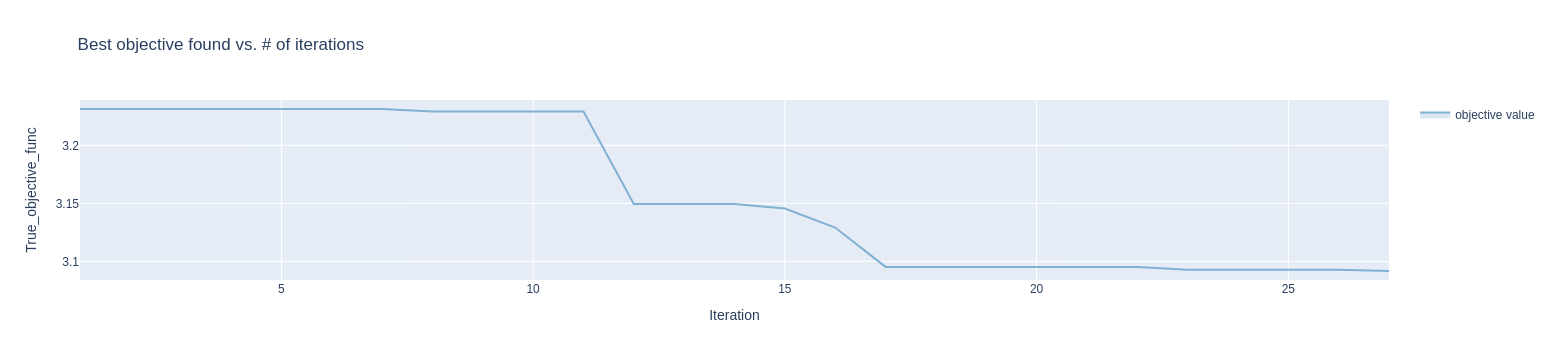

In [28]:
render(ax_client.get_optimization_trace())

[INFO 05-25 04:59:54] ax.service.ax_client: Retrieving contour plot with parameter 'aLund' on X-axis and 'bLund' on Y-axis, for metric 'true_objective_func'. Remaining parameters are affixed to the middle of their range.


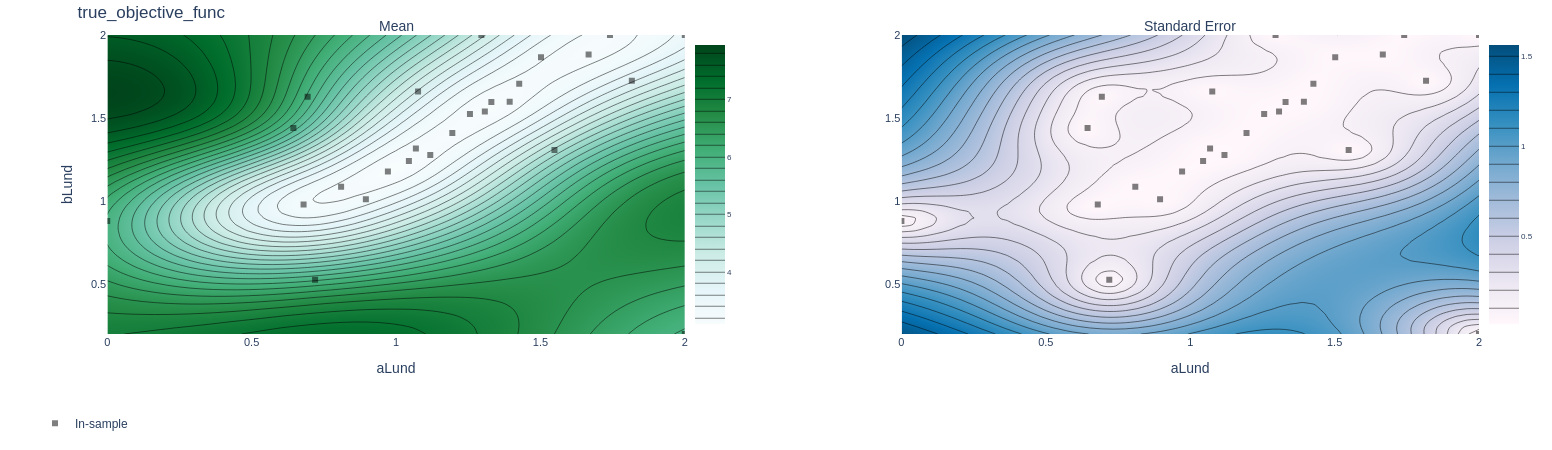

In [29]:
import plotly.graph_objects as go

# fig = go.Figure()
# fig.add_trace(
render(ax_client.get_contour_plot())
# )


# fig.show()
# fig.write_image("images/Lund_a_b_countour.pdf")

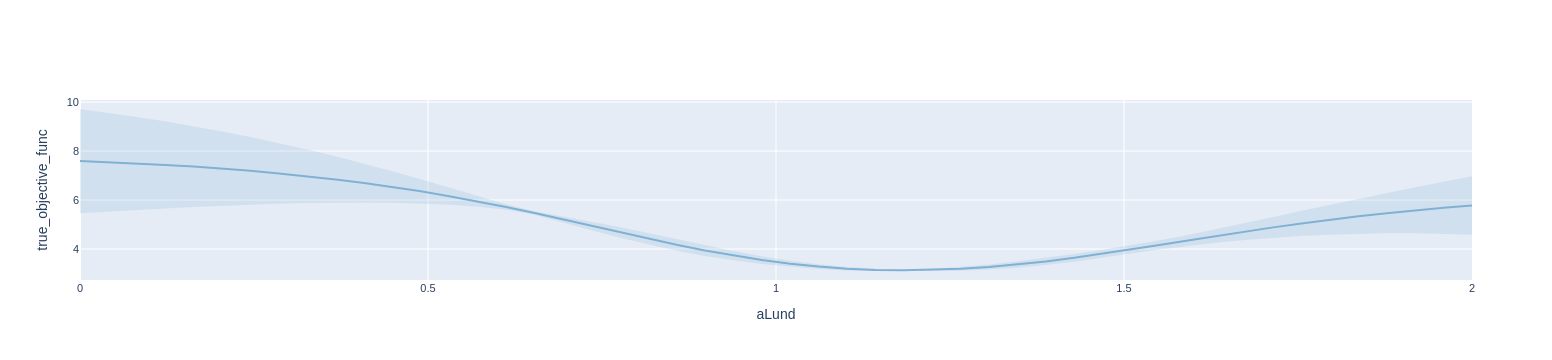

In [30]:
from ax.plot.slice import plot_slice

model = ax_client.generation_strategy.model
render(plot_slice(model, "aLund", "true_objective_func"))

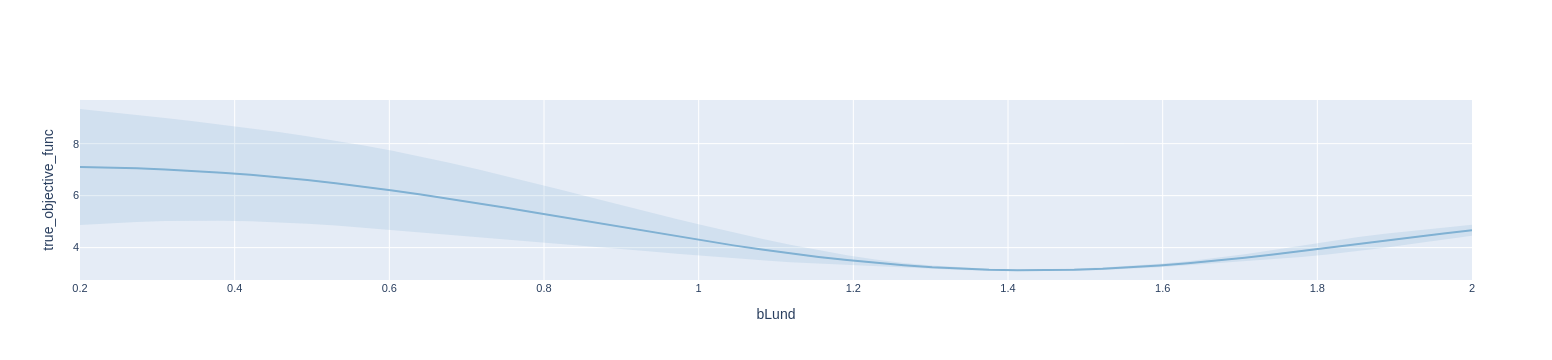

In [31]:
render(plot_slice(model, "bLund", "true_objective_func"))

## Validate the results

1. Make the pythia card with the best parameters based on the Bayesian Optimization above
2. Run the pythia card with 300,000 events yielding a test.yoda validation output
3. convert yoda histograms to pandas dataframes, filter histograms and plot result agreement with data

In [32]:
def make_pythia_valid_card(best_parameters):
    
    cards_dir = os.path.join(os.getcwd(), "BO_Cards")
    filename = f"ALEPH_1996_S3486095_BO_card_valid.cmnd"
    file_path = os.path.join(cards_dir, filename)
    with open(file_path,'w') as f:
        first_block="""Main:numberOfEvents = 300000          ! number of events to generate
Next:numberShowEvent = 0           ! suppress full listing of first events
# random seed
Random:setSeed = on
Random:seed= 0
! 2) Beam parameter settings.
Beams:idA = 11                ! first beam,  e- = 11
Beams:idB = -11                ! second beam, e+ = -11
Beams:eCM = 91.2               ! CM energy of collision
# Pythia 8 settings for LEP
# Hadronic decays including b quarks, with ISR photons switched off
WeakSingleBoson:ffbar2gmZ = on
23:onMode = off
23:onIfAny = 1 2 3 4 5
PDF:lepton = off
SpaceShower:QEDshowerByL = off\n\n"""
        f.write(first_block)
        # f.write(f"Random:seed={indx+1}")

        f.write("StringZ:aLund = {}\n\n".format(best_parameters["aLund"]))
        f.write("StringZ:bLund = {}\n\n".format(best_parameters["bLund"]))

def run_valid_card(best_parameters):
    
    # step 1: write .cmnd file 
    make_pythia_valid_card(best_parameters)
    #step 2 run main42 and rivet
    os.system("""./main42 BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd ALEPH_1996_S3486095_card_valid.fifo &
    
    rivet -o ALEPH_1996_S3486095_hist_valid_0.yoda -a ALEPH_1996_S3486095 ALEPH_1996_S3486095_card_valid.fifo

    rm ALEPH_1996_S3486095_card_valid.fifo
    mv ALEPH_1996_S3486095_hist_valid_0.yoda ALEPH_YODAS_BayesOpt/""")

In [33]:
run_valid_card(best_parameters)


 >>> PYTHIA settings will be read from file BO_Cards/ALEPH_1996_S3486095_BO_card_valid.cmnd <<< 
 >>> HepMC events will be written to file ALEPH_1996_S3486095_card_valid.fifo <<< 


 *------------------------------------------------------------------------------------* 
 |                                                                                    | 
 |  *------------------------------------------------------------------------------*  | 
 |  |                                                                              |  | 
 |  |                                                                              |  | 
 |  |   PPP   Y   Y  TTTTT  H   H  III    A      Welcome to the Lund Monte Carlo!  |  | 
 |  |   P  P   Y Y     T    H   H   I    A A     This is PYTHIA version 8.309      |  | 
 |  |   PPP     Y      T    HHHHH   I   AAAAA    Last date of change: 16 Feb 2023  |  | 
 |  |   P       Y      T    H   H   I   A   A                                      |  | 
 |  |   P       

Rivet 3.1.9 running on machine 99deb7ce41f6 (x86_64) at 2024-05-25 05:00:37
Reading events from 'ALEPH_1996_S3486095_card_valid.fifo'
Event 100 (0:00:00 elapsed)
Event 200 (0:00:00 elapsed)



 Pythia::next(): 2000 events have been generated 


Event 300 (0:00:01 elapsed)
Event 400 (0:00:01 elapsed)
Event 500 (0:00:01 elapsed)
Event 600 (0:00:01 elapsed)
Event 700 (0:00:01 elapsed)
Event 800 (0:00:01 elapsed)



 Pythia::next(): 3000 events have been generated 


Event 900 (0:00:01 elapsed)
Event 1000 (0:00:01 elapsed)
Event 1100 (0:00:01 elapsed)
Event 1200 (0:00:01 elapsed)
Event 1300 (0:00:01 elapsed)
Event 1400 (0:00:02 elapsed)
Event 1500 (0:00:02 elapsed)
Event 1600 (0:00:02 elapsed)
Event 1700 (0:00:02 elapsed)
Event 1800 (0:00:02 elapsed)
Event 1900 (0:00:02 elapsed)
Event 2000 (0:00:02 elapsed)



 Pythia::next(): 4000 events have been generated 


Event 2100 (0:00:02 elapsed)
Event 2200 (0:00:02 elapsed)
Event 2300 (0:00:02 elapsed)
Event 2400 (0:00:02 elapsed)
Event 2500 (0:00:03 elapsed)
Event 2600 (0:00:03 elapsed)



 Pythia::next(): 5000 events have been generated 


Event 2700 (0:00:03 elapsed)
Event 2800 (0:00:03 elapsed)
Event 2900 (0:00:03 elapsed)
Event 3000 (0:00:03 elapsed)
Event 3100 (0:00:03 elapsed)
Event 3200 (0:00:03 elapsed)
Event 3300 (0:00:03 elapsed)
Event 3400 (0:00:03 elapsed)
Event 3500 (0:00:03 elapsed)



 Pythia::next(): 6000 events have been generated 


Event 3600 (0:00:03 elapsed)
Event 3700 (0:00:04 elapsed)
Event 3800 (0:00:04 elapsed)
Event 3900 (0:00:04 elapsed)
Event 4000 (0:00:04 elapsed)
Event 4100 (0:00:04 elapsed)
Event 4200 (0:00:04 elapsed)
Event 4300 (0:00:04 elapsed)
Event 4400 (0:00:04 elapsed)



 Pythia::next(): 7000 events have been generated 


Event 4500 (0:00:04 elapsed)
Event 4600 (0:00:04 elapsed)
Event 4700 (0:00:04 elapsed)
Event 4800 (0:00:05 elapsed)
Event 4900 (0:00:05 elapsed)
Event 5000 (0:00:05 elapsed)
Event 5100 (0:00:05 elapsed)
Event 5200 (0:00:05 elapsed)
Event 5300 (0:00:05 elapsed)



 Pythia::next(): 8000 events have been generated 


Event 5400 (0:00:05 elapsed)
Event 5500 (0:00:05 elapsed)
Event 5600 (0:00:05 elapsed)
Event 5700 (0:00:05 elapsed)
Event 5800 (0:00:06 elapsed)
Event 5900 (0:00:06 elapsed)
Event 6000 (0:00:06 elapsed)
Event 6100 (0:00:06 elapsed)



 Pythia::next(): 9000 events have been generated 


Event 6200 (0:00:06 elapsed)
Event 6300 (0:00:06 elapsed)
Event 6400 (0:00:06 elapsed)
Event 6500 (0:00:06 elapsed)
Event 6600 (0:00:06 elapsed)
Event 6700 (0:00:06 elapsed)
Event 6800 (0:00:06 elapsed)
Event 6900 (0:00:07 elapsed)
Event 7000 (0:00:07 elapsed)



 Pythia::next(): 10000 events have been generated 


Event 7100 (0:00:07 elapsed)
Event 7200 (0:00:07 elapsed)
Event 7300 (0:00:07 elapsed)
Event 7400 (0:00:07 elapsed)
Event 7500 (0:00:07 elapsed)
Event 7600 (0:00:07 elapsed)
Event 7700 (0:00:07 elapsed)
Event 7800 (0:00:07 elapsed)
Event 7900 (0:00:07 elapsed)



 Pythia::next(): 11000 events have been generated 


Event 8000 (0:00:08 elapsed)
Event 8100 (0:00:08 elapsed)
Event 8200 (0:00:08 elapsed)
Event 8300 (0:00:08 elapsed)
Event 8400 (0:00:08 elapsed)
Event 8500 (0:00:08 elapsed)
Event 8600 (0:00:08 elapsed)
Event 8700 (0:00:08 elapsed)
Event 8800 (0:00:08 elapsed)



 Pythia::next(): 12000 events have been generated 


Event 8900 (0:00:08 elapsed)
Event 9000 (0:00:08 elapsed)
Event 9100 (0:00:09 elapsed)
Event 9200 (0:00:09 elapsed)
Event 9300 (0:00:09 elapsed)
Event 9400 (0:00:09 elapsed)



 Pythia::next(): 13000 events have been generated 


Event 9500 (0:00:09 elapsed)
Event 9600 (0:00:09 elapsed)
Event 9700 (0:00:09 elapsed)
Event 9800 (0:00:09 elapsed)
Event 9900 (0:00:09 elapsed)
Event 10000 (0:00:09 elapsed)
Event 10100 (0:00:09 elapsed)
Event 10200 (0:00:10 elapsed)
Event 10300 (0:00:10 elapsed)



 Pythia::next(): 14000 events have been generated 


Event 10400 (0:00:10 elapsed)
Event 10500 (0:00:10 elapsed)
Event 10600 (0:00:10 elapsed)
Event 10700 (0:00:10 elapsed)
Event 10800 (0:00:10 elapsed)
Event 10900 (0:00:10 elapsed)
Event 11000 (0:00:10 elapsed)
Event 11100 (0:00:10 elapsed)
Event 11200 (0:00:11 elapsed)



 Pythia::next(): 15000 events have been generated 


Event 11300 (0:00:11 elapsed)
Event 11400 (0:00:11 elapsed)
Event 11500 (0:00:11 elapsed)
Event 11600 (0:00:11 elapsed)
Event 11700 (0:00:11 elapsed)
Event 11800 (0:00:11 elapsed)
Event 11900 (0:00:11 elapsed)
Event 12000 (0:00:11 elapsed)
Event 12100 (0:00:11 elapsed)



 Pythia::next(): 16000 events have been generated 


Event 12200 (0:00:11 elapsed)
Event 12300 (0:00:12 elapsed)
Event 12400 (0:00:12 elapsed)
Event 12500 (0:00:12 elapsed)
Event 12600 (0:00:12 elapsed)
Event 12700 (0:00:12 elapsed)
Event 12800 (0:00:12 elapsed)
Event 12900 (0:00:12 elapsed)
Event 13000 (0:00:12 elapsed)



 Pythia::next(): 17000 events have been generated 


Event 13100 (0:00:12 elapsed)
Event 13200 (0:00:12 elapsed)
Event 13300 (0:00:12 elapsed)
Event 13400 (0:00:13 elapsed)
Event 13500 (0:00:13 elapsed)
Event 13600 (0:00:13 elapsed)
Event 13700 (0:00:13 elapsed)
Event 13800 (0:00:13 elapsed)
Event 13900 (0:00:13 elapsed)



 Pythia::next(): 18000 events have been generated 


Event 14000 (0:00:13 elapsed)
Event 14100 (0:00:13 elapsed)
Event 14200 (0:00:13 elapsed)
Event 14300 (0:00:13 elapsed)
Event 14400 (0:00:13 elapsed)
Event 14500 (0:00:14 elapsed)



 Pythia::next(): 19000 events have been generated 


Event 14600 (0:00:14 elapsed)
Event 14700 (0:00:14 elapsed)
Event 14800 (0:00:14 elapsed)
Event 14900 (0:00:14 elapsed)
Event 15000 (0:00:14 elapsed)
Event 15100 (0:00:14 elapsed)
Event 15200 (0:00:14 elapsed)
Event 15300 (0:00:14 elapsed)
Event 15400 (0:00:14 elapsed)



 Pythia::next(): 20000 events have been generated 


Event 15500 (0:00:14 elapsed)
Event 15600 (0:00:14 elapsed)
Event 15700 (0:00:15 elapsed)
Event 15800 (0:00:15 elapsed)
Event 15900 (0:00:15 elapsed)
Event 16000 (0:00:15 elapsed)
Event 16100 (0:00:15 elapsed)
Event 16200 (0:00:15 elapsed)
Event 16300 (0:00:15 elapsed)



 Pythia::next(): 21000 events have been generated 


Event 16400 (0:00:15 elapsed)
Event 16500 (0:00:15 elapsed)
Event 16600 (0:00:15 elapsed)
Event 16700 (0:00:15 elapsed)
Event 16800 (0:00:16 elapsed)
Event 16900 (0:00:16 elapsed)
Event 17000 (0:00:16 elapsed)
Event 17100 (0:00:16 elapsed)
Event 17200 (0:00:16 elapsed)



 Pythia::next(): 22000 events have been generated 


Event 17300 (0:00:16 elapsed)
Event 17400 (0:00:16 elapsed)
Event 17500 (0:00:16 elapsed)
Event 17600 (0:00:16 elapsed)
Event 17700 (0:00:16 elapsed)
Event 17800 (0:00:16 elapsed)
Event 17900 (0:00:17 elapsed)
Event 18000 (0:00:17 elapsed)
Event 18100 (0:00:17 elapsed)



 Pythia::next(): 23000 events have been generated 


Event 18200 (0:00:17 elapsed)
Event 18300 (0:00:17 elapsed)
Event 18400 (0:00:17 elapsed)
Event 18500 (0:00:17 elapsed)
Event 18600 (0:00:17 elapsed)
Event 18700 (0:00:17 elapsed)
Event 18800 (0:00:17 elapsed)
Event 18900 (0:00:17 elapsed)
Event 19000 (0:00:18 elapsed)



 Pythia::next(): 24000 events have been generated 


Event 19100 (0:00:18 elapsed)
Event 19200 (0:00:18 elapsed)
Event 19300 (0:00:18 elapsed)
Event 19400 (0:00:18 elapsed)
Event 19500 (0:00:18 elapsed)
Event 19600 (0:00:18 elapsed)
Event 19700 (0:00:18 elapsed)
Event 19800 (0:00:18 elapsed)
Event 19900 (0:00:18 elapsed)



 Pythia::next(): 25000 events have been generated 


Event 20000 (0:00:18 elapsed)
Event 20100 (0:00:18 elapsed)
Event 20200 (0:00:19 elapsed)
Event 20300 (0:00:19 elapsed)
Event 20400 (0:00:19 elapsed)
Event 20500 (0:00:19 elapsed)



 Pythia::next(): 26000 events have been generated 


Event 20600 (0:00:19 elapsed)
Event 20700 (0:00:19 elapsed)
Event 20800 (0:00:19 elapsed)
Event 20900 (0:00:19 elapsed)
Event 21000 (0:00:19 elapsed)
Event 21100 (0:00:19 elapsed)
Event 21200 (0:00:19 elapsed)
Event 21300 (0:00:20 elapsed)
Event 21400 (0:00:20 elapsed)



 Pythia::next(): 27000 events have been generated 


Event 21500 (0:00:20 elapsed)
Event 21600 (0:00:20 elapsed)
Event 21700 (0:00:20 elapsed)
Event 21800 (0:00:20 elapsed)
Event 21900 (0:00:20 elapsed)
Event 22000 (0:00:20 elapsed)
Event 22100 (0:00:20 elapsed)
Event 22200 (0:00:20 elapsed)
Event 22300 (0:00:20 elapsed)



 Pythia::next(): 28000 events have been generated 


Event 22400 (0:00:21 elapsed)
Event 22500 (0:00:21 elapsed)
Event 22600 (0:00:21 elapsed)
Event 22700 (0:00:21 elapsed)
Event 22800 (0:00:21 elapsed)
Event 22900 (0:00:21 elapsed)
Event 23000 (0:00:21 elapsed)
Event 23100 (0:00:21 elapsed)
Event 23200 (0:00:21 elapsed)



 Pythia::next(): 29000 events have been generated 


Event 23300 (0:00:21 elapsed)
Event 23400 (0:00:21 elapsed)
Event 23500 (0:00:21 elapsed)
Event 23600 (0:00:22 elapsed)
Event 23700 (0:00:22 elapsed)
Event 23800 (0:00:22 elapsed)
Event 23900 (0:00:22 elapsed)
Event 24000 (0:00:22 elapsed)
Event 24100 (0:00:22 elapsed)



 Pythia::next(): 30000 events have been generated 


Event 24200 (0:00:22 elapsed)
Event 24300 (0:00:22 elapsed)
Event 24400 (0:00:22 elapsed)
Event 24500 (0:00:22 elapsed)
Event 24600 (0:00:22 elapsed)
Event 24700 (0:00:23 elapsed)



 Pythia::next(): 31000 events have been generated 


Event 24800 (0:00:23 elapsed)
Event 24900 (0:00:23 elapsed)
Event 25000 (0:00:23 elapsed)
Event 25100 (0:00:23 elapsed)
Event 25200 (0:00:23 elapsed)
Event 25300 (0:00:23 elapsed)
Event 25400 (0:00:23 elapsed)
Event 25500 (0:00:23 elapsed)
Event 25600 (0:00:23 elapsed)



 Pythia::next(): 32000 events have been generated 


Event 25700 (0:00:23 elapsed)
Event 25800 (0:00:24 elapsed)
Event 25900 (0:00:24 elapsed)
Event 26000 (0:00:24 elapsed)
Event 26100 (0:00:24 elapsed)
Event 26200 (0:00:24 elapsed)
Event 26300 (0:00:24 elapsed)
Event 26400 (0:00:24 elapsed)
Event 26500 (0:00:24 elapsed)



 Pythia::next(): 33000 events have been generated 


Event 26600 (0:00:24 elapsed)
Event 26700 (0:00:24 elapsed)
Event 26800 (0:00:24 elapsed)
Event 26900 (0:00:24 elapsed)
Event 27000 (0:00:25 elapsed)
Event 27100 (0:00:25 elapsed)
Event 27200 (0:00:25 elapsed)
Event 27300 (0:00:25 elapsed)
Event 27400 (0:00:25 elapsed)



 Pythia::next(): 34000 events have been generated 


Event 27500 (0:00:25 elapsed)
Event 27600 (0:00:25 elapsed)
Event 27700 (0:00:25 elapsed)
Event 27800 (0:00:25 elapsed)
Event 27900 (0:00:25 elapsed)
Event 28000 (0:00:25 elapsed)
Event 28100 (0:00:26 elapsed)
Event 28200 (0:00:26 elapsed)
Event 28300 (0:00:26 elapsed)



 Pythia::next(): 35000 events have been generated 


Event 28400 (0:00:26 elapsed)
Event 28500 (0:00:26 elapsed)
Event 28600 (0:00:26 elapsed)
Event 28700 (0:00:26 elapsed)
Event 28800 (0:00:26 elapsed)
Event 28900 (0:00:26 elapsed)
Event 29000 (0:00:26 elapsed)
Event 29100 (0:00:26 elapsed)
Event 29200 (0:00:27 elapsed)



 Pythia::next(): 36000 events have been generated 


Event 29300 (0:00:27 elapsed)
Event 29400 (0:00:27 elapsed)
Event 29500 (0:00:27 elapsed)
Event 29600 (0:00:27 elapsed)
Event 29700 (0:00:27 elapsed)
Event 29800 (0:00:27 elapsed)
Event 29900 (0:00:27 elapsed)
Event 30000 (0:00:27 elapsed)
Event 30100 (0:00:27 elapsed)



 Pythia::next(): 37000 events have been generated 


Event 30200 (0:00:27 elapsed)
Event 30300 (0:00:27 elapsed)
Event 30400 (0:00:28 elapsed)
Event 30500 (0:00:28 elapsed)
Event 30600 (0:00:28 elapsed)
Event 30700 (0:00:28 elapsed)



 Pythia::next(): 38000 events have been generated 


Event 30800 (0:00:28 elapsed)
Event 30900 (0:00:28 elapsed)
Event 31000 (0:00:28 elapsed)
Event 31100 (0:00:28 elapsed)
Event 31200 (0:00:28 elapsed)
Event 31300 (0:00:28 elapsed)
Event 31400 (0:00:28 elapsed)
Event 31500 (0:00:29 elapsed)
Event 31600 (0:00:29 elapsed)



 Pythia::next(): 39000 events have been generated 


Event 31700 (0:00:29 elapsed)
Event 31800 (0:00:29 elapsed)
Event 31900 (0:00:29 elapsed)
Event 32000 (0:00:29 elapsed)
Event 32100 (0:00:29 elapsed)
Event 32200 (0:00:29 elapsed)
Event 32300 (0:00:29 elapsed)
Event 32400 (0:00:29 elapsed)
Event 32500 (0:00:29 elapsed)



 Pythia::next(): 40000 events have been generated 


Event 32600 (0:00:29 elapsed)
Event 32700 (0:00:30 elapsed)
Event 32800 (0:00:30 elapsed)
Event 32900 (0:00:30 elapsed)
Event 33000 (0:00:30 elapsed)
Event 33100 (0:00:30 elapsed)
Event 33200 (0:00:30 elapsed)
Event 33300 (0:00:30 elapsed)
Event 33400 (0:00:30 elapsed)



 Pythia::next(): 41000 events have been generated 


Event 33500 (0:00:30 elapsed)
Event 33600 (0:00:30 elapsed)
Event 33700 (0:00:30 elapsed)
Event 33800 (0:00:31 elapsed)
Event 33900 (0:00:31 elapsed)
Event 34000 (0:00:31 elapsed)
Event 34100 (0:00:31 elapsed)
Event 34200 (0:00:31 elapsed)
Event 34300 (0:00:31 elapsed)



 Pythia::next(): 42000 events have been generated 


Event 34400 (0:00:31 elapsed)
Event 34500 (0:00:31 elapsed)
Event 34600 (0:00:31 elapsed)
Event 34700 (0:00:31 elapsed)
Event 34800 (0:00:31 elapsed)
Event 34900 (0:00:32 elapsed)
Event 35000 (0:00:32 elapsed)



 Pythia::next(): 43000 events have been generated 


Event 35100 (0:00:32 elapsed)
Event 35200 (0:00:32 elapsed)
Event 35300 (0:00:32 elapsed)
Event 35400 (0:00:32 elapsed)
Event 35500 (0:00:32 elapsed)
Event 35600 (0:00:32 elapsed)



 Pythia::next(): 44000 events have been generated 


Event 35700 (0:00:32 elapsed)
Event 35800 (0:00:33 elapsed)
Event 35900 (0:00:33 elapsed)
Event 36000 (0:00:33 elapsed)
Event 36100 (0:00:33 elapsed)
Event 36200 (0:00:33 elapsed)
Event 36300 (0:00:33 elapsed)
Event 36400 (0:00:33 elapsed)
Event 36500 (0:00:33 elapsed)



 Pythia::next(): 45000 events have been generated 


Event 36600 (0:00:33 elapsed)
Event 36700 (0:00:33 elapsed)
Event 36800 (0:00:33 elapsed)
Event 36900 (0:00:33 elapsed)
Event 37000 (0:00:34 elapsed)
Event 37100 (0:00:34 elapsed)
Event 37200 (0:00:34 elapsed)
Event 37300 (0:00:34 elapsed)



 Pythia::next(): 46000 events have been generated 


Event 37400 (0:00:34 elapsed)
Event 37500 (0:00:34 elapsed)
Event 37600 (0:00:34 elapsed)
Event 37700 (0:00:34 elapsed)
Event 37800 (0:00:34 elapsed)
Event 37900 (0:00:34 elapsed)
Event 38000 (0:00:35 elapsed)



 Pythia::next(): 47000 events have been generated 


Event 38100 (0:00:35 elapsed)
Event 38200 (0:00:35 elapsed)
Event 38300 (0:00:35 elapsed)
Event 38400 (0:00:35 elapsed)
Event 38500 (0:00:36 elapsed)
Event 38600 (0:00:36 elapsed)
Event 38700 (0:00:36 elapsed)
Event 38800 (0:00:36 elapsed)
Event 38900 (0:00:36 elapsed)



 Pythia::next(): 48000 events have been generated 


Event 39000 (0:00:36 elapsed)
Event 39100 (0:00:36 elapsed)
Event 39200 (0:00:36 elapsed)
Event 39300 (0:00:36 elapsed)
Event 39400 (0:00:36 elapsed)
Event 39500 (0:00:36 elapsed)
Event 39600 (0:00:37 elapsed)
Event 39700 (0:00:37 elapsed)



 Pythia::next(): 49000 events have been generated 


Event 39800 (0:00:37 elapsed)
Event 39900 (0:00:37 elapsed)
Event 40000 (0:00:37 elapsed)
Event 40100 (0:00:37 elapsed)
Event 40200 (0:00:37 elapsed)



 Pythia::next(): 50000 events have been generated 


Event 40300 (0:00:37 elapsed)
Event 40400 (0:00:38 elapsed)
Event 40500 (0:00:38 elapsed)
Event 40600 (0:00:38 elapsed)
Event 40700 (0:00:38 elapsed)
Event 40800 (0:00:38 elapsed)
Event 40900 (0:00:38 elapsed)
Event 41000 (0:00:38 elapsed)



 Pythia::next(): 51000 events have been generated 


Event 41100 (0:00:39 elapsed)
Event 41200 (0:00:39 elapsed)
Event 41300 (0:00:39 elapsed)
Event 41400 (0:00:39 elapsed)
Event 41500 (0:00:39 elapsed)
Event 41600 (0:00:39 elapsed)



 Pythia::next(): 52000 events have been generated 


Event 41700 (0:00:39 elapsed)
Event 41800 (0:00:39 elapsed)
Event 41900 (0:00:39 elapsed)
Event 42000 (0:00:39 elapsed)
Event 42100 (0:00:40 elapsed)
Event 42200 (0:00:40 elapsed)
Event 42300 (0:00:40 elapsed)
Event 42400 (0:00:40 elapsed)



 Pythia::next(): 53000 events have been generated 


Event 42500 (0:00:40 elapsed)
Event 42600 (0:00:40 elapsed)
Event 42700 (0:00:40 elapsed)
Event 42800 (0:00:40 elapsed)
Event 42900 (0:00:40 elapsed)
Event 43000 (0:00:40 elapsed)



 Pythia::next(): 54000 events have been generated 


Event 43100 (0:00:41 elapsed)
Event 43200 (0:00:41 elapsed)
Event 43300 (0:00:41 elapsed)
Event 43400 (0:00:41 elapsed)
Event 43500 (0:00:41 elapsed)
Event 43600 (0:00:41 elapsed)
Event 43700 (0:00:41 elapsed)
Event 43800 (0:00:41 elapsed)
Event 43900 (0:00:41 elapsed)



 Pythia::next(): 55000 events have been generated 


Event 44000 (0:00:42 elapsed)
Event 44100 (0:00:42 elapsed)
Event 44200 (0:00:42 elapsed)
Event 44300 (0:00:42 elapsed)
Event 44400 (0:00:42 elapsed)
Event 44500 (0:00:42 elapsed)
Event 44600 (0:00:42 elapsed)
Event 44700 (0:00:42 elapsed)



 Pythia::next(): 56000 events have been generated 


Event 44800 (0:00:42 elapsed)
Event 44900 (0:00:42 elapsed)
Event 45000 (0:00:43 elapsed)
Event 45100 (0:00:43 elapsed)
Event 45200 (0:00:43 elapsed)
Event 45300 (0:00:43 elapsed)



 Pythia::next(): 57000 events have been generated 


Event 45400 (0:00:43 elapsed)
Event 45500 (0:00:43 elapsed)
Event 45600 (0:00:43 elapsed)
Event 45700 (0:00:43 elapsed)
Event 45800 (0:00:43 elapsed)
Event 45900 (0:00:43 elapsed)
Event 46000 (0:00:43 elapsed)
Event 46100 (0:00:44 elapsed)
Event 46200 (0:00:44 elapsed)
Event 46300 (0:00:44 elapsed)
Event 46400 (0:00:44 elapsed)



 Pythia::next(): 58000 events have been generated 


Event 46500 (0:00:44 elapsed)
Event 46600 (0:00:44 elapsed)
Event 46700 (0:00:44 elapsed)
Event 46800 (0:00:44 elapsed)
Event 46900 (0:00:44 elapsed)
Event 47000 (0:00:44 elapsed)



 Pythia::next(): 59000 events have been generated 


Event 47100 (0:00:45 elapsed)
Event 47200 (0:00:45 elapsed)
Event 47300 (0:00:45 elapsed)
Event 47400 (0:00:45 elapsed)
Event 47500 (0:00:45 elapsed)
Event 47600 (0:00:45 elapsed)
Event 47700 (0:00:45 elapsed)
Event 47800 (0:00:45 elapsed)



 Pythia::next(): 60000 events have been generated 


Event 47900 (0:00:45 elapsed)
Event 48000 (0:00:46 elapsed)
Event 48100 (0:00:46 elapsed)
Event 48200 (0:00:46 elapsed)
Event 48300 (0:00:46 elapsed)
Event 48400 (0:00:46 elapsed)
Event 48500 (0:00:46 elapsed)
Event 48600 (0:00:46 elapsed)



 Pythia::next(): 61000 events have been generated 


Event 48700 (0:00:46 elapsed)
Event 48800 (0:00:46 elapsed)
Event 48900 (0:00:46 elapsed)
Event 49000 (0:00:47 elapsed)
Event 49100 (0:00:47 elapsed)
Event 49200 (0:00:47 elapsed)
Event 49300 (0:00:47 elapsed)
Event 49400 (0:00:47 elapsed)



 Pythia::next(): 62000 events have been generated 


Event 49500 (0:00:47 elapsed)
Event 49600 (0:00:47 elapsed)
Event 49700 (0:00:47 elapsed)
Event 49800 (0:00:47 elapsed)
Event 49900 (0:00:47 elapsed)
Event 50000 (0:00:47 elapsed)
Event 50100 (0:00:48 elapsed)
Event 50200 (0:00:48 elapsed)
Event 50300 (0:00:48 elapsed)



 Pythia::next(): 63000 events have been generated 


Event 50400 (0:00:48 elapsed)
Event 50500 (0:00:48 elapsed)
Event 50600 (0:00:48 elapsed)
Event 50700 (0:00:48 elapsed)
Event 50800 (0:00:48 elapsed)
Event 50900 (0:00:48 elapsed)
Event 51000 (0:00:48 elapsed)
Event 51100 (0:00:49 elapsed)



 Pythia::next(): 64000 events have been generated 


Event 51200 (0:00:49 elapsed)
Event 51300 (0:00:49 elapsed)
Event 51400 (0:00:49 elapsed)
Event 51500 (0:00:49 elapsed)
Event 51600 (0:00:49 elapsed)
Event 51700 (0:00:49 elapsed)
Event 51800 (0:00:49 elapsed)
Event 51900 (0:00:49 elapsed)
Event 52000 (0:00:49 elapsed)



 Pythia::next(): 65000 events have been generated 


Event 52100 (0:00:49 elapsed)
Event 52200 (0:00:50 elapsed)
Event 52300 (0:00:50 elapsed)
Event 52400 (0:00:50 elapsed)
Event 52500 (0:00:50 elapsed)
Event 52600 (0:00:50 elapsed)
Event 52700 (0:00:50 elapsed)
Event 52800 (0:00:50 elapsed)



 Pythia::next(): 66000 events have been generated 


Event 52900 (0:00:50 elapsed)
Event 53000 (0:00:50 elapsed)
Event 53100 (0:00:51 elapsed)
Event 53200 (0:00:51 elapsed)
Event 53300 (0:00:51 elapsed)



 Pythia::next(): 67000 events have been generated 


Event 53400 (0:00:51 elapsed)
Event 53500 (0:00:51 elapsed)
Event 53600 (0:00:51 elapsed)
Event 53700 (0:00:51 elapsed)
Event 53800 (0:00:52 elapsed)
Event 53900 (0:00:52 elapsed)
Event 54000 (0:00:52 elapsed)



 Pythia::next(): 68000 events have been generated 


Event 54100 (0:00:52 elapsed)
Event 54200 (0:00:52 elapsed)
Event 54300 (0:00:52 elapsed)
Event 54400 (0:00:52 elapsed)
Event 54500 (0:00:52 elapsed)
Event 54600 (0:00:53 elapsed)
Event 54700 (0:00:53 elapsed)
Event 54800 (0:00:53 elapsed)
Event 54900 (0:00:53 elapsed)



 Pythia::next(): 69000 events have been generated 


Event 55000 (0:00:53 elapsed)
Event 55100 (0:00:53 elapsed)
Event 55200 (0:00:53 elapsed)
Event 55300 (0:00:53 elapsed)
Event 55400 (0:00:53 elapsed)
Event 55500 (0:00:54 elapsed)



 Pythia::next(): 70000 events have been generated 


Event 55600 (0:00:54 elapsed)
Event 55700 (0:00:54 elapsed)
Event 55800 (0:00:54 elapsed)
Event 55900 (0:00:54 elapsed)
Event 56000 (0:00:54 elapsed)
Event 56100 (0:00:54 elapsed)
Event 56200 (0:00:54 elapsed)
Event 56300 (0:00:54 elapsed)



 Pythia::next(): 71000 events have been generated 


Event 56400 (0:00:55 elapsed)
Event 56500 (0:00:55 elapsed)
Event 56600 (0:00:55 elapsed)
Event 56700 (0:00:55 elapsed)
Event 56800 (0:00:55 elapsed)
Event 56900 (0:00:55 elapsed)
Event 57000 (0:00:55 elapsed)
Event 57100 (0:00:55 elapsed)



 Pythia::next(): 72000 events have been generated 


Event 57200 (0:00:55 elapsed)
Event 57300 (0:00:56 elapsed)
Event 57400 (0:00:56 elapsed)
Event 57500 (0:00:56 elapsed)
Event 57600 (0:00:56 elapsed)
Event 57700 (0:00:56 elapsed)
Event 57800 (0:00:56 elapsed)
Event 57900 (0:00:56 elapsed)



 Pythia::next(): 73000 events have been generated 


Event 58000 (0:00:56 elapsed)
Event 58100 (0:00:56 elapsed)
Event 58200 (0:00:57 elapsed)
Event 58300 (0:00:57 elapsed)
Event 58400 (0:00:57 elapsed)
Event 58500 (0:00:57 elapsed)
Event 58600 (0:00:57 elapsed)
Event 58700 (0:00:57 elapsed)



 Pythia::next(): 74000 events have been generated 


Event 58800 (0:00:57 elapsed)
Event 58900 (0:00:57 elapsed)
Event 59000 (0:00:57 elapsed)
Event 59100 (0:00:57 elapsed)
Event 59200 (0:00:57 elapsed)
Event 59300 (0:00:58 elapsed)
Event 59400 (0:00:58 elapsed)
Event 59500 (0:00:58 elapsed)
Event 59600 (0:00:58 elapsed)



 Pythia::next(): 75000 events have been generated 


Event 59700 (0:00:58 elapsed)
Event 59800 (0:00:58 elapsed)
Event 59900 (0:00:58 elapsed)
Event 60000 (0:00:58 elapsed)
Event 60100 (0:00:58 elapsed)
Event 60200 (0:00:58 elapsed)
Event 60300 (0:00:58 elapsed)
Event 60400 (0:00:59 elapsed)



 Pythia::next(): 76000 events have been generated 


Event 60500 (0:00:59 elapsed)
Event 60600 (0:00:59 elapsed)
Event 60700 (0:00:59 elapsed)
Event 60800 (0:00:59 elapsed)
Event 60900 (0:00:59 elapsed)
Event 61000 (0:00:59 elapsed)



 Pythia::next(): 77000 events have been generated 


Event 61100 (0:01:00 elapsed)
Event 61200 (0:01:00 elapsed)
Event 61300 (0:01:00 elapsed)
Event 61400 (0:01:00 elapsed)
Event 61500 (0:01:00 elapsed)
Event 61600 (0:01:00 elapsed)
Event 61700 (0:01:00 elapsed)
Event 61800 (0:01:00 elapsed)
Event 61900 (0:01:00 elapsed)



 Pythia::next(): 78000 events have been generated 


Event 62000 (0:01:01 elapsed)
Event 62100 (0:01:01 elapsed)
Event 62200 (0:01:01 elapsed)
Event 62300 (0:01:01 elapsed)



 Pythia::next(): 79000 events have been generated 
 PYTHIA Warning in HadronWidths::pickMasses: angular momentum and running widths not used  


Event 62400 (0:01:01 elapsed)
Event 62500 (0:01:01 elapsed)
Event 62600 (0:01:01 elapsed)
Event 62700 (0:01:01 elapsed)
Event 62800 (0:01:02 elapsed)
Event 62900 (0:01:02 elapsed)
Event 63000 (0:01:02 elapsed)



 Pythia::next(): 80000 events have been generated 


Event 63100 (0:01:02 elapsed)
Event 63200 (0:01:02 elapsed)
Event 63300 (0:01:02 elapsed)
Event 63400 (0:01:02 elapsed)
Event 63500 (0:01:02 elapsed)
Event 63600 (0:01:02 elapsed)
Event 63700 (0:01:03 elapsed)
Event 63800 (0:01:03 elapsed)
Event 63900 (0:01:03 elapsed)



 Pythia::next(): 81000 events have been generated 


Event 64000 (0:01:03 elapsed)
Event 64100 (0:01:03 elapsed)
Event 64200 (0:01:03 elapsed)
Event 64300 (0:01:03 elapsed)
Event 64400 (0:01:03 elapsed)
Event 64500 (0:01:03 elapsed)
Event 64600 (0:01:03 elapsed)
Event 64700 (0:01:03 elapsed)
Event 64800 (0:01:04 elapsed)



 Pythia::next(): 82000 events have been generated 


Event 64900 (0:01:04 elapsed)
Event 65000 (0:01:04 elapsed)
Event 65100 (0:01:04 elapsed)
Event 65200 (0:01:04 elapsed)
Event 65300 (0:01:04 elapsed)
Event 65400 (0:01:04 elapsed)



 Pythia::next(): 83000 events have been generated 


Event 65500 (0:01:04 elapsed)
Event 65600 (0:01:04 elapsed)
Event 65700 (0:01:04 elapsed)
Event 65800 (0:01:04 elapsed)
Event 65900 (0:01:05 elapsed)
Event 66000 (0:01:05 elapsed)
Event 66100 (0:01:05 elapsed)
Event 66200 (0:01:05 elapsed)
Event 66300 (0:01:05 elapsed)



 Pythia::next(): 84000 events have been generated 


Event 66400 (0:01:05 elapsed)
Event 66500 (0:01:05 elapsed)
Event 66600 (0:01:05 elapsed)
Event 66700 (0:01:05 elapsed)
Event 66800 (0:01:05 elapsed)
Event 66900 (0:01:05 elapsed)
Event 67000 (0:01:06 elapsed)
Event 67100 (0:01:06 elapsed)
Event 67200 (0:01:06 elapsed)



 Pythia::next(): 85000 events have been generated 


Event 67300 (0:01:06 elapsed)
Event 67400 (0:01:06 elapsed)
Event 67500 (0:01:06 elapsed)
Event 67600 (0:01:06 elapsed)
Event 67700 (0:01:06 elapsed)
Event 67800 (0:01:06 elapsed)
Event 67900 (0:01:06 elapsed)
Event 68000 (0:01:06 elapsed)
Event 68100 (0:01:07 elapsed)



 Pythia::next(): 86000 events have been generated 


Event 68200 (0:01:07 elapsed)
Event 68300 (0:01:07 elapsed)
Event 68400 (0:01:07 elapsed)
Event 68500 (0:01:07 elapsed)
Event 68600 (0:01:07 elapsed)
Event 68700 (0:01:07 elapsed)
Event 68800 (0:01:07 elapsed)
Event 68900 (0:01:07 elapsed)
Event 69000 (0:01:07 elapsed)



 Pythia::next(): 87000 events have been generated 


Event 69100 (0:01:08 elapsed)
Event 69200 (0:01:08 elapsed)
Event 69300 (0:01:08 elapsed)
Event 69400 (0:01:08 elapsed)
Event 69500 (0:01:08 elapsed)
Event 69600 (0:01:08 elapsed)



 Pythia::next(): 88000 events have been generated 


Event 69700 (0:01:08 elapsed)
Event 69800 (0:01:08 elapsed)
Event 69900 (0:01:08 elapsed)
Event 70000 (0:01:08 elapsed)



 Pythia::next(): 89000 events have been generated 


Event 70100 (0:01:09 elapsed)
Event 70200 (0:01:09 elapsed)
Event 70300 (0:01:09 elapsed)
Event 70400 (0:01:09 elapsed)
Event 70500 (0:01:09 elapsed)
Event 70600 (0:01:09 elapsed)
Event 70700 (0:01:09 elapsed)
Event 70800 (0:01:09 elapsed)
Event 70900 (0:01:10 elapsed)



 Pythia::next(): 90000 events have been generated 


Event 71000 (0:01:10 elapsed)
Event 71100 (0:01:10 elapsed)
Event 71200 (0:01:10 elapsed)
Event 71300 (0:01:10 elapsed)
Event 71400 (0:01:10 elapsed)
Event 71500 (0:01:10 elapsed)
Event 71600 (0:01:11 elapsed)
Event 71700 (0:01:11 elapsed)



 Pythia::next(): 91000 events have been generated 


Event 71800 (0:01:11 elapsed)
Event 71900 (0:01:11 elapsed)
Event 72000 (0:01:11 elapsed)
Event 72100 (0:01:11 elapsed)
Event 72200 (0:01:11 elapsed)
Event 72300 (0:01:11 elapsed)
Event 72400 (0:01:11 elapsed)
Event 72500 (0:01:12 elapsed)



 Pythia::next(): 92000 events have been generated 


Event 72600 (0:01:12 elapsed)
Event 72700 (0:01:12 elapsed)
Event 72800 (0:01:12 elapsed)
Event 72900 (0:01:12 elapsed)
Event 73000 (0:01:12 elapsed)



 Pythia::next(): 93000 events have been generated 


Event 73100 (0:01:13 elapsed)
Event 73200 (0:01:13 elapsed)
Event 73300 (0:01:13 elapsed)
Event 73400 (0:01:13 elapsed)
Event 73500 (0:01:13 elapsed)
Event 73600 (0:01:13 elapsed)



 Pythia::next(): 94000 events have been generated 


Event 73700 (0:01:13 elapsed)
Event 73800 (0:01:13 elapsed)
Event 73900 (0:01:13 elapsed)
Event 74000 (0:01:13 elapsed)
Event 74100 (0:01:14 elapsed)
Event 74200 (0:01:14 elapsed)



 Pythia::next(): 95000 events have been generated 


Event 74300 (0:01:14 elapsed)
Event 74400 (0:01:14 elapsed)
Event 74500 (0:01:14 elapsed)
Event 74600 (0:01:14 elapsed)
Event 74700 (0:01:14 elapsed)
Event 74800 (0:01:15 elapsed)
Event 74900 (0:01:15 elapsed)
Event 75000 (0:01:15 elapsed)



 Pythia::next(): 96000 events have been generated 


Event 75100 (0:01:15 elapsed)
Event 75200 (0:01:15 elapsed)
Event 75300 (0:01:15 elapsed)
Event 75400 (0:01:16 elapsed)
Event 75500 (0:01:16 elapsed)
Event 75600 (0:01:16 elapsed)



 Pythia::next(): 97000 events have been generated 


Event 75700 (0:01:16 elapsed)
Event 75800 (0:01:16 elapsed)
Event 75900 (0:01:16 elapsed)
Event 76000 (0:01:16 elapsed)
Event 76100 (0:01:17 elapsed)
Event 76200 (0:01:17 elapsed)
Event 76300 (0:01:17 elapsed)



 Pythia::next(): 98000 events have been generated 


Event 76400 (0:01:17 elapsed)
Event 76500 (0:01:17 elapsed)
Event 76600 (0:01:17 elapsed)
Event 76700 (0:01:17 elapsed)
Event 76800 (0:01:17 elapsed)
Event 76900 (0:01:17 elapsed)
Event 77000 (0:01:17 elapsed)
Event 77100 (0:01:17 elapsed)
Event 77200 (0:01:18 elapsed)



 Pythia::next(): 99000 events have been generated 


Event 77300 (0:01:18 elapsed)
Event 77400 (0:01:18 elapsed)
Event 77500 (0:01:18 elapsed)
Event 77600 (0:01:18 elapsed)
Event 77700 (0:01:18 elapsed)
Event 77800 (0:01:18 elapsed)



 Pythia::next(): 100000 events have been generated 


Event 77900 (0:01:18 elapsed)
Event 78000 (0:01:18 elapsed)
Event 78100 (0:01:19 elapsed)
Event 78200 (0:01:19 elapsed)
Event 78300 (0:01:19 elapsed)



 Pythia::next(): 101000 events have been generated 


Event 78400 (0:01:19 elapsed)
Event 78500 (0:01:19 elapsed)
Event 78600 (0:01:19 elapsed)
Event 78700 (0:01:19 elapsed)
Event 78800 (0:01:19 elapsed)
Event 78900 (0:01:19 elapsed)
Event 79000 (0:01:19 elapsed)
Event 79100 (0:01:20 elapsed)



 Pythia::next(): 102000 events have been generated 


Event 79200 (0:01:20 elapsed)
Event 79300 (0:01:20 elapsed)
Event 79400 (0:01:20 elapsed)
Event 79500 (0:01:20 elapsed)
Event 79600 (0:01:20 elapsed)
Event 79700 (0:01:20 elapsed)
Event 79800 (0:01:20 elapsed)
Event 79900 (0:01:20 elapsed)
Event 80000 (0:01:20 elapsed)



 Pythia::next(): 103000 events have been generated 


Event 80100 (0:01:21 elapsed)
Event 80200 (0:01:21 elapsed)
Event 80300 (0:01:21 elapsed)
Event 80400 (0:01:21 elapsed)
Event 80500 (0:01:21 elapsed)
Event 80600 (0:01:21 elapsed)
Event 80700 (0:01:21 elapsed)
Event 80800 (0:01:21 elapsed)
Event 80900 (0:01:21 elapsed)



 Pythia::next(): 104000 events have been generated 


Event 81000 (0:01:22 elapsed)



 Pythia::next(): 105000 events have been generated 


Event 81100 (0:01:22 elapsed)
Event 81200 (0:01:23 elapsed)
Event 81300 (0:01:23 elapsed)
Event 81400 (0:01:23 elapsed)
Event 81500 (0:01:23 elapsed)
Event 81600 (0:01:23 elapsed)



 Pythia::next(): 106000 events have been generated 


Event 81700 (0:01:23 elapsed)
Event 81800 (0:01:23 elapsed)
Event 81900 (0:01:23 elapsed)
Event 82000 (0:01:23 elapsed)



 Pythia::next(): 107000 events have been generated 


Event 82100 (0:01:24 elapsed)
Event 82200 (0:01:24 elapsed)
Event 82300 (0:01:24 elapsed)
Event 82400 (0:01:24 elapsed)
Event 82500 (0:01:24 elapsed)
Event 82600 (0:01:24 elapsed)
Event 82700 (0:01:24 elapsed)
Event 82800 (0:01:24 elapsed)
Event 82900 (0:01:24 elapsed)



 Pythia::next(): 108000 events have been generated 


Event 83000 (0:01:24 elapsed)
Event 83100 (0:01:25 elapsed)
Event 83200 (0:01:25 elapsed)
Event 83300 (0:01:25 elapsed)
Event 83400 (0:01:25 elapsed)
Event 83500 (0:01:25 elapsed)
Event 83600 (0:01:25 elapsed)
Event 83700 (0:01:25 elapsed)



 Pythia::next(): 109000 events have been generated 


Event 83800 (0:01:25 elapsed)
Event 83900 (0:01:25 elapsed)
Event 84000 (0:01:25 elapsed)
Event 84100 (0:01:26 elapsed)
Event 84200 (0:01:26 elapsed)
Event 84300 (0:01:26 elapsed)
Event 84400 (0:01:26 elapsed)
Event 84500 (0:01:26 elapsed)
Event 84600 (0:01:26 elapsed)



 Pythia::next(): 110000 events have been generated 


Event 84700 (0:01:26 elapsed)
Event 84800 (0:01:26 elapsed)
Event 84900 (0:01:26 elapsed)
Event 85000 (0:01:26 elapsed)
Event 85100 (0:01:27 elapsed)
Event 85200 (0:01:27 elapsed)
Event 85300 (0:01:27 elapsed)
Event 85400 (0:01:27 elapsed)
Event 85500 (0:01:27 elapsed)



 Pythia::next(): 111000 events have been generated 


Event 85600 (0:01:27 elapsed)
Event 85700 (0:01:27 elapsed)
Event 85800 (0:01:27 elapsed)
Event 85900 (0:01:27 elapsed)
Event 86000 (0:01:27 elapsed)
Event 86100 (0:01:27 elapsed)
Event 86200 (0:01:28 elapsed)
Event 86300 (0:01:28 elapsed)
Event 86400 (0:01:28 elapsed)



 Pythia::next(): 112000 events have been generated 


Event 86500 (0:01:28 elapsed)
Event 86600 (0:01:28 elapsed)
Event 86700 (0:01:28 elapsed)
Event 86800 (0:01:28 elapsed)
Event 86900 (0:01:28 elapsed)
Event 87000 (0:01:28 elapsed)
Event 87100 (0:01:28 elapsed)
Event 87200 (0:01:28 elapsed)
Event 87300 (0:01:29 elapsed)



 Pythia::next(): 113000 events have been generated 


Event 87400 (0:01:29 elapsed)
Event 87500 (0:01:29 elapsed)
Event 87600 (0:01:29 elapsed)
Event 87700 (0:01:29 elapsed)
Event 87800 (0:01:29 elapsed)
Event 87900 (0:01:29 elapsed)
Event 88000 (0:01:29 elapsed)
Event 88100 (0:01:29 elapsed)
Event 88200 (0:01:29 elapsed)



 Pythia::next(): 114000 events have been generated 


Event 88300 (0:01:30 elapsed)
Event 88400 (0:01:30 elapsed)
Event 88500 (0:01:30 elapsed)
Event 88600 (0:01:30 elapsed)
Event 88700 (0:01:30 elapsed)
Event 88800 (0:01:30 elapsed)
Event 88900 (0:01:30 elapsed)
Event 89000 (0:01:30 elapsed)
Event 89100 (0:01:30 elapsed)



 Pythia::next(): 115000 events have been generated 


Event 89200 (0:01:30 elapsed)
Event 89300 (0:01:30 elapsed)
Event 89400 (0:01:31 elapsed)
Event 89500 (0:01:31 elapsed)
Event 89600 (0:01:31 elapsed)
Event 89700 (0:01:31 elapsed)
Event 89800 (0:01:31 elapsed)
Event 89900 (0:01:31 elapsed)
Event 90000 (0:01:31 elapsed)



 Pythia::next(): 116000 events have been generated 


Event 90100 (0:01:31 elapsed)
Event 90200 (0:01:31 elapsed)
Event 90300 (0:01:31 elapsed)
Event 90400 (0:01:31 elapsed)
Event 90500 (0:01:32 elapsed)
Event 90600 (0:01:32 elapsed)



 Pythia::next(): 117000 events have been generated 


Event 90700 (0:01:32 elapsed)
Event 90800 (0:01:32 elapsed)
Event 90900 (0:01:32 elapsed)
Event 91000 (0:01:32 elapsed)
Event 91100 (0:01:32 elapsed)
Event 91200 (0:01:32 elapsed)
Event 91300 (0:01:32 elapsed)
Event 91400 (0:01:32 elapsed)
Event 91500 (0:01:33 elapsed)



 Pythia::next(): 118000 events have been generated 


Event 91600 (0:01:33 elapsed)
Event 91700 (0:01:33 elapsed)
Event 91800 (0:01:33 elapsed)
Event 91900 (0:01:33 elapsed)
Event 92000 (0:01:33 elapsed)
Event 92100 (0:01:33 elapsed)
Event 92200 (0:01:33 elapsed)
Event 92300 (0:01:33 elapsed)



 Pythia::next(): 119000 events have been generated 


Event 92400 (0:01:33 elapsed)
Event 92500 (0:01:33 elapsed)
Event 92600 (0:01:34 elapsed)
Event 92700 (0:01:34 elapsed)
Event 92800 (0:01:34 elapsed)
Event 92900 (0:01:34 elapsed)
Event 93000 (0:01:34 elapsed)
Event 93100 (0:01:34 elapsed)
Event 93200 (0:01:34 elapsed)



 Pythia::next(): 120000 events have been generated 


Event 93300 (0:01:34 elapsed)
Event 93400 (0:01:34 elapsed)
Event 93500 (0:01:34 elapsed)
Event 93600 (0:01:34 elapsed)
Event 93700 (0:01:35 elapsed)
Event 93800 (0:01:35 elapsed)
Event 93900 (0:01:35 elapsed)
Event 94000 (0:01:35 elapsed)
Event 94100 (0:01:35 elapsed)



 Pythia::next(): 121000 events have been generated 


Event 94200 (0:01:35 elapsed)
Event 94300 (0:01:35 elapsed)
Event 94400 (0:01:35 elapsed)
Event 94500 (0:01:35 elapsed)
Event 94600 (0:01:35 elapsed)
Event 94700 (0:01:35 elapsed)
Event 94800 (0:01:36 elapsed)
Event 94900 (0:01:36 elapsed)
Event 95000 (0:01:36 elapsed)



 Pythia::next(): 122000 events have been generated 


Event 95100 (0:01:36 elapsed)
Event 95200 (0:01:36 elapsed)
Event 95300 (0:01:36 elapsed)
Event 95400 (0:01:36 elapsed)
Event 95500 (0:01:36 elapsed)
Event 95600 (0:01:36 elapsed)
Event 95700 (0:01:36 elapsed)
Event 95800 (0:01:36 elapsed)
Event 95900 (0:01:37 elapsed)



 Pythia::next(): 123000 events have been generated 


Event 96000 (0:01:37 elapsed)
Event 96100 (0:01:37 elapsed)
Event 96200 (0:01:37 elapsed)
Event 96300 (0:01:37 elapsed)
Event 96400 (0:01:37 elapsed)
Event 96500 (0:01:37 elapsed)
Event 96600 (0:01:37 elapsed)
Event 96700 (0:01:37 elapsed)
Event 96800 (0:01:37 elapsed)



 Pythia::next(): 124000 events have been generated 


Event 96900 (0:01:37 elapsed)
Event 97000 (0:01:38 elapsed)
Event 97100 (0:01:38 elapsed)
Event 97200 (0:01:38 elapsed)
Event 97300 (0:01:38 elapsed)
Event 97400 (0:01:38 elapsed)
Event 97500 (0:01:38 elapsed)
Event 97600 (0:01:38 elapsed)



 Pythia::next(): 125000 events have been generated 


Event 97700 (0:01:38 elapsed)
Event 97800 (0:01:38 elapsed)
Event 97900 (0:01:38 elapsed)
Event 98000 (0:01:39 elapsed)
Event 98100 (0:01:39 elapsed)
Event 98200 (0:01:39 elapsed)
Event 98300 (0:01:39 elapsed)
Event 98400 (0:01:39 elapsed)
Event 98500 (0:01:39 elapsed)



 Pythia::next(): 126000 events have been generated 


Event 98600 (0:01:39 elapsed)
Event 98700 (0:01:39 elapsed)
Event 98800 (0:01:39 elapsed)
Event 98900 (0:01:39 elapsed)
Event 99000 (0:01:39 elapsed)
Event 99100 (0:01:40 elapsed)



 Pythia::next(): 127000 events have been generated 


Event 99200 (0:01:40 elapsed)
Event 99300 (0:01:40 elapsed)
Event 99400 (0:01:40 elapsed)
Event 99500 (0:01:40 elapsed)
Event 99600 (0:01:40 elapsed)
Event 99700 (0:01:40 elapsed)
Event 99800 (0:01:40 elapsed)
Event 99900 (0:01:40 elapsed)
Event 100000 (0:01:40 elapsed)



 Pythia::next(): 128000 events have been generated 


Event 100100 (0:01:40 elapsed)
Event 100200 (0:01:41 elapsed)
Event 100300 (0:01:41 elapsed)
Event 100400 (0:01:41 elapsed)
Event 100500 (0:01:41 elapsed)
Event 100600 (0:01:41 elapsed)
Event 100700 (0:01:41 elapsed)
Event 100800 (0:01:41 elapsed)
Event 100900 (0:01:41 elapsed)



 Pythia::next(): 129000 events have been generated 


Event 101000 (0:01:41 elapsed)
Event 101100 (0:01:41 elapsed)
Event 101200 (0:01:41 elapsed)
Event 101300 (0:01:42 elapsed)
Event 101400 (0:01:42 elapsed)
Event 101500 (0:01:42 elapsed)
Event 101600 (0:01:42 elapsed)
Event 101700 (0:01:42 elapsed)
Event 101800 (0:01:42 elapsed)



 Pythia::next(): 130000 events have been generated 
 PYTHIA Error in StringFragmentation::fragment: stuck in joining  
 PYTHIA Error in Pythia::next: hadronLevel failed; try again  


Event 101900 (0:01:42 elapsed)
Event 102000 (0:01:42 elapsed)
Event 102100 (0:01:42 elapsed)
Event 102200 (0:01:42 elapsed)
Event 102300 (0:01:42 elapsed)
Event 102400 (0:01:43 elapsed)
Event 102500 (0:01:43 elapsed)
Event 102600 (0:01:43 elapsed)



 Pythia::next(): 131000 events have been generated 


Event 102700 (0:01:43 elapsed)
Event 102800 (0:01:43 elapsed)
Event 102900 (0:01:43 elapsed)
Event 103000 (0:01:43 elapsed)
Event 103100 (0:01:43 elapsed)
Event 103200 (0:01:43 elapsed)
Event 103300 (0:01:43 elapsed)
Event 103400 (0:01:43 elapsed)
Event 103500 (0:01:44 elapsed)



 Pythia::next(): 132000 events have been generated 


Event 103600 (0:01:44 elapsed)
Event 103700 (0:01:44 elapsed)
Event 103800 (0:01:44 elapsed)
Event 103900 (0:01:44 elapsed)
Event 104000 (0:01:44 elapsed)
Event 104100 (0:01:44 elapsed)
Event 104200 (0:01:44 elapsed)
Event 104300 (0:01:44 elapsed)
Event 104400 (0:01:44 elapsed)



 Pythia::next(): 133000 events have been generated 


Event 104500 (0:01:44 elapsed)
Event 104600 (0:01:45 elapsed)
Event 104700 (0:01:45 elapsed)
Event 104800 (0:01:45 elapsed)
Event 104900 (0:01:45 elapsed)
Event 105000 (0:01:45 elapsed)
Event 105100 (0:01:45 elapsed)
Event 105200 (0:01:45 elapsed)
Event 105300 (0:01:45 elapsed)



 Pythia::next(): 134000 events have been generated 


Event 105400 (0:01:45 elapsed)
Event 105500 (0:01:45 elapsed)
Event 105600 (0:01:46 elapsed)
Event 105700 (0:01:46 elapsed)
Event 105800 (0:01:46 elapsed)
Event 105900 (0:01:46 elapsed)
Event 106000 (0:01:46 elapsed)



 Pythia::next(): 135000 events have been generated 


Event 106100 (0:01:46 elapsed)
Event 106200 (0:01:46 elapsed)
Event 106300 (0:01:46 elapsed)
Event 106400 (0:01:46 elapsed)
Event 106500 (0:01:46 elapsed)
Event 106600 (0:01:46 elapsed)
Event 106700 (0:01:47 elapsed)
Event 106800 (0:01:47 elapsed)
Event 106900 (0:01:47 elapsed)



 Pythia::next(): 136000 events have been generated 


Event 107000 (0:01:47 elapsed)
Event 107100 (0:01:47 elapsed)
Event 107200 (0:01:47 elapsed)
Event 107300 (0:01:47 elapsed)
Event 107400 (0:01:47 elapsed)
Event 107500 (0:01:47 elapsed)
Event 107600 (0:01:47 elapsed)
Event 107700 (0:01:48 elapsed)
Event 107800 (0:01:48 elapsed)



 Pythia::next(): 137000 events have been generated 


Event 107900 (0:01:48 elapsed)
Event 108000 (0:01:48 elapsed)
Event 108100 (0:01:48 elapsed)
Event 108200 (0:01:48 elapsed)
Event 108300 (0:01:48 elapsed)
Event 108400 (0:01:48 elapsed)
Event 108500 (0:01:48 elapsed)
Event 108600 (0:01:48 elapsed)
Event 108700 (0:01:48 elapsed)



 Pythia::next(): 138000 events have been generated 


Event 108800 (0:01:49 elapsed)
Event 108900 (0:01:49 elapsed)
Event 109000 (0:01:49 elapsed)
Event 109100 (0:01:49 elapsed)
Event 109200 (0:01:49 elapsed)
Event 109300 (0:01:49 elapsed)
Event 109400 (0:01:49 elapsed)
Event 109500 (0:01:49 elapsed)
Event 109600 (0:01:49 elapsed)



 Pythia::next(): 139000 events have been generated 


Event 109700 (0:01:49 elapsed)
Event 109800 (0:01:49 elapsed)
Event 109900 (0:01:50 elapsed)
Event 110000 (0:01:50 elapsed)
Event 110100 (0:01:50 elapsed)
Event 110200 (0:01:50 elapsed)
Event 110300 (0:01:50 elapsed)
Event 110400 (0:01:50 elapsed)
Event 110500 (0:01:50 elapsed)



 Pythia::next(): 140000 events have been generated 


Event 110600 (0:01:50 elapsed)
Event 110700 (0:01:50 elapsed)
Event 110800 (0:01:50 elapsed)
Event 110900 (0:01:50 elapsed)
Event 111000 (0:01:51 elapsed)
Event 111100 (0:01:51 elapsed)



 Pythia::next(): 141000 events have been generated 


Event 111200 (0:01:51 elapsed)
Event 111300 (0:01:51 elapsed)
Event 111400 (0:01:51 elapsed)
Event 111500 (0:01:51 elapsed)
Event 111600 (0:01:51 elapsed)
Event 111700 (0:01:51 elapsed)
Event 111800 (0:01:51 elapsed)
Event 111900 (0:01:51 elapsed)
Event 112000 (0:01:51 elapsed)



 Pythia::next(): 142000 events have been generated 


Event 112100 (0:01:52 elapsed)
Event 112200 (0:01:52 elapsed)
Event 112300 (0:01:52 elapsed)
Event 112400 (0:01:52 elapsed)
Event 112500 (0:01:52 elapsed)
Event 112600 (0:01:52 elapsed)
Event 112700 (0:01:52 elapsed)
Event 112800 (0:01:52 elapsed)
Event 112900 (0:01:52 elapsed)



 Pythia::next(): 143000 events have been generated 


Event 113000 (0:01:52 elapsed)
Event 113100 (0:01:52 elapsed)
Event 113200 (0:01:53 elapsed)
Event 113300 (0:01:53 elapsed)
Event 113400 (0:01:53 elapsed)
Event 113500 (0:01:53 elapsed)
Event 113600 (0:01:53 elapsed)
Event 113700 (0:01:53 elapsed)
Event 113800 (0:01:53 elapsed)



 Pythia::next(): 144000 events have been generated 


Event 113900 (0:01:53 elapsed)
Event 114000 (0:01:53 elapsed)
Event 114100 (0:01:53 elapsed)
Event 114200 (0:01:54 elapsed)
Event 114300 (0:01:54 elapsed)
Event 114400 (0:01:54 elapsed)
Event 114500 (0:01:54 elapsed)
Event 114600 (0:01:54 elapsed)
Event 114700 (0:01:54 elapsed)



 Pythia::next(): 145000 events have been generated 


Event 114800 (0:01:54 elapsed)
Event 114900 (0:01:54 elapsed)
Event 115000 (0:01:54 elapsed)
Event 115100 (0:01:54 elapsed)
Event 115200 (0:01:54 elapsed)
Event 115300 (0:01:55 elapsed)
Event 115400 (0:01:55 elapsed)
Event 115500 (0:01:55 elapsed)
Event 115600 (0:01:55 elapsed)



 Pythia::next(): 146000 events have been generated 


Event 115700 (0:01:55 elapsed)
Event 115800 (0:01:55 elapsed)
Event 115900 (0:01:55 elapsed)
Event 116000 (0:01:55 elapsed)
Event 116100 (0:01:55 elapsed)
Event 116200 (0:01:55 elapsed)
Event 116300 (0:01:55 elapsed)
Event 116400 (0:01:56 elapsed)
Event 116500 (0:01:56 elapsed)



 Pythia::next(): 147000 events have been generated 


Event 116600 (0:01:56 elapsed)
Event 116700 (0:01:56 elapsed)
Event 116800 (0:01:56 elapsed)
Event 116900 (0:01:56 elapsed)
Event 117000 (0:01:56 elapsed)
Event 117100 (0:01:56 elapsed)



 Pythia::next(): 148000 events have been generated 


Event 117200 (0:01:56 elapsed)
Event 117300 (0:01:56 elapsed)
Event 117400 (0:01:56 elapsed)
Event 117500 (0:01:57 elapsed)
Event 117600 (0:01:57 elapsed)
Event 117700 (0:01:57 elapsed)
Event 117800 (0:01:57 elapsed)
Event 117900 (0:01:57 elapsed)
Event 118000 (0:01:57 elapsed)



 Pythia::next(): 149000 events have been generated 


Event 118100 (0:01:57 elapsed)
Event 118200 (0:01:57 elapsed)
Event 118300 (0:01:57 elapsed)
Event 118400 (0:01:58 elapsed)
Event 118500 (0:01:58 elapsed)
Event 118600 (0:01:58 elapsed)
Event 118700 (0:01:58 elapsed)
Event 118800 (0:01:58 elapsed)
Event 118900 (0:01:58 elapsed)



 Pythia::next(): 150000 events have been generated 


Event 119000 (0:01:58 elapsed)
Event 119100 (0:01:58 elapsed)
Event 119200 (0:01:58 elapsed)
Event 119300 (0:01:59 elapsed)
Event 119400 (0:01:59 elapsed)
Event 119500 (0:01:59 elapsed)
Event 119600 (0:01:59 elapsed)



 Pythia::next(): 151000 events have been generated 


Event 119700 (0:01:59 elapsed)
Event 119800 (0:01:59 elapsed)
Event 119900 (0:01:59 elapsed)
Event 120000 (0:01:59 elapsed)
Event 120100 (0:02:00 elapsed)
Event 120200 (0:02:00 elapsed)
Event 120300 (0:02:00 elapsed)



 Pythia::next(): 152000 events have been generated 


Event 120400 (0:02:00 elapsed)
Event 120500 (0:02:00 elapsed)
Event 120600 (0:02:00 elapsed)
Event 120700 (0:02:00 elapsed)
Event 120800 (0:02:00 elapsed)
Event 120900 (0:02:00 elapsed)
Event 121000 (0:02:01 elapsed)
Event 121100 (0:02:01 elapsed)



 Pythia::next(): 153000 events have been generated 


Event 121200 (0:02:01 elapsed)
Event 121300 (0:02:01 elapsed)
Event 121400 (0:02:01 elapsed)
Event 121500 (0:02:01 elapsed)
Event 121600 (0:02:01 elapsed)
Event 121700 (0:02:01 elapsed)
Event 121800 (0:02:01 elapsed)
Event 121900 (0:02:01 elapsed)
Event 122000 (0:02:01 elapsed)



 Pythia::next(): 154000 events have been generated 


Event 122100 (0:02:02 elapsed)
Event 122200 (0:02:02 elapsed)
Event 122300 (0:02:02 elapsed)
Event 122400 (0:02:02 elapsed)
Event 122500 (0:02:02 elapsed)
Event 122600 (0:02:02 elapsed)



 Pythia::next(): 155000 events have been generated 


Event 122700 (0:02:02 elapsed)
Event 122800 (0:02:02 elapsed)
Event 122900 (0:02:02 elapsed)
Event 123000 (0:02:02 elapsed)
Event 123100 (0:02:03 elapsed)
Event 123200 (0:02:03 elapsed)
Event 123300 (0:02:03 elapsed)



 Pythia::next(): 156000 events have been generated 


Event 123400 (0:02:03 elapsed)
Event 123500 (0:02:03 elapsed)
Event 123600 (0:02:03 elapsed)
Event 123700 (0:02:03 elapsed)
Event 123800 (0:02:03 elapsed)
Event 123900 (0:02:03 elapsed)
Event 124000 (0:02:04 elapsed)
Event 124100 (0:02:04 elapsed)



 Pythia::next(): 157000 events have been generated 


Event 124200 (0:02:04 elapsed)
Event 124300 (0:02:04 elapsed)
Event 124400 (0:02:04 elapsed)
Event 124500 (0:02:04 elapsed)
Event 124600 (0:02:04 elapsed)
Event 124700 (0:02:04 elapsed)
Event 124800 (0:02:04 elapsed)
Event 124900 (0:02:04 elapsed)



 Pythia::next(): 158000 events have been generated 


Event 125000 (0:02:05 elapsed)
Event 125100 (0:02:06 elapsed)
Event 125200 (0:02:06 elapsed)
Event 125300 (0:02:06 elapsed)
Event 125400 (0:02:06 elapsed)
Event 125500 (0:02:06 elapsed)
Event 125600 (0:02:06 elapsed)



 Pythia::next(): 159000 events have been generated 


Event 125700 (0:02:06 elapsed)
Event 125800 (0:02:06 elapsed)
Event 125900 (0:02:07 elapsed)
Event 126000 (0:02:07 elapsed)
Event 126100 (0:02:07 elapsed)
Event 126200 (0:02:07 elapsed)
Event 126300 (0:02:07 elapsed)
Event 126400 (0:02:07 elapsed)



 Pythia::next(): 160000 events have been generated 


Event 126500 (0:02:07 elapsed)
Event 126600 (0:02:07 elapsed)
Event 126700 (0:02:07 elapsed)
Event 126800 (0:02:07 elapsed)
Event 126900 (0:02:07 elapsed)
Event 127000 (0:02:08 elapsed)
Event 127100 (0:02:08 elapsed)
Event 127200 (0:02:08 elapsed)
Event 127300 (0:02:08 elapsed)



 Pythia::next(): 161000 events have been generated 


Event 127400 (0:02:08 elapsed)
Event 127500 (0:02:08 elapsed)
Event 127600 (0:02:08 elapsed)
Event 127700 (0:02:08 elapsed)
Event 127800 (0:02:08 elapsed)
Event 127900 (0:02:08 elapsed)
Event 128000 (0:02:08 elapsed)
Event 128100 (0:02:09 elapsed)
Event 128200 (0:02:09 elapsed)



 Pythia::next(): 162000 events have been generated 


Event 128300 (0:02:09 elapsed)
Event 128400 (0:02:09 elapsed)
Event 128500 (0:02:09 elapsed)
Event 128600 (0:02:09 elapsed)
Event 128700 (0:02:09 elapsed)
Event 128800 (0:02:09 elapsed)
Event 128900 (0:02:09 elapsed)
Event 129000 (0:02:09 elapsed)



 Pythia::next(): 163000 events have been generated 


Event 129100 (0:02:10 elapsed)



 Pythia::next(): 164000 events have been generated 


Event 129200 (0:02:10 elapsed)
Event 129300 (0:02:10 elapsed)
Event 129400 (0:02:10 elapsed)
Event 129500 (0:02:10 elapsed)
Event 129600 (0:02:11 elapsed)
Event 129700 (0:02:11 elapsed)
Event 129800 (0:02:11 elapsed)
Event 129900 (0:02:11 elapsed)
Event 130000 (0:02:11 elapsed)



 Pythia::next(): 165000 events have been generated 


Event 130100 (0:02:11 elapsed)
Event 130200 (0:02:11 elapsed)
Event 130300 (0:02:11 elapsed)
Event 130400 (0:02:12 elapsed)
Event 130500 (0:02:12 elapsed)
Event 130600 (0:02:12 elapsed)



 Pythia::next(): 166000 events have been generated 


Event 130700 (0:02:12 elapsed)
Event 130800 (0:02:12 elapsed)
Event 130900 (0:02:12 elapsed)
Event 131000 (0:02:12 elapsed)



 Pythia::next(): 167000 events have been generated 


Event 131100 (0:02:13 elapsed)
Event 131200 (0:02:13 elapsed)
Event 131300 (0:02:13 elapsed)
Event 131400 (0:02:13 elapsed)
Event 131500 (0:02:13 elapsed)
Event 131600 (0:02:13 elapsed)
Event 131700 (0:02:13 elapsed)
Event 131800 (0:02:13 elapsed)
Event 131900 (0:02:13 elapsed)
Event 132000 (0:02:13 elapsed)



 Pythia::next(): 168000 events have been generated 


Event 132100 (0:02:13 elapsed)
Event 132200 (0:02:14 elapsed)
Event 132300 (0:02:14 elapsed)
Event 132400 (0:02:14 elapsed)
Event 132500 (0:02:14 elapsed)
Event 132600 (0:02:14 elapsed)
Event 132700 (0:02:14 elapsed)
Event 132800 (0:02:14 elapsed)



 Pythia::next(): 169000 events have been generated 


Event 132900 (0:02:14 elapsed)
Event 133000 (0:02:14 elapsed)
Event 133100 (0:02:15 elapsed)
Event 133200 (0:02:15 elapsed)
Event 133300 (0:02:15 elapsed)
Event 133400 (0:02:15 elapsed)
Event 133500 (0:02:15 elapsed)
Event 133600 (0:02:15 elapsed)



 Pythia::next(): 170000 events have been generated 


Event 133700 (0:02:15 elapsed)
Event 133800 (0:02:15 elapsed)
Event 133900 (0:02:15 elapsed)
Event 134000 (0:02:15 elapsed)
Event 134100 (0:02:16 elapsed)
Event 134200 (0:02:16 elapsed)
Event 134300 (0:02:16 elapsed)



 Pythia::next(): 171000 events have been generated 


Event 134400 (0:02:16 elapsed)
Event 134500 (0:02:16 elapsed)
Event 134600 (0:02:16 elapsed)
Event 134700 (0:02:16 elapsed)
Event 134800 (0:02:16 elapsed)
Event 134900 (0:02:16 elapsed)
Event 135000 (0:02:17 elapsed)
Event 135100 (0:02:17 elapsed)



 Pythia::next(): 172000 events have been generated 


Event 135200 (0:02:17 elapsed)
Event 135300 (0:02:17 elapsed)
Event 135400 (0:02:17 elapsed)
Event 135500 (0:02:17 elapsed)
Event 135600 (0:02:17 elapsed)
Event 135700 (0:02:17 elapsed)
Event 135800 (0:02:17 elapsed)
Event 135900 (0:02:17 elapsed)
Event 136000 (0:02:17 elapsed)



 Pythia::next(): 173000 events have been generated 


Event 136100 (0:02:18 elapsed)
Event 136200 (0:02:18 elapsed)
Event 136300 (0:02:18 elapsed)
Event 136400 (0:02:18 elapsed)
Event 136500 (0:02:18 elapsed)
Event 136600 (0:02:18 elapsed)



 Pythia::next(): 174000 events have been generated 


Event 136700 (0:02:18 elapsed)
Event 136800 (0:02:18 elapsed)
Event 136900 (0:02:18 elapsed)
Event 137000 (0:02:19 elapsed)
Event 137100 (0:02:19 elapsed)
Event 137200 (0:02:19 elapsed)
Event 137300 (0:02:19 elapsed)



 Pythia::next(): 175000 events have been generated 


Event 137400 (0:02:19 elapsed)
Event 137500 (0:02:19 elapsed)
Event 137600 (0:02:19 elapsed)
Event 137700 (0:02:20 elapsed)
Event 137800 (0:02:20 elapsed)
Event 137900 (0:02:20 elapsed)
Event 138000 (0:02:20 elapsed)



 Pythia::next(): 176000 events have been generated 


Event 138100 (0:02:20 elapsed)
Event 138200 (0:02:20 elapsed)
Event 138300 (0:02:21 elapsed)



 Pythia::next(): 177000 events have been generated 


Event 138400 (0:02:21 elapsed)
Event 138500 (0:02:21 elapsed)
Event 138600 (0:02:21 elapsed)
Event 138700 (0:02:21 elapsed)
Event 138800 (0:02:21 elapsed)
Event 138900 (0:02:21 elapsed)
Event 139000 (0:02:21 elapsed)
Event 139100 (0:02:21 elapsed)
Event 139200 (0:02:21 elapsed)



 Pythia::next(): 178000 events have been generated 


Event 139300 (0:02:21 elapsed)
Event 139400 (0:02:22 elapsed)
Event 139500 (0:02:22 elapsed)
Event 139600 (0:02:22 elapsed)
Event 139700 (0:02:22 elapsed)
Event 139800 (0:02:22 elapsed)
Event 139900 (0:02:22 elapsed)
Event 140000 (0:02:22 elapsed)
Event 140100 (0:02:22 elapsed)



 Pythia::next(): 179000 events have been generated 


Event 140200 (0:02:22 elapsed)
Event 140300 (0:02:22 elapsed)
Event 140400 (0:02:22 elapsed)
Event 140500 (0:02:23 elapsed)
Event 140600 (0:02:23 elapsed)
Event 140700 (0:02:23 elapsed)
Event 140800 (0:02:23 elapsed)
Event 140900 (0:02:23 elapsed)
Event 141000 (0:02:23 elapsed)



 Pythia::next(): 180000 events have been generated 


Event 141100 (0:02:23 elapsed)
Event 141200 (0:02:23 elapsed)
Event 141300 (0:02:23 elapsed)
Event 141400 (0:02:23 elapsed)
Event 141500 (0:02:23 elapsed)
Event 141600 (0:02:24 elapsed)
Event 141700 (0:02:24 elapsed)
Event 141800 (0:02:24 elapsed)
Event 141900 (0:02:24 elapsed)



 Pythia::next(): 181000 events have been generated 


Event 142000 (0:02:24 elapsed)
Event 142100 (0:02:24 elapsed)
Event 142200 (0:02:24 elapsed)
Event 142300 (0:02:24 elapsed)
Event 142400 (0:02:24 elapsed)
Event 142500 (0:02:24 elapsed)
Event 142600 (0:02:24 elapsed)
Event 142700 (0:02:25 elapsed)
Event 142800 (0:02:25 elapsed)



 Pythia::next(): 182000 events have been generated 


Event 142900 (0:02:25 elapsed)
Event 143000 (0:02:25 elapsed)
Event 143100 (0:02:25 elapsed)
Event 143200 (0:02:25 elapsed)
Event 143300 (0:02:25 elapsed)
Event 143400 (0:02:25 elapsed)



 Pythia::next(): 183000 events have been generated 


Event 143500 (0:02:25 elapsed)
Event 143600 (0:02:25 elapsed)
Event 143700 (0:02:26 elapsed)
Event 143800 (0:02:26 elapsed)
Event 143900 (0:02:26 elapsed)
Event 144000 (0:02:26 elapsed)



 Pythia::next(): 184000 events have been generated 


Event 144100 (0:02:26 elapsed)
Event 144200 (0:02:26 elapsed)
Event 144300 (0:02:26 elapsed)
Event 144400 (0:02:26 elapsed)
Event 144500 (0:02:26 elapsed)
Event 144600 (0:02:27 elapsed)
Event 144700 (0:02:27 elapsed)
Event 144800 (0:02:27 elapsed)
Event 144900 (0:02:27 elapsed)



 Pythia::next(): 185000 events have been generated 


Event 145000 (0:02:27 elapsed)
Event 145100 (0:02:27 elapsed)
Event 145200 (0:02:27 elapsed)
Event 145300 (0:02:27 elapsed)
Event 145400 (0:02:27 elapsed)
Event 145500 (0:02:28 elapsed)
Event 145600 (0:02:28 elapsed)



 Pythia::next(): 186000 events have been generated 


Event 145700 (0:02:28 elapsed)
Event 145800 (0:02:28 elapsed)
Event 145900 (0:02:28 elapsed)
Event 146000 (0:02:28 elapsed)
Event 146100 (0:02:28 elapsed)
Event 146200 (0:02:28 elapsed)
Event 146300 (0:02:28 elapsed)
Event 146400 (0:02:28 elapsed)



 Pythia::next(): 187000 events have been generated 


Event 146500 (0:02:28 elapsed)
Event 146600 (0:02:29 elapsed)
Event 146700 (0:02:29 elapsed)
Event 146800 (0:02:29 elapsed)
Event 146900 (0:02:29 elapsed)
Event 147000 (0:02:29 elapsed)
Event 147100 (0:02:29 elapsed)
Event 147200 (0:02:29 elapsed)
Event 147300 (0:02:30 elapsed)
Event 147400 (0:02:30 elapsed)



 Pythia::next(): 188000 events have been generated 


Event 147500 (0:02:30 elapsed)
Event 147600 (0:02:30 elapsed)
Event 147700 (0:02:30 elapsed)
Event 147800 (0:02:30 elapsed)
Event 147900 (0:02:30 elapsed)
Event 148000 (0:02:30 elapsed)



 Pythia::next(): 189000 events have been generated 


Event 148100 (0:02:31 elapsed)
Event 148200 (0:02:31 elapsed)
Event 148300 (0:02:31 elapsed)



 Pythia::next(): 190000 events have been generated 


Event 148400 (0:02:31 elapsed)
Event 148500 (0:02:31 elapsed)
Event 148600 (0:02:31 elapsed)
Event 148700 (0:02:31 elapsed)
Event 148800 (0:02:31 elapsed)
Event 148900 (0:02:31 elapsed)
Event 149000 (0:02:31 elapsed)



 Pythia::next(): 191000 events have been generated 


Event 149100 (0:02:32 elapsed)
Event 149200 (0:02:32 elapsed)
Event 149300 (0:02:32 elapsed)
Event 149400 (0:02:32 elapsed)
Event 149500 (0:02:32 elapsed)
Event 149600 (0:02:32 elapsed)
Event 149700 (0:02:32 elapsed)
Event 149800 (0:02:32 elapsed)
Event 149900 (0:02:32 elapsed)



 Pythia::next(): 192000 events have been generated 


Event 150000 (0:02:33 elapsed)
Event 150100 (0:02:33 elapsed)
Event 150200 (0:02:33 elapsed)
Event 150300 (0:02:33 elapsed)
Event 150400 (0:02:33 elapsed)
Event 150500 (0:02:33 elapsed)
Event 150600 (0:02:33 elapsed)
Event 150700 (0:02:33 elapsed)



 Pythia::next(): 193000 events have been generated 


Event 150800 (0:02:33 elapsed)
Event 150900 (0:02:33 elapsed)
Event 151000 (0:02:33 elapsed)
Event 151100 (0:02:34 elapsed)
Event 151200 (0:02:34 elapsed)
Event 151300 (0:02:34 elapsed)
Event 151400 (0:02:34 elapsed)
Event 151500 (0:02:34 elapsed)
Event 151600 (0:02:34 elapsed)



 Pythia::next(): 194000 events have been generated 


Event 151700 (0:02:34 elapsed)
Event 151800 (0:02:34 elapsed)
Event 151900 (0:02:34 elapsed)
Event 152000 (0:02:34 elapsed)
Event 152100 (0:02:34 elapsed)
Event 152200 (0:02:35 elapsed)
Event 152300 (0:02:35 elapsed)
Event 152400 (0:02:35 elapsed)
Event 152500 (0:02:35 elapsed)



 Pythia::next(): 195000 events have been generated 


Event 152600 (0:02:35 elapsed)
Event 152700 (0:02:35 elapsed)
Event 152800 (0:02:35 elapsed)
Event 152900 (0:02:35 elapsed)
Event 153000 (0:02:35 elapsed)
Event 153100 (0:02:35 elapsed)
Event 153200 (0:02:36 elapsed)
Event 153300 (0:02:36 elapsed)
Event 153400 (0:02:36 elapsed)



 Pythia::next(): 196000 events have been generated 


Event 153500 (0:02:36 elapsed)
Event 153600 (0:02:36 elapsed)
Event 153700 (0:02:36 elapsed)
Event 153800 (0:02:36 elapsed)
Event 153900 (0:02:36 elapsed)
Event 154000 (0:02:36 elapsed)
Event 154100 (0:02:36 elapsed)
Event 154200 (0:02:36 elapsed)
Event 154300 (0:02:37 elapsed)



 Pythia::next(): 197000 events have been generated 


Event 154400 (0:02:37 elapsed)
Event 154500 (0:02:37 elapsed)
Event 154600 (0:02:37 elapsed)
Event 154700 (0:02:37 elapsed)
Event 154800 (0:02:37 elapsed)
Event 154900 (0:02:37 elapsed)
Event 155000 (0:02:37 elapsed)
Event 155100 (0:02:37 elapsed)
Event 155200 (0:02:37 elapsed)



 Pythia::next(): 198000 events have been generated 


Event 155300 (0:02:37 elapsed)
Event 155400 (0:02:38 elapsed)
Event 155500 (0:02:38 elapsed)
Event 155600 (0:02:38 elapsed)
Event 155700 (0:02:38 elapsed)
Event 155800 (0:02:38 elapsed)
Event 155900 (0:02:38 elapsed)
Event 156000 (0:02:38 elapsed)
Event 156100 (0:02:38 elapsed)



 Pythia::next(): 199000 events have been generated 


Event 156200 (0:02:38 elapsed)
Event 156300 (0:02:38 elapsed)
Event 156400 (0:02:38 elapsed)
Event 156500 (0:02:39 elapsed)
Event 156600 (0:02:39 elapsed)
Event 156700 (0:02:39 elapsed)
Event 156800 (0:02:39 elapsed)
Event 156900 (0:02:39 elapsed)



 Pythia::next(): 200000 events have been generated 


Event 157000 (0:02:39 elapsed)
Event 157100 (0:02:39 elapsed)
Event 157200 (0:02:39 elapsed)
Event 157300 (0:02:39 elapsed)
Event 157400 (0:02:39 elapsed)
Event 157500 (0:02:40 elapsed)
Event 157600 (0:02:40 elapsed)
Event 157700 (0:02:40 elapsed)
Event 157800 (0:02:40 elapsed)



 Pythia::next(): 201000 events have been generated 


Event 157900 (0:02:40 elapsed)
Event 158000 (0:02:40 elapsed)
Event 158100 (0:02:40 elapsed)
Event 158200 (0:02:40 elapsed)
Event 158300 (0:02:40 elapsed)
Event 158400 (0:02:40 elapsed)



 Pythia::next(): 202000 events have been generated 


Event 158500 (0:02:40 elapsed)
Event 158600 (0:02:41 elapsed)
Event 158700 (0:02:41 elapsed)
Event 158800 (0:02:41 elapsed)
Event 158900 (0:02:41 elapsed)
Event 159000 (0:02:41 elapsed)
Event 159100 (0:02:41 elapsed)
Event 159200 (0:02:41 elapsed)
Event 159300 (0:02:41 elapsed)



 Pythia::next(): 203000 events have been generated 


Event 159400 (0:02:41 elapsed)
Event 159500 (0:02:41 elapsed)
Event 159600 (0:02:41 elapsed)
Event 159700 (0:02:42 elapsed)
Event 159800 (0:02:42 elapsed)
Event 159900 (0:02:42 elapsed)
Event 160000 (0:02:42 elapsed)
Event 160100 (0:02:42 elapsed)



 Pythia::next(): 204000 events have been generated 


Event 160200 (0:02:42 elapsed)
Event 160300 (0:02:42 elapsed)
Event 160400 (0:02:42 elapsed)
Event 160500 (0:02:42 elapsed)
Event 160600 (0:02:42 elapsed)
Event 160700 (0:02:43 elapsed)
Event 160800 (0:02:43 elapsed)
Event 160900 (0:02:43 elapsed)



 Pythia::next(): 205000 events have been generated 


Event 161000 (0:02:43 elapsed)
Event 161100 (0:02:43 elapsed)
Event 161200 (0:02:43 elapsed)
Event 161300 (0:02:43 elapsed)
Event 161400 (0:02:43 elapsed)
Event 161500 (0:02:43 elapsed)
Event 161600 (0:02:43 elapsed)
Event 161700 (0:02:44 elapsed)
Event 161800 (0:02:44 elapsed)



 Pythia::next(): 206000 events have been generated 


Event 161900 (0:02:44 elapsed)
Event 162000 (0:02:44 elapsed)
Event 162100 (0:02:44 elapsed)
Event 162200 (0:02:44 elapsed)
Event 162300 (0:02:44 elapsed)
Event 162400 (0:02:44 elapsed)
Event 162500 (0:02:44 elapsed)
Event 162600 (0:02:44 elapsed)
Event 162700 (0:02:45 elapsed)



 Pythia::next(): 207000 events have been generated 


Event 162800 (0:02:45 elapsed)
Event 162900 (0:02:45 elapsed)
Event 163000 (0:02:45 elapsed)
Event 163100 (0:02:45 elapsed)
Event 163200 (0:02:45 elapsed)
Event 163300 (0:02:45 elapsed)
Event 163400 (0:02:45 elapsed)
Event 163500 (0:02:45 elapsed)
Event 163600 (0:02:45 elapsed)



 Pythia::next(): 208000 events have been generated 


Event 163700 (0:02:45 elapsed)
Event 163800 (0:02:46 elapsed)
Event 163900 (0:02:46 elapsed)
Event 164000 (0:02:46 elapsed)
Event 164100 (0:02:46 elapsed)
Event 164200 (0:02:46 elapsed)
Event 164300 (0:02:46 elapsed)
Event 164400 (0:02:46 elapsed)
Event 164500 (0:02:46 elapsed)



 Pythia::next(): 209000 events have been generated 


Event 164600 (0:02:46 elapsed)
Event 164700 (0:02:46 elapsed)
Event 164800 (0:02:46 elapsed)
Event 164900 (0:02:47 elapsed)
Event 165000 (0:02:47 elapsed)
Event 165100 (0:02:47 elapsed)
Event 165200 (0:02:47 elapsed)
Event 165300 (0:02:47 elapsed)



 Pythia::next(): 210000 events have been generated 


Event 165400 (0:02:47 elapsed)
Event 165500 (0:02:47 elapsed)
Event 165600 (0:02:47 elapsed)
Event 165700 (0:02:47 elapsed)
Event 165800 (0:02:47 elapsed)
Event 165900 (0:02:47 elapsed)
Event 166000 (0:02:48 elapsed)
Event 166100 (0:02:48 elapsed)
Event 166200 (0:02:48 elapsed)



 Pythia::next(): 211000 events have been generated 


Event 166300 (0:02:48 elapsed)
Event 166400 (0:02:48 elapsed)
Event 166500 (0:02:48 elapsed)
Event 166600 (0:02:48 elapsed)
Event 166700 (0:02:48 elapsed)
Event 166800 (0:02:48 elapsed)
Event 166900 (0:02:48 elapsed)
Event 167000 (0:02:49 elapsed)
Event 167100 (0:02:49 elapsed)



 Pythia::next(): 212000 events have been generated 


Event 167200 (0:02:49 elapsed)
Event 167300 (0:02:49 elapsed)
Event 167400 (0:02:49 elapsed)
Event 167500 (0:02:49 elapsed)
Event 167600 (0:02:49 elapsed)
Event 167700 (0:02:49 elapsed)



 Pythia::next(): 213000 events have been generated 


Event 167800 (0:02:49 elapsed)
Event 167900 (0:02:49 elapsed)
Event 168000 (0:02:49 elapsed)
Event 168100 (0:02:50 elapsed)
Event 168200 (0:02:50 elapsed)
Event 168300 (0:02:50 elapsed)
Event 168400 (0:02:50 elapsed)
Event 168500 (0:02:50 elapsed)
Event 168600 (0:02:50 elapsed)



 Pythia::next(): 214000 events have been generated 


Event 168700 (0:02:50 elapsed)
Event 168800 (0:02:50 elapsed)
Event 168900 (0:02:50 elapsed)
Event 169000 (0:02:50 elapsed)
Event 169100 (0:02:50 elapsed)
Event 169200 (0:02:51 elapsed)
Event 169300 (0:02:51 elapsed)
Event 169400 (0:02:51 elapsed)
Event 169500 (0:02:51 elapsed)



 Pythia::next(): 215000 events have been generated 


Event 169600 (0:02:51 elapsed)
Event 169700 (0:02:51 elapsed)
Event 169800 (0:02:51 elapsed)
Event 169900 (0:02:51 elapsed)
Event 170000 (0:02:51 elapsed)
Event 170100 (0:02:51 elapsed)
Event 170200 (0:02:51 elapsed)
Event 170300 (0:02:52 elapsed)
Event 170400 (0:02:52 elapsed)



 Pythia::next(): 216000 events have been generated 


Event 170500 (0:02:52 elapsed)
Event 170600 (0:02:52 elapsed)
Event 170700 (0:02:52 elapsed)
Event 170800 (0:02:52 elapsed)
Event 170900 (0:02:52 elapsed)
Event 171000 (0:02:52 elapsed)
Event 171100 (0:02:52 elapsed)
Event 171200 (0:02:52 elapsed)
Event 171300 (0:02:53 elapsed)



 Pythia::next(): 217000 events have been generated 


Event 171400 (0:02:53 elapsed)
Event 171500 (0:02:53 elapsed)
Event 171600 (0:02:53 elapsed)
Event 171700 (0:02:53 elapsed)
Event 171800 (0:02:53 elapsed)
Event 171900 (0:02:53 elapsed)
Event 172000 (0:02:53 elapsed)
Event 172100 (0:02:53 elapsed)
Event 172200 (0:02:53 elapsed)



 Pythia::next(): 218000 events have been generated 


Event 172300 (0:02:53 elapsed)
Event 172400 (0:02:54 elapsed)
Event 172500 (0:02:54 elapsed)
Event 172600 (0:02:54 elapsed)
Event 172700 (0:02:54 elapsed)
Event 172800 (0:02:54 elapsed)
Event 172900 (0:02:54 elapsed)
Event 173000 (0:02:54 elapsed)



 Pythia::next(): 219000 events have been generated 


Event 173100 (0:02:54 elapsed)
Event 173200 (0:02:54 elapsed)
Event 173300 (0:02:54 elapsed)
Event 173400 (0:02:55 elapsed)
Event 173500 (0:02:55 elapsed)
Event 173600 (0:02:55 elapsed)
Event 173700 (0:02:55 elapsed)
Event 173800 (0:02:55 elapsed)
Event 173900 (0:02:55 elapsed)



 Pythia::next(): 220000 events have been generated 


Event 174000 (0:02:55 elapsed)
Event 174100 (0:02:55 elapsed)
Event 174200 (0:02:55 elapsed)
Event 174300 (0:02:55 elapsed)
Event 174400 (0:02:55 elapsed)
Event 174500 (0:02:56 elapsed)
Event 174600 (0:02:56 elapsed)
Event 174700 (0:02:56 elapsed)
Event 174800 (0:02:56 elapsed)



 Pythia::next(): 221000 events have been generated 


Event 174900 (0:02:56 elapsed)
Event 175000 (0:02:56 elapsed)
Event 175100 (0:02:56 elapsed)
Event 175200 (0:02:56 elapsed)
Event 175300 (0:02:56 elapsed)
Event 175400 (0:02:56 elapsed)
Event 175500 (0:02:56 elapsed)
Event 175600 (0:02:57 elapsed)



 Pythia::next(): 222000 events have been generated 


Event 175700 (0:02:57 elapsed)
Event 175800 (0:02:57 elapsed)
Event 175900 (0:02:57 elapsed)
Event 176000 (0:02:57 elapsed)
Event 176100 (0:02:57 elapsed)
Event 176200 (0:02:57 elapsed)
Event 176300 (0:02:57 elapsed)
Event 176400 (0:02:57 elapsed)



 Pythia::next(): 223000 events have been generated 


Event 176500 (0:02:58 elapsed)
Event 176600 (0:02:58 elapsed)
Event 176700 (0:02:58 elapsed)
Event 176800 (0:02:58 elapsed)
Event 176900 (0:02:58 elapsed)
Event 177000 (0:02:58 elapsed)
Event 177100 (0:02:58 elapsed)
Event 177200 (0:02:58 elapsed)



 Pythia::next(): 224000 events have been generated 


Event 177300 (0:02:58 elapsed)
Event 177400 (0:02:59 elapsed)
Event 177500 (0:02:59 elapsed)
Event 177600 (0:02:59 elapsed)
Event 177700 (0:02:59 elapsed)
Event 177800 (0:02:59 elapsed)
Event 177900 (0:02:59 elapsed)
Event 178000 (0:02:59 elapsed)
Event 178100 (0:02:59 elapsed)



 Pythia::next(): 225000 events have been generated 


Event 178200 (0:02:59 elapsed)
Event 178300 (0:02:59 elapsed)
Event 178400 (0:03:00 elapsed)
Event 178500 (0:03:00 elapsed)
Event 178600 (0:03:00 elapsed)
Event 178700 (0:03:00 elapsed)
Event 178800 (0:03:00 elapsed)
Event 178900 (0:03:00 elapsed)
Event 179000 (0:03:00 elapsed)



 Pythia::next(): 226000 events have been generated 


Event 179100 (0:03:00 elapsed)
Event 179200 (0:03:00 elapsed)
Event 179300 (0:03:00 elapsed)
Event 179400 (0:03:00 elapsed)
Event 179500 (0:03:01 elapsed)
Event 179600 (0:03:01 elapsed)
Event 179700 (0:03:01 elapsed)
Event 179800 (0:03:01 elapsed)
Event 179900 (0:03:01 elapsed)



 Pythia::next(): 227000 events have been generated 


Event 180000 (0:03:01 elapsed)
Event 180100 (0:03:01 elapsed)
Event 180200 (0:03:01 elapsed)
Event 180300 (0:03:01 elapsed)
Event 180400 (0:03:01 elapsed)
Event 180500 (0:03:01 elapsed)
Event 180600 (0:03:02 elapsed)
Event 180700 (0:03:02 elapsed)
Event 180800 (0:03:02 elapsed)



 Pythia::next(): 228000 events have been generated 


Event 180900 (0:03:02 elapsed)
Event 181000 (0:03:02 elapsed)
Event 181100 (0:03:02 elapsed)
Event 181200 (0:03:02 elapsed)
Event 181300 (0:03:02 elapsed)
Event 181400 (0:03:02 elapsed)



 Pythia::next(): 229000 events have been generated 


Event 181500 (0:03:02 elapsed)
Event 181600 (0:03:03 elapsed)
Event 181700 (0:03:03 elapsed)
Event 181800 (0:03:03 elapsed)
Event 181900 (0:03:03 elapsed)
Event 182000 (0:03:03 elapsed)
Event 182100 (0:03:03 elapsed)
Event 182200 (0:03:03 elapsed)
Event 182300 (0:03:03 elapsed)



 Pythia::next(): 230000 events have been generated 


Event 182400 (0:03:03 elapsed)
Event 182500 (0:03:03 elapsed)
Event 182600 (0:03:03 elapsed)
Event 182700 (0:03:04 elapsed)
Event 182800 (0:03:04 elapsed)
Event 182900 (0:03:04 elapsed)
Event 183000 (0:03:04 elapsed)
Event 183100 (0:03:04 elapsed)
Event 183200 (0:03:04 elapsed)



 Pythia::next(): 231000 events have been generated 


Event 183300 (0:03:04 elapsed)
Event 183400 (0:03:04 elapsed)
Event 183500 (0:03:04 elapsed)
Event 183600 (0:03:04 elapsed)
Event 183700 (0:03:05 elapsed)
Event 183800 (0:03:05 elapsed)
Event 183900 (0:03:05 elapsed)
Event 184000 (0:03:05 elapsed)



 Pythia::next(): 232000 events have been generated 


Event 184100 (0:03:05 elapsed)
Event 184200 (0:03:05 elapsed)
Event 184300 (0:03:05 elapsed)
Event 184400 (0:03:05 elapsed)
Event 184500 (0:03:05 elapsed)
Event 184600 (0:03:05 elapsed)
Event 184700 (0:03:06 elapsed)
Event 184800 (0:03:06 elapsed)
Event 184900 (0:03:06 elapsed)



 Pythia::next(): 233000 events have been generated 


Event 185000 (0:03:06 elapsed)
Event 185100 (0:03:06 elapsed)
Event 185200 (0:03:06 elapsed)
Event 185300 (0:03:06 elapsed)
Event 185400 (0:03:06 elapsed)
Event 185500 (0:03:06 elapsed)
Event 185600 (0:03:06 elapsed)
Event 185700 (0:03:07 elapsed)



 Pythia::next(): 234000 events have been generated 


Event 185800 (0:03:07 elapsed)
Event 185900 (0:03:07 elapsed)
Event 186000 (0:03:07 elapsed)
Event 186100 (0:03:07 elapsed)
Event 186200 (0:03:07 elapsed)
Event 186300 (0:03:07 elapsed)
Event 186400 (0:03:07 elapsed)
Event 186500 (0:03:07 elapsed)
Event 186600 (0:03:07 elapsed)



 Pythia::next(): 235000 events have been generated 


Event 186700 (0:03:08 elapsed)
Event 186800 (0:03:08 elapsed)
Event 186900 (0:03:08 elapsed)
Event 187000 (0:03:08 elapsed)



 Pythia::next(): 236000 events have been generated 


Event 187100 (0:03:08 elapsed)
Event 187200 (0:03:08 elapsed)
Event 187300 (0:03:08 elapsed)
Event 187400 (0:03:08 elapsed)
Event 187500 (0:03:09 elapsed)
Event 187600 (0:03:09 elapsed)
Event 187700 (0:03:09 elapsed)
Event 187800 (0:03:09 elapsed)
Event 187900 (0:03:09 elapsed)
Event 188000 (0:03:09 elapsed)



 Pythia::next(): 237000 events have been generated 


Event 188100 (0:03:09 elapsed)
Event 188200 (0:03:09 elapsed)
Event 188300 (0:03:09 elapsed)
Event 188400 (0:03:09 elapsed)
Event 188500 (0:03:10 elapsed)
Event 188600 (0:03:10 elapsed)
Event 188700 (0:03:10 elapsed)
Event 188800 (0:03:10 elapsed)
Event 188900 (0:03:10 elapsed)



 Pythia::next(): 238000 events have been generated 


Event 189000 (0:03:10 elapsed)
Event 189100 (0:03:10 elapsed)
Event 189200 (0:03:10 elapsed)
Event 189300 (0:03:10 elapsed)
Event 189400 (0:03:10 elapsed)
Event 189500 (0:03:11 elapsed)
Event 189600 (0:03:11 elapsed)
Event 189700 (0:03:11 elapsed)



 Pythia::next(): 239000 events have been generated 


Event 189800 (0:03:11 elapsed)
Event 189900 (0:03:11 elapsed)
Event 190000 (0:03:11 elapsed)



 Pythia::next(): 240000 events have been generated 


Event 190100 (0:03:12 elapsed)
Event 190200 (0:03:12 elapsed)
Event 190300 (0:03:12 elapsed)
Event 190400 (0:03:12 elapsed)
Event 190500 (0:03:12 elapsed)
Event 190600 (0:03:12 elapsed)
Event 190700 (0:03:12 elapsed)
Event 190800 (0:03:12 elapsed)
Event 190900 (0:03:12 elapsed)
Event 191000 (0:03:12 elapsed)
Event 191100 (0:03:13 elapsed)



 Pythia::next(): 241000 events have been generated 


Event 191200 (0:03:13 elapsed)
Event 191300 (0:03:13 elapsed)
Event 191400 (0:03:13 elapsed)
Event 191500 (0:03:13 elapsed)
Event 191600 (0:03:13 elapsed)
Event 191700 (0:03:13 elapsed)
Event 191800 (0:03:13 elapsed)
Event 191900 (0:03:13 elapsed)
Event 192000 (0:03:14 elapsed)



 Pythia::next(): 242000 events have been generated 


Event 192100 (0:03:14 elapsed)
Event 192200 (0:03:14 elapsed)
Event 192300 (0:03:14 elapsed)
Event 192400 (0:03:14 elapsed)
Event 192500 (0:03:14 elapsed)
Event 192600 (0:03:14 elapsed)
Event 192700 (0:03:15 elapsed)
Event 192800 (0:03:15 elapsed)



 Pythia::next(): 243000 events have been generated 


Event 192900 (0:03:15 elapsed)
Event 193000 (0:03:15 elapsed)
Event 193100 (0:03:15 elapsed)
Event 193200 (0:03:15 elapsed)
Event 193300 (0:03:15 elapsed)
Event 193400 (0:03:15 elapsed)
Event 193500 (0:03:15 elapsed)
Event 193600 (0:03:15 elapsed)



 Pythia::next(): 244000 events have been generated 


Event 193700 (0:03:16 elapsed)
Event 193800 (0:03:16 elapsed)
Event 193900 (0:03:16 elapsed)
Event 194000 (0:03:16 elapsed)



 Pythia::next(): 245000 events have been generated 


Event 194100 (0:03:16 elapsed)
Event 194200 (0:03:16 elapsed)
Event 194300 (0:03:16 elapsed)
Event 194400 (0:03:17 elapsed)
Event 194500 (0:03:17 elapsed)
Event 194600 (0:03:17 elapsed)



 Pythia::next(): 246000 events have been generated 


Event 194700 (0:03:17 elapsed)
Event 194800 (0:03:17 elapsed)
Event 194900 (0:03:17 elapsed)
Event 195000 (0:03:17 elapsed)
Event 195100 (0:03:17 elapsed)
Event 195200 (0:03:17 elapsed)
Event 195300 (0:03:18 elapsed)



 Pythia::next(): 247000 events have been generated 


Event 195400 (0:03:18 elapsed)
Event 195500 (0:03:18 elapsed)
Event 195600 (0:03:18 elapsed)
Event 195700 (0:03:18 elapsed)
Event 195800 (0:03:18 elapsed)
Event 195900 (0:03:18 elapsed)
Event 196000 (0:03:18 elapsed)
Event 196100 (0:03:18 elapsed)
Event 196200 (0:03:18 elapsed)
Event 196300 (0:03:19 elapsed)
Event 196400 (0:03:19 elapsed)



 Pythia::next(): 248000 events have been generated 


Event 196500 (0:03:19 elapsed)
Event 196600 (0:03:19 elapsed)
Event 196700 (0:03:19 elapsed)
Event 196800 (0:03:19 elapsed)
Event 196900 (0:03:19 elapsed)
Event 197000 (0:03:19 elapsed)



 Pythia::next(): 249000 events have been generated 


Event 197100 (0:03:19 elapsed)
Event 197200 (0:03:19 elapsed)
Event 197300 (0:03:20 elapsed)
Event 197400 (0:03:20 elapsed)
Event 197500 (0:03:20 elapsed)
Event 197600 (0:03:20 elapsed)
Event 197700 (0:03:20 elapsed)
Event 197800 (0:03:20 elapsed)
Event 197900 (0:03:20 elapsed)



 Pythia::next(): 250000 events have been generated 


Event 198000 (0:03:20 elapsed)
Event 198100 (0:03:20 elapsed)
Event 198200 (0:03:21 elapsed)
Event 198300 (0:03:21 elapsed)
Event 198400 (0:03:21 elapsed)
Event 198500 (0:03:21 elapsed)
Event 198600 (0:03:21 elapsed)



 Pythia::next(): 251000 events have been generated 


Event 198700 (0:03:21 elapsed)
Event 198800 (0:03:21 elapsed)
Event 198900 (0:03:21 elapsed)
Event 199000 (0:03:21 elapsed)
Event 199100 (0:03:21 elapsed)
Event 199200 (0:03:22 elapsed)
Event 199300 (0:03:22 elapsed)
Event 199400 (0:03:22 elapsed)



 Pythia::next(): 252000 events have been generated 


Event 199500 (0:03:22 elapsed)
Event 199600 (0:03:22 elapsed)
Event 199700 (0:03:22 elapsed)
Event 199800 (0:03:22 elapsed)
Event 199900 (0:03:22 elapsed)
Event 200000 (0:03:22 elapsed)



 Pythia::next(): 253000 events have been generated 


Event 200100 (0:03:23 elapsed)
Event 200200 (0:03:23 elapsed)
Event 200300 (0:03:23 elapsed)
Event 200400 (0:03:23 elapsed)
Event 200500 (0:03:23 elapsed)
Event 200600 (0:03:23 elapsed)



 Pythia::next(): 254000 events have been generated 


Event 200700 (0:03:23 elapsed)
Event 200800 (0:03:23 elapsed)
Event 200900 (0:03:24 elapsed)
Event 201000 (0:03:24 elapsed)
Event 201100 (0:03:24 elapsed)
Event 201200 (0:03:24 elapsed)
Event 201300 (0:03:24 elapsed)



 Pythia::next(): 255000 events have been generated 


Event 201400 (0:03:24 elapsed)
Event 201500 (0:03:24 elapsed)
Event 201600 (0:03:24 elapsed)
Event 201700 (0:03:24 elapsed)
Event 201800 (0:03:25 elapsed)
Event 201900 (0:03:25 elapsed)
Event 202000 (0:03:25 elapsed)



 Pythia::next(): 256000 events have been generated 


Event 202100 (0:03:25 elapsed)
Event 202200 (0:03:25 elapsed)
Event 202300 (0:03:26 elapsed)
Event 202400 (0:03:26 elapsed)
Event 202500 (0:03:26 elapsed)
Event 202600 (0:03:26 elapsed)



 Pythia::next(): 257000 events have been generated 


Event 202700 (0:03:26 elapsed)
Event 202800 (0:03:26 elapsed)
Event 202900 (0:03:26 elapsed)
Event 203000 (0:03:26 elapsed)
Event 203100 (0:03:26 elapsed)
Event 203200 (0:03:26 elapsed)
Event 203300 (0:03:26 elapsed)
Event 203400 (0:03:27 elapsed)



 Pythia::next(): 258000 events have been generated 


Event 203500 (0:03:27 elapsed)
Event 203600 (0:03:27 elapsed)
Event 203700 (0:03:27 elapsed)
Event 203800 (0:03:27 elapsed)
Event 203900 (0:03:27 elapsed)
Event 204000 (0:03:27 elapsed)



 Pythia::next(): 259000 events have been generated 

 Pythia::next(): 260000 events have been generated 


Event 204100 (0:03:28 elapsed)
Event 204200 (0:03:28 elapsed)
Event 204300 (0:03:28 elapsed)
Event 204400 (0:03:28 elapsed)
Event 204500 (0:03:28 elapsed)
Event 204600 (0:03:29 elapsed)
Event 204700 (0:03:29 elapsed)
Event 204800 (0:03:29 elapsed)
Event 204900 (0:03:29 elapsed)



 Pythia::next(): 261000 events have been generated 


Event 205000 (0:03:29 elapsed)
Event 205100 (0:03:29 elapsed)
Event 205200 (0:03:29 elapsed)
Event 205300 (0:03:29 elapsed)



 Pythia::next(): 262000 events have been generated 


Event 205400 (0:03:29 elapsed)
Event 205500 (0:03:30 elapsed)
Event 205600 (0:03:30 elapsed)
Event 205700 (0:03:30 elapsed)
Event 205800 (0:03:30 elapsed)
Event 205900 (0:03:30 elapsed)
Event 206000 (0:03:30 elapsed)
Event 206100 (0:03:30 elapsed)
Event 206200 (0:03:30 elapsed)



 Pythia::next(): 263000 events have been generated 


Event 206300 (0:03:30 elapsed)
Event 206400 (0:03:30 elapsed)
Event 206500 (0:03:30 elapsed)
Event 206600 (0:03:31 elapsed)
Event 206700 (0:03:31 elapsed)
Event 206800 (0:03:31 elapsed)
Event 206900 (0:03:31 elapsed)
Event 207000 (0:03:31 elapsed)



 Pythia::next(): 264000 events have been generated 


Event 207100 (0:03:31 elapsed)
Event 207200 (0:03:31 elapsed)
Event 207300 (0:03:31 elapsed)
Event 207400 (0:03:31 elapsed)
Event 207500 (0:03:31 elapsed)
Event 207600 (0:03:32 elapsed)
Event 207700 (0:03:32 elapsed)
Event 207800 (0:03:32 elapsed)
Event 207900 (0:03:32 elapsed)



 Pythia::next(): 265000 events have been generated 


Event 208000 (0:03:32 elapsed)
Event 208100 (0:03:32 elapsed)
Event 208200 (0:03:32 elapsed)
Event 208300 (0:03:32 elapsed)
Event 208400 (0:03:32 elapsed)
Event 208500 (0:03:32 elapsed)
Event 208600 (0:03:32 elapsed)
Event 208700 (0:03:33 elapsed)
Event 208800 (0:03:33 elapsed)



 Pythia::next(): 266000 events have been generated 


Event 208900 (0:03:33 elapsed)
Event 209000 (0:03:33 elapsed)
Event 209100 (0:03:33 elapsed)
Event 209200 (0:03:33 elapsed)
Event 209300 (0:03:33 elapsed)
Event 209400 (0:03:33 elapsed)
Event 209500 (0:03:33 elapsed)
Event 209600 (0:03:33 elapsed)
Event 209700 (0:03:33 elapsed)



 Pythia::next(): 267000 events have been generated 


Event 209800 (0:03:34 elapsed)
Event 209900 (0:03:34 elapsed)
Event 210000 (0:03:34 elapsed)
Event 210100 (0:03:34 elapsed)
Event 210200 (0:03:34 elapsed)
Event 210300 (0:03:34 elapsed)
Event 210400 (0:03:34 elapsed)
Event 210500 (0:03:34 elapsed)
Event 210600 (0:03:34 elapsed)



 Pythia::next(): 268000 events have been generated 


Event 210700 (0:03:34 elapsed)
Event 210800 (0:03:34 elapsed)
Event 210900 (0:03:35 elapsed)
Event 211000 (0:03:35 elapsed)



 Pythia::next(): 269000 events have been generated 


Event 211100 (0:03:35 elapsed)
Event 211200 (0:03:35 elapsed)
Event 211300 (0:03:35 elapsed)
Event 211400 (0:03:36 elapsed)
Event 211500 (0:03:36 elapsed)
Event 211600 (0:03:36 elapsed)



 Pythia::next(): 270000 events have been generated 


Event 211700 (0:03:36 elapsed)
Event 211800 (0:03:36 elapsed)
Event 211900 (0:03:36 elapsed)
Event 212000 (0:03:36 elapsed)
Event 212100 (0:03:36 elapsed)
Event 212200 (0:03:36 elapsed)
Event 212300 (0:03:37 elapsed)



 Pythia::next(): 271000 events have been generated 


Event 212400 (0:03:37 elapsed)
Event 212500 (0:03:37 elapsed)
Event 212600 (0:03:37 elapsed)
Event 212700 (0:03:37 elapsed)
Event 212800 (0:03:37 elapsed)
Event 212900 (0:03:37 elapsed)
Event 213000 (0:03:37 elapsed)



 Pythia::next(): 272000 events have been generated 


Event 213100 (0:03:37 elapsed)
Event 213200 (0:03:37 elapsed)
Event 213300 (0:03:38 elapsed)
Event 213400 (0:03:38 elapsed)
Event 213500 (0:03:38 elapsed)
Event 213600 (0:03:38 elapsed)
Event 213700 (0:03:38 elapsed)
Event 213800 (0:03:38 elapsed)
Event 213900 (0:03:38 elapsed)



 Pythia::next(): 273000 events have been generated 


Event 214000 (0:03:38 elapsed)
Event 214100 (0:03:39 elapsed)
Event 214200 (0:03:39 elapsed)
Event 214300 (0:03:39 elapsed)
Event 214400 (0:03:39 elapsed)
Event 214500 (0:03:39 elapsed)
Event 214600 (0:03:39 elapsed)



 Pythia::next(): 274000 events have been generated 


Event 214700 (0:03:39 elapsed)
Event 214800 (0:03:39 elapsed)
Event 214900 (0:03:39 elapsed)
Event 215000 (0:03:39 elapsed)
Event 215100 (0:03:39 elapsed)
Event 215200 (0:03:40 elapsed)



 Pythia::next(): 275000 events have been generated 


Event 215300 (0:03:40 elapsed)
Event 215400 (0:03:40 elapsed)
Event 215500 (0:03:40 elapsed)
Event 215600 (0:03:40 elapsed)
Event 215700 (0:03:40 elapsed)
Event 215800 (0:03:40 elapsed)
Event 215900 (0:03:40 elapsed)
Event 216000 (0:03:41 elapsed)
Event 216100 (0:03:41 elapsed)



 Pythia::next(): 276000 events have been generated 


Event 216200 (0:03:41 elapsed)
Event 216300 (0:03:41 elapsed)
Event 216400 (0:03:41 elapsed)
Event 216500 (0:03:41 elapsed)
Event 216600 (0:03:41 elapsed)
Event 216700 (0:03:41 elapsed)
Event 216800 (0:03:41 elapsed)
Event 216900 (0:03:42 elapsed)



 Pythia::next(): 277000 events have been generated 


Event 217000 (0:03:42 elapsed)
Event 217100 (0:03:42 elapsed)
Event 217200 (0:03:42 elapsed)
Event 217300 (0:03:42 elapsed)
Event 217400 (0:03:42 elapsed)
Event 217500 (0:03:42 elapsed)
Event 217600 (0:03:42 elapsed)



 Pythia::next(): 278000 events have been generated 


Event 217700 (0:03:42 elapsed)
Event 217800 (0:03:43 elapsed)
Event 217900 (0:03:43 elapsed)
Event 218000 (0:03:43 elapsed)
Event 218100 (0:03:43 elapsed)
Event 218200 (0:03:43 elapsed)
Event 218300 (0:03:43 elapsed)
Event 218400 (0:03:43 elapsed)



 Pythia::next(): 279000 events have been generated 


Event 218500 (0:03:43 elapsed)
Event 218600 (0:03:43 elapsed)
Event 218700 (0:03:43 elapsed)
Event 218800 (0:03:44 elapsed)
Event 218900 (0:03:44 elapsed)
Event 219000 (0:03:44 elapsed)
Event 219100 (0:03:44 elapsed)
Event 219200 (0:03:44 elapsed)
Event 219300 (0:03:44 elapsed)



 Pythia::next(): 280000 events have been generated 


Event 219400 (0:03:44 elapsed)
Event 219500 (0:03:44 elapsed)
Event 219600 (0:03:44 elapsed)
Event 219700 (0:03:44 elapsed)
Event 219800 (0:03:45 elapsed)
Event 219900 (0:03:45 elapsed)



 Pythia::next(): 281000 events have been generated 


Event 220000 (0:03:45 elapsed)
Event 220100 (0:03:45 elapsed)
Event 220200 (0:03:45 elapsed)
Event 220300 (0:03:45 elapsed)
Event 220400 (0:03:45 elapsed)
Event 220500 (0:03:45 elapsed)
Event 220600 (0:03:45 elapsed)
Event 220700 (0:03:45 elapsed)



 Pythia::next(): 282000 events have been generated 


Event 220800 (0:03:45 elapsed)
Event 220900 (0:03:46 elapsed)
Event 221000 (0:03:46 elapsed)
Event 221100 (0:03:46 elapsed)
Event 221200 (0:03:46 elapsed)
Event 221300 (0:03:46 elapsed)
Event 221400 (0:03:46 elapsed)
Event 221500 (0:03:46 elapsed)
Event 221600 (0:03:46 elapsed)



 Pythia::next(): 283000 events have been generated 


Event 221700 (0:03:46 elapsed)
Event 221800 (0:03:46 elapsed)
Event 221900 (0:03:47 elapsed)
Event 222000 (0:03:47 elapsed)
Event 222100 (0:03:47 elapsed)
Event 222200 (0:03:47 elapsed)
Event 222300 (0:03:47 elapsed)
Event 222400 (0:03:47 elapsed)
Event 222500 (0:03:47 elapsed)
Event 222600 (0:03:47 elapsed)
Event 222700 (0:03:47 elapsed)
Event 222800 (0:03:47 elapsed)



 Pythia::next(): 284000 events have been generated 


Event 222900 (0:03:47 elapsed)
Event 223000 (0:03:48 elapsed)
Event 223100 (0:03:48 elapsed)
Event 223200 (0:03:48 elapsed)
Event 223300 (0:03:48 elapsed)
Event 223400 (0:03:48 elapsed)
Event 223500 (0:03:48 elapsed)
Event 223600 (0:03:48 elapsed)



 Pythia::next(): 285000 events have been generated 


Event 223700 (0:03:48 elapsed)
Event 223800 (0:03:48 elapsed)
Event 223900 (0:03:48 elapsed)
Event 224000 (0:03:48 elapsed)
Event 224100 (0:03:49 elapsed)
Event 224200 (0:03:49 elapsed)



 Pythia::next(): 286000 events have been generated 


Event 224300 (0:03:49 elapsed)
Event 224400 (0:03:49 elapsed)
Event 224500 (0:03:49 elapsed)
Event 224600 (0:03:49 elapsed)
Event 224700 (0:03:49 elapsed)
Event 224800 (0:03:49 elapsed)
Event 224900 (0:03:49 elapsed)
Event 225000 (0:03:49 elapsed)
Event 225100 (0:03:50 elapsed)



 Pythia::next(): 287000 events have been generated 


Event 225200 (0:03:50 elapsed)
Event 225300 (0:03:50 elapsed)
Event 225400 (0:03:50 elapsed)
Event 225500 (0:03:50 elapsed)
Event 225600 (0:03:50 elapsed)
Event 225700 (0:03:50 elapsed)
Event 225800 (0:03:50 elapsed)
Event 225900 (0:03:50 elapsed)
Event 226000 (0:03:50 elapsed)



 Pythia::next(): 288000 events have been generated 


Event 226100 (0:03:50 elapsed)
Event 226200 (0:03:51 elapsed)
Event 226300 (0:03:51 elapsed)
Event 226400 (0:03:51 elapsed)
Event 226500 (0:03:51 elapsed)
Event 226600 (0:03:51 elapsed)
Event 226700 (0:03:51 elapsed)
Event 226800 (0:03:51 elapsed)
Event 226900 (0:03:51 elapsed)



 Pythia::next(): 289000 events have been generated 


Event 227000 (0:03:51 elapsed)
Event 227100 (0:03:51 elapsed)
Event 227200 (0:03:51 elapsed)
Event 227300 (0:03:52 elapsed)
Event 227400 (0:03:52 elapsed)
Event 227500 (0:03:52 elapsed)
Event 227600 (0:03:52 elapsed)
Event 227700 (0:03:52 elapsed)
Event 227800 (0:03:52 elapsed)



 Pythia::next(): 290000 events have been generated 


Event 227900 (0:03:52 elapsed)
Event 228000 (0:03:52 elapsed)
Event 228100 (0:03:52 elapsed)
Event 228200 (0:03:53 elapsed)
Event 228300 (0:03:53 elapsed)
Event 228400 (0:03:53 elapsed)
Event 228500 (0:03:53 elapsed)
Event 228600 (0:03:53 elapsed)



 Pythia::next(): 291000 events have been generated 


Event 228700 (0:03:53 elapsed)
Event 228800 (0:03:53 elapsed)
Event 228900 (0:03:53 elapsed)
Event 229000 (0:03:53 elapsed)
Event 229100 (0:03:53 elapsed)
Event 229200 (0:03:53 elapsed)
Event 229300 (0:03:54 elapsed)
Event 229400 (0:03:54 elapsed)
Event 229500 (0:03:54 elapsed)



 Pythia::next(): 292000 events have been generated 


Event 229600 (0:03:54 elapsed)
Event 229700 (0:03:54 elapsed)
Event 229800 (0:03:54 elapsed)
Event 229900 (0:03:54 elapsed)
Event 230000 (0:03:54 elapsed)
Event 230100 (0:03:54 elapsed)



 Pythia::next(): 293000 events have been generated 


Event 230200 (0:03:54 elapsed)
Event 230300 (0:03:54 elapsed)
Event 230400 (0:03:55 elapsed)
Event 230500 (0:03:55 elapsed)
Event 230600 (0:03:55 elapsed)
Event 230700 (0:03:55 elapsed)
Event 230800 (0:03:55 elapsed)
Event 230900 (0:03:55 elapsed)
Event 231000 (0:03:55 elapsed)



 Pythia::next(): 294000 events have been generated 


Event 231100 (0:03:55 elapsed)
Event 231200 (0:03:55 elapsed)
Event 231300 (0:03:55 elapsed)
Event 231400 (0:03:55 elapsed)
Event 231500 (0:03:56 elapsed)
Event 231600 (0:03:56 elapsed)
Event 231700 (0:03:56 elapsed)
Event 231800 (0:03:56 elapsed)
Event 231900 (0:03:56 elapsed)



 Pythia::next(): 295000 events have been generated 


Event 232000 (0:03:56 elapsed)
Event 232100 (0:03:56 elapsed)
Event 232200 (0:03:56 elapsed)
Event 232300 (0:03:56 elapsed)
Event 232400 (0:03:56 elapsed)
Event 232500 (0:03:56 elapsed)
Event 232600 (0:03:57 elapsed)
Event 232700 (0:03:57 elapsed)
Event 232800 (0:03:57 elapsed)



 Pythia::next(): 296000 events have been generated 


Event 232900 (0:03:57 elapsed)
Event 233000 (0:03:57 elapsed)
Event 233100 (0:03:57 elapsed)
Event 233200 (0:03:57 elapsed)
Event 233300 (0:03:57 elapsed)
Event 233400 (0:03:57 elapsed)
Event 233500 (0:03:57 elapsed)
Event 233600 (0:03:58 elapsed)



 Pythia::next(): 297000 events have been generated 


Event 233700 (0:03:58 elapsed)
Event 233800 (0:03:58 elapsed)
Event 233900 (0:03:58 elapsed)
Event 234000 (0:03:58 elapsed)
Event 234100 (0:03:58 elapsed)
Event 234200 (0:03:58 elapsed)
Event 234300 (0:03:58 elapsed)
Event 234400 (0:03:58 elapsed)
Event 234500 (0:03:58 elapsed)



 Pythia::next(): 298000 events have been generated 


Event 234600 (0:03:58 elapsed)
Event 234700 (0:03:59 elapsed)
Event 234800 (0:03:59 elapsed)
Event 234900 (0:03:59 elapsed)
Event 235000 (0:03:59 elapsed)
Event 235100 (0:03:59 elapsed)
Event 235200 (0:03:59 elapsed)
Event 235300 (0:03:59 elapsed)
Event 235400 (0:03:59 elapsed)



 Pythia::next(): 299000 events have been generated 


Event 235500 (0:03:59 elapsed)
Event 235600 (0:03:59 elapsed)
Event 235700 (0:04:00 elapsed)
Event 235800 (0:04:00 elapsed)
Event 235900 (0:04:00 elapsed)
Event 236000 (0:04:00 elapsed)
Event 236100 (0:04:00 elapsed)
Event 236200 (0:04:00 elapsed)
Event 236300 (0:04:00 elapsed)



 *-------  PYTHIA Event and Cross Section Statistics  -------------------------------------------------------------*
 |                                                                                                                 |
 | Subprocess                                    Code |            Number of events       |      sigma +- delta    |
 |                                                    |       Tried   Selected   Accepted |     (estimated) (mb)   |
 |                                                    |                                   |                        |
 |-----------------------------------------------------------------------------------------------------------------|
 |                                                    |                                   |                        |
 | f fbar -> gamma*/Z0                            221 |      314974     300000     300000 |   4.144e-05  1.562e-13 |
 |                                                    |        

Event 236400 (0:04:00 elapsed)
Event 236500 (0:04:00 elapsed)
Event 236600 (0:04:00 elapsed)
Event 236700 (0:04:00 elapsed)
Event 236800 (0:04:00 elapsed)
Event 236900 (0:04:01 elapsed)
Event 237000 (0:04:01 elapsed)
Event 237100 (0:04:01 elapsed)
Event 237200 (0:04:01 elapsed)
Event 237300 (0:04:01 elapsed)
Event 237400 (0:04:01 elapsed)
Event 237500 (0:04:01 elapsed)
Event 237600 (0:04:01 elapsed)
Event 237700 (0:04:01 elapsed)
Event 237800 (0:04:01 elapsed)
Event 237900 (0:04:01 elapsed)
Event 238000 (0:04:01 elapsed)
Event 238100 (0:04:01 elapsed)
Event 238200 (0:04:02 elapsed)
Event 238300 (0:04:02 elapsed)
Event 238400 (0:04:02 elapsed)
Event 238500 (0:04:02 elapsed)
Event 238600 (0:04:02 elapsed)
Event 238700 (0:04:02 elapsed)
Event 238800 (0:04:02 elapsed)
Event 238900 (0:04:02 elapsed)
Event 239000 (0:04:02 elapsed)
Event 239100 (0:04:02 elapsed)
Event 239200 (0:04:02 elapsed)
Event 239300 (0:04:02 elapsed)
Event 239400 (0:04:03 elapsed)
Event 239500 (0:04:03 elapsed)
Event 23





Rivet.AnalysisHandler: INFO  Using named weights


In [34]:
importlib.reload(yoda2numpy_BayesOpt)
from yoda2numpy_BayesOpt import Yoda2Numpy

def get_valid_data():
    # tracemalloc.start()
    yoda2numpy = Yoda2Numpy()
    files = list(glob('ALEPH_YODAS_BayesOpt/*.yoda'))
    M = len(files)
    # M = 
    generated_indices = []
    for file in files[:M]:
        index = file.split('_')[-1].split('.')[0]
        generated_indices.append(int(index))    
    generated_indices.sort()
    print(generated_indices)
    # # --- SIM
    print(f'looping over {M:d} sim yoda files...\n')
    # dfsims = []
    dfsims_valid = {}
    for ii in tqdm(generated_indices):    
        # index here should match the index of the file
        # dfsims.append( yoda2numpy.todf( yoda2numpy('sim', index=ii) ) )
        dfsims_valid[ii]= yoda2numpy.todf( yoda2numpy('val', index=ii) ) 

    # # --- NEW
    # print(f'looping over {M:d} new yoda files...\n')
    # # dfnews = []
    # # for ii in tqdm(range(M)):
    # #     dfnews.append( yoda2numpy.todf( yoda2numpy('new', index=ii) ) )

    print()
    # key = '/ALEPH_1996_S3486095/d01-x01-y01'
    # dfsim = dfsims[0][key]
    
    dfdata = yoda2numpy.todf( yoda2numpy('dat') )
    
    return dfdata, dfsims_valid, generated_indices

In [35]:
dfdata, dfsims_valid, generated_indices = get_valid_data()

[0]
looping over 1 sim yoda files...



100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  8.93it/s]

using filename ALEPH_YODAS_BayesOpt/ALEPH_1996_S3486095_hist_valid_0.yoda

using filename ALEPH_YODAS_BayesOpt/data/ALEPH_1996_S3486095.yoda


In [36]:
print(generated_indices)
# print(dfsims)
print('DATA DATAFRAME')
print(dfdata['/REF/ALEPH_1996_S3486095/d01-x01-y01'].head())
print('FIRST SIM-VALID DATAFRAME')
print(dfsims_valid[generated_indices[0]]['/ALEPH_1996_S3486095/d01-x01-y01'].head())

[0]
DATA DATAFRAME
     xval   xerr-   xerr+       yval     yerr-     yerr+
0  0.0025  0.0025  0.0025  12.360000  0.407922  0.407922
1  0.0075  0.0025  0.0025  23.330000  0.254951  0.254951
2  0.0125  0.0025  0.0025  20.230000  0.156205  0.156205
3  0.0175  0.0025  0.0025  16.690001  0.120416  0.120416
4  0.0225  0.0025  0.0025  13.410000  0.100000  0.100000
FIRST SIM-VALID DATAFRAME
    xlow  xhigh       sumw     sumw2     sumwx    sumwx2  numEntries
0  0.000  0.005  11.320000  0.007547  0.039157  0.029592     16980.0
1  0.005  0.010  23.486000  0.015657  0.176466  0.274869     35229.0
2  0.010  0.015  20.993340  0.013996  0.260706  0.656214     31490.0
3  0.015  0.020  17.208000  0.011472  0.299443  1.049264     25812.0
4  0.020  0.025  13.955334  0.009304  0.312822  1.408255     20933.0


In [37]:
data_keys, mc_keys = get_hist_names(dfdata)
filtered_data_keys, filtered_mc_keys = filter_keys(dfdata, dfsims_valid, data_keys, mc_keys)

 new data keys ['/REF/ALEPH_1996_S3486095/d01-x01-y01', '/REF/ALEPH_1996_S3486095/d02-x01-y01', '/REF/ALEPH_1996_S3486095/d03-x01-y01', '/REF/ALEPH_1996_S3486095/d04-x01-y01', '/REF/ALEPH_1996_S3486095/d05-x01-y01', '/REF/ALEPH_1996_S3486095/d06-x01-y01', '/REF/ALEPH_1996_S3486095/d07-x01-y01', '/REF/ALEPH_1996_S3486095/d08-x01-y01', '/REF/ALEPH_1996_S3486095/d09-x01-y01', '/REF/ALEPH_1996_S3486095/d10-x01-y01', '/REF/ALEPH_1996_S3486095/d11-x01-y01', '/REF/ALEPH_1996_S3486095/d12-x01-y01', '/REF/ALEPH_1996_S3486095/d17-x01-y01', '/REF/ALEPH_1996_S3486095/d18-x01-y01', '/REF/ALEPH_1996_S3486095/d25-x01-y01', '/REF/ALEPH_1996_S3486095/d26-x01-y01', '/REF/ALEPH_1996_S3486095/d27-x01-y01', '/REF/ALEPH_1996_S3486095/d28-x01-y01', '/REF/ALEPH_1996_S3486095/d29-x01-y01', '/REF/ALEPH_1996_S3486095/d30-x01-y01', '/REF/ALEPH_1996_S3486095/d31-x01-y01', '/REF/ALEPH_1996_S3486095/d32-x01-y01', '/REF/ALEPH_1996_S3486095/d33-x01-y01', '/REF/ALEPH_1996_S3486095/d34-x01-y01', '/REF/ALEPH_1996_S348609

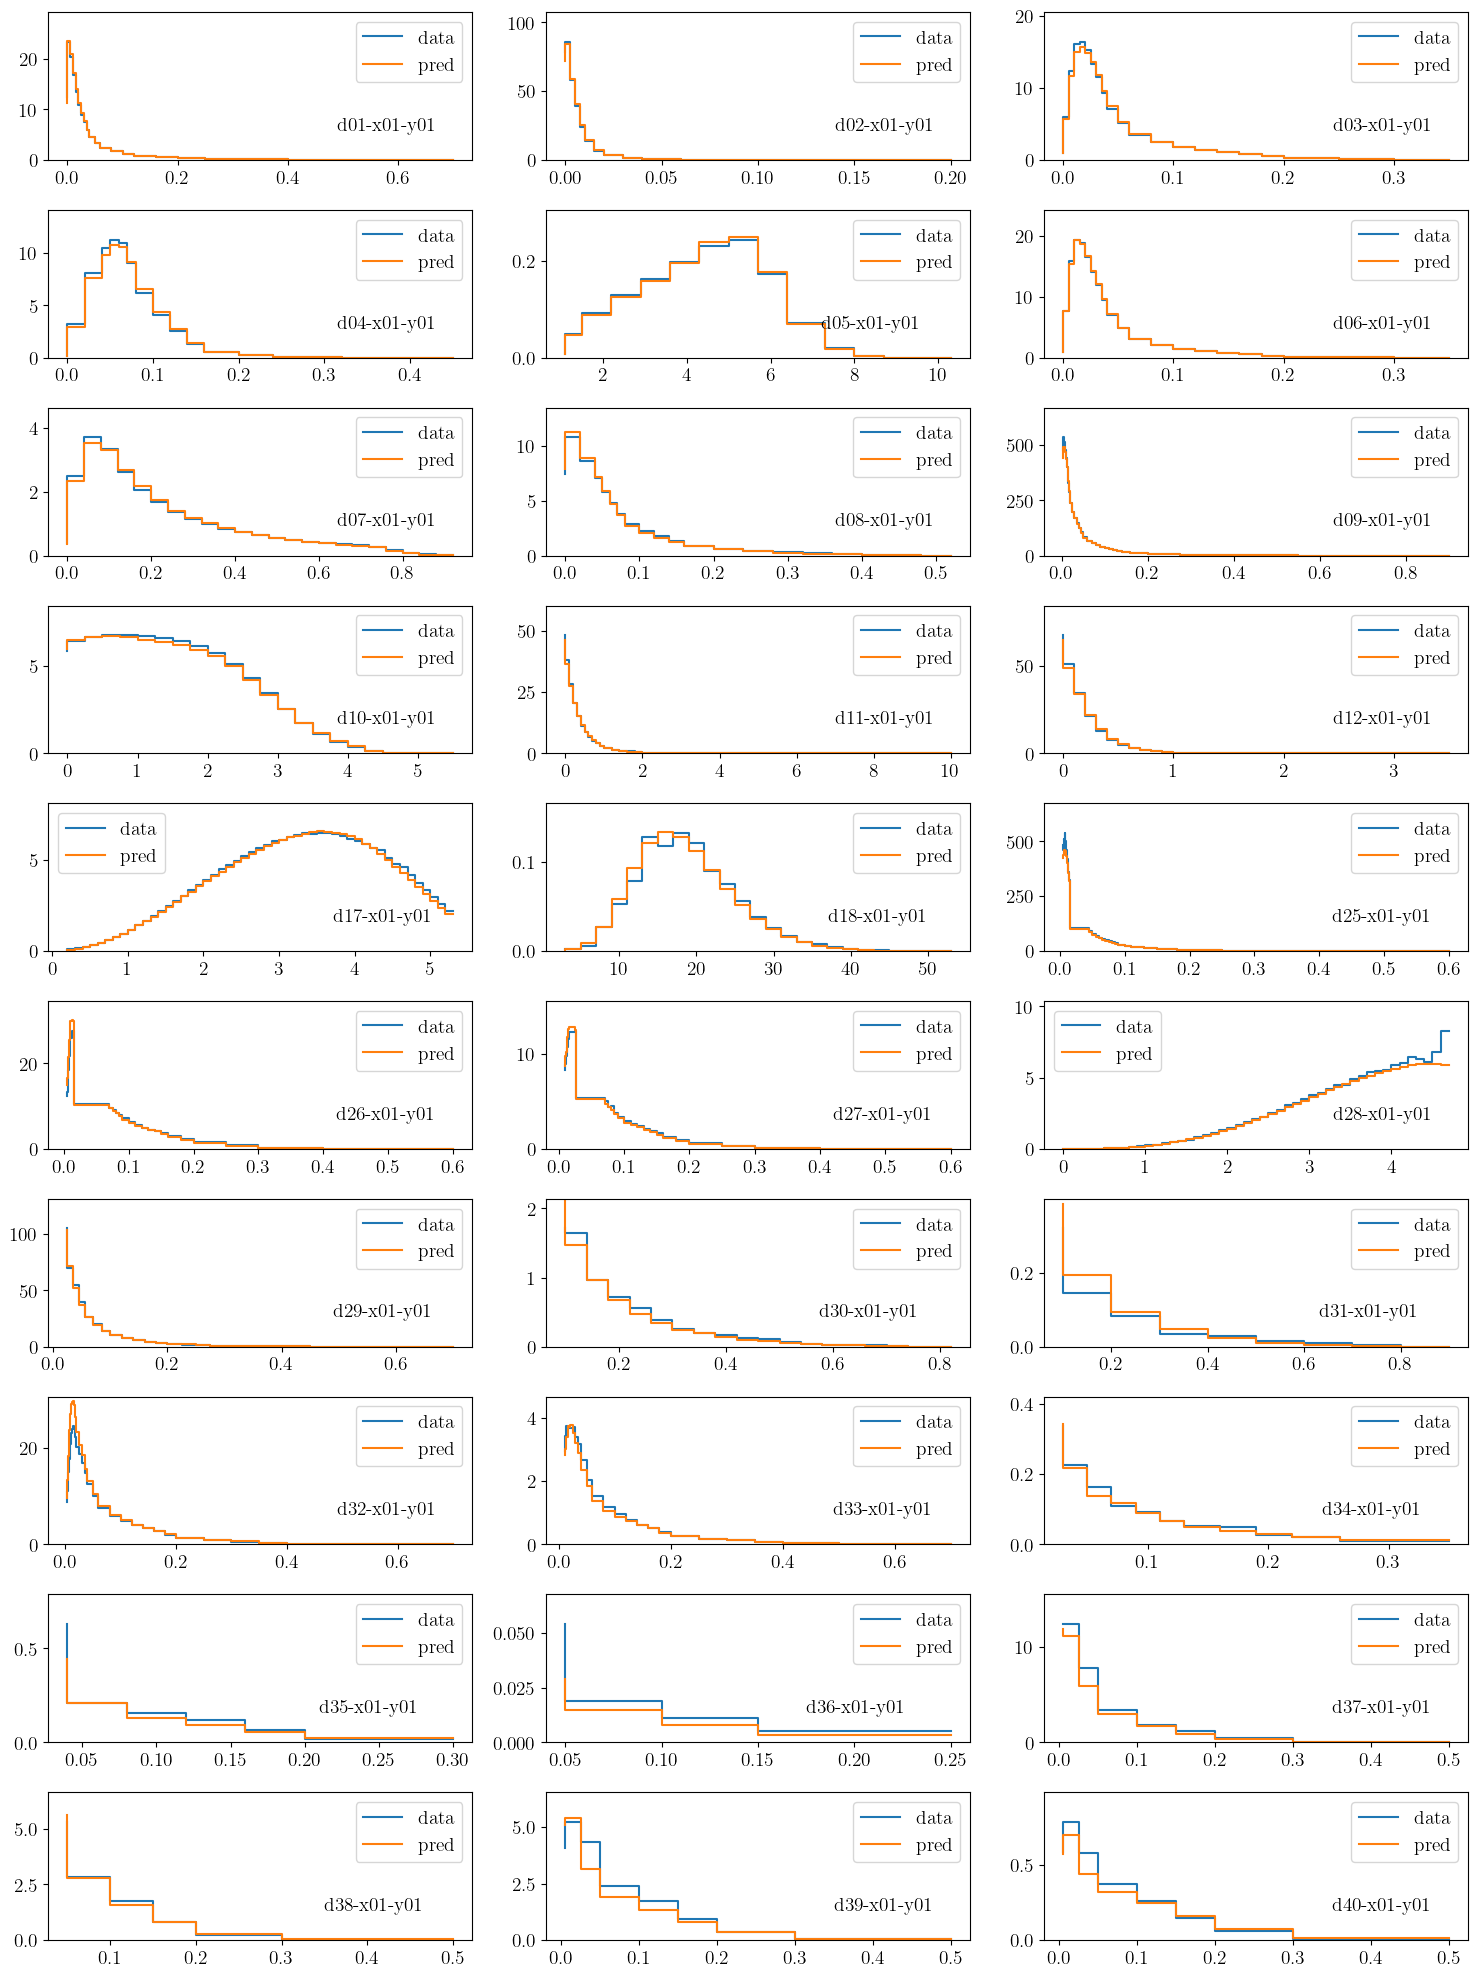

In [38]:
importlib.reload(pythia_SBI_utils)
from pythia_SBI_utils import * 

hists = make_hists(dfdata, dfsims_valid[0], filtered_data_keys, filtered_mc_keys)

plot_dist(filtered_data_keys, hists, filename='images/Ax_BayesianOpt_Valid_Best_fit_hists_ab_26_iter.pdf')